In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    # Define a function to determine if the pitch resulted in a fly ball
    def is_ground_ball(bb_type):
        return 1 if bb_type == "ground_ball" else 0

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['contact'] = df['description'].apply(is_contact)


    df['gb'] = df['bb_type'].apply(is_ground_ball)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('contact == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [7]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [8]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'BIP',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'BIP',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [9]:
train_data = training_features.drop(['gb'], axis=1).copy()
train_label = training_features['gb'].copy()
testing_data = testing_features.drop(['gb'], axis=1).copy()
testing_label = testing_features['gb'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6311964346931779
Log Loss: 0.6523969113087597


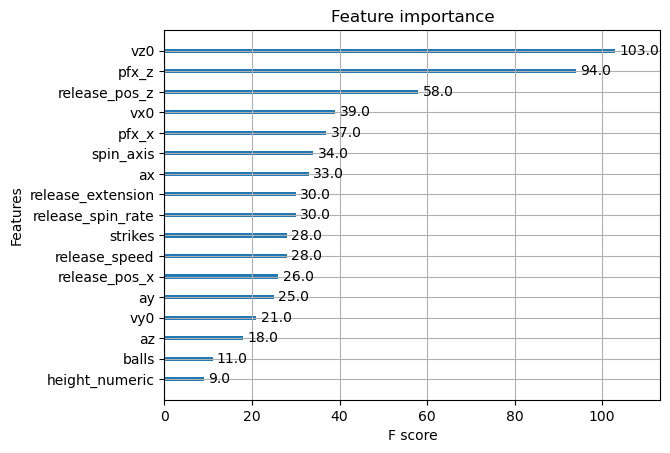

In [15]:
xgb.plot_importance(model)
plt.show()

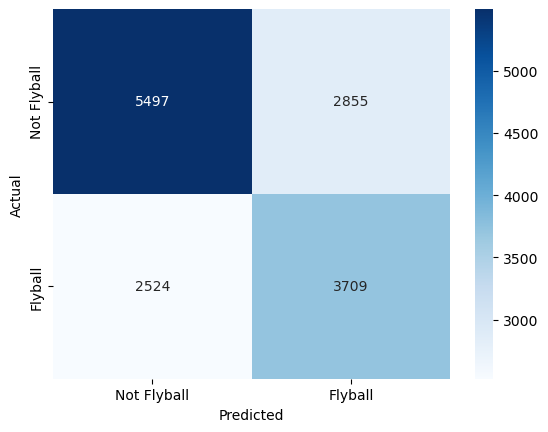

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=1000,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 11:42:48,064] A new study created in memory with name: no-name-dd60d00b-96d6-482e-a4c2-0d072d7e0d90


[0]	eval-logloss:0.67068
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.65799
[3]	eval-logloss:0.65347
[4]	eval-logloss:0.65022
[5]	eval-logloss:0.64812
[6]	eval-logloss:0.64607
[7]	eval-logloss:0.64481
[8]	eval-logloss:0.64335
[9]	eval-logloss:0.64242
[10]	eval-logloss:0.64157
[11]	eval-logloss:0.64074
[12]	eval-logloss:0.64007
[13]	eval-logloss:0.63954
[14]	eval-logloss:0.63902
[15]	eval-logloss:0.63850
[16]	eval-logloss:0.63789
[17]	eval-logloss:0.63757
[18]	eval-logloss:0.63698
[19]	eval-logloss:0.63649
[20]	eval-logloss:0.63614
[21]	eval-logloss:0.63573
[22]	eval-logloss:0.63529
[23]	eval-logloss:0.63511
[24]	eval-logloss:0.63484
[25]	eval-logloss:0.63458
[26]	eval-logloss:0.63422
[27]	eval-logloss:0.63384
[28]	eval-logloss:0.63353
[29]	eval-logloss:0.63342
[30]	eval-logloss:0.63320
[31]	eval-logloss:0.63303
[32]	eval-logloss:0.63286
[33]	eval-logloss:0.63275
[34]	eval-logloss:0.63261
[35]	eval-logloss:0.63240
[36]	eval-logloss:0.63228
[37]	eval-logloss:0.63216
[38]	eval-logloss:0.63

[I 2023-11-09 11:42:48,973] Trial 0 finished with value: 0.6294238094066156 and parameters: {'max_depth': 3, 'eta': 0.16811463574687657, 'subsample': 0.7254523983533269, 'colsample_bytree': 0.949406003776966}. Best is trial 0 with value: 0.6294238094066156.


[0]	eval-logloss:0.67685
[1]	eval-logloss:0.67319
[2]	eval-logloss:0.67001
[3]	eval-logloss:0.66699
[4]	eval-logloss:0.66409
[5]	eval-logloss:0.66147
[6]	eval-logloss:0.65914
[7]	eval-logloss:0.65691
[8]	eval-logloss:0.65477
[9]	eval-logloss:0.65292
[10]	eval-logloss:0.65124
[11]	eval-logloss:0.64966
[12]	eval-logloss:0.64825
[13]	eval-logloss:0.64699
[14]	eval-logloss:0.64593
[15]	eval-logloss:0.64512
[16]	eval-logloss:0.64399
[17]	eval-logloss:0.64316
[18]	eval-logloss:0.64232
[19]	eval-logloss:0.64156
[20]	eval-logloss:0.64075
[21]	eval-logloss:0.64007
[22]	eval-logloss:0.63937
[23]	eval-logloss:0.63887
[24]	eval-logloss:0.63833
[25]	eval-logloss:0.63786
[26]	eval-logloss:0.63739
[27]	eval-logloss:0.63691
[28]	eval-logloss:0.63664
[29]	eval-logloss:0.63624
[30]	eval-logloss:0.63601
[31]	eval-logloss:0.63569
[32]	eval-logloss:0.63541
[33]	eval-logloss:0.63507
[34]	eval-logloss:0.63478
[35]	eval-logloss:0.63461
[36]	eval-logloss:0.63441
[37]	eval-logloss:0.63406
[38]	eval-logloss:0.63

[I 2023-11-09 11:42:50,404] Trial 1 finished with value: 0.632061285412775 and parameters: {'max_depth': 8, 'eta': 0.04793306769390095, 'subsample': 0.8036531715162029, 'colsample_bytree': 0.812210808835504}. Best is trial 1 with value: 0.632061285412775.


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.65665
[3]	eval-logloss:0.64942
[4]	eval-logloss:0.64619
[5]	eval-logloss:0.64264
[6]	eval-logloss:0.64002
[7]	eval-logloss:0.63919
[8]	eval-logloss:0.63769
[9]	eval-logloss:0.63692
[10]	eval-logloss:0.63588
[11]	eval-logloss:0.63486
[12]	eval-logloss:0.63421
[13]	eval-logloss:0.63379
[14]	eval-logloss:0.63334
[15]	eval-logloss:0.63311
[16]	eval-logloss:0.63272
[17]	eval-logloss:0.63280
[18]	eval-logloss:0.63220
[19]	eval-logloss:0.63192
[20]	eval-logloss:0.63191
[21]	eval-logloss:0.63191
[22]	eval-logloss:0.63149
[23]	eval-logloss:0.63128
[24]	eval-logloss:0.63113
[25]	eval-logloss:0.63100
[26]	eval-logloss:0.63099
[27]	eval-logloss:0.63108
[28]	eval-logloss:0.63104
[29]	eval-logloss:0.63102
[30]	eval-logloss:0.63126
[31]	eval-logloss:0.63119
[32]	eval-logloss:0.63117
[33]	eval-logloss:0.63141
[34]	eval-logloss:0.63142
[35]	eval-logloss:0.63167
[36]	eval-logloss:0.63164
[37]	eval-logloss:0.63147
[38]	eval-logloss:0.63

[I 2023-11-09 11:42:50,981] Trial 2 finished with value: 0.6328993315939204 and parameters: {'max_depth': 5, 'eta': 0.2134575412136547, 'subsample': 0.7549881013816766, 'colsample_bytree': 0.626750819576287}. Best is trial 2 with value: 0.6328993315939204.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.66073
[2]	eval-logloss:0.65420
[3]	eval-logloss:0.64937
[4]	eval-logloss:0.64558
[5]	eval-logloss:0.64275
[6]	eval-logloss:0.64101
[7]	eval-logloss:0.64003
[8]	eval-logloss:0.63964
[9]	eval-logloss:0.63870
[10]	eval-logloss:0.63841
[11]	eval-logloss:0.63809
[12]	eval-logloss:0.63804
[13]	eval-logloss:0.63792
[14]	eval-logloss:0.63795
[15]	eval-logloss:0.63806
[16]	eval-logloss:0.63826
[17]	eval-logloss:0.63858
[18]	eval-logloss:0.63856
[19]	eval-logloss:0.63873
[20]	eval-logloss:0.63906
[21]	eval-logloss:0.63911
[22]	eval-logloss:0.63892
[23]	eval-logloss:0.63899
[24]	eval-logloss:0.63935
[25]	eval-logloss:0.63945
[26]	eval-logloss:0.63933
[27]	eval-logloss:0.63962
[28]	eval-logloss:0.63961
[29]	eval-logloss:0.63970
[30]	eval-logloss:0.63966
[31]	eval-logloss:0.63954
[32]	eval-logloss:0.63990
[33]	eval-logloss:0.63981
[34]	eval-logloss:0.64044
[35]	eval-logloss:0.64060
[36]	eval-logloss:0.64089
[37]	eval-logloss:0.64110
[38]	eval-logloss:0.64

[I 2023-11-09 11:42:51,730] Trial 3 finished with value: 0.6470177207870855 and parameters: {'max_depth': 9, 'eta': 0.14923311122719268, 'subsample': 0.6825855798933386, 'colsample_bytree': 0.9576394278251235}. Best is trial 3 with value: 0.6470177207870855.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.66306
[2]	eval-logloss:0.65981
[3]	eval-logloss:0.65288
[4]	eval-logloss:0.64973
[5]	eval-logloss:0.64534
[6]	eval-logloss:0.64254
[7]	eval-logloss:0.64129
[8]	eval-logloss:0.64019
[9]	eval-logloss:0.63944
[10]	eval-logloss:0.63812
[11]	eval-logloss:0.63739
[12]	eval-logloss:0.63728
[13]	eval-logloss:0.63703
[14]	eval-logloss:0.63703
[15]	eval-logloss:0.63679
[16]	eval-logloss:0.63647
[17]	eval-logloss:0.63633
[18]	eval-logloss:0.63616
[19]	eval-logloss:0.63578
[20]	eval-logloss:0.63572
[21]	eval-logloss:0.63643
[22]	eval-logloss:0.63636
[23]	eval-logloss:0.63661
[24]	eval-logloss:0.63660
[25]	eval-logloss:0.63722
[26]	eval-logloss:0.63719
[27]	eval-logloss:0.63732
[28]	eval-logloss:0.63742
[29]	eval-logloss:0.63761
[30]	eval-logloss:0.63755
[31]	eval-logloss:0.63736
[32]	eval-logloss:0.63753
[33]	eval-logloss:0.63786
[34]	eval-logloss:0.63832
[35]	eval-logloss:0.63821
[36]	eval-logloss:0.63865
[37]	eval-logloss:0.63886
[38]	eval-logloss:0.63

[I 2023-11-09 11:42:52,536] Trial 4 finished with value: 0.6453552264087092 and parameters: {'max_depth': 9, 'eta': 0.15881162310062408, 'subsample': 0.7697486278609925, 'colsample_bytree': 0.5766435033678206}. Best is trial 3 with value: 0.6470177207870855.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66964
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65751
[5]	eval-logloss:0.65454
[6]	eval-logloss:0.65188
[7]	eval-logloss:0.64970
[8]	eval-logloss:0.64776
[9]	eval-logloss:0.64600
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64287
[12]	eval-logloss:0.64154
[13]	eval-logloss:0.64052
[14]	eval-logloss:0.63954
[15]	eval-logloss:0.63883
[16]	eval-logloss:0.63824
[17]	eval-logloss:0.63756
[18]	eval-logloss:0.63697
[19]	eval-logloss:0.63649
[20]	eval-logloss:0.63609
[21]	eval-logloss:0.63570
[22]	eval-logloss:0.63512
[23]	eval-logloss:0.63472
[24]	eval-logloss:0.63429
[25]	eval-logloss:0.63387
[26]	eval-logloss:0.63350
[27]	eval-logloss:0.63321
[28]	eval-logloss:0.63292
[29]	eval-logloss:0.63265
[30]	eval-logloss:0.63250
[31]	eval-logloss:0.63234
[32]	eval-logloss:0.63226
[33]	eval-logloss:0.63205
[34]	eval-logloss:0.63197
[35]	eval-logloss:0.63187
[36]	eval-logloss:0.63179
[37]	eval-logloss:0.63149
[38]	eval-logloss:0.63

[I 2023-11-09 11:42:53,482] Trial 5 finished with value: 0.6286614842232002 and parameters: {'max_depth': 6, 'eta': 0.0769713245493388, 'subsample': 0.6709195602505893, 'colsample_bytree': 0.7287419061659801}. Best is trial 3 with value: 0.6470177207870855.


[0]	eval-logloss:0.66763
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.65273
[3]	eval-logloss:0.64764
[4]	eval-logloss:0.64413
[5]	eval-logloss:0.64158
[6]	eval-logloss:0.63973
[7]	eval-logloss:0.63824
[8]	eval-logloss:0.63704
[9]	eval-logloss:0.63598
[10]	eval-logloss:0.63516
[11]	eval-logloss:0.63465
[12]	eval-logloss:0.63410
[13]	eval-logloss:0.63367
[14]	eval-logloss:0.63330
[15]	eval-logloss:0.63322
[16]	eval-logloss:0.63287
[17]	eval-logloss:0.63248
[18]	eval-logloss:0.63231
[19]	eval-logloss:0.63215
[20]	eval-logloss:0.63185
[21]	eval-logloss:0.63177
[22]	eval-logloss:0.63177
[23]	eval-logloss:0.63172
[24]	eval-logloss:0.63169
[25]	eval-logloss:0.63157
[26]	eval-logloss:0.63164
[27]	eval-logloss:0.63154
[28]	eval-logloss:0.63149
[29]	eval-logloss:0.63145
[30]	eval-logloss:0.63156
[31]	eval-logloss:0.63159
[32]	eval-logloss:0.63135
[33]	eval-logloss:0.63135
[34]	eval-logloss:0.63135
[35]	eval-logloss:0.63147
[36]	eval-logloss:0.63146
[37]	eval-logloss:0.63124
[38]	eval-logloss:0.63

[I 2023-11-09 11:42:54,124] Trial 6 finished with value: 0.6351695730898093 and parameters: {'max_depth': 6, 'eta': 0.1755559521104651, 'subsample': 0.8955896227977499, 'colsample_bytree': 0.8587341984324046}. Best is trial 3 with value: 0.6470177207870855.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.67716
[2]	eval-logloss:0.67547
[3]	eval-logloss:0.67377
[4]	eval-logloss:0.67214
[5]	eval-logloss:0.67059
[6]	eval-logloss:0.66907
[7]	eval-logloss:0.66767
[8]	eval-logloss:0.66629
[9]	eval-logloss:0.66494
[10]	eval-logloss:0.66364
[11]	eval-logloss:0.66246
[12]	eval-logloss:0.66123
[13]	eval-logloss:0.66013
[14]	eval-logloss:0.65907
[15]	eval-logloss:0.65828
[16]	eval-logloss:0.65770
[17]	eval-logloss:0.65674
[18]	eval-logloss:0.65584
[19]	eval-logloss:0.65492
[20]	eval-logloss:0.65420
[21]	eval-logloss:0.65347
[22]	eval-logloss:0.65264
[23]	eval-logloss:0.65188
[24]	eval-logloss:0.65107
[25]	eval-logloss:0.65049
[26]	eval-logloss:0.64980
[27]	eval-logloss:0.64906
[28]	eval-logloss:0.64847
[29]	eval-logloss:0.64795
[30]	eval-logloss:0.64748
[31]	eval-logloss:0.64683
[32]	eval-logloss:0.64633
[33]	eval-logloss:0.64579
[34]	eval-logloss:0.64530
[35]	eval-logloss:0.64482
[36]	eval-logloss:0.64442
[37]	eval-logloss:0.64396
[38]	eval-logloss:0.64

[I 2023-11-09 11:42:56,840] Trial 7 finished with value: 0.630555083469911 and parameters: {'max_depth': 9, 'eta': 0.02208265835293447, 'subsample': 0.6277954763886336, 'colsample_bytree': 0.7236311064501645}. Best is trial 3 with value: 0.6470177207870855.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66515
[3]	eval-logloss:0.66111
[4]	eval-logloss:0.65778
[5]	eval-logloss:0.65496
[6]	eval-logloss:0.65234
[7]	eval-logloss:0.65010
[8]	eval-logloss:0.64820
[9]	eval-logloss:0.64637
[10]	eval-logloss:0.64467
[11]	eval-logloss:0.64313
[12]	eval-logloss:0.64167
[13]	eval-logloss:0.64060
[14]	eval-logloss:0.63949
[15]	eval-logloss:0.63859
[16]	eval-logloss:0.63771
[17]	eval-logloss:0.63716
[18]	eval-logloss:0.63653
[19]	eval-logloss:0.63596
[20]	eval-logloss:0.63568
[21]	eval-logloss:0.63526
[22]	eval-logloss:0.63478
[23]	eval-logloss:0.63459
[24]	eval-logloss:0.63409
[25]	eval-logloss:0.63384
[26]	eval-logloss:0.63363
[27]	eval-logloss:0.63333
[28]	eval-logloss:0.63307
[29]	eval-logloss:0.63286
[30]	eval-logloss:0.63260
[31]	eval-logloss:0.63255
[32]	eval-logloss:0.63254
[33]	eval-logloss:0.63234
[34]	eval-logloss:0.63230
[35]	eval-logloss:0.63225
[36]	eval-logloss:0.63228
[37]	eval-logloss:0.63221
[38]	eval-logloss:0.63

[I 2023-11-09 11:42:57,737] Trial 8 finished with value: 0.6333369716637106 and parameters: {'max_depth': 8, 'eta': 0.0716318368673723, 'subsample': 0.6060666200004055, 'colsample_bytree': 0.9820214703260037}. Best is trial 3 with value: 0.6470177207870855.


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.65445
[3]	eval-logloss:0.64924
[4]	eval-logloss:0.64558
[5]	eval-logloss:0.64290
[6]	eval-logloss:0.64096
[7]	eval-logloss:0.63908
[8]	eval-logloss:0.63790
[9]	eval-logloss:0.63683
[10]	eval-logloss:0.63607
[11]	eval-logloss:0.63556
[12]	eval-logloss:0.63500
[13]	eval-logloss:0.63492
[14]	eval-logloss:0.63453
[15]	eval-logloss:0.63460
[16]	eval-logloss:0.63411
[17]	eval-logloss:0.63403
[18]	eval-logloss:0.63389
[19]	eval-logloss:0.63403
[20]	eval-logloss:0.63357
[21]	eval-logloss:0.63355
[22]	eval-logloss:0.63344
[23]	eval-logloss:0.63323
[24]	eval-logloss:0.63316
[25]	eval-logloss:0.63308
[26]	eval-logloss:0.63306
[27]	eval-logloss:0.63310
[28]	eval-logloss:0.63312
[29]	eval-logloss:0.63342
[30]	eval-logloss:0.63364
[31]	eval-logloss:0.63361
[32]	eval-logloss:0.63384
[33]	eval-logloss:0.63388
[34]	eval-logloss:0.63413
[35]	eval-logloss:0.63414
[36]	eval-logloss:0.63419
[37]	eval-logloss:0.63436
[38]	eval-logloss:0.63

[I 2023-11-09 11:42:58,564] Trial 9 finished with value: 0.6403024335271396 and parameters: {'max_depth': 8, 'eta': 0.1491774880877167, 'subsample': 0.7423203067454729, 'colsample_bytree': 0.8461227068734223}. Best is trial 3 with value: 0.6470177207870855.


[0]	eval-logloss:0.66204
[1]	eval-logloss:0.65186
[2]	eval-logloss:0.64574
[3]	eval-logloss:0.64190
[4]	eval-logloss:0.63965
[5]	eval-logloss:0.63835
[6]	eval-logloss:0.63736
[7]	eval-logloss:0.63632
[8]	eval-logloss:0.63540
[9]	eval-logloss:0.63496
[10]	eval-logloss:0.63446
[11]	eval-logloss:0.63404
[12]	eval-logloss:0.63366
[13]	eval-logloss:0.63320
[14]	eval-logloss:0.63283
[15]	eval-logloss:0.63232
[16]	eval-logloss:0.63209
[17]	eval-logloss:0.63208
[18]	eval-logloss:0.63195
[19]	eval-logloss:0.63174
[20]	eval-logloss:0.63183
[21]	eval-logloss:0.63184
[22]	eval-logloss:0.63174
[23]	eval-logloss:0.63168
[24]	eval-logloss:0.63165
[25]	eval-logloss:0.63168
[26]	eval-logloss:0.63163
[27]	eval-logloss:0.63165
[28]	eval-logloss:0.63169
[29]	eval-logloss:0.63168
[30]	eval-logloss:0.63180
[31]	eval-logloss:0.63184
[32]	eval-logloss:0.63177
[33]	eval-logloss:0.63165
[34]	eval-logloss:0.63180
[35]	eval-logloss:0.63192
[36]	eval-logloss:0.63186
[37]	eval-logloss:0.63195
[38]	eval-logloss:0.63

[I 2023-11-09 11:42:59,229] Trial 10 finished with value: 0.6362397524211957 and parameters: {'max_depth': 4, 'eta': 0.29917966693854764, 'subsample': 0.6810902891809348, 'colsample_bytree': 0.989550085307366}. Best is trial 3 with value: 0.6470177207870855.


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.66836
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.65857
[4]	eval-logloss:0.65528
[5]	eval-logloss:0.65109
[6]	eval-logloss:0.64768
[7]	eval-logloss:0.64552
[8]	eval-logloss:0.64466
[9]	eval-logloss:0.64406
[10]	eval-logloss:0.64158
[11]	eval-logloss:0.64033
[12]	eval-logloss:0.63910
[13]	eval-logloss:0.63858
[14]	eval-logloss:0.63829
[15]	eval-logloss:0.63781
[16]	eval-logloss:0.63768
[17]	eval-logloss:0.63708
[18]	eval-logloss:0.63668
[19]	eval-logloss:0.63633
[20]	eval-logloss:0.63633
[21]	eval-logloss:0.63643
[22]	eval-logloss:0.63630
[23]	eval-logloss:0.63636
[24]	eval-logloss:0.63611
[25]	eval-logloss:0.63600
[26]	eval-logloss:0.63588
[27]	eval-logloss:0.63574
[28]	eval-logloss:0.63565
[29]	eval-logloss:0.63579
[30]	eval-logloss:0.63581
[31]	eval-logloss:0.63588
[32]	eval-logloss:0.63598
[33]	eval-logloss:0.63610
[34]	eval-logloss:0.63632
[35]	eval-logloss:0.63643
[36]	eval-logloss:0.63644
[37]	eval-logloss:0.63648
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:00,323] Trial 11 finished with value: 0.641353178832049 and parameters: {'max_depth': 9, 'eta': 0.11841096071770565, 'subsample': 0.807281107781789, 'colsample_bytree': 0.5428381877108838}. Best is trial 3 with value: 0.6470177207870855.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.66632
[3]	eval-logloss:0.65978
[4]	eval-logloss:0.65630
[5]	eval-logloss:0.65221
[6]	eval-logloss:0.64904
[7]	eval-logloss:0.64718
[8]	eval-logloss:0.64642
[9]	eval-logloss:0.64565
[10]	eval-logloss:0.64325
[11]	eval-logloss:0.64131
[12]	eval-logloss:0.63978
[13]	eval-logloss:0.63913
[14]	eval-logloss:0.63854
[15]	eval-logloss:0.63794
[16]	eval-logloss:0.63744
[17]	eval-logloss:0.63659
[18]	eval-logloss:0.63598
[19]	eval-logloss:0.63539
[20]	eval-logloss:0.63521
[21]	eval-logloss:0.63493
[22]	eval-logloss:0.63447
[23]	eval-logloss:0.63432
[24]	eval-logloss:0.63388
[25]	eval-logloss:0.63343
[26]	eval-logloss:0.63311
[27]	eval-logloss:0.63280
[28]	eval-logloss:0.63284
[29]	eval-logloss:0.63275
[30]	eval-logloss:0.63275
[31]	eval-logloss:0.63256
[32]	eval-logloss:0.63251
[33]	eval-logloss:0.63261
[34]	eval-logloss:0.63262
[35]	eval-logloss:0.63278
[36]	eval-logloss:0.63258
[37]	eval-logloss:0.63240
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:01,164] Trial 12 finished with value: 0.6341343346015087 and parameters: {'max_depth': 7, 'eta': 0.11362298248407901, 'subsample': 0.67568028551165, 'colsample_bytree': 0.5111509601924558}. Best is trial 3 with value: 0.6470177207870855.


[0]	eval-logloss:0.67105
[1]	eval-logloss:0.65921
[2]	eval-logloss:0.65584
[3]	eval-logloss:0.64946
[4]	eval-logloss:0.64758
[5]	eval-logloss:0.64489
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.64329
[8]	eval-logloss:0.64287
[9]	eval-logloss:0.64328
[10]	eval-logloss:0.64256
[11]	eval-logloss:0.64233
[12]	eval-logloss:0.64212
[13]	eval-logloss:0.64223
[14]	eval-logloss:0.64191
[15]	eval-logloss:0.64185
[16]	eval-logloss:0.64193
[17]	eval-logloss:0.64222
[18]	eval-logloss:0.64259
[19]	eval-logloss:0.64279
[20]	eval-logloss:0.64319
[21]	eval-logloss:0.64356
[22]	eval-logloss:0.64403
[23]	eval-logloss:0.64492
[24]	eval-logloss:0.64521
[25]	eval-logloss:0.64621
[26]	eval-logloss:0.64707
[27]	eval-logloss:0.64749
[28]	eval-logloss:0.64799
[29]	eval-logloss:0.64812
[30]	eval-logloss:0.64914
[31]	eval-logloss:0.64993
[32]	eval-logloss:0.65037
[33]	eval-logloss:0.65075
[34]	eval-logloss:0.65143
[35]	eval-logloss:0.65187
[36]	eval-logloss:0.65229
[37]	eval-logloss:0.65303
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:01,864] Trial 13 finished with value: 0.6626534582856983 and parameters: {'max_depth': 9, 'eta': 0.2213725785493288, 'subsample': 0.712033188570081, 'colsample_bytree': 0.5916392615519501}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.67021
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.65436
[3]	eval-logloss:0.64728
[4]	eval-logloss:0.64438
[5]	eval-logloss:0.64085
[6]	eval-logloss:0.63858
[7]	eval-logloss:0.63794
[8]	eval-logloss:0.63702
[9]	eval-logloss:0.63676
[10]	eval-logloss:0.63551
[11]	eval-logloss:0.63496
[12]	eval-logloss:0.63459
[13]	eval-logloss:0.63422
[14]	eval-logloss:0.63393
[15]	eval-logloss:0.63340
[16]	eval-logloss:0.63346
[17]	eval-logloss:0.63327
[18]	eval-logloss:0.63291
[19]	eval-logloss:0.63267
[20]	eval-logloss:0.63258
[21]	eval-logloss:0.63269
[22]	eval-logloss:0.63256
[23]	eval-logloss:0.63257
[24]	eval-logloss:0.63272
[25]	eval-logloss:0.63342
[26]	eval-logloss:0.63347
[27]	eval-logloss:0.63383
[28]	eval-logloss:0.63416
[29]	eval-logloss:0.63433
[30]	eval-logloss:0.63450
[31]	eval-logloss:0.63473
[32]	eval-logloss:0.63488
[33]	eval-logloss:0.63510
[34]	eval-logloss:0.63520
[35]	eval-logloss:0.63526
[36]	eval-logloss:0.63554
[37]	eval-logloss:0.63592
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:02,681] Trial 14 finished with value: 0.6415011754325681 and parameters: {'max_depth': 7, 'eta': 0.21977242570404756, 'subsample': 0.7046144931992838, 'colsample_bytree': 0.6359360020200638}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.64832
[3]	eval-logloss:0.64317
[4]	eval-logloss:0.64151
[5]	eval-logloss:0.63917
[6]	eval-logloss:0.63766
[7]	eval-logloss:0.63719
[8]	eval-logloss:0.63663
[9]	eval-logloss:0.63576
[10]	eval-logloss:0.63530
[11]	eval-logloss:0.63508
[12]	eval-logloss:0.63509
[13]	eval-logloss:0.63493
[14]	eval-logloss:0.63481
[15]	eval-logloss:0.63521
[16]	eval-logloss:0.63528
[17]	eval-logloss:0.63511
[18]	eval-logloss:0.63520
[19]	eval-logloss:0.63508
[20]	eval-logloss:0.63526
[21]	eval-logloss:0.63577
[22]	eval-logloss:0.63637
[23]	eval-logloss:0.63636
[24]	eval-logloss:0.63640
[25]	eval-logloss:0.63685
[26]	eval-logloss:0.63710
[27]	eval-logloss:0.63714
[28]	eval-logloss:0.63690
[29]	eval-logloss:0.63738
[30]	eval-logloss:0.63752
[31]	eval-logloss:0.63764
[32]	eval-logloss:0.63774
[33]	eval-logloss:0.63842
[34]	eval-logloss:0.63880
[35]	eval-logloss:0.63915
[36]	eval-logloss:0.63918
[37]	eval-logloss:0.63948
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:03,418] Trial 15 finished with value: 0.6497170538652525 and parameters: {'max_depth': 7, 'eta': 0.24523638266985298, 'subsample': 0.6404866697643946, 'colsample_bytree': 0.6711431190158738}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.65499
[2]	eval-logloss:0.65184
[3]	eval-logloss:0.64465
[4]	eval-logloss:0.64227
[5]	eval-logloss:0.63932
[6]	eval-logloss:0.63762
[7]	eval-logloss:0.63716
[8]	eval-logloss:0.63649
[9]	eval-logloss:0.63591
[10]	eval-logloss:0.63550
[11]	eval-logloss:0.63516
[12]	eval-logloss:0.63522
[13]	eval-logloss:0.63537
[14]	eval-logloss:0.63511
[15]	eval-logloss:0.63500
[16]	eval-logloss:0.63520
[17]	eval-logloss:0.63551
[18]	eval-logloss:0.63532
[19]	eval-logloss:0.63561
[20]	eval-logloss:0.63578
[21]	eval-logloss:0.63635
[22]	eval-logloss:0.63644
[23]	eval-logloss:0.63658
[24]	eval-logloss:0.63698
[25]	eval-logloss:0.63729
[26]	eval-logloss:0.63797
[27]	eval-logloss:0.63836
[28]	eval-logloss:0.63873
[29]	eval-logloss:0.63936
[30]	eval-logloss:0.63989
[31]	eval-logloss:0.64063
[32]	eval-logloss:0.64093
[33]	eval-logloss:0.64117
[34]	eval-logloss:0.64165
[35]	eval-logloss:0.64245
[36]	eval-logloss:0.64280
[37]	eval-logloss:0.64302
[38]	eval-logloss:0.64

[I 2023-11-09 11:43:04,004] Trial 16 finished with value: 0.6502906879904452 and parameters: {'max_depth': 7, 'eta': 0.2647147034942911, 'subsample': 0.640701293421517, 'colsample_bytree': 0.6549908347466996}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.65208
[3]	eval-logloss:0.64548
[4]	eval-logloss:0.64275
[5]	eval-logloss:0.64001
[6]	eval-logloss:0.63809
[7]	eval-logloss:0.63739
[8]	eval-logloss:0.63652
[9]	eval-logloss:0.63560
[10]	eval-logloss:0.63453
[11]	eval-logloss:0.63374
[12]	eval-logloss:0.63333
[13]	eval-logloss:0.63316
[14]	eval-logloss:0.63320
[15]	eval-logloss:0.63299
[16]	eval-logloss:0.63306
[17]	eval-logloss:0.63274
[18]	eval-logloss:0.63231
[19]	eval-logloss:0.63221
[20]	eval-logloss:0.63217
[21]	eval-logloss:0.63221
[22]	eval-logloss:0.63198
[23]	eval-logloss:0.63218
[24]	eval-logloss:0.63199
[25]	eval-logloss:0.63232
[26]	eval-logloss:0.63247
[27]	eval-logloss:0.63271
[28]	eval-logloss:0.63309
[29]	eval-logloss:0.63363
[30]	eval-logloss:0.63367
[31]	eval-logloss:0.63366
[32]	eval-logloss:0.63383
[33]	eval-logloss:0.63398
[34]	eval-logloss:0.63394
[35]	eval-logloss:0.63425
[36]	eval-logloss:0.63439
[37]	eval-logloss:0.63475
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:04,543] Trial 17 finished with value: 0.6371927186808297 and parameters: {'max_depth': 5, 'eta': 0.28008301013204984, 'subsample': 0.602340113312751, 'colsample_bytree': 0.5976497420756659}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65504
[2]	eval-logloss:0.64749
[3]	eval-logloss:0.64204
[4]	eval-logloss:0.64005
[5]	eval-logloss:0.63777
[6]	eval-logloss:0.63639
[7]	eval-logloss:0.63584
[8]	eval-logloss:0.63516
[9]	eval-logloss:0.63459
[10]	eval-logloss:0.63435
[11]	eval-logloss:0.63398
[12]	eval-logloss:0.63403
[13]	eval-logloss:0.63375
[14]	eval-logloss:0.63354
[15]	eval-logloss:0.63346
[16]	eval-logloss:0.63377
[17]	eval-logloss:0.63389
[18]	eval-logloss:0.63375
[19]	eval-logloss:0.63387
[20]	eval-logloss:0.63360
[21]	eval-logloss:0.63373
[22]	eval-logloss:0.63392
[23]	eval-logloss:0.63405
[24]	eval-logloss:0.63414
[25]	eval-logloss:0.63434
[26]	eval-logloss:0.63443
[27]	eval-logloss:0.63462
[28]	eval-logloss:0.63451
[29]	eval-logloss:0.63459
[30]	eval-logloss:0.63461
[31]	eval-logloss:0.63466
[32]	eval-logloss:0.63494
[33]	eval-logloss:0.63508
[34]	eval-logloss:0.63565
[35]	eval-logloss:0.63606
[36]	eval-logloss:0.63611
[37]	eval-logloss:0.63602
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:05,204] Trial 18 finished with value: 0.6411192460739352 and parameters: {'max_depth': 6, 'eta': 0.25880219188062553, 'subsample': 0.643135460633931, 'colsample_bytree': 0.6828597515940867}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.66272
[2]	eval-logloss:0.65894
[3]	eval-logloss:0.65096
[4]	eval-logloss:0.64775
[5]	eval-logloss:0.64398
[6]	eval-logloss:0.64122
[7]	eval-logloss:0.64024
[8]	eval-logloss:0.63997
[9]	eval-logloss:0.64007
[10]	eval-logloss:0.63871
[11]	eval-logloss:0.63782
[12]	eval-logloss:0.63710
[13]	eval-logloss:0.63739
[14]	eval-logloss:0.63723
[15]	eval-logloss:0.63707
[16]	eval-logloss:0.63712
[17]	eval-logloss:0.63715
[18]	eval-logloss:0.63702
[19]	eval-logloss:0.63722
[20]	eval-logloss:0.63734
[21]	eval-logloss:0.63779
[22]	eval-logloss:0.63755
[23]	eval-logloss:0.63784
[24]	eval-logloss:0.63799
[25]	eval-logloss:0.63858
[26]	eval-logloss:0.63898
[27]	eval-logloss:0.63928
[28]	eval-logloss:0.63939
[29]	eval-logloss:0.63957
[30]	eval-logloss:0.64031
[31]	eval-logloss:0.64075
[32]	eval-logloss:0.64086
[33]	eval-logloss:0.64124
[34]	eval-logloss:0.64139
[35]	eval-logloss:0.64157
[36]	eval-logloss:0.64181
[37]	eval-logloss:0.64188
[38]	eval-logloss:0.64

[I 2023-11-09 11:43:06,089] Trial 19 finished with value: 0.6474325342951687 and parameters: {'max_depth': 8, 'eta': 0.2042750625304066, 'subsample': 0.7155729628124421, 'colsample_bytree': 0.5003068760767593}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.65585
[2]	eval-logloss:0.65242
[3]	eval-logloss:0.64508
[4]	eval-logloss:0.64281
[5]	eval-logloss:0.64016
[6]	eval-logloss:0.63851
[7]	eval-logloss:0.63816
[8]	eval-logloss:0.63789
[9]	eval-logloss:0.63783
[10]	eval-logloss:0.63665
[11]	eval-logloss:0.63625
[12]	eval-logloss:0.63621
[13]	eval-logloss:0.63625
[14]	eval-logloss:0.63682
[15]	eval-logloss:0.63697
[16]	eval-logloss:0.63713
[17]	eval-logloss:0.63719
[18]	eval-logloss:0.63693
[19]	eval-logloss:0.63678
[20]	eval-logloss:0.63689
[21]	eval-logloss:0.63687
[22]	eval-logloss:0.63693
[23]	eval-logloss:0.63674
[24]	eval-logloss:0.63700
[25]	eval-logloss:0.63781
[26]	eval-logloss:0.63798
[27]	eval-logloss:0.63840
[28]	eval-logloss:0.63881
[29]	eval-logloss:0.63929
[30]	eval-logloss:0.63974
[31]	eval-logloss:0.63978
[32]	eval-logloss:0.64029
[33]	eval-logloss:0.64050
[34]	eval-logloss:0.64083
[35]	eval-logloss:0.64121
[36]	eval-logloss:0.64150
[37]	eval-logloss:0.64170
[38]	eval-logloss:0.64

[I 2023-11-09 11:43:06,760] Trial 20 finished with value: 0.6471603250356193 and parameters: {'max_depth': 7, 'eta': 0.24652108813133403, 'subsample': 0.6579979838356563, 'colsample_bytree': 0.5763848431838081}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.65566
[2]	eval-logloss:0.64828
[3]	eval-logloss:0.64280
[4]	eval-logloss:0.64075
[5]	eval-logloss:0.63852
[6]	eval-logloss:0.63687
[7]	eval-logloss:0.63669
[8]	eval-logloss:0.63603
[9]	eval-logloss:0.63537
[10]	eval-logloss:0.63521
[11]	eval-logloss:0.63469
[12]	eval-logloss:0.63463
[13]	eval-logloss:0.63446
[14]	eval-logloss:0.63474
[15]	eval-logloss:0.63504
[16]	eval-logloss:0.63505
[17]	eval-logloss:0.63561
[18]	eval-logloss:0.63571
[19]	eval-logloss:0.63565
[20]	eval-logloss:0.63565
[21]	eval-logloss:0.63645
[22]	eval-logloss:0.63694
[23]	eval-logloss:0.63703
[24]	eval-logloss:0.63712
[25]	eval-logloss:0.63747
[26]	eval-logloss:0.63765
[27]	eval-logloss:0.63789
[28]	eval-logloss:0.63805
[29]	eval-logloss:0.63857
[30]	eval-logloss:0.63904
[31]	eval-logloss:0.63959
[32]	eval-logloss:0.63990
[33]	eval-logloss:0.64055
[34]	eval-logloss:0.64079
[35]	eval-logloss:0.64125
[36]	eval-logloss:0.64128
[37]	eval-logloss:0.64144
[38]	eval-logloss:0.64

[I 2023-11-09 11:43:07,430] Trial 21 finished with value: 0.6486372307240286 and parameters: {'max_depth': 7, 'eta': 0.24494544404518698, 'subsample': 0.6437123109923876, 'colsample_bytree': 0.6680629157417878}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.66776
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.64814
[3]	eval-logloss:0.64287
[4]	eval-logloss:0.64079
[5]	eval-logloss:0.63873
[6]	eval-logloss:0.63724
[7]	eval-logloss:0.63655
[8]	eval-logloss:0.63547
[9]	eval-logloss:0.63433
[10]	eval-logloss:0.63359
[11]	eval-logloss:0.63294
[12]	eval-logloss:0.63277
[13]	eval-logloss:0.63286
[14]	eval-logloss:0.63254
[15]	eval-logloss:0.63237
[16]	eval-logloss:0.63255
[17]	eval-logloss:0.63281
[18]	eval-logloss:0.63311
[19]	eval-logloss:0.63310
[20]	eval-logloss:0.63307
[21]	eval-logloss:0.63293
[22]	eval-logloss:0.63306
[23]	eval-logloss:0.63300
[24]	eval-logloss:0.63281
[25]	eval-logloss:0.63305
[26]	eval-logloss:0.63303
[27]	eval-logloss:0.63317
[28]	eval-logloss:0.63286
[29]	eval-logloss:0.63291
[30]	eval-logloss:0.63293
[31]	eval-logloss:0.63297
[32]	eval-logloss:0.63310
[33]	eval-logloss:0.63325
[34]	eval-logloss:0.63336
[35]	eval-logloss:0.63371
[36]	eval-logloss:0.63384
[37]	eval-logloss:0.63387
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:08,040] Trial 22 finished with value: 0.6369594739887495 and parameters: {'max_depth': 5, 'eta': 0.27120460065648205, 'subsample': 0.6214685349461125, 'colsample_bytree': 0.6692962437559311}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.66950
[1]	eval-logloss:0.65698
[2]	eval-logloss:0.65400
[3]	eval-logloss:0.64665
[4]	eval-logloss:0.64379
[5]	eval-logloss:0.64052
[6]	eval-logloss:0.63840
[7]	eval-logloss:0.63781
[8]	eval-logloss:0.63659
[9]	eval-logloss:0.63593
[10]	eval-logloss:0.63483
[11]	eval-logloss:0.63385
[12]	eval-logloss:0.63349
[13]	eval-logloss:0.63325
[14]	eval-logloss:0.63290
[15]	eval-logloss:0.63282
[16]	eval-logloss:0.63296
[17]	eval-logloss:0.63258
[18]	eval-logloss:0.63243
[19]	eval-logloss:0.63256
[20]	eval-logloss:0.63255
[21]	eval-logloss:0.63283
[22]	eval-logloss:0.63307
[23]	eval-logloss:0.63310
[24]	eval-logloss:0.63292
[25]	eval-logloss:0.63309
[26]	eval-logloss:0.63291
[27]	eval-logloss:0.63318
[28]	eval-logloss:0.63311
[29]	eval-logloss:0.63325
[30]	eval-logloss:0.63353
[31]	eval-logloss:0.63329
[32]	eval-logloss:0.63334
[33]	eval-logloss:0.63333
[34]	eval-logloss:0.63378
[35]	eval-logloss:0.63400
[36]	eval-logloss:0.63422
[37]	eval-logloss:0.63454
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:08,704] Trial 23 finished with value: 0.6383770827839707 and parameters: {'max_depth': 6, 'eta': 0.23536875024200973, 'subsample': 0.6435980943183334, 'colsample_bytree': 0.629325264437551}. Best is trial 13 with value: 0.6626534582856983.


[0]	eval-logloss:0.66718
[1]	eval-logloss:0.65390
[2]	eval-logloss:0.64691
[3]	eval-logloss:0.64263
[4]	eval-logloss:0.64159
[5]	eval-logloss:0.64030
[6]	eval-logloss:0.63992
[7]	eval-logloss:0.63965
[8]	eval-logloss:0.64034
[9]	eval-logloss:0.64046
[10]	eval-logloss:0.64051
[11]	eval-logloss:0.64046
[12]	eval-logloss:0.64051
[13]	eval-logloss:0.64075
[14]	eval-logloss:0.64090
[15]	eval-logloss:0.64142
[16]	eval-logloss:0.64203
[17]	eval-logloss:0.64264
[18]	eval-logloss:0.64283
[19]	eval-logloss:0.64293
[20]	eval-logloss:0.64350
[21]	eval-logloss:0.64351
[22]	eval-logloss:0.64451
[23]	eval-logloss:0.64477
[24]	eval-logloss:0.64520
[25]	eval-logloss:0.64597
[26]	eval-logloss:0.64631
[27]	eval-logloss:0.64647
[28]	eval-logloss:0.64727
[29]	eval-logloss:0.64872
[30]	eval-logloss:0.64964
[31]	eval-logloss:0.65034
[32]	eval-logloss:0.65143
[33]	eval-logloss:0.65173
[34]	eval-logloss:0.65232
[35]	eval-logloss:0.65301
[36]	eval-logloss:0.65436
[37]	eval-logloss:0.65493
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:09,406] Trial 24 finished with value: 0.6646855316060396 and parameters: {'max_depth': 8, 'eta': 0.2935741601509673, 'subsample': 0.6959789399466579, 'colsample_bytree': 0.7061525522731558}. Best is trial 24 with value: 0.6646855316060396.


[0]	eval-logloss:0.66072
[1]	eval-logloss:0.64987
[2]	eval-logloss:0.64400
[3]	eval-logloss:0.64030
[4]	eval-logloss:0.63895
[5]	eval-logloss:0.63848
[6]	eval-logloss:0.63769
[7]	eval-logloss:0.63774
[8]	eval-logloss:0.63772
[9]	eval-logloss:0.63807
[10]	eval-logloss:0.63955
[11]	eval-logloss:0.63979
[12]	eval-logloss:0.64046
[13]	eval-logloss:0.64178
[14]	eval-logloss:0.64234
[15]	eval-logloss:0.64270
[16]	eval-logloss:0.64302
[17]	eval-logloss:0.64338
[18]	eval-logloss:0.64450
[19]	eval-logloss:0.64465
[20]	eval-logloss:0.64498
[21]	eval-logloss:0.64556
[22]	eval-logloss:0.64577
[23]	eval-logloss:0.64588
[24]	eval-logloss:0.64637
[25]	eval-logloss:0.64716
[26]	eval-logloss:0.64789
[27]	eval-logloss:0.64900
[28]	eval-logloss:0.64937
[29]	eval-logloss:0.64986
[30]	eval-logloss:0.65058
[31]	eval-logloss:0.65135
[32]	eval-logloss:0.65180
[33]	eval-logloss:0.65224
[34]	eval-logloss:0.65305
[35]	eval-logloss:0.65449
[36]	eval-logloss:0.65465
[37]	eval-logloss:0.65575
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:10,146] Trial 25 finished with value: 0.6682641102391738 and parameters: {'max_depth': 8, 'eta': 0.29864253435183763, 'subsample': 0.6997002616353082, 'colsample_bytree': 0.7619212026609313}. Best is trial 25 with value: 0.6682641102391738.


[0]	eval-logloss:0.66711
[1]	eval-logloss:0.65307
[2]	eval-logloss:0.64649
[3]	eval-logloss:0.64226
[4]	eval-logloss:0.64072
[5]	eval-logloss:0.63932
[6]	eval-logloss:0.63860
[7]	eval-logloss:0.63845
[8]	eval-logloss:0.63842
[9]	eval-logloss:0.63833
[10]	eval-logloss:0.63879
[11]	eval-logloss:0.63904
[12]	eval-logloss:0.63912
[13]	eval-logloss:0.63992
[14]	eval-logloss:0.64056
[15]	eval-logloss:0.64121
[16]	eval-logloss:0.64155
[17]	eval-logloss:0.64202
[18]	eval-logloss:0.64219
[19]	eval-logloss:0.64303
[20]	eval-logloss:0.64333
[21]	eval-logloss:0.64391
[22]	eval-logloss:0.64497
[23]	eval-logloss:0.64597
[24]	eval-logloss:0.64567
[25]	eval-logloss:0.64652
[26]	eval-logloss:0.64721
[27]	eval-logloss:0.64698
[28]	eval-logloss:0.64807
[29]	eval-logloss:0.64855
[30]	eval-logloss:0.64892
[31]	eval-logloss:0.64991
[32]	eval-logloss:0.65028
[33]	eval-logloss:0.65149
[34]	eval-logloss:0.65187
[35]	eval-logloss:0.65229
[36]	eval-logloss:0.65289
[37]	eval-logloss:0.65317
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:10,749] Trial 26 finished with value: 0.6651491641636491 and parameters: {'max_depth': 8, 'eta': 0.29253497232774256, 'subsample': 0.7018920168976387, 'colsample_bytree': 0.7186832060401946}. Best is trial 25 with value: 0.6682641102391738.


[0]	eval-logloss:0.66093
[1]	eval-logloss:0.65000
[2]	eval-logloss:0.64408
[3]	eval-logloss:0.64066
[4]	eval-logloss:0.63917
[5]	eval-logloss:0.63873
[6]	eval-logloss:0.63775
[7]	eval-logloss:0.63811
[8]	eval-logloss:0.63863
[9]	eval-logloss:0.63919
[10]	eval-logloss:0.63902
[11]	eval-logloss:0.63935
[12]	eval-logloss:0.63964
[13]	eval-logloss:0.64066
[14]	eval-logloss:0.64095
[15]	eval-logloss:0.64174
[16]	eval-logloss:0.64289
[17]	eval-logloss:0.64318
[18]	eval-logloss:0.64364
[19]	eval-logloss:0.64361
[20]	eval-logloss:0.64366
[21]	eval-logloss:0.64425
[22]	eval-logloss:0.64501
[23]	eval-logloss:0.64565
[24]	eval-logloss:0.64613
[25]	eval-logloss:0.64708
[26]	eval-logloss:0.64759
[27]	eval-logloss:0.64824
[28]	eval-logloss:0.64890
[29]	eval-logloss:0.64891
[30]	eval-logloss:0.64918
[31]	eval-logloss:0.64951
[32]	eval-logloss:0.64996
[33]	eval-logloss:0.65042
[34]	eval-logloss:0.65068
[35]	eval-logloss:0.65116
[36]	eval-logloss:0.65142
[37]	eval-logloss:0.65166
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:11,418] Trial 27 finished with value: 0.6641363763332582 and parameters: {'max_depth': 8, 'eta': 0.29828240589514915, 'subsample': 0.698049019658055, 'colsample_bytree': 0.7703726312630292}. Best is trial 25 with value: 0.6682641102391738.


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.65408
[2]	eval-logloss:0.64726
[3]	eval-logloss:0.64292
[4]	eval-logloss:0.64188
[5]	eval-logloss:0.64087
[6]	eval-logloss:0.64064
[7]	eval-logloss:0.64071
[8]	eval-logloss:0.64034
[9]	eval-logloss:0.64012
[10]	eval-logloss:0.64012
[11]	eval-logloss:0.64062
[12]	eval-logloss:0.64117
[13]	eval-logloss:0.64144
[14]	eval-logloss:0.64184
[15]	eval-logloss:0.64251
[16]	eval-logloss:0.64277
[17]	eval-logloss:0.64355
[18]	eval-logloss:0.64353
[19]	eval-logloss:0.64382
[20]	eval-logloss:0.64406
[21]	eval-logloss:0.64410
[22]	eval-logloss:0.64414
[23]	eval-logloss:0.64442
[24]	eval-logloss:0.64483
[25]	eval-logloss:0.64582
[26]	eval-logloss:0.64673
[27]	eval-logloss:0.64731
[28]	eval-logloss:0.64786
[29]	eval-logloss:0.64835
[30]	eval-logloss:0.64852
[31]	eval-logloss:0.64939
[32]	eval-logloss:0.64923
[33]	eval-logloss:0.64985
[34]	eval-logloss:0.65074
[35]	eval-logloss:0.65140
[36]	eval-logloss:0.65254
[37]	eval-logloss:0.65342
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:12,057] Trial 28 finished with value: 0.6632176152823493 and parameters: {'max_depth': 8, 'eta': 0.2856802255564558, 'subsample': 0.6939229300113057, 'colsample_bytree': 0.7108103009328864}. Best is trial 25 with value: 0.6682641102391738.


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.65722
[2]	eval-logloss:0.65244
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.64531
[5]	eval-logloss:0.64336
[6]	eval-logloss:0.64211
[7]	eval-logloss:0.64104
[8]	eval-logloss:0.63983
[9]	eval-logloss:0.63880
[10]	eval-logloss:0.63788
[11]	eval-logloss:0.63695
[12]	eval-logloss:0.63616
[13]	eval-logloss:0.63575
[14]	eval-logloss:0.63552
[15]	eval-logloss:0.63499
[16]	eval-logloss:0.63454
[17]	eval-logloss:0.63446
[18]	eval-logloss:0.63384
[19]	eval-logloss:0.63374
[20]	eval-logloss:0.63342
[21]	eval-logloss:0.63308
[22]	eval-logloss:0.63287
[23]	eval-logloss:0.63233
[24]	eval-logloss:0.63229
[25]	eval-logloss:0.63215
[26]	eval-logloss:0.63208
[27]	eval-logloss:0.63191
[28]	eval-logloss:0.63187
[29]	eval-logloss:0.63181
[30]	eval-logloss:0.63190
[31]	eval-logloss:0.63188
[32]	eval-logloss:0.63165
[33]	eval-logloss:0.63149
[34]	eval-logloss:0.63146
[35]	eval-logloss:0.63140
[36]	eval-logloss:0.63122
[37]	eval-logloss:0.63108
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:12,725] Trial 29 finished with value: 0.6313043172806934 and parameters: {'max_depth': 3, 'eta': 0.27639122682425465, 'subsample': 0.7316175402166684, 'colsample_bytree': 0.7670901546168032}. Best is trial 25 with value: 0.6682641102391738.


[0]	eval-logloss:0.66102
[1]	eval-logloss:0.64970
[2]	eval-logloss:0.64384
[3]	eval-logloss:0.64024
[4]	eval-logloss:0.63869
[5]	eval-logloss:0.63811
[6]	eval-logloss:0.63721
[7]	eval-logloss:0.63725
[8]	eval-logloss:0.63668
[9]	eval-logloss:0.63705
[10]	eval-logloss:0.63729
[11]	eval-logloss:0.63753
[12]	eval-logloss:0.63854
[13]	eval-logloss:0.63907
[14]	eval-logloss:0.63965
[15]	eval-logloss:0.63974
[16]	eval-logloss:0.64016
[17]	eval-logloss:0.64092
[18]	eval-logloss:0.64071
[19]	eval-logloss:0.64097
[20]	eval-logloss:0.64146
[21]	eval-logloss:0.64149
[22]	eval-logloss:0.64201
[23]	eval-logloss:0.64214
[24]	eval-logloss:0.64259
[25]	eval-logloss:0.64371
[26]	eval-logloss:0.64413
[27]	eval-logloss:0.64450
[28]	eval-logloss:0.64490
[29]	eval-logloss:0.64546
[30]	eval-logloss:0.64588
[31]	eval-logloss:0.64628
[32]	eval-logloss:0.64683
[33]	eval-logloss:0.64771
[34]	eval-logloss:0.64799
[35]	eval-logloss:0.64868
[36]	eval-logloss:0.64926
[37]	eval-logloss:0.64967
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:13,436] Trial 30 finished with value: 0.6615586376864258 and parameters: {'max_depth': 8, 'eta': 0.28790265382401115, 'subsample': 0.720246697198168, 'colsample_bytree': 0.7545473790169507}. Best is trial 25 with value: 0.6682641102391738.


[0]	eval-logloss:0.66100
[1]	eval-logloss:0.65041
[2]	eval-logloss:0.64463
[3]	eval-logloss:0.64115
[4]	eval-logloss:0.64029
[5]	eval-logloss:0.63899
[6]	eval-logloss:0.63824
[7]	eval-logloss:0.63844
[8]	eval-logloss:0.63891
[9]	eval-logloss:0.63935
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.64038
[12]	eval-logloss:0.63987
[13]	eval-logloss:0.64001
[14]	eval-logloss:0.64039
[15]	eval-logloss:0.64072
[16]	eval-logloss:0.64095
[17]	eval-logloss:0.64148
[18]	eval-logloss:0.64242
[19]	eval-logloss:0.64304
[20]	eval-logloss:0.64402
[21]	eval-logloss:0.64576
[22]	eval-logloss:0.64625
[23]	eval-logloss:0.64653
[24]	eval-logloss:0.64647
[25]	eval-logloss:0.64728
[26]	eval-logloss:0.64805
[27]	eval-logloss:0.64833
[28]	eval-logloss:0.64858
[29]	eval-logloss:0.64906
[30]	eval-logloss:0.65017
[31]	eval-logloss:0.65043
[32]	eval-logloss:0.65105
[33]	eval-logloss:0.65117
[34]	eval-logloss:0.65187
[35]	eval-logloss:0.65269
[36]	eval-logloss:0.65253
[37]	eval-logloss:0.65305
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:14,050] Trial 31 finished with value: 0.6630996548251106 and parameters: {'max_depth': 8, 'eta': 0.2994079440002751, 'subsample': 0.6949351670906256, 'colsample_bytree': 0.7813446245510561}. Best is trial 25 with value: 0.6682641102391738.


[0]	eval-logloss:0.66290
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.64572
[3]	eval-logloss:0.64145
[4]	eval-logloss:0.63930
[5]	eval-logloss:0.63802
[6]	eval-logloss:0.63752
[7]	eval-logloss:0.63752
[8]	eval-logloss:0.63755
[9]	eval-logloss:0.63732
[10]	eval-logloss:0.63700
[11]	eval-logloss:0.63707
[12]	eval-logloss:0.63753
[13]	eval-logloss:0.63823
[14]	eval-logloss:0.63847
[15]	eval-logloss:0.63891
[16]	eval-logloss:0.63999
[17]	eval-logloss:0.64080
[18]	eval-logloss:0.64062
[19]	eval-logloss:0.64090
[20]	eval-logloss:0.64094
[21]	eval-logloss:0.64168
[22]	eval-logloss:0.64198
[23]	eval-logloss:0.64211
[24]	eval-logloss:0.64254
[25]	eval-logloss:0.64349
[26]	eval-logloss:0.64360
[27]	eval-logloss:0.64374
[28]	eval-logloss:0.64379
[29]	eval-logloss:0.64409
[30]	eval-logloss:0.64457
[31]	eval-logloss:0.64485
[32]	eval-logloss:0.64537
[33]	eval-logloss:0.64609
[34]	eval-logloss:0.64642
[35]	eval-logloss:0.64692
[36]	eval-logloss:0.64779
[37]	eval-logloss:0.64819
[38]	eval-logloss:0.64

[I 2023-11-09 11:43:14,772] Trial 32 finished with value: 0.6578013312513964 and parameters: {'max_depth': 8, 'eta': 0.26018262037317325, 'subsample': 0.6953642936292276, 'colsample_bytree': 0.7930840095388635}. Best is trial 25 with value: 0.6682641102391738.


[0]	eval-logloss:0.66735
[1]	eval-logloss:0.65471
[2]	eval-logloss:0.64852
[3]	eval-logloss:0.64494
[4]	eval-logloss:0.64492
[5]	eval-logloss:0.64471
[6]	eval-logloss:0.64472
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.64539
[9]	eval-logloss:0.64502
[10]	eval-logloss:0.64508
[11]	eval-logloss:0.64616
[12]	eval-logloss:0.64685
[13]	eval-logloss:0.64736
[14]	eval-logloss:0.64766
[15]	eval-logloss:0.64821
[16]	eval-logloss:0.64861
[17]	eval-logloss:0.64947
[18]	eval-logloss:0.65006
[19]	eval-logloss:0.65006
[20]	eval-logloss:0.65050
[21]	eval-logloss:0.65093
[22]	eval-logloss:0.65189
[23]	eval-logloss:0.65270
[24]	eval-logloss:0.65355
[25]	eval-logloss:0.65557
[26]	eval-logloss:0.65673
[27]	eval-logloss:0.65727
[28]	eval-logloss:0.65761
[29]	eval-logloss:0.65778
[30]	eval-logloss:0.65925
[31]	eval-logloss:0.66052
[32]	eval-logloss:0.66134
[33]	eval-logloss:0.66239
[34]	eval-logloss:0.66303
[35]	eval-logloss:0.66401
[36]	eval-logloss:0.66446
[37]	eval-logloss:0.66514
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:15,499] Trial 33 finished with value: 0.6786996063948039 and parameters: {'max_depth': 9, 'eta': 0.2967979761186077, 'subsample': 0.6649421380498329, 'colsample_bytree': 0.702609428941574}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65555
[2]	eval-logloss:0.64819
[3]	eval-logloss:0.64343
[4]	eval-logloss:0.64336
[5]	eval-logloss:0.64301
[6]	eval-logloss:0.64269
[7]	eval-logloss:0.64337
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.64313
[10]	eval-logloss:0.64339
[11]	eval-logloss:0.64441
[12]	eval-logloss:0.64553
[13]	eval-logloss:0.64611
[14]	eval-logloss:0.64606
[15]	eval-logloss:0.64713
[16]	eval-logloss:0.64776
[17]	eval-logloss:0.64843
[18]	eval-logloss:0.64842
[19]	eval-logloss:0.64892
[20]	eval-logloss:0.64978
[21]	eval-logloss:0.65093
[22]	eval-logloss:0.65190
[23]	eval-logloss:0.65210
[24]	eval-logloss:0.65332
[25]	eval-logloss:0.65472
[26]	eval-logloss:0.65665
[27]	eval-logloss:0.65727
[28]	eval-logloss:0.65737
[29]	eval-logloss:0.65769
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65998
[32]	eval-logloss:0.66032
[33]	eval-logloss:0.66073
[34]	eval-logloss:0.66163
[35]	eval-logloss:0.66208
[36]	eval-logloss:0.66286
[37]	eval-logloss:0.66310
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:16,496] Trial 34 finished with value: 0.6743643394428784 and parameters: {'max_depth': 9, 'eta': 0.2722637312107716, 'subsample': 0.6697008025140506, 'colsample_bytree': 0.6996340441146661}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66155
[1]	eval-logloss:0.65147
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.64233
[4]	eval-logloss:0.64148
[5]	eval-logloss:0.64091
[6]	eval-logloss:0.64033
[7]	eval-logloss:0.64069
[8]	eval-logloss:0.64118
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.64267
[11]	eval-logloss:0.64294
[12]	eval-logloss:0.64245
[13]	eval-logloss:0.64350
[14]	eval-logloss:0.64462
[15]	eval-logloss:0.64579
[16]	eval-logloss:0.64629
[17]	eval-logloss:0.64637
[18]	eval-logloss:0.64685
[19]	eval-logloss:0.64803
[20]	eval-logloss:0.64910
[21]	eval-logloss:0.65050
[22]	eval-logloss:0.65105
[23]	eval-logloss:0.65150
[24]	eval-logloss:0.65247
[25]	eval-logloss:0.65330
[26]	eval-logloss:0.65451
[27]	eval-logloss:0.65489
[28]	eval-logloss:0.65589
[29]	eval-logloss:0.65666
[30]	eval-logloss:0.65783
[31]	eval-logloss:0.65797
[32]	eval-logloss:0.65882
[33]	eval-logloss:0.65919
[34]	eval-logloss:0.65982
[35]	eval-logloss:0.66020
[36]	eval-logloss:0.66024
[37]	eval-logloss:0.66083
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:17,285] Trial 35 finished with value: 0.674589272840039 and parameters: {'max_depth': 9, 'eta': 0.27282386539695924, 'subsample': 0.6588023469396521, 'colsample_bytree': 0.7497929274601168}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66136
[1]	eval-logloss:0.65180
[2]	eval-logloss:0.64660
[3]	eval-logloss:0.64197
[4]	eval-logloss:0.64087
[5]	eval-logloss:0.64066
[6]	eval-logloss:0.63992
[7]	eval-logloss:0.64084
[8]	eval-logloss:0.64186
[9]	eval-logloss:0.64235
[10]	eval-logloss:0.64265
[11]	eval-logloss:0.64285
[12]	eval-logloss:0.64296
[13]	eval-logloss:0.64350
[14]	eval-logloss:0.64378
[15]	eval-logloss:0.64441
[16]	eval-logloss:0.64554
[17]	eval-logloss:0.64634
[18]	eval-logloss:0.64697
[19]	eval-logloss:0.64771
[20]	eval-logloss:0.64851
[21]	eval-logloss:0.64945
[22]	eval-logloss:0.64966
[23]	eval-logloss:0.65117
[24]	eval-logloss:0.65203
[25]	eval-logloss:0.65405
[26]	eval-logloss:0.65465
[27]	eval-logloss:0.65486
[28]	eval-logloss:0.65559
[29]	eval-logloss:0.65660
[30]	eval-logloss:0.65772
[31]	eval-logloss:0.65854
[32]	eval-logloss:0.65917
[33]	eval-logloss:0.66030
[34]	eval-logloss:0.66079
[35]	eval-logloss:0.66100
[36]	eval-logloss:0.66194
[37]	eval-logloss:0.66300
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:18,185] Trial 36 finished with value: 0.6753663108785283 and parameters: {'max_depth': 9, 'eta': 0.2694239007397886, 'subsample': 0.6619731945139982, 'colsample_bytree': 0.7507825454512584}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66126
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.64570
[3]	eval-logloss:0.64206
[4]	eval-logloss:0.64047
[5]	eval-logloss:0.63934
[6]	eval-logloss:0.63978
[7]	eval-logloss:0.63961
[8]	eval-logloss:0.64012
[9]	eval-logloss:0.64030
[10]	eval-logloss:0.64105
[11]	eval-logloss:0.64179
[12]	eval-logloss:0.64167
[13]	eval-logloss:0.64196
[14]	eval-logloss:0.64296
[15]	eval-logloss:0.64334
[16]	eval-logloss:0.64429
[17]	eval-logloss:0.64456
[18]	eval-logloss:0.64519
[19]	eval-logloss:0.64547
[20]	eval-logloss:0.64623
[21]	eval-logloss:0.64754
[22]	eval-logloss:0.64804
[23]	eval-logloss:0.64839
[24]	eval-logloss:0.64883
[25]	eval-logloss:0.65029
[26]	eval-logloss:0.65095
[27]	eval-logloss:0.65164
[28]	eval-logloss:0.65224
[29]	eval-logloss:0.65268
[30]	eval-logloss:0.65403
[31]	eval-logloss:0.65459
[32]	eval-logloss:0.65518
[33]	eval-logloss:0.65614
[34]	eval-logloss:0.65685
[35]	eval-logloss:0.65736
[36]	eval-logloss:0.65762
[37]	eval-logloss:0.65886
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:19,080] Trial 37 finished with value: 0.6696214781528939 and parameters: {'max_depth': 9, 'eta': 0.2727199732000845, 'subsample': 0.6628478736267661, 'colsample_bytree': 0.8143031390452958}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.65262
[2]	eval-logloss:0.64677
[3]	eval-logloss:0.64318
[4]	eval-logloss:0.64143
[5]	eval-logloss:0.64076
[6]	eval-logloss:0.64036
[7]	eval-logloss:0.64046
[8]	eval-logloss:0.64101
[9]	eval-logloss:0.64126
[10]	eval-logloss:0.64150
[11]	eval-logloss:0.64192
[12]	eval-logloss:0.64214
[13]	eval-logloss:0.64324
[14]	eval-logloss:0.64369
[15]	eval-logloss:0.64426
[16]	eval-logloss:0.64549
[17]	eval-logloss:0.64613
[18]	eval-logloss:0.64647
[19]	eval-logloss:0.64625
[20]	eval-logloss:0.64647
[21]	eval-logloss:0.64740
[22]	eval-logloss:0.64776
[23]	eval-logloss:0.64820
[24]	eval-logloss:0.64923
[25]	eval-logloss:0.65033
[26]	eval-logloss:0.65112
[27]	eval-logloss:0.65172
[28]	eval-logloss:0.65179
[29]	eval-logloss:0.65228
[30]	eval-logloss:0.65347
[31]	eval-logloss:0.65398
[32]	eval-logloss:0.65441
[33]	eval-logloss:0.65535
[34]	eval-logloss:0.65617
[35]	eval-logloss:0.65650
[36]	eval-logloss:0.65727
[37]	eval-logloss:0.65700
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:19,844] Trial 38 finished with value: 0.6694285949367009 and parameters: {'max_depth': 9, 'eta': 0.2544192382886155, 'subsample': 0.6664156674654189, 'colsample_bytree': 0.7350111283156704}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66165
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.64755
[3]	eval-logloss:0.64456
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.64143
[6]	eval-logloss:0.64180
[7]	eval-logloss:0.64307
[8]	eval-logloss:0.64363
[9]	eval-logloss:0.64351
[10]	eval-logloss:0.64459
[11]	eval-logloss:0.64484
[12]	eval-logloss:0.64573
[13]	eval-logloss:0.64640
[14]	eval-logloss:0.64796
[15]	eval-logloss:0.64938
[16]	eval-logloss:0.65091
[17]	eval-logloss:0.65128
[18]	eval-logloss:0.65133
[19]	eval-logloss:0.65188
[20]	eval-logloss:0.65247
[21]	eval-logloss:0.65276
[22]	eval-logloss:0.65374
[23]	eval-logloss:0.65433
[24]	eval-logloss:0.65452
[25]	eval-logloss:0.65564
[26]	eval-logloss:0.65698
[27]	eval-logloss:0.65754
[28]	eval-logloss:0.65762
[29]	eval-logloss:0.65876
[30]	eval-logloss:0.65986
[31]	eval-logloss:0.66078
[32]	eval-logloss:0.66227
[33]	eval-logloss:0.66286
[34]	eval-logloss:0.66353
[35]	eval-logloss:0.66451
[36]	eval-logloss:0.66555
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:20,557] Trial 39 finished with value: 0.6767943643068214 and parameters: {'max_depth': 9, 'eta': 0.27070889602702897, 'subsample': 0.6557437189893407, 'colsample_bytree': 0.741072741400319}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66521
[1]	eval-logloss:0.65514
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.64236
[5]	eval-logloss:0.64138
[6]	eval-logloss:0.64083
[7]	eval-logloss:0.64029
[8]	eval-logloss:0.64021
[9]	eval-logloss:0.63997
[10]	eval-logloss:0.64041
[11]	eval-logloss:0.63987
[12]	eval-logloss:0.64042
[13]	eval-logloss:0.64084
[14]	eval-logloss:0.64148
[15]	eval-logloss:0.64248
[16]	eval-logloss:0.64318
[17]	eval-logloss:0.64384
[18]	eval-logloss:0.64406
[19]	eval-logloss:0.64455
[20]	eval-logloss:0.64468
[21]	eval-logloss:0.64528
[22]	eval-logloss:0.64601
[23]	eval-logloss:0.64618
[24]	eval-logloss:0.64668
[25]	eval-logloss:0.64714
[26]	eval-logloss:0.64743
[27]	eval-logloss:0.64792
[28]	eval-logloss:0.64868
[29]	eval-logloss:0.64898
[30]	eval-logloss:0.64987
[31]	eval-logloss:0.65004
[32]	eval-logloss:0.65050
[33]	eval-logloss:0.65110
[34]	eval-logloss:0.65132
[35]	eval-logloss:0.65256
[36]	eval-logloss:0.65361
[37]	eval-logloss:0.65424
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:21,395] Trial 40 finished with value: 0.6666872529538425 and parameters: {'max_depth': 9, 'eta': 0.23116592948496503, 'subsample': 0.6232126260744677, 'colsample_bytree': 0.7475622324493862}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66788
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.64926
[3]	eval-logloss:0.64549
[4]	eval-logloss:0.64504
[5]	eval-logloss:0.64311
[6]	eval-logloss:0.64265
[7]	eval-logloss:0.64302
[8]	eval-logloss:0.64335
[9]	eval-logloss:0.64322
[10]	eval-logloss:0.64342
[11]	eval-logloss:0.64473
[12]	eval-logloss:0.64534
[13]	eval-logloss:0.64512
[14]	eval-logloss:0.64588
[15]	eval-logloss:0.64649
[16]	eval-logloss:0.64738
[17]	eval-logloss:0.64805
[18]	eval-logloss:0.64833
[19]	eval-logloss:0.64841
[20]	eval-logloss:0.64862
[21]	eval-logloss:0.64975
[22]	eval-logloss:0.65040
[23]	eval-logloss:0.65094
[24]	eval-logloss:0.65208
[25]	eval-logloss:0.65331
[26]	eval-logloss:0.65385
[27]	eval-logloss:0.65471
[28]	eval-logloss:0.65536
[29]	eval-logloss:0.65571
[30]	eval-logloss:0.65648
[31]	eval-logloss:0.65750
[32]	eval-logloss:0.65794
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65996
[35]	eval-logloss:0.66054
[36]	eval-logloss:0.66123
[37]	eval-logloss:0.66203
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:22,095] Trial 41 finished with value: 0.6713575227856984 and parameters: {'max_depth': 9, 'eta': 0.2672140778080912, 'subsample': 0.6572772020974521, 'colsample_bytree': 0.7008904861440691}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66806
[1]	eval-logloss:0.65473
[2]	eval-logloss:0.64829
[3]	eval-logloss:0.64441
[4]	eval-logloss:0.64453
[5]	eval-logloss:0.64346
[6]	eval-logloss:0.64359
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.64408
[9]	eval-logloss:0.64424
[10]	eval-logloss:0.64470
[11]	eval-logloss:0.64584
[12]	eval-logloss:0.64609
[13]	eval-logloss:0.64734
[14]	eval-logloss:0.64773
[15]	eval-logloss:0.64826
[16]	eval-logloss:0.64946
[17]	eval-logloss:0.65020
[18]	eval-logloss:0.65099
[19]	eval-logloss:0.65171
[20]	eval-logloss:0.65190
[21]	eval-logloss:0.65290
[22]	eval-logloss:0.65358
[23]	eval-logloss:0.65402
[24]	eval-logloss:0.65496
[25]	eval-logloss:0.65650
[26]	eval-logloss:0.65772
[27]	eval-logloss:0.65836
[28]	eval-logloss:0.65863
[29]	eval-logloss:0.65957
[30]	eval-logloss:0.66064
[31]	eval-logloss:0.66155
[32]	eval-logloss:0.66177
[33]	eval-logloss:0.66283
[34]	eval-logloss:0.66331
[35]	eval-logloss:0.66418
[36]	eval-logloss:0.66489
[37]	eval-logloss:0.66520
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:22,867] Trial 42 finished with value: 0.6786272056011357 and parameters: {'max_depth': 9, 'eta': 0.2786791305894785, 'subsample': 0.6749431050340862, 'colsample_bytree': 0.6902604993502967}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66110
[1]	eval-logloss:0.65138
[2]	eval-logloss:0.64490
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.64093
[5]	eval-logloss:0.64125
[6]	eval-logloss:0.64106
[7]	eval-logloss:0.64086
[8]	eval-logloss:0.64120
[9]	eval-logloss:0.64182
[10]	eval-logloss:0.64192
[11]	eval-logloss:0.64285
[12]	eval-logloss:0.64407
[13]	eval-logloss:0.64440
[14]	eval-logloss:0.64458
[15]	eval-logloss:0.64514
[16]	eval-logloss:0.64563
[17]	eval-logloss:0.64617
[18]	eval-logloss:0.64634
[19]	eval-logloss:0.64677
[20]	eval-logloss:0.64722
[21]	eval-logloss:0.64824
[22]	eval-logloss:0.64907
[23]	eval-logloss:0.64966
[24]	eval-logloss:0.65014
[25]	eval-logloss:0.65088
[26]	eval-logloss:0.65192
[27]	eval-logloss:0.65217
[28]	eval-logloss:0.65327
[29]	eval-logloss:0.65377
[30]	eval-logloss:0.65585
[31]	eval-logloss:0.65665
[32]	eval-logloss:0.65789
[33]	eval-logloss:0.65900
[34]	eval-logloss:0.65999
[35]	eval-logloss:0.66117
[36]	eval-logloss:0.66234
[37]	eval-logloss:0.66310
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:23,560] Trial 43 finished with value: 0.675540179620819 and parameters: {'max_depth': 9, 'eta': 0.2797861513590096, 'subsample': 0.6775894108256828, 'colsample_bytree': 0.7433574259665541}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66124
[1]	eval-logloss:0.65107
[2]	eval-logloss:0.64519
[3]	eval-logloss:0.64221
[4]	eval-logloss:0.64155
[5]	eval-logloss:0.64076
[6]	eval-logloss:0.64066
[7]	eval-logloss:0.64184
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.64289
[10]	eval-logloss:0.64399
[11]	eval-logloss:0.64519
[12]	eval-logloss:0.64525
[13]	eval-logloss:0.64581
[14]	eval-logloss:0.64700
[15]	eval-logloss:0.64779
[16]	eval-logloss:0.64828
[17]	eval-logloss:0.64851
[18]	eval-logloss:0.64914
[19]	eval-logloss:0.64996
[20]	eval-logloss:0.64988
[21]	eval-logloss:0.65082
[22]	eval-logloss:0.65184
[23]	eval-logloss:0.65238
[24]	eval-logloss:0.65291
[25]	eval-logloss:0.65415
[26]	eval-logloss:0.65451
[27]	eval-logloss:0.65541
[28]	eval-logloss:0.65631
[29]	eval-logloss:0.65754
[30]	eval-logloss:0.65838
[31]	eval-logloss:0.65935
[32]	eval-logloss:0.66040
[33]	eval-logloss:0.66116
[34]	eval-logloss:0.66123
[35]	eval-logloss:0.66151
[36]	eval-logloss:0.66278
[37]	eval-logloss:0.66342
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:24,431] Trial 44 finished with value: 0.6749198264082702 and parameters: {'max_depth': 9, 'eta': 0.28056005849156457, 'subsample': 0.6788726739899608, 'colsample_bytree': 0.7363126451236287}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66246
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.64354
[4]	eval-logloss:0.64117
[5]	eval-logloss:0.63984
[6]	eval-logloss:0.63939
[7]	eval-logloss:0.63931
[8]	eval-logloss:0.63977
[9]	eval-logloss:0.64023
[10]	eval-logloss:0.64078
[11]	eval-logloss:0.64127
[12]	eval-logloss:0.64185
[13]	eval-logloss:0.64265
[14]	eval-logloss:0.64278
[15]	eval-logloss:0.64326
[16]	eval-logloss:0.64500
[17]	eval-logloss:0.64496
[18]	eval-logloss:0.64520
[19]	eval-logloss:0.64648
[20]	eval-logloss:0.64686
[21]	eval-logloss:0.64825
[22]	eval-logloss:0.64883
[23]	eval-logloss:0.64914
[24]	eval-logloss:0.64955
[25]	eval-logloss:0.65087
[26]	eval-logloss:0.65214
[27]	eval-logloss:0.65299
[28]	eval-logloss:0.65338
[29]	eval-logloss:0.65397
[30]	eval-logloss:0.65467
[31]	eval-logloss:0.65439
[32]	eval-logloss:0.65464
[33]	eval-logloss:0.65492
[34]	eval-logloss:0.65538
[35]	eval-logloss:0.65609
[36]	eval-logloss:0.65677
[37]	eval-logloss:0.65752
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:25,409] Trial 45 finished with value: 0.6699414810598681 and parameters: {'max_depth': 9, 'eta': 0.256198293238755, 'subsample': 0.6837864997990465, 'colsample_bytree': 0.8017707806122165}. Best is trial 33 with value: 0.6786996063948039.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.64828
[3]	eval-logloss:0.64441
[4]	eval-logloss:0.64382
[5]	eval-logloss:0.64314
[6]	eval-logloss:0.64380
[7]	eval-logloss:0.64493
[8]	eval-logloss:0.64548
[9]	eval-logloss:0.64522
[10]	eval-logloss:0.64555
[11]	eval-logloss:0.64646
[12]	eval-logloss:0.64742
[13]	eval-logloss:0.64871
[14]	eval-logloss:0.64974
[15]	eval-logloss:0.65114
[16]	eval-logloss:0.65153
[17]	eval-logloss:0.65237
[18]	eval-logloss:0.65287
[19]	eval-logloss:0.65377
[20]	eval-logloss:0.65420
[21]	eval-logloss:0.65494
[22]	eval-logloss:0.65605
[23]	eval-logloss:0.65660
[24]	eval-logloss:0.65648
[25]	eval-logloss:0.65732
[26]	eval-logloss:0.65824
[27]	eval-logloss:0.65834
[28]	eval-logloss:0.65936
[29]	eval-logloss:0.66020
[30]	eval-logloss:0.66159
[31]	eval-logloss:0.66319
[32]	eval-logloss:0.66422
[33]	eval-logloss:0.66526
[34]	eval-logloss:0.66571
[35]	eval-logloss:0.66657
[36]	eval-logloss:0.66736
[37]	eval-logloss:0.66825
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:26,103] Trial 46 finished with value: 0.682229866673371 and parameters: {'max_depth': 9, 'eta': 0.28502309385154345, 'subsample': 0.6139002468946982, 'colsample_bytree': 0.6907508542293479}. Best is trial 46 with value: 0.682229866673371.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.65518
[2]	eval-logloss:0.64869
[3]	eval-logloss:0.64473
[4]	eval-logloss:0.64414
[5]	eval-logloss:0.64349
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.64493
[8]	eval-logloss:0.64528
[9]	eval-logloss:0.64617
[10]	eval-logloss:0.64608
[11]	eval-logloss:0.64673
[12]	eval-logloss:0.64760
[13]	eval-logloss:0.64860
[14]	eval-logloss:0.64998
[15]	eval-logloss:0.65106
[16]	eval-logloss:0.65194
[17]	eval-logloss:0.65242
[18]	eval-logloss:0.65242
[19]	eval-logloss:0.65305
[20]	eval-logloss:0.65368
[21]	eval-logloss:0.65378
[22]	eval-logloss:0.65480
[23]	eval-logloss:0.65554
[24]	eval-logloss:0.65643
[25]	eval-logloss:0.65708
[26]	eval-logloss:0.65773
[27]	eval-logloss:0.65867
[28]	eval-logloss:0.65870
[29]	eval-logloss:0.65926
[30]	eval-logloss:0.66057
[31]	eval-logloss:0.66117
[32]	eval-logloss:0.66150
[33]	eval-logloss:0.66191
[34]	eval-logloss:0.66247
[35]	eval-logloss:0.66377
[36]	eval-logloss:0.66464
[37]	eval-logloss:0.66563
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:26,780] Trial 47 finished with value: 0.6786538069073725 and parameters: {'max_depth': 9, 'eta': 0.28377711408568546, 'subsample': 0.615848615179955, 'colsample_bytree': 0.6932196133829155}. Best is trial 46 with value: 0.682229866673371.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.64896
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.64472
[5]	eval-logloss:0.64444
[6]	eval-logloss:0.64396
[7]	eval-logloss:0.64504
[8]	eval-logloss:0.64538
[9]	eval-logloss:0.64743
[10]	eval-logloss:0.64786
[11]	eval-logloss:0.64897
[12]	eval-logloss:0.64895
[13]	eval-logloss:0.64981
[14]	eval-logloss:0.65067
[15]	eval-logloss:0.65124
[16]	eval-logloss:0.65221
[17]	eval-logloss:0.65248
[18]	eval-logloss:0.65320
[19]	eval-logloss:0.65385
[20]	eval-logloss:0.65471
[21]	eval-logloss:0.65529
[22]	eval-logloss:0.65592
[23]	eval-logloss:0.65594
[24]	eval-logloss:0.65586
[25]	eval-logloss:0.65735
[26]	eval-logloss:0.65776
[27]	eval-logloss:0.65805
[28]	eval-logloss:0.65929
[29]	eval-logloss:0.66021
[30]	eval-logloss:0.66152
[31]	eval-logloss:0.66277
[32]	eval-logloss:0.66321
[33]	eval-logloss:0.66366
[34]	eval-logloss:0.66460
[35]	eval-logloss:0.66493
[36]	eval-logloss:0.66582
[37]	eval-logloss:0.66610
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:27,433] Trial 48 finished with value: 0.6835447757221584 and parameters: {'max_depth': 9, 'eta': 0.2857143147878028, 'subsample': 0.6130104061077215, 'colsample_bytree': 0.6885882740932764}. Best is trial 48 with value: 0.6835447757221584.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65566
[2]	eval-logloss:0.65298
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.64654
[5]	eval-logloss:0.64471
[6]	eval-logloss:0.64501
[7]	eval-logloss:0.64612
[8]	eval-logloss:0.64629
[9]	eval-logloss:0.64631
[10]	eval-logloss:0.64745
[11]	eval-logloss:0.64750
[12]	eval-logloss:0.64831
[13]	eval-logloss:0.64887
[14]	eval-logloss:0.64902
[15]	eval-logloss:0.64965
[16]	eval-logloss:0.65135
[17]	eval-logloss:0.65176
[18]	eval-logloss:0.65221
[19]	eval-logloss:0.65275
[20]	eval-logloss:0.65385
[21]	eval-logloss:0.65467
[22]	eval-logloss:0.65467
[23]	eval-logloss:0.65487
[24]	eval-logloss:0.65499
[25]	eval-logloss:0.65625
[26]	eval-logloss:0.65670
[27]	eval-logloss:0.65697
[28]	eval-logloss:0.65712
[29]	eval-logloss:0.65768
[30]	eval-logloss:0.65884
[31]	eval-logloss:0.65969
[32]	eval-logloss:0.65947
[33]	eval-logloss:0.65959
[34]	eval-logloss:0.66088
[35]	eval-logloss:0.66166
[36]	eval-logloss:0.66225
[37]	eval-logloss:0.66278
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:28,191] Trial 49 finished with value: 0.6762194885764694 and parameters: {'max_depth': 9, 'eta': 0.28879736142695595, 'subsample': 0.6114711543054054, 'colsample_bytree': 0.648768610338466}. Best is trial 48 with value: 0.6835447757221584.


[0]	eval-logloss:0.67086
[1]	eval-logloss:0.66060
[2]	eval-logloss:0.65431
[3]	eval-logloss:0.64878
[4]	eval-logloss:0.64603
[5]	eval-logloss:0.64326
[6]	eval-logloss:0.64094
[7]	eval-logloss:0.63983
[8]	eval-logloss:0.63860
[9]	eval-logloss:0.63784
[10]	eval-logloss:0.63676
[11]	eval-logloss:0.63589
[12]	eval-logloss:0.63528
[13]	eval-logloss:0.63457
[14]	eval-logloss:0.63428
[15]	eval-logloss:0.63388
[16]	eval-logloss:0.63359
[17]	eval-logloss:0.63322
[18]	eval-logloss:0.63283
[19]	eval-logloss:0.63248
[20]	eval-logloss:0.63228
[21]	eval-logloss:0.63208
[22]	eval-logloss:0.63189
[23]	eval-logloss:0.63169
[24]	eval-logloss:0.63142
[25]	eval-logloss:0.63134
[26]	eval-logloss:0.63133
[27]	eval-logloss:0.63117
[28]	eval-logloss:0.63100
[29]	eval-logloss:0.63089
[30]	eval-logloss:0.63077
[31]	eval-logloss:0.63061
[32]	eval-logloss:0.63059
[33]	eval-logloss:0.63049
[34]	eval-logloss:0.63054
[35]	eval-logloss:0.63060
[36]	eval-logloss:0.63062
[37]	eval-logloss:0.63061
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:28,854] Trial 50 finished with value: 0.6314300784158321 and parameters: {'max_depth': 4, 'eta': 0.20580991261138026, 'subsample': 0.6022186160367597, 'colsample_bytree': 0.6890874396128615}. Best is trial 48 with value: 0.6835447757221584.


[0]	eval-logloss:0.66723
[1]	eval-logloss:0.65495
[2]	eval-logloss:0.64831
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.64400
[5]	eval-logloss:0.64262
[6]	eval-logloss:0.64275
[7]	eval-logloss:0.64277
[8]	eval-logloss:0.64356
[9]	eval-logloss:0.64415
[10]	eval-logloss:0.64505
[11]	eval-logloss:0.64546
[12]	eval-logloss:0.64623
[13]	eval-logloss:0.64726
[14]	eval-logloss:0.64777
[15]	eval-logloss:0.64824
[16]	eval-logloss:0.64891
[17]	eval-logloss:0.64973
[18]	eval-logloss:0.64973
[19]	eval-logloss:0.65006
[20]	eval-logloss:0.65053
[21]	eval-logloss:0.65138
[22]	eval-logloss:0.65227
[23]	eval-logloss:0.65270
[24]	eval-logloss:0.65318
[25]	eval-logloss:0.65433
[26]	eval-logloss:0.65526
[27]	eval-logloss:0.65541
[28]	eval-logloss:0.65629
[29]	eval-logloss:0.65695
[30]	eval-logloss:0.65793
[31]	eval-logloss:0.65864
[32]	eval-logloss:0.65968
[33]	eval-logloss:0.66028
[34]	eval-logloss:0.66186
[35]	eval-logloss:0.66274
[36]	eval-logloss:0.66294
[37]	eval-logloss:0.66307
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:29,567] Trial 51 finished with value: 0.6760596050978327 and parameters: {'max_depth': 9, 'eta': 0.284700239680155, 'subsample': 0.6174414121149503, 'colsample_bytree': 0.6828687523238405}. Best is trial 48 with value: 0.6835447757221584.


[0]	eval-logloss:0.66923
[1]	eval-logloss:0.65712
[2]	eval-logloss:0.65412
[3]	eval-logloss:0.64762
[4]	eval-logloss:0.64611
[5]	eval-logloss:0.64392
[6]	eval-logloss:0.64343
[7]	eval-logloss:0.64334
[8]	eval-logloss:0.64337
[9]	eval-logloss:0.64337
[10]	eval-logloss:0.64353
[11]	eval-logloss:0.64379
[12]	eval-logloss:0.64445
[13]	eval-logloss:0.64483
[14]	eval-logloss:0.64578
[15]	eval-logloss:0.64669
[16]	eval-logloss:0.64812
[17]	eval-logloss:0.64895
[18]	eval-logloss:0.64887
[19]	eval-logloss:0.64977
[20]	eval-logloss:0.65056
[21]	eval-logloss:0.65127
[22]	eval-logloss:0.65187
[23]	eval-logloss:0.65307
[24]	eval-logloss:0.65324
[25]	eval-logloss:0.65422
[26]	eval-logloss:0.65475
[27]	eval-logloss:0.65527
[28]	eval-logloss:0.65528
[29]	eval-logloss:0.65571
[30]	eval-logloss:0.65637
[31]	eval-logloss:0.65732
[32]	eval-logloss:0.65843
[33]	eval-logloss:0.65883
[34]	eval-logloss:0.66028
[35]	eval-logloss:0.66036
[36]	eval-logloss:0.66099
[37]	eval-logloss:0.66146
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:30,274] Trial 52 finished with value: 0.6739370956717644 and parameters: {'max_depth': 9, 'eta': 0.25587354353755504, 'subsample': 0.6306712454470523, 'colsample_bytree': 0.6514185676786503}. Best is trial 48 with value: 0.6835447757221584.


[0]	eval-logloss:0.66166
[1]	eval-logloss:0.65230
[2]	eval-logloss:0.64662
[3]	eval-logloss:0.64293
[4]	eval-logloss:0.64274
[5]	eval-logloss:0.64211
[6]	eval-logloss:0.64243
[7]	eval-logloss:0.64232
[8]	eval-logloss:0.64298
[9]	eval-logloss:0.64402
[10]	eval-logloss:0.64510
[11]	eval-logloss:0.64550
[12]	eval-logloss:0.64654
[13]	eval-logloss:0.64727
[14]	eval-logloss:0.64873
[15]	eval-logloss:0.64922
[16]	eval-logloss:0.65052
[17]	eval-logloss:0.65135
[18]	eval-logloss:0.65197
[19]	eval-logloss:0.65265
[20]	eval-logloss:0.65365
[21]	eval-logloss:0.65536
[22]	eval-logloss:0.65593
[23]	eval-logloss:0.65660
[24]	eval-logloss:0.65769
[25]	eval-logloss:0.65873
[26]	eval-logloss:0.65945
[27]	eval-logloss:0.66010
[28]	eval-logloss:0.66093
[29]	eval-logloss:0.66177
[30]	eval-logloss:0.66369
[31]	eval-logloss:0.66474
[32]	eval-logloss:0.66559
[33]	eval-logloss:0.66612
[34]	eval-logloss:0.66707
[35]	eval-logloss:0.66802
[36]	eval-logloss:0.66869
[37]	eval-logloss:0.66911
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:30,985] Trial 53 finished with value: 0.6833178563027277 and parameters: {'max_depth': 9, 'eta': 0.2859644741443449, 'subsample': 0.6158390400178411, 'colsample_bytree': 0.7222957863119855}. Best is trial 48 with value: 0.6835447757221584.


[0]	eval-logloss:0.66734
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.64891
[3]	eval-logloss:0.64407
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.64220
[6]	eval-logloss:0.64229
[7]	eval-logloss:0.64325
[8]	eval-logloss:0.64296
[9]	eval-logloss:0.64365
[10]	eval-logloss:0.64436
[11]	eval-logloss:0.64498
[12]	eval-logloss:0.64555
[13]	eval-logloss:0.64673
[14]	eval-logloss:0.64761
[15]	eval-logloss:0.64796
[16]	eval-logloss:0.64919
[17]	eval-logloss:0.64965
[18]	eval-logloss:0.64975
[19]	eval-logloss:0.65061
[20]	eval-logloss:0.65099
[21]	eval-logloss:0.65152
[22]	eval-logloss:0.65353
[23]	eval-logloss:0.65437
[24]	eval-logloss:0.65460
[25]	eval-logloss:0.65621
[26]	eval-logloss:0.65717
[27]	eval-logloss:0.65782
[28]	eval-logloss:0.65835
[29]	eval-logloss:0.65869
[30]	eval-logloss:0.65962
[31]	eval-logloss:0.66043
[32]	eval-logloss:0.66080
[33]	eval-logloss:0.66073
[34]	eval-logloss:0.66203
[35]	eval-logloss:0.66301
[36]	eval-logloss:0.66311
[37]	eval-logloss:0.66392
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:31,835] Trial 54 finished with value: 0.6793785046751346 and parameters: {'max_depth': 9, 'eta': 0.28731563105728647, 'subsample': 0.6147436936084357, 'colsample_bytree': 0.7196430435146944}. Best is trial 48 with value: 0.6835447757221584.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65481
[2]	eval-logloss:0.64819
[3]	eval-logloss:0.64412
[4]	eval-logloss:0.64345
[5]	eval-logloss:0.64207
[6]	eval-logloss:0.64219
[7]	eval-logloss:0.64298
[8]	eval-logloss:0.64309
[9]	eval-logloss:0.64305
[10]	eval-logloss:0.64294
[11]	eval-logloss:0.64309
[12]	eval-logloss:0.64346
[13]	eval-logloss:0.64385
[14]	eval-logloss:0.64472
[15]	eval-logloss:0.64518
[16]	eval-logloss:0.64560
[17]	eval-logloss:0.64631
[18]	eval-logloss:0.64664
[19]	eval-logloss:0.64671
[20]	eval-logloss:0.64724
[21]	eval-logloss:0.64783
[22]	eval-logloss:0.64828
[23]	eval-logloss:0.64847
[24]	eval-logloss:0.64820
[25]	eval-logloss:0.64890
[26]	eval-logloss:0.64966
[27]	eval-logloss:0.65003
[28]	eval-logloss:0.65036
[29]	eval-logloss:0.65134
[30]	eval-logloss:0.65210
[31]	eval-logloss:0.65318
[32]	eval-logloss:0.65388
[33]	eval-logloss:0.65397
[34]	eval-logloss:0.65445
[35]	eval-logloss:0.65477
[36]	eval-logloss:0.65563
[37]	eval-logloss:0.65606
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:32,435] Trial 55 finished with value: 0.6673576156859186 and parameters: {'max_depth': 8, 'eta': 0.2892387571798533, 'subsample': 0.6102321500177391, 'colsample_bytree': 0.7206082277544212}. Best is trial 48 with value: 0.6835447757221584.


[0]	eval-logloss:0.66161
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.64725
[3]	eval-logloss:0.64506
[4]	eval-logloss:0.64439
[5]	eval-logloss:0.64433
[6]	eval-logloss:0.64425
[7]	eval-logloss:0.64499
[8]	eval-logloss:0.64478
[9]	eval-logloss:0.64550
[10]	eval-logloss:0.64672
[11]	eval-logloss:0.64763
[12]	eval-logloss:0.64818
[13]	eval-logloss:0.64878
[14]	eval-logloss:0.64887
[15]	eval-logloss:0.64961
[16]	eval-logloss:0.65061
[17]	eval-logloss:0.65147
[18]	eval-logloss:0.65172
[19]	eval-logloss:0.65226
[20]	eval-logloss:0.65327
[21]	eval-logloss:0.65455
[22]	eval-logloss:0.65544
[23]	eval-logloss:0.65629
[24]	eval-logloss:0.65640
[25]	eval-logloss:0.65670
[26]	eval-logloss:0.65749
[27]	eval-logloss:0.65823
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.66041
[30]	eval-logloss:0.66208
[31]	eval-logloss:0.66321
[32]	eval-logloss:0.66412
[33]	eval-logloss:0.66486
[34]	eval-logloss:0.66550
[35]	eval-logloss:0.66679
[36]	eval-logloss:0.66770
[37]	eval-logloss:0.66871
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:33,244] Trial 56 finished with value: 0.6854775529891021 and parameters: {'max_depth': 9, 'eta': 0.2997878958657251, 'subsample': 0.6006240218880055, 'colsample_bytree': 0.7225414315060016}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66860
[1]	eval-logloss:0.65621
[2]	eval-logloss:0.64902
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.64229
[5]	eval-logloss:0.64017
[6]	eval-logloss:0.63865
[7]	eval-logloss:0.63844
[8]	eval-logloss:0.63831
[9]	eval-logloss:0.63785
[10]	eval-logloss:0.63723
[11]	eval-logloss:0.63779
[12]	eval-logloss:0.63778
[13]	eval-logloss:0.63829
[14]	eval-logloss:0.63872
[15]	eval-logloss:0.63874
[16]	eval-logloss:0.63940
[17]	eval-logloss:0.64005
[18]	eval-logloss:0.64020
[19]	eval-logloss:0.64026
[20]	eval-logloss:0.64105
[21]	eval-logloss:0.64106
[22]	eval-logloss:0.64139
[23]	eval-logloss:0.64151
[24]	eval-logloss:0.64194
[25]	eval-logloss:0.64241
[26]	eval-logloss:0.64224
[27]	eval-logloss:0.64249
[28]	eval-logloss:0.64240
[29]	eval-logloss:0.64284
[30]	eval-logloss:0.64302
[31]	eval-logloss:0.64359
[32]	eval-logloss:0.64381
[33]	eval-logloss:0.64408
[34]	eval-logloss:0.64494
[35]	eval-logloss:0.64545
[36]	eval-logloss:0.64567
[37]	eval-logloss:0.64607
[38]	eval-logloss:0.64

[I 2023-11-09 11:43:33,987] Trial 57 finished with value: 0.6575315264208994 and parameters: {'max_depth': 8, 'eta': 0.2493178633281738, 'subsample': 0.6002043838770285, 'colsample_bytree': 0.7210259143760258}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.65715
[2]	eval-logloss:0.65011
[3]	eval-logloss:0.64664
[4]	eval-logloss:0.64604
[5]	eval-logloss:0.64533
[6]	eval-logloss:0.64537
[7]	eval-logloss:0.64524
[8]	eval-logloss:0.64556
[9]	eval-logloss:0.64597
[10]	eval-logloss:0.64619
[11]	eval-logloss:0.64673
[12]	eval-logloss:0.64742
[13]	eval-logloss:0.64788
[14]	eval-logloss:0.64891
[15]	eval-logloss:0.64972
[16]	eval-logloss:0.65138
[17]	eval-logloss:0.65160
[18]	eval-logloss:0.65254
[19]	eval-logloss:0.65286
[20]	eval-logloss:0.65372
[21]	eval-logloss:0.65501
[22]	eval-logloss:0.65512
[23]	eval-logloss:0.65505
[24]	eval-logloss:0.65513
[25]	eval-logloss:0.65601
[26]	eval-logloss:0.65632
[27]	eval-logloss:0.65655
[28]	eval-logloss:0.65704
[29]	eval-logloss:0.65747
[30]	eval-logloss:0.65863
[31]	eval-logloss:0.66034
[32]	eval-logloss:0.66121
[33]	eval-logloss:0.66120
[34]	eval-logloss:0.66193
[35]	eval-logloss:0.66356
[36]	eval-logloss:0.66425
[37]	eval-logloss:0.66482
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:34,718] Trial 58 finished with value: 0.6772041437443085 and parameters: {'max_depth': 9, 'eta': 0.26392345733012407, 'subsample': 0.6315100040150228, 'colsample_bytree': 0.6690101029538221}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66686
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.64731
[3]	eval-logloss:0.64303
[4]	eval-logloss:0.64190
[5]	eval-logloss:0.64103
[6]	eval-logloss:0.64132
[7]	eval-logloss:0.64162
[8]	eval-logloss:0.64204
[9]	eval-logloss:0.64273
[10]	eval-logloss:0.64266
[11]	eval-logloss:0.64252
[12]	eval-logloss:0.64321
[13]	eval-logloss:0.64305
[14]	eval-logloss:0.64377
[15]	eval-logloss:0.64394
[16]	eval-logloss:0.64548
[17]	eval-logloss:0.64611
[18]	eval-logloss:0.64662
[19]	eval-logloss:0.64776
[20]	eval-logloss:0.64760
[21]	eval-logloss:0.64840
[22]	eval-logloss:0.64894
[23]	eval-logloss:0.64953
[24]	eval-logloss:0.64940
[25]	eval-logloss:0.64970
[26]	eval-logloss:0.65053
[27]	eval-logloss:0.65127
[28]	eval-logloss:0.65142
[29]	eval-logloss:0.65182
[30]	eval-logloss:0.65262
[31]	eval-logloss:0.65356
[32]	eval-logloss:0.65425
[33]	eval-logloss:0.65500
[34]	eval-logloss:0.65586
[35]	eval-logloss:0.65676
[36]	eval-logloss:0.65758
[37]	eval-logloss:0.65842
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:35,419] Trial 59 finished with value: 0.667393220307565 and parameters: {'max_depth': 8, 'eta': 0.29950107019225286, 'subsample': 0.6287817473272321, 'colsample_bytree': 0.7118816908178923}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65840
[2]	eval-logloss:0.65502
[3]	eval-logloss:0.64885
[4]	eval-logloss:0.64626
[5]	eval-logloss:0.64415
[6]	eval-logloss:0.64268
[7]	eval-logloss:0.64270
[8]	eval-logloss:0.64244
[9]	eval-logloss:0.64217
[10]	eval-logloss:0.64171
[11]	eval-logloss:0.64176
[12]	eval-logloss:0.64164
[13]	eval-logloss:0.64206
[14]	eval-logloss:0.64252
[15]	eval-logloss:0.64306
[16]	eval-logloss:0.64442
[17]	eval-logloss:0.64493
[18]	eval-logloss:0.64447
[19]	eval-logloss:0.64502
[20]	eval-logloss:0.64554
[21]	eval-logloss:0.64615
[22]	eval-logloss:0.64702
[23]	eval-logloss:0.64771
[24]	eval-logloss:0.64770
[25]	eval-logloss:0.64808
[26]	eval-logloss:0.64815
[27]	eval-logloss:0.64854
[28]	eval-logloss:0.64895
[29]	eval-logloss:0.64940
[30]	eval-logloss:0.64972
[31]	eval-logloss:0.65032
[32]	eval-logloss:0.65051
[33]	eval-logloss:0.65165
[34]	eval-logloss:0.65182
[35]	eval-logloss:0.65228
[36]	eval-logloss:0.65253
[37]	eval-logloss:0.65320
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:36,170] Trial 60 finished with value: 0.6670527688449118 and parameters: {'max_depth': 9, 'eta': 0.2388023956303942, 'subsample': 0.6138264940694881, 'colsample_bytree': 0.6375992782336936}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65490
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.64419
[4]	eval-logloss:0.64393
[5]	eval-logloss:0.64259
[6]	eval-logloss:0.64296
[7]	eval-logloss:0.64319
[8]	eval-logloss:0.64460
[9]	eval-logloss:0.64507
[10]	eval-logloss:0.64588
[11]	eval-logloss:0.64707
[12]	eval-logloss:0.64808
[13]	eval-logloss:0.64888
[14]	eval-logloss:0.64977
[15]	eval-logloss:0.64978
[16]	eval-logloss:0.65061
[17]	eval-logloss:0.65136
[18]	eval-logloss:0.65190
[19]	eval-logloss:0.65230
[20]	eval-logloss:0.65324
[21]	eval-logloss:0.65392
[22]	eval-logloss:0.65439
[23]	eval-logloss:0.65493
[24]	eval-logloss:0.65522
[25]	eval-logloss:0.65563
[26]	eval-logloss:0.65706
[27]	eval-logloss:0.65751
[28]	eval-logloss:0.65892
[29]	eval-logloss:0.65958
[30]	eval-logloss:0.66160
[31]	eval-logloss:0.66285
[32]	eval-logloss:0.66341
[33]	eval-logloss:0.66360
[34]	eval-logloss:0.66484
[35]	eval-logloss:0.66582
[36]	eval-logloss:0.66600
[37]	eval-logloss:0.66638
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:36,998] Trial 61 finished with value: 0.6813822220025286 and parameters: {'max_depth': 9, 'eta': 0.28801049337507556, 'subsample': 0.6173028391587178, 'colsample_bytree': 0.6971097934826243}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66193
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.64463
[5]	eval-logloss:0.64407
[6]	eval-logloss:0.64429
[7]	eval-logloss:0.64481
[8]	eval-logloss:0.64577
[9]	eval-logloss:0.64683
[10]	eval-logloss:0.64774
[11]	eval-logloss:0.64824
[12]	eval-logloss:0.64896
[13]	eval-logloss:0.64987
[14]	eval-logloss:0.65112
[15]	eval-logloss:0.65128
[16]	eval-logloss:0.65176
[17]	eval-logloss:0.65296
[18]	eval-logloss:0.65379
[19]	eval-logloss:0.65425
[20]	eval-logloss:0.65488
[21]	eval-logloss:0.65532
[22]	eval-logloss:0.65595
[23]	eval-logloss:0.65644
[24]	eval-logloss:0.65688
[25]	eval-logloss:0.65763
[26]	eval-logloss:0.65871
[27]	eval-logloss:0.65943
[28]	eval-logloss:0.66115
[29]	eval-logloss:0.66201
[30]	eval-logloss:0.66320
[31]	eval-logloss:0.66411
[32]	eval-logloss:0.66491
[33]	eval-logloss:0.66560
[34]	eval-logloss:0.66716
[35]	eval-logloss:0.66813
[36]	eval-logloss:0.66912
[37]	eval-logloss:0.67076
[38]	eval-logloss:0.67

[I 2023-11-09 11:43:37,713] Trial 62 finished with value: 0.684735845799993 and parameters: {'max_depth': 9, 'eta': 0.29027842702522255, 'subsample': 0.6069137736623701, 'colsample_bytree': 0.7248201022212943}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65695
[2]	eval-logloss:0.65000
[3]	eval-logloss:0.64502
[4]	eval-logloss:0.64419
[5]	eval-logloss:0.64300
[6]	eval-logloss:0.64201
[7]	eval-logloss:0.64232
[8]	eval-logloss:0.64317
[9]	eval-logloss:0.64334
[10]	eval-logloss:0.64394
[11]	eval-logloss:0.64402
[12]	eval-logloss:0.64501
[13]	eval-logloss:0.64539
[14]	eval-logloss:0.64575
[15]	eval-logloss:0.64645
[16]	eval-logloss:0.64673
[17]	eval-logloss:0.64718
[18]	eval-logloss:0.64757
[19]	eval-logloss:0.64812
[20]	eval-logloss:0.64912
[21]	eval-logloss:0.64937
[22]	eval-logloss:0.65038
[23]	eval-logloss:0.65092
[24]	eval-logloss:0.65100
[25]	eval-logloss:0.65204
[26]	eval-logloss:0.65256
[27]	eval-logloss:0.65318
[28]	eval-logloss:0.65381
[29]	eval-logloss:0.65465
[30]	eval-logloss:0.65622
[31]	eval-logloss:0.65712
[32]	eval-logloss:0.65786
[33]	eval-logloss:0.65872
[34]	eval-logloss:0.65946
[35]	eval-logloss:0.65982
[36]	eval-logloss:0.66058
[37]	eval-logloss:0.66164
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:38,443] Trial 63 finished with value: 0.6719698926122651 and parameters: {'max_depth': 9, 'eta': 0.2618844780429407, 'subsample': 0.6084709052974873, 'colsample_bytree': 0.6750609955945576}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66193
[1]	eval-logloss:0.65150
[2]	eval-logloss:0.64673
[3]	eval-logloss:0.64276
[4]	eval-logloss:0.64181
[5]	eval-logloss:0.64085
[6]	eval-logloss:0.64068
[7]	eval-logloss:0.64081
[8]	eval-logloss:0.64085
[9]	eval-logloss:0.64109
[10]	eval-logloss:0.64180
[11]	eval-logloss:0.64211
[12]	eval-logloss:0.64274
[13]	eval-logloss:0.64330
[14]	eval-logloss:0.64357
[15]	eval-logloss:0.64457
[16]	eval-logloss:0.64523
[17]	eval-logloss:0.64571
[18]	eval-logloss:0.64632
[19]	eval-logloss:0.64656
[20]	eval-logloss:0.64694
[21]	eval-logloss:0.64795
[22]	eval-logloss:0.64849
[23]	eval-logloss:0.64877
[24]	eval-logloss:0.64952
[25]	eval-logloss:0.65040
[26]	eval-logloss:0.65072
[27]	eval-logloss:0.65114
[28]	eval-logloss:0.65160
[29]	eval-logloss:0.65179
[30]	eval-logloss:0.65284
[31]	eval-logloss:0.65350
[32]	eval-logloss:0.65411
[33]	eval-logloss:0.65462
[34]	eval-logloss:0.65515
[35]	eval-logloss:0.65604
[36]	eval-logloss:0.65729
[37]	eval-logloss:0.65827
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:39,069] Trial 64 finished with value: 0.6690866441442185 and parameters: {'max_depth': 8, 'eta': 0.28643531197885097, 'subsample': 0.6233925747316312, 'colsample_bytree': 0.7259303724101261}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66202
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.64738
[3]	eval-logloss:0.64446
[4]	eval-logloss:0.64399
[5]	eval-logloss:0.64293
[6]	eval-logloss:0.64279
[7]	eval-logloss:0.64312
[8]	eval-logloss:0.64353
[9]	eval-logloss:0.64445
[10]	eval-logloss:0.64541
[11]	eval-logloss:0.64548
[12]	eval-logloss:0.64564
[13]	eval-logloss:0.64689
[14]	eval-logloss:0.64736
[15]	eval-logloss:0.64867
[16]	eval-logloss:0.64980
[17]	eval-logloss:0.65067
[18]	eval-logloss:0.65145
[19]	eval-logloss:0.65174
[20]	eval-logloss:0.65221
[21]	eval-logloss:0.65349
[22]	eval-logloss:0.65397
[23]	eval-logloss:0.65440
[24]	eval-logloss:0.65509
[25]	eval-logloss:0.65631
[26]	eval-logloss:0.65638
[27]	eval-logloss:0.65674
[28]	eval-logloss:0.65714
[29]	eval-logloss:0.65802
[30]	eval-logloss:0.65934
[31]	eval-logloss:0.65993
[32]	eval-logloss:0.66071
[33]	eval-logloss:0.66163
[34]	eval-logloss:0.66213
[35]	eval-logloss:0.66276
[36]	eval-logloss:0.66357
[37]	eval-logloss:0.66346
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:39,776] Trial 65 finished with value: 0.6777493974541992 and parameters: {'max_depth': 9, 'eta': 0.2903946501470977, 'subsample': 0.6363862687552271, 'colsample_bytree': 0.7322829324599571}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65492
[2]	eval-logloss:0.65177
[3]	eval-logloss:0.64524
[4]	eval-logloss:0.64337
[5]	eval-logloss:0.64178
[6]	eval-logloss:0.64036
[7]	eval-logloss:0.63992
[8]	eval-logloss:0.63938
[9]	eval-logloss:0.64005
[10]	eval-logloss:0.63981
[11]	eval-logloss:0.64016
[12]	eval-logloss:0.64021
[13]	eval-logloss:0.64046
[14]	eval-logloss:0.64094
[15]	eval-logloss:0.64110
[16]	eval-logloss:0.64173
[17]	eval-logloss:0.64235
[18]	eval-logloss:0.64281
[19]	eval-logloss:0.64246
[20]	eval-logloss:0.64278
[21]	eval-logloss:0.64314
[22]	eval-logloss:0.64373
[23]	eval-logloss:0.64400
[24]	eval-logloss:0.64408
[25]	eval-logloss:0.64448
[26]	eval-logloss:0.64499
[27]	eval-logloss:0.64554
[28]	eval-logloss:0.64581
[29]	eval-logloss:0.64662
[30]	eval-logloss:0.64710
[31]	eval-logloss:0.64772
[32]	eval-logloss:0.64814
[33]	eval-logloss:0.64849
[34]	eval-logloss:0.64930
[35]	eval-logloss:0.65011
[36]	eval-logloss:0.65065
[37]	eval-logloss:0.65084
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:40,470] Trial 66 finished with value: 0.6614849597843045 and parameters: {'max_depth': 8, 'eta': 0.27945369420013344, 'subsample': 0.6218728858581009, 'colsample_bytree': 0.6643689946896655}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66860
[1]	eval-logloss:0.65661
[2]	eval-logloss:0.65031
[3]	eval-logloss:0.64601
[4]	eval-logloss:0.64485
[5]	eval-logloss:0.64339
[6]	eval-logloss:0.64333
[7]	eval-logloss:0.64402
[8]	eval-logloss:0.64447
[9]	eval-logloss:0.64511
[10]	eval-logloss:0.64493
[11]	eval-logloss:0.64458
[12]	eval-logloss:0.64429
[13]	eval-logloss:0.64474
[14]	eval-logloss:0.64550
[15]	eval-logloss:0.64599
[16]	eval-logloss:0.64690
[17]	eval-logloss:0.64717
[18]	eval-logloss:0.64694
[19]	eval-logloss:0.64713
[20]	eval-logloss:0.64798
[21]	eval-logloss:0.64860
[22]	eval-logloss:0.64901
[23]	eval-logloss:0.64957
[24]	eval-logloss:0.64996
[25]	eval-logloss:0.65057
[26]	eval-logloss:0.65154
[27]	eval-logloss:0.65197
[28]	eval-logloss:0.65211
[29]	eval-logloss:0.65264
[30]	eval-logloss:0.65376
[31]	eval-logloss:0.65391
[32]	eval-logloss:0.65486
[33]	eval-logloss:0.65601
[34]	eval-logloss:0.65654
[35]	eval-logloss:0.65735
[36]	eval-logloss:0.65741
[37]	eval-logloss:0.65803
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:41,148] Trial 67 finished with value: 0.669560328829788 and parameters: {'max_depth': 9, 'eta': 0.2494094408218421, 'subsample': 0.6002750323078551, 'colsample_bytree': 0.684747114577827}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.65449
[2]	eval-logloss:0.64678
[3]	eval-logloss:0.64107
[4]	eval-logloss:0.63943
[5]	eval-logloss:0.63777
[6]	eval-logloss:0.63661
[7]	eval-logloss:0.63656
[8]	eval-logloss:0.63604
[9]	eval-logloss:0.63615
[10]	eval-logloss:0.63584
[11]	eval-logloss:0.63595
[12]	eval-logloss:0.63625
[13]	eval-logloss:0.63634
[14]	eval-logloss:0.63644
[15]	eval-logloss:0.63659
[16]	eval-logloss:0.63680
[17]	eval-logloss:0.63737
[18]	eval-logloss:0.63729
[19]	eval-logloss:0.63732
[20]	eval-logloss:0.63738
[21]	eval-logloss:0.63798
[22]	eval-logloss:0.63842
[23]	eval-logloss:0.63877
[24]	eval-logloss:0.63910
[25]	eval-logloss:0.63975
[26]	eval-logloss:0.63993
[27]	eval-logloss:0.64023
[28]	eval-logloss:0.64014
[29]	eval-logloss:0.64052
[30]	eval-logloss:0.64110
[31]	eval-logloss:0.64185
[32]	eval-logloss:0.64256
[33]	eval-logloss:0.64294
[34]	eval-logloss:0.64342
[35]	eval-logloss:0.64353
[36]	eval-logloss:0.64329
[37]	eval-logloss:0.64340
[38]	eval-logloss:0.64

[I 2023-11-09 11:43:41,761] Trial 68 finished with value: 0.6493417287970145 and parameters: {'max_depth': 7, 'eta': 0.26481453364298113, 'subsample': 0.6482874836042143, 'colsample_bytree': 0.7179743182663831}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66720
[1]	eval-logloss:0.65313
[2]	eval-logloss:0.65054
[3]	eval-logloss:0.64392
[4]	eval-logloss:0.64233
[5]	eval-logloss:0.64082
[6]	eval-logloss:0.64016
[7]	eval-logloss:0.64016
[8]	eval-logloss:0.63996
[9]	eval-logloss:0.64006
[10]	eval-logloss:0.64032
[11]	eval-logloss:0.64070
[12]	eval-logloss:0.64215
[13]	eval-logloss:0.64268
[14]	eval-logloss:0.64367
[15]	eval-logloss:0.64429
[16]	eval-logloss:0.64459
[17]	eval-logloss:0.64483
[18]	eval-logloss:0.64460
[19]	eval-logloss:0.64544
[20]	eval-logloss:0.64552
[21]	eval-logloss:0.64625
[22]	eval-logloss:0.64616
[23]	eval-logloss:0.64685
[24]	eval-logloss:0.64697
[25]	eval-logloss:0.64816
[26]	eval-logloss:0.64822
[27]	eval-logloss:0.64850
[28]	eval-logloss:0.64898
[29]	eval-logloss:0.64915
[30]	eval-logloss:0.64975
[31]	eval-logloss:0.65012
[32]	eval-logloss:0.65076
[33]	eval-logloss:0.65173
[34]	eval-logloss:0.65240
[35]	eval-logloss:0.65337
[36]	eval-logloss:0.65401
[37]	eval-logloss:0.65484
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:42,504] Trial 69 finished with value: 0.665935271146128 and parameters: {'max_depth': 8, 'eta': 0.29220150560004365, 'subsample': 0.6351707948773261, 'colsample_bytree': 0.6114600477219936}. Best is trial 56 with value: 0.6854775529891021.


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65605
[2]	eval-logloss:0.65065
[3]	eval-logloss:0.64780
[4]	eval-logloss:0.64755
[5]	eval-logloss:0.64715
[6]	eval-logloss:0.64728
[7]	eval-logloss:0.64804
[8]	eval-logloss:0.64785
[9]	eval-logloss:0.64843
[10]	eval-logloss:0.64956
[11]	eval-logloss:0.65035
[12]	eval-logloss:0.65141
[13]	eval-logloss:0.65211
[14]	eval-logloss:0.65276
[15]	eval-logloss:0.65440
[16]	eval-logloss:0.65539
[17]	eval-logloss:0.65621
[18]	eval-logloss:0.65732
[19]	eval-logloss:0.65758
[20]	eval-logloss:0.65835
[21]	eval-logloss:0.65949
[22]	eval-logloss:0.66022
[23]	eval-logloss:0.66136
[24]	eval-logloss:0.66208
[25]	eval-logloss:0.66307
[26]	eval-logloss:0.66357
[27]	eval-logloss:0.66392
[28]	eval-logloss:0.66441
[29]	eval-logloss:0.66471
[30]	eval-logloss:0.66610
[31]	eval-logloss:0.66692
[32]	eval-logloss:0.66768
[33]	eval-logloss:0.66793
[34]	eval-logloss:0.66912
[35]	eval-logloss:0.66986
[36]	eval-logloss:0.67084
[37]	eval-logloss:0.67143
[38]	eval-logloss:0.67

[I 2023-11-09 11:43:43,190] Trial 70 finished with value: 0.6874460101074706 and parameters: {'max_depth': 9, 'eta': 0.29982956345853773, 'subsample': 0.6100583751080025, 'colsample_bytree': 0.707423211776685}. Best is trial 70 with value: 0.6874460101074706.


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.65615
[2]	eval-logloss:0.65072
[3]	eval-logloss:0.64757
[4]	eval-logloss:0.64742
[5]	eval-logloss:0.64640
[6]	eval-logloss:0.64676
[7]	eval-logloss:0.64759
[8]	eval-logloss:0.64847
[9]	eval-logloss:0.64863
[10]	eval-logloss:0.64877
[11]	eval-logloss:0.64967
[12]	eval-logloss:0.65052
[13]	eval-logloss:0.65176
[14]	eval-logloss:0.65262
[15]	eval-logloss:0.65353
[16]	eval-logloss:0.65464
[17]	eval-logloss:0.65530
[18]	eval-logloss:0.65604
[19]	eval-logloss:0.65717
[20]	eval-logloss:0.65868
[21]	eval-logloss:0.65963
[22]	eval-logloss:0.66013
[23]	eval-logloss:0.66020
[24]	eval-logloss:0.66068
[25]	eval-logloss:0.66127
[26]	eval-logloss:0.66204
[27]	eval-logloss:0.66286
[28]	eval-logloss:0.66349
[29]	eval-logloss:0.66365
[30]	eval-logloss:0.66517
[31]	eval-logloss:0.66587
[32]	eval-logloss:0.66675
[33]	eval-logloss:0.66725
[34]	eval-logloss:0.66807
[35]	eval-logloss:0.66916
[36]	eval-logloss:0.66936
[37]	eval-logloss:0.67007
[38]	eval-logloss:0.67

[I 2023-11-09 11:43:43,875] Trial 71 finished with value: 0.6878344784136008 and parameters: {'max_depth': 9, 'eta': 0.2995246787108407, 'subsample': 0.609617732016848, 'colsample_bytree': 0.7082608155482417}. Best is trial 71 with value: 0.6878344784136008.


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.65005
[3]	eval-logloss:0.64599
[4]	eval-logloss:0.64520
[5]	eval-logloss:0.64434
[6]	eval-logloss:0.64478
[7]	eval-logloss:0.64577
[8]	eval-logloss:0.64666
[9]	eval-logloss:0.64751
[10]	eval-logloss:0.64739
[11]	eval-logloss:0.64769
[12]	eval-logloss:0.64815
[13]	eval-logloss:0.64879
[14]	eval-logloss:0.64947
[15]	eval-logloss:0.65067
[16]	eval-logloss:0.65174
[17]	eval-logloss:0.65212
[18]	eval-logloss:0.65176
[19]	eval-logloss:0.65289
[20]	eval-logloss:0.65391
[21]	eval-logloss:0.65440
[22]	eval-logloss:0.65500
[23]	eval-logloss:0.65532
[24]	eval-logloss:0.65572
[25]	eval-logloss:0.65640
[26]	eval-logloss:0.65682
[27]	eval-logloss:0.65742
[28]	eval-logloss:0.65772
[29]	eval-logloss:0.65862
[30]	eval-logloss:0.65866
[31]	eval-logloss:0.66003
[32]	eval-logloss:0.66056
[33]	eval-logloss:0.66112
[34]	eval-logloss:0.66269
[35]	eval-logloss:0.66384
[36]	eval-logloss:0.66479
[37]	eval-logloss:0.66656
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:44,498] Trial 72 finished with value: 0.6810909865239165 and parameters: {'max_depth': 9, 'eta': 0.2997668488614364, 'subsample': 0.6093887512133805, 'colsample_bytree': 0.6985593473063842}. Best is trial 71 with value: 0.6878344784136008.


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.65404
[3]	eval-logloss:0.64871
[4]	eval-logloss:0.64694
[5]	eval-logloss:0.64452
[6]	eval-logloss:0.64343
[7]	eval-logloss:0.64402
[8]	eval-logloss:0.64549
[9]	eval-logloss:0.64534
[10]	eval-logloss:0.64539
[11]	eval-logloss:0.64551
[12]	eval-logloss:0.64655
[13]	eval-logloss:0.64715
[14]	eval-logloss:0.64752
[15]	eval-logloss:0.64794
[16]	eval-logloss:0.64902
[17]	eval-logloss:0.65005
[18]	eval-logloss:0.65021
[19]	eval-logloss:0.65039
[20]	eval-logloss:0.65101
[21]	eval-logloss:0.65127
[22]	eval-logloss:0.65247
[23]	eval-logloss:0.65296
[24]	eval-logloss:0.65298
[25]	eval-logloss:0.65433
[26]	eval-logloss:0.65464
[27]	eval-logloss:0.65521
[28]	eval-logloss:0.65576
[29]	eval-logloss:0.65724
[30]	eval-logloss:0.65791
[31]	eval-logloss:0.65832
[32]	eval-logloss:0.65956
[33]	eval-logloss:0.66035
[34]	eval-logloss:0.66190
[35]	eval-logloss:0.66276
[36]	eval-logloss:0.66395
[37]	eval-logloss:0.66448
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:45,233] Trial 73 finished with value: 0.675878142618351 and parameters: {'max_depth': 9, 'eta': 0.2786314493446636, 'subsample': 0.625597599782002, 'colsample_bytree': 0.6612638004034489}. Best is trial 71 with value: 0.6878344784136008.


[0]	eval-logloss:0.66801
[1]	eval-logloss:0.65638
[2]	eval-logloss:0.64984
[3]	eval-logloss:0.64658
[4]	eval-logloss:0.64580
[5]	eval-logloss:0.64463
[6]	eval-logloss:0.64478
[7]	eval-logloss:0.64606
[8]	eval-logloss:0.64591
[9]	eval-logloss:0.64620
[10]	eval-logloss:0.64699
[11]	eval-logloss:0.64819
[12]	eval-logloss:0.64847
[13]	eval-logloss:0.64873
[14]	eval-logloss:0.64995
[15]	eval-logloss:0.65101
[16]	eval-logloss:0.65126
[17]	eval-logloss:0.65141
[18]	eval-logloss:0.65165
[19]	eval-logloss:0.65197
[20]	eval-logloss:0.65269
[21]	eval-logloss:0.65354
[22]	eval-logloss:0.65390
[23]	eval-logloss:0.65439
[24]	eval-logloss:0.65400
[25]	eval-logloss:0.65522
[26]	eval-logloss:0.65582
[27]	eval-logloss:0.65624
[28]	eval-logloss:0.65691
[29]	eval-logloss:0.65798
[30]	eval-logloss:0.65854
[31]	eval-logloss:0.65951
[32]	eval-logloss:0.66052
[33]	eval-logloss:0.66137
[34]	eval-logloss:0.66238
[35]	eval-logloss:0.66331
[36]	eval-logloss:0.66413
[37]	eval-logloss:0.66544
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:45,863] Trial 74 finished with value: 0.6820294373403274 and parameters: {'max_depth': 9, 'eta': 0.27568168473131405, 'subsample': 0.6059366328709062, 'colsample_bytree': 0.7072132087173152}. Best is trial 71 with value: 0.6878344784136008.


[0]	eval-logloss:0.66172
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.64816
[3]	eval-logloss:0.64552
[4]	eval-logloss:0.64499
[5]	eval-logloss:0.64422
[6]	eval-logloss:0.64505
[7]	eval-logloss:0.64571
[8]	eval-logloss:0.64641
[9]	eval-logloss:0.64704
[10]	eval-logloss:0.64911
[11]	eval-logloss:0.64952
[12]	eval-logloss:0.65036
[13]	eval-logloss:0.65108
[14]	eval-logloss:0.65097
[15]	eval-logloss:0.65215
[16]	eval-logloss:0.65274
[17]	eval-logloss:0.65342
[18]	eval-logloss:0.65412
[19]	eval-logloss:0.65438
[20]	eval-logloss:0.65513
[21]	eval-logloss:0.65586
[22]	eval-logloss:0.65615
[23]	eval-logloss:0.65663
[24]	eval-logloss:0.65684
[25]	eval-logloss:0.65706
[26]	eval-logloss:0.65789
[27]	eval-logloss:0.65821
[28]	eval-logloss:0.65817
[29]	eval-logloss:0.65882
[30]	eval-logloss:0.66050
[31]	eval-logloss:0.66147
[32]	eval-logloss:0.66189
[33]	eval-logloss:0.66206
[34]	eval-logloss:0.66334
[35]	eval-logloss:0.66422
[36]	eval-logloss:0.66506
[37]	eval-logloss:0.66584
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:46,606] Trial 75 finished with value: 0.6839615535149376 and parameters: {'max_depth': 9, 'eta': 0.29961072186695314, 'subsample': 0.6002789017759134, 'colsample_bytree': 0.7647201289251699}. Best is trial 71 with value: 0.6878344784136008.


[0]	eval-logloss:0.66152
[1]	eval-logloss:0.65058
[2]	eval-logloss:0.64476
[3]	eval-logloss:0.64045
[4]	eval-logloss:0.63824
[5]	eval-logloss:0.63668
[6]	eval-logloss:0.63591
[7]	eval-logloss:0.63495
[8]	eval-logloss:0.63426
[9]	eval-logloss:0.63377
[10]	eval-logloss:0.63335
[11]	eval-logloss:0.63316
[12]	eval-logloss:0.63288
[13]	eval-logloss:0.63343
[14]	eval-logloss:0.63357
[15]	eval-logloss:0.63341
[16]	eval-logloss:0.63354
[17]	eval-logloss:0.63408
[18]	eval-logloss:0.63392
[19]	eval-logloss:0.63473
[20]	eval-logloss:0.63532
[21]	eval-logloss:0.63534
[22]	eval-logloss:0.63544
[23]	eval-logloss:0.63561
[24]	eval-logloss:0.63573
[25]	eval-logloss:0.63549
[26]	eval-logloss:0.63558
[27]	eval-logloss:0.63554
[28]	eval-logloss:0.63556
[29]	eval-logloss:0.63558
[30]	eval-logloss:0.63604
[31]	eval-logloss:0.63626
[32]	eval-logloss:0.63669
[33]	eval-logloss:0.63702
[34]	eval-logloss:0.63729
[35]	eval-logloss:0.63757
[36]	eval-logloss:0.63799
[37]	eval-logloss:0.63818
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:47,118] Trial 76 finished with value: 0.6450355530520403 and parameters: {'max_depth': 6, 'eta': 0.2933466302399509, 'subsample': 0.6005237917183064, 'colsample_bytree': 0.7771115377418972}. Best is trial 71 with value: 0.6878344784136008.


[0]	eval-logloss:0.66229
[1]	eval-logloss:0.65193
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.64353
[4]	eval-logloss:0.64362
[5]	eval-logloss:0.64287
[6]	eval-logloss:0.64295
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.64376
[9]	eval-logloss:0.64461
[10]	eval-logloss:0.64517
[11]	eval-logloss:0.64554
[12]	eval-logloss:0.64618
[13]	eval-logloss:0.64671
[14]	eval-logloss:0.64738
[15]	eval-logloss:0.64825
[16]	eval-logloss:0.64906
[17]	eval-logloss:0.64968
[18]	eval-logloss:0.65042
[19]	eval-logloss:0.65138
[20]	eval-logloss:0.65209
[21]	eval-logloss:0.65287
[22]	eval-logloss:0.65403
[23]	eval-logloss:0.65424
[24]	eval-logloss:0.65455
[25]	eval-logloss:0.65617
[26]	eval-logloss:0.65739
[27]	eval-logloss:0.65772
[28]	eval-logloss:0.65816
[29]	eval-logloss:0.65872
[30]	eval-logloss:0.66014
[31]	eval-logloss:0.66135
[32]	eval-logloss:0.66196
[33]	eval-logloss:0.66219
[34]	eval-logloss:0.66210
[35]	eval-logloss:0.66250
[36]	eval-logloss:0.66373
[37]	eval-logloss:0.66523
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:47,896] Trial 77 finished with value: 0.6790467974274528 and parameters: {'max_depth': 9, 'eta': 0.29924337291130043, 'subsample': 0.6347060091215799, 'colsample_bytree': 0.7580648661015931}. Best is trial 71 with value: 0.6878344784136008.


[0]	eval-logloss:0.66200
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.64588
[3]	eval-logloss:0.64201
[4]	eval-logloss:0.64078
[5]	eval-logloss:0.63971
[6]	eval-logloss:0.63909
[7]	eval-logloss:0.63906
[8]	eval-logloss:0.63940
[9]	eval-logloss:0.63913
[10]	eval-logloss:0.63941
[11]	eval-logloss:0.63964
[12]	eval-logloss:0.64013
[13]	eval-logloss:0.64054
[14]	eval-logloss:0.64104
[15]	eval-logloss:0.64148
[16]	eval-logloss:0.64214
[17]	eval-logloss:0.64282
[18]	eval-logloss:0.64293
[19]	eval-logloss:0.64340
[20]	eval-logloss:0.64396
[21]	eval-logloss:0.64421
[22]	eval-logloss:0.64511
[23]	eval-logloss:0.64552
[24]	eval-logloss:0.64522
[25]	eval-logloss:0.64608
[26]	eval-logloss:0.64688
[27]	eval-logloss:0.64716
[28]	eval-logloss:0.64771
[29]	eval-logloss:0.64813
[30]	eval-logloss:0.64860
[31]	eval-logloss:0.64898
[32]	eval-logloss:0.64955
[33]	eval-logloss:0.65009
[34]	eval-logloss:0.65082
[35]	eval-logloss:0.65106
[36]	eval-logloss:0.65142
[37]	eval-logloss:0.65225
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:48,555] Trial 78 finished with value: 0.663307811789029 and parameters: {'max_depth': 8, 'eta': 0.27115051131394774, 'subsample': 0.6455872092301306, 'colsample_bytree': 0.760334119107839}. Best is trial 71 with value: 0.6878344784136008.


[0]	eval-logloss:0.66507
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.65006
[3]	eval-logloss:0.64522
[4]	eval-logloss:0.64229
[5]	eval-logloss:0.64057
[6]	eval-logloss:0.63949
[7]	eval-logloss:0.63859
[8]	eval-logloss:0.63722
[9]	eval-logloss:0.63665
[10]	eval-logloss:0.63601
[11]	eval-logloss:0.63520
[12]	eval-logloss:0.63471
[13]	eval-logloss:0.63443
[14]	eval-logloss:0.63390
[15]	eval-logloss:0.63375
[16]	eval-logloss:0.63338
[17]	eval-logloss:0.63313
[18]	eval-logloss:0.63289
[19]	eval-logloss:0.63297
[20]	eval-logloss:0.63275
[21]	eval-logloss:0.63287
[22]	eval-logloss:0.63279
[23]	eval-logloss:0.63281
[24]	eval-logloss:0.63264
[25]	eval-logloss:0.63274
[26]	eval-logloss:0.63268
[27]	eval-logloss:0.63275
[28]	eval-logloss:0.63263
[29]	eval-logloss:0.63268
[30]	eval-logloss:0.63266
[31]	eval-logloss:0.63260
[32]	eval-logloss:0.63264
[33]	eval-logloss:0.63231
[34]	eval-logloss:0.63239
[35]	eval-logloss:0.63216
[36]	eval-logloss:0.63196
[37]	eval-logloss:0.63176
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:49,223] Trial 79 finished with value: 0.6343233878595521 and parameters: {'max_depth': 4, 'eta': 0.2645309157651673, 'subsample': 0.6255637199676031, 'colsample_bytree': 0.7305047551035861}. Best is trial 71 with value: 0.6878344784136008.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.65590
[2]	eval-logloss:0.64998
[3]	eval-logloss:0.64701
[4]	eval-logloss:0.64631
[5]	eval-logloss:0.64561
[6]	eval-logloss:0.64611
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64801
[9]	eval-logloss:0.64879
[10]	eval-logloss:0.64961
[11]	eval-logloss:0.65027
[12]	eval-logloss:0.65079
[13]	eval-logloss:0.65158
[14]	eval-logloss:0.65269
[15]	eval-logloss:0.65385
[16]	eval-logloss:0.65531
[17]	eval-logloss:0.65510
[18]	eval-logloss:0.65534
[19]	eval-logloss:0.65671
[20]	eval-logloss:0.65719
[21]	eval-logloss:0.65757
[22]	eval-logloss:0.65872
[23]	eval-logloss:0.65918
[24]	eval-logloss:0.65931
[25]	eval-logloss:0.65968
[26]	eval-logloss:0.66068
[27]	eval-logloss:0.66096
[28]	eval-logloss:0.66192
[29]	eval-logloss:0.66339
[30]	eval-logloss:0.66394
[31]	eval-logloss:0.66494
[32]	eval-logloss:0.66571
[33]	eval-logloss:0.66683
[34]	eval-logloss:0.66785
[35]	eval-logloss:0.66953
[36]	eval-logloss:0.67036
[37]	eval-logloss:0.67125
[38]	eval-logloss:0.67

[I 2023-11-09 11:43:49,946] Trial 80 finished with value: 0.6889011597188981 and parameters: {'max_depth': 9, 'eta': 0.29171526985931245, 'subsample': 0.6098775762784043, 'colsample_bytree': 0.6787429397063186}. Best is trial 80 with value: 0.6889011597188981.


[0]	eval-logloss:0.66723
[1]	eval-logloss:0.65589
[2]	eval-logloss:0.64981
[3]	eval-logloss:0.64645
[4]	eval-logloss:0.64586
[5]	eval-logloss:0.64478
[6]	eval-logloss:0.64523
[7]	eval-logloss:0.64551
[8]	eval-logloss:0.64679
[9]	eval-logloss:0.64746
[10]	eval-logloss:0.64769
[11]	eval-logloss:0.64858
[12]	eval-logloss:0.64884
[13]	eval-logloss:0.64983
[14]	eval-logloss:0.65034
[15]	eval-logloss:0.65138
[16]	eval-logloss:0.65239
[17]	eval-logloss:0.65358
[18]	eval-logloss:0.65426
[19]	eval-logloss:0.65413
[20]	eval-logloss:0.65516
[21]	eval-logloss:0.65602
[22]	eval-logloss:0.65733
[23]	eval-logloss:0.65780
[24]	eval-logloss:0.65834
[25]	eval-logloss:0.65917
[26]	eval-logloss:0.65964
[27]	eval-logloss:0.66003
[28]	eval-logloss:0.66053
[29]	eval-logloss:0.66208
[30]	eval-logloss:0.66321
[31]	eval-logloss:0.66388
[32]	eval-logloss:0.66436
[33]	eval-logloss:0.66510
[34]	eval-logloss:0.66600
[35]	eval-logloss:0.66659
[36]	eval-logloss:0.66706
[37]	eval-logloss:0.66821
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:50,962] Trial 81 finished with value: 0.6855705657310893 and parameters: {'max_depth': 9, 'eta': 0.29364050957533855, 'subsample': 0.6088962408086296, 'colsample_bytree': 0.6778643499738637}. Best is trial 80 with value: 0.6889011597188981.


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.65634
[2]	eval-logloss:0.65057
[3]	eval-logloss:0.64659
[4]	eval-logloss:0.64587
[5]	eval-logloss:0.64593
[6]	eval-logloss:0.64580
[7]	eval-logloss:0.64655
[8]	eval-logloss:0.64749
[9]	eval-logloss:0.64798
[10]	eval-logloss:0.64845
[11]	eval-logloss:0.64985
[12]	eval-logloss:0.65119
[13]	eval-logloss:0.65237
[14]	eval-logloss:0.65315
[15]	eval-logloss:0.65410
[16]	eval-logloss:0.65501
[17]	eval-logloss:0.65599
[18]	eval-logloss:0.65706
[19]	eval-logloss:0.65716
[20]	eval-logloss:0.65799
[21]	eval-logloss:0.65855
[22]	eval-logloss:0.65958
[23]	eval-logloss:0.66046
[24]	eval-logloss:0.66098
[25]	eval-logloss:0.66280
[26]	eval-logloss:0.66460
[27]	eval-logloss:0.66509
[28]	eval-logloss:0.66626
[29]	eval-logloss:0.66675
[30]	eval-logloss:0.66746
[31]	eval-logloss:0.66849
[32]	eval-logloss:0.66917
[33]	eval-logloss:0.67078
[34]	eval-logloss:0.67126
[35]	eval-logloss:0.67156
[36]	eval-logloss:0.67276
[37]	eval-logloss:0.67446
[38]	eval-logloss:0.67

[I 2023-11-09 11:43:51,792] Trial 82 finished with value: 0.6902117065969524 and parameters: {'max_depth': 9, 'eta': 0.2943326599588044, 'subsample': 0.60737577572522, 'colsample_bytree': 0.708672666844427}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.64978
[3]	eval-logloss:0.64608
[4]	eval-logloss:0.64568
[5]	eval-logloss:0.64512
[6]	eval-logloss:0.64547
[7]	eval-logloss:0.64702
[8]	eval-logloss:0.64691
[9]	eval-logloss:0.64726
[10]	eval-logloss:0.64728
[11]	eval-logloss:0.64755
[12]	eval-logloss:0.64820
[13]	eval-logloss:0.64834
[14]	eval-logloss:0.64884
[15]	eval-logloss:0.64974
[16]	eval-logloss:0.65117
[17]	eval-logloss:0.65221
[18]	eval-logloss:0.65257
[19]	eval-logloss:0.65404
[20]	eval-logloss:0.65447
[21]	eval-logloss:0.65455
[22]	eval-logloss:0.65473
[23]	eval-logloss:0.65435
[24]	eval-logloss:0.65506
[25]	eval-logloss:0.65693
[26]	eval-logloss:0.65734
[27]	eval-logloss:0.65810
[28]	eval-logloss:0.65915
[29]	eval-logloss:0.66016
[30]	eval-logloss:0.66091
[31]	eval-logloss:0.66241
[32]	eval-logloss:0.66386
[33]	eval-logloss:0.66515
[34]	eval-logloss:0.66575
[35]	eval-logloss:0.66746
[36]	eval-logloss:0.66780
[37]	eval-logloss:0.66891
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:52,603] Trial 83 finished with value: 0.6849881603166875 and parameters: {'max_depth': 9, 'eta': 0.2953932257970037, 'subsample': 0.6066597399466814, 'colsample_bytree': 0.7063074668800596}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.65059
[3]	eval-logloss:0.64718
[4]	eval-logloss:0.64617
[5]	eval-logloss:0.64592
[6]	eval-logloss:0.64530
[7]	eval-logloss:0.64568
[8]	eval-logloss:0.64673
[9]	eval-logloss:0.64734
[10]	eval-logloss:0.64827
[11]	eval-logloss:0.64911
[12]	eval-logloss:0.64923
[13]	eval-logloss:0.64945
[14]	eval-logloss:0.65002
[15]	eval-logloss:0.65050
[16]	eval-logloss:0.65219
[17]	eval-logloss:0.65285
[18]	eval-logloss:0.65350
[19]	eval-logloss:0.65413
[20]	eval-logloss:0.65475
[21]	eval-logloss:0.65552
[22]	eval-logloss:0.65706
[23]	eval-logloss:0.65798
[24]	eval-logloss:0.65817
[25]	eval-logloss:0.65879
[26]	eval-logloss:0.66010
[27]	eval-logloss:0.66067
[28]	eval-logloss:0.66106
[29]	eval-logloss:0.66180
[30]	eval-logloss:0.66258
[31]	eval-logloss:0.66356
[32]	eval-logloss:0.66440
[33]	eval-logloss:0.66514
[34]	eval-logloss:0.66650
[35]	eval-logloss:0.66714
[36]	eval-logloss:0.66743
[37]	eval-logloss:0.66903
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:53,378] Trial 84 finished with value: 0.6859407934212045 and parameters: {'max_depth': 9, 'eta': 0.29372327377928786, 'subsample': 0.6070623920199713, 'colsample_bytree': 0.6751264043081765}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.65041
[3]	eval-logloss:0.64622
[4]	eval-logloss:0.64535
[5]	eval-logloss:0.64494
[6]	eval-logloss:0.64497
[7]	eval-logloss:0.64585
[8]	eval-logloss:0.64567
[9]	eval-logloss:0.64533
[10]	eval-logloss:0.64536
[11]	eval-logloss:0.64571
[12]	eval-logloss:0.64642
[13]	eval-logloss:0.64696
[14]	eval-logloss:0.64793
[15]	eval-logloss:0.64898
[16]	eval-logloss:0.65050
[17]	eval-logloss:0.65079
[18]	eval-logloss:0.65134
[19]	eval-logloss:0.65157
[20]	eval-logloss:0.65282
[21]	eval-logloss:0.65291
[22]	eval-logloss:0.65350
[23]	eval-logloss:0.65478
[24]	eval-logloss:0.65538
[25]	eval-logloss:0.65588
[26]	eval-logloss:0.65652
[27]	eval-logloss:0.65721
[28]	eval-logloss:0.65737
[29]	eval-logloss:0.65830
[30]	eval-logloss:0.65858
[31]	eval-logloss:0.65910
[32]	eval-logloss:0.65981
[33]	eval-logloss:0.66030
[34]	eval-logloss:0.66067
[35]	eval-logloss:0.66135
[36]	eval-logloss:0.66154
[37]	eval-logloss:0.66209
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:54,079] Trial 85 finished with value: 0.6793694659732769 and parameters: {'max_depth': 9, 'eta': 0.2771381219337511, 'subsample': 0.6069172769126583, 'colsample_bytree': 0.6729685755821201}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66855
[1]	eval-logloss:0.65738
[2]	eval-logloss:0.65162
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.64433
[5]	eval-logloss:0.64208
[6]	eval-logloss:0.64125
[7]	eval-logloss:0.64059
[8]	eval-logloss:0.63879
[9]	eval-logloss:0.63801
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63644
[12]	eval-logloss:0.63601
[13]	eval-logloss:0.63583
[14]	eval-logloss:0.63510
[15]	eval-logloss:0.63449
[16]	eval-logloss:0.63422
[17]	eval-logloss:0.63405
[18]	eval-logloss:0.63359
[19]	eval-logloss:0.63344
[20]	eval-logloss:0.63322
[21]	eval-logloss:0.63309
[22]	eval-logloss:0.63255
[23]	eval-logloss:0.63227
[24]	eval-logloss:0.63209
[25]	eval-logloss:0.63218
[26]	eval-logloss:0.63194
[27]	eval-logloss:0.63177
[28]	eval-logloss:0.63145
[29]	eval-logloss:0.63137
[30]	eval-logloss:0.63124
[31]	eval-logloss:0.63112
[32]	eval-logloss:0.63105
[33]	eval-logloss:0.63092
[34]	eval-logloss:0.63093
[35]	eval-logloss:0.63076
[36]	eval-logloss:0.63058
[37]	eval-logloss:0.63036
[38]	eval-logloss:0.63

[I 2023-11-09 11:43:54,666] Trial 86 finished with value: 0.630556837115667 and parameters: {'max_depth': 3, 'eta': 0.29306216198103985, 'subsample': 0.6221243322887267, 'colsample_bytree': 0.7081205015553769}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66759
[1]	eval-logloss:0.65425
[2]	eval-logloss:0.64803
[3]	eval-logloss:0.64386
[4]	eval-logloss:0.64184
[5]	eval-logloss:0.64125
[6]	eval-logloss:0.64131
[7]	eval-logloss:0.64187
[8]	eval-logloss:0.64168
[9]	eval-logloss:0.64180
[10]	eval-logloss:0.64223
[11]	eval-logloss:0.64280
[12]	eval-logloss:0.64279
[13]	eval-logloss:0.64287
[14]	eval-logloss:0.64331
[15]	eval-logloss:0.64469
[16]	eval-logloss:0.64554
[17]	eval-logloss:0.64594
[18]	eval-logloss:0.64600
[19]	eval-logloss:0.64704
[20]	eval-logloss:0.64743
[21]	eval-logloss:0.64778
[22]	eval-logloss:0.64868
[23]	eval-logloss:0.64904
[24]	eval-logloss:0.64916
[25]	eval-logloss:0.64961
[26]	eval-logloss:0.65021
[27]	eval-logloss:0.65004
[28]	eval-logloss:0.65036
[29]	eval-logloss:0.65085
[30]	eval-logloss:0.65194
[31]	eval-logloss:0.65281
[32]	eval-logloss:0.65333
[33]	eval-logloss:0.65398
[34]	eval-logloss:0.65435
[35]	eval-logloss:0.65492
[36]	eval-logloss:0.65511
[37]	eval-logloss:0.65585
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:55,234] Trial 87 finished with value: 0.6644732556659119 and parameters: {'max_depth': 8, 'eta': 0.29267197596307626, 'subsample': 0.6365145572882043, 'colsample_bytree': 0.6794622530807761}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.65652
[2]	eval-logloss:0.64964
[3]	eval-logloss:0.64559
[4]	eval-logloss:0.64437
[5]	eval-logloss:0.64359
[6]	eval-logloss:0.64300
[7]	eval-logloss:0.64362
[8]	eval-logloss:0.64414
[9]	eval-logloss:0.64473
[10]	eval-logloss:0.64465
[11]	eval-logloss:0.64615
[12]	eval-logloss:0.64678
[13]	eval-logloss:0.64717
[14]	eval-logloss:0.64841
[15]	eval-logloss:0.64903
[16]	eval-logloss:0.64974
[17]	eval-logloss:0.65056
[18]	eval-logloss:0.65130
[19]	eval-logloss:0.65163
[20]	eval-logloss:0.65312
[21]	eval-logloss:0.65410
[22]	eval-logloss:0.65529
[23]	eval-logloss:0.65564
[24]	eval-logloss:0.65582
[25]	eval-logloss:0.65689
[26]	eval-logloss:0.65809
[27]	eval-logloss:0.65884
[28]	eval-logloss:0.65959
[29]	eval-logloss:0.66050
[30]	eval-logloss:0.66116
[31]	eval-logloss:0.66235
[32]	eval-logloss:0.66390
[33]	eval-logloss:0.66486
[34]	eval-logloss:0.66534
[35]	eval-logloss:0.66528
[36]	eval-logloss:0.66633
[37]	eval-logloss:0.66721
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:55,953] Trial 88 finished with value: 0.6775829208467337 and parameters: {'max_depth': 9, 'eta': 0.27069076313837576, 'subsample': 0.6299969137621434, 'colsample_bytree': 0.6792699533148056}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.65323
[3]	eval-logloss:0.64816
[4]	eval-logloss:0.64651
[5]	eval-logloss:0.64539
[6]	eval-logloss:0.64486
[7]	eval-logloss:0.64560
[8]	eval-logloss:0.64602
[9]	eval-logloss:0.64674
[10]	eval-logloss:0.64731
[11]	eval-logloss:0.64760
[12]	eval-logloss:0.64773
[13]	eval-logloss:0.64866
[14]	eval-logloss:0.64939
[15]	eval-logloss:0.65034
[16]	eval-logloss:0.65148
[17]	eval-logloss:0.65274
[18]	eval-logloss:0.65292
[19]	eval-logloss:0.65358
[20]	eval-logloss:0.65563
[21]	eval-logloss:0.65619
[22]	eval-logloss:0.65684
[23]	eval-logloss:0.65716
[24]	eval-logloss:0.65831
[25]	eval-logloss:0.65909
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.66066
[28]	eval-logloss:0.66119
[29]	eval-logloss:0.66225
[30]	eval-logloss:0.66306
[31]	eval-logloss:0.66410
[32]	eval-logloss:0.66457
[33]	eval-logloss:0.66543
[34]	eval-logloss:0.66609
[35]	eval-logloss:0.66646
[36]	eval-logloss:0.66744
[37]	eval-logloss:0.66809
[38]	eval-logloss:0.66

[I 2023-11-09 11:43:56,584] Trial 89 finished with value: 0.6812176274658729 and parameters: {'max_depth': 9, 'eta': 0.2800536241373541, 'subsample': 0.6075263601212559, 'colsample_bytree': 0.6514088179102608}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66184
[1]	eval-logloss:0.65164
[2]	eval-logloss:0.64586
[3]	eval-logloss:0.64222
[4]	eval-logloss:0.64145
[5]	eval-logloss:0.64103
[6]	eval-logloss:0.64033
[7]	eval-logloss:0.64001
[8]	eval-logloss:0.64074
[9]	eval-logloss:0.64115
[10]	eval-logloss:0.64116
[11]	eval-logloss:0.64150
[12]	eval-logloss:0.64185
[13]	eval-logloss:0.64244
[14]	eval-logloss:0.64375
[15]	eval-logloss:0.64397
[16]	eval-logloss:0.64553
[17]	eval-logloss:0.64601
[18]	eval-logloss:0.64635
[19]	eval-logloss:0.64689
[20]	eval-logloss:0.64793
[21]	eval-logloss:0.64836
[22]	eval-logloss:0.64978
[23]	eval-logloss:0.65007
[24]	eval-logloss:0.65058
[25]	eval-logloss:0.65136
[26]	eval-logloss:0.65257
[27]	eval-logloss:0.65299
[28]	eval-logloss:0.65323
[29]	eval-logloss:0.65341
[30]	eval-logloss:0.65391
[31]	eval-logloss:0.65479
[32]	eval-logloss:0.65534
[33]	eval-logloss:0.65631
[34]	eval-logloss:0.65742
[35]	eval-logloss:0.65738
[36]	eval-logloss:0.65769
[37]	eval-logloss:0.65813
[38]	eval-logloss:0.65

[I 2023-11-09 11:43:57,271] Trial 90 finished with value: 0.6710523708552414 and parameters: {'max_depth': 8, 'eta': 0.2955051330075508, 'subsample': 0.6203928932274135, 'colsample_bytree': 0.7394695654424313}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66711
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64848
[3]	eval-logloss:0.64462
[4]	eval-logloss:0.64362
[5]	eval-logloss:0.64410
[6]	eval-logloss:0.64534
[7]	eval-logloss:0.64568
[8]	eval-logloss:0.64601
[9]	eval-logloss:0.64578
[10]	eval-logloss:0.64699
[11]	eval-logloss:0.64766
[12]	eval-logloss:0.64826
[13]	eval-logloss:0.64967
[14]	eval-logloss:0.64986
[15]	eval-logloss:0.65110
[16]	eval-logloss:0.65291
[17]	eval-logloss:0.65293
[18]	eval-logloss:0.65353
[19]	eval-logloss:0.65336
[20]	eval-logloss:0.65460
[21]	eval-logloss:0.65478
[22]	eval-logloss:0.65548
[23]	eval-logloss:0.65607
[24]	eval-logloss:0.65663
[25]	eval-logloss:0.65746
[26]	eval-logloss:0.65854
[27]	eval-logloss:0.65909
[28]	eval-logloss:0.65984
[29]	eval-logloss:0.66043
[30]	eval-logloss:0.66172
[31]	eval-logloss:0.66277
[32]	eval-logloss:0.66372
[33]	eval-logloss:0.66489
[34]	eval-logloss:0.66581
[35]	eval-logloss:0.66708
[36]	eval-logloss:0.66795
[37]	eval-logloss:0.66971
[38]	eval-logloss:0.67

[I 2023-11-09 11:43:57,984] Trial 91 finished with value: 0.687261800522154 and parameters: {'max_depth': 9, 'eta': 0.2998569728136811, 'subsample': 0.6008593910464434, 'colsample_bytree': 0.7078818340579177}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66721
[1]	eval-logloss:0.65615
[2]	eval-logloss:0.64975
[3]	eval-logloss:0.64635
[4]	eval-logloss:0.64543
[5]	eval-logloss:0.64554
[6]	eval-logloss:0.64640
[7]	eval-logloss:0.64776
[8]	eval-logloss:0.64831
[9]	eval-logloss:0.64827
[10]	eval-logloss:0.64884
[11]	eval-logloss:0.64977
[12]	eval-logloss:0.65097
[13]	eval-logloss:0.65158
[14]	eval-logloss:0.65191
[15]	eval-logloss:0.65265
[16]	eval-logloss:0.65383
[17]	eval-logloss:0.65442
[18]	eval-logloss:0.65483
[19]	eval-logloss:0.65607
[20]	eval-logloss:0.65720
[21]	eval-logloss:0.65801
[22]	eval-logloss:0.65884
[23]	eval-logloss:0.65901
[24]	eval-logloss:0.65888
[25]	eval-logloss:0.66055
[26]	eval-logloss:0.66200
[27]	eval-logloss:0.66239
[28]	eval-logloss:0.66310
[29]	eval-logloss:0.66406
[30]	eval-logloss:0.66464
[31]	eval-logloss:0.66638
[32]	eval-logloss:0.66752
[33]	eval-logloss:0.66803
[34]	eval-logloss:0.66891
[35]	eval-logloss:0.67001
[36]	eval-logloss:0.67085
[37]	eval-logloss:0.67139
[38]	eval-logloss:0.67

[I 2023-11-09 11:43:58,627] Trial 92 finished with value: 0.6850256627461425 and parameters: {'max_depth': 9, 'eta': 0.29427656685427783, 'subsample': 0.6091022855985277, 'colsample_bytree': 0.7080003068788284}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66678
[1]	eval-logloss:0.65449
[2]	eval-logloss:0.64890
[3]	eval-logloss:0.64561
[4]	eval-logloss:0.64520
[5]	eval-logloss:0.64400
[6]	eval-logloss:0.64407
[7]	eval-logloss:0.64465
[8]	eval-logloss:0.64438
[9]	eval-logloss:0.64548
[10]	eval-logloss:0.64591
[11]	eval-logloss:0.64706
[12]	eval-logloss:0.64803
[13]	eval-logloss:0.64866
[14]	eval-logloss:0.65001
[15]	eval-logloss:0.65106
[16]	eval-logloss:0.65211
[17]	eval-logloss:0.65339
[18]	eval-logloss:0.65488
[19]	eval-logloss:0.65518
[20]	eval-logloss:0.65571
[21]	eval-logloss:0.65625
[22]	eval-logloss:0.65751
[23]	eval-logloss:0.65818
[24]	eval-logloss:0.65843
[25]	eval-logloss:0.65978
[26]	eval-logloss:0.66173
[27]	eval-logloss:0.66222
[28]	eval-logloss:0.66321
[29]	eval-logloss:0.66436
[30]	eval-logloss:0.66542
[31]	eval-logloss:0.66635
[32]	eval-logloss:0.66693
[33]	eval-logloss:0.66724
[34]	eval-logloss:0.66714
[35]	eval-logloss:0.66820
[36]	eval-logloss:0.66859
[37]	eval-logloss:0.67014
[38]	eval-logloss:0.67

[I 2023-11-09 11:43:59,474] Trial 93 finished with value: 0.6837276786160148 and parameters: {'max_depth': 9, 'eta': 0.29988056514491845, 'subsample': 0.6187491321939705, 'colsample_bytree': 0.7080487901855839}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66788
[1]	eval-logloss:0.65658
[2]	eval-logloss:0.65047
[3]	eval-logloss:0.64653
[4]	eval-logloss:0.64553
[5]	eval-logloss:0.64456
[6]	eval-logloss:0.64370
[7]	eval-logloss:0.64477
[8]	eval-logloss:0.64602
[9]	eval-logloss:0.64638
[10]	eval-logloss:0.64682
[11]	eval-logloss:0.64763
[12]	eval-logloss:0.64828
[13]	eval-logloss:0.64949
[14]	eval-logloss:0.65040
[15]	eval-logloss:0.65062
[16]	eval-logloss:0.65087
[17]	eval-logloss:0.65143
[18]	eval-logloss:0.65227
[19]	eval-logloss:0.65344
[20]	eval-logloss:0.65362
[21]	eval-logloss:0.65448
[22]	eval-logloss:0.65582
[23]	eval-logloss:0.65683
[24]	eval-logloss:0.65718
[25]	eval-logloss:0.65886
[26]	eval-logloss:0.65909
[27]	eval-logloss:0.65929
[28]	eval-logloss:0.66025
[29]	eval-logloss:0.66118
[30]	eval-logloss:0.66238
[31]	eval-logloss:0.66264
[32]	eval-logloss:0.66369
[33]	eval-logloss:0.66498
[34]	eval-logloss:0.66587
[35]	eval-logloss:0.66731
[36]	eval-logloss:0.66792
[37]	eval-logloss:0.66839
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:00,206] Trial 94 finished with value: 0.682116623376061 and parameters: {'max_depth': 9, 'eta': 0.28093905618785536, 'subsample': 0.6071571286231026, 'colsample_bytree': 0.698442944979197}. Best is trial 82 with value: 0.6902117065969524.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65625
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64802
[4]	eval-logloss:0.64762
[5]	eval-logloss:0.64704
[6]	eval-logloss:0.64649
[7]	eval-logloss:0.64733
[8]	eval-logloss:0.64768
[9]	eval-logloss:0.64805
[10]	eval-logloss:0.64880
[11]	eval-logloss:0.64902
[12]	eval-logloss:0.65052
[13]	eval-logloss:0.65109
[14]	eval-logloss:0.65254
[15]	eval-logloss:0.65358
[16]	eval-logloss:0.65459
[17]	eval-logloss:0.65527
[18]	eval-logloss:0.65573
[19]	eval-logloss:0.65634
[20]	eval-logloss:0.65719
[21]	eval-logloss:0.65831
[22]	eval-logloss:0.66046
[23]	eval-logloss:0.66093
[24]	eval-logloss:0.66117
[25]	eval-logloss:0.66337
[26]	eval-logloss:0.66505
[27]	eval-logloss:0.66633
[28]	eval-logloss:0.66745
[29]	eval-logloss:0.66828
[30]	eval-logloss:0.66948
[31]	eval-logloss:0.67124
[32]	eval-logloss:0.67175
[33]	eval-logloss:0.67311
[34]	eval-logloss:0.67407
[35]	eval-logloss:0.67476
[36]	eval-logloss:0.67542
[37]	eval-logloss:0.67591
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:01,020] Trial 95 finished with value: 0.6913571872967147 and parameters: {'max_depth': 9, 'eta': 0.2933236155657156, 'subsample': 0.6278461153607269, 'colsample_bytree': 0.660883158565755}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66912
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.65391
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64746
[5]	eval-logloss:0.64540
[6]	eval-logloss:0.64495
[7]	eval-logloss:0.64579
[8]	eval-logloss:0.64665
[9]	eval-logloss:0.64659
[10]	eval-logloss:0.64628
[11]	eval-logloss:0.64824
[12]	eval-logloss:0.64937
[13]	eval-logloss:0.64973
[14]	eval-logloss:0.65010
[15]	eval-logloss:0.65095
[16]	eval-logloss:0.65175
[17]	eval-logloss:0.65207
[18]	eval-logloss:0.65216
[19]	eval-logloss:0.65266
[20]	eval-logloss:0.65305
[21]	eval-logloss:0.65410
[22]	eval-logloss:0.65445
[23]	eval-logloss:0.65486
[24]	eval-logloss:0.65473
[25]	eval-logloss:0.65580
[26]	eval-logloss:0.65670
[27]	eval-logloss:0.65706
[28]	eval-logloss:0.65790
[29]	eval-logloss:0.65928
[30]	eval-logloss:0.66063
[31]	eval-logloss:0.66207
[32]	eval-logloss:0.66285
[33]	eval-logloss:0.66346
[34]	eval-logloss:0.66421
[35]	eval-logloss:0.66479
[36]	eval-logloss:0.66599
[37]	eval-logloss:0.66638
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:01,822] Trial 96 finished with value: 0.6804480820537879 and parameters: {'max_depth': 9, 'eta': 0.27329920454679674, 'subsample': 0.6283305130355774, 'colsample_bytree': 0.6585720245324779}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65517
[2]	eval-logloss:0.64882
[3]	eval-logloss:0.64479
[4]	eval-logloss:0.64382
[5]	eval-logloss:0.64261
[6]	eval-logloss:0.64155
[7]	eval-logloss:0.64261
[8]	eval-logloss:0.64253
[9]	eval-logloss:0.64251
[10]	eval-logloss:0.64362
[11]	eval-logloss:0.64519
[12]	eval-logloss:0.64630
[13]	eval-logloss:0.64686
[14]	eval-logloss:0.64767
[15]	eval-logloss:0.64802
[16]	eval-logloss:0.64799
[17]	eval-logloss:0.64926
[18]	eval-logloss:0.64964
[19]	eval-logloss:0.65019
[20]	eval-logloss:0.65064
[21]	eval-logloss:0.65182
[22]	eval-logloss:0.65256
[23]	eval-logloss:0.65375
[24]	eval-logloss:0.65408
[25]	eval-logloss:0.65478
[26]	eval-logloss:0.65484
[27]	eval-logloss:0.65538
[28]	eval-logloss:0.65599
[29]	eval-logloss:0.65697
[30]	eval-logloss:0.65824
[31]	eval-logloss:0.65927
[32]	eval-logloss:0.65981
[33]	eval-logloss:0.66040
[34]	eval-logloss:0.66127
[35]	eval-logloss:0.66225
[36]	eval-logloss:0.66303
[37]	eval-logloss:0.66339
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:02,542] Trial 97 finished with value: 0.676059745969093 and parameters: {'max_depth': 9, 'eta': 0.28341991613402745, 'subsample': 0.6406100128464174, 'colsample_bytree': 0.6786221024230367}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.65711
[2]	eval-logloss:0.65419
[3]	eval-logloss:0.64835
[4]	eval-logloss:0.64724
[5]	eval-logloss:0.64452
[6]	eval-logloss:0.64361
[7]	eval-logloss:0.64399
[8]	eval-logloss:0.64407
[9]	eval-logloss:0.64446
[10]	eval-logloss:0.64454
[11]	eval-logloss:0.64483
[12]	eval-logloss:0.64574
[13]	eval-logloss:0.64658
[14]	eval-logloss:0.64763
[15]	eval-logloss:0.64800
[16]	eval-logloss:0.64922
[17]	eval-logloss:0.64959
[18]	eval-logloss:0.65053
[19]	eval-logloss:0.65075
[20]	eval-logloss:0.65118
[21]	eval-logloss:0.65185
[22]	eval-logloss:0.65226
[23]	eval-logloss:0.65297
[24]	eval-logloss:0.65278
[25]	eval-logloss:0.65306
[26]	eval-logloss:0.65371
[27]	eval-logloss:0.65397
[28]	eval-logloss:0.65395
[29]	eval-logloss:0.65426
[30]	eval-logloss:0.65477
[31]	eval-logloss:0.65558
[32]	eval-logloss:0.65622
[33]	eval-logloss:0.65717
[34]	eval-logloss:0.65779
[35]	eval-logloss:0.65916
[36]	eval-logloss:0.65981
[37]	eval-logloss:0.66050
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:03,302] Trial 98 finished with value: 0.6732888096083745 and parameters: {'max_depth': 9, 'eta': 0.2670266249953214, 'subsample': 0.6151701854680086, 'colsample_bytree': 0.6406844058634926}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65337
[2]	eval-logloss:0.65014
[3]	eval-logloss:0.64414
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.64122
[6]	eval-logloss:0.63954
[7]	eval-logloss:0.63970
[8]	eval-logloss:0.63932
[9]	eval-logloss:0.63959
[10]	eval-logloss:0.63962
[11]	eval-logloss:0.63997
[12]	eval-logloss:0.64013
[13]	eval-logloss:0.64054
[14]	eval-logloss:0.64084
[15]	eval-logloss:0.64182
[16]	eval-logloss:0.64255
[17]	eval-logloss:0.64290
[18]	eval-logloss:0.64321
[19]	eval-logloss:0.64346
[20]	eval-logloss:0.64421
[21]	eval-logloss:0.64490
[22]	eval-logloss:0.64517
[23]	eval-logloss:0.64527
[24]	eval-logloss:0.64580
[25]	eval-logloss:0.64655
[26]	eval-logloss:0.64689
[27]	eval-logloss:0.64753
[28]	eval-logloss:0.64812
[29]	eval-logloss:0.64832
[30]	eval-logloss:0.64866
[31]	eval-logloss:0.64891
[32]	eval-logloss:0.64909
[33]	eval-logloss:0.64906
[34]	eval-logloss:0.64997
[35]	eval-logloss:0.65079
[36]	eval-logloss:0.65141
[37]	eval-logloss:0.65213
[38]	eval-logloss:0.65

[I 2023-11-09 11:44:03,951] Trial 99 finished with value: 0.665288920759275 and parameters: {'max_depth': 8, 'eta': 0.29312292208224905, 'subsample': 0.6246078763170345, 'colsample_bytree': 0.6258621731308049}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.64947
[3]	eval-logloss:0.64460
[4]	eval-logloss:0.64329
[5]	eval-logloss:0.64190
[6]	eval-logloss:0.64058
[7]	eval-logloss:0.64044
[8]	eval-logloss:0.63991
[9]	eval-logloss:0.63993
[10]	eval-logloss:0.64117
[11]	eval-logloss:0.64153
[12]	eval-logloss:0.64235
[13]	eval-logloss:0.64299
[14]	eval-logloss:0.64343
[15]	eval-logloss:0.64464
[16]	eval-logloss:0.64511
[17]	eval-logloss:0.64594
[18]	eval-logloss:0.64669
[19]	eval-logloss:0.64756
[20]	eval-logloss:0.64874
[21]	eval-logloss:0.64887
[22]	eval-logloss:0.65062
[23]	eval-logloss:0.65112
[24]	eval-logloss:0.65158
[25]	eval-logloss:0.65208
[26]	eval-logloss:0.65225
[27]	eval-logloss:0.65265
[28]	eval-logloss:0.65307
[29]	eval-logloss:0.65353
[30]	eval-logloss:0.65379
[31]	eval-logloss:0.65480
[32]	eval-logloss:0.65549
[33]	eval-logloss:0.65660
[34]	eval-logloss:0.65730
[35]	eval-logloss:0.65804
[36]	eval-logloss:0.65851
[37]	eval-logloss:0.65902
[38]	eval-logloss:0.65

[I 2023-11-09 11:44:04,712] Trial 100 finished with value: 0.6718410735329758 and parameters: {'max_depth': 9, 'eta': 0.2589856241596514, 'subsample': 0.6504898458129017, 'colsample_bytree': 0.6688214465729643}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66715
[1]	eval-logloss:0.65620
[2]	eval-logloss:0.65021
[3]	eval-logloss:0.64748
[4]	eval-logloss:0.64728
[5]	eval-logloss:0.64668
[6]	eval-logloss:0.64737
[7]	eval-logloss:0.64804
[8]	eval-logloss:0.64905
[9]	eval-logloss:0.64986
[10]	eval-logloss:0.65027
[11]	eval-logloss:0.65113
[12]	eval-logloss:0.65207
[13]	eval-logloss:0.65318
[14]	eval-logloss:0.65441
[15]	eval-logloss:0.65542
[16]	eval-logloss:0.65650
[17]	eval-logloss:0.65665
[18]	eval-logloss:0.65710
[19]	eval-logloss:0.65804
[20]	eval-logloss:0.65900
[21]	eval-logloss:0.65980
[22]	eval-logloss:0.66155
[23]	eval-logloss:0.66259
[24]	eval-logloss:0.66284
[25]	eval-logloss:0.66377
[26]	eval-logloss:0.66431
[27]	eval-logloss:0.66534
[28]	eval-logloss:0.66578
[29]	eval-logloss:0.66627
[30]	eval-logloss:0.66745
[31]	eval-logloss:0.66813
[32]	eval-logloss:0.66845
[33]	eval-logloss:0.66868
[34]	eval-logloss:0.66956
[35]	eval-logloss:0.66984
[36]	eval-logloss:0.67023
[37]	eval-logloss:0.67115
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:05,540] Trial 101 finished with value: 0.6843557375488218 and parameters: {'max_depth': 9, 'eta': 0.2935367774664312, 'subsample': 0.611125391347564, 'colsample_bytree': 0.6890115881689132}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66788
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.64891
[3]	eval-logloss:0.64424
[4]	eval-logloss:0.64425
[5]	eval-logloss:0.64317
[6]	eval-logloss:0.64275
[7]	eval-logloss:0.64380
[8]	eval-logloss:0.64448
[9]	eval-logloss:0.64530
[10]	eval-logloss:0.64519
[11]	eval-logloss:0.64559
[12]	eval-logloss:0.64627
[13]	eval-logloss:0.64716
[14]	eval-logloss:0.64733
[15]	eval-logloss:0.64743
[16]	eval-logloss:0.64807
[17]	eval-logloss:0.64882
[18]	eval-logloss:0.64954
[19]	eval-logloss:0.65077
[20]	eval-logloss:0.65140
[21]	eval-logloss:0.65173
[22]	eval-logloss:0.65247
[23]	eval-logloss:0.65289
[24]	eval-logloss:0.65350
[25]	eval-logloss:0.65446
[26]	eval-logloss:0.65497
[27]	eval-logloss:0.65599
[28]	eval-logloss:0.65704
[29]	eval-logloss:0.65766
[30]	eval-logloss:0.65857
[31]	eval-logloss:0.66009
[32]	eval-logloss:0.66060
[33]	eval-logloss:0.66142
[34]	eval-logloss:0.66203
[35]	eval-logloss:0.66266
[36]	eval-logloss:0.66304
[37]	eval-logloss:0.66495
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:06,388] Trial 102 finished with value: 0.6799769763779735 and parameters: {'max_depth': 9, 'eta': 0.2859111207098491, 'subsample': 0.6051715789407183, 'colsample_bytree': 0.7060659343546967}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.64870
[3]	eval-logloss:0.64502
[4]	eval-logloss:0.64443
[5]	eval-logloss:0.64310
[6]	eval-logloss:0.64319
[7]	eval-logloss:0.64334
[8]	eval-logloss:0.64269
[9]	eval-logloss:0.64369
[10]	eval-logloss:0.64438
[11]	eval-logloss:0.64550
[12]	eval-logloss:0.64633
[13]	eval-logloss:0.64650
[14]	eval-logloss:0.64753
[15]	eval-logloss:0.64912
[16]	eval-logloss:0.64977
[17]	eval-logloss:0.65043
[18]	eval-logloss:0.65072
[19]	eval-logloss:0.65182
[20]	eval-logloss:0.65236
[21]	eval-logloss:0.65341
[22]	eval-logloss:0.65466
[23]	eval-logloss:0.65567
[24]	eval-logloss:0.65613
[25]	eval-logloss:0.65702
[26]	eval-logloss:0.65730
[27]	eval-logloss:0.65775
[28]	eval-logloss:0.65810
[29]	eval-logloss:0.65842
[30]	eval-logloss:0.65953
[31]	eval-logloss:0.66063
[32]	eval-logloss:0.66126
[33]	eval-logloss:0.66267
[34]	eval-logloss:0.66361
[35]	eval-logloss:0.66433
[36]	eval-logloss:0.66520
[37]	eval-logloss:0.66592
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:07,332] Trial 103 finished with value: 0.6802070415768718 and parameters: {'max_depth': 9, 'eta': 0.27695780121733327, 'subsample': 0.6173483209957356, 'colsample_bytree': 0.7126380012800541}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66151
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.64781
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.64449
[5]	eval-logloss:0.64512
[6]	eval-logloss:0.64482
[7]	eval-logloss:0.64512
[8]	eval-logloss:0.64506
[9]	eval-logloss:0.64567
[10]	eval-logloss:0.64586
[11]	eval-logloss:0.64582
[12]	eval-logloss:0.64653
[13]	eval-logloss:0.64762
[14]	eval-logloss:0.64816
[15]	eval-logloss:0.64766
[16]	eval-logloss:0.64886
[17]	eval-logloss:0.64993
[18]	eval-logloss:0.65031
[19]	eval-logloss:0.65134
[20]	eval-logloss:0.65216
[21]	eval-logloss:0.65287
[22]	eval-logloss:0.65337
[23]	eval-logloss:0.65339
[24]	eval-logloss:0.65380
[25]	eval-logloss:0.65476
[26]	eval-logloss:0.65594
[27]	eval-logloss:0.65688
[28]	eval-logloss:0.65722
[29]	eval-logloss:0.65782
[30]	eval-logloss:0.65935
[31]	eval-logloss:0.66036
[32]	eval-logloss:0.66122
[33]	eval-logloss:0.66170
[34]	eval-logloss:0.66237
[35]	eval-logloss:0.66341
[36]	eval-logloss:0.66517
[37]	eval-logloss:0.66593
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:08,170] Trial 104 finished with value: 0.6820701630484097 and parameters: {'max_depth': 9, 'eta': 0.2940797600982482, 'subsample': 0.6047014440925644, 'colsample_bytree': 0.743124413353608}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66866
[1]	eval-logloss:0.65612
[2]	eval-logloss:0.65235
[3]	eval-logloss:0.64713
[4]	eval-logloss:0.64548
[5]	eval-logloss:0.64355
[6]	eval-logloss:0.64336
[7]	eval-logloss:0.64383
[8]	eval-logloss:0.64375
[9]	eval-logloss:0.64439
[10]	eval-logloss:0.64429
[11]	eval-logloss:0.64422
[12]	eval-logloss:0.64459
[13]	eval-logloss:0.64488
[14]	eval-logloss:0.64533
[15]	eval-logloss:0.64595
[16]	eval-logloss:0.64684
[17]	eval-logloss:0.64726
[18]	eval-logloss:0.64787
[19]	eval-logloss:0.64903
[20]	eval-logloss:0.64952
[21]	eval-logloss:0.65031
[22]	eval-logloss:0.65155
[23]	eval-logloss:0.65155
[24]	eval-logloss:0.65178
[25]	eval-logloss:0.65344
[26]	eval-logloss:0.65402
[27]	eval-logloss:0.65414
[28]	eval-logloss:0.65580
[29]	eval-logloss:0.65627
[30]	eval-logloss:0.65849
[31]	eval-logloss:0.65973
[32]	eval-logloss:0.66076
[33]	eval-logloss:0.66107
[34]	eval-logloss:0.66203
[35]	eval-logloss:0.66297
[36]	eval-logloss:0.66431
[37]	eval-logloss:0.66475
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:08,905] Trial 105 finished with value: 0.6779894539225085 and parameters: {'max_depth': 9, 'eta': 0.2818611601944668, 'subsample': 0.6001241079997892, 'colsample_bytree': 0.6562157762952893}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65636
[2]	eval-logloss:0.65046
[3]	eval-logloss:0.64736
[4]	eval-logloss:0.64714
[5]	eval-logloss:0.64611
[6]	eval-logloss:0.64673
[7]	eval-logloss:0.64744
[8]	eval-logloss:0.64790
[9]	eval-logloss:0.64776
[10]	eval-logloss:0.64889
[11]	eval-logloss:0.64930
[12]	eval-logloss:0.65007
[13]	eval-logloss:0.65077
[14]	eval-logloss:0.65191
[15]	eval-logloss:0.65235
[16]	eval-logloss:0.65367
[17]	eval-logloss:0.65443
[18]	eval-logloss:0.65455
[19]	eval-logloss:0.65519
[20]	eval-logloss:0.65574
[21]	eval-logloss:0.65653
[22]	eval-logloss:0.65749
[23]	eval-logloss:0.65771
[24]	eval-logloss:0.65816
[25]	eval-logloss:0.65953
[26]	eval-logloss:0.66010
[27]	eval-logloss:0.66064
[28]	eval-logloss:0.66109
[29]	eval-logloss:0.66217
[30]	eval-logloss:0.66341
[31]	eval-logloss:0.66481
[32]	eval-logloss:0.66521
[33]	eval-logloss:0.66598
[34]	eval-logloss:0.66658
[35]	eval-logloss:0.66775
[36]	eval-logloss:0.66850
[37]	eval-logloss:0.67018
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:09,974] Trial 106 finished with value: 0.6857506312532325 and parameters: {'max_depth': 9, 'eta': 0.28936355607215525, 'subsample': 0.6109088332121866, 'colsample_bytree': 0.6957676724971663}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66739
[1]	eval-logloss:0.65531
[2]	eval-logloss:0.64890
[3]	eval-logloss:0.64468
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.64440
[6]	eval-logloss:0.64354
[7]	eval-logloss:0.64445
[8]	eval-logloss:0.64446
[9]	eval-logloss:0.64538
[10]	eval-logloss:0.64621
[11]	eval-logloss:0.64664
[12]	eval-logloss:0.64653
[13]	eval-logloss:0.64728
[14]	eval-logloss:0.64856
[15]	eval-logloss:0.64947
[16]	eval-logloss:0.65063
[17]	eval-logloss:0.65120
[18]	eval-logloss:0.65162
[19]	eval-logloss:0.65289
[20]	eval-logloss:0.65408
[21]	eval-logloss:0.65411
[22]	eval-logloss:0.65531
[23]	eval-logloss:0.65646
[24]	eval-logloss:0.65637
[25]	eval-logloss:0.65742
[26]	eval-logloss:0.65861
[27]	eval-logloss:0.65891
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.66038
[30]	eval-logloss:0.66186
[31]	eval-logloss:0.66292
[32]	eval-logloss:0.66289
[33]	eval-logloss:0.66380
[34]	eval-logloss:0.66465
[35]	eval-logloss:0.66598
[36]	eval-logloss:0.66631
[37]	eval-logloss:0.66737
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:10,912] Trial 107 finished with value: 0.6811520632319944 and parameters: {'max_depth': 9, 'eta': 0.2903618051424785, 'subsample': 0.6130782927371207, 'colsample_bytree': 0.6933736634368475}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.65524
[2]	eval-logloss:0.64792
[3]	eval-logloss:0.64470
[4]	eval-logloss:0.64455
[5]	eval-logloss:0.64307
[6]	eval-logloss:0.64260
[7]	eval-logloss:0.64333
[8]	eval-logloss:0.64434
[9]	eval-logloss:0.64541
[10]	eval-logloss:0.64612
[11]	eval-logloss:0.64601
[12]	eval-logloss:0.64659
[13]	eval-logloss:0.64661
[14]	eval-logloss:0.64675
[15]	eval-logloss:0.64775
[16]	eval-logloss:0.64887
[17]	eval-logloss:0.64980
[18]	eval-logloss:0.65033
[19]	eval-logloss:0.65115
[20]	eval-logloss:0.65199
[21]	eval-logloss:0.65301
[22]	eval-logloss:0.65373
[23]	eval-logloss:0.65427
[24]	eval-logloss:0.65464
[25]	eval-logloss:0.65468
[26]	eval-logloss:0.65539
[27]	eval-logloss:0.65601
[28]	eval-logloss:0.65703
[29]	eval-logloss:0.65768
[30]	eval-logloss:0.65803
[31]	eval-logloss:0.65898
[32]	eval-logloss:0.66006
[33]	eval-logloss:0.66096
[34]	eval-logloss:0.66094
[35]	eval-logloss:0.66238
[36]	eval-logloss:0.66293
[37]	eval-logloss:0.66370
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:11,892] Trial 108 finished with value: 0.6772870751755663 and parameters: {'max_depth': 9, 'eta': 0.2837424583028481, 'subsample': 0.6201447097477034, 'colsample_bytree': 0.6694299037039817}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66277
[1]	eval-logloss:0.65271
[2]	eval-logloss:0.64724
[3]	eval-logloss:0.64471
[4]	eval-logloss:0.64411
[5]	eval-logloss:0.64395
[6]	eval-logloss:0.64434
[7]	eval-logloss:0.64467
[8]	eval-logloss:0.64496
[9]	eval-logloss:0.64496
[10]	eval-logloss:0.64498
[11]	eval-logloss:0.64562
[12]	eval-logloss:0.64584
[13]	eval-logloss:0.64692
[14]	eval-logloss:0.64739
[15]	eval-logloss:0.64821
[16]	eval-logloss:0.64955
[17]	eval-logloss:0.65076
[18]	eval-logloss:0.65165
[19]	eval-logloss:0.65200
[20]	eval-logloss:0.65249
[21]	eval-logloss:0.65334
[22]	eval-logloss:0.65413
[23]	eval-logloss:0.65389
[24]	eval-logloss:0.65419
[25]	eval-logloss:0.65559
[26]	eval-logloss:0.65646
[27]	eval-logloss:0.65686
[28]	eval-logloss:0.65745
[29]	eval-logloss:0.65863
[30]	eval-logloss:0.65935
[31]	eval-logloss:0.66028
[32]	eval-logloss:0.66068
[33]	eval-logloss:0.66069
[34]	eval-logloss:0.66210
[35]	eval-logloss:0.66305
[36]	eval-logloss:0.66438
[37]	eval-logloss:0.66514
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:12,789] Trial 109 finished with value: 0.674363302187296 and parameters: {'max_depth': 9, 'eta': 0.2746653620344325, 'subsample': 0.6320114232691406, 'colsample_bytree': 0.7285568306103246}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.64838
[3]	eval-logloss:0.64339
[4]	eval-logloss:0.64102
[5]	eval-logloss:0.63903
[6]	eval-logloss:0.63743
[7]	eval-logloss:0.63701
[8]	eval-logloss:0.63586
[9]	eval-logloss:0.63471
[10]	eval-logloss:0.63412
[11]	eval-logloss:0.63353
[12]	eval-logloss:0.63312
[13]	eval-logloss:0.63285
[14]	eval-logloss:0.63266
[15]	eval-logloss:0.63251
[16]	eval-logloss:0.63225
[17]	eval-logloss:0.63227
[18]	eval-logloss:0.63184
[19]	eval-logloss:0.63187
[20]	eval-logloss:0.63196
[21]	eval-logloss:0.63211
[22]	eval-logloss:0.63218
[23]	eval-logloss:0.63208
[24]	eval-logloss:0.63200
[25]	eval-logloss:0.63191
[26]	eval-logloss:0.63191
[27]	eval-logloss:0.63211
[28]	eval-logloss:0.63207
[29]	eval-logloss:0.63223
[30]	eval-logloss:0.63235
[31]	eval-logloss:0.63228
[32]	eval-logloss:0.63253
[33]	eval-logloss:0.63270
[34]	eval-logloss:0.63287
[35]	eval-logloss:0.63307
[36]	eval-logloss:0.63306
[37]	eval-logloss:0.63303
[38]	eval-logloss:0.63

[I 2023-11-09 11:44:13,342] Trial 110 finished with value: 0.6364860827934836 and parameters: {'max_depth': 5, 'eta': 0.2681301240157412, 'subsample': 0.6112851799732092, 'colsample_bytree': 0.6823155897158429}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65473
[2]	eval-logloss:0.64778
[3]	eval-logloss:0.64481
[4]	eval-logloss:0.64434
[5]	eval-logloss:0.64393
[6]	eval-logloss:0.64396
[7]	eval-logloss:0.64459
[8]	eval-logloss:0.64549
[9]	eval-logloss:0.64697
[10]	eval-logloss:0.64802
[11]	eval-logloss:0.64832
[12]	eval-logloss:0.64885
[13]	eval-logloss:0.64978
[14]	eval-logloss:0.65049
[15]	eval-logloss:0.65141
[16]	eval-logloss:0.65257
[17]	eval-logloss:0.65331
[18]	eval-logloss:0.65385
[19]	eval-logloss:0.65465
[20]	eval-logloss:0.65560
[21]	eval-logloss:0.65725
[22]	eval-logloss:0.65790
[23]	eval-logloss:0.65886
[24]	eval-logloss:0.65943
[25]	eval-logloss:0.66047
[26]	eval-logloss:0.66163
[27]	eval-logloss:0.66231
[28]	eval-logloss:0.66328
[29]	eval-logloss:0.66352
[30]	eval-logloss:0.66465
[31]	eval-logloss:0.66558
[32]	eval-logloss:0.66669
[33]	eval-logloss:0.66754
[34]	eval-logloss:0.66814
[35]	eval-logloss:0.66957
[36]	eval-logloss:0.67047
[37]	eval-logloss:0.67117
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:14,186] Trial 111 finished with value: 0.6849252274497736 and parameters: {'max_depth': 9, 'eta': 0.29517033303680423, 'subsample': 0.626548366695611, 'colsample_bytree': 0.717552759948478}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.65598
[2]	eval-logloss:0.64962
[3]	eval-logloss:0.64556
[4]	eval-logloss:0.64436
[5]	eval-logloss:0.64400
[6]	eval-logloss:0.64377
[7]	eval-logloss:0.64422
[8]	eval-logloss:0.64577
[9]	eval-logloss:0.64631
[10]	eval-logloss:0.64617
[11]	eval-logloss:0.64693
[12]	eval-logloss:0.64790
[13]	eval-logloss:0.64830
[14]	eval-logloss:0.64885
[15]	eval-logloss:0.64958
[16]	eval-logloss:0.65078
[17]	eval-logloss:0.65150
[18]	eval-logloss:0.65263
[19]	eval-logloss:0.65335
[20]	eval-logloss:0.65511
[21]	eval-logloss:0.65542
[22]	eval-logloss:0.65600
[23]	eval-logloss:0.65662
[24]	eval-logloss:0.65690
[25]	eval-logloss:0.65802
[26]	eval-logloss:0.65932
[27]	eval-logloss:0.65966
[28]	eval-logloss:0.66061
[29]	eval-logloss:0.66110
[30]	eval-logloss:0.66177
[31]	eval-logloss:0.66277
[32]	eval-logloss:0.66374
[33]	eval-logloss:0.66472
[34]	eval-logloss:0.66515
[35]	eval-logloss:0.66636
[36]	eval-logloss:0.66701
[37]	eval-logloss:0.66836
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:15,048] Trial 112 finished with value: 0.6854203196021944 and parameters: {'max_depth': 9, 'eta': 0.28675734942198544, 'subsample': 0.6057302071549515, 'colsample_bytree': 0.699713283269036}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66717
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64902
[3]	eval-logloss:0.64507
[4]	eval-logloss:0.64492
[5]	eval-logloss:0.64325
[6]	eval-logloss:0.64285
[7]	eval-logloss:0.64297
[8]	eval-logloss:0.64285
[9]	eval-logloss:0.64335
[10]	eval-logloss:0.64352
[11]	eval-logloss:0.64438
[12]	eval-logloss:0.64523
[13]	eval-logloss:0.64623
[14]	eval-logloss:0.64705
[15]	eval-logloss:0.64758
[16]	eval-logloss:0.64854
[17]	eval-logloss:0.64858
[18]	eval-logloss:0.64905
[19]	eval-logloss:0.64953
[20]	eval-logloss:0.65009
[21]	eval-logloss:0.65086
[22]	eval-logloss:0.65235
[23]	eval-logloss:0.65290
[24]	eval-logloss:0.65359
[25]	eval-logloss:0.65457
[26]	eval-logloss:0.65538
[27]	eval-logloss:0.65564
[28]	eval-logloss:0.65686
[29]	eval-logloss:0.65799
[30]	eval-logloss:0.65852
[31]	eval-logloss:0.65905
[32]	eval-logloss:0.65956
[33]	eval-logloss:0.65991
[34]	eval-logloss:0.66163
[35]	eval-logloss:0.66267
[36]	eval-logloss:0.66281
[37]	eval-logloss:0.66330
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:15,903] Trial 113 finished with value: 0.6824738209520441 and parameters: {'max_depth': 9, 'eta': 0.2882992654828721, 'subsample': 0.6165879486619488, 'colsample_bytree': 0.6994862976052488}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.65040
[3]	eval-logloss:0.64714
[4]	eval-logloss:0.64610
[5]	eval-logloss:0.64523
[6]	eval-logloss:0.64483
[7]	eval-logloss:0.64558
[8]	eval-logloss:0.64676
[9]	eval-logloss:0.64694
[10]	eval-logloss:0.64727
[11]	eval-logloss:0.64831
[12]	eval-logloss:0.64862
[13]	eval-logloss:0.64920
[14]	eval-logloss:0.64903
[15]	eval-logloss:0.64992
[16]	eval-logloss:0.65109
[17]	eval-logloss:0.65214
[18]	eval-logloss:0.65298
[19]	eval-logloss:0.65289
[20]	eval-logloss:0.65443
[21]	eval-logloss:0.65545
[22]	eval-logloss:0.65633
[23]	eval-logloss:0.65744
[24]	eval-logloss:0.65766
[25]	eval-logloss:0.65896
[26]	eval-logloss:0.65985
[27]	eval-logloss:0.66038
[28]	eval-logloss:0.66154
[29]	eval-logloss:0.66234
[30]	eval-logloss:0.66265
[31]	eval-logloss:0.66379
[32]	eval-logloss:0.66421
[33]	eval-logloss:0.66505
[34]	eval-logloss:0.66560
[35]	eval-logloss:0.66618
[36]	eval-logloss:0.66706
[37]	eval-logloss:0.66765
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:16,599] Trial 114 finished with value: 0.6827212833557651 and parameters: {'max_depth': 9, 'eta': 0.2828350010765988, 'subsample': 0.6105649897655167, 'colsample_bytree': 0.6887664205503581}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.65213
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.64496
[5]	eval-logloss:0.64357
[6]	eval-logloss:0.64340
[7]	eval-logloss:0.64442
[8]	eval-logloss:0.64445
[9]	eval-logloss:0.64497
[10]	eval-logloss:0.64603
[11]	eval-logloss:0.64657
[12]	eval-logloss:0.64780
[13]	eval-logloss:0.64908
[14]	eval-logloss:0.65059
[15]	eval-logloss:0.65140
[16]	eval-logloss:0.65249
[17]	eval-logloss:0.65347
[18]	eval-logloss:0.65387
[19]	eval-logloss:0.65526
[20]	eval-logloss:0.65662
[21]	eval-logloss:0.65754
[22]	eval-logloss:0.65856
[23]	eval-logloss:0.65914
[24]	eval-logloss:0.65912
[25]	eval-logloss:0.65989
[26]	eval-logloss:0.66116
[27]	eval-logloss:0.66184
[28]	eval-logloss:0.66190
[29]	eval-logloss:0.66311
[30]	eval-logloss:0.66362
[31]	eval-logloss:0.66474
[32]	eval-logloss:0.66560
[33]	eval-logloss:0.66662
[34]	eval-logloss:0.66769
[35]	eval-logloss:0.66850
[36]	eval-logloss:0.66958
[37]	eval-logloss:0.67061
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:17,346] Trial 115 finished with value: 0.6867477045133406 and parameters: {'max_depth': 9, 'eta': 0.299312174881605, 'subsample': 0.6205877525719353, 'colsample_bytree': 0.6627375024510257}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.65598
[2]	eval-logloss:0.65242
[3]	eval-logloss:0.64725
[4]	eval-logloss:0.64558
[5]	eval-logloss:0.64428
[6]	eval-logloss:0.64335
[7]	eval-logloss:0.64407
[8]	eval-logloss:0.64380
[9]	eval-logloss:0.64428
[10]	eval-logloss:0.64505
[11]	eval-logloss:0.64600
[12]	eval-logloss:0.64732
[13]	eval-logloss:0.64783
[14]	eval-logloss:0.64846
[15]	eval-logloss:0.64931
[16]	eval-logloss:0.65029
[17]	eval-logloss:0.65225
[18]	eval-logloss:0.65225
[19]	eval-logloss:0.65270
[20]	eval-logloss:0.65478
[21]	eval-logloss:0.65503
[22]	eval-logloss:0.65581
[23]	eval-logloss:0.65649
[24]	eval-logloss:0.65680
[25]	eval-logloss:0.65794
[26]	eval-logloss:0.65914
[27]	eval-logloss:0.65954
[28]	eval-logloss:0.66066
[29]	eval-logloss:0.66148
[30]	eval-logloss:0.66228
[31]	eval-logloss:0.66335
[32]	eval-logloss:0.66387
[33]	eval-logloss:0.66554
[34]	eval-logloss:0.66623
[35]	eval-logloss:0.66607
[36]	eval-logloss:0.66704
[37]	eval-logloss:0.66827
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:18,076] Trial 116 finished with value: 0.6833183979122176 and parameters: {'max_depth': 9, 'eta': 0.28855497822354453, 'subsample': 0.6001569507953438, 'colsample_bytree': 0.6604921196037989}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66787
[1]	eval-logloss:0.65407
[2]	eval-logloss:0.65079
[3]	eval-logloss:0.64528
[4]	eval-logloss:0.64439
[5]	eval-logloss:0.64197
[6]	eval-logloss:0.64076
[7]	eval-logloss:0.64080
[8]	eval-logloss:0.64024
[9]	eval-logloss:0.64082
[10]	eval-logloss:0.64144
[11]	eval-logloss:0.64163
[12]	eval-logloss:0.64204
[13]	eval-logloss:0.64272
[14]	eval-logloss:0.64355
[15]	eval-logloss:0.64427
[16]	eval-logloss:0.64469
[17]	eval-logloss:0.64505
[18]	eval-logloss:0.64587
[19]	eval-logloss:0.64631
[20]	eval-logloss:0.64632
[21]	eval-logloss:0.64802
[22]	eval-logloss:0.64948
[23]	eval-logloss:0.64967
[24]	eval-logloss:0.64993
[25]	eval-logloss:0.64997
[26]	eval-logloss:0.65042
[27]	eval-logloss:0.65126
[28]	eval-logloss:0.65167
[29]	eval-logloss:0.65228
[30]	eval-logloss:0.65311
[31]	eval-logloss:0.65377
[32]	eval-logloss:0.65428
[33]	eval-logloss:0.65457
[34]	eval-logloss:0.65500
[35]	eval-logloss:0.65523
[36]	eval-logloss:0.65602
[37]	eval-logloss:0.65611
[38]	eval-logloss:0.65

[I 2023-11-09 11:44:18,757] Trial 117 finished with value: 0.6665333961980987 and parameters: {'max_depth': 8, 'eta': 0.2993808298048549, 'subsample': 0.6373651313113184, 'colsample_bytree': 0.6418723762789095}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66748
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.64621
[4]	eval-logloss:0.64575
[5]	eval-logloss:0.64361
[6]	eval-logloss:0.64331
[7]	eval-logloss:0.64345
[8]	eval-logloss:0.64297
[9]	eval-logloss:0.64375
[10]	eval-logloss:0.64481
[11]	eval-logloss:0.64465
[12]	eval-logloss:0.64596
[13]	eval-logloss:0.64629
[14]	eval-logloss:0.64702
[15]	eval-logloss:0.64737
[16]	eval-logloss:0.64811
[17]	eval-logloss:0.64844
[18]	eval-logloss:0.64873
[19]	eval-logloss:0.64983
[20]	eval-logloss:0.65086
[21]	eval-logloss:0.65164
[22]	eval-logloss:0.65194
[23]	eval-logloss:0.65304
[24]	eval-logloss:0.65289
[25]	eval-logloss:0.65345
[26]	eval-logloss:0.65362
[27]	eval-logloss:0.65419
[28]	eval-logloss:0.65461
[29]	eval-logloss:0.65607
[30]	eval-logloss:0.65692
[31]	eval-logloss:0.65738
[32]	eval-logloss:0.65803
[33]	eval-logloss:0.65909
[34]	eval-logloss:0.66026
[35]	eval-logloss:0.66150
[36]	eval-logloss:0.66228
[37]	eval-logloss:0.66339
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:19,648] Trial 118 finished with value: 0.6760847230410035 and parameters: {'max_depth': 9, 'eta': 0.2747125682719193, 'subsample': 0.6239891433354768, 'colsample_bytree': 0.6743088685303246}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.65578
[2]	eval-logloss:0.65303
[3]	eval-logloss:0.64685
[4]	eval-logloss:0.64603
[5]	eval-logloss:0.64416
[6]	eval-logloss:0.64343
[7]	eval-logloss:0.64451
[8]	eval-logloss:0.64468
[9]	eval-logloss:0.64574
[10]	eval-logloss:0.64608
[11]	eval-logloss:0.64676
[12]	eval-logloss:0.64732
[13]	eval-logloss:0.64814
[14]	eval-logloss:0.64849
[15]	eval-logloss:0.64954
[16]	eval-logloss:0.65081
[17]	eval-logloss:0.65150
[18]	eval-logloss:0.65150
[19]	eval-logloss:0.65196
[20]	eval-logloss:0.65296
[21]	eval-logloss:0.65377
[22]	eval-logloss:0.65381
[23]	eval-logloss:0.65463
[24]	eval-logloss:0.65551
[25]	eval-logloss:0.65724
[26]	eval-logloss:0.65868
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.66082
[29]	eval-logloss:0.66106
[30]	eval-logloss:0.66230
[31]	eval-logloss:0.66328
[32]	eval-logloss:0.66397
[33]	eval-logloss:0.66517
[34]	eval-logloss:0.66597
[35]	eval-logloss:0.66675
[36]	eval-logloss:0.66749
[37]	eval-logloss:0.66827
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:20,439] Trial 119 finished with value: 0.6791447270483815 and parameters: {'max_depth': 9, 'eta': 0.28838798163470863, 'subsample': 0.6414800544468339, 'colsample_bytree': 0.6476735200734604}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65600
[2]	eval-logloss:0.65223
[3]	eval-logloss:0.64658
[4]	eval-logloss:0.64579
[5]	eval-logloss:0.64540
[6]	eval-logloss:0.64475
[7]	eval-logloss:0.64596
[8]	eval-logloss:0.64588
[9]	eval-logloss:0.64698
[10]	eval-logloss:0.64745
[11]	eval-logloss:0.64734
[12]	eval-logloss:0.64809
[13]	eval-logloss:0.64949
[14]	eval-logloss:0.65055
[15]	eval-logloss:0.65135
[16]	eval-logloss:0.65232
[17]	eval-logloss:0.65368
[18]	eval-logloss:0.65396
[19]	eval-logloss:0.65509
[20]	eval-logloss:0.65540
[21]	eval-logloss:0.65641
[22]	eval-logloss:0.65757
[23]	eval-logloss:0.65786
[24]	eval-logloss:0.65892
[25]	eval-logloss:0.66021
[26]	eval-logloss:0.66157
[27]	eval-logloss:0.66203
[28]	eval-logloss:0.66290
[29]	eval-logloss:0.66371
[30]	eval-logloss:0.66475
[31]	eval-logloss:0.66506
[32]	eval-logloss:0.66542
[33]	eval-logloss:0.66568
[34]	eval-logloss:0.66562
[35]	eval-logloss:0.66656
[36]	eval-logloss:0.66728
[37]	eval-logloss:0.66741
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:21,318] Trial 120 finished with value: 0.6837068235680465 and parameters: {'max_depth': 9, 'eta': 0.29937301515561104, 'subsample': 0.6200554382846798, 'colsample_bytree': 0.6627277977916032}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65546
[2]	eval-logloss:0.64901
[3]	eval-logloss:0.64503
[4]	eval-logloss:0.64428
[5]	eval-logloss:0.64410
[6]	eval-logloss:0.64402
[7]	eval-logloss:0.64487
[8]	eval-logloss:0.64459
[9]	eval-logloss:0.64584
[10]	eval-logloss:0.64631
[11]	eval-logloss:0.64764
[12]	eval-logloss:0.64859
[13]	eval-logloss:0.64955
[14]	eval-logloss:0.65011
[15]	eval-logloss:0.65111
[16]	eval-logloss:0.65285
[17]	eval-logloss:0.65381
[18]	eval-logloss:0.65508
[19]	eval-logloss:0.65563
[20]	eval-logloss:0.65628
[21]	eval-logloss:0.65708
[22]	eval-logloss:0.65782
[23]	eval-logloss:0.65867
[24]	eval-logloss:0.65885
[25]	eval-logloss:0.65999
[26]	eval-logloss:0.66172
[27]	eval-logloss:0.66213
[28]	eval-logloss:0.66337
[29]	eval-logloss:0.66385
[30]	eval-logloss:0.66416
[31]	eval-logloss:0.66486
[32]	eval-logloss:0.66570
[33]	eval-logloss:0.66638
[34]	eval-logloss:0.66670
[35]	eval-logloss:0.66767
[36]	eval-logloss:0.66843
[37]	eval-logloss:0.66955
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:22,283] Trial 121 finished with value: 0.6864458509891068 and parameters: {'max_depth': 9, 'eta': 0.293682743148127, 'subsample': 0.6059886538052329, 'colsample_bytree': 0.69280103282404}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.64879
[3]	eval-logloss:0.64535
[4]	eval-logloss:0.64428
[5]	eval-logloss:0.64353
[6]	eval-logloss:0.64339
[7]	eval-logloss:0.64413
[8]	eval-logloss:0.64462
[9]	eval-logloss:0.64496
[10]	eval-logloss:0.64489
[11]	eval-logloss:0.64514
[12]	eval-logloss:0.64526
[13]	eval-logloss:0.64613
[14]	eval-logloss:0.64766
[15]	eval-logloss:0.64912
[16]	eval-logloss:0.64992
[17]	eval-logloss:0.65083
[18]	eval-logloss:0.65062
[19]	eval-logloss:0.65184
[20]	eval-logloss:0.65241
[21]	eval-logloss:0.65301
[22]	eval-logloss:0.65334
[23]	eval-logloss:0.65417
[24]	eval-logloss:0.65534
[25]	eval-logloss:0.65739
[26]	eval-logloss:0.65769
[27]	eval-logloss:0.65827
[28]	eval-logloss:0.65917
[29]	eval-logloss:0.65975
[30]	eval-logloss:0.66129
[31]	eval-logloss:0.66219
[32]	eval-logloss:0.66254
[33]	eval-logloss:0.66338
[34]	eval-logloss:0.66452
[35]	eval-logloss:0.66540
[36]	eval-logloss:0.66628
[37]	eval-logloss:0.66719
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:23,101] Trial 122 finished with value: 0.6789348596123257 and parameters: {'max_depth': 9, 'eta': 0.28273579283439126, 'subsample': 0.6044083598716145, 'colsample_bytree': 0.6914783568398228}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65491
[2]	eval-logloss:0.64808
[3]	eval-logloss:0.64419
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.64318
[6]	eval-logloss:0.64361
[7]	eval-logloss:0.64404
[8]	eval-logloss:0.64501
[9]	eval-logloss:0.64455
[10]	eval-logloss:0.64506
[11]	eval-logloss:0.64612
[12]	eval-logloss:0.64716
[13]	eval-logloss:0.64899
[14]	eval-logloss:0.64978
[15]	eval-logloss:0.65095
[16]	eval-logloss:0.65218
[17]	eval-logloss:0.65298
[18]	eval-logloss:0.65356
[19]	eval-logloss:0.65436
[20]	eval-logloss:0.65485
[21]	eval-logloss:0.65533
[22]	eval-logloss:0.65588
[23]	eval-logloss:0.65631
[24]	eval-logloss:0.65630
[25]	eval-logloss:0.65856
[26]	eval-logloss:0.65962
[27]	eval-logloss:0.65968
[28]	eval-logloss:0.66001
[29]	eval-logloss:0.66098
[30]	eval-logloss:0.66116
[31]	eval-logloss:0.66223
[32]	eval-logloss:0.66298
[33]	eval-logloss:0.66339
[34]	eval-logloss:0.66426
[35]	eval-logloss:0.66542
[36]	eval-logloss:0.66583
[37]	eval-logloss:0.66682
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:24,044] Trial 123 finished with value: 0.6792027567464364 and parameters: {'max_depth': 9, 'eta': 0.29062794793851465, 'subsample': 0.6139982126673621, 'colsample_bytree': 0.6822479687813225}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65466
[2]	eval-logloss:0.64809
[3]	eval-logloss:0.64430
[4]	eval-logloss:0.64440
[5]	eval-logloss:0.64436
[6]	eval-logloss:0.64482
[7]	eval-logloss:0.64589
[8]	eval-logloss:0.64667
[9]	eval-logloss:0.64726
[10]	eval-logloss:0.64734
[11]	eval-logloss:0.64810
[12]	eval-logloss:0.64887
[13]	eval-logloss:0.64918
[14]	eval-logloss:0.64998
[15]	eval-logloss:0.65095
[16]	eval-logloss:0.65203
[17]	eval-logloss:0.65373
[18]	eval-logloss:0.65349
[19]	eval-logloss:0.65401
[20]	eval-logloss:0.65522
[21]	eval-logloss:0.65667
[22]	eval-logloss:0.65744
[23]	eval-logloss:0.65854
[24]	eval-logloss:0.65899
[25]	eval-logloss:0.66051
[26]	eval-logloss:0.66167
[27]	eval-logloss:0.66196
[28]	eval-logloss:0.66333
[29]	eval-logloss:0.66361
[30]	eval-logloss:0.66420
[31]	eval-logloss:0.66539
[32]	eval-logloss:0.66629
[33]	eval-logloss:0.66758
[34]	eval-logloss:0.66878
[35]	eval-logloss:0.66973
[36]	eval-logloss:0.67050
[37]	eval-logloss:0.67197
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:24,858] Trial 124 finished with value: 0.6876509810817639 and parameters: {'max_depth': 9, 'eta': 0.29962063645858306, 'subsample': 0.6306744230739558, 'colsample_bytree': 0.7197495694063412}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66185
[1]	eval-logloss:0.65120
[2]	eval-logloss:0.64541
[3]	eval-logloss:0.64236
[4]	eval-logloss:0.64298
[5]	eval-logloss:0.64253
[6]	eval-logloss:0.64303
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.64396
[9]	eval-logloss:0.64356
[10]	eval-logloss:0.64423
[11]	eval-logloss:0.64440
[12]	eval-logloss:0.64471
[13]	eval-logloss:0.64622
[14]	eval-logloss:0.64744
[15]	eval-logloss:0.64827
[16]	eval-logloss:0.64934
[17]	eval-logloss:0.65017
[18]	eval-logloss:0.65095
[19]	eval-logloss:0.65153
[20]	eval-logloss:0.65231
[21]	eval-logloss:0.65302
[22]	eval-logloss:0.65376
[23]	eval-logloss:0.65407
[24]	eval-logloss:0.65443
[25]	eval-logloss:0.65544
[26]	eval-logloss:0.65743
[27]	eval-logloss:0.65785
[28]	eval-logloss:0.65884
[29]	eval-logloss:0.65980
[30]	eval-logloss:0.66177
[31]	eval-logloss:0.66298
[32]	eval-logloss:0.66395
[33]	eval-logloss:0.66481
[34]	eval-logloss:0.66540
[35]	eval-logloss:0.66677
[36]	eval-logloss:0.66783
[37]	eval-logloss:0.66890
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:25,497] Trial 125 finished with value: 0.6819019268717108 and parameters: {'max_depth': 9, 'eta': 0.29535342239211565, 'subsample': 0.6317676402875747, 'colsample_bytree': 0.72939897579934}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.65421
[2]	eval-logloss:0.64853
[3]	eval-logloss:0.64543
[4]	eval-logloss:0.64567
[5]	eval-logloss:0.64415
[6]	eval-logloss:0.64478
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.64669
[9]	eval-logloss:0.64678
[10]	eval-logloss:0.64690
[11]	eval-logloss:0.64794
[12]	eval-logloss:0.64892
[13]	eval-logloss:0.65079
[14]	eval-logloss:0.65172
[15]	eval-logloss:0.65307
[16]	eval-logloss:0.65387
[17]	eval-logloss:0.65525
[18]	eval-logloss:0.65563
[19]	eval-logloss:0.65683
[20]	eval-logloss:0.65717
[21]	eval-logloss:0.65805
[22]	eval-logloss:0.65920
[23]	eval-logloss:0.65997
[24]	eval-logloss:0.66071
[25]	eval-logloss:0.66202
[26]	eval-logloss:0.66450
[27]	eval-logloss:0.66476
[28]	eval-logloss:0.66587
[29]	eval-logloss:0.66681
[30]	eval-logloss:0.66751
[31]	eval-logloss:0.66845
[32]	eval-logloss:0.66948
[33]	eval-logloss:0.66958
[34]	eval-logloss:0.67072
[35]	eval-logloss:0.67211
[36]	eval-logloss:0.67324
[37]	eval-logloss:0.67466
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:26,359] Trial 126 finished with value: 0.6903245577521404 and parameters: {'max_depth': 9, 'eta': 0.2999510773327181, 'subsample': 0.6199599682105503, 'colsample_bytree': 0.7166031169871441}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66811
[1]	eval-logloss:0.65582
[2]	eval-logloss:0.64947
[3]	eval-logloss:0.64578
[4]	eval-logloss:0.64508
[5]	eval-logloss:0.64355
[6]	eval-logloss:0.64292
[7]	eval-logloss:0.64355
[8]	eval-logloss:0.64362
[9]	eval-logloss:0.64424
[10]	eval-logloss:0.64507
[11]	eval-logloss:0.64624
[12]	eval-logloss:0.64612
[13]	eval-logloss:0.64658
[14]	eval-logloss:0.64745
[15]	eval-logloss:0.64790
[16]	eval-logloss:0.64819
[17]	eval-logloss:0.64872
[18]	eval-logloss:0.64903
[19]	eval-logloss:0.64980
[20]	eval-logloss:0.65031
[21]	eval-logloss:0.65117
[22]	eval-logloss:0.65207
[23]	eval-logloss:0.65255
[24]	eval-logloss:0.65278
[25]	eval-logloss:0.65323
[26]	eval-logloss:0.65400
[27]	eval-logloss:0.65430
[28]	eval-logloss:0.65474
[29]	eval-logloss:0.65554
[30]	eval-logloss:0.65709
[31]	eval-logloss:0.65778
[32]	eval-logloss:0.65795
[33]	eval-logloss:0.65826
[34]	eval-logloss:0.65939
[35]	eval-logloss:0.66017
[36]	eval-logloss:0.66120
[37]	eval-logloss:0.66145
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:27,211] Trial 127 finished with value: 0.6755084125595412 and parameters: {'max_depth': 9, 'eta': 0.2776389504258241, 'subsample': 0.6289179546102817, 'colsample_bytree': 0.7127340381812426}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66671
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.64258
[4]	eval-logloss:0.64216
[5]	eval-logloss:0.64101
[6]	eval-logloss:0.64070
[7]	eval-logloss:0.64103
[8]	eval-logloss:0.64095
[9]	eval-logloss:0.64073
[10]	eval-logloss:0.64179
[11]	eval-logloss:0.64164
[12]	eval-logloss:0.64203
[13]	eval-logloss:0.64244
[14]	eval-logloss:0.64297
[15]	eval-logloss:0.64304
[16]	eval-logloss:0.64423
[17]	eval-logloss:0.64450
[18]	eval-logloss:0.64452
[19]	eval-logloss:0.64521
[20]	eval-logloss:0.64602
[21]	eval-logloss:0.64664
[22]	eval-logloss:0.64743
[23]	eval-logloss:0.64823
[24]	eval-logloss:0.64831
[25]	eval-logloss:0.64922
[26]	eval-logloss:0.64939
[27]	eval-logloss:0.64998
[28]	eval-logloss:0.65055
[29]	eval-logloss:0.65166
[30]	eval-logloss:0.65229
[31]	eval-logloss:0.65327
[32]	eval-logloss:0.65376
[33]	eval-logloss:0.65425
[34]	eval-logloss:0.65482
[35]	eval-logloss:0.65525
[36]	eval-logloss:0.65570
[37]	eval-logloss:0.65694
[38]	eval-logloss:0.65

[I 2023-11-09 11:44:27,821] Trial 128 finished with value: 0.6690675793978421 and parameters: {'max_depth': 8, 'eta': 0.29988976332098716, 'subsample': 0.6205170501621348, 'colsample_bytree': 0.6722635113587956}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66199
[1]	eval-logloss:0.65251
[2]	eval-logloss:0.64760
[3]	eval-logloss:0.64450
[4]	eval-logloss:0.64412
[5]	eval-logloss:0.64338
[6]	eval-logloss:0.64355
[7]	eval-logloss:0.64328
[8]	eval-logloss:0.64405
[9]	eval-logloss:0.64498
[10]	eval-logloss:0.64610
[11]	eval-logloss:0.64699
[12]	eval-logloss:0.64766
[13]	eval-logloss:0.64835
[14]	eval-logloss:0.64863
[15]	eval-logloss:0.64984
[16]	eval-logloss:0.65067
[17]	eval-logloss:0.65122
[18]	eval-logloss:0.65169
[19]	eval-logloss:0.65290
[20]	eval-logloss:0.65382
[21]	eval-logloss:0.65452
[22]	eval-logloss:0.65517
[23]	eval-logloss:0.65591
[24]	eval-logloss:0.65652
[25]	eval-logloss:0.65729
[26]	eval-logloss:0.65835
[27]	eval-logloss:0.65866
[28]	eval-logloss:0.65939
[29]	eval-logloss:0.66022
[30]	eval-logloss:0.66119
[31]	eval-logloss:0.66218
[32]	eval-logloss:0.66289
[33]	eval-logloss:0.66383
[34]	eval-logloss:0.66475
[35]	eval-logloss:0.66597
[36]	eval-logloss:0.66679
[37]	eval-logloss:0.66804
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:28,661] Trial 129 finished with value: 0.6847278249853092 and parameters: {'max_depth': 9, 'eta': 0.2908650316468196, 'subsample': 0.6362885665879084, 'colsample_bytree': 0.7329654050032604}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.67112
[1]	eval-logloss:0.66064
[2]	eval-logloss:0.65409
[3]	eval-logloss:0.64854
[4]	eval-logloss:0.64578
[5]	eval-logloss:0.64328
[6]	eval-logloss:0.64121
[7]	eval-logloss:0.64070
[8]	eval-logloss:0.63989
[9]	eval-logloss:0.63907
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63829
[12]	eval-logloss:0.63871
[13]	eval-logloss:0.63912
[14]	eval-logloss:0.63908
[15]	eval-logloss:0.63910
[16]	eval-logloss:0.63919
[17]	eval-logloss:0.63997
[18]	eval-logloss:0.63983
[19]	eval-logloss:0.64013
[20]	eval-logloss:0.64079
[21]	eval-logloss:0.64093
[22]	eval-logloss:0.64077
[23]	eval-logloss:0.64114
[24]	eval-logloss:0.64076
[25]	eval-logloss:0.64089
[26]	eval-logloss:0.64118
[27]	eval-logloss:0.64165
[28]	eval-logloss:0.64190
[29]	eval-logloss:0.64241
[30]	eval-logloss:0.64289
[31]	eval-logloss:0.64323
[32]	eval-logloss:0.64335
[33]	eval-logloss:0.64320
[34]	eval-logloss:0.64375
[35]	eval-logloss:0.64380
[36]	eval-logloss:0.64433
[37]	eval-logloss:0.64473
[38]	eval-logloss:0.64

[I 2023-11-09 11:44:29,465] Trial 130 finished with value: 0.6501540478922386 and parameters: {'max_depth': 9, 'eta': 0.1798233890738487, 'subsample': 0.6482080655516876, 'colsample_bytree': 0.6951554313815854}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.65470
[2]	eval-logloss:0.64810
[3]	eval-logloss:0.64424
[4]	eval-logloss:0.64355
[5]	eval-logloss:0.64348
[6]	eval-logloss:0.64448
[7]	eval-logloss:0.64495
[8]	eval-logloss:0.64478
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64575
[11]	eval-logloss:0.64679
[12]	eval-logloss:0.64690
[13]	eval-logloss:0.64842
[14]	eval-logloss:0.64897
[15]	eval-logloss:0.65006
[16]	eval-logloss:0.65112
[17]	eval-logloss:0.65141
[18]	eval-logloss:0.65236
[19]	eval-logloss:0.65315
[20]	eval-logloss:0.65377
[21]	eval-logloss:0.65490
[22]	eval-logloss:0.65551
[23]	eval-logloss:0.65723
[24]	eval-logloss:0.65749
[25]	eval-logloss:0.65859
[26]	eval-logloss:0.65952
[27]	eval-logloss:0.65987
[28]	eval-logloss:0.66040
[29]	eval-logloss:0.66173
[30]	eval-logloss:0.66293
[31]	eval-logloss:0.66418
[32]	eval-logloss:0.66461
[33]	eval-logloss:0.66461
[34]	eval-logloss:0.66443
[35]	eval-logloss:0.66441
[36]	eval-logloss:0.66507
[37]	eval-logloss:0.66676
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:30,159] Trial 131 finished with value: 0.6787051680688215 and parameters: {'max_depth': 9, 'eta': 0.29502268804938186, 'subsample': 0.6139064539757104, 'colsample_bytree': 0.7154478948991901}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66290
[1]	eval-logloss:0.65333
[2]	eval-logloss:0.64844
[3]	eval-logloss:0.64505
[4]	eval-logloss:0.64411
[5]	eval-logloss:0.64447
[6]	eval-logloss:0.64476
[7]	eval-logloss:0.64567
[8]	eval-logloss:0.64594
[9]	eval-logloss:0.64623
[10]	eval-logloss:0.64693
[11]	eval-logloss:0.64734
[12]	eval-logloss:0.64817
[13]	eval-logloss:0.64880
[14]	eval-logloss:0.65067
[15]	eval-logloss:0.65195
[16]	eval-logloss:0.65305
[17]	eval-logloss:0.65357
[18]	eval-logloss:0.65424
[19]	eval-logloss:0.65458
[20]	eval-logloss:0.65470
[21]	eval-logloss:0.65573
[22]	eval-logloss:0.65646
[23]	eval-logloss:0.65710
[24]	eval-logloss:0.65718
[25]	eval-logloss:0.65855
[26]	eval-logloss:0.66013
[27]	eval-logloss:0.66008
[28]	eval-logloss:0.66082
[29]	eval-logloss:0.66113
[30]	eval-logloss:0.66315
[31]	eval-logloss:0.66416
[32]	eval-logloss:0.66499
[33]	eval-logloss:0.66638
[34]	eval-logloss:0.66764
[35]	eval-logloss:0.66850
[36]	eval-logloss:0.66971
[37]	eval-logloss:0.67029
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:30,934] Trial 132 finished with value: 0.6852329131897257 and parameters: {'max_depth': 9, 'eta': 0.28242722511942986, 'subsample': 0.6254033713794045, 'colsample_bytree': 0.7483716023853304}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66206
[1]	eval-logloss:0.65266
[2]	eval-logloss:0.64694
[3]	eval-logloss:0.64375
[4]	eval-logloss:0.64284
[5]	eval-logloss:0.64221
[6]	eval-logloss:0.64251
[7]	eval-logloss:0.64271
[8]	eval-logloss:0.64303
[9]	eval-logloss:0.64280
[10]	eval-logloss:0.64433
[11]	eval-logloss:0.64437
[12]	eval-logloss:0.64517
[13]	eval-logloss:0.64617
[14]	eval-logloss:0.64726
[15]	eval-logloss:0.64828
[16]	eval-logloss:0.64871
[17]	eval-logloss:0.64964
[18]	eval-logloss:0.65069
[19]	eval-logloss:0.65146
[20]	eval-logloss:0.65259
[21]	eval-logloss:0.65368
[22]	eval-logloss:0.65484
[23]	eval-logloss:0.65519
[24]	eval-logloss:0.65629
[25]	eval-logloss:0.65650
[26]	eval-logloss:0.65754
[27]	eval-logloss:0.65841
[28]	eval-logloss:0.65888
[29]	eval-logloss:0.65980
[30]	eval-logloss:0.66066
[31]	eval-logloss:0.66138
[32]	eval-logloss:0.66250
[33]	eval-logloss:0.66320
[34]	eval-logloss:0.66412
[35]	eval-logloss:0.66542
[36]	eval-logloss:0.66574
[37]	eval-logloss:0.66654
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:31,672] Trial 133 finished with value: 0.6791446832378338 and parameters: {'max_depth': 9, 'eta': 0.2889034309271023, 'subsample': 0.618564553298366, 'colsample_bytree': 0.7224367485758049}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.65461
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.64475
[4]	eval-logloss:0.64414
[5]	eval-logloss:0.64269
[6]	eval-logloss:0.64357
[7]	eval-logloss:0.64388
[8]	eval-logloss:0.64411
[9]	eval-logloss:0.64405
[10]	eval-logloss:0.64484
[11]	eval-logloss:0.64577
[12]	eval-logloss:0.64611
[13]	eval-logloss:0.64746
[14]	eval-logloss:0.64925
[15]	eval-logloss:0.64977
[16]	eval-logloss:0.65128
[17]	eval-logloss:0.65149
[18]	eval-logloss:0.65173
[19]	eval-logloss:0.65176
[20]	eval-logloss:0.65211
[21]	eval-logloss:0.65246
[22]	eval-logloss:0.65365
[23]	eval-logloss:0.65440
[24]	eval-logloss:0.65445
[25]	eval-logloss:0.65556
[26]	eval-logloss:0.65662
[27]	eval-logloss:0.65758
[28]	eval-logloss:0.65804
[29]	eval-logloss:0.65895
[30]	eval-logloss:0.66022
[31]	eval-logloss:0.66191
[32]	eval-logloss:0.66242
[33]	eval-logloss:0.66329
[34]	eval-logloss:0.66447
[35]	eval-logloss:0.66481
[36]	eval-logloss:0.66629
[37]	eval-logloss:0.66722
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:32,518] Trial 134 finished with value: 0.6773007529570026 and parameters: {'max_depth': 9, 'eta': 0.29905750017916694, 'subsample': 0.6001766673251216, 'colsample_bytree': 0.6836021126435118}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65672
[2]	eval-logloss:0.65072
[3]	eval-logloss:0.64782
[4]	eval-logloss:0.64742
[5]	eval-logloss:0.64620
[6]	eval-logloss:0.64555
[7]	eval-logloss:0.64614
[8]	eval-logloss:0.64613
[9]	eval-logloss:0.64646
[10]	eval-logloss:0.64713
[11]	eval-logloss:0.64750
[12]	eval-logloss:0.64778
[13]	eval-logloss:0.64853
[14]	eval-logloss:0.64962
[15]	eval-logloss:0.65044
[16]	eval-logloss:0.65129
[17]	eval-logloss:0.65195
[18]	eval-logloss:0.65253
[19]	eval-logloss:0.65320
[20]	eval-logloss:0.65369
[21]	eval-logloss:0.65407
[22]	eval-logloss:0.65502
[23]	eval-logloss:0.65577
[24]	eval-logloss:0.65637
[25]	eval-logloss:0.65810
[26]	eval-logloss:0.65853
[27]	eval-logloss:0.65922
[28]	eval-logloss:0.65995
[29]	eval-logloss:0.66068
[30]	eval-logloss:0.66105
[31]	eval-logloss:0.66173
[32]	eval-logloss:0.66194
[33]	eval-logloss:0.66275
[34]	eval-logloss:0.66399
[35]	eval-logloss:0.66517
[36]	eval-logloss:0.66547
[37]	eval-logloss:0.66581
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:33,494] Trial 135 finished with value: 0.6794767110689981 and parameters: {'max_depth': 9, 'eta': 0.2763992414849785, 'subsample': 0.6102950773822445, 'colsample_bytree': 0.7034146178365501}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66175
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.64854
[3]	eval-logloss:0.64538
[4]	eval-logloss:0.64541
[5]	eval-logloss:0.64391
[6]	eval-logloss:0.64402
[7]	eval-logloss:0.64542
[8]	eval-logloss:0.64584
[9]	eval-logloss:0.64625
[10]	eval-logloss:0.64680
[11]	eval-logloss:0.64719
[12]	eval-logloss:0.64756
[13]	eval-logloss:0.64861
[14]	eval-logloss:0.64926
[15]	eval-logloss:0.65008
[16]	eval-logloss:0.65148
[17]	eval-logloss:0.65269
[18]	eval-logloss:0.65324
[19]	eval-logloss:0.65519
[20]	eval-logloss:0.65656
[21]	eval-logloss:0.65742
[22]	eval-logloss:0.65815
[23]	eval-logloss:0.65861
[24]	eval-logloss:0.65900
[25]	eval-logloss:0.66020
[26]	eval-logloss:0.66072
[27]	eval-logloss:0.66136
[28]	eval-logloss:0.66231
[29]	eval-logloss:0.66284
[30]	eval-logloss:0.66393
[31]	eval-logloss:0.66454
[32]	eval-logloss:0.66505
[33]	eval-logloss:0.66536
[34]	eval-logloss:0.66622
[35]	eval-logloss:0.66689
[36]	eval-logloss:0.66738
[37]	eval-logloss:0.66973
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:34,602] Trial 136 finished with value: 0.6859405992170908 and parameters: {'max_depth': 9, 'eta': 0.29311959562006956, 'subsample': 0.6052349033061973, 'colsample_bytree': 0.7388390476829275}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66313
[1]	eval-logloss:0.65279
[2]	eval-logloss:0.64755
[3]	eval-logloss:0.64432
[4]	eval-logloss:0.64359
[5]	eval-logloss:0.64307
[6]	eval-logloss:0.64240
[7]	eval-logloss:0.64216
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.64344
[10]	eval-logloss:0.64387
[11]	eval-logloss:0.64381
[12]	eval-logloss:0.64447
[13]	eval-logloss:0.64548
[14]	eval-logloss:0.64593
[15]	eval-logloss:0.64643
[16]	eval-logloss:0.64754
[17]	eval-logloss:0.64793
[18]	eval-logloss:0.64859
[19]	eval-logloss:0.64921
[20]	eval-logloss:0.65064
[21]	eval-logloss:0.65156
[22]	eval-logloss:0.65238
[23]	eval-logloss:0.65248
[24]	eval-logloss:0.65251
[25]	eval-logloss:0.65388
[26]	eval-logloss:0.65432
[27]	eval-logloss:0.65476
[28]	eval-logloss:0.65551
[29]	eval-logloss:0.65581
[30]	eval-logloss:0.65674
[31]	eval-logloss:0.65712
[32]	eval-logloss:0.65755
[33]	eval-logloss:0.65816
[34]	eval-logloss:0.65897
[35]	eval-logloss:0.65947
[36]	eval-logloss:0.66034
[37]	eval-logloss:0.66133
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:35,344] Trial 137 finished with value: 0.6755932572543956 and parameters: {'max_depth': 9, 'eta': 0.27046064142933773, 'subsample': 0.6306069203976338, 'colsample_bytree': 0.7350136102829158}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66887
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.65319
[3]	eval-logloss:0.64741
[4]	eval-logloss:0.64620
[5]	eval-logloss:0.64396
[6]	eval-logloss:0.64348
[7]	eval-logloss:0.64414
[8]	eval-logloss:0.64409
[9]	eval-logloss:0.64515
[10]	eval-logloss:0.64504
[11]	eval-logloss:0.64479
[12]	eval-logloss:0.64460
[13]	eval-logloss:0.64585
[14]	eval-logloss:0.64599
[15]	eval-logloss:0.64638
[16]	eval-logloss:0.64766
[17]	eval-logloss:0.64825
[18]	eval-logloss:0.64840
[19]	eval-logloss:0.64897
[20]	eval-logloss:0.64977
[21]	eval-logloss:0.65004
[22]	eval-logloss:0.65144
[23]	eval-logloss:0.65208
[24]	eval-logloss:0.65234
[25]	eval-logloss:0.65324
[26]	eval-logloss:0.65435
[27]	eval-logloss:0.65519
[28]	eval-logloss:0.65587
[29]	eval-logloss:0.65626
[30]	eval-logloss:0.65731
[31]	eval-logloss:0.65753
[32]	eval-logloss:0.65797
[33]	eval-logloss:0.65856
[34]	eval-logloss:0.65917
[35]	eval-logloss:0.65991
[36]	eval-logloss:0.66096
[37]	eval-logloss:0.66149
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:36,039] Trial 138 finished with value: 0.6747626007105483 and parameters: {'max_depth': 9, 'eta': 0.28113232731216475, 'subsample': 0.6163468011057951, 'colsample_bytree': 0.6649894192982813}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66233
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.64810
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.64437
[5]	eval-logloss:0.64488
[6]	eval-logloss:0.64538
[7]	eval-logloss:0.64564
[8]	eval-logloss:0.64591
[9]	eval-logloss:0.64628
[10]	eval-logloss:0.64666
[11]	eval-logloss:0.64700
[12]	eval-logloss:0.64727
[13]	eval-logloss:0.64793
[14]	eval-logloss:0.64887
[15]	eval-logloss:0.64961
[16]	eval-logloss:0.65031
[17]	eval-logloss:0.65135
[18]	eval-logloss:0.65214
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65333
[21]	eval-logloss:0.65437
[22]	eval-logloss:0.65503
[23]	eval-logloss:0.65534
[24]	eval-logloss:0.65548
[25]	eval-logloss:0.65661
[26]	eval-logloss:0.65779
[27]	eval-logloss:0.65832
[28]	eval-logloss:0.65911
[29]	eval-logloss:0.65947
[30]	eval-logloss:0.66148
[31]	eval-logloss:0.66244
[32]	eval-logloss:0.66285
[33]	eval-logloss:0.66286
[34]	eval-logloss:0.66339
[35]	eval-logloss:0.66479
[36]	eval-logloss:0.66521
[37]	eval-logloss:0.66641
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:36,760] Trial 139 finished with value: 0.6780619927511319 and parameters: {'max_depth': 9, 'eta': 0.2904380375012221, 'subsample': 0.6234989966621491, 'colsample_bytree': 0.7510623595272885}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.65691
[2]	eval-logloss:0.65061
[3]	eval-logloss:0.64749
[4]	eval-logloss:0.64688
[5]	eval-logloss:0.64575
[6]	eval-logloss:0.64585
[7]	eval-logloss:0.64634
[8]	eval-logloss:0.64659
[9]	eval-logloss:0.64644
[10]	eval-logloss:0.64587
[11]	eval-logloss:0.64628
[12]	eval-logloss:0.64702
[13]	eval-logloss:0.64710
[14]	eval-logloss:0.64753
[15]	eval-logloss:0.64815
[16]	eval-logloss:0.64881
[17]	eval-logloss:0.64943
[18]	eval-logloss:0.65040
[19]	eval-logloss:0.65047
[20]	eval-logloss:0.65236
[21]	eval-logloss:0.65292
[22]	eval-logloss:0.65398
[23]	eval-logloss:0.65497
[24]	eval-logloss:0.65488
[25]	eval-logloss:0.65561
[26]	eval-logloss:0.65652
[27]	eval-logloss:0.65686
[28]	eval-logloss:0.65723
[29]	eval-logloss:0.65762
[30]	eval-logloss:0.65837
[31]	eval-logloss:0.65870
[32]	eval-logloss:0.65906
[33]	eval-logloss:0.65990
[34]	eval-logloss:0.66055
[35]	eval-logloss:0.66113
[36]	eval-logloss:0.66187
[37]	eval-logloss:0.66248
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:37,501] Trial 140 finished with value: 0.6733053310841243 and parameters: {'max_depth': 9, 'eta': 0.26324971544598946, 'subsample': 0.6100704712484583, 'colsample_bytree': 0.6933797714857729}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66739
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.65024
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.64656
[5]	eval-logloss:0.64617
[6]	eval-logloss:0.64661
[7]	eval-logloss:0.64786
[8]	eval-logloss:0.64890
[9]	eval-logloss:0.65031
[10]	eval-logloss:0.65112
[11]	eval-logloss:0.65305
[12]	eval-logloss:0.65394
[13]	eval-logloss:0.65433
[14]	eval-logloss:0.65486
[15]	eval-logloss:0.65553
[16]	eval-logloss:0.65711
[17]	eval-logloss:0.65742
[18]	eval-logloss:0.65849
[19]	eval-logloss:0.65899
[20]	eval-logloss:0.66013
[21]	eval-logloss:0.66034
[22]	eval-logloss:0.66144
[23]	eval-logloss:0.66220
[24]	eval-logloss:0.66258
[25]	eval-logloss:0.66474
[26]	eval-logloss:0.66628
[27]	eval-logloss:0.66734
[28]	eval-logloss:0.66767
[29]	eval-logloss:0.66858
[30]	eval-logloss:0.67009
[31]	eval-logloss:0.67129
[32]	eval-logloss:0.67240
[33]	eval-logloss:0.67381
[34]	eval-logloss:0.67380
[35]	eval-logloss:0.67436
[36]	eval-logloss:0.67502
[37]	eval-logloss:0.67572
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:38,153] Trial 141 finished with value: 0.6885499978718538 and parameters: {'max_depth': 9, 'eta': 0.2999929382326041, 'subsample': 0.6061803815537817, 'colsample_bytree': 0.7198080768109212}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.64784
[3]	eval-logloss:0.64449
[4]	eval-logloss:0.64420
[5]	eval-logloss:0.64314
[6]	eval-logloss:0.64332
[7]	eval-logloss:0.64417
[8]	eval-logloss:0.64455
[9]	eval-logloss:0.64553
[10]	eval-logloss:0.64595
[11]	eval-logloss:0.64645
[12]	eval-logloss:0.64696
[13]	eval-logloss:0.64722
[14]	eval-logloss:0.64844
[15]	eval-logloss:0.64891
[16]	eval-logloss:0.64867
[17]	eval-logloss:0.64835
[18]	eval-logloss:0.64892
[19]	eval-logloss:0.64958
[20]	eval-logloss:0.65080
[21]	eval-logloss:0.65211
[22]	eval-logloss:0.65395
[23]	eval-logloss:0.65458
[24]	eval-logloss:0.65502
[25]	eval-logloss:0.65646
[26]	eval-logloss:0.65706
[27]	eval-logloss:0.65796
[28]	eval-logloss:0.65865
[29]	eval-logloss:0.65926
[30]	eval-logloss:0.66068
[31]	eval-logloss:0.66117
[32]	eval-logloss:0.66190
[33]	eval-logloss:0.66246
[34]	eval-logloss:0.66342
[35]	eval-logloss:0.66395
[36]	eval-logloss:0.66451
[37]	eval-logloss:0.66530
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:38,849] Trial 142 finished with value: 0.6804627609056267 and parameters: {'max_depth': 9, 'eta': 0.2940597123471779, 'subsample': 0.6054384638538788, 'colsample_bytree': 0.715839485024469}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.65464
[2]	eval-logloss:0.64819
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.64410
[5]	eval-logloss:0.64450
[6]	eval-logloss:0.64440
[7]	eval-logloss:0.64520
[8]	eval-logloss:0.64493
[9]	eval-logloss:0.64514
[10]	eval-logloss:0.64627
[11]	eval-logloss:0.64664
[12]	eval-logloss:0.64831
[13]	eval-logloss:0.64880
[14]	eval-logloss:0.64954
[15]	eval-logloss:0.65022
[16]	eval-logloss:0.65085
[17]	eval-logloss:0.65183
[18]	eval-logloss:0.65240
[19]	eval-logloss:0.65292
[20]	eval-logloss:0.65374
[21]	eval-logloss:0.65478
[22]	eval-logloss:0.65582
[23]	eval-logloss:0.65697
[24]	eval-logloss:0.65710
[25]	eval-logloss:0.65824
[26]	eval-logloss:0.65856
[27]	eval-logloss:0.65945
[28]	eval-logloss:0.65992
[29]	eval-logloss:0.66068
[30]	eval-logloss:0.66237
[31]	eval-logloss:0.66316
[32]	eval-logloss:0.66389
[33]	eval-logloss:0.66442
[34]	eval-logloss:0.66556
[35]	eval-logloss:0.66638
[36]	eval-logloss:0.66829
[37]	eval-logloss:0.66930
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:39,507] Trial 143 finished with value: 0.6816254344719581 and parameters: {'max_depth': 9, 'eta': 0.29973224163804785, 'subsample': 0.6138604219267835, 'colsample_bytree': 0.6796026312936653}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66230
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.64749
[3]	eval-logloss:0.64478
[4]	eval-logloss:0.64430
[5]	eval-logloss:0.64434
[6]	eval-logloss:0.64434
[7]	eval-logloss:0.64403
[8]	eval-logloss:0.64454
[9]	eval-logloss:0.64465
[10]	eval-logloss:0.64582
[11]	eval-logloss:0.64630
[12]	eval-logloss:0.64687
[13]	eval-logloss:0.64741
[14]	eval-logloss:0.64785
[15]	eval-logloss:0.64873
[16]	eval-logloss:0.64955
[17]	eval-logloss:0.65098
[18]	eval-logloss:0.65161
[19]	eval-logloss:0.65255
[20]	eval-logloss:0.65303
[21]	eval-logloss:0.65358
[22]	eval-logloss:0.65435
[23]	eval-logloss:0.65483
[24]	eval-logloss:0.65512
[25]	eval-logloss:0.65555
[26]	eval-logloss:0.65708
[27]	eval-logloss:0.65757
[28]	eval-logloss:0.65808
[29]	eval-logloss:0.65927
[30]	eval-logloss:0.65979
[31]	eval-logloss:0.66132
[32]	eval-logloss:0.66196
[33]	eval-logloss:0.66312
[34]	eval-logloss:0.66393
[35]	eval-logloss:0.66470
[36]	eval-logloss:0.66563
[37]	eval-logloss:0.66645
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:40,268] Trial 144 finished with value: 0.6826148511469561 and parameters: {'max_depth': 9, 'eta': 0.28434205897497283, 'subsample': 0.6067052464340348, 'colsample_bytree': 0.7356716744413505}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66889
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.65347
[3]	eval-logloss:0.64843
[4]	eval-logloss:0.64830
[5]	eval-logloss:0.64668
[6]	eval-logloss:0.64592
[7]	eval-logloss:0.64657
[8]	eval-logloss:0.64781
[9]	eval-logloss:0.64906
[10]	eval-logloss:0.64977
[11]	eval-logloss:0.64989
[12]	eval-logloss:0.65158
[13]	eval-logloss:0.65274
[14]	eval-logloss:0.65306
[15]	eval-logloss:0.65353
[16]	eval-logloss:0.65376
[17]	eval-logloss:0.65427
[18]	eval-logloss:0.65432
[19]	eval-logloss:0.65510
[20]	eval-logloss:0.65577
[21]	eval-logloss:0.65706
[22]	eval-logloss:0.65749
[23]	eval-logloss:0.65776
[24]	eval-logloss:0.65794
[25]	eval-logloss:0.65849
[26]	eval-logloss:0.65989
[27]	eval-logloss:0.66085
[28]	eval-logloss:0.66136
[29]	eval-logloss:0.66203
[30]	eval-logloss:0.66249
[31]	eval-logloss:0.66381
[32]	eval-logloss:0.66440
[33]	eval-logloss:0.66504
[34]	eval-logloss:0.66556
[35]	eval-logloss:0.66626
[36]	eval-logloss:0.66738
[37]	eval-logloss:0.66867
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:40,899] Trial 145 finished with value: 0.6843894440376427 and parameters: {'max_depth': 9, 'eta': 0.2917684095001335, 'subsample': 0.6215726907780308, 'colsample_bytree': 0.6540640239130181}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65670
[2]	eval-logloss:0.65100
[3]	eval-logloss:0.64774
[4]	eval-logloss:0.64730
[5]	eval-logloss:0.64694
[6]	eval-logloss:0.64787
[7]	eval-logloss:0.64891
[8]	eval-logloss:0.64880
[9]	eval-logloss:0.64942
[10]	eval-logloss:0.65033
[11]	eval-logloss:0.65100
[12]	eval-logloss:0.65161
[13]	eval-logloss:0.65169
[14]	eval-logloss:0.65321
[15]	eval-logloss:0.65418
[16]	eval-logloss:0.65453
[17]	eval-logloss:0.65502
[18]	eval-logloss:0.65529
[19]	eval-logloss:0.65527
[20]	eval-logloss:0.65682
[21]	eval-logloss:0.65760
[22]	eval-logloss:0.65825
[23]	eval-logloss:0.65893
[24]	eval-logloss:0.65900
[25]	eval-logloss:0.66014
[26]	eval-logloss:0.66081
[27]	eval-logloss:0.66136
[28]	eval-logloss:0.66178
[29]	eval-logloss:0.66254
[30]	eval-logloss:0.66317
[31]	eval-logloss:0.66398
[32]	eval-logloss:0.66490
[33]	eval-logloss:0.66531
[34]	eval-logloss:0.66579
[35]	eval-logloss:0.66722
[36]	eval-logloss:0.66740
[37]	eval-logloss:0.66874
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:41,623] Trial 146 finished with value: 0.6803961115388737 and parameters: {'max_depth': 9, 'eta': 0.2872472907639981, 'subsample': 0.6108087064295674, 'colsample_bytree': 0.7047395086553059}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66160
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.64675
[3]	eval-logloss:0.64382
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.64366
[6]	eval-logloss:0.64329
[7]	eval-logloss:0.64375
[8]	eval-logloss:0.64478
[9]	eval-logloss:0.64461
[10]	eval-logloss:0.64551
[11]	eval-logloss:0.64522
[12]	eval-logloss:0.64543
[13]	eval-logloss:0.64614
[14]	eval-logloss:0.64763
[15]	eval-logloss:0.64739
[16]	eval-logloss:0.64819
[17]	eval-logloss:0.64899
[18]	eval-logloss:0.65071
[19]	eval-logloss:0.65102
[20]	eval-logloss:0.65102
[21]	eval-logloss:0.65170
[22]	eval-logloss:0.65244
[23]	eval-logloss:0.65337
[24]	eval-logloss:0.65399
[25]	eval-logloss:0.65487
[26]	eval-logloss:0.65680
[27]	eval-logloss:0.65761
[28]	eval-logloss:0.65836
[29]	eval-logloss:0.65970
[30]	eval-logloss:0.66126
[31]	eval-logloss:0.66224
[32]	eval-logloss:0.66303
[33]	eval-logloss:0.66406
[34]	eval-logloss:0.66465
[35]	eval-logloss:0.66483
[36]	eval-logloss:0.66564
[37]	eval-logloss:0.66662
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:42,351] Trial 147 finished with value: 0.6804621899008793 and parameters: {'max_depth': 9, 'eta': 0.2938289229800906, 'subsample': 0.618349263077733, 'colsample_bytree': 0.7429537007066824}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66280
[1]	eval-logloss:0.65258
[2]	eval-logloss:0.64700
[3]	eval-logloss:0.64304
[4]	eval-logloss:0.64189
[5]	eval-logloss:0.64192
[6]	eval-logloss:0.64205
[7]	eval-logloss:0.64279
[8]	eval-logloss:0.64322
[9]	eval-logloss:0.64337
[10]	eval-logloss:0.64393
[11]	eval-logloss:0.64450
[12]	eval-logloss:0.64537
[13]	eval-logloss:0.64606
[14]	eval-logloss:0.64639
[15]	eval-logloss:0.64737
[16]	eval-logloss:0.64822
[17]	eval-logloss:0.64950
[18]	eval-logloss:0.64999
[19]	eval-logloss:0.65037
[20]	eval-logloss:0.65209
[21]	eval-logloss:0.65278
[22]	eval-logloss:0.65343
[23]	eval-logloss:0.65393
[24]	eval-logloss:0.65455
[25]	eval-logloss:0.65534
[26]	eval-logloss:0.65661
[27]	eval-logloss:0.65685
[28]	eval-logloss:0.65780
[29]	eval-logloss:0.65835
[30]	eval-logloss:0.65954
[31]	eval-logloss:0.65990
[32]	eval-logloss:0.66019
[33]	eval-logloss:0.66062
[34]	eval-logloss:0.66121
[35]	eval-logloss:0.66230
[36]	eval-logloss:0.66313
[37]	eval-logloss:0.66432
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:43,135] Trial 148 finished with value: 0.6772708128908566 and parameters: {'max_depth': 9, 'eta': 0.2789582556858258, 'subsample': 0.627408759295931, 'colsample_bytree': 0.7229285246300335}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.64892
[3]	eval-logloss:0.64568
[4]	eval-logloss:0.64624
[5]	eval-logloss:0.64579
[6]	eval-logloss:0.64636
[7]	eval-logloss:0.64714
[8]	eval-logloss:0.64791
[9]	eval-logloss:0.64816
[10]	eval-logloss:0.64800
[11]	eval-logloss:0.64829
[12]	eval-logloss:0.64833
[13]	eval-logloss:0.64981
[14]	eval-logloss:0.65125
[15]	eval-logloss:0.65255
[16]	eval-logloss:0.65342
[17]	eval-logloss:0.65423
[18]	eval-logloss:0.65498
[19]	eval-logloss:0.65555
[20]	eval-logloss:0.65701
[21]	eval-logloss:0.65753
[22]	eval-logloss:0.65844
[23]	eval-logloss:0.65926
[24]	eval-logloss:0.65895
[25]	eval-logloss:0.65971
[26]	eval-logloss:0.66087
[27]	eval-logloss:0.66160
[28]	eval-logloss:0.66265
[29]	eval-logloss:0.66315
[30]	eval-logloss:0.66433
[31]	eval-logloss:0.66548
[32]	eval-logloss:0.66750
[33]	eval-logloss:0.66840
[34]	eval-logloss:0.66922
[35]	eval-logloss:0.67000
[36]	eval-logloss:0.66982
[37]	eval-logloss:0.67139
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:43,852] Trial 149 finished with value: 0.6843696447612736 and parameters: {'max_depth': 9, 'eta': 0.2995259072535248, 'subsample': 0.6039967728634911, 'colsample_bytree': 0.6894076487832745}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.65353
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.64334
[4]	eval-logloss:0.64230
[5]	eval-logloss:0.64098
[6]	eval-logloss:0.64052
[7]	eval-logloss:0.64015
[8]	eval-logloss:0.63941
[9]	eval-logloss:0.64030
[10]	eval-logloss:0.63999
[11]	eval-logloss:0.64044
[12]	eval-logloss:0.64085
[13]	eval-logloss:0.64136
[14]	eval-logloss:0.64103
[15]	eval-logloss:0.64178
[16]	eval-logloss:0.64213
[17]	eval-logloss:0.64295
[18]	eval-logloss:0.64342
[19]	eval-logloss:0.64372
[20]	eval-logloss:0.64447
[21]	eval-logloss:0.64543
[22]	eval-logloss:0.64666
[23]	eval-logloss:0.64706
[24]	eval-logloss:0.64758
[25]	eval-logloss:0.64803
[26]	eval-logloss:0.64887
[27]	eval-logloss:0.64919
[28]	eval-logloss:0.64995
[29]	eval-logloss:0.65042
[30]	eval-logloss:0.65161
[31]	eval-logloss:0.65222
[32]	eval-logloss:0.65283
[33]	eval-logloss:0.65362
[34]	eval-logloss:0.65397
[35]	eval-logloss:0.65448
[36]	eval-logloss:0.65464
[37]	eval-logloss:0.65592
[38]	eval-logloss:0.65

[I 2023-11-09 11:44:44,577] Trial 150 finished with value: 0.6681457836477543 and parameters: {'max_depth': 8, 'eta': 0.28675541143680583, 'subsample': 0.6406375199547497, 'colsample_bytree': 0.6742718245879532}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.65428
[2]	eval-logloss:0.64808
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.64312
[5]	eval-logloss:0.64143
[6]	eval-logloss:0.64131
[7]	eval-logloss:0.64202
[8]	eval-logloss:0.64267
[9]	eval-logloss:0.64365
[10]	eval-logloss:0.64547
[11]	eval-logloss:0.64618
[12]	eval-logloss:0.64671
[13]	eval-logloss:0.64738
[14]	eval-logloss:0.64850
[15]	eval-logloss:0.64885
[16]	eval-logloss:0.65069
[17]	eval-logloss:0.65032
[18]	eval-logloss:0.65093
[19]	eval-logloss:0.65275
[20]	eval-logloss:0.65408
[21]	eval-logloss:0.65492
[22]	eval-logloss:0.65577
[23]	eval-logloss:0.65649
[24]	eval-logloss:0.65687
[25]	eval-logloss:0.65767
[26]	eval-logloss:0.65842
[27]	eval-logloss:0.65927
[28]	eval-logloss:0.65953
[29]	eval-logloss:0.66007
[30]	eval-logloss:0.66167
[31]	eval-logloss:0.66269
[32]	eval-logloss:0.66411
[33]	eval-logloss:0.66436
[34]	eval-logloss:0.66426
[35]	eval-logloss:0.66497
[36]	eval-logloss:0.66606
[37]	eval-logloss:0.66661
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:45,406] Trial 151 finished with value: 0.6822220060768687 and parameters: {'max_depth': 9, 'eta': 0.299936695660322, 'subsample': 0.6000124856262175, 'colsample_bytree': 0.7158925356134499}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66696
[1]	eval-logloss:0.65591
[2]	eval-logloss:0.65012
[3]	eval-logloss:0.64810
[4]	eval-logloss:0.64734
[5]	eval-logloss:0.64582
[6]	eval-logloss:0.64478
[7]	eval-logloss:0.64512
[8]	eval-logloss:0.64562
[9]	eval-logloss:0.64579
[10]	eval-logloss:0.64628
[11]	eval-logloss:0.64643
[12]	eval-logloss:0.64724
[13]	eval-logloss:0.64784
[14]	eval-logloss:0.64921
[15]	eval-logloss:0.64929
[16]	eval-logloss:0.65068
[17]	eval-logloss:0.65165
[18]	eval-logloss:0.65287
[19]	eval-logloss:0.65397
[20]	eval-logloss:0.65432
[21]	eval-logloss:0.65486
[22]	eval-logloss:0.65556
[23]	eval-logloss:0.65588
[24]	eval-logloss:0.65594
[25]	eval-logloss:0.65723
[26]	eval-logloss:0.65781
[27]	eval-logloss:0.65840
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65894
[30]	eval-logloss:0.65993
[31]	eval-logloss:0.66063
[32]	eval-logloss:0.66105
[33]	eval-logloss:0.66180
[34]	eval-logloss:0.66300
[35]	eval-logloss:0.66391
[36]	eval-logloss:0.66406
[37]	eval-logloss:0.66535
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:46,241] Trial 152 finished with value: 0.6817791379725127 and parameters: {'max_depth': 9, 'eta': 0.294635150849905, 'subsample': 0.6111498593766713, 'colsample_bytree': 0.7006679967714513}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.65320
[2]	eval-logloss:0.64773
[3]	eval-logloss:0.64551
[4]	eval-logloss:0.64522
[5]	eval-logloss:0.64547
[6]	eval-logloss:0.64557
[7]	eval-logloss:0.64607
[8]	eval-logloss:0.64714
[9]	eval-logloss:0.64744
[10]	eval-logloss:0.64841
[11]	eval-logloss:0.64806
[12]	eval-logloss:0.64969
[13]	eval-logloss:0.65106
[14]	eval-logloss:0.65181
[15]	eval-logloss:0.65256
[16]	eval-logloss:0.65465
[17]	eval-logloss:0.65548
[18]	eval-logloss:0.65652
[19]	eval-logloss:0.65742
[20]	eval-logloss:0.65784
[21]	eval-logloss:0.65884
[22]	eval-logloss:0.65985
[23]	eval-logloss:0.66033
[24]	eval-logloss:0.66053
[25]	eval-logloss:0.66148
[26]	eval-logloss:0.66199
[27]	eval-logloss:0.66205
[28]	eval-logloss:0.66263
[29]	eval-logloss:0.66310
[30]	eval-logloss:0.66429
[31]	eval-logloss:0.66528
[32]	eval-logloss:0.66643
[33]	eval-logloss:0.66777
[34]	eval-logloss:0.66852
[35]	eval-logloss:0.66885
[36]	eval-logloss:0.66975
[37]	eval-logloss:0.67042
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:46,941] Trial 153 finished with value: 0.6854043679319235 and parameters: {'max_depth': 9, 'eta': 0.29195037561761034, 'subsample': 0.6056741856542487, 'colsample_bytree': 0.723620492276806}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66661
[1]	eval-logloss:0.65339
[2]	eval-logloss:0.64621
[3]	eval-logloss:0.64148
[4]	eval-logloss:0.63986
[5]	eval-logloss:0.63767
[6]	eval-logloss:0.63619
[7]	eval-logloss:0.63588
[8]	eval-logloss:0.63515
[9]	eval-logloss:0.63452
[10]	eval-logloss:0.63422
[11]	eval-logloss:0.63337
[12]	eval-logloss:0.63335
[13]	eval-logloss:0.63307
[14]	eval-logloss:0.63303
[15]	eval-logloss:0.63301
[16]	eval-logloss:0.63269
[17]	eval-logloss:0.63324
[18]	eval-logloss:0.63318
[19]	eval-logloss:0.63342
[20]	eval-logloss:0.63361
[21]	eval-logloss:0.63379
[22]	eval-logloss:0.63360
[23]	eval-logloss:0.63377
[24]	eval-logloss:0.63369
[25]	eval-logloss:0.63414
[26]	eval-logloss:0.63431
[27]	eval-logloss:0.63449
[28]	eval-logloss:0.63427
[29]	eval-logloss:0.63435
[30]	eval-logloss:0.63469
[31]	eval-logloss:0.63481
[32]	eval-logloss:0.63512
[33]	eval-logloss:0.63531
[34]	eval-logloss:0.63592
[35]	eval-logloss:0.63636
[36]	eval-logloss:0.63662
[37]	eval-logloss:0.63702
[38]	eval-logloss:0.63

[I 2023-11-09 11:44:47,559] Trial 154 finished with value: 0.6424285294402756 and parameters: {'max_depth': 6, 'eta': 0.28377141703877806, 'subsample': 0.612413313049018, 'colsample_bytree': 0.7117686247480435}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.65474
[2]	eval-logloss:0.64892
[3]	eval-logloss:0.64547
[4]	eval-logloss:0.64475
[5]	eval-logloss:0.64340
[6]	eval-logloss:0.64351
[7]	eval-logloss:0.64363
[8]	eval-logloss:0.64377
[9]	eval-logloss:0.64394
[10]	eval-logloss:0.64394
[11]	eval-logloss:0.64499
[12]	eval-logloss:0.64605
[13]	eval-logloss:0.64745
[14]	eval-logloss:0.64902
[15]	eval-logloss:0.64940
[16]	eval-logloss:0.65015
[17]	eval-logloss:0.65050
[18]	eval-logloss:0.65120
[19]	eval-logloss:0.65162
[20]	eval-logloss:0.65289
[21]	eval-logloss:0.65349
[22]	eval-logloss:0.65442
[23]	eval-logloss:0.65538
[24]	eval-logloss:0.65550
[25]	eval-logloss:0.65624
[26]	eval-logloss:0.65665
[27]	eval-logloss:0.65744
[28]	eval-logloss:0.65826
[29]	eval-logloss:0.65907
[30]	eval-logloss:0.65956
[31]	eval-logloss:0.66019
[32]	eval-logloss:0.66173
[33]	eval-logloss:0.66175
[34]	eval-logloss:0.66276
[35]	eval-logloss:0.66299
[36]	eval-logloss:0.66398
[37]	eval-logloss:0.66471
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:48,399] Trial 155 finished with value: 0.6768824362472807 and parameters: {'max_depth': 9, 'eta': 0.2946417538775382, 'subsample': 0.600119515630597, 'colsample_bytree': 0.6979342324173221}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66260
[1]	eval-logloss:0.65296
[2]	eval-logloss:0.64806
[3]	eval-logloss:0.64485
[4]	eval-logloss:0.64353
[5]	eval-logloss:0.64420
[6]	eval-logloss:0.64441
[7]	eval-logloss:0.64450
[8]	eval-logloss:0.64510
[9]	eval-logloss:0.64575
[10]	eval-logloss:0.64628
[11]	eval-logloss:0.64707
[12]	eval-logloss:0.64821
[13]	eval-logloss:0.64913
[14]	eval-logloss:0.64983
[15]	eval-logloss:0.65054
[16]	eval-logloss:0.65252
[17]	eval-logloss:0.65284
[18]	eval-logloss:0.65346
[19]	eval-logloss:0.65360
[20]	eval-logloss:0.65448
[21]	eval-logloss:0.65560
[22]	eval-logloss:0.65682
[23]	eval-logloss:0.65722
[24]	eval-logloss:0.65703
[25]	eval-logloss:0.65804
[26]	eval-logloss:0.65827
[27]	eval-logloss:0.65890
[28]	eval-logloss:0.65950
[29]	eval-logloss:0.66032
[30]	eval-logloss:0.66154
[31]	eval-logloss:0.66229
[32]	eval-logloss:0.66279
[33]	eval-logloss:0.66265
[34]	eval-logloss:0.66251
[35]	eval-logloss:0.66333
[36]	eval-logloss:0.66368
[37]	eval-logloss:0.66410
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:49,389] Trial 156 finished with value: 0.6760231957747674 and parameters: {'max_depth': 9, 'eta': 0.27391165856667454, 'subsample': 0.6175590903005448, 'colsample_bytree': 0.7546185379935183}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66111
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.64567
[3]	eval-logloss:0.64310
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.64173
[6]	eval-logloss:0.64225
[7]	eval-logloss:0.64254
[8]	eval-logloss:0.64339
[9]	eval-logloss:0.64373
[10]	eval-logloss:0.64453
[11]	eval-logloss:0.64540
[12]	eval-logloss:0.64606
[13]	eval-logloss:0.64671
[14]	eval-logloss:0.64818
[15]	eval-logloss:0.64941
[16]	eval-logloss:0.65013
[17]	eval-logloss:0.65199
[18]	eval-logloss:0.65255
[19]	eval-logloss:0.65338
[20]	eval-logloss:0.65406
[21]	eval-logloss:0.65508
[22]	eval-logloss:0.65636
[23]	eval-logloss:0.65680
[24]	eval-logloss:0.65774
[25]	eval-logloss:0.65893
[26]	eval-logloss:0.66017
[27]	eval-logloss:0.66101
[28]	eval-logloss:0.66110
[29]	eval-logloss:0.66195
[30]	eval-logloss:0.66259
[31]	eval-logloss:0.66283
[32]	eval-logloss:0.66340
[33]	eval-logloss:0.66349
[34]	eval-logloss:0.66428
[35]	eval-logloss:0.66441
[36]	eval-logloss:0.66553
[37]	eval-logloss:0.66585
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:50,317] Trial 157 finished with value: 0.6789316531056455 and parameters: {'max_depth': 9, 'eta': 0.2999438145606117, 'subsample': 0.7629108047302433, 'colsample_bytree': 0.7309454661204342}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.65228
[2]	eval-logloss:0.64712
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.64324
[5]	eval-logloss:0.64360
[6]	eval-logloss:0.64398
[7]	eval-logloss:0.64415
[8]	eval-logloss:0.64487
[9]	eval-logloss:0.64457
[10]	eval-logloss:0.64503
[11]	eval-logloss:0.64473
[12]	eval-logloss:0.64505
[13]	eval-logloss:0.64513
[14]	eval-logloss:0.64638
[15]	eval-logloss:0.64778
[16]	eval-logloss:0.64807
[17]	eval-logloss:0.64961
[18]	eval-logloss:0.65055
[19]	eval-logloss:0.65075
[20]	eval-logloss:0.65196
[21]	eval-logloss:0.65323
[22]	eval-logloss:0.65410
[23]	eval-logloss:0.65508
[24]	eval-logloss:0.65579
[25]	eval-logloss:0.65743
[26]	eval-logloss:0.65882
[27]	eval-logloss:0.65932
[28]	eval-logloss:0.65981
[29]	eval-logloss:0.66039
[30]	eval-logloss:0.66111
[31]	eval-logloss:0.66201
[32]	eval-logloss:0.66303
[33]	eval-logloss:0.66416
[34]	eval-logloss:0.66456
[35]	eval-logloss:0.66532
[36]	eval-logloss:0.66565
[37]	eval-logloss:0.66641
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:51,147] Trial 158 finished with value: 0.6785351355267246 and parameters: {'max_depth': 9, 'eta': 0.2875597487782968, 'subsample': 0.6250774906068242, 'colsample_bytree': 0.7409884427804091}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66958
[1]	eval-logloss:0.65885
[2]	eval-logloss:0.65153
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.64423
[5]	eval-logloss:0.64203
[6]	eval-logloss:0.64091
[7]	eval-logloss:0.64146
[8]	eval-logloss:0.64129
[9]	eval-logloss:0.64108
[10]	eval-logloss:0.64135
[11]	eval-logloss:0.64187
[12]	eval-logloss:0.64222
[13]	eval-logloss:0.64286
[14]	eval-logloss:0.64309
[15]	eval-logloss:0.64333
[16]	eval-logloss:0.64353
[17]	eval-logloss:0.64416
[18]	eval-logloss:0.64398
[19]	eval-logloss:0.64445
[20]	eval-logloss:0.64481
[21]	eval-logloss:0.64519
[22]	eval-logloss:0.64572
[23]	eval-logloss:0.64607
[24]	eval-logloss:0.64582
[25]	eval-logloss:0.64634
[26]	eval-logloss:0.64638
[27]	eval-logloss:0.64645
[28]	eval-logloss:0.64672
[29]	eval-logloss:0.64716
[30]	eval-logloss:0.64781
[31]	eval-logloss:0.64793
[32]	eval-logloss:0.64860
[33]	eval-logloss:0.64902
[34]	eval-logloss:0.64878
[35]	eval-logloss:0.64901
[36]	eval-logloss:0.64942
[37]	eval-logloss:0.64986
[38]	eval-logloss:0.65

[I 2023-11-09 11:44:51,946] Trial 159 finished with value: 0.6600239418753533 and parameters: {'max_depth': 9, 'eta': 0.22990842521633106, 'subsample': 0.606444654247044, 'colsample_bytree': 0.6846449455702985}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65507
[2]	eval-logloss:0.64824
[3]	eval-logloss:0.64419
[4]	eval-logloss:0.64352
[5]	eval-logloss:0.64225
[6]	eval-logloss:0.64227
[7]	eval-logloss:0.64252
[8]	eval-logloss:0.64310
[9]	eval-logloss:0.64299
[10]	eval-logloss:0.64255
[11]	eval-logloss:0.64316
[12]	eval-logloss:0.64370
[13]	eval-logloss:0.64437
[14]	eval-logloss:0.64540
[15]	eval-logloss:0.64548
[16]	eval-logloss:0.64587
[17]	eval-logloss:0.64702
[18]	eval-logloss:0.64824
[19]	eval-logloss:0.64828
[20]	eval-logloss:0.64903
[21]	eval-logloss:0.64942
[22]	eval-logloss:0.65033
[23]	eval-logloss:0.65059
[24]	eval-logloss:0.65092
[25]	eval-logloss:0.65256
[26]	eval-logloss:0.65345
[27]	eval-logloss:0.65480
[28]	eval-logloss:0.65514
[29]	eval-logloss:0.65576
[30]	eval-logloss:0.65686
[31]	eval-logloss:0.65764
[32]	eval-logloss:0.65825
[33]	eval-logloss:0.65891
[34]	eval-logloss:0.65952
[35]	eval-logloss:0.66059
[36]	eval-logloss:0.66103
[37]	eval-logloss:0.66175
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:52,846] Trial 160 finished with value: 0.6739015489218362 and parameters: {'max_depth': 9, 'eta': 0.2809099383663715, 'subsample': 0.7098322978654217, 'colsample_bytree': 0.706258747108513}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66893
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.65260
[3]	eval-logloss:0.64771
[4]	eval-logloss:0.64667
[5]	eval-logloss:0.64553
[6]	eval-logloss:0.64447
[7]	eval-logloss:0.64507
[8]	eval-logloss:0.64565
[9]	eval-logloss:0.64637
[10]	eval-logloss:0.64590
[11]	eval-logloss:0.64639
[12]	eval-logloss:0.64657
[13]	eval-logloss:0.64775
[14]	eval-logloss:0.64875
[15]	eval-logloss:0.64959
[16]	eval-logloss:0.65107
[17]	eval-logloss:0.65166
[18]	eval-logloss:0.65220
[19]	eval-logloss:0.65320
[20]	eval-logloss:0.65368
[21]	eval-logloss:0.65419
[22]	eval-logloss:0.65543
[23]	eval-logloss:0.65629
[24]	eval-logloss:0.65727
[25]	eval-logloss:0.65845
[26]	eval-logloss:0.65885
[27]	eval-logloss:0.65941
[28]	eval-logloss:0.66009
[29]	eval-logloss:0.66040
[30]	eval-logloss:0.66151
[31]	eval-logloss:0.66203
[32]	eval-logloss:0.66239
[33]	eval-logloss:0.66393
[34]	eval-logloss:0.66487
[35]	eval-logloss:0.66598
[36]	eval-logloss:0.66664
[37]	eval-logloss:0.66764
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:53,835] Trial 161 finished with value: 0.6824297821809213 and parameters: {'max_depth': 9, 'eta': 0.2870744584793443, 'subsample': 0.606007777063638, 'colsample_bytree': 0.6652525219505869}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66719
[1]	eval-logloss:0.65489
[2]	eval-logloss:0.64859
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.64392
[5]	eval-logloss:0.64284
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.64572
[8]	eval-logloss:0.64670
[9]	eval-logloss:0.64657
[10]	eval-logloss:0.64678
[11]	eval-logloss:0.64764
[12]	eval-logloss:0.64893
[13]	eval-logloss:0.64931
[14]	eval-logloss:0.64984
[15]	eval-logloss:0.65106
[16]	eval-logloss:0.65188
[17]	eval-logloss:0.65240
[18]	eval-logloss:0.65352
[19]	eval-logloss:0.65433
[20]	eval-logloss:0.65521
[21]	eval-logloss:0.65636
[22]	eval-logloss:0.65732
[23]	eval-logloss:0.65782
[24]	eval-logloss:0.65834
[25]	eval-logloss:0.65960
[26]	eval-logloss:0.66055
[27]	eval-logloss:0.66075
[28]	eval-logloss:0.66119
[29]	eval-logloss:0.66098
[30]	eval-logloss:0.66254
[31]	eval-logloss:0.66377
[32]	eval-logloss:0.66460
[33]	eval-logloss:0.66535
[34]	eval-logloss:0.66604
[35]	eval-logloss:0.66679
[36]	eval-logloss:0.66798
[37]	eval-logloss:0.66933
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:54,700] Trial 162 finished with value: 0.6818521657402701 and parameters: {'max_depth': 9, 'eta': 0.29303961474459295, 'subsample': 0.6161248701923415, 'colsample_bytree': 0.693149368709368}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.64981
[3]	eval-logloss:0.64632
[4]	eval-logloss:0.64550
[5]	eval-logloss:0.64508
[6]	eval-logloss:0.64571
[7]	eval-logloss:0.64613
[8]	eval-logloss:0.64657
[9]	eval-logloss:0.64699
[10]	eval-logloss:0.64759
[11]	eval-logloss:0.64797
[12]	eval-logloss:0.64839
[13]	eval-logloss:0.64916
[14]	eval-logloss:0.64994
[15]	eval-logloss:0.65101
[16]	eval-logloss:0.65248
[17]	eval-logloss:0.65274
[18]	eval-logloss:0.65261
[19]	eval-logloss:0.65311
[20]	eval-logloss:0.65435
[21]	eval-logloss:0.65516
[22]	eval-logloss:0.65613
[23]	eval-logloss:0.65672
[24]	eval-logloss:0.65799
[25]	eval-logloss:0.65854
[26]	eval-logloss:0.65963
[27]	eval-logloss:0.66012
[28]	eval-logloss:0.66099
[29]	eval-logloss:0.66179
[30]	eval-logloss:0.66178
[31]	eval-logloss:0.66205
[32]	eval-logloss:0.66203
[33]	eval-logloss:0.66291
[34]	eval-logloss:0.66420
[35]	eval-logloss:0.66459
[36]	eval-logloss:0.66510
[37]	eval-logloss:0.66579
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:55,596] Trial 163 finished with value: 0.6789041264059746 and parameters: {'max_depth': 9, 'eta': 0.2880048393934534, 'subsample': 0.6087921912045852, 'colsample_bytree': 0.704879320798624}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.65447
[2]	eval-logloss:0.64782
[3]	eval-logloss:0.64464
[4]	eval-logloss:0.64425
[5]	eval-logloss:0.64341
[6]	eval-logloss:0.64360
[7]	eval-logloss:0.64434
[8]	eval-logloss:0.64481
[9]	eval-logloss:0.64508
[10]	eval-logloss:0.64628
[11]	eval-logloss:0.64704
[12]	eval-logloss:0.64761
[13]	eval-logloss:0.64811
[14]	eval-logloss:0.64889
[15]	eval-logloss:0.64939
[16]	eval-logloss:0.65104
[17]	eval-logloss:0.65227
[18]	eval-logloss:0.65309
[19]	eval-logloss:0.65377
[20]	eval-logloss:0.65435
[21]	eval-logloss:0.65539
[22]	eval-logloss:0.65601
[23]	eval-logloss:0.65733
[24]	eval-logloss:0.65768
[25]	eval-logloss:0.65971
[26]	eval-logloss:0.66041
[27]	eval-logloss:0.66152
[28]	eval-logloss:0.66323
[29]	eval-logloss:0.66447
[30]	eval-logloss:0.66538
[31]	eval-logloss:0.66644
[32]	eval-logloss:0.66719
[33]	eval-logloss:0.66818
[34]	eval-logloss:0.66956
[35]	eval-logloss:0.67002
[36]	eval-logloss:0.67080
[37]	eval-logloss:0.67140
[38]	eval-logloss:0.67

[I 2023-11-09 11:44:56,422] Trial 164 finished with value: 0.6851839757169368 and parameters: {'max_depth': 9, 'eta': 0.29481395261313953, 'subsample': 0.6214537392829698, 'colsample_bytree': 0.7192084381034274}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66693
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.64678
[3]	eval-logloss:0.64283
[4]	eval-logloss:0.64273
[5]	eval-logloss:0.64272
[6]	eval-logloss:0.64223
[7]	eval-logloss:0.64303
[8]	eval-logloss:0.64321
[9]	eval-logloss:0.64389
[10]	eval-logloss:0.64449
[11]	eval-logloss:0.64562
[12]	eval-logloss:0.64611
[13]	eval-logloss:0.64730
[14]	eval-logloss:0.64754
[15]	eval-logloss:0.64817
[16]	eval-logloss:0.64931
[17]	eval-logloss:0.65000
[18]	eval-logloss:0.65003
[19]	eval-logloss:0.65118
[20]	eval-logloss:0.65216
[21]	eval-logloss:0.65331
[22]	eval-logloss:0.65408
[23]	eval-logloss:0.65455
[24]	eval-logloss:0.65463
[25]	eval-logloss:0.65521
[26]	eval-logloss:0.65585
[27]	eval-logloss:0.65630
[28]	eval-logloss:0.65725
[29]	eval-logloss:0.65802
[30]	eval-logloss:0.65846
[31]	eval-logloss:0.66019
[32]	eval-logloss:0.66109
[33]	eval-logloss:0.66183
[34]	eval-logloss:0.66215
[35]	eval-logloss:0.66257
[36]	eval-logloss:0.66336
[37]	eval-logloss:0.66378
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:57,212] Trial 165 finished with value: 0.6770156743163614 and parameters: {'max_depth': 9, 'eta': 0.29996738771066134, 'subsample': 0.6889890029738247, 'colsample_bytree': 0.6967581170332693}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66775
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.64937
[3]	eval-logloss:0.64495
[4]	eval-logloss:0.64417
[5]	eval-logloss:0.64315
[6]	eval-logloss:0.64358
[7]	eval-logloss:0.64378
[8]	eval-logloss:0.64405
[9]	eval-logloss:0.64376
[10]	eval-logloss:0.64367
[11]	eval-logloss:0.64387
[12]	eval-logloss:0.64409
[13]	eval-logloss:0.64540
[14]	eval-logloss:0.64598
[15]	eval-logloss:0.64707
[16]	eval-logloss:0.64816
[17]	eval-logloss:0.64894
[18]	eval-logloss:0.64899
[19]	eval-logloss:0.65029
[20]	eval-logloss:0.65071
[21]	eval-logloss:0.65100
[22]	eval-logloss:0.65175
[23]	eval-logloss:0.65248
[24]	eval-logloss:0.65346
[25]	eval-logloss:0.65416
[26]	eval-logloss:0.65439
[27]	eval-logloss:0.65454
[28]	eval-logloss:0.65501
[29]	eval-logloss:0.65523
[30]	eval-logloss:0.65590
[31]	eval-logloss:0.65703
[32]	eval-logloss:0.65776
[33]	eval-logloss:0.65912
[34]	eval-logloss:0.66044
[35]	eval-logloss:0.66079
[36]	eval-logloss:0.66155
[37]	eval-logloss:0.66297
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:58,107] Trial 166 finished with value: 0.6760050310141068 and parameters: {'max_depth': 9, 'eta': 0.28385232528439575, 'subsample': 0.6054319315102148, 'colsample_bytree': 0.6780482003208211}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66259
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.64480
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.64307
[6]	eval-logloss:0.64279
[7]	eval-logloss:0.64306
[8]	eval-logloss:0.64337
[9]	eval-logloss:0.64288
[10]	eval-logloss:0.64324
[11]	eval-logloss:0.64366
[12]	eval-logloss:0.64407
[13]	eval-logloss:0.64467
[14]	eval-logloss:0.64516
[15]	eval-logloss:0.64567
[16]	eval-logloss:0.64662
[17]	eval-logloss:0.64765
[18]	eval-logloss:0.64825
[19]	eval-logloss:0.64931
[20]	eval-logloss:0.65057
[21]	eval-logloss:0.65110
[22]	eval-logloss:0.65185
[23]	eval-logloss:0.65212
[24]	eval-logloss:0.65269
[25]	eval-logloss:0.65318
[26]	eval-logloss:0.65317
[27]	eval-logloss:0.65354
[28]	eval-logloss:0.65358
[29]	eval-logloss:0.65401
[30]	eval-logloss:0.65447
[31]	eval-logloss:0.65545
[32]	eval-logloss:0.65609
[33]	eval-logloss:0.65754
[34]	eval-logloss:0.65758
[35]	eval-logloss:0.65814
[36]	eval-logloss:0.65906
[37]	eval-logloss:0.65998
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:59,013] Trial 167 finished with value: 0.6735347439338565 and parameters: {'max_depth': 9, 'eta': 0.2788080328793269, 'subsample': 0.6000102190931623, 'colsample_bytree': 0.7289968083328707}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66777
[1]	eval-logloss:0.65529
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.64622
[4]	eval-logloss:0.64565
[5]	eval-logloss:0.64451
[6]	eval-logloss:0.64395
[7]	eval-logloss:0.64527
[8]	eval-logloss:0.64530
[9]	eval-logloss:0.64554
[10]	eval-logloss:0.64703
[11]	eval-logloss:0.64705
[12]	eval-logloss:0.64843
[13]	eval-logloss:0.64938
[14]	eval-logloss:0.64972
[15]	eval-logloss:0.65059
[16]	eval-logloss:0.65098
[17]	eval-logloss:0.65172
[18]	eval-logloss:0.65194
[19]	eval-logloss:0.65300
[20]	eval-logloss:0.65311
[21]	eval-logloss:0.65396
[22]	eval-logloss:0.65555
[23]	eval-logloss:0.65686
[24]	eval-logloss:0.65772
[25]	eval-logloss:0.65838
[26]	eval-logloss:0.65884
[27]	eval-logloss:0.65897
[28]	eval-logloss:0.65997
[29]	eval-logloss:0.66067
[30]	eval-logloss:0.66282
[31]	eval-logloss:0.66454
[32]	eval-logloss:0.66426
[33]	eval-logloss:0.66559
[34]	eval-logloss:0.66645
[35]	eval-logloss:0.66701
[36]	eval-logloss:0.66703
[37]	eval-logloss:0.66804
[38]	eval-logloss:0.66

[I 2023-11-09 11:44:59,809] Trial 168 finished with value: 0.6819136538688202 and parameters: {'max_depth': 9, 'eta': 0.29005483073967003, 'subsample': 0.6325551857900304, 'colsample_bytree': 0.7151021159692141}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.66679
[2]	eval-logloss:0.66044
[3]	eval-logloss:0.65560
[4]	eval-logloss:0.65255
[5]	eval-logloss:0.64896
[6]	eval-logloss:0.64610
[7]	eval-logloss:0.64466
[8]	eval-logloss:0.64291
[9]	eval-logloss:0.64167
[10]	eval-logloss:0.64032
[11]	eval-logloss:0.63922
[12]	eval-logloss:0.63854
[13]	eval-logloss:0.63806
[14]	eval-logloss:0.63760
[15]	eval-logloss:0.63750
[16]	eval-logloss:0.63721
[17]	eval-logloss:0.63723
[18]	eval-logloss:0.63673
[19]	eval-logloss:0.63673
[20]	eval-logloss:0.63681
[21]	eval-logloss:0.63692
[22]	eval-logloss:0.63697
[23]	eval-logloss:0.63684
[24]	eval-logloss:0.63713
[25]	eval-logloss:0.63746
[26]	eval-logloss:0.63773
[27]	eval-logloss:0.63775
[28]	eval-logloss:0.63773
[29]	eval-logloss:0.63786
[30]	eval-logloss:0.63812
[31]	eval-logloss:0.63804
[32]	eval-logloss:0.63827
[33]	eval-logloss:0.63830
[34]	eval-logloss:0.63858
[35]	eval-logloss:0.63882
[36]	eval-logloss:0.63880
[37]	eval-logloss:0.63902
[38]	eval-logloss:0.63

[I 2023-11-09 11:45:00,825] Trial 169 finished with value: 0.6430313950767814 and parameters: {'max_depth': 9, 'eta': 0.11882898347834861, 'subsample': 0.6140844732708425, 'colsample_bytree': 0.6866548142222568}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.65369
[2]	eval-logloss:0.65099
[3]	eval-logloss:0.64419
[4]	eval-logloss:0.64124
[5]	eval-logloss:0.63871
[6]	eval-logloss:0.63685
[7]	eval-logloss:0.63604
[8]	eval-logloss:0.63527
[9]	eval-logloss:0.63480
[10]	eval-logloss:0.63410
[11]	eval-logloss:0.63369
[12]	eval-logloss:0.63337
[13]	eval-logloss:0.63332
[14]	eval-logloss:0.63312
[15]	eval-logloss:0.63289
[16]	eval-logloss:0.63321
[17]	eval-logloss:0.63327
[18]	eval-logloss:0.63322
[19]	eval-logloss:0.63307
[20]	eval-logloss:0.63303
[21]	eval-logloss:0.63326
[22]	eval-logloss:0.63311
[23]	eval-logloss:0.63332
[24]	eval-logloss:0.63326
[25]	eval-logloss:0.63351
[26]	eval-logloss:0.63374
[27]	eval-logloss:0.63403
[28]	eval-logloss:0.63413
[29]	eval-logloss:0.63449
[30]	eval-logloss:0.63459
[31]	eval-logloss:0.63420
[32]	eval-logloss:0.63445
[33]	eval-logloss:0.63477
[34]	eval-logloss:0.63526
[35]	eval-logloss:0.63547
[36]	eval-logloss:0.63600
[37]	eval-logloss:0.63583
[38]	eval-logloss:0.63

[I 2023-11-09 11:45:01,335] Trial 170 finished with value: 0.6394760423262188 and parameters: {'max_depth': 5, 'eta': 0.29543309559064745, 'subsample': 0.6194795912080424, 'colsample_bytree': 0.6589011836463036}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65581
[2]	eval-logloss:0.64902
[3]	eval-logloss:0.64451
[4]	eval-logloss:0.64395
[5]	eval-logloss:0.64330
[6]	eval-logloss:0.64287
[7]	eval-logloss:0.64365
[8]	eval-logloss:0.64427
[9]	eval-logloss:0.64523
[10]	eval-logloss:0.64565
[11]	eval-logloss:0.64624
[12]	eval-logloss:0.64639
[13]	eval-logloss:0.64775
[14]	eval-logloss:0.64882
[15]	eval-logloss:0.64935
[16]	eval-logloss:0.65086
[17]	eval-logloss:0.65176
[18]	eval-logloss:0.65215
[19]	eval-logloss:0.65285
[20]	eval-logloss:0.65403
[21]	eval-logloss:0.65479
[22]	eval-logloss:0.65539
[23]	eval-logloss:0.65614
[24]	eval-logloss:0.65618
[25]	eval-logloss:0.65681
[26]	eval-logloss:0.65751
[27]	eval-logloss:0.65805
[28]	eval-logloss:0.65869
[29]	eval-logloss:0.66001
[30]	eval-logloss:0.66128
[31]	eval-logloss:0.66225
[32]	eval-logloss:0.66271
[33]	eval-logloss:0.66394
[34]	eval-logloss:0.66414
[35]	eval-logloss:0.66463
[36]	eval-logloss:0.66542
[37]	eval-logloss:0.66630
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:02,098] Trial 171 finished with value: 0.6826765279921162 and parameters: {'max_depth': 9, 'eta': 0.2909236478497633, 'subsample': 0.6058351278334086, 'colsample_bytree': 0.720142514413366}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.64665
[3]	eval-logloss:0.64269
[4]	eval-logloss:0.64214
[5]	eval-logloss:0.64101
[6]	eval-logloss:0.64190
[7]	eval-logloss:0.64270
[8]	eval-logloss:0.64287
[9]	eval-logloss:0.64343
[10]	eval-logloss:0.64419
[11]	eval-logloss:0.64425
[12]	eval-logloss:0.64422
[13]	eval-logloss:0.64489
[14]	eval-logloss:0.64579
[15]	eval-logloss:0.64644
[16]	eval-logloss:0.64701
[17]	eval-logloss:0.64750
[18]	eval-logloss:0.64788
[19]	eval-logloss:0.64834
[20]	eval-logloss:0.64870
[21]	eval-logloss:0.64931
[22]	eval-logloss:0.64939
[23]	eval-logloss:0.65002
[24]	eval-logloss:0.65068
[25]	eval-logloss:0.65167
[26]	eval-logloss:0.65211
[27]	eval-logloss:0.65240
[28]	eval-logloss:0.65375
[29]	eval-logloss:0.65428
[30]	eval-logloss:0.65477
[31]	eval-logloss:0.65510
[32]	eval-logloss:0.65572
[33]	eval-logloss:0.65605
[34]	eval-logloss:0.65657
[35]	eval-logloss:0.65754
[36]	eval-logloss:0.65833
[37]	eval-logloss:0.65949
[38]	eval-logloss:0.65

[I 2023-11-09 11:45:02,789] Trial 172 finished with value: 0.6732953789527006 and parameters: {'max_depth': 9, 'eta': 0.29996125804568236, 'subsample': 0.7332517379316414, 'colsample_bytree': 0.709632829011086}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66163
[1]	eval-logloss:0.65235
[2]	eval-logloss:0.64779
[3]	eval-logloss:0.64490
[4]	eval-logloss:0.64451
[5]	eval-logloss:0.64501
[6]	eval-logloss:0.64475
[7]	eval-logloss:0.64482
[8]	eval-logloss:0.64511
[9]	eval-logloss:0.64589
[10]	eval-logloss:0.64791
[11]	eval-logloss:0.64861
[12]	eval-logloss:0.64929
[13]	eval-logloss:0.65061
[14]	eval-logloss:0.65197
[15]	eval-logloss:0.65288
[16]	eval-logloss:0.65427
[17]	eval-logloss:0.65474
[18]	eval-logloss:0.65526
[19]	eval-logloss:0.65584
[20]	eval-logloss:0.65712
[21]	eval-logloss:0.65750
[22]	eval-logloss:0.65784
[23]	eval-logloss:0.65802
[24]	eval-logloss:0.65822
[25]	eval-logloss:0.66011
[26]	eval-logloss:0.66044
[27]	eval-logloss:0.66058
[28]	eval-logloss:0.66130
[29]	eval-logloss:0.66176
[30]	eval-logloss:0.66204
[31]	eval-logloss:0.66300
[32]	eval-logloss:0.66362
[33]	eval-logloss:0.66480
[34]	eval-logloss:0.66569
[35]	eval-logloss:0.66701
[36]	eval-logloss:0.66675
[37]	eval-logloss:0.66734
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:03,530] Trial 173 finished with value: 0.6814040359690352 and parameters: {'max_depth': 9, 'eta': 0.2913867176900616, 'subsample': 0.6106015096744352, 'colsample_bytree': 0.7243083592068245}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65613
[2]	eval-logloss:0.64968
[3]	eval-logloss:0.64582
[4]	eval-logloss:0.64597
[5]	eval-logloss:0.64495
[6]	eval-logloss:0.64495
[7]	eval-logloss:0.64567
[8]	eval-logloss:0.64585
[9]	eval-logloss:0.64676
[10]	eval-logloss:0.64766
[11]	eval-logloss:0.64886
[12]	eval-logloss:0.64918
[13]	eval-logloss:0.64964
[14]	eval-logloss:0.64979
[15]	eval-logloss:0.65055
[16]	eval-logloss:0.65199
[17]	eval-logloss:0.65236
[18]	eval-logloss:0.65311
[19]	eval-logloss:0.65358
[20]	eval-logloss:0.65423
[21]	eval-logloss:0.65487
[22]	eval-logloss:0.65567
[23]	eval-logloss:0.65647
[24]	eval-logloss:0.65689
[25]	eval-logloss:0.65775
[26]	eval-logloss:0.65882
[27]	eval-logloss:0.65938
[28]	eval-logloss:0.66034
[29]	eval-logloss:0.66130
[30]	eval-logloss:0.66159
[31]	eval-logloss:0.66175
[32]	eval-logloss:0.66226
[33]	eval-logloss:0.66355
[34]	eval-logloss:0.66463
[35]	eval-logloss:0.66623
[36]	eval-logloss:0.66677
[37]	eval-logloss:0.66713
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:04,280] Trial 174 finished with value: 0.6837043440648901 and parameters: {'max_depth': 9, 'eta': 0.28453033734508926, 'subsample': 0.6057229139697564, 'colsample_bytree': 0.6985654890891758}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66721
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.64805
[3]	eval-logloss:0.64413
[4]	eval-logloss:0.64369
[5]	eval-logloss:0.64228
[6]	eval-logloss:0.64300
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.64345
[9]	eval-logloss:0.64410
[10]	eval-logloss:0.64411
[11]	eval-logloss:0.64450
[12]	eval-logloss:0.64479
[13]	eval-logloss:0.64529
[14]	eval-logloss:0.64596
[15]	eval-logloss:0.64738
[16]	eval-logloss:0.64809
[17]	eval-logloss:0.64850
[18]	eval-logloss:0.64924
[19]	eval-logloss:0.64987
[20]	eval-logloss:0.65047
[21]	eval-logloss:0.65105
[22]	eval-logloss:0.65182
[23]	eval-logloss:0.65212
[24]	eval-logloss:0.65308
[25]	eval-logloss:0.65377
[26]	eval-logloss:0.65443
[27]	eval-logloss:0.65532
[28]	eval-logloss:0.65611
[29]	eval-logloss:0.65724
[30]	eval-logloss:0.65857
[31]	eval-logloss:0.66005
[32]	eval-logloss:0.66080
[33]	eval-logloss:0.66127
[34]	eval-logloss:0.66219
[35]	eval-logloss:0.66329
[36]	eval-logloss:0.66403
[37]	eval-logloss:0.66573
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:04,955] Trial 175 finished with value: 0.6813982662786557 and parameters: {'max_depth': 9, 'eta': 0.2931316036126241, 'subsample': 0.6139810068485346, 'colsample_bytree': 0.6718029566067234}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66270
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.64769
[3]	eval-logloss:0.64471
[4]	eval-logloss:0.64343
[5]	eval-logloss:0.64247
[6]	eval-logloss:0.64231
[7]	eval-logloss:0.64343
[8]	eval-logloss:0.64385
[9]	eval-logloss:0.64457
[10]	eval-logloss:0.64629
[11]	eval-logloss:0.64706
[12]	eval-logloss:0.64769
[13]	eval-logloss:0.64919
[14]	eval-logloss:0.64957
[15]	eval-logloss:0.65006
[16]	eval-logloss:0.65027
[17]	eval-logloss:0.65123
[18]	eval-logloss:0.65264
[19]	eval-logloss:0.65367
[20]	eval-logloss:0.65464
[21]	eval-logloss:0.65511
[22]	eval-logloss:0.65556
[23]	eval-logloss:0.65600
[24]	eval-logloss:0.65734
[25]	eval-logloss:0.65867
[26]	eval-logloss:0.65951
[27]	eval-logloss:0.66043
[28]	eval-logloss:0.66029
[29]	eval-logloss:0.66094
[30]	eval-logloss:0.66247
[31]	eval-logloss:0.66330
[32]	eval-logloss:0.66347
[33]	eval-logloss:0.66385
[34]	eval-logloss:0.66449
[35]	eval-logloss:0.66477
[36]	eval-logloss:0.66573
[37]	eval-logloss:0.66610
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:05,707] Trial 176 finished with value: 0.6807795242052268 and parameters: {'max_depth': 9, 'eta': 0.2760210953347441, 'subsample': 0.6001935945053178, 'colsample_bytree': 0.7442423579594366}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66594
[1]	eval-logloss:0.65592
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.64510
[4]	eval-logloss:0.64335
[5]	eval-logloss:0.64167
[6]	eval-logloss:0.64058
[7]	eval-logloss:0.64028
[8]	eval-logloss:0.64017
[9]	eval-logloss:0.63916
[10]	eval-logloss:0.63954
[11]	eval-logloss:0.63953
[12]	eval-logloss:0.63996
[13]	eval-logloss:0.64048
[14]	eval-logloss:0.64019
[15]	eval-logloss:0.64006
[16]	eval-logloss:0.64088
[17]	eval-logloss:0.64174
[18]	eval-logloss:0.64176
[19]	eval-logloss:0.64204
[20]	eval-logloss:0.64288
[21]	eval-logloss:0.64336
[22]	eval-logloss:0.64366
[23]	eval-logloss:0.64406
[24]	eval-logloss:0.64414
[25]	eval-logloss:0.64515
[26]	eval-logloss:0.64558
[27]	eval-logloss:0.64610
[28]	eval-logloss:0.64597
[29]	eval-logloss:0.64678
[30]	eval-logloss:0.64737
[31]	eval-logloss:0.64717
[32]	eval-logloss:0.64773
[33]	eval-logloss:0.64840
[34]	eval-logloss:0.64908
[35]	eval-logloss:0.64963
[36]	eval-logloss:0.65011
[37]	eval-logloss:0.65072
[38]	eval-logloss:0.65

[I 2023-11-09 11:45:06,404] Trial 177 finished with value: 0.6628463854451903 and parameters: {'max_depth': 9, 'eta': 0.2183164522490612, 'subsample': 0.6263122001710536, 'colsample_bytree': 0.7346757409978606}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.65555
[2]	eval-logloss:0.65270
[3]	eval-logloss:0.64676
[4]	eval-logloss:0.64540
[5]	eval-logloss:0.64342
[6]	eval-logloss:0.64327
[7]	eval-logloss:0.64384
[8]	eval-logloss:0.64464
[9]	eval-logloss:0.64503
[10]	eval-logloss:0.64574
[11]	eval-logloss:0.64711
[12]	eval-logloss:0.64730
[13]	eval-logloss:0.64772
[14]	eval-logloss:0.64846
[15]	eval-logloss:0.64866
[16]	eval-logloss:0.65002
[17]	eval-logloss:0.65131
[18]	eval-logloss:0.65091
[19]	eval-logloss:0.65128
[20]	eval-logloss:0.65196
[21]	eval-logloss:0.65271
[22]	eval-logloss:0.65322
[23]	eval-logloss:0.65337
[24]	eval-logloss:0.65332
[25]	eval-logloss:0.65408
[26]	eval-logloss:0.65497
[27]	eval-logloss:0.65535
[28]	eval-logloss:0.65574
[29]	eval-logloss:0.65716
[30]	eval-logloss:0.65737
[31]	eval-logloss:0.65811
[32]	eval-logloss:0.65975
[33]	eval-logloss:0.66036
[34]	eval-logloss:0.66133
[35]	eval-logloss:0.66192
[36]	eval-logloss:0.66260
[37]	eval-logloss:0.66371
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:07,171] Trial 178 finished with value: 0.6752601712668223 and parameters: {'max_depth': 9, 'eta': 0.28584436557650067, 'subsample': 0.6101535743203127, 'colsample_bytree': 0.6485954776023106}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66077
[1]	eval-logloss:0.65112
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.64270
[4]	eval-logloss:0.64175
[5]	eval-logloss:0.64049
[6]	eval-logloss:0.63998
[7]	eval-logloss:0.64001
[8]	eval-logloss:0.64077
[9]	eval-logloss:0.64118
[10]	eval-logloss:0.64187
[11]	eval-logloss:0.64190
[12]	eval-logloss:0.64216
[13]	eval-logloss:0.64367
[14]	eval-logloss:0.64490
[15]	eval-logloss:0.64564
[16]	eval-logloss:0.64636
[17]	eval-logloss:0.64696
[18]	eval-logloss:0.64779
[19]	eval-logloss:0.64773
[20]	eval-logloss:0.64763
[21]	eval-logloss:0.64871
[22]	eval-logloss:0.64991
[23]	eval-logloss:0.65105
[24]	eval-logloss:0.65119
[25]	eval-logloss:0.65279
[26]	eval-logloss:0.65388
[27]	eval-logloss:0.65442
[28]	eval-logloss:0.65462
[29]	eval-logloss:0.65552
[30]	eval-logloss:0.65646
[31]	eval-logloss:0.65713
[32]	eval-logloss:0.65815
[33]	eval-logloss:0.65944
[34]	eval-logloss:0.66040
[35]	eval-logloss:0.66100
[36]	eval-logloss:0.66133
[37]	eval-logloss:0.66150
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:07,999] Trial 179 finished with value: 0.6771490176550257 and parameters: {'max_depth': 9, 'eta': 0.2950606906366136, 'subsample': 0.6670079810736086, 'colsample_bytree': 0.7245254930233085}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.65517
[2]	eval-logloss:0.64796
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.64316
[5]	eval-logloss:0.64157
[6]	eval-logloss:0.64046
[7]	eval-logloss:0.64097
[8]	eval-logloss:0.64142
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.64252
[11]	eval-logloss:0.64258
[12]	eval-logloss:0.64390
[13]	eval-logloss:0.64445
[14]	eval-logloss:0.64511
[15]	eval-logloss:0.64643
[16]	eval-logloss:0.64733
[17]	eval-logloss:0.64759
[18]	eval-logloss:0.64748
[19]	eval-logloss:0.64829
[20]	eval-logloss:0.64859
[21]	eval-logloss:0.64967
[22]	eval-logloss:0.64954
[23]	eval-logloss:0.64981
[24]	eval-logloss:0.65026
[25]	eval-logloss:0.65220
[26]	eval-logloss:0.65301
[27]	eval-logloss:0.65369
[28]	eval-logloss:0.65371
[29]	eval-logloss:0.65415
[30]	eval-logloss:0.65483
[31]	eval-logloss:0.65586
[32]	eval-logloss:0.65667
[33]	eval-logloss:0.65750
[34]	eval-logloss:0.65824
[35]	eval-logloss:0.65932
[36]	eval-logloss:0.66024
[37]	eval-logloss:0.66116
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:08,835] Trial 180 finished with value: 0.6756818503146826 and parameters: {'max_depth': 9, 'eta': 0.26880424142931464, 'subsample': 0.6538047844803473, 'colsample_bytree': 0.7073030249569916}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66268
[1]	eval-logloss:0.65263
[2]	eval-logloss:0.64702
[3]	eval-logloss:0.64421
[4]	eval-logloss:0.64441
[5]	eval-logloss:0.64442
[6]	eval-logloss:0.64404
[7]	eval-logloss:0.64424
[8]	eval-logloss:0.64478
[9]	eval-logloss:0.64542
[10]	eval-logloss:0.64554
[11]	eval-logloss:0.64565
[12]	eval-logloss:0.64616
[13]	eval-logloss:0.64671
[14]	eval-logloss:0.64803
[15]	eval-logloss:0.64931
[16]	eval-logloss:0.65039
[17]	eval-logloss:0.65126
[18]	eval-logloss:0.65164
[19]	eval-logloss:0.65200
[20]	eval-logloss:0.65211
[21]	eval-logloss:0.65280
[22]	eval-logloss:0.65391
[23]	eval-logloss:0.65446
[24]	eval-logloss:0.65521
[25]	eval-logloss:0.65570
[26]	eval-logloss:0.65652
[27]	eval-logloss:0.65732
[28]	eval-logloss:0.65798
[29]	eval-logloss:0.65888
[30]	eval-logloss:0.66092
[31]	eval-logloss:0.66186
[32]	eval-logloss:0.66222
[33]	eval-logloss:0.66242
[34]	eval-logloss:0.66386
[35]	eval-logloss:0.66402
[36]	eval-logloss:0.66451
[37]	eval-logloss:0.66506
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:09,630] Trial 181 finished with value: 0.6781636515247975 and parameters: {'max_depth': 9, 'eta': 0.2823995419677163, 'subsample': 0.6235111180556201, 'colsample_bytree': 0.7369467045732223}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66167
[1]	eval-logloss:0.65247
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.64449
[4]	eval-logloss:0.64269
[5]	eval-logloss:0.64279
[6]	eval-logloss:0.64338
[7]	eval-logloss:0.64401
[8]	eval-logloss:0.64365
[9]	eval-logloss:0.64354
[10]	eval-logloss:0.64340
[11]	eval-logloss:0.64410
[12]	eval-logloss:0.64459
[13]	eval-logloss:0.64588
[14]	eval-logloss:0.64732
[15]	eval-logloss:0.64815
[16]	eval-logloss:0.64899
[17]	eval-logloss:0.64956
[18]	eval-logloss:0.65018
[19]	eval-logloss:0.65110
[20]	eval-logloss:0.65225
[21]	eval-logloss:0.65330
[22]	eval-logloss:0.65380
[23]	eval-logloss:0.65437
[24]	eval-logloss:0.65521
[25]	eval-logloss:0.65675
[26]	eval-logloss:0.65705
[27]	eval-logloss:0.65799
[28]	eval-logloss:0.65879
[29]	eval-logloss:0.65990
[30]	eval-logloss:0.66158
[31]	eval-logloss:0.66196
[32]	eval-logloss:0.66337
[33]	eval-logloss:0.66362
[34]	eval-logloss:0.66509
[35]	eval-logloss:0.66582
[36]	eval-logloss:0.66691
[37]	eval-logloss:0.66754
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:10,397] Trial 182 finished with value: 0.6773541465601556 and parameters: {'max_depth': 9, 'eta': 0.29000987661872896, 'subsample': 0.6167154943585506, 'colsample_bytree': 0.7480777189936025}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66353
[1]	eval-logloss:0.65441
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.64442
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.64202
[6]	eval-logloss:0.64208
[7]	eval-logloss:0.64235
[8]	eval-logloss:0.64230
[9]	eval-logloss:0.64207
[10]	eval-logloss:0.64275
[11]	eval-logloss:0.64277
[12]	eval-logloss:0.64323
[13]	eval-logloss:0.64387
[14]	eval-logloss:0.64464
[15]	eval-logloss:0.64515
[16]	eval-logloss:0.64637
[17]	eval-logloss:0.64678
[18]	eval-logloss:0.64689
[19]	eval-logloss:0.64688
[20]	eval-logloss:0.64739
[21]	eval-logloss:0.64814
[22]	eval-logloss:0.64866
[23]	eval-logloss:0.64993
[24]	eval-logloss:0.64952
[25]	eval-logloss:0.65048
[26]	eval-logloss:0.65073
[27]	eval-logloss:0.65086
[28]	eval-logloss:0.65160
[29]	eval-logloss:0.65243
[30]	eval-logloss:0.65358
[31]	eval-logloss:0.65442
[32]	eval-logloss:0.65546
[33]	eval-logloss:0.65623
[34]	eval-logloss:0.65631
[35]	eval-logloss:0.65668
[36]	eval-logloss:0.65722
[37]	eval-logloss:0.65733
[38]	eval-logloss:0.65

[I 2023-11-09 11:45:11,138] Trial 183 finished with value: 0.6711411926846114 and parameters: {'max_depth': 9, 'eta': 0.2543750048410791, 'subsample': 0.6052927702856726, 'colsample_bytree': 0.7711529287524403}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66208
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.64713
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.64389
[5]	eval-logloss:0.64306
[6]	eval-logloss:0.64356
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.64573
[9]	eval-logloss:0.64700
[10]	eval-logloss:0.64745
[11]	eval-logloss:0.64817
[12]	eval-logloss:0.64905
[13]	eval-logloss:0.65031
[14]	eval-logloss:0.65097
[15]	eval-logloss:0.65249
[16]	eval-logloss:0.65343
[17]	eval-logloss:0.65398
[18]	eval-logloss:0.65428
[19]	eval-logloss:0.65445
[20]	eval-logloss:0.65479
[21]	eval-logloss:0.65587
[22]	eval-logloss:0.65694
[23]	eval-logloss:0.65712
[24]	eval-logloss:0.65822
[25]	eval-logloss:0.66065
[26]	eval-logloss:0.66150
[27]	eval-logloss:0.66242
[28]	eval-logloss:0.66291
[29]	eval-logloss:0.66402
[30]	eval-logloss:0.66452
[31]	eval-logloss:0.66540
[32]	eval-logloss:0.66617
[33]	eval-logloss:0.66710
[34]	eval-logloss:0.66847
[35]	eval-logloss:0.66909
[36]	eval-logloss:0.66952
[37]	eval-logloss:0.66995
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:11,994] Trial 184 finished with value: 0.684402742567592 and parameters: {'max_depth': 9, 'eta': 0.2996345445388365, 'subsample': 0.6251778310839187, 'colsample_bytree': 0.7611379041267907}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66775
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.64715
[3]	eval-logloss:0.64230
[4]	eval-logloss:0.64119
[5]	eval-logloss:0.63947
[6]	eval-logloss:0.63883
[7]	eval-logloss:0.63868
[8]	eval-logloss:0.63799
[9]	eval-logloss:0.63784
[10]	eval-logloss:0.63791
[11]	eval-logloss:0.63729
[12]	eval-logloss:0.63755
[13]	eval-logloss:0.63733
[14]	eval-logloss:0.63744
[15]	eval-logloss:0.63786
[16]	eval-logloss:0.63830
[17]	eval-logloss:0.63854
[18]	eval-logloss:0.63867
[19]	eval-logloss:0.63883
[20]	eval-logloss:0.63899
[21]	eval-logloss:0.63960
[22]	eval-logloss:0.63965
[23]	eval-logloss:0.63955
[24]	eval-logloss:0.63984
[25]	eval-logloss:0.64043
[26]	eval-logloss:0.64075
[27]	eval-logloss:0.64094
[28]	eval-logloss:0.64115
[29]	eval-logloss:0.64139
[30]	eval-logloss:0.64189
[31]	eval-logloss:0.64240
[32]	eval-logloss:0.64261
[33]	eval-logloss:0.64291
[34]	eval-logloss:0.64371
[35]	eval-logloss:0.64451
[36]	eval-logloss:0.64464
[37]	eval-logloss:0.64500
[38]	eval-logloss:0.64

[I 2023-11-09 11:45:12,635] Trial 185 finished with value: 0.6535023798251448 and parameters: {'max_depth': 7, 'eta': 0.2814025116912385, 'subsample': 0.6334627603036561, 'colsample_bytree': 0.6879581303643328}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.64785
[3]	eval-logloss:0.64478
[4]	eval-logloss:0.64394
[5]	eval-logloss:0.64363
[6]	eval-logloss:0.64477
[7]	eval-logloss:0.64469
[8]	eval-logloss:0.64565
[9]	eval-logloss:0.64614
[10]	eval-logloss:0.64737
[11]	eval-logloss:0.64782
[12]	eval-logloss:0.64810
[13]	eval-logloss:0.64903
[14]	eval-logloss:0.64985
[15]	eval-logloss:0.65071
[16]	eval-logloss:0.65158
[17]	eval-logloss:0.65262
[18]	eval-logloss:0.65311
[19]	eval-logloss:0.65421
[20]	eval-logloss:0.65522
[21]	eval-logloss:0.65543
[22]	eval-logloss:0.65654
[23]	eval-logloss:0.65777
[24]	eval-logloss:0.65742
[25]	eval-logloss:0.65979
[26]	eval-logloss:0.66112
[27]	eval-logloss:0.66114
[28]	eval-logloss:0.66267
[29]	eval-logloss:0.66373
[30]	eval-logloss:0.66538
[31]	eval-logloss:0.66683
[32]	eval-logloss:0.66764
[33]	eval-logloss:0.66890
[34]	eval-logloss:0.67013
[35]	eval-logloss:0.67018
[36]	eval-logloss:0.67070
[37]	eval-logloss:0.67118
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:13,548] Trial 186 finished with value: 0.6857210132017828 and parameters: {'max_depth': 9, 'eta': 0.29366713832194025, 'subsample': 0.6117689526509015, 'colsample_bytree': 0.7520465133103748}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66695
[1]	eval-logloss:0.65590
[2]	eval-logloss:0.65012
[3]	eval-logloss:0.64804
[4]	eval-logloss:0.64715
[5]	eval-logloss:0.64651
[6]	eval-logloss:0.64702
[7]	eval-logloss:0.64751
[8]	eval-logloss:0.64858
[9]	eval-logloss:0.64864
[10]	eval-logloss:0.65019
[11]	eval-logloss:0.65026
[12]	eval-logloss:0.65161
[13]	eval-logloss:0.65195
[14]	eval-logloss:0.65276
[15]	eval-logloss:0.65404
[16]	eval-logloss:0.65561
[17]	eval-logloss:0.65682
[18]	eval-logloss:0.65703
[19]	eval-logloss:0.65782
[20]	eval-logloss:0.65879
[21]	eval-logloss:0.65933
[22]	eval-logloss:0.66052
[23]	eval-logloss:0.66103
[24]	eval-logloss:0.66122
[25]	eval-logloss:0.66188
[26]	eval-logloss:0.66235
[27]	eval-logloss:0.66288
[28]	eval-logloss:0.66294
[29]	eval-logloss:0.66385
[30]	eval-logloss:0.66511
[31]	eval-logloss:0.66624
[32]	eval-logloss:0.66705
[33]	eval-logloss:0.66768
[34]	eval-logloss:0.66868
[35]	eval-logloss:0.66935
[36]	eval-logloss:0.67008
[37]	eval-logloss:0.67112
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:14,402] Trial 187 finished with value: 0.6844991015847874 and parameters: {'max_depth': 9, 'eta': 0.29486018353108107, 'subsample': 0.6112184690220369, 'colsample_bytree': 0.713157916483749}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66712
[1]	eval-logloss:0.65467
[2]	eval-logloss:0.64832
[3]	eval-logloss:0.64371
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.64224
[6]	eval-logloss:0.64224
[7]	eval-logloss:0.64315
[8]	eval-logloss:0.64415
[9]	eval-logloss:0.64555
[10]	eval-logloss:0.64627
[11]	eval-logloss:0.64670
[12]	eval-logloss:0.64716
[13]	eval-logloss:0.64637
[14]	eval-logloss:0.64728
[15]	eval-logloss:0.64797
[16]	eval-logloss:0.64941
[17]	eval-logloss:0.65049
[18]	eval-logloss:0.65104
[19]	eval-logloss:0.65155
[20]	eval-logloss:0.65216
[21]	eval-logloss:0.65327
[22]	eval-logloss:0.65417
[23]	eval-logloss:0.65476
[24]	eval-logloss:0.65550
[25]	eval-logloss:0.65680
[26]	eval-logloss:0.65738
[27]	eval-logloss:0.65753
[28]	eval-logloss:0.65932
[29]	eval-logloss:0.66001
[30]	eval-logloss:0.66078
[31]	eval-logloss:0.66179
[32]	eval-logloss:0.66233
[33]	eval-logloss:0.66285
[34]	eval-logloss:0.66311
[35]	eval-logloss:0.66406
[36]	eval-logloss:0.66513
[37]	eval-logloss:0.66688
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:15,118] Trial 188 finished with value: 0.6785021309185716 and parameters: {'max_depth': 9, 'eta': 0.2891217829898898, 'subsample': 0.6169605655084429, 'colsample_bytree': 0.6994868707406673}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66126
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.64662
[3]	eval-logloss:0.64406
[4]	eval-logloss:0.64349
[5]	eval-logloss:0.64344
[6]	eval-logloss:0.64268
[7]	eval-logloss:0.64315
[8]	eval-logloss:0.64430
[9]	eval-logloss:0.64524
[10]	eval-logloss:0.64681
[11]	eval-logloss:0.64671
[12]	eval-logloss:0.64741
[13]	eval-logloss:0.64832
[14]	eval-logloss:0.64949
[15]	eval-logloss:0.64986
[16]	eval-logloss:0.65113
[17]	eval-logloss:0.65184
[18]	eval-logloss:0.65321
[19]	eval-logloss:0.65383
[20]	eval-logloss:0.65564
[21]	eval-logloss:0.65629
[22]	eval-logloss:0.65722
[23]	eval-logloss:0.65791
[24]	eval-logloss:0.65832
[25]	eval-logloss:0.66063
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.66165
[28]	eval-logloss:0.66291
[29]	eval-logloss:0.66320
[30]	eval-logloss:0.66520
[31]	eval-logloss:0.66617
[32]	eval-logloss:0.66672
[33]	eval-logloss:0.66669
[34]	eval-logloss:0.66811
[35]	eval-logloss:0.66955
[36]	eval-logloss:0.66994
[37]	eval-logloss:0.67138
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:15,938] Trial 189 finished with value: 0.6894153024101447 and parameters: {'max_depth': 9, 'eta': 0.2998805371339747, 'subsample': 0.6045258839104231, 'colsample_bytree': 0.7290884808345236}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66698
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.65015
[3]	eval-logloss:0.64806
[4]	eval-logloss:0.64849
[5]	eval-logloss:0.64880
[6]	eval-logloss:0.64847
[7]	eval-logloss:0.64933
[8]	eval-logloss:0.64984
[9]	eval-logloss:0.65049
[10]	eval-logloss:0.65128
[11]	eval-logloss:0.65196
[12]	eval-logloss:0.65246
[13]	eval-logloss:0.65330
[14]	eval-logloss:0.65424
[15]	eval-logloss:0.65453
[16]	eval-logloss:0.65632
[17]	eval-logloss:0.65706
[18]	eval-logloss:0.65765
[19]	eval-logloss:0.65862
[20]	eval-logloss:0.65996
[21]	eval-logloss:0.66107
[22]	eval-logloss:0.66187
[23]	eval-logloss:0.66286
[24]	eval-logloss:0.66322
[25]	eval-logloss:0.66423
[26]	eval-logloss:0.66491
[27]	eval-logloss:0.66605
[28]	eval-logloss:0.66671
[29]	eval-logloss:0.66790
[30]	eval-logloss:0.66925
[31]	eval-logloss:0.67032
[32]	eval-logloss:0.67055
[33]	eval-logloss:0.67098
[34]	eval-logloss:0.67179
[35]	eval-logloss:0.67237
[36]	eval-logloss:0.67349
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:16,598] Trial 190 finished with value: 0.687334607564969 and parameters: {'max_depth': 9, 'eta': 0.2995563845712576, 'subsample': 0.6108989608673051, 'colsample_bytree': 0.6799359830169177}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.65591
[2]	eval-logloss:0.65030
[3]	eval-logloss:0.64684
[4]	eval-logloss:0.64681
[5]	eval-logloss:0.64663
[6]	eval-logloss:0.64671
[7]	eval-logloss:0.64732
[8]	eval-logloss:0.64791
[9]	eval-logloss:0.64819
[10]	eval-logloss:0.64843
[11]	eval-logloss:0.64926
[12]	eval-logloss:0.64975
[13]	eval-logloss:0.65076
[14]	eval-logloss:0.65197
[15]	eval-logloss:0.65275
[16]	eval-logloss:0.65340
[17]	eval-logloss:0.65468
[18]	eval-logloss:0.65477
[19]	eval-logloss:0.65550
[20]	eval-logloss:0.65703
[21]	eval-logloss:0.65756
[22]	eval-logloss:0.65766
[23]	eval-logloss:0.65722
[24]	eval-logloss:0.65777
[25]	eval-logloss:0.65899
[26]	eval-logloss:0.66046
[27]	eval-logloss:0.66148
[28]	eval-logloss:0.66194
[29]	eval-logloss:0.66262
[30]	eval-logloss:0.66326
[31]	eval-logloss:0.66380
[32]	eval-logloss:0.66441
[33]	eval-logloss:0.66500
[34]	eval-logloss:0.66635
[35]	eval-logloss:0.66731
[36]	eval-logloss:0.66866
[37]	eval-logloss:0.66916
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:17,391] Trial 191 finished with value: 0.6829452572312131 and parameters: {'max_depth': 9, 'eta': 0.2994139440071863, 'subsample': 0.60956463218215, 'colsample_bytree': 0.6735839276926614}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66699
[1]	eval-logloss:0.65435
[2]	eval-logloss:0.64755
[3]	eval-logloss:0.64378
[4]	eval-logloss:0.64314
[5]	eval-logloss:0.64272
[6]	eval-logloss:0.64258
[7]	eval-logloss:0.64294
[8]	eval-logloss:0.64355
[9]	eval-logloss:0.64432
[10]	eval-logloss:0.64564
[11]	eval-logloss:0.64590
[12]	eval-logloss:0.64689
[13]	eval-logloss:0.64752
[14]	eval-logloss:0.64820
[15]	eval-logloss:0.64949
[16]	eval-logloss:0.65069
[17]	eval-logloss:0.65146
[18]	eval-logloss:0.65127
[19]	eval-logloss:0.65241
[20]	eval-logloss:0.65325
[21]	eval-logloss:0.65375
[22]	eval-logloss:0.65523
[23]	eval-logloss:0.65630
[24]	eval-logloss:0.65707
[25]	eval-logloss:0.65821
[26]	eval-logloss:0.65978
[27]	eval-logloss:0.66010
[28]	eval-logloss:0.66157
[29]	eval-logloss:0.66225
[30]	eval-logloss:0.66283
[31]	eval-logloss:0.66349
[32]	eval-logloss:0.66438
[33]	eval-logloss:0.66571
[34]	eval-logloss:0.66746
[35]	eval-logloss:0.66818
[36]	eval-logloss:0.66940
[37]	eval-logloss:0.67074
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:18,350] Trial 192 finished with value: 0.6870973100045659 and parameters: {'max_depth': 9, 'eta': 0.29480227486465915, 'subsample': 0.600508024224162, 'colsample_bytree': 0.6817985631731879}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.64817
[3]	eval-logloss:0.64467
[4]	eval-logloss:0.64456
[5]	eval-logloss:0.64433
[6]	eval-logloss:0.64450
[7]	eval-logloss:0.64486
[8]	eval-logloss:0.64569
[9]	eval-logloss:0.64628
[10]	eval-logloss:0.64725
[11]	eval-logloss:0.64836
[12]	eval-logloss:0.64862
[13]	eval-logloss:0.64910
[14]	eval-logloss:0.64989
[15]	eval-logloss:0.65067
[16]	eval-logloss:0.65141
[17]	eval-logloss:0.65248
[18]	eval-logloss:0.65337
[19]	eval-logloss:0.65434
[20]	eval-logloss:0.65558
[21]	eval-logloss:0.65614
[22]	eval-logloss:0.65759
[23]	eval-logloss:0.65831
[24]	eval-logloss:0.65846
[25]	eval-logloss:0.65982
[26]	eval-logloss:0.66074
[27]	eval-logloss:0.66187
[28]	eval-logloss:0.66315
[29]	eval-logloss:0.66406
[30]	eval-logloss:0.66493
[31]	eval-logloss:0.66534
[32]	eval-logloss:0.66580
[33]	eval-logloss:0.66664
[34]	eval-logloss:0.66723
[35]	eval-logloss:0.66807
[36]	eval-logloss:0.66859
[37]	eval-logloss:0.66907
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:19,100] Trial 193 finished with value: 0.6847661562946232 and parameters: {'max_depth': 9, 'eta': 0.29493290166224134, 'subsample': 0.6003453896035427, 'colsample_bytree': 0.6813274700484613}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.65148
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.64575
[5]	eval-logloss:0.64525
[6]	eval-logloss:0.64506
[7]	eval-logloss:0.64606
[8]	eval-logloss:0.64580
[9]	eval-logloss:0.64657
[10]	eval-logloss:0.64624
[11]	eval-logloss:0.64694
[12]	eval-logloss:0.64764
[13]	eval-logloss:0.64810
[14]	eval-logloss:0.64874
[15]	eval-logloss:0.64923
[16]	eval-logloss:0.65075
[17]	eval-logloss:0.65117
[18]	eval-logloss:0.65129
[19]	eval-logloss:0.65177
[20]	eval-logloss:0.65212
[21]	eval-logloss:0.65322
[22]	eval-logloss:0.65361
[23]	eval-logloss:0.65405
[24]	eval-logloss:0.65436
[25]	eval-logloss:0.65618
[26]	eval-logloss:0.65723
[27]	eval-logloss:0.65857
[28]	eval-logloss:0.65868
[29]	eval-logloss:0.65956
[30]	eval-logloss:0.66111
[31]	eval-logloss:0.66198
[32]	eval-logloss:0.66286
[33]	eval-logloss:0.66399
[34]	eval-logloss:0.66486
[35]	eval-logloss:0.66593
[36]	eval-logloss:0.66592
[37]	eval-logloss:0.66667
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:19,734] Trial 194 finished with value: 0.6804255994346226 and parameters: {'max_depth': 9, 'eta': 0.2954761703549931, 'subsample': 0.6140660777031857, 'colsample_bytree': 0.6666513810612407}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.65585
[2]	eval-logloss:0.65200
[3]	eval-logloss:0.64615
[4]	eval-logloss:0.64600
[5]	eval-logloss:0.64412
[6]	eval-logloss:0.64323
[7]	eval-logloss:0.64388
[8]	eval-logloss:0.64379
[9]	eval-logloss:0.64485
[10]	eval-logloss:0.64555
[11]	eval-logloss:0.64579
[12]	eval-logloss:0.64603
[13]	eval-logloss:0.64701
[14]	eval-logloss:0.64789
[15]	eval-logloss:0.64829
[16]	eval-logloss:0.64892
[17]	eval-logloss:0.64925
[18]	eval-logloss:0.65053
[19]	eval-logloss:0.65061
[20]	eval-logloss:0.65181
[21]	eval-logloss:0.65277
[22]	eval-logloss:0.65303
[23]	eval-logloss:0.65358
[24]	eval-logloss:0.65349
[25]	eval-logloss:0.65506
[26]	eval-logloss:0.65540
[27]	eval-logloss:0.65610
[28]	eval-logloss:0.65670
[29]	eval-logloss:0.65742
[30]	eval-logloss:0.65889
[31]	eval-logloss:0.66000
[32]	eval-logloss:0.66117
[33]	eval-logloss:0.66197
[34]	eval-logloss:0.66293
[35]	eval-logloss:0.66429
[36]	eval-logloss:0.66557
[37]	eval-logloss:0.66605
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:20,534] Trial 195 finished with value: 0.6847174134105062 and parameters: {'max_depth': 9, 'eta': 0.29951628519208495, 'subsample': 0.6194653334134388, 'colsample_bytree': 0.6361036966803376}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66795
[1]	eval-logloss:0.65523
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.64528
[4]	eval-logloss:0.64472
[5]	eval-logloss:0.64327
[6]	eval-logloss:0.64278
[7]	eval-logloss:0.64315
[8]	eval-logloss:0.64392
[9]	eval-logloss:0.64500
[10]	eval-logloss:0.64554
[11]	eval-logloss:0.64671
[12]	eval-logloss:0.64804
[13]	eval-logloss:0.64926
[14]	eval-logloss:0.65064
[15]	eval-logloss:0.65110
[16]	eval-logloss:0.65223
[17]	eval-logloss:0.65284
[18]	eval-logloss:0.65339
[19]	eval-logloss:0.65421
[20]	eval-logloss:0.65449
[21]	eval-logloss:0.65503
[22]	eval-logloss:0.65608
[23]	eval-logloss:0.65593
[24]	eval-logloss:0.65731
[25]	eval-logloss:0.65728
[26]	eval-logloss:0.65763
[27]	eval-logloss:0.65879
[28]	eval-logloss:0.65980
[29]	eval-logloss:0.66015
[30]	eval-logloss:0.66015
[31]	eval-logloss:0.66119
[32]	eval-logloss:0.66207
[33]	eval-logloss:0.66269
[34]	eval-logloss:0.66365
[35]	eval-logloss:0.66428
[36]	eval-logloss:0.66460
[37]	eval-logloss:0.66532
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:21,382] Trial 196 finished with value: 0.6807760732209831 and parameters: {'max_depth': 9, 'eta': 0.28873190917420233, 'subsample': 0.6043807953074974, 'colsample_bytree': 0.6858751018344955}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66764
[1]	eval-logloss:0.65278
[2]	eval-logloss:0.64907
[3]	eval-logloss:0.64242
[4]	eval-logloss:0.64067
[5]	eval-logloss:0.63827
[6]	eval-logloss:0.63758
[7]	eval-logloss:0.63773
[8]	eval-logloss:0.63760
[9]	eval-logloss:0.63820
[10]	eval-logloss:0.63770
[11]	eval-logloss:0.63822
[12]	eval-logloss:0.63958
[13]	eval-logloss:0.63998
[14]	eval-logloss:0.64040
[15]	eval-logloss:0.64199
[16]	eval-logloss:0.64303
[17]	eval-logloss:0.64384
[18]	eval-logloss:0.64406
[19]	eval-logloss:0.64419
[20]	eval-logloss:0.64491
[21]	eval-logloss:0.64608
[22]	eval-logloss:0.64769
[23]	eval-logloss:0.64814
[24]	eval-logloss:0.64853
[25]	eval-logloss:0.64903
[26]	eval-logloss:0.64972
[27]	eval-logloss:0.65104
[28]	eval-logloss:0.65183
[29]	eval-logloss:0.65298
[30]	eval-logloss:0.65340
[31]	eval-logloss:0.65351
[32]	eval-logloss:0.65370
[33]	eval-logloss:0.65449
[34]	eval-logloss:0.65464
[35]	eval-logloss:0.65540
[36]	eval-logloss:0.65664
[37]	eval-logloss:0.65726
[38]	eval-logloss:0.65

[I 2023-11-09 11:45:22,169] Trial 197 finished with value: 0.6643814348945826 and parameters: {'max_depth': 9, 'eta': 0.2940409131685199, 'subsample': 0.7918204763562314, 'colsample_bytree': 0.6529493514276922}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.64960
[3]	eval-logloss:0.64586
[4]	eval-logloss:0.64455
[5]	eval-logloss:0.64382
[6]	eval-logloss:0.64367
[7]	eval-logloss:0.64470
[8]	eval-logloss:0.64520
[9]	eval-logloss:0.64561
[10]	eval-logloss:0.64639
[11]	eval-logloss:0.64665
[12]	eval-logloss:0.64714
[13]	eval-logloss:0.64813
[14]	eval-logloss:0.64878
[15]	eval-logloss:0.64927
[16]	eval-logloss:0.64941
[17]	eval-logloss:0.64979
[18]	eval-logloss:0.65022
[19]	eval-logloss:0.65081
[20]	eval-logloss:0.65210
[21]	eval-logloss:0.65249
[22]	eval-logloss:0.65434
[23]	eval-logloss:0.65539
[24]	eval-logloss:0.65600
[25]	eval-logloss:0.65658
[26]	eval-logloss:0.65726
[27]	eval-logloss:0.65770
[28]	eval-logloss:0.65815
[29]	eval-logloss:0.65876
[30]	eval-logloss:0.65933
[31]	eval-logloss:0.66000
[32]	eval-logloss:0.66078
[33]	eval-logloss:0.66208
[34]	eval-logloss:0.66371
[35]	eval-logloss:0.66490
[36]	eval-logloss:0.66563
[37]	eval-logloss:0.66666
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:22,995] Trial 198 finished with value: 0.6815301063737121 and parameters: {'max_depth': 9, 'eta': 0.28622743269020184, 'subsample': 0.6113996172486859, 'colsample_bytree': 0.6759944620279242}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.67788
[1]	eval-logloss:0.67387
[2]	eval-logloss:0.67212
[3]	eval-logloss:0.66850
[4]	eval-logloss:0.66596
[5]	eval-logloss:0.66288
[6]	eval-logloss:0.66015
[7]	eval-logloss:0.65826
[8]	eval-logloss:0.65592
[9]	eval-logloss:0.65494
[10]	eval-logloss:0.65278
[11]	eval-logloss:0.65103
[12]	eval-logloss:0.64938
[13]	eval-logloss:0.64793
[14]	eval-logloss:0.64649
[15]	eval-logloss:0.64566
[16]	eval-logloss:0.64495
[17]	eval-logloss:0.64373
[18]	eval-logloss:0.64271
[19]	eval-logloss:0.64185
[20]	eval-logloss:0.64131
[21]	eval-logloss:0.64062
[22]	eval-logloss:0.63982
[23]	eval-logloss:0.63933
[24]	eval-logloss:0.63859
[25]	eval-logloss:0.63814
[26]	eval-logloss:0.63770
[27]	eval-logloss:0.63707
[28]	eval-logloss:0.63663
[29]	eval-logloss:0.63641
[30]	eval-logloss:0.63611
[31]	eval-logloss:0.63586
[32]	eval-logloss:0.63554
[33]	eval-logloss:0.63514
[34]	eval-logloss:0.63486
[35]	eval-logloss:0.63474
[36]	eval-logloss:0.63471
[37]	eval-logloss:0.63455
[38]	eval-logloss:0.63

[I 2023-11-09 11:45:24,614] Trial 199 finished with value: 0.6331915409780413 and parameters: {'max_depth': 9, 'eta': 0.052176738914703466, 'subsample': 0.6190615960425028, 'colsample_bytree': 0.6613808048729701}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.65149
[3]	eval-logloss:0.64689
[4]	eval-logloss:0.64405
[5]	eval-logloss:0.64210
[6]	eval-logloss:0.64036
[7]	eval-logloss:0.64025
[8]	eval-logloss:0.64020
[9]	eval-logloss:0.63972
[10]	eval-logloss:0.63999
[11]	eval-logloss:0.63945
[12]	eval-logloss:0.63982
[13]	eval-logloss:0.63992
[14]	eval-logloss:0.63990
[15]	eval-logloss:0.64010
[16]	eval-logloss:0.64015
[17]	eval-logloss:0.64034
[18]	eval-logloss:0.64039
[19]	eval-logloss:0.64031
[20]	eval-logloss:0.64059
[21]	eval-logloss:0.64048
[22]	eval-logloss:0.64136
[23]	eval-logloss:0.64145
[24]	eval-logloss:0.64139
[25]	eval-logloss:0.64159
[26]	eval-logloss:0.64197
[27]	eval-logloss:0.64221
[28]	eval-logloss:0.64248
[29]	eval-logloss:0.64277
[30]	eval-logloss:0.64343
[31]	eval-logloss:0.64403
[32]	eval-logloss:0.64438
[33]	eval-logloss:0.64443
[34]	eval-logloss:0.64487
[35]	eval-logloss:0.64489
[36]	eval-logloss:0.64500
[37]	eval-logloss:0.64496
[38]	eval-logloss:0.64

[I 2023-11-09 11:45:25,527] Trial 200 finished with value: 0.6546589890595726 and parameters: {'max_depth': 9, 'eta': 0.18398127640786666, 'subsample': 0.6099851107692947, 'colsample_bytree': 0.8813503074118425}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66775
[1]	eval-logloss:0.65481
[2]	eval-logloss:0.64859
[3]	eval-logloss:0.64501
[4]	eval-logloss:0.64456
[5]	eval-logloss:0.64446
[6]	eval-logloss:0.64452
[7]	eval-logloss:0.64571
[8]	eval-logloss:0.64568
[9]	eval-logloss:0.64504
[10]	eval-logloss:0.64581
[11]	eval-logloss:0.64568
[12]	eval-logloss:0.64647
[13]	eval-logloss:0.64689
[14]	eval-logloss:0.64738
[15]	eval-logloss:0.64933
[16]	eval-logloss:0.65161
[17]	eval-logloss:0.65206
[18]	eval-logloss:0.65290
[19]	eval-logloss:0.65395
[20]	eval-logloss:0.65472
[21]	eval-logloss:0.65557
[22]	eval-logloss:0.65647
[23]	eval-logloss:0.65695
[24]	eval-logloss:0.65726
[25]	eval-logloss:0.65823
[26]	eval-logloss:0.65911
[27]	eval-logloss:0.66004
[28]	eval-logloss:0.66124
[29]	eval-logloss:0.66138
[30]	eval-logloss:0.66255
[31]	eval-logloss:0.66303
[32]	eval-logloss:0.66320
[33]	eval-logloss:0.66380
[34]	eval-logloss:0.66392
[35]	eval-logloss:0.66472
[36]	eval-logloss:0.66547
[37]	eval-logloss:0.66647
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:26,621] Trial 201 finished with value: 0.679943178075385 and parameters: {'max_depth': 9, 'eta': 0.2899472417157641, 'subsample': 0.6050523362962414, 'colsample_bytree': 0.6970044309168218}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66711
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64891
[3]	eval-logloss:0.64551
[4]	eval-logloss:0.64502
[5]	eval-logloss:0.64373
[6]	eval-logloss:0.64373
[7]	eval-logloss:0.64511
[8]	eval-logloss:0.64579
[9]	eval-logloss:0.64507
[10]	eval-logloss:0.64603
[11]	eval-logloss:0.64620
[12]	eval-logloss:0.64740
[13]	eval-logloss:0.64766
[14]	eval-logloss:0.64776
[15]	eval-logloss:0.64880
[16]	eval-logloss:0.65076
[17]	eval-logloss:0.65105
[18]	eval-logloss:0.65202
[19]	eval-logloss:0.65336
[20]	eval-logloss:0.65396
[21]	eval-logloss:0.65530
[22]	eval-logloss:0.65599
[23]	eval-logloss:0.65712
[24]	eval-logloss:0.65811
[25]	eval-logloss:0.65993
[26]	eval-logloss:0.66088
[27]	eval-logloss:0.66169
[28]	eval-logloss:0.66182
[29]	eval-logloss:0.66210
[30]	eval-logloss:0.66387
[31]	eval-logloss:0.66463
[32]	eval-logloss:0.66536
[33]	eval-logloss:0.66608
[34]	eval-logloss:0.66655
[35]	eval-logloss:0.66692
[36]	eval-logloss:0.66777
[37]	eval-logloss:0.66814
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:27,615] Trial 202 finished with value: 0.6845583127127551 and parameters: {'max_depth': 9, 'eta': 0.2954081011299023, 'subsample': 0.6000867771715612, 'colsample_bytree': 0.7055777008865437}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66735
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.65034
[3]	eval-logloss:0.64664
[4]	eval-logloss:0.64593
[5]	eval-logloss:0.64547
[6]	eval-logloss:0.64516
[7]	eval-logloss:0.64569
[8]	eval-logloss:0.64575
[9]	eval-logloss:0.64640
[10]	eval-logloss:0.64731
[11]	eval-logloss:0.64791
[12]	eval-logloss:0.64923
[13]	eval-logloss:0.64991
[14]	eval-logloss:0.65074
[15]	eval-logloss:0.65186
[16]	eval-logloss:0.65288
[17]	eval-logloss:0.65371
[18]	eval-logloss:0.65450
[19]	eval-logloss:0.65562
[20]	eval-logloss:0.65622
[21]	eval-logloss:0.65678
[22]	eval-logloss:0.65692
[23]	eval-logloss:0.65750
[24]	eval-logloss:0.65769
[25]	eval-logloss:0.65879
[26]	eval-logloss:0.65959
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.66132
[29]	eval-logloss:0.66228
[30]	eval-logloss:0.66393
[31]	eval-logloss:0.66426
[32]	eval-logloss:0.66479
[33]	eval-logloss:0.66489
[34]	eval-logloss:0.66563
[35]	eval-logloss:0.66644
[36]	eval-logloss:0.66607
[37]	eval-logloss:0.66683
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:28,399] Trial 203 finished with value: 0.6830411606937923 and parameters: {'max_depth': 9, 'eta': 0.29991709358690594, 'subsample': 0.6070784871232106, 'colsample_bytree': 0.6888977000524231}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66159
[1]	eval-logloss:0.65162
[2]	eval-logloss:0.64585
[3]	eval-logloss:0.64221
[4]	eval-logloss:0.64132
[5]	eval-logloss:0.64070
[6]	eval-logloss:0.64052
[7]	eval-logloss:0.64169
[8]	eval-logloss:0.64223
[9]	eval-logloss:0.64236
[10]	eval-logloss:0.64301
[11]	eval-logloss:0.64371
[12]	eval-logloss:0.64451
[13]	eval-logloss:0.64537
[14]	eval-logloss:0.64553
[15]	eval-logloss:0.64640
[16]	eval-logloss:0.64724
[17]	eval-logloss:0.64759
[18]	eval-logloss:0.64876
[19]	eval-logloss:0.64969
[20]	eval-logloss:0.65164
[21]	eval-logloss:0.65238
[22]	eval-logloss:0.65256
[23]	eval-logloss:0.65267
[24]	eval-logloss:0.65286
[25]	eval-logloss:0.65363
[26]	eval-logloss:0.65370
[27]	eval-logloss:0.65429
[28]	eval-logloss:0.65502
[29]	eval-logloss:0.65606
[30]	eval-logloss:0.65740
[31]	eval-logloss:0.65836
[32]	eval-logloss:0.65871
[33]	eval-logloss:0.65978
[34]	eval-logloss:0.66022
[35]	eval-logloss:0.66110
[36]	eval-logloss:0.66172
[37]	eval-logloss:0.66207
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:29,220] Trial 204 finished with value: 0.6793308312971095 and parameters: {'max_depth': 9, 'eta': 0.2849501255254741, 'subsample': 0.6152131368587394, 'colsample_bytree': 0.7250757512736501}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65473
[2]	eval-logloss:0.64850
[3]	eval-logloss:0.64510
[4]	eval-logloss:0.64424
[5]	eval-logloss:0.64436
[6]	eval-logloss:0.64497
[7]	eval-logloss:0.64584
[8]	eval-logloss:0.64543
[9]	eval-logloss:0.64538
[10]	eval-logloss:0.64664
[11]	eval-logloss:0.64708
[12]	eval-logloss:0.64806
[13]	eval-logloss:0.64851
[14]	eval-logloss:0.64894
[15]	eval-logloss:0.64997
[16]	eval-logloss:0.65080
[17]	eval-logloss:0.65117
[18]	eval-logloss:0.65163
[19]	eval-logloss:0.65177
[20]	eval-logloss:0.65256
[21]	eval-logloss:0.65349
[22]	eval-logloss:0.65439
[23]	eval-logloss:0.65531
[24]	eval-logloss:0.65619
[25]	eval-logloss:0.65830
[26]	eval-logloss:0.66004
[27]	eval-logloss:0.66078
[28]	eval-logloss:0.66153
[29]	eval-logloss:0.66233
[30]	eval-logloss:0.66244
[31]	eval-logloss:0.66352
[32]	eval-logloss:0.66440
[33]	eval-logloss:0.66509
[34]	eval-logloss:0.66568
[35]	eval-logloss:0.66674
[36]	eval-logloss:0.66806
[37]	eval-logloss:0.66930
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:29,919] Trial 205 finished with value: 0.6830578467092986 and parameters: {'max_depth': 9, 'eta': 0.2919377225331919, 'subsample': 0.6051237085423735, 'colsample_bytree': 0.694541153697606}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66709
[1]	eval-logloss:0.65364
[2]	eval-logloss:0.64770
[3]	eval-logloss:0.64462
[4]	eval-logloss:0.64362
[5]	eval-logloss:0.64292
[6]	eval-logloss:0.64287
[7]	eval-logloss:0.64321
[8]	eval-logloss:0.64387
[9]	eval-logloss:0.64463
[10]	eval-logloss:0.64537
[11]	eval-logloss:0.64592
[12]	eval-logloss:0.64661
[13]	eval-logloss:0.64699
[14]	eval-logloss:0.64740
[15]	eval-logloss:0.64863
[16]	eval-logloss:0.64946
[17]	eval-logloss:0.65003
[18]	eval-logloss:0.65005
[19]	eval-logloss:0.65105
[20]	eval-logloss:0.65163
[21]	eval-logloss:0.65236
[22]	eval-logloss:0.65455
[23]	eval-logloss:0.65513
[24]	eval-logloss:0.65598
[25]	eval-logloss:0.65790
[26]	eval-logloss:0.65904
[27]	eval-logloss:0.65898
[28]	eval-logloss:0.65983
[29]	eval-logloss:0.66007
[30]	eval-logloss:0.66150
[31]	eval-logloss:0.66241
[32]	eval-logloss:0.66275
[33]	eval-logloss:0.66316
[34]	eval-logloss:0.66389
[35]	eval-logloss:0.66457
[36]	eval-logloss:0.66542
[37]	eval-logloss:0.66635
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:30,571] Trial 206 finished with value: 0.6813199890956814 and parameters: {'max_depth': 9, 'eta': 0.29990669058029257, 'subsample': 0.6832314061893309, 'colsample_bytree': 0.7157795071230767}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.65517
[2]	eval-logloss:0.64828
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.64386
[5]	eval-logloss:0.64295
[6]	eval-logloss:0.64262
[7]	eval-logloss:0.64347
[8]	eval-logloss:0.64408
[9]	eval-logloss:0.64457
[10]	eval-logloss:0.64525
[11]	eval-logloss:0.64591
[12]	eval-logloss:0.64671
[13]	eval-logloss:0.64733
[14]	eval-logloss:0.64762
[15]	eval-logloss:0.64780
[16]	eval-logloss:0.64944
[17]	eval-logloss:0.65022
[18]	eval-logloss:0.65031
[19]	eval-logloss:0.65041
[20]	eval-logloss:0.65027
[21]	eval-logloss:0.65136
[22]	eval-logloss:0.65177
[23]	eval-logloss:0.65230
[24]	eval-logloss:0.65263
[25]	eval-logloss:0.65493
[26]	eval-logloss:0.65644
[27]	eval-logloss:0.65719
[28]	eval-logloss:0.65745
[29]	eval-logloss:0.65790
[30]	eval-logloss:0.65893
[31]	eval-logloss:0.65903
[32]	eval-logloss:0.65966
[33]	eval-logloss:0.66017
[34]	eval-logloss:0.66121
[35]	eval-logloss:0.66183
[36]	eval-logloss:0.66259
[37]	eval-logloss:0.66349
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:31,318] Trial 207 finished with value: 0.6770063887296689 and parameters: {'max_depth': 9, 'eta': 0.28819566700322763, 'subsample': 0.6611096433326844, 'colsample_bytree': 0.7048716336496197}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66778
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.64923
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.64427
[5]	eval-logloss:0.64375
[6]	eval-logloss:0.64341
[7]	eval-logloss:0.64439
[8]	eval-logloss:0.64431
[9]	eval-logloss:0.64436
[10]	eval-logloss:0.64455
[11]	eval-logloss:0.64521
[12]	eval-logloss:0.64581
[13]	eval-logloss:0.64571
[14]	eval-logloss:0.64701
[15]	eval-logloss:0.64792
[16]	eval-logloss:0.64812
[17]	eval-logloss:0.64886
[18]	eval-logloss:0.64965
[19]	eval-logloss:0.65044
[20]	eval-logloss:0.65154
[21]	eval-logloss:0.65224
[22]	eval-logloss:0.65277
[23]	eval-logloss:0.65329
[24]	eval-logloss:0.65370
[25]	eval-logloss:0.65424
[26]	eval-logloss:0.65494
[27]	eval-logloss:0.65518
[28]	eval-logloss:0.65597
[29]	eval-logloss:0.65692
[30]	eval-logloss:0.65760
[31]	eval-logloss:0.65874
[32]	eval-logloss:0.65946
[33]	eval-logloss:0.66047
[34]	eval-logloss:0.66155
[35]	eval-logloss:0.66212
[36]	eval-logloss:0.66284
[37]	eval-logloss:0.66390
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:31,989] Trial 208 finished with value: 0.6793845893081154 and parameters: {'max_depth': 9, 'eta': 0.2779102939746845, 'subsample': 0.6130378051095823, 'colsample_bytree': 0.6775364475994018}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66220
[1]	eval-logloss:0.65292
[2]	eval-logloss:0.64736
[3]	eval-logloss:0.64434
[4]	eval-logloss:0.64344
[5]	eval-logloss:0.64328
[6]	eval-logloss:0.64391
[7]	eval-logloss:0.64338
[8]	eval-logloss:0.64421
[9]	eval-logloss:0.64494
[10]	eval-logloss:0.64525
[11]	eval-logloss:0.64540
[12]	eval-logloss:0.64637
[13]	eval-logloss:0.64738
[14]	eval-logloss:0.64915
[15]	eval-logloss:0.64986
[16]	eval-logloss:0.65222
[17]	eval-logloss:0.65297
[18]	eval-logloss:0.65392
[19]	eval-logloss:0.65488
[20]	eval-logloss:0.65595
[21]	eval-logloss:0.65709
[22]	eval-logloss:0.65767
[23]	eval-logloss:0.65946
[24]	eval-logloss:0.66013
[25]	eval-logloss:0.66197
[26]	eval-logloss:0.66233
[27]	eval-logloss:0.66260
[28]	eval-logloss:0.66378
[29]	eval-logloss:0.66429
[30]	eval-logloss:0.66583
[31]	eval-logloss:0.66687
[32]	eval-logloss:0.66823
[33]	eval-logloss:0.66893
[34]	eval-logloss:0.66943
[35]	eval-logloss:0.67012
[36]	eval-logloss:0.67118
[37]	eval-logloss:0.67253
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:32,719] Trial 209 finished with value: 0.690211004433735 and parameters: {'max_depth': 9, 'eta': 0.2929123551085996, 'subsample': 0.6215951458502396, 'colsample_bytree': 0.7340374442452772}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66043
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.64542
[3]	eval-logloss:0.64218
[4]	eval-logloss:0.64246
[5]	eval-logloss:0.64233
[6]	eval-logloss:0.64215
[7]	eval-logloss:0.64247
[8]	eval-logloss:0.64371
[9]	eval-logloss:0.64443
[10]	eval-logloss:0.64515
[11]	eval-logloss:0.64601
[12]	eval-logloss:0.64646
[13]	eval-logloss:0.64736
[14]	eval-logloss:0.64777
[15]	eval-logloss:0.65005
[16]	eval-logloss:0.65045
[17]	eval-logloss:0.65084
[18]	eval-logloss:0.65030
[19]	eval-logloss:0.65046
[20]	eval-logloss:0.65118
[21]	eval-logloss:0.65226
[22]	eval-logloss:0.65290
[23]	eval-logloss:0.65336
[24]	eval-logloss:0.65492
[25]	eval-logloss:0.65582
[26]	eval-logloss:0.65657
[27]	eval-logloss:0.65700
[28]	eval-logloss:0.65800
[29]	eval-logloss:0.65866
[30]	eval-logloss:0.65902
[31]	eval-logloss:0.65933
[32]	eval-logloss:0.66006
[33]	eval-logloss:0.66069
[34]	eval-logloss:0.66127
[35]	eval-logloss:0.66158
[36]	eval-logloss:0.66322
[37]	eval-logloss:0.66419
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:33,515] Trial 210 finished with value: 0.6770501990619859 and parameters: {'max_depth': 9, 'eta': 0.2947649365849809, 'subsample': 0.6756021349533381, 'colsample_bytree': 0.7403223794220558}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66256
[1]	eval-logloss:0.65202
[2]	eval-logloss:0.64607
[3]	eval-logloss:0.64229
[4]	eval-logloss:0.64132
[5]	eval-logloss:0.64020
[6]	eval-logloss:0.64095
[7]	eval-logloss:0.64082
[8]	eval-logloss:0.64190
[9]	eval-logloss:0.64272
[10]	eval-logloss:0.64322
[11]	eval-logloss:0.64414
[12]	eval-logloss:0.64575
[13]	eval-logloss:0.64675
[14]	eval-logloss:0.64769
[15]	eval-logloss:0.64870
[16]	eval-logloss:0.65015
[17]	eval-logloss:0.65128
[18]	eval-logloss:0.65272
[19]	eval-logloss:0.65373
[20]	eval-logloss:0.65395
[21]	eval-logloss:0.65537
[22]	eval-logloss:0.65573
[23]	eval-logloss:0.65657
[24]	eval-logloss:0.65653
[25]	eval-logloss:0.65726
[26]	eval-logloss:0.65819
[27]	eval-logloss:0.65881
[28]	eval-logloss:0.65922
[29]	eval-logloss:0.66011
[30]	eval-logloss:0.66102
[31]	eval-logloss:0.66195
[32]	eval-logloss:0.66280
[33]	eval-logloss:0.66344
[34]	eval-logloss:0.66402
[35]	eval-logloss:0.66531
[36]	eval-logloss:0.66632
[37]	eval-logloss:0.66738
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:34,180] Trial 211 finished with value: 0.6847686579070856 and parameters: {'max_depth': 9, 'eta': 0.28993402173848043, 'subsample': 0.6203918657128473, 'colsample_bytree': 0.7523135536397327}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66153
[1]	eval-logloss:0.65044
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.64235
[5]	eval-logloss:0.64233
[6]	eval-logloss:0.64268
[7]	eval-logloss:0.64353
[8]	eval-logloss:0.64368
[9]	eval-logloss:0.64481
[10]	eval-logloss:0.64510
[11]	eval-logloss:0.64526
[12]	eval-logloss:0.64626
[13]	eval-logloss:0.64735
[14]	eval-logloss:0.64812
[15]	eval-logloss:0.64834
[16]	eval-logloss:0.64931
[17]	eval-logloss:0.64983
[18]	eval-logloss:0.65089
[19]	eval-logloss:0.65179
[20]	eval-logloss:0.65192
[21]	eval-logloss:0.65228
[22]	eval-logloss:0.65325
[23]	eval-logloss:0.65357
[24]	eval-logloss:0.65403
[25]	eval-logloss:0.65577
[26]	eval-logloss:0.65679
[27]	eval-logloss:0.65718
[28]	eval-logloss:0.65744
[29]	eval-logloss:0.65815
[30]	eval-logloss:0.65994
[31]	eval-logloss:0.66055
[32]	eval-logloss:0.66136
[33]	eval-logloss:0.66248
[34]	eval-logloss:0.66329
[35]	eval-logloss:0.66381
[36]	eval-logloss:0.66462
[37]	eval-logloss:0.66468
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:34,931] Trial 212 finished with value: 0.6780115054568505 and parameters: {'max_depth': 9, 'eta': 0.2935395393335471, 'subsample': 0.7475385287487627, 'colsample_bytree': 0.7302845551735204}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64814
[3]	eval-logloss:0.64521
[4]	eval-logloss:0.64517
[5]	eval-logloss:0.64350
[6]	eval-logloss:0.64447
[7]	eval-logloss:0.64476
[8]	eval-logloss:0.64528
[9]	eval-logloss:0.64681
[10]	eval-logloss:0.64775
[11]	eval-logloss:0.64818
[12]	eval-logloss:0.64852
[13]	eval-logloss:0.64941
[14]	eval-logloss:0.65038
[15]	eval-logloss:0.65151
[16]	eval-logloss:0.65245
[17]	eval-logloss:0.65367
[18]	eval-logloss:0.65392
[19]	eval-logloss:0.65429
[20]	eval-logloss:0.65507
[21]	eval-logloss:0.65603
[22]	eval-logloss:0.65633
[23]	eval-logloss:0.65635
[24]	eval-logloss:0.65643
[25]	eval-logloss:0.65809
[26]	eval-logloss:0.66019
[27]	eval-logloss:0.66039
[28]	eval-logloss:0.66187
[29]	eval-logloss:0.66272
[30]	eval-logloss:0.66344
[31]	eval-logloss:0.66479
[32]	eval-logloss:0.66552
[33]	eval-logloss:0.66588
[34]	eval-logloss:0.66742
[35]	eval-logloss:0.66836
[36]	eval-logloss:0.66980
[37]	eval-logloss:0.67100
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:35,634] Trial 213 finished with value: 0.6885417069530675 and parameters: {'max_depth': 9, 'eta': 0.2998155438398367, 'subsample': 0.6288768180312445, 'colsample_bytree': 0.7161321424067731}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65625
[2]	eval-logloss:0.64933
[3]	eval-logloss:0.64588
[4]	eval-logloss:0.64633
[5]	eval-logloss:0.64507
[6]	eval-logloss:0.64480
[7]	eval-logloss:0.64590
[8]	eval-logloss:0.64624
[9]	eval-logloss:0.64700
[10]	eval-logloss:0.64835
[11]	eval-logloss:0.64866
[12]	eval-logloss:0.64942
[13]	eval-logloss:0.65013
[14]	eval-logloss:0.65123
[15]	eval-logloss:0.65221
[16]	eval-logloss:0.65353
[17]	eval-logloss:0.65462
[18]	eval-logloss:0.65476
[19]	eval-logloss:0.65509
[20]	eval-logloss:0.65597
[21]	eval-logloss:0.65659
[22]	eval-logloss:0.65801
[23]	eval-logloss:0.65909
[24]	eval-logloss:0.65968
[25]	eval-logloss:0.66038
[26]	eval-logloss:0.66115
[27]	eval-logloss:0.66155
[28]	eval-logloss:0.66179
[29]	eval-logloss:0.66280
[30]	eval-logloss:0.66438
[31]	eval-logloss:0.66554
[32]	eval-logloss:0.66537
[33]	eval-logloss:0.66557
[34]	eval-logloss:0.66652
[35]	eval-logloss:0.66753
[36]	eval-logloss:0.66821
[37]	eval-logloss:0.66897
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:36,530] Trial 214 finished with value: 0.6856516536452109 and parameters: {'max_depth': 9, 'eta': 0.2951601032594948, 'subsample': 0.6270308323416097, 'colsample_bytree': 0.716090524206083}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.67247
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65615
[3]	eval-logloss:0.65056
[4]	eval-logloss:0.64796
[5]	eval-logloss:0.64450
[6]	eval-logloss:0.64215
[7]	eval-logloss:0.64137
[8]	eval-logloss:0.63994
[9]	eval-logloss:0.63881
[10]	eval-logloss:0.63784
[11]	eval-logloss:0.63745
[12]	eval-logloss:0.63777
[13]	eval-logloss:0.63705
[14]	eval-logloss:0.63712
[15]	eval-logloss:0.63687
[16]	eval-logloss:0.63728
[17]	eval-logloss:0.63722
[18]	eval-logloss:0.63727
[19]	eval-logloss:0.63711
[20]	eval-logloss:0.63745
[21]	eval-logloss:0.63774
[22]	eval-logloss:0.63790
[23]	eval-logloss:0.63767
[24]	eval-logloss:0.63758
[25]	eval-logloss:0.63802
[26]	eval-logloss:0.63834
[27]	eval-logloss:0.63843
[28]	eval-logloss:0.63880
[29]	eval-logloss:0.63922
[30]	eval-logloss:0.63985
[31]	eval-logloss:0.64020
[32]	eval-logloss:0.64067
[33]	eval-logloss:0.64095
[34]	eval-logloss:0.64137
[35]	eval-logloss:0.64151
[36]	eval-logloss:0.64130
[37]	eval-logloss:0.64156
[38]	eval-logloss:0.64

[I 2023-11-09 11:45:37,549] Trial 215 finished with value: 0.6474801449882658 and parameters: {'max_depth': 9, 'eta': 0.15922477481492184, 'subsample': 0.6300417888838818, 'colsample_bytree': 0.714284386937124}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66173
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.64739
[3]	eval-logloss:0.64535
[4]	eval-logloss:0.64520
[5]	eval-logloss:0.64580
[6]	eval-logloss:0.64650
[7]	eval-logloss:0.64738
[8]	eval-logloss:0.64726
[9]	eval-logloss:0.64758
[10]	eval-logloss:0.64800
[11]	eval-logloss:0.64922
[12]	eval-logloss:0.64982
[13]	eval-logloss:0.65129
[14]	eval-logloss:0.65163
[15]	eval-logloss:0.65306
[16]	eval-logloss:0.65386
[17]	eval-logloss:0.65469
[18]	eval-logloss:0.65601
[19]	eval-logloss:0.65637
[20]	eval-logloss:0.65730
[21]	eval-logloss:0.65847
[22]	eval-logloss:0.65908
[23]	eval-logloss:0.65947
[24]	eval-logloss:0.65943
[25]	eval-logloss:0.66063
[26]	eval-logloss:0.66211
[27]	eval-logloss:0.66336
[28]	eval-logloss:0.66442
[29]	eval-logloss:0.66540
[30]	eval-logloss:0.66681
[31]	eval-logloss:0.66801
[32]	eval-logloss:0.66841
[33]	eval-logloss:0.66918
[34]	eval-logloss:0.66990
[35]	eval-logloss:0.67019
[36]	eval-logloss:0.67110
[37]	eval-logloss:0.67136
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:38,352] Trial 216 finished with value: 0.6858168585606444 and parameters: {'max_depth': 9, 'eta': 0.29990493569926685, 'subsample': 0.6409955366426076, 'colsample_bytree': 0.7354472359328644}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66147
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.64423
[4]	eval-logloss:0.64416
[5]	eval-logloss:0.64435
[6]	eval-logloss:0.64393
[7]	eval-logloss:0.64467
[8]	eval-logloss:0.64527
[9]	eval-logloss:0.64546
[10]	eval-logloss:0.64672
[11]	eval-logloss:0.64728
[12]	eval-logloss:0.64747
[13]	eval-logloss:0.64826
[14]	eval-logloss:0.64861
[15]	eval-logloss:0.64939
[16]	eval-logloss:0.65104
[17]	eval-logloss:0.65207
[18]	eval-logloss:0.65295
[19]	eval-logloss:0.65398
[20]	eval-logloss:0.65517
[21]	eval-logloss:0.65635
[22]	eval-logloss:0.65716
[23]	eval-logloss:0.65703
[24]	eval-logloss:0.65732
[25]	eval-logloss:0.65830
[26]	eval-logloss:0.65955
[27]	eval-logloss:0.66000
[28]	eval-logloss:0.66052
[29]	eval-logloss:0.66173
[30]	eval-logloss:0.66217
[31]	eval-logloss:0.66279
[32]	eval-logloss:0.66374
[33]	eval-logloss:0.66408
[34]	eval-logloss:0.66489
[35]	eval-logloss:0.66570
[36]	eval-logloss:0.66673
[37]	eval-logloss:0.66784
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:39,330] Trial 217 finished with value: 0.6884574778303917 and parameters: {'max_depth': 9, 'eta': 0.29934668889813393, 'subsample': 0.6423197979984815, 'colsample_bytree': 0.7326794412839844}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66159
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.64713
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.64374
[5]	eval-logloss:0.64409
[6]	eval-logloss:0.64365
[7]	eval-logloss:0.64410
[8]	eval-logloss:0.64473
[9]	eval-logloss:0.64483
[10]	eval-logloss:0.64577
[11]	eval-logloss:0.64568
[12]	eval-logloss:0.64664
[13]	eval-logloss:0.64857
[14]	eval-logloss:0.64967
[15]	eval-logloss:0.65111
[16]	eval-logloss:0.65181
[17]	eval-logloss:0.65295
[18]	eval-logloss:0.65346
[19]	eval-logloss:0.65467
[20]	eval-logloss:0.65536
[21]	eval-logloss:0.65692
[22]	eval-logloss:0.65887
[23]	eval-logloss:0.65934
[24]	eval-logloss:0.66043
[25]	eval-logloss:0.66177
[26]	eval-logloss:0.66242
[27]	eval-logloss:0.66272
[28]	eval-logloss:0.66388
[29]	eval-logloss:0.66432
[30]	eval-logloss:0.66578
[31]	eval-logloss:0.66695
[32]	eval-logloss:0.66805
[33]	eval-logloss:0.66882
[34]	eval-logloss:0.67011
[35]	eval-logloss:0.67128
[36]	eval-logloss:0.67209
[37]	eval-logloss:0.67272
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:40,339] Trial 218 finished with value: 0.6890889638226686 and parameters: {'max_depth': 9, 'eta': 0.299699079773483, 'subsample': 0.6413175076449139, 'colsample_bytree': 0.7297331328441189}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66114
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.64244
[4]	eval-logloss:0.64215
[5]	eval-logloss:0.64248
[6]	eval-logloss:0.64290
[7]	eval-logloss:0.64342
[8]	eval-logloss:0.64424
[9]	eval-logloss:0.64520
[10]	eval-logloss:0.64535
[11]	eval-logloss:0.64589
[12]	eval-logloss:0.64728
[13]	eval-logloss:0.64716
[14]	eval-logloss:0.64895
[15]	eval-logloss:0.65106
[16]	eval-logloss:0.65194
[17]	eval-logloss:0.65354
[18]	eval-logloss:0.65384
[19]	eval-logloss:0.65362
[20]	eval-logloss:0.65442
[21]	eval-logloss:0.65509
[22]	eval-logloss:0.65592
[23]	eval-logloss:0.65631
[24]	eval-logloss:0.65742
[25]	eval-logloss:0.65859
[26]	eval-logloss:0.65966
[27]	eval-logloss:0.65993
[28]	eval-logloss:0.66138
[29]	eval-logloss:0.66240
[30]	eval-logloss:0.66361
[31]	eval-logloss:0.66448
[32]	eval-logloss:0.66518
[33]	eval-logloss:0.66595
[34]	eval-logloss:0.66706
[35]	eval-logloss:0.66776
[36]	eval-logloss:0.66841
[37]	eval-logloss:0.66925
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:41,206] Trial 219 finished with value: 0.686540976643834 and parameters: {'max_depth': 9, 'eta': 0.2999258512958623, 'subsample': 0.6446943426240966, 'colsample_bytree': 0.7336210333547987}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66160
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.64612
[3]	eval-logloss:0.64298
[4]	eval-logloss:0.64194
[5]	eval-logloss:0.64130
[6]	eval-logloss:0.64266
[7]	eval-logloss:0.64255
[8]	eval-logloss:0.64310
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64417
[11]	eval-logloss:0.64476
[12]	eval-logloss:0.64534
[13]	eval-logloss:0.64590
[14]	eval-logloss:0.64669
[15]	eval-logloss:0.64753
[16]	eval-logloss:0.64821
[17]	eval-logloss:0.64839
[18]	eval-logloss:0.64812
[19]	eval-logloss:0.64910
[20]	eval-logloss:0.64948
[21]	eval-logloss:0.65053
[22]	eval-logloss:0.65155
[23]	eval-logloss:0.65190
[24]	eval-logloss:0.65287
[25]	eval-logloss:0.65432
[26]	eval-logloss:0.65556
[27]	eval-logloss:0.65661
[28]	eval-logloss:0.65680
[29]	eval-logloss:0.65780
[30]	eval-logloss:0.65877
[31]	eval-logloss:0.66004
[32]	eval-logloss:0.66116
[33]	eval-logloss:0.66166
[34]	eval-logloss:0.66277
[35]	eval-logloss:0.66326
[36]	eval-logloss:0.66433
[37]	eval-logloss:0.66555
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:42,018] Trial 220 finished with value: 0.6779420888689595 and parameters: {'max_depth': 9, 'eta': 0.2980731993670048, 'subsample': 0.6419345825388171, 'colsample_bytree': 0.7367704088724888}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66167
[1]	eval-logloss:0.65104
[2]	eval-logloss:0.64582
[3]	eval-logloss:0.64270
[4]	eval-logloss:0.64311
[5]	eval-logloss:0.64297
[6]	eval-logloss:0.64234
[7]	eval-logloss:0.64240
[8]	eval-logloss:0.64374
[9]	eval-logloss:0.64405
[10]	eval-logloss:0.64489
[11]	eval-logloss:0.64533
[12]	eval-logloss:0.64595
[13]	eval-logloss:0.64754
[14]	eval-logloss:0.64876
[15]	eval-logloss:0.64916
[16]	eval-logloss:0.64998
[17]	eval-logloss:0.65095
[18]	eval-logloss:0.65161
[19]	eval-logloss:0.65295
[20]	eval-logloss:0.65413
[21]	eval-logloss:0.65547
[22]	eval-logloss:0.65653
[23]	eval-logloss:0.65707
[24]	eval-logloss:0.65753
[25]	eval-logloss:0.65932
[26]	eval-logloss:0.66019
[27]	eval-logloss:0.66025
[28]	eval-logloss:0.66085
[29]	eval-logloss:0.66186
[30]	eval-logloss:0.66269
[31]	eval-logloss:0.66386
[32]	eval-logloss:0.66485
[33]	eval-logloss:0.66528
[34]	eval-logloss:0.66571
[35]	eval-logloss:0.66680
[36]	eval-logloss:0.66790
[37]	eval-logloss:0.66820
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:42,902] Trial 221 finished with value: 0.6868077606209331 and parameters: {'max_depth': 9, 'eta': 0.2985823315641489, 'subsample': 0.6365399154007646, 'colsample_bytree': 0.7287481919922629}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66569
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.64486
[4]	eval-logloss:0.64262
[5]	eval-logloss:0.64113
[6]	eval-logloss:0.64026
[7]	eval-logloss:0.64052
[8]	eval-logloss:0.64031
[9]	eval-logloss:0.64008
[10]	eval-logloss:0.64001
[11]	eval-logloss:0.64001
[12]	eval-logloss:0.63980
[13]	eval-logloss:0.63982
[14]	eval-logloss:0.63958
[15]	eval-logloss:0.64042
[16]	eval-logloss:0.64039
[17]	eval-logloss:0.64069
[18]	eval-logloss:0.64094
[19]	eval-logloss:0.64092
[20]	eval-logloss:0.64132
[21]	eval-logloss:0.64222
[22]	eval-logloss:0.64241
[23]	eval-logloss:0.64287
[24]	eval-logloss:0.64277
[25]	eval-logloss:0.64343
[26]	eval-logloss:0.64392
[27]	eval-logloss:0.64420
[28]	eval-logloss:0.64446
[29]	eval-logloss:0.64470
[30]	eval-logloss:0.64516
[31]	eval-logloss:0.64618
[32]	eval-logloss:0.64671
[33]	eval-logloss:0.64688
[34]	eval-logloss:0.64769
[35]	eval-logloss:0.64810
[36]	eval-logloss:0.64844
[37]	eval-logloss:0.64941
[38]	eval-logloss:0.64

[I 2023-11-09 11:45:43,765] Trial 222 finished with value: 0.6614840979474484 and parameters: {'max_depth': 9, 'eta': 0.20875406875961688, 'subsample': 0.6427002186504729, 'colsample_bytree': 0.7298454021420738}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66105
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.64590
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.64283
[5]	eval-logloss:0.64263
[6]	eval-logloss:0.64304
[7]	eval-logloss:0.64305
[8]	eval-logloss:0.64338
[9]	eval-logloss:0.64446
[10]	eval-logloss:0.64529
[11]	eval-logloss:0.64525
[12]	eval-logloss:0.64633
[13]	eval-logloss:0.64759
[14]	eval-logloss:0.64772
[15]	eval-logloss:0.64804
[16]	eval-logloss:0.64906
[17]	eval-logloss:0.65037
[18]	eval-logloss:0.65127
[19]	eval-logloss:0.65223
[20]	eval-logloss:0.65334
[21]	eval-logloss:0.65342
[22]	eval-logloss:0.65374
[23]	eval-logloss:0.65465
[24]	eval-logloss:0.65476
[25]	eval-logloss:0.65646
[26]	eval-logloss:0.65738
[27]	eval-logloss:0.65833
[28]	eval-logloss:0.65912
[29]	eval-logloss:0.66005
[30]	eval-logloss:0.66134
[31]	eval-logloss:0.66321
[32]	eval-logloss:0.66495
[33]	eval-logloss:0.66573
[34]	eval-logloss:0.66630
[35]	eval-logloss:0.66719
[36]	eval-logloss:0.66853
[37]	eval-logloss:0.66916
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:44,790] Trial 223 finished with value: 0.6829518838689401 and parameters: {'max_depth': 9, 'eta': 0.2996225207612781, 'subsample': 0.6496160275717453, 'colsample_bytree': 0.7360152870323742}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66162
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.64580
[3]	eval-logloss:0.64264
[4]	eval-logloss:0.64219
[5]	eval-logloss:0.64203
[6]	eval-logloss:0.64187
[7]	eval-logloss:0.64215
[8]	eval-logloss:0.64231
[9]	eval-logloss:0.64351
[10]	eval-logloss:0.64443
[11]	eval-logloss:0.64504
[12]	eval-logloss:0.64590
[13]	eval-logloss:0.64676
[14]	eval-logloss:0.64744
[15]	eval-logloss:0.64886
[16]	eval-logloss:0.65035
[17]	eval-logloss:0.65131
[18]	eval-logloss:0.65157
[19]	eval-logloss:0.65268
[20]	eval-logloss:0.65340
[21]	eval-logloss:0.65480
[22]	eval-logloss:0.65525
[23]	eval-logloss:0.65543
[24]	eval-logloss:0.65569
[25]	eval-logloss:0.65695
[26]	eval-logloss:0.65813
[27]	eval-logloss:0.65889
[28]	eval-logloss:0.65951
[29]	eval-logloss:0.66058
[30]	eval-logloss:0.66237
[31]	eval-logloss:0.66350
[32]	eval-logloss:0.66446
[33]	eval-logloss:0.66553
[34]	eval-logloss:0.66643
[35]	eval-logloss:0.66715
[36]	eval-logloss:0.66799
[37]	eval-logloss:0.66912
[38]	eval-logloss:0.67

[I 2023-11-09 11:45:45,730] Trial 224 finished with value: 0.6835647368444782 and parameters: {'max_depth': 9, 'eta': 0.29981283382573415, 'subsample': 0.6364688575491322, 'colsample_bytree': 0.7433626228516947}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66200
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.64522
[4]	eval-logloss:0.64475
[5]	eval-logloss:0.64483
[6]	eval-logloss:0.64477
[7]	eval-logloss:0.64520
[8]	eval-logloss:0.64584
[9]	eval-logloss:0.64661
[10]	eval-logloss:0.64714
[11]	eval-logloss:0.64820
[12]	eval-logloss:0.64884
[13]	eval-logloss:0.64938
[14]	eval-logloss:0.65019
[15]	eval-logloss:0.65076
[16]	eval-logloss:0.65136
[17]	eval-logloss:0.65201
[18]	eval-logloss:0.65269
[19]	eval-logloss:0.65294
[20]	eval-logloss:0.65298
[21]	eval-logloss:0.65396
[22]	eval-logloss:0.65463
[23]	eval-logloss:0.65492
[24]	eval-logloss:0.65607
[25]	eval-logloss:0.65665
[26]	eval-logloss:0.65722
[27]	eval-logloss:0.65813
[28]	eval-logloss:0.65917
[29]	eval-logloss:0.65972
[30]	eval-logloss:0.66063
[31]	eval-logloss:0.66141
[32]	eval-logloss:0.66204
[33]	eval-logloss:0.66251
[34]	eval-logloss:0.66366
[35]	eval-logloss:0.66427
[36]	eval-logloss:0.66468
[37]	eval-logloss:0.66600
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:46,509] Trial 225 finished with value: 0.6789088094337098 and parameters: {'max_depth': 9, 'eta': 0.2999212182836939, 'subsample': 0.6371937918346237, 'colsample_bytree': 0.7286958031002401}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.65152
[2]	eval-logloss:0.64570
[3]	eval-logloss:0.64260
[4]	eval-logloss:0.64195
[5]	eval-logloss:0.64130
[6]	eval-logloss:0.64082
[7]	eval-logloss:0.64120
[8]	eval-logloss:0.64259
[9]	eval-logloss:0.64304
[10]	eval-logloss:0.64345
[11]	eval-logloss:0.64391
[12]	eval-logloss:0.64452
[13]	eval-logloss:0.64562
[14]	eval-logloss:0.64612
[15]	eval-logloss:0.64688
[16]	eval-logloss:0.64746
[17]	eval-logloss:0.64841
[18]	eval-logloss:0.64921
[19]	eval-logloss:0.64973
[20]	eval-logloss:0.65024
[21]	eval-logloss:0.65117
[22]	eval-logloss:0.65191
[23]	eval-logloss:0.65275
[24]	eval-logloss:0.65324
[25]	eval-logloss:0.65417
[26]	eval-logloss:0.65625
[27]	eval-logloss:0.65691
[28]	eval-logloss:0.65722
[29]	eval-logloss:0.65768
[30]	eval-logloss:0.65889
[31]	eval-logloss:0.65935
[32]	eval-logloss:0.66037
[33]	eval-logloss:0.66139
[34]	eval-logloss:0.66210
[35]	eval-logloss:0.66313
[36]	eval-logloss:0.66346
[37]	eval-logloss:0.66340
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:47,647] Trial 226 finished with value: 0.6797395746110855 and parameters: {'max_depth': 9, 'eta': 0.29212939683911393, 'subsample': 0.6459157267864624, 'colsample_bytree': 0.7233662054239699}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66084
[1]	eval-logloss:0.65157
[2]	eval-logloss:0.64681
[3]	eval-logloss:0.64356
[4]	eval-logloss:0.64253
[5]	eval-logloss:0.64207
[6]	eval-logloss:0.64188
[7]	eval-logloss:0.64234
[8]	eval-logloss:0.64259
[9]	eval-logloss:0.64335
[10]	eval-logloss:0.64431
[11]	eval-logloss:0.64423
[12]	eval-logloss:0.64504
[13]	eval-logloss:0.64482
[14]	eval-logloss:0.64647
[15]	eval-logloss:0.64750
[16]	eval-logloss:0.64845
[17]	eval-logloss:0.64934
[18]	eval-logloss:0.65068
[19]	eval-logloss:0.65156
[20]	eval-logloss:0.65137
[21]	eval-logloss:0.65216
[22]	eval-logloss:0.65310
[23]	eval-logloss:0.65362
[24]	eval-logloss:0.65385
[25]	eval-logloss:0.65557
[26]	eval-logloss:0.65662
[27]	eval-logloss:0.65720
[28]	eval-logloss:0.65702
[29]	eval-logloss:0.65749
[30]	eval-logloss:0.65829
[31]	eval-logloss:0.65928
[32]	eval-logloss:0.66020
[33]	eval-logloss:0.66153
[34]	eval-logloss:0.66230
[35]	eval-logloss:0.66225
[36]	eval-logloss:0.66306
[37]	eval-logloss:0.66407
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:48,590] Trial 227 finished with value: 0.676791365519873 and parameters: {'max_depth': 9, 'eta': 0.2856465741238647, 'subsample': 0.6541497230809785, 'colsample_bytree': 0.7435648742040981}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66195
[1]	eval-logloss:0.65186
[2]	eval-logloss:0.64721
[3]	eval-logloss:0.64490
[4]	eval-logloss:0.64435
[5]	eval-logloss:0.64439
[6]	eval-logloss:0.64438
[7]	eval-logloss:0.64544
[8]	eval-logloss:0.64618
[9]	eval-logloss:0.64629
[10]	eval-logloss:0.64737
[11]	eval-logloss:0.64788
[12]	eval-logloss:0.64876
[13]	eval-logloss:0.64976
[14]	eval-logloss:0.65051
[15]	eval-logloss:0.65032
[16]	eval-logloss:0.65134
[17]	eval-logloss:0.65240
[18]	eval-logloss:0.65365
[19]	eval-logloss:0.65403
[20]	eval-logloss:0.65485
[21]	eval-logloss:0.65552
[22]	eval-logloss:0.65615
[23]	eval-logloss:0.65700
[24]	eval-logloss:0.65790
[25]	eval-logloss:0.65875
[26]	eval-logloss:0.65948
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.66052
[29]	eval-logloss:0.66121
[30]	eval-logloss:0.66335
[31]	eval-logloss:0.66429
[32]	eval-logloss:0.66495
[33]	eval-logloss:0.66583
[34]	eval-logloss:0.66595
[35]	eval-logloss:0.66727
[36]	eval-logloss:0.66794
[37]	eval-logloss:0.66849
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:49,363] Trial 228 finished with value: 0.6825334427618085 and parameters: {'max_depth': 9, 'eta': 0.2948870981123364, 'subsample': 0.6382293188471557, 'colsample_bytree': 0.7242231675411434}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66232
[1]	eval-logloss:0.65197
[2]	eval-logloss:0.64656
[3]	eval-logloss:0.64291
[4]	eval-logloss:0.64270
[5]	eval-logloss:0.64260
[6]	eval-logloss:0.64270
[7]	eval-logloss:0.64385
[8]	eval-logloss:0.64448
[9]	eval-logloss:0.64508
[10]	eval-logloss:0.64571
[11]	eval-logloss:0.64584
[12]	eval-logloss:0.64675
[13]	eval-logloss:0.64797
[14]	eval-logloss:0.64894
[15]	eval-logloss:0.64962
[16]	eval-logloss:0.65003
[17]	eval-logloss:0.65075
[18]	eval-logloss:0.65158
[19]	eval-logloss:0.65246
[20]	eval-logloss:0.65382
[21]	eval-logloss:0.65429
[22]	eval-logloss:0.65514
[23]	eval-logloss:0.65526
[24]	eval-logloss:0.65523
[25]	eval-logloss:0.65750
[26]	eval-logloss:0.65843
[27]	eval-logloss:0.65869
[28]	eval-logloss:0.66001
[29]	eval-logloss:0.66009
[30]	eval-logloss:0.66185
[31]	eval-logloss:0.66280
[32]	eval-logloss:0.66389
[33]	eval-logloss:0.66497
[34]	eval-logloss:0.66566
[35]	eval-logloss:0.66697
[36]	eval-logloss:0.66744
[37]	eval-logloss:0.66801
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:50,269] Trial 229 finished with value: 0.683692687951688 and parameters: {'max_depth': 9, 'eta': 0.2905650757800072, 'subsample': 0.6321806541065454, 'colsample_bytree': 0.7332638480872289}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.64861
[3]	eval-logloss:0.64343
[4]	eval-logloss:0.64136
[5]	eval-logloss:0.63911
[6]	eval-logloss:0.63808
[7]	eval-logloss:0.63739
[8]	eval-logloss:0.63600
[9]	eval-logloss:0.63515
[10]	eval-logloss:0.63429
[11]	eval-logloss:0.63361
[12]	eval-logloss:0.63330
[13]	eval-logloss:0.63255
[14]	eval-logloss:0.63202
[15]	eval-logloss:0.63167
[16]	eval-logloss:0.63132
[17]	eval-logloss:0.63096
[18]	eval-logloss:0.63099
[19]	eval-logloss:0.63084
[20]	eval-logloss:0.63084
[21]	eval-logloss:0.63086
[22]	eval-logloss:0.63080
[23]	eval-logloss:0.63065
[24]	eval-logloss:0.63045
[25]	eval-logloss:0.63042
[26]	eval-logloss:0.63055
[27]	eval-logloss:0.63051
[28]	eval-logloss:0.63038
[29]	eval-logloss:0.63044
[30]	eval-logloss:0.63058
[31]	eval-logloss:0.63050
[32]	eval-logloss:0.63064
[33]	eval-logloss:0.63072
[34]	eval-logloss:0.63089
[35]	eval-logloss:0.63085
[36]	eval-logloss:0.63074
[37]	eval-logloss:0.63065
[38]	eval-logloss:0.63

[I 2023-11-09 11:45:50,919] Trial 230 finished with value: 0.6319169225359171 and parameters: {'max_depth': 4, 'eta': 0.29386091065958714, 'subsample': 0.6536904065486466, 'colsample_bytree': 0.7163022054536049}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.65427
[2]	eval-logloss:0.64846
[3]	eval-logloss:0.64470
[4]	eval-logloss:0.64415
[5]	eval-logloss:0.64343
[6]	eval-logloss:0.64340
[7]	eval-logloss:0.64393
[8]	eval-logloss:0.64374
[9]	eval-logloss:0.64403
[10]	eval-logloss:0.64511
[11]	eval-logloss:0.64520
[12]	eval-logloss:0.64578
[13]	eval-logloss:0.64671
[14]	eval-logloss:0.64723
[15]	eval-logloss:0.64726
[16]	eval-logloss:0.64811
[17]	eval-logloss:0.64848
[18]	eval-logloss:0.64954
[19]	eval-logloss:0.65001
[20]	eval-logloss:0.65226
[21]	eval-logloss:0.65347
[22]	eval-logloss:0.65435
[23]	eval-logloss:0.65486
[24]	eval-logloss:0.65514
[25]	eval-logloss:0.65625
[26]	eval-logloss:0.65646
[27]	eval-logloss:0.65741
[28]	eval-logloss:0.65742
[29]	eval-logloss:0.65807
[30]	eval-logloss:0.65964
[31]	eval-logloss:0.66057
[32]	eval-logloss:0.66118
[33]	eval-logloss:0.66207
[34]	eval-logloss:0.66234
[35]	eval-logloss:0.66243
[36]	eval-logloss:0.66306
[37]	eval-logloss:0.66406
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:51,681] Trial 231 finished with value: 0.6761140875591208 and parameters: {'max_depth': 9, 'eta': 0.2997155899102748, 'subsample': 0.7206674608278487, 'colsample_bytree': 0.7094498741758875}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66164
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.64733
[3]	eval-logloss:0.64345
[4]	eval-logloss:0.64282
[5]	eval-logloss:0.64191
[6]	eval-logloss:0.64213
[7]	eval-logloss:0.64222
[8]	eval-logloss:0.64369
[9]	eval-logloss:0.64429
[10]	eval-logloss:0.64499
[11]	eval-logloss:0.64536
[12]	eval-logloss:0.64654
[13]	eval-logloss:0.64687
[14]	eval-logloss:0.64840
[15]	eval-logloss:0.64983
[16]	eval-logloss:0.65075
[17]	eval-logloss:0.65115
[18]	eval-logloss:0.65161
[19]	eval-logloss:0.65211
[20]	eval-logloss:0.65265
[21]	eval-logloss:0.65296
[22]	eval-logloss:0.65427
[23]	eval-logloss:0.65466
[24]	eval-logloss:0.65557
[25]	eval-logloss:0.65713
[26]	eval-logloss:0.65752
[27]	eval-logloss:0.65786
[28]	eval-logloss:0.65926
[29]	eval-logloss:0.65976
[30]	eval-logloss:0.66047
[31]	eval-logloss:0.66110
[32]	eval-logloss:0.66175
[33]	eval-logloss:0.66251
[34]	eval-logloss:0.66360
[35]	eval-logloss:0.66433
[36]	eval-logloss:0.66489
[37]	eval-logloss:0.66564
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:52,538] Trial 232 finished with value: 0.6803376292497443 and parameters: {'max_depth': 9, 'eta': 0.28778500685272723, 'subsample': 0.6427239341747436, 'colsample_bytree': 0.7594311652068221}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.67118
[1]	eval-logloss:0.66380
[2]	eval-logloss:0.65827
[3]	eval-logloss:0.65291
[4]	eval-logloss:0.64927
[5]	eval-logloss:0.64618
[6]	eval-logloss:0.64393
[7]	eval-logloss:0.64208
[8]	eval-logloss:0.64120
[9]	eval-logloss:0.63985
[10]	eval-logloss:0.63912
[11]	eval-logloss:0.63838
[12]	eval-logloss:0.63800
[13]	eval-logloss:0.63757
[14]	eval-logloss:0.63697
[15]	eval-logloss:0.63670
[16]	eval-logloss:0.63679
[17]	eval-logloss:0.63656
[18]	eval-logloss:0.63669
[19]	eval-logloss:0.63693
[20]	eval-logloss:0.63697
[21]	eval-logloss:0.63667
[22]	eval-logloss:0.63684
[23]	eval-logloss:0.63685
[24]	eval-logloss:0.63678
[25]	eval-logloss:0.63698
[26]	eval-logloss:0.63720
[27]	eval-logloss:0.63738
[28]	eval-logloss:0.63766
[29]	eval-logloss:0.63790
[30]	eval-logloss:0.63818
[31]	eval-logloss:0.63837
[32]	eval-logloss:0.63845
[33]	eval-logloss:0.63837
[34]	eval-logloss:0.63879
[35]	eval-logloss:0.63875
[36]	eval-logloss:0.63858
[37]	eval-logloss:0.63846
[38]	eval-logloss:0.63

[I 2023-11-09 11:45:53,503] Trial 233 finished with value: 0.6424307610182729 and parameters: {'max_depth': 9, 'eta': 0.12673947406374517, 'subsample': 0.630229008494507, 'colsample_bytree': 0.7225648551444186}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66385
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.64841
[3]	eval-logloss:0.64399
[4]	eval-logloss:0.64254
[5]	eval-logloss:0.64168
[6]	eval-logloss:0.64136
[7]	eval-logloss:0.64051
[8]	eval-logloss:0.64098
[9]	eval-logloss:0.64114
[10]	eval-logloss:0.64169
[11]	eval-logloss:0.64166
[12]	eval-logloss:0.64196
[13]	eval-logloss:0.64230
[14]	eval-logloss:0.64324
[15]	eval-logloss:0.64378
[16]	eval-logloss:0.64472
[17]	eval-logloss:0.64474
[18]	eval-logloss:0.64499
[19]	eval-logloss:0.64478
[20]	eval-logloss:0.64535
[21]	eval-logloss:0.64591
[22]	eval-logloss:0.64610
[23]	eval-logloss:0.64629
[24]	eval-logloss:0.64683
[25]	eval-logloss:0.64780
[26]	eval-logloss:0.64813
[27]	eval-logloss:0.64896
[28]	eval-logloss:0.64960
[29]	eval-logloss:0.65016
[30]	eval-logloss:0.65160
[31]	eval-logloss:0.65212
[32]	eval-logloss:0.65277
[33]	eval-logloss:0.65383
[34]	eval-logloss:0.65424
[35]	eval-logloss:0.65509
[36]	eval-logloss:0.65598
[37]	eval-logloss:0.65678
[38]	eval-logloss:0.65

[I 2023-11-09 11:45:54,262] Trial 234 finished with value: 0.6668401949423776 and parameters: {'max_depth': 9, 'eta': 0.24054814196025195, 'subsample': 0.6494843410750567, 'colsample_bytree': 0.7448607421694017}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66782
[1]	eval-logloss:0.65494
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.64493
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.64409
[6]	eval-logloss:0.64297
[7]	eval-logloss:0.64408
[8]	eval-logloss:0.64509
[9]	eval-logloss:0.64603
[10]	eval-logloss:0.64619
[11]	eval-logloss:0.64706
[12]	eval-logloss:0.64779
[13]	eval-logloss:0.64827
[14]	eval-logloss:0.64986
[15]	eval-logloss:0.65012
[16]	eval-logloss:0.65082
[17]	eval-logloss:0.65145
[18]	eval-logloss:0.65168
[19]	eval-logloss:0.65213
[20]	eval-logloss:0.65291
[21]	eval-logloss:0.65469
[22]	eval-logloss:0.65547
[23]	eval-logloss:0.65642
[24]	eval-logloss:0.65674
[25]	eval-logloss:0.65705
[26]	eval-logloss:0.65816
[27]	eval-logloss:0.65921
[28]	eval-logloss:0.66028
[29]	eval-logloss:0.66132
[30]	eval-logloss:0.66196
[31]	eval-logloss:0.66221
[32]	eval-logloss:0.66250
[33]	eval-logloss:0.66345
[34]	eval-logloss:0.66386
[35]	eval-logloss:0.66418
[36]	eval-logloss:0.66456
[37]	eval-logloss:0.66596
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:55,039] Trial 235 finished with value: 0.6823851843807817 and parameters: {'max_depth': 9, 'eta': 0.29456690782706935, 'subsample': 0.6344405516135156, 'colsample_bytree': 0.7084690269247815}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.66578
[2]	eval-logloss:0.66064
[3]	eval-logloss:0.65615
[4]	eval-logloss:0.65234
[5]	eval-logloss:0.64893
[6]	eval-logloss:0.64624
[7]	eval-logloss:0.64381
[8]	eval-logloss:0.64238
[9]	eval-logloss:0.64076
[10]	eval-logloss:0.63979
[11]	eval-logloss:0.63902
[12]	eval-logloss:0.63841
[13]	eval-logloss:0.63767
[14]	eval-logloss:0.63698
[15]	eval-logloss:0.63649
[16]	eval-logloss:0.63619
[17]	eval-logloss:0.63556
[18]	eval-logloss:0.63532
[19]	eval-logloss:0.63514
[20]	eval-logloss:0.63518
[21]	eval-logloss:0.63528
[22]	eval-logloss:0.63515
[23]	eval-logloss:0.63509
[24]	eval-logloss:0.63521
[25]	eval-logloss:0.63522
[26]	eval-logloss:0.63529
[27]	eval-logloss:0.63532
[28]	eval-logloss:0.63549
[29]	eval-logloss:0.63560
[30]	eval-logloss:0.63577
[31]	eval-logloss:0.63567
[32]	eval-logloss:0.63568
[33]	eval-logloss:0.63571
[34]	eval-logloss:0.63589
[35]	eval-logloss:0.63587
[36]	eval-logloss:0.63602
[37]	eval-logloss:0.63627
[38]	eval-logloss:0.63

[I 2023-11-09 11:45:56,063] Trial 236 finished with value: 0.6382843796901322 and parameters: {'max_depth': 9, 'eta': 0.10168776799917136, 'subsample': 0.6998570101693167, 'colsample_bytree': 0.7305598518630368}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.64861
[3]	eval-logloss:0.64525
[4]	eval-logloss:0.64510
[5]	eval-logloss:0.64407
[6]	eval-logloss:0.64421
[7]	eval-logloss:0.64503
[8]	eval-logloss:0.64601
[9]	eval-logloss:0.64725
[10]	eval-logloss:0.64873
[11]	eval-logloss:0.64884
[12]	eval-logloss:0.65016
[13]	eval-logloss:0.65089
[14]	eval-logloss:0.65288
[15]	eval-logloss:0.65350
[16]	eval-logloss:0.65544
[17]	eval-logloss:0.65603
[18]	eval-logloss:0.65662
[19]	eval-logloss:0.65720
[20]	eval-logloss:0.65791
[21]	eval-logloss:0.65903
[22]	eval-logloss:0.66006
[23]	eval-logloss:0.66018
[24]	eval-logloss:0.66040
[25]	eval-logloss:0.66105
[26]	eval-logloss:0.66135
[27]	eval-logloss:0.66138
[28]	eval-logloss:0.66220
[29]	eval-logloss:0.66300
[30]	eval-logloss:0.66378
[31]	eval-logloss:0.66447
[32]	eval-logloss:0.66537
[33]	eval-logloss:0.66585
[34]	eval-logloss:0.66704
[35]	eval-logloss:0.66721
[36]	eval-logloss:0.66849
[37]	eval-logloss:0.66922
[38]	eval-logloss:0.66

[I 2023-11-09 11:45:56,830] Trial 237 finished with value: 0.6845210420729265 and parameters: {'max_depth': 9, 'eta': 0.28264764775282375, 'subsample': 0.622935792956855, 'colsample_bytree': 0.7169199648478679}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66935
[1]	eval-logloss:0.65844
[2]	eval-logloss:0.65106
[3]	eval-logloss:0.64620
[4]	eval-logloss:0.64506
[5]	eval-logloss:0.64331
[6]	eval-logloss:0.64327
[7]	eval-logloss:0.64347
[8]	eval-logloss:0.64398
[9]	eval-logloss:0.64406
[10]	eval-logloss:0.64360
[11]	eval-logloss:0.64391
[12]	eval-logloss:0.64394
[13]	eval-logloss:0.64470
[14]	eval-logloss:0.64557
[15]	eval-logloss:0.64584
[16]	eval-logloss:0.64626
[17]	eval-logloss:0.64633
[18]	eval-logloss:0.64617
[19]	eval-logloss:0.64627
[20]	eval-logloss:0.64669
[21]	eval-logloss:0.64751
[22]	eval-logloss:0.64814
[23]	eval-logloss:0.64842
[24]	eval-logloss:0.64874
[25]	eval-logloss:0.64931
[26]	eval-logloss:0.64949
[27]	eval-logloss:0.65032
[28]	eval-logloss:0.65078
[29]	eval-logloss:0.65165
[30]	eval-logloss:0.65199
[31]	eval-logloss:0.65292
[32]	eval-logloss:0.65323
[33]	eval-logloss:0.65359
[34]	eval-logloss:0.65416
[35]	eval-logloss:0.65507
[36]	eval-logloss:0.65523
[37]	eval-logloss:0.65568
[38]	eval-logloss:0.65

[I 2023-11-09 11:45:58,250] Trial 238 finished with value: 0.6653330774009403 and parameters: {'max_depth': 9, 'eta': 0.2325031393859344, 'subsample': 0.6270497313931745, 'colsample_bytree': 0.7015792802665405}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66666
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.65088
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.64396
[5]	eval-logloss:0.64228
[6]	eval-logloss:0.64071
[7]	eval-logloss:0.64065
[8]	eval-logloss:0.64027
[9]	eval-logloss:0.63975
[10]	eval-logloss:0.63932
[11]	eval-logloss:0.63888
[12]	eval-logloss:0.63887
[13]	eval-logloss:0.63880
[14]	eval-logloss:0.63917
[15]	eval-logloss:0.63991
[16]	eval-logloss:0.64028
[17]	eval-logloss:0.64081
[18]	eval-logloss:0.64057
[19]	eval-logloss:0.64091
[20]	eval-logloss:0.64097
[21]	eval-logloss:0.64163
[22]	eval-logloss:0.64161
[23]	eval-logloss:0.64205
[24]	eval-logloss:0.64186
[25]	eval-logloss:0.64240
[26]	eval-logloss:0.64351
[27]	eval-logloss:0.64358
[28]	eval-logloss:0.64387
[29]	eval-logloss:0.64388
[30]	eval-logloss:0.64412
[31]	eval-logloss:0.64463
[32]	eval-logloss:0.64493
[33]	eval-logloss:0.64492
[34]	eval-logloss:0.64541
[35]	eval-logloss:0.64578
[36]	eval-logloss:0.64598
[37]	eval-logloss:0.64624
[38]	eval-logloss:0.64

[I 2023-11-09 11:45:59,519] Trial 239 finished with value: 0.6573478391814728 and parameters: {'max_depth': 9, 'eta': 0.19059921692525283, 'subsample': 0.643171939125245, 'colsample_bytree': 0.7361785014017524}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66805
[1]	eval-logloss:0.65900
[2]	eval-logloss:0.65454
[3]	eval-logloss:0.64706
[4]	eval-logloss:0.64640
[5]	eval-logloss:0.64484
[6]	eval-logloss:0.64405
[7]	eval-logloss:0.64411
[8]	eval-logloss:0.64419
[9]	eval-logloss:0.64509
[10]	eval-logloss:0.64462
[11]	eval-logloss:0.64417
[12]	eval-logloss:0.64438
[13]	eval-logloss:0.64527
[14]	eval-logloss:0.64579
[15]	eval-logloss:0.64691
[16]	eval-logloss:0.64780
[17]	eval-logloss:0.65046
[18]	eval-logloss:0.65051
[19]	eval-logloss:0.65073
[20]	eval-logloss:0.65145
[21]	eval-logloss:0.65201
[22]	eval-logloss:0.65228
[23]	eval-logloss:0.65278
[24]	eval-logloss:0.65362
[25]	eval-logloss:0.65451
[26]	eval-logloss:0.65570
[27]	eval-logloss:0.65588
[28]	eval-logloss:0.65774
[29]	eval-logloss:0.65874
[30]	eval-logloss:0.65950
[31]	eval-logloss:0.66039
[32]	eval-logloss:0.66047
[33]	eval-logloss:0.66099
[34]	eval-logloss:0.66142
[35]	eval-logloss:0.66197
[36]	eval-logloss:0.66285
[37]	eval-logloss:0.66327
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:00,608] Trial 240 finished with value: 0.6775599036411183 and parameters: {'max_depth': 9, 'eta': 0.28951246897975785, 'subsample': 0.6588650355993195, 'colsample_bytree': 0.5452515205983395}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.64656
[3]	eval-logloss:0.64388
[4]	eval-logloss:0.64399
[5]	eval-logloss:0.64321
[6]	eval-logloss:0.64383
[7]	eval-logloss:0.64403
[8]	eval-logloss:0.64446
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64476
[11]	eval-logloss:0.64527
[12]	eval-logloss:0.64621
[13]	eval-logloss:0.64679
[14]	eval-logloss:0.64747
[15]	eval-logloss:0.64776
[16]	eval-logloss:0.64924
[17]	eval-logloss:0.65034
[18]	eval-logloss:0.65150
[19]	eval-logloss:0.65208
[20]	eval-logloss:0.65330
[21]	eval-logloss:0.65428
[22]	eval-logloss:0.65514
[23]	eval-logloss:0.65685
[24]	eval-logloss:0.65742
[25]	eval-logloss:0.65870
[26]	eval-logloss:0.65936
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.66079
[29]	eval-logloss:0.66100
[30]	eval-logloss:0.66243
[31]	eval-logloss:0.66315
[32]	eval-logloss:0.66382
[33]	eval-logloss:0.66571
[34]	eval-logloss:0.66646
[35]	eval-logloss:0.66766
[36]	eval-logloss:0.66922
[37]	eval-logloss:0.67033
[38]	eval-logloss:0.67

[I 2023-11-09 11:46:01,571] Trial 241 finished with value: 0.6856159051254037 and parameters: {'max_depth': 9, 'eta': 0.29999406531876055, 'subsample': 0.6208705272860052, 'colsample_bytree': 0.7501772835198713}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66141
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.64494
[3]	eval-logloss:0.64060
[4]	eval-logloss:0.63865
[5]	eval-logloss:0.63682
[6]	eval-logloss:0.63600
[7]	eval-logloss:0.63503
[8]	eval-logloss:0.63443
[9]	eval-logloss:0.63380
[10]	eval-logloss:0.63386
[11]	eval-logloss:0.63361
[12]	eval-logloss:0.63351
[13]	eval-logloss:0.63385
[14]	eval-logloss:0.63395
[15]	eval-logloss:0.63393
[16]	eval-logloss:0.63393
[17]	eval-logloss:0.63401
[18]	eval-logloss:0.63394
[19]	eval-logloss:0.63390
[20]	eval-logloss:0.63405
[21]	eval-logloss:0.63430
[22]	eval-logloss:0.63458
[23]	eval-logloss:0.63470
[24]	eval-logloss:0.63489
[25]	eval-logloss:0.63512
[26]	eval-logloss:0.63566
[27]	eval-logloss:0.63594
[28]	eval-logloss:0.63604
[29]	eval-logloss:0.63604
[30]	eval-logloss:0.63658
[31]	eval-logloss:0.63667
[32]	eval-logloss:0.63722
[33]	eval-logloss:0.63697
[34]	eval-logloss:0.63738
[35]	eval-logloss:0.63787
[36]	eval-logloss:0.63830
[37]	eval-logloss:0.63839
[38]	eval-logloss:0.63

[I 2023-11-09 11:46:02,366] Trial 242 finished with value: 0.6449290699188688 and parameters: {'max_depth': 6, 'eta': 0.29362125465359884, 'subsample': 0.6380490865044885, 'colsample_bytree': 0.7466194721619397}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66116
[1]	eval-logloss:0.65223
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.64525
[5]	eval-logloss:0.64418
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.64450
[8]	eval-logloss:0.64614
[9]	eval-logloss:0.64717
[10]	eval-logloss:0.64788
[11]	eval-logloss:0.64849
[12]	eval-logloss:0.64978
[13]	eval-logloss:0.65056
[14]	eval-logloss:0.65219
[15]	eval-logloss:0.65234
[16]	eval-logloss:0.65234
[17]	eval-logloss:0.65311
[18]	eval-logloss:0.65331
[19]	eval-logloss:0.65410
[20]	eval-logloss:0.65467
[21]	eval-logloss:0.65526
[22]	eval-logloss:0.65622
[23]	eval-logloss:0.65690
[24]	eval-logloss:0.65735
[25]	eval-logloss:0.65813
[26]	eval-logloss:0.65869
[27]	eval-logloss:0.65950
[28]	eval-logloss:0.66031
[29]	eval-logloss:0.66094
[30]	eval-logloss:0.66185
[31]	eval-logloss:0.66319
[32]	eval-logloss:0.66376
[33]	eval-logloss:0.66430
[34]	eval-logloss:0.66571
[35]	eval-logloss:0.66597
[36]	eval-logloss:0.66688
[37]	eval-logloss:0.66737
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:03,315] Trial 243 finished with value: 0.6817253523193959 and parameters: {'max_depth': 9, 'eta': 0.2999572199940214, 'subsample': 0.6113978158533787, 'colsample_bytree': 0.7658636049695089}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66144
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.64733
[3]	eval-logloss:0.64473
[4]	eval-logloss:0.64324
[5]	eval-logloss:0.64270
[6]	eval-logloss:0.64280
[7]	eval-logloss:0.64405
[8]	eval-logloss:0.64390
[9]	eval-logloss:0.64412
[10]	eval-logloss:0.64438
[11]	eval-logloss:0.64508
[12]	eval-logloss:0.64553
[13]	eval-logloss:0.64646
[14]	eval-logloss:0.64792
[15]	eval-logloss:0.64860
[16]	eval-logloss:0.65062
[17]	eval-logloss:0.65164
[18]	eval-logloss:0.65275
[19]	eval-logloss:0.65407
[20]	eval-logloss:0.65447
[21]	eval-logloss:0.65581
[22]	eval-logloss:0.65686
[23]	eval-logloss:0.65756
[24]	eval-logloss:0.65845
[25]	eval-logloss:0.65962
[26]	eval-logloss:0.66051
[27]	eval-logloss:0.66061
[28]	eval-logloss:0.66130
[29]	eval-logloss:0.66238
[30]	eval-logloss:0.66334
[31]	eval-logloss:0.66372
[32]	eval-logloss:0.66439
[33]	eval-logloss:0.66494
[34]	eval-logloss:0.66555
[35]	eval-logloss:0.66600
[36]	eval-logloss:0.66771
[37]	eval-logloss:0.66825
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:04,179] Trial 244 finished with value: 0.6821791371746369 and parameters: {'max_depth': 9, 'eta': 0.29375221598476337, 'subsample': 0.6164784745732103, 'colsample_bytree': 0.7514858107455736}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.65636
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.64523
[4]	eval-logloss:0.64277
[5]	eval-logloss:0.64055
[6]	eval-logloss:0.63921
[7]	eval-logloss:0.63859
[8]	eval-logloss:0.63838
[9]	eval-logloss:0.63807
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63830
[12]	eval-logloss:0.63841
[13]	eval-logloss:0.63852
[14]	eval-logloss:0.63835
[15]	eval-logloss:0.63864
[16]	eval-logloss:0.63961
[17]	eval-logloss:0.64003
[18]	eval-logloss:0.64010
[19]	eval-logloss:0.64036
[20]	eval-logloss:0.64079
[21]	eval-logloss:0.64121
[22]	eval-logloss:0.64127
[23]	eval-logloss:0.64145
[24]	eval-logloss:0.64167
[25]	eval-logloss:0.64240
[26]	eval-logloss:0.64272
[27]	eval-logloss:0.64297
[28]	eval-logloss:0.64324
[29]	eval-logloss:0.64357
[30]	eval-logloss:0.64432
[31]	eval-logloss:0.64511
[32]	eval-logloss:0.64582
[33]	eval-logloss:0.64615
[34]	eval-logloss:0.64666
[35]	eval-logloss:0.64683
[36]	eval-logloss:0.64716
[37]	eval-logloss:0.64742
[38]	eval-logloss:0.64

[I 2023-11-09 11:46:05,207] Trial 245 finished with value: 0.6579759101083726 and parameters: {'max_depth': 9, 'eta': 0.20315694806433068, 'subsample': 0.6474185125091731, 'colsample_bytree': 0.7270039665914801}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.64888
[3]	eval-logloss:0.64440
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.64342
[6]	eval-logloss:0.64329
[7]	eval-logloss:0.64368
[8]	eval-logloss:0.64346
[9]	eval-logloss:0.64391
[10]	eval-logloss:0.64400
[11]	eval-logloss:0.64530
[12]	eval-logloss:0.64498
[13]	eval-logloss:0.64606
[14]	eval-logloss:0.64710
[15]	eval-logloss:0.64773
[16]	eval-logloss:0.64855
[17]	eval-logloss:0.65002
[18]	eval-logloss:0.65010
[19]	eval-logloss:0.65046
[20]	eval-logloss:0.65087
[21]	eval-logloss:0.65214
[22]	eval-logloss:0.65262
[23]	eval-logloss:0.65302
[24]	eval-logloss:0.65382
[25]	eval-logloss:0.65562
[26]	eval-logloss:0.65669
[27]	eval-logloss:0.65694
[28]	eval-logloss:0.65734
[29]	eval-logloss:0.65756
[30]	eval-logloss:0.65831
[31]	eval-logloss:0.65928
[32]	eval-logloss:0.65979
[33]	eval-logloss:0.66038
[34]	eval-logloss:0.66156
[35]	eval-logloss:0.66201
[36]	eval-logloss:0.66291
[37]	eval-logloss:0.66400
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:06,155] Trial 246 finished with value: 0.6779175822096701 and parameters: {'max_depth': 9, 'eta': 0.28899992096853533, 'subsample': 0.63125815284067, 'colsample_bytree': 0.6929019349642633}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66194
[1]	eval-logloss:0.65250
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.64500
[4]	eval-logloss:0.64379
[5]	eval-logloss:0.64233
[6]	eval-logloss:0.64255
[7]	eval-logloss:0.64338
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.64385
[10]	eval-logloss:0.64431
[11]	eval-logloss:0.64442
[12]	eval-logloss:0.64535
[13]	eval-logloss:0.64670
[14]	eval-logloss:0.64759
[15]	eval-logloss:0.64886
[16]	eval-logloss:0.64988
[17]	eval-logloss:0.65113
[18]	eval-logloss:0.65171
[19]	eval-logloss:0.65278
[20]	eval-logloss:0.65400
[21]	eval-logloss:0.65499
[22]	eval-logloss:0.65672
[23]	eval-logloss:0.65749
[24]	eval-logloss:0.65767
[25]	eval-logloss:0.65849
[26]	eval-logloss:0.65987
[27]	eval-logloss:0.66025
[28]	eval-logloss:0.66219
[29]	eval-logloss:0.66296
[30]	eval-logloss:0.66426
[31]	eval-logloss:0.66445
[32]	eval-logloss:0.66550
[33]	eval-logloss:0.66711
[34]	eval-logloss:0.66850
[35]	eval-logloss:0.66947
[36]	eval-logloss:0.66974
[37]	eval-logloss:0.67064
[38]	eval-logloss:0.67

[I 2023-11-09 11:46:06,965] Trial 247 finished with value: 0.6863566441694506 and parameters: {'max_depth': 9, 'eta': 0.29445138575071717, 'subsample': 0.6241640898261712, 'colsample_bytree': 0.7570383665223167}. Best is trial 95 with value: 0.6913571872967147.


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.65527
[2]	eval-logloss:0.64899
[3]	eval-logloss:0.64640
[4]	eval-logloss:0.64629
[5]	eval-logloss:0.64533
[6]	eval-logloss:0.64519
[7]	eval-logloss:0.64674
[8]	eval-logloss:0.64773
[9]	eval-logloss:0.64918
[10]	eval-logloss:0.64976
[11]	eval-logloss:0.64972
[12]	eval-logloss:0.65096
[13]	eval-logloss:0.65175
[14]	eval-logloss:0.65204
[15]	eval-logloss:0.65345
[16]	eval-logloss:0.65504
[17]	eval-logloss:0.65629
[18]	eval-logloss:0.65687
[19]	eval-logloss:0.65831
[20]	eval-logloss:0.65924
[21]	eval-logloss:0.65967
[22]	eval-logloss:0.66055
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.66120
[25]	eval-logloss:0.66296
[26]	eval-logloss:0.66397
[27]	eval-logloss:0.66470
[28]	eval-logloss:0.66624
[29]	eval-logloss:0.66634
[30]	eval-logloss:0.66869
[31]	eval-logloss:0.66951
[32]	eval-logloss:0.67080
[33]	eval-logloss:0.67188
[34]	eval-logloss:0.67309
[35]	eval-logloss:0.67388
[36]	eval-logloss:0.67510
[37]	eval-logloss:0.67568
[38]	eval-logloss:0.67

[I 2023-11-09 11:46:07,950] Trial 248 finished with value: 0.6937322982097662 and parameters: {'max_depth': 9, 'eta': 0.2999204678920478, 'subsample': 0.6258682147197031, 'colsample_bytree': 0.7125172352812337}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.64799
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.64438
[5]	eval-logloss:0.64470
[6]	eval-logloss:0.64535
[7]	eval-logloss:0.64591
[8]	eval-logloss:0.64609
[9]	eval-logloss:0.64684
[10]	eval-logloss:0.64672
[11]	eval-logloss:0.64797
[12]	eval-logloss:0.64793
[13]	eval-logloss:0.64888
[14]	eval-logloss:0.64972
[15]	eval-logloss:0.65044
[16]	eval-logloss:0.65130
[17]	eval-logloss:0.65272
[18]	eval-logloss:0.65322
[19]	eval-logloss:0.65426
[20]	eval-logloss:0.65485
[21]	eval-logloss:0.65579
[22]	eval-logloss:0.65668
[23]	eval-logloss:0.65701
[24]	eval-logloss:0.65694
[25]	eval-logloss:0.65880
[26]	eval-logloss:0.65960
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.66087
[29]	eval-logloss:0.66172
[30]	eval-logloss:0.66248
[31]	eval-logloss:0.66333
[32]	eval-logloss:0.66340
[33]	eval-logloss:0.66350
[34]	eval-logloss:0.66389
[35]	eval-logloss:0.66435
[36]	eval-logloss:0.66592
[37]	eval-logloss:0.66744
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:09,095] Trial 249 finished with value: 0.678811358542646 and parameters: {'max_depth': 9, 'eta': 0.2997265205737317, 'subsample': 0.6734147371327253, 'colsample_bytree': 0.718814733097876}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66225
[1]	eval-logloss:0.65242
[2]	eval-logloss:0.64709
[3]	eval-logloss:0.64402
[4]	eval-logloss:0.64235
[5]	eval-logloss:0.64267
[6]	eval-logloss:0.64243
[7]	eval-logloss:0.64279
[8]	eval-logloss:0.64330
[9]	eval-logloss:0.64369
[10]	eval-logloss:0.64480
[11]	eval-logloss:0.64505
[12]	eval-logloss:0.64582
[13]	eval-logloss:0.64644
[14]	eval-logloss:0.64724
[15]	eval-logloss:0.64736
[16]	eval-logloss:0.64850
[17]	eval-logloss:0.64955
[18]	eval-logloss:0.65077
[19]	eval-logloss:0.65102
[20]	eval-logloss:0.65162
[21]	eval-logloss:0.65284
[22]	eval-logloss:0.65404
[23]	eval-logloss:0.65455
[24]	eval-logloss:0.65570
[25]	eval-logloss:0.65664
[26]	eval-logloss:0.65856
[27]	eval-logloss:0.65963
[28]	eval-logloss:0.65992
[29]	eval-logloss:0.66039
[30]	eval-logloss:0.66054
[31]	eval-logloss:0.66219
[32]	eval-logloss:0.66270
[33]	eval-logloss:0.66346
[34]	eval-logloss:0.66395
[35]	eval-logloss:0.66491
[36]	eval-logloss:0.66564
[37]	eval-logloss:0.66581
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:10,296] Trial 250 finished with value: 0.6823883940903429 and parameters: {'max_depth': 9, 'eta': 0.29503065685260643, 'subsample': 0.6265382336628359, 'colsample_bytree': 0.7385389239462576}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.64567
[4]	eval-logloss:0.64509
[5]	eval-logloss:0.64299
[6]	eval-logloss:0.64205
[7]	eval-logloss:0.64231
[8]	eval-logloss:0.64323
[9]	eval-logloss:0.64363
[10]	eval-logloss:0.64277
[11]	eval-logloss:0.64364
[12]	eval-logloss:0.64364
[13]	eval-logloss:0.64409
[14]	eval-logloss:0.64465
[15]	eval-logloss:0.64513
[16]	eval-logloss:0.64570
[17]	eval-logloss:0.64575
[18]	eval-logloss:0.64561
[19]	eval-logloss:0.64678
[20]	eval-logloss:0.64714
[21]	eval-logloss:0.64765
[22]	eval-logloss:0.64854
[23]	eval-logloss:0.64943
[24]	eval-logloss:0.64936
[25]	eval-logloss:0.65004
[26]	eval-logloss:0.65102
[27]	eval-logloss:0.65085
[28]	eval-logloss:0.65151
[29]	eval-logloss:0.65188
[30]	eval-logloss:0.65267
[31]	eval-logloss:0.65385
[32]	eval-logloss:0.65414
[33]	eval-logloss:0.65472
[34]	eval-logloss:0.65517
[35]	eval-logloss:0.65538
[36]	eval-logloss:0.65582
[37]	eval-logloss:0.65613
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:11,382] Trial 251 finished with value: 0.6698051759741052 and parameters: {'max_depth': 9, 'eta': 0.25097932168860543, 'subsample': 0.6355487648414234, 'colsample_bytree': 0.7102968468849624}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66179
[1]	eval-logloss:0.65118
[2]	eval-logloss:0.64598
[3]	eval-logloss:0.64264
[4]	eval-logloss:0.64098
[5]	eval-logloss:0.64043
[6]	eval-logloss:0.64046
[7]	eval-logloss:0.64050
[8]	eval-logloss:0.64091
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.64220
[11]	eval-logloss:0.64280
[12]	eval-logloss:0.64281
[13]	eval-logloss:0.64407
[14]	eval-logloss:0.64483
[15]	eval-logloss:0.64593
[16]	eval-logloss:0.64657
[17]	eval-logloss:0.64712
[18]	eval-logloss:0.64769
[19]	eval-logloss:0.64830
[20]	eval-logloss:0.64921
[21]	eval-logloss:0.64979
[22]	eval-logloss:0.64992
[23]	eval-logloss:0.65006
[24]	eval-logloss:0.65058
[25]	eval-logloss:0.65129
[26]	eval-logloss:0.65188
[27]	eval-logloss:0.65221
[28]	eval-logloss:0.65311
[29]	eval-logloss:0.65366
[30]	eval-logloss:0.65496
[31]	eval-logloss:0.65561
[32]	eval-logloss:0.65605
[33]	eval-logloss:0.65668
[34]	eval-logloss:0.65754
[35]	eval-logloss:0.65794
[36]	eval-logloss:0.65816
[37]	eval-logloss:0.65904
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:12,499] Trial 252 finished with value: 0.667857468294272 and parameters: {'max_depth': 9, 'eta': 0.28491418156479037, 'subsample': 0.826683177317386, 'colsample_bytree': 0.7772858164546674}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66552
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.64919
[3]	eval-logloss:0.64439
[4]	eval-logloss:0.64199
[5]	eval-logloss:0.64012
[6]	eval-logloss:0.63944
[7]	eval-logloss:0.63879
[8]	eval-logloss:0.63831
[9]	eval-logloss:0.63760
[10]	eval-logloss:0.63728
[11]	eval-logloss:0.63708
[12]	eval-logloss:0.63753
[13]	eval-logloss:0.63794
[14]	eval-logloss:0.63875
[15]	eval-logloss:0.63924
[16]	eval-logloss:0.63983
[17]	eval-logloss:0.64069
[18]	eval-logloss:0.64108
[19]	eval-logloss:0.64165
[20]	eval-logloss:0.64287
[21]	eval-logloss:0.64386
[22]	eval-logloss:0.64422
[23]	eval-logloss:0.64420
[24]	eval-logloss:0.64442
[25]	eval-logloss:0.64474
[26]	eval-logloss:0.64556
[27]	eval-logloss:0.64591
[28]	eval-logloss:0.64656
[29]	eval-logloss:0.64696
[30]	eval-logloss:0.64832
[31]	eval-logloss:0.64970
[32]	eval-logloss:0.65023
[33]	eval-logloss:0.65065
[34]	eval-logloss:0.65089
[35]	eval-logloss:0.65154
[36]	eval-logloss:0.65181
[37]	eval-logloss:0.65189
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:13,660] Trial 253 finished with value: 0.663954863132833 and parameters: {'max_depth': 9, 'eta': 0.22473473703615815, 'subsample': 0.6231582095185013, 'colsample_bytree': 0.7292164873341356}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66216
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.64602
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.64247
[5]	eval-logloss:0.64291
[6]	eval-logloss:0.64316
[7]	eval-logloss:0.64410
[8]	eval-logloss:0.64455
[9]	eval-logloss:0.64512
[10]	eval-logloss:0.64667
[11]	eval-logloss:0.64721
[12]	eval-logloss:0.64779
[13]	eval-logloss:0.64944
[14]	eval-logloss:0.65051
[15]	eval-logloss:0.65101
[16]	eval-logloss:0.65199
[17]	eval-logloss:0.65248
[18]	eval-logloss:0.65325
[19]	eval-logloss:0.65401
[20]	eval-logloss:0.65461
[21]	eval-logloss:0.65540
[22]	eval-logloss:0.65580
[23]	eval-logloss:0.65638
[24]	eval-logloss:0.65651
[25]	eval-logloss:0.65747
[26]	eval-logloss:0.65872
[27]	eval-logloss:0.65894
[28]	eval-logloss:0.65970
[29]	eval-logloss:0.66027
[30]	eval-logloss:0.66173
[31]	eval-logloss:0.66210
[32]	eval-logloss:0.66255
[33]	eval-logloss:0.66295
[34]	eval-logloss:0.66389
[35]	eval-logloss:0.66519
[36]	eval-logloss:0.66655
[37]	eval-logloss:0.66732
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:15,004] Trial 254 finished with value: 0.6790107796462103 and parameters: {'max_depth': 9, 'eta': 0.2945965610381283, 'subsample': 0.6301748986464264, 'colsample_bytree': 0.759042646347148}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66761
[1]	eval-logloss:0.65515
[2]	eval-logloss:0.64860
[3]	eval-logloss:0.64426
[4]	eval-logloss:0.64375
[5]	eval-logloss:0.64363
[6]	eval-logloss:0.64367
[7]	eval-logloss:0.64497
[8]	eval-logloss:0.64532
[9]	eval-logloss:0.64549
[10]	eval-logloss:0.64592
[11]	eval-logloss:0.64626
[12]	eval-logloss:0.64740
[13]	eval-logloss:0.64807
[14]	eval-logloss:0.64863
[15]	eval-logloss:0.65048
[16]	eval-logloss:0.65071
[17]	eval-logloss:0.65246
[18]	eval-logloss:0.65290
[19]	eval-logloss:0.65423
[20]	eval-logloss:0.65454
[21]	eval-logloss:0.65568
[22]	eval-logloss:0.65589
[23]	eval-logloss:0.65631
[24]	eval-logloss:0.65646
[25]	eval-logloss:0.65752
[26]	eval-logloss:0.65895
[27]	eval-logloss:0.65915
[28]	eval-logloss:0.65969
[29]	eval-logloss:0.66058
[30]	eval-logloss:0.66153
[31]	eval-logloss:0.66229
[32]	eval-logloss:0.66330
[33]	eval-logloss:0.66441
[34]	eval-logloss:0.66593
[35]	eval-logloss:0.66611
[36]	eval-logloss:0.66704
[37]	eval-logloss:0.66722
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:16,111] Trial 255 finished with value: 0.6807423002018744 and parameters: {'max_depth': 9, 'eta': 0.28949459943481093, 'subsample': 0.6385155779815933, 'colsample_bytree': 0.7200752838832393}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.66230
[2]	eval-logloss:0.65530
[3]	eval-logloss:0.65032
[4]	eval-logloss:0.64744
[5]	eval-logloss:0.64500
[6]	eval-logloss:0.64270
[7]	eval-logloss:0.64216
[8]	eval-logloss:0.64108
[9]	eval-logloss:0.64050
[10]	eval-logloss:0.63988
[11]	eval-logloss:0.63927
[12]	eval-logloss:0.63923
[13]	eval-logloss:0.63928
[14]	eval-logloss:0.63962
[15]	eval-logloss:0.63946
[16]	eval-logloss:0.63952
[17]	eval-logloss:0.63980
[18]	eval-logloss:0.63948
[19]	eval-logloss:0.63934
[20]	eval-logloss:0.63977
[21]	eval-logloss:0.63998
[22]	eval-logloss:0.64040
[23]	eval-logloss:0.64059
[24]	eval-logloss:0.64059
[25]	eval-logloss:0.64075
[26]	eval-logloss:0.64129
[27]	eval-logloss:0.64181
[28]	eval-logloss:0.64197
[29]	eval-logloss:0.64206
[30]	eval-logloss:0.64238
[31]	eval-logloss:0.64275
[32]	eval-logloss:0.64307
[33]	eval-logloss:0.64331
[34]	eval-logloss:0.64373
[35]	eval-logloss:0.64430
[36]	eval-logloss:0.64443
[37]	eval-logloss:0.64527
[38]	eval-logloss:0.64

[I 2023-11-09 11:46:17,312] Trial 256 finished with value: 0.65297446237778 and parameters: {'max_depth': 9, 'eta': 0.1637683847097928, 'subsample': 0.6214377551032089, 'colsample_bytree': 0.704448625400577}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65411
[2]	eval-logloss:0.64757
[3]	eval-logloss:0.64344
[4]	eval-logloss:0.64326
[5]	eval-logloss:0.64304
[6]	eval-logloss:0.64278
[7]	eval-logloss:0.64294
[8]	eval-logloss:0.64306
[9]	eval-logloss:0.64387
[10]	eval-logloss:0.64496
[11]	eval-logloss:0.64642
[12]	eval-logloss:0.64644
[13]	eval-logloss:0.64701
[14]	eval-logloss:0.64737
[15]	eval-logloss:0.64744
[16]	eval-logloss:0.64822
[17]	eval-logloss:0.64829
[18]	eval-logloss:0.64842
[19]	eval-logloss:0.64913
[20]	eval-logloss:0.65033
[21]	eval-logloss:0.65141
[22]	eval-logloss:0.65221
[23]	eval-logloss:0.65239
[24]	eval-logloss:0.65339
[25]	eval-logloss:0.65447
[26]	eval-logloss:0.65525
[27]	eval-logloss:0.65543
[28]	eval-logloss:0.65613
[29]	eval-logloss:0.65702
[30]	eval-logloss:0.65819
[31]	eval-logloss:0.65934
[32]	eval-logloss:0.66018
[33]	eval-logloss:0.66110
[34]	eval-logloss:0.66137
[35]	eval-logloss:0.66225
[36]	eval-logloss:0.66267
[37]	eval-logloss:0.66397
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:18,688] Trial 257 finished with value: 0.6770972047104703 and parameters: {'max_depth': 9, 'eta': 0.2953618092645466, 'subsample': 0.7082648616957292, 'colsample_bytree': 0.671155122594165}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66217
[1]	eval-logloss:0.65265
[2]	eval-logloss:0.64758
[3]	eval-logloss:0.64465
[4]	eval-logloss:0.64446
[5]	eval-logloss:0.64435
[6]	eval-logloss:0.64426
[7]	eval-logloss:0.64428
[8]	eval-logloss:0.64497
[9]	eval-logloss:0.64555
[10]	eval-logloss:0.64622
[11]	eval-logloss:0.64573
[12]	eval-logloss:0.64598
[13]	eval-logloss:0.64630
[14]	eval-logloss:0.64649
[15]	eval-logloss:0.64796
[16]	eval-logloss:0.64949
[17]	eval-logloss:0.64969
[18]	eval-logloss:0.65030
[19]	eval-logloss:0.65093
[20]	eval-logloss:0.65181
[21]	eval-logloss:0.65276
[22]	eval-logloss:0.65338
[23]	eval-logloss:0.65436
[24]	eval-logloss:0.65464
[25]	eval-logloss:0.65526
[26]	eval-logloss:0.65630
[27]	eval-logloss:0.65693
[28]	eval-logloss:0.65784
[29]	eval-logloss:0.65875
[30]	eval-logloss:0.66013
[31]	eval-logloss:0.66094
[32]	eval-logloss:0.66202
[33]	eval-logloss:0.66206
[34]	eval-logloss:0.66267
[35]	eval-logloss:0.66303
[36]	eval-logloss:0.66344
[37]	eval-logloss:0.66380
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:19,896] Trial 258 finished with value: 0.6785990544746036 and parameters: {'max_depth': 9, 'eta': 0.28505134867045934, 'subsample': 0.6182129119007034, 'colsample_bytree': 0.7362773415117062}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65508
[2]	eval-logloss:0.65250
[3]	eval-logloss:0.64634
[4]	eval-logloss:0.64562
[5]	eval-logloss:0.64469
[6]	eval-logloss:0.64479
[7]	eval-logloss:0.64525
[8]	eval-logloss:0.64591
[9]	eval-logloss:0.64695
[10]	eval-logloss:0.64799
[11]	eval-logloss:0.64783
[12]	eval-logloss:0.64816
[13]	eval-logloss:0.64874
[14]	eval-logloss:0.64907
[15]	eval-logloss:0.64983
[16]	eval-logloss:0.65123
[17]	eval-logloss:0.65205
[18]	eval-logloss:0.65302
[19]	eval-logloss:0.65389
[20]	eval-logloss:0.65456
[21]	eval-logloss:0.65549
[22]	eval-logloss:0.65658
[23]	eval-logloss:0.65674
[24]	eval-logloss:0.65729
[25]	eval-logloss:0.65871
[26]	eval-logloss:0.66015
[27]	eval-logloss:0.66070
[28]	eval-logloss:0.66150
[29]	eval-logloss:0.66249
[30]	eval-logloss:0.66282
[31]	eval-logloss:0.66408
[32]	eval-logloss:0.66478
[33]	eval-logloss:0.66597
[34]	eval-logloss:0.66643
[35]	eval-logloss:0.66700
[36]	eval-logloss:0.66743
[37]	eval-logloss:0.66798
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:20,889] Trial 259 finished with value: 0.6846919405224625 and parameters: {'max_depth': 9, 'eta': 0.2999545336300341, 'subsample': 0.6451653580051342, 'colsample_bytree': 0.6459292525172718}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66864
[1]	eval-logloss:0.65609
[2]	eval-logloss:0.65324
[3]	eval-logloss:0.64788
[4]	eval-logloss:0.64629
[5]	eval-logloss:0.64453
[6]	eval-logloss:0.64319
[7]	eval-logloss:0.64387
[8]	eval-logloss:0.64471
[9]	eval-logloss:0.64550
[10]	eval-logloss:0.64673
[11]	eval-logloss:0.64659
[12]	eval-logloss:0.64791
[13]	eval-logloss:0.64894
[14]	eval-logloss:0.64926
[15]	eval-logloss:0.64987
[16]	eval-logloss:0.65084
[17]	eval-logloss:0.65115
[18]	eval-logloss:0.65194
[19]	eval-logloss:0.65299
[20]	eval-logloss:0.65461
[21]	eval-logloss:0.65547
[22]	eval-logloss:0.65642
[23]	eval-logloss:0.65658
[24]	eval-logloss:0.65686
[25]	eval-logloss:0.65785
[26]	eval-logloss:0.65912
[27]	eval-logloss:0.66001
[28]	eval-logloss:0.66125
[29]	eval-logloss:0.66205
[30]	eval-logloss:0.66343
[31]	eval-logloss:0.66467
[32]	eval-logloss:0.66574
[33]	eval-logloss:0.66633
[34]	eval-logloss:0.66768
[35]	eval-logloss:0.66823
[36]	eval-logloss:0.66908
[37]	eval-logloss:0.66964
[38]	eval-logloss:0.67

[I 2023-11-09 11:46:21,692] Trial 260 finished with value: 0.6835060314713006 and parameters: {'max_depth': 9, 'eta': 0.2907138078965423, 'subsample': 0.6286016453296275, 'colsample_bytree': 0.6292279345486886}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66919
[1]	eval-logloss:0.65777
[2]	eval-logloss:0.65087
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.64451
[5]	eval-logloss:0.64324
[6]	eval-logloss:0.64168
[7]	eval-logloss:0.64200
[8]	eval-logloss:0.64196
[9]	eval-logloss:0.64192
[10]	eval-logloss:0.64189
[11]	eval-logloss:0.64212
[12]	eval-logloss:0.64208
[13]	eval-logloss:0.64250
[14]	eval-logloss:0.64344
[15]	eval-logloss:0.64420
[16]	eval-logloss:0.64518
[17]	eval-logloss:0.64633
[18]	eval-logloss:0.64697
[19]	eval-logloss:0.64719
[20]	eval-logloss:0.64759
[21]	eval-logloss:0.64845
[22]	eval-logloss:0.64929
[23]	eval-logloss:0.64989
[24]	eval-logloss:0.65021
[25]	eval-logloss:0.65188
[26]	eval-logloss:0.65251
[27]	eval-logloss:0.65306
[28]	eval-logloss:0.65363
[29]	eval-logloss:0.65401
[30]	eval-logloss:0.65459
[31]	eval-logloss:0.65472
[32]	eval-logloss:0.65510
[33]	eval-logloss:0.65618
[34]	eval-logloss:0.65702
[35]	eval-logloss:0.65732
[36]	eval-logloss:0.65752
[37]	eval-logloss:0.65759
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:22,578] Trial 261 finished with value: 0.6669417637329454 and parameters: {'max_depth': 9, 'eta': 0.23947636488863655, 'subsample': 0.6635354730718405, 'colsample_bytree': 0.7118890615620742}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66083
[1]	eval-logloss:0.65217
[2]	eval-logloss:0.64697
[3]	eval-logloss:0.64506
[4]	eval-logloss:0.64452
[5]	eval-logloss:0.64438
[6]	eval-logloss:0.64389
[7]	eval-logloss:0.64451
[8]	eval-logloss:0.64526
[9]	eval-logloss:0.64570
[10]	eval-logloss:0.64643
[11]	eval-logloss:0.64739
[12]	eval-logloss:0.64769
[13]	eval-logloss:0.64824
[14]	eval-logloss:0.64896
[15]	eval-logloss:0.65044
[16]	eval-logloss:0.65202
[17]	eval-logloss:0.65252
[18]	eval-logloss:0.65314
[19]	eval-logloss:0.65338
[20]	eval-logloss:0.65449
[21]	eval-logloss:0.65552
[22]	eval-logloss:0.65615
[23]	eval-logloss:0.65733
[24]	eval-logloss:0.65772
[25]	eval-logloss:0.66000
[26]	eval-logloss:0.66051
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66199
[29]	eval-logloss:0.66241
[30]	eval-logloss:0.66314
[31]	eval-logloss:0.66346
[32]	eval-logloss:0.66402
[33]	eval-logloss:0.66562
[34]	eval-logloss:0.66615
[35]	eval-logloss:0.66688
[36]	eval-logloss:0.66824
[37]	eval-logloss:0.66945
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:23,459] Trial 262 finished with value: 0.6840351930597003 and parameters: {'max_depth': 9, 'eta': 0.2814867554093867, 'subsample': 0.6066962490390833, 'colsample_bytree': 0.9617831944949577}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66125
[1]	eval-logloss:0.65198
[2]	eval-logloss:0.64671
[3]	eval-logloss:0.64382
[4]	eval-logloss:0.64279
[5]	eval-logloss:0.64344
[6]	eval-logloss:0.64354
[7]	eval-logloss:0.64392
[8]	eval-logloss:0.64409
[9]	eval-logloss:0.64466
[10]	eval-logloss:0.64619
[11]	eval-logloss:0.64624
[12]	eval-logloss:0.64709
[13]	eval-logloss:0.64771
[14]	eval-logloss:0.64853
[15]	eval-logloss:0.64909
[16]	eval-logloss:0.65063
[17]	eval-logloss:0.65115
[18]	eval-logloss:0.65178
[19]	eval-logloss:0.65219
[20]	eval-logloss:0.65316
[21]	eval-logloss:0.65411
[22]	eval-logloss:0.65558
[23]	eval-logloss:0.65693
[24]	eval-logloss:0.65759
[25]	eval-logloss:0.65938
[26]	eval-logloss:0.65995
[27]	eval-logloss:0.66095
[28]	eval-logloss:0.66192
[29]	eval-logloss:0.66262
[30]	eval-logloss:0.66359
[31]	eval-logloss:0.66496
[32]	eval-logloss:0.66563
[33]	eval-logloss:0.66564
[34]	eval-logloss:0.66580
[35]	eval-logloss:0.66715
[36]	eval-logloss:0.66760
[37]	eval-logloss:0.66881
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:24,230] Trial 263 finished with value: 0.6836329671338496 and parameters: {'max_depth': 9, 'eta': 0.2949537678116573, 'subsample': 0.6158808742314545, 'colsample_bytree': 0.725350693932636}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.66389
[2]	eval-logloss:0.66051
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.65155
[5]	eval-logloss:0.64765
[6]	eval-logloss:0.64506
[7]	eval-logloss:0.64388
[8]	eval-logloss:0.64145
[9]	eval-logloss:0.64085
[10]	eval-logloss:0.63949
[11]	eval-logloss:0.63866
[12]	eval-logloss:0.63813
[13]	eval-logloss:0.63778
[14]	eval-logloss:0.63742
[15]	eval-logloss:0.63728
[16]	eval-logloss:0.63757
[17]	eval-logloss:0.63760
[18]	eval-logloss:0.63774
[19]	eval-logloss:0.63759
[20]	eval-logloss:0.63782
[21]	eval-logloss:0.63814
[22]	eval-logloss:0.63812
[23]	eval-logloss:0.63824
[24]	eval-logloss:0.63822
[25]	eval-logloss:0.63839
[26]	eval-logloss:0.63877
[27]	eval-logloss:0.63886
[28]	eval-logloss:0.63898
[29]	eval-logloss:0.63933
[30]	eval-logloss:0.63988
[31]	eval-logloss:0.63986
[32]	eval-logloss:0.63999
[33]	eval-logloss:0.64066
[34]	eval-logloss:0.64105
[35]	eval-logloss:0.64167
[36]	eval-logloss:0.64201
[37]	eval-logloss:0.64203
[38]	eval-logloss:0.64

[I 2023-11-09 11:46:25,242] Trial 264 finished with value: 0.6494221803241028 and parameters: {'max_depth': 9, 'eta': 0.14699343609033555, 'subsample': 0.600111116445032, 'colsample_bytree': 0.6643352166401008}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66741
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64787
[3]	eval-logloss:0.64412
[4]	eval-logloss:0.64289
[5]	eval-logloss:0.64210
[6]	eval-logloss:0.64175
[7]	eval-logloss:0.64239
[8]	eval-logloss:0.64255
[9]	eval-logloss:0.64279
[10]	eval-logloss:0.64327
[11]	eval-logloss:0.64395
[12]	eval-logloss:0.64441
[13]	eval-logloss:0.64527
[14]	eval-logloss:0.64553
[15]	eval-logloss:0.64600
[16]	eval-logloss:0.64644
[17]	eval-logloss:0.64677
[18]	eval-logloss:0.64701
[19]	eval-logloss:0.64743
[20]	eval-logloss:0.64803
[21]	eval-logloss:0.64896
[22]	eval-logloss:0.64986
[23]	eval-logloss:0.65010
[24]	eval-logloss:0.65048
[25]	eval-logloss:0.65139
[26]	eval-logloss:0.65183
[27]	eval-logloss:0.65195
[28]	eval-logloss:0.65245
[29]	eval-logloss:0.65305
[30]	eval-logloss:0.65400
[31]	eval-logloss:0.65459
[32]	eval-logloss:0.65529
[33]	eval-logloss:0.65574
[34]	eval-logloss:0.65686
[35]	eval-logloss:0.65733
[36]	eval-logloss:0.65859
[37]	eval-logloss:0.65907
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:26,117] Trial 265 finished with value: 0.6727223269028753 and parameters: {'max_depth': 9, 'eta': 0.28883057645143373, 'subsample': 0.7045920220053229, 'colsample_bytree': 0.6879643987610728}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65498
[2]	eval-logloss:0.64876
[3]	eval-logloss:0.64501
[4]	eval-logloss:0.64504
[5]	eval-logloss:0.64467
[6]	eval-logloss:0.64397
[7]	eval-logloss:0.64502
[8]	eval-logloss:0.64504
[9]	eval-logloss:0.64591
[10]	eval-logloss:0.64598
[11]	eval-logloss:0.64613
[12]	eval-logloss:0.64623
[13]	eval-logloss:0.64688
[14]	eval-logloss:0.64861
[15]	eval-logloss:0.64885
[16]	eval-logloss:0.64972
[17]	eval-logloss:0.64999
[18]	eval-logloss:0.64985
[19]	eval-logloss:0.65039
[20]	eval-logloss:0.65109
[21]	eval-logloss:0.65269
[22]	eval-logloss:0.65386
[23]	eval-logloss:0.65411
[24]	eval-logloss:0.65455
[25]	eval-logloss:0.65571
[26]	eval-logloss:0.65650
[27]	eval-logloss:0.65710
[28]	eval-logloss:0.65803
[29]	eval-logloss:0.65885
[30]	eval-logloss:0.65987
[31]	eval-logloss:0.66103
[32]	eval-logloss:0.66167
[33]	eval-logloss:0.66148
[34]	eval-logloss:0.66268
[35]	eval-logloss:0.66336
[36]	eval-logloss:0.66477
[37]	eval-logloss:0.66626
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:27,051] Trial 266 finished with value: 0.6798540801908076 and parameters: {'max_depth': 9, 'eta': 0.2955823625646956, 'subsample': 0.63331106269587, 'colsample_bytree': 0.70136031325934}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66100
[1]	eval-logloss:0.65033
[2]	eval-logloss:0.64482
[3]	eval-logloss:0.64102
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63843
[6]	eval-logloss:0.63785
[7]	eval-logloss:0.63779
[8]	eval-logloss:0.63736
[9]	eval-logloss:0.63728
[10]	eval-logloss:0.63737
[11]	eval-logloss:0.63699
[12]	eval-logloss:0.63717
[13]	eval-logloss:0.63833
[14]	eval-logloss:0.63840
[15]	eval-logloss:0.63877
[16]	eval-logloss:0.63879
[17]	eval-logloss:0.63939
[18]	eval-logloss:0.63953
[19]	eval-logloss:0.63998
[20]	eval-logloss:0.64054
[21]	eval-logloss:0.64113
[22]	eval-logloss:0.64151
[23]	eval-logloss:0.64198
[24]	eval-logloss:0.64231
[25]	eval-logloss:0.64293
[26]	eval-logloss:0.64336
[27]	eval-logloss:0.64361
[28]	eval-logloss:0.64422
[29]	eval-logloss:0.64437
[30]	eval-logloss:0.64528
[31]	eval-logloss:0.64531
[32]	eval-logloss:0.64581
[33]	eval-logloss:0.64606
[34]	eval-logloss:0.64646
[35]	eval-logloss:0.64691
[36]	eval-logloss:0.64702
[37]	eval-logloss:0.64782
[38]	eval-logloss:0.64

[I 2023-11-09 11:46:27,991] Trial 267 finished with value: 0.6572424989908868 and parameters: {'max_depth': 7, 'eta': 0.2996939899846587, 'subsample': 0.6241504343488078, 'colsample_bytree': 0.7392268759622508}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67179
[1]	eval-logloss:0.66227
[2]	eval-logloss:0.65537
[3]	eval-logloss:0.64977
[4]	eval-logloss:0.64708
[5]	eval-logloss:0.64422
[6]	eval-logloss:0.64196
[7]	eval-logloss:0.64096
[8]	eval-logloss:0.64014
[9]	eval-logloss:0.63950
[10]	eval-logloss:0.63894
[11]	eval-logloss:0.63880
[12]	eval-logloss:0.63879
[13]	eval-logloss:0.63906
[14]	eval-logloss:0.63939
[15]	eval-logloss:0.63931
[16]	eval-logloss:0.63920
[17]	eval-logloss:0.63927
[18]	eval-logloss:0.63898
[19]	eval-logloss:0.63880
[20]	eval-logloss:0.63910
[21]	eval-logloss:0.63975
[22]	eval-logloss:0.64019
[23]	eval-logloss:0.64040
[24]	eval-logloss:0.64027
[25]	eval-logloss:0.64040
[26]	eval-logloss:0.64042
[27]	eval-logloss:0.64066
[28]	eval-logloss:0.64044
[29]	eval-logloss:0.64085
[30]	eval-logloss:0.64144
[31]	eval-logloss:0.64212
[32]	eval-logloss:0.64234
[33]	eval-logloss:0.64273
[34]	eval-logloss:0.64335
[35]	eval-logloss:0.64404
[36]	eval-logloss:0.64441
[37]	eval-logloss:0.64448
[38]	eval-logloss:0.64

[I 2023-11-09 11:46:29,035] Trial 268 finished with value: 0.6531103007933953 and parameters: {'max_depth': 9, 'eta': 0.16926508465216933, 'subsample': 0.6138984699007529, 'colsample_bytree': 0.7151335506639348}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.64984
[3]	eval-logloss:0.64714
[4]	eval-logloss:0.64657
[5]	eval-logloss:0.64582
[6]	eval-logloss:0.64552
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64681
[9]	eval-logloss:0.64745
[10]	eval-logloss:0.64789
[11]	eval-logloss:0.64824
[12]	eval-logloss:0.64849
[13]	eval-logloss:0.64908
[14]	eval-logloss:0.64966
[15]	eval-logloss:0.65054
[16]	eval-logloss:0.65192
[17]	eval-logloss:0.65281
[18]	eval-logloss:0.65322
[19]	eval-logloss:0.65425
[20]	eval-logloss:0.65505
[21]	eval-logloss:0.65619
[22]	eval-logloss:0.65786
[23]	eval-logloss:0.65822
[24]	eval-logloss:0.65863
[25]	eval-logloss:0.65963
[26]	eval-logloss:0.66085
[27]	eval-logloss:0.66104
[28]	eval-logloss:0.66186
[29]	eval-logloss:0.66284
[30]	eval-logloss:0.66344
[31]	eval-logloss:0.66437
[32]	eval-logloss:0.66523
[33]	eval-logloss:0.66580
[34]	eval-logloss:0.66670
[35]	eval-logloss:0.66749
[36]	eval-logloss:0.66856
[37]	eval-logloss:0.66937
[38]	eval-logloss:0.67

[I 2023-11-09 11:46:29,817] Trial 269 finished with value: 0.6846377263825406 and parameters: {'max_depth': 9, 'eta': 0.29020139434448994, 'subsample': 0.6069138672948116, 'colsample_bytree': 0.6825612271357262}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66824
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.65207
[3]	eval-logloss:0.64635
[4]	eval-logloss:0.64509
[5]	eval-logloss:0.64290
[6]	eval-logloss:0.64226
[7]	eval-logloss:0.64235
[8]	eval-logloss:0.64222
[9]	eval-logloss:0.64322
[10]	eval-logloss:0.64364
[11]	eval-logloss:0.64397
[12]	eval-logloss:0.64425
[13]	eval-logloss:0.64508
[14]	eval-logloss:0.64651
[15]	eval-logloss:0.64729
[16]	eval-logloss:0.64826
[17]	eval-logloss:0.64874
[18]	eval-logloss:0.64875
[19]	eval-logloss:0.64944
[20]	eval-logloss:0.65011
[21]	eval-logloss:0.65124
[22]	eval-logloss:0.65227
[23]	eval-logloss:0.65228
[24]	eval-logloss:0.65271
[25]	eval-logloss:0.65411
[26]	eval-logloss:0.65488
[27]	eval-logloss:0.65541
[28]	eval-logloss:0.65614
[29]	eval-logloss:0.65681
[30]	eval-logloss:0.65769
[31]	eval-logloss:0.65808
[32]	eval-logloss:0.65836
[33]	eval-logloss:0.65926
[34]	eval-logloss:0.66000
[35]	eval-logloss:0.66066
[36]	eval-logloss:0.66132
[37]	eval-logloss:0.66204
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:30,607] Trial 270 finished with value: 0.6738563675688543 and parameters: {'max_depth': 9, 'eta': 0.2835489662141963, 'subsample': 0.7175977905264048, 'colsample_bytree': 0.655581015495108}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66161
[1]	eval-logloss:0.65217
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.64498
[4]	eval-logloss:0.64449
[5]	eval-logloss:0.64465
[6]	eval-logloss:0.64390
[7]	eval-logloss:0.64486
[8]	eval-logloss:0.64595
[9]	eval-logloss:0.64585
[10]	eval-logloss:0.64604
[11]	eval-logloss:0.64635
[12]	eval-logloss:0.64732
[13]	eval-logloss:0.64820
[14]	eval-logloss:0.64894
[15]	eval-logloss:0.65037
[16]	eval-logloss:0.65192
[17]	eval-logloss:0.65302
[18]	eval-logloss:0.65433
[19]	eval-logloss:0.65606
[20]	eval-logloss:0.65711
[21]	eval-logloss:0.65755
[22]	eval-logloss:0.65837
[23]	eval-logloss:0.65808
[24]	eval-logloss:0.65900
[25]	eval-logloss:0.65963
[26]	eval-logloss:0.65983
[27]	eval-logloss:0.66021
[28]	eval-logloss:0.66075
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66198
[31]	eval-logloss:0.66269
[32]	eval-logloss:0.66395
[33]	eval-logloss:0.66454
[34]	eval-logloss:0.66546
[35]	eval-logloss:0.66624
[36]	eval-logloss:0.66719
[37]	eval-logloss:0.66798
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:31,498] Trial 271 finished with value: 0.6832899537282224 and parameters: {'max_depth': 9, 'eta': 0.29562216135820685, 'subsample': 0.6420534863474301, 'colsample_bytree': 0.7276074114165579}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.67775
[2]	eval-logloss:0.67629
[3]	eval-logloss:0.67482
[4]	eval-logloss:0.67343
[5]	eval-logloss:0.67211
[6]	eval-logloss:0.67080
[7]	eval-logloss:0.66955
[8]	eval-logloss:0.66836
[9]	eval-logloss:0.66718
[10]	eval-logloss:0.66603
[11]	eval-logloss:0.66495
[12]	eval-logloss:0.66397
[13]	eval-logloss:0.66296
[14]	eval-logloss:0.66195
[15]	eval-logloss:0.66126
[16]	eval-logloss:0.66073
[17]	eval-logloss:0.65987
[18]	eval-logloss:0.65901
[19]	eval-logloss:0.65814
[20]	eval-logloss:0.65747
[21]	eval-logloss:0.65681
[22]	eval-logloss:0.65602
[23]	eval-logloss:0.65526
[24]	eval-logloss:0.65450
[25]	eval-logloss:0.65399
[26]	eval-logloss:0.65333
[27]	eval-logloss:0.65265
[28]	eval-logloss:0.65205
[29]	eval-logloss:0.65150
[30]	eval-logloss:0.65107
[31]	eval-logloss:0.65038
[32]	eval-logloss:0.64982
[33]	eval-logloss:0.64926
[34]	eval-logloss:0.64873
[35]	eval-logloss:0.64821
[36]	eval-logloss:0.64782
[37]	eval-logloss:0.64732
[38]	eval-logloss:0.64

[I 2023-11-09 11:46:36,396] Trial 272 finished with value: 0.6304659890543837 and parameters: {'max_depth': 9, 'eta': 0.01790705320895164, 'subsample': 0.6195905605916262, 'colsample_bytree': 0.757795739715604}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66551
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.64912
[3]	eval-logloss:0.64484
[4]	eval-logloss:0.64220
[5]	eval-logloss:0.64058
[6]	eval-logloss:0.63967
[7]	eval-logloss:0.63984
[8]	eval-logloss:0.63985
[9]	eval-logloss:0.63953
[10]	eval-logloss:0.63984
[11]	eval-logloss:0.63991
[12]	eval-logloss:0.64021
[13]	eval-logloss:0.64063
[14]	eval-logloss:0.64088
[15]	eval-logloss:0.64140
[16]	eval-logloss:0.64217
[17]	eval-logloss:0.64255
[18]	eval-logloss:0.64292
[19]	eval-logloss:0.64320
[20]	eval-logloss:0.64345
[21]	eval-logloss:0.64395
[22]	eval-logloss:0.64437
[23]	eval-logloss:0.64444
[24]	eval-logloss:0.64486
[25]	eval-logloss:0.64548
[26]	eval-logloss:0.64601
[27]	eval-logloss:0.64615
[28]	eval-logloss:0.64688
[29]	eval-logloss:0.64665
[30]	eval-logloss:0.64748
[31]	eval-logloss:0.64791
[32]	eval-logloss:0.64846
[33]	eval-logloss:0.64865
[34]	eval-logloss:0.64877
[35]	eval-logloss:0.64949
[36]	eval-logloss:0.64968
[37]	eval-logloss:0.64948
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:37,318] Trial 273 finished with value: 0.6626141913747842 and parameters: {'max_depth': 9, 'eta': 0.2179615422572763, 'subsample': 0.6360960800340217, 'colsample_bytree': 0.7703024642485138}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.65123
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.64529
[5]	eval-logloss:0.64259
[6]	eval-logloss:0.64152
[7]	eval-logloss:0.64066
[8]	eval-logloss:0.63902
[9]	eval-logloss:0.63823
[10]	eval-logloss:0.63725
[11]	eval-logloss:0.63656
[12]	eval-logloss:0.63589
[13]	eval-logloss:0.63525
[14]	eval-logloss:0.63496
[15]	eval-logloss:0.63442
[16]	eval-logloss:0.63424
[17]	eval-logloss:0.63426
[18]	eval-logloss:0.63398
[19]	eval-logloss:0.63397
[20]	eval-logloss:0.63358
[21]	eval-logloss:0.63348
[22]	eval-logloss:0.63292
[23]	eval-logloss:0.63278
[24]	eval-logloss:0.63252
[25]	eval-logloss:0.63264
[26]	eval-logloss:0.63262
[27]	eval-logloss:0.63246
[28]	eval-logloss:0.63227
[29]	eval-logloss:0.63209
[30]	eval-logloss:0.63207
[31]	eval-logloss:0.63215
[32]	eval-logloss:0.63215
[33]	eval-logloss:0.63203
[34]	eval-logloss:0.63218
[35]	eval-logloss:0.63214
[36]	eval-logloss:0.63224
[37]	eval-logloss:0.63201
[38]	eval-logloss:0.63

[I 2023-11-09 11:46:38,076] Trial 274 finished with value: 0.6313736683477581 and parameters: {'max_depth': 3, 'eta': 0.2994562955859103, 'subsample': 0.6538265432021827, 'colsample_bytree': 0.6971977631785851}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66309
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.64758
[3]	eval-logloss:0.64381
[4]	eval-logloss:0.64258
[5]	eval-logloss:0.64252
[6]	eval-logloss:0.64260
[7]	eval-logloss:0.64212
[8]	eval-logloss:0.64253
[9]	eval-logloss:0.64254
[10]	eval-logloss:0.64328
[11]	eval-logloss:0.64316
[12]	eval-logloss:0.64405
[13]	eval-logloss:0.64519
[14]	eval-logloss:0.64624
[15]	eval-logloss:0.64700
[16]	eval-logloss:0.64694
[17]	eval-logloss:0.64737
[18]	eval-logloss:0.64749
[19]	eval-logloss:0.64773
[20]	eval-logloss:0.64857
[21]	eval-logloss:0.64898
[22]	eval-logloss:0.65009
[23]	eval-logloss:0.65060
[24]	eval-logloss:0.65080
[25]	eval-logloss:0.65229
[26]	eval-logloss:0.65283
[27]	eval-logloss:0.65360
[28]	eval-logloss:0.65452
[29]	eval-logloss:0.65480
[30]	eval-logloss:0.65565
[31]	eval-logloss:0.65612
[32]	eval-logloss:0.65713
[33]	eval-logloss:0.65750
[34]	eval-logloss:0.65797
[35]	eval-logloss:0.65847
[36]	eval-logloss:0.65913
[37]	eval-logloss:0.66008
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:38,887] Trial 275 finished with value: 0.6734208639398036 and parameters: {'max_depth': 9, 'eta': 0.2785810741143627, 'subsample': 0.6284422842987483, 'colsample_bytree': 0.7437404689875522}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65563
[2]	eval-logloss:0.64949
[3]	eval-logloss:0.64557
[4]	eval-logloss:0.64561
[5]	eval-logloss:0.64511
[6]	eval-logloss:0.64501
[7]	eval-logloss:0.64551
[8]	eval-logloss:0.64552
[9]	eval-logloss:0.64655
[10]	eval-logloss:0.64674
[11]	eval-logloss:0.64738
[12]	eval-logloss:0.64753
[13]	eval-logloss:0.64806
[14]	eval-logloss:0.64907
[15]	eval-logloss:0.64949
[16]	eval-logloss:0.65037
[17]	eval-logloss:0.65131
[18]	eval-logloss:0.65159
[19]	eval-logloss:0.65266
[20]	eval-logloss:0.65415
[21]	eval-logloss:0.65427
[22]	eval-logloss:0.65524
[23]	eval-logloss:0.65542
[24]	eval-logloss:0.65617
[25]	eval-logloss:0.65736
[26]	eval-logloss:0.65887
[27]	eval-logloss:0.65979
[28]	eval-logloss:0.66039
[29]	eval-logloss:0.66159
[30]	eval-logloss:0.66232
[31]	eval-logloss:0.66338
[32]	eval-logloss:0.66482
[33]	eval-logloss:0.66531
[34]	eval-logloss:0.66723
[35]	eval-logloss:0.66852
[36]	eval-logloss:0.67001
[37]	eval-logloss:0.67062
[38]	eval-logloss:0.67

[I 2023-11-09 11:46:39,750] Trial 276 finished with value: 0.6828878856024053 and parameters: {'max_depth': 9, 'eta': 0.2906810042429684, 'subsample': 0.6042087946220177, 'colsample_bytree': 0.7094608641939453}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.64867
[3]	eval-logloss:0.64354
[4]	eval-logloss:0.64304
[5]	eval-logloss:0.64167
[6]	eval-logloss:0.64030
[7]	eval-logloss:0.64016
[8]	eval-logloss:0.64002
[9]	eval-logloss:0.63995
[10]	eval-logloss:0.63960
[11]	eval-logloss:0.64027
[12]	eval-logloss:0.64119
[13]	eval-logloss:0.64152
[14]	eval-logloss:0.64166
[15]	eval-logloss:0.64266
[16]	eval-logloss:0.64336
[17]	eval-logloss:0.64420
[18]	eval-logloss:0.64411
[19]	eval-logloss:0.64476
[20]	eval-logloss:0.64552
[21]	eval-logloss:0.64543
[22]	eval-logloss:0.64533
[23]	eval-logloss:0.64557
[24]	eval-logloss:0.64605
[25]	eval-logloss:0.64666
[26]	eval-logloss:0.64724
[27]	eval-logloss:0.64792
[28]	eval-logloss:0.64816
[29]	eval-logloss:0.64831
[30]	eval-logloss:0.64918
[31]	eval-logloss:0.64949
[32]	eval-logloss:0.65005
[33]	eval-logloss:0.65071
[34]	eval-logloss:0.65181
[35]	eval-logloss:0.65240
[36]	eval-logloss:0.65323
[37]	eval-logloss:0.65395
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:40,804] Trial 277 finished with value: 0.6654444801218046 and parameters: {'max_depth': 9, 'eta': 0.24924063386758427, 'subsample': 0.672364977342724, 'colsample_bytree': 0.7206449426407073}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.65220
[3]	eval-logloss:0.64733
[4]	eval-logloss:0.64681
[5]	eval-logloss:0.64512
[6]	eval-logloss:0.64450
[7]	eval-logloss:0.64547
[8]	eval-logloss:0.64569
[9]	eval-logloss:0.64689
[10]	eval-logloss:0.64714
[11]	eval-logloss:0.64854
[12]	eval-logloss:0.64838
[13]	eval-logloss:0.64899
[14]	eval-logloss:0.64943
[15]	eval-logloss:0.64981
[16]	eval-logloss:0.65129
[17]	eval-logloss:0.65172
[18]	eval-logloss:0.65224
[19]	eval-logloss:0.65247
[20]	eval-logloss:0.65345
[21]	eval-logloss:0.65443
[22]	eval-logloss:0.65487
[23]	eval-logloss:0.65512
[24]	eval-logloss:0.65536
[25]	eval-logloss:0.65626
[26]	eval-logloss:0.65712
[27]	eval-logloss:0.65737
[28]	eval-logloss:0.65828
[29]	eval-logloss:0.65873
[30]	eval-logloss:0.65966
[31]	eval-logloss:0.66100
[32]	eval-logloss:0.66186
[33]	eval-logloss:0.66218
[34]	eval-logloss:0.66345
[35]	eval-logloss:0.66450
[36]	eval-logloss:0.66509
[37]	eval-logloss:0.66550
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:41,645] Trial 278 finished with value: 0.6828145072911451 and parameters: {'max_depth': 9, 'eta': 0.29993505781723956, 'subsample': 0.609676281292055, 'colsample_bytree': 0.5886962160697388}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66158
[1]	eval-logloss:0.65215
[2]	eval-logloss:0.64656
[3]	eval-logloss:0.64337
[4]	eval-logloss:0.64321
[5]	eval-logloss:0.64318
[6]	eval-logloss:0.64301
[7]	eval-logloss:0.64354
[8]	eval-logloss:0.64381
[9]	eval-logloss:0.64422
[10]	eval-logloss:0.64501
[11]	eval-logloss:0.64487
[12]	eval-logloss:0.64537
[13]	eval-logloss:0.64578
[14]	eval-logloss:0.64741
[15]	eval-logloss:0.64840
[16]	eval-logloss:0.64836
[17]	eval-logloss:0.64899
[18]	eval-logloss:0.64921
[19]	eval-logloss:0.64988
[20]	eval-logloss:0.65083
[21]	eval-logloss:0.65161
[22]	eval-logloss:0.65243
[23]	eval-logloss:0.65308
[24]	eval-logloss:0.65357
[25]	eval-logloss:0.65566
[26]	eval-logloss:0.65620
[27]	eval-logloss:0.65633
[28]	eval-logloss:0.65734
[29]	eval-logloss:0.65802
[30]	eval-logloss:0.65851
[31]	eval-logloss:0.65937
[32]	eval-logloss:0.65987
[33]	eval-logloss:0.66106
[34]	eval-logloss:0.66192
[35]	eval-logloss:0.66318
[36]	eval-logloss:0.66346
[37]	eval-logloss:0.66427
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:42,409] Trial 279 finished with value: 0.6804531102951005 and parameters: {'max_depth': 9, 'eta': 0.2864609920311679, 'subsample': 0.615451021456396, 'colsample_bytree': 0.7331072027292316}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66671
[1]	eval-logloss:0.65411
[2]	eval-logloss:0.64805
[3]	eval-logloss:0.64425
[4]	eval-logloss:0.64393
[5]	eval-logloss:0.64317
[6]	eval-logloss:0.64301
[7]	eval-logloss:0.64367
[8]	eval-logloss:0.64367
[9]	eval-logloss:0.64455
[10]	eval-logloss:0.64504
[11]	eval-logloss:0.64674
[12]	eval-logloss:0.64658
[13]	eval-logloss:0.64717
[14]	eval-logloss:0.64764
[15]	eval-logloss:0.64828
[16]	eval-logloss:0.65077
[17]	eval-logloss:0.65117
[18]	eval-logloss:0.65239
[19]	eval-logloss:0.65242
[20]	eval-logloss:0.65379
[21]	eval-logloss:0.65470
[22]	eval-logloss:0.65502
[23]	eval-logloss:0.65527
[24]	eval-logloss:0.65531
[25]	eval-logloss:0.65706
[26]	eval-logloss:0.65785
[27]	eval-logloss:0.65825
[28]	eval-logloss:0.65897
[29]	eval-logloss:0.65930
[30]	eval-logloss:0.66067
[31]	eval-logloss:0.66221
[32]	eval-logloss:0.66252
[33]	eval-logloss:0.66354
[34]	eval-logloss:0.66468
[35]	eval-logloss:0.66543
[36]	eval-logloss:0.66650
[37]	eval-logloss:0.66783
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:43,208] Trial 280 finished with value: 0.6825061098357323 and parameters: {'max_depth': 9, 'eta': 0.29352638934231245, 'subsample': 0.6473534405957059, 'colsample_bytree': 0.6841597124279157}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66816
[1]	eval-logloss:0.65581
[2]	eval-logloss:0.65024
[3]	eval-logloss:0.64568
[4]	eval-logloss:0.64465
[5]	eval-logloss:0.64264
[6]	eval-logloss:0.64232
[7]	eval-logloss:0.64261
[8]	eval-logloss:0.64258
[9]	eval-logloss:0.64297
[10]	eval-logloss:0.64344
[11]	eval-logloss:0.64338
[12]	eval-logloss:0.64467
[13]	eval-logloss:0.64515
[14]	eval-logloss:0.64552
[15]	eval-logloss:0.64620
[16]	eval-logloss:0.64753
[17]	eval-logloss:0.64821
[18]	eval-logloss:0.64870
[19]	eval-logloss:0.64896
[20]	eval-logloss:0.64903
[21]	eval-logloss:0.64982
[22]	eval-logloss:0.65055
[23]	eval-logloss:0.65087
[24]	eval-logloss:0.65111
[25]	eval-logloss:0.65174
[26]	eval-logloss:0.65243
[27]	eval-logloss:0.65294
[28]	eval-logloss:0.65402
[29]	eval-logloss:0.65465
[30]	eval-logloss:0.65585
[31]	eval-logloss:0.65710
[32]	eval-logloss:0.65804
[33]	eval-logloss:0.65788
[34]	eval-logloss:0.65838
[35]	eval-logloss:0.65849
[36]	eval-logloss:0.65907
[37]	eval-logloss:0.66026
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:44,025] Trial 281 finished with value: 0.6738276326055332 and parameters: {'max_depth': 9, 'eta': 0.25523270224897376, 'subsample': 0.6240200744728781, 'colsample_bytree': 0.7038032736165032}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66274
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.64707
[3]	eval-logloss:0.64327
[4]	eval-logloss:0.64111
[5]	eval-logloss:0.64017
[6]	eval-logloss:0.63965
[7]	eval-logloss:0.63917
[8]	eval-logloss:0.63921
[9]	eval-logloss:0.63938
[10]	eval-logloss:0.64004
[11]	eval-logloss:0.64061
[12]	eval-logloss:0.64130
[13]	eval-logloss:0.64239
[14]	eval-logloss:0.64316
[15]	eval-logloss:0.64356
[16]	eval-logloss:0.64433
[17]	eval-logloss:0.64493
[18]	eval-logloss:0.64493
[19]	eval-logloss:0.64563
[20]	eval-logloss:0.64617
[21]	eval-logloss:0.64729
[22]	eval-logloss:0.64750
[23]	eval-logloss:0.64816
[24]	eval-logloss:0.64810
[25]	eval-logloss:0.64881
[26]	eval-logloss:0.65009
[27]	eval-logloss:0.65035
[28]	eval-logloss:0.65075
[29]	eval-logloss:0.65133
[30]	eval-logloss:0.65219
[31]	eval-logloss:0.65289
[32]	eval-logloss:0.65353
[33]	eval-logloss:0.65373
[34]	eval-logloss:0.65424
[35]	eval-logloss:0.65505
[36]	eval-logloss:0.65586
[37]	eval-logloss:0.65690
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:44,909] Trial 282 finished with value: 0.6671729732467754 and parameters: {'max_depth': 9, 'eta': 0.25962174583998177, 'subsample': 0.6815531729852221, 'colsample_bytree': 0.7861757894634663}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66719
[1]	eval-logloss:0.65474
[2]	eval-logloss:0.64818
[3]	eval-logloss:0.64446
[4]	eval-logloss:0.64374
[5]	eval-logloss:0.64325
[6]	eval-logloss:0.64301
[7]	eval-logloss:0.64328
[8]	eval-logloss:0.64294
[9]	eval-logloss:0.64328
[10]	eval-logloss:0.64343
[11]	eval-logloss:0.64382
[12]	eval-logloss:0.64425
[13]	eval-logloss:0.64518
[14]	eval-logloss:0.64631
[15]	eval-logloss:0.64657
[16]	eval-logloss:0.64740
[17]	eval-logloss:0.64796
[18]	eval-logloss:0.64824
[19]	eval-logloss:0.64893
[20]	eval-logloss:0.65059
[21]	eval-logloss:0.65174
[22]	eval-logloss:0.65367
[23]	eval-logloss:0.65420
[24]	eval-logloss:0.65454
[25]	eval-logloss:0.65602
[26]	eval-logloss:0.65732
[27]	eval-logloss:0.65747
[28]	eval-logloss:0.65752
[29]	eval-logloss:0.65802
[30]	eval-logloss:0.65865
[31]	eval-logloss:0.65935
[32]	eval-logloss:0.65972
[33]	eval-logloss:0.66030
[34]	eval-logloss:0.66229
[35]	eval-logloss:0.66288
[36]	eval-logloss:0.66384
[37]	eval-logloss:0.66565
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:45,660] Trial 283 finished with value: 0.6830726086791289 and parameters: {'max_depth': 9, 'eta': 0.2920378621335715, 'subsample': 0.6007232913364078, 'colsample_bytree': 0.674952948074112}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.65195
[3]	eval-logloss:0.64698
[4]	eval-logloss:0.64592
[5]	eval-logloss:0.64372
[6]	eval-logloss:0.64320
[7]	eval-logloss:0.64377
[8]	eval-logloss:0.64403
[9]	eval-logloss:0.64405
[10]	eval-logloss:0.64503
[11]	eval-logloss:0.64552
[12]	eval-logloss:0.64595
[13]	eval-logloss:0.64741
[14]	eval-logloss:0.64744
[15]	eval-logloss:0.64804
[16]	eval-logloss:0.64909
[17]	eval-logloss:0.64925
[18]	eval-logloss:0.64969
[19]	eval-logloss:0.64984
[20]	eval-logloss:0.65089
[21]	eval-logloss:0.65230
[22]	eval-logloss:0.65339
[23]	eval-logloss:0.65453
[24]	eval-logloss:0.65461
[25]	eval-logloss:0.65556
[26]	eval-logloss:0.65654
[27]	eval-logloss:0.65718
[28]	eval-logloss:0.65794
[29]	eval-logloss:0.65852
[30]	eval-logloss:0.65874
[31]	eval-logloss:0.66024
[32]	eval-logloss:0.66021
[33]	eval-logloss:0.66056
[34]	eval-logloss:0.66141
[35]	eval-logloss:0.66218
[36]	eval-logloss:0.66269
[37]	eval-logloss:0.66362
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:46,484] Trial 284 finished with value: 0.6782873326996679 and parameters: {'max_depth': 9, 'eta': 0.2999500524663832, 'subsample': 0.7398096784754707, 'colsample_bytree': 0.6647900903694561}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66928
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.65175
[3]	eval-logloss:0.64730
[4]	eval-logloss:0.64494
[5]	eval-logloss:0.64293
[6]	eval-logloss:0.64193
[7]	eval-logloss:0.64181
[8]	eval-logloss:0.64158
[9]	eval-logloss:0.64254
[10]	eval-logloss:0.64326
[11]	eval-logloss:0.64364
[12]	eval-logloss:0.64405
[13]	eval-logloss:0.64413
[14]	eval-logloss:0.64452
[15]	eval-logloss:0.64512
[16]	eval-logloss:0.64570
[17]	eval-logloss:0.64718
[18]	eval-logloss:0.64774
[19]	eval-logloss:0.64774
[20]	eval-logloss:0.64822
[21]	eval-logloss:0.64857
[22]	eval-logloss:0.64901
[23]	eval-logloss:0.64942
[24]	eval-logloss:0.64974
[25]	eval-logloss:0.65115
[26]	eval-logloss:0.65129
[27]	eval-logloss:0.65168
[28]	eval-logloss:0.65214
[29]	eval-logloss:0.65274
[30]	eval-logloss:0.65361
[31]	eval-logloss:0.65453
[32]	eval-logloss:0.65482
[33]	eval-logloss:0.65525
[34]	eval-logloss:0.65618
[35]	eval-logloss:0.65652
[36]	eval-logloss:0.65785
[37]	eval-logloss:0.65822
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:47,459] Trial 285 finished with value: 0.6695512435865545 and parameters: {'max_depth': 9, 'eta': 0.23603296870528306, 'subsample': 0.6101595941804435, 'colsample_bytree': 0.7178743292195499}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67069
[1]	eval-logloss:0.66069
[2]	eval-logloss:0.65345
[3]	eval-logloss:0.64838
[4]	eval-logloss:0.64657
[5]	eval-logloss:0.64395
[6]	eval-logloss:0.64277
[7]	eval-logloss:0.64296
[8]	eval-logloss:0.64256
[9]	eval-logloss:0.64215
[10]	eval-logloss:0.64193
[11]	eval-logloss:0.64156
[12]	eval-logloss:0.64137
[13]	eval-logloss:0.64192
[14]	eval-logloss:0.64187
[15]	eval-logloss:0.64242
[16]	eval-logloss:0.64297
[17]	eval-logloss:0.64285
[18]	eval-logloss:0.64291
[19]	eval-logloss:0.64326
[20]	eval-logloss:0.64362
[21]	eval-logloss:0.64443
[22]	eval-logloss:0.64506
[23]	eval-logloss:0.64502
[24]	eval-logloss:0.64574
[25]	eval-logloss:0.64635
[26]	eval-logloss:0.64694
[27]	eval-logloss:0.64701
[28]	eval-logloss:0.64723
[29]	eval-logloss:0.64780
[30]	eval-logloss:0.64855
[31]	eval-logloss:0.64883
[32]	eval-logloss:0.64907
[33]	eval-logloss:0.64951
[34]	eval-logloss:0.65017
[35]	eval-logloss:0.65031
[36]	eval-logloss:0.65030
[37]	eval-logloss:0.65073
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:48,609] Trial 286 finished with value: 0.6606653201978083 and parameters: {'max_depth': 9, 'eta': 0.20248183150223428, 'subsample': 0.6325430389028588, 'colsample_bytree': 0.6920873321385698}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66214
[1]	eval-logloss:0.65235
[2]	eval-logloss:0.64704
[3]	eval-logloss:0.64369
[4]	eval-logloss:0.64306
[5]	eval-logloss:0.64316
[6]	eval-logloss:0.64287
[7]	eval-logloss:0.64280
[8]	eval-logloss:0.64280
[9]	eval-logloss:0.64360
[10]	eval-logloss:0.64473
[11]	eval-logloss:0.64525
[12]	eval-logloss:0.64590
[13]	eval-logloss:0.64695
[14]	eval-logloss:0.64805
[15]	eval-logloss:0.64872
[16]	eval-logloss:0.65054
[17]	eval-logloss:0.65148
[18]	eval-logloss:0.65205
[19]	eval-logloss:0.65274
[20]	eval-logloss:0.65301
[21]	eval-logloss:0.65337
[22]	eval-logloss:0.65382
[23]	eval-logloss:0.65488
[24]	eval-logloss:0.65547
[25]	eval-logloss:0.65645
[26]	eval-logloss:0.65789
[27]	eval-logloss:0.65860
[28]	eval-logloss:0.65905
[29]	eval-logloss:0.65991
[30]	eval-logloss:0.66066
[31]	eval-logloss:0.66179
[32]	eval-logloss:0.66282
[33]	eval-logloss:0.66276
[34]	eval-logloss:0.66350
[35]	eval-logloss:0.66382
[36]	eval-logloss:0.66465
[37]	eval-logloss:0.66523
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:49,366] Trial 287 finished with value: 0.6816091674471121 and parameters: {'max_depth': 9, 'eta': 0.28513786091118076, 'subsample': 0.6177595991687941, 'colsample_bytree': 0.7493071503091421}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.65678
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64651
[4]	eval-logloss:0.64403
[5]	eval-logloss:0.64252
[6]	eval-logloss:0.64090
[7]	eval-logloss:0.64054
[8]	eval-logloss:0.64018
[9]	eval-logloss:0.63921
[10]	eval-logloss:0.63929
[11]	eval-logloss:0.63914
[12]	eval-logloss:0.63939
[13]	eval-logloss:0.63973
[14]	eval-logloss:0.64058
[15]	eval-logloss:0.64118
[16]	eval-logloss:0.64128
[17]	eval-logloss:0.64179
[18]	eval-logloss:0.64175
[19]	eval-logloss:0.64202
[20]	eval-logloss:0.64253
[21]	eval-logloss:0.64321
[22]	eval-logloss:0.64348
[23]	eval-logloss:0.64397
[24]	eval-logloss:0.64426
[25]	eval-logloss:0.64428
[26]	eval-logloss:0.64447
[27]	eval-logloss:0.64495
[28]	eval-logloss:0.64536
[29]	eval-logloss:0.64612
[30]	eval-logloss:0.64651
[31]	eval-logloss:0.64721
[32]	eval-logloss:0.64746
[33]	eval-logloss:0.64787
[34]	eval-logloss:0.64872
[35]	eval-logloss:0.64880
[36]	eval-logloss:0.64934
[37]	eval-logloss:0.64965
[38]	eval-logloss:0.64

[I 2023-11-09 11:46:50,253] Trial 288 finished with value: 0.6557706690885794 and parameters: {'max_depth': 9, 'eta': 0.19804779832250777, 'subsample': 0.6401395686674909, 'colsample_bytree': 0.731650481987806}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64808
[3]	eval-logloss:0.64382
[4]	eval-logloss:0.64286
[5]	eval-logloss:0.64130
[6]	eval-logloss:0.64056
[7]	eval-logloss:0.64090
[8]	eval-logloss:0.64079
[9]	eval-logloss:0.64049
[10]	eval-logloss:0.64116
[11]	eval-logloss:0.64148
[12]	eval-logloss:0.64225
[13]	eval-logloss:0.64308
[14]	eval-logloss:0.64383
[15]	eval-logloss:0.64382
[16]	eval-logloss:0.64473
[17]	eval-logloss:0.64539
[18]	eval-logloss:0.64555
[19]	eval-logloss:0.64625
[20]	eval-logloss:0.64723
[21]	eval-logloss:0.64786
[22]	eval-logloss:0.64870
[23]	eval-logloss:0.64924
[24]	eval-logloss:0.64945
[25]	eval-logloss:0.65037
[26]	eval-logloss:0.65079
[27]	eval-logloss:0.65157
[28]	eval-logloss:0.65242
[29]	eval-logloss:0.65316
[30]	eval-logloss:0.65410
[31]	eval-logloss:0.65507
[32]	eval-logloss:0.65513
[33]	eval-logloss:0.65578
[34]	eval-logloss:0.65650
[35]	eval-logloss:0.65738
[36]	eval-logloss:0.65778
[37]	eval-logloss:0.65827
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:51,169] Trial 289 finished with value: 0.6723048592664544 and parameters: {'max_depth': 9, 'eta': 0.2732594339813256, 'subsample': 0.7269899400751392, 'colsample_bytree': 0.7105581883331418}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.65279
[3]	eval-logloss:0.64701
[4]	eval-logloss:0.64590
[5]	eval-logloss:0.64501
[6]	eval-logloss:0.64524
[7]	eval-logloss:0.64616
[8]	eval-logloss:0.64688
[9]	eval-logloss:0.64747
[10]	eval-logloss:0.64807
[11]	eval-logloss:0.64891
[12]	eval-logloss:0.64964
[13]	eval-logloss:0.65038
[14]	eval-logloss:0.65142
[15]	eval-logloss:0.65217
[16]	eval-logloss:0.65296
[17]	eval-logloss:0.65366
[18]	eval-logloss:0.65375
[19]	eval-logloss:0.65452
[20]	eval-logloss:0.65540
[21]	eval-logloss:0.65641
[22]	eval-logloss:0.65715
[23]	eval-logloss:0.65724
[24]	eval-logloss:0.65798
[25]	eval-logloss:0.65955
[26]	eval-logloss:0.66128
[27]	eval-logloss:0.66202
[28]	eval-logloss:0.66222
[29]	eval-logloss:0.66238
[30]	eval-logloss:0.66313
[31]	eval-logloss:0.66365
[32]	eval-logloss:0.66440
[33]	eval-logloss:0.66485
[34]	eval-logloss:0.66570
[35]	eval-logloss:0.66705
[36]	eval-logloss:0.66828
[37]	eval-logloss:0.66952
[38]	eval-logloss:0.67

[I 2023-11-09 11:46:51,892] Trial 290 finished with value: 0.6844843878900674 and parameters: {'max_depth': 9, 'eta': 0.2940964484023881, 'subsample': 0.606775142079352, 'colsample_bytree': 0.614741675445317}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66592
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.65046
[3]	eval-logloss:0.64600
[4]	eval-logloss:0.64371
[5]	eval-logloss:0.64210
[6]	eval-logloss:0.64052
[7]	eval-logloss:0.63998
[8]	eval-logloss:0.64013
[9]	eval-logloss:0.63971
[10]	eval-logloss:0.63996
[11]	eval-logloss:0.64027
[12]	eval-logloss:0.64088
[13]	eval-logloss:0.64108
[14]	eval-logloss:0.64140
[15]	eval-logloss:0.64211
[16]	eval-logloss:0.64278
[17]	eval-logloss:0.64324
[18]	eval-logloss:0.64365
[19]	eval-logloss:0.64329
[20]	eval-logloss:0.64380
[21]	eval-logloss:0.64477
[22]	eval-logloss:0.64487
[23]	eval-logloss:0.64506
[24]	eval-logloss:0.64531
[25]	eval-logloss:0.64605
[26]	eval-logloss:0.64637
[27]	eval-logloss:0.64716
[28]	eval-logloss:0.64788
[29]	eval-logloss:0.64812
[30]	eval-logloss:0.64881
[31]	eval-logloss:0.64935
[32]	eval-logloss:0.64992
[33]	eval-logloss:0.64975
[34]	eval-logloss:0.65014
[35]	eval-logloss:0.65079
[36]	eval-logloss:0.65134
[37]	eval-logloss:0.65207
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:52,687] Trial 291 finished with value: 0.6633180908612537 and parameters: {'max_depth': 9, 'eta': 0.21682585054283926, 'subsample': 0.625234832183823, 'colsample_bytree': 0.7231954194491363}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66124
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.64556
[3]	eval-logloss:0.64203
[4]	eval-logloss:0.64136
[5]	eval-logloss:0.64143
[6]	eval-logloss:0.64144
[7]	eval-logloss:0.64155
[8]	eval-logloss:0.64201
[9]	eval-logloss:0.64240
[10]	eval-logloss:0.64383
[11]	eval-logloss:0.64382
[12]	eval-logloss:0.64456
[13]	eval-logloss:0.64554
[14]	eval-logloss:0.64677
[15]	eval-logloss:0.64704
[16]	eval-logloss:0.64755
[17]	eval-logloss:0.64834
[18]	eval-logloss:0.64869
[19]	eval-logloss:0.64951
[20]	eval-logloss:0.64962
[21]	eval-logloss:0.65057
[22]	eval-logloss:0.65096
[23]	eval-logloss:0.65174
[24]	eval-logloss:0.65236
[25]	eval-logloss:0.65409
[26]	eval-logloss:0.65552
[27]	eval-logloss:0.65580
[28]	eval-logloss:0.65656
[29]	eval-logloss:0.65741
[30]	eval-logloss:0.65766
[31]	eval-logloss:0.65819
[32]	eval-logloss:0.65902
[33]	eval-logloss:0.66024
[34]	eval-logloss:0.66112
[35]	eval-logloss:0.66191
[36]	eval-logloss:0.66272
[37]	eval-logloss:0.66298
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:53,521] Trial 292 finished with value: 0.6730450077465616 and parameters: {'max_depth': 9, 'eta': 0.27922537544669696, 'subsample': 0.6591416453954432, 'colsample_bytree': 0.7444175316568861}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65657
[2]	eval-logloss:0.64898
[3]	eval-logloss:0.64449
[4]	eval-logloss:0.64380
[5]	eval-logloss:0.64213
[6]	eval-logloss:0.64130
[7]	eval-logloss:0.64078
[8]	eval-logloss:0.64062
[9]	eval-logloss:0.64075
[10]	eval-logloss:0.64061
[11]	eval-logloss:0.64064
[12]	eval-logloss:0.64129
[13]	eval-logloss:0.64144
[14]	eval-logloss:0.64207
[15]	eval-logloss:0.64238
[16]	eval-logloss:0.64199
[17]	eval-logloss:0.64287
[18]	eval-logloss:0.64295
[19]	eval-logloss:0.64283
[20]	eval-logloss:0.64300
[21]	eval-logloss:0.64279
[22]	eval-logloss:0.64361
[23]	eval-logloss:0.64394
[24]	eval-logloss:0.64492
[25]	eval-logloss:0.64617
[26]	eval-logloss:0.64676
[27]	eval-logloss:0.64711
[28]	eval-logloss:0.64766
[29]	eval-logloss:0.64805
[30]	eval-logloss:0.64875
[31]	eval-logloss:0.64932
[32]	eval-logloss:0.64954
[33]	eval-logloss:0.65031
[34]	eval-logloss:0.65084
[35]	eval-logloss:0.65130
[36]	eval-logloss:0.65158
[37]	eval-logloss:0.65229
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:54,408] Trial 293 finished with value: 0.6643537757806877 and parameters: {'max_depth': 9, 'eta': 0.24449477548003348, 'subsample': 0.6896847984471686, 'colsample_bytree': 0.6976242586913279}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65961
[1]	eval-logloss:0.65022
[2]	eval-logloss:0.64476
[3]	eval-logloss:0.64204
[4]	eval-logloss:0.64089
[5]	eval-logloss:0.64140
[6]	eval-logloss:0.64076
[7]	eval-logloss:0.64070
[8]	eval-logloss:0.64138
[9]	eval-logloss:0.64248
[10]	eval-logloss:0.64420
[11]	eval-logloss:0.64486
[12]	eval-logloss:0.64518
[13]	eval-logloss:0.64629
[14]	eval-logloss:0.64762
[15]	eval-logloss:0.64888
[16]	eval-logloss:0.64943
[17]	eval-logloss:0.65012
[18]	eval-logloss:0.65144
[19]	eval-logloss:0.65165
[20]	eval-logloss:0.65403
[21]	eval-logloss:0.65478
[22]	eval-logloss:0.65546
[23]	eval-logloss:0.65667
[24]	eval-logloss:0.65775
[25]	eval-logloss:0.65958
[26]	eval-logloss:0.66046
[27]	eval-logloss:0.66111
[28]	eval-logloss:0.66124
[29]	eval-logloss:0.66171
[30]	eval-logloss:0.66185
[31]	eval-logloss:0.66337
[32]	eval-logloss:0.66397
[33]	eval-logloss:0.66481
[34]	eval-logloss:0.66527
[35]	eval-logloss:0.66546
[36]	eval-logloss:0.66639
[37]	eval-logloss:0.66735
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:55,276] Trial 294 finished with value: 0.6832103757725277 and parameters: {'max_depth': 9, 'eta': 0.28960033458261514, 'subsample': 0.6139500947486425, 'colsample_bytree': 0.9185636608427372}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66779
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.65259
[3]	eval-logloss:0.64719
[4]	eval-logloss:0.64594
[5]	eval-logloss:0.64448
[6]	eval-logloss:0.64439
[7]	eval-logloss:0.64488
[8]	eval-logloss:0.64465
[9]	eval-logloss:0.64474
[10]	eval-logloss:0.64526
[11]	eval-logloss:0.64546
[12]	eval-logloss:0.64575
[13]	eval-logloss:0.64688
[14]	eval-logloss:0.64811
[15]	eval-logloss:0.64858
[16]	eval-logloss:0.64873
[17]	eval-logloss:0.65012
[18]	eval-logloss:0.64998
[19]	eval-logloss:0.64995
[20]	eval-logloss:0.65101
[21]	eval-logloss:0.65164
[22]	eval-logloss:0.65282
[23]	eval-logloss:0.65331
[24]	eval-logloss:0.65394
[25]	eval-logloss:0.65509
[26]	eval-logloss:0.65570
[27]	eval-logloss:0.65618
[28]	eval-logloss:0.65667
[29]	eval-logloss:0.65792
[30]	eval-logloss:0.65940
[31]	eval-logloss:0.66062
[32]	eval-logloss:0.66129
[33]	eval-logloss:0.66161
[34]	eval-logloss:0.66224
[35]	eval-logloss:0.66347
[36]	eval-logloss:0.66412
[37]	eval-logloss:0.66509
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:56,098] Trial 295 finished with value: 0.6744832016525524 and parameters: {'max_depth': 9, 'eta': 0.2998929684896152, 'subsample': 0.71268482176183, 'colsample_bytree': 0.652813028333655}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66204
[1]	eval-logloss:0.65216
[2]	eval-logloss:0.64625
[3]	eval-logloss:0.64338
[4]	eval-logloss:0.64179
[5]	eval-logloss:0.64141
[6]	eval-logloss:0.64111
[7]	eval-logloss:0.64209
[8]	eval-logloss:0.64194
[9]	eval-logloss:0.64212
[10]	eval-logloss:0.64292
[11]	eval-logloss:0.64322
[12]	eval-logloss:0.64339
[13]	eval-logloss:0.64385
[14]	eval-logloss:0.64458
[15]	eval-logloss:0.64502
[16]	eval-logloss:0.64541
[17]	eval-logloss:0.64693
[18]	eval-logloss:0.64743
[19]	eval-logloss:0.64751
[20]	eval-logloss:0.64841
[21]	eval-logloss:0.64955
[22]	eval-logloss:0.65013
[23]	eval-logloss:0.65099
[24]	eval-logloss:0.65114
[25]	eval-logloss:0.65250
[26]	eval-logloss:0.65326
[27]	eval-logloss:0.65393
[28]	eval-logloss:0.65482
[29]	eval-logloss:0.65472
[30]	eval-logloss:0.65559
[31]	eval-logloss:0.65624
[32]	eval-logloss:0.65714
[33]	eval-logloss:0.65806
[34]	eval-logloss:0.65854
[35]	eval-logloss:0.65951
[36]	eval-logloss:0.66042
[37]	eval-logloss:0.66051
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:56,857] Trial 296 finished with value: 0.6724070353808567 and parameters: {'max_depth': 9, 'eta': 0.26722205102405433, 'subsample': 0.666855505653611, 'colsample_bytree': 0.7362062389548328}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66153
[1]	eval-logloss:0.65089
[2]	eval-logloss:0.64599
[3]	eval-logloss:0.64227
[4]	eval-logloss:0.64118
[5]	eval-logloss:0.64046
[6]	eval-logloss:0.64009
[7]	eval-logloss:0.63941
[8]	eval-logloss:0.63969
[9]	eval-logloss:0.63934
[10]	eval-logloss:0.63941
[11]	eval-logloss:0.63966
[12]	eval-logloss:0.64020
[13]	eval-logloss:0.64085
[14]	eval-logloss:0.64130
[15]	eval-logloss:0.64140
[16]	eval-logloss:0.64222
[17]	eval-logloss:0.64277
[18]	eval-logloss:0.64369
[19]	eval-logloss:0.64391
[20]	eval-logloss:0.64432
[21]	eval-logloss:0.64458
[22]	eval-logloss:0.64527
[23]	eval-logloss:0.64537
[24]	eval-logloss:0.64575
[25]	eval-logloss:0.64639
[26]	eval-logloss:0.64737
[27]	eval-logloss:0.64776
[28]	eval-logloss:0.64824
[29]	eval-logloss:0.64897
[30]	eval-logloss:0.64975
[31]	eval-logloss:0.65010
[32]	eval-logloss:0.65053
[33]	eval-logloss:0.65117
[34]	eval-logloss:0.65275
[35]	eval-logloss:0.65321
[36]	eval-logloss:0.65409
[37]	eval-logloss:0.65453
[38]	eval-logloss:0.65

[I 2023-11-09 11:46:57,648] Trial 297 finished with value: 0.6676151239828574 and parameters: {'max_depth': 8, 'eta': 0.29450132486110525, 'subsample': 0.6197808980156206, 'colsample_bytree': 0.7662979780350484}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66214
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.64729
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.64357
[5]	eval-logloss:0.64291
[6]	eval-logloss:0.64242
[7]	eval-logloss:0.64287
[8]	eval-logloss:0.64266
[9]	eval-logloss:0.64319
[10]	eval-logloss:0.64478
[11]	eval-logloss:0.64523
[12]	eval-logloss:0.64625
[13]	eval-logloss:0.64696
[14]	eval-logloss:0.64788
[15]	eval-logloss:0.64870
[16]	eval-logloss:0.64976
[17]	eval-logloss:0.65026
[18]	eval-logloss:0.65060
[19]	eval-logloss:0.65132
[20]	eval-logloss:0.65180
[21]	eval-logloss:0.65295
[22]	eval-logloss:0.65426
[23]	eval-logloss:0.65514
[24]	eval-logloss:0.65564
[25]	eval-logloss:0.65691
[26]	eval-logloss:0.65698
[27]	eval-logloss:0.65727
[28]	eval-logloss:0.65823
[29]	eval-logloss:0.65887
[30]	eval-logloss:0.66020
[31]	eval-logloss:0.66141
[32]	eval-logloss:0.66216
[33]	eval-logloss:0.66283
[34]	eval-logloss:0.66390
[35]	eval-logloss:0.66474
[36]	eval-logloss:0.66531
[37]	eval-logloss:0.66500
[38]	eval-logloss:0.66

[I 2023-11-09 11:46:58,874] Trial 298 finished with value: 0.6824950612195205 and parameters: {'max_depth': 9, 'eta': 0.28735656966285256, 'subsample': 0.6003481174967717, 'colsample_bytree': 0.7240276216783335}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.67626
[2]	eval-logloss:0.67425
[3]	eval-logloss:0.67222
[4]	eval-logloss:0.67035
[5]	eval-logloss:0.66857
[6]	eval-logloss:0.66683
[7]	eval-logloss:0.66520
[8]	eval-logloss:0.66371
[9]	eval-logloss:0.66225
[10]	eval-logloss:0.66083
[11]	eval-logloss:0.65959
[12]	eval-logloss:0.65837
[13]	eval-logloss:0.65715
[14]	eval-logloss:0.65600
[15]	eval-logloss:0.65507
[16]	eval-logloss:0.65404
[17]	eval-logloss:0.65303
[18]	eval-logloss:0.65205
[19]	eval-logloss:0.65107
[20]	eval-logloss:0.65015
[21]	eval-logloss:0.64946
[22]	eval-logloss:0.64861
[23]	eval-logloss:0.64784
[24]	eval-logloss:0.64705
[25]	eval-logloss:0.64652
[26]	eval-logloss:0.64591
[27]	eval-logloss:0.64523
[28]	eval-logloss:0.64465
[29]	eval-logloss:0.64402
[30]	eval-logloss:0.64346
[31]	eval-logloss:0.64282
[32]	eval-logloss:0.64231
[33]	eval-logloss:0.64178
[34]	eval-logloss:0.64135
[35]	eval-logloss:0.64088
[36]	eval-logloss:0.64051
[37]	eval-logloss:0.64005
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:02,202] Trial 299 finished with value: 0.6308450194520521 and parameters: {'max_depth': 9, 'eta': 0.025915540225647904, 'subsample': 0.6896020660004597, 'colsample_bytree': 0.8481098346967438}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66764
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.64930
[3]	eval-logloss:0.64567
[4]	eval-logloss:0.64519
[5]	eval-logloss:0.64347
[6]	eval-logloss:0.64390
[7]	eval-logloss:0.64482
[8]	eval-logloss:0.64544
[9]	eval-logloss:0.64543
[10]	eval-logloss:0.64545
[11]	eval-logloss:0.64578
[12]	eval-logloss:0.64683
[13]	eval-logloss:0.64747
[14]	eval-logloss:0.64901
[15]	eval-logloss:0.64991
[16]	eval-logloss:0.65091
[17]	eval-logloss:0.65169
[18]	eval-logloss:0.65175
[19]	eval-logloss:0.65264
[20]	eval-logloss:0.65301
[21]	eval-logloss:0.65405
[22]	eval-logloss:0.65511
[23]	eval-logloss:0.65546
[24]	eval-logloss:0.65610
[25]	eval-logloss:0.65687
[26]	eval-logloss:0.65840
[27]	eval-logloss:0.65864
[28]	eval-logloss:0.65861
[29]	eval-logloss:0.66002
[30]	eval-logloss:0.66120
[31]	eval-logloss:0.66272
[32]	eval-logloss:0.66292
[33]	eval-logloss:0.66350
[34]	eval-logloss:0.66463
[35]	eval-logloss:0.66512
[36]	eval-logloss:0.66636
[37]	eval-logloss:0.66762
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:03,021] Trial 300 finished with value: 0.6820459141175442 and parameters: {'max_depth': 9, 'eta': 0.29415937539408765, 'subsample': 0.6301105544987624, 'colsample_bytree': 0.7085748142055163}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67604
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66876
[3]	eval-logloss:0.66342
[4]	eval-logloss:0.66047
[5]	eval-logloss:0.65664
[6]	eval-logloss:0.65341
[7]	eval-logloss:0.65178
[8]	eval-logloss:0.65068
[9]	eval-logloss:0.65005
[10]	eval-logloss:0.64751
[11]	eval-logloss:0.64543
[12]	eval-logloss:0.64381
[13]	eval-logloss:0.64288
[14]	eval-logloss:0.64220
[15]	eval-logloss:0.64155
[16]	eval-logloss:0.64113
[17]	eval-logloss:0.64008
[18]	eval-logloss:0.63905
[19]	eval-logloss:0.63837
[20]	eval-logloss:0.63783
[21]	eval-logloss:0.63752
[22]	eval-logloss:0.63693
[23]	eval-logloss:0.63684
[24]	eval-logloss:0.63613
[25]	eval-logloss:0.63568
[26]	eval-logloss:0.63556
[27]	eval-logloss:0.63530
[28]	eval-logloss:0.63533
[29]	eval-logloss:0.63538
[30]	eval-logloss:0.63526
[31]	eval-logloss:0.63498
[32]	eval-logloss:0.63471
[33]	eval-logloss:0.63459
[34]	eval-logloss:0.63467
[35]	eval-logloss:0.63479
[36]	eval-logloss:0.63495
[37]	eval-logloss:0.63479
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:04,239] Trial 301 finished with value: 0.637070620872155 and parameters: {'max_depth': 9, 'eta': 0.08868957135096069, 'subsample': 0.6087788386011, 'colsample_bytree': 0.5194257759155182}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66672
[1]	eval-logloss:0.65407
[2]	eval-logloss:0.64753
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.64427
[5]	eval-logloss:0.64400
[6]	eval-logloss:0.64461
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64578
[9]	eval-logloss:0.64630
[10]	eval-logloss:0.64712
[11]	eval-logloss:0.64831
[12]	eval-logloss:0.64945
[13]	eval-logloss:0.64986
[14]	eval-logloss:0.65100
[15]	eval-logloss:0.65119
[16]	eval-logloss:0.65236
[17]	eval-logloss:0.65259
[18]	eval-logloss:0.65264
[19]	eval-logloss:0.65266
[20]	eval-logloss:0.65333
[21]	eval-logloss:0.65474
[22]	eval-logloss:0.65576
[23]	eval-logloss:0.65619
[24]	eval-logloss:0.65689
[25]	eval-logloss:0.65801
[26]	eval-logloss:0.65858
[27]	eval-logloss:0.65906
[28]	eval-logloss:0.65946
[29]	eval-logloss:0.65992
[30]	eval-logloss:0.66132
[31]	eval-logloss:0.66200
[32]	eval-logloss:0.66217
[33]	eval-logloss:0.66285
[34]	eval-logloss:0.66392
[35]	eval-logloss:0.66431
[36]	eval-logloss:0.66516
[37]	eval-logloss:0.66626
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:04,996] Trial 302 finished with value: 0.679945102616178 and parameters: {'max_depth': 9, 'eta': 0.2999022487516174, 'subsample': 0.651591087966448, 'colsample_bytree': 0.6833631105335585}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66227
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.64824
[3]	eval-logloss:0.64482
[4]	eval-logloss:0.64479
[5]	eval-logloss:0.64411
[6]	eval-logloss:0.64376
[7]	eval-logloss:0.64441
[8]	eval-logloss:0.64522
[9]	eval-logloss:0.64673
[10]	eval-logloss:0.64745
[11]	eval-logloss:0.64877
[12]	eval-logloss:0.64961
[13]	eval-logloss:0.65014
[14]	eval-logloss:0.65040
[15]	eval-logloss:0.65074
[16]	eval-logloss:0.65188
[17]	eval-logloss:0.65306
[18]	eval-logloss:0.65346
[19]	eval-logloss:0.65400
[20]	eval-logloss:0.65453
[21]	eval-logloss:0.65540
[22]	eval-logloss:0.65563
[23]	eval-logloss:0.65574
[24]	eval-logloss:0.65598
[25]	eval-logloss:0.65729
[26]	eval-logloss:0.65815
[27]	eval-logloss:0.65863
[28]	eval-logloss:0.65956
[29]	eval-logloss:0.65995
[30]	eval-logloss:0.66097
[31]	eval-logloss:0.66227
[32]	eval-logloss:0.66270
[33]	eval-logloss:0.66289
[34]	eval-logloss:0.66335
[35]	eval-logloss:0.66366
[36]	eval-logloss:0.66377
[37]	eval-logloss:0.66441
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:05,727] Trial 303 finished with value: 0.6793609517292527 and parameters: {'max_depth': 9, 'eta': 0.28317100909773824, 'subsample': 0.6127364516281111, 'colsample_bytree': 0.8300817677493395}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67122
[1]	eval-logloss:0.66097
[2]	eval-logloss:0.65382
[3]	eval-logloss:0.64851
[4]	eval-logloss:0.64647
[5]	eval-logloss:0.64390
[6]	eval-logloss:0.64185
[7]	eval-logloss:0.64147
[8]	eval-logloss:0.64083
[9]	eval-logloss:0.63967
[10]	eval-logloss:0.63974
[11]	eval-logloss:0.63956
[12]	eval-logloss:0.63944
[13]	eval-logloss:0.63981
[14]	eval-logloss:0.64027
[15]	eval-logloss:0.64085
[16]	eval-logloss:0.64124
[17]	eval-logloss:0.64121
[18]	eval-logloss:0.64134
[19]	eval-logloss:0.64121
[20]	eval-logloss:0.64156
[21]	eval-logloss:0.64194
[22]	eval-logloss:0.64233
[23]	eval-logloss:0.64274
[24]	eval-logloss:0.64268
[25]	eval-logloss:0.64321
[26]	eval-logloss:0.64308
[27]	eval-logloss:0.64314
[28]	eval-logloss:0.64316
[29]	eval-logloss:0.64341
[30]	eval-logloss:0.64377
[31]	eval-logloss:0.64460
[32]	eval-logloss:0.64506
[33]	eval-logloss:0.64539
[34]	eval-logloss:0.64584
[35]	eval-logloss:0.64627
[36]	eval-logloss:0.64668
[37]	eval-logloss:0.64675
[38]	eval-logloss:0.64

[I 2023-11-09 11:47:06,549] Trial 304 finished with value: 0.6538951374383659 and parameters: {'max_depth': 9, 'eta': 0.1885792446903597, 'subsample': 0.6378791777492818, 'colsample_bytree': 0.6685256991088983}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.66202
[2]	eval-logloss:0.65495
[3]	eval-logloss:0.64933
[4]	eval-logloss:0.64722
[5]	eval-logloss:0.64457
[6]	eval-logloss:0.64273
[7]	eval-logloss:0.64180
[8]	eval-logloss:0.64051
[9]	eval-logloss:0.63979
[10]	eval-logloss:0.63872
[11]	eval-logloss:0.63887
[12]	eval-logloss:0.63881
[13]	eval-logloss:0.63949
[14]	eval-logloss:0.63927
[15]	eval-logloss:0.63901
[16]	eval-logloss:0.63943
[17]	eval-logloss:0.63956
[18]	eval-logloss:0.63970
[19]	eval-logloss:0.64000
[20]	eval-logloss:0.64033
[21]	eval-logloss:0.64048
[22]	eval-logloss:0.64108
[23]	eval-logloss:0.64124
[24]	eval-logloss:0.64114
[25]	eval-logloss:0.64191
[26]	eval-logloss:0.64256
[27]	eval-logloss:0.64293
[28]	eval-logloss:0.64318
[29]	eval-logloss:0.64352
[30]	eval-logloss:0.64401
[31]	eval-logloss:0.64458
[32]	eval-logloss:0.64502
[33]	eval-logloss:0.64530
[34]	eval-logloss:0.64579
[35]	eval-logloss:0.64608
[36]	eval-logloss:0.64618
[37]	eval-logloss:0.64677
[38]	eval-logloss:0.64

[I 2023-11-09 11:47:07,356] Trial 305 finished with value: 0.6532058960233702 and parameters: {'max_depth': 9, 'eta': 0.17296193489521078, 'subsample': 0.6255559165053924, 'colsample_bytree': 0.7162764428885788}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66179
[1]	eval-logloss:0.65312
[2]	eval-logloss:0.64803
[3]	eval-logloss:0.64565
[4]	eval-logloss:0.64441
[5]	eval-logloss:0.64425
[6]	eval-logloss:0.64457
[7]	eval-logloss:0.64497
[8]	eval-logloss:0.64586
[9]	eval-logloss:0.64692
[10]	eval-logloss:0.64869
[11]	eval-logloss:0.64856
[12]	eval-logloss:0.64876
[13]	eval-logloss:0.64949
[14]	eval-logloss:0.65038
[15]	eval-logloss:0.65127
[16]	eval-logloss:0.65264
[17]	eval-logloss:0.65394
[18]	eval-logloss:0.65444
[19]	eval-logloss:0.65534
[20]	eval-logloss:0.65657
[21]	eval-logloss:0.65711
[22]	eval-logloss:0.65815
[23]	eval-logloss:0.65847
[24]	eval-logloss:0.65901
[25]	eval-logloss:0.66013
[26]	eval-logloss:0.66176
[27]	eval-logloss:0.66242
[28]	eval-logloss:0.66336
[29]	eval-logloss:0.66395
[30]	eval-logloss:0.66552
[31]	eval-logloss:0.66631
[32]	eval-logloss:0.66685
[33]	eval-logloss:0.66781
[34]	eval-logloss:0.66954
[35]	eval-logloss:0.67054
[36]	eval-logloss:0.67070
[37]	eval-logloss:0.67204
[38]	eval-logloss:0.67

[I 2023-11-09 11:47:08,184] Trial 306 finished with value: 0.6885664910791671 and parameters: {'max_depth': 9, 'eta': 0.2907802246680058, 'subsample': 0.6050009216729598, 'colsample_bytree': 0.7952675826447733}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66160
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.64447
[4]	eval-logloss:0.64445
[5]	eval-logloss:0.64449
[6]	eval-logloss:0.64417
[7]	eval-logloss:0.64466
[8]	eval-logloss:0.64532
[9]	eval-logloss:0.64641
[10]	eval-logloss:0.64722
[11]	eval-logloss:0.64809
[12]	eval-logloss:0.64907
[13]	eval-logloss:0.64941
[14]	eval-logloss:0.64974
[15]	eval-logloss:0.65064
[16]	eval-logloss:0.65222
[17]	eval-logloss:0.65277
[18]	eval-logloss:0.65295
[19]	eval-logloss:0.65399
[20]	eval-logloss:0.65491
[21]	eval-logloss:0.65598
[22]	eval-logloss:0.65620
[23]	eval-logloss:0.65722
[24]	eval-logloss:0.65799
[25]	eval-logloss:0.65970
[26]	eval-logloss:0.66019
[27]	eval-logloss:0.66039
[28]	eval-logloss:0.66128
[29]	eval-logloss:0.66220
[30]	eval-logloss:0.66360
[31]	eval-logloss:0.66518
[32]	eval-logloss:0.66642
[33]	eval-logloss:0.66750
[34]	eval-logloss:0.66858
[35]	eval-logloss:0.67018
[36]	eval-logloss:0.67056
[37]	eval-logloss:0.67149
[38]	eval-logloss:0.67

[I 2023-11-09 11:47:09,045] Trial 307 finished with value: 0.6865156800853033 and parameters: {'max_depth': 9, 'eta': 0.28974343252032575, 'subsample': 0.6046043696821113, 'colsample_bytree': 0.8003025020371588}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66491
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64907
[3]	eval-logloss:0.64511
[4]	eval-logloss:0.64277
[5]	eval-logloss:0.64144
[6]	eval-logloss:0.64063
[7]	eval-logloss:0.64077
[8]	eval-logloss:0.64104
[9]	eval-logloss:0.64111
[10]	eval-logloss:0.64167
[11]	eval-logloss:0.64154
[12]	eval-logloss:0.64217
[13]	eval-logloss:0.64260
[14]	eval-logloss:0.64255
[15]	eval-logloss:0.64312
[16]	eval-logloss:0.64405
[17]	eval-logloss:0.64455
[18]	eval-logloss:0.64532
[19]	eval-logloss:0.64539
[20]	eval-logloss:0.64587
[21]	eval-logloss:0.64640
[22]	eval-logloss:0.64659
[23]	eval-logloss:0.64703
[24]	eval-logloss:0.64759
[25]	eval-logloss:0.64870
[26]	eval-logloss:0.64882
[27]	eval-logloss:0.64884
[28]	eval-logloss:0.64905
[29]	eval-logloss:0.64984
[30]	eval-logloss:0.65079
[31]	eval-logloss:0.65141
[32]	eval-logloss:0.65186
[33]	eval-logloss:0.65218
[34]	eval-logloss:0.65321
[35]	eval-logloss:0.65314
[36]	eval-logloss:0.65340
[37]	eval-logloss:0.65420
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:09,802] Trial 308 finished with value: 0.6633762594560655 and parameters: {'max_depth': 9, 'eta': 0.2261005647087932, 'subsample': 0.6049197239471311, 'colsample_bytree': 0.7959597437958704}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.66043
[2]	eval-logloss:0.65451
[3]	eval-logloss:0.64925
[4]	eval-logloss:0.64514
[5]	eval-logloss:0.64239
[6]	eval-logloss:0.64020
[7]	eval-logloss:0.63854
[8]	eval-logloss:0.63736
[9]	eval-logloss:0.63680
[10]	eval-logloss:0.63593
[11]	eval-logloss:0.63573
[12]	eval-logloss:0.63531
[13]	eval-logloss:0.63523
[14]	eval-logloss:0.63510
[15]	eval-logloss:0.63528
[16]	eval-logloss:0.63489
[17]	eval-logloss:0.63493
[18]	eval-logloss:0.63478
[19]	eval-logloss:0.63510
[20]	eval-logloss:0.63520
[21]	eval-logloss:0.63556
[22]	eval-logloss:0.63539
[23]	eval-logloss:0.63541
[24]	eval-logloss:0.63544
[25]	eval-logloss:0.63570
[26]	eval-logloss:0.63588
[27]	eval-logloss:0.63611
[28]	eval-logloss:0.63645
[29]	eval-logloss:0.63658
[30]	eval-logloss:0.63685
[31]	eval-logloss:0.63706
[32]	eval-logloss:0.63759
[33]	eval-logloss:0.63770
[34]	eval-logloss:0.63779
[35]	eval-logloss:0.63824
[36]	eval-logloss:0.63842
[37]	eval-logloss:0.63856
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:10,751] Trial 309 finished with value: 0.6456260643957783 and parameters: {'max_depth': 9, 'eta': 0.15131422018903803, 'subsample': 0.6949817170032923, 'colsample_bytree': 0.8011909041860777}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66240
[1]	eval-logloss:0.65260
[2]	eval-logloss:0.64675
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.64185
[5]	eval-logloss:0.64027
[6]	eval-logloss:0.63924
[7]	eval-logloss:0.63964
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63978
[10]	eval-logloss:0.64032
[11]	eval-logloss:0.64050
[12]	eval-logloss:0.64135
[13]	eval-logloss:0.64171
[14]	eval-logloss:0.64241
[15]	eval-logloss:0.64305
[16]	eval-logloss:0.64406
[17]	eval-logloss:0.64453
[18]	eval-logloss:0.64472
[19]	eval-logloss:0.64540
[20]	eval-logloss:0.64674
[21]	eval-logloss:0.64766
[22]	eval-logloss:0.64898
[23]	eval-logloss:0.64938
[24]	eval-logloss:0.64947
[25]	eval-logloss:0.64992
[26]	eval-logloss:0.65028
[27]	eval-logloss:0.65110
[28]	eval-logloss:0.65163
[29]	eval-logloss:0.65258
[30]	eval-logloss:0.65327
[31]	eval-logloss:0.65420
[32]	eval-logloss:0.65498
[33]	eval-logloss:0.65589
[34]	eval-logloss:0.65656
[35]	eval-logloss:0.65689
[36]	eval-logloss:0.65743
[37]	eval-logloss:0.65828
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:11,737] Trial 310 finished with value: 0.6728390482457074 and parameters: {'max_depth': 9, 'eta': 0.2740985244125914, 'subsample': 0.6153506644278103, 'colsample_bytree': 0.7927233548458708}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.65592
[2]	eval-logloss:0.64930
[3]	eval-logloss:0.64542
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.64141
[6]	eval-logloss:0.64027
[7]	eval-logloss:0.64008
[8]	eval-logloss:0.64043
[9]	eval-logloss:0.64015
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.64019
[12]	eval-logloss:0.64044
[13]	eval-logloss:0.64079
[14]	eval-logloss:0.64083
[15]	eval-logloss:0.64147
[16]	eval-logloss:0.64169
[17]	eval-logloss:0.64203
[18]	eval-logloss:0.64189
[19]	eval-logloss:0.64241
[20]	eval-logloss:0.64290
[21]	eval-logloss:0.64324
[22]	eval-logloss:0.64370
[23]	eval-logloss:0.64407
[24]	eval-logloss:0.64434
[25]	eval-logloss:0.64472
[26]	eval-logloss:0.64487
[27]	eval-logloss:0.64489
[28]	eval-logloss:0.64454
[29]	eval-logloss:0.64484
[30]	eval-logloss:0.64530
[31]	eval-logloss:0.64571
[32]	eval-logloss:0.64615
[33]	eval-logloss:0.64648
[34]	eval-logloss:0.64704
[35]	eval-logloss:0.64726
[36]	eval-logloss:0.64759
[37]	eval-logloss:0.64874
[38]	eval-logloss:0.64

[I 2023-11-09 11:47:12,620] Trial 311 finished with value: 0.6565397815189116 and parameters: {'max_depth': 9, 'eta': 0.21280730788708416, 'subsample': 0.605006808833199, 'colsample_bytree': 0.8115917456682138}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66179
[1]	eval-logloss:0.65214
[2]	eval-logloss:0.64760
[3]	eval-logloss:0.64481
[4]	eval-logloss:0.64424
[5]	eval-logloss:0.64323
[6]	eval-logloss:0.64309
[7]	eval-logloss:0.64355
[8]	eval-logloss:0.64418
[9]	eval-logloss:0.64523
[10]	eval-logloss:0.64678
[11]	eval-logloss:0.64762
[12]	eval-logloss:0.64810
[13]	eval-logloss:0.64892
[14]	eval-logloss:0.64958
[15]	eval-logloss:0.65027
[16]	eval-logloss:0.65198
[17]	eval-logloss:0.65261
[18]	eval-logloss:0.65319
[19]	eval-logloss:0.65406
[20]	eval-logloss:0.65519
[21]	eval-logloss:0.65609
[22]	eval-logloss:0.65673
[23]	eval-logloss:0.65698
[24]	eval-logloss:0.65797
[25]	eval-logloss:0.65886
[26]	eval-logloss:0.65914
[27]	eval-logloss:0.65976
[28]	eval-logloss:0.66085
[29]	eval-logloss:0.66168
[30]	eval-logloss:0.66289
[31]	eval-logloss:0.66445
[32]	eval-logloss:0.66510
[33]	eval-logloss:0.66542
[34]	eval-logloss:0.66622
[35]	eval-logloss:0.66688
[36]	eval-logloss:0.66760
[37]	eval-logloss:0.66820
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:13,402] Trial 312 finished with value: 0.6808516015957178 and parameters: {'max_depth': 9, 'eta': 0.28944270989165694, 'subsample': 0.610380546386924, 'colsample_bytree': 0.7747439511942038}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66309
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.64764
[3]	eval-logloss:0.64479
[4]	eval-logloss:0.64287
[5]	eval-logloss:0.64210
[6]	eval-logloss:0.64215
[7]	eval-logloss:0.64343
[8]	eval-logloss:0.64339
[9]	eval-logloss:0.64310
[10]	eval-logloss:0.64349
[11]	eval-logloss:0.64345
[12]	eval-logloss:0.64376
[13]	eval-logloss:0.64487
[14]	eval-logloss:0.64488
[15]	eval-logloss:0.64612
[16]	eval-logloss:0.64630
[17]	eval-logloss:0.64666
[18]	eval-logloss:0.64814
[19]	eval-logloss:0.64910
[20]	eval-logloss:0.65017
[21]	eval-logloss:0.65042
[22]	eval-logloss:0.65138
[23]	eval-logloss:0.65250
[24]	eval-logloss:0.65277
[25]	eval-logloss:0.65395
[26]	eval-logloss:0.65486
[27]	eval-logloss:0.65484
[28]	eval-logloss:0.65528
[29]	eval-logloss:0.65605
[30]	eval-logloss:0.65699
[31]	eval-logloss:0.65813
[32]	eval-logloss:0.65847
[33]	eval-logloss:0.65904
[34]	eval-logloss:0.66013
[35]	eval-logloss:0.66047
[36]	eval-logloss:0.66069
[37]	eval-logloss:0.66142
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:14,101] Trial 313 finished with value: 0.6744859502345493 and parameters: {'max_depth': 9, 'eta': 0.2805427852467005, 'subsample': 0.6207548372804408, 'colsample_bytree': 0.8071796828099697}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66484
[1]	eval-logloss:0.65504
[2]	eval-logloss:0.64943
[3]	eval-logloss:0.64447
[4]	eval-logloss:0.64223
[5]	eval-logloss:0.64049
[6]	eval-logloss:0.63953
[7]	eval-logloss:0.63869
[8]	eval-logloss:0.63830
[9]	eval-logloss:0.63838
[10]	eval-logloss:0.63866
[11]	eval-logloss:0.63899
[12]	eval-logloss:0.63935
[13]	eval-logloss:0.64033
[14]	eval-logloss:0.64070
[15]	eval-logloss:0.64140
[16]	eval-logloss:0.64269
[17]	eval-logloss:0.64367
[18]	eval-logloss:0.64412
[19]	eval-logloss:0.64418
[20]	eval-logloss:0.64468
[21]	eval-logloss:0.64480
[22]	eval-logloss:0.64536
[23]	eval-logloss:0.64544
[24]	eval-logloss:0.64580
[25]	eval-logloss:0.64653
[26]	eval-logloss:0.64748
[27]	eval-logloss:0.64797
[28]	eval-logloss:0.64854
[29]	eval-logloss:0.64905
[30]	eval-logloss:0.64977
[31]	eval-logloss:0.65033
[32]	eval-logloss:0.65103
[33]	eval-logloss:0.65147
[34]	eval-logloss:0.65218
[35]	eval-logloss:0.65278
[36]	eval-logloss:0.65339
[37]	eval-logloss:0.65380
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:14,995] Trial 314 finished with value: 0.6646829910721391 and parameters: {'max_depth': 9, 'eta': 0.22906941288573768, 'subsample': 0.6006903682370106, 'colsample_bytree': 0.8166009036984718}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.66403
[2]	eval-logloss:0.66082
[3]	eval-logloss:0.65477
[4]	eval-logloss:0.65124
[5]	eval-logloss:0.64755
[6]	eval-logloss:0.64456
[7]	eval-logloss:0.64317
[8]	eval-logloss:0.64096
[9]	eval-logloss:0.63994
[10]	eval-logloss:0.63826
[11]	eval-logloss:0.63739
[12]	eval-logloss:0.63679
[13]	eval-logloss:0.63622
[14]	eval-logloss:0.63566
[15]	eval-logloss:0.63512
[16]	eval-logloss:0.63534
[17]	eval-logloss:0.63528
[18]	eval-logloss:0.63517
[19]	eval-logloss:0.63494
[20]	eval-logloss:0.63500
[21]	eval-logloss:0.63502
[22]	eval-logloss:0.63464
[23]	eval-logloss:0.63477
[24]	eval-logloss:0.63455
[25]	eval-logloss:0.63448
[26]	eval-logloss:0.63457
[27]	eval-logloss:0.63456
[28]	eval-logloss:0.63463
[29]	eval-logloss:0.63464
[30]	eval-logloss:0.63486
[31]	eval-logloss:0.63504
[32]	eval-logloss:0.63538
[33]	eval-logloss:0.63574
[34]	eval-logloss:0.63572
[35]	eval-logloss:0.63612
[36]	eval-logloss:0.63661
[37]	eval-logloss:0.63656
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:15,856] Trial 315 finished with value: 0.641900902611147 and parameters: {'max_depth': 8, 'eta': 0.14320453062851202, 'subsample': 0.6106673674092489, 'colsample_bytree': 0.639045034732585}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66163
[1]	eval-logloss:0.65224
[2]	eval-logloss:0.64650
[3]	eval-logloss:0.64334
[4]	eval-logloss:0.64200
[5]	eval-logloss:0.64177
[6]	eval-logloss:0.64240
[7]	eval-logloss:0.64203
[8]	eval-logloss:0.64302
[9]	eval-logloss:0.64386
[10]	eval-logloss:0.64497
[11]	eval-logloss:0.64510
[12]	eval-logloss:0.64612
[13]	eval-logloss:0.64686
[14]	eval-logloss:0.64760
[15]	eval-logloss:0.64886
[16]	eval-logloss:0.65045
[17]	eval-logloss:0.65141
[18]	eval-logloss:0.65115
[19]	eval-logloss:0.65126
[20]	eval-logloss:0.65252
[21]	eval-logloss:0.65299
[22]	eval-logloss:0.65339
[23]	eval-logloss:0.65352
[24]	eval-logloss:0.65399
[25]	eval-logloss:0.65601
[26]	eval-logloss:0.65660
[27]	eval-logloss:0.65698
[28]	eval-logloss:0.65707
[29]	eval-logloss:0.65842
[30]	eval-logloss:0.65965
[31]	eval-logloss:0.66030
[32]	eval-logloss:0.66083
[33]	eval-logloss:0.66124
[34]	eval-logloss:0.66221
[35]	eval-logloss:0.66270
[36]	eval-logloss:0.66346
[37]	eval-logloss:0.66459
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:16,660] Trial 316 finished with value: 0.6767329243645145 and parameters: {'max_depth': 9, 'eta': 0.2867997451387694, 'subsample': 0.6156391253087645, 'colsample_bytree': 0.7739281859502894}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66241
[1]	eval-logloss:0.65246
[2]	eval-logloss:0.64743
[3]	eval-logloss:0.64421
[4]	eval-logloss:0.64340
[5]	eval-logloss:0.64273
[6]	eval-logloss:0.64220
[7]	eval-logloss:0.64220
[8]	eval-logloss:0.64319
[9]	eval-logloss:0.64324
[10]	eval-logloss:0.64408
[11]	eval-logloss:0.64584
[12]	eval-logloss:0.64703
[13]	eval-logloss:0.64767
[14]	eval-logloss:0.64907
[15]	eval-logloss:0.65051
[16]	eval-logloss:0.65168
[17]	eval-logloss:0.65300
[18]	eval-logloss:0.65395
[19]	eval-logloss:0.65464
[20]	eval-logloss:0.65527
[21]	eval-logloss:0.65604
[22]	eval-logloss:0.65684
[23]	eval-logloss:0.65672
[24]	eval-logloss:0.65704
[25]	eval-logloss:0.65780
[26]	eval-logloss:0.65847
[27]	eval-logloss:0.65904
[28]	eval-logloss:0.65987
[29]	eval-logloss:0.66046
[30]	eval-logloss:0.66125
[31]	eval-logloss:0.66128
[32]	eval-logloss:0.66256
[33]	eval-logloss:0.66314
[34]	eval-logloss:0.66407
[35]	eval-logloss:0.66467
[36]	eval-logloss:0.66468
[37]	eval-logloss:0.66554
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:17,626] Trial 317 finished with value: 0.6796202662325447 and parameters: {'max_depth': 9, 'eta': 0.29341011159621205, 'subsample': 0.6229125278336642, 'colsample_bytree': 0.7842278319357691}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66141
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.64649
[3]	eval-logloss:0.64286
[4]	eval-logloss:0.64168
[5]	eval-logloss:0.64138
[6]	eval-logloss:0.64052
[7]	eval-logloss:0.64073
[8]	eval-logloss:0.64143
[9]	eval-logloss:0.64195
[10]	eval-logloss:0.64297
[11]	eval-logloss:0.64308
[12]	eval-logloss:0.64389
[13]	eval-logloss:0.64586
[14]	eval-logloss:0.64710
[15]	eval-logloss:0.64738
[16]	eval-logloss:0.64873
[17]	eval-logloss:0.64944
[18]	eval-logloss:0.65026
[19]	eval-logloss:0.65051
[20]	eval-logloss:0.65071
[21]	eval-logloss:0.65164
[22]	eval-logloss:0.65254
[23]	eval-logloss:0.65290
[24]	eval-logloss:0.65294
[25]	eval-logloss:0.65433
[26]	eval-logloss:0.65520
[27]	eval-logloss:0.65557
[28]	eval-logloss:0.65655
[29]	eval-logloss:0.65748
[30]	eval-logloss:0.65873
[31]	eval-logloss:0.65930
[32]	eval-logloss:0.66039
[33]	eval-logloss:0.66053
[34]	eval-logloss:0.66094
[35]	eval-logloss:0.66157
[36]	eval-logloss:0.66169
[37]	eval-logloss:0.66311
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:18,499] Trial 318 finished with value: 0.6766555707845504 and parameters: {'max_depth': 9, 'eta': 0.2896767661810601, 'subsample': 0.7009351218803287, 'colsample_bytree': 0.7904090837387135}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.65605
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.64488
[4]	eval-logloss:0.64481
[5]	eval-logloss:0.64286
[6]	eval-logloss:0.64256
[7]	eval-logloss:0.64276
[8]	eval-logloss:0.64294
[9]	eval-logloss:0.64467
[10]	eval-logloss:0.64458
[11]	eval-logloss:0.64599
[12]	eval-logloss:0.64642
[13]	eval-logloss:0.64713
[14]	eval-logloss:0.64780
[15]	eval-logloss:0.64786
[16]	eval-logloss:0.64910
[17]	eval-logloss:0.64999
[18]	eval-logloss:0.64999
[19]	eval-logloss:0.65055
[20]	eval-logloss:0.65173
[21]	eval-logloss:0.65255
[22]	eval-logloss:0.65415
[23]	eval-logloss:0.65438
[24]	eval-logloss:0.65529
[25]	eval-logloss:0.65632
[26]	eval-logloss:0.65707
[27]	eval-logloss:0.65762
[28]	eval-logloss:0.65939
[29]	eval-logloss:0.66010
[30]	eval-logloss:0.66150
[31]	eval-logloss:0.66252
[32]	eval-logloss:0.66313
[33]	eval-logloss:0.66338
[34]	eval-logloss:0.66437
[35]	eval-logloss:0.66515
[36]	eval-logloss:0.66578
[37]	eval-logloss:0.66636
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:19,314] Trial 319 finished with value: 0.6808230394580359 and parameters: {'max_depth': 9, 'eta': 0.28309584408921346, 'subsample': 0.6057832989502188, 'colsample_bytree': 0.6921298838231417}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.65245
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.64460
[5]	eval-logloss:0.64236
[6]	eval-logloss:0.64129
[7]	eval-logloss:0.64043
[8]	eval-logloss:0.64030
[9]	eval-logloss:0.63965
[10]	eval-logloss:0.63920
[11]	eval-logloss:0.63922
[12]	eval-logloss:0.63926
[13]	eval-logloss:0.63927
[14]	eval-logloss:0.63943
[15]	eval-logloss:0.63967
[16]	eval-logloss:0.64035
[17]	eval-logloss:0.64083
[18]	eval-logloss:0.64108
[19]	eval-logloss:0.64155
[20]	eval-logloss:0.64154
[21]	eval-logloss:0.64195
[22]	eval-logloss:0.64205
[23]	eval-logloss:0.64258
[24]	eval-logloss:0.64250
[25]	eval-logloss:0.64276
[26]	eval-logloss:0.64257
[27]	eval-logloss:0.64292
[28]	eval-logloss:0.64321
[29]	eval-logloss:0.64365
[30]	eval-logloss:0.64367
[31]	eval-logloss:0.64426
[32]	eval-logloss:0.64463
[33]	eval-logloss:0.64499
[34]	eval-logloss:0.64535
[35]	eval-logloss:0.64565
[36]	eval-logloss:0.64591
[37]	eval-logloss:0.64651
[38]	eval-logloss:0.64

[I 2023-11-09 11:47:20,096] Trial 320 finished with value: 0.6534083170119805 and parameters: {'max_depth': 9, 'eta': 0.1798834989181615, 'subsample': 0.6180428951432012, 'colsample_bytree': 0.8300292837384028}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66199
[1]	eval-logloss:0.65311
[2]	eval-logloss:0.64859
[3]	eval-logloss:0.64535
[4]	eval-logloss:0.64426
[5]	eval-logloss:0.64305
[6]	eval-logloss:0.64304
[7]	eval-logloss:0.64456
[8]	eval-logloss:0.64528
[9]	eval-logloss:0.64628
[10]	eval-logloss:0.64825
[11]	eval-logloss:0.64874
[12]	eval-logloss:0.64912
[13]	eval-logloss:0.64987
[14]	eval-logloss:0.65083
[15]	eval-logloss:0.65144
[16]	eval-logloss:0.65267
[17]	eval-logloss:0.65358
[18]	eval-logloss:0.65415
[19]	eval-logloss:0.65439
[20]	eval-logloss:0.65573
[21]	eval-logloss:0.65633
[22]	eval-logloss:0.65704
[23]	eval-logloss:0.65714
[24]	eval-logloss:0.65780
[25]	eval-logloss:0.65956
[26]	eval-logloss:0.66115
[27]	eval-logloss:0.66164
[28]	eval-logloss:0.66242
[29]	eval-logloss:0.66282
[30]	eval-logloss:0.66461
[31]	eval-logloss:0.66554
[32]	eval-logloss:0.66565
[33]	eval-logloss:0.66684
[34]	eval-logloss:0.66770
[35]	eval-logloss:0.66804
[36]	eval-logloss:0.66838
[37]	eval-logloss:0.66881
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:20,895] Trial 321 finished with value: 0.6868394075894514 and parameters: {'max_depth': 9, 'eta': 0.293551667093906, 'subsample': 0.6002725634451794, 'colsample_bytree': 0.785447495188798}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66592
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.65030
[3]	eval-logloss:0.64605
[4]	eval-logloss:0.64382
[5]	eval-logloss:0.64223
[6]	eval-logloss:0.64102
[7]	eval-logloss:0.63972
[8]	eval-logloss:0.63916
[9]	eval-logloss:0.63917
[10]	eval-logloss:0.63924
[11]	eval-logloss:0.63933
[12]	eval-logloss:0.63969
[13]	eval-logloss:0.63996
[14]	eval-logloss:0.64054
[15]	eval-logloss:0.64131
[16]	eval-logloss:0.64209
[17]	eval-logloss:0.64234
[18]	eval-logloss:0.64217
[19]	eval-logloss:0.64271
[20]	eval-logloss:0.64257
[21]	eval-logloss:0.64242
[22]	eval-logloss:0.64260
[23]	eval-logloss:0.64288
[24]	eval-logloss:0.64308
[25]	eval-logloss:0.64365
[26]	eval-logloss:0.64399
[27]	eval-logloss:0.64450
[28]	eval-logloss:0.64448
[29]	eval-logloss:0.64484
[30]	eval-logloss:0.64520
[31]	eval-logloss:0.64556
[32]	eval-logloss:0.64589
[33]	eval-logloss:0.64627
[34]	eval-logloss:0.64659
[35]	eval-logloss:0.64682
[36]	eval-logloss:0.64681
[37]	eval-logloss:0.64726
[38]	eval-logloss:0.64

[I 2023-11-09 11:47:21,728] Trial 322 finished with value: 0.6573917637244872 and parameters: {'max_depth': 9, 'eta': 0.21129719980285322, 'subsample': 0.6003152799105443, 'colsample_bytree': 0.7881819772697087}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66222
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.64556
[3]	eval-logloss:0.64091
[4]	eval-logloss:0.63835
[5]	eval-logloss:0.63686
[6]	eval-logloss:0.63536
[7]	eval-logloss:0.63437
[8]	eval-logloss:0.63381
[9]	eval-logloss:0.63289
[10]	eval-logloss:0.63232
[11]	eval-logloss:0.63184
[12]	eval-logloss:0.63161
[13]	eval-logloss:0.63163
[14]	eval-logloss:0.63215
[15]	eval-logloss:0.63220
[16]	eval-logloss:0.63193
[17]	eval-logloss:0.63254
[18]	eval-logloss:0.63255
[19]	eval-logloss:0.63257
[20]	eval-logloss:0.63268
[21]	eval-logloss:0.63277
[22]	eval-logloss:0.63286
[23]	eval-logloss:0.63292
[24]	eval-logloss:0.63289
[25]	eval-logloss:0.63318
[26]	eval-logloss:0.63322
[27]	eval-logloss:0.63343
[28]	eval-logloss:0.63327
[29]	eval-logloss:0.63323
[30]	eval-logloss:0.63373
[31]	eval-logloss:0.63363
[32]	eval-logloss:0.63397
[33]	eval-logloss:0.63389
[34]	eval-logloss:0.63406
[35]	eval-logloss:0.63435
[36]	eval-logloss:0.63419
[37]	eval-logloss:0.63452
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:22,301] Trial 323 finished with value: 0.6374333005574904 and parameters: {'max_depth': 5, 'eta': 0.29478652277171535, 'subsample': 0.633045710002079, 'colsample_bytree': 0.8102535880174496}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.65025
[2]	eval-logloss:0.64438
[3]	eval-logloss:0.64010
[4]	eval-logloss:0.63831
[5]	eval-logloss:0.63684
[6]	eval-logloss:0.63589
[7]	eval-logloss:0.63559
[8]	eval-logloss:0.63511
[9]	eval-logloss:0.63444
[10]	eval-logloss:0.63434
[11]	eval-logloss:0.63432
[12]	eval-logloss:0.63367
[13]	eval-logloss:0.63360
[14]	eval-logloss:0.63395
[15]	eval-logloss:0.63425
[16]	eval-logloss:0.63423
[17]	eval-logloss:0.63462
[18]	eval-logloss:0.63434
[19]	eval-logloss:0.63433
[20]	eval-logloss:0.63445
[21]	eval-logloss:0.63464
[22]	eval-logloss:0.63471
[23]	eval-logloss:0.63457
[24]	eval-logloss:0.63448
[25]	eval-logloss:0.63479
[26]	eval-logloss:0.63504
[27]	eval-logloss:0.63527
[28]	eval-logloss:0.63516
[29]	eval-logloss:0.63527
[30]	eval-logloss:0.63583
[31]	eval-logloss:0.63640
[32]	eval-logloss:0.63606
[33]	eval-logloss:0.63641
[34]	eval-logloss:0.63636
[35]	eval-logloss:0.63611
[36]	eval-logloss:0.63649
[37]	eval-logloss:0.63680
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:23,006] Trial 324 finished with value: 0.6426866300125293 and parameters: {'max_depth': 6, 'eta': 0.2999426481560369, 'subsample': 0.6099127398305558, 'colsample_bytree': 0.7986552168979802}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66279
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.64830
[3]	eval-logloss:0.64477
[4]	eval-logloss:0.64447
[5]	eval-logloss:0.64368
[6]	eval-logloss:0.64304
[7]	eval-logloss:0.64298
[8]	eval-logloss:0.64321
[9]	eval-logloss:0.64494
[10]	eval-logloss:0.64535
[11]	eval-logloss:0.64547
[12]	eval-logloss:0.64585
[13]	eval-logloss:0.64692
[14]	eval-logloss:0.64769
[15]	eval-logloss:0.64882
[16]	eval-logloss:0.64938
[17]	eval-logloss:0.65047
[18]	eval-logloss:0.65087
[19]	eval-logloss:0.65134
[20]	eval-logloss:0.65207
[21]	eval-logloss:0.65264
[22]	eval-logloss:0.65426
[23]	eval-logloss:0.65453
[24]	eval-logloss:0.65538
[25]	eval-logloss:0.65656
[26]	eval-logloss:0.65756
[27]	eval-logloss:0.65777
[28]	eval-logloss:0.65848
[29]	eval-logloss:0.65868
[30]	eval-logloss:0.65964
[31]	eval-logloss:0.65981
[32]	eval-logloss:0.66051
[33]	eval-logloss:0.66110
[34]	eval-logloss:0.66262
[35]	eval-logloss:0.66310
[36]	eval-logloss:0.66433
[37]	eval-logloss:0.66530
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:23,872] Trial 325 finished with value: 0.6809101606289535 and parameters: {'max_depth': 9, 'eta': 0.2887633336498837, 'subsample': 0.6278236232638447, 'colsample_bytree': 0.7829938003675776}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66128
[1]	eval-logloss:0.65223
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.64439
[4]	eval-logloss:0.64341
[5]	eval-logloss:0.64409
[6]	eval-logloss:0.64408
[7]	eval-logloss:0.64544
[8]	eval-logloss:0.64622
[9]	eval-logloss:0.64761
[10]	eval-logloss:0.64827
[11]	eval-logloss:0.64839
[12]	eval-logloss:0.64896
[13]	eval-logloss:0.65013
[14]	eval-logloss:0.65123
[15]	eval-logloss:0.65207
[16]	eval-logloss:0.65318
[17]	eval-logloss:0.65317
[18]	eval-logloss:0.65380
[19]	eval-logloss:0.65402
[20]	eval-logloss:0.65452
[21]	eval-logloss:0.65535
[22]	eval-logloss:0.65713
[23]	eval-logloss:0.65827
[24]	eval-logloss:0.65832
[25]	eval-logloss:0.65980
[26]	eval-logloss:0.66018
[27]	eval-logloss:0.66095
[28]	eval-logloss:0.66131
[29]	eval-logloss:0.66218
[30]	eval-logloss:0.66346
[31]	eval-logloss:0.66476
[32]	eval-logloss:0.66577
[33]	eval-logloss:0.66637
[34]	eval-logloss:0.66731
[35]	eval-logloss:0.66787
[36]	eval-logloss:0.66873
[37]	eval-logloss:0.66881
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:24,562] Trial 326 finished with value: 0.6854831456525533 and parameters: {'max_depth': 9, 'eta': 0.2937497051405559, 'subsample': 0.6061858652006543, 'colsample_bytree': 0.7983114746677612}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66192
[1]	eval-logloss:0.65157
[2]	eval-logloss:0.64587
[3]	eval-logloss:0.64212
[4]	eval-logloss:0.64097
[5]	eval-logloss:0.64051
[6]	eval-logloss:0.63992
[7]	eval-logloss:0.64040
[8]	eval-logloss:0.64115
[9]	eval-logloss:0.64091
[10]	eval-logloss:0.64193
[11]	eval-logloss:0.64226
[12]	eval-logloss:0.64236
[13]	eval-logloss:0.64344
[14]	eval-logloss:0.64471
[15]	eval-logloss:0.64537
[16]	eval-logloss:0.64603
[17]	eval-logloss:0.64646
[18]	eval-logloss:0.64707
[19]	eval-logloss:0.64752
[20]	eval-logloss:0.64866
[21]	eval-logloss:0.65001
[22]	eval-logloss:0.65074
[23]	eval-logloss:0.65081
[24]	eval-logloss:0.65177
[25]	eval-logloss:0.65267
[26]	eval-logloss:0.65301
[27]	eval-logloss:0.65327
[28]	eval-logloss:0.65366
[29]	eval-logloss:0.65396
[30]	eval-logloss:0.65446
[31]	eval-logloss:0.65496
[32]	eval-logloss:0.65551
[33]	eval-logloss:0.65581
[34]	eval-logloss:0.65639
[35]	eval-logloss:0.65637
[36]	eval-logloss:0.65710
[37]	eval-logloss:0.65752
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:25,373] Trial 327 finished with value: 0.6681167422044816 and parameters: {'max_depth': 9, 'eta': 0.2780381515360512, 'subsample': 0.776170697721328, 'colsample_bytree': 0.7780668271137247}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66180
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.64540
[3]	eval-logloss:0.64136
[4]	eval-logloss:0.63941
[5]	eval-logloss:0.63789
[6]	eval-logloss:0.63694
[7]	eval-logloss:0.63660
[8]	eval-logloss:0.63627
[9]	eval-logloss:0.63599
[10]	eval-logloss:0.63605
[11]	eval-logloss:0.63595
[12]	eval-logloss:0.63622
[13]	eval-logloss:0.63610
[14]	eval-logloss:0.63650
[15]	eval-logloss:0.63672
[16]	eval-logloss:0.63717
[17]	eval-logloss:0.63765
[18]	eval-logloss:0.63784
[19]	eval-logloss:0.63833
[20]	eval-logloss:0.63838
[21]	eval-logloss:0.63910
[22]	eval-logloss:0.63962
[23]	eval-logloss:0.63965
[24]	eval-logloss:0.63996
[25]	eval-logloss:0.64010
[26]	eval-logloss:0.64060
[27]	eval-logloss:0.64114
[28]	eval-logloss:0.64131
[29]	eval-logloss:0.64202
[30]	eval-logloss:0.64241
[31]	eval-logloss:0.64275
[32]	eval-logloss:0.64311
[33]	eval-logloss:0.64346
[34]	eval-logloss:0.64412
[35]	eval-logloss:0.64416
[36]	eval-logloss:0.64415
[37]	eval-logloss:0.64467
[38]	eval-logloss:0.64

[I 2023-11-09 11:47:26,040] Trial 328 finished with value: 0.6550052004641795 and parameters: {'max_depth': 7, 'eta': 0.28617911007997004, 'subsample': 0.6141677269247707, 'colsample_bytree': 0.7591840272052363}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.65397
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.64312
[4]	eval-logloss:0.64247
[5]	eval-logloss:0.64087
[6]	eval-logloss:0.63998
[7]	eval-logloss:0.64074
[8]	eval-logloss:0.64046
[9]	eval-logloss:0.64078
[10]	eval-logloss:0.64115
[11]	eval-logloss:0.64171
[12]	eval-logloss:0.64202
[13]	eval-logloss:0.64247
[14]	eval-logloss:0.64341
[15]	eval-logloss:0.64423
[16]	eval-logloss:0.64509
[17]	eval-logloss:0.64584
[18]	eval-logloss:0.64598
[19]	eval-logloss:0.64793
[20]	eval-logloss:0.64910
[21]	eval-logloss:0.64999
[22]	eval-logloss:0.65098
[23]	eval-logloss:0.65191
[24]	eval-logloss:0.65247
[25]	eval-logloss:0.65448
[26]	eval-logloss:0.65534
[27]	eval-logloss:0.65564
[28]	eval-logloss:0.65608
[29]	eval-logloss:0.65713
[30]	eval-logloss:0.65888
[31]	eval-logloss:0.65995
[32]	eval-logloss:0.66046
[33]	eval-logloss:0.66149
[34]	eval-logloss:0.66224
[35]	eval-logloss:0.66299
[36]	eval-logloss:0.66344
[37]	eval-logloss:0.66405
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:26,948] Trial 329 finished with value: 0.6787542220577809 and parameters: {'max_depth': 9, 'eta': 0.2942034957117495, 'subsample': 0.6462263461071132, 'colsample_bytree': 0.7031885858293195}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66322
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.64673
[3]	eval-logloss:0.64291
[4]	eval-logloss:0.64107
[5]	eval-logloss:0.64003
[6]	eval-logloss:0.63911
[7]	eval-logloss:0.63841
[8]	eval-logloss:0.63881
[9]	eval-logloss:0.63854
[10]	eval-logloss:0.63871
[11]	eval-logloss:0.63934
[12]	eval-logloss:0.63963
[13]	eval-logloss:0.64049
[14]	eval-logloss:0.64039
[15]	eval-logloss:0.64075
[16]	eval-logloss:0.64102
[17]	eval-logloss:0.64186
[18]	eval-logloss:0.64236
[19]	eval-logloss:0.64275
[20]	eval-logloss:0.64357
[21]	eval-logloss:0.64392
[22]	eval-logloss:0.64449
[23]	eval-logloss:0.64442
[24]	eval-logloss:0.64498
[25]	eval-logloss:0.64579
[26]	eval-logloss:0.64586
[27]	eval-logloss:0.64624
[28]	eval-logloss:0.64689
[29]	eval-logloss:0.64756
[30]	eval-logloss:0.64807
[31]	eval-logloss:0.64825
[32]	eval-logloss:0.64871
[33]	eval-logloss:0.64928
[34]	eval-logloss:0.64989
[35]	eval-logloss:0.65006
[36]	eval-logloss:0.65020
[37]	eval-logloss:0.65086
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:27,865] Trial 330 finished with value: 0.6605400776505674 and parameters: {'max_depth': 9, 'eta': 0.25918676704495897, 'subsample': 0.8275256314227186, 'colsample_bytree': 0.7645463241701206}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66711
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.64887
[3]	eval-logloss:0.64527
[4]	eval-logloss:0.64493
[5]	eval-logloss:0.64446
[6]	eval-logloss:0.64476
[7]	eval-logloss:0.64514
[8]	eval-logloss:0.64577
[9]	eval-logloss:0.64570
[10]	eval-logloss:0.64576
[11]	eval-logloss:0.64725
[12]	eval-logloss:0.64798
[13]	eval-logloss:0.64929
[14]	eval-logloss:0.65004
[15]	eval-logloss:0.65011
[16]	eval-logloss:0.65107
[17]	eval-logloss:0.65193
[18]	eval-logloss:0.65313
[19]	eval-logloss:0.65339
[20]	eval-logloss:0.65384
[21]	eval-logloss:0.65469
[22]	eval-logloss:0.65675
[23]	eval-logloss:0.65734
[24]	eval-logloss:0.65766
[25]	eval-logloss:0.65866
[26]	eval-logloss:0.65861
[27]	eval-logloss:0.65864
[28]	eval-logloss:0.65939
[29]	eval-logloss:0.65968
[30]	eval-logloss:0.66066
[31]	eval-logloss:0.66185
[32]	eval-logloss:0.66241
[33]	eval-logloss:0.66295
[34]	eval-logloss:0.66369
[35]	eval-logloss:0.66512
[36]	eval-logloss:0.66601
[37]	eval-logloss:0.66670
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:29,081] Trial 331 finished with value: 0.6768317318833555 and parameters: {'max_depth': 9, 'eta': 0.2952579816552465, 'subsample': 0.600206772211766, 'colsample_bytree': 0.7139618376113344}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67054
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.65646
[3]	eval-logloss:0.65119
[4]	eval-logloss:0.64757
[5]	eval-logloss:0.64443
[6]	eval-logloss:0.64254
[7]	eval-logloss:0.64086
[8]	eval-logloss:0.63978
[9]	eval-logloss:0.63860
[10]	eval-logloss:0.63737
[11]	eval-logloss:0.63723
[12]	eval-logloss:0.63673
[13]	eval-logloss:0.63617
[14]	eval-logloss:0.63592
[15]	eval-logloss:0.63585
[16]	eval-logloss:0.63582
[17]	eval-logloss:0.63591
[18]	eval-logloss:0.63585
[19]	eval-logloss:0.63622
[20]	eval-logloss:0.63654
[21]	eval-logloss:0.63637
[22]	eval-logloss:0.63644
[23]	eval-logloss:0.63646
[24]	eval-logloss:0.63649
[25]	eval-logloss:0.63698
[26]	eval-logloss:0.63722
[27]	eval-logloss:0.63743
[28]	eval-logloss:0.63722
[29]	eval-logloss:0.63711
[30]	eval-logloss:0.63756
[31]	eval-logloss:0.63795
[32]	eval-logloss:0.63837
[33]	eval-logloss:0.63860
[34]	eval-logloss:0.63867
[35]	eval-logloss:0.63858
[36]	eval-logloss:0.63875
[37]	eval-logloss:0.63891
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:30,090] Trial 332 finished with value: 0.6453626026510892 and parameters: {'max_depth': 9, 'eta': 0.1367956049904239, 'subsample': 0.6212816137652752, 'colsample_bytree': 0.7262280815361668}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67248
[1]	eval-logloss:0.66268
[2]	eval-logloss:0.65614
[3]	eval-logloss:0.65049
[4]	eval-logloss:0.64760
[5]	eval-logloss:0.64382
[6]	eval-logloss:0.64154
[7]	eval-logloss:0.64043
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63808
[10]	eval-logloss:0.63698
[11]	eval-logloss:0.63687
[12]	eval-logloss:0.63640
[13]	eval-logloss:0.63603
[14]	eval-logloss:0.63557
[15]	eval-logloss:0.63568
[16]	eval-logloss:0.63557
[17]	eval-logloss:0.63579
[18]	eval-logloss:0.63563
[19]	eval-logloss:0.63584
[20]	eval-logloss:0.63587
[21]	eval-logloss:0.63561
[22]	eval-logloss:0.63563
[23]	eval-logloss:0.63547
[24]	eval-logloss:0.63556
[25]	eval-logloss:0.63584
[26]	eval-logloss:0.63582
[27]	eval-logloss:0.63599
[28]	eval-logloss:0.63614
[29]	eval-logloss:0.63646
[30]	eval-logloss:0.63706
[31]	eval-logloss:0.63702
[32]	eval-logloss:0.63703
[33]	eval-logloss:0.63690
[34]	eval-logloss:0.63706
[35]	eval-logloss:0.63722
[36]	eval-logloss:0.63728
[37]	eval-logloss:0.63759
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:31,232] Trial 333 finished with value: 0.6432577925017559 and parameters: {'max_depth': 9, 'eta': 0.15514099082929164, 'subsample': 0.8876055459864035, 'colsample_bytree': 0.7054352749969051}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66664
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.65149
[3]	eval-logloss:0.64664
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.64166
[6]	eval-logloss:0.64017
[7]	eval-logloss:0.64008
[8]	eval-logloss:0.63997
[9]	eval-logloss:0.63974
[10]	eval-logloss:0.63942
[11]	eval-logloss:0.64024
[12]	eval-logloss:0.64033
[13]	eval-logloss:0.64048
[14]	eval-logloss:0.64052
[15]	eval-logloss:0.64106
[16]	eval-logloss:0.64188
[17]	eval-logloss:0.64235
[18]	eval-logloss:0.64293
[19]	eval-logloss:0.64344
[20]	eval-logloss:0.64387
[21]	eval-logloss:0.64450
[22]	eval-logloss:0.64468
[23]	eval-logloss:0.64466
[24]	eval-logloss:0.64503
[25]	eval-logloss:0.64573
[26]	eval-logloss:0.64592
[27]	eval-logloss:0.64595
[28]	eval-logloss:0.64657
[29]	eval-logloss:0.64690
[30]	eval-logloss:0.64734
[31]	eval-logloss:0.64793
[32]	eval-logloss:0.64825
[33]	eval-logloss:0.64848
[34]	eval-logloss:0.64890
[35]	eval-logloss:0.64914
[36]	eval-logloss:0.64973
[37]	eval-logloss:0.64991
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:32,415] Trial 334 finished with value: 0.6587948511899269 and parameters: {'max_depth': 9, 'eta': 0.1939204244527884, 'subsample': 0.6103701942347345, 'colsample_bytree': 0.7898581019953566}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66780
[3]	eval-logloss:0.66388
[4]	eval-logloss:0.66108
[5]	eval-logloss:0.65787
[6]	eval-logloss:0.65507
[7]	eval-logloss:0.65324
[8]	eval-logloss:0.65088
[9]	eval-logloss:0.64884
[10]	eval-logloss:0.64691
[11]	eval-logloss:0.64536
[12]	eval-logloss:0.64395
[13]	eval-logloss:0.64271
[14]	eval-logloss:0.64164
[15]	eval-logloss:0.64106
[16]	eval-logloss:0.64056
[17]	eval-logloss:0.63977
[18]	eval-logloss:0.63892
[19]	eval-logloss:0.63818
[20]	eval-logloss:0.63770
[21]	eval-logloss:0.63728
[22]	eval-logloss:0.63670
[23]	eval-logloss:0.63655
[24]	eval-logloss:0.63604
[25]	eval-logloss:0.63578
[26]	eval-logloss:0.63555
[27]	eval-logloss:0.63525
[28]	eval-logloss:0.63495
[29]	eval-logloss:0.63483
[30]	eval-logloss:0.63480
[31]	eval-logloss:0.63444
[32]	eval-logloss:0.63428
[33]	eval-logloss:0.63403
[34]	eval-logloss:0.63393
[35]	eval-logloss:0.63393
[36]	eval-logloss:0.63396
[37]	eval-logloss:0.63384
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:34,277] Trial 335 finished with value: 0.635556567998004 and parameters: {'max_depth': 9, 'eta': 0.06552030054113595, 'subsample': 0.6281672740620284, 'colsample_bytree': 0.6953297760366749}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.65015
[3]	eval-logloss:0.64676
[4]	eval-logloss:0.64624
[5]	eval-logloss:0.64585
[6]	eval-logloss:0.64483
[7]	eval-logloss:0.64609
[8]	eval-logloss:0.64677
[9]	eval-logloss:0.64721
[10]	eval-logloss:0.64779
[11]	eval-logloss:0.64762
[12]	eval-logloss:0.64804
[13]	eval-logloss:0.64809
[14]	eval-logloss:0.64936
[15]	eval-logloss:0.65115
[16]	eval-logloss:0.65171
[17]	eval-logloss:0.65228
[18]	eval-logloss:0.65211
[19]	eval-logloss:0.65300
[20]	eval-logloss:0.65332
[21]	eval-logloss:0.65418
[22]	eval-logloss:0.65533
[23]	eval-logloss:0.65556
[24]	eval-logloss:0.65567
[25]	eval-logloss:0.65748
[26]	eval-logloss:0.65840
[27]	eval-logloss:0.65950
[28]	eval-logloss:0.65982
[29]	eval-logloss:0.66014
[30]	eval-logloss:0.66173
[31]	eval-logloss:0.66269
[32]	eval-logloss:0.66425
[33]	eval-logloss:0.66485
[34]	eval-logloss:0.66568
[35]	eval-logloss:0.66629
[36]	eval-logloss:0.66764
[37]	eval-logloss:0.66884
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:35,251] Trial 336 finished with value: 0.6817567084246451 and parameters: {'max_depth': 9, 'eta': 0.29991962831002716, 'subsample': 0.6356943202847388, 'colsample_bytree': 0.7186493606094392}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66165
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.64156
[4]	eval-logloss:0.63977
[5]	eval-logloss:0.63935
[6]	eval-logloss:0.63955
[7]	eval-logloss:0.64035
[8]	eval-logloss:0.64109
[9]	eval-logloss:0.64148
[10]	eval-logloss:0.64169
[11]	eval-logloss:0.64281
[12]	eval-logloss:0.64354
[13]	eval-logloss:0.64397
[14]	eval-logloss:0.64527
[15]	eval-logloss:0.64560
[16]	eval-logloss:0.64624
[17]	eval-logloss:0.64688
[18]	eval-logloss:0.64711
[19]	eval-logloss:0.64828
[20]	eval-logloss:0.64913
[21]	eval-logloss:0.65009
[22]	eval-logloss:0.65127
[23]	eval-logloss:0.65133
[24]	eval-logloss:0.65228
[25]	eval-logloss:0.65314
[26]	eval-logloss:0.65323
[27]	eval-logloss:0.65356
[28]	eval-logloss:0.65465
[29]	eval-logloss:0.65567
[30]	eval-logloss:0.65668
[31]	eval-logloss:0.65707
[32]	eval-logloss:0.65737
[33]	eval-logloss:0.65884
[34]	eval-logloss:0.65948
[35]	eval-logloss:0.65982
[36]	eval-logloss:0.66063
[37]	eval-logloss:0.66094
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:35,971] Trial 337 finished with value: 0.6717788100743534 and parameters: {'max_depth': 9, 'eta': 0.284492640778796, 'subsample': 0.7388679710022182, 'colsample_bytree': 0.7295437979611641}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.65462
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64615
[5]	eval-logloss:0.64352
[6]	eval-logloss:0.64136
[7]	eval-logloss:0.64092
[8]	eval-logloss:0.64101
[9]	eval-logloss:0.64057
[10]	eval-logloss:0.64080
[11]	eval-logloss:0.64075
[12]	eval-logloss:0.64117
[13]	eval-logloss:0.64189
[14]	eval-logloss:0.64231
[15]	eval-logloss:0.64218
[16]	eval-logloss:0.64277
[17]	eval-logloss:0.64324
[18]	eval-logloss:0.64320
[19]	eval-logloss:0.64330
[20]	eval-logloss:0.64355
[21]	eval-logloss:0.64442
[22]	eval-logloss:0.64458
[23]	eval-logloss:0.64490
[24]	eval-logloss:0.64496
[25]	eval-logloss:0.64573
[26]	eval-logloss:0.64586
[27]	eval-logloss:0.64643
[28]	eval-logloss:0.64655
[29]	eval-logloss:0.64676
[30]	eval-logloss:0.64770
[31]	eval-logloss:0.64796
[32]	eval-logloss:0.64878
[33]	eval-logloss:0.64936
[34]	eval-logloss:0.64984
[35]	eval-logloss:0.65037
[36]	eval-logloss:0.65135
[37]	eval-logloss:0.65190
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:36,796] Trial 338 finished with value: 0.662516014009284 and parameters: {'max_depth': 9, 'eta': 0.2322676906586456, 'subsample': 0.6661408509968465, 'colsample_bytree': 0.6599473445137287}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66184
[1]	eval-logloss:0.65331
[2]	eval-logloss:0.64859
[3]	eval-logloss:0.64538
[4]	eval-logloss:0.64372
[5]	eval-logloss:0.64336
[6]	eval-logloss:0.64388
[7]	eval-logloss:0.64540
[8]	eval-logloss:0.64655
[9]	eval-logloss:0.64746
[10]	eval-logloss:0.64826
[11]	eval-logloss:0.64817
[12]	eval-logloss:0.64945
[13]	eval-logloss:0.65043
[14]	eval-logloss:0.65167
[15]	eval-logloss:0.65251
[16]	eval-logloss:0.65491
[17]	eval-logloss:0.65534
[18]	eval-logloss:0.65586
[19]	eval-logloss:0.65701
[20]	eval-logloss:0.65840
[21]	eval-logloss:0.65904
[22]	eval-logloss:0.65989
[23]	eval-logloss:0.66032
[24]	eval-logloss:0.66066
[25]	eval-logloss:0.66215
[26]	eval-logloss:0.66292
[27]	eval-logloss:0.66303
[28]	eval-logloss:0.66350
[29]	eval-logloss:0.66441
[30]	eval-logloss:0.66600
[31]	eval-logloss:0.66649
[32]	eval-logloss:0.66738
[33]	eval-logloss:0.66862
[34]	eval-logloss:0.66936
[35]	eval-logloss:0.67071
[36]	eval-logloss:0.67125
[37]	eval-logloss:0.67275
[38]	eval-logloss:0.67

[I 2023-11-09 11:47:37,587] Trial 339 finished with value: 0.6884821441418327 and parameters: {'max_depth': 9, 'eta': 0.2900524301232345, 'subsample': 0.6055290556330856, 'colsample_bytree': 0.7488212601481913}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66250
[1]	eval-logloss:0.65364
[2]	eval-logloss:0.64849
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.64424
[5]	eval-logloss:0.64434
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.64427
[8]	eval-logloss:0.64537
[9]	eval-logloss:0.64571
[10]	eval-logloss:0.64658
[11]	eval-logloss:0.64699
[12]	eval-logloss:0.64737
[13]	eval-logloss:0.64840
[14]	eval-logloss:0.64891
[15]	eval-logloss:0.64986
[16]	eval-logloss:0.65112
[17]	eval-logloss:0.65141
[18]	eval-logloss:0.65237
[19]	eval-logloss:0.65329
[20]	eval-logloss:0.65408
[21]	eval-logloss:0.65426
[22]	eval-logloss:0.65447
[23]	eval-logloss:0.65453
[24]	eval-logloss:0.65428
[25]	eval-logloss:0.65566
[26]	eval-logloss:0.65637
[27]	eval-logloss:0.65660
[28]	eval-logloss:0.65766
[29]	eval-logloss:0.65850
[30]	eval-logloss:0.65979
[31]	eval-logloss:0.66012
[32]	eval-logloss:0.66018
[33]	eval-logloss:0.66057
[34]	eval-logloss:0.66275
[35]	eval-logloss:0.66378
[36]	eval-logloss:0.66478
[37]	eval-logloss:0.66571
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:38,419] Trial 340 finished with value: 0.6780050901947714 and parameters: {'max_depth': 9, 'eta': 0.274733201324591, 'subsample': 0.604997758651197, 'colsample_bytree': 0.819041982854918}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66369
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.64884
[3]	eval-logloss:0.64459
[4]	eval-logloss:0.64253
[5]	eval-logloss:0.64117
[6]	eval-logloss:0.64028
[7]	eval-logloss:0.64004
[8]	eval-logloss:0.64015
[9]	eval-logloss:0.64023
[10]	eval-logloss:0.64099
[11]	eval-logloss:0.64116
[12]	eval-logloss:0.64119
[13]	eval-logloss:0.64238
[14]	eval-logloss:0.64291
[15]	eval-logloss:0.64277
[16]	eval-logloss:0.64412
[17]	eval-logloss:0.64480
[18]	eval-logloss:0.64456
[19]	eval-logloss:0.64530
[20]	eval-logloss:0.64686
[21]	eval-logloss:0.64719
[22]	eval-logloss:0.64777
[23]	eval-logloss:0.64801
[24]	eval-logloss:0.64892
[25]	eval-logloss:0.65047
[26]	eval-logloss:0.65147
[27]	eval-logloss:0.65215
[28]	eval-logloss:0.65231
[29]	eval-logloss:0.65263
[30]	eval-logloss:0.65312
[31]	eval-logloss:0.65335
[32]	eval-logloss:0.65395
[33]	eval-logloss:0.65470
[34]	eval-logloss:0.65547
[35]	eval-logloss:0.65574
[36]	eval-logloss:0.65635
[37]	eval-logloss:0.65693
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:39,407] Trial 341 finished with value: 0.6688436180011521 and parameters: {'max_depth': 9, 'eta': 0.24640563593313008, 'subsample': 0.6047248676614961, 'colsample_bytree': 0.8016580734413457}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.66047
[3]	eval-logloss:0.65573
[4]	eval-logloss:0.65190
[5]	eval-logloss:0.64919
[6]	eval-logloss:0.64673
[7]	eval-logloss:0.64501
[8]	eval-logloss:0.64340
[9]	eval-logloss:0.64198
[10]	eval-logloss:0.64082
[11]	eval-logloss:0.63960
[12]	eval-logloss:0.63900
[13]	eval-logloss:0.63820
[14]	eval-logloss:0.63774
[15]	eval-logloss:0.63748
[16]	eval-logloss:0.63722
[17]	eval-logloss:0.63704
[18]	eval-logloss:0.63686
[19]	eval-logloss:0.63663
[20]	eval-logloss:0.63678
[21]	eval-logloss:0.63677
[22]	eval-logloss:0.63648
[23]	eval-logloss:0.63631
[24]	eval-logloss:0.63605
[25]	eval-logloss:0.63594
[26]	eval-logloss:0.63585
[27]	eval-logloss:0.63584
[28]	eval-logloss:0.63601
[29]	eval-logloss:0.63608
[30]	eval-logloss:0.63622
[31]	eval-logloss:0.63611
[32]	eval-logloss:0.63613
[33]	eval-logloss:0.63622
[34]	eval-logloss:0.63611
[35]	eval-logloss:0.63630
[36]	eval-logloss:0.63637
[37]	eval-logloss:0.63646
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:40,541] Trial 342 finished with value: 0.6414443549804227 and parameters: {'max_depth': 9, 'eta': 0.10559798543132662, 'subsample': 0.6002961342401162, 'colsample_bytree': 0.7462697024727739}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66738
[1]	eval-logloss:0.65526
[2]	eval-logloss:0.64977
[3]	eval-logloss:0.64644
[4]	eval-logloss:0.64576
[5]	eval-logloss:0.64510
[6]	eval-logloss:0.64531
[7]	eval-logloss:0.64551
[8]	eval-logloss:0.64553
[9]	eval-logloss:0.64562
[10]	eval-logloss:0.64647
[11]	eval-logloss:0.64731
[12]	eval-logloss:0.64766
[13]	eval-logloss:0.64886
[14]	eval-logloss:0.64963
[15]	eval-logloss:0.65051
[16]	eval-logloss:0.65077
[17]	eval-logloss:0.65166
[18]	eval-logloss:0.65218
[19]	eval-logloss:0.65324
[20]	eval-logloss:0.65441
[21]	eval-logloss:0.65529
[22]	eval-logloss:0.65616
[23]	eval-logloss:0.65692
[24]	eval-logloss:0.65726
[25]	eval-logloss:0.65844
[26]	eval-logloss:0.65886
[27]	eval-logloss:0.65918
[28]	eval-logloss:0.66000
[29]	eval-logloss:0.66040
[30]	eval-logloss:0.66084
[31]	eval-logloss:0.66108
[32]	eval-logloss:0.66157
[33]	eval-logloss:0.66262
[34]	eval-logloss:0.66340
[35]	eval-logloss:0.66397
[36]	eval-logloss:0.66454
[37]	eval-logloss:0.66541
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:41,302] Trial 343 finished with value: 0.6769180535462926 and parameters: {'max_depth': 9, 'eta': 0.2884542972321318, 'subsample': 0.7313611348493446, 'colsample_bytree': 0.6830671945740628}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66807
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.64949
[3]	eval-logloss:0.64587
[4]	eval-logloss:0.64593
[5]	eval-logloss:0.64423
[6]	eval-logloss:0.64405
[7]	eval-logloss:0.64371
[8]	eval-logloss:0.64411
[9]	eval-logloss:0.64412
[10]	eval-logloss:0.64423
[11]	eval-logloss:0.64428
[12]	eval-logloss:0.64526
[13]	eval-logloss:0.64595
[14]	eval-logloss:0.64682
[15]	eval-logloss:0.64814
[16]	eval-logloss:0.64930
[17]	eval-logloss:0.65054
[18]	eval-logloss:0.65067
[19]	eval-logloss:0.65130
[20]	eval-logloss:0.65160
[21]	eval-logloss:0.65276
[22]	eval-logloss:0.65337
[23]	eval-logloss:0.65404
[24]	eval-logloss:0.65454
[25]	eval-logloss:0.65517
[26]	eval-logloss:0.65577
[27]	eval-logloss:0.65659
[28]	eval-logloss:0.65744
[29]	eval-logloss:0.65779
[30]	eval-logloss:0.65832
[31]	eval-logloss:0.65863
[32]	eval-logloss:0.65872
[33]	eval-logloss:0.65881
[34]	eval-logloss:0.65962
[35]	eval-logloss:0.66003
[36]	eval-logloss:0.66062
[37]	eval-logloss:0.66195
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:42,164] Trial 344 finished with value: 0.6778597869888046 and parameters: {'max_depth': 9, 'eta': 0.26664401561803264, 'subsample': 0.6142321606932885, 'colsample_bytree': 0.7092019985909112}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.65872
[2]	eval-logloss:0.65257
[3]	eval-logloss:0.64762
[4]	eval-logloss:0.64448
[5]	eval-logloss:0.64180
[6]	eval-logloss:0.64045
[7]	eval-logloss:0.64034
[8]	eval-logloss:0.64013
[9]	eval-logloss:0.63883
[10]	eval-logloss:0.63832
[11]	eval-logloss:0.63852
[12]	eval-logloss:0.63852
[13]	eval-logloss:0.63830
[14]	eval-logloss:0.63873
[15]	eval-logloss:0.63892
[16]	eval-logloss:0.63918
[17]	eval-logloss:0.63944
[18]	eval-logloss:0.63926
[19]	eval-logloss:0.63947
[20]	eval-logloss:0.63976
[21]	eval-logloss:0.64011
[22]	eval-logloss:0.64038
[23]	eval-logloss:0.64102
[24]	eval-logloss:0.64103
[25]	eval-logloss:0.64138
[26]	eval-logloss:0.64167
[27]	eval-logloss:0.64171
[28]	eval-logloss:0.64179
[29]	eval-logloss:0.64199
[30]	eval-logloss:0.64259
[31]	eval-logloss:0.64318
[32]	eval-logloss:0.64333
[33]	eval-logloss:0.64385
[34]	eval-logloss:0.64408
[35]	eval-logloss:0.64464
[36]	eval-logloss:0.64542
[37]	eval-logloss:0.64565
[38]	eval-logloss:0.64

[I 2023-11-09 11:47:43,054] Trial 345 finished with value: 0.6542994851086401 and parameters: {'max_depth': 9, 'eta': 0.18540465367761097, 'subsample': 0.6105506682790984, 'colsample_bytree': 0.739713798866159}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65483
[2]	eval-logloss:0.64788
[3]	eval-logloss:0.64413
[4]	eval-logloss:0.64396
[5]	eval-logloss:0.64398
[6]	eval-logloss:0.64381
[7]	eval-logloss:0.64461
[8]	eval-logloss:0.64566
[9]	eval-logloss:0.64584
[10]	eval-logloss:0.64585
[11]	eval-logloss:0.64662
[12]	eval-logloss:0.64717
[13]	eval-logloss:0.64776
[14]	eval-logloss:0.64800
[15]	eval-logloss:0.64870
[16]	eval-logloss:0.64900
[17]	eval-logloss:0.64970
[18]	eval-logloss:0.65001
[19]	eval-logloss:0.65023
[20]	eval-logloss:0.65090
[21]	eval-logloss:0.65156
[22]	eval-logloss:0.65275
[23]	eval-logloss:0.65376
[24]	eval-logloss:0.65424
[25]	eval-logloss:0.65521
[26]	eval-logloss:0.65596
[27]	eval-logloss:0.65652
[28]	eval-logloss:0.65689
[29]	eval-logloss:0.65730
[30]	eval-logloss:0.65870
[31]	eval-logloss:0.65910
[32]	eval-logloss:0.65993
[33]	eval-logloss:0.66071
[34]	eval-logloss:0.66059
[35]	eval-logloss:0.66155
[36]	eval-logloss:0.66199
[37]	eval-logloss:0.66264
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:43,801] Trial 346 finished with value: 0.6768933399772199 and parameters: {'max_depth': 9, 'eta': 0.2826208266606466, 'subsample': 0.617748731789632, 'colsample_bytree': 0.6998103207126876}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66738
[1]	eval-logloss:0.65490
[2]	eval-logloss:0.64837
[3]	eval-logloss:0.64482
[4]	eval-logloss:0.64468
[5]	eval-logloss:0.64422
[6]	eval-logloss:0.64416
[7]	eval-logloss:0.64456
[8]	eval-logloss:0.64423
[9]	eval-logloss:0.64428
[10]	eval-logloss:0.64592
[11]	eval-logloss:0.64666
[12]	eval-logloss:0.64691
[13]	eval-logloss:0.64788
[14]	eval-logloss:0.64862
[15]	eval-logloss:0.64914
[16]	eval-logloss:0.65088
[17]	eval-logloss:0.65138
[18]	eval-logloss:0.65196
[19]	eval-logloss:0.65338
[20]	eval-logloss:0.65389
[21]	eval-logloss:0.65510
[22]	eval-logloss:0.65617
[23]	eval-logloss:0.65715
[24]	eval-logloss:0.65750
[25]	eval-logloss:0.65821
[26]	eval-logloss:0.65899
[27]	eval-logloss:0.65928
[28]	eval-logloss:0.65999
[29]	eval-logloss:0.66026
[30]	eval-logloss:0.66162
[31]	eval-logloss:0.66268
[32]	eval-logloss:0.66251
[33]	eval-logloss:0.66333
[34]	eval-logloss:0.66386
[35]	eval-logloss:0.66441
[36]	eval-logloss:0.66473
[37]	eval-logloss:0.66502
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:44,783] Trial 347 finished with value: 0.6784720813599384 and parameters: {'max_depth': 9, 'eta': 0.29071272516363533, 'subsample': 0.6863874966181177, 'colsample_bytree': 0.7189572368391546}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66057
[1]	eval-logloss:0.64951
[2]	eval-logloss:0.64395
[3]	eval-logloss:0.64049
[4]	eval-logloss:0.63951
[5]	eval-logloss:0.63947
[6]	eval-logloss:0.63895
[7]	eval-logloss:0.63859
[8]	eval-logloss:0.63829
[9]	eval-logloss:0.63846
[10]	eval-logloss:0.63847
[11]	eval-logloss:0.63916
[12]	eval-logloss:0.63949
[13]	eval-logloss:0.64096
[14]	eval-logloss:0.64116
[15]	eval-logloss:0.64184
[16]	eval-logloss:0.64192
[17]	eval-logloss:0.64249
[18]	eval-logloss:0.64288
[19]	eval-logloss:0.64324
[20]	eval-logloss:0.64370
[21]	eval-logloss:0.64412
[22]	eval-logloss:0.64510
[23]	eval-logloss:0.64553
[24]	eval-logloss:0.64591
[25]	eval-logloss:0.64680
[26]	eval-logloss:0.64792
[27]	eval-logloss:0.64837
[28]	eval-logloss:0.64886
[29]	eval-logloss:0.64926
[30]	eval-logloss:0.65025
[31]	eval-logloss:0.65070
[32]	eval-logloss:0.65169
[33]	eval-logloss:0.65236
[34]	eval-logloss:0.65290
[35]	eval-logloss:0.65398
[36]	eval-logloss:0.65464
[37]	eval-logloss:0.65493
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:45,536] Trial 348 finished with value: 0.6669914380296067 and parameters: {'max_depth': 8, 'eta': 0.2999877443525262, 'subsample': 0.7215919401032589, 'colsample_bytree': 0.7307193400430197}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.65116
[3]	eval-logloss:0.64630
[4]	eval-logloss:0.64492
[5]	eval-logloss:0.64313
[6]	eval-logloss:0.64239
[7]	eval-logloss:0.64242
[8]	eval-logloss:0.64208
[9]	eval-logloss:0.64214
[10]	eval-logloss:0.64185
[11]	eval-logloss:0.64269
[12]	eval-logloss:0.64292
[13]	eval-logloss:0.64337
[14]	eval-logloss:0.64390
[15]	eval-logloss:0.64421
[16]	eval-logloss:0.64466
[17]	eval-logloss:0.64511
[18]	eval-logloss:0.64528
[19]	eval-logloss:0.64560
[20]	eval-logloss:0.64627
[21]	eval-logloss:0.64704
[22]	eval-logloss:0.64743
[23]	eval-logloss:0.64731
[24]	eval-logloss:0.64752
[25]	eval-logloss:0.64885
[26]	eval-logloss:0.64938
[27]	eval-logloss:0.64972
[28]	eval-logloss:0.65037
[29]	eval-logloss:0.65124
[30]	eval-logloss:0.65210
[31]	eval-logloss:0.65291
[32]	eval-logloss:0.65317
[33]	eval-logloss:0.65411
[34]	eval-logloss:0.65508
[35]	eval-logloss:0.65591
[36]	eval-logloss:0.65632
[37]	eval-logloss:0.65641
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:46,444] Trial 349 finished with value: 0.6641021573245197 and parameters: {'max_depth': 9, 'eta': 0.21929806021520526, 'subsample': 0.6594990346321034, 'colsample_bytree': 0.6756761521176823}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.64966
[3]	eval-logloss:0.64591
[4]	eval-logloss:0.64543
[5]	eval-logloss:0.64492
[6]	eval-logloss:0.64499
[7]	eval-logloss:0.64579
[8]	eval-logloss:0.64579
[9]	eval-logloss:0.64596
[10]	eval-logloss:0.64653
[11]	eval-logloss:0.64750
[12]	eval-logloss:0.64838
[13]	eval-logloss:0.64897
[14]	eval-logloss:0.64997
[15]	eval-logloss:0.65005
[16]	eval-logloss:0.64995
[17]	eval-logloss:0.65019
[18]	eval-logloss:0.65071
[19]	eval-logloss:0.65134
[20]	eval-logloss:0.65313
[21]	eval-logloss:0.65454
[22]	eval-logloss:0.65601
[23]	eval-logloss:0.65647
[24]	eval-logloss:0.65678
[25]	eval-logloss:0.65764
[26]	eval-logloss:0.65911
[27]	eval-logloss:0.65935
[28]	eval-logloss:0.66044
[29]	eval-logloss:0.66099
[30]	eval-logloss:0.66147
[31]	eval-logloss:0.66271
[32]	eval-logloss:0.66384
[33]	eval-logloss:0.66500
[34]	eval-logloss:0.66640
[35]	eval-logloss:0.66778
[36]	eval-logloss:0.66826
[37]	eval-logloss:0.66966
[38]	eval-logloss:0.67

[I 2023-11-09 11:47:47,290] Trial 350 finished with value: 0.6823586860373515 and parameters: {'max_depth': 9, 'eta': 0.2910692945648746, 'subsample': 0.6086796212585276, 'colsample_bytree': 0.7107990710466799}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66112
[1]	eval-logloss:0.65227
[2]	eval-logloss:0.64846
[3]	eval-logloss:0.64471
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.64340
[6]	eval-logloss:0.64376
[7]	eval-logloss:0.64450
[8]	eval-logloss:0.64563
[9]	eval-logloss:0.64687
[10]	eval-logloss:0.64777
[11]	eval-logloss:0.64867
[12]	eval-logloss:0.64999
[13]	eval-logloss:0.65082
[14]	eval-logloss:0.65235
[15]	eval-logloss:0.65300
[16]	eval-logloss:0.65390
[17]	eval-logloss:0.65461
[18]	eval-logloss:0.65556
[19]	eval-logloss:0.65606
[20]	eval-logloss:0.65630
[21]	eval-logloss:0.65669
[22]	eval-logloss:0.65722
[23]	eval-logloss:0.65768
[24]	eval-logloss:0.65811
[25]	eval-logloss:0.65902
[26]	eval-logloss:0.65993
[27]	eval-logloss:0.66065
[28]	eval-logloss:0.66198
[29]	eval-logloss:0.66280
[30]	eval-logloss:0.66463
[31]	eval-logloss:0.66543
[32]	eval-logloss:0.66628
[33]	eval-logloss:0.66693
[34]	eval-logloss:0.66754
[35]	eval-logloss:0.66897
[36]	eval-logloss:0.66955
[37]	eval-logloss:0.67061
[38]	eval-logloss:0.67

[I 2023-11-09 11:47:48,062] Trial 351 finished with value: 0.683524057412723 and parameters: {'max_depth': 9, 'eta': 0.28048959893660297, 'subsample': 0.6055985293515267, 'colsample_bytree': 0.8793487923309505}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66695
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.64880
[3]	eval-logloss:0.64480
[4]	eval-logloss:0.64500
[5]	eval-logloss:0.64371
[6]	eval-logloss:0.64482
[7]	eval-logloss:0.64562
[8]	eval-logloss:0.64639
[9]	eval-logloss:0.64731
[10]	eval-logloss:0.64771
[11]	eval-logloss:0.64884
[12]	eval-logloss:0.64916
[13]	eval-logloss:0.64929
[14]	eval-logloss:0.64923
[15]	eval-logloss:0.64974
[16]	eval-logloss:0.65100
[17]	eval-logloss:0.65178
[18]	eval-logloss:0.65183
[19]	eval-logloss:0.65298
[20]	eval-logloss:0.65348
[21]	eval-logloss:0.65434
[22]	eval-logloss:0.65492
[23]	eval-logloss:0.65535
[24]	eval-logloss:0.65573
[25]	eval-logloss:0.65685
[26]	eval-logloss:0.65695
[27]	eval-logloss:0.65715
[28]	eval-logloss:0.65727
[29]	eval-logloss:0.65752
[30]	eval-logloss:0.65856
[31]	eval-logloss:0.65885
[32]	eval-logloss:0.65961
[33]	eval-logloss:0.65981
[34]	eval-logloss:0.66085
[35]	eval-logloss:0.66176
[36]	eval-logloss:0.66302
[37]	eval-logloss:0.66461
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:48,900] Trial 352 finished with value: 0.679937182620419 and parameters: {'max_depth': 9, 'eta': 0.29518480588595036, 'subsample': 0.6165820730240643, 'colsample_bytree': 0.6899404833083298}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66409
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.64896
[3]	eval-logloss:0.64483
[4]	eval-logloss:0.64334
[5]	eval-logloss:0.64250
[6]	eval-logloss:0.64246
[7]	eval-logloss:0.64267
[8]	eval-logloss:0.64288
[9]	eval-logloss:0.64339
[10]	eval-logloss:0.64393
[11]	eval-logloss:0.64442
[12]	eval-logloss:0.64538
[13]	eval-logloss:0.64544
[14]	eval-logloss:0.64587
[15]	eval-logloss:0.64631
[16]	eval-logloss:0.64802
[17]	eval-logloss:0.64900
[18]	eval-logloss:0.64923
[19]	eval-logloss:0.64931
[20]	eval-logloss:0.64984
[21]	eval-logloss:0.65022
[22]	eval-logloss:0.65154
[23]	eval-logloss:0.65199
[24]	eval-logloss:0.65214
[25]	eval-logloss:0.65339
[26]	eval-logloss:0.65403
[27]	eval-logloss:0.65514
[28]	eval-logloss:0.65571
[29]	eval-logloss:0.65578
[30]	eval-logloss:0.65723
[31]	eval-logloss:0.65785
[32]	eval-logloss:0.65853
[33]	eval-logloss:0.65938
[34]	eval-logloss:0.65996
[35]	eval-logloss:0.66082
[36]	eval-logloss:0.66145
[37]	eval-logloss:0.66234
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:49,837] Trial 353 finished with value: 0.6713997838684594 and parameters: {'max_depth': 9, 'eta': 0.25277405225934935, 'subsample': 0.6511437435897499, 'colsample_bytree': 0.7529012299523008}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66414
[1]	eval-logloss:0.65357
[2]	eval-logloss:0.64806
[3]	eval-logloss:0.64381
[4]	eval-logloss:0.64093
[5]	eval-logloss:0.63919
[6]	eval-logloss:0.63812
[7]	eval-logloss:0.63703
[8]	eval-logloss:0.63605
[9]	eval-logloss:0.63507
[10]	eval-logloss:0.63419
[11]	eval-logloss:0.63344
[12]	eval-logloss:0.63310
[13]	eval-logloss:0.63294
[14]	eval-logloss:0.63305
[15]	eval-logloss:0.63276
[16]	eval-logloss:0.63251
[17]	eval-logloss:0.63241
[18]	eval-logloss:0.63213
[19]	eval-logloss:0.63212
[20]	eval-logloss:0.63190
[21]	eval-logloss:0.63203
[22]	eval-logloss:0.63189
[23]	eval-logloss:0.63176
[24]	eval-logloss:0.63167
[25]	eval-logloss:0.63175
[26]	eval-logloss:0.63166
[27]	eval-logloss:0.63154
[28]	eval-logloss:0.63147
[29]	eval-logloss:0.63148
[30]	eval-logloss:0.63152
[31]	eval-logloss:0.63138
[32]	eval-logloss:0.63137
[33]	eval-logloss:0.63120
[34]	eval-logloss:0.63141
[35]	eval-logloss:0.63165
[36]	eval-logloss:0.63168
[37]	eval-logloss:0.63167
[38]	eval-logloss:0.63

[I 2023-11-09 11:47:50,499] Trial 354 finished with value: 0.6336374260711538 and parameters: {'max_depth': 4, 'eta': 0.28757136352106105, 'subsample': 0.7503512537068212, 'colsample_bytree': 0.7234777266393624}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.65308
[2]	eval-logloss:0.64692
[3]	eval-logloss:0.64363
[4]	eval-logloss:0.64356
[5]	eval-logloss:0.64224
[6]	eval-logloss:0.64228
[7]	eval-logloss:0.64266
[8]	eval-logloss:0.64375
[9]	eval-logloss:0.64470
[10]	eval-logloss:0.64501
[11]	eval-logloss:0.64604
[12]	eval-logloss:0.64639
[13]	eval-logloss:0.64693
[14]	eval-logloss:0.64760
[15]	eval-logloss:0.64828
[16]	eval-logloss:0.64969
[17]	eval-logloss:0.65095
[18]	eval-logloss:0.65174
[19]	eval-logloss:0.65192
[20]	eval-logloss:0.65231
[21]	eval-logloss:0.65299
[22]	eval-logloss:0.65380
[23]	eval-logloss:0.65423
[24]	eval-logloss:0.65493
[25]	eval-logloss:0.65706
[26]	eval-logloss:0.65849
[27]	eval-logloss:0.65898
[28]	eval-logloss:0.65956
[29]	eval-logloss:0.66013
[30]	eval-logloss:0.66146
[31]	eval-logloss:0.66190
[32]	eval-logloss:0.66249
[33]	eval-logloss:0.66357
[34]	eval-logloss:0.66398
[35]	eval-logloss:0.66465
[36]	eval-logloss:0.66535
[37]	eval-logloss:0.66688
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:51,360] Trial 355 finished with value: 0.6797766053829316 and parameters: {'max_depth': 9, 'eta': 0.29510456685305186, 'subsample': 0.6931718962605272, 'colsample_bytree': 0.6697471438664534}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.65174
[3]	eval-logloss:0.64783
[4]	eval-logloss:0.64707
[5]	eval-logloss:0.64624
[6]	eval-logloss:0.64541
[7]	eval-logloss:0.64669
[8]	eval-logloss:0.64760
[9]	eval-logloss:0.64876
[10]	eval-logloss:0.64858
[11]	eval-logloss:0.64904
[12]	eval-logloss:0.64996
[13]	eval-logloss:0.65112
[14]	eval-logloss:0.65176
[15]	eval-logloss:0.65254
[16]	eval-logloss:0.65362
[17]	eval-logloss:0.65427
[18]	eval-logloss:0.65499
[19]	eval-logloss:0.65515
[20]	eval-logloss:0.65548
[21]	eval-logloss:0.65617
[22]	eval-logloss:0.65691
[23]	eval-logloss:0.65736
[24]	eval-logloss:0.65775
[25]	eval-logloss:0.65822
[26]	eval-logloss:0.65914
[27]	eval-logloss:0.65975
[28]	eval-logloss:0.66073
[29]	eval-logloss:0.66132
[30]	eval-logloss:0.66222
[31]	eval-logloss:0.66376
[32]	eval-logloss:0.66413
[33]	eval-logloss:0.66471
[34]	eval-logloss:0.66532
[35]	eval-logloss:0.66594
[36]	eval-logloss:0.66647
[37]	eval-logloss:0.66743
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:52,071] Trial 356 finished with value: 0.681524577940587 and parameters: {'max_depth': 9, 'eta': 0.2999784528224191, 'subsample': 0.6117769389082243, 'colsample_bytree': 0.5633866933415272}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.65693
[2]	eval-logloss:0.65338
[3]	eval-logloss:0.64842
[4]	eval-logloss:0.64608
[5]	eval-logloss:0.64426
[6]	eval-logloss:0.64380
[7]	eval-logloss:0.64473
[8]	eval-logloss:0.64498
[9]	eval-logloss:0.64485
[10]	eval-logloss:0.64422
[11]	eval-logloss:0.64424
[12]	eval-logloss:0.64445
[13]	eval-logloss:0.64528
[14]	eval-logloss:0.64596
[15]	eval-logloss:0.64657
[16]	eval-logloss:0.64731
[17]	eval-logloss:0.64727
[18]	eval-logloss:0.64731
[19]	eval-logloss:0.64805
[20]	eval-logloss:0.64830
[21]	eval-logloss:0.64920
[22]	eval-logloss:0.65013
[23]	eval-logloss:0.65091
[24]	eval-logloss:0.65077
[25]	eval-logloss:0.65152
[26]	eval-logloss:0.65182
[27]	eval-logloss:0.65220
[28]	eval-logloss:0.65239
[29]	eval-logloss:0.65316
[30]	eval-logloss:0.65416
[31]	eval-logloss:0.65499
[32]	eval-logloss:0.65540
[33]	eval-logloss:0.65658
[34]	eval-logloss:0.65741
[35]	eval-logloss:0.65834
[36]	eval-logloss:0.65864
[37]	eval-logloss:0.65928
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:52,869] Trial 357 finished with value: 0.672656018768224 and parameters: {'max_depth': 9, 'eta': 0.27040354015469037, 'subsample': 0.6218530123243035, 'colsample_bytree': 0.6459367086752552}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.66055
[2]	eval-logloss:0.65310
[3]	eval-logloss:0.64790
[4]	eval-logloss:0.64533
[5]	eval-logloss:0.64257
[6]	eval-logloss:0.64112
[7]	eval-logloss:0.64091
[8]	eval-logloss:0.64005
[9]	eval-logloss:0.63946
[10]	eval-logloss:0.63978
[11]	eval-logloss:0.63936
[12]	eval-logloss:0.63980
[13]	eval-logloss:0.64036
[14]	eval-logloss:0.64071
[15]	eval-logloss:0.64060
[16]	eval-logloss:0.64123
[17]	eval-logloss:0.64165
[18]	eval-logloss:0.64205
[19]	eval-logloss:0.64234
[20]	eval-logloss:0.64301
[21]	eval-logloss:0.64317
[22]	eval-logloss:0.64380
[23]	eval-logloss:0.64430
[24]	eval-logloss:0.64422
[25]	eval-logloss:0.64449
[26]	eval-logloss:0.64493
[27]	eval-logloss:0.64487
[28]	eval-logloss:0.64508
[29]	eval-logloss:0.64504
[30]	eval-logloss:0.64564
[31]	eval-logloss:0.64599
[32]	eval-logloss:0.64620
[33]	eval-logloss:0.64702
[34]	eval-logloss:0.64758
[35]	eval-logloss:0.64814
[36]	eval-logloss:0.64828
[37]	eval-logloss:0.64847
[38]	eval-logloss:0.64

[I 2023-11-09 11:47:53,772] Trial 358 finished with value: 0.657580173638712 and parameters: {'max_depth': 9, 'eta': 0.19633768826993564, 'subsample': 0.6049433578343176, 'colsample_bytree': 0.6988300879038526}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66079
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.64562
[3]	eval-logloss:0.64290
[4]	eval-logloss:0.64165
[5]	eval-logloss:0.64313
[6]	eval-logloss:0.64313
[7]	eval-logloss:0.64400
[8]	eval-logloss:0.64496
[9]	eval-logloss:0.64626
[10]	eval-logloss:0.64799
[11]	eval-logloss:0.64826
[12]	eval-logloss:0.64887
[13]	eval-logloss:0.64967
[14]	eval-logloss:0.65085
[15]	eval-logloss:0.65169
[16]	eval-logloss:0.65280
[17]	eval-logloss:0.65348
[18]	eval-logloss:0.65429
[19]	eval-logloss:0.65546
[20]	eval-logloss:0.65619
[21]	eval-logloss:0.65709
[22]	eval-logloss:0.65842
[23]	eval-logloss:0.65919
[24]	eval-logloss:0.65930
[25]	eval-logloss:0.65977
[26]	eval-logloss:0.66047
[27]	eval-logloss:0.66066
[28]	eval-logloss:0.66164
[29]	eval-logloss:0.66243
[30]	eval-logloss:0.66334
[31]	eval-logloss:0.66408
[32]	eval-logloss:0.66480
[33]	eval-logloss:0.66509
[34]	eval-logloss:0.66633
[35]	eval-logloss:0.66686
[36]	eval-logloss:0.66821
[37]	eval-logloss:0.66932
[38]	eval-logloss:0.67

[I 2023-11-09 11:47:54,787] Trial 359 finished with value: 0.6838022169008579 and parameters: {'max_depth': 9, 'eta': 0.2900650679156486, 'subsample': 0.6001197302687057, 'colsample_bytree': 0.9669733481194884}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65978
[2]	eval-logloss:0.65286
[3]	eval-logloss:0.64771
[4]	eval-logloss:0.64411
[5]	eval-logloss:0.64221
[6]	eval-logloss:0.64096
[7]	eval-logloss:0.63993
[8]	eval-logloss:0.63959
[9]	eval-logloss:0.63877
[10]	eval-logloss:0.63861
[11]	eval-logloss:0.63830
[12]	eval-logloss:0.63851
[13]	eval-logloss:0.63827
[14]	eval-logloss:0.63831
[15]	eval-logloss:0.63840
[16]	eval-logloss:0.63877
[17]	eval-logloss:0.63925
[18]	eval-logloss:0.63931
[19]	eval-logloss:0.63956
[20]	eval-logloss:0.63953
[21]	eval-logloss:0.63989
[22]	eval-logloss:0.64002
[23]	eval-logloss:0.64061
[24]	eval-logloss:0.64089
[25]	eval-logloss:0.64130
[26]	eval-logloss:0.64120
[27]	eval-logloss:0.64132
[28]	eval-logloss:0.64139
[29]	eval-logloss:0.64146
[30]	eval-logloss:0.64145
[31]	eval-logloss:0.64154
[32]	eval-logloss:0.64158
[33]	eval-logloss:0.64149
[34]	eval-logloss:0.64163
[35]	eval-logloss:0.64212
[36]	eval-logloss:0.64207
[37]	eval-logloss:0.64259
[38]	eval-logloss:0.64

[I 2023-11-09 11:47:55,778] Trial 360 finished with value: 0.6494627223438366 and parameters: {'max_depth': 9, 'eta': 0.16133055508728547, 'subsample': 0.6420060154708495, 'colsample_bytree': 0.9864940164442775}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66318
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.64727
[3]	eval-logloss:0.64351
[4]	eval-logloss:0.64105
[5]	eval-logloss:0.63960
[6]	eval-logloss:0.63901
[7]	eval-logloss:0.63886
[8]	eval-logloss:0.63858
[9]	eval-logloss:0.63844
[10]	eval-logloss:0.63898
[11]	eval-logloss:0.63941
[12]	eval-logloss:0.63984
[13]	eval-logloss:0.64014
[14]	eval-logloss:0.64027
[15]	eval-logloss:0.64062
[16]	eval-logloss:0.64159
[17]	eval-logloss:0.64178
[18]	eval-logloss:0.64246
[19]	eval-logloss:0.64292
[20]	eval-logloss:0.64303
[21]	eval-logloss:0.64358
[22]	eval-logloss:0.64398
[23]	eval-logloss:0.64391
[24]	eval-logloss:0.64427
[25]	eval-logloss:0.64513
[26]	eval-logloss:0.64656
[27]	eval-logloss:0.64687
[28]	eval-logloss:0.64719
[29]	eval-logloss:0.64753
[30]	eval-logloss:0.64779
[31]	eval-logloss:0.64838
[32]	eval-logloss:0.64883
[33]	eval-logloss:0.64962
[34]	eval-logloss:0.64992
[35]	eval-logloss:0.65108
[36]	eval-logloss:0.65236
[37]	eval-logloss:0.65280
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:56,810] Trial 361 finished with value: 0.6637798659285465 and parameters: {'max_depth': 9, 'eta': 0.22336615764839207, 'subsample': 0.6317540477137539, 'colsample_bytree': 0.9972480010444897}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66447
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.64796
[3]	eval-logloss:0.64381
[4]	eval-logloss:0.64134
[5]	eval-logloss:0.63989
[6]	eval-logloss:0.63923
[7]	eval-logloss:0.63907
[8]	eval-logloss:0.63967
[9]	eval-logloss:0.63955
[10]	eval-logloss:0.64008
[11]	eval-logloss:0.64025
[12]	eval-logloss:0.64083
[13]	eval-logloss:0.64091
[14]	eval-logloss:0.64207
[15]	eval-logloss:0.64275
[16]	eval-logloss:0.64369
[17]	eval-logloss:0.64401
[18]	eval-logloss:0.64464
[19]	eval-logloss:0.64463
[20]	eval-logloss:0.64503
[21]	eval-logloss:0.64518
[22]	eval-logloss:0.64594
[23]	eval-logloss:0.64646
[24]	eval-logloss:0.64698
[25]	eval-logloss:0.64846
[26]	eval-logloss:0.64870
[27]	eval-logloss:0.64928
[28]	eval-logloss:0.65034
[29]	eval-logloss:0.65059
[30]	eval-logloss:0.65187
[31]	eval-logloss:0.65257
[32]	eval-logloss:0.65322
[33]	eval-logloss:0.65388
[34]	eval-logloss:0.65471
[35]	eval-logloss:0.65514
[36]	eval-logloss:0.65584
[37]	eval-logloss:0.65654
[38]	eval-logloss:0.65

[I 2023-11-09 11:47:57,719] Trial 362 finished with value: 0.667470419447312 and parameters: {'max_depth': 9, 'eta': 0.23552180295577324, 'subsample': 0.6140267090708387, 'colsample_bytree': 0.7314819760380815}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66611
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.64548
[4]	eval-logloss:0.64213
[5]	eval-logloss:0.64000
[6]	eval-logloss:0.63863
[7]	eval-logloss:0.63760
[8]	eval-logloss:0.63715
[9]	eval-logloss:0.63679
[10]	eval-logloss:0.63681
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63691
[13]	eval-logloss:0.63716
[14]	eval-logloss:0.63721
[15]	eval-logloss:0.63765
[16]	eval-logloss:0.63788
[17]	eval-logloss:0.63811
[18]	eval-logloss:0.63817
[19]	eval-logloss:0.63815
[20]	eval-logloss:0.63829
[21]	eval-logloss:0.63860
[22]	eval-logloss:0.63857
[23]	eval-logloss:0.63863
[24]	eval-logloss:0.63881
[25]	eval-logloss:0.63907
[26]	eval-logloss:0.63932
[27]	eval-logloss:0.63979
[28]	eval-logloss:0.64053
[29]	eval-logloss:0.64075
[30]	eval-logloss:0.64165
[31]	eval-logloss:0.64212
[32]	eval-logloss:0.64239
[33]	eval-logloss:0.64289
[34]	eval-logloss:0.64327
[35]	eval-logloss:0.64337
[36]	eval-logloss:0.64380
[37]	eval-logloss:0.64444
[38]	eval-logloss:0.64

[I 2023-11-09 11:47:58,455] Trial 363 finished with value: 0.6512460958548761 and parameters: {'max_depth': 8, 'eta': 0.2059937100196138, 'subsample': 0.6080806548673745, 'colsample_bytree': 0.8053532141141393}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66136
[1]	eval-logloss:0.65065
[2]	eval-logloss:0.64602
[3]	eval-logloss:0.64293
[4]	eval-logloss:0.64184
[5]	eval-logloss:0.64048
[6]	eval-logloss:0.64092
[7]	eval-logloss:0.64125
[8]	eval-logloss:0.64153
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.64326
[11]	eval-logloss:0.64433
[12]	eval-logloss:0.64607
[13]	eval-logloss:0.64674
[14]	eval-logloss:0.64742
[15]	eval-logloss:0.64829
[16]	eval-logloss:0.64911
[17]	eval-logloss:0.65024
[18]	eval-logloss:0.65037
[19]	eval-logloss:0.65172
[20]	eval-logloss:0.65279
[21]	eval-logloss:0.65304
[22]	eval-logloss:0.65371
[23]	eval-logloss:0.65425
[24]	eval-logloss:0.65530
[25]	eval-logloss:0.65699
[26]	eval-logloss:0.65749
[27]	eval-logloss:0.65818
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65973
[30]	eval-logloss:0.66022
[31]	eval-logloss:0.66115
[32]	eval-logloss:0.66123
[33]	eval-logloss:0.66189
[34]	eval-logloss:0.66267
[35]	eval-logloss:0.66386
[36]	eval-logloss:0.66446
[37]	eval-logloss:0.66512
[38]	eval-logloss:0.66

[I 2023-11-09 11:47:59,317] Trial 364 finished with value: 0.6779470325203714 and parameters: {'max_depth': 9, 'eta': 0.2779522200640603, 'subsample': 0.6728245094669937, 'colsample_bytree': 0.8245780898019446}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66062
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.64557
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.64115
[5]	eval-logloss:0.64097
[6]	eval-logloss:0.64082
[7]	eval-logloss:0.64125
[8]	eval-logloss:0.64121
[9]	eval-logloss:0.64214
[10]	eval-logloss:0.64288
[11]	eval-logloss:0.64289
[12]	eval-logloss:0.64404
[13]	eval-logloss:0.64572
[14]	eval-logloss:0.64669
[15]	eval-logloss:0.64721
[16]	eval-logloss:0.64779
[17]	eval-logloss:0.64863
[18]	eval-logloss:0.64963
[19]	eval-logloss:0.65031
[20]	eval-logloss:0.65117
[21]	eval-logloss:0.65227
[22]	eval-logloss:0.65265
[23]	eval-logloss:0.65345
[24]	eval-logloss:0.65421
[25]	eval-logloss:0.65517
[26]	eval-logloss:0.65655
[27]	eval-logloss:0.65691
[28]	eval-logloss:0.65779
[29]	eval-logloss:0.65852
[30]	eval-logloss:0.65972
[31]	eval-logloss:0.66075
[32]	eval-logloss:0.66155
[33]	eval-logloss:0.66251
[34]	eval-logloss:0.66397
[35]	eval-logloss:0.66473
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66672
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:00,223] Trial 365 finished with value: 0.6790906989283055 and parameters: {'max_depth': 9, 'eta': 0.2999089913990416, 'subsample': 0.7017226345390679, 'colsample_bytree': 0.7420363637823382}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.66316
[3]	eval-logloss:0.65752
[4]	eval-logloss:0.65391
[5]	eval-logloss:0.64995
[6]	eval-logloss:0.64691
[7]	eval-logloss:0.64520
[8]	eval-logloss:0.64312
[9]	eval-logloss:0.64188
[10]	eval-logloss:0.64061
[11]	eval-logloss:0.63959
[12]	eval-logloss:0.63876
[13]	eval-logloss:0.63819
[14]	eval-logloss:0.63750
[15]	eval-logloss:0.63750
[16]	eval-logloss:0.63740
[17]	eval-logloss:0.63715
[18]	eval-logloss:0.63686
[19]	eval-logloss:0.63658
[20]	eval-logloss:0.63655
[21]	eval-logloss:0.63659
[22]	eval-logloss:0.63690
[23]	eval-logloss:0.63704
[24]	eval-logloss:0.63663
[25]	eval-logloss:0.63681
[26]	eval-logloss:0.63683
[27]	eval-logloss:0.63667
[28]	eval-logloss:0.63672
[29]	eval-logloss:0.63696
[30]	eval-logloss:0.63716
[31]	eval-logloss:0.63757
[32]	eval-logloss:0.63786
[33]	eval-logloss:0.63795
[34]	eval-logloss:0.63800
[35]	eval-logloss:0.63812
[36]	eval-logloss:0.63839
[37]	eval-logloss:0.63846
[38]	eval-logloss:0.63

[I 2023-11-09 11:48:01,175] Trial 366 finished with value: 0.6442729084532353 and parameters: {'max_depth': 9, 'eta': 0.13003015765929504, 'subsample': 0.6209692932691179, 'colsample_bytree': 0.618151416590518}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.65019
[3]	eval-logloss:0.64725
[4]	eval-logloss:0.64649
[5]	eval-logloss:0.64609
[6]	eval-logloss:0.64610
[7]	eval-logloss:0.64701
[8]	eval-logloss:0.64698
[9]	eval-logloss:0.64748
[10]	eval-logloss:0.64798
[11]	eval-logloss:0.64927
[12]	eval-logloss:0.64992
[13]	eval-logloss:0.65086
[14]	eval-logloss:0.65164
[15]	eval-logloss:0.65230
[16]	eval-logloss:0.65297
[17]	eval-logloss:0.65306
[18]	eval-logloss:0.65331
[19]	eval-logloss:0.65517
[20]	eval-logloss:0.65571
[21]	eval-logloss:0.65621
[22]	eval-logloss:0.65650
[23]	eval-logloss:0.65719
[24]	eval-logloss:0.65758
[25]	eval-logloss:0.65836
[26]	eval-logloss:0.65898
[27]	eval-logloss:0.65974
[28]	eval-logloss:0.66018
[29]	eval-logloss:0.66102
[30]	eval-logloss:0.66147
[31]	eval-logloss:0.66217
[32]	eval-logloss:0.66282
[33]	eval-logloss:0.66393
[34]	eval-logloss:0.66523
[35]	eval-logloss:0.66623
[36]	eval-logloss:0.66657
[37]	eval-logloss:0.66716
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:02,064] Trial 367 finished with value: 0.6805152788672525 and parameters: {'max_depth': 9, 'eta': 0.28448452099351795, 'subsample': 0.6360574881219286, 'colsample_bytree': 0.7158364494628917}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.66240
[2]	eval-logloss:0.65888
[3]	eval-logloss:0.65197
[4]	eval-logloss:0.64861
[5]	eval-logloss:0.64551
[6]	eval-logloss:0.64268
[7]	eval-logloss:0.64180
[8]	eval-logloss:0.64039
[9]	eval-logloss:0.64015
[10]	eval-logloss:0.63960
[11]	eval-logloss:0.63924
[12]	eval-logloss:0.63870
[13]	eval-logloss:0.63839
[14]	eval-logloss:0.63802
[15]	eval-logloss:0.63789
[16]	eval-logloss:0.63811
[17]	eval-logloss:0.63783
[18]	eval-logloss:0.63760
[19]	eval-logloss:0.63752
[20]	eval-logloss:0.63788
[21]	eval-logloss:0.63790
[22]	eval-logloss:0.63844
[23]	eval-logloss:0.63879
[24]	eval-logloss:0.63902
[25]	eval-logloss:0.63927
[26]	eval-logloss:0.63970
[27]	eval-logloss:0.63945
[28]	eval-logloss:0.63967
[29]	eval-logloss:0.64010
[30]	eval-logloss:0.64053
[31]	eval-logloss:0.64076
[32]	eval-logloss:0.64082
[33]	eval-logloss:0.64159
[34]	eval-logloss:0.64204
[35]	eval-logloss:0.64229
[36]	eval-logloss:0.64288
[37]	eval-logloss:0.64363
[38]	eval-logloss:0.64

[I 2023-11-09 11:48:03,380] Trial 368 finished with value: 0.6507447571857223 and parameters: {'max_depth': 9, 'eta': 0.16695606963596668, 'subsample': 0.6003968516761454, 'colsample_bytree': 0.6304624324090683}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66698
[1]	eval-logloss:0.65414
[2]	eval-logloss:0.64741
[3]	eval-logloss:0.64399
[4]	eval-logloss:0.64258
[5]	eval-logloss:0.64156
[6]	eval-logloss:0.64209
[7]	eval-logloss:0.64258
[8]	eval-logloss:0.64314
[9]	eval-logloss:0.64370
[10]	eval-logloss:0.64425
[11]	eval-logloss:0.64426
[12]	eval-logloss:0.64456
[13]	eval-logloss:0.64475
[14]	eval-logloss:0.64522
[15]	eval-logloss:0.64580
[16]	eval-logloss:0.64653
[17]	eval-logloss:0.64753
[18]	eval-logloss:0.64797
[19]	eval-logloss:0.64941
[20]	eval-logloss:0.65012
[21]	eval-logloss:0.65049
[22]	eval-logloss:0.65124
[23]	eval-logloss:0.65184
[24]	eval-logloss:0.65210
[25]	eval-logloss:0.65336
[26]	eval-logloss:0.65396
[27]	eval-logloss:0.65485
[28]	eval-logloss:0.65522
[29]	eval-logloss:0.65605
[30]	eval-logloss:0.65715
[31]	eval-logloss:0.65766
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65963
[34]	eval-logloss:0.66048
[35]	eval-logloss:0.66113
[36]	eval-logloss:0.66178
[37]	eval-logloss:0.66223
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:04,319] Trial 369 finished with value: 0.6753274239098033 and parameters: {'max_depth': 9, 'eta': 0.29408570594554223, 'subsample': 0.7624683167931654, 'colsample_bytree': 0.6865780854777441}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66146
[1]	eval-logloss:0.65210
[2]	eval-logloss:0.64635
[3]	eval-logloss:0.64344
[4]	eval-logloss:0.64225
[5]	eval-logloss:0.64202
[6]	eval-logloss:0.64181
[7]	eval-logloss:0.64207
[8]	eval-logloss:0.64258
[9]	eval-logloss:0.64300
[10]	eval-logloss:0.64353
[11]	eval-logloss:0.64354
[12]	eval-logloss:0.64416
[13]	eval-logloss:0.64456
[14]	eval-logloss:0.64534
[15]	eval-logloss:0.64744
[16]	eval-logloss:0.64917
[17]	eval-logloss:0.64980
[18]	eval-logloss:0.65030
[19]	eval-logloss:0.65093
[20]	eval-logloss:0.65201
[21]	eval-logloss:0.65353
[22]	eval-logloss:0.65380
[23]	eval-logloss:0.65464
[24]	eval-logloss:0.65455
[25]	eval-logloss:0.65639
[26]	eval-logloss:0.65702
[27]	eval-logloss:0.65746
[28]	eval-logloss:0.65786
[29]	eval-logloss:0.65856
[30]	eval-logloss:0.65958
[31]	eval-logloss:0.66040
[32]	eval-logloss:0.66083
[33]	eval-logloss:0.66155
[34]	eval-logloss:0.66233
[35]	eval-logloss:0.66275
[36]	eval-logloss:0.66294
[37]	eval-logloss:0.66427
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:05,249] Trial 370 finished with value: 0.6775449997479998 and parameters: {'max_depth': 9, 'eta': 0.2904278172015183, 'subsample': 0.6156634501466859, 'colsample_bytree': 0.7706431666163988}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65854
[2]	eval-logloss:0.65472
[3]	eval-logloss:0.64768
[4]	eval-logloss:0.64481
[5]	eval-logloss:0.64199
[6]	eval-logloss:0.64056
[7]	eval-logloss:0.64013
[8]	eval-logloss:0.64005
[9]	eval-logloss:0.63990
[10]	eval-logloss:0.64063
[11]	eval-logloss:0.64137
[12]	eval-logloss:0.64143
[13]	eval-logloss:0.64182
[14]	eval-logloss:0.64229
[15]	eval-logloss:0.64248
[16]	eval-logloss:0.64254
[17]	eval-logloss:0.64316
[18]	eval-logloss:0.64293
[19]	eval-logloss:0.64346
[20]	eval-logloss:0.64379
[21]	eval-logloss:0.64460
[22]	eval-logloss:0.64502
[23]	eval-logloss:0.64531
[24]	eval-logloss:0.64557
[25]	eval-logloss:0.64548
[26]	eval-logloss:0.64675
[27]	eval-logloss:0.64734
[28]	eval-logloss:0.64766
[29]	eval-logloss:0.64802
[30]	eval-logloss:0.64874
[31]	eval-logloss:0.64928
[32]	eval-logloss:0.64981
[33]	eval-logloss:0.65075
[34]	eval-logloss:0.65142
[35]	eval-logloss:0.65188
[36]	eval-logloss:0.65206
[37]	eval-logloss:0.65256
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:06,215] Trial 371 finished with value: 0.6638745407640333 and parameters: {'max_depth': 9, 'eta': 0.23890499241643648, 'subsample': 0.6279762119501384, 'colsample_bytree': 0.6604894589761295}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67032
[1]	eval-logloss:0.65894
[2]	eval-logloss:0.65177
[3]	eval-logloss:0.64671
[4]	eval-logloss:0.64430
[5]	eval-logloss:0.64186
[6]	eval-logloss:0.64044
[7]	eval-logloss:0.64007
[8]	eval-logloss:0.63965
[9]	eval-logloss:0.64007
[10]	eval-logloss:0.63926
[11]	eval-logloss:0.64005
[12]	eval-logloss:0.64038
[13]	eval-logloss:0.64090
[14]	eval-logloss:0.64122
[15]	eval-logloss:0.64189
[16]	eval-logloss:0.64255
[17]	eval-logloss:0.64302
[18]	eval-logloss:0.64265
[19]	eval-logloss:0.64286
[20]	eval-logloss:0.64335
[21]	eval-logloss:0.64417
[22]	eval-logloss:0.64494
[23]	eval-logloss:0.64486
[24]	eval-logloss:0.64519
[25]	eval-logloss:0.64600
[26]	eval-logloss:0.64665
[27]	eval-logloss:0.64695
[28]	eval-logloss:0.64706
[29]	eval-logloss:0.64745
[30]	eval-logloss:0.64793
[31]	eval-logloss:0.64821
[32]	eval-logloss:0.64875
[33]	eval-logloss:0.64927
[34]	eval-logloss:0.64945
[35]	eval-logloss:0.64977
[36]	eval-logloss:0.65043
[37]	eval-logloss:0.65076
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:07,029] Trial 372 finished with value: 0.6581874081694864 and parameters: {'max_depth': 9, 'eta': 0.21163822249180064, 'subsample': 0.6787790658819145, 'colsample_bytree': 0.7062843222784524}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66003
[1]	eval-logloss:0.65084
[2]	eval-logloss:0.64631
[3]	eval-logloss:0.64278
[4]	eval-logloss:0.64184
[5]	eval-logloss:0.64154
[6]	eval-logloss:0.64147
[7]	eval-logloss:0.64294
[8]	eval-logloss:0.64406
[9]	eval-logloss:0.64458
[10]	eval-logloss:0.64575
[11]	eval-logloss:0.64626
[12]	eval-logloss:0.64771
[13]	eval-logloss:0.64933
[14]	eval-logloss:0.64969
[15]	eval-logloss:0.64994
[16]	eval-logloss:0.65095
[17]	eval-logloss:0.65206
[18]	eval-logloss:0.65330
[19]	eval-logloss:0.65435
[20]	eval-logloss:0.65532
[21]	eval-logloss:0.65639
[22]	eval-logloss:0.65731
[23]	eval-logloss:0.65864
[24]	eval-logloss:0.65921
[25]	eval-logloss:0.66054
[26]	eval-logloss:0.66084
[27]	eval-logloss:0.66146
[28]	eval-logloss:0.66189
[29]	eval-logloss:0.66264
[30]	eval-logloss:0.66326
[31]	eval-logloss:0.66441
[32]	eval-logloss:0.66520
[33]	eval-logloss:0.66588
[34]	eval-logloss:0.66692
[35]	eval-logloss:0.66744
[36]	eval-logloss:0.66868
[37]	eval-logloss:0.66981
[38]	eval-logloss:0.67

[I 2023-11-09 11:48:07,877] Trial 373 finished with value: 0.6855578532547192 and parameters: {'max_depth': 9, 'eta': 0.29480864561281966, 'subsample': 0.6444474328391988, 'colsample_bytree': 0.9397289685975678}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66317
[1]	eval-logloss:0.65444
[2]	eval-logloss:0.64838
[3]	eval-logloss:0.64483
[4]	eval-logloss:0.64371
[5]	eval-logloss:0.64369
[6]	eval-logloss:0.64346
[7]	eval-logloss:0.64349
[8]	eval-logloss:0.64378
[9]	eval-logloss:0.64389
[10]	eval-logloss:0.64391
[11]	eval-logloss:0.64442
[12]	eval-logloss:0.64541
[13]	eval-logloss:0.64571
[14]	eval-logloss:0.64621
[15]	eval-logloss:0.64693
[16]	eval-logloss:0.64752
[17]	eval-logloss:0.64762
[18]	eval-logloss:0.64848
[19]	eval-logloss:0.64890
[20]	eval-logloss:0.65009
[21]	eval-logloss:0.65093
[22]	eval-logloss:0.65260
[23]	eval-logloss:0.65422
[24]	eval-logloss:0.65472
[25]	eval-logloss:0.65514
[26]	eval-logloss:0.65604
[27]	eval-logloss:0.65590
[28]	eval-logloss:0.65694
[29]	eval-logloss:0.65853
[30]	eval-logloss:0.65992
[31]	eval-logloss:0.66040
[32]	eval-logloss:0.66026
[33]	eval-logloss:0.66059
[34]	eval-logloss:0.66130
[35]	eval-logloss:0.66209
[36]	eval-logloss:0.66245
[37]	eval-logloss:0.66372
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:08,843] Trial 374 finished with value: 0.6763614543071639 and parameters: {'max_depth': 9, 'eta': 0.2644350907703429, 'subsample': 0.6089342072028807, 'colsample_bytree': 0.7527274884949515}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66061
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.64508
[3]	eval-logloss:0.64243
[4]	eval-logloss:0.64066
[5]	eval-logloss:0.63969
[6]	eval-logloss:0.63949
[7]	eval-logloss:0.63940
[8]	eval-logloss:0.64092
[9]	eval-logloss:0.64138
[10]	eval-logloss:0.64200
[11]	eval-logloss:0.64271
[12]	eval-logloss:0.64284
[13]	eval-logloss:0.64334
[14]	eval-logloss:0.64354
[15]	eval-logloss:0.64378
[16]	eval-logloss:0.64514
[17]	eval-logloss:0.64642
[18]	eval-logloss:0.64736
[19]	eval-logloss:0.64793
[20]	eval-logloss:0.64864
[21]	eval-logloss:0.64945
[22]	eval-logloss:0.64987
[23]	eval-logloss:0.65063
[24]	eval-logloss:0.65061
[25]	eval-logloss:0.65121
[26]	eval-logloss:0.65276
[27]	eval-logloss:0.65341
[28]	eval-logloss:0.65454
[29]	eval-logloss:0.65557
[30]	eval-logloss:0.65605
[31]	eval-logloss:0.65703
[32]	eval-logloss:0.65775
[33]	eval-logloss:0.65826
[34]	eval-logloss:0.65923
[35]	eval-logloss:0.66004
[36]	eval-logloss:0.66104
[37]	eval-logloss:0.66179
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:09,582] Trial 375 finished with value: 0.6797847842335565 and parameters: {'max_depth': 9, 'eta': 0.2852259751824396, 'subsample': 0.677826913164983, 'colsample_bytree': 0.7823028484441361}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66693
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.64851
[3]	eval-logloss:0.64537
[4]	eval-logloss:0.64482
[5]	eval-logloss:0.64306
[6]	eval-logloss:0.64363
[7]	eval-logloss:0.64417
[8]	eval-logloss:0.64497
[9]	eval-logloss:0.64504
[10]	eval-logloss:0.64672
[11]	eval-logloss:0.64734
[12]	eval-logloss:0.64865
[13]	eval-logloss:0.64885
[14]	eval-logloss:0.65004
[15]	eval-logloss:0.65004
[16]	eval-logloss:0.65166
[17]	eval-logloss:0.65256
[18]	eval-logloss:0.65333
[19]	eval-logloss:0.65405
[20]	eval-logloss:0.65557
[21]	eval-logloss:0.65692
[22]	eval-logloss:0.65778
[23]	eval-logloss:0.65778
[24]	eval-logloss:0.65775
[25]	eval-logloss:0.66033
[26]	eval-logloss:0.66113
[27]	eval-logloss:0.66161
[28]	eval-logloss:0.66227
[29]	eval-logloss:0.66303
[30]	eval-logloss:0.66382
[31]	eval-logloss:0.66544
[32]	eval-logloss:0.66655
[33]	eval-logloss:0.66696
[34]	eval-logloss:0.66742
[35]	eval-logloss:0.66842
[36]	eval-logloss:0.66912
[37]	eval-logloss:0.67019
[38]	eval-logloss:0.67

[I 2023-11-09 11:48:10,247] Trial 376 finished with value: 0.6871844835643923 and parameters: {'max_depth': 9, 'eta': 0.29516355362341085, 'subsample': 0.622947909318785, 'colsample_bytree': 0.7220584448787624}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66460
[1]	eval-logloss:0.65490
[2]	eval-logloss:0.64889
[3]	eval-logloss:0.64482
[4]	eval-logloss:0.64325
[5]	eval-logloss:0.64231
[6]	eval-logloss:0.64152
[7]	eval-logloss:0.64156
[8]	eval-logloss:0.64151
[9]	eval-logloss:0.64162
[10]	eval-logloss:0.64119
[11]	eval-logloss:0.64143
[12]	eval-logloss:0.64215
[13]	eval-logloss:0.64256
[14]	eval-logloss:0.64353
[15]	eval-logloss:0.64415
[16]	eval-logloss:0.64535
[17]	eval-logloss:0.64601
[18]	eval-logloss:0.64619
[19]	eval-logloss:0.64660
[20]	eval-logloss:0.64711
[21]	eval-logloss:0.64752
[22]	eval-logloss:0.64810
[23]	eval-logloss:0.64869
[24]	eval-logloss:0.64942
[25]	eval-logloss:0.64950
[26]	eval-logloss:0.65068
[27]	eval-logloss:0.65108
[28]	eval-logloss:0.65260
[29]	eval-logloss:0.65327
[30]	eval-logloss:0.65362
[31]	eval-logloss:0.65427
[32]	eval-logloss:0.65507
[33]	eval-logloss:0.65524
[34]	eval-logloss:0.65574
[35]	eval-logloss:0.65634
[36]	eval-logloss:0.65698
[37]	eval-logloss:0.65729
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:11,165] Trial 377 finished with value: 0.669666039538988 and parameters: {'max_depth': 9, 'eta': 0.24574616512609843, 'subsample': 0.6258935257455661, 'colsample_bytree': 0.7234289456717788}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.65498
[3]	eval-logloss:0.64957
[4]	eval-logloss:0.64607
[5]	eval-logloss:0.64368
[6]	eval-logloss:0.64185
[7]	eval-logloss:0.64064
[8]	eval-logloss:0.63988
[9]	eval-logloss:0.63910
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63844
[12]	eval-logloss:0.63838
[13]	eval-logloss:0.63851
[14]	eval-logloss:0.63814
[15]	eval-logloss:0.63851
[16]	eval-logloss:0.63867
[17]	eval-logloss:0.63869
[18]	eval-logloss:0.63881
[19]	eval-logloss:0.63879
[20]	eval-logloss:0.63892
[21]	eval-logloss:0.63915
[22]	eval-logloss:0.63927
[23]	eval-logloss:0.63932
[24]	eval-logloss:0.63959
[25]	eval-logloss:0.63997
[26]	eval-logloss:0.63983
[27]	eval-logloss:0.64029
[28]	eval-logloss:0.64053
[29]	eval-logloss:0.64105
[30]	eval-logloss:0.64184
[31]	eval-logloss:0.64230
[32]	eval-logloss:0.64258
[33]	eval-logloss:0.64273
[34]	eval-logloss:0.64327
[35]	eval-logloss:0.64360
[36]	eval-logloss:0.64371
[37]	eval-logloss:0.64420
[38]	eval-logloss:0.64

[I 2023-11-09 11:48:12,302] Trial 378 finished with value: 0.6512807465190522 and parameters: {'max_depth': 9, 'eta': 0.1555843727712757, 'subsample': 0.6322978242840661, 'colsample_bytree': 0.7343721604573498}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66224
[1]	eval-logloss:0.65224
[2]	eval-logloss:0.64687
[3]	eval-logloss:0.64418
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.64099
[6]	eval-logloss:0.64144
[7]	eval-logloss:0.64162
[8]	eval-logloss:0.64240
[9]	eval-logloss:0.64237
[10]	eval-logloss:0.64309
[11]	eval-logloss:0.64315
[12]	eval-logloss:0.64390
[13]	eval-logloss:0.64530
[14]	eval-logloss:0.64609
[15]	eval-logloss:0.64687
[16]	eval-logloss:0.64831
[17]	eval-logloss:0.64958
[18]	eval-logloss:0.64975
[19]	eval-logloss:0.65036
[20]	eval-logloss:0.65125
[21]	eval-logloss:0.65216
[22]	eval-logloss:0.65285
[23]	eval-logloss:0.65345
[24]	eval-logloss:0.65343
[25]	eval-logloss:0.65527
[26]	eval-logloss:0.65579
[27]	eval-logloss:0.65677
[28]	eval-logloss:0.65766
[29]	eval-logloss:0.65848
[30]	eval-logloss:0.65926
[31]	eval-logloss:0.65967
[32]	eval-logloss:0.66014
[33]	eval-logloss:0.66131
[34]	eval-logloss:0.66301
[35]	eval-logloss:0.66355
[36]	eval-logloss:0.66452
[37]	eval-logloss:0.66578
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:13,242] Trial 379 finished with value: 0.6798442653998845 and parameters: {'max_depth': 9, 'eta': 0.294953793584261, 'subsample': 0.6209123300030676, 'colsample_bytree': 0.7409321166540148}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66178
[1]	eval-logloss:0.65191
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.64484
[4]	eval-logloss:0.64512
[5]	eval-logloss:0.64489
[6]	eval-logloss:0.64465
[7]	eval-logloss:0.64551
[8]	eval-logloss:0.64576
[9]	eval-logloss:0.64624
[10]	eval-logloss:0.64700
[11]	eval-logloss:0.64772
[12]	eval-logloss:0.64851
[13]	eval-logloss:0.64893
[14]	eval-logloss:0.64929
[15]	eval-logloss:0.65022
[16]	eval-logloss:0.65122
[17]	eval-logloss:0.65219
[18]	eval-logloss:0.65249
[19]	eval-logloss:0.65399
[20]	eval-logloss:0.65425
[21]	eval-logloss:0.65547
[22]	eval-logloss:0.65638
[23]	eval-logloss:0.65689
[24]	eval-logloss:0.65704
[25]	eval-logloss:0.65807
[26]	eval-logloss:0.65891
[27]	eval-logloss:0.65929
[28]	eval-logloss:0.66000
[29]	eval-logloss:0.66056
[30]	eval-logloss:0.66165
[31]	eval-logloss:0.66273
[32]	eval-logloss:0.66352
[33]	eval-logloss:0.66409
[34]	eval-logloss:0.66429
[35]	eval-logloss:0.66490
[36]	eval-logloss:0.66543
[37]	eval-logloss:0.66630
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:13,987] Trial 380 finished with value: 0.6791215299027183 and parameters: {'max_depth': 9, 'eta': 0.2999290694083542, 'subsample': 0.6387792025519043, 'colsample_bytree': 0.7237677219802212}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.64570
[4]	eval-logloss:0.64492
[5]	eval-logloss:0.64452
[6]	eval-logloss:0.64332
[7]	eval-logloss:0.64382
[8]	eval-logloss:0.64451
[9]	eval-logloss:0.64503
[10]	eval-logloss:0.64570
[11]	eval-logloss:0.64601
[12]	eval-logloss:0.64691
[13]	eval-logloss:0.64806
[14]	eval-logloss:0.64906
[15]	eval-logloss:0.64907
[16]	eval-logloss:0.65001
[17]	eval-logloss:0.65079
[18]	eval-logloss:0.65124
[19]	eval-logloss:0.65200
[20]	eval-logloss:0.65270
[21]	eval-logloss:0.65359
[22]	eval-logloss:0.65472
[23]	eval-logloss:0.65525
[24]	eval-logloss:0.65595
[25]	eval-logloss:0.65666
[26]	eval-logloss:0.65739
[27]	eval-logloss:0.65799
[28]	eval-logloss:0.65944
[29]	eval-logloss:0.66024
[30]	eval-logloss:0.66194
[31]	eval-logloss:0.66227
[32]	eval-logloss:0.66321
[33]	eval-logloss:0.66364
[34]	eval-logloss:0.66428
[35]	eval-logloss:0.66490
[36]	eval-logloss:0.66503
[37]	eval-logloss:0.66630
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:14,776] Trial 381 finished with value: 0.6774294088981755 and parameters: {'max_depth': 9, 'eta': 0.28870189662718193, 'subsample': 0.715830212834288, 'colsample_bytree': 0.7144090665542441}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66224
[1]	eval-logloss:0.65258
[2]	eval-logloss:0.64711
[3]	eval-logloss:0.64439
[4]	eval-logloss:0.64344
[5]	eval-logloss:0.64236
[6]	eval-logloss:0.64150
[7]	eval-logloss:0.64158
[8]	eval-logloss:0.64228
[9]	eval-logloss:0.64283
[10]	eval-logloss:0.64362
[11]	eval-logloss:0.64377
[12]	eval-logloss:0.64485
[13]	eval-logloss:0.64576
[14]	eval-logloss:0.64697
[15]	eval-logloss:0.64741
[16]	eval-logloss:0.64808
[17]	eval-logloss:0.64879
[18]	eval-logloss:0.64904
[19]	eval-logloss:0.64981
[20]	eval-logloss:0.65075
[21]	eval-logloss:0.65225
[22]	eval-logloss:0.65321
[23]	eval-logloss:0.65361
[24]	eval-logloss:0.65376
[25]	eval-logloss:0.65464
[26]	eval-logloss:0.65556
[27]	eval-logloss:0.65593
[28]	eval-logloss:0.65642
[29]	eval-logloss:0.65758
[30]	eval-logloss:0.65866
[31]	eval-logloss:0.65955
[32]	eval-logloss:0.66015
[33]	eval-logloss:0.66049
[34]	eval-logloss:0.66077
[35]	eval-logloss:0.66138
[36]	eval-logloss:0.66196
[37]	eval-logloss:0.66253
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:15,794] Trial 382 finished with value: 0.678070722393976 and parameters: {'max_depth': 9, 'eta': 0.27834611888567456, 'subsample': 0.6197460578216086, 'colsample_bytree': 0.7303047688752871}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66120
[1]	eval-logloss:0.65215
[2]	eval-logloss:0.64816
[3]	eval-logloss:0.64558
[4]	eval-logloss:0.64432
[5]	eval-logloss:0.64418
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.64522
[8]	eval-logloss:0.64646
[9]	eval-logloss:0.64702
[10]	eval-logloss:0.64746
[11]	eval-logloss:0.64849
[12]	eval-logloss:0.64906
[13]	eval-logloss:0.64985
[14]	eval-logloss:0.65062
[15]	eval-logloss:0.65066
[16]	eval-logloss:0.65139
[17]	eval-logloss:0.65270
[18]	eval-logloss:0.65304
[19]	eval-logloss:0.65320
[20]	eval-logloss:0.65338
[21]	eval-logloss:0.65425
[22]	eval-logloss:0.65454
[23]	eval-logloss:0.65525
[24]	eval-logloss:0.65573
[25]	eval-logloss:0.65645
[26]	eval-logloss:0.65731
[27]	eval-logloss:0.65797
[28]	eval-logloss:0.65842
[29]	eval-logloss:0.65937
[30]	eval-logloss:0.66038
[31]	eval-logloss:0.66102
[32]	eval-logloss:0.66160
[33]	eval-logloss:0.66312
[34]	eval-logloss:0.66354
[35]	eval-logloss:0.66424
[36]	eval-logloss:0.66558
[37]	eval-logloss:0.66654
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:16,748] Trial 383 finished with value: 0.6803284855868511 and parameters: {'max_depth': 9, 'eta': 0.29026022825161396, 'subsample': 0.6563288540459427, 'colsample_bytree': 0.8383469720760373}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.65845
[2]	eval-logloss:0.65226
[3]	eval-logloss:0.64768
[4]	eval-logloss:0.64453
[5]	eval-logloss:0.64251
[6]	eval-logloss:0.64130
[7]	eval-logloss:0.64072
[8]	eval-logloss:0.64005
[9]	eval-logloss:0.63935
[10]	eval-logloss:0.63922
[11]	eval-logloss:0.63910
[12]	eval-logloss:0.63972
[13]	eval-logloss:0.63950
[14]	eval-logloss:0.63980
[15]	eval-logloss:0.63993
[16]	eval-logloss:0.64067
[17]	eval-logloss:0.64047
[18]	eval-logloss:0.64033
[19]	eval-logloss:0.64071
[20]	eval-logloss:0.64110
[21]	eval-logloss:0.64168
[22]	eval-logloss:0.64235
[23]	eval-logloss:0.64256
[24]	eval-logloss:0.64251
[25]	eval-logloss:0.64315
[26]	eval-logloss:0.64345
[27]	eval-logloss:0.64382
[28]	eval-logloss:0.64417
[29]	eval-logloss:0.64424
[30]	eval-logloss:0.64444
[31]	eval-logloss:0.64493
[32]	eval-logloss:0.64499
[33]	eval-logloss:0.64510
[34]	eval-logloss:0.64540
[35]	eval-logloss:0.64575
[36]	eval-logloss:0.64547
[37]	eval-logloss:0.64581
[38]	eval-logloss:0.64

[I 2023-11-09 11:48:17,678] Trial 384 finished with value: 0.6558519532947642 and parameters: {'max_depth': 9, 'eta': 0.18383290311499928, 'subsample': 0.6276904308696525, 'colsample_bytree': 0.8119942762152446}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66858
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.65224
[3]	eval-logloss:0.64701
[4]	eval-logloss:0.64639
[5]	eval-logloss:0.64466
[6]	eval-logloss:0.64428
[7]	eval-logloss:0.64469
[8]	eval-logloss:0.64512
[9]	eval-logloss:0.64558
[10]	eval-logloss:0.64716
[11]	eval-logloss:0.64769
[12]	eval-logloss:0.64794
[13]	eval-logloss:0.64861
[14]	eval-logloss:0.64974
[15]	eval-logloss:0.64981
[16]	eval-logloss:0.65214
[17]	eval-logloss:0.65206
[18]	eval-logloss:0.65216
[19]	eval-logloss:0.65265
[20]	eval-logloss:0.65349
[21]	eval-logloss:0.65500
[22]	eval-logloss:0.65512
[23]	eval-logloss:0.65606
[24]	eval-logloss:0.65627
[25]	eval-logloss:0.65721
[26]	eval-logloss:0.65818
[27]	eval-logloss:0.65892
[28]	eval-logloss:0.66001
[29]	eval-logloss:0.66033
[30]	eval-logloss:0.66173
[31]	eval-logloss:0.66257
[32]	eval-logloss:0.66331
[33]	eval-logloss:0.66420
[34]	eval-logloss:0.66492
[35]	eval-logloss:0.66571
[36]	eval-logloss:0.66726
[37]	eval-logloss:0.66801
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:18,653] Trial 385 finished with value: 0.6867229794880864 and parameters: {'max_depth': 9, 'eta': 0.2943746391147497, 'subsample': 0.6137851141836959, 'colsample_bytree': 0.6511945913154759}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65596
[2]	eval-logloss:0.65358
[3]	eval-logloss:0.64888
[4]	eval-logloss:0.64794
[5]	eval-logloss:0.64592
[6]	eval-logloss:0.64574
[7]	eval-logloss:0.64620
[8]	eval-logloss:0.64636
[9]	eval-logloss:0.64694
[10]	eval-logloss:0.64736
[11]	eval-logloss:0.64864
[12]	eval-logloss:0.64898
[13]	eval-logloss:0.64971
[14]	eval-logloss:0.65060
[15]	eval-logloss:0.65131
[16]	eval-logloss:0.65232
[17]	eval-logloss:0.65268
[18]	eval-logloss:0.65312
[19]	eval-logloss:0.65344
[20]	eval-logloss:0.65438
[21]	eval-logloss:0.65541
[22]	eval-logloss:0.65607
[23]	eval-logloss:0.65698
[24]	eval-logloss:0.65691
[25]	eval-logloss:0.65778
[26]	eval-logloss:0.65852
[27]	eval-logloss:0.65998
[28]	eval-logloss:0.66032
[29]	eval-logloss:0.66143
[30]	eval-logloss:0.66281
[31]	eval-logloss:0.66373
[32]	eval-logloss:0.66482
[33]	eval-logloss:0.66579
[34]	eval-logloss:0.66778
[35]	eval-logloss:0.66931
[36]	eval-logloss:0.67032
[37]	eval-logloss:0.67135
[38]	eval-logloss:0.67

[I 2023-11-09 11:48:19,543] Trial 386 finished with value: 0.6853614056228184 and parameters: {'max_depth': 9, 'eta': 0.29569097767673946, 'subsample': 0.6133302663915363, 'colsample_bytree': 0.6500831966836875}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.66173
[2]	eval-logloss:0.65838
[3]	eval-logloss:0.65250
[4]	eval-logloss:0.64943
[5]	eval-logloss:0.64628
[6]	eval-logloss:0.64388
[7]	eval-logloss:0.64308
[8]	eval-logloss:0.64215
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.64033
[11]	eval-logloss:0.63963
[12]	eval-logloss:0.63962
[13]	eval-logloss:0.63927
[14]	eval-logloss:0.63877
[15]	eval-logloss:0.63883
[16]	eval-logloss:0.63893
[17]	eval-logloss:0.63938
[18]	eval-logloss:0.63925
[19]	eval-logloss:0.63927
[20]	eval-logloss:0.63968
[21]	eval-logloss:0.64020
[22]	eval-logloss:0.64017
[23]	eval-logloss:0.64022
[24]	eval-logloss:0.64036
[25]	eval-logloss:0.64063
[26]	eval-logloss:0.64112
[27]	eval-logloss:0.64127
[28]	eval-logloss:0.64183
[29]	eval-logloss:0.64183
[30]	eval-logloss:0.64215
[31]	eval-logloss:0.64239
[32]	eval-logloss:0.64253
[33]	eval-logloss:0.64339
[34]	eval-logloss:0.64410
[35]	eval-logloss:0.64459
[36]	eval-logloss:0.64525
[37]	eval-logloss:0.64518
[38]	eval-logloss:0.64

[I 2023-11-09 11:48:20,355] Trial 387 finished with value: 0.6544432484209494 and parameters: {'max_depth': 9, 'eta': 0.1738034607737484, 'subsample': 0.6248638744718172, 'colsample_bytree': 0.6567094052461058}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66234
[4]	eval-logloss:0.65908
[5]	eval-logloss:0.65538
[6]	eval-logloss:0.65240
[7]	eval-logloss:0.65039
[8]	eval-logloss:0.64807
[9]	eval-logloss:0.64686
[10]	eval-logloss:0.64468
[11]	eval-logloss:0.64295
[12]	eval-logloss:0.64150
[13]	eval-logloss:0.64021
[14]	eval-logloss:0.63911
[15]	eval-logloss:0.63859
[16]	eval-logloss:0.63816
[17]	eval-logloss:0.63725
[18]	eval-logloss:0.63663
[19]	eval-logloss:0.63606
[20]	eval-logloss:0.63584
[21]	eval-logloss:0.63570
[22]	eval-logloss:0.63538
[23]	eval-logloss:0.63521
[24]	eval-logloss:0.63477
[25]	eval-logloss:0.63463
[26]	eval-logloss:0.63460
[27]	eval-logloss:0.63421
[28]	eval-logloss:0.63397
[29]	eval-logloss:0.63389
[30]	eval-logloss:0.63380
[31]	eval-logloss:0.63354
[32]	eval-logloss:0.63345
[33]	eval-logloss:0.63321
[34]	eval-logloss:0.63323
[35]	eval-logloss:0.63319
[36]	eval-logloss:0.63326
[37]	eval-logloss:0.63328
[38]	eval-logloss:0.63

[I 2023-11-09 11:48:21,497] Trial 388 finished with value: 0.6370771369768631 and parameters: {'max_depth': 9, 'eta': 0.0854508798309021, 'subsample': 0.6483805557401047, 'colsample_bytree': 0.6508508991608909}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66744
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.64494
[4]	eval-logloss:0.64448
[5]	eval-logloss:0.64439
[6]	eval-logloss:0.64375
[7]	eval-logloss:0.64534
[8]	eval-logloss:0.64616
[9]	eval-logloss:0.64700
[10]	eval-logloss:0.64727
[11]	eval-logloss:0.64704
[12]	eval-logloss:0.64875
[13]	eval-logloss:0.64974
[14]	eval-logloss:0.65115
[15]	eval-logloss:0.65210
[16]	eval-logloss:0.65327
[17]	eval-logloss:0.65406
[18]	eval-logloss:0.65417
[19]	eval-logloss:0.65555
[20]	eval-logloss:0.65608
[21]	eval-logloss:0.65692
[22]	eval-logloss:0.65796
[23]	eval-logloss:0.65806
[24]	eval-logloss:0.65801
[25]	eval-logloss:0.65917
[26]	eval-logloss:0.65977
[27]	eval-logloss:0.66062
[28]	eval-logloss:0.66109
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66261
[31]	eval-logloss:0.66347
[32]	eval-logloss:0.66408
[33]	eval-logloss:0.66463
[34]	eval-logloss:0.66484
[35]	eval-logloss:0.66680
[36]	eval-logloss:0.66768
[37]	eval-logloss:0.66796
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:22,256] Trial 389 finished with value: 0.6827492226099207 and parameters: {'max_depth': 9, 'eta': 0.2999481877797099, 'subsample': 0.6332289575396145, 'colsample_bytree': 0.6682978728681856}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66761
[1]	eval-logloss:0.65427
[2]	eval-logloss:0.65073
[3]	eval-logloss:0.64462
[4]	eval-logloss:0.64325
[5]	eval-logloss:0.64060
[6]	eval-logloss:0.63996
[7]	eval-logloss:0.64012
[8]	eval-logloss:0.64077
[9]	eval-logloss:0.64087
[10]	eval-logloss:0.64169
[11]	eval-logloss:0.64171
[12]	eval-logloss:0.64254
[13]	eval-logloss:0.64260
[14]	eval-logloss:0.64362
[15]	eval-logloss:0.64437
[16]	eval-logloss:0.64500
[17]	eval-logloss:0.64576
[18]	eval-logloss:0.64589
[19]	eval-logloss:0.64656
[20]	eval-logloss:0.64658
[21]	eval-logloss:0.64681
[22]	eval-logloss:0.64748
[23]	eval-logloss:0.64735
[24]	eval-logloss:0.64778
[25]	eval-logloss:0.64824
[26]	eval-logloss:0.64829
[27]	eval-logloss:0.64858
[28]	eval-logloss:0.64938
[29]	eval-logloss:0.64968
[30]	eval-logloss:0.65034
[31]	eval-logloss:0.65038
[32]	eval-logloss:0.65071
[33]	eval-logloss:0.65111
[34]	eval-logloss:0.65159
[35]	eval-logloss:0.65214
[36]	eval-logloss:0.65278
[37]	eval-logloss:0.65348
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:22,821] Trial 390 finished with value: 0.6648205076468048 and parameters: {'max_depth': 8, 'eta': 0.2840784863370988, 'subsample': 0.6178190868415538, 'colsample_bytree': 0.6468245896589634}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.66679
[2]	eval-logloss:0.66380
[3]	eval-logloss:0.65777
[4]	eval-logloss:0.65460
[5]	eval-logloss:0.65035
[6]	eval-logloss:0.64737
[7]	eval-logloss:0.64604
[8]	eval-logloss:0.64406
[9]	eval-logloss:0.64298
[10]	eval-logloss:0.64114
[11]	eval-logloss:0.63974
[12]	eval-logloss:0.63874
[13]	eval-logloss:0.63795
[14]	eval-logloss:0.63698
[15]	eval-logloss:0.63686
[16]	eval-logloss:0.63671
[17]	eval-logloss:0.63605
[18]	eval-logloss:0.63553
[19]	eval-logloss:0.63527
[20]	eval-logloss:0.63548
[21]	eval-logloss:0.63580
[22]	eval-logloss:0.63577
[23]	eval-logloss:0.63569
[24]	eval-logloss:0.63545
[25]	eval-logloss:0.63548
[26]	eval-logloss:0.63583
[27]	eval-logloss:0.63555
[28]	eval-logloss:0.63569
[29]	eval-logloss:0.63572
[30]	eval-logloss:0.63619
[31]	eval-logloss:0.63627
[32]	eval-logloss:0.63639
[33]	eval-logloss:0.63629
[34]	eval-logloss:0.63639
[35]	eval-logloss:0.63646
[36]	eval-logloss:0.63667
[37]	eval-logloss:0.63660
[38]	eval-logloss:0.63

[I 2023-11-09 11:48:23,782] Trial 391 finished with value: 0.6402003348514061 and parameters: {'max_depth': 9, 'eta': 0.11887906883415132, 'subsample': 0.6131956196438016, 'colsample_bytree': 0.6408943177725411}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.65499
[2]	eval-logloss:0.65204
[3]	eval-logloss:0.64704
[4]	eval-logloss:0.64683
[5]	eval-logloss:0.64551
[6]	eval-logloss:0.64537
[7]	eval-logloss:0.64573
[8]	eval-logloss:0.64670
[9]	eval-logloss:0.64829
[10]	eval-logloss:0.64861
[11]	eval-logloss:0.65002
[12]	eval-logloss:0.64980
[13]	eval-logloss:0.65072
[14]	eval-logloss:0.65198
[15]	eval-logloss:0.65306
[16]	eval-logloss:0.65429
[17]	eval-logloss:0.65527
[18]	eval-logloss:0.65543
[19]	eval-logloss:0.65628
[20]	eval-logloss:0.65689
[21]	eval-logloss:0.65777
[22]	eval-logloss:0.65891
[23]	eval-logloss:0.65928
[24]	eval-logloss:0.65902
[25]	eval-logloss:0.66090
[26]	eval-logloss:0.66161
[27]	eval-logloss:0.66277
[28]	eval-logloss:0.66340
[29]	eval-logloss:0.66387
[30]	eval-logloss:0.66447
[31]	eval-logloss:0.66517
[32]	eval-logloss:0.66598
[33]	eval-logloss:0.66640
[34]	eval-logloss:0.66729
[35]	eval-logloss:0.66774
[36]	eval-logloss:0.66894
[37]	eval-logloss:0.67036
[38]	eval-logloss:0.67

[I 2023-11-09 11:48:24,768] Trial 392 finished with value: 0.6847194768824323 and parameters: {'max_depth': 9, 'eta': 0.29999003168357863, 'subsample': 0.6685929328703255, 'colsample_bytree': 0.6331837088378245}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66233
[1]	eval-logloss:0.65334
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.64467
[4]	eval-logloss:0.64300
[5]	eval-logloss:0.64291
[6]	eval-logloss:0.64311
[7]	eval-logloss:0.64311
[8]	eval-logloss:0.64324
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64598
[11]	eval-logloss:0.64644
[12]	eval-logloss:0.64694
[13]	eval-logloss:0.64777
[14]	eval-logloss:0.64846
[15]	eval-logloss:0.64855
[16]	eval-logloss:0.65085
[17]	eval-logloss:0.65154
[18]	eval-logloss:0.65240
[19]	eval-logloss:0.65305
[20]	eval-logloss:0.65379
[21]	eval-logloss:0.65476
[22]	eval-logloss:0.65517
[23]	eval-logloss:0.65574
[24]	eval-logloss:0.65660
[25]	eval-logloss:0.65797
[26]	eval-logloss:0.65879
[27]	eval-logloss:0.65910
[28]	eval-logloss:0.66022
[29]	eval-logloss:0.66120
[30]	eval-logloss:0.66168
[31]	eval-logloss:0.66272
[32]	eval-logloss:0.66356
[33]	eval-logloss:0.66435
[34]	eval-logloss:0.66502
[35]	eval-logloss:0.66564
[36]	eval-logloss:0.66691
[37]	eval-logloss:0.66850
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:25,581] Trial 393 finished with value: 0.6824836087623342 and parameters: {'max_depth': 9, 'eta': 0.29374770326455163, 'subsample': 0.6231484970005965, 'colsample_bytree': 0.7470669770499274}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.65383
[2]	eval-logloss:0.64716
[3]	eval-logloss:0.64461
[4]	eval-logloss:0.64433
[5]	eval-logloss:0.64447
[6]	eval-logloss:0.64443
[7]	eval-logloss:0.64445
[8]	eval-logloss:0.64544
[9]	eval-logloss:0.64648
[10]	eval-logloss:0.64616
[11]	eval-logloss:0.64724
[12]	eval-logloss:0.64761
[13]	eval-logloss:0.64866
[14]	eval-logloss:0.64901
[15]	eval-logloss:0.64963
[16]	eval-logloss:0.65102
[17]	eval-logloss:0.65239
[18]	eval-logloss:0.65298
[19]	eval-logloss:0.65377
[20]	eval-logloss:0.65397
[21]	eval-logloss:0.65467
[22]	eval-logloss:0.65616
[23]	eval-logloss:0.65682
[24]	eval-logloss:0.65709
[25]	eval-logloss:0.65906
[26]	eval-logloss:0.65975
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66271
[29]	eval-logloss:0.66332
[30]	eval-logloss:0.66428
[31]	eval-logloss:0.66594
[32]	eval-logloss:0.66634
[33]	eval-logloss:0.66705
[34]	eval-logloss:0.66752
[35]	eval-logloss:0.66843
[36]	eval-logloss:0.66945
[37]	eval-logloss:0.67045
[38]	eval-logloss:0.67

[I 2023-11-09 11:48:26,579] Trial 394 finished with value: 0.6814447923113816 and parameters: {'max_depth': 9, 'eta': 0.29433321184541467, 'subsample': 0.6418617130944555, 'colsample_bytree': 0.7076333125425617}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66709
[1]	eval-logloss:0.65373
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.64292
[5]	eval-logloss:0.64193
[6]	eval-logloss:0.64191
[7]	eval-logloss:0.64187
[8]	eval-logloss:0.64177
[9]	eval-logloss:0.64229
[10]	eval-logloss:0.64257
[11]	eval-logloss:0.64257
[12]	eval-logloss:0.64305
[13]	eval-logloss:0.64409
[14]	eval-logloss:0.64469
[15]	eval-logloss:0.64511
[16]	eval-logloss:0.64515
[17]	eval-logloss:0.64547
[18]	eval-logloss:0.64556
[19]	eval-logloss:0.64692
[20]	eval-logloss:0.64785
[21]	eval-logloss:0.64899
[22]	eval-logloss:0.64947
[23]	eval-logloss:0.65010
[24]	eval-logloss:0.65031
[25]	eval-logloss:0.65128
[26]	eval-logloss:0.65258
[27]	eval-logloss:0.65314
[28]	eval-logloss:0.65356
[29]	eval-logloss:0.65429
[30]	eval-logloss:0.65540
[31]	eval-logloss:0.65603
[32]	eval-logloss:0.65619
[33]	eval-logloss:0.65710
[34]	eval-logloss:0.65855
[35]	eval-logloss:0.65901
[36]	eval-logloss:0.65936
[37]	eval-logloss:0.65947
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:27,458] Trial 395 finished with value: 0.6737290382903872 and parameters: {'max_depth': 9, 'eta': 0.28556134152554985, 'subsample': 0.7363392630555845, 'colsample_bytree': 0.7203480775410868}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.64725
[3]	eval-logloss:0.64407
[4]	eval-logloss:0.64313
[5]	eval-logloss:0.64183
[6]	eval-logloss:0.64198
[7]	eval-logloss:0.64229
[8]	eval-logloss:0.64210
[9]	eval-logloss:0.64228
[10]	eval-logloss:0.64288
[11]	eval-logloss:0.64373
[12]	eval-logloss:0.64403
[13]	eval-logloss:0.64538
[14]	eval-logloss:0.64620
[15]	eval-logloss:0.64688
[16]	eval-logloss:0.64842
[17]	eval-logloss:0.64937
[18]	eval-logloss:0.64974
[19]	eval-logloss:0.65040
[20]	eval-logloss:0.65172
[21]	eval-logloss:0.65265
[22]	eval-logloss:0.65316
[23]	eval-logloss:0.65325
[24]	eval-logloss:0.65380
[25]	eval-logloss:0.65434
[26]	eval-logloss:0.65481
[27]	eval-logloss:0.65614
[28]	eval-logloss:0.65649
[29]	eval-logloss:0.65702
[30]	eval-logloss:0.65822
[31]	eval-logloss:0.65869
[32]	eval-logloss:0.65919
[33]	eval-logloss:0.65980
[34]	eval-logloss:0.66050
[35]	eval-logloss:0.66141
[36]	eval-logloss:0.66264
[37]	eval-logloss:0.66295
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:28,390] Trial 396 finished with value: 0.6758738316360551 and parameters: {'max_depth': 9, 'eta': 0.29003149485229257, 'subsample': 0.7073917893870734, 'colsample_bytree': 0.6770573095927438}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66212
[1]	eval-logloss:0.65149
[2]	eval-logloss:0.64563
[3]	eval-logloss:0.64073
[4]	eval-logloss:0.63858
[5]	eval-logloss:0.63720
[6]	eval-logloss:0.63619
[7]	eval-logloss:0.63532
[8]	eval-logloss:0.63482
[9]	eval-logloss:0.63442
[10]	eval-logloss:0.63449
[11]	eval-logloss:0.63378
[12]	eval-logloss:0.63393
[13]	eval-logloss:0.63425
[14]	eval-logloss:0.63435
[15]	eval-logloss:0.63425
[16]	eval-logloss:0.63455
[17]	eval-logloss:0.63496
[18]	eval-logloss:0.63503
[19]	eval-logloss:0.63506
[20]	eval-logloss:0.63501
[21]	eval-logloss:0.63508
[22]	eval-logloss:0.63561
[23]	eval-logloss:0.63553
[24]	eval-logloss:0.63516
[25]	eval-logloss:0.63531
[26]	eval-logloss:0.63594
[27]	eval-logloss:0.63629
[28]	eval-logloss:0.63674
[29]	eval-logloss:0.63699
[30]	eval-logloss:0.63746
[31]	eval-logloss:0.63800
[32]	eval-logloss:0.63807
[33]	eval-logloss:0.63854
[34]	eval-logloss:0.63877
[35]	eval-logloss:0.63877
[36]	eval-logloss:0.63856
[37]	eval-logloss:0.63902
[38]	eval-logloss:0.63

[I 2023-11-09 11:48:28,895] Trial 397 finished with value: 0.6440369964690101 and parameters: {'max_depth': 6, 'eta': 0.2795099044853282, 'subsample': 0.6304926996607627, 'colsample_bytree': 0.733843278138465}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.65729
[2]	eval-logloss:0.65452
[3]	eval-logloss:0.64792
[4]	eval-logloss:0.64531
[5]	eval-logloss:0.64295
[6]	eval-logloss:0.64070
[7]	eval-logloss:0.63986
[8]	eval-logloss:0.63888
[9]	eval-logloss:0.63835
[10]	eval-logloss:0.63726
[11]	eval-logloss:0.63641
[12]	eval-logloss:0.63566
[13]	eval-logloss:0.63539
[14]	eval-logloss:0.63511
[15]	eval-logloss:0.63453
[16]	eval-logloss:0.63436
[17]	eval-logloss:0.63412
[18]	eval-logloss:0.63375
[19]	eval-logloss:0.63358
[20]	eval-logloss:0.63346
[21]	eval-logloss:0.63323
[22]	eval-logloss:0.63253
[23]	eval-logloss:0.63240
[24]	eval-logloss:0.63199
[25]	eval-logloss:0.63193
[26]	eval-logloss:0.63194
[27]	eval-logloss:0.63204
[28]	eval-logloss:0.63172
[29]	eval-logloss:0.63169
[30]	eval-logloss:0.63168
[31]	eval-logloss:0.63155
[32]	eval-logloss:0.63144
[33]	eval-logloss:0.63136
[34]	eval-logloss:0.63139
[35]	eval-logloss:0.63123
[36]	eval-logloss:0.63130
[37]	eval-logloss:0.63110
[38]	eval-logloss:0.63

[I 2023-11-09 11:48:29,528] Trial 398 finished with value: 0.6320404193050035 and parameters: {'max_depth': 3, 'eta': 0.2948980278344147, 'subsample': 0.6094518214277251, 'colsample_bytree': 0.601430677328248}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65897
[2]	eval-logloss:0.65196
[3]	eval-logloss:0.64616
[4]	eval-logloss:0.64349
[5]	eval-logloss:0.64069
[6]	eval-logloss:0.63856
[7]	eval-logloss:0.63824
[8]	eval-logloss:0.63722
[9]	eval-logloss:0.63666
[10]	eval-logloss:0.63586
[11]	eval-logloss:0.63520
[12]	eval-logloss:0.63512
[13]	eval-logloss:0.63546
[14]	eval-logloss:0.63539
[15]	eval-logloss:0.63523
[16]	eval-logloss:0.63535
[17]	eval-logloss:0.63512
[18]	eval-logloss:0.63493
[19]	eval-logloss:0.63471
[20]	eval-logloss:0.63469
[21]	eval-logloss:0.63454
[22]	eval-logloss:0.63499
[23]	eval-logloss:0.63491
[24]	eval-logloss:0.63486
[25]	eval-logloss:0.63473
[26]	eval-logloss:0.63487
[27]	eval-logloss:0.63510
[28]	eval-logloss:0.63520
[29]	eval-logloss:0.63546
[30]	eval-logloss:0.63576
[31]	eval-logloss:0.63605
[32]	eval-logloss:0.63627
[33]	eval-logloss:0.63633
[34]	eval-logloss:0.63681
[35]	eval-logloss:0.63722
[36]	eval-logloss:0.63742
[37]	eval-logloss:0.63759
[38]	eval-logloss:0.63

[I 2023-11-09 11:48:30,209] Trial 399 finished with value: 0.6430723404167519 and parameters: {'max_depth': 7, 'eta': 0.19968315263012276, 'subsample': 0.6173655853779861, 'colsample_bytree': 0.6982424989852397}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66175
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.64706
[3]	eval-logloss:0.64402
[4]	eval-logloss:0.64410
[5]	eval-logloss:0.64430
[6]	eval-logloss:0.64537
[7]	eval-logloss:0.64589
[8]	eval-logloss:0.64692
[9]	eval-logloss:0.64743
[10]	eval-logloss:0.64763
[11]	eval-logloss:0.64778
[12]	eval-logloss:0.64803
[13]	eval-logloss:0.64886
[14]	eval-logloss:0.64924
[15]	eval-logloss:0.65012
[16]	eval-logloss:0.65114
[17]	eval-logloss:0.65227
[18]	eval-logloss:0.65269
[19]	eval-logloss:0.65365
[20]	eval-logloss:0.65440
[21]	eval-logloss:0.65616
[22]	eval-logloss:0.65684
[23]	eval-logloss:0.65734
[24]	eval-logloss:0.65756
[25]	eval-logloss:0.65961
[26]	eval-logloss:0.66025
[27]	eval-logloss:0.66053
[28]	eval-logloss:0.66239
[29]	eval-logloss:0.66289
[30]	eval-logloss:0.66484
[31]	eval-logloss:0.66564
[32]	eval-logloss:0.66662
[33]	eval-logloss:0.66720
[34]	eval-logloss:0.66837
[35]	eval-logloss:0.66878
[36]	eval-logloss:0.66896
[37]	eval-logloss:0.66994
[38]	eval-logloss:0.67

[I 2023-11-09 11:48:30,838] Trial 400 finished with value: 0.6811278699620444 and parameters: {'max_depth': 9, 'eta': 0.29964233353557684, 'subsample': 0.6383932852900221, 'colsample_bytree': 0.7630379012379133}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67028
[1]	eval-logloss:0.65866
[2]	eval-logloss:0.65100
[3]	eval-logloss:0.64579
[4]	eval-logloss:0.64409
[5]	eval-logloss:0.64149
[6]	eval-logloss:0.63970
[7]	eval-logloss:0.63897
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63780
[10]	eval-logloss:0.63713
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63717
[13]	eval-logloss:0.63711
[14]	eval-logloss:0.63770
[15]	eval-logloss:0.63805
[16]	eval-logloss:0.63840
[17]	eval-logloss:0.63917
[18]	eval-logloss:0.63874
[19]	eval-logloss:0.63920
[20]	eval-logloss:0.63930
[21]	eval-logloss:0.63947
[22]	eval-logloss:0.63979
[23]	eval-logloss:0.64000
[24]	eval-logloss:0.64047
[25]	eval-logloss:0.64108
[26]	eval-logloss:0.64147
[27]	eval-logloss:0.64169
[28]	eval-logloss:0.64189
[29]	eval-logloss:0.64224
[30]	eval-logloss:0.64240
[31]	eval-logloss:0.64308
[32]	eval-logloss:0.64346
[33]	eval-logloss:0.64426
[34]	eval-logloss:0.64503
[35]	eval-logloss:0.64564
[36]	eval-logloss:0.64600
[37]	eval-logloss:0.64676
[38]	eval-logloss:0.64

[I 2023-11-09 11:48:31,625] Trial 401 finished with value: 0.6549754195076768 and parameters: {'max_depth': 9, 'eta': 0.20735147812164667, 'subsample': 0.682546685624542, 'colsample_bytree': 0.7122159889116983}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66431
[1]	eval-logloss:0.65444
[2]	eval-logloss:0.64786
[3]	eval-logloss:0.64362
[4]	eval-logloss:0.64169
[5]	eval-logloss:0.64040
[6]	eval-logloss:0.63956
[7]	eval-logloss:0.63929
[8]	eval-logloss:0.63899
[9]	eval-logloss:0.63893
[10]	eval-logloss:0.64008
[11]	eval-logloss:0.64017
[12]	eval-logloss:0.64064
[13]	eval-logloss:0.64135
[14]	eval-logloss:0.64205
[15]	eval-logloss:0.64303
[16]	eval-logloss:0.64308
[17]	eval-logloss:0.64426
[18]	eval-logloss:0.64521
[19]	eval-logloss:0.64565
[20]	eval-logloss:0.64651
[21]	eval-logloss:0.64688
[22]	eval-logloss:0.64748
[23]	eval-logloss:0.64813
[24]	eval-logloss:0.64835
[25]	eval-logloss:0.64882
[26]	eval-logloss:0.64933
[27]	eval-logloss:0.64926
[28]	eval-logloss:0.64929
[29]	eval-logloss:0.64987
[30]	eval-logloss:0.65025
[31]	eval-logloss:0.65118
[32]	eval-logloss:0.65168
[33]	eval-logloss:0.65195
[34]	eval-logloss:0.65224
[35]	eval-logloss:0.65281
[36]	eval-logloss:0.65357
[37]	eval-logloss:0.65428
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:32,397] Trial 402 finished with value: 0.6672762418149871 and parameters: {'max_depth': 9, 'eta': 0.24209234006678132, 'subsample': 0.6002343004196743, 'colsample_bytree': 0.7415470176169162}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67286
[1]	eval-logloss:0.66294
[2]	eval-logloss:0.65916
[3]	eval-logloss:0.65261
[4]	eval-logloss:0.64927
[5]	eval-logloss:0.64589
[6]	eval-logloss:0.64346
[7]	eval-logloss:0.64260
[8]	eval-logloss:0.64088
[9]	eval-logloss:0.63973
[10]	eval-logloss:0.63858
[11]	eval-logloss:0.63773
[12]	eval-logloss:0.63783
[13]	eval-logloss:0.63746
[14]	eval-logloss:0.63733
[15]	eval-logloss:0.63762
[16]	eval-logloss:0.63773
[17]	eval-logloss:0.63812
[18]	eval-logloss:0.63802
[19]	eval-logloss:0.63801
[20]	eval-logloss:0.63817
[21]	eval-logloss:0.63854
[22]	eval-logloss:0.63882
[23]	eval-logloss:0.63890
[24]	eval-logloss:0.63877
[25]	eval-logloss:0.63881
[26]	eval-logloss:0.63897
[27]	eval-logloss:0.63925
[28]	eval-logloss:0.63948
[29]	eval-logloss:0.63967
[30]	eval-logloss:0.63994
[31]	eval-logloss:0.64015
[32]	eval-logloss:0.64036
[33]	eval-logloss:0.64069
[34]	eval-logloss:0.64097
[35]	eval-logloss:0.64110
[36]	eval-logloss:0.64145
[37]	eval-logloss:0.64166
[38]	eval-logloss:0.64

[I 2023-11-09 11:48:33,239] Trial 403 finished with value: 0.6482373228436636 and parameters: {'max_depth': 9, 'eta': 0.1654990141364771, 'subsample': 0.6241345692319967, 'colsample_bytree': 0.6628691101632863}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66262
[1]	eval-logloss:0.65315
[2]	eval-logloss:0.64820
[3]	eval-logloss:0.64479
[4]	eval-logloss:0.64334
[5]	eval-logloss:0.64288
[6]	eval-logloss:0.64267
[7]	eval-logloss:0.64301
[8]	eval-logloss:0.64437
[9]	eval-logloss:0.64558
[10]	eval-logloss:0.64577
[11]	eval-logloss:0.64570
[12]	eval-logloss:0.64628
[13]	eval-logloss:0.64697
[14]	eval-logloss:0.64775
[15]	eval-logloss:0.64832
[16]	eval-logloss:0.64938
[17]	eval-logloss:0.64943
[18]	eval-logloss:0.64936
[19]	eval-logloss:0.64940
[20]	eval-logloss:0.64975
[21]	eval-logloss:0.65036
[22]	eval-logloss:0.65153
[23]	eval-logloss:0.65183
[24]	eval-logloss:0.65184
[25]	eval-logloss:0.65371
[26]	eval-logloss:0.65443
[27]	eval-logloss:0.65599
[28]	eval-logloss:0.65674
[29]	eval-logloss:0.65692
[30]	eval-logloss:0.65789
[31]	eval-logloss:0.65860
[32]	eval-logloss:0.65982
[33]	eval-logloss:0.66144
[34]	eval-logloss:0.66253
[35]	eval-logloss:0.66262
[36]	eval-logloss:0.66372
[37]	eval-logloss:0.66509
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:33,915] Trial 404 finished with value: 0.680519876622519 and parameters: {'max_depth': 9, 'eta': 0.2747344984721913, 'subsample': 0.6098343355859348, 'colsample_bytree': 0.7286245104819007}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67270
[1]	eval-logloss:0.66363
[2]	eval-logloss:0.65694
[3]	eval-logloss:0.65125
[4]	eval-logloss:0.64857
[5]	eval-logloss:0.64501
[6]	eval-logloss:0.64244
[7]	eval-logloss:0.64147
[8]	eval-logloss:0.63992
[9]	eval-logloss:0.63908
[10]	eval-logloss:0.63829
[11]	eval-logloss:0.63767
[12]	eval-logloss:0.63723
[13]	eval-logloss:0.63673
[14]	eval-logloss:0.63644
[15]	eval-logloss:0.63638
[16]	eval-logloss:0.63624
[17]	eval-logloss:0.63648
[18]	eval-logloss:0.63627
[19]	eval-logloss:0.63611
[20]	eval-logloss:0.63643
[21]	eval-logloss:0.63679
[22]	eval-logloss:0.63667
[23]	eval-logloss:0.63680
[24]	eval-logloss:0.63695
[25]	eval-logloss:0.63746
[26]	eval-logloss:0.63800
[27]	eval-logloss:0.63822
[28]	eval-logloss:0.63821
[29]	eval-logloss:0.63829
[30]	eval-logloss:0.63861
[31]	eval-logloss:0.63890
[32]	eval-logloss:0.63899
[33]	eval-logloss:0.63888
[34]	eval-logloss:0.63926
[35]	eval-logloss:0.63965
[36]	eval-logloss:0.63985
[37]	eval-logloss:0.64030
[38]	eval-logloss:0.64

[I 2023-11-09 11:48:34,793] Trial 405 finished with value: 0.6462834222498468 and parameters: {'max_depth': 9, 'eta': 0.1479309604302676, 'subsample': 0.615784647293593, 'colsample_bytree': 0.7194598038960973}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66309
[1]	eval-logloss:0.65258
[2]	eval-logloss:0.64616
[3]	eval-logloss:0.64294
[4]	eval-logloss:0.64121
[5]	eval-logloss:0.63980
[6]	eval-logloss:0.63884
[7]	eval-logloss:0.63839
[8]	eval-logloss:0.63903
[9]	eval-logloss:0.63979
[10]	eval-logloss:0.64022
[11]	eval-logloss:0.64096
[12]	eval-logloss:0.64100
[13]	eval-logloss:0.64144
[14]	eval-logloss:0.64181
[15]	eval-logloss:0.64243
[16]	eval-logloss:0.64346
[17]	eval-logloss:0.64422
[18]	eval-logloss:0.64425
[19]	eval-logloss:0.64495
[20]	eval-logloss:0.64571
[21]	eval-logloss:0.64596
[22]	eval-logloss:0.64606
[23]	eval-logloss:0.64635
[24]	eval-logloss:0.64712
[25]	eval-logloss:0.64738
[26]	eval-logloss:0.64839
[27]	eval-logloss:0.64874
[28]	eval-logloss:0.64918
[29]	eval-logloss:0.64934
[30]	eval-logloss:0.64986
[31]	eval-logloss:0.65031
[32]	eval-logloss:0.65079
[33]	eval-logloss:0.65212
[34]	eval-logloss:0.65185
[35]	eval-logloss:0.65193
[36]	eval-logloss:0.65226
[37]	eval-logloss:0.65306
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:35,594] Trial 406 finished with value: 0.6666761086569992 and parameters: {'max_depth': 9, 'eta': 0.26069160257213186, 'subsample': 0.7223126730888985, 'colsample_bytree': 0.7543997155991768}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66764
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.64925
[3]	eval-logloss:0.64561
[4]	eval-logloss:0.64534
[5]	eval-logloss:0.64365
[6]	eval-logloss:0.64338
[7]	eval-logloss:0.64411
[8]	eval-logloss:0.64519
[9]	eval-logloss:0.64623
[10]	eval-logloss:0.64664
[11]	eval-logloss:0.64715
[12]	eval-logloss:0.64774
[13]	eval-logloss:0.64893
[14]	eval-logloss:0.64957
[15]	eval-logloss:0.65031
[16]	eval-logloss:0.65117
[17]	eval-logloss:0.65210
[18]	eval-logloss:0.65327
[19]	eval-logloss:0.65415
[20]	eval-logloss:0.65493
[21]	eval-logloss:0.65597
[22]	eval-logloss:0.65697
[23]	eval-logloss:0.65806
[24]	eval-logloss:0.65803
[25]	eval-logloss:0.65906
[26]	eval-logloss:0.65912
[27]	eval-logloss:0.65988
[28]	eval-logloss:0.66140
[29]	eval-logloss:0.66160
[30]	eval-logloss:0.66211
[31]	eval-logloss:0.66283
[32]	eval-logloss:0.66347
[33]	eval-logloss:0.66397
[34]	eval-logloss:0.66474
[35]	eval-logloss:0.66568
[36]	eval-logloss:0.66719
[37]	eval-logloss:0.66800
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:36,272] Trial 407 finished with value: 0.680085237970781 and parameters: {'max_depth': 9, 'eta': 0.2886892814496666, 'subsample': 0.6340517679253044, 'colsample_bytree': 0.6813790186057804}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.65454
[2]	eval-logloss:0.64787
[3]	eval-logloss:0.64376
[4]	eval-logloss:0.64279
[5]	eval-logloss:0.64240
[6]	eval-logloss:0.64245
[7]	eval-logloss:0.64230
[8]	eval-logloss:0.64296
[9]	eval-logloss:0.64326
[10]	eval-logloss:0.64360
[11]	eval-logloss:0.64451
[12]	eval-logloss:0.64507
[13]	eval-logloss:0.64586
[14]	eval-logloss:0.64698
[15]	eval-logloss:0.64763
[16]	eval-logloss:0.64811
[17]	eval-logloss:0.64862
[18]	eval-logloss:0.64951
[19]	eval-logloss:0.65020
[20]	eval-logloss:0.65191
[21]	eval-logloss:0.65244
[22]	eval-logloss:0.65300
[23]	eval-logloss:0.65345
[24]	eval-logloss:0.65401
[25]	eval-logloss:0.65532
[26]	eval-logloss:0.65602
[27]	eval-logloss:0.65720
[28]	eval-logloss:0.65747
[29]	eval-logloss:0.65796
[30]	eval-logloss:0.65891
[31]	eval-logloss:0.65980
[32]	eval-logloss:0.66025
[33]	eval-logloss:0.66142
[34]	eval-logloss:0.66222
[35]	eval-logloss:0.66355
[36]	eval-logloss:0.66420
[37]	eval-logloss:0.66487
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:36,986] Trial 408 finished with value: 0.6760624870929139 and parameters: {'max_depth': 9, 'eta': 0.29476858853934357, 'subsample': 0.7328360452909974, 'colsample_bytree': 0.7046128044950714}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.65566
[2]	eval-logloss:0.65357
[3]	eval-logloss:0.64865
[4]	eval-logloss:0.64750
[5]	eval-logloss:0.64557
[6]	eval-logloss:0.64560
[7]	eval-logloss:0.64571
[8]	eval-logloss:0.64573
[9]	eval-logloss:0.64627
[10]	eval-logloss:0.64720
[11]	eval-logloss:0.64901
[12]	eval-logloss:0.64957
[13]	eval-logloss:0.65043
[14]	eval-logloss:0.65096
[15]	eval-logloss:0.65174
[16]	eval-logloss:0.65235
[17]	eval-logloss:0.65287
[18]	eval-logloss:0.65351
[19]	eval-logloss:0.65440
[20]	eval-logloss:0.65567
[21]	eval-logloss:0.65672
[22]	eval-logloss:0.65637
[23]	eval-logloss:0.65740
[24]	eval-logloss:0.65762
[25]	eval-logloss:0.65817
[26]	eval-logloss:0.65855
[27]	eval-logloss:0.65911
[28]	eval-logloss:0.65963
[29]	eval-logloss:0.66007
[30]	eval-logloss:0.66082
[31]	eval-logloss:0.66129
[32]	eval-logloss:0.66198
[33]	eval-logloss:0.66293
[34]	eval-logloss:0.66436
[35]	eval-logloss:0.66497
[36]	eval-logloss:0.66582
[37]	eval-logloss:0.66664
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:37,672] Trial 409 finished with value: 0.6780389592329935 and parameters: {'max_depth': 9, 'eta': 0.2827908356018264, 'subsample': 0.608451417495418, 'colsample_bytree': 0.6244208064940338}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.64742
[3]	eval-logloss:0.64296
[4]	eval-logloss:0.64273
[5]	eval-logloss:0.64088
[6]	eval-logloss:0.64078
[7]	eval-logloss:0.64218
[8]	eval-logloss:0.64218
[9]	eval-logloss:0.64226
[10]	eval-logloss:0.64272
[11]	eval-logloss:0.64325
[12]	eval-logloss:0.64420
[13]	eval-logloss:0.64562
[14]	eval-logloss:0.64639
[15]	eval-logloss:0.64725
[16]	eval-logloss:0.64822
[17]	eval-logloss:0.64931
[18]	eval-logloss:0.64968
[19]	eval-logloss:0.64988
[20]	eval-logloss:0.65026
[21]	eval-logloss:0.65132
[22]	eval-logloss:0.65267
[23]	eval-logloss:0.65308
[24]	eval-logloss:0.65339
[25]	eval-logloss:0.65506
[26]	eval-logloss:0.65586
[27]	eval-logloss:0.65632
[28]	eval-logloss:0.65731
[29]	eval-logloss:0.65798
[30]	eval-logloss:0.65942
[31]	eval-logloss:0.66029
[32]	eval-logloss:0.66090
[33]	eval-logloss:0.66201
[34]	eval-logloss:0.66233
[35]	eval-logloss:0.66355
[36]	eval-logloss:0.66435
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:38,363] Trial 410 finished with value: 0.6814897241972914 and parameters: {'max_depth': 9, 'eta': 0.2903029013033784, 'subsample': 0.6470916180716864, 'colsample_bytree': 0.6910809115973859}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66765
[1]	eval-logloss:0.65854
[2]	eval-logloss:0.65166
[3]	eval-logloss:0.64643
[4]	eval-logloss:0.64354
[5]	eval-logloss:0.64135
[6]	eval-logloss:0.64005
[7]	eval-logloss:0.63886
[8]	eval-logloss:0.63850
[9]	eval-logloss:0.63798
[10]	eval-logloss:0.63779
[11]	eval-logloss:0.63775
[12]	eval-logloss:0.63816
[13]	eval-logloss:0.63859
[14]	eval-logloss:0.63920
[15]	eval-logloss:0.64009
[16]	eval-logloss:0.64023
[17]	eval-logloss:0.64046
[18]	eval-logloss:0.64040
[19]	eval-logloss:0.64028
[20]	eval-logloss:0.64072
[21]	eval-logloss:0.64078
[22]	eval-logloss:0.64110
[23]	eval-logloss:0.64102
[24]	eval-logloss:0.64104
[25]	eval-logloss:0.64192
[26]	eval-logloss:0.64205
[27]	eval-logloss:0.64236
[28]	eval-logloss:0.64296
[29]	eval-logloss:0.64336
[30]	eval-logloss:0.64402
[31]	eval-logloss:0.64443
[32]	eval-logloss:0.64517
[33]	eval-logloss:0.64556
[34]	eval-logloss:0.64574
[35]	eval-logloss:0.64624
[36]	eval-logloss:0.64644
[37]	eval-logloss:0.64671
[38]	eval-logloss:0.64

[I 2023-11-09 11:48:39,180] Trial 411 finished with value: 0.653330216356199 and parameters: {'max_depth': 9, 'eta': 0.17719331774345373, 'subsample': 0.6198214878157413, 'colsample_bytree': 0.7229499411508832}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66218
[1]	eval-logloss:0.65130
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.64117
[4]	eval-logloss:0.63923
[5]	eval-logloss:0.63741
[6]	eval-logloss:0.63590
[7]	eval-logloss:0.63508
[8]	eval-logloss:0.63400
[9]	eval-logloss:0.63353
[10]	eval-logloss:0.63310
[11]	eval-logloss:0.63266
[12]	eval-logloss:0.63266
[13]	eval-logloss:0.63258
[14]	eval-logloss:0.63222
[15]	eval-logloss:0.63204
[16]	eval-logloss:0.63199
[17]	eval-logloss:0.63228
[18]	eval-logloss:0.63231
[19]	eval-logloss:0.63237
[20]	eval-logloss:0.63231
[21]	eval-logloss:0.63256
[22]	eval-logloss:0.63245
[23]	eval-logloss:0.63248
[24]	eval-logloss:0.63228
[25]	eval-logloss:0.63246
[26]	eval-logloss:0.63223
[27]	eval-logloss:0.63238
[28]	eval-logloss:0.63215
[29]	eval-logloss:0.63237
[30]	eval-logloss:0.63277
[31]	eval-logloss:0.63256
[32]	eval-logloss:0.63299
[33]	eval-logloss:0.63308
[34]	eval-logloss:0.63322
[35]	eval-logloss:0.63330
[36]	eval-logloss:0.63369
[37]	eval-logloss:0.63406
[38]	eval-logloss:0.63

[I 2023-11-09 11:48:39,699] Trial 412 finished with value: 0.6389095949291845 and parameters: {'max_depth': 5, 'eta': 0.2947288117121853, 'subsample': 0.6285569779886299, 'colsample_bytree': 0.735533916097573}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.65476
[2]	eval-logloss:0.64768
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.64435
[5]	eval-logloss:0.64367
[6]	eval-logloss:0.64344
[7]	eval-logloss:0.64448
[8]	eval-logloss:0.64420
[9]	eval-logloss:0.64560
[10]	eval-logloss:0.64679
[11]	eval-logloss:0.64763
[12]	eval-logloss:0.64805
[13]	eval-logloss:0.64863
[14]	eval-logloss:0.64912
[15]	eval-logloss:0.65070
[16]	eval-logloss:0.65215
[17]	eval-logloss:0.65280
[18]	eval-logloss:0.65431
[19]	eval-logloss:0.65601
[20]	eval-logloss:0.65646
[21]	eval-logloss:0.65696
[22]	eval-logloss:0.65850
[23]	eval-logloss:0.65916
[24]	eval-logloss:0.65922
[25]	eval-logloss:0.66010
[26]	eval-logloss:0.66115
[27]	eval-logloss:0.66198
[28]	eval-logloss:0.66356
[29]	eval-logloss:0.66457
[30]	eval-logloss:0.66557
[31]	eval-logloss:0.66672
[32]	eval-logloss:0.66757
[33]	eval-logloss:0.66878
[34]	eval-logloss:0.67025
[35]	eval-logloss:0.67109
[36]	eval-logloss:0.67230
[37]	eval-logloss:0.67318
[38]	eval-logloss:0.67

[I 2023-11-09 11:48:40,375] Trial 413 finished with value: 0.6900637921903168 and parameters: {'max_depth': 9, 'eta': 0.2997156468557923, 'subsample': 0.6054357655924409, 'colsample_bytree': 0.708069704073455}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66747
[1]	eval-logloss:0.65424
[2]	eval-logloss:0.64794
[3]	eval-logloss:0.64338
[4]	eval-logloss:0.64408
[5]	eval-logloss:0.64364
[6]	eval-logloss:0.64437
[7]	eval-logloss:0.64435
[8]	eval-logloss:0.64535
[9]	eval-logloss:0.64610
[10]	eval-logloss:0.64621
[11]	eval-logloss:0.64644
[12]	eval-logloss:0.64593
[13]	eval-logloss:0.64679
[14]	eval-logloss:0.64854
[15]	eval-logloss:0.64897
[16]	eval-logloss:0.65001
[17]	eval-logloss:0.65186
[18]	eval-logloss:0.65252
[19]	eval-logloss:0.65406
[20]	eval-logloss:0.65618
[21]	eval-logloss:0.65686
[22]	eval-logloss:0.65747
[23]	eval-logloss:0.65829
[24]	eval-logloss:0.65830
[25]	eval-logloss:0.65951
[26]	eval-logloss:0.66107
[27]	eval-logloss:0.66114
[28]	eval-logloss:0.66332
[29]	eval-logloss:0.66377
[30]	eval-logloss:0.66570
[31]	eval-logloss:0.66691
[32]	eval-logloss:0.66758
[33]	eval-logloss:0.66912
[34]	eval-logloss:0.66992
[35]	eval-logloss:0.67107
[36]	eval-logloss:0.67195
[37]	eval-logloss:0.67274
[38]	eval-logloss:0.67

[I 2023-11-09 11:48:41,080] Trial 414 finished with value: 0.6865052815285793 and parameters: {'max_depth': 9, 'eta': 0.2998894957296418, 'subsample': 0.6050419174363274, 'colsample_bytree': 0.7004337441066212}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.65552
[2]	eval-logloss:0.64901
[3]	eval-logloss:0.64487
[4]	eval-logloss:0.64445
[5]	eval-logloss:0.64311
[6]	eval-logloss:0.64303
[7]	eval-logloss:0.64431
[8]	eval-logloss:0.64463
[9]	eval-logloss:0.64507
[10]	eval-logloss:0.64539
[11]	eval-logloss:0.64667
[12]	eval-logloss:0.64774
[13]	eval-logloss:0.64915
[14]	eval-logloss:0.64927
[15]	eval-logloss:0.65016
[16]	eval-logloss:0.65098
[17]	eval-logloss:0.65258
[18]	eval-logloss:0.65236
[19]	eval-logloss:0.65276
[20]	eval-logloss:0.65379
[21]	eval-logloss:0.65493
[22]	eval-logloss:0.65558
[23]	eval-logloss:0.65645
[24]	eval-logloss:0.65655
[25]	eval-logloss:0.65775
[26]	eval-logloss:0.65852
[27]	eval-logloss:0.65886
[28]	eval-logloss:0.65886
[29]	eval-logloss:0.65901
[30]	eval-logloss:0.66046
[31]	eval-logloss:0.66160
[32]	eval-logloss:0.66175
[33]	eval-logloss:0.66269
[34]	eval-logloss:0.66287
[35]	eval-logloss:0.66356
[36]	eval-logloss:0.66436
[37]	eval-logloss:0.66541
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:41,739] Trial 415 finished with value: 0.6775696530064583 and parameters: {'max_depth': 9, 'eta': 0.2856936666890162, 'subsample': 0.6120449455214841, 'colsample_bytree': 0.7123169026681032}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.66040
[2]	eval-logloss:0.65311
[3]	eval-logloss:0.64811
[4]	eval-logloss:0.64567
[5]	eval-logloss:0.64288
[6]	eval-logloss:0.64127
[7]	eval-logloss:0.64098
[8]	eval-logloss:0.64038
[9]	eval-logloss:0.63991
[10]	eval-logloss:0.63928
[11]	eval-logloss:0.63934
[12]	eval-logloss:0.63952
[13]	eval-logloss:0.64000
[14]	eval-logloss:0.64015
[15]	eval-logloss:0.64044
[16]	eval-logloss:0.64089
[17]	eval-logloss:0.64063
[18]	eval-logloss:0.64025
[19]	eval-logloss:0.64050
[20]	eval-logloss:0.64094
[21]	eval-logloss:0.64129
[22]	eval-logloss:0.64159
[23]	eval-logloss:0.64179
[24]	eval-logloss:0.64172
[25]	eval-logloss:0.64236
[26]	eval-logloss:0.64273
[27]	eval-logloss:0.64297
[28]	eval-logloss:0.64352
[29]	eval-logloss:0.64392
[30]	eval-logloss:0.64483
[31]	eval-logloss:0.64486
[32]	eval-logloss:0.64496
[33]	eval-logloss:0.64539
[34]	eval-logloss:0.64580
[35]	eval-logloss:0.64648
[36]	eval-logloss:0.64677
[37]	eval-logloss:0.64700
[38]	eval-logloss:0.64

[I 2023-11-09 11:48:42,509] Trial 416 finished with value: 0.656565235212218 and parameters: {'max_depth': 9, 'eta': 0.18791993064805557, 'subsample': 0.6044601208222012, 'colsample_bytree': 0.6914419510353859}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66988
[1]	eval-logloss:0.65842
[2]	eval-logloss:0.65148
[3]	eval-logloss:0.64627
[4]	eval-logloss:0.64403
[5]	eval-logloss:0.64182
[6]	eval-logloss:0.64019
[7]	eval-logloss:0.63976
[8]	eval-logloss:0.63951
[9]	eval-logloss:0.63967
[10]	eval-logloss:0.63996
[11]	eval-logloss:0.64060
[12]	eval-logloss:0.64072
[13]	eval-logloss:0.64107
[14]	eval-logloss:0.64169
[15]	eval-logloss:0.64188
[16]	eval-logloss:0.64246
[17]	eval-logloss:0.64285
[18]	eval-logloss:0.64295
[19]	eval-logloss:0.64281
[20]	eval-logloss:0.64338
[21]	eval-logloss:0.64326
[22]	eval-logloss:0.64351
[23]	eval-logloss:0.64392
[24]	eval-logloss:0.64438
[25]	eval-logloss:0.64499
[26]	eval-logloss:0.64559
[27]	eval-logloss:0.64621
[28]	eval-logloss:0.64690
[29]	eval-logloss:0.64727
[30]	eval-logloss:0.64772
[31]	eval-logloss:0.64856
[32]	eval-logloss:0.64884
[33]	eval-logloss:0.64905
[34]	eval-logloss:0.64912
[35]	eval-logloss:0.64949
[36]	eval-logloss:0.64990
[37]	eval-logloss:0.65073
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:43,282] Trial 417 finished with value: 0.6637699788458147 and parameters: {'max_depth': 9, 'eta': 0.21382240795836466, 'subsample': 0.6004540030322688, 'colsample_bytree': 0.6739846485835593}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66800
[1]	eval-logloss:0.65596
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.64479
[4]	eval-logloss:0.64419
[5]	eval-logloss:0.64305
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.64394
[8]	eval-logloss:0.64404
[9]	eval-logloss:0.64431
[10]	eval-logloss:0.64453
[11]	eval-logloss:0.64547
[12]	eval-logloss:0.64548
[13]	eval-logloss:0.64626
[14]	eval-logloss:0.64750
[15]	eval-logloss:0.64832
[16]	eval-logloss:0.64895
[17]	eval-logloss:0.64997
[18]	eval-logloss:0.64993
[19]	eval-logloss:0.64990
[20]	eval-logloss:0.65113
[21]	eval-logloss:0.65174
[22]	eval-logloss:0.65263
[23]	eval-logloss:0.65399
[24]	eval-logloss:0.65415
[25]	eval-logloss:0.65511
[26]	eval-logloss:0.65544
[27]	eval-logloss:0.65571
[28]	eval-logloss:0.65657
[29]	eval-logloss:0.65734
[30]	eval-logloss:0.65834
[31]	eval-logloss:0.65881
[32]	eval-logloss:0.65961
[33]	eval-logloss:0.66037
[34]	eval-logloss:0.66094
[35]	eval-logloss:0.66143
[36]	eval-logloss:0.66181
[37]	eval-logloss:0.66326
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:44,012] Trial 418 finished with value: 0.6755928461659465 and parameters: {'max_depth': 9, 'eta': 0.2702427081298811, 'subsample': 0.6136624584502134, 'colsample_bytree': 0.7034117648830219}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67094
[1]	eval-logloss:0.66017
[2]	eval-logloss:0.65326
[3]	eval-logloss:0.64808
[4]	eval-logloss:0.64580
[5]	eval-logloss:0.64371
[6]	eval-logloss:0.64175
[7]	eval-logloss:0.64143
[8]	eval-logloss:0.64016
[9]	eval-logloss:0.63912
[10]	eval-logloss:0.63828
[11]	eval-logloss:0.63796
[12]	eval-logloss:0.63823
[13]	eval-logloss:0.63839
[14]	eval-logloss:0.63880
[15]	eval-logloss:0.63909
[16]	eval-logloss:0.63894
[17]	eval-logloss:0.63937
[18]	eval-logloss:0.63952
[19]	eval-logloss:0.63955
[20]	eval-logloss:0.64026
[21]	eval-logloss:0.64046
[22]	eval-logloss:0.64045
[23]	eval-logloss:0.64040
[24]	eval-logloss:0.64062
[25]	eval-logloss:0.64150
[26]	eval-logloss:0.64164
[27]	eval-logloss:0.64201
[28]	eval-logloss:0.64222
[29]	eval-logloss:0.64236
[30]	eval-logloss:0.64235
[31]	eval-logloss:0.64291
[32]	eval-logloss:0.64355
[33]	eval-logloss:0.64384
[34]	eval-logloss:0.64431
[35]	eval-logloss:0.64418
[36]	eval-logloss:0.64486
[37]	eval-logloss:0.64516
[38]	eval-logloss:0.64

[I 2023-11-09 11:48:44,717] Trial 419 finished with value: 0.6502536269611673 and parameters: {'max_depth': 9, 'eta': 0.19125422213412474, 'subsample': 0.711070890919876, 'colsample_bytree': 0.7131870531125103}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65845
[2]	eval-logloss:0.65538
[3]	eval-logloss:0.64897
[4]	eval-logloss:0.64769
[5]	eval-logloss:0.64454
[6]	eval-logloss:0.64237
[7]	eval-logloss:0.64211
[8]	eval-logloss:0.64141
[9]	eval-logloss:0.64151
[10]	eval-logloss:0.64113
[11]	eval-logloss:0.64130
[12]	eval-logloss:0.64203
[13]	eval-logloss:0.64243
[14]	eval-logloss:0.64303
[15]	eval-logloss:0.64385
[16]	eval-logloss:0.64397
[17]	eval-logloss:0.64440
[18]	eval-logloss:0.64448
[19]	eval-logloss:0.64451
[20]	eval-logloss:0.64578
[21]	eval-logloss:0.64580
[22]	eval-logloss:0.64598
[23]	eval-logloss:0.64633
[24]	eval-logloss:0.64705
[25]	eval-logloss:0.64765
[26]	eval-logloss:0.64819
[27]	eval-logloss:0.64827
[28]	eval-logloss:0.64853
[29]	eval-logloss:0.64824
[30]	eval-logloss:0.64873
[31]	eval-logloss:0.64948
[32]	eval-logloss:0.65039
[33]	eval-logloss:0.65104
[34]	eval-logloss:0.65179
[35]	eval-logloss:0.65183
[36]	eval-logloss:0.65235
[37]	eval-logloss:0.65282
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:45,495] Trial 420 finished with value: 0.6647680842716891 and parameters: {'max_depth': 9, 'eta': 0.22926753656135623, 'subsample': 0.6621176550946866, 'colsample_bytree': 0.6624372290594664}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.65429
[2]	eval-logloss:0.64825
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.64503
[5]	eval-logloss:0.64410
[6]	eval-logloss:0.64462
[7]	eval-logloss:0.64575
[8]	eval-logloss:0.64605
[9]	eval-logloss:0.64664
[10]	eval-logloss:0.64775
[11]	eval-logloss:0.64816
[12]	eval-logloss:0.64905
[13]	eval-logloss:0.65021
[14]	eval-logloss:0.65130
[15]	eval-logloss:0.65146
[16]	eval-logloss:0.65172
[17]	eval-logloss:0.65220
[18]	eval-logloss:0.65237
[19]	eval-logloss:0.65319
[20]	eval-logloss:0.65339
[21]	eval-logloss:0.65445
[22]	eval-logloss:0.65470
[23]	eval-logloss:0.65593
[24]	eval-logloss:0.65661
[25]	eval-logloss:0.65715
[26]	eval-logloss:0.65791
[27]	eval-logloss:0.65847
[28]	eval-logloss:0.65902
[29]	eval-logloss:0.65954
[30]	eval-logloss:0.66032
[31]	eval-logloss:0.66139
[32]	eval-logloss:0.66241
[33]	eval-logloss:0.66385
[34]	eval-logloss:0.66419
[35]	eval-logloss:0.66469
[36]	eval-logloss:0.66571
[37]	eval-logloss:0.66706
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:46,226] Trial 421 finished with value: 0.6821801294306706 and parameters: {'max_depth': 9, 'eta': 0.2906794220233284, 'subsample': 0.6198541605367969, 'colsample_bytree': 0.6838974453525543}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.67343
[2]	eval-logloss:0.67141
[3]	eval-logloss:0.66699
[4]	eval-logloss:0.66437
[5]	eval-logloss:0.66096
[6]	eval-logloss:0.65776
[7]	eval-logloss:0.65583
[8]	eval-logloss:0.65471
[9]	eval-logloss:0.65402
[10]	eval-logloss:0.65164
[11]	eval-logloss:0.64959
[12]	eval-logloss:0.64787
[13]	eval-logloss:0.64668
[14]	eval-logloss:0.64575
[15]	eval-logloss:0.64495
[16]	eval-logloss:0.64454
[17]	eval-logloss:0.64335
[18]	eval-logloss:0.64223
[19]	eval-logloss:0.64124
[20]	eval-logloss:0.64066
[21]	eval-logloss:0.64006
[22]	eval-logloss:0.63893
[23]	eval-logloss:0.63847
[24]	eval-logloss:0.63757
[25]	eval-logloss:0.63706
[26]	eval-logloss:0.63675
[27]	eval-logloss:0.63623
[28]	eval-logloss:0.63624
[29]	eval-logloss:0.63621
[30]	eval-logloss:0.63614
[31]	eval-logloss:0.63605
[32]	eval-logloss:0.63558
[33]	eval-logloss:0.63545
[34]	eval-logloss:0.63515
[35]	eval-logloss:0.63509
[36]	eval-logloss:0.63508
[37]	eval-logloss:0.63493
[38]	eval-logloss:0.63

[I 2023-11-09 11:48:47,540] Trial 422 finished with value: 0.635424965269323 and parameters: {'max_depth': 9, 'eta': 0.06518954362958733, 'subsample': 0.6081721351995806, 'colsample_bytree': 0.5299153580450656}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.65490
[2]	eval-logloss:0.64869
[3]	eval-logloss:0.64477
[4]	eval-logloss:0.64442
[5]	eval-logloss:0.64339
[6]	eval-logloss:0.64381
[7]	eval-logloss:0.64464
[8]	eval-logloss:0.64536
[9]	eval-logloss:0.64694
[10]	eval-logloss:0.64713
[11]	eval-logloss:0.64774
[12]	eval-logloss:0.64834
[13]	eval-logloss:0.64942
[14]	eval-logloss:0.65065
[15]	eval-logloss:0.65114
[16]	eval-logloss:0.65284
[17]	eval-logloss:0.65342
[18]	eval-logloss:0.65376
[19]	eval-logloss:0.65534
[20]	eval-logloss:0.65622
[21]	eval-logloss:0.65701
[22]	eval-logloss:0.65757
[23]	eval-logloss:0.65839
[24]	eval-logloss:0.65885
[25]	eval-logloss:0.66071
[26]	eval-logloss:0.66097
[27]	eval-logloss:0.66147
[28]	eval-logloss:0.66186
[29]	eval-logloss:0.66259
[30]	eval-logloss:0.66289
[31]	eval-logloss:0.66386
[32]	eval-logloss:0.66457
[33]	eval-logloss:0.66499
[34]	eval-logloss:0.66553
[35]	eval-logloss:0.66521
[36]	eval-logloss:0.66589
[37]	eval-logloss:0.66667
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:48,209] Trial 423 finished with value: 0.6813444436226631 and parameters: {'max_depth': 9, 'eta': 0.29541288316778225, 'subsample': 0.6142714561726063, 'colsample_bytree': 0.7211641380487869}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66877
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.65309
[3]	eval-logloss:0.64769
[4]	eval-logloss:0.64607
[5]	eval-logloss:0.64488
[6]	eval-logloss:0.64399
[7]	eval-logloss:0.64453
[8]	eval-logloss:0.64393
[9]	eval-logloss:0.64496
[10]	eval-logloss:0.64558
[11]	eval-logloss:0.64628
[12]	eval-logloss:0.64722
[13]	eval-logloss:0.64789
[14]	eval-logloss:0.64853
[15]	eval-logloss:0.64938
[16]	eval-logloss:0.65066
[17]	eval-logloss:0.65141
[18]	eval-logloss:0.65182
[19]	eval-logloss:0.65309
[20]	eval-logloss:0.65360
[21]	eval-logloss:0.65461
[22]	eval-logloss:0.65513
[23]	eval-logloss:0.65545
[24]	eval-logloss:0.65582
[25]	eval-logloss:0.65755
[26]	eval-logloss:0.65806
[27]	eval-logloss:0.65847
[28]	eval-logloss:0.65936
[29]	eval-logloss:0.65924
[30]	eval-logloss:0.65947
[31]	eval-logloss:0.66032
[32]	eval-logloss:0.66063
[33]	eval-logloss:0.66137
[34]	eval-logloss:0.66205
[35]	eval-logloss:0.66282
[36]	eval-logloss:0.66410
[37]	eval-logloss:0.66484
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:48,902] Trial 424 finished with value: 0.6801317462602313 and parameters: {'max_depth': 9, 'eta': 0.2801196087986385, 'subsample': 0.6050940558453662, 'colsample_bytree': 0.6388080821140615}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66724
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.64732
[3]	eval-logloss:0.64300
[4]	eval-logloss:0.64185
[5]	eval-logloss:0.64069
[6]	eval-logloss:0.63997
[7]	eval-logloss:0.63990
[8]	eval-logloss:0.63902
[9]	eval-logloss:0.63932
[10]	eval-logloss:0.63866
[11]	eval-logloss:0.63940
[12]	eval-logloss:0.63957
[13]	eval-logloss:0.64045
[14]	eval-logloss:0.64083
[15]	eval-logloss:0.64152
[16]	eval-logloss:0.64199
[17]	eval-logloss:0.64262
[18]	eval-logloss:0.64220
[19]	eval-logloss:0.64309
[20]	eval-logloss:0.64343
[21]	eval-logloss:0.64341
[22]	eval-logloss:0.64456
[23]	eval-logloss:0.64441
[24]	eval-logloss:0.64476
[25]	eval-logloss:0.64627
[26]	eval-logloss:0.64663
[27]	eval-logloss:0.64723
[28]	eval-logloss:0.64751
[29]	eval-logloss:0.64791
[30]	eval-logloss:0.64873
[31]	eval-logloss:0.64902
[32]	eval-logloss:0.64960
[33]	eval-logloss:0.65072
[34]	eval-logloss:0.65091
[35]	eval-logloss:0.65181
[36]	eval-logloss:0.65263
[37]	eval-logloss:0.65311
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:49,568] Trial 425 finished with value: 0.6648034953319885 and parameters: {'max_depth': 8, 'eta': 0.28582412496713205, 'subsample': 0.7008199493200411, 'colsample_bytree': 0.6987099485154238}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66810
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.64884
[3]	eval-logloss:0.64493
[4]	eval-logloss:0.64360
[5]	eval-logloss:0.64186
[6]	eval-logloss:0.64147
[7]	eval-logloss:0.64203
[8]	eval-logloss:0.64265
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.64319
[11]	eval-logloss:0.64365
[12]	eval-logloss:0.64407
[13]	eval-logloss:0.64480
[14]	eval-logloss:0.64553
[15]	eval-logloss:0.64660
[16]	eval-logloss:0.64729
[17]	eval-logloss:0.64783
[18]	eval-logloss:0.64829
[19]	eval-logloss:0.64892
[20]	eval-logloss:0.64961
[21]	eval-logloss:0.65009
[22]	eval-logloss:0.65035
[23]	eval-logloss:0.65132
[24]	eval-logloss:0.65107
[25]	eval-logloss:0.65190
[26]	eval-logloss:0.65237
[27]	eval-logloss:0.65272
[28]	eval-logloss:0.65356
[29]	eval-logloss:0.65429
[30]	eval-logloss:0.65540
[31]	eval-logloss:0.65575
[32]	eval-logloss:0.65664
[33]	eval-logloss:0.65686
[34]	eval-logloss:0.65772
[35]	eval-logloss:0.65890
[36]	eval-logloss:0.65934
[37]	eval-logloss:0.66041
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:50,248] Trial 426 finished with value: 0.6712858471024983 and parameters: {'max_depth': 9, 'eta': 0.2578968339332404, 'subsample': 0.624846650859228, 'colsample_bytree': 0.7117734533334418}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.65336
[3]	eval-logloss:0.64809
[4]	eval-logloss:0.64714
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.64500
[7]	eval-logloss:0.64520
[8]	eval-logloss:0.64606
[9]	eval-logloss:0.64675
[10]	eval-logloss:0.64712
[11]	eval-logloss:0.64966
[12]	eval-logloss:0.65007
[13]	eval-logloss:0.65095
[14]	eval-logloss:0.65170
[15]	eval-logloss:0.65184
[16]	eval-logloss:0.65306
[17]	eval-logloss:0.65403
[18]	eval-logloss:0.65408
[19]	eval-logloss:0.65476
[20]	eval-logloss:0.65558
[21]	eval-logloss:0.65627
[22]	eval-logloss:0.65711
[23]	eval-logloss:0.65719
[24]	eval-logloss:0.65725
[25]	eval-logloss:0.65885
[26]	eval-logloss:0.65931
[27]	eval-logloss:0.65955
[28]	eval-logloss:0.66123
[29]	eval-logloss:0.66154
[30]	eval-logloss:0.66238
[31]	eval-logloss:0.66340
[32]	eval-logloss:0.66386
[33]	eval-logloss:0.66397
[34]	eval-logloss:0.66510
[35]	eval-logloss:0.66633
[36]	eval-logloss:0.66708
[37]	eval-logloss:0.66766
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:50,967] Trial 427 finished with value: 0.6819481319763623 and parameters: {'max_depth': 9, 'eta': 0.2939368971892757, 'subsample': 0.6877907511030479, 'colsample_bytree': 0.6536183453762562}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.67168
[3]	eval-logloss:0.66896
[4]	eval-logloss:0.66641
[5]	eval-logloss:0.66425
[6]	eval-logloss:0.66217
[7]	eval-logloss:0.66014
[8]	eval-logloss:0.65830
[9]	eval-logloss:0.65656
[10]	eval-logloss:0.65485
[11]	eval-logloss:0.65335
[12]	eval-logloss:0.65195
[13]	eval-logloss:0.65077
[14]	eval-logloss:0.64947
[15]	eval-logloss:0.64860
[16]	eval-logloss:0.64790
[17]	eval-logloss:0.64698
[18]	eval-logloss:0.64605
[19]	eval-logloss:0.64518
[20]	eval-logloss:0.64454
[21]	eval-logloss:0.64398
[22]	eval-logloss:0.64314
[23]	eval-logloss:0.64244
[24]	eval-logloss:0.64175
[25]	eval-logloss:0.64126
[26]	eval-logloss:0.64069
[27]	eval-logloss:0.64017
[28]	eval-logloss:0.63989
[29]	eval-logloss:0.63942
[30]	eval-logloss:0.63905
[31]	eval-logloss:0.63854
[32]	eval-logloss:0.63821
[33]	eval-logloss:0.63772
[34]	eval-logloss:0.63738
[35]	eval-logloss:0.63713
[36]	eval-logloss:0.63696
[37]	eval-logloss:0.63673
[38]	eval-logloss:0.63

[I 2023-11-09 11:48:52,793] Trial 428 finished with value: 0.6332881781707825 and parameters: {'max_depth': 9, 'eta': 0.038985756412287215, 'subsample': 0.7760186214567879, 'colsample_bytree': 0.7279851429152645}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66154
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.64745
[3]	eval-logloss:0.64447
[4]	eval-logloss:0.64497
[5]	eval-logloss:0.64498
[6]	eval-logloss:0.64509
[7]	eval-logloss:0.64522
[8]	eval-logloss:0.64568
[9]	eval-logloss:0.64611
[10]	eval-logloss:0.64689
[11]	eval-logloss:0.64762
[12]	eval-logloss:0.64880
[13]	eval-logloss:0.64939
[14]	eval-logloss:0.65046
[15]	eval-logloss:0.65114
[16]	eval-logloss:0.65240
[17]	eval-logloss:0.65301
[18]	eval-logloss:0.65378
[19]	eval-logloss:0.65447
[20]	eval-logloss:0.65613
[21]	eval-logloss:0.65660
[22]	eval-logloss:0.65718
[23]	eval-logloss:0.65850
[24]	eval-logloss:0.65960
[25]	eval-logloss:0.66029
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.66043
[28]	eval-logloss:0.66180
[29]	eval-logloss:0.66222
[30]	eval-logloss:0.66348
[31]	eval-logloss:0.66430
[32]	eval-logloss:0.66466
[33]	eval-logloss:0.66509
[34]	eval-logloss:0.66556
[35]	eval-logloss:0.66730
[36]	eval-logloss:0.66822
[37]	eval-logloss:0.66860
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:53,466] Trial 429 finished with value: 0.6795870381352925 and parameters: {'max_depth': 9, 'eta': 0.2997522448423482, 'subsample': 0.6096079898571527, 'colsample_bytree': 0.7475983612623389}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.67876
[2]	eval-logloss:0.67768
[3]	eval-logloss:0.67654
[4]	eval-logloss:0.67570
[5]	eval-logloss:0.67462
[6]	eval-logloss:0.67358
[7]	eval-logloss:0.67280
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.67085
[10]	eval-logloss:0.66984
[11]	eval-logloss:0.66895
[12]	eval-logloss:0.66802
[13]	eval-logloss:0.66716
[14]	eval-logloss:0.66627
[15]	eval-logloss:0.66562
[16]	eval-logloss:0.66519
[17]	eval-logloss:0.66445
[18]	eval-logloss:0.66367
[19]	eval-logloss:0.66293
[20]	eval-logloss:0.66239
[21]	eval-logloss:0.66181
[22]	eval-logloss:0.66107
[23]	eval-logloss:0.66049
[24]	eval-logloss:0.65981
[25]	eval-logloss:0.65930
[26]	eval-logloss:0.65872
[27]	eval-logloss:0.65809
[28]	eval-logloss:0.65761
[29]	eval-logloss:0.65712
[30]	eval-logloss:0.65665
[31]	eval-logloss:0.65603
[32]	eval-logloss:0.65545
[33]	eval-logloss:0.65487
[34]	eval-logloss:0.65429
[35]	eval-logloss:0.65386
[36]	eval-logloss:0.65344
[37]	eval-logloss:0.65306
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:57,856] Trial 430 finished with value: 0.6302346175924327 and parameters: {'max_depth': 9, 'eta': 0.01368022303245306, 'subsample': 0.7419349509785929, 'colsample_bytree': 0.6923153598355835}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66720
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.64866
[3]	eval-logloss:0.64431
[4]	eval-logloss:0.64384
[5]	eval-logloss:0.64333
[6]	eval-logloss:0.64283
[7]	eval-logloss:0.64280
[8]	eval-logloss:0.64316
[9]	eval-logloss:0.64283
[10]	eval-logloss:0.64357
[11]	eval-logloss:0.64457
[12]	eval-logloss:0.64546
[13]	eval-logloss:0.64648
[14]	eval-logloss:0.64696
[15]	eval-logloss:0.64768
[16]	eval-logloss:0.64945
[17]	eval-logloss:0.64980
[18]	eval-logloss:0.64991
[19]	eval-logloss:0.65051
[20]	eval-logloss:0.65122
[21]	eval-logloss:0.65223
[22]	eval-logloss:0.65256
[23]	eval-logloss:0.65320
[24]	eval-logloss:0.65386
[25]	eval-logloss:0.65513
[26]	eval-logloss:0.65588
[27]	eval-logloss:0.65652
[28]	eval-logloss:0.65702
[29]	eval-logloss:0.65733
[30]	eval-logloss:0.65826
[31]	eval-logloss:0.65983
[32]	eval-logloss:0.66048
[33]	eval-logloss:0.66102
[34]	eval-logloss:0.66167
[35]	eval-logloss:0.66232
[36]	eval-logloss:0.66285
[37]	eval-logloss:0.66394
[38]	eval-logloss:0.66

[I 2023-11-09 11:48:58,530] Trial 431 finished with value: 0.6793406523362062 and parameters: {'max_depth': 9, 'eta': 0.2908578462117798, 'subsample': 0.6003845854432356, 'colsample_bytree': 0.673169052368016}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65655
[2]	eval-logloss:0.64987
[3]	eval-logloss:0.64530
[4]	eval-logloss:0.64395
[5]	eval-logloss:0.64214
[6]	eval-logloss:0.64136
[7]	eval-logloss:0.64144
[8]	eval-logloss:0.64110
[9]	eval-logloss:0.64117
[10]	eval-logloss:0.64131
[11]	eval-logloss:0.64119
[12]	eval-logloss:0.64123
[13]	eval-logloss:0.64201
[14]	eval-logloss:0.64303
[15]	eval-logloss:0.64329
[16]	eval-logloss:0.64335
[17]	eval-logloss:0.64346
[18]	eval-logloss:0.64397
[19]	eval-logloss:0.64433
[20]	eval-logloss:0.64460
[21]	eval-logloss:0.64466
[22]	eval-logloss:0.64496
[23]	eval-logloss:0.64490
[24]	eval-logloss:0.64517
[25]	eval-logloss:0.64562
[26]	eval-logloss:0.64593
[27]	eval-logloss:0.64626
[28]	eval-logloss:0.64735
[29]	eval-logloss:0.64774
[30]	eval-logloss:0.64838
[31]	eval-logloss:0.64905
[32]	eval-logloss:0.64945
[33]	eval-logloss:0.64996
[34]	eval-logloss:0.65051
[35]	eval-logloss:0.65091
[36]	eval-logloss:0.65156
[37]	eval-logloss:0.65199
[38]	eval-logloss:0.65

[I 2023-11-09 11:48:59,298] Trial 432 finished with value: 0.6619471017247651 and parameters: {'max_depth': 9, 'eta': 0.2477284402962452, 'subsample': 0.7503647413625676, 'colsample_bytree': 0.7049013566137607}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.66409
[2]	eval-logloss:0.65768
[3]	eval-logloss:0.65255
[4]	eval-logloss:0.64983
[5]	eval-logloss:0.64684
[6]	eval-logloss:0.64399
[7]	eval-logloss:0.64284
[8]	eval-logloss:0.64122
[9]	eval-logloss:0.63970
[10]	eval-logloss:0.63849
[11]	eval-logloss:0.63791
[12]	eval-logloss:0.63775
[13]	eval-logloss:0.63712
[14]	eval-logloss:0.63680
[15]	eval-logloss:0.63693
[16]	eval-logloss:0.63656
[17]	eval-logloss:0.63649
[18]	eval-logloss:0.63628
[19]	eval-logloss:0.63620
[20]	eval-logloss:0.63619
[21]	eval-logloss:0.63660
[22]	eval-logloss:0.63673
[23]	eval-logloss:0.63680
[24]	eval-logloss:0.63688
[25]	eval-logloss:0.63698
[26]	eval-logloss:0.63689
[27]	eval-logloss:0.63671
[28]	eval-logloss:0.63675
[29]	eval-logloss:0.63704
[30]	eval-logloss:0.63709
[31]	eval-logloss:0.63704
[32]	eval-logloss:0.63763
[33]	eval-logloss:0.63785
[34]	eval-logloss:0.63802
[35]	eval-logloss:0.63821
[36]	eval-logloss:0.63844
[37]	eval-logloss:0.63840
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:00,367] Trial 433 finished with value: 0.6443836765654444 and parameters: {'max_depth': 9, 'eta': 0.13499250772347468, 'subsample': 0.728455871052278, 'colsample_bytree': 0.7182932330645825}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66144
[1]	eval-logloss:0.65186
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.64305
[5]	eval-logloss:0.64264
[6]	eval-logloss:0.64320
[7]	eval-logloss:0.64409
[8]	eval-logloss:0.64538
[9]	eval-logloss:0.64666
[10]	eval-logloss:0.64735
[11]	eval-logloss:0.64755
[12]	eval-logloss:0.64743
[13]	eval-logloss:0.64824
[14]	eval-logloss:0.64878
[15]	eval-logloss:0.65005
[16]	eval-logloss:0.65099
[17]	eval-logloss:0.65204
[18]	eval-logloss:0.65300
[19]	eval-logloss:0.65398
[20]	eval-logloss:0.65404
[21]	eval-logloss:0.65497
[22]	eval-logloss:0.65553
[23]	eval-logloss:0.65681
[24]	eval-logloss:0.65743
[25]	eval-logloss:0.65825
[26]	eval-logloss:0.65937
[27]	eval-logloss:0.65965
[28]	eval-logloss:0.66085
[29]	eval-logloss:0.66192
[30]	eval-logloss:0.66379
[31]	eval-logloss:0.66432
[32]	eval-logloss:0.66566
[33]	eval-logloss:0.66662
[34]	eval-logloss:0.66746
[35]	eval-logloss:0.66823
[36]	eval-logloss:0.66910
[37]	eval-logloss:0.67012
[38]	eval-logloss:0.67

[I 2023-11-09 11:49:01,092] Trial 434 finished with value: 0.684048861570467 and parameters: {'max_depth': 9, 'eta': 0.29981012372986243, 'subsample': 0.6176032604348511, 'colsample_bytree': 0.7399884855005829}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66571
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.64943
[3]	eval-logloss:0.64421
[4]	eval-logloss:0.64176
[5]	eval-logloss:0.63993
[6]	eval-logloss:0.63944
[7]	eval-logloss:0.63917
[8]	eval-logloss:0.63871
[9]	eval-logloss:0.63868
[10]	eval-logloss:0.63879
[11]	eval-logloss:0.63826
[12]	eval-logloss:0.63871
[13]	eval-logloss:0.63928
[14]	eval-logloss:0.63969
[15]	eval-logloss:0.64012
[16]	eval-logloss:0.64068
[17]	eval-logloss:0.64154
[18]	eval-logloss:0.64132
[19]	eval-logloss:0.64173
[20]	eval-logloss:0.64222
[21]	eval-logloss:0.64300
[22]	eval-logloss:0.64385
[23]	eval-logloss:0.64439
[24]	eval-logloss:0.64433
[25]	eval-logloss:0.64508
[26]	eval-logloss:0.64548
[27]	eval-logloss:0.64568
[28]	eval-logloss:0.64615
[29]	eval-logloss:0.64649
[30]	eval-logloss:0.64701
[31]	eval-logloss:0.64734
[32]	eval-logloss:0.64790
[33]	eval-logloss:0.64793
[34]	eval-logloss:0.64856
[35]	eval-logloss:0.64915
[36]	eval-logloss:0.64916
[37]	eval-logloss:0.64858
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:01,912] Trial 435 finished with value: 0.6607694482369952 and parameters: {'max_depth': 9, 'eta': 0.22092853039861163, 'subsample': 0.6227672848982201, 'colsample_bytree': 0.768610498533868}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.65526
[2]	eval-logloss:0.65233
[3]	eval-logloss:0.64682
[4]	eval-logloss:0.64584
[5]	eval-logloss:0.64400
[6]	eval-logloss:0.64370
[7]	eval-logloss:0.64448
[8]	eval-logloss:0.64510
[9]	eval-logloss:0.64520
[10]	eval-logloss:0.64473
[11]	eval-logloss:0.64395
[12]	eval-logloss:0.64438
[13]	eval-logloss:0.64505
[14]	eval-logloss:0.64590
[15]	eval-logloss:0.64628
[16]	eval-logloss:0.64822
[17]	eval-logloss:0.64926
[18]	eval-logloss:0.64978
[19]	eval-logloss:0.64905
[20]	eval-logloss:0.64962
[21]	eval-logloss:0.65015
[22]	eval-logloss:0.65001
[23]	eval-logloss:0.65060
[24]	eval-logloss:0.65103
[25]	eval-logloss:0.65222
[26]	eval-logloss:0.65321
[27]	eval-logloss:0.65435
[28]	eval-logloss:0.65421
[29]	eval-logloss:0.65509
[30]	eval-logloss:0.65597
[31]	eval-logloss:0.65696
[32]	eval-logloss:0.65815
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65975
[35]	eval-logloss:0.66061
[36]	eval-logloss:0.66219
[37]	eval-logloss:0.66238
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:02,639] Trial 436 finished with value: 0.6785209925846221 and parameters: {'max_depth': 9, 'eta': 0.2867718738177149, 'subsample': 0.6114614972882053, 'colsample_bytree': 0.6066115981909652}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66013
[1]	eval-logloss:0.65129
[2]	eval-logloss:0.64618
[3]	eval-logloss:0.64414
[4]	eval-logloss:0.64283
[5]	eval-logloss:0.64291
[6]	eval-logloss:0.64271
[7]	eval-logloss:0.64356
[8]	eval-logloss:0.64467
[9]	eval-logloss:0.64538
[10]	eval-logloss:0.64577
[11]	eval-logloss:0.64615
[12]	eval-logloss:0.64747
[13]	eval-logloss:0.64864
[14]	eval-logloss:0.65075
[15]	eval-logloss:0.65145
[16]	eval-logloss:0.65262
[17]	eval-logloss:0.65381
[18]	eval-logloss:0.65387
[19]	eval-logloss:0.65456
[20]	eval-logloss:0.65551
[21]	eval-logloss:0.65631
[22]	eval-logloss:0.65676
[23]	eval-logloss:0.65734
[24]	eval-logloss:0.65767
[25]	eval-logloss:0.65907
[26]	eval-logloss:0.66016
[27]	eval-logloss:0.66070
[28]	eval-logloss:0.66154
[29]	eval-logloss:0.66236
[30]	eval-logloss:0.66299
[31]	eval-logloss:0.66375
[32]	eval-logloss:0.66506
[33]	eval-logloss:0.66554
[34]	eval-logloss:0.66625
[35]	eval-logloss:0.66658
[36]	eval-logloss:0.66742
[37]	eval-logloss:0.66789
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:03,356] Trial 437 finished with value: 0.6797697151657742 and parameters: {'max_depth': 9, 'eta': 0.2937239801541225, 'subsample': 0.7166464624925404, 'colsample_bytree': 0.8986650143114648}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.65046
[3]	eval-logloss:0.64718
[4]	eval-logloss:0.64650
[5]	eval-logloss:0.64606
[6]	eval-logloss:0.64552
[7]	eval-logloss:0.64573
[8]	eval-logloss:0.64581
[9]	eval-logloss:0.64589
[10]	eval-logloss:0.64614
[11]	eval-logloss:0.64679
[12]	eval-logloss:0.64687
[13]	eval-logloss:0.64787
[14]	eval-logloss:0.64844
[15]	eval-logloss:0.64938
[16]	eval-logloss:0.65110
[17]	eval-logloss:0.65186
[18]	eval-logloss:0.65218
[19]	eval-logloss:0.65229
[20]	eval-logloss:0.65329
[21]	eval-logloss:0.65396
[22]	eval-logloss:0.65518
[23]	eval-logloss:0.65645
[24]	eval-logloss:0.65664
[25]	eval-logloss:0.65776
[26]	eval-logloss:0.65842
[27]	eval-logloss:0.65843
[28]	eval-logloss:0.65932
[29]	eval-logloss:0.66069
[30]	eval-logloss:0.66132
[31]	eval-logloss:0.66234
[32]	eval-logloss:0.66287
[33]	eval-logloss:0.66330
[34]	eval-logloss:0.66438
[35]	eval-logloss:0.66534
[36]	eval-logloss:0.66594
[37]	eval-logloss:0.66668
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:04,110] Trial 438 finished with value: 0.6782004934423655 and parameters: {'max_depth': 9, 'eta': 0.2808191279916807, 'subsample': 0.6062604046518066, 'colsample_bytree': 0.6794469649897352}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66981
[1]	eval-logloss:0.66101
[2]	eval-logloss:0.65512
[3]	eval-logloss:0.64986
[4]	eval-logloss:0.64653
[5]	eval-logloss:0.64423
[6]	eval-logloss:0.64200
[7]	eval-logloss:0.64083
[8]	eval-logloss:0.63995
[9]	eval-logloss:0.63916
[10]	eval-logloss:0.63830
[11]	eval-logloss:0.63819
[12]	eval-logloss:0.63800
[13]	eval-logloss:0.63779
[14]	eval-logloss:0.63788
[15]	eval-logloss:0.63787
[16]	eval-logloss:0.63802
[17]	eval-logloss:0.63843
[18]	eval-logloss:0.63874
[19]	eval-logloss:0.63899
[20]	eval-logloss:0.63905
[21]	eval-logloss:0.63922
[22]	eval-logloss:0.63900
[23]	eval-logloss:0.63958
[24]	eval-logloss:0.63981
[25]	eval-logloss:0.64011
[26]	eval-logloss:0.63995
[27]	eval-logloss:0.64029
[28]	eval-logloss:0.64047
[29]	eval-logloss:0.64066
[30]	eval-logloss:0.64088
[31]	eval-logloss:0.64123
[32]	eval-logloss:0.64159
[33]	eval-logloss:0.64181
[34]	eval-logloss:0.64217
[35]	eval-logloss:0.64213
[36]	eval-logloss:0.64214
[37]	eval-logloss:0.64218
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:04,967] Trial 439 finished with value: 0.6489018135547393 and parameters: {'max_depth': 9, 'eta': 0.15297938121056928, 'subsample': 0.628779678336631, 'colsample_bytree': 0.8183223417035875}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.66344
[3]	eval-logloss:0.65763
[4]	eval-logloss:0.65451
[5]	eval-logloss:0.65085
[6]	eval-logloss:0.64783
[7]	eval-logloss:0.64641
[8]	eval-logloss:0.64565
[9]	eval-logloss:0.64483
[10]	eval-logloss:0.64322
[11]	eval-logloss:0.64215
[12]	eval-logloss:0.64100
[13]	eval-logloss:0.64018
[14]	eval-logloss:0.63965
[15]	eval-logloss:0.63942
[16]	eval-logloss:0.63928
[17]	eval-logloss:0.63899
[18]	eval-logloss:0.63874
[19]	eval-logloss:0.63829
[20]	eval-logloss:0.63835
[21]	eval-logloss:0.63851
[22]	eval-logloss:0.63853
[23]	eval-logloss:0.63849
[24]	eval-logloss:0.63793
[25]	eval-logloss:0.63811
[26]	eval-logloss:0.63808
[27]	eval-logloss:0.63834
[28]	eval-logloss:0.63851
[29]	eval-logloss:0.63867
[30]	eval-logloss:0.63895
[31]	eval-logloss:0.63886
[32]	eval-logloss:0.63900
[33]	eval-logloss:0.63905
[34]	eval-logloss:0.63908
[35]	eval-logloss:0.63909
[36]	eval-logloss:0.63916
[37]	eval-logloss:0.63976
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:05,806] Trial 440 finished with value: 0.6445634546814286 and parameters: {'max_depth': 9, 'eta': 0.12199366627437316, 'subsample': 0.6176914191907052, 'colsample_bytree': 0.5739646152923344}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65537
[3]	eval-logloss:0.65057
[4]	eval-logloss:0.64744
[5]	eval-logloss:0.64435
[6]	eval-logloss:0.64203
[7]	eval-logloss:0.64063
[8]	eval-logloss:0.63971
[9]	eval-logloss:0.63875
[10]	eval-logloss:0.63775
[11]	eval-logloss:0.63739
[12]	eval-logloss:0.63687
[13]	eval-logloss:0.63649
[14]	eval-logloss:0.63638
[15]	eval-logloss:0.63622
[16]	eval-logloss:0.63620
[17]	eval-logloss:0.63621
[18]	eval-logloss:0.63644
[19]	eval-logloss:0.63631
[20]	eval-logloss:0.63663
[21]	eval-logloss:0.63664
[22]	eval-logloss:0.63676
[23]	eval-logloss:0.63704
[24]	eval-logloss:0.63705
[25]	eval-logloss:0.63705
[26]	eval-logloss:0.63756
[27]	eval-logloss:0.63786
[28]	eval-logloss:0.63807
[29]	eval-logloss:0.63806
[30]	eval-logloss:0.63822
[31]	eval-logloss:0.63845
[32]	eval-logloss:0.63856
[33]	eval-logloss:0.63875
[34]	eval-logloss:0.63904
[35]	eval-logloss:0.63909
[36]	eval-logloss:0.63946
[37]	eval-logloss:0.63949
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:06,691] Trial 441 finished with value: 0.6466261459232904 and parameters: {'max_depth': 9, 'eta': 0.14594698114868404, 'subsample': 0.6058589357467322, 'colsample_bytree': 0.848392935092702}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67216
[1]	eval-logloss:0.66543
[2]	eval-logloss:0.65992
[3]	eval-logloss:0.65522
[4]	eval-logloss:0.65157
[5]	eval-logloss:0.64828
[6]	eval-logloss:0.64579
[7]	eval-logloss:0.64400
[8]	eval-logloss:0.64271
[9]	eval-logloss:0.64142
[10]	eval-logloss:0.64024
[11]	eval-logloss:0.63926
[12]	eval-logloss:0.63820
[13]	eval-logloss:0.63752
[14]	eval-logloss:0.63683
[15]	eval-logloss:0.63651
[16]	eval-logloss:0.63625
[17]	eval-logloss:0.63606
[18]	eval-logloss:0.63570
[19]	eval-logloss:0.63537
[20]	eval-logloss:0.63533
[21]	eval-logloss:0.63538
[22]	eval-logloss:0.63498
[23]	eval-logloss:0.63496
[24]	eval-logloss:0.63473
[25]	eval-logloss:0.63474
[26]	eval-logloss:0.63483
[27]	eval-logloss:0.63472
[28]	eval-logloss:0.63445
[29]	eval-logloss:0.63438
[30]	eval-logloss:0.63448
[31]	eval-logloss:0.63433
[32]	eval-logloss:0.63442
[33]	eval-logloss:0.63450
[34]	eval-logloss:0.63465
[35]	eval-logloss:0.63469
[36]	eval-logloss:0.63458
[37]	eval-logloss:0.63461
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:07,561] Trial 442 finished with value: 0.638633415134178 and parameters: {'max_depth': 8, 'eta': 0.11400554157663681, 'subsample': 0.6340850506824277, 'colsample_bytree': 0.7260740160347136}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66450
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.64966
[3]	eval-logloss:0.64560
[4]	eval-logloss:0.64383
[5]	eval-logloss:0.64203
[6]	eval-logloss:0.64042
[7]	eval-logloss:0.64024
[8]	eval-logloss:0.64020
[9]	eval-logloss:0.64025
[10]	eval-logloss:0.64028
[11]	eval-logloss:0.64036
[12]	eval-logloss:0.63994
[13]	eval-logloss:0.64060
[14]	eval-logloss:0.64118
[15]	eval-logloss:0.64144
[16]	eval-logloss:0.64190
[17]	eval-logloss:0.64195
[18]	eval-logloss:0.64267
[19]	eval-logloss:0.64283
[20]	eval-logloss:0.64322
[21]	eval-logloss:0.64383
[22]	eval-logloss:0.64423
[23]	eval-logloss:0.64426
[24]	eval-logloss:0.64407
[25]	eval-logloss:0.64433
[26]	eval-logloss:0.64494
[27]	eval-logloss:0.64538
[28]	eval-logloss:0.64604
[29]	eval-logloss:0.64612
[30]	eval-logloss:0.64643
[31]	eval-logloss:0.64692
[32]	eval-logloss:0.64707
[33]	eval-logloss:0.64715
[34]	eval-logloss:0.64755
[35]	eval-logloss:0.64806
[36]	eval-logloss:0.64837
[37]	eval-logloss:0.64852
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:08,407] Trial 443 finished with value: 0.6616454194519928 and parameters: {'max_depth': 9, 'eta': 0.22533375833308011, 'subsample': 0.7597632323930352, 'colsample_bytree': 0.9444193639031686}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66750
[1]	eval-logloss:0.65457
[2]	eval-logloss:0.64803
[3]	eval-logloss:0.64415
[4]	eval-logloss:0.64304
[5]	eval-logloss:0.64268
[6]	eval-logloss:0.64193
[7]	eval-logloss:0.64219
[8]	eval-logloss:0.64186
[9]	eval-logloss:0.64230
[10]	eval-logloss:0.64294
[11]	eval-logloss:0.64342
[12]	eval-logloss:0.64376
[13]	eval-logloss:0.64480
[14]	eval-logloss:0.64533
[15]	eval-logloss:0.64603
[16]	eval-logloss:0.64686
[17]	eval-logloss:0.64782
[18]	eval-logloss:0.64786
[19]	eval-logloss:0.64816
[20]	eval-logloss:0.64962
[21]	eval-logloss:0.65079
[22]	eval-logloss:0.65166
[23]	eval-logloss:0.65194
[24]	eval-logloss:0.65263
[25]	eval-logloss:0.65339
[26]	eval-logloss:0.65446
[27]	eval-logloss:0.65482
[28]	eval-logloss:0.65565
[29]	eval-logloss:0.65630
[30]	eval-logloss:0.65745
[31]	eval-logloss:0.65787
[32]	eval-logloss:0.65802
[33]	eval-logloss:0.65793
[34]	eval-logloss:0.65847
[35]	eval-logloss:0.65913
[36]	eval-logloss:0.66007
[37]	eval-logloss:0.66034
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:09,169] Trial 444 finished with value: 0.6746511283920619 and parameters: {'max_depth': 9, 'eta': 0.27389632246340057, 'subsample': 0.7059600082669888, 'colsample_bytree': 0.7082089469206668}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.65336
[2]	eval-logloss:0.64723
[3]	eval-logloss:0.64397
[4]	eval-logloss:0.64280
[5]	eval-logloss:0.64111
[6]	eval-logloss:0.64160
[7]	eval-logloss:0.64235
[8]	eval-logloss:0.64326
[9]	eval-logloss:0.64403
[10]	eval-logloss:0.64492
[11]	eval-logloss:0.64550
[12]	eval-logloss:0.64595
[13]	eval-logloss:0.64654
[14]	eval-logloss:0.64755
[15]	eval-logloss:0.64760
[16]	eval-logloss:0.64835
[17]	eval-logloss:0.65002
[18]	eval-logloss:0.65067
[19]	eval-logloss:0.65110
[20]	eval-logloss:0.65179
[21]	eval-logloss:0.65211
[22]	eval-logloss:0.65324
[23]	eval-logloss:0.65382
[24]	eval-logloss:0.65400
[25]	eval-logloss:0.65583
[26]	eval-logloss:0.65716
[27]	eval-logloss:0.65801
[28]	eval-logloss:0.65892
[29]	eval-logloss:0.65943
[30]	eval-logloss:0.66060
[31]	eval-logloss:0.66153
[32]	eval-logloss:0.66165
[33]	eval-logloss:0.66250
[34]	eval-logloss:0.66289
[35]	eval-logloss:0.66378
[36]	eval-logloss:0.66464
[37]	eval-logloss:0.66535
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:09,826] Trial 445 finished with value: 0.6790762682933569 and parameters: {'max_depth': 9, 'eta': 0.2898347269547749, 'subsample': 0.6931083507060081, 'colsample_bytree': 0.6692258739231699}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.64827
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.64418
[5]	eval-logloss:0.64311
[6]	eval-logloss:0.64206
[7]	eval-logloss:0.64272
[8]	eval-logloss:0.64277
[9]	eval-logloss:0.64346
[10]	eval-logloss:0.64425
[11]	eval-logloss:0.64479
[12]	eval-logloss:0.64535
[13]	eval-logloss:0.64633
[14]	eval-logloss:0.64620
[15]	eval-logloss:0.64754
[16]	eval-logloss:0.64877
[17]	eval-logloss:0.64910
[18]	eval-logloss:0.64947
[19]	eval-logloss:0.65004
[20]	eval-logloss:0.65161
[21]	eval-logloss:0.65185
[22]	eval-logloss:0.65255
[23]	eval-logloss:0.65391
[24]	eval-logloss:0.65445
[25]	eval-logloss:0.65545
[26]	eval-logloss:0.65630
[27]	eval-logloss:0.65694
[28]	eval-logloss:0.65790
[29]	eval-logloss:0.65900
[30]	eval-logloss:0.65980
[31]	eval-logloss:0.66084
[32]	eval-logloss:0.66138
[33]	eval-logloss:0.66172
[34]	eval-logloss:0.66241
[35]	eval-logloss:0.66313
[36]	eval-logloss:0.66371
[37]	eval-logloss:0.66425
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:10,583] Trial 446 finished with value: 0.6797633133484414 and parameters: {'max_depth': 9, 'eta': 0.29529209104832965, 'subsample': 0.616321598671667, 'colsample_bytree': 0.6940828644695958}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.65534
[2]	eval-logloss:0.64984
[3]	eval-logloss:0.64505
[4]	eval-logloss:0.64513
[5]	eval-logloss:0.64420
[6]	eval-logloss:0.64392
[7]	eval-logloss:0.64451
[8]	eval-logloss:0.64480
[9]	eval-logloss:0.64500
[10]	eval-logloss:0.64542
[11]	eval-logloss:0.64559
[12]	eval-logloss:0.64735
[13]	eval-logloss:0.64814
[14]	eval-logloss:0.64928
[15]	eval-logloss:0.64986
[16]	eval-logloss:0.65071
[17]	eval-logloss:0.65154
[18]	eval-logloss:0.65237
[19]	eval-logloss:0.65322
[20]	eval-logloss:0.65387
[21]	eval-logloss:0.65426
[22]	eval-logloss:0.65496
[23]	eval-logloss:0.65556
[24]	eval-logloss:0.65571
[25]	eval-logloss:0.65636
[26]	eval-logloss:0.65809
[27]	eval-logloss:0.65854
[28]	eval-logloss:0.65907
[29]	eval-logloss:0.65999
[30]	eval-logloss:0.66119
[31]	eval-logloss:0.66243
[32]	eval-logloss:0.66315
[33]	eval-logloss:0.66414
[34]	eval-logloss:0.66457
[35]	eval-logloss:0.66564
[36]	eval-logloss:0.66595
[37]	eval-logloss:0.66681
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:11,276] Trial 447 finished with value: 0.681007038510978 and parameters: {'max_depth': 9, 'eta': 0.28466828659442867, 'subsample': 0.623668138754017, 'colsample_bytree': 0.7185530285562625}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66999
[1]	eval-logloss:0.66276
[2]	eval-logloss:0.65659
[3]	eval-logloss:0.65156
[4]	eval-logloss:0.64837
[5]	eval-logloss:0.64558
[6]	eval-logloss:0.64352
[7]	eval-logloss:0.64201
[8]	eval-logloss:0.64064
[9]	eval-logloss:0.63949
[10]	eval-logloss:0.63877
[11]	eval-logloss:0.63837
[12]	eval-logloss:0.63804
[13]	eval-logloss:0.63776
[14]	eval-logloss:0.63762
[15]	eval-logloss:0.63732
[16]	eval-logloss:0.63778
[17]	eval-logloss:0.63740
[18]	eval-logloss:0.63766
[19]	eval-logloss:0.63773
[20]	eval-logloss:0.63804
[21]	eval-logloss:0.63835
[22]	eval-logloss:0.63884
[23]	eval-logloss:0.63881
[24]	eval-logloss:0.63903
[25]	eval-logloss:0.63941
[26]	eval-logloss:0.63953
[27]	eval-logloss:0.63953
[28]	eval-logloss:0.63975
[29]	eval-logloss:0.64008
[30]	eval-logloss:0.64028
[31]	eval-logloss:0.64055
[32]	eval-logloss:0.64078
[33]	eval-logloss:0.64143
[34]	eval-logloss:0.64163
[35]	eval-logloss:0.64170
[36]	eval-logloss:0.64176
[37]	eval-logloss:0.64184
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:12,130] Trial 448 finished with value: 0.6473793003607746 and parameters: {'max_depth': 9, 'eta': 0.14142251729344676, 'subsample': 0.6134777005971178, 'colsample_bytree': 0.7546877663975171}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.66129
[2]	eval-logloss:0.65856
[3]	eval-logloss:0.65198
[4]	eval-logloss:0.64874
[5]	eval-logloss:0.64547
[6]	eval-logloss:0.64270
[7]	eval-logloss:0.64146
[8]	eval-logloss:0.63983
[9]	eval-logloss:0.63920
[10]	eval-logloss:0.63789
[11]	eval-logloss:0.63685
[12]	eval-logloss:0.63621
[13]	eval-logloss:0.63559
[14]	eval-logloss:0.63497
[15]	eval-logloss:0.63462
[16]	eval-logloss:0.63425
[17]	eval-logloss:0.63386
[18]	eval-logloss:0.63358
[19]	eval-logloss:0.63318
[20]	eval-logloss:0.63299
[21]	eval-logloss:0.63297
[22]	eval-logloss:0.63227
[23]	eval-logloss:0.63214
[24]	eval-logloss:0.63191
[25]	eval-logloss:0.63192
[26]	eval-logloss:0.63174
[27]	eval-logloss:0.63153
[28]	eval-logloss:0.63132
[29]	eval-logloss:0.63122
[30]	eval-logloss:0.63117
[31]	eval-logloss:0.63108
[32]	eval-logloss:0.63101
[33]	eval-logloss:0.63081
[34]	eval-logloss:0.63087
[35]	eval-logloss:0.63069
[36]	eval-logloss:0.63072
[37]	eval-logloss:0.63068
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:12,835] Trial 449 finished with value: 0.6312111893115114 and parameters: {'max_depth': 4, 'eta': 0.20084370530637155, 'subsample': 0.6979223406445173, 'colsample_bytree': 0.6583330327342152}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65979
[1]	eval-logloss:0.65069
[2]	eval-logloss:0.64624
[3]	eval-logloss:0.64402
[4]	eval-logloss:0.64443
[5]	eval-logloss:0.64509
[6]	eval-logloss:0.64645
[7]	eval-logloss:0.64710
[8]	eval-logloss:0.64746
[9]	eval-logloss:0.64775
[10]	eval-logloss:0.64766
[11]	eval-logloss:0.64850
[12]	eval-logloss:0.64929
[13]	eval-logloss:0.65060
[14]	eval-logloss:0.65066
[15]	eval-logloss:0.65165
[16]	eval-logloss:0.65282
[17]	eval-logloss:0.65368
[18]	eval-logloss:0.65449
[19]	eval-logloss:0.65600
[20]	eval-logloss:0.65676
[21]	eval-logloss:0.65868
[22]	eval-logloss:0.65934
[23]	eval-logloss:0.65942
[24]	eval-logloss:0.65960
[25]	eval-logloss:0.66116
[26]	eval-logloss:0.66186
[27]	eval-logloss:0.66229
[28]	eval-logloss:0.66388
[29]	eval-logloss:0.66443
[30]	eval-logloss:0.66619
[31]	eval-logloss:0.66815
[32]	eval-logloss:0.66880
[33]	eval-logloss:0.66959
[34]	eval-logloss:0.67063
[35]	eval-logloss:0.67172
[36]	eval-logloss:0.67212
[37]	eval-logloss:0.67316
[38]	eval-logloss:0.67

[I 2023-11-09 11:49:13,577] Trial 450 finished with value: 0.6863459864886357 and parameters: {'max_depth': 9, 'eta': 0.29970432458790525, 'subsample': 0.6050380792683132, 'colsample_bytree': 0.9968218602681144}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65704
[2]	eval-logloss:0.65353
[3]	eval-logloss:0.64688
[4]	eval-logloss:0.64392
[5]	eval-logloss:0.64086
[6]	eval-logloss:0.63939
[7]	eval-logloss:0.63908
[8]	eval-logloss:0.63820
[9]	eval-logloss:0.63857
[10]	eval-logloss:0.63861
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63874
[13]	eval-logloss:0.63891
[14]	eval-logloss:0.63926
[15]	eval-logloss:0.63965
[16]	eval-logloss:0.63960
[17]	eval-logloss:0.64061
[18]	eval-logloss:0.64113
[19]	eval-logloss:0.64144
[20]	eval-logloss:0.64172
[21]	eval-logloss:0.64218
[22]	eval-logloss:0.64263
[23]	eval-logloss:0.64295
[24]	eval-logloss:0.64301
[25]	eval-logloss:0.64404
[26]	eval-logloss:0.64410
[27]	eval-logloss:0.64430
[28]	eval-logloss:0.64472
[29]	eval-logloss:0.64543
[30]	eval-logloss:0.64577
[31]	eval-logloss:0.64691
[32]	eval-logloss:0.64684
[33]	eval-logloss:0.64716
[34]	eval-logloss:0.64774
[35]	eval-logloss:0.64892
[36]	eval-logloss:0.64962
[37]	eval-logloss:0.65008
[38]	eval-logloss:0.65

[I 2023-11-09 11:49:14,335] Trial 451 finished with value: 0.658225128454094 and parameters: {'max_depth': 9, 'eta': 0.23502672712001416, 'subsample': 0.7879960536212671, 'colsample_bytree': 0.644021756990359}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66735
[1]	eval-logloss:0.65774
[2]	eval-logloss:0.65084
[3]	eval-logloss:0.64628
[4]	eval-logloss:0.64253
[5]	eval-logloss:0.64046
[6]	eval-logloss:0.63879
[7]	eval-logloss:0.63813
[8]	eval-logloss:0.63735
[9]	eval-logloss:0.63725
[10]	eval-logloss:0.63751
[11]	eval-logloss:0.63781
[12]	eval-logloss:0.63789
[13]	eval-logloss:0.63799
[14]	eval-logloss:0.63790
[15]	eval-logloss:0.63827
[16]	eval-logloss:0.63835
[17]	eval-logloss:0.63846
[18]	eval-logloss:0.63869
[19]	eval-logloss:0.63934
[20]	eval-logloss:0.63910
[21]	eval-logloss:0.63946
[22]	eval-logloss:0.63955
[23]	eval-logloss:0.63959
[24]	eval-logloss:0.63952
[25]	eval-logloss:0.63954
[26]	eval-logloss:0.63935
[27]	eval-logloss:0.63972
[28]	eval-logloss:0.63996
[29]	eval-logloss:0.64009
[30]	eval-logloss:0.64068
[31]	eval-logloss:0.64106
[32]	eval-logloss:0.64123
[33]	eval-logloss:0.64164
[34]	eval-logloss:0.64207
[35]	eval-logloss:0.64195
[36]	eval-logloss:0.64204
[37]	eval-logloss:0.64183
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:15,060] Trial 452 finished with value: 0.6464894842928134 and parameters: {'max_depth': 9, 'eta': 0.18204207793264576, 'subsample': 0.7423439262699948, 'colsample_bytree': 0.7330423427890651}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66696
[1]	eval-logloss:0.65748
[2]	eval-logloss:0.65088
[3]	eval-logloss:0.64542
[4]	eval-logloss:0.64217
[5]	eval-logloss:0.64009
[6]	eval-logloss:0.63869
[7]	eval-logloss:0.63747
[8]	eval-logloss:0.63675
[9]	eval-logloss:0.63575
[10]	eval-logloss:0.63498
[11]	eval-logloss:0.63471
[12]	eval-logloss:0.63458
[13]	eval-logloss:0.63435
[14]	eval-logloss:0.63403
[15]	eval-logloss:0.63412
[16]	eval-logloss:0.63473
[17]	eval-logloss:0.63467
[18]	eval-logloss:0.63430
[19]	eval-logloss:0.63434
[20]	eval-logloss:0.63462
[21]	eval-logloss:0.63498
[22]	eval-logloss:0.63487
[23]	eval-logloss:0.63512
[24]	eval-logloss:0.63487
[25]	eval-logloss:0.63513
[26]	eval-logloss:0.63552
[27]	eval-logloss:0.63558
[28]	eval-logloss:0.63562
[29]	eval-logloss:0.63553
[30]	eval-logloss:0.63562
[31]	eval-logloss:0.63610
[32]	eval-logloss:0.63629
[33]	eval-logloss:0.63656
[34]	eval-logloss:0.63684
[35]	eval-logloss:0.63722
[36]	eval-logloss:0.63737
[37]	eval-logloss:0.63748
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:15,691] Trial 453 finished with value: 0.6417761743666037 and parameters: {'max_depth': 7, 'eta': 0.1937190652573512, 'subsample': 0.6279417654771328, 'colsample_bytree': 0.7759625054202598}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66744
[1]	eval-logloss:0.65534
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.64376
[5]	eval-logloss:0.64179
[6]	eval-logloss:0.64165
[7]	eval-logloss:0.64180
[8]	eval-logloss:0.64252
[9]	eval-logloss:0.64355
[10]	eval-logloss:0.64409
[11]	eval-logloss:0.64386
[12]	eval-logloss:0.64550
[13]	eval-logloss:0.64609
[14]	eval-logloss:0.64647
[15]	eval-logloss:0.64667
[16]	eval-logloss:0.64800
[17]	eval-logloss:0.64891
[18]	eval-logloss:0.64951
[19]	eval-logloss:0.65045
[20]	eval-logloss:0.65054
[21]	eval-logloss:0.65189
[22]	eval-logloss:0.65281
[23]	eval-logloss:0.65371
[24]	eval-logloss:0.65449
[25]	eval-logloss:0.65563
[26]	eval-logloss:0.65689
[27]	eval-logloss:0.65754
[28]	eval-logloss:0.65831
[29]	eval-logloss:0.65876
[30]	eval-logloss:0.65924
[31]	eval-logloss:0.66006
[32]	eval-logloss:0.66063
[33]	eval-logloss:0.66082
[34]	eval-logloss:0.66243
[35]	eval-logloss:0.66283
[36]	eval-logloss:0.66302
[37]	eval-logloss:0.66489
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:16,349] Trial 454 finished with value: 0.6768550389624757 and parameters: {'max_depth': 9, 'eta': 0.29124866791828613, 'subsample': 0.6581843883337148, 'colsample_bytree': 0.6860283797711679}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.65109
[3]	eval-logloss:0.64771
[4]	eval-logloss:0.64648
[5]	eval-logloss:0.64573
[6]	eval-logloss:0.64507
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.64524
[9]	eval-logloss:0.64450
[10]	eval-logloss:0.64455
[11]	eval-logloss:0.64459
[12]	eval-logloss:0.64488
[13]	eval-logloss:0.64540
[14]	eval-logloss:0.64595
[15]	eval-logloss:0.64650
[16]	eval-logloss:0.64716
[17]	eval-logloss:0.64800
[18]	eval-logloss:0.64819
[19]	eval-logloss:0.64881
[20]	eval-logloss:0.64985
[21]	eval-logloss:0.65057
[22]	eval-logloss:0.65170
[23]	eval-logloss:0.65196
[24]	eval-logloss:0.65222
[25]	eval-logloss:0.65308
[26]	eval-logloss:0.65358
[27]	eval-logloss:0.65441
[28]	eval-logloss:0.65445
[29]	eval-logloss:0.65500
[30]	eval-logloss:0.65553
[31]	eval-logloss:0.65681
[32]	eval-logloss:0.65759
[33]	eval-logloss:0.65895
[34]	eval-logloss:0.66021
[35]	eval-logloss:0.66084
[36]	eval-logloss:0.66099
[37]	eval-logloss:0.66132
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:17,088] Trial 455 finished with value: 0.6768553586052365 and parameters: {'max_depth': 9, 'eta': 0.25513990784701046, 'subsample': 0.610698202439251, 'colsample_bytree': 0.7074556426501172}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66661
[1]	eval-logloss:0.65595
[2]	eval-logloss:0.64963
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.64293
[5]	eval-logloss:0.64079
[6]	eval-logloss:0.63951
[7]	eval-logloss:0.63876
[8]	eval-logloss:0.63869
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63825
[11]	eval-logloss:0.63818
[12]	eval-logloss:0.63832
[13]	eval-logloss:0.63901
[14]	eval-logloss:0.63905
[15]	eval-logloss:0.63991
[16]	eval-logloss:0.64073
[17]	eval-logloss:0.64103
[18]	eval-logloss:0.64075
[19]	eval-logloss:0.64119
[20]	eval-logloss:0.64135
[21]	eval-logloss:0.64187
[22]	eval-logloss:0.64217
[23]	eval-logloss:0.64185
[24]	eval-logloss:0.64197
[25]	eval-logloss:0.64258
[26]	eval-logloss:0.64299
[27]	eval-logloss:0.64364
[28]	eval-logloss:0.64382
[29]	eval-logloss:0.64420
[30]	eval-logloss:0.64424
[31]	eval-logloss:0.64470
[32]	eval-logloss:0.64507
[33]	eval-logloss:0.64491
[34]	eval-logloss:0.64498
[35]	eval-logloss:0.64535
[36]	eval-logloss:0.64590
[37]	eval-logloss:0.64616
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:17,871] Trial 456 finished with value: 0.655272974409404 and parameters: {'max_depth': 9, 'eta': 0.20609393684772143, 'subsample': 0.6368439927048528, 'colsample_bytree': 0.7898157859540123}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66125
[1]	eval-logloss:0.64995
[2]	eval-logloss:0.64505
[3]	eval-logloss:0.64184
[4]	eval-logloss:0.64059
[5]	eval-logloss:0.64097
[6]	eval-logloss:0.64053
[7]	eval-logloss:0.64071
[8]	eval-logloss:0.64092
[9]	eval-logloss:0.64156
[10]	eval-logloss:0.64238
[11]	eval-logloss:0.64300
[12]	eval-logloss:0.64335
[13]	eval-logloss:0.64487
[14]	eval-logloss:0.64556
[15]	eval-logloss:0.64635
[16]	eval-logloss:0.64806
[17]	eval-logloss:0.64912
[18]	eval-logloss:0.64947
[19]	eval-logloss:0.65123
[20]	eval-logloss:0.65239
[21]	eval-logloss:0.65351
[22]	eval-logloss:0.65424
[23]	eval-logloss:0.65454
[24]	eval-logloss:0.65477
[25]	eval-logloss:0.65606
[26]	eval-logloss:0.65681
[27]	eval-logloss:0.65739
[28]	eval-logloss:0.65763
[29]	eval-logloss:0.65803
[30]	eval-logloss:0.65930
[31]	eval-logloss:0.66020
[32]	eval-logloss:0.66113
[33]	eval-logloss:0.66153
[34]	eval-logloss:0.66212
[35]	eval-logloss:0.66356
[36]	eval-logloss:0.66441
[37]	eval-logloss:0.66499
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:18,549] Trial 457 finished with value: 0.6834689587263143 and parameters: {'max_depth': 9, 'eta': 0.29464941116031224, 'subsample': 0.6714793260726989, 'colsample_bytree': 0.7262419870525693}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.65468
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.64484
[4]	eval-logloss:0.64449
[5]	eval-logloss:0.64264
[6]	eval-logloss:0.64262
[7]	eval-logloss:0.64305
[8]	eval-logloss:0.64410
[9]	eval-logloss:0.64437
[10]	eval-logloss:0.64486
[11]	eval-logloss:0.64551
[12]	eval-logloss:0.64593
[13]	eval-logloss:0.64630
[14]	eval-logloss:0.64673
[15]	eval-logloss:0.64771
[16]	eval-logloss:0.64907
[17]	eval-logloss:0.64980
[18]	eval-logloss:0.65032
[19]	eval-logloss:0.65056
[20]	eval-logloss:0.65154
[21]	eval-logloss:0.65230
[22]	eval-logloss:0.65283
[23]	eval-logloss:0.65337
[24]	eval-logloss:0.65412
[25]	eval-logloss:0.65501
[26]	eval-logloss:0.65547
[27]	eval-logloss:0.65580
[28]	eval-logloss:0.65661
[29]	eval-logloss:0.65734
[30]	eval-logloss:0.65873
[31]	eval-logloss:0.65920
[32]	eval-logloss:0.65964
[33]	eval-logloss:0.65966
[34]	eval-logloss:0.66034
[35]	eval-logloss:0.66097
[36]	eval-logloss:0.66132
[37]	eval-logloss:0.66204
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:19,303] Trial 458 finished with value: 0.677401903126049 and parameters: {'max_depth': 9, 'eta': 0.2867554668514211, 'subsample': 0.6213653730971541, 'colsample_bytree': 0.7007900457631483}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.65235
[3]	eval-logloss:0.64725
[4]	eval-logloss:0.64682
[5]	eval-logloss:0.64613
[6]	eval-logloss:0.64633
[7]	eval-logloss:0.64708
[8]	eval-logloss:0.64800
[9]	eval-logloss:0.64870
[10]	eval-logloss:0.64947
[11]	eval-logloss:0.65087
[12]	eval-logloss:0.65046
[13]	eval-logloss:0.65146
[14]	eval-logloss:0.65255
[15]	eval-logloss:0.65350
[16]	eval-logloss:0.65424
[17]	eval-logloss:0.65493
[18]	eval-logloss:0.65547
[19]	eval-logloss:0.65673
[20]	eval-logloss:0.65714
[21]	eval-logloss:0.65888
[22]	eval-logloss:0.65968
[23]	eval-logloss:0.65995
[24]	eval-logloss:0.66022
[25]	eval-logloss:0.66111
[26]	eval-logloss:0.66150
[27]	eval-logloss:0.66263
[28]	eval-logloss:0.66355
[29]	eval-logloss:0.66427
[30]	eval-logloss:0.66579
[31]	eval-logloss:0.66674
[32]	eval-logloss:0.66776
[33]	eval-logloss:0.66910
[34]	eval-logloss:0.66969
[35]	eval-logloss:0.67091
[36]	eval-logloss:0.67235
[37]	eval-logloss:0.67352
[38]	eval-logloss:0.67

[I 2023-11-09 11:49:20,033] Trial 459 finished with value: 0.6869095445004912 and parameters: {'max_depth': 9, 'eta': 0.2954357681585632, 'subsample': 0.6005427303276305, 'colsample_bytree': 0.6138785402905373}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66942
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.65383
[3]	eval-logloss:0.64856
[4]	eval-logloss:0.64669
[5]	eval-logloss:0.64509
[6]	eval-logloss:0.64452
[7]	eval-logloss:0.64467
[8]	eval-logloss:0.64462
[9]	eval-logloss:0.64557
[10]	eval-logloss:0.64645
[11]	eval-logloss:0.64718
[12]	eval-logloss:0.64743
[13]	eval-logloss:0.64787
[14]	eval-logloss:0.64856
[15]	eval-logloss:0.64965
[16]	eval-logloss:0.65052
[17]	eval-logloss:0.65089
[18]	eval-logloss:0.65128
[19]	eval-logloss:0.65151
[20]	eval-logloss:0.65271
[21]	eval-logloss:0.65408
[22]	eval-logloss:0.65460
[23]	eval-logloss:0.65489
[24]	eval-logloss:0.65596
[25]	eval-logloss:0.65701
[26]	eval-logloss:0.65756
[27]	eval-logloss:0.65758
[28]	eval-logloss:0.65844
[29]	eval-logloss:0.65918
[30]	eval-logloss:0.66016
[31]	eval-logloss:0.66102
[32]	eval-logloss:0.66153
[33]	eval-logloss:0.66213
[34]	eval-logloss:0.66259
[35]	eval-logloss:0.66329
[36]	eval-logloss:0.66339
[37]	eval-logloss:0.66425
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:20,688] Trial 460 finished with value: 0.677587595937183 and parameters: {'max_depth': 9, 'eta': 0.26573671008826794, 'subsample': 0.6020862199731543, 'colsample_bytree': 0.6143026794947333}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.65542
[2]	eval-logloss:0.65280
[3]	eval-logloss:0.64715
[4]	eval-logloss:0.64586
[5]	eval-logloss:0.64497
[6]	eval-logloss:0.64400
[7]	eval-logloss:0.64450
[8]	eval-logloss:0.64463
[9]	eval-logloss:0.64551
[10]	eval-logloss:0.64536
[11]	eval-logloss:0.64584
[12]	eval-logloss:0.64678
[13]	eval-logloss:0.64745
[14]	eval-logloss:0.64810
[15]	eval-logloss:0.64858
[16]	eval-logloss:0.64865
[17]	eval-logloss:0.64904
[18]	eval-logloss:0.64897
[19]	eval-logloss:0.64880
[20]	eval-logloss:0.64969
[21]	eval-logloss:0.64999
[22]	eval-logloss:0.65128
[23]	eval-logloss:0.65216
[24]	eval-logloss:0.65233
[25]	eval-logloss:0.65312
[26]	eval-logloss:0.65405
[27]	eval-logloss:0.65459
[28]	eval-logloss:0.65549
[29]	eval-logloss:0.65591
[30]	eval-logloss:0.65754
[31]	eval-logloss:0.65810
[32]	eval-logloss:0.65940
[33]	eval-logloss:0.66037
[34]	eval-logloss:0.66167
[35]	eval-logloss:0.66248
[36]	eval-logloss:0.66356
[37]	eval-logloss:0.66451
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:21,406] Trial 461 finished with value: 0.6780556380503773 and parameters: {'max_depth': 9, 'eta': 0.29983413083588856, 'subsample': 0.6006631003914865, 'colsample_bytree': 0.5910638290586094}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66091
[1]	eval-logloss:0.65141
[2]	eval-logloss:0.64659
[3]	eval-logloss:0.64335
[4]	eval-logloss:0.64219
[5]	eval-logloss:0.64134
[6]	eval-logloss:0.64110
[7]	eval-logloss:0.64115
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.64202
[10]	eval-logloss:0.64289
[11]	eval-logloss:0.64359
[12]	eval-logloss:0.64473
[13]	eval-logloss:0.64534
[14]	eval-logloss:0.64570
[15]	eval-logloss:0.64599
[16]	eval-logloss:0.64752
[17]	eval-logloss:0.64795
[18]	eval-logloss:0.64846
[19]	eval-logloss:0.64941
[20]	eval-logloss:0.65013
[21]	eval-logloss:0.65118
[22]	eval-logloss:0.65115
[23]	eval-logloss:0.65196
[24]	eval-logloss:0.65254
[25]	eval-logloss:0.65384
[26]	eval-logloss:0.65395
[27]	eval-logloss:0.65414
[28]	eval-logloss:0.65423
[29]	eval-logloss:0.65481
[30]	eval-logloss:0.65530
[31]	eval-logloss:0.65609
[32]	eval-logloss:0.65673
[33]	eval-logloss:0.65785
[34]	eval-logloss:0.65837
[35]	eval-logloss:0.65980
[36]	eval-logloss:0.66048
[37]	eval-logloss:0.66035
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:22,118] Trial 462 finished with value: 0.6745546452852214 and parameters: {'max_depth': 9, 'eta': 0.2778610856780748, 'subsample': 0.6776995435608949, 'colsample_bytree': 0.8679534204896339}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66874
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.65136
[3]	eval-logloss:0.64515
[4]	eval-logloss:0.64397
[5]	eval-logloss:0.64237
[6]	eval-logloss:0.64106
[7]	eval-logloss:0.64166
[8]	eval-logloss:0.64141
[9]	eval-logloss:0.64172
[10]	eval-logloss:0.64100
[11]	eval-logloss:0.64066
[12]	eval-logloss:0.64097
[13]	eval-logloss:0.64173
[14]	eval-logloss:0.64207
[15]	eval-logloss:0.64327
[16]	eval-logloss:0.64418
[17]	eval-logloss:0.64386
[18]	eval-logloss:0.64412
[19]	eval-logloss:0.64478
[20]	eval-logloss:0.64539
[21]	eval-logloss:0.64598
[22]	eval-logloss:0.64598
[23]	eval-logloss:0.64600
[24]	eval-logloss:0.64620
[25]	eval-logloss:0.64683
[26]	eval-logloss:0.64794
[27]	eval-logloss:0.64865
[28]	eval-logloss:0.64883
[29]	eval-logloss:0.64976
[30]	eval-logloss:0.65029
[31]	eval-logloss:0.65062
[32]	eval-logloss:0.65161
[33]	eval-logloss:0.65247
[34]	eval-logloss:0.65342
[35]	eval-logloss:0.65374
[36]	eval-logloss:0.65453
[37]	eval-logloss:0.65566
[38]	eval-logloss:0.65

[I 2023-11-09 11:49:22,760] Trial 463 finished with value: 0.6667007905265843 and parameters: {'max_depth': 8, 'eta': 0.2898221219151134, 'subsample': 0.6000181535449479, 'colsample_bytree': 0.6106156640752405}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.66149
[2]	eval-logloss:0.65457
[3]	eval-logloss:0.64898
[4]	eval-logloss:0.64623
[5]	eval-logloss:0.64311
[6]	eval-logloss:0.64096
[7]	eval-logloss:0.64027
[8]	eval-logloss:0.63933
[9]	eval-logloss:0.63875
[10]	eval-logloss:0.63777
[11]	eval-logloss:0.63743
[12]	eval-logloss:0.63749
[13]	eval-logloss:0.63775
[14]	eval-logloss:0.63771
[15]	eval-logloss:0.63776
[16]	eval-logloss:0.63795
[17]	eval-logloss:0.63876
[18]	eval-logloss:0.63879
[19]	eval-logloss:0.63839
[20]	eval-logloss:0.63843
[21]	eval-logloss:0.63846
[22]	eval-logloss:0.63904
[23]	eval-logloss:0.63923
[24]	eval-logloss:0.63921
[25]	eval-logloss:0.63991
[26]	eval-logloss:0.64058
[27]	eval-logloss:0.64117
[28]	eval-logloss:0.64137
[29]	eval-logloss:0.64164
[30]	eval-logloss:0.64197
[31]	eval-logloss:0.64217
[32]	eval-logloss:0.64236
[33]	eval-logloss:0.64286
[34]	eval-logloss:0.64323
[35]	eval-logloss:0.64360
[36]	eval-logloss:0.64411
[37]	eval-logloss:0.64476
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:23,577] Trial 464 finished with value: 0.6515968550882189 and parameters: {'max_depth': 9, 'eta': 0.17145605497633473, 'subsample': 0.6531133447608841, 'colsample_bytree': 0.7130649067590888}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67302
[1]	eval-logloss:0.66288
[2]	eval-logloss:0.65937
[3]	eval-logloss:0.65286
[4]	eval-logloss:0.64979
[5]	eval-logloss:0.64593
[6]	eval-logloss:0.64307
[7]	eval-logloss:0.64230
[8]	eval-logloss:0.64127
[9]	eval-logloss:0.64100
[10]	eval-logloss:0.63946
[11]	eval-logloss:0.63880
[12]	eval-logloss:0.63829
[13]	eval-logloss:0.63814
[14]	eval-logloss:0.63831
[15]	eval-logloss:0.63805
[16]	eval-logloss:0.63862
[17]	eval-logloss:0.63842
[18]	eval-logloss:0.63820
[19]	eval-logloss:0.63819
[20]	eval-logloss:0.63846
[21]	eval-logloss:0.63907
[22]	eval-logloss:0.63960
[23]	eval-logloss:0.63995
[24]	eval-logloss:0.63981
[25]	eval-logloss:0.64003
[26]	eval-logloss:0.64020
[27]	eval-logloss:0.64035
[28]	eval-logloss:0.64091
[29]	eval-logloss:0.64131
[30]	eval-logloss:0.64153
[31]	eval-logloss:0.64189
[32]	eval-logloss:0.64208
[33]	eval-logloss:0.64251
[34]	eval-logloss:0.64297
[35]	eval-logloss:0.64318
[36]	eval-logloss:0.64362
[37]	eval-logloss:0.64360
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:24,340] Trial 465 finished with value: 0.6511386466072626 and parameters: {'max_depth': 9, 'eta': 0.1654065605276454, 'subsample': 0.6062584133236252, 'colsample_bytree': 0.6023770401144046}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.66242
[2]	eval-logloss:0.65523
[3]	eval-logloss:0.64996
[4]	eval-logloss:0.64772
[5]	eval-logloss:0.64419
[6]	eval-logloss:0.64175
[7]	eval-logloss:0.64096
[8]	eval-logloss:0.63971
[9]	eval-logloss:0.63875
[10]	eval-logloss:0.63778
[11]	eval-logloss:0.63718
[12]	eval-logloss:0.63714
[13]	eval-logloss:0.63723
[14]	eval-logloss:0.63686
[15]	eval-logloss:0.63681
[16]	eval-logloss:0.63697
[17]	eval-logloss:0.63702
[18]	eval-logloss:0.63712
[19]	eval-logloss:0.63738
[20]	eval-logloss:0.63738
[21]	eval-logloss:0.63752
[22]	eval-logloss:0.63784
[23]	eval-logloss:0.63780
[24]	eval-logloss:0.63780
[25]	eval-logloss:0.63822
[26]	eval-logloss:0.63841
[27]	eval-logloss:0.63839
[28]	eval-logloss:0.63865
[29]	eval-logloss:0.63884
[30]	eval-logloss:0.63894
[31]	eval-logloss:0.63905
[32]	eval-logloss:0.63910
[33]	eval-logloss:0.63947
[34]	eval-logloss:0.63957
[35]	eval-logloss:0.63963
[36]	eval-logloss:0.64009
[37]	eval-logloss:0.64011
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:25,210] Trial 466 finished with value: 0.6445071797574728 and parameters: {'max_depth': 9, 'eta': 0.16000032809973258, 'subsample': 0.8179526567375098, 'colsample_bytree': 0.6916416587786619}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66870
[1]	eval-logloss:0.65596
[2]	eval-logloss:0.65319
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.64733
[5]	eval-logloss:0.64455
[6]	eval-logloss:0.64427
[7]	eval-logloss:0.64554
[8]	eval-logloss:0.64628
[9]	eval-logloss:0.64673
[10]	eval-logloss:0.64701
[11]	eval-logloss:0.64743
[12]	eval-logloss:0.64836
[13]	eval-logloss:0.64876
[14]	eval-logloss:0.64897
[15]	eval-logloss:0.64973
[16]	eval-logloss:0.65052
[17]	eval-logloss:0.65106
[18]	eval-logloss:0.65159
[19]	eval-logloss:0.65155
[20]	eval-logloss:0.65292
[21]	eval-logloss:0.65387
[22]	eval-logloss:0.65489
[23]	eval-logloss:0.65503
[24]	eval-logloss:0.65589
[25]	eval-logloss:0.65628
[26]	eval-logloss:0.65754
[27]	eval-logloss:0.65833
[28]	eval-logloss:0.66020
[29]	eval-logloss:0.66153
[30]	eval-logloss:0.66295
[31]	eval-logloss:0.66375
[32]	eval-logloss:0.66444
[33]	eval-logloss:0.66516
[34]	eval-logloss:0.66668
[35]	eval-logloss:0.66758
[36]	eval-logloss:0.66871
[37]	eval-logloss:0.66930
[38]	eval-logloss:0.67

[I 2023-11-09 11:49:25,938] Trial 467 finished with value: 0.6846009434531781 and parameters: {'max_depth': 9, 'eta': 0.2938894155282267, 'subsample': 0.6089819277061037, 'colsample_bytree': 0.5917571721025191}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.65092
[2]	eval-logloss:0.64598
[3]	eval-logloss:0.64229
[4]	eval-logloss:0.64087
[5]	eval-logloss:0.64013
[6]	eval-logloss:0.64009
[7]	eval-logloss:0.63962
[8]	eval-logloss:0.64069
[9]	eval-logloss:0.64130
[10]	eval-logloss:0.64183
[11]	eval-logloss:0.64252
[12]	eval-logloss:0.64300
[13]	eval-logloss:0.64415
[14]	eval-logloss:0.64492
[15]	eval-logloss:0.64572
[16]	eval-logloss:0.64660
[17]	eval-logloss:0.64721
[18]	eval-logloss:0.64762
[19]	eval-logloss:0.64815
[20]	eval-logloss:0.64805
[21]	eval-logloss:0.64865
[22]	eval-logloss:0.64943
[23]	eval-logloss:0.64964
[24]	eval-logloss:0.65017
[25]	eval-logloss:0.65103
[26]	eval-logloss:0.65129
[27]	eval-logloss:0.65181
[28]	eval-logloss:0.65225
[29]	eval-logloss:0.65274
[30]	eval-logloss:0.65336
[31]	eval-logloss:0.65408
[32]	eval-logloss:0.65512
[33]	eval-logloss:0.65597
[34]	eval-logloss:0.65701
[35]	eval-logloss:0.65759
[36]	eval-logloss:0.65837
[37]	eval-logloss:0.65857
[38]	eval-logloss:0.65

[I 2023-11-09 11:49:26,651] Trial 468 finished with value: 0.6699953173011063 and parameters: {'max_depth': 9, 'eta': 0.2998709641733407, 'subsample': 0.8524105241200876, 'colsample_bytree': 0.7383024273296859}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.65092
[3]	eval-logloss:0.64549
[4]	eval-logloss:0.64436
[5]	eval-logloss:0.64221
[6]	eval-logloss:0.64179
[7]	eval-logloss:0.64166
[8]	eval-logloss:0.64180
[9]	eval-logloss:0.64186
[10]	eval-logloss:0.64245
[11]	eval-logloss:0.64259
[12]	eval-logloss:0.64347
[13]	eval-logloss:0.64459
[14]	eval-logloss:0.64545
[15]	eval-logloss:0.64638
[16]	eval-logloss:0.64703
[17]	eval-logloss:0.64837
[18]	eval-logloss:0.64859
[19]	eval-logloss:0.64893
[20]	eval-logloss:0.64940
[21]	eval-logloss:0.64938
[22]	eval-logloss:0.65007
[23]	eval-logloss:0.65024
[24]	eval-logloss:0.65020
[25]	eval-logloss:0.65104
[26]	eval-logloss:0.65223
[27]	eval-logloss:0.65304
[28]	eval-logloss:0.65381
[29]	eval-logloss:0.65464
[30]	eval-logloss:0.65550
[31]	eval-logloss:0.65662
[32]	eval-logloss:0.65659
[33]	eval-logloss:0.65758
[34]	eval-logloss:0.65801
[35]	eval-logloss:0.65838
[36]	eval-logloss:0.65973
[37]	eval-logloss:0.66085
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:27,392] Trial 469 finished with value: 0.6734860245340195 and parameters: {'max_depth': 9, 'eta': 0.2827834626185933, 'subsample': 0.7248416537550179, 'colsample_bytree': 0.6334899129054365}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66811
[1]	eval-logloss:0.65395
[2]	eval-logloss:0.65023
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.64129
[6]	eval-logloss:0.64090
[7]	eval-logloss:0.64057
[8]	eval-logloss:0.64055
[9]	eval-logloss:0.64139
[10]	eval-logloss:0.64179
[11]	eval-logloss:0.64144
[12]	eval-logloss:0.64229
[13]	eval-logloss:0.64279
[14]	eval-logloss:0.64323
[15]	eval-logloss:0.64374
[16]	eval-logloss:0.64464
[17]	eval-logloss:0.64612
[18]	eval-logloss:0.64664
[19]	eval-logloss:0.64700
[20]	eval-logloss:0.64745
[21]	eval-logloss:0.64892
[22]	eval-logloss:0.64961
[23]	eval-logloss:0.65034
[24]	eval-logloss:0.65100
[25]	eval-logloss:0.65222
[26]	eval-logloss:0.65274
[27]	eval-logloss:0.65290
[28]	eval-logloss:0.65440
[29]	eval-logloss:0.65479
[30]	eval-logloss:0.65541
[31]	eval-logloss:0.65596
[32]	eval-logloss:0.65627
[33]	eval-logloss:0.65670
[34]	eval-logloss:0.65723
[35]	eval-logloss:0.65807
[36]	eval-logloss:0.65866
[37]	eval-logloss:0.65897
[38]	eval-logloss:0.65

[I 2023-11-09 11:49:28,152] Trial 470 finished with value: 0.6716301769154445 and parameters: {'max_depth': 9, 'eta': 0.28904825563674336, 'subsample': 0.7890105897876954, 'colsample_bytree': 0.598838781494535}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66027
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.64582
[3]	eval-logloss:0.64363
[4]	eval-logloss:0.64336
[5]	eval-logloss:0.64311
[6]	eval-logloss:0.64361
[7]	eval-logloss:0.64392
[8]	eval-logloss:0.64556
[9]	eval-logloss:0.64624
[10]	eval-logloss:0.64735
[11]	eval-logloss:0.64826
[12]	eval-logloss:0.64820
[13]	eval-logloss:0.64945
[14]	eval-logloss:0.64995
[15]	eval-logloss:0.65001
[16]	eval-logloss:0.65045
[17]	eval-logloss:0.65126
[18]	eval-logloss:0.65220
[19]	eval-logloss:0.65276
[20]	eval-logloss:0.65434
[21]	eval-logloss:0.65506
[22]	eval-logloss:0.65636
[23]	eval-logloss:0.65698
[24]	eval-logloss:0.65739
[25]	eval-logloss:0.65810
[26]	eval-logloss:0.65839
[27]	eval-logloss:0.65913
[28]	eval-logloss:0.66041
[29]	eval-logloss:0.66060
[30]	eval-logloss:0.66293
[31]	eval-logloss:0.66348
[32]	eval-logloss:0.66491
[33]	eval-logloss:0.66529
[34]	eval-logloss:0.66582
[35]	eval-logloss:0.66700
[36]	eval-logloss:0.66805
[37]	eval-logloss:0.66856
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:28,840] Trial 471 finished with value: 0.6823787195685728 and parameters: {'max_depth': 9, 'eta': 0.2942130546113116, 'subsample': 0.60007333746116, 'colsample_bytree': 0.8371014355145975}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.66705
[2]	eval-logloss:0.66445
[3]	eval-logloss:0.65803
[4]	eval-logloss:0.65434
[5]	eval-logloss:0.65065
[6]	eval-logloss:0.64733
[7]	eval-logloss:0.64549
[8]	eval-logloss:0.64305
[9]	eval-logloss:0.64166
[10]	eval-logloss:0.63985
[11]	eval-logloss:0.63862
[12]	eval-logloss:0.63754
[13]	eval-logloss:0.63682
[14]	eval-logloss:0.63601
[15]	eval-logloss:0.63544
[16]	eval-logloss:0.63518
[17]	eval-logloss:0.63474
[18]	eval-logloss:0.63446
[19]	eval-logloss:0.63422
[20]	eval-logloss:0.63442
[21]	eval-logloss:0.63439
[22]	eval-logloss:0.63414
[23]	eval-logloss:0.63419
[24]	eval-logloss:0.63396
[25]	eval-logloss:0.63409
[26]	eval-logloss:0.63392
[27]	eval-logloss:0.63381
[28]	eval-logloss:0.63374
[29]	eval-logloss:0.63364
[30]	eval-logloss:0.63378
[31]	eval-logloss:0.63382
[32]	eval-logloss:0.63408
[33]	eval-logloss:0.63417
[34]	eval-logloss:0.63429
[35]	eval-logloss:0.63419
[36]	eval-logloss:0.63429
[37]	eval-logloss:0.63430
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:29,822] Trial 472 finished with value: 0.6378891227636685 and parameters: {'max_depth': 9, 'eta': 0.11264545099330678, 'subsample': 0.7549585597458841, 'colsample_bytree': 0.6171151997645136}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66829
[2]	eval-logloss:0.66552
[3]	eval-logloss:0.65978
[4]	eval-logloss:0.65607
[5]	eval-logloss:0.65211
[6]	eval-logloss:0.64878
[7]	eval-logloss:0.64686
[8]	eval-logloss:0.64491
[9]	eval-logloss:0.64371
[10]	eval-logloss:0.64191
[11]	eval-logloss:0.64050
[12]	eval-logloss:0.63908
[13]	eval-logloss:0.63831
[14]	eval-logloss:0.63724
[15]	eval-logloss:0.63689
[16]	eval-logloss:0.63659
[17]	eval-logloss:0.63620
[18]	eval-logloss:0.63575
[19]	eval-logloss:0.63509
[20]	eval-logloss:0.63495
[21]	eval-logloss:0.63500
[22]	eval-logloss:0.63476
[23]	eval-logloss:0.63476
[24]	eval-logloss:0.63456
[25]	eval-logloss:0.63442
[26]	eval-logloss:0.63438
[27]	eval-logloss:0.63439
[28]	eval-logloss:0.63432
[29]	eval-logloss:0.63434
[30]	eval-logloss:0.63429
[31]	eval-logloss:0.63449
[32]	eval-logloss:0.63462
[33]	eval-logloss:0.63458
[34]	eval-logloss:0.63475
[35]	eval-logloss:0.63492
[36]	eval-logloss:0.63501
[37]	eval-logloss:0.63497
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:30,817] Trial 473 finished with value: 0.6384818699218268 and parameters: {'max_depth': 9, 'eta': 0.09926255611463897, 'subsample': 0.7748658317587465, 'colsample_bytree': 0.6273659836843503}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66883
[1]	eval-logloss:0.65603
[2]	eval-logloss:0.65335
[3]	eval-logloss:0.64795
[4]	eval-logloss:0.64634
[5]	eval-logloss:0.64460
[6]	eval-logloss:0.64423
[7]	eval-logloss:0.64451
[8]	eval-logloss:0.64556
[9]	eval-logloss:0.64566
[10]	eval-logloss:0.64621
[11]	eval-logloss:0.64654
[12]	eval-logloss:0.64744
[13]	eval-logloss:0.64804
[14]	eval-logloss:0.64961
[15]	eval-logloss:0.64991
[16]	eval-logloss:0.65057
[17]	eval-logloss:0.65078
[18]	eval-logloss:0.65108
[19]	eval-logloss:0.65114
[20]	eval-logloss:0.65221
[21]	eval-logloss:0.65273
[22]	eval-logloss:0.65403
[23]	eval-logloss:0.65455
[24]	eval-logloss:0.65525
[25]	eval-logloss:0.65562
[26]	eval-logloss:0.65657
[27]	eval-logloss:0.65700
[28]	eval-logloss:0.65797
[29]	eval-logloss:0.65825
[30]	eval-logloss:0.65961
[31]	eval-logloss:0.66035
[32]	eval-logloss:0.66073
[33]	eval-logloss:0.66162
[34]	eval-logloss:0.66255
[35]	eval-logloss:0.66319
[36]	eval-logloss:0.66398
[37]	eval-logloss:0.66491
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:31,544] Trial 474 finished with value: 0.6788383050909066 and parameters: {'max_depth': 9, 'eta': 0.2836898119499515, 'subsample': 0.6094865801477842, 'colsample_bytree': 0.6258708663808483}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.65047
[2]	eval-logloss:0.64435
[3]	eval-logloss:0.64051
[4]	eval-logloss:0.64010
[5]	eval-logloss:0.64081
[6]	eval-logloss:0.64061
[7]	eval-logloss:0.64136
[8]	eval-logloss:0.64273
[9]	eval-logloss:0.64384
[10]	eval-logloss:0.64422
[11]	eval-logloss:0.64499
[12]	eval-logloss:0.64590
[13]	eval-logloss:0.64683
[14]	eval-logloss:0.64733
[15]	eval-logloss:0.64807
[16]	eval-logloss:0.64922
[17]	eval-logloss:0.64991
[18]	eval-logloss:0.65022
[19]	eval-logloss:0.65067
[20]	eval-logloss:0.65199
[21]	eval-logloss:0.65313
[22]	eval-logloss:0.65390
[23]	eval-logloss:0.65419
[24]	eval-logloss:0.65434
[25]	eval-logloss:0.65647
[26]	eval-logloss:0.65657
[27]	eval-logloss:0.65709
[28]	eval-logloss:0.65787
[29]	eval-logloss:0.65845
[30]	eval-logloss:0.65962
[31]	eval-logloss:0.66045
[32]	eval-logloss:0.66141
[33]	eval-logloss:0.66240
[34]	eval-logloss:0.66266
[35]	eval-logloss:0.66369
[36]	eval-logloss:0.66523
[37]	eval-logloss:0.66604
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:32,190] Trial 475 finished with value: 0.6786169787702072 and parameters: {'max_depth': 9, 'eta': 0.2997223730081714, 'subsample': 0.72445108681631, 'colsample_bytree': 0.7459525538236912}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66720
[1]	eval-logloss:0.65523
[2]	eval-logloss:0.64946
[3]	eval-logloss:0.64501
[4]	eval-logloss:0.64394
[5]	eval-logloss:0.64473
[6]	eval-logloss:0.64375
[7]	eval-logloss:0.64380
[8]	eval-logloss:0.64402
[9]	eval-logloss:0.64506
[10]	eval-logloss:0.64665
[11]	eval-logloss:0.64715
[12]	eval-logloss:0.64772
[13]	eval-logloss:0.64833
[14]	eval-logloss:0.64898
[15]	eval-logloss:0.64934
[16]	eval-logloss:0.64979
[17]	eval-logloss:0.65001
[18]	eval-logloss:0.65066
[19]	eval-logloss:0.65086
[20]	eval-logloss:0.65151
[21]	eval-logloss:0.65230
[22]	eval-logloss:0.65308
[23]	eval-logloss:0.65341
[24]	eval-logloss:0.65383
[25]	eval-logloss:0.65548
[26]	eval-logloss:0.65666
[27]	eval-logloss:0.65715
[28]	eval-logloss:0.65733
[29]	eval-logloss:0.65756
[30]	eval-logloss:0.65851
[31]	eval-logloss:0.65946
[32]	eval-logloss:0.65987
[33]	eval-logloss:0.66111
[34]	eval-logloss:0.66201
[35]	eval-logloss:0.66338
[36]	eval-logloss:0.66374
[37]	eval-logloss:0.66449
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:32,940] Trial 476 finished with value: 0.6812340908587687 and parameters: {'max_depth': 9, 'eta': 0.2902292703061904, 'subsample': 0.6662703259939908, 'colsample_bytree': 0.700861327539706}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.66158
[2]	eval-logloss:0.65460
[3]	eval-logloss:0.64899
[4]	eval-logloss:0.64694
[5]	eval-logloss:0.64409
[6]	eval-logloss:0.64223
[7]	eval-logloss:0.64141
[8]	eval-logloss:0.64040
[9]	eval-logloss:0.63985
[10]	eval-logloss:0.63885
[11]	eval-logloss:0.63853
[12]	eval-logloss:0.63826
[13]	eval-logloss:0.63821
[14]	eval-logloss:0.63822
[15]	eval-logloss:0.63825
[16]	eval-logloss:0.63834
[17]	eval-logloss:0.63830
[18]	eval-logloss:0.63832
[19]	eval-logloss:0.63811
[20]	eval-logloss:0.63827
[21]	eval-logloss:0.63835
[22]	eval-logloss:0.63889
[23]	eval-logloss:0.63921
[24]	eval-logloss:0.63920
[25]	eval-logloss:0.63932
[26]	eval-logloss:0.64010
[27]	eval-logloss:0.64072
[28]	eval-logloss:0.64091
[29]	eval-logloss:0.64081
[30]	eval-logloss:0.64113
[31]	eval-logloss:0.64164
[32]	eval-logloss:0.64164
[33]	eval-logloss:0.64183
[34]	eval-logloss:0.64239
[35]	eval-logloss:0.64260
[36]	eval-logloss:0.64243
[37]	eval-logloss:0.64265
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:33,813] Trial 477 finished with value: 0.6519829200327397 and parameters: {'max_depth': 9, 'eta': 0.17773944914954987, 'subsample': 0.630891538634678, 'colsample_bytree': 0.6819061348610828}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66826
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.65627
[3]	eval-logloss:0.65084
[4]	eval-logloss:0.65006
[5]	eval-logloss:0.64801
[6]	eval-logloss:0.64641
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64707
[9]	eval-logloss:0.64772
[10]	eval-logloss:0.64704
[11]	eval-logloss:0.64762
[12]	eval-logloss:0.64825
[13]	eval-logloss:0.64946
[14]	eval-logloss:0.64933
[15]	eval-logloss:0.64984
[16]	eval-logloss:0.65081
[17]	eval-logloss:0.65120
[18]	eval-logloss:0.65141
[19]	eval-logloss:0.65165
[20]	eval-logloss:0.65225
[21]	eval-logloss:0.65394
[22]	eval-logloss:0.65490
[23]	eval-logloss:0.65537
[24]	eval-logloss:0.65542
[25]	eval-logloss:0.65657
[26]	eval-logloss:0.65739
[27]	eval-logloss:0.65837
[28]	eval-logloss:0.66008
[29]	eval-logloss:0.66071
[30]	eval-logloss:0.66167
[31]	eval-logloss:0.66287
[32]	eval-logloss:0.66330
[33]	eval-logloss:0.66414
[34]	eval-logloss:0.66507
[35]	eval-logloss:0.66584
[36]	eval-logloss:0.66646
[37]	eval-logloss:0.66654
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:34,476] Trial 478 finished with value: 0.6804623926560236 and parameters: {'max_depth': 9, 'eta': 0.29492319828336183, 'subsample': 0.6182955207504459, 'colsample_bytree': 0.5524620014896029}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.67498
[3]	eval-logloss:0.67251
[4]	eval-logloss:0.67082
[5]	eval-logloss:0.66849
[6]	eval-logloss:0.66641
[7]	eval-logloss:0.66489
[8]	eval-logloss:0.66392
[9]	eval-logloss:0.66298
[10]	eval-logloss:0.66113
[11]	eval-logloss:0.65954
[12]	eval-logloss:0.65808
[13]	eval-logloss:0.65693
[14]	eval-logloss:0.65636
[15]	eval-logloss:0.65530
[16]	eval-logloss:0.65457
[17]	eval-logloss:0.65337
[18]	eval-logloss:0.65227
[19]	eval-logloss:0.65109
[20]	eval-logloss:0.65033
[21]	eval-logloss:0.64958
[22]	eval-logloss:0.64859
[23]	eval-logloss:0.64797
[24]	eval-logloss:0.64705
[25]	eval-logloss:0.64647
[26]	eval-logloss:0.64568
[27]	eval-logloss:0.64491
[28]	eval-logloss:0.64463
[29]	eval-logloss:0.64412
[30]	eval-logloss:0.64365
[31]	eval-logloss:0.64333
[32]	eval-logloss:0.64260
[33]	eval-logloss:0.64219
[34]	eval-logloss:0.64172
[35]	eval-logloss:0.64134
[36]	eval-logloss:0.64106
[37]	eval-logloss:0.64082
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:36,611] Trial 479 finished with value: 0.6314885067899245 and parameters: {'max_depth': 9, 'eta': 0.03313927457286785, 'subsample': 0.6415212893733085, 'colsample_bytree': 0.5743380534080831}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67017
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.65278
[3]	eval-logloss:0.64745
[4]	eval-logloss:0.64616
[5]	eval-logloss:0.64381
[6]	eval-logloss:0.64298
[7]	eval-logloss:0.64263
[8]	eval-logloss:0.64209
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.64249
[11]	eval-logloss:0.64280
[12]	eval-logloss:0.64323
[13]	eval-logloss:0.64352
[14]	eval-logloss:0.64392
[15]	eval-logloss:0.64349
[16]	eval-logloss:0.64416
[17]	eval-logloss:0.64438
[18]	eval-logloss:0.64453
[19]	eval-logloss:0.64487
[20]	eval-logloss:0.64503
[21]	eval-logloss:0.64545
[22]	eval-logloss:0.64608
[23]	eval-logloss:0.64648
[24]	eval-logloss:0.64657
[25]	eval-logloss:0.64705
[26]	eval-logloss:0.64720
[27]	eval-logloss:0.64746
[28]	eval-logloss:0.64820
[29]	eval-logloss:0.64853
[30]	eval-logloss:0.64963
[31]	eval-logloss:0.65027
[32]	eval-logloss:0.65040
[33]	eval-logloss:0.65149
[34]	eval-logloss:0.65181
[35]	eval-logloss:0.65217
[36]	eval-logloss:0.65241
[37]	eval-logloss:0.65366
[38]	eval-logloss:0.65

[I 2023-11-09 11:49:37,388] Trial 480 finished with value: 0.6627610294756995 and parameters: {'max_depth': 9, 'eta': 0.21524485845104996, 'subsample': 0.6077665799555548, 'colsample_bytree': 0.7177136156977832}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.65046
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.64104
[4]	eval-logloss:0.64045
[5]	eval-logloss:0.64018
[6]	eval-logloss:0.63967
[7]	eval-logloss:0.64011
[8]	eval-logloss:0.64078
[9]	eval-logloss:0.64092
[10]	eval-logloss:0.64183
[11]	eval-logloss:0.64214
[12]	eval-logloss:0.64209
[13]	eval-logloss:0.64296
[14]	eval-logloss:0.64338
[15]	eval-logloss:0.64411
[16]	eval-logloss:0.64515
[17]	eval-logloss:0.64595
[18]	eval-logloss:0.64598
[19]	eval-logloss:0.64681
[20]	eval-logloss:0.64722
[21]	eval-logloss:0.64753
[22]	eval-logloss:0.64870
[23]	eval-logloss:0.64863
[24]	eval-logloss:0.64842
[25]	eval-logloss:0.64904
[26]	eval-logloss:0.64954
[27]	eval-logloss:0.64961
[28]	eval-logloss:0.65021
[29]	eval-logloss:0.65116
[30]	eval-logloss:0.65167
[31]	eval-logloss:0.65224
[32]	eval-logloss:0.65295
[33]	eval-logloss:0.65308
[34]	eval-logloss:0.65394
[35]	eval-logloss:0.65405
[36]	eval-logloss:0.65444
[37]	eval-logloss:0.65505
[38]	eval-logloss:0.65

[I 2023-11-09 11:49:38,089] Trial 481 finished with value: 0.6669173686767886 and parameters: {'max_depth': 9, 'eta': 0.2770677524285858, 'subsample': 0.8093153880962821, 'colsample_bytree': 0.9773169392274574}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.67283
[2]	eval-logloss:0.67079
[3]	eval-logloss:0.66660
[4]	eval-logloss:0.66375
[5]	eval-logloss:0.66043
[6]	eval-logloss:0.65724
[7]	eval-logloss:0.65529
[8]	eval-logloss:0.65414
[9]	eval-logloss:0.65288
[10]	eval-logloss:0.65077
[11]	eval-logloss:0.64887
[12]	eval-logloss:0.64712
[13]	eval-logloss:0.64593
[14]	eval-logloss:0.64542
[15]	eval-logloss:0.64438
[16]	eval-logloss:0.64358
[17]	eval-logloss:0.64229
[18]	eval-logloss:0.64125
[19]	eval-logloss:0.64055
[20]	eval-logloss:0.64006
[21]	eval-logloss:0.63964
[22]	eval-logloss:0.63880
[23]	eval-logloss:0.63832
[24]	eval-logloss:0.63766
[25]	eval-logloss:0.63728
[26]	eval-logloss:0.63676
[27]	eval-logloss:0.63600
[28]	eval-logloss:0.63590
[29]	eval-logloss:0.63573
[30]	eval-logloss:0.63565
[31]	eval-logloss:0.63556
[32]	eval-logloss:0.63521
[33]	eval-logloss:0.63516
[34]	eval-logloss:0.63488
[35]	eval-logloss:0.63478
[36]	eval-logloss:0.63466
[37]	eval-logloss:0.63437
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:39,667] Trial 482 finished with value: 0.6352884712177063 and parameters: {'max_depth': 9, 'eta': 0.0616660217398151, 'subsample': 0.7138805352354298, 'colsample_bytree': 0.5903992893243171}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66141
[1]	eval-logloss:0.65240
[2]	eval-logloss:0.64688
[3]	eval-logloss:0.64353
[4]	eval-logloss:0.64231
[5]	eval-logloss:0.64147
[6]	eval-logloss:0.64191
[7]	eval-logloss:0.64177
[8]	eval-logloss:0.64222
[9]	eval-logloss:0.64249
[10]	eval-logloss:0.64266
[11]	eval-logloss:0.64280
[12]	eval-logloss:0.64310
[13]	eval-logloss:0.64411
[14]	eval-logloss:0.64503
[15]	eval-logloss:0.64655
[16]	eval-logloss:0.64775
[17]	eval-logloss:0.64800
[18]	eval-logloss:0.64822
[19]	eval-logloss:0.64957
[20]	eval-logloss:0.65068
[21]	eval-logloss:0.65120
[22]	eval-logloss:0.65219
[23]	eval-logloss:0.65272
[24]	eval-logloss:0.65409
[25]	eval-logloss:0.65596
[26]	eval-logloss:0.65656
[27]	eval-logloss:0.65663
[28]	eval-logloss:0.65723
[29]	eval-logloss:0.65803
[30]	eval-logloss:0.65928
[31]	eval-logloss:0.65989
[32]	eval-logloss:0.66062
[33]	eval-logloss:0.66174
[34]	eval-logloss:0.66283
[35]	eval-logloss:0.66394
[36]	eval-logloss:0.66465
[37]	eval-logloss:0.66604
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:40,329] Trial 483 finished with value: 0.6819886942132275 and parameters: {'max_depth': 9, 'eta': 0.28800757464289284, 'subsample': 0.6147140145988716, 'colsample_bytree': 0.7316815389546228}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66194
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.64755
[3]	eval-logloss:0.64509
[4]	eval-logloss:0.64451
[5]	eval-logloss:0.64412
[6]	eval-logloss:0.64486
[7]	eval-logloss:0.64484
[8]	eval-logloss:0.64598
[9]	eval-logloss:0.64784
[10]	eval-logloss:0.64856
[11]	eval-logloss:0.64913
[12]	eval-logloss:0.65002
[13]	eval-logloss:0.65183
[14]	eval-logloss:0.65293
[15]	eval-logloss:0.65385
[16]	eval-logloss:0.65495
[17]	eval-logloss:0.65553
[18]	eval-logloss:0.65609
[19]	eval-logloss:0.65679
[20]	eval-logloss:0.65730
[21]	eval-logloss:0.65852
[22]	eval-logloss:0.65934
[23]	eval-logloss:0.66017
[24]	eval-logloss:0.66091
[25]	eval-logloss:0.66171
[26]	eval-logloss:0.66265
[27]	eval-logloss:0.66303
[28]	eval-logloss:0.66349
[29]	eval-logloss:0.66351
[30]	eval-logloss:0.66381
[31]	eval-logloss:0.66457
[32]	eval-logloss:0.66499
[33]	eval-logloss:0.66616
[34]	eval-logloss:0.66710
[35]	eval-logloss:0.66815
[36]	eval-logloss:0.66934
[37]	eval-logloss:0.67029
[38]	eval-logloss:0.67

[I 2023-11-09 11:49:41,047] Trial 484 finished with value: 0.6856584951207678 and parameters: {'max_depth': 9, 'eta': 0.29999112683679025, 'subsample': 0.6249889803867122, 'colsample_bytree': 0.7232590053332661}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66267
[1]	eval-logloss:0.65375
[2]	eval-logloss:0.64828
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.64286
[6]	eval-logloss:0.64273
[7]	eval-logloss:0.64313
[8]	eval-logloss:0.64369
[9]	eval-logloss:0.64378
[10]	eval-logloss:0.64404
[11]	eval-logloss:0.64462
[12]	eval-logloss:0.64511
[13]	eval-logloss:0.64591
[14]	eval-logloss:0.64695
[15]	eval-logloss:0.64730
[16]	eval-logloss:0.64877
[17]	eval-logloss:0.64908
[18]	eval-logloss:0.65006
[19]	eval-logloss:0.65077
[20]	eval-logloss:0.65159
[21]	eval-logloss:0.65227
[22]	eval-logloss:0.65284
[23]	eval-logloss:0.65358
[24]	eval-logloss:0.65421
[25]	eval-logloss:0.65490
[26]	eval-logloss:0.65533
[27]	eval-logloss:0.65631
[28]	eval-logloss:0.65729
[29]	eval-logloss:0.65785
[30]	eval-logloss:0.65799
[31]	eval-logloss:0.65857
[32]	eval-logloss:0.65920
[33]	eval-logloss:0.65941
[34]	eval-logloss:0.66048
[35]	eval-logloss:0.66151
[36]	eval-logloss:0.66264
[37]	eval-logloss:0.66311
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:41,785] Trial 485 finished with value: 0.678537221702887 and parameters: {'max_depth': 9, 'eta': 0.27152255130464187, 'subsample': 0.6054969707512089, 'colsample_bytree': 0.7578308950130161}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.64903
[3]	eval-logloss:0.64629
[4]	eval-logloss:0.64663
[5]	eval-logloss:0.64564
[6]	eval-logloss:0.64547
[7]	eval-logloss:0.64599
[8]	eval-logloss:0.64641
[9]	eval-logloss:0.64697
[10]	eval-logloss:0.64760
[11]	eval-logloss:0.64827
[12]	eval-logloss:0.64841
[13]	eval-logloss:0.64925
[14]	eval-logloss:0.64982
[15]	eval-logloss:0.65058
[16]	eval-logloss:0.65159
[17]	eval-logloss:0.65286
[18]	eval-logloss:0.65336
[19]	eval-logloss:0.65441
[20]	eval-logloss:0.65577
[21]	eval-logloss:0.65677
[22]	eval-logloss:0.65779
[23]	eval-logloss:0.65858
[24]	eval-logloss:0.65997
[25]	eval-logloss:0.66157
[26]	eval-logloss:0.66232
[27]	eval-logloss:0.66268
[28]	eval-logloss:0.66354
[29]	eval-logloss:0.66432
[30]	eval-logloss:0.66479
[31]	eval-logloss:0.66502
[32]	eval-logloss:0.66599
[33]	eval-logloss:0.66649
[34]	eval-logloss:0.66742
[35]	eval-logloss:0.66759
[36]	eval-logloss:0.66837
[37]	eval-logloss:0.66893
[38]	eval-logloss:0.67

[I 2023-11-09 11:49:42,478] Trial 486 finished with value: 0.6863040523702708 and parameters: {'max_depth': 9, 'eta': 0.2947898779732474, 'subsample': 0.6365713674343862, 'colsample_bytree': 0.7107065417661075}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67641
[1]	eval-logloss:0.67250
[2]	eval-logloss:0.66898
[3]	eval-logloss:0.66549
[4]	eval-logloss:0.66232
[5]	eval-logloss:0.65947
[6]	eval-logloss:0.65691
[7]	eval-logloss:0.65463
[8]	eval-logloss:0.65266
[9]	eval-logloss:0.65078
[10]	eval-logloss:0.64900
[11]	eval-logloss:0.64735
[12]	eval-logloss:0.64600
[13]	eval-logloss:0.64472
[14]	eval-logloss:0.64355
[15]	eval-logloss:0.64273
[16]	eval-logloss:0.64178
[17]	eval-logloss:0.64089
[18]	eval-logloss:0.64018
[19]	eval-logloss:0.63935
[20]	eval-logloss:0.63867
[21]	eval-logloss:0.63830
[22]	eval-logloss:0.63762
[23]	eval-logloss:0.63717
[24]	eval-logloss:0.63667
[25]	eval-logloss:0.63648
[26]	eval-logloss:0.63617
[27]	eval-logloss:0.63577
[28]	eval-logloss:0.63546
[29]	eval-logloss:0.63508
[30]	eval-logloss:0.63486
[31]	eval-logloss:0.63470
[32]	eval-logloss:0.63437
[33]	eval-logloss:0.63421
[34]	eval-logloss:0.63415
[35]	eval-logloss:0.63412
[36]	eval-logloss:0.63402
[37]	eval-logloss:0.63386
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:44,014] Trial 487 finished with value: 0.6338292729700712 and parameters: {'max_depth': 9, 'eta': 0.05394923657493646, 'subsample': 0.6206116880864951, 'colsample_bytree': 0.8056364425581591}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66801
[1]	eval-logloss:0.66002
[2]	eval-logloss:0.65650
[3]	eval-logloss:0.64933
[4]	eval-logloss:0.64827
[5]	eval-logloss:0.64594
[6]	eval-logloss:0.64532
[7]	eval-logloss:0.64533
[8]	eval-logloss:0.64527
[9]	eval-logloss:0.64678
[10]	eval-logloss:0.64668
[11]	eval-logloss:0.64708
[12]	eval-logloss:0.64745
[13]	eval-logloss:0.64836
[14]	eval-logloss:0.64866
[15]	eval-logloss:0.64916
[16]	eval-logloss:0.65044
[17]	eval-logloss:0.65161
[18]	eval-logloss:0.65208
[19]	eval-logloss:0.65258
[20]	eval-logloss:0.65324
[21]	eval-logloss:0.65413
[22]	eval-logloss:0.65463
[23]	eval-logloss:0.65524
[24]	eval-logloss:0.65556
[25]	eval-logloss:0.65668
[26]	eval-logloss:0.65747
[27]	eval-logloss:0.65844
[28]	eval-logloss:0.65898
[29]	eval-logloss:0.66013
[30]	eval-logloss:0.66189
[31]	eval-logloss:0.66323
[32]	eval-logloss:0.66422
[33]	eval-logloss:0.66522
[34]	eval-logloss:0.66588
[35]	eval-logloss:0.66624
[36]	eval-logloss:0.66699
[37]	eval-logloss:0.66806
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:44,672] Trial 488 finished with value: 0.6834452329136173 and parameters: {'max_depth': 9, 'eta': 0.2829112728313366, 'subsample': 0.6001240697429446, 'colsample_bytree': 0.5235896118406997}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.67405
[3]	eval-logloss:0.67085
[4]	eval-logloss:0.66874
[5]	eval-logloss:0.66609
[6]	eval-logloss:0.66352
[7]	eval-logloss:0.66183
[8]	eval-logloss:0.66085
[9]	eval-logloss:0.66005
[10]	eval-logloss:0.65787
[11]	eval-logloss:0.65608
[12]	eval-logloss:0.65446
[13]	eval-logloss:0.65315
[14]	eval-logloss:0.65227
[15]	eval-logloss:0.65118
[16]	eval-logloss:0.65041
[17]	eval-logloss:0.64914
[18]	eval-logloss:0.64791
[19]	eval-logloss:0.64680
[20]	eval-logloss:0.64595
[21]	eval-logloss:0.64524
[22]	eval-logloss:0.64414
[23]	eval-logloss:0.64365
[24]	eval-logloss:0.64283
[25]	eval-logloss:0.64218
[26]	eval-logloss:0.64146
[27]	eval-logloss:0.64064
[28]	eval-logloss:0.64041
[29]	eval-logloss:0.64012
[30]	eval-logloss:0.63980
[31]	eval-logloss:0.63957
[32]	eval-logloss:0.63894
[33]	eval-logloss:0.63862
[34]	eval-logloss:0.63817
[35]	eval-logloss:0.63796
[36]	eval-logloss:0.63785
[37]	eval-logloss:0.63766
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:46,386] Trial 489 finished with value: 0.6324361851032392 and parameters: {'max_depth': 9, 'eta': 0.04360756869841148, 'subsample': 0.6123326491998744, 'colsample_bytree': 0.5362280290704728}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.67054
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.66336
[4]	eval-logloss:0.66036
[5]	eval-logloss:0.65644
[6]	eval-logloss:0.65328
[7]	eval-logloss:0.65134
[8]	eval-logloss:0.65009
[9]	eval-logloss:0.64902
[10]	eval-logloss:0.64666
[11]	eval-logloss:0.64476
[12]	eval-logloss:0.64310
[13]	eval-logloss:0.64189
[14]	eval-logloss:0.64118
[15]	eval-logloss:0.64037
[16]	eval-logloss:0.64001
[17]	eval-logloss:0.63901
[18]	eval-logloss:0.63815
[19]	eval-logloss:0.63757
[20]	eval-logloss:0.63731
[21]	eval-logloss:0.63704
[22]	eval-logloss:0.63635
[23]	eval-logloss:0.63608
[24]	eval-logloss:0.63541
[25]	eval-logloss:0.63531
[26]	eval-logloss:0.63518
[27]	eval-logloss:0.63497
[28]	eval-logloss:0.63492
[29]	eval-logloss:0.63481
[30]	eval-logloss:0.63470
[31]	eval-logloss:0.63461
[32]	eval-logloss:0.63449
[33]	eval-logloss:0.63434
[34]	eval-logloss:0.63444
[35]	eval-logloss:0.63454
[36]	eval-logloss:0.63456
[37]	eval-logloss:0.63452
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:47,505] Trial 490 finished with value: 0.6371535574047439 and parameters: {'max_depth': 9, 'eta': 0.0795579672424521, 'subsample': 0.6307056822434949, 'colsample_bytree': 0.605352761995651}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.64988
[3]	eval-logloss:0.64400
[4]	eval-logloss:0.64292
[5]	eval-logloss:0.64127
[6]	eval-logloss:0.64089
[7]	eval-logloss:0.64139
[8]	eval-logloss:0.64122
[9]	eval-logloss:0.64130
[10]	eval-logloss:0.64127
[11]	eval-logloss:0.64230
[12]	eval-logloss:0.64286
[13]	eval-logloss:0.64342
[14]	eval-logloss:0.64391
[15]	eval-logloss:0.64410
[16]	eval-logloss:0.64500
[17]	eval-logloss:0.64554
[18]	eval-logloss:0.64625
[19]	eval-logloss:0.64685
[20]	eval-logloss:0.64723
[21]	eval-logloss:0.64878
[22]	eval-logloss:0.64949
[23]	eval-logloss:0.65040
[24]	eval-logloss:0.65037
[25]	eval-logloss:0.65147
[26]	eval-logloss:0.65166
[27]	eval-logloss:0.65211
[28]	eval-logloss:0.65305
[29]	eval-logloss:0.65383
[30]	eval-logloss:0.65427
[31]	eval-logloss:0.65440
[32]	eval-logloss:0.65535
[33]	eval-logloss:0.65615
[34]	eval-logloss:0.65720
[35]	eval-logloss:0.65850
[36]	eval-logloss:0.65934
[37]	eval-logloss:0.65947
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:48,236] Trial 491 finished with value: 0.6736572187132083 and parameters: {'max_depth': 9, 'eta': 0.29992447291551505, 'subsample': 0.7940196978749232, 'colsample_bytree': 0.5711795250381004}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.65409
[3]	eval-logloss:0.64724
[4]	eval-logloss:0.64570
[5]	eval-logloss:0.64325
[6]	eval-logloss:0.64194
[7]	eval-logloss:0.64253
[8]	eval-logloss:0.64250
[9]	eval-logloss:0.64289
[10]	eval-logloss:0.64326
[11]	eval-logloss:0.64353
[12]	eval-logloss:0.64455
[13]	eval-logloss:0.64491
[14]	eval-logloss:0.64584
[15]	eval-logloss:0.64657
[16]	eval-logloss:0.64720
[17]	eval-logloss:0.64751
[18]	eval-logloss:0.64732
[19]	eval-logloss:0.64776
[20]	eval-logloss:0.64856
[21]	eval-logloss:0.64953
[22]	eval-logloss:0.65000
[23]	eval-logloss:0.65027
[24]	eval-logloss:0.65043
[25]	eval-logloss:0.65207
[26]	eval-logloss:0.65268
[27]	eval-logloss:0.65297
[28]	eval-logloss:0.65361
[29]	eval-logloss:0.65396
[30]	eval-logloss:0.65469
[31]	eval-logloss:0.65503
[32]	eval-logloss:0.65593
[33]	eval-logloss:0.65649
[34]	eval-logloss:0.65727
[35]	eval-logloss:0.65758
[36]	eval-logloss:0.65785
[37]	eval-logloss:0.65816
[38]	eval-logloss:0.65

[I 2023-11-09 11:49:48,880] Trial 492 finished with value: 0.6652312747447995 and parameters: {'max_depth': 9, 'eta': 0.24480623981358396, 'subsample': 0.6530202796102907, 'colsample_bytree': 0.562678482354481}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66696
[1]	eval-logloss:0.65410
[2]	eval-logloss:0.64754
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.64194
[6]	eval-logloss:0.64164
[7]	eval-logloss:0.64256
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.64277
[10]	eval-logloss:0.64293
[11]	eval-logloss:0.64304
[12]	eval-logloss:0.64340
[13]	eval-logloss:0.64408
[14]	eval-logloss:0.64595
[15]	eval-logloss:0.64649
[16]	eval-logloss:0.64677
[17]	eval-logloss:0.64712
[18]	eval-logloss:0.64769
[19]	eval-logloss:0.64843
[20]	eval-logloss:0.64966
[21]	eval-logloss:0.65012
[22]	eval-logloss:0.65091
[23]	eval-logloss:0.65179
[24]	eval-logloss:0.65213
[25]	eval-logloss:0.65378
[26]	eval-logloss:0.65456
[27]	eval-logloss:0.65505
[28]	eval-logloss:0.65523
[29]	eval-logloss:0.65574
[30]	eval-logloss:0.65647
[31]	eval-logloss:0.65703
[32]	eval-logloss:0.65794
[33]	eval-logloss:0.65855
[34]	eval-logloss:0.65936
[35]	eval-logloss:0.66026
[36]	eval-logloss:0.66135
[37]	eval-logloss:0.66217
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:49,625] Trial 493 finished with value: 0.6743060916630293 and parameters: {'max_depth': 9, 'eta': 0.2914379440569431, 'subsample': 0.772445294873666, 'colsample_bytree': 0.6955306733455788}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.65322
[3]	eval-logloss:0.64851
[4]	eval-logloss:0.64534
[5]	eval-logloss:0.64255
[6]	eval-logloss:0.64106
[7]	eval-logloss:0.63978
[8]	eval-logloss:0.63920
[9]	eval-logloss:0.63875
[10]	eval-logloss:0.63849
[11]	eval-logloss:0.63786
[12]	eval-logloss:0.63743
[13]	eval-logloss:0.63743
[14]	eval-logloss:0.63704
[15]	eval-logloss:0.63695
[16]	eval-logloss:0.63670
[17]	eval-logloss:0.63650
[18]	eval-logloss:0.63675
[19]	eval-logloss:0.63680
[20]	eval-logloss:0.63691
[21]	eval-logloss:0.63717
[22]	eval-logloss:0.63731
[23]	eval-logloss:0.63732
[24]	eval-logloss:0.63755
[25]	eval-logloss:0.63803
[26]	eval-logloss:0.63824
[27]	eval-logloss:0.63864
[28]	eval-logloss:0.63895
[29]	eval-logloss:0.63899
[30]	eval-logloss:0.63910
[31]	eval-logloss:0.63923
[32]	eval-logloss:0.63953
[33]	eval-logloss:0.63969
[34]	eval-logloss:0.63998
[35]	eval-logloss:0.64026
[36]	eval-logloss:0.64058
[37]	eval-logloss:0.64043
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:50,551] Trial 494 finished with value: 0.6491421936808862 and parameters: {'max_depth': 9, 'eta': 0.15727972035705007, 'subsample': 0.617767576178681, 'colsample_bytree': 0.9548404393226664}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65655
[2]	eval-logloss:0.65404
[3]	eval-logloss:0.64837
[4]	eval-logloss:0.64836
[5]	eval-logloss:0.64621
[6]	eval-logloss:0.64578
[7]	eval-logloss:0.64659
[8]	eval-logloss:0.64667
[9]	eval-logloss:0.64687
[10]	eval-logloss:0.64666
[11]	eval-logloss:0.64830
[12]	eval-logloss:0.64894
[13]	eval-logloss:0.64952
[14]	eval-logloss:0.65048
[15]	eval-logloss:0.65111
[16]	eval-logloss:0.65203
[17]	eval-logloss:0.65235
[18]	eval-logloss:0.65311
[19]	eval-logloss:0.65421
[20]	eval-logloss:0.65488
[21]	eval-logloss:0.65532
[22]	eval-logloss:0.65609
[23]	eval-logloss:0.65676
[24]	eval-logloss:0.65711
[25]	eval-logloss:0.65746
[26]	eval-logloss:0.65915
[27]	eval-logloss:0.66042
[28]	eval-logloss:0.66103
[29]	eval-logloss:0.66111
[30]	eval-logloss:0.66207
[31]	eval-logloss:0.66416
[32]	eval-logloss:0.66461
[33]	eval-logloss:0.66514
[34]	eval-logloss:0.66589
[35]	eval-logloss:0.66722
[36]	eval-logloss:0.66876
[37]	eval-logloss:0.66964
[38]	eval-logloss:0.67

[I 2023-11-09 11:49:51,213] Trial 495 finished with value: 0.6836505583926843 and parameters: {'max_depth': 9, 'eta': 0.29454350536531254, 'subsample': 0.6067467887308988, 'colsample_bytree': 0.5881801160699373}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66001
[1]	eval-logloss:0.65060
[2]	eval-logloss:0.64553
[3]	eval-logloss:0.64241
[4]	eval-logloss:0.64135
[5]	eval-logloss:0.64138
[6]	eval-logloss:0.64134
[7]	eval-logloss:0.64229
[8]	eval-logloss:0.64274
[9]	eval-logloss:0.64320
[10]	eval-logloss:0.64412
[11]	eval-logloss:0.64404
[12]	eval-logloss:0.64506
[13]	eval-logloss:0.64624
[14]	eval-logloss:0.64672
[15]	eval-logloss:0.64747
[16]	eval-logloss:0.64884
[17]	eval-logloss:0.65028
[18]	eval-logloss:0.65147
[19]	eval-logloss:0.65201
[20]	eval-logloss:0.65277
[21]	eval-logloss:0.65312
[22]	eval-logloss:0.65325
[23]	eval-logloss:0.65460
[24]	eval-logloss:0.65505
[25]	eval-logloss:0.65681
[26]	eval-logloss:0.65791
[27]	eval-logloss:0.65837
[28]	eval-logloss:0.65889
[29]	eval-logloss:0.66001
[30]	eval-logloss:0.66083
[31]	eval-logloss:0.66186
[32]	eval-logloss:0.66248
[33]	eval-logloss:0.66383
[34]	eval-logloss:0.66448
[35]	eval-logloss:0.66527
[36]	eval-logloss:0.66701
[37]	eval-logloss:0.66760
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:52,026] Trial 496 finished with value: 0.6841525055831256 and parameters: {'max_depth': 9, 'eta': 0.2877698927505227, 'subsample': 0.6265015125156788, 'colsample_bytree': 0.922390589004133}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65544
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.64446
[4]	eval-logloss:0.64322
[5]	eval-logloss:0.64109
[6]	eval-logloss:0.64088
[7]	eval-logloss:0.64091
[8]	eval-logloss:0.64072
[9]	eval-logloss:0.64107
[10]	eval-logloss:0.64103
[11]	eval-logloss:0.64158
[12]	eval-logloss:0.64218
[13]	eval-logloss:0.64303
[14]	eval-logloss:0.64382
[15]	eval-logloss:0.64433
[16]	eval-logloss:0.64424
[17]	eval-logloss:0.64482
[18]	eval-logloss:0.64521
[19]	eval-logloss:0.64606
[20]	eval-logloss:0.64611
[21]	eval-logloss:0.64655
[22]	eval-logloss:0.64721
[23]	eval-logloss:0.64743
[24]	eval-logloss:0.64824
[25]	eval-logloss:0.64909
[26]	eval-logloss:0.64924
[27]	eval-logloss:0.65018
[28]	eval-logloss:0.65029
[29]	eval-logloss:0.65060
[30]	eval-logloss:0.65130
[31]	eval-logloss:0.65228
[32]	eval-logloss:0.65287
[33]	eval-logloss:0.65350
[34]	eval-logloss:0.65414
[35]	eval-logloss:0.65500
[36]	eval-logloss:0.65610
[37]	eval-logloss:0.65644
[38]	eval-logloss:0.65

[I 2023-11-09 11:49:52,782] Trial 497 finished with value: 0.6683954149797818 and parameters: {'max_depth': 9, 'eta': 0.2616315087721327, 'subsample': 0.7063001295771041, 'colsample_bytree': 0.6742661296371829}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67151
[1]	eval-logloss:0.66141
[2]	eval-logloss:0.65431
[3]	eval-logloss:0.64881
[4]	eval-logloss:0.64601
[5]	eval-logloss:0.64291
[6]	eval-logloss:0.64085
[7]	eval-logloss:0.64000
[8]	eval-logloss:0.63883
[9]	eval-logloss:0.63823
[10]	eval-logloss:0.63719
[11]	eval-logloss:0.63686
[12]	eval-logloss:0.63629
[13]	eval-logloss:0.63595
[14]	eval-logloss:0.63610
[15]	eval-logloss:0.63591
[16]	eval-logloss:0.63607
[17]	eval-logloss:0.63619
[18]	eval-logloss:0.63638
[19]	eval-logloss:0.63639
[20]	eval-logloss:0.63674
[21]	eval-logloss:0.63672
[22]	eval-logloss:0.63685
[23]	eval-logloss:0.63702
[24]	eval-logloss:0.63711
[25]	eval-logloss:0.63738
[26]	eval-logloss:0.63736
[27]	eval-logloss:0.63734
[28]	eval-logloss:0.63728
[29]	eval-logloss:0.63764
[30]	eval-logloss:0.63817
[31]	eval-logloss:0.63818
[32]	eval-logloss:0.63876
[33]	eval-logloss:0.63890
[34]	eval-logloss:0.63922
[35]	eval-logloss:0.63938
[36]	eval-logloss:0.63940
[37]	eval-logloss:0.63976
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:53,441] Trial 498 finished with value: 0.6455554900728169 and parameters: {'max_depth': 8, 'eta': 0.172320573687767, 'subsample': 0.6121008523368711, 'colsample_bytree': 0.7047976426815845}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66770
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.65257
[3]	eval-logloss:0.64598
[4]	eval-logloss:0.64498
[5]	eval-logloss:0.64326
[6]	eval-logloss:0.64264
[7]	eval-logloss:0.64418
[8]	eval-logloss:0.64418
[9]	eval-logloss:0.64521
[10]	eval-logloss:0.64534
[11]	eval-logloss:0.64624
[12]	eval-logloss:0.64734
[13]	eval-logloss:0.64822
[14]	eval-logloss:0.64927
[15]	eval-logloss:0.64944
[16]	eval-logloss:0.65057
[17]	eval-logloss:0.65148
[18]	eval-logloss:0.65184
[19]	eval-logloss:0.65209
[20]	eval-logloss:0.65290
[21]	eval-logloss:0.65377
[22]	eval-logloss:0.65464
[23]	eval-logloss:0.65550
[24]	eval-logloss:0.65607
[25]	eval-logloss:0.65782
[26]	eval-logloss:0.65943
[27]	eval-logloss:0.65992
[28]	eval-logloss:0.66052
[29]	eval-logloss:0.66076
[30]	eval-logloss:0.66145
[31]	eval-logloss:0.66301
[32]	eval-logloss:0.66373
[33]	eval-logloss:0.66473
[34]	eval-logloss:0.66574
[35]	eval-logloss:0.66692
[36]	eval-logloss:0.66794
[37]	eval-logloss:0.66905
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:54,184] Trial 499 finished with value: 0.6840972923485208 and parameters: {'max_depth': 9, 'eta': 0.29457778777896293, 'subsample': 0.6468660587469081, 'colsample_bytree': 0.5802561440058067}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.66370
[2]	eval-logloss:0.66068
[3]	eval-logloss:0.65472
[4]	eval-logloss:0.65111
[5]	eval-logloss:0.64710
[6]	eval-logloss:0.64436
[7]	eval-logloss:0.64316
[8]	eval-logloss:0.64184
[9]	eval-logloss:0.64079
[10]	eval-logloss:0.63970
[11]	eval-logloss:0.63936
[12]	eval-logloss:0.63871
[13]	eval-logloss:0.63860
[14]	eval-logloss:0.63846
[15]	eval-logloss:0.63854
[16]	eval-logloss:0.63881
[17]	eval-logloss:0.63869
[18]	eval-logloss:0.63858
[19]	eval-logloss:0.63834
[20]	eval-logloss:0.63838
[21]	eval-logloss:0.63867
[22]	eval-logloss:0.63859
[23]	eval-logloss:0.63878
[24]	eval-logloss:0.63868
[25]	eval-logloss:0.63858
[26]	eval-logloss:0.63871
[27]	eval-logloss:0.63893
[28]	eval-logloss:0.63921
[29]	eval-logloss:0.63921
[30]	eval-logloss:0.63950
[31]	eval-logloss:0.63946
[32]	eval-logloss:0.63938
[33]	eval-logloss:0.63950
[34]	eval-logloss:0.63985
[35]	eval-logloss:0.64005
[36]	eval-logloss:0.64042
[37]	eval-logloss:0.64053
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:55,072] Trial 500 finished with value: 0.6480395283212735 and parameters: {'max_depth': 9, 'eta': 0.15075576110998232, 'subsample': 0.6043066882814754, 'colsample_bytree': 0.6394492205707781}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66425
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.64884
[3]	eval-logloss:0.64418
[4]	eval-logloss:0.64155
[5]	eval-logloss:0.63971
[6]	eval-logloss:0.63828
[7]	eval-logloss:0.63722
[8]	eval-logloss:0.63584
[9]	eval-logloss:0.63515
[10]	eval-logloss:0.63453
[11]	eval-logloss:0.63375
[12]	eval-logloss:0.63323
[13]	eval-logloss:0.63310
[14]	eval-logloss:0.63251
[15]	eval-logloss:0.63223
[16]	eval-logloss:0.63191
[17]	eval-logloss:0.63172
[18]	eval-logloss:0.63136
[19]	eval-logloss:0.63125
[20]	eval-logloss:0.63101
[21]	eval-logloss:0.63111
[22]	eval-logloss:0.63099
[23]	eval-logloss:0.63075
[24]	eval-logloss:0.63039
[25]	eval-logloss:0.63028
[26]	eval-logloss:0.63014
[27]	eval-logloss:0.63030
[28]	eval-logloss:0.63030
[29]	eval-logloss:0.63040
[30]	eval-logloss:0.63030
[31]	eval-logloss:0.63031
[32]	eval-logloss:0.63020
[33]	eval-logloss:0.63010
[34]	eval-logloss:0.63021
[35]	eval-logloss:0.63020
[36]	eval-logloss:0.63011
[37]	eval-logloss:0.63017
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:55,728] Trial 501 finished with value: 0.6336142025969311 and parameters: {'max_depth': 4, 'eta': 0.28179048729019956, 'subsample': 0.6205290774455232, 'colsample_bytree': 0.7386377751845521}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.65077
[3]	eval-logloss:0.64565
[4]	eval-logloss:0.64433
[5]	eval-logloss:0.64244
[6]	eval-logloss:0.64072
[7]	eval-logloss:0.64126
[8]	eval-logloss:0.64095
[9]	eval-logloss:0.64145
[10]	eval-logloss:0.64156
[11]	eval-logloss:0.64110
[12]	eval-logloss:0.64183
[13]	eval-logloss:0.64206
[14]	eval-logloss:0.64231
[15]	eval-logloss:0.64289
[16]	eval-logloss:0.64331
[17]	eval-logloss:0.64387
[18]	eval-logloss:0.64396
[19]	eval-logloss:0.64431
[20]	eval-logloss:0.64529
[21]	eval-logloss:0.64609
[22]	eval-logloss:0.64627
[23]	eval-logloss:0.64664
[24]	eval-logloss:0.64701
[25]	eval-logloss:0.64782
[26]	eval-logloss:0.64854
[27]	eval-logloss:0.64895
[28]	eval-logloss:0.64916
[29]	eval-logloss:0.64944
[30]	eval-logloss:0.65020
[31]	eval-logloss:0.65074
[32]	eval-logloss:0.65112
[33]	eval-logloss:0.65169
[34]	eval-logloss:0.65243
[35]	eval-logloss:0.65310
[36]	eval-logloss:0.65364
[37]	eval-logloss:0.65371
[38]	eval-logloss:0.65

[I 2023-11-09 11:49:56,414] Trial 502 finished with value: 0.6628116126006526 and parameters: {'max_depth': 9, 'eta': 0.23150669592417922, 'subsample': 0.638579530116739, 'colsample_bytree': 0.719222544460804}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.65104
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.64355
[5]	eval-logloss:0.64153
[6]	eval-logloss:0.64021
[7]	eval-logloss:0.63969
[8]	eval-logloss:0.63933
[9]	eval-logloss:0.63912
[10]	eval-logloss:0.63925
[11]	eval-logloss:0.63959
[12]	eval-logloss:0.64021
[13]	eval-logloss:0.64060
[14]	eval-logloss:0.64075
[15]	eval-logloss:0.64117
[16]	eval-logloss:0.64167
[17]	eval-logloss:0.64199
[18]	eval-logloss:0.64201
[19]	eval-logloss:0.64232
[20]	eval-logloss:0.64211
[21]	eval-logloss:0.64276
[22]	eval-logloss:0.64306
[23]	eval-logloss:0.64331
[24]	eval-logloss:0.64352
[25]	eval-logloss:0.64418
[26]	eval-logloss:0.64472
[27]	eval-logloss:0.64521
[28]	eval-logloss:0.64588
[29]	eval-logloss:0.64612
[30]	eval-logloss:0.64618
[31]	eval-logloss:0.64616
[32]	eval-logloss:0.64620
[33]	eval-logloss:0.64627
[34]	eval-logloss:0.64663
[35]	eval-logloss:0.64683
[36]	eval-logloss:0.64714
[37]	eval-logloss:0.64769
[38]	eval-logloss:0.64

[I 2023-11-09 11:49:57,184] Trial 503 finished with value: 0.655140347555667 and parameters: {'max_depth': 9, 'eta': 0.19171608332990656, 'subsample': 0.7497925618969519, 'colsample_bytree': 0.8543212133916233}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.65833
[2]	eval-logloss:0.65355
[3]	eval-logloss:0.64615
[4]	eval-logloss:0.64507
[5]	eval-logloss:0.64285
[6]	eval-logloss:0.64194
[7]	eval-logloss:0.64250
[8]	eval-logloss:0.64248
[9]	eval-logloss:0.64367
[10]	eval-logloss:0.64313
[11]	eval-logloss:0.64389
[12]	eval-logloss:0.64431
[13]	eval-logloss:0.64514
[14]	eval-logloss:0.64603
[15]	eval-logloss:0.64656
[16]	eval-logloss:0.64649
[17]	eval-logloss:0.64700
[18]	eval-logloss:0.64800
[19]	eval-logloss:0.64860
[20]	eval-logloss:0.64916
[21]	eval-logloss:0.64973
[22]	eval-logloss:0.65013
[23]	eval-logloss:0.65036
[24]	eval-logloss:0.65054
[25]	eval-logloss:0.65151
[26]	eval-logloss:0.65179
[27]	eval-logloss:0.65217
[28]	eval-logloss:0.65255
[29]	eval-logloss:0.65302
[30]	eval-logloss:0.65534
[31]	eval-logloss:0.65605
[32]	eval-logloss:0.65685
[33]	eval-logloss:0.65755
[34]	eval-logloss:0.65817
[35]	eval-logloss:0.65909
[36]	eval-logloss:0.65982
[37]	eval-logloss:0.66060
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:57,903] Trial 504 finished with value: 0.6721288807098073 and parameters: {'max_depth': 9, 'eta': 0.299977298586943, 'subsample': 0.7812856189241046, 'colsample_bytree': 0.5000415718897312}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.67073
[2]	eval-logloss:0.66794
[3]	eval-logloss:0.66221
[4]	eval-logloss:0.65902
[5]	eval-logloss:0.65526
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64955
[8]	eval-logloss:0.64843
[9]	eval-logloss:0.64759
[10]	eval-logloss:0.64509
[11]	eval-logloss:0.64319
[12]	eval-logloss:0.64180
[13]	eval-logloss:0.64096
[14]	eval-logloss:0.64016
[15]	eval-logloss:0.63946
[16]	eval-logloss:0.63897
[17]	eval-logloss:0.63785
[18]	eval-logloss:0.63692
[19]	eval-logloss:0.63628
[20]	eval-logloss:0.63607
[21]	eval-logloss:0.63592
[22]	eval-logloss:0.63558
[23]	eval-logloss:0.63537
[24]	eval-logloss:0.63475
[25]	eval-logloss:0.63445
[26]	eval-logloss:0.63441
[27]	eval-logloss:0.63414
[28]	eval-logloss:0.63410
[29]	eval-logloss:0.63426
[30]	eval-logloss:0.63420
[31]	eval-logloss:0.63392
[32]	eval-logloss:0.63395
[33]	eval-logloss:0.63406
[34]	eval-logloss:0.63406
[35]	eval-logloss:0.63411
[36]	eval-logloss:0.63399
[37]	eval-logloss:0.63405
[38]	eval-logloss:0.63

[I 2023-11-09 11:49:59,009] Trial 505 finished with value: 0.638407689249447 and parameters: {'max_depth': 9, 'eta': 0.0957428368290849, 'subsample': 0.7355696576215318, 'colsample_bytree': 0.5084328561902913}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.65560
[3]	eval-logloss:0.64902
[4]	eval-logloss:0.64837
[5]	eval-logloss:0.64533
[6]	eval-logloss:0.64511
[7]	eval-logloss:0.64526
[8]	eval-logloss:0.64565
[9]	eval-logloss:0.64607
[10]	eval-logloss:0.64553
[11]	eval-logloss:0.64612
[12]	eval-logloss:0.64671
[13]	eval-logloss:0.64727
[14]	eval-logloss:0.64782
[15]	eval-logloss:0.64904
[16]	eval-logloss:0.65003
[17]	eval-logloss:0.65023
[18]	eval-logloss:0.65038
[19]	eval-logloss:0.65092
[20]	eval-logloss:0.65165
[21]	eval-logloss:0.65242
[22]	eval-logloss:0.65294
[23]	eval-logloss:0.65324
[24]	eval-logloss:0.65409
[25]	eval-logloss:0.65531
[26]	eval-logloss:0.65601
[27]	eval-logloss:0.65685
[28]	eval-logloss:0.65754
[29]	eval-logloss:0.65823
[30]	eval-logloss:0.65866
[31]	eval-logloss:0.65889
[32]	eval-logloss:0.65961
[33]	eval-logloss:0.66034
[34]	eval-logloss:0.66163
[35]	eval-logloss:0.66223
[36]	eval-logloss:0.66317
[37]	eval-logloss:0.66439
[38]	eval-logloss:0.66

[I 2023-11-09 11:49:59,634] Trial 506 finished with value: 0.6754396390442562 and parameters: {'max_depth': 9, 'eta': 0.2897334084449316, 'subsample': 0.6118120214911301, 'colsample_bytree': 0.5469982826422569}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66833
[1]	eval-logloss:0.65536
[2]	eval-logloss:0.65263
[3]	eval-logloss:0.64673
[4]	eval-logloss:0.64481
[5]	eval-logloss:0.64342
[6]	eval-logloss:0.64365
[7]	eval-logloss:0.64423
[8]	eval-logloss:0.64454
[9]	eval-logloss:0.64546
[10]	eval-logloss:0.64547
[11]	eval-logloss:0.64608
[12]	eval-logloss:0.64631
[13]	eval-logloss:0.64641
[14]	eval-logloss:0.64765
[15]	eval-logloss:0.64828
[16]	eval-logloss:0.64918
[17]	eval-logloss:0.65007
[18]	eval-logloss:0.64980
[19]	eval-logloss:0.65009
[20]	eval-logloss:0.65124
[21]	eval-logloss:0.65251
[22]	eval-logloss:0.65356
[23]	eval-logloss:0.65417
[24]	eval-logloss:0.65449
[25]	eval-logloss:0.65558
[26]	eval-logloss:0.65626
[27]	eval-logloss:0.65635
[28]	eval-logloss:0.65734
[29]	eval-logloss:0.65824
[30]	eval-logloss:0.65901
[31]	eval-logloss:0.66062
[32]	eval-logloss:0.66070
[33]	eval-logloss:0.66107
[34]	eval-logloss:0.66198
[35]	eval-logloss:0.66250
[36]	eval-logloss:0.66381
[37]	eval-logloss:0.66503
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:00,358] Trial 507 finished with value: 0.6771087663254095 and parameters: {'max_depth': 9, 'eta': 0.2862145662821103, 'subsample': 0.681854011631593, 'colsample_bytree': 0.6168413442287224}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66215
[1]	eval-logloss:0.65137
[2]	eval-logloss:0.64546
[3]	eval-logloss:0.64126
[4]	eval-logloss:0.63924
[5]	eval-logloss:0.63722
[6]	eval-logloss:0.63616
[7]	eval-logloss:0.63527
[8]	eval-logloss:0.63451
[9]	eval-logloss:0.63346
[10]	eval-logloss:0.63311
[11]	eval-logloss:0.63275
[12]	eval-logloss:0.63232
[13]	eval-logloss:0.63207
[14]	eval-logloss:0.63170
[15]	eval-logloss:0.63152
[16]	eval-logloss:0.63127
[17]	eval-logloss:0.63140
[18]	eval-logloss:0.63105
[19]	eval-logloss:0.63116
[20]	eval-logloss:0.63118
[21]	eval-logloss:0.63122
[22]	eval-logloss:0.63104
[23]	eval-logloss:0.63126
[24]	eval-logloss:0.63097
[25]	eval-logloss:0.63103
[26]	eval-logloss:0.63108
[27]	eval-logloss:0.63107
[28]	eval-logloss:0.63106
[29]	eval-logloss:0.63125
[30]	eval-logloss:0.63180
[31]	eval-logloss:0.63209
[32]	eval-logloss:0.63245
[33]	eval-logloss:0.63264
[34]	eval-logloss:0.63292
[35]	eval-logloss:0.63316
[36]	eval-logloss:0.63312
[37]	eval-logloss:0.63315
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:00,939] Trial 508 finished with value: 0.6380651190451401 and parameters: {'max_depth': 5, 'eta': 0.29426494786564983, 'subsample': 0.6314465906716356, 'colsample_bytree': 0.7815693548224909}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.66857
[2]	eval-logloss:0.66385
[3]	eval-logloss:0.65950
[4]	eval-logloss:0.65588
[5]	eval-logloss:0.65284
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64802
[8]	eval-logloss:0.64590
[9]	eval-logloss:0.64425
[10]	eval-logloss:0.64255
[11]	eval-logloss:0.64107
[12]	eval-logloss:0.63987
[13]	eval-logloss:0.63897
[14]	eval-logloss:0.63798
[15]	eval-logloss:0.63743
[16]	eval-logloss:0.63689
[17]	eval-logloss:0.63620
[18]	eval-logloss:0.63571
[19]	eval-logloss:0.63533
[20]	eval-logloss:0.63499
[21]	eval-logloss:0.63486
[22]	eval-logloss:0.63458
[23]	eval-logloss:0.63430
[24]	eval-logloss:0.63401
[25]	eval-logloss:0.63386
[26]	eval-logloss:0.63356
[27]	eval-logloss:0.63334
[28]	eval-logloss:0.63318
[29]	eval-logloss:0.63314
[30]	eval-logloss:0.63325
[31]	eval-logloss:0.63322
[32]	eval-logloss:0.63319
[33]	eval-logloss:0.63313
[34]	eval-logloss:0.63327
[35]	eval-logloss:0.63320
[36]	eval-logloss:0.63314
[37]	eval-logloss:0.63292
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:02,184] Trial 509 finished with value: 0.6358240277641803 and parameters: {'max_depth': 9, 'eta': 0.07921422698451232, 'subsample': 0.7618636941911511, 'colsample_bytree': 0.8248079003627263}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.65487
[2]	eval-logloss:0.65101
[3]	eval-logloss:0.64572
[4]	eval-logloss:0.64457
[5]	eval-logloss:0.64426
[6]	eval-logloss:0.64505
[7]	eval-logloss:0.64603
[8]	eval-logloss:0.64625
[9]	eval-logloss:0.64701
[10]	eval-logloss:0.64770
[11]	eval-logloss:0.64855
[12]	eval-logloss:0.64910
[13]	eval-logloss:0.64982
[14]	eval-logloss:0.65065
[15]	eval-logloss:0.65154
[16]	eval-logloss:0.65219
[17]	eval-logloss:0.65333
[18]	eval-logloss:0.65328
[19]	eval-logloss:0.65352
[20]	eval-logloss:0.65441
[21]	eval-logloss:0.65546
[22]	eval-logloss:0.65613
[23]	eval-logloss:0.65695
[24]	eval-logloss:0.65804
[25]	eval-logloss:0.65980
[26]	eval-logloss:0.66142
[27]	eval-logloss:0.66134
[28]	eval-logloss:0.66157
[29]	eval-logloss:0.66270
[30]	eval-logloss:0.66460
[31]	eval-logloss:0.66510
[32]	eval-logloss:0.66571
[33]	eval-logloss:0.66719
[34]	eval-logloss:0.66803
[35]	eval-logloss:0.66852
[36]	eval-logloss:0.66906
[37]	eval-logloss:0.67038
[38]	eval-logloss:0.67

[I 2023-11-09 11:50:02,890] Trial 510 finished with value: 0.682882620160483 and parameters: {'max_depth': 9, 'eta': 0.2999780807405253, 'subsample': 0.6734149964940703, 'colsample_bytree': 0.6655665032274748}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66182
[1]	eval-logloss:0.65030
[2]	eval-logloss:0.64402
[3]	eval-logloss:0.63962
[4]	eval-logloss:0.63704
[5]	eval-logloss:0.63576
[6]	eval-logloss:0.63491
[7]	eval-logloss:0.63464
[8]	eval-logloss:0.63406
[9]	eval-logloss:0.63369
[10]	eval-logloss:0.63344
[11]	eval-logloss:0.63347
[12]	eval-logloss:0.63323
[13]	eval-logloss:0.63383
[14]	eval-logloss:0.63404
[15]	eval-logloss:0.63377
[16]	eval-logloss:0.63393
[17]	eval-logloss:0.63399
[18]	eval-logloss:0.63396
[19]	eval-logloss:0.63403
[20]	eval-logloss:0.63419
[21]	eval-logloss:0.63443
[22]	eval-logloss:0.63440
[23]	eval-logloss:0.63453
[24]	eval-logloss:0.63462
[25]	eval-logloss:0.63488
[26]	eval-logloss:0.63462
[27]	eval-logloss:0.63467
[28]	eval-logloss:0.63489
[29]	eval-logloss:0.63537
[30]	eval-logloss:0.63559
[31]	eval-logloss:0.63579
[32]	eval-logloss:0.63560
[33]	eval-logloss:0.63565
[34]	eval-logloss:0.63595
[35]	eval-logloss:0.63646
[36]	eval-logloss:0.63697
[37]	eval-logloss:0.63724
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:03,407] Trial 511 finished with value: 0.6430539797447377 and parameters: {'max_depth': 6, 'eta': 0.289955289035929, 'subsample': 0.7279955073795464, 'colsample_bytree': 0.7621655005578631}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66217
[1]	eval-logloss:0.65196
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.64300
[4]	eval-logloss:0.64175
[5]	eval-logloss:0.64193
[6]	eval-logloss:0.64093
[7]	eval-logloss:0.64135
[8]	eval-logloss:0.64159
[9]	eval-logloss:0.64186
[10]	eval-logloss:0.64289
[11]	eval-logloss:0.64412
[12]	eval-logloss:0.64480
[13]	eval-logloss:0.64553
[14]	eval-logloss:0.64657
[15]	eval-logloss:0.64650
[16]	eval-logloss:0.64685
[17]	eval-logloss:0.64691
[18]	eval-logloss:0.64731
[19]	eval-logloss:0.64793
[20]	eval-logloss:0.64893
[21]	eval-logloss:0.65018
[22]	eval-logloss:0.65041
[23]	eval-logloss:0.65054
[24]	eval-logloss:0.65080
[25]	eval-logloss:0.65114
[26]	eval-logloss:0.65188
[27]	eval-logloss:0.65261
[28]	eval-logloss:0.65265
[29]	eval-logloss:0.65372
[30]	eval-logloss:0.65485
[31]	eval-logloss:0.65568
[32]	eval-logloss:0.65660
[33]	eval-logloss:0.65776
[34]	eval-logloss:0.65863
[35]	eval-logloss:0.65902
[36]	eval-logloss:0.65941
[37]	eval-logloss:0.66009
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:04,189] Trial 512 finished with value: 0.6727058729871901 and parameters: {'max_depth': 9, 'eta': 0.2740960050443327, 'subsample': 0.6934625410072597, 'colsample_bytree': 0.7481670200683235}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.65424
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.64397
[5]	eval-logloss:0.64321
[6]	eval-logloss:0.64271
[7]	eval-logloss:0.64296
[8]	eval-logloss:0.64263
[9]	eval-logloss:0.64277
[10]	eval-logloss:0.64239
[11]	eval-logloss:0.64397
[12]	eval-logloss:0.64454
[13]	eval-logloss:0.64559
[14]	eval-logloss:0.64599
[15]	eval-logloss:0.64611
[16]	eval-logloss:0.64657
[17]	eval-logloss:0.64747
[18]	eval-logloss:0.64837
[19]	eval-logloss:0.64892
[20]	eval-logloss:0.64900
[21]	eval-logloss:0.64966
[22]	eval-logloss:0.64992
[23]	eval-logloss:0.65033
[24]	eval-logloss:0.65111
[25]	eval-logloss:0.65155
[26]	eval-logloss:0.65224
[27]	eval-logloss:0.65274
[28]	eval-logloss:0.65347
[29]	eval-logloss:0.65390
[30]	eval-logloss:0.65436
[31]	eval-logloss:0.65520
[32]	eval-logloss:0.65542
[33]	eval-logloss:0.65619
[34]	eval-logloss:0.65686
[35]	eval-logloss:0.65734
[36]	eval-logloss:0.65781
[37]	eval-logloss:0.65881
[38]	eval-logloss:0.65

[I 2023-11-09 11:50:04,992] Trial 513 finished with value: 0.6729668523444463 and parameters: {'max_depth': 9, 'eta': 0.2947419887313439, 'subsample': 0.8443213640737065, 'colsample_bytree': 0.6861295860759871}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66235
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.64825
[3]	eval-logloss:0.64527
[4]	eval-logloss:0.64426
[5]	eval-logloss:0.64319
[6]	eval-logloss:0.64305
[7]	eval-logloss:0.64280
[8]	eval-logloss:0.64387
[9]	eval-logloss:0.64450
[10]	eval-logloss:0.64569
[11]	eval-logloss:0.64557
[12]	eval-logloss:0.64537
[13]	eval-logloss:0.64556
[14]	eval-logloss:0.64659
[15]	eval-logloss:0.64722
[16]	eval-logloss:0.64848
[17]	eval-logloss:0.64951
[18]	eval-logloss:0.65000
[19]	eval-logloss:0.65021
[20]	eval-logloss:0.65070
[21]	eval-logloss:0.65115
[22]	eval-logloss:0.65216
[23]	eval-logloss:0.65278
[24]	eval-logloss:0.65392
[25]	eval-logloss:0.65566
[26]	eval-logloss:0.65629
[27]	eval-logloss:0.65665
[28]	eval-logloss:0.65712
[29]	eval-logloss:0.65789
[30]	eval-logloss:0.65888
[31]	eval-logloss:0.65921
[32]	eval-logloss:0.65932
[33]	eval-logloss:0.66044
[34]	eval-logloss:0.66140
[35]	eval-logloss:0.66303
[36]	eval-logloss:0.66314
[37]	eval-logloss:0.66379
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:05,680] Trial 514 finished with value: 0.6793615107423513 and parameters: {'max_depth': 9, 'eta': 0.2808636411269684, 'subsample': 0.6058750649843289, 'colsample_bytree': 0.7260350571082641}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.67054
[2]	eval-logloss:0.66596
[3]	eval-logloss:0.66142
[4]	eval-logloss:0.65869
[5]	eval-logloss:0.65557
[6]	eval-logloss:0.65252
[7]	eval-logloss:0.65063
[8]	eval-logloss:0.64826
[9]	eval-logloss:0.64624
[10]	eval-logloss:0.64447
[11]	eval-logloss:0.64300
[12]	eval-logloss:0.64184
[13]	eval-logloss:0.64071
[14]	eval-logloss:0.63968
[15]	eval-logloss:0.63879
[16]	eval-logloss:0.63830
[17]	eval-logloss:0.63737
[18]	eval-logloss:0.63680
[19]	eval-logloss:0.63622
[20]	eval-logloss:0.63605
[21]	eval-logloss:0.63552
[22]	eval-logloss:0.63522
[23]	eval-logloss:0.63510
[24]	eval-logloss:0.63472
[25]	eval-logloss:0.63442
[26]	eval-logloss:0.63430
[27]	eval-logloss:0.63411
[28]	eval-logloss:0.63406
[29]	eval-logloss:0.63385
[30]	eval-logloss:0.63405
[31]	eval-logloss:0.63357
[32]	eval-logloss:0.63342
[33]	eval-logloss:0.63332
[34]	eval-logloss:0.63335
[35]	eval-logloss:0.63327
[36]	eval-logloss:0.63334
[37]	eval-logloss:0.63316
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:06,839] Trial 515 finished with value: 0.6353454590223894 and parameters: {'max_depth': 9, 'eta': 0.07649644305114117, 'subsample': 0.8838338365517783, 'colsample_bytree': 0.7153983297701151}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65526
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.64543
[4]	eval-logloss:0.64480
[5]	eval-logloss:0.64423
[6]	eval-logloss:0.64434
[7]	eval-logloss:0.64509
[8]	eval-logloss:0.64628
[9]	eval-logloss:0.64700
[10]	eval-logloss:0.64740
[11]	eval-logloss:0.64783
[12]	eval-logloss:0.64880
[13]	eval-logloss:0.64991
[14]	eval-logloss:0.65006
[15]	eval-logloss:0.65166
[16]	eval-logloss:0.65298
[17]	eval-logloss:0.65381
[18]	eval-logloss:0.65422
[19]	eval-logloss:0.65490
[20]	eval-logloss:0.65533
[21]	eval-logloss:0.65625
[22]	eval-logloss:0.65661
[23]	eval-logloss:0.65684
[24]	eval-logloss:0.65725
[25]	eval-logloss:0.65849
[26]	eval-logloss:0.65901
[27]	eval-logloss:0.65921
[28]	eval-logloss:0.65998
[29]	eval-logloss:0.66015
[30]	eval-logloss:0.66118
[31]	eval-logloss:0.66130
[32]	eval-logloss:0.66193
[33]	eval-logloss:0.66296
[34]	eval-logloss:0.66348
[35]	eval-logloss:0.66428
[36]	eval-logloss:0.66510
[37]	eval-logloss:0.66630
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:07,573] Trial 516 finished with value: 0.6800927128214043 and parameters: {'max_depth': 9, 'eta': 0.28515674088329573, 'subsample': 0.6160866232364086, 'colsample_bytree': 0.6999523776825768}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.66781
[2]	eval-logloss:0.66483
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65588
[5]	eval-logloss:0.65191
[6]	eval-logloss:0.64878
[7]	eval-logloss:0.64702
[8]	eval-logloss:0.64465
[9]	eval-logloss:0.64336
[10]	eval-logloss:0.64172
[11]	eval-logloss:0.64013
[12]	eval-logloss:0.63879
[13]	eval-logloss:0.63761
[14]	eval-logloss:0.63686
[15]	eval-logloss:0.63666
[16]	eval-logloss:0.63636
[17]	eval-logloss:0.63603
[18]	eval-logloss:0.63564
[19]	eval-logloss:0.63529
[20]	eval-logloss:0.63526
[21]	eval-logloss:0.63493
[22]	eval-logloss:0.63483
[23]	eval-logloss:0.63484
[24]	eval-logloss:0.63450
[25]	eval-logloss:0.63440
[26]	eval-logloss:0.63454
[27]	eval-logloss:0.63460
[28]	eval-logloss:0.63460
[29]	eval-logloss:0.63450
[30]	eval-logloss:0.63457
[31]	eval-logloss:0.63466
[32]	eval-logloss:0.63463
[33]	eval-logloss:0.63458
[34]	eval-logloss:0.63456
[35]	eval-logloss:0.63462
[36]	eval-logloss:0.63491
[37]	eval-logloss:0.63499
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:08,507] Trial 517 finished with value: 0.63886199254726 and parameters: {'max_depth': 9, 'eta': 0.1089070416206667, 'subsample': 0.6241173008996275, 'colsample_bytree': 0.6232938555330961}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66162
[1]	eval-logloss:0.65124
[2]	eval-logloss:0.64568
[3]	eval-logloss:0.64187
[4]	eval-logloss:0.64062
[5]	eval-logloss:0.64036
[6]	eval-logloss:0.64090
[7]	eval-logloss:0.64048
[8]	eval-logloss:0.64084
[9]	eval-logloss:0.64070
[10]	eval-logloss:0.64108
[11]	eval-logloss:0.64049
[12]	eval-logloss:0.64056
[13]	eval-logloss:0.64157
[14]	eval-logloss:0.64210
[15]	eval-logloss:0.64295
[16]	eval-logloss:0.64396
[17]	eval-logloss:0.64503
[18]	eval-logloss:0.64583
[19]	eval-logloss:0.64614
[20]	eval-logloss:0.64668
[21]	eval-logloss:0.64776
[22]	eval-logloss:0.64839
[23]	eval-logloss:0.64875
[24]	eval-logloss:0.64899
[25]	eval-logloss:0.64928
[26]	eval-logloss:0.64976
[27]	eval-logloss:0.65023
[28]	eval-logloss:0.65067
[29]	eval-logloss:0.65135
[30]	eval-logloss:0.65209
[31]	eval-logloss:0.65299
[32]	eval-logloss:0.65345
[33]	eval-logloss:0.65382
[34]	eval-logloss:0.65431
[35]	eval-logloss:0.65467
[36]	eval-logloss:0.65503
[37]	eval-logloss:0.65559
[38]	eval-logloss:0.65

[I 2023-11-09 11:50:09,146] Trial 518 finished with value: 0.6675157897882027 and parameters: {'max_depth': 8, 'eta': 0.2948337875908156, 'subsample': 0.6098129220435458, 'colsample_bytree': 0.7317714482959046}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66660
[1]	eval-logloss:0.65407
[2]	eval-logloss:0.64760
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.64223
[5]	eval-logloss:0.64107
[6]	eval-logloss:0.64110
[7]	eval-logloss:0.64153
[8]	eval-logloss:0.64144
[9]	eval-logloss:0.64317
[10]	eval-logloss:0.64300
[11]	eval-logloss:0.64359
[12]	eval-logloss:0.64384
[13]	eval-logloss:0.64389
[14]	eval-logloss:0.64414
[15]	eval-logloss:0.64530
[16]	eval-logloss:0.64645
[17]	eval-logloss:0.64729
[18]	eval-logloss:0.64775
[19]	eval-logloss:0.64791
[20]	eval-logloss:0.64827
[21]	eval-logloss:0.64899
[22]	eval-logloss:0.64995
[23]	eval-logloss:0.64996
[24]	eval-logloss:0.65027
[25]	eval-logloss:0.65130
[26]	eval-logloss:0.65289
[27]	eval-logloss:0.65346
[28]	eval-logloss:0.65445
[29]	eval-logloss:0.65529
[30]	eval-logloss:0.65603
[31]	eval-logloss:0.65715
[32]	eval-logloss:0.65780
[33]	eval-logloss:0.65867
[34]	eval-logloss:0.65986
[35]	eval-logloss:0.66090
[36]	eval-logloss:0.66219
[37]	eval-logloss:0.66371
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:09,800] Trial 519 finished with value: 0.6762298129495761 and parameters: {'max_depth': 9, 'eta': 0.2900614926530807, 'subsample': 0.6429445191415385, 'colsample_bytree': 0.689292724847214}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66066
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.64646
[3]	eval-logloss:0.64229
[4]	eval-logloss:0.64141
[5]	eval-logloss:0.64160
[6]	eval-logloss:0.64200
[7]	eval-logloss:0.64155
[8]	eval-logloss:0.64213
[9]	eval-logloss:0.64303
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64490
[12]	eval-logloss:0.64627
[13]	eval-logloss:0.64657
[14]	eval-logloss:0.64828
[15]	eval-logloss:0.64901
[16]	eval-logloss:0.65076
[17]	eval-logloss:0.65152
[18]	eval-logloss:0.65176
[19]	eval-logloss:0.65192
[20]	eval-logloss:0.65290
[21]	eval-logloss:0.65362
[22]	eval-logloss:0.65403
[23]	eval-logloss:0.65439
[24]	eval-logloss:0.65469
[25]	eval-logloss:0.65656
[26]	eval-logloss:0.65713
[27]	eval-logloss:0.65735
[28]	eval-logloss:0.65841
[29]	eval-logloss:0.65952
[30]	eval-logloss:0.66068
[31]	eval-logloss:0.66195
[32]	eval-logloss:0.66269
[33]	eval-logloss:0.66355
[34]	eval-logloss:0.66456
[35]	eval-logloss:0.66510
[36]	eval-logloss:0.66588
[37]	eval-logloss:0.66624
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:10,541] Trial 520 finished with value: 0.680169782128106 and parameters: {'max_depth': 9, 'eta': 0.29533886801383885, 'subsample': 0.6594660601922764, 'colsample_bytree': 0.7948695909209933}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66790
[1]	eval-logloss:0.65553
[2]	eval-logloss:0.64919
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.64428
[5]	eval-logloss:0.64352
[6]	eval-logloss:0.64299
[7]	eval-logloss:0.64396
[8]	eval-logloss:0.64405
[9]	eval-logloss:0.64463
[10]	eval-logloss:0.64438
[11]	eval-logloss:0.64512
[12]	eval-logloss:0.64575
[13]	eval-logloss:0.64645
[14]	eval-logloss:0.64685
[15]	eval-logloss:0.64715
[16]	eval-logloss:0.64739
[17]	eval-logloss:0.64785
[18]	eval-logloss:0.64809
[19]	eval-logloss:0.64851
[20]	eval-logloss:0.64872
[21]	eval-logloss:0.64962
[22]	eval-logloss:0.65017
[23]	eval-logloss:0.65069
[24]	eval-logloss:0.65165
[25]	eval-logloss:0.65296
[26]	eval-logloss:0.65389
[27]	eval-logloss:0.65407
[28]	eval-logloss:0.65491
[29]	eval-logloss:0.65551
[30]	eval-logloss:0.65601
[31]	eval-logloss:0.65745
[32]	eval-logloss:0.65820
[33]	eval-logloss:0.65897
[34]	eval-logloss:0.65999
[35]	eval-logloss:0.66030
[36]	eval-logloss:0.66112
[37]	eval-logloss:0.66216
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:11,291] Trial 521 finished with value: 0.6744220073272068 and parameters: {'max_depth': 9, 'eta': 0.2695197325432293, 'subsample': 0.6007311645465451, 'colsample_bytree': 0.709278644253641}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66116
[1]	eval-logloss:0.65098
[2]	eval-logloss:0.64600
[3]	eval-logloss:0.64290
[4]	eval-logloss:0.64166
[5]	eval-logloss:0.64094
[6]	eval-logloss:0.64139
[7]	eval-logloss:0.64230
[8]	eval-logloss:0.64240
[9]	eval-logloss:0.64335
[10]	eval-logloss:0.64430
[11]	eval-logloss:0.64458
[12]	eval-logloss:0.64428
[13]	eval-logloss:0.64506
[14]	eval-logloss:0.64528
[15]	eval-logloss:0.64637
[16]	eval-logloss:0.64660
[17]	eval-logloss:0.64773
[18]	eval-logloss:0.64814
[19]	eval-logloss:0.64858
[20]	eval-logloss:0.64930
[21]	eval-logloss:0.65080
[22]	eval-logloss:0.65098
[23]	eval-logloss:0.65152
[24]	eval-logloss:0.65120
[25]	eval-logloss:0.65229
[26]	eval-logloss:0.65229
[27]	eval-logloss:0.65288
[28]	eval-logloss:0.65398
[29]	eval-logloss:0.65562
[30]	eval-logloss:0.65647
[31]	eval-logloss:0.65708
[32]	eval-logloss:0.65791
[33]	eval-logloss:0.65793
[34]	eval-logloss:0.65877
[35]	eval-logloss:0.65931
[36]	eval-logloss:0.65982
[37]	eval-logloss:0.66033
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:11,934] Trial 522 finished with value: 0.6709699687544675 and parameters: {'max_depth': 9, 'eta': 0.2873395139136947, 'subsample': 0.6881153630844505, 'colsample_bytree': 0.7424929963372565}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.66667
[2]	eval-logloss:0.66300
[3]	eval-logloss:0.65616
[4]	eval-logloss:0.65319
[5]	eval-logloss:0.64890
[6]	eval-logloss:0.64582
[7]	eval-logloss:0.64442
[8]	eval-logloss:0.64441
[9]	eval-logloss:0.64397
[10]	eval-logloss:0.64200
[11]	eval-logloss:0.64037
[12]	eval-logloss:0.63924
[13]	eval-logloss:0.63918
[14]	eval-logloss:0.63898
[15]	eval-logloss:0.63863
[16]	eval-logloss:0.63837
[17]	eval-logloss:0.63757
[18]	eval-logloss:0.63704
[19]	eval-logloss:0.63694
[20]	eval-logloss:0.63688
[21]	eval-logloss:0.63713
[22]	eval-logloss:0.63659
[23]	eval-logloss:0.63673
[24]	eval-logloss:0.63688
[25]	eval-logloss:0.63713
[26]	eval-logloss:0.63714
[27]	eval-logloss:0.63718
[28]	eval-logloss:0.63740
[29]	eval-logloss:0.63752
[30]	eval-logloss:0.63779
[31]	eval-logloss:0.63768
[32]	eval-logloss:0.63787
[33]	eval-logloss:0.63806
[34]	eval-logloss:0.63841
[35]	eval-logloss:0.63875
[36]	eval-logloss:0.63912
[37]	eval-logloss:0.63960
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:12,823] Trial 523 finished with value: 0.6467667558822524 and parameters: {'max_depth': 9, 'eta': 0.1379984975326351, 'subsample': 0.6175185075268447, 'colsample_bytree': 0.5116356287546069}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66222
[1]	eval-logloss:0.65251
[2]	eval-logloss:0.64720
[3]	eval-logloss:0.64348
[4]	eval-logloss:0.64276
[5]	eval-logloss:0.64325
[6]	eval-logloss:0.64377
[7]	eval-logloss:0.64400
[8]	eval-logloss:0.64483
[9]	eval-logloss:0.64548
[10]	eval-logloss:0.64605
[11]	eval-logloss:0.64615
[12]	eval-logloss:0.64756
[13]	eval-logloss:0.64799
[14]	eval-logloss:0.64859
[15]	eval-logloss:0.65005
[16]	eval-logloss:0.65144
[17]	eval-logloss:0.65267
[18]	eval-logloss:0.65400
[19]	eval-logloss:0.65451
[20]	eval-logloss:0.65518
[21]	eval-logloss:0.65540
[22]	eval-logloss:0.65601
[23]	eval-logloss:0.65718
[24]	eval-logloss:0.65812
[25]	eval-logloss:0.65920
[26]	eval-logloss:0.66017
[27]	eval-logloss:0.66065
[28]	eval-logloss:0.66136
[29]	eval-logloss:0.66174
[30]	eval-logloss:0.66394
[31]	eval-logloss:0.66465
[32]	eval-logloss:0.66543
[33]	eval-logloss:0.66564
[34]	eval-logloss:0.66647
[35]	eval-logloss:0.66719
[36]	eval-logloss:0.66839
[37]	eval-logloss:0.66891
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:13,547] Trial 524 finished with value: 0.6835215419968095 and parameters: {'max_depth': 9, 'eta': 0.29993623492048116, 'subsample': 0.6283375270613192, 'colsample_bytree': 0.7257673054658439}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.66276
[3]	eval-logloss:0.65617
[4]	eval-logloss:0.65277
[5]	eval-logloss:0.64897
[6]	eval-logloss:0.64589
[7]	eval-logloss:0.64441
[8]	eval-logloss:0.64338
[9]	eval-logloss:0.64271
[10]	eval-logloss:0.64082
[11]	eval-logloss:0.63975
[12]	eval-logloss:0.63882
[13]	eval-logloss:0.63832
[14]	eval-logloss:0.63801
[15]	eval-logloss:0.63776
[16]	eval-logloss:0.63751
[17]	eval-logloss:0.63739
[18]	eval-logloss:0.63690
[19]	eval-logloss:0.63683
[20]	eval-logloss:0.63698
[21]	eval-logloss:0.63693
[22]	eval-logloss:0.63702
[23]	eval-logloss:0.63683
[24]	eval-logloss:0.63694
[25]	eval-logloss:0.63706
[26]	eval-logloss:0.63702
[27]	eval-logloss:0.63687
[28]	eval-logloss:0.63702
[29]	eval-logloss:0.63723
[30]	eval-logloss:0.63772
[31]	eval-logloss:0.63800
[32]	eval-logloss:0.63801
[33]	eval-logloss:0.63832
[34]	eval-logloss:0.63858
[35]	eval-logloss:0.63896
[36]	eval-logloss:0.63897
[37]	eval-logloss:0.63905
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:14,506] Trial 525 finished with value: 0.6429150835986899 and parameters: {'max_depth': 9, 'eta': 0.12825614221878534, 'subsample': 0.743181598586915, 'colsample_bytree': 0.5560520117883079}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.65228
[3]	eval-logloss:0.64651
[4]	eval-logloss:0.64436
[5]	eval-logloss:0.64187
[6]	eval-logloss:0.64046
[7]	eval-logloss:0.63982
[8]	eval-logloss:0.63876
[9]	eval-logloss:0.63838
[10]	eval-logloss:0.63806
[11]	eval-logloss:0.63806
[12]	eval-logloss:0.63816
[13]	eval-logloss:0.63863
[14]	eval-logloss:0.63889
[15]	eval-logloss:0.63892
[16]	eval-logloss:0.63901
[17]	eval-logloss:0.63912
[18]	eval-logloss:0.63901
[19]	eval-logloss:0.63901
[20]	eval-logloss:0.63877
[21]	eval-logloss:0.63854
[22]	eval-logloss:0.63895
[23]	eval-logloss:0.63917
[24]	eval-logloss:0.63947
[25]	eval-logloss:0.63990
[26]	eval-logloss:0.64025
[27]	eval-logloss:0.64068
[28]	eval-logloss:0.64089
[29]	eval-logloss:0.64111
[30]	eval-logloss:0.64131
[31]	eval-logloss:0.64170
[32]	eval-logloss:0.64248
[33]	eval-logloss:0.64293
[34]	eval-logloss:0.64348
[35]	eval-logloss:0.64384
[36]	eval-logloss:0.64415
[37]	eval-logloss:0.64449
[38]	eval-logloss:0.64

[I 2023-11-09 11:50:15,226] Trial 526 finished with value: 0.6512145890591806 and parameters: {'max_depth': 9, 'eta': 0.20234906910765577, 'subsample': 0.7816582967877295, 'colsample_bytree': 0.6721186609591578}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65592
[2]	eval-logloss:0.65075
[3]	eval-logloss:0.64688
[4]	eval-logloss:0.64569
[5]	eval-logloss:0.64577
[6]	eval-logloss:0.64561
[7]	eval-logloss:0.64619
[8]	eval-logloss:0.64682
[9]	eval-logloss:0.64739
[10]	eval-logloss:0.64880
[11]	eval-logloss:0.64899
[12]	eval-logloss:0.64949
[13]	eval-logloss:0.65005
[14]	eval-logloss:0.65075
[15]	eval-logloss:0.65207
[16]	eval-logloss:0.65291
[17]	eval-logloss:0.65286
[18]	eval-logloss:0.65351
[19]	eval-logloss:0.65418
[20]	eval-logloss:0.65551
[21]	eval-logloss:0.65571
[22]	eval-logloss:0.65666
[23]	eval-logloss:0.65693
[24]	eval-logloss:0.65770
[25]	eval-logloss:0.65912
[26]	eval-logloss:0.65923
[27]	eval-logloss:0.66037
[28]	eval-logloss:0.66092
[29]	eval-logloss:0.66090
[30]	eval-logloss:0.66224
[31]	eval-logloss:0.66324
[32]	eval-logloss:0.66391
[33]	eval-logloss:0.66525
[34]	eval-logloss:0.66645
[35]	eval-logloss:0.66738
[36]	eval-logloss:0.66804
[37]	eval-logloss:0.66896
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:15,928] Trial 527 finished with value: 0.6814217314600269 and parameters: {'max_depth': 9, 'eta': 0.29134180887649364, 'subsample': 0.60635570089498, 'colsample_bytree': 0.7145637637261754}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.65554
[2]	eval-logloss:0.65244
[3]	eval-logloss:0.64723
[4]	eval-logloss:0.64603
[5]	eval-logloss:0.64448
[6]	eval-logloss:0.64402
[7]	eval-logloss:0.64492
[8]	eval-logloss:0.64588
[9]	eval-logloss:0.64729
[10]	eval-logloss:0.64718
[11]	eval-logloss:0.64693
[12]	eval-logloss:0.64741
[13]	eval-logloss:0.64804
[14]	eval-logloss:0.64878
[15]	eval-logloss:0.64979
[16]	eval-logloss:0.65085
[17]	eval-logloss:0.65089
[18]	eval-logloss:0.65117
[19]	eval-logloss:0.65197
[20]	eval-logloss:0.65344
[21]	eval-logloss:0.65452
[22]	eval-logloss:0.65451
[23]	eval-logloss:0.65490
[24]	eval-logloss:0.65454
[25]	eval-logloss:0.65552
[26]	eval-logloss:0.65647
[27]	eval-logloss:0.65721
[28]	eval-logloss:0.65877
[29]	eval-logloss:0.65931
[30]	eval-logloss:0.66055
[31]	eval-logloss:0.66124
[32]	eval-logloss:0.66184
[33]	eval-logloss:0.66297
[34]	eval-logloss:0.66406
[35]	eval-logloss:0.66477
[36]	eval-logloss:0.66511
[37]	eval-logloss:0.66549
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:16,695] Trial 528 finished with value: 0.6803743051033917 and parameters: {'max_depth': 9, 'eta': 0.29557700757371475, 'subsample': 0.6002240443654637, 'colsample_bytree': 0.6579147792392963}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66778
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.64798
[3]	eval-logloss:0.64409
[4]	eval-logloss:0.64310
[5]	eval-logloss:0.64242
[6]	eval-logloss:0.64265
[7]	eval-logloss:0.64299
[8]	eval-logloss:0.64307
[9]	eval-logloss:0.64388
[10]	eval-logloss:0.64512
[11]	eval-logloss:0.64561
[12]	eval-logloss:0.64572
[13]	eval-logloss:0.64727
[14]	eval-logloss:0.64767
[15]	eval-logloss:0.64839
[16]	eval-logloss:0.65000
[17]	eval-logloss:0.65051
[18]	eval-logloss:0.65130
[19]	eval-logloss:0.65175
[20]	eval-logloss:0.65248
[21]	eval-logloss:0.65378
[22]	eval-logloss:0.65493
[23]	eval-logloss:0.65535
[24]	eval-logloss:0.65548
[25]	eval-logloss:0.65746
[26]	eval-logloss:0.65810
[27]	eval-logloss:0.65851
[28]	eval-logloss:0.65976
[29]	eval-logloss:0.66023
[30]	eval-logloss:0.66114
[31]	eval-logloss:0.66228
[32]	eval-logloss:0.66241
[33]	eval-logloss:0.66281
[34]	eval-logloss:0.66297
[35]	eval-logloss:0.66367
[36]	eval-logloss:0.66393
[37]	eval-logloss:0.66516
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:17,437] Trial 529 finished with value: 0.6758479621720145 and parameters: {'max_depth': 9, 'eta': 0.2788168195519996, 'subsample': 0.6986415787400132, 'colsample_bytree': 0.6990996715845367}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66779
[1]	eval-logloss:0.65756
[2]	eval-logloss:0.65114
[3]	eval-logloss:0.64676
[4]	eval-logloss:0.64408
[5]	eval-logloss:0.64190
[6]	eval-logloss:0.64091
[7]	eval-logloss:0.64042
[8]	eval-logloss:0.64047
[9]	eval-logloss:0.63961
[10]	eval-logloss:0.63946
[11]	eval-logloss:0.63962
[12]	eval-logloss:0.64029
[13]	eval-logloss:0.64041
[14]	eval-logloss:0.64030
[15]	eval-logloss:0.64055
[16]	eval-logloss:0.64054
[17]	eval-logloss:0.64078
[18]	eval-logloss:0.64024
[19]	eval-logloss:0.64020
[20]	eval-logloss:0.64057
[21]	eval-logloss:0.64120
[22]	eval-logloss:0.64186
[23]	eval-logloss:0.64209
[24]	eval-logloss:0.64237
[25]	eval-logloss:0.64236
[26]	eval-logloss:0.64315
[27]	eval-logloss:0.64327
[28]	eval-logloss:0.64343
[29]	eval-logloss:0.64370
[30]	eval-logloss:0.64430
[31]	eval-logloss:0.64476
[32]	eval-logloss:0.64513
[33]	eval-logloss:0.64567
[34]	eval-logloss:0.64598
[35]	eval-logloss:0.64614
[36]	eval-logloss:0.64632
[37]	eval-logloss:0.64674
[38]	eval-logloss:0.64

[I 2023-11-09 11:50:18,168] Trial 530 finished with value: 0.6562957542539986 and parameters: {'max_depth': 9, 'eta': 0.18511102635329413, 'subsample': 0.6347174046294828, 'colsample_bytree': 0.7677720446052736}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.66715
[2]	eval-logloss:0.66128
[3]	eval-logloss:0.65595
[4]	eval-logloss:0.65277
[5]	eval-logloss:0.64937
[6]	eval-logloss:0.64651
[7]	eval-logloss:0.64516
[8]	eval-logloss:0.64298
[9]	eval-logloss:0.64124
[10]	eval-logloss:0.63986
[11]	eval-logloss:0.63862
[12]	eval-logloss:0.63747
[13]	eval-logloss:0.63690
[14]	eval-logloss:0.63606
[15]	eval-logloss:0.63567
[16]	eval-logloss:0.63527
[17]	eval-logloss:0.63467
[18]	eval-logloss:0.63421
[19]	eval-logloss:0.63366
[20]	eval-logloss:0.63371
[21]	eval-logloss:0.63322
[22]	eval-logloss:0.63273
[23]	eval-logloss:0.63252
[24]	eval-logloss:0.63230
[25]	eval-logloss:0.63203
[26]	eval-logloss:0.63170
[27]	eval-logloss:0.63166
[28]	eval-logloss:0.63145
[29]	eval-logloss:0.63117
[30]	eval-logloss:0.63111
[31]	eval-logloss:0.63108
[32]	eval-logloss:0.63114
[33]	eval-logloss:0.63098
[34]	eval-logloss:0.63110
[35]	eval-logloss:0.63116
[36]	eval-logloss:0.63134
[37]	eval-logloss:0.63101
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:19,083] Trial 531 finished with value: 0.6341744461245682 and parameters: {'max_depth': 8, 'eta': 0.10763935546128704, 'subsample': 0.7672055411908817, 'colsample_bytree': 0.6791005600717318}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66398
[1]	eval-logloss:0.65428
[2]	eval-logloss:0.64799
[3]	eval-logloss:0.64391
[4]	eval-logloss:0.64189
[5]	eval-logloss:0.64004
[6]	eval-logloss:0.63926
[7]	eval-logloss:0.63889
[8]	eval-logloss:0.63871
[9]	eval-logloss:0.63790
[10]	eval-logloss:0.63771
[11]	eval-logloss:0.63842
[12]	eval-logloss:0.63844
[13]	eval-logloss:0.63826
[14]	eval-logloss:0.63855
[15]	eval-logloss:0.63959
[16]	eval-logloss:0.64041
[17]	eval-logloss:0.64076
[18]	eval-logloss:0.64102
[19]	eval-logloss:0.64151
[20]	eval-logloss:0.64171
[21]	eval-logloss:0.64243
[22]	eval-logloss:0.64292
[23]	eval-logloss:0.64316
[24]	eval-logloss:0.64346
[25]	eval-logloss:0.64459
[26]	eval-logloss:0.64470
[27]	eval-logloss:0.64540
[28]	eval-logloss:0.64566
[29]	eval-logloss:0.64619
[30]	eval-logloss:0.64690
[31]	eval-logloss:0.64718
[32]	eval-logloss:0.64805
[33]	eval-logloss:0.64821
[34]	eval-logloss:0.64869
[35]	eval-logloss:0.64889
[36]	eval-logloss:0.64933
[37]	eval-logloss:0.64958
[38]	eval-logloss:0.65

[I 2023-11-09 11:50:19,886] Trial 532 finished with value: 0.6610485863501206 and parameters: {'max_depth': 9, 'eta': 0.2511770771588042, 'subsample': 0.7947306374601403, 'colsample_bytree': 0.7336265223097961}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66240
[1]	eval-logloss:0.65258
[2]	eval-logloss:0.64723
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.64301
[5]	eval-logloss:0.64226
[6]	eval-logloss:0.64152
[7]	eval-logloss:0.64171
[8]	eval-logloss:0.64204
[9]	eval-logloss:0.64212
[10]	eval-logloss:0.64244
[11]	eval-logloss:0.64287
[12]	eval-logloss:0.64380
[13]	eval-logloss:0.64460
[14]	eval-logloss:0.64597
[15]	eval-logloss:0.64616
[16]	eval-logloss:0.64640
[17]	eval-logloss:0.64725
[18]	eval-logloss:0.64791
[19]	eval-logloss:0.64875
[20]	eval-logloss:0.65026
[21]	eval-logloss:0.65118
[22]	eval-logloss:0.65199
[23]	eval-logloss:0.65164
[24]	eval-logloss:0.65191
[25]	eval-logloss:0.65241
[26]	eval-logloss:0.65293
[27]	eval-logloss:0.65350
[28]	eval-logloss:0.65376
[29]	eval-logloss:0.65418
[30]	eval-logloss:0.65490
[31]	eval-logloss:0.65569
[32]	eval-logloss:0.65635
[33]	eval-logloss:0.65685
[34]	eval-logloss:0.65732
[35]	eval-logloss:0.65741
[36]	eval-logloss:0.65832
[37]	eval-logloss:0.65972
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:20,658] Trial 533 finished with value: 0.6727747471030697 and parameters: {'max_depth': 9, 'eta': 0.28827372964913806, 'subsample': 0.8073410008594009, 'colsample_bytree': 0.75305839657628}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66837
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.65332
[3]	eval-logloss:0.64837
[4]	eval-logloss:0.64704
[5]	eval-logloss:0.64661
[6]	eval-logloss:0.64595
[7]	eval-logloss:0.64653
[8]	eval-logloss:0.64699
[9]	eval-logloss:0.64808
[10]	eval-logloss:0.64937
[11]	eval-logloss:0.65053
[12]	eval-logloss:0.65111
[13]	eval-logloss:0.65159
[14]	eval-logloss:0.65304
[15]	eval-logloss:0.65337
[16]	eval-logloss:0.65440
[17]	eval-logloss:0.65497
[18]	eval-logloss:0.65556
[19]	eval-logloss:0.65633
[20]	eval-logloss:0.65754
[21]	eval-logloss:0.65819
[22]	eval-logloss:0.65844
[23]	eval-logloss:0.65924
[24]	eval-logloss:0.65937
[25]	eval-logloss:0.66089
[26]	eval-logloss:0.66233
[27]	eval-logloss:0.66244
[28]	eval-logloss:0.66306
[29]	eval-logloss:0.66350
[30]	eval-logloss:0.66458
[31]	eval-logloss:0.66674
[32]	eval-logloss:0.66736
[33]	eval-logloss:0.66858
[34]	eval-logloss:0.66920
[35]	eval-logloss:0.67028
[36]	eval-logloss:0.67165
[37]	eval-logloss:0.67201
[38]	eval-logloss:0.67

[I 2023-11-09 11:50:21,319] Trial 534 finished with value: 0.6885803405080438 and parameters: {'max_depth': 9, 'eta': 0.29972132710635124, 'subsample': 0.6129144920363438, 'colsample_bytree': 0.636184473712319}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67097
[1]	eval-logloss:0.66352
[2]	eval-logloss:0.65752
[3]	eval-logloss:0.65232
[4]	eval-logloss:0.64856
[5]	eval-logloss:0.64536
[6]	eval-logloss:0.64290
[7]	eval-logloss:0.64096
[8]	eval-logloss:0.63966
[9]	eval-logloss:0.63831
[10]	eval-logloss:0.63715
[11]	eval-logloss:0.63645
[12]	eval-logloss:0.63581
[13]	eval-logloss:0.63542
[14]	eval-logloss:0.63487
[15]	eval-logloss:0.63453
[16]	eval-logloss:0.63384
[17]	eval-logloss:0.63346
[18]	eval-logloss:0.63320
[19]	eval-logloss:0.63283
[20]	eval-logloss:0.63273
[21]	eval-logloss:0.63260
[22]	eval-logloss:0.63234
[23]	eval-logloss:0.63212
[24]	eval-logloss:0.63176
[25]	eval-logloss:0.63175
[26]	eval-logloss:0.63168
[27]	eval-logloss:0.63170
[28]	eval-logloss:0.63153
[29]	eval-logloss:0.63170
[30]	eval-logloss:0.63186
[31]	eval-logloss:0.63171
[32]	eval-logloss:0.63170
[33]	eval-logloss:0.63166
[34]	eval-logloss:0.63156
[35]	eval-logloss:0.63151
[36]	eval-logloss:0.63156
[37]	eval-logloss:0.63141
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:22,126] Trial 535 finished with value: 0.6357357078504655 and parameters: {'max_depth': 7, 'eta': 0.13091909704253507, 'subsample': 0.6113715643259221, 'colsample_bytree': 0.8138137281929213}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66747
[1]	eval-logloss:0.65605
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64706
[4]	eval-logloss:0.64716
[5]	eval-logloss:0.64610
[6]	eval-logloss:0.64622
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64780
[9]	eval-logloss:0.64893
[10]	eval-logloss:0.65037
[11]	eval-logloss:0.65051
[12]	eval-logloss:0.65087
[13]	eval-logloss:0.65056
[14]	eval-logloss:0.65202
[15]	eval-logloss:0.65242
[16]	eval-logloss:0.65293
[17]	eval-logloss:0.65401
[18]	eval-logloss:0.65391
[19]	eval-logloss:0.65424
[20]	eval-logloss:0.65553
[21]	eval-logloss:0.65620
[22]	eval-logloss:0.65724
[23]	eval-logloss:0.65787
[24]	eval-logloss:0.65806
[25]	eval-logloss:0.65867
[26]	eval-logloss:0.65989
[27]	eval-logloss:0.65995
[28]	eval-logloss:0.66087
[29]	eval-logloss:0.66200
[30]	eval-logloss:0.66297
[31]	eval-logloss:0.66358
[32]	eval-logloss:0.66482
[33]	eval-logloss:0.66598
[34]	eval-logloss:0.66667
[35]	eval-logloss:0.66787
[36]	eval-logloss:0.66824
[37]	eval-logloss:0.66941
[38]	eval-logloss:0.67

[I 2023-11-09 11:50:22,836] Trial 536 finished with value: 0.6844099085790831 and parameters: {'max_depth': 9, 'eta': 0.29505329735089275, 'subsample': 0.6064009475214349, 'colsample_bytree': 0.7196199271343307}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66841
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.65158
[3]	eval-logloss:0.64662
[4]	eval-logloss:0.64617
[5]	eval-logloss:0.64430
[6]	eval-logloss:0.64372
[7]	eval-logloss:0.64446
[8]	eval-logloss:0.64453
[9]	eval-logloss:0.64447
[10]	eval-logloss:0.64488
[11]	eval-logloss:0.64586
[12]	eval-logloss:0.64690
[13]	eval-logloss:0.64705
[14]	eval-logloss:0.64807
[15]	eval-logloss:0.64842
[16]	eval-logloss:0.64936
[17]	eval-logloss:0.64974
[18]	eval-logloss:0.65037
[19]	eval-logloss:0.65082
[20]	eval-logloss:0.65285
[21]	eval-logloss:0.65330
[22]	eval-logloss:0.65369
[23]	eval-logloss:0.65444
[24]	eval-logloss:0.65505
[25]	eval-logloss:0.65613
[26]	eval-logloss:0.65763
[27]	eval-logloss:0.65818
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.66050
[30]	eval-logloss:0.66147
[31]	eval-logloss:0.66207
[32]	eval-logloss:0.66252
[33]	eval-logloss:0.66321
[34]	eval-logloss:0.66383
[35]	eval-logloss:0.66455
[36]	eval-logloss:0.66614
[37]	eval-logloss:0.66738
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:23,546] Trial 537 finished with value: 0.6830997380196985 and parameters: {'max_depth': 9, 'eta': 0.29978915955246305, 'subsample': 0.6139682864471441, 'colsample_bytree': 0.6081894019732129}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.67037
[2]	eval-logloss:0.66798
[3]	eval-logloss:0.66325
[4]	eval-logloss:0.65992
[5]	eval-logloss:0.65608
[6]	eval-logloss:0.65305
[7]	eval-logloss:0.65095
[8]	eval-logloss:0.64868
[9]	eval-logloss:0.64768
[10]	eval-logloss:0.64568
[11]	eval-logloss:0.64393
[12]	eval-logloss:0.64229
[13]	eval-logloss:0.64115
[14]	eval-logloss:0.64007
[15]	eval-logloss:0.63952
[16]	eval-logloss:0.63917
[17]	eval-logloss:0.63848
[18]	eval-logloss:0.63765
[19]	eval-logloss:0.63718
[20]	eval-logloss:0.63690
[21]	eval-logloss:0.63670
[22]	eval-logloss:0.63632
[23]	eval-logloss:0.63604
[24]	eval-logloss:0.63564
[25]	eval-logloss:0.63528
[26]	eval-logloss:0.63511
[27]	eval-logloss:0.63474
[28]	eval-logloss:0.63467
[29]	eval-logloss:0.63467
[30]	eval-logloss:0.63469
[31]	eval-logloss:0.63460
[32]	eval-logloss:0.63478
[33]	eval-logloss:0.63461
[34]	eval-logloss:0.63459
[35]	eval-logloss:0.63442
[36]	eval-logloss:0.63445
[37]	eval-logloss:0.63440
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:24,689] Trial 538 finished with value: 0.6392770144387362 and parameters: {'max_depth': 9, 'eta': 0.08432641718043675, 'subsample': 0.621470269758158, 'colsample_bytree': 0.6338704093149061}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.66398
[2]	eval-logloss:0.65829
[3]	eval-logloss:0.65345
[4]	eval-logloss:0.64986
[5]	eval-logloss:0.64679
[6]	eval-logloss:0.64428
[7]	eval-logloss:0.64250
[8]	eval-logloss:0.64114
[9]	eval-logloss:0.64017
[10]	eval-logloss:0.63971
[11]	eval-logloss:0.63892
[12]	eval-logloss:0.63868
[13]	eval-logloss:0.63817
[14]	eval-logloss:0.63761
[15]	eval-logloss:0.63748
[16]	eval-logloss:0.63710
[17]	eval-logloss:0.63696
[18]	eval-logloss:0.63684
[19]	eval-logloss:0.63672
[20]	eval-logloss:0.63656
[21]	eval-logloss:0.63698
[22]	eval-logloss:0.63675
[23]	eval-logloss:0.63681
[24]	eval-logloss:0.63701
[25]	eval-logloss:0.63700
[26]	eval-logloss:0.63711
[27]	eval-logloss:0.63744
[28]	eval-logloss:0.63759
[29]	eval-logloss:0.63754
[30]	eval-logloss:0.63818
[31]	eval-logloss:0.63806
[32]	eval-logloss:0.63826
[33]	eval-logloss:0.63831
[34]	eval-logloss:0.63837
[35]	eval-logloss:0.63865
[36]	eval-logloss:0.63864
[37]	eval-logloss:0.63919
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:25,569] Trial 539 finished with value: 0.6435779421064262 and parameters: {'max_depth': 9, 'eta': 0.12506685819636879, 'subsample': 0.6108013487745528, 'colsample_bytree': 0.7364238698980862}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.67724
[2]	eval-logloss:0.67534
[3]	eval-logloss:0.67341
[4]	eval-logloss:0.67197
[5]	eval-logloss:0.67029
[6]	eval-logloss:0.66860
[7]	eval-logloss:0.66735
[8]	eval-logloss:0.66586
[9]	eval-logloss:0.66443
[10]	eval-logloss:0.66296
[11]	eval-logloss:0.66163
[12]	eval-logloss:0.66033
[13]	eval-logloss:0.65916
[14]	eval-logloss:0.65802
[15]	eval-logloss:0.65713
[16]	eval-logloss:0.65650
[17]	eval-logloss:0.65553
[18]	eval-logloss:0.65454
[19]	eval-logloss:0.65371
[20]	eval-logloss:0.65300
[21]	eval-logloss:0.65230
[22]	eval-logloss:0.65134
[23]	eval-logloss:0.65070
[24]	eval-logloss:0.64987
[25]	eval-logloss:0.64928
[26]	eval-logloss:0.64863
[27]	eval-logloss:0.64781
[28]	eval-logloss:0.64718
[29]	eval-logloss:0.64671
[30]	eval-logloss:0.64627
[31]	eval-logloss:0.64552
[32]	eval-logloss:0.64494
[33]	eval-logloss:0.64437
[34]	eval-logloss:0.64379
[35]	eval-logloss:0.64340
[36]	eval-logloss:0.64308
[37]	eval-logloss:0.64275
[38]	eval-logloss:0.64

[I 2023-11-09 11:50:28,121] Trial 540 finished with value: 0.6305347193443164 and parameters: {'max_depth': 9, 'eta': 0.024683379863169097, 'subsample': 0.7138463644064419, 'colsample_bytree': 0.7078778961489991}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66114
[1]	eval-logloss:0.65189
[2]	eval-logloss:0.64773
[3]	eval-logloss:0.64556
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.64414
[6]	eval-logloss:0.64442
[7]	eval-logloss:0.64470
[8]	eval-logloss:0.64537
[9]	eval-logloss:0.64589
[10]	eval-logloss:0.64666
[11]	eval-logloss:0.64699
[12]	eval-logloss:0.64715
[13]	eval-logloss:0.64779
[14]	eval-logloss:0.64886
[15]	eval-logloss:0.64977
[16]	eval-logloss:0.65050
[17]	eval-logloss:0.65142
[18]	eval-logloss:0.65179
[19]	eval-logloss:0.65291
[20]	eval-logloss:0.65324
[21]	eval-logloss:0.65443
[22]	eval-logloss:0.65495
[23]	eval-logloss:0.65515
[24]	eval-logloss:0.65555
[25]	eval-logloss:0.65604
[26]	eval-logloss:0.65668
[27]	eval-logloss:0.65737
[28]	eval-logloss:0.65800
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65921
[31]	eval-logloss:0.66020
[32]	eval-logloss:0.66134
[33]	eval-logloss:0.66182
[34]	eval-logloss:0.66284
[35]	eval-logloss:0.66362
[36]	eval-logloss:0.66443
[37]	eval-logloss:0.66494
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:28,873] Trial 541 finished with value: 0.6793033814946241 and parameters: {'max_depth': 9, 'eta': 0.2821419665808785, 'subsample': 0.605672349346245, 'colsample_bytree': 0.8646558444326724}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65945
[1]	eval-logloss:0.65053
[2]	eval-logloss:0.64617
[3]	eval-logloss:0.64388
[4]	eval-logloss:0.64243
[5]	eval-logloss:0.64293
[6]	eval-logloss:0.64267
[7]	eval-logloss:0.64328
[8]	eval-logloss:0.64370
[9]	eval-logloss:0.64466
[10]	eval-logloss:0.64501
[11]	eval-logloss:0.64603
[12]	eval-logloss:0.64696
[13]	eval-logloss:0.64824
[14]	eval-logloss:0.64940
[15]	eval-logloss:0.64983
[16]	eval-logloss:0.65088
[17]	eval-logloss:0.65178
[18]	eval-logloss:0.65188
[19]	eval-logloss:0.65265
[20]	eval-logloss:0.65400
[21]	eval-logloss:0.65514
[22]	eval-logloss:0.65624
[23]	eval-logloss:0.65667
[24]	eval-logloss:0.65716
[25]	eval-logloss:0.65796
[26]	eval-logloss:0.65947
[27]	eval-logloss:0.66005
[28]	eval-logloss:0.66077
[29]	eval-logloss:0.66119
[30]	eval-logloss:0.66208
[31]	eval-logloss:0.66368
[32]	eval-logloss:0.66440
[33]	eval-logloss:0.66568
[34]	eval-logloss:0.66606
[35]	eval-logloss:0.66614
[36]	eval-logloss:0.66690
[37]	eval-logloss:0.66747
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:29,563] Trial 542 finished with value: 0.6818267851970248 and parameters: {'max_depth': 9, 'eta': 0.2999255426398189, 'subsample': 0.6158425174065821, 'colsample_bytree': 0.8385832214109267}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66334
[1]	eval-logloss:0.65335
[2]	eval-logloss:0.64769
[3]	eval-logloss:0.64394
[4]	eval-logloss:0.64268
[5]	eval-logloss:0.64154
[6]	eval-logloss:0.64123
[7]	eval-logloss:0.64056
[8]	eval-logloss:0.64085
[9]	eval-logloss:0.64085
[10]	eval-logloss:0.64207
[11]	eval-logloss:0.64271
[12]	eval-logloss:0.64366
[13]	eval-logloss:0.64486
[14]	eval-logloss:0.64654
[15]	eval-logloss:0.64754
[16]	eval-logloss:0.64872
[17]	eval-logloss:0.64987
[18]	eval-logloss:0.65059
[19]	eval-logloss:0.65109
[20]	eval-logloss:0.65192
[21]	eval-logloss:0.65206
[22]	eval-logloss:0.65264
[23]	eval-logloss:0.65307
[24]	eval-logloss:0.65406
[25]	eval-logloss:0.65487
[26]	eval-logloss:0.65567
[27]	eval-logloss:0.65652
[28]	eval-logloss:0.65685
[29]	eval-logloss:0.65743
[30]	eval-logloss:0.65851
[31]	eval-logloss:0.65904
[32]	eval-logloss:0.65990
[33]	eval-logloss:0.66020
[34]	eval-logloss:0.66104
[35]	eval-logloss:0.66153
[36]	eval-logloss:0.66220
[37]	eval-logloss:0.66353
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:30,335] Trial 543 finished with value: 0.6800414771280827 and parameters: {'max_depth': 9, 'eta': 0.2620967162764801, 'subsample': 0.6001838329475376, 'colsample_bytree': 0.7273072134781206}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66883
[1]	eval-logloss:0.65663
[2]	eval-logloss:0.65426
[3]	eval-logloss:0.64987
[4]	eval-logloss:0.64889
[5]	eval-logloss:0.64702
[6]	eval-logloss:0.64634
[7]	eval-logloss:0.64714
[8]	eval-logloss:0.64777
[9]	eval-logloss:0.64852
[10]	eval-logloss:0.64884
[11]	eval-logloss:0.64893
[12]	eval-logloss:0.64945
[13]	eval-logloss:0.65022
[14]	eval-logloss:0.65053
[15]	eval-logloss:0.65210
[16]	eval-logloss:0.65289
[17]	eval-logloss:0.65243
[18]	eval-logloss:0.65323
[19]	eval-logloss:0.65374
[20]	eval-logloss:0.65450
[21]	eval-logloss:0.65543
[22]	eval-logloss:0.65630
[23]	eval-logloss:0.65782
[24]	eval-logloss:0.65847
[25]	eval-logloss:0.65957
[26]	eval-logloss:0.66071
[27]	eval-logloss:0.66153
[28]	eval-logloss:0.66194
[29]	eval-logloss:0.66219
[30]	eval-logloss:0.66264
[31]	eval-logloss:0.66370
[32]	eval-logloss:0.66393
[33]	eval-logloss:0.66426
[34]	eval-logloss:0.66551
[35]	eval-logloss:0.66657
[36]	eval-logloss:0.66720
[37]	eval-logloss:0.66813
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:31,101] Trial 544 finished with value: 0.6827754891529594 and parameters: {'max_depth': 9, 'eta': 0.2916987067011731, 'subsample': 0.6238941050493669, 'colsample_bytree': 0.6194730735625618}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66517
[1]	eval-logloss:0.65523
[2]	eval-logloss:0.64964
[3]	eval-logloss:0.64553
[4]	eval-logloss:0.64273
[5]	eval-logloss:0.64072
[6]	eval-logloss:0.63991
[7]	eval-logloss:0.64018
[8]	eval-logloss:0.64037
[9]	eval-logloss:0.64015
[10]	eval-logloss:0.64002
[11]	eval-logloss:0.64042
[12]	eval-logloss:0.64147
[13]	eval-logloss:0.64211
[14]	eval-logloss:0.64286
[15]	eval-logloss:0.64321
[16]	eval-logloss:0.64419
[17]	eval-logloss:0.64442
[18]	eval-logloss:0.64455
[19]	eval-logloss:0.64497
[20]	eval-logloss:0.64545
[21]	eval-logloss:0.64591
[22]	eval-logloss:0.64652
[23]	eval-logloss:0.64671
[24]	eval-logloss:0.64688
[25]	eval-logloss:0.64730
[26]	eval-logloss:0.64757
[27]	eval-logloss:0.64787
[28]	eval-logloss:0.64808
[29]	eval-logloss:0.64838
[30]	eval-logloss:0.64896
[31]	eval-logloss:0.64938
[32]	eval-logloss:0.64969
[33]	eval-logloss:0.65032
[34]	eval-logloss:0.65149
[35]	eval-logloss:0.65204
[36]	eval-logloss:0.65257
[37]	eval-logloss:0.65310
[38]	eval-logloss:0.65

[I 2023-11-09 11:50:31,799] Trial 545 finished with value: 0.6613077948901026 and parameters: {'max_depth': 9, 'eta': 0.22585777261669915, 'subsample': 0.6402569064562518, 'colsample_bytree': 0.7885457735920749}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66451
[1]	eval-logloss:0.65434
[2]	eval-logloss:0.64827
[3]	eval-logloss:0.64375
[4]	eval-logloss:0.64076
[5]	eval-logloss:0.63881
[6]	eval-logloss:0.63777
[7]	eval-logloss:0.63674
[8]	eval-logloss:0.63682
[9]	eval-logloss:0.63657
[10]	eval-logloss:0.63619
[11]	eval-logloss:0.63600
[12]	eval-logloss:0.63627
[13]	eval-logloss:0.63698
[14]	eval-logloss:0.63715
[15]	eval-logloss:0.63715
[16]	eval-logloss:0.63728
[17]	eval-logloss:0.63751
[18]	eval-logloss:0.63759
[19]	eval-logloss:0.63762
[20]	eval-logloss:0.63801
[21]	eval-logloss:0.63830
[22]	eval-logloss:0.63868
[23]	eval-logloss:0.63868
[24]	eval-logloss:0.63846
[25]	eval-logloss:0.63925
[26]	eval-logloss:0.63997
[27]	eval-logloss:0.64021
[28]	eval-logloss:0.64090
[29]	eval-logloss:0.64147
[30]	eval-logloss:0.64184
[31]	eval-logloss:0.64216
[32]	eval-logloss:0.64252
[33]	eval-logloss:0.64270
[34]	eval-logloss:0.64349
[35]	eval-logloss:0.64378
[36]	eval-logloss:0.64444
[37]	eval-logloss:0.64475
[38]	eval-logloss:0.64

[I 2023-11-09 11:50:32,623] Trial 546 finished with value: 0.656309672032862 and parameters: {'max_depth': 9, 'eta': 0.2217423761851359, 'subsample': 0.7192053395304214, 'colsample_bytree': 0.7481739168275073}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66794
[2]	eval-logloss:0.66511
[3]	eval-logloss:0.65918
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.65208
[6]	eval-logloss:0.64863
[7]	eval-logloss:0.64677
[8]	eval-logloss:0.64425
[9]	eval-logloss:0.64304
[10]	eval-logloss:0.64114
[11]	eval-logloss:0.63973
[12]	eval-logloss:0.63857
[13]	eval-logloss:0.63758
[14]	eval-logloss:0.63693
[15]	eval-logloss:0.63651
[16]	eval-logloss:0.63631
[17]	eval-logloss:0.63560
[18]	eval-logloss:0.63501
[19]	eval-logloss:0.63446
[20]	eval-logloss:0.63426
[21]	eval-logloss:0.63410
[22]	eval-logloss:0.63355
[23]	eval-logloss:0.63361
[24]	eval-logloss:0.63352
[25]	eval-logloss:0.63323
[26]	eval-logloss:0.63314
[27]	eval-logloss:0.63310
[28]	eval-logloss:0.63319
[29]	eval-logloss:0.63340
[30]	eval-logloss:0.63354
[31]	eval-logloss:0.63351
[32]	eval-logloss:0.63380
[33]	eval-logloss:0.63385
[34]	eval-logloss:0.63413
[35]	eval-logloss:0.63430
[36]	eval-logloss:0.63452
[37]	eval-logloss:0.63449
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:33,611] Trial 547 finished with value: 0.6390744285150581 and parameters: {'max_depth': 9, 'eta': 0.10423021328703061, 'subsample': 0.7363718173951574, 'colsample_bytree': 0.6440569739544144}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65941
[2]	eval-logloss:0.65281
[3]	eval-logloss:0.64843
[4]	eval-logloss:0.64600
[5]	eval-logloss:0.64335
[6]	eval-logloss:0.64185
[7]	eval-logloss:0.64173
[8]	eval-logloss:0.64158
[9]	eval-logloss:0.64115
[10]	eval-logloss:0.64101
[11]	eval-logloss:0.64151
[12]	eval-logloss:0.64205
[13]	eval-logloss:0.64205
[14]	eval-logloss:0.64226
[15]	eval-logloss:0.64286
[16]	eval-logloss:0.64323
[17]	eval-logloss:0.64340
[18]	eval-logloss:0.64358
[19]	eval-logloss:0.64369
[20]	eval-logloss:0.64408
[21]	eval-logloss:0.64424
[22]	eval-logloss:0.64454
[23]	eval-logloss:0.64481
[24]	eval-logloss:0.64475
[25]	eval-logloss:0.64468
[26]	eval-logloss:0.64523
[27]	eval-logloss:0.64537
[28]	eval-logloss:0.64572
[29]	eval-logloss:0.64639
[30]	eval-logloss:0.64724
[31]	eval-logloss:0.64761
[32]	eval-logloss:0.64791
[33]	eval-logloss:0.64841
[34]	eval-logloss:0.64869
[35]	eval-logloss:0.64914
[36]	eval-logloss:0.64974
[37]	eval-logloss:0.65020
[38]	eval-logloss:0.65

[I 2023-11-09 11:50:34,432] Trial 548 finished with value: 0.6586713129329754 and parameters: {'max_depth': 9, 'eta': 0.2116434600750828, 'subsample': 0.6097160643042305, 'colsample_bytree': 0.71732297789959}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.66038
[2]	eval-logloss:0.65384
[3]	eval-logloss:0.64842
[4]	eval-logloss:0.64625
[5]	eval-logloss:0.64418
[6]	eval-logloss:0.64230
[7]	eval-logloss:0.64192
[8]	eval-logloss:0.64121
[9]	eval-logloss:0.64072
[10]	eval-logloss:0.64009
[11]	eval-logloss:0.63980
[12]	eval-logloss:0.63941
[13]	eval-logloss:0.64006
[14]	eval-logloss:0.64055
[15]	eval-logloss:0.64096
[16]	eval-logloss:0.64159
[17]	eval-logloss:0.64208
[18]	eval-logloss:0.64231
[19]	eval-logloss:0.64289
[20]	eval-logloss:0.64350
[21]	eval-logloss:0.64420
[22]	eval-logloss:0.64486
[23]	eval-logloss:0.64542
[24]	eval-logloss:0.64591
[25]	eval-logloss:0.64700
[26]	eval-logloss:0.64738
[27]	eval-logloss:0.64768
[28]	eval-logloss:0.64833
[29]	eval-logloss:0.64855
[30]	eval-logloss:0.64888
[31]	eval-logloss:0.64937
[32]	eval-logloss:0.64947
[33]	eval-logloss:0.64966
[34]	eval-logloss:0.65032
[35]	eval-logloss:0.65041
[36]	eval-logloss:0.65087
[37]	eval-logloss:0.65087
[38]	eval-logloss:0.65

[I 2023-11-09 11:50:35,250] Trial 549 finished with value: 0.6582309433973798 and parameters: {'max_depth': 9, 'eta': 0.19754527185620077, 'subsample': 0.6640791300369927, 'colsample_bytree': 0.6934765897354638}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.65458
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.64411
[4]	eval-logloss:0.64493
[5]	eval-logloss:0.64410
[6]	eval-logloss:0.64395
[7]	eval-logloss:0.64510
[8]	eval-logloss:0.64498
[9]	eval-logloss:0.64594
[10]	eval-logloss:0.64682
[11]	eval-logloss:0.64794
[12]	eval-logloss:0.64878
[13]	eval-logloss:0.64957
[14]	eval-logloss:0.65070
[15]	eval-logloss:0.65117
[16]	eval-logloss:0.65214
[17]	eval-logloss:0.65312
[18]	eval-logloss:0.65349
[19]	eval-logloss:0.65405
[20]	eval-logloss:0.65515
[21]	eval-logloss:0.65568
[22]	eval-logloss:0.65669
[23]	eval-logloss:0.65711
[24]	eval-logloss:0.65691
[25]	eval-logloss:0.65785
[26]	eval-logloss:0.65864
[27]	eval-logloss:0.65945
[28]	eval-logloss:0.66044
[29]	eval-logloss:0.66206
[30]	eval-logloss:0.66351
[31]	eval-logloss:0.66452
[32]	eval-logloss:0.66477
[33]	eval-logloss:0.66567
[34]	eval-logloss:0.66726
[35]	eval-logloss:0.66803
[36]	eval-logloss:0.66882
[37]	eval-logloss:0.66962
[38]	eval-logloss:0.67

[I 2023-11-09 11:50:35,927] Trial 550 finished with value: 0.6864282839518998 and parameters: {'max_depth': 9, 'eta': 0.28516302324637166, 'subsample': 0.6187841975420096, 'colsample_bytree': 0.706318055521034}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67609
[1]	eval-logloss:0.66983
[2]	eval-logloss:0.66754
[3]	eval-logloss:0.66236
[4]	eval-logloss:0.65897
[5]	eval-logloss:0.65511
[6]	eval-logloss:0.65195
[7]	eval-logloss:0.64985
[8]	eval-logloss:0.64758
[9]	eval-logloss:0.64652
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64281
[12]	eval-logloss:0.64146
[13]	eval-logloss:0.63990
[14]	eval-logloss:0.63892
[15]	eval-logloss:0.63832
[16]	eval-logloss:0.63790
[17]	eval-logloss:0.63719
[18]	eval-logloss:0.63661
[19]	eval-logloss:0.63588
[20]	eval-logloss:0.63559
[21]	eval-logloss:0.63539
[22]	eval-logloss:0.63503
[23]	eval-logloss:0.63479
[24]	eval-logloss:0.63480
[25]	eval-logloss:0.63478
[26]	eval-logloss:0.63480
[27]	eval-logloss:0.63447
[28]	eval-logloss:0.63435
[29]	eval-logloss:0.63435
[30]	eval-logloss:0.63449
[31]	eval-logloss:0.63451
[32]	eval-logloss:0.63438
[33]	eval-logloss:0.63444
[34]	eval-logloss:0.63467
[35]	eval-logloss:0.63481
[36]	eval-logloss:0.63483
[37]	eval-logloss:0.63500
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:36,890] Trial 551 finished with value: 0.637439594340694 and parameters: {'max_depth': 9, 'eta': 0.08930815791419122, 'subsample': 0.6504565589165665, 'colsample_bytree': 0.6295336938517057}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66107
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.64528
[3]	eval-logloss:0.64212
[4]	eval-logloss:0.64172
[5]	eval-logloss:0.64158
[6]	eval-logloss:0.64146
[7]	eval-logloss:0.64130
[8]	eval-logloss:0.64173
[9]	eval-logloss:0.64185
[10]	eval-logloss:0.64243
[11]	eval-logloss:0.64252
[12]	eval-logloss:0.64290
[13]	eval-logloss:0.64387
[14]	eval-logloss:0.64478
[15]	eval-logloss:0.64512
[16]	eval-logloss:0.64660
[17]	eval-logloss:0.64779
[18]	eval-logloss:0.64833
[19]	eval-logloss:0.64868
[20]	eval-logloss:0.64949
[21]	eval-logloss:0.65080
[22]	eval-logloss:0.65154
[23]	eval-logloss:0.65211
[24]	eval-logloss:0.65258
[25]	eval-logloss:0.65339
[26]	eval-logloss:0.65511
[27]	eval-logloss:0.65536
[28]	eval-logloss:0.65556
[29]	eval-logloss:0.65594
[30]	eval-logloss:0.65625
[31]	eval-logloss:0.65620
[32]	eval-logloss:0.65695
[33]	eval-logloss:0.65784
[34]	eval-logloss:0.65885
[35]	eval-logloss:0.65901
[36]	eval-logloss:0.65883
[37]	eval-logloss:0.65941
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:37,637] Trial 552 finished with value: 0.6748935842464046 and parameters: {'max_depth': 9, 'eta': 0.2914775109083128, 'subsample': 0.6810503833863885, 'colsample_bytree': 0.8057901787837838}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67348
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.66240
[3]	eval-logloss:0.65788
[4]	eval-logloss:0.65430
[5]	eval-logloss:0.65124
[6]	eval-logloss:0.64845
[7]	eval-logloss:0.64622
[8]	eval-logloss:0.64463
[9]	eval-logloss:0.64290
[10]	eval-logloss:0.64130
[11]	eval-logloss:0.64033
[12]	eval-logloss:0.63915
[13]	eval-logloss:0.63842
[14]	eval-logloss:0.63762
[15]	eval-logloss:0.63741
[16]	eval-logloss:0.63695
[17]	eval-logloss:0.63649
[18]	eval-logloss:0.63620
[19]	eval-logloss:0.63590
[20]	eval-logloss:0.63573
[21]	eval-logloss:0.63552
[22]	eval-logloss:0.63528
[23]	eval-logloss:0.63530
[24]	eval-logloss:0.63521
[25]	eval-logloss:0.63551
[26]	eval-logloss:0.63544
[27]	eval-logloss:0.63529
[28]	eval-logloss:0.63538
[29]	eval-logloss:0.63546
[30]	eval-logloss:0.63548
[31]	eval-logloss:0.63538
[32]	eval-logloss:0.63536
[33]	eval-logloss:0.63527
[34]	eval-logloss:0.63540
[35]	eval-logloss:0.63550
[36]	eval-logloss:0.63556
[37]	eval-logloss:0.63569
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:38,618] Trial 553 finished with value: 0.6375043561078256 and parameters: {'max_depth': 9, 'eta': 0.09173809387764531, 'subsample': 0.6002078411904503, 'colsample_bytree': 0.7413430213005848}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66149
[1]	eval-logloss:0.65083
[2]	eval-logloss:0.64557
[3]	eval-logloss:0.64230
[4]	eval-logloss:0.64101
[5]	eval-logloss:0.64085
[6]	eval-logloss:0.64052
[7]	eval-logloss:0.64027
[8]	eval-logloss:0.64111
[9]	eval-logloss:0.64205
[10]	eval-logloss:0.64291
[11]	eval-logloss:0.64409
[12]	eval-logloss:0.64440
[13]	eval-logloss:0.64495
[14]	eval-logloss:0.64531
[15]	eval-logloss:0.64573
[16]	eval-logloss:0.64627
[17]	eval-logloss:0.64656
[18]	eval-logloss:0.64707
[19]	eval-logloss:0.64791
[20]	eval-logloss:0.64822
[21]	eval-logloss:0.64974
[22]	eval-logloss:0.65017
[23]	eval-logloss:0.65020
[24]	eval-logloss:0.65108
[25]	eval-logloss:0.65160
[26]	eval-logloss:0.65181
[27]	eval-logloss:0.65227
[28]	eval-logloss:0.65276
[29]	eval-logloss:0.65346
[30]	eval-logloss:0.65465
[31]	eval-logloss:0.65600
[32]	eval-logloss:0.65640
[33]	eval-logloss:0.65661
[34]	eval-logloss:0.65742
[35]	eval-logloss:0.65905
[36]	eval-logloss:0.65938
[37]	eval-logloss:0.66057
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:39,384] Trial 554 finished with value: 0.6745025387332432 and parameters: {'max_depth': 9, 'eta': 0.29435381102014035, 'subsample': 0.7637178842925442, 'colsample_bytree': 0.725386760066681}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.65612
[2]	eval-logloss:0.64910
[3]	eval-logloss:0.64625
[4]	eval-logloss:0.64559
[5]	eval-logloss:0.64463
[6]	eval-logloss:0.64475
[7]	eval-logloss:0.64477
[8]	eval-logloss:0.64540
[9]	eval-logloss:0.64634
[10]	eval-logloss:0.64658
[11]	eval-logloss:0.64662
[12]	eval-logloss:0.64770
[13]	eval-logloss:0.64744
[14]	eval-logloss:0.64802
[15]	eval-logloss:0.64944
[16]	eval-logloss:0.65097
[17]	eval-logloss:0.65112
[18]	eval-logloss:0.65142
[19]	eval-logloss:0.65181
[20]	eval-logloss:0.65272
[21]	eval-logloss:0.65416
[22]	eval-logloss:0.65491
[23]	eval-logloss:0.65528
[24]	eval-logloss:0.65553
[25]	eval-logloss:0.65616
[26]	eval-logloss:0.65724
[27]	eval-logloss:0.65725
[28]	eval-logloss:0.65757
[29]	eval-logloss:0.65806
[30]	eval-logloss:0.65879
[31]	eval-logloss:0.66013
[32]	eval-logloss:0.66129
[33]	eval-logloss:0.66150
[34]	eval-logloss:0.66203
[35]	eval-logloss:0.66278
[36]	eval-logloss:0.66361
[37]	eval-logloss:0.66471
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:40,057] Trial 555 finished with value: 0.6796283465621105 and parameters: {'max_depth': 9, 'eta': 0.27699088882518547, 'subsample': 0.6320489252332306, 'colsample_bytree': 0.7115967297602224}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.67766
[2]	eval-logloss:0.67625
[3]	eval-logloss:0.67478
[4]	eval-logloss:0.67341
[5]	eval-logloss:0.67205
[6]	eval-logloss:0.67068
[7]	eval-logloss:0.66947
[8]	eval-logloss:0.66828
[9]	eval-logloss:0.66714
[10]	eval-logloss:0.66594
[11]	eval-logloss:0.66487
[12]	eval-logloss:0.66377
[13]	eval-logloss:0.66274
[14]	eval-logloss:0.66181
[15]	eval-logloss:0.66108
[16]	eval-logloss:0.66054
[17]	eval-logloss:0.65971
[18]	eval-logloss:0.65886
[19]	eval-logloss:0.65798
[20]	eval-logloss:0.65727
[21]	eval-logloss:0.65658
[22]	eval-logloss:0.65578
[23]	eval-logloss:0.65499
[24]	eval-logloss:0.65420
[25]	eval-logloss:0.65367
[26]	eval-logloss:0.65301
[27]	eval-logloss:0.65237
[28]	eval-logloss:0.65180
[29]	eval-logloss:0.65127
[30]	eval-logloss:0.65081
[31]	eval-logloss:0.65012
[32]	eval-logloss:0.64950
[33]	eval-logloss:0.64893
[34]	eval-logloss:0.64840
[35]	eval-logloss:0.64787
[36]	eval-logloss:0.64743
[37]	eval-logloss:0.64694
[38]	eval-logloss:0.64

[I 2023-11-09 11:50:44,099] Trial 556 finished with value: 0.6302835086211162 and parameters: {'max_depth': 9, 'eta': 0.017934896245746512, 'subsample': 0.606272507551108, 'colsample_bytree': 0.7735424775214784}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.66700
[2]	eval-logloss:0.66074
[3]	eval-logloss:0.65583
[4]	eval-logloss:0.65268
[5]	eval-logloss:0.64914
[6]	eval-logloss:0.64614
[7]	eval-logloss:0.64479
[8]	eval-logloss:0.64284
[9]	eval-logloss:0.64145
[10]	eval-logloss:0.63996
[11]	eval-logloss:0.63849
[12]	eval-logloss:0.63797
[13]	eval-logloss:0.63736
[14]	eval-logloss:0.63661
[15]	eval-logloss:0.63683
[16]	eval-logloss:0.63639
[17]	eval-logloss:0.63593
[18]	eval-logloss:0.63586
[19]	eval-logloss:0.63580
[20]	eval-logloss:0.63583
[21]	eval-logloss:0.63589
[22]	eval-logloss:0.63581
[23]	eval-logloss:0.63594
[24]	eval-logloss:0.63594
[25]	eval-logloss:0.63611
[26]	eval-logloss:0.63634
[27]	eval-logloss:0.63668
[28]	eval-logloss:0.63668
[29]	eval-logloss:0.63689
[30]	eval-logloss:0.63717
[31]	eval-logloss:0.63749
[32]	eval-logloss:0.63767
[33]	eval-logloss:0.63782
[34]	eval-logloss:0.63787
[35]	eval-logloss:0.63793
[36]	eval-logloss:0.63796
[37]	eval-logloss:0.63801
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:45,036] Trial 557 finished with value: 0.641044708476207 and parameters: {'max_depth': 9, 'eta': 0.11525637566106542, 'subsample': 0.613859301867232, 'colsample_bytree': 0.6992359849827197}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.64697
[3]	eval-logloss:0.64326
[4]	eval-logloss:0.64270
[5]	eval-logloss:0.64112
[6]	eval-logloss:0.64101
[7]	eval-logloss:0.64168
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.64232
[10]	eval-logloss:0.64229
[11]	eval-logloss:0.64299
[12]	eval-logloss:0.64374
[13]	eval-logloss:0.64497
[14]	eval-logloss:0.64646
[15]	eval-logloss:0.64702
[16]	eval-logloss:0.64803
[17]	eval-logloss:0.64823
[18]	eval-logloss:0.64834
[19]	eval-logloss:0.64866
[20]	eval-logloss:0.64935
[21]	eval-logloss:0.65023
[22]	eval-logloss:0.65109
[23]	eval-logloss:0.65131
[24]	eval-logloss:0.65178
[25]	eval-logloss:0.65296
[26]	eval-logloss:0.65341
[27]	eval-logloss:0.65413
[28]	eval-logloss:0.65469
[29]	eval-logloss:0.65521
[30]	eval-logloss:0.65617
[31]	eval-logloss:0.65666
[32]	eval-logloss:0.65702
[33]	eval-logloss:0.65813
[34]	eval-logloss:0.65855
[35]	eval-logloss:0.65913
[36]	eval-logloss:0.65960
[37]	eval-logloss:0.66031
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:45,803] Trial 558 finished with value: 0.6712375733280559 and parameters: {'max_depth': 9, 'eta': 0.28560322151986434, 'subsample': 0.7075378380051778, 'colsample_bytree': 0.6866273175894541}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66093
[1]	eval-logloss:0.65039
[2]	eval-logloss:0.64468
[3]	eval-logloss:0.64148
[4]	eval-logloss:0.64008
[5]	eval-logloss:0.63985
[6]	eval-logloss:0.63977
[7]	eval-logloss:0.64041
[8]	eval-logloss:0.64140
[9]	eval-logloss:0.64229
[10]	eval-logloss:0.64313
[11]	eval-logloss:0.64457
[12]	eval-logloss:0.64492
[13]	eval-logloss:0.64571
[14]	eval-logloss:0.64641
[15]	eval-logloss:0.64707
[16]	eval-logloss:0.64758
[17]	eval-logloss:0.64771
[18]	eval-logloss:0.64917
[19]	eval-logloss:0.64936
[20]	eval-logloss:0.65036
[21]	eval-logloss:0.65072
[22]	eval-logloss:0.65088
[23]	eval-logloss:0.65160
[24]	eval-logloss:0.65169
[25]	eval-logloss:0.65217
[26]	eval-logloss:0.65258
[27]	eval-logloss:0.65296
[28]	eval-logloss:0.65394
[29]	eval-logloss:0.65474
[30]	eval-logloss:0.65572
[31]	eval-logloss:0.65587
[32]	eval-logloss:0.65669
[33]	eval-logloss:0.65799
[34]	eval-logloss:0.65843
[35]	eval-logloss:0.65901
[36]	eval-logloss:0.66036
[37]	eval-logloss:0.66120
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:47,044] Trial 559 finished with value: 0.6759565743623055 and parameters: {'max_depth': 9, 'eta': 0.29493778384373465, 'subsample': 0.766499788773183, 'colsample_bytree': 0.8248020181943881}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67468
[1]	eval-logloss:0.66997
[2]	eval-logloss:0.66543
[3]	eval-logloss:0.66151
[4]	eval-logloss:0.65818
[5]	eval-logloss:0.65524
[6]	eval-logloss:0.65255
[7]	eval-logloss:0.65050
[8]	eval-logloss:0.64843
[9]	eval-logloss:0.64666
[10]	eval-logloss:0.64493
[11]	eval-logloss:0.64347
[12]	eval-logloss:0.64226
[13]	eval-logloss:0.64119
[14]	eval-logloss:0.64014
[15]	eval-logloss:0.63915
[16]	eval-logloss:0.63822
[17]	eval-logloss:0.63760
[18]	eval-logloss:0.63711
[19]	eval-logloss:0.63658
[20]	eval-logloss:0.63612
[21]	eval-logloss:0.63537
[22]	eval-logloss:0.63487
[23]	eval-logloss:0.63464
[24]	eval-logloss:0.63432
[25]	eval-logloss:0.63413
[26]	eval-logloss:0.63418
[27]	eval-logloss:0.63394
[28]	eval-logloss:0.63375
[29]	eval-logloss:0.63364
[30]	eval-logloss:0.63355
[31]	eval-logloss:0.63364
[32]	eval-logloss:0.63355
[33]	eval-logloss:0.63318
[34]	eval-logloss:0.63306
[35]	eval-logloss:0.63311
[36]	eval-logloss:0.63302
[37]	eval-logloss:0.63306
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:48,475] Trial 560 finished with value: 0.633954849379977 and parameters: {'max_depth': 9, 'eta': 0.06726728559097012, 'subsample': 0.6286058425912054, 'colsample_bytree': 0.9780059988260887}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66498
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.64361
[4]	eval-logloss:0.64139
[5]	eval-logloss:0.63980
[6]	eval-logloss:0.63859
[7]	eval-logloss:0.63803
[8]	eval-logloss:0.63799
[9]	eval-logloss:0.63818
[10]	eval-logloss:0.63806
[11]	eval-logloss:0.63856
[12]	eval-logloss:0.63888
[13]	eval-logloss:0.63939
[14]	eval-logloss:0.63970
[15]	eval-logloss:0.64005
[16]	eval-logloss:0.64069
[17]	eval-logloss:0.64127
[18]	eval-logloss:0.64217
[19]	eval-logloss:0.64229
[20]	eval-logloss:0.64316
[21]	eval-logloss:0.64345
[22]	eval-logloss:0.64353
[23]	eval-logloss:0.64371
[24]	eval-logloss:0.64395
[25]	eval-logloss:0.64445
[26]	eval-logloss:0.64509
[27]	eval-logloss:0.64492
[28]	eval-logloss:0.64499
[29]	eval-logloss:0.64548
[30]	eval-logloss:0.64653
[31]	eval-logloss:0.64695
[32]	eval-logloss:0.64754
[33]	eval-logloss:0.64803
[34]	eval-logloss:0.64899
[35]	eval-logloss:0.64938
[36]	eval-logloss:0.64948
[37]	eval-logloss:0.65008
[38]	eval-logloss:0.65

[I 2023-11-09 11:50:49,265] Trial 561 finished with value: 0.6638341189004094 and parameters: {'max_depth': 9, 'eta': 0.23523964801326497, 'subsample': 0.6230218388305218, 'colsample_bytree': 0.7629656144042012}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.65904
[2]	eval-logloss:0.65482
[3]	eval-logloss:0.64865
[4]	eval-logloss:0.64800
[5]	eval-logloss:0.64553
[6]	eval-logloss:0.64472
[7]	eval-logloss:0.64486
[8]	eval-logloss:0.64507
[9]	eval-logloss:0.64628
[10]	eval-logloss:0.64542
[11]	eval-logloss:0.64590
[12]	eval-logloss:0.64630
[13]	eval-logloss:0.64789
[14]	eval-logloss:0.64867
[15]	eval-logloss:0.64967
[16]	eval-logloss:0.65074
[17]	eval-logloss:0.65205
[18]	eval-logloss:0.65252
[19]	eval-logloss:0.65387
[20]	eval-logloss:0.65490
[21]	eval-logloss:0.65654
[22]	eval-logloss:0.65871
[23]	eval-logloss:0.65969
[24]	eval-logloss:0.66054
[25]	eval-logloss:0.66151
[26]	eval-logloss:0.66199
[27]	eval-logloss:0.66257
[28]	eval-logloss:0.66367
[29]	eval-logloss:0.66460
[30]	eval-logloss:0.66472
[31]	eval-logloss:0.66653
[32]	eval-logloss:0.66657
[33]	eval-logloss:0.66812
[34]	eval-logloss:0.66900
[35]	eval-logloss:0.66927
[36]	eval-logloss:0.66997
[37]	eval-logloss:0.67026
[38]	eval-logloss:0.67

[I 2023-11-09 11:50:49,902] Trial 562 finished with value: 0.6855181867148543 and parameters: {'max_depth': 9, 'eta': 0.29994059620211333, 'subsample': 0.6098510231214663, 'colsample_bytree': 0.53275835157698}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.66434
[2]	eval-logloss:0.65871
[3]	eval-logloss:0.65343
[4]	eval-logloss:0.64978
[5]	eval-logloss:0.64630
[6]	eval-logloss:0.64369
[7]	eval-logloss:0.64210
[8]	eval-logloss:0.64045
[9]	eval-logloss:0.63899
[10]	eval-logloss:0.63828
[11]	eval-logloss:0.63719
[12]	eval-logloss:0.63635
[13]	eval-logloss:0.63551
[14]	eval-logloss:0.63487
[15]	eval-logloss:0.63486
[16]	eval-logloss:0.63505
[17]	eval-logloss:0.63489
[18]	eval-logloss:0.63501
[19]	eval-logloss:0.63493
[20]	eval-logloss:0.63495
[21]	eval-logloss:0.63525
[22]	eval-logloss:0.63523
[23]	eval-logloss:0.63498
[24]	eval-logloss:0.63515
[25]	eval-logloss:0.63504
[26]	eval-logloss:0.63498
[27]	eval-logloss:0.63495
[28]	eval-logloss:0.63515
[29]	eval-logloss:0.63525
[30]	eval-logloss:0.63545
[31]	eval-logloss:0.63530
[32]	eval-logloss:0.63531
[33]	eval-logloss:0.63533
[34]	eval-logloss:0.63527
[35]	eval-logloss:0.63529
[36]	eval-logloss:0.63539
[37]	eval-logloss:0.63554
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:50,781] Trial 563 finished with value: 0.6392887119630772 and parameters: {'max_depth': 9, 'eta': 0.12059482183499821, 'subsample': 0.6178861935696421, 'colsample_bytree': 0.7314077097257454}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66709
[1]	eval-logloss:0.65489
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.64392
[4]	eval-logloss:0.64290
[5]	eval-logloss:0.64143
[6]	eval-logloss:0.64089
[7]	eval-logloss:0.64174
[8]	eval-logloss:0.64198
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.64267
[11]	eval-logloss:0.64332
[12]	eval-logloss:0.64456
[13]	eval-logloss:0.64513
[14]	eval-logloss:0.64535
[15]	eval-logloss:0.64613
[16]	eval-logloss:0.64634
[17]	eval-logloss:0.64699
[18]	eval-logloss:0.64753
[19]	eval-logloss:0.64758
[20]	eval-logloss:0.64802
[21]	eval-logloss:0.64885
[22]	eval-logloss:0.64975
[23]	eval-logloss:0.65016
[24]	eval-logloss:0.65039
[25]	eval-logloss:0.65112
[26]	eval-logloss:0.65139
[27]	eval-logloss:0.65189
[28]	eval-logloss:0.65286
[29]	eval-logloss:0.65328
[30]	eval-logloss:0.65415
[31]	eval-logloss:0.65501
[32]	eval-logloss:0.65614
[33]	eval-logloss:0.65706
[34]	eval-logloss:0.65740
[35]	eval-logloss:0.65840
[36]	eval-logloss:0.65889
[37]	eval-logloss:0.66007
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:51,465] Trial 564 finished with value: 0.6749818577521264 and parameters: {'max_depth': 8, 'eta': 0.2885922465614086, 'subsample': 0.6064704793627496, 'colsample_bytree': 0.71530971342325}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66104
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.64677
[3]	eval-logloss:0.64397
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.64245
[6]	eval-logloss:0.64299
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.64402
[9]	eval-logloss:0.64473
[10]	eval-logloss:0.64559
[11]	eval-logloss:0.64638
[12]	eval-logloss:0.64723
[13]	eval-logloss:0.64795
[14]	eval-logloss:0.64884
[15]	eval-logloss:0.64974
[16]	eval-logloss:0.65043
[17]	eval-logloss:0.65182
[18]	eval-logloss:0.65310
[19]	eval-logloss:0.65368
[20]	eval-logloss:0.65460
[21]	eval-logloss:0.65580
[22]	eval-logloss:0.65604
[23]	eval-logloss:0.65661
[24]	eval-logloss:0.65743
[25]	eval-logloss:0.65849
[26]	eval-logloss:0.65937
[27]	eval-logloss:0.65970
[28]	eval-logloss:0.66006
[29]	eval-logloss:0.66188
[30]	eval-logloss:0.66226
[31]	eval-logloss:0.66365
[32]	eval-logloss:0.66483
[33]	eval-logloss:0.66569
[34]	eval-logloss:0.66604
[35]	eval-logloss:0.66727
[36]	eval-logloss:0.66777
[37]	eval-logloss:0.66829
[38]	eval-logloss:0.66

[I 2023-11-09 11:50:52,286] Trial 565 finished with value: 0.6818524199226604 and parameters: {'max_depth': 9, 'eta': 0.2943112981184666, 'subsample': 0.6464669069503163, 'colsample_bytree': 0.7519756978972552}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66439
[1]	eval-logloss:0.65473
[2]	eval-logloss:0.64851
[3]	eval-logloss:0.64409
[4]	eval-logloss:0.64244
[5]	eval-logloss:0.64111
[6]	eval-logloss:0.64077
[7]	eval-logloss:0.64019
[8]	eval-logloss:0.64028
[9]	eval-logloss:0.64038
[10]	eval-logloss:0.64058
[11]	eval-logloss:0.64023
[12]	eval-logloss:0.64055
[13]	eval-logloss:0.64118
[14]	eval-logloss:0.64218
[15]	eval-logloss:0.64334
[16]	eval-logloss:0.64418
[17]	eval-logloss:0.64472
[18]	eval-logloss:0.64487
[19]	eval-logloss:0.64540
[20]	eval-logloss:0.64544
[21]	eval-logloss:0.64627
[22]	eval-logloss:0.64674
[23]	eval-logloss:0.64714
[24]	eval-logloss:0.64775
[25]	eval-logloss:0.64920
[26]	eval-logloss:0.64966
[27]	eval-logloss:0.65025
[28]	eval-logloss:0.65036
[29]	eval-logloss:0.65083
[30]	eval-logloss:0.65136
[31]	eval-logloss:0.65150
[32]	eval-logloss:0.65217
[33]	eval-logloss:0.65268
[34]	eval-logloss:0.65356
[35]	eval-logloss:0.65389
[36]	eval-logloss:0.65457
[37]	eval-logloss:0.65524
[38]	eval-logloss:0.65

[I 2023-11-09 11:50:52,983] Trial 566 finished with value: 0.6657046825635267 and parameters: {'max_depth': 9, 'eta': 0.24088945260640113, 'subsample': 0.6000861540918089, 'colsample_bytree': 0.7229065346918407}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.67899
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67704
[4]	eval-logloss:0.67630
[5]	eval-logloss:0.67535
[6]	eval-logloss:0.67442
[7]	eval-logloss:0.67370
[8]	eval-logloss:0.67282
[9]	eval-logloss:0.67195
[10]	eval-logloss:0.67109
[11]	eval-logloss:0.67025
[12]	eval-logloss:0.66941
[13]	eval-logloss:0.66860
[14]	eval-logloss:0.66777
[15]	eval-logloss:0.66720
[16]	eval-logloss:0.66682
[17]	eval-logloss:0.66613
[18]	eval-logloss:0.66543
[19]	eval-logloss:0.66478
[20]	eval-logloss:0.66425
[21]	eval-logloss:0.66370
[22]	eval-logloss:0.66302
[23]	eval-logloss:0.66249
[24]	eval-logloss:0.66183
[25]	eval-logloss:0.66133
[26]	eval-logloss:0.66076
[27]	eval-logloss:0.66016
[28]	eval-logloss:0.65967
[29]	eval-logloss:0.65920
[30]	eval-logloss:0.65878
[31]	eval-logloss:0.65821
[32]	eval-logloss:0.65765
[33]	eval-logloss:0.65710
[34]	eval-logloss:0.65659
[35]	eval-logloss:0.65619
[36]	eval-logloss:0.65578
[37]	eval-logloss:0.65542
[38]	eval-logloss:0.65

[I 2023-11-09 11:50:58,030] Trial 567 finished with value: 0.6298268904895323 and parameters: {'max_depth': 9, 'eta': 0.011918558078064467, 'subsample': 0.7481720245889396, 'colsample_bytree': 0.7031622242698357}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.66082
[2]	eval-logloss:0.65476
[3]	eval-logloss:0.64970
[4]	eval-logloss:0.64615
[5]	eval-logloss:0.64339
[6]	eval-logloss:0.64131
[7]	eval-logloss:0.63987
[8]	eval-logloss:0.63897
[9]	eval-logloss:0.63821
[10]	eval-logloss:0.63743
[11]	eval-logloss:0.63706
[12]	eval-logloss:0.63698
[13]	eval-logloss:0.63663
[14]	eval-logloss:0.63651
[15]	eval-logloss:0.63669
[16]	eval-logloss:0.63659
[17]	eval-logloss:0.63645
[18]	eval-logloss:0.63650
[19]	eval-logloss:0.63670
[20]	eval-logloss:0.63623
[21]	eval-logloss:0.63644
[22]	eval-logloss:0.63656
[23]	eval-logloss:0.63657
[24]	eval-logloss:0.63655
[25]	eval-logloss:0.63697
[26]	eval-logloss:0.63695
[27]	eval-logloss:0.63725
[28]	eval-logloss:0.63745
[29]	eval-logloss:0.63741
[30]	eval-logloss:0.63782
[31]	eval-logloss:0.63813
[32]	eval-logloss:0.63823
[33]	eval-logloss:0.63828
[34]	eval-logloss:0.63851
[35]	eval-logloss:0.63859
[36]	eval-logloss:0.63877
[37]	eval-logloss:0.63905
[38]	eval-logloss:0.63

[I 2023-11-09 11:50:58,965] Trial 568 finished with value: 0.6461369174472641 and parameters: {'max_depth': 9, 'eta': 0.14311427695726456, 'subsample': 0.7311841037374373, 'colsample_bytree': 0.7975458932412839}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66446
[1]	eval-logloss:0.65445
[2]	eval-logloss:0.64895
[3]	eval-logloss:0.64525
[4]	eval-logloss:0.64333
[5]	eval-logloss:0.64159
[6]	eval-logloss:0.64091
[7]	eval-logloss:0.64048
[8]	eval-logloss:0.64084
[9]	eval-logloss:0.64084
[10]	eval-logloss:0.64116
[11]	eval-logloss:0.64150
[12]	eval-logloss:0.64284
[13]	eval-logloss:0.64294
[14]	eval-logloss:0.64383
[15]	eval-logloss:0.64475
[16]	eval-logloss:0.64524
[17]	eval-logloss:0.64515
[18]	eval-logloss:0.64567
[19]	eval-logloss:0.64595
[20]	eval-logloss:0.64664
[21]	eval-logloss:0.64752
[22]	eval-logloss:0.64849
[23]	eval-logloss:0.64864
[24]	eval-logloss:0.64864
[25]	eval-logloss:0.65000
[26]	eval-logloss:0.65069
[27]	eval-logloss:0.65110
[28]	eval-logloss:0.65115
[29]	eval-logloss:0.65156
[30]	eval-logloss:0.65255
[31]	eval-logloss:0.65376
[32]	eval-logloss:0.65414
[33]	eval-logloss:0.65501
[34]	eval-logloss:0.65519
[35]	eval-logloss:0.65538
[36]	eval-logloss:0.65531
[37]	eval-logloss:0.65624
[38]	eval-logloss:0.65

[I 2023-11-09 11:50:59,671] Trial 569 finished with value: 0.6664795812460274 and parameters: {'max_depth': 9, 'eta': 0.24660478968627592, 'subsample': 0.6365164047631938, 'colsample_bytree': 0.7809436262716103}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.67174
[2]	eval-logloss:0.66796
[3]	eval-logloss:0.66428
[4]	eval-logloss:0.66112
[5]	eval-logloss:0.65832
[6]	eval-logloss:0.65562
[7]	eval-logloss:0.65316
[8]	eval-logloss:0.65132
[9]	eval-logloss:0.64941
[10]	eval-logloss:0.64766
[11]	eval-logloss:0.64604
[12]	eval-logloss:0.64480
[13]	eval-logloss:0.64355
[14]	eval-logloss:0.64256
[15]	eval-logloss:0.64180
[16]	eval-logloss:0.64095
[17]	eval-logloss:0.64009
[18]	eval-logloss:0.63935
[19]	eval-logloss:0.63859
[20]	eval-logloss:0.63810
[21]	eval-logloss:0.63753
[22]	eval-logloss:0.63689
[23]	eval-logloss:0.63640
[24]	eval-logloss:0.63606
[25]	eval-logloss:0.63597
[26]	eval-logloss:0.63585
[27]	eval-logloss:0.63560
[28]	eval-logloss:0.63530
[29]	eval-logloss:0.63532
[30]	eval-logloss:0.63543
[31]	eval-logloss:0.63508
[32]	eval-logloss:0.63496
[33]	eval-logloss:0.63466
[34]	eval-logloss:0.63445
[35]	eval-logloss:0.63427
[36]	eval-logloss:0.63433
[37]	eval-logloss:0.63415
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:01,246] Trial 570 finished with value: 0.6365272101187086 and parameters: {'max_depth': 9, 'eta': 0.059893739702798376, 'subsample': 0.6142750948865534, 'colsample_bytree': 0.7401090635322892}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.65670
[2]	eval-logloss:0.65394
[3]	eval-logloss:0.64875
[4]	eval-logloss:0.64751
[5]	eval-logloss:0.64571
[6]	eval-logloss:0.64444
[7]	eval-logloss:0.64522
[8]	eval-logloss:0.64519
[9]	eval-logloss:0.64697
[10]	eval-logloss:0.64736
[11]	eval-logloss:0.64816
[12]	eval-logloss:0.64935
[13]	eval-logloss:0.64979
[14]	eval-logloss:0.65048
[15]	eval-logloss:0.65096
[16]	eval-logloss:0.65132
[17]	eval-logloss:0.65216
[18]	eval-logloss:0.65235
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65317
[21]	eval-logloss:0.65380
[22]	eval-logloss:0.65513
[23]	eval-logloss:0.65555
[24]	eval-logloss:0.65593
[25]	eval-logloss:0.65754
[26]	eval-logloss:0.65826
[27]	eval-logloss:0.65876
[28]	eval-logloss:0.65889
[29]	eval-logloss:0.65944
[30]	eval-logloss:0.66114
[31]	eval-logloss:0.66148
[32]	eval-logloss:0.66204
[33]	eval-logloss:0.66302
[34]	eval-logloss:0.66389
[35]	eval-logloss:0.66499
[36]	eval-logloss:0.66611
[37]	eval-logloss:0.66707
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:01,961] Trial 571 finished with value: 0.6823174708972513 and parameters: {'max_depth': 9, 'eta': 0.2818802082646855, 'subsample': 0.6256943575977872, 'colsample_bytree': 0.6381425146004978}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67142
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.65638
[3]	eval-logloss:0.64978
[4]	eval-logloss:0.64742
[5]	eval-logloss:0.64395
[6]	eval-logloss:0.64191
[7]	eval-logloss:0.64189
[8]	eval-logloss:0.64147
[9]	eval-logloss:0.64171
[10]	eval-logloss:0.64084
[11]	eval-logloss:0.64082
[12]	eval-logloss:0.64070
[13]	eval-logloss:0.64098
[14]	eval-logloss:0.64140
[15]	eval-logloss:0.64173
[16]	eval-logloss:0.64209
[17]	eval-logloss:0.64221
[18]	eval-logloss:0.64194
[19]	eval-logloss:0.64217
[20]	eval-logloss:0.64278
[21]	eval-logloss:0.64353
[22]	eval-logloss:0.64407
[23]	eval-logloss:0.64404
[24]	eval-logloss:0.64410
[25]	eval-logloss:0.64524
[26]	eval-logloss:0.64555
[27]	eval-logloss:0.64592
[28]	eval-logloss:0.64625
[29]	eval-logloss:0.64672
[30]	eval-logloss:0.64776
[31]	eval-logloss:0.64845
[32]	eval-logloss:0.64879
[33]	eval-logloss:0.64911
[34]	eval-logloss:0.64925
[35]	eval-logloss:0.64932
[36]	eval-logloss:0.64982
[37]	eval-logloss:0.65053
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:02,976] Trial 572 finished with value: 0.66031977901698 and parameters: {'max_depth': 9, 'eta': 0.20873843243840115, 'subsample': 0.6755176360619759, 'colsample_bytree': 0.5961465894303829}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66782
[1]	eval-logloss:0.65432
[2]	eval-logloss:0.65142
[3]	eval-logloss:0.64625
[4]	eval-logloss:0.64494
[5]	eval-logloss:0.64358
[6]	eval-logloss:0.64259
[7]	eval-logloss:0.64342
[8]	eval-logloss:0.64357
[9]	eval-logloss:0.64349
[10]	eval-logloss:0.64335
[11]	eval-logloss:0.64418
[12]	eval-logloss:0.64454
[13]	eval-logloss:0.64478
[14]	eval-logloss:0.64532
[15]	eval-logloss:0.64589
[16]	eval-logloss:0.64643
[17]	eval-logloss:0.64732
[18]	eval-logloss:0.64791
[19]	eval-logloss:0.64874
[20]	eval-logloss:0.64926
[21]	eval-logloss:0.64978
[22]	eval-logloss:0.65053
[23]	eval-logloss:0.65135
[24]	eval-logloss:0.65166
[25]	eval-logloss:0.65193
[26]	eval-logloss:0.65209
[27]	eval-logloss:0.65254
[28]	eval-logloss:0.65332
[29]	eval-logloss:0.65407
[30]	eval-logloss:0.65497
[31]	eval-logloss:0.65552
[32]	eval-logloss:0.65575
[33]	eval-logloss:0.65659
[34]	eval-logloss:0.65697
[35]	eval-logloss:0.65831
[36]	eval-logloss:0.65912
[37]	eval-logloss:0.65980
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:03,820] Trial 573 finished with value: 0.6758743806717403 and parameters: {'max_depth': 9, 'eta': 0.2999852175585924, 'subsample': 0.7518637118158421, 'colsample_bytree': 0.6114489035848545}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.66328
[2]	eval-logloss:0.65641
[3]	eval-logloss:0.65090
[4]	eval-logloss:0.64817
[5]	eval-logloss:0.64500
[6]	eval-logloss:0.64292
[7]	eval-logloss:0.64223
[8]	eval-logloss:0.64078
[9]	eval-logloss:0.63916
[10]	eval-logloss:0.63827
[11]	eval-logloss:0.63768
[12]	eval-logloss:0.63744
[13]	eval-logloss:0.63694
[14]	eval-logloss:0.63675
[15]	eval-logloss:0.63672
[16]	eval-logloss:0.63668
[17]	eval-logloss:0.63650
[18]	eval-logloss:0.63629
[19]	eval-logloss:0.63597
[20]	eval-logloss:0.63632
[21]	eval-logloss:0.63613
[22]	eval-logloss:0.63610
[23]	eval-logloss:0.63613
[24]	eval-logloss:0.63618
[25]	eval-logloss:0.63630
[26]	eval-logloss:0.63652
[27]	eval-logloss:0.63665
[28]	eval-logloss:0.63705
[29]	eval-logloss:0.63721
[30]	eval-logloss:0.63748
[31]	eval-logloss:0.63753
[32]	eval-logloss:0.63768
[33]	eval-logloss:0.63789
[34]	eval-logloss:0.63822
[35]	eval-logloss:0.63827
[36]	eval-logloss:0.63834
[37]	eval-logloss:0.63829
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:04,835] Trial 574 finished with value: 0.6433831703774804 and parameters: {'max_depth': 9, 'eta': 0.14777057195094084, 'subsample': 0.7579719670076541, 'colsample_bytree': 0.6936668586720968}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.66040
[2]	eval-logloss:0.65372
[3]	eval-logloss:0.64807
[4]	eval-logloss:0.64505
[5]	eval-logloss:0.64218
[6]	eval-logloss:0.64065
[7]	eval-logloss:0.63988
[8]	eval-logloss:0.63869
[9]	eval-logloss:0.63785
[10]	eval-logloss:0.63735
[11]	eval-logloss:0.63738
[12]	eval-logloss:0.63720
[13]	eval-logloss:0.63707
[14]	eval-logloss:0.63743
[15]	eval-logloss:0.63767
[16]	eval-logloss:0.63740
[17]	eval-logloss:0.63763
[18]	eval-logloss:0.63759
[19]	eval-logloss:0.63762
[20]	eval-logloss:0.63772
[21]	eval-logloss:0.63753
[22]	eval-logloss:0.63756
[23]	eval-logloss:0.63825
[24]	eval-logloss:0.63822
[25]	eval-logloss:0.63858
[26]	eval-logloss:0.63841
[27]	eval-logloss:0.63834
[28]	eval-logloss:0.63842
[29]	eval-logloss:0.63834
[30]	eval-logloss:0.63888
[31]	eval-logloss:0.63915
[32]	eval-logloss:0.63939
[33]	eval-logloss:0.63961
[34]	eval-logloss:0.63980
[35]	eval-logloss:0.64006
[36]	eval-logloss:0.64051
[37]	eval-logloss:0.64071
[38]	eval-logloss:0.64

[I 2023-11-09 11:51:05,834] Trial 575 finished with value: 0.6461767375710941 and parameters: {'max_depth': 9, 'eta': 0.17921354483899593, 'subsample': 0.771366140645264, 'colsample_bytree': 0.6804863364901512}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66154
[1]	eval-logloss:0.65146
[2]	eval-logloss:0.64545
[3]	eval-logloss:0.64191
[4]	eval-logloss:0.64095
[5]	eval-logloss:0.64048
[6]	eval-logloss:0.64079
[7]	eval-logloss:0.64121
[8]	eval-logloss:0.64183
[9]	eval-logloss:0.64209
[10]	eval-logloss:0.64286
[11]	eval-logloss:0.64359
[12]	eval-logloss:0.64427
[13]	eval-logloss:0.64504
[14]	eval-logloss:0.64560
[15]	eval-logloss:0.64591
[16]	eval-logloss:0.64673
[17]	eval-logloss:0.64751
[18]	eval-logloss:0.64825
[19]	eval-logloss:0.64824
[20]	eval-logloss:0.64871
[21]	eval-logloss:0.64982
[22]	eval-logloss:0.65048
[23]	eval-logloss:0.65071
[24]	eval-logloss:0.65155
[25]	eval-logloss:0.65314
[26]	eval-logloss:0.65389
[27]	eval-logloss:0.65401
[28]	eval-logloss:0.65447
[29]	eval-logloss:0.65533
[30]	eval-logloss:0.65605
[31]	eval-logloss:0.65703
[32]	eval-logloss:0.65806
[33]	eval-logloss:0.65850
[34]	eval-logloss:0.65962
[35]	eval-logloss:0.65988
[36]	eval-logloss:0.66019
[37]	eval-logloss:0.66090
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:06,667] Trial 576 finished with value: 0.6715535639328464 and parameters: {'max_depth': 9, 'eta': 0.2686226096408013, 'subsample': 0.6551315045184823, 'colsample_bytree': 0.73253058250533}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.67382
[2]	eval-logloss:0.67035
[3]	eval-logloss:0.66702
[4]	eval-logloss:0.66464
[5]	eval-logloss:0.66184
[6]	eval-logloss:0.65920
[7]	eval-logloss:0.65746
[8]	eval-logloss:0.65531
[9]	eval-logloss:0.65348
[10]	eval-logloss:0.65167
[11]	eval-logloss:0.65006
[12]	eval-logloss:0.64855
[13]	eval-logloss:0.64733
[14]	eval-logloss:0.64601
[15]	eval-logloss:0.64518
[16]	eval-logloss:0.64447
[17]	eval-logloss:0.64363
[18]	eval-logloss:0.64269
[19]	eval-logloss:0.64191
[20]	eval-logloss:0.64136
[21]	eval-logloss:0.64070
[22]	eval-logloss:0.63994
[23]	eval-logloss:0.63966
[24]	eval-logloss:0.63901
[25]	eval-logloss:0.63867
[26]	eval-logloss:0.63839
[27]	eval-logloss:0.63803
[28]	eval-logloss:0.63779
[29]	eval-logloss:0.63750
[30]	eval-logloss:0.63708
[31]	eval-logloss:0.63660
[32]	eval-logloss:0.63635
[33]	eval-logloss:0.63606
[34]	eval-logloss:0.63587
[35]	eval-logloss:0.63578
[36]	eval-logloss:0.63575
[37]	eval-logloss:0.63564
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:08,148] Trial 577 finished with value: 0.6346493974639446 and parameters: {'max_depth': 9, 'eta': 0.049966718186869305, 'subsample': 0.6052808636167528, 'colsample_bytree': 0.7097009206852599}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.66947
[2]	eval-logloss:0.66504
[3]	eval-logloss:0.66093
[4]	eval-logloss:0.65758
[5]	eval-logloss:0.65432
[6]	eval-logloss:0.65147
[7]	eval-logloss:0.64914
[8]	eval-logloss:0.64713
[9]	eval-logloss:0.64527
[10]	eval-logloss:0.64357
[11]	eval-logloss:0.64243
[12]	eval-logloss:0.64143
[13]	eval-logloss:0.64048
[14]	eval-logloss:0.63964
[15]	eval-logloss:0.63904
[16]	eval-logloss:0.63829
[17]	eval-logloss:0.63762
[18]	eval-logloss:0.63696
[19]	eval-logloss:0.63643
[20]	eval-logloss:0.63595
[21]	eval-logloss:0.63563
[22]	eval-logloss:0.63521
[23]	eval-logloss:0.63489
[24]	eval-logloss:0.63451
[25]	eval-logloss:0.63424
[26]	eval-logloss:0.63409
[27]	eval-logloss:0.63381
[28]	eval-logloss:0.63361
[29]	eval-logloss:0.63363
[30]	eval-logloss:0.63360
[31]	eval-logloss:0.63359
[32]	eval-logloss:0.63349
[33]	eval-logloss:0.63339
[34]	eval-logloss:0.63329
[35]	eval-logloss:0.63314
[36]	eval-logloss:0.63316
[37]	eval-logloss:0.63314
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:09,468] Trial 578 finished with value: 0.6348285387548537 and parameters: {'max_depth': 9, 'eta': 0.07256191363704625, 'subsample': 0.6869942116155107, 'colsample_bytree': 0.7226647359444828}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.65379
[2]	eval-logloss:0.64665
[3]	eval-logloss:0.64373
[4]	eval-logloss:0.64291
[5]	eval-logloss:0.64214
[6]	eval-logloss:0.64180
[7]	eval-logloss:0.64311
[8]	eval-logloss:0.64399
[9]	eval-logloss:0.64378
[10]	eval-logloss:0.64404
[11]	eval-logloss:0.64456
[12]	eval-logloss:0.64454
[13]	eval-logloss:0.64505
[14]	eval-logloss:0.64583
[15]	eval-logloss:0.64662
[16]	eval-logloss:0.64687
[17]	eval-logloss:0.64727
[18]	eval-logloss:0.64782
[19]	eval-logloss:0.64806
[20]	eval-logloss:0.64811
[21]	eval-logloss:0.64913
[22]	eval-logloss:0.64961
[23]	eval-logloss:0.65040
[24]	eval-logloss:0.65054
[25]	eval-logloss:0.65165
[26]	eval-logloss:0.65267
[27]	eval-logloss:0.65301
[28]	eval-logloss:0.65382
[29]	eval-logloss:0.65464
[30]	eval-logloss:0.65504
[31]	eval-logloss:0.65559
[32]	eval-logloss:0.65629
[33]	eval-logloss:0.65670
[34]	eval-logloss:0.65781
[35]	eval-logloss:0.65874
[36]	eval-logloss:0.65963
[37]	eval-logloss:0.66041
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:10,222] Trial 579 finished with value: 0.6732909722097715 and parameters: {'max_depth': 9, 'eta': 0.2901670174540906, 'subsample': 0.7539064407406304, 'colsample_bytree': 0.6668176803615925}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66368
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.64797
[3]	eval-logloss:0.64345
[4]	eval-logloss:0.64111
[5]	eval-logloss:0.63955
[6]	eval-logloss:0.63824
[7]	eval-logloss:0.63856
[8]	eval-logloss:0.63875
[9]	eval-logloss:0.63836
[10]	eval-logloss:0.63907
[11]	eval-logloss:0.63878
[12]	eval-logloss:0.63865
[13]	eval-logloss:0.63874
[14]	eval-logloss:0.63917
[15]	eval-logloss:0.63966
[16]	eval-logloss:0.64017
[17]	eval-logloss:0.64106
[18]	eval-logloss:0.64138
[19]	eval-logloss:0.64188
[20]	eval-logloss:0.64279
[21]	eval-logloss:0.64316
[22]	eval-logloss:0.64298
[23]	eval-logloss:0.64328
[24]	eval-logloss:0.64364
[25]	eval-logloss:0.64400
[26]	eval-logloss:0.64469
[27]	eval-logloss:0.64514
[28]	eval-logloss:0.64610
[29]	eval-logloss:0.64632
[30]	eval-logloss:0.64670
[31]	eval-logloss:0.64718
[32]	eval-logloss:0.64769
[33]	eval-logloss:0.64811
[34]	eval-logloss:0.64908
[35]	eval-logloss:0.64999
[36]	eval-logloss:0.65050
[37]	eval-logloss:0.65095
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:11,098] Trial 580 finished with value: 0.6574651799716318 and parameters: {'max_depth': 9, 'eta': 0.21824493317850263, 'subsample': 0.612216512598015, 'colsample_bytree': 0.9220731339021695}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67014
[1]	eval-logloss:0.66230
[2]	eval-logloss:0.65596
[3]	eval-logloss:0.65106
[4]	eval-logloss:0.64711
[5]	eval-logloss:0.64460
[6]	eval-logloss:0.64240
[7]	eval-logloss:0.64102
[8]	eval-logloss:0.63961
[9]	eval-logloss:0.63866
[10]	eval-logloss:0.63785
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63687
[13]	eval-logloss:0.63652
[14]	eval-logloss:0.63617
[15]	eval-logloss:0.63614
[16]	eval-logloss:0.63612
[17]	eval-logloss:0.63603
[18]	eval-logloss:0.63610
[19]	eval-logloss:0.63605
[20]	eval-logloss:0.63609
[21]	eval-logloss:0.63631
[22]	eval-logloss:0.63606
[23]	eval-logloss:0.63587
[24]	eval-logloss:0.63590
[25]	eval-logloss:0.63648
[26]	eval-logloss:0.63637
[27]	eval-logloss:0.63647
[28]	eval-logloss:0.63667
[29]	eval-logloss:0.63668
[30]	eval-logloss:0.63689
[31]	eval-logloss:0.63702
[32]	eval-logloss:0.63714
[33]	eval-logloss:0.63717
[34]	eval-logloss:0.63769
[35]	eval-logloss:0.63781
[36]	eval-logloss:0.63781
[37]	eval-logloss:0.63782
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:12,185] Trial 581 finished with value: 0.6432547148900098 and parameters: {'max_depth': 9, 'eta': 0.13622803102777511, 'subsample': 0.7197062594108199, 'colsample_bytree': 0.7587208033277654}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.67488
[2]	eval-logloss:0.67346
[3]	eval-logloss:0.67017
[4]	eval-logloss:0.66782
[5]	eval-logloss:0.66508
[6]	eval-logloss:0.66244
[7]	eval-logloss:0.66072
[8]	eval-logloss:0.65850
[9]	eval-logloss:0.65742
[10]	eval-logloss:0.65541
[11]	eval-logloss:0.65367
[12]	eval-logloss:0.65217
[13]	eval-logloss:0.65075
[14]	eval-logloss:0.64923
[15]	eval-logloss:0.64808
[16]	eval-logloss:0.64745
[17]	eval-logloss:0.64629
[18]	eval-logloss:0.64512
[19]	eval-logloss:0.64412
[20]	eval-logloss:0.64345
[21]	eval-logloss:0.64277
[22]	eval-logloss:0.64187
[23]	eval-logloss:0.64116
[24]	eval-logloss:0.64038
[25]	eval-logloss:0.63982
[26]	eval-logloss:0.63923
[27]	eval-logloss:0.63860
[28]	eval-logloss:0.63827
[29]	eval-logloss:0.63791
[30]	eval-logloss:0.63765
[31]	eval-logloss:0.63751
[32]	eval-logloss:0.63700
[33]	eval-logloss:0.63660
[34]	eval-logloss:0.63616
[35]	eval-logloss:0.63594
[36]	eval-logloss:0.63573
[37]	eval-logloss:0.63555
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:13,836] Trial 582 finished with value: 0.6319498236545177 and parameters: {'max_depth': 9, 'eta': 0.04368346954143722, 'subsample': 0.6942566950625719, 'colsample_bytree': 0.6471280764868792}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66114
[1]	eval-logloss:0.65265
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.64425
[5]	eval-logloss:0.64394
[6]	eval-logloss:0.64374
[7]	eval-logloss:0.64411
[8]	eval-logloss:0.64437
[9]	eval-logloss:0.64403
[10]	eval-logloss:0.64432
[11]	eval-logloss:0.64464
[12]	eval-logloss:0.64551
[13]	eval-logloss:0.64644
[14]	eval-logloss:0.64673
[15]	eval-logloss:0.64789
[16]	eval-logloss:0.64897
[17]	eval-logloss:0.65033
[18]	eval-logloss:0.65165
[19]	eval-logloss:0.65203
[20]	eval-logloss:0.65331
[21]	eval-logloss:0.65341
[22]	eval-logloss:0.65416
[23]	eval-logloss:0.65490
[24]	eval-logloss:0.65530
[25]	eval-logloss:0.65606
[26]	eval-logloss:0.65686
[27]	eval-logloss:0.65728
[28]	eval-logloss:0.65797
[29]	eval-logloss:0.65851
[30]	eval-logloss:0.65939
[31]	eval-logloss:0.65994
[32]	eval-logloss:0.66092
[33]	eval-logloss:0.66150
[34]	eval-logloss:0.66178
[35]	eval-logloss:0.66276
[36]	eval-logloss:0.66261
[37]	eval-logloss:0.66318
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:14,660] Trial 583 finished with value: 0.6802143995612431 and parameters: {'max_depth': 9, 'eta': 0.2758006917599076, 'subsample': 0.6198096781933786, 'colsample_bytree': 0.8352469922445447}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66267
[1]	eval-logloss:0.65228
[2]	eval-logloss:0.64736
[3]	eval-logloss:0.64422
[4]	eval-logloss:0.64454
[5]	eval-logloss:0.64425
[6]	eval-logloss:0.64502
[7]	eval-logloss:0.64654
[8]	eval-logloss:0.64740
[9]	eval-logloss:0.64761
[10]	eval-logloss:0.64813
[11]	eval-logloss:0.64780
[12]	eval-logloss:0.64820
[13]	eval-logloss:0.64902
[14]	eval-logloss:0.65017
[15]	eval-logloss:0.65073
[16]	eval-logloss:0.65212
[17]	eval-logloss:0.65295
[18]	eval-logloss:0.65349
[19]	eval-logloss:0.65405
[20]	eval-logloss:0.65473
[21]	eval-logloss:0.65574
[22]	eval-logloss:0.65654
[23]	eval-logloss:0.65715
[24]	eval-logloss:0.65760
[25]	eval-logloss:0.65862
[26]	eval-logloss:0.65906
[27]	eval-logloss:0.66002
[28]	eval-logloss:0.66096
[29]	eval-logloss:0.66218
[30]	eval-logloss:0.66303
[31]	eval-logloss:0.66467
[32]	eval-logloss:0.66582
[33]	eval-logloss:0.66603
[34]	eval-logloss:0.66700
[35]	eval-logloss:0.66746
[36]	eval-logloss:0.66809
[37]	eval-logloss:0.66868
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:15,440] Trial 584 finished with value: 0.6838109017306944 and parameters: {'max_depth': 9, 'eta': 0.2946458995400838, 'subsample': 0.6339124401832783, 'colsample_bytree': 0.7466627286007821}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.65589
[2]	eval-logloss:0.65281
[3]	eval-logloss:0.64725
[4]	eval-logloss:0.64675
[5]	eval-logloss:0.64487
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.64527
[8]	eval-logloss:0.64514
[9]	eval-logloss:0.64608
[10]	eval-logloss:0.64669
[11]	eval-logloss:0.64706
[12]	eval-logloss:0.64806
[13]	eval-logloss:0.64930
[14]	eval-logloss:0.65035
[15]	eval-logloss:0.65060
[16]	eval-logloss:0.65205
[17]	eval-logloss:0.65275
[18]	eval-logloss:0.65284
[19]	eval-logloss:0.65360
[20]	eval-logloss:0.65462
[21]	eval-logloss:0.65610
[22]	eval-logloss:0.65698
[23]	eval-logloss:0.65763
[24]	eval-logloss:0.65781
[25]	eval-logloss:0.65906
[26]	eval-logloss:0.65982
[27]	eval-logloss:0.66073
[28]	eval-logloss:0.66124
[29]	eval-logloss:0.66192
[30]	eval-logloss:0.66233
[31]	eval-logloss:0.66258
[32]	eval-logloss:0.66273
[33]	eval-logloss:0.66372
[34]	eval-logloss:0.66449
[35]	eval-logloss:0.66451
[36]	eval-logloss:0.66541
[37]	eval-logloss:0.66628
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:16,150] Trial 585 finished with value: 0.6794120382557997 and parameters: {'max_depth': 9, 'eta': 0.28594088724324507, 'subsample': 0.608013601552013, 'colsample_bytree': 0.6256478184997234}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67055
[1]	eval-logloss:0.65941
[2]	eval-logloss:0.65226
[3]	eval-logloss:0.64642
[4]	eval-logloss:0.64432
[5]	eval-logloss:0.64170
[6]	eval-logloss:0.63958
[7]	eval-logloss:0.63876
[8]	eval-logloss:0.63786
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63604
[11]	eval-logloss:0.63551
[12]	eval-logloss:0.63558
[13]	eval-logloss:0.63549
[14]	eval-logloss:0.63519
[15]	eval-logloss:0.63506
[16]	eval-logloss:0.63534
[17]	eval-logloss:0.63550
[18]	eval-logloss:0.63534
[19]	eval-logloss:0.63529
[20]	eval-logloss:0.63551
[21]	eval-logloss:0.63576
[22]	eval-logloss:0.63612
[23]	eval-logloss:0.63642
[24]	eval-logloss:0.63629
[25]	eval-logloss:0.63687
[26]	eval-logloss:0.63676
[27]	eval-logloss:0.63706
[28]	eval-logloss:0.63745
[29]	eval-logloss:0.63798
[30]	eval-logloss:0.63864
[31]	eval-logloss:0.63884
[32]	eval-logloss:0.63921
[33]	eval-logloss:0.63939
[34]	eval-logloss:0.64001
[35]	eval-logloss:0.64020
[36]	eval-logloss:0.64021
[37]	eval-logloss:0.64030
[38]	eval-logloss:0.64

[I 2023-11-09 11:51:16,929] Trial 586 finished with value: 0.6482150323894315 and parameters: {'max_depth': 8, 'eta': 0.18928525548653505, 'subsample': 0.6436626751537537, 'colsample_bytree': 0.7163651793659142}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65554
[2]	eval-logloss:0.64891
[3]	eval-logloss:0.64623
[4]	eval-logloss:0.64611
[5]	eval-logloss:0.64566
[6]	eval-logloss:0.64490
[7]	eval-logloss:0.64542
[8]	eval-logloss:0.64633
[9]	eval-logloss:0.64743
[10]	eval-logloss:0.64833
[11]	eval-logloss:0.64903
[12]	eval-logloss:0.64957
[13]	eval-logloss:0.65057
[14]	eval-logloss:0.65174
[15]	eval-logloss:0.65251
[16]	eval-logloss:0.65426
[17]	eval-logloss:0.65531
[18]	eval-logloss:0.65567
[19]	eval-logloss:0.65651
[20]	eval-logloss:0.65779
[21]	eval-logloss:0.65878
[22]	eval-logloss:0.66010
[23]	eval-logloss:0.66078
[24]	eval-logloss:0.66116
[25]	eval-logloss:0.66244
[26]	eval-logloss:0.66303
[27]	eval-logloss:0.66353
[28]	eval-logloss:0.66433
[29]	eval-logloss:0.66489
[30]	eval-logloss:0.66610
[31]	eval-logloss:0.66715
[32]	eval-logloss:0.66770
[33]	eval-logloss:0.66821
[34]	eval-logloss:0.66901
[35]	eval-logloss:0.66926
[36]	eval-logloss:0.67039
[37]	eval-logloss:0.67122
[38]	eval-logloss:0.67

[I 2023-11-09 11:51:17,697] Trial 587 finished with value: 0.6856533380166826 and parameters: {'max_depth': 9, 'eta': 0.2906324799672467, 'subsample': 0.626682835057504, 'colsample_bytree': 0.696195626139274}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66154
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.64704
[3]	eval-logloss:0.64397
[4]	eval-logloss:0.64343
[5]	eval-logloss:0.64351
[6]	eval-logloss:0.64391
[7]	eval-logloss:0.64389
[8]	eval-logloss:0.64474
[9]	eval-logloss:0.64529
[10]	eval-logloss:0.64622
[11]	eval-logloss:0.64699
[12]	eval-logloss:0.64727
[13]	eval-logloss:0.64889
[14]	eval-logloss:0.65012
[15]	eval-logloss:0.65055
[16]	eval-logloss:0.65126
[17]	eval-logloss:0.65195
[18]	eval-logloss:0.65200
[19]	eval-logloss:0.65238
[20]	eval-logloss:0.65364
[21]	eval-logloss:0.65475
[22]	eval-logloss:0.65549
[23]	eval-logloss:0.65575
[24]	eval-logloss:0.65634
[25]	eval-logloss:0.65761
[26]	eval-logloss:0.65931
[27]	eval-logloss:0.65998
[28]	eval-logloss:0.66096
[29]	eval-logloss:0.66220
[30]	eval-logloss:0.66370
[31]	eval-logloss:0.66493
[32]	eval-logloss:0.66548
[33]	eval-logloss:0.66686
[34]	eval-logloss:0.66772
[35]	eval-logloss:0.66814
[36]	eval-logloss:0.66900
[37]	eval-logloss:0.66993
[38]	eval-logloss:0.67

[I 2023-11-09 11:51:18,488] Trial 588 finished with value: 0.6829967712312335 and parameters: {'max_depth': 9, 'eta': 0.2997555032285362, 'subsample': 0.6181568496851104, 'colsample_bytree': 0.731599988107234}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.65632
[2]	eval-logloss:0.64967
[3]	eval-logloss:0.64490
[4]	eval-logloss:0.64284
[5]	eval-logloss:0.64063
[6]	eval-logloss:0.63999
[7]	eval-logloss:0.63992
[8]	eval-logloss:0.64014
[9]	eval-logloss:0.63964
[10]	eval-logloss:0.63935
[11]	eval-logloss:0.63896
[12]	eval-logloss:0.63925
[13]	eval-logloss:0.63999
[14]	eval-logloss:0.63981
[15]	eval-logloss:0.64047
[16]	eval-logloss:0.64119
[17]	eval-logloss:0.64217
[18]	eval-logloss:0.64228
[19]	eval-logloss:0.64255
[20]	eval-logloss:0.64254
[21]	eval-logloss:0.64267
[22]	eval-logloss:0.64308
[23]	eval-logloss:0.64347
[24]	eval-logloss:0.64381
[25]	eval-logloss:0.64423
[26]	eval-logloss:0.64501
[27]	eval-logloss:0.64575
[28]	eval-logloss:0.64621
[29]	eval-logloss:0.64640
[30]	eval-logloss:0.64705
[31]	eval-logloss:0.64748
[32]	eval-logloss:0.64793
[33]	eval-logloss:0.64850
[34]	eval-logloss:0.64916
[35]	eval-logloss:0.64961
[36]	eval-logloss:0.64992
[37]	eval-logloss:0.65055
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:19,288] Trial 589 finished with value: 0.6599462248590748 and parameters: {'max_depth': 9, 'eta': 0.2027559556145617, 'subsample': 0.6045649539712339, 'colsample_bytree': 0.8147230641740959}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.66075
[2]	eval-logloss:0.65348
[3]	eval-logloss:0.64791
[4]	eval-logloss:0.64506
[5]	eval-logloss:0.64170
[6]	eval-logloss:0.63942
[7]	eval-logloss:0.63811
[8]	eval-logloss:0.63699
[9]	eval-logloss:0.63579
[10]	eval-logloss:0.63476
[11]	eval-logloss:0.63421
[12]	eval-logloss:0.63390
[13]	eval-logloss:0.63376
[14]	eval-logloss:0.63372
[15]	eval-logloss:0.63340
[16]	eval-logloss:0.63328
[17]	eval-logloss:0.63312
[18]	eval-logloss:0.63297
[19]	eval-logloss:0.63284
[20]	eval-logloss:0.63289
[21]	eval-logloss:0.63282
[22]	eval-logloss:0.63295
[23]	eval-logloss:0.63303
[24]	eval-logloss:0.63297
[25]	eval-logloss:0.63302
[26]	eval-logloss:0.63295
[27]	eval-logloss:0.63310
[28]	eval-logloss:0.63320
[29]	eval-logloss:0.63338
[30]	eval-logloss:0.63335
[31]	eval-logloss:0.63319
[32]	eval-logloss:0.63341
[33]	eval-logloss:0.63314
[34]	eval-logloss:0.63343
[35]	eval-logloss:0.63331
[36]	eval-logloss:0.63336
[37]	eval-logloss:0.63342
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:20,036] Trial 590 finished with value: 0.6359277613400335 and parameters: {'max_depth': 7, 'eta': 0.17657608916790718, 'subsample': 0.8776188994018753, 'colsample_bytree': 0.7059166896549371}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67127
[1]	eval-logloss:0.66033
[2]	eval-logloss:0.65300
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.64466
[5]	eval-logloss:0.64165
[6]	eval-logloss:0.63967
[7]	eval-logloss:0.63876
[8]	eval-logloss:0.63743
[9]	eval-logloss:0.63627
[10]	eval-logloss:0.63536
[11]	eval-logloss:0.63482
[12]	eval-logloss:0.63448
[13]	eval-logloss:0.63413
[14]	eval-logloss:0.63370
[15]	eval-logloss:0.63378
[16]	eval-logloss:0.63374
[17]	eval-logloss:0.63357
[18]	eval-logloss:0.63323
[19]	eval-logloss:0.63310
[20]	eval-logloss:0.63315
[21]	eval-logloss:0.63320
[22]	eval-logloss:0.63297
[23]	eval-logloss:0.63275
[24]	eval-logloss:0.63271
[25]	eval-logloss:0.63263
[26]	eval-logloss:0.63265
[27]	eval-logloss:0.63271
[28]	eval-logloss:0.63295
[29]	eval-logloss:0.63327
[30]	eval-logloss:0.63315
[31]	eval-logloss:0.63332
[32]	eval-logloss:0.63336
[33]	eval-logloss:0.63338
[34]	eval-logloss:0.63353
[35]	eval-logloss:0.63367
[36]	eval-logloss:0.63393
[37]	eval-logloss:0.63410
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:20,719] Trial 591 finished with value: 0.6359024907730824 and parameters: {'max_depth': 6, 'eta': 0.1943319966856259, 'subsample': 0.802418876718577, 'colsample_bytree': 0.6865529957035027}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.65548
[2]	eval-logloss:0.65222
[3]	eval-logloss:0.64789
[4]	eval-logloss:0.64725
[5]	eval-logloss:0.64617
[6]	eval-logloss:0.64519
[7]	eval-logloss:0.64608
[8]	eval-logloss:0.64648
[9]	eval-logloss:0.64765
[10]	eval-logloss:0.64800
[11]	eval-logloss:0.64903
[12]	eval-logloss:0.64969
[13]	eval-logloss:0.65119
[14]	eval-logloss:0.65168
[15]	eval-logloss:0.65273
[16]	eval-logloss:0.65425
[17]	eval-logloss:0.65494
[18]	eval-logloss:0.65483
[19]	eval-logloss:0.65441
[20]	eval-logloss:0.65611
[21]	eval-logloss:0.65752
[22]	eval-logloss:0.65769
[23]	eval-logloss:0.65901
[24]	eval-logloss:0.65890
[25]	eval-logloss:0.65945
[26]	eval-logloss:0.66005
[27]	eval-logloss:0.66052
[28]	eval-logloss:0.66089
[29]	eval-logloss:0.66231
[30]	eval-logloss:0.66366
[31]	eval-logloss:0.66432
[32]	eval-logloss:0.66507
[33]	eval-logloss:0.66584
[34]	eval-logloss:0.66686
[35]	eval-logloss:0.66738
[36]	eval-logloss:0.66784
[37]	eval-logloss:0.66832
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:21,467] Trial 592 finished with value: 0.6836641957856129 and parameters: {'max_depth': 9, 'eta': 0.2951129797104219, 'subsample': 0.6128166182988535, 'colsample_bytree': 0.579909219557263}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.65082
[3]	eval-logloss:0.64641
[4]	eval-logloss:0.64480
[5]	eval-logloss:0.64351
[6]	eval-logloss:0.64333
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.64399
[9]	eval-logloss:0.64425
[10]	eval-logloss:0.64575
[11]	eval-logloss:0.64605
[12]	eval-logloss:0.64632
[13]	eval-logloss:0.64720
[14]	eval-logloss:0.64757
[15]	eval-logloss:0.64761
[16]	eval-logloss:0.64885
[17]	eval-logloss:0.64958
[18]	eval-logloss:0.65067
[19]	eval-logloss:0.65133
[20]	eval-logloss:0.65196
[21]	eval-logloss:0.65265
[22]	eval-logloss:0.65379
[23]	eval-logloss:0.65381
[24]	eval-logloss:0.65433
[25]	eval-logloss:0.65505
[26]	eval-logloss:0.65570
[27]	eval-logloss:0.65592
[28]	eval-logloss:0.65689
[29]	eval-logloss:0.65763
[30]	eval-logloss:0.65788
[31]	eval-logloss:0.65878
[32]	eval-logloss:0.65934
[33]	eval-logloss:0.66051
[34]	eval-logloss:0.66098
[35]	eval-logloss:0.66151
[36]	eval-logloss:0.66185
[37]	eval-logloss:0.66277
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:22,210] Trial 593 finished with value: 0.6752224382194129 and parameters: {'max_depth': 9, 'eta': 0.2590891145691051, 'subsample': 0.6051941231476217, 'colsample_bytree': 0.7211467115612765}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66038
[1]	eval-logloss:0.65046
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.64314
[4]	eval-logloss:0.64316
[5]	eval-logloss:0.64274
[6]	eval-logloss:0.64414
[7]	eval-logloss:0.64430
[8]	eval-logloss:0.64464
[9]	eval-logloss:0.64517
[10]	eval-logloss:0.64592
[11]	eval-logloss:0.64682
[12]	eval-logloss:0.64651
[13]	eval-logloss:0.64696
[14]	eval-logloss:0.64820
[15]	eval-logloss:0.64812
[16]	eval-logloss:0.64853
[17]	eval-logloss:0.64919
[18]	eval-logloss:0.64974
[19]	eval-logloss:0.65058
[20]	eval-logloss:0.65090
[21]	eval-logloss:0.65171
[22]	eval-logloss:0.65288
[23]	eval-logloss:0.65326
[24]	eval-logloss:0.65449
[25]	eval-logloss:0.65537
[26]	eval-logloss:0.65592
[27]	eval-logloss:0.65649
[28]	eval-logloss:0.65698
[29]	eval-logloss:0.65755
[30]	eval-logloss:0.65828
[31]	eval-logloss:0.65898
[32]	eval-logloss:0.66010
[33]	eval-logloss:0.66151
[34]	eval-logloss:0.66193
[35]	eval-logloss:0.66235
[36]	eval-logloss:0.66262
[37]	eval-logloss:0.66299
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:23,010] Trial 594 finished with value: 0.6744211192185179 and parameters: {'max_depth': 9, 'eta': 0.29999846087566, 'subsample': 0.7966295665987916, 'colsample_bytree': 0.8999945102046034}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66520
[1]	eval-logloss:0.65642
[2]	eval-logloss:0.65188
[3]	eval-logloss:0.64720
[4]	eval-logloss:0.64459
[5]	eval-logloss:0.64296
[6]	eval-logloss:0.64183
[7]	eval-logloss:0.64054
[8]	eval-logloss:0.63965
[9]	eval-logloss:0.63887
[10]	eval-logloss:0.63785
[11]	eval-logloss:0.63706
[12]	eval-logloss:0.63643
[13]	eval-logloss:0.63591
[14]	eval-logloss:0.63559
[15]	eval-logloss:0.63519
[16]	eval-logloss:0.63450
[17]	eval-logloss:0.63398
[18]	eval-logloss:0.63379
[19]	eval-logloss:0.63335
[20]	eval-logloss:0.63306
[21]	eval-logloss:0.63279
[22]	eval-logloss:0.63255
[23]	eval-logloss:0.63236
[24]	eval-logloss:0.63181
[25]	eval-logloss:0.63171
[26]	eval-logloss:0.63168
[27]	eval-logloss:0.63156
[28]	eval-logloss:0.63147
[29]	eval-logloss:0.63135
[30]	eval-logloss:0.63125
[31]	eval-logloss:0.63127
[32]	eval-logloss:0.63127
[33]	eval-logloss:0.63135
[34]	eval-logloss:0.63129
[35]	eval-logloss:0.63112
[36]	eval-logloss:0.63103
[37]	eval-logloss:0.63084
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:23,678] Trial 595 finished with value: 0.6320116925263356 and parameters: {'max_depth': 3, 'eta': 0.28237796271692445, 'subsample': 0.6232076827509271, 'colsample_bytree': 0.8634889466389364}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65991
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.64681
[3]	eval-logloss:0.64356
[4]	eval-logloss:0.64183
[5]	eval-logloss:0.64190
[6]	eval-logloss:0.64183
[7]	eval-logloss:0.64209
[8]	eval-logloss:0.64265
[9]	eval-logloss:0.64344
[10]	eval-logloss:0.64528
[11]	eval-logloss:0.64588
[12]	eval-logloss:0.64624
[13]	eval-logloss:0.64760
[14]	eval-logloss:0.64897
[15]	eval-logloss:0.64955
[16]	eval-logloss:0.65097
[17]	eval-logloss:0.65146
[18]	eval-logloss:0.65223
[19]	eval-logloss:0.65334
[20]	eval-logloss:0.65439
[21]	eval-logloss:0.65592
[22]	eval-logloss:0.65692
[23]	eval-logloss:0.65700
[24]	eval-logloss:0.65758
[25]	eval-logloss:0.65892
[26]	eval-logloss:0.65934
[27]	eval-logloss:0.65999
[28]	eval-logloss:0.66107
[29]	eval-logloss:0.66144
[30]	eval-logloss:0.66284
[31]	eval-logloss:0.66322
[32]	eval-logloss:0.66386
[33]	eval-logloss:0.66437
[34]	eval-logloss:0.66477
[35]	eval-logloss:0.66571
[36]	eval-logloss:0.66738
[37]	eval-logloss:0.66930
[38]	eval-logloss:0.67

[I 2023-11-09 11:51:24,460] Trial 596 finished with value: 0.6828742274541046 and parameters: {'max_depth': 9, 'eta': 0.2888251197627297, 'subsample': 0.6148723399343203, 'colsample_bytree': 0.8542348302769178}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.66020
[2]	eval-logloss:0.65342
[3]	eval-logloss:0.64861
[4]	eval-logloss:0.64478
[5]	eval-logloss:0.64189
[6]	eval-logloss:0.64003
[7]	eval-logloss:0.63807
[8]	eval-logloss:0.63663
[9]	eval-logloss:0.63597
[10]	eval-logloss:0.63528
[11]	eval-logloss:0.63531
[12]	eval-logloss:0.63515
[13]	eval-logloss:0.63516
[14]	eval-logloss:0.63515
[15]	eval-logloss:0.63531
[16]	eval-logloss:0.63495
[17]	eval-logloss:0.63463
[18]	eval-logloss:0.63458
[19]	eval-logloss:0.63489
[20]	eval-logloss:0.63523
[21]	eval-logloss:0.63525
[22]	eval-logloss:0.63517
[23]	eval-logloss:0.63518
[24]	eval-logloss:0.63544
[25]	eval-logloss:0.63565
[26]	eval-logloss:0.63594
[27]	eval-logloss:0.63610
[28]	eval-logloss:0.63618
[29]	eval-logloss:0.63635
[30]	eval-logloss:0.63671
[31]	eval-logloss:0.63712
[32]	eval-logloss:0.63708
[33]	eval-logloss:0.63719
[34]	eval-logloss:0.63732
[35]	eval-logloss:0.63719
[36]	eval-logloss:0.63774
[37]	eval-logloss:0.63811
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:25,381] Trial 597 finished with value: 0.644619152838769 and parameters: {'max_depth': 9, 'eta': 0.16036022320949944, 'subsample': 0.835199139370139, 'colsample_bytree': 0.7447986816809058}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.65367
[3]	eval-logloss:0.64738
[4]	eval-logloss:0.64543
[5]	eval-logloss:0.64243
[6]	eval-logloss:0.64143
[7]	eval-logloss:0.64084
[8]	eval-logloss:0.64110
[9]	eval-logloss:0.64182
[10]	eval-logloss:0.64174
[11]	eval-logloss:0.64196
[12]	eval-logloss:0.64212
[13]	eval-logloss:0.64282
[14]	eval-logloss:0.64343
[15]	eval-logloss:0.64385
[16]	eval-logloss:0.64441
[17]	eval-logloss:0.64469
[18]	eval-logloss:0.64470
[19]	eval-logloss:0.64562
[20]	eval-logloss:0.64621
[21]	eval-logloss:0.64617
[22]	eval-logloss:0.64689
[23]	eval-logloss:0.64709
[24]	eval-logloss:0.64735
[25]	eval-logloss:0.64755
[26]	eval-logloss:0.64802
[27]	eval-logloss:0.64817
[28]	eval-logloss:0.64870
[29]	eval-logloss:0.64895
[30]	eval-logloss:0.64964
[31]	eval-logloss:0.65034
[32]	eval-logloss:0.65035
[33]	eval-logloss:0.65063
[34]	eval-logloss:0.65120
[35]	eval-logloss:0.65168
[36]	eval-logloss:0.65209
[37]	eval-logloss:0.65243
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:26,066] Trial 598 finished with value: 0.660777463934263 and parameters: {'max_depth': 9, 'eta': 0.25563929322650997, 'subsample': 0.8538973278777559, 'colsample_bytree': 0.657852942587146}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65445
[2]	eval-logloss:0.64764
[3]	eval-logloss:0.64523
[4]	eval-logloss:0.64486
[5]	eval-logloss:0.64411
[6]	eval-logloss:0.64407
[7]	eval-logloss:0.64439
[8]	eval-logloss:0.64432
[9]	eval-logloss:0.64436
[10]	eval-logloss:0.64454
[11]	eval-logloss:0.64521
[12]	eval-logloss:0.64545
[13]	eval-logloss:0.64549
[14]	eval-logloss:0.64638
[15]	eval-logloss:0.64679
[16]	eval-logloss:0.64722
[17]	eval-logloss:0.64795
[18]	eval-logloss:0.64861
[19]	eval-logloss:0.64909
[20]	eval-logloss:0.64961
[21]	eval-logloss:0.65036
[22]	eval-logloss:0.65088
[23]	eval-logloss:0.65118
[24]	eval-logloss:0.65151
[25]	eval-logloss:0.65224
[26]	eval-logloss:0.65233
[27]	eval-logloss:0.65295
[28]	eval-logloss:0.65352
[29]	eval-logloss:0.65387
[30]	eval-logloss:0.65411
[31]	eval-logloss:0.65467
[32]	eval-logloss:0.65514
[33]	eval-logloss:0.65611
[34]	eval-logloss:0.65681
[35]	eval-logloss:0.65791
[36]	eval-logloss:0.65800
[37]	eval-logloss:0.65888
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:26,838] Trial 599 finished with value: 0.6687536312910696 and parameters: {'max_depth': 9, 'eta': 0.2939850952499797, 'subsample': 0.8208732866391119, 'colsample_bytree': 0.7118572855528361}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66222
[1]	eval-logloss:0.65173
[2]	eval-logloss:0.64645
[3]	eval-logloss:0.64384
[4]	eval-logloss:0.64178
[5]	eval-logloss:0.64082
[6]	eval-logloss:0.64062
[7]	eval-logloss:0.64124
[8]	eval-logloss:0.64108
[9]	eval-logloss:0.64137
[10]	eval-logloss:0.64163
[11]	eval-logloss:0.64190
[12]	eval-logloss:0.64273
[13]	eval-logloss:0.64330
[14]	eval-logloss:0.64411
[15]	eval-logloss:0.64504
[16]	eval-logloss:0.64500
[17]	eval-logloss:0.64549
[18]	eval-logloss:0.64605
[19]	eval-logloss:0.64658
[20]	eval-logloss:0.64732
[21]	eval-logloss:0.64797
[22]	eval-logloss:0.64854
[23]	eval-logloss:0.64866
[24]	eval-logloss:0.64858
[25]	eval-logloss:0.64978
[26]	eval-logloss:0.64969
[27]	eval-logloss:0.65003
[28]	eval-logloss:0.65049
[29]	eval-logloss:0.65129
[30]	eval-logloss:0.65267
[31]	eval-logloss:0.65333
[32]	eval-logloss:0.65375
[33]	eval-logloss:0.65444
[34]	eval-logloss:0.65530
[35]	eval-logloss:0.65563
[36]	eval-logloss:0.65562
[37]	eval-logloss:0.65595
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:27,593] Trial 600 finished with value: 0.6647229858217741 and parameters: {'max_depth': 9, 'eta': 0.2860799026664924, 'subsample': 0.8963139458174, 'colsample_bytree': 0.7349854348171231}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.65021
[3]	eval-logloss:0.64553
[4]	eval-logloss:0.64416
[5]	eval-logloss:0.64203
[6]	eval-logloss:0.64088
[7]	eval-logloss:0.64165
[8]	eval-logloss:0.64203
[9]	eval-logloss:0.64227
[10]	eval-logloss:0.64266
[11]	eval-logloss:0.64345
[12]	eval-logloss:0.64383
[13]	eval-logloss:0.64389
[14]	eval-logloss:0.64442
[15]	eval-logloss:0.64573
[16]	eval-logloss:0.64664
[17]	eval-logloss:0.64771
[18]	eval-logloss:0.64808
[19]	eval-logloss:0.64776
[20]	eval-logloss:0.64821
[21]	eval-logloss:0.64907
[22]	eval-logloss:0.64983
[23]	eval-logloss:0.65032
[24]	eval-logloss:0.65008
[25]	eval-logloss:0.65058
[26]	eval-logloss:0.65160
[27]	eval-logloss:0.65194
[28]	eval-logloss:0.65192
[29]	eval-logloss:0.65272
[30]	eval-logloss:0.65332
[31]	eval-logloss:0.65375
[32]	eval-logloss:0.65448
[33]	eval-logloss:0.65488
[34]	eval-logloss:0.65554
[35]	eval-logloss:0.65656
[36]	eval-logloss:0.65796
[37]	eval-logloss:0.65851
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:28,332] Trial 601 finished with value: 0.6691537109280202 and parameters: {'max_depth': 9, 'eta': 0.2399860008870986, 'subsample': 0.6399082672837899, 'colsample_bytree': 0.6770413413775296}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66763
[1]	eval-logloss:0.65946
[2]	eval-logloss:0.65281
[3]	eval-logloss:0.64743
[4]	eval-logloss:0.64389
[5]	eval-logloss:0.64175
[6]	eval-logloss:0.63972
[7]	eval-logloss:0.63899
[8]	eval-logloss:0.63842
[9]	eval-logloss:0.63758
[10]	eval-logloss:0.63710
[11]	eval-logloss:0.63644
[12]	eval-logloss:0.63683
[13]	eval-logloss:0.63725
[14]	eval-logloss:0.63682
[15]	eval-logloss:0.63689
[16]	eval-logloss:0.63673
[17]	eval-logloss:0.63680
[18]	eval-logloss:0.63683
[19]	eval-logloss:0.63681
[20]	eval-logloss:0.63677
[21]	eval-logloss:0.63744
[22]	eval-logloss:0.63767
[23]	eval-logloss:0.63783
[24]	eval-logloss:0.63819
[25]	eval-logloss:0.63826
[26]	eval-logloss:0.63867
[27]	eval-logloss:0.63886
[28]	eval-logloss:0.63907
[29]	eval-logloss:0.63935
[30]	eval-logloss:0.63972
[31]	eval-logloss:0.64004
[32]	eval-logloss:0.64018
[33]	eval-logloss:0.64018
[34]	eval-logloss:0.64039
[35]	eval-logloss:0.64093
[36]	eval-logloss:0.64118
[37]	eval-logloss:0.64121
[38]	eval-logloss:0.64

[I 2023-11-09 11:51:29,242] Trial 602 finished with value: 0.6475164761596888 and parameters: {'max_depth': 9, 'eta': 0.15640334714075965, 'subsample': 0.6313677868485261, 'colsample_bytree': 0.9713632966020077}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.67629
[2]	eval-logloss:0.67395
[3]	eval-logloss:0.67158
[4]	eval-logloss:0.66983
[5]	eval-logloss:0.66780
[6]	eval-logloss:0.66588
[7]	eval-logloss:0.66451
[8]	eval-logloss:0.66273
[9]	eval-logloss:0.66112
[10]	eval-logloss:0.65937
[11]	eval-logloss:0.65785
[12]	eval-logloss:0.65648
[13]	eval-logloss:0.65524
[14]	eval-logloss:0.65393
[15]	eval-logloss:0.65304
[16]	eval-logloss:0.65236
[17]	eval-logloss:0.65136
[18]	eval-logloss:0.65033
[19]	eval-logloss:0.64938
[20]	eval-logloss:0.64871
[21]	eval-logloss:0.64796
[22]	eval-logloss:0.64703
[23]	eval-logloss:0.64643
[24]	eval-logloss:0.64561
[25]	eval-logloss:0.64506
[26]	eval-logloss:0.64440
[27]	eval-logloss:0.64371
[28]	eval-logloss:0.64326
[29]	eval-logloss:0.64277
[30]	eval-logloss:0.64233
[31]	eval-logloss:0.64173
[32]	eval-logloss:0.64109
[33]	eval-logloss:0.64046
[34]	eval-logloss:0.64001
[35]	eval-logloss:0.63969
[36]	eval-logloss:0.63946
[37]	eval-logloss:0.63922
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:31,769] Trial 603 finished with value: 0.6312384447770784 and parameters: {'max_depth': 9, 'eta': 0.030929992367601744, 'subsample': 0.7815500950577587, 'colsample_bytree': 0.7008327298456513}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67293
[1]	eval-logloss:0.66682
[2]	eval-logloss:0.66129
[3]	eval-logloss:0.65655
[4]	eval-logloss:0.65284
[5]	eval-logloss:0.64969
[6]	eval-logloss:0.64710
[7]	eval-logloss:0.64493
[8]	eval-logloss:0.64291
[9]	eval-logloss:0.64129
[10]	eval-logloss:0.63975
[11]	eval-logloss:0.63874
[12]	eval-logloss:0.63781
[13]	eval-logloss:0.63703
[14]	eval-logloss:0.63651
[15]	eval-logloss:0.63620
[16]	eval-logloss:0.63570
[17]	eval-logloss:0.63556
[18]	eval-logloss:0.63544
[19]	eval-logloss:0.63511
[20]	eval-logloss:0.63507
[21]	eval-logloss:0.63499
[22]	eval-logloss:0.63443
[23]	eval-logloss:0.63453
[24]	eval-logloss:0.63442
[25]	eval-logloss:0.63413
[26]	eval-logloss:0.63400
[27]	eval-logloss:0.63403
[28]	eval-logloss:0.63370
[29]	eval-logloss:0.63364
[30]	eval-logloss:0.63363
[31]	eval-logloss:0.63352
[32]	eval-logloss:0.63368
[33]	eval-logloss:0.63371
[34]	eval-logloss:0.63381
[35]	eval-logloss:0.63379
[36]	eval-logloss:0.63381
[37]	eval-logloss:0.63390
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:32,968] Trial 604 finished with value: 0.6371902987983239 and parameters: {'max_depth': 9, 'eta': 0.09247669123997679, 'subsample': 0.6690754831483934, 'colsample_bytree': 0.9981364703245543}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66187
[1]	eval-logloss:0.65237
[2]	eval-logloss:0.64741
[3]	eval-logloss:0.64481
[4]	eval-logloss:0.64410
[5]	eval-logloss:0.64422
[6]	eval-logloss:0.64388
[7]	eval-logloss:0.64412
[8]	eval-logloss:0.64433
[9]	eval-logloss:0.64460
[10]	eval-logloss:0.64626
[11]	eval-logloss:0.64736
[12]	eval-logloss:0.64848
[13]	eval-logloss:0.64934
[14]	eval-logloss:0.64916
[15]	eval-logloss:0.64997
[16]	eval-logloss:0.65076
[17]	eval-logloss:0.65173
[18]	eval-logloss:0.65319
[19]	eval-logloss:0.65297
[20]	eval-logloss:0.65420
[21]	eval-logloss:0.65493
[22]	eval-logloss:0.65652
[23]	eval-logloss:0.65722
[24]	eval-logloss:0.65772
[25]	eval-logloss:0.65822
[26]	eval-logloss:0.65914
[27]	eval-logloss:0.65979
[28]	eval-logloss:0.66090
[29]	eval-logloss:0.66253
[30]	eval-logloss:0.66290
[31]	eval-logloss:0.66387
[32]	eval-logloss:0.66482
[33]	eval-logloss:0.66590
[34]	eval-logloss:0.66693
[35]	eval-logloss:0.66716
[36]	eval-logloss:0.66777
[37]	eval-logloss:0.66873
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:33,859] Trial 605 finished with value: 0.6858454628191474 and parameters: {'max_depth': 9, 'eta': 0.29451202780942937, 'subsample': 0.6004232834983558, 'colsample_bytree': 0.7263578979231727}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66581
[3]	eval-logloss:0.66159
[4]	eval-logloss:0.65810
[5]	eval-logloss:0.65487
[6]	eval-logloss:0.65200
[7]	eval-logloss:0.64975
[8]	eval-logloss:0.64789
[9]	eval-logloss:0.64597
[10]	eval-logloss:0.64435
[11]	eval-logloss:0.64298
[12]	eval-logloss:0.64157
[13]	eval-logloss:0.64065
[14]	eval-logloss:0.63979
[15]	eval-logloss:0.63916
[16]	eval-logloss:0.63852
[17]	eval-logloss:0.63793
[18]	eval-logloss:0.63722
[19]	eval-logloss:0.63667
[20]	eval-logloss:0.63647
[21]	eval-logloss:0.63597
[22]	eval-logloss:0.63533
[23]	eval-logloss:0.63509
[24]	eval-logloss:0.63488
[25]	eval-logloss:0.63465
[26]	eval-logloss:0.63444
[27]	eval-logloss:0.63430
[28]	eval-logloss:0.63413
[29]	eval-logloss:0.63420
[30]	eval-logloss:0.63422
[31]	eval-logloss:0.63406
[32]	eval-logloss:0.63399
[33]	eval-logloss:0.63401
[34]	eval-logloss:0.63396
[35]	eval-logloss:0.63395
[36]	eval-logloss:0.63387
[37]	eval-logloss:0.63373
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:35,230] Trial 606 finished with value: 0.6354963093685972 and parameters: {'max_depth': 9, 'eta': 0.07183809997683424, 'subsample': 0.6104685720786642, 'colsample_bytree': 0.771185666724203}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66270
[1]	eval-logloss:0.65343
[2]	eval-logloss:0.64769
[3]	eval-logloss:0.64361
[4]	eval-logloss:0.64253
[5]	eval-logloss:0.64301
[6]	eval-logloss:0.64246
[7]	eval-logloss:0.64250
[8]	eval-logloss:0.64340
[9]	eval-logloss:0.64390
[10]	eval-logloss:0.64360
[11]	eval-logloss:0.64396
[12]	eval-logloss:0.64469
[13]	eval-logloss:0.64491
[14]	eval-logloss:0.64541
[15]	eval-logloss:0.64644
[16]	eval-logloss:0.64757
[17]	eval-logloss:0.64836
[18]	eval-logloss:0.64884
[19]	eval-logloss:0.64842
[20]	eval-logloss:0.64969
[21]	eval-logloss:0.65056
[22]	eval-logloss:0.65194
[23]	eval-logloss:0.65229
[24]	eval-logloss:0.65199
[25]	eval-logloss:0.65320
[26]	eval-logloss:0.65478
[27]	eval-logloss:0.65531
[28]	eval-logloss:0.65655
[29]	eval-logloss:0.65656
[30]	eval-logloss:0.65723
[31]	eval-logloss:0.65788
[32]	eval-logloss:0.65834
[33]	eval-logloss:0.65860
[34]	eval-logloss:0.65886
[35]	eval-logloss:0.65948
[36]	eval-logloss:0.65961
[37]	eval-logloss:0.65996
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:36,103] Trial 607 finished with value: 0.6755853521268199 and parameters: {'max_depth': 9, 'eta': 0.27680524067594353, 'subsample': 0.620030874887859, 'colsample_bytree': 0.7979483808624391}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65974
[1]	eval-logloss:0.65084
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.64294
[4]	eval-logloss:0.64233
[5]	eval-logloss:0.64179
[6]	eval-logloss:0.64195
[7]	eval-logloss:0.64228
[8]	eval-logloss:0.64297
[9]	eval-logloss:0.64383
[10]	eval-logloss:0.64477
[11]	eval-logloss:0.64499
[12]	eval-logloss:0.64600
[13]	eval-logloss:0.64702
[14]	eval-logloss:0.64766
[15]	eval-logloss:0.64799
[16]	eval-logloss:0.64946
[17]	eval-logloss:0.64995
[18]	eval-logloss:0.65004
[19]	eval-logloss:0.65112
[20]	eval-logloss:0.65152
[21]	eval-logloss:0.65242
[22]	eval-logloss:0.65314
[23]	eval-logloss:0.65398
[24]	eval-logloss:0.65450
[25]	eval-logloss:0.65584
[26]	eval-logloss:0.65748
[27]	eval-logloss:0.65840
[28]	eval-logloss:0.65976
[29]	eval-logloss:0.66065
[30]	eval-logloss:0.66105
[31]	eval-logloss:0.66171
[32]	eval-logloss:0.66272
[33]	eval-logloss:0.66377
[34]	eval-logloss:0.66529
[35]	eval-logloss:0.66635
[36]	eval-logloss:0.66729
[37]	eval-logloss:0.66796
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:36,942] Trial 608 finished with value: 0.6830609609294107 and parameters: {'max_depth': 9, 'eta': 0.29040491168270693, 'subsample': 0.657260173632017, 'colsample_bytree': 0.9804379529846191}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65840
[2]	eval-logloss:0.65144
[3]	eval-logloss:0.64647
[4]	eval-logloss:0.64483
[5]	eval-logloss:0.64257
[6]	eval-logloss:0.64196
[7]	eval-logloss:0.64158
[8]	eval-logloss:0.64144
[9]	eval-logloss:0.64175
[10]	eval-logloss:0.64166
[11]	eval-logloss:0.64199
[12]	eval-logloss:0.64275
[13]	eval-logloss:0.64351
[14]	eval-logloss:0.64375
[15]	eval-logloss:0.64456
[16]	eval-logloss:0.64524
[17]	eval-logloss:0.64585
[18]	eval-logloss:0.64602
[19]	eval-logloss:0.64667
[20]	eval-logloss:0.64715
[21]	eval-logloss:0.64753
[22]	eval-logloss:0.64797
[23]	eval-logloss:0.64830
[24]	eval-logloss:0.64811
[25]	eval-logloss:0.64835
[26]	eval-logloss:0.64862
[27]	eval-logloss:0.64889
[28]	eval-logloss:0.64960
[29]	eval-logloss:0.65021
[30]	eval-logloss:0.65149
[31]	eval-logloss:0.65192
[32]	eval-logloss:0.65229
[33]	eval-logloss:0.65271
[34]	eval-logloss:0.65307
[35]	eval-logloss:0.65391
[36]	eval-logloss:0.65426
[37]	eval-logloss:0.65501
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:37,986] Trial 609 finished with value: 0.66525366513982 and parameters: {'max_depth': 9, 'eta': 0.2326174691339254, 'subsample': 0.6058469350366087, 'colsample_bytree': 0.6902041638503897}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66162
[1]	eval-logloss:0.65103
[2]	eval-logloss:0.64522
[3]	eval-logloss:0.64214
[4]	eval-logloss:0.64067
[5]	eval-logloss:0.64015
[6]	eval-logloss:0.63970
[7]	eval-logloss:0.63975
[8]	eval-logloss:0.64038
[9]	eval-logloss:0.64119
[10]	eval-logloss:0.64241
[11]	eval-logloss:0.64244
[12]	eval-logloss:0.64355
[13]	eval-logloss:0.64451
[14]	eval-logloss:0.64572
[15]	eval-logloss:0.64615
[16]	eval-logloss:0.64701
[17]	eval-logloss:0.64754
[18]	eval-logloss:0.64826
[19]	eval-logloss:0.64891
[20]	eval-logloss:0.64919
[21]	eval-logloss:0.64919
[22]	eval-logloss:0.64992
[23]	eval-logloss:0.65059
[24]	eval-logloss:0.65074
[25]	eval-logloss:0.65102
[26]	eval-logloss:0.65186
[27]	eval-logloss:0.65242
[28]	eval-logloss:0.65381
[29]	eval-logloss:0.65376
[30]	eval-logloss:0.65460
[31]	eval-logloss:0.65540
[32]	eval-logloss:0.65565
[33]	eval-logloss:0.65623
[34]	eval-logloss:0.65686
[35]	eval-logloss:0.65731
[36]	eval-logloss:0.65798
[37]	eval-logloss:0.65888
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:38,825] Trial 610 finished with value: 0.6710039804070905 and parameters: {'max_depth': 9, 'eta': 0.2950106783493389, 'subsample': 0.8043234765673022, 'colsample_bytree': 0.7842200830519526}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65509
[2]	eval-logloss:0.64920
[3]	eval-logloss:0.64611
[4]	eval-logloss:0.64531
[5]	eval-logloss:0.64433
[6]	eval-logloss:0.64414
[7]	eval-logloss:0.64474
[8]	eval-logloss:0.64516
[9]	eval-logloss:0.64579
[10]	eval-logloss:0.64627
[11]	eval-logloss:0.64745
[12]	eval-logloss:0.64800
[13]	eval-logloss:0.64899
[14]	eval-logloss:0.65032
[15]	eval-logloss:0.65076
[16]	eval-logloss:0.65160
[17]	eval-logloss:0.65183
[18]	eval-logloss:0.65148
[19]	eval-logloss:0.65219
[20]	eval-logloss:0.65330
[21]	eval-logloss:0.65488
[22]	eval-logloss:0.65535
[23]	eval-logloss:0.65568
[24]	eval-logloss:0.65604
[25]	eval-logloss:0.65655
[26]	eval-logloss:0.65731
[27]	eval-logloss:0.65810
[28]	eval-logloss:0.65937
[29]	eval-logloss:0.65991
[30]	eval-logloss:0.66117
[31]	eval-logloss:0.66237
[32]	eval-logloss:0.66441
[33]	eval-logloss:0.66569
[34]	eval-logloss:0.66630
[35]	eval-logloss:0.66689
[36]	eval-logloss:0.66713
[37]	eval-logloss:0.66783
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:39,698] Trial 611 finished with value: 0.6827505334094275 and parameters: {'max_depth': 9, 'eta': 0.28253623108949427, 'subsample': 0.6001056416265905, 'colsample_bytree': 0.7120007800769987}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66152
[1]	eval-logloss:0.65271
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.64509
[4]	eval-logloss:0.64526
[5]	eval-logloss:0.64488
[6]	eval-logloss:0.64455
[7]	eval-logloss:0.64350
[8]	eval-logloss:0.64355
[9]	eval-logloss:0.64454
[10]	eval-logloss:0.64525
[11]	eval-logloss:0.64567
[12]	eval-logloss:0.64580
[13]	eval-logloss:0.64654
[14]	eval-logloss:0.64680
[15]	eval-logloss:0.64748
[16]	eval-logloss:0.64814
[17]	eval-logloss:0.64953
[18]	eval-logloss:0.65037
[19]	eval-logloss:0.65064
[20]	eval-logloss:0.65134
[21]	eval-logloss:0.65221
[22]	eval-logloss:0.65345
[23]	eval-logloss:0.65424
[24]	eval-logloss:0.65521
[25]	eval-logloss:0.65724
[26]	eval-logloss:0.65836
[27]	eval-logloss:0.65908
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.66057
[30]	eval-logloss:0.66234
[31]	eval-logloss:0.66264
[32]	eval-logloss:0.66362
[33]	eval-logloss:0.66390
[34]	eval-logloss:0.66486
[35]	eval-logloss:0.66589
[36]	eval-logloss:0.66712
[37]	eval-logloss:0.66748
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:40,634] Trial 612 finished with value: 0.6823641291841275 and parameters: {'max_depth': 9, 'eta': 0.289946639932534, 'subsample': 0.6499814253636009, 'colsample_bytree': 0.7389694759033295}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65969
[1]	eval-logloss:0.65055
[2]	eval-logloss:0.64605
[3]	eval-logloss:0.64352
[4]	eval-logloss:0.64234
[5]	eval-logloss:0.64273
[6]	eval-logloss:0.64125
[7]	eval-logloss:0.64139
[8]	eval-logloss:0.64236
[9]	eval-logloss:0.64348
[10]	eval-logloss:0.64347
[11]	eval-logloss:0.64301
[12]	eval-logloss:0.64280
[13]	eval-logloss:0.64399
[14]	eval-logloss:0.64486
[15]	eval-logloss:0.64556
[16]	eval-logloss:0.64737
[17]	eval-logloss:0.64813
[18]	eval-logloss:0.64938
[19]	eval-logloss:0.65034
[20]	eval-logloss:0.65101
[21]	eval-logloss:0.65125
[22]	eval-logloss:0.65338
[23]	eval-logloss:0.65392
[24]	eval-logloss:0.65390
[25]	eval-logloss:0.65586
[26]	eval-logloss:0.65730
[27]	eval-logloss:0.65825
[28]	eval-logloss:0.65938
[29]	eval-logloss:0.66035
[30]	eval-logloss:0.66142
[31]	eval-logloss:0.66248
[32]	eval-logloss:0.66344
[33]	eval-logloss:0.66383
[34]	eval-logloss:0.66416
[35]	eval-logloss:0.66451
[36]	eval-logloss:0.66612
[37]	eval-logloss:0.66792
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:41,551] Trial 613 finished with value: 0.6847330307456818 and parameters: {'max_depth': 9, 'eta': 0.29983694317488957, 'subsample': 0.627554058037979, 'colsample_bytree': 0.8771384792056072}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.66554
[2]	eval-logloss:0.65902
[3]	eval-logloss:0.65397
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64739
[6]	eval-logloss:0.64452
[7]	eval-logloss:0.64360
[8]	eval-logloss:0.64229
[9]	eval-logloss:0.64120
[10]	eval-logloss:0.64006
[11]	eval-logloss:0.63904
[12]	eval-logloss:0.63815
[13]	eval-logloss:0.63733
[14]	eval-logloss:0.63704
[15]	eval-logloss:0.63661
[16]	eval-logloss:0.63642
[17]	eval-logloss:0.63635
[18]	eval-logloss:0.63616
[19]	eval-logloss:0.63632
[20]	eval-logloss:0.63656
[21]	eval-logloss:0.63669
[22]	eval-logloss:0.63672
[23]	eval-logloss:0.63704
[24]	eval-logloss:0.63743
[25]	eval-logloss:0.63744
[26]	eval-logloss:0.63757
[27]	eval-logloss:0.63750
[28]	eval-logloss:0.63766
[29]	eval-logloss:0.63812
[30]	eval-logloss:0.63819
[31]	eval-logloss:0.63810
[32]	eval-logloss:0.63816
[33]	eval-logloss:0.63804
[34]	eval-logloss:0.63820
[35]	eval-logloss:0.63848
[36]	eval-logloss:0.63875
[37]	eval-logloss:0.63901
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:42,756] Trial 614 finished with value: 0.6432852423355638 and parameters: {'max_depth': 9, 'eta': 0.12562671166508285, 'subsample': 0.6118074096118087, 'colsample_bytree': 0.7213477477192277}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.66747
[2]	eval-logloss:0.66470
[3]	eval-logloss:0.65880
[4]	eval-logloss:0.65560
[5]	eval-logloss:0.65121
[6]	eval-logloss:0.64808
[7]	eval-logloss:0.64634
[8]	eval-logloss:0.64414
[9]	eval-logloss:0.64320
[10]	eval-logloss:0.64133
[11]	eval-logloss:0.64007
[12]	eval-logloss:0.63868
[13]	eval-logloss:0.63760
[14]	eval-logloss:0.63697
[15]	eval-logloss:0.63692
[16]	eval-logloss:0.63647
[17]	eval-logloss:0.63601
[18]	eval-logloss:0.63576
[19]	eval-logloss:0.63522
[20]	eval-logloss:0.63511
[21]	eval-logloss:0.63507
[22]	eval-logloss:0.63502
[23]	eval-logloss:0.63510
[24]	eval-logloss:0.63467
[25]	eval-logloss:0.63456
[26]	eval-logloss:0.63467
[27]	eval-logloss:0.63480
[28]	eval-logloss:0.63453
[29]	eval-logloss:0.63453
[30]	eval-logloss:0.63489
[31]	eval-logloss:0.63485
[32]	eval-logloss:0.63502
[33]	eval-logloss:0.63515
[34]	eval-logloss:0.63546
[35]	eval-logloss:0.63551
[36]	eval-logloss:0.63576
[37]	eval-logloss:0.63608
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:43,953] Trial 615 finished with value: 0.6411223925341658 and parameters: {'max_depth': 9, 'eta': 0.1125359513329281, 'subsample': 0.6179021717795358, 'colsample_bytree': 0.618251902717218}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.65366
[3]	eval-logloss:0.64896
[4]	eval-logloss:0.64589
[5]	eval-logloss:0.64332
[6]	eval-logloss:0.64155
[7]	eval-logloss:0.64030
[8]	eval-logloss:0.63989
[9]	eval-logloss:0.63933
[10]	eval-logloss:0.63883
[11]	eval-logloss:0.63845
[12]	eval-logloss:0.63828
[13]	eval-logloss:0.63815
[14]	eval-logloss:0.63818
[15]	eval-logloss:0.63825
[16]	eval-logloss:0.63885
[17]	eval-logloss:0.63887
[18]	eval-logloss:0.63891
[19]	eval-logloss:0.63913
[20]	eval-logloss:0.63896
[21]	eval-logloss:0.63932
[22]	eval-logloss:0.63959
[23]	eval-logloss:0.63998
[24]	eval-logloss:0.64014
[25]	eval-logloss:0.64052
[26]	eval-logloss:0.64091
[27]	eval-logloss:0.64131
[28]	eval-logloss:0.64129
[29]	eval-logloss:0.64150
[30]	eval-logloss:0.64195
[31]	eval-logloss:0.64253
[32]	eval-logloss:0.64306
[33]	eval-logloss:0.64320
[34]	eval-logloss:0.64380
[35]	eval-logloss:0.64454
[36]	eval-logloss:0.64470
[37]	eval-logloss:0.64516
[38]	eval-logloss:0.64

[I 2023-11-09 11:51:44,959] Trial 616 finished with value: 0.650853035456238 and parameters: {'max_depth': 9, 'eta': 0.16746318413830674, 'subsample': 0.6330632800555186, 'colsample_bytree': 0.755817140717113}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65899
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.64729
[4]	eval-logloss:0.64571
[5]	eval-logloss:0.64230
[6]	eval-logloss:0.64214
[7]	eval-logloss:0.64291
[8]	eval-logloss:0.64309
[9]	eval-logloss:0.64334
[10]	eval-logloss:0.64301
[11]	eval-logloss:0.64311
[12]	eval-logloss:0.64373
[13]	eval-logloss:0.64422
[14]	eval-logloss:0.64479
[15]	eval-logloss:0.64508
[16]	eval-logloss:0.64566
[17]	eval-logloss:0.64691
[18]	eval-logloss:0.64739
[19]	eval-logloss:0.64855
[20]	eval-logloss:0.64934
[21]	eval-logloss:0.65001
[22]	eval-logloss:0.65073
[23]	eval-logloss:0.65077
[24]	eval-logloss:0.65146
[25]	eval-logloss:0.65199
[26]	eval-logloss:0.65228
[27]	eval-logloss:0.65250
[28]	eval-logloss:0.65291
[29]	eval-logloss:0.65417
[30]	eval-logloss:0.65443
[31]	eval-logloss:0.65495
[32]	eval-logloss:0.65537
[33]	eval-logloss:0.65628
[34]	eval-logloss:0.65635
[35]	eval-logloss:0.65614
[36]	eval-logloss:0.65709
[37]	eval-logloss:0.65781
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:45,674] Trial 617 finished with value: 0.6666559770270906 and parameters: {'max_depth': 9, 'eta': 0.2947945015131227, 'subsample': 0.8130724725007733, 'colsample_bytree': 0.5471290113743325}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.64462
[4]	eval-logloss:0.64418
[5]	eval-logloss:0.64246
[6]	eval-logloss:0.64183
[7]	eval-logloss:0.64209
[8]	eval-logloss:0.64217
[9]	eval-logloss:0.64223
[10]	eval-logloss:0.64252
[11]	eval-logloss:0.64299
[12]	eval-logloss:0.64391
[13]	eval-logloss:0.64481
[14]	eval-logloss:0.64502
[15]	eval-logloss:0.64611
[16]	eval-logloss:0.64645
[17]	eval-logloss:0.64689
[18]	eval-logloss:0.64693
[19]	eval-logloss:0.64731
[20]	eval-logloss:0.64801
[21]	eval-logloss:0.64830
[22]	eval-logloss:0.64892
[23]	eval-logloss:0.64909
[24]	eval-logloss:0.64981
[25]	eval-logloss:0.65092
[26]	eval-logloss:0.65075
[27]	eval-logloss:0.65133
[28]	eval-logloss:0.65182
[29]	eval-logloss:0.65274
[30]	eval-logloss:0.65379
[31]	eval-logloss:0.65444
[32]	eval-logloss:0.65517
[33]	eval-logloss:0.65675
[34]	eval-logloss:0.65730
[35]	eval-logloss:0.65803
[36]	eval-logloss:0.65929
[37]	eval-logloss:0.65994
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:46,502] Trial 618 finished with value: 0.6720728632909971 and parameters: {'max_depth': 9, 'eta': 0.26614535492003866, 'subsample': 0.7259134818051078, 'colsample_bytree': 0.6697285163624551}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.64927
[3]	eval-logloss:0.64621
[4]	eval-logloss:0.64647
[5]	eval-logloss:0.64639
[6]	eval-logloss:0.64679
[7]	eval-logloss:0.64731
[8]	eval-logloss:0.64841
[9]	eval-logloss:0.64906
[10]	eval-logloss:0.64919
[11]	eval-logloss:0.64952
[12]	eval-logloss:0.65018
[13]	eval-logloss:0.65068
[14]	eval-logloss:0.65145
[15]	eval-logloss:0.65213
[16]	eval-logloss:0.65275
[17]	eval-logloss:0.65389
[18]	eval-logloss:0.65468
[19]	eval-logloss:0.65604
[20]	eval-logloss:0.65721
[21]	eval-logloss:0.65784
[22]	eval-logloss:0.65908
[23]	eval-logloss:0.65949
[24]	eval-logloss:0.65994
[25]	eval-logloss:0.66140
[26]	eval-logloss:0.66289
[27]	eval-logloss:0.66335
[28]	eval-logloss:0.66457
[29]	eval-logloss:0.66500
[30]	eval-logloss:0.66611
[31]	eval-logloss:0.66691
[32]	eval-logloss:0.66857
[33]	eval-logloss:0.67065
[34]	eval-logloss:0.67155
[35]	eval-logloss:0.67239
[36]	eval-logloss:0.67336
[37]	eval-logloss:0.67376
[38]	eval-logloss:0.67

[I 2023-11-09 11:51:47,278] Trial 619 finished with value: 0.6874191720202674 and parameters: {'max_depth': 9, 'eta': 0.29999219059890186, 'subsample': 0.6091703055952291, 'colsample_bytree': 0.7025156624259253}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.64991
[3]	eval-logloss:0.64636
[4]	eval-logloss:0.64589
[5]	eval-logloss:0.64493
[6]	eval-logloss:0.64464
[7]	eval-logloss:0.64565
[8]	eval-logloss:0.64661
[9]	eval-logloss:0.64694
[10]	eval-logloss:0.64894
[11]	eval-logloss:0.65020
[12]	eval-logloss:0.65050
[13]	eval-logloss:0.65102
[14]	eval-logloss:0.65236
[15]	eval-logloss:0.65313
[16]	eval-logloss:0.65440
[17]	eval-logloss:0.65562
[18]	eval-logloss:0.65557
[19]	eval-logloss:0.65643
[20]	eval-logloss:0.65712
[21]	eval-logloss:0.65706
[22]	eval-logloss:0.65834
[23]	eval-logloss:0.65936
[24]	eval-logloss:0.66017
[25]	eval-logloss:0.66079
[26]	eval-logloss:0.66141
[27]	eval-logloss:0.66219
[28]	eval-logloss:0.66248
[29]	eval-logloss:0.66372
[30]	eval-logloss:0.66501
[31]	eval-logloss:0.66647
[32]	eval-logloss:0.66786
[33]	eval-logloss:0.66898
[34]	eval-logloss:0.67003
[35]	eval-logloss:0.67099
[36]	eval-logloss:0.67140
[37]	eval-logloss:0.67174
[38]	eval-logloss:0.67

[I 2023-11-09 11:51:48,222] Trial 620 finished with value: 0.6880878631036986 and parameters: {'max_depth': 9, 'eta': 0.29987531528167655, 'subsample': 0.6089656135196543, 'colsample_bytree': 0.6969828147090412}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66675
[1]	eval-logloss:0.65375
[2]	eval-logloss:0.64692
[3]	eval-logloss:0.64214
[4]	eval-logloss:0.64036
[5]	eval-logloss:0.63840
[6]	eval-logloss:0.63686
[7]	eval-logloss:0.63633
[8]	eval-logloss:0.63576
[9]	eval-logloss:0.63463
[10]	eval-logloss:0.63406
[11]	eval-logloss:0.63349
[12]	eval-logloss:0.63302
[13]	eval-logloss:0.63311
[14]	eval-logloss:0.63302
[15]	eval-logloss:0.63275
[16]	eval-logloss:0.63248
[17]	eval-logloss:0.63291
[18]	eval-logloss:0.63291
[19]	eval-logloss:0.63319
[20]	eval-logloss:0.63335
[21]	eval-logloss:0.63336
[22]	eval-logloss:0.63331
[23]	eval-logloss:0.63348
[24]	eval-logloss:0.63354
[25]	eval-logloss:0.63397
[26]	eval-logloss:0.63405
[27]	eval-logloss:0.63439
[28]	eval-logloss:0.63432
[29]	eval-logloss:0.63444
[30]	eval-logloss:0.63486
[31]	eval-logloss:0.63495
[32]	eval-logloss:0.63511
[33]	eval-logloss:0.63506
[34]	eval-logloss:0.63525
[35]	eval-logloss:0.63548
[36]	eval-logloss:0.63593
[37]	eval-logloss:0.63617
[38]	eval-logloss:0.63

[I 2023-11-09 11:51:48,862] Trial 621 finished with value: 0.6404152142540884 and parameters: {'max_depth': 5, 'eta': 0.2954796733231748, 'subsample': 0.613504690110973, 'colsample_bytree': 0.6925610742481464}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.65384
[2]	eval-logloss:0.64720
[3]	eval-logloss:0.64318
[4]	eval-logloss:0.64259
[5]	eval-logloss:0.64116
[6]	eval-logloss:0.64145
[7]	eval-logloss:0.64160
[8]	eval-logloss:0.64296
[9]	eval-logloss:0.64335
[10]	eval-logloss:0.64358
[11]	eval-logloss:0.64479
[12]	eval-logloss:0.64514
[13]	eval-logloss:0.64620
[14]	eval-logloss:0.64756
[15]	eval-logloss:0.64817
[16]	eval-logloss:0.64841
[17]	eval-logloss:0.64959
[18]	eval-logloss:0.65055
[19]	eval-logloss:0.65089
[20]	eval-logloss:0.65115
[21]	eval-logloss:0.65270
[22]	eval-logloss:0.65386
[23]	eval-logloss:0.65443
[24]	eval-logloss:0.65517
[25]	eval-logloss:0.65699
[26]	eval-logloss:0.65726
[27]	eval-logloss:0.65837
[28]	eval-logloss:0.65877
[29]	eval-logloss:0.65980
[30]	eval-logloss:0.66097
[31]	eval-logloss:0.66140
[32]	eval-logloss:0.66233
[33]	eval-logloss:0.66322
[34]	eval-logloss:0.66401
[35]	eval-logloss:0.66467
[36]	eval-logloss:0.66636
[37]	eval-logloss:0.66659
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:49,684] Trial 622 finished with value: 0.6807826925462165 and parameters: {'max_depth': 9, 'eta': 0.2995288564484953, 'subsample': 0.7054587019151002, 'colsample_bytree': 0.7006614606105179}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.64359
[4]	eval-logloss:0.64240
[5]	eval-logloss:0.64068
[6]	eval-logloss:0.64041
[7]	eval-logloss:0.64079
[8]	eval-logloss:0.64062
[9]	eval-logloss:0.64113
[10]	eval-logloss:0.64064
[11]	eval-logloss:0.64080
[12]	eval-logloss:0.64140
[13]	eval-logloss:0.64191
[14]	eval-logloss:0.64279
[15]	eval-logloss:0.64298
[16]	eval-logloss:0.64424
[17]	eval-logloss:0.64467
[18]	eval-logloss:0.64564
[19]	eval-logloss:0.64615
[20]	eval-logloss:0.64680
[21]	eval-logloss:0.64720
[22]	eval-logloss:0.64765
[23]	eval-logloss:0.64795
[24]	eval-logloss:0.64832
[25]	eval-logloss:0.64975
[26]	eval-logloss:0.65010
[27]	eval-logloss:0.65064
[28]	eval-logloss:0.65113
[29]	eval-logloss:0.65204
[30]	eval-logloss:0.65307
[31]	eval-logloss:0.65351
[32]	eval-logloss:0.65369
[33]	eval-logloss:0.65441
[34]	eval-logloss:0.65495
[35]	eval-logloss:0.65575
[36]	eval-logloss:0.65642
[37]	eval-logloss:0.65744
[38]	eval-logloss:0.65

[I 2023-11-09 11:51:50,456] Trial 623 finished with value: 0.6671254394101365 and parameters: {'max_depth': 8, 'eta': 0.28606962723417545, 'subsample': 0.6090918285555877, 'colsample_bytree': 0.6842644699489027}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65937
[1]	eval-logloss:0.65075
[2]	eval-logloss:0.64658
[3]	eval-logloss:0.64423
[4]	eval-logloss:0.64322
[5]	eval-logloss:0.64286
[6]	eval-logloss:0.64230
[7]	eval-logloss:0.64293
[8]	eval-logloss:0.64494
[9]	eval-logloss:0.64547
[10]	eval-logloss:0.64671
[11]	eval-logloss:0.64711
[12]	eval-logloss:0.64820
[13]	eval-logloss:0.64928
[14]	eval-logloss:0.65038
[15]	eval-logloss:0.65167
[16]	eval-logloss:0.65298
[17]	eval-logloss:0.65394
[18]	eval-logloss:0.65441
[19]	eval-logloss:0.65504
[20]	eval-logloss:0.65598
[21]	eval-logloss:0.65700
[22]	eval-logloss:0.65729
[23]	eval-logloss:0.65819
[24]	eval-logloss:0.65836
[25]	eval-logloss:0.65906
[26]	eval-logloss:0.66047
[27]	eval-logloss:0.66124
[28]	eval-logloss:0.66215
[29]	eval-logloss:0.66319
[30]	eval-logloss:0.66556
[31]	eval-logloss:0.66657
[32]	eval-logloss:0.66779
[33]	eval-logloss:0.66802
[34]	eval-logloss:0.66912
[35]	eval-logloss:0.67056
[36]	eval-logloss:0.67152
[37]	eval-logloss:0.67283
[38]	eval-logloss:0.67

[I 2023-11-09 11:51:51,455] Trial 624 finished with value: 0.6934503233268096 and parameters: {'max_depth': 9, 'eta': 0.2999828911637428, 'subsample': 0.617187850976783, 'colsample_bytree': 0.8421122062682652}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65946
[2]	eval-logloss:0.65345
[3]	eval-logloss:0.64843
[4]	eval-logloss:0.64536
[5]	eval-logloss:0.64304
[6]	eval-logloss:0.64121
[7]	eval-logloss:0.64042
[8]	eval-logloss:0.63983
[9]	eval-logloss:0.63909
[10]	eval-logloss:0.63907
[11]	eval-logloss:0.63886
[12]	eval-logloss:0.63885
[13]	eval-logloss:0.63889
[14]	eval-logloss:0.63879
[15]	eval-logloss:0.63913
[16]	eval-logloss:0.63895
[17]	eval-logloss:0.63963
[18]	eval-logloss:0.63978
[19]	eval-logloss:0.64035
[20]	eval-logloss:0.64036
[21]	eval-logloss:0.64031
[22]	eval-logloss:0.64003
[23]	eval-logloss:0.64017
[24]	eval-logloss:0.63994
[25]	eval-logloss:0.64027
[26]	eval-logloss:0.64066
[27]	eval-logloss:0.64077
[28]	eval-logloss:0.64104
[29]	eval-logloss:0.64097
[30]	eval-logloss:0.64162
[31]	eval-logloss:0.64177
[32]	eval-logloss:0.64210
[33]	eval-logloss:0.64236
[34]	eval-logloss:0.64250
[35]	eval-logloss:0.64274
[36]	eval-logloss:0.64288
[37]	eval-logloss:0.64348
[38]	eval-logloss:0.64

[I 2023-11-09 11:51:52,526] Trial 625 finished with value: 0.6484423147033115 and parameters: {'max_depth': 9, 'eta': 0.16616971074802073, 'subsample': 0.6209528185520948, 'colsample_bytree': 0.8763157585247658}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65946
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.64391
[4]	eval-logloss:0.64337
[5]	eval-logloss:0.64495
[6]	eval-logloss:0.64450
[7]	eval-logloss:0.64471
[8]	eval-logloss:0.64535
[9]	eval-logloss:0.64648
[10]	eval-logloss:0.64798
[11]	eval-logloss:0.64911
[12]	eval-logloss:0.65080
[13]	eval-logloss:0.65119
[14]	eval-logloss:0.65214
[15]	eval-logloss:0.65369
[16]	eval-logloss:0.65528
[17]	eval-logloss:0.65610
[18]	eval-logloss:0.65661
[19]	eval-logloss:0.65811
[20]	eval-logloss:0.66028
[21]	eval-logloss:0.66157
[22]	eval-logloss:0.66231
[23]	eval-logloss:0.66295
[24]	eval-logloss:0.66304
[25]	eval-logloss:0.66437
[26]	eval-logloss:0.66491
[27]	eval-logloss:0.66494
[28]	eval-logloss:0.66572
[29]	eval-logloss:0.66700
[30]	eval-logloss:0.66796
[31]	eval-logloss:0.66866
[32]	eval-logloss:0.66905
[33]	eval-logloss:0.66964
[34]	eval-logloss:0.67003
[35]	eval-logloss:0.67004
[36]	eval-logloss:0.67120
[37]	eval-logloss:0.67110
[38]	eval-logloss:0.67

[I 2023-11-09 11:51:53,364] Trial 626 finished with value: 0.685543630615148 and parameters: {'max_depth': 9, 'eta': 0.2999089193375265, 'subsample': 0.6181161486589429, 'colsample_bytree': 0.950916237220661}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65974
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.64811
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.64532
[5]	eval-logloss:0.64545
[6]	eval-logloss:0.64461
[7]	eval-logloss:0.64565
[8]	eval-logloss:0.64633
[9]	eval-logloss:0.64644
[10]	eval-logloss:0.64828
[11]	eval-logloss:0.64881
[12]	eval-logloss:0.64925
[13]	eval-logloss:0.64989
[14]	eval-logloss:0.65092
[15]	eval-logloss:0.65275
[16]	eval-logloss:0.65389
[17]	eval-logloss:0.65457
[18]	eval-logloss:0.65509
[19]	eval-logloss:0.65591
[20]	eval-logloss:0.65632
[21]	eval-logloss:0.65697
[22]	eval-logloss:0.65734
[23]	eval-logloss:0.65842
[24]	eval-logloss:0.65824
[25]	eval-logloss:0.65953
[26]	eval-logloss:0.66060
[27]	eval-logloss:0.66074
[28]	eval-logloss:0.66228
[29]	eval-logloss:0.66421
[30]	eval-logloss:0.66572
[31]	eval-logloss:0.66689
[32]	eval-logloss:0.66763
[33]	eval-logloss:0.66834
[34]	eval-logloss:0.66874
[35]	eval-logloss:0.66948
[36]	eval-logloss:0.66987
[37]	eval-logloss:0.66994
[38]	eval-logloss:0.67

[I 2023-11-09 11:51:54,145] Trial 627 finished with value: 0.6872250664174294 and parameters: {'max_depth': 9, 'eta': 0.299880609569839, 'subsample': 0.6236171909014391, 'colsample_bytree': 0.8498268509559015}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65987
[1]	eval-logloss:0.65030
[2]	eval-logloss:0.64595
[3]	eval-logloss:0.64319
[4]	eval-logloss:0.64231
[5]	eval-logloss:0.64265
[6]	eval-logloss:0.64228
[7]	eval-logloss:0.64289
[8]	eval-logloss:0.64358
[9]	eval-logloss:0.64365
[10]	eval-logloss:0.64469
[11]	eval-logloss:0.64539
[12]	eval-logloss:0.64710
[13]	eval-logloss:0.64811
[14]	eval-logloss:0.64863
[15]	eval-logloss:0.64937
[16]	eval-logloss:0.65076
[17]	eval-logloss:0.65141
[18]	eval-logloss:0.65284
[19]	eval-logloss:0.65399
[20]	eval-logloss:0.65379
[21]	eval-logloss:0.65558
[22]	eval-logloss:0.65656
[23]	eval-logloss:0.65721
[24]	eval-logloss:0.65718
[25]	eval-logloss:0.65893
[26]	eval-logloss:0.65971
[27]	eval-logloss:0.66071
[28]	eval-logloss:0.66169
[29]	eval-logloss:0.66251
[30]	eval-logloss:0.66376
[31]	eval-logloss:0.66477
[32]	eval-logloss:0.66484
[33]	eval-logloss:0.66586
[34]	eval-logloss:0.66731
[35]	eval-logloss:0.66845
[36]	eval-logloss:0.67019
[37]	eval-logloss:0.67051
[38]	eval-logloss:0.67

[I 2023-11-09 11:51:54,856] Trial 628 finished with value: 0.6880022177021374 and parameters: {'max_depth': 9, 'eta': 0.2905610375309754, 'subsample': 0.6270575746889311, 'colsample_bytree': 0.8541013075584247}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65936
[1]	eval-logloss:0.65021
[2]	eval-logloss:0.64669
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.64469
[5]	eval-logloss:0.64425
[6]	eval-logloss:0.64408
[7]	eval-logloss:0.64412
[8]	eval-logloss:0.64600
[9]	eval-logloss:0.64650
[10]	eval-logloss:0.64697
[11]	eval-logloss:0.64855
[12]	eval-logloss:0.64980
[13]	eval-logloss:0.65042
[14]	eval-logloss:0.65143
[15]	eval-logloss:0.65266
[16]	eval-logloss:0.65379
[17]	eval-logloss:0.65455
[18]	eval-logloss:0.65531
[19]	eval-logloss:0.65678
[20]	eval-logloss:0.65800
[21]	eval-logloss:0.65905
[22]	eval-logloss:0.66027
[23]	eval-logloss:0.66125
[24]	eval-logloss:0.66186
[25]	eval-logloss:0.66262
[26]	eval-logloss:0.66276
[27]	eval-logloss:0.66300
[28]	eval-logloss:0.66423
[29]	eval-logloss:0.66482
[30]	eval-logloss:0.66661
[31]	eval-logloss:0.66771
[32]	eval-logloss:0.66855
[33]	eval-logloss:0.66979
[34]	eval-logloss:0.67082
[35]	eval-logloss:0.67086
[36]	eval-logloss:0.67231
[37]	eval-logloss:0.67285
[38]	eval-logloss:0.67

[I 2023-11-09 11:51:55,645] Trial 629 finished with value: 0.689953634944104 and parameters: {'max_depth': 9, 'eta': 0.2998494880144202, 'subsample': 0.6262577173226986, 'colsample_bytree': 0.8630103005382815}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65988
[1]	eval-logloss:0.65115
[2]	eval-logloss:0.64779
[3]	eval-logloss:0.64519
[4]	eval-logloss:0.64455
[5]	eval-logloss:0.64396
[6]	eval-logloss:0.64352
[7]	eval-logloss:0.64398
[8]	eval-logloss:0.64442
[9]	eval-logloss:0.64546
[10]	eval-logloss:0.64666
[11]	eval-logloss:0.64851
[12]	eval-logloss:0.64876
[13]	eval-logloss:0.64893
[14]	eval-logloss:0.64962
[15]	eval-logloss:0.65039
[16]	eval-logloss:0.65145
[17]	eval-logloss:0.65214
[18]	eval-logloss:0.65311
[19]	eval-logloss:0.65362
[20]	eval-logloss:0.65470
[21]	eval-logloss:0.65556
[22]	eval-logloss:0.65693
[23]	eval-logloss:0.65743
[24]	eval-logloss:0.65818
[25]	eval-logloss:0.65874
[26]	eval-logloss:0.65946
[27]	eval-logloss:0.66037
[28]	eval-logloss:0.66121
[29]	eval-logloss:0.66141
[30]	eval-logloss:0.66216
[31]	eval-logloss:0.66329
[32]	eval-logloss:0.66384
[33]	eval-logloss:0.66482
[34]	eval-logloss:0.66584
[35]	eval-logloss:0.66617
[36]	eval-logloss:0.66694
[37]	eval-logloss:0.66767
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:56,410] Trial 630 finished with value: 0.6809273584160542 and parameters: {'max_depth': 9, 'eta': 0.28910967053188724, 'subsample': 0.6284846666388441, 'colsample_bytree': 0.8454602982183272}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66168
[1]	eval-logloss:0.65149
[2]	eval-logloss:0.64668
[3]	eval-logloss:0.64407
[4]	eval-logloss:0.64377
[5]	eval-logloss:0.64331
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.64437
[9]	eval-logloss:0.64524
[10]	eval-logloss:0.64575
[11]	eval-logloss:0.64613
[12]	eval-logloss:0.64631
[13]	eval-logloss:0.64710
[14]	eval-logloss:0.64723
[15]	eval-logloss:0.64764
[16]	eval-logloss:0.64816
[17]	eval-logloss:0.64857
[18]	eval-logloss:0.64879
[19]	eval-logloss:0.64943
[20]	eval-logloss:0.65053
[21]	eval-logloss:0.65142
[22]	eval-logloss:0.65209
[23]	eval-logloss:0.65248
[24]	eval-logloss:0.65283
[25]	eval-logloss:0.65402
[26]	eval-logloss:0.65472
[27]	eval-logloss:0.65520
[28]	eval-logloss:0.65590
[29]	eval-logloss:0.65643
[30]	eval-logloss:0.65706
[31]	eval-logloss:0.65778
[32]	eval-logloss:0.65883
[33]	eval-logloss:0.65952
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.66019
[36]	eval-logloss:0.66093
[37]	eval-logloss:0.66172
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:57,177] Trial 631 finished with value: 0.6758644968984152 and parameters: {'max_depth': 9, 'eta': 0.2909660589427081, 'subsample': 0.7893317274285412, 'colsample_bytree': 0.8589224854720876}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66057
[1]	eval-logloss:0.65165
[2]	eval-logloss:0.64680
[3]	eval-logloss:0.64300
[4]	eval-logloss:0.64118
[5]	eval-logloss:0.64132
[6]	eval-logloss:0.64114
[7]	eval-logloss:0.64169
[8]	eval-logloss:0.64204
[9]	eval-logloss:0.64243
[10]	eval-logloss:0.64414
[11]	eval-logloss:0.64504
[12]	eval-logloss:0.64568
[13]	eval-logloss:0.64624
[14]	eval-logloss:0.64777
[15]	eval-logloss:0.64875
[16]	eval-logloss:0.65066
[17]	eval-logloss:0.65148
[18]	eval-logloss:0.65145
[19]	eval-logloss:0.65292
[20]	eval-logloss:0.65390
[21]	eval-logloss:0.65543
[22]	eval-logloss:0.65680
[23]	eval-logloss:0.65697
[24]	eval-logloss:0.65739
[25]	eval-logloss:0.65825
[26]	eval-logloss:0.65871
[27]	eval-logloss:0.65934
[28]	eval-logloss:0.65942
[29]	eval-logloss:0.65991
[30]	eval-logloss:0.66088
[31]	eval-logloss:0.66134
[32]	eval-logloss:0.66139
[33]	eval-logloss:0.66202
[34]	eval-logloss:0.66246
[35]	eval-logloss:0.66304
[36]	eval-logloss:0.66365
[37]	eval-logloss:0.66455
[38]	eval-logloss:0.66

[I 2023-11-09 11:51:57,955] Trial 632 finished with value: 0.6796312947756278 and parameters: {'max_depth': 9, 'eta': 0.2726446896378755, 'subsample': 0.629219907982545, 'colsample_bytree': 0.8429764724249668}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.66142
[2]	eval-logloss:0.65512
[3]	eval-logloss:0.65056
[4]	eval-logloss:0.64726
[5]	eval-logloss:0.64419
[6]	eval-logloss:0.64221
[7]	eval-logloss:0.64115
[8]	eval-logloss:0.64047
[9]	eval-logloss:0.63983
[10]	eval-logloss:0.63899
[11]	eval-logloss:0.63863
[12]	eval-logloss:0.63864
[13]	eval-logloss:0.63859
[14]	eval-logloss:0.63855
[15]	eval-logloss:0.63848
[16]	eval-logloss:0.63831
[17]	eval-logloss:0.63844
[18]	eval-logloss:0.63839
[19]	eval-logloss:0.63846
[20]	eval-logloss:0.63865
[21]	eval-logloss:0.63899
[22]	eval-logloss:0.63938
[23]	eval-logloss:0.63956
[24]	eval-logloss:0.63987
[25]	eval-logloss:0.64021
[26]	eval-logloss:0.64041
[27]	eval-logloss:0.64065
[28]	eval-logloss:0.64099
[29]	eval-logloss:0.64116
[30]	eval-logloss:0.64144
[31]	eval-logloss:0.64171
[32]	eval-logloss:0.64172
[33]	eval-logloss:0.64215
[34]	eval-logloss:0.64210
[35]	eval-logloss:0.64232
[36]	eval-logloss:0.64245
[37]	eval-logloss:0.64284
[38]	eval-logloss:0.64

[I 2023-11-09 11:51:58,975] Trial 633 finished with value: 0.6489283255790633 and parameters: {'max_depth': 9, 'eta': 0.14635337603270784, 'subsample': 0.6238907036581973, 'colsample_bytree': 0.8505554732200643}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.66238
[3]	eval-logloss:0.65767
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.65061
[6]	eval-logloss:0.64781
[7]	eval-logloss:0.64549
[8]	eval-logloss:0.64370
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.63997
[11]	eval-logloss:0.63874
[12]	eval-logloss:0.63783
[13]	eval-logloss:0.63727
[14]	eval-logloss:0.63662
[15]	eval-logloss:0.63637
[16]	eval-logloss:0.63585
[17]	eval-logloss:0.63535
[18]	eval-logloss:0.63493
[19]	eval-logloss:0.63464
[20]	eval-logloss:0.63453
[21]	eval-logloss:0.63436
[22]	eval-logloss:0.63423
[23]	eval-logloss:0.63407
[24]	eval-logloss:0.63412
[25]	eval-logloss:0.63398
[26]	eval-logloss:0.63419
[27]	eval-logloss:0.63410
[28]	eval-logloss:0.63418
[29]	eval-logloss:0.63417
[30]	eval-logloss:0.63424
[31]	eval-logloss:0.63424
[32]	eval-logloss:0.63450
[33]	eval-logloss:0.63436
[34]	eval-logloss:0.63462
[35]	eval-logloss:0.63469
[36]	eval-logloss:0.63470
[37]	eval-logloss:0.63485
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:00,223] Trial 634 finished with value: 0.6379820222858362 and parameters: {'max_depth': 9, 'eta': 0.09401619042568697, 'subsample': 0.6171312750966702, 'colsample_bytree': 0.8327626071609197}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.65882
[3]	eval-logloss:0.65351
[4]	eval-logloss:0.65074
[5]	eval-logloss:0.64710
[6]	eval-logloss:0.64464
[7]	eval-logloss:0.64318
[8]	eval-logloss:0.64159
[9]	eval-logloss:0.64009
[10]	eval-logloss:0.63873
[11]	eval-logloss:0.63830
[12]	eval-logloss:0.63757
[13]	eval-logloss:0.63714
[14]	eval-logloss:0.63678
[15]	eval-logloss:0.63672
[16]	eval-logloss:0.63661
[17]	eval-logloss:0.63618
[18]	eval-logloss:0.63584
[19]	eval-logloss:0.63580
[20]	eval-logloss:0.63578
[21]	eval-logloss:0.63581
[22]	eval-logloss:0.63588
[23]	eval-logloss:0.63605
[24]	eval-logloss:0.63588
[25]	eval-logloss:0.63579
[26]	eval-logloss:0.63587
[27]	eval-logloss:0.63593
[28]	eval-logloss:0.63597
[29]	eval-logloss:0.63629
[30]	eval-logloss:0.63676
[31]	eval-logloss:0.63668
[32]	eval-logloss:0.63687
[33]	eval-logloss:0.63690
[34]	eval-logloss:0.63708
[35]	eval-logloss:0.63721
[36]	eval-logloss:0.63760
[37]	eval-logloss:0.63773
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:01,146] Trial 635 finished with value: 0.6423490449902607 and parameters: {'max_depth': 9, 'eta': 0.13192196416632257, 'subsample': 0.8658309202086545, 'colsample_bytree': 0.7054049526179076}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66230
[1]	eval-logloss:0.65268
[2]	eval-logloss:0.64742
[3]	eval-logloss:0.64379
[4]	eval-logloss:0.64144
[5]	eval-logloss:0.64047
[6]	eval-logloss:0.64009
[7]	eval-logloss:0.63992
[8]	eval-logloss:0.64040
[9]	eval-logloss:0.64090
[10]	eval-logloss:0.64138
[11]	eval-logloss:0.64181
[12]	eval-logloss:0.64271
[13]	eval-logloss:0.64298
[14]	eval-logloss:0.64412
[15]	eval-logloss:0.64448
[16]	eval-logloss:0.64546
[17]	eval-logloss:0.64607
[18]	eval-logloss:0.64687
[19]	eval-logloss:0.64747
[20]	eval-logloss:0.64889
[21]	eval-logloss:0.64908
[22]	eval-logloss:0.65038
[23]	eval-logloss:0.65124
[24]	eval-logloss:0.65188
[25]	eval-logloss:0.65303
[26]	eval-logloss:0.65394
[27]	eval-logloss:0.65459
[28]	eval-logloss:0.65541
[29]	eval-logloss:0.65590
[30]	eval-logloss:0.65662
[31]	eval-logloss:0.65733
[32]	eval-logloss:0.65812
[33]	eval-logloss:0.65918
[34]	eval-logloss:0.65949
[35]	eval-logloss:0.66004
[36]	eval-logloss:0.66067
[37]	eval-logloss:0.66126
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:01,870] Trial 636 finished with value: 0.6740105548288693 and parameters: {'max_depth': 9, 'eta': 0.24658031730819874, 'subsample': 0.6157345988853345, 'colsample_bytree': 0.8574780031893493}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66973
[1]	eval-logloss:0.66206
[2]	eval-logloss:0.65641
[3]	eval-logloss:0.65103
[4]	eval-logloss:0.64745
[5]	eval-logloss:0.64448
[6]	eval-logloss:0.64207
[7]	eval-logloss:0.64045
[8]	eval-logloss:0.63948
[9]	eval-logloss:0.63846
[10]	eval-logloss:0.63765
[11]	eval-logloss:0.63680
[12]	eval-logloss:0.63655
[13]	eval-logloss:0.63632
[14]	eval-logloss:0.63618
[15]	eval-logloss:0.63613
[16]	eval-logloss:0.63609
[17]	eval-logloss:0.63592
[18]	eval-logloss:0.63568
[19]	eval-logloss:0.63559
[20]	eval-logloss:0.63531
[21]	eval-logloss:0.63569
[22]	eval-logloss:0.63545
[23]	eval-logloss:0.63557
[24]	eval-logloss:0.63547
[25]	eval-logloss:0.63530
[26]	eval-logloss:0.63530
[27]	eval-logloss:0.63520
[28]	eval-logloss:0.63539
[29]	eval-logloss:0.63543
[30]	eval-logloss:0.63546
[31]	eval-logloss:0.63541
[32]	eval-logloss:0.63534
[33]	eval-logloss:0.63531
[34]	eval-logloss:0.63569
[35]	eval-logloss:0.63585
[36]	eval-logloss:0.63598
[37]	eval-logloss:0.63613
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:02,830] Trial 637 finished with value: 0.6413243563069254 and parameters: {'max_depth': 8, 'eta': 0.13456402795980513, 'subsample': 0.6352338901036708, 'colsample_bytree': 0.8725963873853385}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67062
[1]	eval-logloss:0.66355
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.65305
[4]	eval-logloss:0.64931
[5]	eval-logloss:0.64630
[6]	eval-logloss:0.64378
[7]	eval-logloss:0.64199
[8]	eval-logloss:0.64069
[9]	eval-logloss:0.63940
[10]	eval-logloss:0.63870
[11]	eval-logloss:0.63787
[12]	eval-logloss:0.63722
[13]	eval-logloss:0.63653
[14]	eval-logloss:0.63625
[15]	eval-logloss:0.63596
[16]	eval-logloss:0.63554
[17]	eval-logloss:0.63579
[18]	eval-logloss:0.63566
[19]	eval-logloss:0.63552
[20]	eval-logloss:0.63554
[21]	eval-logloss:0.63582
[22]	eval-logloss:0.63564
[23]	eval-logloss:0.63566
[24]	eval-logloss:0.63569
[25]	eval-logloss:0.63606
[26]	eval-logloss:0.63598
[27]	eval-logloss:0.63565
[28]	eval-logloss:0.63587
[29]	eval-logloss:0.63623
[30]	eval-logloss:0.63626
[31]	eval-logloss:0.63657
[32]	eval-logloss:0.63663
[33]	eval-logloss:0.63683
[34]	eval-logloss:0.63723
[35]	eval-logloss:0.63730
[36]	eval-logloss:0.63733
[37]	eval-logloss:0.63741
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:03,830] Trial 638 finished with value: 0.6417228803759705 and parameters: {'max_depth': 9, 'eta': 0.12084456144641648, 'subsample': 0.625504448147619, 'colsample_bytree': 0.8596191473711929}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66511
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.64995
[3]	eval-logloss:0.64541
[4]	eval-logloss:0.64310
[5]	eval-logloss:0.64114
[6]	eval-logloss:0.64021
[7]	eval-logloss:0.63994
[8]	eval-logloss:0.64008
[9]	eval-logloss:0.63972
[10]	eval-logloss:0.63971
[11]	eval-logloss:0.63976
[12]	eval-logloss:0.63952
[13]	eval-logloss:0.64048
[14]	eval-logloss:0.64090
[15]	eval-logloss:0.64105
[16]	eval-logloss:0.64131
[17]	eval-logloss:0.64104
[18]	eval-logloss:0.64142
[19]	eval-logloss:0.64178
[20]	eval-logloss:0.64216
[21]	eval-logloss:0.64249
[22]	eval-logloss:0.64285
[23]	eval-logloss:0.64321
[24]	eval-logloss:0.64355
[25]	eval-logloss:0.64450
[26]	eval-logloss:0.64491
[27]	eval-logloss:0.64520
[28]	eval-logloss:0.64544
[29]	eval-logloss:0.64565
[30]	eval-logloss:0.64593
[31]	eval-logloss:0.64690
[32]	eval-logloss:0.64749
[33]	eval-logloss:0.64789
[34]	eval-logloss:0.64819
[35]	eval-logloss:0.64879
[36]	eval-logloss:0.64914
[37]	eval-logloss:0.64934
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:04,788] Trial 639 finished with value: 0.6567128064758206 and parameters: {'max_depth': 9, 'eta': 0.21044600013337533, 'subsample': 0.6834308962709491, 'colsample_bytree': 0.8928563302644392}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66449
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.64955
[3]	eval-logloss:0.64479
[4]	eval-logloss:0.64246
[5]	eval-logloss:0.64128
[6]	eval-logloss:0.64105
[7]	eval-logloss:0.64069
[8]	eval-logloss:0.64131
[9]	eval-logloss:0.64154
[10]	eval-logloss:0.64143
[11]	eval-logloss:0.64226
[12]	eval-logloss:0.64210
[13]	eval-logloss:0.64223
[14]	eval-logloss:0.64288
[15]	eval-logloss:0.64314
[16]	eval-logloss:0.64315
[17]	eval-logloss:0.64342
[18]	eval-logloss:0.64373
[19]	eval-logloss:0.64422
[20]	eval-logloss:0.64492
[21]	eval-logloss:0.64570
[22]	eval-logloss:0.64617
[23]	eval-logloss:0.64667
[24]	eval-logloss:0.64692
[25]	eval-logloss:0.64796
[26]	eval-logloss:0.64854
[27]	eval-logloss:0.64962
[28]	eval-logloss:0.64972
[29]	eval-logloss:0.65044
[30]	eval-logloss:0.65101
[31]	eval-logloss:0.65177
[32]	eval-logloss:0.65222
[33]	eval-logloss:0.65233
[34]	eval-logloss:0.65289
[35]	eval-logloss:0.65330
[36]	eval-logloss:0.65427
[37]	eval-logloss:0.65444
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:05,644] Trial 640 finished with value: 0.6635657728610129 and parameters: {'max_depth': 9, 'eta': 0.22267463979209773, 'subsample': 0.7012817384099411, 'colsample_bytree': 0.813546548778557}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65871
[1]	eval-logloss:0.64829
[2]	eval-logloss:0.64307
[3]	eval-logloss:0.63982
[4]	eval-logloss:0.63825
[5]	eval-logloss:0.63852
[6]	eval-logloss:0.63909
[7]	eval-logloss:0.63925
[8]	eval-logloss:0.63976
[9]	eval-logloss:0.64019
[10]	eval-logloss:0.64118
[11]	eval-logloss:0.64177
[12]	eval-logloss:0.64204
[13]	eval-logloss:0.64263
[14]	eval-logloss:0.64325
[15]	eval-logloss:0.64426
[16]	eval-logloss:0.64479
[17]	eval-logloss:0.64553
[18]	eval-logloss:0.64669
[19]	eval-logloss:0.64736
[20]	eval-logloss:0.64829
[21]	eval-logloss:0.64861
[22]	eval-logloss:0.64895
[23]	eval-logloss:0.64923
[24]	eval-logloss:0.65006
[25]	eval-logloss:0.65059
[26]	eval-logloss:0.65162
[27]	eval-logloss:0.65186
[28]	eval-logloss:0.65305
[29]	eval-logloss:0.65341
[30]	eval-logloss:0.65536
[31]	eval-logloss:0.65618
[32]	eval-logloss:0.65704
[33]	eval-logloss:0.65799
[34]	eval-logloss:0.65892
[35]	eval-logloss:0.65977
[36]	eval-logloss:0.66049
[37]	eval-logloss:0.66106
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:06,548] Trial 641 finished with value: 0.6728319523065187 and parameters: {'max_depth': 9, 'eta': 0.2999121964211586, 'subsample': 0.8714240255010888, 'colsample_bytree': 0.8892510128125084}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.67543
[2]	eval-logloss:0.67305
[3]	eval-logloss:0.67069
[4]	eval-logloss:0.66837
[5]	eval-logloss:0.66632
[6]	eval-logloss:0.66440
[7]	eval-logloss:0.66250
[8]	eval-logloss:0.66082
[9]	eval-logloss:0.65912
[10]	eval-logloss:0.65750
[11]	eval-logloss:0.65603
[12]	eval-logloss:0.65470
[13]	eval-logloss:0.65349
[14]	eval-logloss:0.65228
[15]	eval-logloss:0.65138
[16]	eval-logloss:0.65026
[17]	eval-logloss:0.64924
[18]	eval-logloss:0.64821
[19]	eval-logloss:0.64732
[20]	eval-logloss:0.64643
[21]	eval-logloss:0.64582
[22]	eval-logloss:0.64493
[23]	eval-logloss:0.64425
[24]	eval-logloss:0.64362
[25]	eval-logloss:0.64308
[26]	eval-logloss:0.64245
[27]	eval-logloss:0.64180
[28]	eval-logloss:0.64137
[29]	eval-logloss:0.64085
[30]	eval-logloss:0.64032
[31]	eval-logloss:0.63979
[32]	eval-logloss:0.63935
[33]	eval-logloss:0.63887
[34]	eval-logloss:0.63846
[35]	eval-logloss:0.63814
[36]	eval-logloss:0.63781
[37]	eval-logloss:0.63746
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:09,338] Trial 642 finished with value: 0.6329150658438637 and parameters: {'max_depth': 9, 'eta': 0.03245305505029368, 'subsample': 0.784345624689685, 'colsample_bytree': 0.8617241646744715}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66088
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.64583
[3]	eval-logloss:0.64209
[4]	eval-logloss:0.64066
[5]	eval-logloss:0.63983
[6]	eval-logloss:0.64039
[7]	eval-logloss:0.64103
[8]	eval-logloss:0.64141
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.64175
[11]	eval-logloss:0.64231
[12]	eval-logloss:0.64259
[13]	eval-logloss:0.64365
[14]	eval-logloss:0.64423
[15]	eval-logloss:0.64491
[16]	eval-logloss:0.64570
[17]	eval-logloss:0.64636
[18]	eval-logloss:0.64683
[19]	eval-logloss:0.64734
[20]	eval-logloss:0.64768
[21]	eval-logloss:0.64799
[22]	eval-logloss:0.64869
[23]	eval-logloss:0.64908
[24]	eval-logloss:0.64977
[25]	eval-logloss:0.65055
[26]	eval-logloss:0.65071
[27]	eval-logloss:0.65090
[28]	eval-logloss:0.65143
[29]	eval-logloss:0.65191
[30]	eval-logloss:0.65302
[31]	eval-logloss:0.65364
[32]	eval-logloss:0.65468
[33]	eval-logloss:0.65554
[34]	eval-logloss:0.65582
[35]	eval-logloss:0.65584
[36]	eval-logloss:0.65663
[37]	eval-logloss:0.65751
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:10,157] Trial 643 finished with value: 0.6683869914155178 and parameters: {'max_depth': 9, 'eta': 0.2798679868474551, 'subsample': 0.802318076209538, 'colsample_bytree': 0.8618069604499337}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66051
[1]	eval-logloss:0.64962
[2]	eval-logloss:0.64413
[3]	eval-logloss:0.64062
[4]	eval-logloss:0.63826
[5]	eval-logloss:0.63680
[6]	eval-logloss:0.63571
[7]	eval-logloss:0.63570
[8]	eval-logloss:0.63633
[9]	eval-logloss:0.63676
[10]	eval-logloss:0.63724
[11]	eval-logloss:0.63725
[12]	eval-logloss:0.63735
[13]	eval-logloss:0.63765
[14]	eval-logloss:0.63823
[15]	eval-logloss:0.63801
[16]	eval-logloss:0.63835
[17]	eval-logloss:0.63924
[18]	eval-logloss:0.63934
[19]	eval-logloss:0.63958
[20]	eval-logloss:0.63936
[21]	eval-logloss:0.64010
[22]	eval-logloss:0.64033
[23]	eval-logloss:0.64043
[24]	eval-logloss:0.64052
[25]	eval-logloss:0.64148
[26]	eval-logloss:0.64198
[27]	eval-logloss:0.64256
[28]	eval-logloss:0.64342
[29]	eval-logloss:0.64424
[30]	eval-logloss:0.64511
[31]	eval-logloss:0.64541
[32]	eval-logloss:0.64630
[33]	eval-logloss:0.64659
[34]	eval-logloss:0.64675
[35]	eval-logloss:0.64714
[36]	eval-logloss:0.64756
[37]	eval-logloss:0.64750
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:10,688] Trial 644 finished with value: 0.6552207154472027 and parameters: {'max_depth': 7, 'eta': 0.29021295696027777, 'subsample': 0.6707364144816875, 'colsample_bytree': 0.8436504408145897}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66792
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.65313
[3]	eval-logloss:0.64854
[4]	eval-logloss:0.64476
[5]	eval-logloss:0.64199
[6]	eval-logloss:0.64019
[7]	eval-logloss:0.63895
[8]	eval-logloss:0.63826
[9]	eval-logloss:0.63744
[10]	eval-logloss:0.63762
[11]	eval-logloss:0.63715
[12]	eval-logloss:0.63737
[13]	eval-logloss:0.63765
[14]	eval-logloss:0.63751
[15]	eval-logloss:0.63767
[16]	eval-logloss:0.63746
[17]	eval-logloss:0.63757
[18]	eval-logloss:0.63761
[19]	eval-logloss:0.63754
[20]	eval-logloss:0.63762
[21]	eval-logloss:0.63771
[22]	eval-logloss:0.63759
[23]	eval-logloss:0.63785
[24]	eval-logloss:0.63820
[25]	eval-logloss:0.63875
[26]	eval-logloss:0.63899
[27]	eval-logloss:0.63940
[28]	eval-logloss:0.63984
[29]	eval-logloss:0.64006
[30]	eval-logloss:0.64006
[31]	eval-logloss:0.63996
[32]	eval-logloss:0.64021
[33]	eval-logloss:0.64029
[34]	eval-logloss:0.64074
[35]	eval-logloss:0.64097
[36]	eval-logloss:0.64131
[37]	eval-logloss:0.64181
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:11,529] Trial 645 finished with value: 0.6464015875594125 and parameters: {'max_depth': 9, 'eta': 0.1703254298117165, 'subsample': 0.8168408781537637, 'colsample_bytree': 0.8748744110163269}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66039
[1]	eval-logloss:0.65064
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.64279
[4]	eval-logloss:0.64212
[5]	eval-logloss:0.64182
[6]	eval-logloss:0.64220
[7]	eval-logloss:0.64246
[8]	eval-logloss:0.64350
[9]	eval-logloss:0.64427
[10]	eval-logloss:0.64534
[11]	eval-logloss:0.64524
[12]	eval-logloss:0.64605
[13]	eval-logloss:0.64674
[14]	eval-logloss:0.64772
[15]	eval-logloss:0.64828
[16]	eval-logloss:0.64974
[17]	eval-logloss:0.65105
[18]	eval-logloss:0.65153
[19]	eval-logloss:0.65216
[20]	eval-logloss:0.65369
[21]	eval-logloss:0.65439
[22]	eval-logloss:0.65459
[23]	eval-logloss:0.65476
[24]	eval-logloss:0.65520
[25]	eval-logloss:0.65614
[26]	eval-logloss:0.65642
[27]	eval-logloss:0.65738
[28]	eval-logloss:0.65824
[29]	eval-logloss:0.65872
[30]	eval-logloss:0.65876
[31]	eval-logloss:0.66020
[32]	eval-logloss:0.66125
[33]	eval-logloss:0.66228
[34]	eval-logloss:0.66267
[35]	eval-logloss:0.66382
[36]	eval-logloss:0.66422
[37]	eval-logloss:0.66510
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:12,312] Trial 646 finished with value: 0.6798245025341358 and parameters: {'max_depth': 9, 'eta': 0.2850750597606654, 'subsample': 0.6205241705842847, 'colsample_bytree': 0.8868481164221405}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.65012
[3]	eval-logloss:0.64566
[4]	eval-logloss:0.64420
[5]	eval-logloss:0.64281
[6]	eval-logloss:0.64163
[7]	eval-logloss:0.64148
[8]	eval-logloss:0.64160
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.64141
[11]	eval-logloss:0.64160
[12]	eval-logloss:0.64172
[13]	eval-logloss:0.64312
[14]	eval-logloss:0.64332
[15]	eval-logloss:0.64355
[16]	eval-logloss:0.64425
[17]	eval-logloss:0.64425
[18]	eval-logloss:0.64423
[19]	eval-logloss:0.64509
[20]	eval-logloss:0.64515
[21]	eval-logloss:0.64605
[22]	eval-logloss:0.64623
[23]	eval-logloss:0.64676
[24]	eval-logloss:0.64678
[25]	eval-logloss:0.64715
[26]	eval-logloss:0.64740
[27]	eval-logloss:0.64746
[28]	eval-logloss:0.64847
[29]	eval-logloss:0.64877
[30]	eval-logloss:0.64949
[31]	eval-logloss:0.65008
[32]	eval-logloss:0.65090
[33]	eval-logloss:0.65099
[34]	eval-logloss:0.65180
[35]	eval-logloss:0.65261
[36]	eval-logloss:0.65272
[37]	eval-logloss:0.65274
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:13,110] Trial 647 finished with value: 0.6656718868471206 and parameters: {'max_depth': 9, 'eta': 0.25122432942274886, 'subsample': 0.7368106493491531, 'colsample_bytree': 0.6966510991687698}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66855
[3]	eval-logloss:0.66525
[4]	eval-logloss:0.66206
[5]	eval-logloss:0.65930
[6]	eval-logloss:0.65691
[7]	eval-logloss:0.65464
[8]	eval-logloss:0.65251
[9]	eval-logloss:0.65053
[10]	eval-logloss:0.64871
[11]	eval-logloss:0.64707
[12]	eval-logloss:0.64558
[13]	eval-logloss:0.64445
[14]	eval-logloss:0.64324
[15]	eval-logloss:0.64242
[16]	eval-logloss:0.64160
[17]	eval-logloss:0.64066
[18]	eval-logloss:0.63972
[19]	eval-logloss:0.63910
[20]	eval-logloss:0.63838
[21]	eval-logloss:0.63783
[22]	eval-logloss:0.63723
[23]	eval-logloss:0.63678
[24]	eval-logloss:0.63632
[25]	eval-logloss:0.63587
[26]	eval-logloss:0.63556
[27]	eval-logloss:0.63523
[28]	eval-logloss:0.63486
[29]	eval-logloss:0.63452
[30]	eval-logloss:0.63423
[31]	eval-logloss:0.63391
[32]	eval-logloss:0.63365
[33]	eval-logloss:0.63333
[34]	eval-logloss:0.63326
[35]	eval-logloss:0.63314
[36]	eval-logloss:0.63308
[37]	eval-logloss:0.63306
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:14,702] Trial 648 finished with value: 0.6330863770430496 and parameters: {'max_depth': 9, 'eta': 0.05356723429162173, 'subsample': 0.8910957266970172, 'colsample_bytree': 0.8254419523398487}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65931
[1]	eval-logloss:0.65029
[2]	eval-logloss:0.64621
[3]	eval-logloss:0.64344
[4]	eval-logloss:0.64339
[5]	eval-logloss:0.64379
[6]	eval-logloss:0.64465
[7]	eval-logloss:0.64591
[8]	eval-logloss:0.64676
[9]	eval-logloss:0.64802
[10]	eval-logloss:0.64875
[11]	eval-logloss:0.64975
[12]	eval-logloss:0.65025
[13]	eval-logloss:0.65153
[14]	eval-logloss:0.65252
[15]	eval-logloss:0.65380
[16]	eval-logloss:0.65522
[17]	eval-logloss:0.65646
[18]	eval-logloss:0.65763
[19]	eval-logloss:0.65797
[20]	eval-logloss:0.65854
[21]	eval-logloss:0.65923
[22]	eval-logloss:0.66023
[23]	eval-logloss:0.66104
[24]	eval-logloss:0.66230
[25]	eval-logloss:0.66284
[26]	eval-logloss:0.66404
[27]	eval-logloss:0.66482
[28]	eval-logloss:0.66550
[29]	eval-logloss:0.66559
[30]	eval-logloss:0.66689
[31]	eval-logloss:0.66762
[32]	eval-logloss:0.66857
[33]	eval-logloss:0.66875
[34]	eval-logloss:0.66961
[35]	eval-logloss:0.67009
[36]	eval-logloss:0.67086
[37]	eval-logloss:0.67175
[38]	eval-logloss:0.67

[I 2023-11-09 11:52:15,573] Trial 649 finished with value: 0.6877087680488454 and parameters: {'max_depth': 9, 'eta': 0.2998268153253322, 'subsample': 0.6121607917269408, 'colsample_bytree': 0.8467845563869881}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66639
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.65183
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.64380
[5]	eval-logloss:0.64149
[6]	eval-logloss:0.64007
[7]	eval-logloss:0.63906
[8]	eval-logloss:0.63860
[9]	eval-logloss:0.63809
[10]	eval-logloss:0.63789
[11]	eval-logloss:0.63755
[12]	eval-logloss:0.63770
[13]	eval-logloss:0.63833
[14]	eval-logloss:0.63899
[15]	eval-logloss:0.63939
[16]	eval-logloss:0.63980
[17]	eval-logloss:0.63983
[18]	eval-logloss:0.63996
[19]	eval-logloss:0.64014
[20]	eval-logloss:0.64032
[21]	eval-logloss:0.64074
[22]	eval-logloss:0.64117
[23]	eval-logloss:0.64134
[24]	eval-logloss:0.64169
[25]	eval-logloss:0.64177
[26]	eval-logloss:0.64198
[27]	eval-logloss:0.64217
[28]	eval-logloss:0.64253
[29]	eval-logloss:0.64275
[30]	eval-logloss:0.64334
[31]	eval-logloss:0.64358
[32]	eval-logloss:0.64394
[33]	eval-logloss:0.64414
[34]	eval-logloss:0.64445
[35]	eval-logloss:0.64439
[36]	eval-logloss:0.64483
[37]	eval-logloss:0.64559
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:16,585] Trial 650 finished with value: 0.6547708593276479 and parameters: {'max_depth': 9, 'eta': 0.17945379342598006, 'subsample': 0.6151105231274103, 'colsample_bytree': 0.8611669710238288}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66236
[1]	eval-logloss:0.65236
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.64460
[4]	eval-logloss:0.64381
[5]	eval-logloss:0.64398
[6]	eval-logloss:0.64432
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.64560
[9]	eval-logloss:0.64620
[10]	eval-logloss:0.64589
[11]	eval-logloss:0.64787
[12]	eval-logloss:0.64845
[13]	eval-logloss:0.65004
[14]	eval-logloss:0.65052
[15]	eval-logloss:0.65135
[16]	eval-logloss:0.65219
[17]	eval-logloss:0.65277
[18]	eval-logloss:0.65336
[19]	eval-logloss:0.65454
[20]	eval-logloss:0.65471
[21]	eval-logloss:0.65587
[22]	eval-logloss:0.65682
[23]	eval-logloss:0.65747
[24]	eval-logloss:0.65837
[25]	eval-logloss:0.65926
[26]	eval-logloss:0.66099
[27]	eval-logloss:0.66166
[28]	eval-logloss:0.66276
[29]	eval-logloss:0.66377
[30]	eval-logloss:0.66434
[31]	eval-logloss:0.66567
[32]	eval-logloss:0.66624
[33]	eval-logloss:0.66702
[34]	eval-logloss:0.66799
[35]	eval-logloss:0.66837
[36]	eval-logloss:0.66860
[37]	eval-logloss:0.66887
[38]	eval-logloss:0.67

[I 2023-11-09 11:52:17,329] Trial 651 finished with value: 0.6836943180327584 and parameters: {'max_depth': 9, 'eta': 0.2998469801049422, 'subsample': 0.6297230060182002, 'colsample_bytree': 0.8310298270869861}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66093
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.64537
[3]	eval-logloss:0.64342
[4]	eval-logloss:0.64259
[5]	eval-logloss:0.64255
[6]	eval-logloss:0.64250
[7]	eval-logloss:0.64267
[8]	eval-logloss:0.64439
[9]	eval-logloss:0.64445
[10]	eval-logloss:0.64570
[11]	eval-logloss:0.64617
[12]	eval-logloss:0.64642
[13]	eval-logloss:0.64700
[14]	eval-logloss:0.64775
[15]	eval-logloss:0.64834
[16]	eval-logloss:0.64889
[17]	eval-logloss:0.65020
[18]	eval-logloss:0.65123
[19]	eval-logloss:0.65198
[20]	eval-logloss:0.65235
[21]	eval-logloss:0.65291
[22]	eval-logloss:0.65424
[23]	eval-logloss:0.65516
[24]	eval-logloss:0.65580
[25]	eval-logloss:0.65633
[26]	eval-logloss:0.65663
[27]	eval-logloss:0.65711
[28]	eval-logloss:0.65834
[29]	eval-logloss:0.65921
[30]	eval-logloss:0.65981
[31]	eval-logloss:0.66090
[32]	eval-logloss:0.66156
[33]	eval-logloss:0.66223
[34]	eval-logloss:0.66309
[35]	eval-logloss:0.66458
[36]	eval-logloss:0.66525
[37]	eval-logloss:0.66599
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:18,035] Trial 652 finished with value: 0.6782259531846832 and parameters: {'max_depth': 9, 'eta': 0.29202305098404074, 'subsample': 0.7630339682257959, 'colsample_bytree': 0.8477914605039132}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66569
[1]	eval-logloss:0.65662
[2]	eval-logloss:0.65005
[3]	eval-logloss:0.64508
[4]	eval-logloss:0.64160
[5]	eval-logloss:0.63914
[6]	eval-logloss:0.63804
[7]	eval-logloss:0.63743
[8]	eval-logloss:0.63674
[9]	eval-logloss:0.63585
[10]	eval-logloss:0.63603
[11]	eval-logloss:0.63627
[12]	eval-logloss:0.63657
[13]	eval-logloss:0.63650
[14]	eval-logloss:0.63705
[15]	eval-logloss:0.63675
[16]	eval-logloss:0.63667
[17]	eval-logloss:0.63700
[18]	eval-logloss:0.63749
[19]	eval-logloss:0.63784
[20]	eval-logloss:0.63802
[21]	eval-logloss:0.63834
[22]	eval-logloss:0.63877
[23]	eval-logloss:0.63888
[24]	eval-logloss:0.63877
[25]	eval-logloss:0.63912
[26]	eval-logloss:0.63922
[27]	eval-logloss:0.63953
[28]	eval-logloss:0.64002
[29]	eval-logloss:0.64047
[30]	eval-logloss:0.64054
[31]	eval-logloss:0.64096
[32]	eval-logloss:0.64151
[33]	eval-logloss:0.64186
[34]	eval-logloss:0.64239
[35]	eval-logloss:0.64286
[36]	eval-logloss:0.64317
[37]	eval-logloss:0.64410
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:18,850] Trial 653 finished with value: 0.6517141240539915 and parameters: {'max_depth': 9, 'eta': 0.19479552506446127, 'subsample': 0.8223014642910729, 'colsample_bytree': 0.853424628206391}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.66602
[2]	eval-logloss:0.66084
[3]	eval-logloss:0.65610
[4]	eval-logloss:0.65248
[5]	eval-logloss:0.64894
[6]	eval-logloss:0.64601
[7]	eval-logloss:0.64365
[8]	eval-logloss:0.64193
[9]	eval-logloss:0.64041
[10]	eval-logloss:0.63907
[11]	eval-logloss:0.63822
[12]	eval-logloss:0.63752
[13]	eval-logloss:0.63693
[14]	eval-logloss:0.63621
[15]	eval-logloss:0.63592
[16]	eval-logloss:0.63551
[17]	eval-logloss:0.63534
[18]	eval-logloss:0.63504
[19]	eval-logloss:0.63504
[20]	eval-logloss:0.63481
[21]	eval-logloss:0.63463
[22]	eval-logloss:0.63463
[23]	eval-logloss:0.63472
[24]	eval-logloss:0.63442
[25]	eval-logloss:0.63438
[26]	eval-logloss:0.63433
[27]	eval-logloss:0.63445
[28]	eval-logloss:0.63449
[29]	eval-logloss:0.63445
[30]	eval-logloss:0.63440
[31]	eval-logloss:0.63428
[32]	eval-logloss:0.63429
[33]	eval-logloss:0.63434
[34]	eval-logloss:0.63446
[35]	eval-logloss:0.63446
[36]	eval-logloss:0.63465
[37]	eval-logloss:0.63456
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:19,907] Trial 654 finished with value: 0.6377534629615926 and parameters: {'max_depth': 9, 'eta': 0.1009755078435074, 'subsample': 0.8372120370065239, 'colsample_bytree': 0.8398409032856765}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.65669
[2]	eval-logloss:0.65043
[3]	eval-logloss:0.64585
[4]	eval-logloss:0.64215
[5]	eval-logloss:0.64011
[6]	eval-logloss:0.63885
[7]	eval-logloss:0.63817
[8]	eval-logloss:0.63758
[9]	eval-logloss:0.63672
[10]	eval-logloss:0.63645
[11]	eval-logloss:0.63618
[12]	eval-logloss:0.63630
[13]	eval-logloss:0.63605
[14]	eval-logloss:0.63637
[15]	eval-logloss:0.63635
[16]	eval-logloss:0.63646
[17]	eval-logloss:0.63622
[18]	eval-logloss:0.63595
[19]	eval-logloss:0.63593
[20]	eval-logloss:0.63654
[21]	eval-logloss:0.63695
[22]	eval-logloss:0.63710
[23]	eval-logloss:0.63715
[24]	eval-logloss:0.63745
[25]	eval-logloss:0.63796
[26]	eval-logloss:0.63830
[27]	eval-logloss:0.63882
[28]	eval-logloss:0.63866
[29]	eval-logloss:0.63895
[30]	eval-logloss:0.63921
[31]	eval-logloss:0.63921
[32]	eval-logloss:0.63951
[33]	eval-logloss:0.63969
[34]	eval-logloss:0.64039
[35]	eval-logloss:0.64060
[36]	eval-logloss:0.64130
[37]	eval-logloss:0.64159
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:20,693] Trial 655 finished with value: 0.648330549850297 and parameters: {'max_depth': 8, 'eta': 0.18728487900306687, 'subsample': 0.7130397096972654, 'colsample_bytree': 0.8737865440180695}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66525
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.64925
[3]	eval-logloss:0.64479
[4]	eval-logloss:0.64266
[5]	eval-logloss:0.64141
[6]	eval-logloss:0.64089
[7]	eval-logloss:0.64147
[8]	eval-logloss:0.64180
[9]	eval-logloss:0.64151
[10]	eval-logloss:0.64199
[11]	eval-logloss:0.64233
[12]	eval-logloss:0.64206
[13]	eval-logloss:0.64240
[14]	eval-logloss:0.64264
[15]	eval-logloss:0.64324
[16]	eval-logloss:0.64408
[17]	eval-logloss:0.64422
[18]	eval-logloss:0.64394
[19]	eval-logloss:0.64415
[20]	eval-logloss:0.64416
[21]	eval-logloss:0.64469
[22]	eval-logloss:0.64498
[23]	eval-logloss:0.64507
[24]	eval-logloss:0.64551
[25]	eval-logloss:0.64580
[26]	eval-logloss:0.64658
[27]	eval-logloss:0.64687
[28]	eval-logloss:0.64720
[29]	eval-logloss:0.64738
[30]	eval-logloss:0.64887
[31]	eval-logloss:0.64920
[32]	eval-logloss:0.65008
[33]	eval-logloss:0.65077
[34]	eval-logloss:0.65144
[35]	eval-logloss:0.65193
[36]	eval-logloss:0.65245
[37]	eval-logloss:0.65248
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:21,479] Trial 656 finished with value: 0.663990136328758 and parameters: {'max_depth': 9, 'eta': 0.22614451619274403, 'subsample': 0.640883793038195, 'colsample_bytree': 0.8244256317040983}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.66046
[3]	eval-logloss:0.65571
[4]	eval-logloss:0.65202
[5]	eval-logloss:0.64882
[6]	eval-logloss:0.64608
[7]	eval-logloss:0.64416
[8]	eval-logloss:0.64264
[9]	eval-logloss:0.64106
[10]	eval-logloss:0.63963
[11]	eval-logloss:0.63856
[12]	eval-logloss:0.63748
[13]	eval-logloss:0.63669
[14]	eval-logloss:0.63605
[15]	eval-logloss:0.63551
[16]	eval-logloss:0.63520
[17]	eval-logloss:0.63477
[18]	eval-logloss:0.63458
[19]	eval-logloss:0.63441
[20]	eval-logloss:0.63412
[21]	eval-logloss:0.63396
[22]	eval-logloss:0.63379
[23]	eval-logloss:0.63354
[24]	eval-logloss:0.63325
[25]	eval-logloss:0.63316
[26]	eval-logloss:0.63315
[27]	eval-logloss:0.63309
[28]	eval-logloss:0.63319
[29]	eval-logloss:0.63320
[30]	eval-logloss:0.63338
[31]	eval-logloss:0.63336
[32]	eval-logloss:0.63344
[33]	eval-logloss:0.63349
[34]	eval-logloss:0.63369
[35]	eval-logloss:0.63379
[36]	eval-logloss:0.63396
[37]	eval-logloss:0.63390
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:22,509] Trial 657 finished with value: 0.6372033435774946 and parameters: {'max_depth': 9, 'eta': 0.10264557949263442, 'subsample': 0.7453941054638018, 'colsample_bytree': 0.8473992240753483}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66450
[1]	eval-logloss:0.65564
[2]	eval-logloss:0.65085
[3]	eval-logloss:0.64630
[4]	eval-logloss:0.64328
[5]	eval-logloss:0.64176
[6]	eval-logloss:0.64057
[7]	eval-logloss:0.63952
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63783
[10]	eval-logloss:0.63726
[11]	eval-logloss:0.63673
[12]	eval-logloss:0.63609
[13]	eval-logloss:0.63549
[14]	eval-logloss:0.63497
[15]	eval-logloss:0.63445
[16]	eval-logloss:0.63407
[17]	eval-logloss:0.63407
[18]	eval-logloss:0.63383
[19]	eval-logloss:0.63376
[20]	eval-logloss:0.63354
[21]	eval-logloss:0.63343
[22]	eval-logloss:0.63305
[23]	eval-logloss:0.63277
[24]	eval-logloss:0.63262
[25]	eval-logloss:0.63237
[26]	eval-logloss:0.63228
[27]	eval-logloss:0.63214
[28]	eval-logloss:0.63190
[29]	eval-logloss:0.63177
[30]	eval-logloss:0.63167
[31]	eval-logloss:0.63156
[32]	eval-logloss:0.63148
[33]	eval-logloss:0.63152
[34]	eval-logloss:0.63163
[35]	eval-logloss:0.63155
[36]	eval-logloss:0.63146
[37]	eval-logloss:0.63113
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:23,162] Trial 658 finished with value: 0.6325061040408639 and parameters: {'max_depth': 3, 'eta': 0.2942230258224556, 'subsample': 0.6215454599388485, 'colsample_bytree': 0.869793639307728}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65969
[1]	eval-logloss:0.64998
[2]	eval-logloss:0.64464
[3]	eval-logloss:0.64297
[4]	eval-logloss:0.64217
[5]	eval-logloss:0.64157
[6]	eval-logloss:0.64097
[7]	eval-logloss:0.64153
[8]	eval-logloss:0.64235
[9]	eval-logloss:0.64249
[10]	eval-logloss:0.64304
[11]	eval-logloss:0.64393
[12]	eval-logloss:0.64429
[13]	eval-logloss:0.64466
[14]	eval-logloss:0.64612
[15]	eval-logloss:0.64633
[16]	eval-logloss:0.64781
[17]	eval-logloss:0.64828
[18]	eval-logloss:0.64867
[19]	eval-logloss:0.65049
[20]	eval-logloss:0.65121
[21]	eval-logloss:0.65183
[22]	eval-logloss:0.65236
[23]	eval-logloss:0.65246
[24]	eval-logloss:0.65285
[25]	eval-logloss:0.65336
[26]	eval-logloss:0.65312
[27]	eval-logloss:0.65352
[28]	eval-logloss:0.65435
[29]	eval-logloss:0.65489
[30]	eval-logloss:0.65590
[31]	eval-logloss:0.65622
[32]	eval-logloss:0.65670
[33]	eval-logloss:0.65794
[34]	eval-logloss:0.65818
[35]	eval-logloss:0.65852
[36]	eval-logloss:0.65955
[37]	eval-logloss:0.66092
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:23,949] Trial 659 finished with value: 0.6769752567311964 and parameters: {'max_depth': 9, 'eta': 0.2863135582740303, 'subsample': 0.6139566926991441, 'colsample_bytree': 0.9606270424124705}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66100
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.64664
[3]	eval-logloss:0.64346
[4]	eval-logloss:0.64170
[5]	eval-logloss:0.64105
[6]	eval-logloss:0.64076
[7]	eval-logloss:0.64015
[8]	eval-logloss:0.64061
[9]	eval-logloss:0.64034
[10]	eval-logloss:0.64127
[11]	eval-logloss:0.64150
[12]	eval-logloss:0.64224
[13]	eval-logloss:0.64302
[14]	eval-logloss:0.64366
[15]	eval-logloss:0.64418
[16]	eval-logloss:0.64466
[17]	eval-logloss:0.64551
[18]	eval-logloss:0.64595
[19]	eval-logloss:0.64669
[20]	eval-logloss:0.64669
[21]	eval-logloss:0.64804
[22]	eval-logloss:0.64864
[23]	eval-logloss:0.64858
[24]	eval-logloss:0.64884
[25]	eval-logloss:0.64990
[26]	eval-logloss:0.65052
[27]	eval-logloss:0.65115
[28]	eval-logloss:0.65163
[29]	eval-logloss:0.65171
[30]	eval-logloss:0.65238
[31]	eval-logloss:0.65301
[32]	eval-logloss:0.65361
[33]	eval-logloss:0.65402
[34]	eval-logloss:0.65428
[35]	eval-logloss:0.65437
[36]	eval-logloss:0.65455
[37]	eval-logloss:0.65543
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:24,738] Trial 660 finished with value: 0.666810755126999 and parameters: {'max_depth': 9, 'eta': 0.28009238782791407, 'subsample': 0.800637630454405, 'colsample_bytree': 0.8369599526065598}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.66193
[2]	eval-logloss:0.65614
[3]	eval-logloss:0.65140
[4]	eval-logloss:0.64800
[5]	eval-logloss:0.64506
[6]	eval-logloss:0.64275
[7]	eval-logloss:0.64146
[8]	eval-logloss:0.64054
[9]	eval-logloss:0.63908
[10]	eval-logloss:0.63811
[11]	eval-logloss:0.63769
[12]	eval-logloss:0.63730
[13]	eval-logloss:0.63698
[14]	eval-logloss:0.63663
[15]	eval-logloss:0.63686
[16]	eval-logloss:0.63685
[17]	eval-logloss:0.63697
[18]	eval-logloss:0.63693
[19]	eval-logloss:0.63697
[20]	eval-logloss:0.63730
[21]	eval-logloss:0.63785
[22]	eval-logloss:0.63798
[23]	eval-logloss:0.63820
[24]	eval-logloss:0.63837
[25]	eval-logloss:0.63875
[26]	eval-logloss:0.63892
[27]	eval-logloss:0.63909
[28]	eval-logloss:0.63927
[29]	eval-logloss:0.63929
[30]	eval-logloss:0.63935
[31]	eval-logloss:0.63952
[32]	eval-logloss:0.63971
[33]	eval-logloss:0.63991
[34]	eval-logloss:0.64029
[35]	eval-logloss:0.64051
[36]	eval-logloss:0.64087
[37]	eval-logloss:0.64092
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:25,625] Trial 661 finished with value: 0.644845171023232 and parameters: {'max_depth': 9, 'eta': 0.14049962107478325, 'subsample': 0.6241129329597794, 'colsample_bytree': 0.8373006165448598}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66133
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.64063
[6]	eval-logloss:0.64088
[7]	eval-logloss:0.64066
[8]	eval-logloss:0.64058
[9]	eval-logloss:0.64055
[10]	eval-logloss:0.64124
[11]	eval-logloss:0.64216
[12]	eval-logloss:0.64264
[13]	eval-logloss:0.64306
[14]	eval-logloss:0.64476
[15]	eval-logloss:0.64532
[16]	eval-logloss:0.64634
[17]	eval-logloss:0.64685
[18]	eval-logloss:0.64726
[19]	eval-logloss:0.64845
[20]	eval-logloss:0.64904
[21]	eval-logloss:0.64937
[22]	eval-logloss:0.64971
[23]	eval-logloss:0.64993
[24]	eval-logloss:0.65028
[25]	eval-logloss:0.65079
[26]	eval-logloss:0.65202
[27]	eval-logloss:0.65225
[28]	eval-logloss:0.65393
[29]	eval-logloss:0.65430
[30]	eval-logloss:0.65555
[31]	eval-logloss:0.65608
[32]	eval-logloss:0.65696
[33]	eval-logloss:0.65815
[34]	eval-logloss:0.65844
[35]	eval-logloss:0.65891
[36]	eval-logloss:0.66035
[37]	eval-logloss:0.66128
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:26,350] Trial 662 finished with value: 0.6756115617231228 and parameters: {'max_depth': 9, 'eta': 0.2999678780048878, 'subsample': 0.865342184843284, 'colsample_bytree': 0.8301876852507346}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66089
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.64699
[3]	eval-logloss:0.64450
[4]	eval-logloss:0.64388
[5]	eval-logloss:0.64323
[6]	eval-logloss:0.64296
[7]	eval-logloss:0.64343
[8]	eval-logloss:0.64446
[9]	eval-logloss:0.64519
[10]	eval-logloss:0.64504
[11]	eval-logloss:0.64585
[12]	eval-logloss:0.64583
[13]	eval-logloss:0.64639
[14]	eval-logloss:0.64755
[15]	eval-logloss:0.64875
[16]	eval-logloss:0.64870
[17]	eval-logloss:0.65015
[18]	eval-logloss:0.65058
[19]	eval-logloss:0.65150
[20]	eval-logloss:0.65279
[21]	eval-logloss:0.65359
[22]	eval-logloss:0.65454
[23]	eval-logloss:0.65485
[24]	eval-logloss:0.65555
[25]	eval-logloss:0.65706
[26]	eval-logloss:0.65760
[27]	eval-logloss:0.65793
[28]	eval-logloss:0.65909
[29]	eval-logloss:0.66026
[30]	eval-logloss:0.66146
[31]	eval-logloss:0.66202
[32]	eval-logloss:0.66316
[33]	eval-logloss:0.66323
[34]	eval-logloss:0.66366
[35]	eval-logloss:0.66422
[36]	eval-logloss:0.66566
[37]	eval-logloss:0.66576
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:27,151] Trial 663 finished with value: 0.6818272655609304 and parameters: {'max_depth': 9, 'eta': 0.29156576275163604, 'subsample': 0.6646677210355124, 'colsample_bytree': 0.8777747398643864}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66105
[1]	eval-logloss:0.65045
[2]	eval-logloss:0.64524
[3]	eval-logloss:0.64277
[4]	eval-logloss:0.64230
[5]	eval-logloss:0.64174
[6]	eval-logloss:0.64134
[7]	eval-logloss:0.64165
[8]	eval-logloss:0.64318
[9]	eval-logloss:0.64365
[10]	eval-logloss:0.64427
[11]	eval-logloss:0.64475
[12]	eval-logloss:0.64491
[13]	eval-logloss:0.64624
[14]	eval-logloss:0.64716
[15]	eval-logloss:0.64830
[16]	eval-logloss:0.64885
[17]	eval-logloss:0.64871
[18]	eval-logloss:0.64934
[19]	eval-logloss:0.64975
[20]	eval-logloss:0.65043
[21]	eval-logloss:0.65106
[22]	eval-logloss:0.65194
[23]	eval-logloss:0.65266
[24]	eval-logloss:0.65292
[25]	eval-logloss:0.65401
[26]	eval-logloss:0.65496
[27]	eval-logloss:0.65539
[28]	eval-logloss:0.65557
[29]	eval-logloss:0.65640
[30]	eval-logloss:0.65749
[31]	eval-logloss:0.65813
[32]	eval-logloss:0.65847
[33]	eval-logloss:0.65951
[34]	eval-logloss:0.66012
[35]	eval-logloss:0.66122
[36]	eval-logloss:0.66145
[37]	eval-logloss:0.66217
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:27,922] Trial 664 finished with value: 0.674835364798831 and parameters: {'max_depth': 9, 'eta': 0.2942428417687779, 'subsample': 0.7675510060047739, 'colsample_bytree': 0.857242795358133}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66298
[1]	eval-logloss:0.65434
[2]	eval-logloss:0.64882
[3]	eval-logloss:0.64478
[4]	eval-logloss:0.64259
[5]	eval-logloss:0.64170
[6]	eval-logloss:0.64020
[7]	eval-logloss:0.64024
[8]	eval-logloss:0.64053
[9]	eval-logloss:0.64059
[10]	eval-logloss:0.64179
[11]	eval-logloss:0.64236
[12]	eval-logloss:0.64231
[13]	eval-logloss:0.64282
[14]	eval-logloss:0.64306
[15]	eval-logloss:0.64348
[16]	eval-logloss:0.64413
[17]	eval-logloss:0.64479
[18]	eval-logloss:0.64609
[19]	eval-logloss:0.64662
[20]	eval-logloss:0.64697
[21]	eval-logloss:0.64757
[22]	eval-logloss:0.64747
[23]	eval-logloss:0.64812
[24]	eval-logloss:0.64844
[25]	eval-logloss:0.64948
[26]	eval-logloss:0.64967
[27]	eval-logloss:0.65013
[28]	eval-logloss:0.65098
[29]	eval-logloss:0.65156
[30]	eval-logloss:0.65241
[31]	eval-logloss:0.65316
[32]	eval-logloss:0.65396
[33]	eval-logloss:0.65434
[34]	eval-logloss:0.65524
[35]	eval-logloss:0.65539
[36]	eval-logloss:0.65599
[37]	eval-logloss:0.65586
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:28,719] Trial 665 finished with value: 0.6673756969788239 and parameters: {'max_depth': 9, 'eta': 0.23334258676131175, 'subsample': 0.6107975146321009, 'colsample_bytree': 0.9038852247604414}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66517
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.64870
[3]	eval-logloss:0.64422
[4]	eval-logloss:0.64243
[5]	eval-logloss:0.64122
[6]	eval-logloss:0.64031
[7]	eval-logloss:0.64069
[8]	eval-logloss:0.64089
[9]	eval-logloss:0.64094
[10]	eval-logloss:0.64104
[11]	eval-logloss:0.64104
[12]	eval-logloss:0.64104
[13]	eval-logloss:0.64127
[14]	eval-logloss:0.64144
[15]	eval-logloss:0.64156
[16]	eval-logloss:0.64250
[17]	eval-logloss:0.64310
[18]	eval-logloss:0.64305
[19]	eval-logloss:0.64368
[20]	eval-logloss:0.64436
[21]	eval-logloss:0.64521
[22]	eval-logloss:0.64610
[23]	eval-logloss:0.64640
[24]	eval-logloss:0.64664
[25]	eval-logloss:0.64808
[26]	eval-logloss:0.64846
[27]	eval-logloss:0.64903
[28]	eval-logloss:0.64939
[29]	eval-logloss:0.64978
[30]	eval-logloss:0.65068
[31]	eval-logloss:0.65182
[32]	eval-logloss:0.65269
[33]	eval-logloss:0.65323
[34]	eval-logloss:0.65390
[35]	eval-logloss:0.65424
[36]	eval-logloss:0.65428
[37]	eval-logloss:0.65520
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:29,411] Trial 666 finished with value: 0.6653729649029102 and parameters: {'max_depth': 9, 'eta': 0.23874136394188478, 'subsample': 0.6339225955090854, 'colsample_bytree': 0.8026562416292253}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66002
[1]	eval-logloss:0.64938
[2]	eval-logloss:0.64515
[3]	eval-logloss:0.64188
[4]	eval-logloss:0.64068
[5]	eval-logloss:0.64011
[6]	eval-logloss:0.63945
[7]	eval-logloss:0.63942
[8]	eval-logloss:0.63968
[9]	eval-logloss:0.63960
[10]	eval-logloss:0.64014
[11]	eval-logloss:0.64027
[12]	eval-logloss:0.64086
[13]	eval-logloss:0.64214
[14]	eval-logloss:0.64269
[15]	eval-logloss:0.64263
[16]	eval-logloss:0.64371
[17]	eval-logloss:0.64419
[18]	eval-logloss:0.64444
[19]	eval-logloss:0.64503
[20]	eval-logloss:0.64547
[21]	eval-logloss:0.64554
[22]	eval-logloss:0.64607
[23]	eval-logloss:0.64666
[24]	eval-logloss:0.64774
[25]	eval-logloss:0.64818
[26]	eval-logloss:0.64881
[27]	eval-logloss:0.64936
[28]	eval-logloss:0.64968
[29]	eval-logloss:0.64993
[30]	eval-logloss:0.65046
[31]	eval-logloss:0.65105
[32]	eval-logloss:0.65177
[33]	eval-logloss:0.65251
[34]	eval-logloss:0.65304
[35]	eval-logloss:0.65393
[36]	eval-logloss:0.65483
[37]	eval-logloss:0.65533
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:30,200] Trial 667 finished with value: 0.6675119113525548 and parameters: {'max_depth': 9, 'eta': 0.2866345054123179, 'subsample': 0.8899444378906545, 'colsample_bytree': 0.850740097381426}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66838
[1]	eval-logloss:0.65933
[2]	eval-logloss:0.65295
[3]	eval-logloss:0.64782
[4]	eval-logloss:0.64416
[5]	eval-logloss:0.64159
[6]	eval-logloss:0.63994
[7]	eval-logloss:0.63876
[8]	eval-logloss:0.63799
[9]	eval-logloss:0.63726
[10]	eval-logloss:0.63698
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63641
[13]	eval-logloss:0.63655
[14]	eval-logloss:0.63642
[15]	eval-logloss:0.63673
[16]	eval-logloss:0.63669
[17]	eval-logloss:0.63680
[18]	eval-logloss:0.63663
[19]	eval-logloss:0.63711
[20]	eval-logloss:0.63687
[21]	eval-logloss:0.63708
[22]	eval-logloss:0.63708
[23]	eval-logloss:0.63708
[24]	eval-logloss:0.63713
[25]	eval-logloss:0.63734
[26]	eval-logloss:0.63742
[27]	eval-logloss:0.63749
[28]	eval-logloss:0.63766
[29]	eval-logloss:0.63751
[30]	eval-logloss:0.63755
[31]	eval-logloss:0.63762
[32]	eval-logloss:0.63762
[33]	eval-logloss:0.63791
[34]	eval-logloss:0.63814
[35]	eval-logloss:0.63828
[36]	eval-logloss:0.63856
[37]	eval-logloss:0.63868
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:31,052] Trial 668 finished with value: 0.6427899553583082 and parameters: {'max_depth': 9, 'eta': 0.1609129854897307, 'subsample': 0.8147977105015909, 'colsample_bytree': 0.8609960719042837}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66376
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.64765
[3]	eval-logloss:0.64375
[4]	eval-logloss:0.64072
[5]	eval-logloss:0.63905
[6]	eval-logloss:0.63788
[7]	eval-logloss:0.63780
[8]	eval-logloss:0.63780
[9]	eval-logloss:0.63735
[10]	eval-logloss:0.63770
[11]	eval-logloss:0.63810
[12]	eval-logloss:0.63805
[13]	eval-logloss:0.63828
[14]	eval-logloss:0.63838
[15]	eval-logloss:0.63884
[16]	eval-logloss:0.63937
[17]	eval-logloss:0.63935
[18]	eval-logloss:0.63997
[19]	eval-logloss:0.64069
[20]	eval-logloss:0.64112
[21]	eval-logloss:0.64173
[22]	eval-logloss:0.64198
[23]	eval-logloss:0.64204
[24]	eval-logloss:0.64227
[25]	eval-logloss:0.64281
[26]	eval-logloss:0.64343
[27]	eval-logloss:0.64362
[28]	eval-logloss:0.64408
[29]	eval-logloss:0.64422
[30]	eval-logloss:0.64525
[31]	eval-logloss:0.64559
[32]	eval-logloss:0.64620
[33]	eval-logloss:0.64653
[34]	eval-logloss:0.64726
[35]	eval-logloss:0.64758
[36]	eval-logloss:0.64805
[37]	eval-logloss:0.64830
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:31,855] Trial 669 finished with value: 0.6582312844729382 and parameters: {'max_depth': 9, 'eta': 0.21990964769215604, 'subsample': 0.7398218261758146, 'colsample_bytree': 0.8659435942090165}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66079
[1]	eval-logloss:0.65213
[2]	eval-logloss:0.64749
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.64320
[5]	eval-logloss:0.64297
[6]	eval-logloss:0.64329
[7]	eval-logloss:0.64335
[8]	eval-logloss:0.64461
[9]	eval-logloss:0.64509
[10]	eval-logloss:0.64578
[11]	eval-logloss:0.64682
[12]	eval-logloss:0.64751
[13]	eval-logloss:0.64792
[14]	eval-logloss:0.64889
[15]	eval-logloss:0.64933
[16]	eval-logloss:0.65043
[17]	eval-logloss:0.65115
[18]	eval-logloss:0.65207
[19]	eval-logloss:0.65334
[20]	eval-logloss:0.65444
[21]	eval-logloss:0.65523
[22]	eval-logloss:0.65543
[23]	eval-logloss:0.65640
[24]	eval-logloss:0.65638
[25]	eval-logloss:0.65690
[26]	eval-logloss:0.65732
[27]	eval-logloss:0.65804
[28]	eval-logloss:0.65840
[29]	eval-logloss:0.65917
[30]	eval-logloss:0.65970
[31]	eval-logloss:0.66101
[32]	eval-logloss:0.66161
[33]	eval-logloss:0.66277
[34]	eval-logloss:0.66313
[35]	eval-logloss:0.66440
[36]	eval-logloss:0.66527
[37]	eval-logloss:0.66523
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:32,579] Trial 670 finished with value: 0.6768790773905174 and parameters: {'max_depth': 9, 'eta': 0.273262373241631, 'subsample': 0.6173135627654447, 'colsample_bytree': 0.8401848128416107}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67365
[1]	eval-logloss:0.66834
[2]	eval-logloss:0.66351
[3]	eval-logloss:0.65909
[4]	eval-logloss:0.65529
[5]	eval-logloss:0.65215
[6]	eval-logloss:0.64907
[7]	eval-logloss:0.64695
[8]	eval-logloss:0.64507
[9]	eval-logloss:0.64318
[10]	eval-logloss:0.64159
[11]	eval-logloss:0.64021
[12]	eval-logloss:0.63904
[13]	eval-logloss:0.63811
[14]	eval-logloss:0.63733
[15]	eval-logloss:0.63681
[16]	eval-logloss:0.63617
[17]	eval-logloss:0.63554
[18]	eval-logloss:0.63506
[19]	eval-logloss:0.63482
[20]	eval-logloss:0.63460
[21]	eval-logloss:0.63444
[22]	eval-logloss:0.63382
[23]	eval-logloss:0.63351
[24]	eval-logloss:0.63352
[25]	eval-logloss:0.63360
[26]	eval-logloss:0.63364
[27]	eval-logloss:0.63361
[28]	eval-logloss:0.63362
[29]	eval-logloss:0.63369
[30]	eval-logloss:0.63364
[31]	eval-logloss:0.63347
[32]	eval-logloss:0.63352
[33]	eval-logloss:0.63376
[34]	eval-logloss:0.63374
[35]	eval-logloss:0.63371
[36]	eval-logloss:0.63354
[37]	eval-logloss:0.63354
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:33,808] Trial 671 finished with value: 0.6364235747836189 and parameters: {'max_depth': 9, 'eta': 0.0825335865179722, 'subsample': 0.6274989739270634, 'colsample_bytree': 0.868120385925829}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66049
[1]	eval-logloss:0.65083
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.64213
[4]	eval-logloss:0.64044
[5]	eval-logloss:0.63960
[6]	eval-logloss:0.63936
[7]	eval-logloss:0.63967
[8]	eval-logloss:0.63990
[9]	eval-logloss:0.64065
[10]	eval-logloss:0.64045
[11]	eval-logloss:0.64058
[12]	eval-logloss:0.64041
[13]	eval-logloss:0.64129
[14]	eval-logloss:0.64214
[15]	eval-logloss:0.64239
[16]	eval-logloss:0.64419
[17]	eval-logloss:0.64439
[18]	eval-logloss:0.64402
[19]	eval-logloss:0.64517
[20]	eval-logloss:0.64618
[21]	eval-logloss:0.64692
[22]	eval-logloss:0.64830
[23]	eval-logloss:0.64888
[24]	eval-logloss:0.64955
[25]	eval-logloss:0.65001
[26]	eval-logloss:0.65043
[27]	eval-logloss:0.65136
[28]	eval-logloss:0.65169
[29]	eval-logloss:0.65270
[30]	eval-logloss:0.65323
[31]	eval-logloss:0.65430
[32]	eval-logloss:0.65489
[33]	eval-logloss:0.65494
[34]	eval-logloss:0.65550
[35]	eval-logloss:0.65636
[36]	eval-logloss:0.65742
[37]	eval-logloss:0.65867
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:34,512] Trial 672 finished with value: 0.6674081734750578 and parameters: {'max_depth': 9, 'eta': 0.2947008904600184, 'subsample': 0.8347657334432493, 'colsample_bytree': 0.8699990086114545}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66109
[1]	eval-logloss:0.64991
[2]	eval-logloss:0.64476
[3]	eval-logloss:0.64225
[4]	eval-logloss:0.64078
[5]	eval-logloss:0.64102
[6]	eval-logloss:0.64113
[7]	eval-logloss:0.64165
[8]	eval-logloss:0.64250
[9]	eval-logloss:0.64251
[10]	eval-logloss:0.64325
[11]	eval-logloss:0.64371
[12]	eval-logloss:0.64418
[13]	eval-logloss:0.64422
[14]	eval-logloss:0.64437
[15]	eval-logloss:0.64525
[16]	eval-logloss:0.64624
[17]	eval-logloss:0.64749
[18]	eval-logloss:0.64826
[19]	eval-logloss:0.64928
[20]	eval-logloss:0.65011
[21]	eval-logloss:0.65017
[22]	eval-logloss:0.65069
[23]	eval-logloss:0.65108
[24]	eval-logloss:0.65138
[25]	eval-logloss:0.65242
[26]	eval-logloss:0.65316
[27]	eval-logloss:0.65378
[28]	eval-logloss:0.65457
[29]	eval-logloss:0.65525
[30]	eval-logloss:0.65639
[31]	eval-logloss:0.65679
[32]	eval-logloss:0.65719
[33]	eval-logloss:0.65829
[34]	eval-logloss:0.65902
[35]	eval-logloss:0.65920
[36]	eval-logloss:0.65945
[37]	eval-logloss:0.66032
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:35,248] Trial 673 finished with value: 0.6723629488761564 and parameters: {'max_depth': 9, 'eta': 0.2999674885180916, 'subsample': 0.779964383994138, 'colsample_bytree': 0.8094448327207091}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66038
[1]	eval-logloss:0.65097
[2]	eval-logloss:0.64660
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.64154
[5]	eval-logloss:0.64157
[6]	eval-logloss:0.64103
[7]	eval-logloss:0.64147
[8]	eval-logloss:0.64200
[9]	eval-logloss:0.64342
[10]	eval-logloss:0.64474
[11]	eval-logloss:0.64561
[12]	eval-logloss:0.64576
[13]	eval-logloss:0.64631
[14]	eval-logloss:0.64770
[15]	eval-logloss:0.64855
[16]	eval-logloss:0.64855
[17]	eval-logloss:0.64870
[18]	eval-logloss:0.64959
[19]	eval-logloss:0.65079
[20]	eval-logloss:0.65136
[21]	eval-logloss:0.65241
[22]	eval-logloss:0.65314
[23]	eval-logloss:0.65348
[24]	eval-logloss:0.65348
[25]	eval-logloss:0.65454
[26]	eval-logloss:0.65491
[27]	eval-logloss:0.65568
[28]	eval-logloss:0.65590
[29]	eval-logloss:0.65647
[30]	eval-logloss:0.65724
[31]	eval-logloss:0.65823
[32]	eval-logloss:0.65921
[33]	eval-logloss:0.66008
[34]	eval-logloss:0.66037
[35]	eval-logloss:0.66108
[36]	eval-logloss:0.66262
[37]	eval-logloss:0.66347
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:36,047] Trial 674 finished with value: 0.6745592431875361 and parameters: {'max_depth': 9, 'eta': 0.29070030884898546, 'subsample': 0.6936452563607306, 'colsample_bytree': 0.8796317050032814}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67169
[1]	eval-logloss:0.66493
[2]	eval-logloss:0.65936
[3]	eval-logloss:0.65478
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64752
[6]	eval-logloss:0.64482
[7]	eval-logloss:0.64289
[8]	eval-logloss:0.64107
[9]	eval-logloss:0.63953
[10]	eval-logloss:0.63817
[11]	eval-logloss:0.63731
[12]	eval-logloss:0.63665
[13]	eval-logloss:0.63619
[14]	eval-logloss:0.63547
[15]	eval-logloss:0.63514
[16]	eval-logloss:0.63476
[17]	eval-logloss:0.63470
[18]	eval-logloss:0.63454
[19]	eval-logloss:0.63443
[20]	eval-logloss:0.63437
[21]	eval-logloss:0.63441
[22]	eval-logloss:0.63433
[23]	eval-logloss:0.63439
[24]	eval-logloss:0.63424
[25]	eval-logloss:0.63438
[26]	eval-logloss:0.63449
[27]	eval-logloss:0.63444
[28]	eval-logloss:0.63448
[29]	eval-logloss:0.63422
[30]	eval-logloss:0.63411
[31]	eval-logloss:0.63408
[32]	eval-logloss:0.63401
[33]	eval-logloss:0.63414
[34]	eval-logloss:0.63447
[35]	eval-logloss:0.63479
[36]	eval-logloss:0.63478
[37]	eval-logloss:0.63493
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:37,108] Trial 675 finished with value: 0.6388065955961829 and parameters: {'max_depth': 9, 'eta': 0.10818670068493641, 'subsample': 0.6763201103795318, 'colsample_bytree': 0.8218601881648141}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.65028
[3]	eval-logloss:0.64792
[4]	eval-logloss:0.64732
[5]	eval-logloss:0.64670
[6]	eval-logloss:0.64661
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64654
[9]	eval-logloss:0.64631
[10]	eval-logloss:0.64618
[11]	eval-logloss:0.64720
[12]	eval-logloss:0.64724
[13]	eval-logloss:0.64775
[14]	eval-logloss:0.64886
[15]	eval-logloss:0.64935
[16]	eval-logloss:0.65008
[17]	eval-logloss:0.65118
[18]	eval-logloss:0.65151
[19]	eval-logloss:0.65222
[20]	eval-logloss:0.65303
[21]	eval-logloss:0.65333
[22]	eval-logloss:0.65480
[23]	eval-logloss:0.65536
[24]	eval-logloss:0.65552
[25]	eval-logloss:0.65656
[26]	eval-logloss:0.65760
[27]	eval-logloss:0.65817
[28]	eval-logloss:0.65970
[29]	eval-logloss:0.66071
[30]	eval-logloss:0.66152
[31]	eval-logloss:0.66346
[32]	eval-logloss:0.66454
[33]	eval-logloss:0.66585
[34]	eval-logloss:0.66735
[35]	eval-logloss:0.66694
[36]	eval-logloss:0.66751
[37]	eval-logloss:0.66830
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:37,906] Trial 676 finished with value: 0.6853490535287581 and parameters: {'max_depth': 9, 'eta': 0.28043828744159843, 'subsample': 0.6100127948569913, 'colsample_bytree': 0.7073639982980816}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66146
[1]	eval-logloss:0.65260
[2]	eval-logloss:0.64610
[3]	eval-logloss:0.64220
[4]	eval-logloss:0.64068
[5]	eval-logloss:0.63986
[6]	eval-logloss:0.63980
[7]	eval-logloss:0.63895
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63909
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.64115
[12]	eval-logloss:0.64173
[13]	eval-logloss:0.64256
[14]	eval-logloss:0.64359
[15]	eval-logloss:0.64372
[16]	eval-logloss:0.64427
[17]	eval-logloss:0.64480
[18]	eval-logloss:0.64534
[19]	eval-logloss:0.64640
[20]	eval-logloss:0.64685
[21]	eval-logloss:0.64780
[22]	eval-logloss:0.64816
[23]	eval-logloss:0.64872
[24]	eval-logloss:0.64908
[25]	eval-logloss:0.65038
[26]	eval-logloss:0.65106
[27]	eval-logloss:0.65200
[28]	eval-logloss:0.65299
[29]	eval-logloss:0.65365
[30]	eval-logloss:0.65500
[31]	eval-logloss:0.65566
[32]	eval-logloss:0.65644
[33]	eval-logloss:0.65703
[34]	eval-logloss:0.65744
[35]	eval-logloss:0.65882
[36]	eval-logloss:0.65962
[37]	eval-logloss:0.66087
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:38,724] Trial 677 finished with value: 0.6739560187132969 and parameters: {'max_depth': 9, 'eta': 0.26666188635243304, 'subsample': 0.6468617500751055, 'colsample_bytree': 0.8968464120753414}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66173
[1]	eval-logloss:0.65300
[2]	eval-logloss:0.64807
[3]	eval-logloss:0.64488
[4]	eval-logloss:0.64403
[5]	eval-logloss:0.64404
[6]	eval-logloss:0.64376
[7]	eval-logloss:0.64418
[8]	eval-logloss:0.64522
[9]	eval-logloss:0.64616
[10]	eval-logloss:0.64682
[11]	eval-logloss:0.64689
[12]	eval-logloss:0.64748
[13]	eval-logloss:0.64735
[14]	eval-logloss:0.64739
[15]	eval-logloss:0.64852
[16]	eval-logloss:0.64986
[17]	eval-logloss:0.65120
[18]	eval-logloss:0.65235
[19]	eval-logloss:0.65372
[20]	eval-logloss:0.65469
[21]	eval-logloss:0.65534
[22]	eval-logloss:0.65628
[23]	eval-logloss:0.65674
[24]	eval-logloss:0.65698
[25]	eval-logloss:0.65808
[26]	eval-logloss:0.65829
[27]	eval-logloss:0.65891
[28]	eval-logloss:0.65963
[29]	eval-logloss:0.66046
[30]	eval-logloss:0.66204
[31]	eval-logloss:0.66381
[32]	eval-logloss:0.66447
[33]	eval-logloss:0.66461
[34]	eval-logloss:0.66568
[35]	eval-logloss:0.66659
[36]	eval-logloss:0.66741
[37]	eval-logloss:0.66861
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:39,414] Trial 678 finished with value: 0.6858770078996711 and parameters: {'max_depth': 9, 'eta': 0.2999594327706499, 'subsample': 0.6185864027493391, 'colsample_bytree': 0.8321991209258569}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.66425
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65625
[5]	eval-logloss:0.65297
[6]	eval-logloss:0.65024
[7]	eval-logloss:0.64790
[8]	eval-logloss:0.64599
[9]	eval-logloss:0.64408
[10]	eval-logloss:0.64248
[11]	eval-logloss:0.64127
[12]	eval-logloss:0.63984
[13]	eval-logloss:0.63880
[14]	eval-logloss:0.63790
[15]	eval-logloss:0.63714
[16]	eval-logloss:0.63653
[17]	eval-logloss:0.63592
[18]	eval-logloss:0.63536
[19]	eval-logloss:0.63497
[20]	eval-logloss:0.63451
[21]	eval-logloss:0.63437
[22]	eval-logloss:0.63403
[23]	eval-logloss:0.63368
[24]	eval-logloss:0.63332
[25]	eval-logloss:0.63304
[26]	eval-logloss:0.63275
[27]	eval-logloss:0.63253
[28]	eval-logloss:0.63250
[29]	eval-logloss:0.63235
[30]	eval-logloss:0.63229
[31]	eval-logloss:0.63222
[32]	eval-logloss:0.63208
[33]	eval-logloss:0.63201
[34]	eval-logloss:0.63202
[35]	eval-logloss:0.63198
[36]	eval-logloss:0.63198
[37]	eval-logloss:0.63199
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:40,579] Trial 679 finished with value: 0.6338899810828487 and parameters: {'max_depth': 9, 'eta': 0.07643111093318081, 'subsample': 0.7332486696630819, 'colsample_bytree': 0.8835416780200674}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.66788
[2]	eval-logloss:0.66275
[3]	eval-logloss:0.65856
[4]	eval-logloss:0.65498
[5]	eval-logloss:0.65195
[6]	eval-logloss:0.64923
[7]	eval-logloss:0.64724
[8]	eval-logloss:0.64537
[9]	eval-logloss:0.64350
[10]	eval-logloss:0.64188
[11]	eval-logloss:0.64066
[12]	eval-logloss:0.63956
[13]	eval-logloss:0.63871
[14]	eval-logloss:0.63806
[15]	eval-logloss:0.63725
[16]	eval-logloss:0.63663
[17]	eval-logloss:0.63628
[18]	eval-logloss:0.63587
[19]	eval-logloss:0.63558
[20]	eval-logloss:0.63540
[21]	eval-logloss:0.63551
[22]	eval-logloss:0.63505
[23]	eval-logloss:0.63492
[24]	eval-logloss:0.63485
[25]	eval-logloss:0.63462
[26]	eval-logloss:0.63484
[27]	eval-logloss:0.63462
[28]	eval-logloss:0.63438
[29]	eval-logloss:0.63438
[30]	eval-logloss:0.63429
[31]	eval-logloss:0.63435
[32]	eval-logloss:0.63420
[33]	eval-logloss:0.63428
[34]	eval-logloss:0.63436
[35]	eval-logloss:0.63433
[36]	eval-logloss:0.63430
[37]	eval-logloss:0.63432
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:41,634] Trial 680 finished with value: 0.6364200955681572 and parameters: {'max_depth': 9, 'eta': 0.08363065691844236, 'subsample': 0.6378702056120169, 'colsample_bytree': 0.8899462322420792}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67097
[1]	eval-logloss:0.66397
[2]	eval-logloss:0.65848
[3]	eval-logloss:0.65380
[4]	eval-logloss:0.65015
[5]	eval-logloss:0.64708
[6]	eval-logloss:0.64438
[7]	eval-logloss:0.64258
[8]	eval-logloss:0.64075
[9]	eval-logloss:0.63938
[10]	eval-logloss:0.63799
[11]	eval-logloss:0.63686
[12]	eval-logloss:0.63645
[13]	eval-logloss:0.63569
[14]	eval-logloss:0.63541
[15]	eval-logloss:0.63540
[16]	eval-logloss:0.63496
[17]	eval-logloss:0.63477
[18]	eval-logloss:0.63469
[19]	eval-logloss:0.63462
[20]	eval-logloss:0.63452
[21]	eval-logloss:0.63461
[22]	eval-logloss:0.63445
[23]	eval-logloss:0.63440
[24]	eval-logloss:0.63424
[25]	eval-logloss:0.63436
[26]	eval-logloss:0.63443
[27]	eval-logloss:0.63450
[28]	eval-logloss:0.63473
[29]	eval-logloss:0.63460
[30]	eval-logloss:0.63493
[31]	eval-logloss:0.63495
[32]	eval-logloss:0.63505
[33]	eval-logloss:0.63489
[34]	eval-logloss:0.63528
[35]	eval-logloss:0.63525
[36]	eval-logloss:0.63524
[37]	eval-logloss:0.63540
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:42,612] Trial 681 finished with value: 0.6393267702142251 and parameters: {'max_depth': 9, 'eta': 0.11708688606046616, 'subsample': 0.6243711823221906, 'colsample_bytree': 0.8509519249683729}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66177
[1]	eval-logloss:0.65328
[2]	eval-logloss:0.64770
[3]	eval-logloss:0.64549
[4]	eval-logloss:0.64414
[5]	eval-logloss:0.64312
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.64500
[8]	eval-logloss:0.64593
[9]	eval-logloss:0.64626
[10]	eval-logloss:0.64697
[11]	eval-logloss:0.64857
[12]	eval-logloss:0.64911
[13]	eval-logloss:0.65015
[14]	eval-logloss:0.65054
[15]	eval-logloss:0.65152
[16]	eval-logloss:0.65212
[17]	eval-logloss:0.65358
[18]	eval-logloss:0.65397
[19]	eval-logloss:0.65401
[20]	eval-logloss:0.65479
[21]	eval-logloss:0.65536
[22]	eval-logloss:0.65665
[23]	eval-logloss:0.65717
[24]	eval-logloss:0.65747
[25]	eval-logloss:0.65889
[26]	eval-logloss:0.65980
[27]	eval-logloss:0.66052
[28]	eval-logloss:0.66108
[29]	eval-logloss:0.66215
[30]	eval-logloss:0.66304
[31]	eval-logloss:0.66357
[32]	eval-logloss:0.66374
[33]	eval-logloss:0.66421
[34]	eval-logloss:0.66439
[35]	eval-logloss:0.66505
[36]	eval-logloss:0.66538
[37]	eval-logloss:0.66578
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:43,406] Trial 682 finished with value: 0.6802532297251102 and parameters: {'max_depth': 9, 'eta': 0.28628533759780017, 'subsample': 0.6124743878064564, 'colsample_bytree': 0.8203682305245684}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66086
[1]	eval-logloss:0.65102
[2]	eval-logloss:0.64566
[3]	eval-logloss:0.64236
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.64158
[6]	eval-logloss:0.64167
[7]	eval-logloss:0.64164
[8]	eval-logloss:0.64264
[9]	eval-logloss:0.64289
[10]	eval-logloss:0.64322
[11]	eval-logloss:0.64347
[12]	eval-logloss:0.64371
[13]	eval-logloss:0.64420
[14]	eval-logloss:0.64474
[15]	eval-logloss:0.64537
[16]	eval-logloss:0.64594
[17]	eval-logloss:0.64717
[18]	eval-logloss:0.64738
[19]	eval-logloss:0.64765
[20]	eval-logloss:0.64782
[21]	eval-logloss:0.64857
[22]	eval-logloss:0.64887
[23]	eval-logloss:0.64903
[24]	eval-logloss:0.64924
[25]	eval-logloss:0.64982
[26]	eval-logloss:0.65005
[27]	eval-logloss:0.65043
[28]	eval-logloss:0.65100
[29]	eval-logloss:0.65135
[30]	eval-logloss:0.65204
[31]	eval-logloss:0.65212
[32]	eval-logloss:0.65307
[33]	eval-logloss:0.65348
[34]	eval-logloss:0.65444
[35]	eval-logloss:0.65511
[36]	eval-logloss:0.65575
[37]	eval-logloss:0.65648
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:44,172] Trial 683 finished with value: 0.6688167455174898 and parameters: {'max_depth': 9, 'eta': 0.29498999513622026, 'subsample': 0.7944954531411819, 'colsample_bytree': 0.8415394709394469}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66779
[1]	eval-logloss:0.65565
[2]	eval-logloss:0.64873
[3]	eval-logloss:0.64577
[4]	eval-logloss:0.64584
[5]	eval-logloss:0.64479
[6]	eval-logloss:0.64560
[7]	eval-logloss:0.64622
[8]	eval-logloss:0.64653
[9]	eval-logloss:0.64694
[10]	eval-logloss:0.64748
[11]	eval-logloss:0.64824
[12]	eval-logloss:0.64876
[13]	eval-logloss:0.64952
[14]	eval-logloss:0.64957
[15]	eval-logloss:0.65038
[16]	eval-logloss:0.65131
[17]	eval-logloss:0.65238
[18]	eval-logloss:0.65285
[19]	eval-logloss:0.65350
[20]	eval-logloss:0.65433
[21]	eval-logloss:0.65505
[22]	eval-logloss:0.65619
[23]	eval-logloss:0.65710
[24]	eval-logloss:0.65733
[25]	eval-logloss:0.65820
[26]	eval-logloss:0.65906
[27]	eval-logloss:0.65954
[28]	eval-logloss:0.66024
[29]	eval-logloss:0.66092
[30]	eval-logloss:0.66228
[31]	eval-logloss:0.66272
[32]	eval-logloss:0.66332
[33]	eval-logloss:0.66445
[34]	eval-logloss:0.66562
[35]	eval-logloss:0.66616
[36]	eval-logloss:0.66666
[37]	eval-logloss:0.66716
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:44,902] Trial 684 finished with value: 0.6822177569281671 and parameters: {'max_depth': 9, 'eta': 0.29063085710759634, 'subsample': 0.6320559894123586, 'colsample_bytree': 0.7005832301548797}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.67550
[3]	eval-logloss:0.67366
[4]	eval-logloss:0.67225
[5]	eval-logloss:0.67055
[6]	eval-logloss:0.66895
[7]	eval-logloss:0.66781
[8]	eval-logloss:0.66631
[9]	eval-logloss:0.66491
[10]	eval-logloss:0.66353
[11]	eval-logloss:0.66224
[12]	eval-logloss:0.66103
[13]	eval-logloss:0.65982
[14]	eval-logloss:0.65862
[15]	eval-logloss:0.65777
[16]	eval-logloss:0.65720
[17]	eval-logloss:0.65629
[18]	eval-logloss:0.65530
[19]	eval-logloss:0.65438
[20]	eval-logloss:0.65360
[21]	eval-logloss:0.65283
[22]	eval-logloss:0.65195
[23]	eval-logloss:0.65137
[24]	eval-logloss:0.65062
[25]	eval-logloss:0.65004
[26]	eval-logloss:0.64932
[27]	eval-logloss:0.64852
[28]	eval-logloss:0.64797
[29]	eval-logloss:0.64747
[30]	eval-logloss:0.64698
[31]	eval-logloss:0.64640
[32]	eval-logloss:0.64576
[33]	eval-logloss:0.64517
[34]	eval-logloss:0.64465
[35]	eval-logloss:0.64427
[36]	eval-logloss:0.64395
[37]	eval-logloss:0.64368
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:47,408] Trial 685 finished with value: 0.6303366886940857 and parameters: {'max_depth': 9, 'eta': 0.023698428625309714, 'subsample': 0.6182325399311425, 'colsample_bytree': 0.6784017940230482}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.66457
[2]	eval-logloss:0.65816
[3]	eval-logloss:0.65257
[4]	eval-logloss:0.64941
[5]	eval-logloss:0.64585
[6]	eval-logloss:0.64335
[7]	eval-logloss:0.64190
[8]	eval-logloss:0.64032
[9]	eval-logloss:0.63922
[10]	eval-logloss:0.63803
[11]	eval-logloss:0.63690
[12]	eval-logloss:0.63608
[13]	eval-logloss:0.63540
[14]	eval-logloss:0.63475
[15]	eval-logloss:0.63432
[16]	eval-logloss:0.63399
[17]	eval-logloss:0.63364
[18]	eval-logloss:0.63337
[19]	eval-logloss:0.63295
[20]	eval-logloss:0.63267
[21]	eval-logloss:0.63242
[22]	eval-logloss:0.63208
[23]	eval-logloss:0.63196
[24]	eval-logloss:0.63181
[25]	eval-logloss:0.63185
[26]	eval-logloss:0.63183
[27]	eval-logloss:0.63188
[28]	eval-logloss:0.63189
[29]	eval-logloss:0.63170
[30]	eval-logloss:0.63181
[31]	eval-logloss:0.63173
[32]	eval-logloss:0.63174
[33]	eval-logloss:0.63163
[34]	eval-logloss:0.63172
[35]	eval-logloss:0.63182
[36]	eval-logloss:0.63145
[37]	eval-logloss:0.63145
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:48,170] Trial 686 finished with value: 0.634089090728973 and parameters: {'max_depth': 6, 'eta': 0.1386814091939855, 'subsample': 0.6094274523869325, 'colsample_bytree': 0.7137521987979701}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.67413
[2]	eval-logloss:0.67073
[3]	eval-logloss:0.66745
[4]	eval-logloss:0.66500
[5]	eval-logloss:0.66207
[6]	eval-logloss:0.65951
[7]	eval-logloss:0.65781
[8]	eval-logloss:0.65562
[9]	eval-logloss:0.65370
[10]	eval-logloss:0.65169
[11]	eval-logloss:0.65018
[12]	eval-logloss:0.64859
[13]	eval-logloss:0.64725
[14]	eval-logloss:0.64600
[15]	eval-logloss:0.64528
[16]	eval-logloss:0.64467
[17]	eval-logloss:0.64365
[18]	eval-logloss:0.64271
[19]	eval-logloss:0.64195
[20]	eval-logloss:0.64131
[21]	eval-logloss:0.64069
[22]	eval-logloss:0.63989
[23]	eval-logloss:0.63945
[24]	eval-logloss:0.63886
[25]	eval-logloss:0.63840
[26]	eval-logloss:0.63793
[27]	eval-logloss:0.63734
[28]	eval-logloss:0.63701
[29]	eval-logloss:0.63675
[30]	eval-logloss:0.63655
[31]	eval-logloss:0.63610
[32]	eval-logloss:0.63586
[33]	eval-logloss:0.63549
[34]	eval-logloss:0.63528
[35]	eval-logloss:0.63514
[36]	eval-logloss:0.63499
[37]	eval-logloss:0.63486
[38]	eval-logloss:0.63

[I 2023-11-09 11:52:49,837] Trial 687 finished with value: 0.632992474975302 and parameters: {'max_depth': 9, 'eta': 0.04889534842480907, 'subsample': 0.627236355517483, 'colsample_bytree': 0.6932717557104221}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66421
[1]	eval-logloss:0.65385
[2]	eval-logloss:0.64754
[3]	eval-logloss:0.64380
[4]	eval-logloss:0.64116
[5]	eval-logloss:0.63878
[6]	eval-logloss:0.63747
[7]	eval-logloss:0.63686
[8]	eval-logloss:0.63747
[9]	eval-logloss:0.63689
[10]	eval-logloss:0.63702
[11]	eval-logloss:0.63722
[12]	eval-logloss:0.63728
[13]	eval-logloss:0.63722
[14]	eval-logloss:0.63719
[15]	eval-logloss:0.63758
[16]	eval-logloss:0.63860
[17]	eval-logloss:0.63885
[18]	eval-logloss:0.63878
[19]	eval-logloss:0.63913
[20]	eval-logloss:0.63978
[21]	eval-logloss:0.64030
[22]	eval-logloss:0.64075
[23]	eval-logloss:0.64102
[24]	eval-logloss:0.64143
[25]	eval-logloss:0.64206
[26]	eval-logloss:0.64271
[27]	eval-logloss:0.64336
[28]	eval-logloss:0.64373
[29]	eval-logloss:0.64416
[30]	eval-logloss:0.64478
[31]	eval-logloss:0.64477
[32]	eval-logloss:0.64526
[33]	eval-logloss:0.64618
[34]	eval-logloss:0.64654
[35]	eval-logloss:0.64660
[36]	eval-logloss:0.64702
[37]	eval-logloss:0.64754
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:50,636] Trial 688 finished with value: 0.6548490230120733 and parameters: {'max_depth': 9, 'eta': 0.21517041753070695, 'subsample': 0.7246144742081418, 'colsample_bytree': 0.8552443938677649}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.65403
[3]	eval-logloss:0.64674
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.64223
[6]	eval-logloss:0.64102
[7]	eval-logloss:0.64120
[8]	eval-logloss:0.64083
[9]	eval-logloss:0.64133
[10]	eval-logloss:0.64153
[11]	eval-logloss:0.64101
[12]	eval-logloss:0.64067
[13]	eval-logloss:0.64116
[14]	eval-logloss:0.64153
[15]	eval-logloss:0.64253
[16]	eval-logloss:0.64337
[17]	eval-logloss:0.64374
[18]	eval-logloss:0.64403
[19]	eval-logloss:0.64516
[20]	eval-logloss:0.64590
[21]	eval-logloss:0.64690
[22]	eval-logloss:0.64711
[23]	eval-logloss:0.64731
[24]	eval-logloss:0.64884
[25]	eval-logloss:0.65016
[26]	eval-logloss:0.65107
[27]	eval-logloss:0.65167
[28]	eval-logloss:0.65229
[29]	eval-logloss:0.65251
[30]	eval-logloss:0.65351
[31]	eval-logloss:0.65438
[32]	eval-logloss:0.65475
[33]	eval-logloss:0.65548
[34]	eval-logloss:0.65644
[35]	eval-logloss:0.65700
[36]	eval-logloss:0.65722
[37]	eval-logloss:0.65786
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:51,250] Trial 689 finished with value: 0.6709182238916515 and parameters: {'max_depth': 8, 'eta': 0.2947349978892031, 'subsample': 0.6151186725775546, 'colsample_bytree': 0.5364186400513009}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66275
[1]	eval-logloss:0.65273
[2]	eval-logloss:0.64741
[3]	eval-logloss:0.64487
[4]	eval-logloss:0.64247
[5]	eval-logloss:0.64159
[6]	eval-logloss:0.64134
[7]	eval-logloss:0.64196
[8]	eval-logloss:0.64186
[9]	eval-logloss:0.64156
[10]	eval-logloss:0.64225
[11]	eval-logloss:0.64225
[12]	eval-logloss:0.64241
[13]	eval-logloss:0.64273
[14]	eval-logloss:0.64347
[15]	eval-logloss:0.64341
[16]	eval-logloss:0.64365
[17]	eval-logloss:0.64447
[18]	eval-logloss:0.64458
[19]	eval-logloss:0.64537
[20]	eval-logloss:0.64549
[21]	eval-logloss:0.64590
[22]	eval-logloss:0.64656
[23]	eval-logloss:0.64746
[24]	eval-logloss:0.64806
[25]	eval-logloss:0.64907
[26]	eval-logloss:0.65000
[27]	eval-logloss:0.64973
[28]	eval-logloss:0.65079
[29]	eval-logloss:0.65147
[30]	eval-logloss:0.65234
[31]	eval-logloss:0.65227
[32]	eval-logloss:0.65267
[33]	eval-logloss:0.65328
[34]	eval-logloss:0.65381
[35]	eval-logloss:0.65419
[36]	eval-logloss:0.65483
[37]	eval-logloss:0.65571
[38]	eval-logloss:0.65

[I 2023-11-09 11:52:52,036] Trial 690 finished with value: 0.6667150283167612 and parameters: {'max_depth': 9, 'eta': 0.2568953623889916, 'subsample': 0.7705331941042484, 'colsample_bytree': 0.8680901923697343}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66824
[1]	eval-logloss:0.66031
[2]	eval-logloss:0.65476
[3]	eval-logloss:0.65002
[4]	eval-logloss:0.64649
[5]	eval-logloss:0.64380
[6]	eval-logloss:0.64200
[7]	eval-logloss:0.64116
[8]	eval-logloss:0.64072
[9]	eval-logloss:0.64014
[10]	eval-logloss:0.63997
[11]	eval-logloss:0.63957
[12]	eval-logloss:0.63939
[13]	eval-logloss:0.63958
[14]	eval-logloss:0.63955
[15]	eval-logloss:0.63967
[16]	eval-logloss:0.63992
[17]	eval-logloss:0.64011
[18]	eval-logloss:0.64020
[19]	eval-logloss:0.64043
[20]	eval-logloss:0.64074
[21]	eval-logloss:0.64102
[22]	eval-logloss:0.64122
[23]	eval-logloss:0.64123
[24]	eval-logloss:0.64109
[25]	eval-logloss:0.64147
[26]	eval-logloss:0.64179
[27]	eval-logloss:0.64198
[28]	eval-logloss:0.64239
[29]	eval-logloss:0.64245
[30]	eval-logloss:0.64272
[31]	eval-logloss:0.64254
[32]	eval-logloss:0.64257
[33]	eval-logloss:0.64308
[34]	eval-logloss:0.64358
[35]	eval-logloss:0.64378
[36]	eval-logloss:0.64424
[37]	eval-logloss:0.64450
[38]	eval-logloss:0.64

[I 2023-11-09 11:52:52,891] Trial 691 finished with value: 0.6511736961929253 and parameters: {'max_depth': 9, 'eta': 0.15324563836939037, 'subsample': 0.607149265492652, 'colsample_bytree': 0.8833866529444026}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66166
[1]	eval-logloss:0.65039
[2]	eval-logloss:0.64533
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.64068
[5]	eval-logloss:0.64029
[6]	eval-logloss:0.64035
[7]	eval-logloss:0.64022
[8]	eval-logloss:0.64031
[9]	eval-logloss:0.64141
[10]	eval-logloss:0.64217
[11]	eval-logloss:0.64313
[12]	eval-logloss:0.64349
[13]	eval-logloss:0.64526
[14]	eval-logloss:0.64616
[15]	eval-logloss:0.64671
[16]	eval-logloss:0.64802
[17]	eval-logloss:0.64935
[18]	eval-logloss:0.65002
[19]	eval-logloss:0.65034
[20]	eval-logloss:0.65108
[21]	eval-logloss:0.65141
[22]	eval-logloss:0.65211
[23]	eval-logloss:0.65215
[24]	eval-logloss:0.65255
[25]	eval-logloss:0.65359
[26]	eval-logloss:0.65442
[27]	eval-logloss:0.65507
[28]	eval-logloss:0.65545
[29]	eval-logloss:0.65544
[30]	eval-logloss:0.65612
[31]	eval-logloss:0.65639
[32]	eval-logloss:0.65688
[33]	eval-logloss:0.65750
[34]	eval-logloss:0.65833
[35]	eval-logloss:0.65937
[36]	eval-logloss:0.66052
[37]	eval-logloss:0.66128
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:53,669] Trial 692 finished with value: 0.6762053453530141 and parameters: {'max_depth': 9, 'eta': 0.2833077879593642, 'subsample': 0.7115276220710263, 'colsample_bytree': 0.7654099380657532}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66031
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.64746
[3]	eval-logloss:0.64410
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.64336
[6]	eval-logloss:0.64356
[7]	eval-logloss:0.64376
[8]	eval-logloss:0.64497
[9]	eval-logloss:0.64484
[10]	eval-logloss:0.64585
[11]	eval-logloss:0.64593
[12]	eval-logloss:0.64633
[13]	eval-logloss:0.64761
[14]	eval-logloss:0.65005
[15]	eval-logloss:0.65120
[16]	eval-logloss:0.65261
[17]	eval-logloss:0.65318
[18]	eval-logloss:0.65340
[19]	eval-logloss:0.65422
[20]	eval-logloss:0.65503
[21]	eval-logloss:0.65588
[22]	eval-logloss:0.65706
[23]	eval-logloss:0.65819
[24]	eval-logloss:0.65841
[25]	eval-logloss:0.66008
[26]	eval-logloss:0.66156
[27]	eval-logloss:0.66244
[28]	eval-logloss:0.66352
[29]	eval-logloss:0.66410
[30]	eval-logloss:0.66498
[31]	eval-logloss:0.66613
[32]	eval-logloss:0.66664
[33]	eval-logloss:0.66696
[34]	eval-logloss:0.66788
[35]	eval-logloss:0.66947
[36]	eval-logloss:0.66945
[37]	eval-logloss:0.67055
[38]	eval-logloss:0.67

[I 2023-11-09 11:52:54,364] Trial 693 finished with value: 0.6825499403327399 and parameters: {'max_depth': 9, 'eta': 0.2902064583393248, 'subsample': 0.6223233882069276, 'colsample_bytree': 0.8457960342436209}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66052
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.64463
[3]	eval-logloss:0.64121
[4]	eval-logloss:0.64075
[5]	eval-logloss:0.63975
[6]	eval-logloss:0.64019
[7]	eval-logloss:0.64068
[8]	eval-logloss:0.64154
[9]	eval-logloss:0.64117
[10]	eval-logloss:0.64171
[11]	eval-logloss:0.64309
[12]	eval-logloss:0.64330
[13]	eval-logloss:0.64452
[14]	eval-logloss:0.64524
[15]	eval-logloss:0.64542
[16]	eval-logloss:0.64686
[17]	eval-logloss:0.64759
[18]	eval-logloss:0.64873
[19]	eval-logloss:0.64962
[20]	eval-logloss:0.65035
[21]	eval-logloss:0.65094
[22]	eval-logloss:0.65151
[23]	eval-logloss:0.65224
[24]	eval-logloss:0.65289
[25]	eval-logloss:0.65384
[26]	eval-logloss:0.65429
[27]	eval-logloss:0.65510
[28]	eval-logloss:0.65548
[29]	eval-logloss:0.65603
[30]	eval-logloss:0.65732
[31]	eval-logloss:0.65842
[32]	eval-logloss:0.65883
[33]	eval-logloss:0.66028
[34]	eval-logloss:0.66083
[35]	eval-logloss:0.66135
[36]	eval-logloss:0.66241
[37]	eval-logloss:0.66264
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:55,108] Trial 694 finished with value: 0.6738066063817428 and parameters: {'max_depth': 9, 'eta': 0.29508597630199274, 'subsample': 0.8254371690873255, 'colsample_bytree': 0.9223741083624102}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.64854
[3]	eval-logloss:0.64446
[4]	eval-logloss:0.64413
[5]	eval-logloss:0.64313
[6]	eval-logloss:0.64273
[7]	eval-logloss:0.64330
[8]	eval-logloss:0.64293
[9]	eval-logloss:0.64395
[10]	eval-logloss:0.64441
[11]	eval-logloss:0.64546
[12]	eval-logloss:0.64582
[13]	eval-logloss:0.64648
[14]	eval-logloss:0.64778
[15]	eval-logloss:0.64842
[16]	eval-logloss:0.64945
[17]	eval-logloss:0.65014
[18]	eval-logloss:0.65013
[19]	eval-logloss:0.65060
[20]	eval-logloss:0.65105
[21]	eval-logloss:0.65224
[22]	eval-logloss:0.65231
[23]	eval-logloss:0.65293
[24]	eval-logloss:0.65304
[25]	eval-logloss:0.65496
[26]	eval-logloss:0.65534
[27]	eval-logloss:0.65593
[28]	eval-logloss:0.65622
[29]	eval-logloss:0.65746
[30]	eval-logloss:0.65901
[31]	eval-logloss:0.66045
[32]	eval-logloss:0.66092
[33]	eval-logloss:0.66177
[34]	eval-logloss:0.66343
[35]	eval-logloss:0.66467
[36]	eval-logloss:0.66554
[37]	eval-logloss:0.66620
[38]	eval-logloss:0.66

[I 2023-11-09 11:52:55,854] Trial 695 finished with value: 0.6773385182809165 and parameters: {'max_depth': 9, 'eta': 0.2862900229305076, 'subsample': 0.6544656438053283, 'colsample_bytree': 0.7153548441702919}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.67914
[2]	eval-logloss:0.67867
[3]	eval-logloss:0.67767
[4]	eval-logloss:0.67692
[5]	eval-logloss:0.67593
[6]	eval-logloss:0.67496
[7]	eval-logloss:0.67425
[8]	eval-logloss:0.67383
[9]	eval-logloss:0.67340
[10]	eval-logloss:0.67249
[11]	eval-logloss:0.67161
[12]	eval-logloss:0.67080
[13]	eval-logloss:0.67013
[14]	eval-logloss:0.66970
[15]	eval-logloss:0.66909
[16]	eval-logloss:0.66867
[17]	eval-logloss:0.66791
[18]	eval-logloss:0.66717
[19]	eval-logloss:0.66648
[20]	eval-logloss:0.66591
[21]	eval-logloss:0.66537
[22]	eval-logloss:0.66464
[23]	eval-logloss:0.66414
[24]	eval-logloss:0.66345
[25]	eval-logloss:0.66296
[26]	eval-logloss:0.66231
[27]	eval-logloss:0.66165
[28]	eval-logloss:0.66133
[29]	eval-logloss:0.66087
[30]	eval-logloss:0.66046
[31]	eval-logloss:0.66018
[32]	eval-logloss:0.65956
[33]	eval-logloss:0.65910
[34]	eval-logloss:0.65851
[35]	eval-logloss:0.65809
[36]	eval-logloss:0.65768
[37]	eval-logloss:0.65733
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:01,592] Trial 696 finished with value: 0.6303741793228606 and parameters: {'max_depth': 9, 'eta': 0.012233263564541658, 'subsample': 0.6409054882777943, 'colsample_bytree': 0.5181670509920346}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.65636
[2]	eval-logloss:0.65318
[3]	eval-logloss:0.64778
[4]	eval-logloss:0.64661
[5]	eval-logloss:0.64483
[6]	eval-logloss:0.64399
[7]	eval-logloss:0.64413
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.64310
[10]	eval-logloss:0.64316
[11]	eval-logloss:0.64358
[12]	eval-logloss:0.64424
[13]	eval-logloss:0.64499
[14]	eval-logloss:0.64553
[15]	eval-logloss:0.64589
[16]	eval-logloss:0.64746
[17]	eval-logloss:0.64815
[18]	eval-logloss:0.64837
[19]	eval-logloss:0.64893
[20]	eval-logloss:0.65034
[21]	eval-logloss:0.65094
[22]	eval-logloss:0.65142
[23]	eval-logloss:0.65177
[24]	eval-logloss:0.65197
[25]	eval-logloss:0.65309
[26]	eval-logloss:0.65385
[27]	eval-logloss:0.65373
[28]	eval-logloss:0.65459
[29]	eval-logloss:0.65542
[30]	eval-logloss:0.65686
[31]	eval-logloss:0.65729
[32]	eval-logloss:0.65741
[33]	eval-logloss:0.65852
[34]	eval-logloss:0.65919
[35]	eval-logloss:0.65995
[36]	eval-logloss:0.66041
[37]	eval-logloss:0.66074
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:02,379] Trial 697 finished with value: 0.6730772135027361 and parameters: {'max_depth': 9, 'eta': 0.27730519531090897, 'subsample': 0.6143434761629115, 'colsample_bytree': 0.6537038164843474}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66735
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.65210
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.64393
[5]	eval-logloss:0.64124
[6]	eval-logloss:0.63964
[7]	eval-logloss:0.63830
[8]	eval-logloss:0.63808
[9]	eval-logloss:0.63751
[10]	eval-logloss:0.63768
[11]	eval-logloss:0.63773
[12]	eval-logloss:0.63780
[13]	eval-logloss:0.63799
[14]	eval-logloss:0.63779
[15]	eval-logloss:0.63780
[16]	eval-logloss:0.63788
[17]	eval-logloss:0.63788
[18]	eval-logloss:0.63800
[19]	eval-logloss:0.63807
[20]	eval-logloss:0.63837
[21]	eval-logloss:0.63915
[22]	eval-logloss:0.63924
[23]	eval-logloss:0.63945
[24]	eval-logloss:0.63954
[25]	eval-logloss:0.63978
[26]	eval-logloss:0.63979
[27]	eval-logloss:0.64008
[28]	eval-logloss:0.64030
[29]	eval-logloss:0.64057
[30]	eval-logloss:0.64105
[31]	eval-logloss:0.64154
[32]	eval-logloss:0.64136
[33]	eval-logloss:0.64154
[34]	eval-logloss:0.64176
[35]	eval-logloss:0.64177
[36]	eval-logloss:0.64192
[37]	eval-logloss:0.64224
[38]	eval-logloss:0.64

[I 2023-11-09 11:53:03,221] Trial 698 finished with value: 0.6473165168976568 and parameters: {'max_depth': 9, 'eta': 0.18037746696972992, 'subsample': 0.8814022694152623, 'colsample_bytree': 0.7466490162164439}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66385
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.64867
[3]	eval-logloss:0.64442
[4]	eval-logloss:0.64196
[5]	eval-logloss:0.64040
[6]	eval-logloss:0.63990
[7]	eval-logloss:0.63976
[8]	eval-logloss:0.64002
[9]	eval-logloss:0.63993
[10]	eval-logloss:0.64001
[11]	eval-logloss:0.64030
[12]	eval-logloss:0.64065
[13]	eval-logloss:0.64123
[14]	eval-logloss:0.64190
[15]	eval-logloss:0.64256
[16]	eval-logloss:0.64287
[17]	eval-logloss:0.64340
[18]	eval-logloss:0.64390
[19]	eval-logloss:0.64435
[20]	eval-logloss:0.64458
[21]	eval-logloss:0.64543
[22]	eval-logloss:0.64547
[23]	eval-logloss:0.64580
[24]	eval-logloss:0.64631
[25]	eval-logloss:0.64726
[26]	eval-logloss:0.64752
[27]	eval-logloss:0.64809
[28]	eval-logloss:0.64819
[29]	eval-logloss:0.64856
[30]	eval-logloss:0.64928
[31]	eval-logloss:0.64961
[32]	eval-logloss:0.65004
[33]	eval-logloss:0.65056
[34]	eval-logloss:0.65102
[35]	eval-logloss:0.65208
[36]	eval-logloss:0.65260
[37]	eval-logloss:0.65296
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:04,006] Trial 699 finished with value: 0.662679071258883 and parameters: {'max_depth': 9, 'eta': 0.2300063568165582, 'subsample': 0.6595885725373226, 'colsample_bytree': 0.7283278178310347}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.66039
[3]	eval-logloss:0.65501
[4]	eval-logloss:0.65173
[5]	eval-logloss:0.64830
[6]	eval-logloss:0.64566
[7]	eval-logloss:0.64415
[8]	eval-logloss:0.64242
[9]	eval-logloss:0.64111
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.63851
[12]	eval-logloss:0.63783
[13]	eval-logloss:0.63747
[14]	eval-logloss:0.63687
[15]	eval-logloss:0.63691
[16]	eval-logloss:0.63706
[17]	eval-logloss:0.63672
[18]	eval-logloss:0.63646
[19]	eval-logloss:0.63636
[20]	eval-logloss:0.63634
[21]	eval-logloss:0.63627
[22]	eval-logloss:0.63660
[23]	eval-logloss:0.63661
[24]	eval-logloss:0.63655
[25]	eval-logloss:0.63677
[26]	eval-logloss:0.63710
[27]	eval-logloss:0.63723
[28]	eval-logloss:0.63717
[29]	eval-logloss:0.63726
[30]	eval-logloss:0.63762
[31]	eval-logloss:0.63767
[32]	eval-logloss:0.63773
[33]	eval-logloss:0.63763
[34]	eval-logloss:0.63796
[35]	eval-logloss:0.63813
[36]	eval-logloss:0.63797
[37]	eval-logloss:0.63831
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:04,951] Trial 700 finished with value: 0.6423649617083794 and parameters: {'max_depth': 9, 'eta': 0.12405336233018566, 'subsample': 0.6326715807264549, 'colsample_bytree': 0.6875562623474583}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66183
[1]	eval-logloss:0.65340
[2]	eval-logloss:0.64722
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.64459
[5]	eval-logloss:0.64478
[6]	eval-logloss:0.64535
[7]	eval-logloss:0.64638
[8]	eval-logloss:0.64713
[9]	eval-logloss:0.64785
[10]	eval-logloss:0.64890
[11]	eval-logloss:0.64948
[12]	eval-logloss:0.65054
[13]	eval-logloss:0.65102
[14]	eval-logloss:0.65239
[15]	eval-logloss:0.65418
[16]	eval-logloss:0.65566
[17]	eval-logloss:0.65644
[18]	eval-logloss:0.65657
[19]	eval-logloss:0.65719
[20]	eval-logloss:0.65780
[21]	eval-logloss:0.65899
[22]	eval-logloss:0.66061
[23]	eval-logloss:0.66116
[24]	eval-logloss:0.66153
[25]	eval-logloss:0.66238
[26]	eval-logloss:0.66320
[27]	eval-logloss:0.66375
[28]	eval-logloss:0.66491
[29]	eval-logloss:0.66550
[30]	eval-logloss:0.66709
[31]	eval-logloss:0.66772
[32]	eval-logloss:0.66858
[33]	eval-logloss:0.66885
[34]	eval-logloss:0.67005
[35]	eval-logloss:0.67090
[36]	eval-logloss:0.67131
[37]	eval-logloss:0.67182
[38]	eval-logloss:0.67

[I 2023-11-09 11:53:05,698] Trial 701 finished with value: 0.6821642261252607 and parameters: {'max_depth': 9, 'eta': 0.29973891002970166, 'subsample': 0.6084776726209825, 'colsample_bytree': 0.7739293234414613}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.67008
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65813
[5]	eval-logloss:0.65522
[6]	eval-logloss:0.65247
[7]	eval-logloss:0.65017
[8]	eval-logloss:0.64813
[9]	eval-logloss:0.64638
[10]	eval-logloss:0.64481
[11]	eval-logloss:0.64340
[12]	eval-logloss:0.64209
[13]	eval-logloss:0.64095
[14]	eval-logloss:0.63984
[15]	eval-logloss:0.63910
[16]	eval-logloss:0.63815
[17]	eval-logloss:0.63739
[18]	eval-logloss:0.63688
[19]	eval-logloss:0.63622
[20]	eval-logloss:0.63593
[21]	eval-logloss:0.63544
[22]	eval-logloss:0.63514
[23]	eval-logloss:0.63499
[24]	eval-logloss:0.63481
[25]	eval-logloss:0.63460
[26]	eval-logloss:0.63456
[27]	eval-logloss:0.63430
[28]	eval-logloss:0.63402
[29]	eval-logloss:0.63368
[30]	eval-logloss:0.63358
[31]	eval-logloss:0.63350
[32]	eval-logloss:0.63343
[33]	eval-logloss:0.63326
[34]	eval-logloss:0.63311
[35]	eval-logloss:0.63312
[36]	eval-logloss:0.63309
[37]	eval-logloss:0.63303
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:07,213] Trial 702 finished with value: 0.6354451430179284 and parameters: {'max_depth': 9, 'eta': 0.06763974732750822, 'subsample': 0.6208887929295428, 'colsample_bytree': 0.9421006348772561}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65930
[1]	eval-logloss:0.65084
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.64276
[4]	eval-logloss:0.64245
[5]	eval-logloss:0.64278
[6]	eval-logloss:0.64262
[7]	eval-logloss:0.64365
[8]	eval-logloss:0.64400
[9]	eval-logloss:0.64454
[10]	eval-logloss:0.64535
[11]	eval-logloss:0.64578
[12]	eval-logloss:0.64713
[13]	eval-logloss:0.64762
[14]	eval-logloss:0.64852
[15]	eval-logloss:0.64859
[16]	eval-logloss:0.64973
[17]	eval-logloss:0.65060
[18]	eval-logloss:0.65141
[19]	eval-logloss:0.65291
[20]	eval-logloss:0.65367
[21]	eval-logloss:0.65489
[22]	eval-logloss:0.65614
[23]	eval-logloss:0.65684
[24]	eval-logloss:0.65761
[25]	eval-logloss:0.65870
[26]	eval-logloss:0.66061
[27]	eval-logloss:0.66102
[28]	eval-logloss:0.66213
[29]	eval-logloss:0.66313
[30]	eval-logloss:0.66428
[31]	eval-logloss:0.66543
[32]	eval-logloss:0.66614
[33]	eval-logloss:0.66703
[34]	eval-logloss:0.66826
[35]	eval-logloss:0.66862
[36]	eval-logloss:0.67028
[37]	eval-logloss:0.67121
[38]	eval-logloss:0.67

[I 2023-11-09 11:53:08,068] Trial 703 finished with value: 0.6858759828635691 and parameters: {'max_depth': 9, 'eta': 0.29995039851705296, 'subsample': 0.6277329963308055, 'colsample_bytree': 0.9477052734159074}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66184
[1]	eval-logloss:0.65314
[2]	eval-logloss:0.64821
[3]	eval-logloss:0.64545
[4]	eval-logloss:0.64486
[5]	eval-logloss:0.64422
[6]	eval-logloss:0.64390
[7]	eval-logloss:0.64361
[8]	eval-logloss:0.64424
[9]	eval-logloss:0.64512
[10]	eval-logloss:0.64695
[11]	eval-logloss:0.64722
[12]	eval-logloss:0.64790
[13]	eval-logloss:0.64813
[14]	eval-logloss:0.64945
[15]	eval-logloss:0.65052
[16]	eval-logloss:0.65157
[17]	eval-logloss:0.65192
[18]	eval-logloss:0.65282
[19]	eval-logloss:0.65342
[20]	eval-logloss:0.65421
[21]	eval-logloss:0.65468
[22]	eval-logloss:0.65458
[23]	eval-logloss:0.65503
[24]	eval-logloss:0.65613
[25]	eval-logloss:0.65811
[26]	eval-logloss:0.65919
[27]	eval-logloss:0.65950
[28]	eval-logloss:0.66060
[29]	eval-logloss:0.66134
[30]	eval-logloss:0.66252
[31]	eval-logloss:0.66368
[32]	eval-logloss:0.66428
[33]	eval-logloss:0.66584
[34]	eval-logloss:0.66652
[35]	eval-logloss:0.66720
[36]	eval-logloss:0.66798
[37]	eval-logloss:0.66792
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:08,869] Trial 704 finished with value: 0.6837966696278555 and parameters: {'max_depth': 9, 'eta': 0.2901221905625946, 'subsample': 0.609385576803803, 'colsample_bytree': 0.81735200046006}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67004
[1]	eval-logloss:0.65900
[2]	eval-logloss:0.65224
[3]	eval-logloss:0.64797
[4]	eval-logloss:0.64607
[5]	eval-logloss:0.64364
[6]	eval-logloss:0.64216
[7]	eval-logloss:0.64195
[8]	eval-logloss:0.64114
[9]	eval-logloss:0.64098
[10]	eval-logloss:0.64087
[11]	eval-logloss:0.64057
[12]	eval-logloss:0.64070
[13]	eval-logloss:0.64077
[14]	eval-logloss:0.64128
[15]	eval-logloss:0.64108
[16]	eval-logloss:0.64166
[17]	eval-logloss:0.64182
[18]	eval-logloss:0.64162
[19]	eval-logloss:0.64198
[20]	eval-logloss:0.64242
[21]	eval-logloss:0.64252
[22]	eval-logloss:0.64300
[23]	eval-logloss:0.64341
[24]	eval-logloss:0.64317
[25]	eval-logloss:0.64324
[26]	eval-logloss:0.64356
[27]	eval-logloss:0.64411
[28]	eval-logloss:0.64467
[29]	eval-logloss:0.64501
[30]	eval-logloss:0.64567
[31]	eval-logloss:0.64571
[32]	eval-logloss:0.64602
[33]	eval-logloss:0.64691
[34]	eval-logloss:0.64687
[35]	eval-logloss:0.64721
[36]	eval-logloss:0.64760
[37]	eval-logloss:0.64777
[38]	eval-logloss:0.64

[I 2023-11-09 11:53:09,686] Trial 705 finished with value: 0.6600622507238485 and parameters: {'max_depth': 9, 'eta': 0.204027038009708, 'subsample': 0.6178580803877578, 'colsample_bytree': 0.700093972507507}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66877
[1]	eval-logloss:0.65698
[2]	eval-logloss:0.65412
[3]	eval-logloss:0.64746
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.64189
[6]	eval-logloss:0.63976
[7]	eval-logloss:0.63906
[8]	eval-logloss:0.63755
[9]	eval-logloss:0.63686
[10]	eval-logloss:0.63584
[11]	eval-logloss:0.63496
[12]	eval-logloss:0.63456
[13]	eval-logloss:0.63411
[14]	eval-logloss:0.63369
[15]	eval-logloss:0.63324
[16]	eval-logloss:0.63311
[17]	eval-logloss:0.63285
[18]	eval-logloss:0.63270
[19]	eval-logloss:0.63270
[20]	eval-logloss:0.63254
[21]	eval-logloss:0.63247
[22]	eval-logloss:0.63188
[23]	eval-logloss:0.63164
[24]	eval-logloss:0.63148
[25]	eval-logloss:0.63123
[26]	eval-logloss:0.63115
[27]	eval-logloss:0.63110
[28]	eval-logloss:0.63105
[29]	eval-logloss:0.63109
[30]	eval-logloss:0.63109
[31]	eval-logloss:0.63098
[32]	eval-logloss:0.63102
[33]	eval-logloss:0.63094
[34]	eval-logloss:0.63106
[35]	eval-logloss:0.63117
[36]	eval-logloss:0.63131
[37]	eval-logloss:0.63131
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:10,308] Trial 706 finished with value: 0.6330991030538632 and parameters: {'max_depth': 4, 'eta': 0.2623821961891275, 'subsample': 0.6135748036847876, 'colsample_bytree': 0.6634581557385356}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66499
[1]	eval-logloss:0.65454
[2]	eval-logloss:0.64871
[3]	eval-logloss:0.64411
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63963
[6]	eval-logloss:0.63774
[7]	eval-logloss:0.63682
[8]	eval-logloss:0.63587
[9]	eval-logloss:0.63499
[10]	eval-logloss:0.63419
[11]	eval-logloss:0.63368
[12]	eval-logloss:0.63324
[13]	eval-logloss:0.63307
[14]	eval-logloss:0.63287
[15]	eval-logloss:0.63273
[16]	eval-logloss:0.63261
[17]	eval-logloss:0.63254
[18]	eval-logloss:0.63230
[19]	eval-logloss:0.63215
[20]	eval-logloss:0.63186
[21]	eval-logloss:0.63175
[22]	eval-logloss:0.63155
[23]	eval-logloss:0.63156
[24]	eval-logloss:0.63132
[25]	eval-logloss:0.63124
[26]	eval-logloss:0.63144
[27]	eval-logloss:0.63139
[28]	eval-logloss:0.63153
[29]	eval-logloss:0.63175
[30]	eval-logloss:0.63213
[31]	eval-logloss:0.63247
[32]	eval-logloss:0.63271
[33]	eval-logloss:0.63287
[34]	eval-logloss:0.63287
[35]	eval-logloss:0.63282
[36]	eval-logloss:0.63282
[37]	eval-logloss:0.63286
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:10,909] Trial 707 finished with value: 0.636753503775799 and parameters: {'max_depth': 5, 'eta': 0.24076822856192406, 'subsample': 0.6383707899807674, 'colsample_bytree': 0.8308564098360207}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65491
[2]	eval-logloss:0.64826
[3]	eval-logloss:0.64456
[4]	eval-logloss:0.64419
[5]	eval-logloss:0.64359
[6]	eval-logloss:0.64342
[7]	eval-logloss:0.64436
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.64572
[10]	eval-logloss:0.64607
[11]	eval-logloss:0.64713
[12]	eval-logloss:0.64738
[13]	eval-logloss:0.64833
[14]	eval-logloss:0.64923
[15]	eval-logloss:0.65049
[16]	eval-logloss:0.65187
[17]	eval-logloss:0.65320
[18]	eval-logloss:0.65308
[19]	eval-logloss:0.65360
[20]	eval-logloss:0.65415
[21]	eval-logloss:0.65524
[22]	eval-logloss:0.65657
[23]	eval-logloss:0.65708
[24]	eval-logloss:0.65707
[25]	eval-logloss:0.65807
[26]	eval-logloss:0.65820
[27]	eval-logloss:0.65896
[28]	eval-logloss:0.66022
[29]	eval-logloss:0.66052
[30]	eval-logloss:0.66157
[31]	eval-logloss:0.66243
[32]	eval-logloss:0.66332
[33]	eval-logloss:0.66387
[34]	eval-logloss:0.66474
[35]	eval-logloss:0.66539
[36]	eval-logloss:0.66714
[37]	eval-logloss:0.66750
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:11,602] Trial 708 finished with value: 0.6798434017321586 and parameters: {'max_depth': 9, 'eta': 0.29407073864790434, 'subsample': 0.6617349598512478, 'colsample_bytree': 0.707938243135926}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66229
[1]	eval-logloss:0.65307
[2]	eval-logloss:0.64673
[3]	eval-logloss:0.64331
[4]	eval-logloss:0.64230
[5]	eval-logloss:0.64212
[6]	eval-logloss:0.64192
[7]	eval-logloss:0.64181
[8]	eval-logloss:0.64293
[9]	eval-logloss:0.64339
[10]	eval-logloss:0.64448
[11]	eval-logloss:0.64465
[12]	eval-logloss:0.64469
[13]	eval-logloss:0.64517
[14]	eval-logloss:0.64654
[15]	eval-logloss:0.64728
[16]	eval-logloss:0.64799
[17]	eval-logloss:0.64878
[18]	eval-logloss:0.65005
[19]	eval-logloss:0.65125
[20]	eval-logloss:0.65202
[21]	eval-logloss:0.65212
[22]	eval-logloss:0.65266
[23]	eval-logloss:0.65272
[24]	eval-logloss:0.65326
[25]	eval-logloss:0.65433
[26]	eval-logloss:0.65476
[27]	eval-logloss:0.65477
[28]	eval-logloss:0.65555
[29]	eval-logloss:0.65638
[30]	eval-logloss:0.65713
[31]	eval-logloss:0.65837
[32]	eval-logloss:0.65858
[33]	eval-logloss:0.65881
[34]	eval-logloss:0.65939
[35]	eval-logloss:0.65998
[36]	eval-logloss:0.66013
[37]	eval-logloss:0.66070
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:12,434] Trial 709 finished with value: 0.671853188138039 and parameters: {'max_depth': 9, 'eta': 0.25058579482312965, 'subsample': 0.6229980369045988, 'colsample_bytree': 0.9286290672022406}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66625
[1]	eval-logloss:0.65795
[2]	eval-logloss:0.65138
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.64359
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.63994
[7]	eval-logloss:0.63895
[8]	eval-logloss:0.63842
[9]	eval-logloss:0.63775
[10]	eval-logloss:0.63760
[11]	eval-logloss:0.63753
[12]	eval-logloss:0.63743
[13]	eval-logloss:0.63770
[14]	eval-logloss:0.63750
[15]	eval-logloss:0.63768
[16]	eval-logloss:0.63758
[17]	eval-logloss:0.63803
[18]	eval-logloss:0.63843
[19]	eval-logloss:0.63886
[20]	eval-logloss:0.63929
[21]	eval-logloss:0.63966
[22]	eval-logloss:0.63992
[23]	eval-logloss:0.64013
[24]	eval-logloss:0.64073
[25]	eval-logloss:0.64063
[26]	eval-logloss:0.64142
[27]	eval-logloss:0.64178
[28]	eval-logloss:0.64231
[29]	eval-logloss:0.64249
[30]	eval-logloss:0.64286
[31]	eval-logloss:0.64335
[32]	eval-logloss:0.64359
[33]	eval-logloss:0.64409
[34]	eval-logloss:0.64459
[35]	eval-logloss:0.64494
[36]	eval-logloss:0.64549
[37]	eval-logloss:0.64586
[38]	eval-logloss:0.64

[I 2023-11-09 11:53:13,339] Trial 710 finished with value: 0.6535401569009651 and parameters: {'max_depth': 9, 'eta': 0.17591676699126305, 'subsample': 0.6310523777239754, 'colsample_bytree': 0.9040354641513165}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67329
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.66162
[3]	eval-logloss:0.65738
[4]	eval-logloss:0.65334
[5]	eval-logloss:0.65005
[6]	eval-logloss:0.64735
[7]	eval-logloss:0.64498
[8]	eval-logloss:0.64297
[9]	eval-logloss:0.64134
[10]	eval-logloss:0.63998
[11]	eval-logloss:0.63883
[12]	eval-logloss:0.63800
[13]	eval-logloss:0.63722
[14]	eval-logloss:0.63635
[15]	eval-logloss:0.63576
[16]	eval-logloss:0.63536
[17]	eval-logloss:0.63487
[18]	eval-logloss:0.63440
[19]	eval-logloss:0.63424
[20]	eval-logloss:0.63427
[21]	eval-logloss:0.63416
[22]	eval-logloss:0.63380
[23]	eval-logloss:0.63369
[24]	eval-logloss:0.63343
[25]	eval-logloss:0.63325
[26]	eval-logloss:0.63326
[27]	eval-logloss:0.63325
[28]	eval-logloss:0.63341
[29]	eval-logloss:0.63316
[30]	eval-logloss:0.63346
[31]	eval-logloss:0.63331
[32]	eval-logloss:0.63333
[33]	eval-logloss:0.63310
[34]	eval-logloss:0.63321
[35]	eval-logloss:0.63317
[36]	eval-logloss:0.63316
[37]	eval-logloss:0.63294
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:14,466] Trial 711 finished with value: 0.6357581612493043 and parameters: {'max_depth': 9, 'eta': 0.09391068690282892, 'subsample': 0.7990096375120639, 'colsample_bytree': 0.73965734160777}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67903
[1]	eval-logloss:0.67745
[2]	eval-logloss:0.67593
[3]	eval-logloss:0.67437
[4]	eval-logloss:0.67289
[5]	eval-logloss:0.67148
[6]	eval-logloss:0.67016
[7]	eval-logloss:0.66877
[8]	eval-logloss:0.66747
[9]	eval-logloss:0.66624
[10]	eval-logloss:0.66499
[11]	eval-logloss:0.66389
[12]	eval-logloss:0.66282
[13]	eval-logloss:0.66175
[14]	eval-logloss:0.66075
[15]	eval-logloss:0.65992
[16]	eval-logloss:0.65935
[17]	eval-logloss:0.65843
[18]	eval-logloss:0.65759
[19]	eval-logloss:0.65669
[20]	eval-logloss:0.65597
[21]	eval-logloss:0.65537
[22]	eval-logloss:0.65452
[23]	eval-logloss:0.65378
[24]	eval-logloss:0.65301
[25]	eval-logloss:0.65241
[26]	eval-logloss:0.65171
[27]	eval-logloss:0.65104
[28]	eval-logloss:0.65047
[29]	eval-logloss:0.65002
[30]	eval-logloss:0.64957
[31]	eval-logloss:0.64890
[32]	eval-logloss:0.64831
[33]	eval-logloss:0.64771
[34]	eval-logloss:0.64720
[35]	eval-logloss:0.64674
[36]	eval-logloss:0.64638
[37]	eval-logloss:0.64586
[38]	eval-logloss:0.64

[I 2023-11-09 11:53:17,523] Trial 712 finished with value: 0.6303053323764566 and parameters: {'max_depth': 9, 'eta': 0.019538359511728998, 'subsample': 0.6470208805446164, 'colsample_bytree': 0.7546418720911177}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.66457
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65283
[4]	eval-logloss:0.64959
[5]	eval-logloss:0.64596
[6]	eval-logloss:0.64308
[7]	eval-logloss:0.64198
[8]	eval-logloss:0.64078
[9]	eval-logloss:0.63945
[10]	eval-logloss:0.63849
[11]	eval-logloss:0.63775
[12]	eval-logloss:0.63717
[13]	eval-logloss:0.63678
[14]	eval-logloss:0.63647
[15]	eval-logloss:0.63626
[16]	eval-logloss:0.63626
[17]	eval-logloss:0.63567
[18]	eval-logloss:0.63559
[19]	eval-logloss:0.63551
[20]	eval-logloss:0.63530
[21]	eval-logloss:0.63559
[22]	eval-logloss:0.63545
[23]	eval-logloss:0.63540
[24]	eval-logloss:0.63530
[25]	eval-logloss:0.63540
[26]	eval-logloss:0.63541
[27]	eval-logloss:0.63529
[28]	eval-logloss:0.63513
[29]	eval-logloss:0.63519
[30]	eval-logloss:0.63520
[31]	eval-logloss:0.63546
[32]	eval-logloss:0.63578
[33]	eval-logloss:0.63590
[34]	eval-logloss:0.63606
[35]	eval-logloss:0.63620
[36]	eval-logloss:0.63646
[37]	eval-logloss:0.63649
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:18,514] Trial 713 finished with value: 0.6433417814899122 and parameters: {'max_depth': 9, 'eta': 0.13039008871843435, 'subsample': 0.7461273722127809, 'colsample_bytree': 0.7204288517274708}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.65322
[3]	eval-logloss:0.64765
[4]	eval-logloss:0.64482
[5]	eval-logloss:0.64181
[6]	eval-logloss:0.64013
[7]	eval-logloss:0.63915
[8]	eval-logloss:0.63791
[9]	eval-logloss:0.63729
[10]	eval-logloss:0.63690
[11]	eval-logloss:0.63669
[12]	eval-logloss:0.63674
[13]	eval-logloss:0.63671
[14]	eval-logloss:0.63672
[15]	eval-logloss:0.63666
[16]	eval-logloss:0.63622
[17]	eval-logloss:0.63648
[18]	eval-logloss:0.63666
[19]	eval-logloss:0.63681
[20]	eval-logloss:0.63688
[21]	eval-logloss:0.63714
[22]	eval-logloss:0.63717
[23]	eval-logloss:0.63738
[24]	eval-logloss:0.63736
[25]	eval-logloss:0.63773
[26]	eval-logloss:0.63780
[27]	eval-logloss:0.63826
[28]	eval-logloss:0.63879
[29]	eval-logloss:0.63925
[30]	eval-logloss:0.63965
[31]	eval-logloss:0.63987
[32]	eval-logloss:0.64004
[33]	eval-logloss:0.64032
[34]	eval-logloss:0.64095
[35]	eval-logloss:0.64129
[36]	eval-logloss:0.64169
[37]	eval-logloss:0.64187
[38]	eval-logloss:0.64

[I 2023-11-09 11:53:19,401] Trial 714 finished with value: 0.6509812426453333 and parameters: {'max_depth': 9, 'eta': 0.18569364352340573, 'subsample': 0.7710769752262957, 'colsample_bytree': 0.6716189520284632}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66835
[1]	eval-logloss:0.65488
[2]	eval-logloss:0.65175
[3]	eval-logloss:0.64580
[4]	eval-logloss:0.64427
[5]	eval-logloss:0.64197
[6]	eval-logloss:0.64104
[7]	eval-logloss:0.64086
[8]	eval-logloss:0.64066
[9]	eval-logloss:0.64074
[10]	eval-logloss:0.64086
[11]	eval-logloss:0.64124
[12]	eval-logloss:0.64174
[13]	eval-logloss:0.64170
[14]	eval-logloss:0.64230
[15]	eval-logloss:0.64298
[16]	eval-logloss:0.64388
[17]	eval-logloss:0.64483
[18]	eval-logloss:0.64500
[19]	eval-logloss:0.64544
[20]	eval-logloss:0.64543
[21]	eval-logloss:0.64663
[22]	eval-logloss:0.64742
[23]	eval-logloss:0.64793
[24]	eval-logloss:0.64854
[25]	eval-logloss:0.64881
[26]	eval-logloss:0.64880
[27]	eval-logloss:0.64907
[28]	eval-logloss:0.64978
[29]	eval-logloss:0.65081
[30]	eval-logloss:0.65262
[31]	eval-logloss:0.65302
[32]	eval-logloss:0.65345
[33]	eval-logloss:0.65421
[34]	eval-logloss:0.65481
[35]	eval-logloss:0.65601
[36]	eval-logloss:0.65700
[37]	eval-logloss:0.65801
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:20,167] Trial 715 finished with value: 0.670421113986881 and parameters: {'max_depth': 9, 'eta': 0.2828582088855381, 'subsample': 0.8247721901009614, 'colsample_bytree': 0.6387904651628383}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66665
[1]	eval-logloss:0.65756
[2]	eval-logloss:0.65120
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.64367
[5]	eval-logloss:0.64129
[6]	eval-logloss:0.64008
[7]	eval-logloss:0.63947
[8]	eval-logloss:0.63943
[9]	eval-logloss:0.63879
[10]	eval-logloss:0.63850
[11]	eval-logloss:0.63865
[12]	eval-logloss:0.63853
[13]	eval-logloss:0.63858
[14]	eval-logloss:0.63893
[15]	eval-logloss:0.63914
[16]	eval-logloss:0.63978
[17]	eval-logloss:0.64010
[18]	eval-logloss:0.63987
[19]	eval-logloss:0.63957
[20]	eval-logloss:0.63961
[21]	eval-logloss:0.64037
[22]	eval-logloss:0.64056
[23]	eval-logloss:0.64074
[24]	eval-logloss:0.64056
[25]	eval-logloss:0.64044
[26]	eval-logloss:0.64053
[27]	eval-logloss:0.64084
[28]	eval-logloss:0.64145
[29]	eval-logloss:0.64191
[30]	eval-logloss:0.64255
[31]	eval-logloss:0.64268
[32]	eval-logloss:0.64332
[33]	eval-logloss:0.64413
[34]	eval-logloss:0.64470
[35]	eval-logloss:0.64494
[36]	eval-logloss:0.64524
[37]	eval-logloss:0.64590
[38]	eval-logloss:0.64

[I 2023-11-09 11:53:20,988] Trial 716 finished with value: 0.6528675557844708 and parameters: {'max_depth': 9, 'eta': 0.19563926570757384, 'subsample': 0.6065478778074489, 'colsample_bytree': 0.7317953494159423}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66090
[1]	eval-logloss:0.65053
[2]	eval-logloss:0.64562
[3]	eval-logloss:0.64280
[4]	eval-logloss:0.64165
[5]	eval-logloss:0.64034
[6]	eval-logloss:0.64001
[7]	eval-logloss:0.64003
[8]	eval-logloss:0.64025
[9]	eval-logloss:0.64077
[10]	eval-logloss:0.64180
[11]	eval-logloss:0.64193
[12]	eval-logloss:0.64281
[13]	eval-logloss:0.64356
[14]	eval-logloss:0.64415
[15]	eval-logloss:0.64480
[16]	eval-logloss:0.64618
[17]	eval-logloss:0.64690
[18]	eval-logloss:0.64820
[19]	eval-logloss:0.64860
[20]	eval-logloss:0.64946
[21]	eval-logloss:0.64962
[22]	eval-logloss:0.65036
[23]	eval-logloss:0.65091
[24]	eval-logloss:0.65169
[25]	eval-logloss:0.65245
[26]	eval-logloss:0.65378
[27]	eval-logloss:0.65476
[28]	eval-logloss:0.65607
[29]	eval-logloss:0.65646
[30]	eval-logloss:0.65682
[31]	eval-logloss:0.65757
[32]	eval-logloss:0.65889
[33]	eval-logloss:0.65966
[34]	eval-logloss:0.66053
[35]	eval-logloss:0.66101
[36]	eval-logloss:0.66276
[37]	eval-logloss:0.66334
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:21,708] Trial 717 finished with value: 0.6739109876793596 and parameters: {'max_depth': 9, 'eta': 0.2935520102743813, 'subsample': 0.7172537423909746, 'colsample_bytree': 0.7900809910366107}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.67270
[2]	eval-logloss:0.66860
[3]	eval-logloss:0.66483
[4]	eval-logloss:0.66218
[5]	eval-logloss:0.65908
[6]	eval-logloss:0.65638
[7]	eval-logloss:0.65464
[8]	eval-logloss:0.65231
[9]	eval-logloss:0.65047
[10]	eval-logloss:0.64844
[11]	eval-logloss:0.64687
[12]	eval-logloss:0.64563
[13]	eval-logloss:0.64426
[14]	eval-logloss:0.64301
[15]	eval-logloss:0.64233
[16]	eval-logloss:0.64176
[17]	eval-logloss:0.64087
[18]	eval-logloss:0.64025
[19]	eval-logloss:0.63954
[20]	eval-logloss:0.63899
[21]	eval-logloss:0.63839
[22]	eval-logloss:0.63767
[23]	eval-logloss:0.63737
[24]	eval-logloss:0.63673
[25]	eval-logloss:0.63653
[26]	eval-logloss:0.63617
[27]	eval-logloss:0.63585
[28]	eval-logloss:0.63560
[29]	eval-logloss:0.63558
[30]	eval-logloss:0.63534
[31]	eval-logloss:0.63504
[32]	eval-logloss:0.63495
[33]	eval-logloss:0.63464
[34]	eval-logloss:0.63453
[35]	eval-logloss:0.63443
[36]	eval-logloss:0.63447
[37]	eval-logloss:0.63438
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:23,219] Trial 718 finished with value: 0.6361337623390633 and parameters: {'max_depth': 9, 'eta': 0.060683559684489866, 'subsample': 0.614072056649545, 'colsample_bytree': 0.6888723865133325}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67286
[1]	eval-logloss:0.66354
[2]	eval-logloss:0.65622
[3]	eval-logloss:0.65056
[4]	eval-logloss:0.64752
[5]	eval-logloss:0.64440
[6]	eval-logloss:0.64268
[7]	eval-logloss:0.64174
[8]	eval-logloss:0.64034
[9]	eval-logloss:0.63918
[10]	eval-logloss:0.63846
[11]	eval-logloss:0.63758
[12]	eval-logloss:0.63691
[13]	eval-logloss:0.63654
[14]	eval-logloss:0.63621
[15]	eval-logloss:0.63590
[16]	eval-logloss:0.63602
[17]	eval-logloss:0.63592
[18]	eval-logloss:0.63578
[19]	eval-logloss:0.63570
[20]	eval-logloss:0.63560
[21]	eval-logloss:0.63562
[22]	eval-logloss:0.63535
[23]	eval-logloss:0.63555
[24]	eval-logloss:0.63567
[25]	eval-logloss:0.63590
[26]	eval-logloss:0.63626
[27]	eval-logloss:0.63623
[28]	eval-logloss:0.63652
[29]	eval-logloss:0.63636
[30]	eval-logloss:0.63643
[31]	eval-logloss:0.63651
[32]	eval-logloss:0.63665
[33]	eval-logloss:0.63685
[34]	eval-logloss:0.63716
[35]	eval-logloss:0.63731
[36]	eval-logloss:0.63735
[37]	eval-logloss:0.63743
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:24,160] Trial 719 finished with value: 0.6438328895472223 and parameters: {'max_depth': 9, 'eta': 0.14477531419630815, 'subsample': 0.7613629981495293, 'colsample_bytree': 0.7152548423971755}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.65319
[2]	eval-logloss:0.64615
[3]	eval-logloss:0.64216
[4]	eval-logloss:0.64164
[5]	eval-logloss:0.64070
[6]	eval-logloss:0.64024
[7]	eval-logloss:0.64031
[8]	eval-logloss:0.64075
[9]	eval-logloss:0.64108
[10]	eval-logloss:0.64129
[11]	eval-logloss:0.64168
[12]	eval-logloss:0.64197
[13]	eval-logloss:0.64259
[14]	eval-logloss:0.64271
[15]	eval-logloss:0.64307
[16]	eval-logloss:0.64331
[17]	eval-logloss:0.64343
[18]	eval-logloss:0.64368
[19]	eval-logloss:0.64417
[20]	eval-logloss:0.64499
[21]	eval-logloss:0.64528
[22]	eval-logloss:0.64591
[23]	eval-logloss:0.64628
[24]	eval-logloss:0.64626
[25]	eval-logloss:0.64754
[26]	eval-logloss:0.64817
[27]	eval-logloss:0.64862
[28]	eval-logloss:0.64877
[29]	eval-logloss:0.64897
[30]	eval-logloss:0.64938
[31]	eval-logloss:0.65026
[32]	eval-logloss:0.65075
[33]	eval-logloss:0.65132
[34]	eval-logloss:0.65207
[35]	eval-logloss:0.65262
[36]	eval-logloss:0.65377
[37]	eval-logloss:0.65437
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:24,740] Trial 720 finished with value: 0.6617717600446061 and parameters: {'max_depth': 8, 'eta': 0.29991530660117593, 'subsample': 0.7075753832707229, 'colsample_bytree': 0.7075600307103642}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.65707
[2]	eval-logloss:0.65142
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.64511
[5]	eval-logloss:0.64293
[6]	eval-logloss:0.64136
[7]	eval-logloss:0.64125
[8]	eval-logloss:0.64109
[9]	eval-logloss:0.64082
[10]	eval-logloss:0.64111
[11]	eval-logloss:0.64087
[12]	eval-logloss:0.64110
[13]	eval-logloss:0.64192
[14]	eval-logloss:0.64215
[15]	eval-logloss:0.64269
[16]	eval-logloss:0.64344
[17]	eval-logloss:0.64388
[18]	eval-logloss:0.64458
[19]	eval-logloss:0.64519
[20]	eval-logloss:0.64541
[21]	eval-logloss:0.64553
[22]	eval-logloss:0.64565
[23]	eval-logloss:0.64588
[24]	eval-logloss:0.64608
[25]	eval-logloss:0.64639
[26]	eval-logloss:0.64632
[27]	eval-logloss:0.64645
[28]	eval-logloss:0.64696
[29]	eval-logloss:0.64716
[30]	eval-logloss:0.64745
[31]	eval-logloss:0.64795
[32]	eval-logloss:0.64889
[33]	eval-logloss:0.64937
[34]	eval-logloss:0.64991
[35]	eval-logloss:0.65061
[36]	eval-logloss:0.65119
[37]	eval-logloss:0.65251
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:25,542] Trial 721 finished with value: 0.6615834959472772 and parameters: {'max_depth': 9, 'eta': 0.1996549473287248, 'subsample': 0.6059415321545112, 'colsample_bytree': 0.9081253086038646}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.67398
[2]	eval-logloss:0.67089
[3]	eval-logloss:0.66795
[4]	eval-logloss:0.66536
[5]	eval-logloss:0.66302
[6]	eval-logloss:0.66090
[7]	eval-logloss:0.65897
[8]	eval-logloss:0.65704
[9]	eval-logloss:0.65533
[10]	eval-logloss:0.65378
[11]	eval-logloss:0.65220
[12]	eval-logloss:0.65082
[13]	eval-logloss:0.64958
[14]	eval-logloss:0.64842
[15]	eval-logloss:0.64718
[16]	eval-logloss:0.64601
[17]	eval-logloss:0.64493
[18]	eval-logloss:0.64406
[19]	eval-logloss:0.64313
[20]	eval-logloss:0.64230
[21]	eval-logloss:0.64167
[22]	eval-logloss:0.64095
[23]	eval-logloss:0.64035
[24]	eval-logloss:0.63963
[25]	eval-logloss:0.63906
[26]	eval-logloss:0.63866
[27]	eval-logloss:0.63807
[28]	eval-logloss:0.63760
[29]	eval-logloss:0.63716
[30]	eval-logloss:0.63674
[31]	eval-logloss:0.63652
[32]	eval-logloss:0.63627
[33]	eval-logloss:0.63582
[34]	eval-logloss:0.63558
[35]	eval-logloss:0.63544
[36]	eval-logloss:0.63524
[37]	eval-logloss:0.63494
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:27,335] Trial 722 finished with value: 0.6321222023738742 and parameters: {'max_depth': 9, 'eta': 0.04065073151621165, 'subsample': 0.6218024201596021, 'colsample_bytree': 0.9071040125006357}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.65695
[2]	eval-logloss:0.65090
[3]	eval-logloss:0.64798
[4]	eval-logloss:0.64756
[5]	eval-logloss:0.64680
[6]	eval-logloss:0.64703
[7]	eval-logloss:0.64708
[8]	eval-logloss:0.64753
[9]	eval-logloss:0.64705
[10]	eval-logloss:0.64690
[11]	eval-logloss:0.64772
[12]	eval-logloss:0.64818
[13]	eval-logloss:0.64874
[14]	eval-logloss:0.64933
[15]	eval-logloss:0.64903
[16]	eval-logloss:0.64998
[17]	eval-logloss:0.65030
[18]	eval-logloss:0.65086
[19]	eval-logloss:0.65116
[20]	eval-logloss:0.65219
[21]	eval-logloss:0.65289
[22]	eval-logloss:0.65305
[23]	eval-logloss:0.65377
[24]	eval-logloss:0.65412
[25]	eval-logloss:0.65511
[26]	eval-logloss:0.65646
[27]	eval-logloss:0.65659
[28]	eval-logloss:0.65728
[29]	eval-logloss:0.65785
[30]	eval-logloss:0.65844
[31]	eval-logloss:0.66002
[32]	eval-logloss:0.65996
[33]	eval-logloss:0.66059
[34]	eval-logloss:0.66176
[35]	eval-logloss:0.66197
[36]	eval-logloss:0.66282
[37]	eval-logloss:0.66340
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:28,088] Trial 723 finished with value: 0.6785745636598325 and parameters: {'max_depth': 9, 'eta': 0.27281531083904553, 'subsample': 0.6111040398489893, 'colsample_bytree': 0.6818123903615106}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.64728
[3]	eval-logloss:0.64439
[4]	eval-logloss:0.64451
[5]	eval-logloss:0.64421
[6]	eval-logloss:0.64367
[7]	eval-logloss:0.64445
[8]	eval-logloss:0.64533
[9]	eval-logloss:0.64536
[10]	eval-logloss:0.64703
[11]	eval-logloss:0.64779
[12]	eval-logloss:0.64877
[13]	eval-logloss:0.64963
[14]	eval-logloss:0.65148
[15]	eval-logloss:0.65218
[16]	eval-logloss:0.65231
[17]	eval-logloss:0.65347
[18]	eval-logloss:0.65410
[19]	eval-logloss:0.65415
[20]	eval-logloss:0.65500
[21]	eval-logloss:0.65626
[22]	eval-logloss:0.65690
[23]	eval-logloss:0.65696
[24]	eval-logloss:0.65728
[25]	eval-logloss:0.65873
[26]	eval-logloss:0.65916
[27]	eval-logloss:0.66015
[28]	eval-logloss:0.66033
[29]	eval-logloss:0.66100
[30]	eval-logloss:0.66178
[31]	eval-logloss:0.66259
[32]	eval-logloss:0.66397
[33]	eval-logloss:0.66588
[34]	eval-logloss:0.66663
[35]	eval-logloss:0.66749
[36]	eval-logloss:0.66840
[37]	eval-logloss:0.66932
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:28,805] Trial 724 finished with value: 0.6846455741497212 and parameters: {'max_depth': 9, 'eta': 0.28589042108593193, 'subsample': 0.635192134688577, 'colsample_bytree': 0.8855779425808202}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65998
[1]	eval-logloss:0.64907
[2]	eval-logloss:0.64412
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63853
[6]	eval-logloss:0.63798
[7]	eval-logloss:0.63797
[8]	eval-logloss:0.63800
[9]	eval-logloss:0.63798
[10]	eval-logloss:0.63784
[11]	eval-logloss:0.63763
[12]	eval-logloss:0.63813
[13]	eval-logloss:0.63839
[14]	eval-logloss:0.63920
[15]	eval-logloss:0.63946
[16]	eval-logloss:0.63981
[17]	eval-logloss:0.64083
[18]	eval-logloss:0.64130
[19]	eval-logloss:0.64170
[20]	eval-logloss:0.64200
[21]	eval-logloss:0.64324
[22]	eval-logloss:0.64368
[23]	eval-logloss:0.64374
[24]	eval-logloss:0.64414
[25]	eval-logloss:0.64431
[26]	eval-logloss:0.64479
[27]	eval-logloss:0.64518
[28]	eval-logloss:0.64610
[29]	eval-logloss:0.64682
[30]	eval-logloss:0.64741
[31]	eval-logloss:0.64819
[32]	eval-logloss:0.64902
[33]	eval-logloss:0.64969
[34]	eval-logloss:0.65001
[35]	eval-logloss:0.65087
[36]	eval-logloss:0.65164
[37]	eval-logloss:0.65218
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:29,524] Trial 725 finished with value: 0.6624369220147529 and parameters: {'max_depth': 8, 'eta': 0.29458256383497927, 'subsample': 0.8438893556444853, 'colsample_bytree': 0.8541588708303459}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66054
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.64326
[4]	eval-logloss:0.64220
[5]	eval-logloss:0.64198
[6]	eval-logloss:0.64188
[7]	eval-logloss:0.64241
[8]	eval-logloss:0.64275
[9]	eval-logloss:0.64335
[10]	eval-logloss:0.64458
[11]	eval-logloss:0.64583
[12]	eval-logloss:0.64656
[13]	eval-logloss:0.64730
[14]	eval-logloss:0.64779
[15]	eval-logloss:0.64835
[16]	eval-logloss:0.64879
[17]	eval-logloss:0.64981
[18]	eval-logloss:0.65068
[19]	eval-logloss:0.65120
[20]	eval-logloss:0.65185
[21]	eval-logloss:0.65216
[22]	eval-logloss:0.65298
[23]	eval-logloss:0.65415
[24]	eval-logloss:0.65425
[25]	eval-logloss:0.65507
[26]	eval-logloss:0.65573
[27]	eval-logloss:0.65609
[28]	eval-logloss:0.65655
[29]	eval-logloss:0.65785
[30]	eval-logloss:0.65833
[31]	eval-logloss:0.65949
[32]	eval-logloss:0.65978
[33]	eval-logloss:0.66047
[34]	eval-logloss:0.66138
[35]	eval-logloss:0.66177
[36]	eval-logloss:0.66199
[37]	eval-logloss:0.66252
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:30,307] Trial 726 finished with value: 0.6758181067462946 and parameters: {'max_depth': 9, 'eta': 0.2891600601896601, 'subsample': 0.6176473908777929, 'colsample_bytree': 0.8945980061913109}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65965
[1]	eval-logloss:0.64994
[2]	eval-logloss:0.64414
[3]	eval-logloss:0.64158
[4]	eval-logloss:0.64022
[5]	eval-logloss:0.64022
[6]	eval-logloss:0.64050
[7]	eval-logloss:0.64150
[8]	eval-logloss:0.64217
[9]	eval-logloss:0.64230
[10]	eval-logloss:0.64281
[11]	eval-logloss:0.64330
[12]	eval-logloss:0.64396
[13]	eval-logloss:0.64462
[14]	eval-logloss:0.64588
[15]	eval-logloss:0.64665
[16]	eval-logloss:0.64785
[17]	eval-logloss:0.64870
[18]	eval-logloss:0.64931
[19]	eval-logloss:0.64984
[20]	eval-logloss:0.65045
[21]	eval-logloss:0.65147
[22]	eval-logloss:0.65229
[23]	eval-logloss:0.65287
[24]	eval-logloss:0.65332
[25]	eval-logloss:0.65358
[26]	eval-logloss:0.65446
[27]	eval-logloss:0.65462
[28]	eval-logloss:0.65515
[29]	eval-logloss:0.65595
[30]	eval-logloss:0.65682
[31]	eval-logloss:0.65787
[32]	eval-logloss:0.65927
[33]	eval-logloss:0.66020
[34]	eval-logloss:0.66127
[35]	eval-logloss:0.66179
[36]	eval-logloss:0.66279
[37]	eval-logloss:0.66400
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:31,135] Trial 727 finished with value: 0.6785573926565872 and parameters: {'max_depth': 9, 'eta': 0.2950269334650669, 'subsample': 0.6264187000549368, 'colsample_bytree': 0.9143062796740701}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.65988
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.64926
[4]	eval-logloss:0.64799
[5]	eval-logloss:0.64545
[6]	eval-logloss:0.64471
[7]	eval-logloss:0.64531
[8]	eval-logloss:0.64565
[9]	eval-logloss:0.64676
[10]	eval-logloss:0.64663
[11]	eval-logloss:0.64703
[12]	eval-logloss:0.64755
[13]	eval-logloss:0.64887
[14]	eval-logloss:0.64964
[15]	eval-logloss:0.65072
[16]	eval-logloss:0.65226
[17]	eval-logloss:0.65319
[18]	eval-logloss:0.65345
[19]	eval-logloss:0.65311
[20]	eval-logloss:0.65358
[21]	eval-logloss:0.65432
[22]	eval-logloss:0.65521
[23]	eval-logloss:0.65572
[24]	eval-logloss:0.65703
[25]	eval-logloss:0.65812
[26]	eval-logloss:0.65887
[27]	eval-logloss:0.65934
[28]	eval-logloss:0.66038
[29]	eval-logloss:0.66098
[30]	eval-logloss:0.66252
[31]	eval-logloss:0.66398
[32]	eval-logloss:0.66416
[33]	eval-logloss:0.66450
[34]	eval-logloss:0.66543
[35]	eval-logloss:0.66591
[36]	eval-logloss:0.66694
[37]	eval-logloss:0.66742
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:31,803] Trial 728 finished with value: 0.6794937786440737 and parameters: {'max_depth': 9, 'eta': 0.28878336265351306, 'subsample': 0.6073446256025992, 'colsample_bytree': 0.5420005404462942}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66123
[1]	eval-logloss:0.65116
[2]	eval-logloss:0.64576
[3]	eval-logloss:0.64255
[4]	eval-logloss:0.64092
[5]	eval-logloss:0.64016
[6]	eval-logloss:0.63983
[7]	eval-logloss:0.63956
[8]	eval-logloss:0.64013
[9]	eval-logloss:0.64023
[10]	eval-logloss:0.64149
[11]	eval-logloss:0.64178
[12]	eval-logloss:0.64173
[13]	eval-logloss:0.64311
[14]	eval-logloss:0.64340
[15]	eval-logloss:0.64409
[16]	eval-logloss:0.64491
[17]	eval-logloss:0.64600
[18]	eval-logloss:0.64658
[19]	eval-logloss:0.64740
[20]	eval-logloss:0.64771
[21]	eval-logloss:0.64826
[22]	eval-logloss:0.64904
[23]	eval-logloss:0.64936
[24]	eval-logloss:0.65010
[25]	eval-logloss:0.65036
[26]	eval-logloss:0.65079
[27]	eval-logloss:0.65113
[28]	eval-logloss:0.65219
[29]	eval-logloss:0.65371
[30]	eval-logloss:0.65341
[31]	eval-logloss:0.65384
[32]	eval-logloss:0.65450
[33]	eval-logloss:0.65540
[34]	eval-logloss:0.65606
[35]	eval-logloss:0.65642
[36]	eval-logloss:0.65718
[37]	eval-logloss:0.65849
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:32,577] Trial 729 finished with value: 0.671383684410731 and parameters: {'max_depth': 9, 'eta': 0.2806776282592854, 'subsample': 0.8582489813391693, 'colsample_bytree': 0.8693258379890257}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.65164
[3]	eval-logloss:0.64548
[4]	eval-logloss:0.64533
[5]	eval-logloss:0.64399
[6]	eval-logloss:0.64387
[7]	eval-logloss:0.64465
[8]	eval-logloss:0.64478
[9]	eval-logloss:0.64547
[10]	eval-logloss:0.64602
[11]	eval-logloss:0.64679
[12]	eval-logloss:0.64694
[13]	eval-logloss:0.64770
[14]	eval-logloss:0.64779
[15]	eval-logloss:0.64843
[16]	eval-logloss:0.64919
[17]	eval-logloss:0.64977
[18]	eval-logloss:0.64941
[19]	eval-logloss:0.64952
[20]	eval-logloss:0.65075
[21]	eval-logloss:0.65197
[22]	eval-logloss:0.65241
[23]	eval-logloss:0.65286
[24]	eval-logloss:0.65394
[25]	eval-logloss:0.65493
[26]	eval-logloss:0.65571
[27]	eval-logloss:0.65633
[28]	eval-logloss:0.65694
[29]	eval-logloss:0.65761
[30]	eval-logloss:0.65867
[31]	eval-logloss:0.65943
[32]	eval-logloss:0.65988
[33]	eval-logloss:0.66094
[34]	eval-logloss:0.66174
[35]	eval-logloss:0.66222
[36]	eval-logloss:0.66311
[37]	eval-logloss:0.66489
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:33,327] Trial 730 finished with value: 0.6789212685223506 and parameters: {'max_depth': 9, 'eta': 0.2949809661191301, 'subsample': 0.69209037510683, 'colsample_bytree': 0.5827991784625914}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66157
[1]	eval-logloss:0.65133
[2]	eval-logloss:0.64673
[3]	eval-logloss:0.64452
[4]	eval-logloss:0.64338
[5]	eval-logloss:0.64285
[6]	eval-logloss:0.64248
[7]	eval-logloss:0.64238
[8]	eval-logloss:0.64273
[9]	eval-logloss:0.64335
[10]	eval-logloss:0.64349
[11]	eval-logloss:0.64469
[12]	eval-logloss:0.64517
[13]	eval-logloss:0.64592
[14]	eval-logloss:0.64629
[15]	eval-logloss:0.64658
[16]	eval-logloss:0.64637
[17]	eval-logloss:0.64691
[18]	eval-logloss:0.64664
[19]	eval-logloss:0.64716
[20]	eval-logloss:0.64771
[21]	eval-logloss:0.64858
[22]	eval-logloss:0.64878
[23]	eval-logloss:0.64898
[24]	eval-logloss:0.64987
[25]	eval-logloss:0.65050
[26]	eval-logloss:0.65151
[27]	eval-logloss:0.65211
[28]	eval-logloss:0.65301
[29]	eval-logloss:0.65349
[30]	eval-logloss:0.65428
[31]	eval-logloss:0.65451
[32]	eval-logloss:0.65481
[33]	eval-logloss:0.65570
[34]	eval-logloss:0.65628
[35]	eval-logloss:0.65696
[36]	eval-logloss:0.65762
[37]	eval-logloss:0.65803
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:34,154] Trial 731 finished with value: 0.6679215991668687 and parameters: {'max_depth': 9, 'eta': 0.2996660898347887, 'subsample': 0.8961785058046368, 'colsample_bytree': 0.7257513092675715}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.66327
[2]	eval-logloss:0.65982
[3]	eval-logloss:0.65320
[4]	eval-logloss:0.64993
[5]	eval-logloss:0.64633
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.64248
[8]	eval-logloss:0.64112
[9]	eval-logloss:0.64049
[10]	eval-logloss:0.63930
[11]	eval-logloss:0.63853
[12]	eval-logloss:0.63830
[13]	eval-logloss:0.63813
[14]	eval-logloss:0.63758
[15]	eval-logloss:0.63755
[16]	eval-logloss:0.63756
[17]	eval-logloss:0.63792
[18]	eval-logloss:0.63790
[19]	eval-logloss:0.63777
[20]	eval-logloss:0.63829
[21]	eval-logloss:0.63845
[22]	eval-logloss:0.63832
[23]	eval-logloss:0.63885
[24]	eval-logloss:0.63884
[25]	eval-logloss:0.63922
[26]	eval-logloss:0.63939
[27]	eval-logloss:0.63954
[28]	eval-logloss:0.63983
[29]	eval-logloss:0.63983
[30]	eval-logloss:0.64017
[31]	eval-logloss:0.64076
[32]	eval-logloss:0.64087
[33]	eval-logloss:0.64102
[34]	eval-logloss:0.64136
[35]	eval-logloss:0.64195
[36]	eval-logloss:0.64224
[37]	eval-logloss:0.64259
[38]	eval-logloss:0.64

[I 2023-11-09 11:53:35,012] Trial 732 finished with value: 0.6490666099577604 and parameters: {'max_depth': 9, 'eta': 0.1584390379258589, 'subsample': 0.616134008681259, 'colsample_bytree': 0.6480900105574121}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66653
[1]	eval-logloss:0.65330
[2]	eval-logloss:0.64650
[3]	eval-logloss:0.64251
[4]	eval-logloss:0.64192
[5]	eval-logloss:0.64078
[6]	eval-logloss:0.63987
[7]	eval-logloss:0.64039
[8]	eval-logloss:0.64086
[9]	eval-logloss:0.64153
[10]	eval-logloss:0.64130
[11]	eval-logloss:0.64218
[12]	eval-logloss:0.64263
[13]	eval-logloss:0.64225
[14]	eval-logloss:0.64255
[15]	eval-logloss:0.64323
[16]	eval-logloss:0.64372
[17]	eval-logloss:0.64441
[18]	eval-logloss:0.64500
[19]	eval-logloss:0.64537
[20]	eval-logloss:0.64585
[21]	eval-logloss:0.64633
[22]	eval-logloss:0.64735
[23]	eval-logloss:0.64795
[24]	eval-logloss:0.64870
[25]	eval-logloss:0.65073
[26]	eval-logloss:0.65114
[27]	eval-logloss:0.65138
[28]	eval-logloss:0.65218
[29]	eval-logloss:0.65285
[30]	eval-logloss:0.65388
[31]	eval-logloss:0.65429
[32]	eval-logloss:0.65493
[33]	eval-logloss:0.65570
[34]	eval-logloss:0.65663
[35]	eval-logloss:0.65679
[36]	eval-logloss:0.65725
[37]	eval-logloss:0.65860
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:35,707] Trial 733 finished with value: 0.6715944804925499 and parameters: {'max_depth': 9, 'eta': 0.2889920709050819, 'subsample': 0.7530643010670343, 'colsample_bytree': 0.7000614985378233}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66200
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.64581
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.64153
[5]	eval-logloss:0.63996
[6]	eval-logloss:0.63909
[7]	eval-logloss:0.63981
[8]	eval-logloss:0.64024
[9]	eval-logloss:0.64092
[10]	eval-logloss:0.64151
[11]	eval-logloss:0.64202
[12]	eval-logloss:0.64283
[13]	eval-logloss:0.64408
[14]	eval-logloss:0.64439
[15]	eval-logloss:0.64502
[16]	eval-logloss:0.64597
[17]	eval-logloss:0.64669
[18]	eval-logloss:0.64728
[19]	eval-logloss:0.64759
[20]	eval-logloss:0.64838
[21]	eval-logloss:0.64879
[22]	eval-logloss:0.64917
[23]	eval-logloss:0.64961
[24]	eval-logloss:0.64985
[25]	eval-logloss:0.65134
[26]	eval-logloss:0.65268
[27]	eval-logloss:0.65320
[28]	eval-logloss:0.65390
[29]	eval-logloss:0.65411
[30]	eval-logloss:0.65568
[31]	eval-logloss:0.65634
[32]	eval-logloss:0.65710
[33]	eval-logloss:0.65800
[34]	eval-logloss:0.65958
[35]	eval-logloss:0.65996
[36]	eval-logloss:0.66027
[37]	eval-logloss:0.66085
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:36,439] Trial 734 finished with value: 0.6728858794768505 and parameters: {'max_depth': 9, 'eta': 0.2768823978418588, 'subsample': 0.6961214250409535, 'colsample_bytree': 0.7378282945157333}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.66019
[2]	eval-logloss:0.65392
[3]	eval-logloss:0.64907
[4]	eval-logloss:0.64577
[5]	eval-logloss:0.64315
[6]	eval-logloss:0.64116
[7]	eval-logloss:0.64010
[8]	eval-logloss:0.63943
[9]	eval-logloss:0.63806
[10]	eval-logloss:0.63777
[11]	eval-logloss:0.63768
[12]	eval-logloss:0.63792
[13]	eval-logloss:0.63764
[14]	eval-logloss:0.63742
[15]	eval-logloss:0.63795
[16]	eval-logloss:0.63791
[17]	eval-logloss:0.63798
[18]	eval-logloss:0.63873
[19]	eval-logloss:0.63858
[20]	eval-logloss:0.63881
[21]	eval-logloss:0.63889
[22]	eval-logloss:0.63925
[23]	eval-logloss:0.63931
[24]	eval-logloss:0.63935
[25]	eval-logloss:0.63960
[26]	eval-logloss:0.64008
[27]	eval-logloss:0.64035
[28]	eval-logloss:0.63996
[29]	eval-logloss:0.63969
[30]	eval-logloss:0.64051
[31]	eval-logloss:0.64096
[32]	eval-logloss:0.64110
[33]	eval-logloss:0.64148
[34]	eval-logloss:0.64211
[35]	eval-logloss:0.64218
[36]	eval-logloss:0.64244
[37]	eval-logloss:0.64290
[38]	eval-logloss:0.64

[I 2023-11-09 11:53:37,301] Trial 735 finished with value: 0.6493939943565397 and parameters: {'max_depth': 9, 'eta': 0.1651121931704921, 'subsample': 0.6421565851463523, 'colsample_bytree': 0.7595040816288178}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.66716
[2]	eval-logloss:0.66206
[3]	eval-logloss:0.65768
[4]	eval-logloss:0.65372
[5]	eval-logloss:0.65063
[6]	eval-logloss:0.64789
[7]	eval-logloss:0.64556
[8]	eval-logloss:0.64338
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.64021
[11]	eval-logloss:0.63883
[12]	eval-logloss:0.63794
[13]	eval-logloss:0.63722
[14]	eval-logloss:0.63646
[15]	eval-logloss:0.63580
[16]	eval-logloss:0.63517
[17]	eval-logloss:0.63456
[18]	eval-logloss:0.63412
[19]	eval-logloss:0.63368
[20]	eval-logloss:0.63340
[21]	eval-logloss:0.63335
[22]	eval-logloss:0.63338
[23]	eval-logloss:0.63333
[24]	eval-logloss:0.63343
[25]	eval-logloss:0.63335
[26]	eval-logloss:0.63352
[27]	eval-logloss:0.63341
[28]	eval-logloss:0.63339
[29]	eval-logloss:0.63320
[30]	eval-logloss:0.63320
[31]	eval-logloss:0.63320
[32]	eval-logloss:0.63343
[33]	eval-logloss:0.63346
[34]	eval-logloss:0.63345
[35]	eval-logloss:0.63359
[36]	eval-logloss:0.63375
[37]	eval-logloss:0.63349
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:38,398] Trial 736 finished with value: 0.6362343986744392 and parameters: {'max_depth': 9, 'eta': 0.08902556699284866, 'subsample': 0.8286896604817244, 'colsample_bytree': 0.8404674939851576}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.67317
[2]	eval-logloss:0.66948
[3]	eval-logloss:0.66580
[4]	eval-logloss:0.66341
[5]	eval-logloss:0.66052
[6]	eval-logloss:0.65788
[7]	eval-logloss:0.65597
[8]	eval-logloss:0.65383
[9]	eval-logloss:0.65199
[10]	eval-logloss:0.64999
[11]	eval-logloss:0.64826
[12]	eval-logloss:0.64672
[13]	eval-logloss:0.64539
[14]	eval-logloss:0.64418
[15]	eval-logloss:0.64336
[16]	eval-logloss:0.64284
[17]	eval-logloss:0.64172
[18]	eval-logloss:0.64075
[19]	eval-logloss:0.63994
[20]	eval-logloss:0.63944
[21]	eval-logloss:0.63890
[22]	eval-logloss:0.63819
[23]	eval-logloss:0.63784
[24]	eval-logloss:0.63735
[25]	eval-logloss:0.63693
[26]	eval-logloss:0.63671
[27]	eval-logloss:0.63625
[28]	eval-logloss:0.63604
[29]	eval-logloss:0.63570
[30]	eval-logloss:0.63552
[31]	eval-logloss:0.63514
[32]	eval-logloss:0.63478
[33]	eval-logloss:0.63447
[34]	eval-logloss:0.63419
[35]	eval-logloss:0.63411
[36]	eval-logloss:0.63398
[37]	eval-logloss:0.63383
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:40,084] Trial 737 finished with value: 0.633876285261355 and parameters: {'max_depth': 9, 'eta': 0.05413972391717839, 'subsample': 0.8782207622452327, 'colsample_bytree': 0.7192006779372896}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65980
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.64611
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.64451
[5]	eval-logloss:0.64484
[6]	eval-logloss:0.64415
[7]	eval-logloss:0.64476
[8]	eval-logloss:0.64533
[9]	eval-logloss:0.64622
[10]	eval-logloss:0.64768
[11]	eval-logloss:0.64915
[12]	eval-logloss:0.64994
[13]	eval-logloss:0.65107
[14]	eval-logloss:0.65241
[15]	eval-logloss:0.65320
[16]	eval-logloss:0.65443
[17]	eval-logloss:0.65581
[18]	eval-logloss:0.65686
[19]	eval-logloss:0.65872
[20]	eval-logloss:0.65938
[21]	eval-logloss:0.66043
[22]	eval-logloss:0.66118
[23]	eval-logloss:0.66202
[24]	eval-logloss:0.66260
[25]	eval-logloss:0.66375
[26]	eval-logloss:0.66426
[27]	eval-logloss:0.66495
[28]	eval-logloss:0.66548
[29]	eval-logloss:0.66612
[30]	eval-logloss:0.66666
[31]	eval-logloss:0.66769
[32]	eval-logloss:0.66818
[33]	eval-logloss:0.66853
[34]	eval-logloss:0.66899
[35]	eval-logloss:0.67045
[36]	eval-logloss:0.67108
[37]	eval-logloss:0.67214
[38]	eval-logloss:0.67

[I 2023-11-09 11:53:40,893] Trial 738 finished with value: 0.6897556216647928 and parameters: {'max_depth': 9, 'eta': 0.2953434219592819, 'subsample': 0.6048693308360413, 'colsample_bytree': 0.9554262767022439}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66466
[1]	eval-logloss:0.65567
[2]	eval-logloss:0.64912
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.64253
[5]	eval-logloss:0.64125
[6]	eval-logloss:0.64025
[7]	eval-logloss:0.63908
[8]	eval-logloss:0.63956
[9]	eval-logloss:0.63959
[10]	eval-logloss:0.63963
[11]	eval-logloss:0.63991
[12]	eval-logloss:0.63998
[13]	eval-logloss:0.64031
[14]	eval-logloss:0.64018
[15]	eval-logloss:0.64000
[16]	eval-logloss:0.64077
[17]	eval-logloss:0.64113
[18]	eval-logloss:0.64134
[19]	eval-logloss:0.64146
[20]	eval-logloss:0.64201
[21]	eval-logloss:0.64219
[22]	eval-logloss:0.64280
[23]	eval-logloss:0.64331
[24]	eval-logloss:0.64366
[25]	eval-logloss:0.64467
[26]	eval-logloss:0.64503
[27]	eval-logloss:0.64566
[28]	eval-logloss:0.64530
[29]	eval-logloss:0.64584
[30]	eval-logloss:0.64630
[31]	eval-logloss:0.64670
[32]	eval-logloss:0.64699
[33]	eval-logloss:0.64765
[34]	eval-logloss:0.64911
[35]	eval-logloss:0.64935
[36]	eval-logloss:0.64968
[37]	eval-logloss:0.65029
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:41,690] Trial 739 finished with value: 0.6577247186021122 and parameters: {'max_depth': 9, 'eta': 0.20829120425120126, 'subsample': 0.6048582989355532, 'colsample_bytree': 0.9692984304149048}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66214
[1]	eval-logloss:0.65323
[2]	eval-logloss:0.64858
[3]	eval-logloss:0.64487
[4]	eval-logloss:0.64394
[5]	eval-logloss:0.64407
[6]	eval-logloss:0.64340
[7]	eval-logloss:0.64423
[8]	eval-logloss:0.64526
[9]	eval-logloss:0.64567
[10]	eval-logloss:0.64668
[11]	eval-logloss:0.64734
[12]	eval-logloss:0.64780
[13]	eval-logloss:0.64880
[14]	eval-logloss:0.64955
[15]	eval-logloss:0.65008
[16]	eval-logloss:0.65088
[17]	eval-logloss:0.65169
[18]	eval-logloss:0.65315
[19]	eval-logloss:0.65417
[20]	eval-logloss:0.65511
[21]	eval-logloss:0.65595
[22]	eval-logloss:0.65625
[23]	eval-logloss:0.65686
[24]	eval-logloss:0.65728
[25]	eval-logloss:0.65866
[26]	eval-logloss:0.65975
[27]	eval-logloss:0.65955
[28]	eval-logloss:0.66040
[29]	eval-logloss:0.66111
[30]	eval-logloss:0.66236
[31]	eval-logloss:0.66390
[32]	eval-logloss:0.66461
[33]	eval-logloss:0.66513
[34]	eval-logloss:0.66596
[35]	eval-logloss:0.66667
[36]	eval-logloss:0.66717
[37]	eval-logloss:0.66816
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:42,402] Trial 740 finished with value: 0.6841740640774245 and parameters: {'max_depth': 9, 'eta': 0.2828568128203929, 'subsample': 0.6049887283104606, 'colsample_bytree': 0.80205089414092}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65980
[1]	eval-logloss:0.65038
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.64278
[4]	eval-logloss:0.64231
[5]	eval-logloss:0.64263
[6]	eval-logloss:0.64267
[7]	eval-logloss:0.64320
[8]	eval-logloss:0.64496
[9]	eval-logloss:0.64614
[10]	eval-logloss:0.64749
[11]	eval-logloss:0.64766
[12]	eval-logloss:0.64781
[13]	eval-logloss:0.64823
[14]	eval-logloss:0.64897
[15]	eval-logloss:0.65020
[16]	eval-logloss:0.65171
[17]	eval-logloss:0.65181
[18]	eval-logloss:0.65269
[19]	eval-logloss:0.65399
[20]	eval-logloss:0.65533
[21]	eval-logloss:0.65594
[22]	eval-logloss:0.65730
[23]	eval-logloss:0.65770
[24]	eval-logloss:0.65806
[25]	eval-logloss:0.65928
[26]	eval-logloss:0.66049
[27]	eval-logloss:0.66216
[28]	eval-logloss:0.66375
[29]	eval-logloss:0.66438
[30]	eval-logloss:0.66595
[31]	eval-logloss:0.66754
[32]	eval-logloss:0.66854
[33]	eval-logloss:0.66995
[34]	eval-logloss:0.67027
[35]	eval-logloss:0.67031
[36]	eval-logloss:0.67091
[37]	eval-logloss:0.67173
[38]	eval-logloss:0.67

[I 2023-11-09 11:53:43,190] Trial 741 finished with value: 0.6835658148970623 and parameters: {'max_depth': 9, 'eta': 0.290745962862675, 'subsample': 0.6115405565921818, 'colsample_bytree': 0.9290209329434291}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.64894
[2]	eval-logloss:0.64359
[3]	eval-logloss:0.64106
[4]	eval-logloss:0.64100
[5]	eval-logloss:0.64071
[6]	eval-logloss:0.64119
[7]	eval-logloss:0.64164
[8]	eval-logloss:0.64115
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.64181
[11]	eval-logloss:0.64309
[12]	eval-logloss:0.64347
[13]	eval-logloss:0.64466
[14]	eval-logloss:0.64525
[15]	eval-logloss:0.64595
[16]	eval-logloss:0.64666
[17]	eval-logloss:0.64695
[18]	eval-logloss:0.64787
[19]	eval-logloss:0.64881
[20]	eval-logloss:0.64949
[21]	eval-logloss:0.65089
[22]	eval-logloss:0.65176
[23]	eval-logloss:0.65190
[24]	eval-logloss:0.65294
[25]	eval-logloss:0.65345
[26]	eval-logloss:0.65380
[27]	eval-logloss:0.65379
[28]	eval-logloss:0.65471
[29]	eval-logloss:0.65564
[30]	eval-logloss:0.65664
[31]	eval-logloss:0.65712
[32]	eval-logloss:0.65843
[33]	eval-logloss:0.65890
[34]	eval-logloss:0.65959
[35]	eval-logloss:0.66027
[36]	eval-logloss:0.66076
[37]	eval-logloss:0.66145
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:43,996] Trial 742 finished with value: 0.6737706871756712 and parameters: {'max_depth': 9, 'eta': 0.29991806116933706, 'subsample': 0.8086126712228768, 'colsample_bytree': 0.9551119478300353}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67772
[1]	eval-logloss:0.67511
[2]	eval-logloss:0.67254
[3]	eval-logloss:0.67013
[4]	eval-logloss:0.66793
[5]	eval-logloss:0.66584
[6]	eval-logloss:0.66393
[7]	eval-logloss:0.66218
[8]	eval-logloss:0.66050
[9]	eval-logloss:0.65897
[10]	eval-logloss:0.65747
[11]	eval-logloss:0.65604
[12]	eval-logloss:0.65462
[13]	eval-logloss:0.65338
[14]	eval-logloss:0.65226
[15]	eval-logloss:0.65110
[16]	eval-logloss:0.64989
[17]	eval-logloss:0.64889
[18]	eval-logloss:0.64791
[19]	eval-logloss:0.64705
[20]	eval-logloss:0.64612
[21]	eval-logloss:0.64536
[22]	eval-logloss:0.64461
[23]	eval-logloss:0.64384
[24]	eval-logloss:0.64314
[25]	eval-logloss:0.64240
[26]	eval-logloss:0.64183
[27]	eval-logloss:0.64121
[28]	eval-logloss:0.64051
[29]	eval-logloss:0.63992
[30]	eval-logloss:0.63938
[31]	eval-logloss:0.63892
[32]	eval-logloss:0.63851
[33]	eval-logloss:0.63801
[34]	eval-logloss:0.63772
[35]	eval-logloss:0.63744
[36]	eval-logloss:0.63718
[37]	eval-logloss:0.63684
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:46,117] Trial 743 finished with value: 0.6308915634249863 and parameters: {'max_depth': 9, 'eta': 0.03291813321081001, 'subsample': 0.6289572898894643, 'colsample_bytree': 0.9264243130262362}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66262
[1]	eval-logloss:0.65299
[2]	eval-logloss:0.64686
[3]	eval-logloss:0.64374
[4]	eval-logloss:0.64217
[5]	eval-logloss:0.64160
[6]	eval-logloss:0.64135
[7]	eval-logloss:0.64193
[8]	eval-logloss:0.64233
[9]	eval-logloss:0.64239
[10]	eval-logloss:0.64262
[11]	eval-logloss:0.64213
[12]	eval-logloss:0.64294
[13]	eval-logloss:0.64326
[14]	eval-logloss:0.64386
[15]	eval-logloss:0.64401
[16]	eval-logloss:0.64450
[17]	eval-logloss:0.64491
[18]	eval-logloss:0.64536
[19]	eval-logloss:0.64581
[20]	eval-logloss:0.64665
[21]	eval-logloss:0.64798
[22]	eval-logloss:0.64853
[23]	eval-logloss:0.64890
[24]	eval-logloss:0.64935
[25]	eval-logloss:0.65125
[26]	eval-logloss:0.65218
[27]	eval-logloss:0.65259
[28]	eval-logloss:0.65320
[29]	eval-logloss:0.65344
[30]	eval-logloss:0.65384
[31]	eval-logloss:0.65399
[32]	eval-logloss:0.65393
[33]	eval-logloss:0.65475
[34]	eval-logloss:0.65508
[35]	eval-logloss:0.65582
[36]	eval-logloss:0.65656
[37]	eval-logloss:0.65724
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:46,933] Trial 744 finished with value: 0.6689442293199601 and parameters: {'max_depth': 9, 'eta': 0.2501551665805074, 'subsample': 0.6837616709124729, 'colsample_bytree': 0.9656108600556612}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66196
[1]	eval-logloss:0.65238
[2]	eval-logloss:0.64650
[3]	eval-logloss:0.64297
[4]	eval-logloss:0.64046
[5]	eval-logloss:0.63889
[6]	eval-logloss:0.63795
[7]	eval-logloss:0.63851
[8]	eval-logloss:0.63922
[9]	eval-logloss:0.63992
[10]	eval-logloss:0.64051
[11]	eval-logloss:0.64086
[12]	eval-logloss:0.64093
[13]	eval-logloss:0.64186
[14]	eval-logloss:0.64220
[15]	eval-logloss:0.64304
[16]	eval-logloss:0.64378
[17]	eval-logloss:0.64398
[18]	eval-logloss:0.64444
[19]	eval-logloss:0.64504
[20]	eval-logloss:0.64520
[21]	eval-logloss:0.64628
[22]	eval-logloss:0.64682
[23]	eval-logloss:0.64708
[24]	eval-logloss:0.64723
[25]	eval-logloss:0.64789
[26]	eval-logloss:0.64908
[27]	eval-logloss:0.64971
[28]	eval-logloss:0.65001
[29]	eval-logloss:0.65051
[30]	eval-logloss:0.65135
[31]	eval-logloss:0.65292
[32]	eval-logloss:0.65399
[33]	eval-logloss:0.65463
[34]	eval-logloss:0.65579
[35]	eval-logloss:0.65654
[36]	eval-logloss:0.65706
[37]	eval-logloss:0.65770
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:47,738] Trial 745 finished with value: 0.6731637578473856 and parameters: {'max_depth': 9, 'eta': 0.26440209345249466, 'subsample': 0.6882702023741986, 'colsample_bytree': 0.9364487718350707}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66129
[1]	eval-logloss:0.65147
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.64338
[4]	eval-logloss:0.64219
[5]	eval-logloss:0.64194
[6]	eval-logloss:0.64223
[7]	eval-logloss:0.64260
[8]	eval-logloss:0.64275
[9]	eval-logloss:0.64324
[10]	eval-logloss:0.64422
[11]	eval-logloss:0.64528
[12]	eval-logloss:0.64562
[13]	eval-logloss:0.64618
[14]	eval-logloss:0.64602
[15]	eval-logloss:0.64722
[16]	eval-logloss:0.64806
[17]	eval-logloss:0.64940
[18]	eval-logloss:0.64984
[19]	eval-logloss:0.64975
[20]	eval-logloss:0.65023
[21]	eval-logloss:0.65091
[22]	eval-logloss:0.65127
[23]	eval-logloss:0.65175
[24]	eval-logloss:0.65231
[25]	eval-logloss:0.65269
[26]	eval-logloss:0.65280
[27]	eval-logloss:0.65310
[28]	eval-logloss:0.65365
[29]	eval-logloss:0.65468
[30]	eval-logloss:0.65529
[31]	eval-logloss:0.65556
[32]	eval-logloss:0.65655
[33]	eval-logloss:0.65754
[34]	eval-logloss:0.65828
[35]	eval-logloss:0.65836
[36]	eval-logloss:0.65876
[37]	eval-logloss:0.65952
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:48,440] Trial 746 finished with value: 0.6680509314080672 and parameters: {'max_depth': 9, 'eta': 0.28463149699676965, 'subsample': 0.8482148779958737, 'colsample_bytree': 0.9356682938705234}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66521
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64883
[3]	eval-logloss:0.64454
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.64018
[6]	eval-logloss:0.63922
[7]	eval-logloss:0.63943
[8]	eval-logloss:0.63975
[9]	eval-logloss:0.63945
[10]	eval-logloss:0.63924
[11]	eval-logloss:0.63944
[12]	eval-logloss:0.63922
[13]	eval-logloss:0.63936
[14]	eval-logloss:0.63995
[15]	eval-logloss:0.64017
[16]	eval-logloss:0.64052
[17]	eval-logloss:0.64093
[18]	eval-logloss:0.64111
[19]	eval-logloss:0.64156
[20]	eval-logloss:0.64185
[21]	eval-logloss:0.64199
[22]	eval-logloss:0.64221
[23]	eval-logloss:0.64273
[24]	eval-logloss:0.64347
[25]	eval-logloss:0.64417
[26]	eval-logloss:0.64472
[27]	eval-logloss:0.64520
[28]	eval-logloss:0.64554
[29]	eval-logloss:0.64616
[30]	eval-logloss:0.64667
[31]	eval-logloss:0.64758
[32]	eval-logloss:0.64764
[33]	eval-logloss:0.64891
[34]	eval-logloss:0.64919
[35]	eval-logloss:0.64952
[36]	eval-logloss:0.64992
[37]	eval-logloss:0.64982
[38]	eval-logloss:0.64

[I 2023-11-09 11:53:49,259] Trial 747 finished with value: 0.6569412934805937 and parameters: {'max_depth': 9, 'eta': 0.2203494339098236, 'subsample': 0.7464614616485241, 'colsample_bytree': 0.8300286559497977}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65997
[1]	eval-logloss:0.65001
[2]	eval-logloss:0.64551
[3]	eval-logloss:0.64183
[4]	eval-logloss:0.64189
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.64209
[7]	eval-logloss:0.64313
[8]	eval-logloss:0.64383
[9]	eval-logloss:0.64460
[10]	eval-logloss:0.64544
[11]	eval-logloss:0.64646
[12]	eval-logloss:0.64650
[13]	eval-logloss:0.64636
[14]	eval-logloss:0.64715
[15]	eval-logloss:0.64738
[16]	eval-logloss:0.64803
[17]	eval-logloss:0.64932
[18]	eval-logloss:0.65019
[19]	eval-logloss:0.65138
[20]	eval-logloss:0.65256
[21]	eval-logloss:0.65302
[22]	eval-logloss:0.65387
[23]	eval-logloss:0.65522
[24]	eval-logloss:0.65557
[25]	eval-logloss:0.65659
[26]	eval-logloss:0.65774
[27]	eval-logloss:0.65907
[28]	eval-logloss:0.65992
[29]	eval-logloss:0.66075
[30]	eval-logloss:0.66179
[31]	eval-logloss:0.66291
[32]	eval-logloss:0.66365
[33]	eval-logloss:0.66562
[34]	eval-logloss:0.66735
[35]	eval-logloss:0.66842
[36]	eval-logloss:0.66884
[37]	eval-logloss:0.67061
[38]	eval-logloss:0.67

[I 2023-11-09 11:53:50,063] Trial 748 finished with value: 0.686937252323888 and parameters: {'max_depth': 9, 'eta': 0.29445150242265755, 'subsample': 0.6207436289620268, 'colsample_bytree': 0.9731755121885113}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.64900
[3]	eval-logloss:0.64457
[4]	eval-logloss:0.64181
[5]	eval-logloss:0.64037
[6]	eval-logloss:0.63945
[7]	eval-logloss:0.63936
[8]	eval-logloss:0.63916
[9]	eval-logloss:0.63849
[10]	eval-logloss:0.63919
[11]	eval-logloss:0.63929
[12]	eval-logloss:0.63940
[13]	eval-logloss:0.63925
[14]	eval-logloss:0.63914
[15]	eval-logloss:0.63967
[16]	eval-logloss:0.64074
[17]	eval-logloss:0.64114
[18]	eval-logloss:0.64212
[19]	eval-logloss:0.64268
[20]	eval-logloss:0.64337
[21]	eval-logloss:0.64401
[22]	eval-logloss:0.64411
[23]	eval-logloss:0.64423
[24]	eval-logloss:0.64429
[25]	eval-logloss:0.64485
[26]	eval-logloss:0.64568
[27]	eval-logloss:0.64626
[28]	eval-logloss:0.64657
[29]	eval-logloss:0.64693
[30]	eval-logloss:0.64713
[31]	eval-logloss:0.64807
[32]	eval-logloss:0.64910
[33]	eval-logloss:0.64960
[34]	eval-logloss:0.65026
[35]	eval-logloss:0.65065
[36]	eval-logloss:0.65126
[37]	eval-logloss:0.65195
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:50,891] Trial 749 finished with value: 0.6620011400008124 and parameters: {'max_depth': 9, 'eta': 0.22621749467047514, 'subsample': 0.6054345646850132, 'colsample_bytree': 0.9257269400722715}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65890
[2]	eval-logloss:0.65242
[3]	eval-logloss:0.64723
[4]	eval-logloss:0.64366
[5]	eval-logloss:0.64160
[6]	eval-logloss:0.63946
[7]	eval-logloss:0.63871
[8]	eval-logloss:0.63790
[9]	eval-logloss:0.63730
[10]	eval-logloss:0.63704
[11]	eval-logloss:0.63729
[12]	eval-logloss:0.63725
[13]	eval-logloss:0.63730
[14]	eval-logloss:0.63738
[15]	eval-logloss:0.63749
[16]	eval-logloss:0.63762
[17]	eval-logloss:0.63805
[18]	eval-logloss:0.63889
[19]	eval-logloss:0.63911
[20]	eval-logloss:0.63933
[21]	eval-logloss:0.63963
[22]	eval-logloss:0.64019
[23]	eval-logloss:0.64030
[24]	eval-logloss:0.64024
[25]	eval-logloss:0.64046
[26]	eval-logloss:0.64043
[27]	eval-logloss:0.64052
[28]	eval-logloss:0.64058
[29]	eval-logloss:0.64098
[30]	eval-logloss:0.64132
[31]	eval-logloss:0.64134
[32]	eval-logloss:0.64173
[33]	eval-logloss:0.64159
[34]	eval-logloss:0.64184
[35]	eval-logloss:0.64215
[36]	eval-logloss:0.64217
[37]	eval-logloss:0.64219
[38]	eval-logloss:0.64

[I 2023-11-09 11:53:51,712] Trial 750 finished with value: 0.6465616852150402 and parameters: {'max_depth': 9, 'eta': 0.17480743286876138, 'subsample': 0.8600983895224317, 'colsample_bytree': 0.7738328288139356}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.65125
[2]	eval-logloss:0.64540
[3]	eval-logloss:0.64274
[4]	eval-logloss:0.64194
[5]	eval-logloss:0.64069
[6]	eval-logloss:0.64034
[7]	eval-logloss:0.64024
[8]	eval-logloss:0.64086
[9]	eval-logloss:0.64076
[10]	eval-logloss:0.64186
[11]	eval-logloss:0.64223
[12]	eval-logloss:0.64265
[13]	eval-logloss:0.64363
[14]	eval-logloss:0.64421
[15]	eval-logloss:0.64633
[16]	eval-logloss:0.64749
[17]	eval-logloss:0.64818
[18]	eval-logloss:0.64826
[19]	eval-logloss:0.64846
[20]	eval-logloss:0.64927
[21]	eval-logloss:0.64934
[22]	eval-logloss:0.64978
[23]	eval-logloss:0.65008
[24]	eval-logloss:0.65030
[25]	eval-logloss:0.65110
[26]	eval-logloss:0.65197
[27]	eval-logloss:0.65246
[28]	eval-logloss:0.65340
[29]	eval-logloss:0.65378
[30]	eval-logloss:0.65473
[31]	eval-logloss:0.65497
[32]	eval-logloss:0.65509
[33]	eval-logloss:0.65569
[34]	eval-logloss:0.65630
[35]	eval-logloss:0.65646
[36]	eval-logloss:0.65640
[37]	eval-logloss:0.65689
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:52,532] Trial 751 finished with value: 0.6679484194899972 and parameters: {'max_depth': 9, 'eta': 0.271453843427061, 'subsample': 0.8432430948196389, 'colsample_bytree': 0.9829630071737541}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65960
[1]	eval-logloss:0.65053
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.64158
[4]	eval-logloss:0.64104
[5]	eval-logloss:0.64097
[6]	eval-logloss:0.64140
[7]	eval-logloss:0.64221
[8]	eval-logloss:0.64375
[9]	eval-logloss:0.64471
[10]	eval-logloss:0.64673
[11]	eval-logloss:0.64791
[12]	eval-logloss:0.64871
[13]	eval-logloss:0.64961
[14]	eval-logloss:0.65035
[15]	eval-logloss:0.65143
[16]	eval-logloss:0.65234
[17]	eval-logloss:0.65405
[18]	eval-logloss:0.65483
[19]	eval-logloss:0.65641
[20]	eval-logloss:0.65781
[21]	eval-logloss:0.65844
[22]	eval-logloss:0.65960
[23]	eval-logloss:0.66034
[24]	eval-logloss:0.66006
[25]	eval-logloss:0.66095
[26]	eval-logloss:0.66150
[27]	eval-logloss:0.66183
[28]	eval-logloss:0.66313
[29]	eval-logloss:0.66372
[30]	eval-logloss:0.66545
[31]	eval-logloss:0.66647
[32]	eval-logloss:0.66640
[33]	eval-logloss:0.66658
[34]	eval-logloss:0.66737
[35]	eval-logloss:0.66800
[36]	eval-logloss:0.66925
[37]	eval-logloss:0.66961
[38]	eval-logloss:0.67

[I 2023-11-09 11:53:53,244] Trial 752 finished with value: 0.6825679781218844 and parameters: {'max_depth': 9, 'eta': 0.2898766746881972, 'subsample': 0.6118208723356634, 'colsample_bytree': 0.9400042798764512}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.66890
[2]	eval-logloss:0.66403
[3]	eval-logloss:0.65991
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65322
[6]	eval-logloss:0.65048
[7]	eval-logloss:0.64818
[8]	eval-logloss:0.64621
[9]	eval-logloss:0.64436
[10]	eval-logloss:0.64274
[11]	eval-logloss:0.64141
[12]	eval-logloss:0.64018
[13]	eval-logloss:0.63907
[14]	eval-logloss:0.63812
[15]	eval-logloss:0.63725
[16]	eval-logloss:0.63653
[17]	eval-logloss:0.63582
[18]	eval-logloss:0.63529
[19]	eval-logloss:0.63454
[20]	eval-logloss:0.63418
[21]	eval-logloss:0.63366
[22]	eval-logloss:0.63329
[23]	eval-logloss:0.63289
[24]	eval-logloss:0.63262
[25]	eval-logloss:0.63234
[26]	eval-logloss:0.63236
[27]	eval-logloss:0.63197
[28]	eval-logloss:0.63192
[29]	eval-logloss:0.63185
[30]	eval-logloss:0.63176
[31]	eval-logloss:0.63176
[32]	eval-logloss:0.63172
[33]	eval-logloss:0.63181
[34]	eval-logloss:0.63169
[35]	eval-logloss:0.63168
[36]	eval-logloss:0.63154
[37]	eval-logloss:0.63159
[38]	eval-logloss:0.63

[I 2023-11-09 11:53:54,363] Trial 753 finished with value: 0.633389084852322 and parameters: {'max_depth': 9, 'eta': 0.07579616905155022, 'subsample': 0.6350304749769601, 'colsample_bytree': 0.9154201407101011}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66230
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.64644
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.64169
[5]	eval-logloss:0.64038
[6]	eval-logloss:0.64005
[7]	eval-logloss:0.64000
[8]	eval-logloss:0.64000
[9]	eval-logloss:0.63971
[10]	eval-logloss:0.64033
[11]	eval-logloss:0.64108
[12]	eval-logloss:0.64199
[13]	eval-logloss:0.64272
[14]	eval-logloss:0.64268
[15]	eval-logloss:0.64287
[16]	eval-logloss:0.64349
[17]	eval-logloss:0.64420
[18]	eval-logloss:0.64464
[19]	eval-logloss:0.64552
[20]	eval-logloss:0.64576
[21]	eval-logloss:0.64575
[22]	eval-logloss:0.64627
[23]	eval-logloss:0.64629
[24]	eval-logloss:0.64638
[25]	eval-logloss:0.64786
[26]	eval-logloss:0.64793
[27]	eval-logloss:0.64860
[28]	eval-logloss:0.64885
[29]	eval-logloss:0.64904
[30]	eval-logloss:0.64949
[31]	eval-logloss:0.64987
[32]	eval-logloss:0.65041
[33]	eval-logloss:0.65136
[34]	eval-logloss:0.65260
[35]	eval-logloss:0.65321
[36]	eval-logloss:0.65394
[37]	eval-logloss:0.65455
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:55,188] Trial 754 finished with value: 0.666032210228769 and parameters: {'max_depth': 9, 'eta': 0.2555600725862865, 'subsample': 0.7547087447884986, 'colsample_bytree': 0.9145204920738563}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66292
[1]	eval-logloss:0.65356
[2]	eval-logloss:0.64771
[3]	eval-logloss:0.64416
[4]	eval-logloss:0.64234
[5]	eval-logloss:0.64182
[6]	eval-logloss:0.64127
[7]	eval-logloss:0.64167
[8]	eval-logloss:0.64207
[9]	eval-logloss:0.64174
[10]	eval-logloss:0.64219
[11]	eval-logloss:0.64250
[12]	eval-logloss:0.64279
[13]	eval-logloss:0.64342
[14]	eval-logloss:0.64384
[15]	eval-logloss:0.64393
[16]	eval-logloss:0.64437
[17]	eval-logloss:0.64490
[18]	eval-logloss:0.64584
[19]	eval-logloss:0.64600
[20]	eval-logloss:0.64652
[21]	eval-logloss:0.64693
[22]	eval-logloss:0.64742
[23]	eval-logloss:0.64770
[24]	eval-logloss:0.64769
[25]	eval-logloss:0.64838
[26]	eval-logloss:0.64867
[27]	eval-logloss:0.64881
[28]	eval-logloss:0.64925
[29]	eval-logloss:0.64993
[30]	eval-logloss:0.65050
[31]	eval-logloss:0.65102
[32]	eval-logloss:0.65153
[33]	eval-logloss:0.65180
[34]	eval-logloss:0.65284
[35]	eval-logloss:0.65303
[36]	eval-logloss:0.65330
[37]	eval-logloss:0.65417
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:56,026] Trial 755 finished with value: 0.6646400199601297 and parameters: {'max_depth': 9, 'eta': 0.24322843098983546, 'subsample': 0.7005893789874326, 'colsample_bytree': 0.9935329150657433}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66032
[1]	eval-logloss:0.65136
[2]	eval-logloss:0.64555
[3]	eval-logloss:0.64289
[4]	eval-logloss:0.64175
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.64166
[7]	eval-logloss:0.64309
[8]	eval-logloss:0.64384
[9]	eval-logloss:0.64507
[10]	eval-logloss:0.64576
[11]	eval-logloss:0.64671
[12]	eval-logloss:0.64779
[13]	eval-logloss:0.64900
[14]	eval-logloss:0.64903
[15]	eval-logloss:0.65021
[16]	eval-logloss:0.65187
[17]	eval-logloss:0.65247
[18]	eval-logloss:0.65248
[19]	eval-logloss:0.65303
[20]	eval-logloss:0.65372
[21]	eval-logloss:0.65433
[22]	eval-logloss:0.65536
[23]	eval-logloss:0.65636
[24]	eval-logloss:0.65636
[25]	eval-logloss:0.65794
[26]	eval-logloss:0.65907
[27]	eval-logloss:0.65966
[28]	eval-logloss:0.66007
[29]	eval-logloss:0.66130
[30]	eval-logloss:0.66156
[31]	eval-logloss:0.66282
[32]	eval-logloss:0.66452
[33]	eval-logloss:0.66536
[34]	eval-logloss:0.66605
[35]	eval-logloss:0.66719
[36]	eval-logloss:0.66820
[37]	eval-logloss:0.66891
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:56,824] Trial 756 finished with value: 0.6834830681863945 and parameters: {'max_depth': 9, 'eta': 0.2948057841732066, 'subsample': 0.6477309252633363, 'colsample_bytree': 0.9020155320191096}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65982
[1]	eval-logloss:0.64983
[2]	eval-logloss:0.64467
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.64063
[5]	eval-logloss:0.64108
[6]	eval-logloss:0.64137
[7]	eval-logloss:0.64208
[8]	eval-logloss:0.64229
[9]	eval-logloss:0.64284
[10]	eval-logloss:0.64405
[11]	eval-logloss:0.64411
[12]	eval-logloss:0.64449
[13]	eval-logloss:0.64530
[14]	eval-logloss:0.64606
[15]	eval-logloss:0.64729
[16]	eval-logloss:0.64775
[17]	eval-logloss:0.64842
[18]	eval-logloss:0.64863
[19]	eval-logloss:0.64938
[20]	eval-logloss:0.64956
[21]	eval-logloss:0.65014
[22]	eval-logloss:0.65053
[23]	eval-logloss:0.65079
[24]	eval-logloss:0.65198
[25]	eval-logloss:0.65292
[26]	eval-logloss:0.65400
[27]	eval-logloss:0.65427
[28]	eval-logloss:0.65555
[29]	eval-logloss:0.65600
[30]	eval-logloss:0.65646
[31]	eval-logloss:0.65699
[32]	eval-logloss:0.65740
[33]	eval-logloss:0.65818
[34]	eval-logloss:0.65922
[35]	eval-logloss:0.65974
[36]	eval-logloss:0.65995
[37]	eval-logloss:0.66067
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:57,602] Trial 757 finished with value: 0.6690916569886954 and parameters: {'max_depth': 9, 'eta': 0.29978715640987547, 'subsample': 0.8954038781085176, 'colsample_bytree': 0.8882228435573503}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66039
[1]	eval-logloss:0.64998
[2]	eval-logloss:0.64481
[3]	eval-logloss:0.64200
[4]	eval-logloss:0.64134
[5]	eval-logloss:0.64043
[6]	eval-logloss:0.64064
[7]	eval-logloss:0.64028
[8]	eval-logloss:0.64113
[9]	eval-logloss:0.64203
[10]	eval-logloss:0.64227
[11]	eval-logloss:0.64286
[12]	eval-logloss:0.64377
[13]	eval-logloss:0.64490
[14]	eval-logloss:0.64534
[15]	eval-logloss:0.64589
[16]	eval-logloss:0.64708
[17]	eval-logloss:0.64829
[18]	eval-logloss:0.64842
[19]	eval-logloss:0.64876
[20]	eval-logloss:0.65003
[21]	eval-logloss:0.65080
[22]	eval-logloss:0.65099
[23]	eval-logloss:0.65177
[24]	eval-logloss:0.65248
[25]	eval-logloss:0.65409
[26]	eval-logloss:0.65505
[27]	eval-logloss:0.65550
[28]	eval-logloss:0.65599
[29]	eval-logloss:0.65675
[30]	eval-logloss:0.65785
[31]	eval-logloss:0.65835
[32]	eval-logloss:0.65917
[33]	eval-logloss:0.66009
[34]	eval-logloss:0.66087
[35]	eval-logloss:0.66138
[36]	eval-logloss:0.66262
[37]	eval-logloss:0.66376
[38]	eval-logloss:0.66

[I 2023-11-09 11:53:58,435] Trial 758 finished with value: 0.6766159458619622 and parameters: {'max_depth': 9, 'eta': 0.28452750145148514, 'subsample': 0.6511747939478272, 'colsample_bytree': 0.9786574274935638}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66490
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.64884
[3]	eval-logloss:0.64464
[4]	eval-logloss:0.64274
[5]	eval-logloss:0.64107
[6]	eval-logloss:0.64030
[7]	eval-logloss:0.63990
[8]	eval-logloss:0.63949
[9]	eval-logloss:0.63921
[10]	eval-logloss:0.63933
[11]	eval-logloss:0.63929
[12]	eval-logloss:0.63973
[13]	eval-logloss:0.64026
[14]	eval-logloss:0.64090
[15]	eval-logloss:0.64141
[16]	eval-logloss:0.64238
[17]	eval-logloss:0.64238
[18]	eval-logloss:0.64213
[19]	eval-logloss:0.64251
[20]	eval-logloss:0.64322
[21]	eval-logloss:0.64373
[22]	eval-logloss:0.64434
[23]	eval-logloss:0.64459
[24]	eval-logloss:0.64451
[25]	eval-logloss:0.64518
[26]	eval-logloss:0.64533
[27]	eval-logloss:0.64565
[28]	eval-logloss:0.64606
[29]	eval-logloss:0.64638
[30]	eval-logloss:0.64708
[31]	eval-logloss:0.64827
[32]	eval-logloss:0.64916
[33]	eval-logloss:0.64907
[34]	eval-logloss:0.64930
[35]	eval-logloss:0.64941
[36]	eval-logloss:0.64976
[37]	eval-logloss:0.65047
[38]	eval-logloss:0.65

[I 2023-11-09 11:53:59,260] Trial 759 finished with value: 0.6583849565020026 and parameters: {'max_depth': 9, 'eta': 0.2141596600916515, 'subsample': 0.7430259468729544, 'colsample_bytree': 0.9119674956945707}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67218
[1]	eval-logloss:0.66554
[2]	eval-logloss:0.65982
[3]	eval-logloss:0.65484
[4]	eval-logloss:0.65137
[5]	eval-logloss:0.64850
[6]	eval-logloss:0.64607
[7]	eval-logloss:0.64433
[8]	eval-logloss:0.64250
[9]	eval-logloss:0.64086
[10]	eval-logloss:0.63954
[11]	eval-logloss:0.63841
[12]	eval-logloss:0.63781
[13]	eval-logloss:0.63711
[14]	eval-logloss:0.63644
[15]	eval-logloss:0.63600
[16]	eval-logloss:0.63549
[17]	eval-logloss:0.63514
[18]	eval-logloss:0.63507
[19]	eval-logloss:0.63484
[20]	eval-logloss:0.63458
[21]	eval-logloss:0.63426
[22]	eval-logloss:0.63411
[23]	eval-logloss:0.63406
[24]	eval-logloss:0.63403
[25]	eval-logloss:0.63392
[26]	eval-logloss:0.63362
[27]	eval-logloss:0.63376
[28]	eval-logloss:0.63396
[29]	eval-logloss:0.63381
[30]	eval-logloss:0.63389
[31]	eval-logloss:0.63397
[32]	eval-logloss:0.63382
[33]	eval-logloss:0.63396
[34]	eval-logloss:0.63412
[35]	eval-logloss:0.63394
[36]	eval-logloss:0.63385
[37]	eval-logloss:0.63384
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:00,296] Trial 760 finished with value: 0.6378623374613135 and parameters: {'max_depth': 9, 'eta': 0.1038926673147616, 'subsample': 0.6657886114416531, 'colsample_bytree': 0.9334413434110532}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66235
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.64778
[3]	eval-logloss:0.64487
[4]	eval-logloss:0.64480
[5]	eval-logloss:0.64515
[6]	eval-logloss:0.64476
[7]	eval-logloss:0.64484
[8]	eval-logloss:0.64640
[9]	eval-logloss:0.64648
[10]	eval-logloss:0.64731
[11]	eval-logloss:0.64793
[12]	eval-logloss:0.64886
[13]	eval-logloss:0.65004
[14]	eval-logloss:0.65053
[15]	eval-logloss:0.65143
[16]	eval-logloss:0.65306
[17]	eval-logloss:0.65369
[18]	eval-logloss:0.65445
[19]	eval-logloss:0.65573
[20]	eval-logloss:0.65646
[21]	eval-logloss:0.65720
[22]	eval-logloss:0.65824
[23]	eval-logloss:0.65874
[24]	eval-logloss:0.65894
[25]	eval-logloss:0.65941
[26]	eval-logloss:0.66052
[27]	eval-logloss:0.66100
[28]	eval-logloss:0.66192
[29]	eval-logloss:0.66259
[30]	eval-logloss:0.66352
[31]	eval-logloss:0.66440
[32]	eval-logloss:0.66453
[33]	eval-logloss:0.66577
[34]	eval-logloss:0.66632
[35]	eval-logloss:0.66715
[36]	eval-logloss:0.66798
[37]	eval-logloss:0.66943
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:01,086] Trial 761 finished with value: 0.6833230593550109 and parameters: {'max_depth': 9, 'eta': 0.29168205911215145, 'subsample': 0.6239949415170319, 'colsample_bytree': 0.8108280780185975}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66055
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.64508
[3]	eval-logloss:0.64194
[4]	eval-logloss:0.64105
[5]	eval-logloss:0.64125
[6]	eval-logloss:0.64171
[7]	eval-logloss:0.64184
[8]	eval-logloss:0.64243
[9]	eval-logloss:0.64349
[10]	eval-logloss:0.64465
[11]	eval-logloss:0.64620
[12]	eval-logloss:0.64730
[13]	eval-logloss:0.64770
[14]	eval-logloss:0.64828
[15]	eval-logloss:0.64937
[16]	eval-logloss:0.64992
[17]	eval-logloss:0.65157
[18]	eval-logloss:0.65152
[19]	eval-logloss:0.65327
[20]	eval-logloss:0.65409
[21]	eval-logloss:0.65482
[22]	eval-logloss:0.65561
[23]	eval-logloss:0.65728
[24]	eval-logloss:0.65783
[25]	eval-logloss:0.65861
[26]	eval-logloss:0.65908
[27]	eval-logloss:0.65989
[28]	eval-logloss:0.66065
[29]	eval-logloss:0.66095
[30]	eval-logloss:0.66123
[31]	eval-logloss:0.66157
[32]	eval-logloss:0.66219
[33]	eval-logloss:0.66249
[34]	eval-logloss:0.66303
[35]	eval-logloss:0.66411
[36]	eval-logloss:0.66508
[37]	eval-logloss:0.66540
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:01,896] Trial 762 finished with value: 0.6796419877401774 and parameters: {'max_depth': 9, 'eta': 0.27925937944706564, 'subsample': 0.616718670233633, 'colsample_bytree': 0.9467077242792542}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65991
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.64342
[4]	eval-logloss:0.64289
[5]	eval-logloss:0.64218
[6]	eval-logloss:0.64166
[7]	eval-logloss:0.64187
[8]	eval-logloss:0.64306
[9]	eval-logloss:0.64353
[10]	eval-logloss:0.64434
[11]	eval-logloss:0.64413
[12]	eval-logloss:0.64538
[13]	eval-logloss:0.64588
[14]	eval-logloss:0.64637
[15]	eval-logloss:0.64787
[16]	eval-logloss:0.64894
[17]	eval-logloss:0.64988
[18]	eval-logloss:0.65121
[19]	eval-logloss:0.65189
[20]	eval-logloss:0.65322
[21]	eval-logloss:0.65404
[22]	eval-logloss:0.65535
[23]	eval-logloss:0.65601
[24]	eval-logloss:0.65665
[25]	eval-logloss:0.65810
[26]	eval-logloss:0.65899
[27]	eval-logloss:0.65949
[28]	eval-logloss:0.66028
[29]	eval-logloss:0.66131
[30]	eval-logloss:0.66221
[31]	eval-logloss:0.66294
[32]	eval-logloss:0.66355
[33]	eval-logloss:0.66417
[34]	eval-logloss:0.66502
[35]	eval-logloss:0.66542
[36]	eval-logloss:0.66601
[37]	eval-logloss:0.66725
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:02,766] Trial 763 finished with value: 0.6854490686706208 and parameters: {'max_depth': 9, 'eta': 0.2949761929911177, 'subsample': 0.6099515238027144, 'colsample_bytree': 0.9887926779778492}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66045
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.64300
[4]	eval-logloss:0.64301
[5]	eval-logloss:0.64313
[6]	eval-logloss:0.64330
[7]	eval-logloss:0.64304
[8]	eval-logloss:0.64451
[9]	eval-logloss:0.64519
[10]	eval-logloss:0.64589
[11]	eval-logloss:0.64582
[12]	eval-logloss:0.64640
[13]	eval-logloss:0.64721
[14]	eval-logloss:0.64841
[15]	eval-logloss:0.64941
[16]	eval-logloss:0.65125
[17]	eval-logloss:0.65296
[18]	eval-logloss:0.65374
[19]	eval-logloss:0.65430
[20]	eval-logloss:0.65580
[21]	eval-logloss:0.65655
[22]	eval-logloss:0.65846
[23]	eval-logloss:0.65861
[24]	eval-logloss:0.65868
[25]	eval-logloss:0.65955
[26]	eval-logloss:0.65972
[27]	eval-logloss:0.66056
[28]	eval-logloss:0.66185
[29]	eval-logloss:0.66258
[30]	eval-logloss:0.66370
[31]	eval-logloss:0.66460
[32]	eval-logloss:0.66504
[33]	eval-logloss:0.66516
[34]	eval-logloss:0.66585
[35]	eval-logloss:0.66685
[36]	eval-logloss:0.66729
[37]	eval-logloss:0.66895
[38]	eval-logloss:0.67

[I 2023-11-09 11:54:03,569] Trial 764 finished with value: 0.6816757714471315 and parameters: {'max_depth': 9, 'eta': 0.28772115232613477, 'subsample': 0.6048794900761816, 'colsample_bytree': 0.9020575225835045}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66075
[1]	eval-logloss:0.65067
[2]	eval-logloss:0.64552
[3]	eval-logloss:0.64258
[4]	eval-logloss:0.64125
[5]	eval-logloss:0.64098
[6]	eval-logloss:0.64178
[7]	eval-logloss:0.64299
[8]	eval-logloss:0.64297
[9]	eval-logloss:0.64288
[10]	eval-logloss:0.64400
[11]	eval-logloss:0.64480
[12]	eval-logloss:0.64547
[13]	eval-logloss:0.64647
[14]	eval-logloss:0.64796
[15]	eval-logloss:0.64838
[16]	eval-logloss:0.64976
[17]	eval-logloss:0.65062
[18]	eval-logloss:0.65180
[19]	eval-logloss:0.65290
[20]	eval-logloss:0.65407
[21]	eval-logloss:0.65434
[22]	eval-logloss:0.65493
[23]	eval-logloss:0.65593
[24]	eval-logloss:0.65712
[25]	eval-logloss:0.65812
[26]	eval-logloss:0.65918
[27]	eval-logloss:0.65943
[28]	eval-logloss:0.66017
[29]	eval-logloss:0.66116
[30]	eval-logloss:0.66169
[31]	eval-logloss:0.66270
[32]	eval-logloss:0.66379
[33]	eval-logloss:0.66424
[34]	eval-logloss:0.66607
[35]	eval-logloss:0.66695
[36]	eval-logloss:0.66785
[37]	eval-logloss:0.66884
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:04,302] Trial 765 finished with value: 0.6857565050935919 and parameters: {'max_depth': 9, 'eta': 0.2952698723418086, 'subsample': 0.6002185887798182, 'colsample_bytree': 0.9679689999633839}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65989
[1]	eval-logloss:0.65079
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.64438
[4]	eval-logloss:0.64335
[5]	eval-logloss:0.64354
[6]	eval-logloss:0.64359
[7]	eval-logloss:0.64386
[8]	eval-logloss:0.64394
[9]	eval-logloss:0.64434
[10]	eval-logloss:0.64642
[11]	eval-logloss:0.64691
[12]	eval-logloss:0.64931
[13]	eval-logloss:0.64959
[14]	eval-logloss:0.65032
[15]	eval-logloss:0.65062
[16]	eval-logloss:0.65170
[17]	eval-logloss:0.65284
[18]	eval-logloss:0.65353
[19]	eval-logloss:0.65406
[20]	eval-logloss:0.65444
[21]	eval-logloss:0.65482
[22]	eval-logloss:0.65537
[23]	eval-logloss:0.65571
[24]	eval-logloss:0.65554
[25]	eval-logloss:0.65589
[26]	eval-logloss:0.65677
[27]	eval-logloss:0.65752
[28]	eval-logloss:0.65876
[29]	eval-logloss:0.65928
[30]	eval-logloss:0.66064
[31]	eval-logloss:0.66147
[32]	eval-logloss:0.66172
[33]	eval-logloss:0.66244
[34]	eval-logloss:0.66332
[35]	eval-logloss:0.66355
[36]	eval-logloss:0.66450
[37]	eval-logloss:0.66529
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:05,044] Trial 766 finished with value: 0.6809708048953026 and parameters: {'max_depth': 9, 'eta': 0.28994864129386855, 'subsample': 0.6289240773701213, 'colsample_bytree': 0.8748395917374127}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65997
[1]	eval-logloss:0.65114
[2]	eval-logloss:0.64621
[3]	eval-logloss:0.64416
[4]	eval-logloss:0.64334
[5]	eval-logloss:0.64439
[6]	eval-logloss:0.64436
[7]	eval-logloss:0.64461
[8]	eval-logloss:0.64501
[9]	eval-logloss:0.64503
[10]	eval-logloss:0.64605
[11]	eval-logloss:0.64756
[12]	eval-logloss:0.64782
[13]	eval-logloss:0.64801
[14]	eval-logloss:0.64936
[15]	eval-logloss:0.65035
[16]	eval-logloss:0.65092
[17]	eval-logloss:0.65121
[18]	eval-logloss:0.65198
[19]	eval-logloss:0.65296
[20]	eval-logloss:0.65432
[21]	eval-logloss:0.65508
[22]	eval-logloss:0.65643
[23]	eval-logloss:0.65765
[24]	eval-logloss:0.65806
[25]	eval-logloss:0.65942
[26]	eval-logloss:0.66045
[27]	eval-logloss:0.66060
[28]	eval-logloss:0.66173
[29]	eval-logloss:0.66227
[30]	eval-logloss:0.66269
[31]	eval-logloss:0.66474
[32]	eval-logloss:0.66535
[33]	eval-logloss:0.66629
[34]	eval-logloss:0.66663
[35]	eval-logloss:0.66732
[36]	eval-logloss:0.66786
[37]	eval-logloss:0.66966
[38]	eval-logloss:0.67

[I 2023-11-09 11:54:05,833] Trial 767 finished with value: 0.6864010327164878 and parameters: {'max_depth': 9, 'eta': 0.2997516289238535, 'subsample': 0.619778575789816, 'colsample_bytree': 0.9041526908868871}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65994
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.64436
[3]	eval-logloss:0.64078
[4]	eval-logloss:0.63940
[5]	eval-logloss:0.63799
[6]	eval-logloss:0.63683
[7]	eval-logloss:0.63703
[8]	eval-logloss:0.63690
[9]	eval-logloss:0.63636
[10]	eval-logloss:0.63662
[11]	eval-logloss:0.63615
[12]	eval-logloss:0.63623
[13]	eval-logloss:0.63669
[14]	eval-logloss:0.63684
[15]	eval-logloss:0.63719
[16]	eval-logloss:0.63778
[17]	eval-logloss:0.63831
[18]	eval-logloss:0.63881
[19]	eval-logloss:0.63897
[20]	eval-logloss:0.63927
[21]	eval-logloss:0.63987
[22]	eval-logloss:0.64024
[23]	eval-logloss:0.64016
[24]	eval-logloss:0.64079
[25]	eval-logloss:0.64161
[26]	eval-logloss:0.64241
[27]	eval-logloss:0.64264
[28]	eval-logloss:0.64209
[29]	eval-logloss:0.64238
[30]	eval-logloss:0.64244
[31]	eval-logloss:0.64282
[32]	eval-logloss:0.64284
[33]	eval-logloss:0.64304
[34]	eval-logloss:0.64371
[35]	eval-logloss:0.64381
[36]	eval-logloss:0.64413
[37]	eval-logloss:0.64476
[38]	eval-logloss:0.64

[I 2023-11-09 11:54:06,490] Trial 768 finished with value: 0.6547392045876668 and parameters: {'max_depth': 7, 'eta': 0.2999142381916126, 'subsample': 0.6394760110330475, 'colsample_bytree': 0.911139911165747}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.67309
[2]	eval-logloss:0.66995
[3]	eval-logloss:0.66685
[4]	eval-logloss:0.66398
[5]	eval-logloss:0.66150
[6]	eval-logloss:0.65907
[7]	eval-logloss:0.65701
[8]	eval-logloss:0.65526
[9]	eval-logloss:0.65328
[10]	eval-logloss:0.65165
[11]	eval-logloss:0.65002
[12]	eval-logloss:0.64849
[13]	eval-logloss:0.64720
[14]	eval-logloss:0.64612
[15]	eval-logloss:0.64493
[16]	eval-logloss:0.64380
[17]	eval-logloss:0.64268
[18]	eval-logloss:0.64175
[19]	eval-logloss:0.64106
[20]	eval-logloss:0.64031
[21]	eval-logloss:0.63946
[22]	eval-logloss:0.63873
[23]	eval-logloss:0.63814
[24]	eval-logloss:0.63750
[25]	eval-logloss:0.63688
[26]	eval-logloss:0.63665
[27]	eval-logloss:0.63618
[28]	eval-logloss:0.63570
[29]	eval-logloss:0.63545
[30]	eval-logloss:0.63503
[31]	eval-logloss:0.63470
[32]	eval-logloss:0.63432
[33]	eval-logloss:0.63399
[34]	eval-logloss:0.63395
[35]	eval-logloss:0.63383
[36]	eval-logloss:0.63359
[37]	eval-logloss:0.63323
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:08,216] Trial 769 finished with value: 0.6311940121934775 and parameters: {'max_depth': 9, 'eta': 0.045778501841329644, 'subsample': 0.6141379267164263, 'colsample_bytree': 0.9521815782872567}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66025
[1]	eval-logloss:0.65118
[2]	eval-logloss:0.64541
[3]	eval-logloss:0.64200
[4]	eval-logloss:0.64177
[5]	eval-logloss:0.64122
[6]	eval-logloss:0.64111
[7]	eval-logloss:0.64180
[8]	eval-logloss:0.64226
[9]	eval-logloss:0.64335
[10]	eval-logloss:0.64394
[11]	eval-logloss:0.64395
[12]	eval-logloss:0.64407
[13]	eval-logloss:0.64447
[14]	eval-logloss:0.64556
[15]	eval-logloss:0.64621
[16]	eval-logloss:0.64807
[17]	eval-logloss:0.64811
[18]	eval-logloss:0.64878
[19]	eval-logloss:0.64925
[20]	eval-logloss:0.65035
[21]	eval-logloss:0.65108
[22]	eval-logloss:0.65183
[23]	eval-logloss:0.65163
[24]	eval-logloss:0.65208
[25]	eval-logloss:0.65308
[26]	eval-logloss:0.65411
[27]	eval-logloss:0.65490
[28]	eval-logloss:0.65627
[29]	eval-logloss:0.65708
[30]	eval-logloss:0.65833
[31]	eval-logloss:0.65876
[32]	eval-logloss:0.65974
[33]	eval-logloss:0.65990
[34]	eval-logloss:0.66031
[35]	eval-logloss:0.66079
[36]	eval-logloss:0.66205
[37]	eval-logloss:0.66232
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:09,015] Trial 770 finished with value: 0.6786822438934472 and parameters: {'max_depth': 9, 'eta': 0.28534156918261167, 'subsample': 0.6245601675372751, 'colsample_bytree': 0.9641740558713799}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66103
[1]	eval-logloss:0.65216
[2]	eval-logloss:0.64624
[3]	eval-logloss:0.64376
[4]	eval-logloss:0.64307
[5]	eval-logloss:0.64285
[6]	eval-logloss:0.64197
[7]	eval-logloss:0.64149
[8]	eval-logloss:0.64113
[9]	eval-logloss:0.64184
[10]	eval-logloss:0.64301
[11]	eval-logloss:0.64376
[12]	eval-logloss:0.64464
[13]	eval-logloss:0.64571
[14]	eval-logloss:0.64612
[15]	eval-logloss:0.64699
[16]	eval-logloss:0.64869
[17]	eval-logloss:0.64897
[18]	eval-logloss:0.64983
[19]	eval-logloss:0.65024
[20]	eval-logloss:0.65191
[21]	eval-logloss:0.65366
[22]	eval-logloss:0.65474
[23]	eval-logloss:0.65544
[24]	eval-logloss:0.65588
[25]	eval-logloss:0.65734
[26]	eval-logloss:0.65824
[27]	eval-logloss:0.65866
[28]	eval-logloss:0.65919
[29]	eval-logloss:0.65964
[30]	eval-logloss:0.66083
[31]	eval-logloss:0.66210
[32]	eval-logloss:0.66277
[33]	eval-logloss:0.66370
[34]	eval-logloss:0.66411
[35]	eval-logloss:0.66497
[36]	eval-logloss:0.66605
[37]	eval-logloss:0.66748
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:09,843] Trial 771 finished with value: 0.6833149541296134 and parameters: {'max_depth': 9, 'eta': 0.27661167560667593, 'subsample': 0.608461837963071, 'colsample_bytree': 0.9808046237460631}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66910
[1]	eval-logloss:0.66045
[2]	eval-logloss:0.65388
[3]	eval-logloss:0.64895
[4]	eval-logloss:0.64529
[5]	eval-logloss:0.64295
[6]	eval-logloss:0.64070
[7]	eval-logloss:0.63913
[8]	eval-logloss:0.63789
[9]	eval-logloss:0.63715
[10]	eval-logloss:0.63706
[11]	eval-logloss:0.63651
[12]	eval-logloss:0.63615
[13]	eval-logloss:0.63622
[14]	eval-logloss:0.63605
[15]	eval-logloss:0.63609
[16]	eval-logloss:0.63571
[17]	eval-logloss:0.63560
[18]	eval-logloss:0.63543
[19]	eval-logloss:0.63564
[20]	eval-logloss:0.63566
[21]	eval-logloss:0.63572
[22]	eval-logloss:0.63576
[23]	eval-logloss:0.63583
[24]	eval-logloss:0.63591
[25]	eval-logloss:0.63649
[26]	eval-logloss:0.63654
[27]	eval-logloss:0.63661
[28]	eval-logloss:0.63676
[29]	eval-logloss:0.63670
[30]	eval-logloss:0.63690
[31]	eval-logloss:0.63705
[32]	eval-logloss:0.63753
[33]	eval-logloss:0.63818
[34]	eval-logloss:0.63829
[35]	eval-logloss:0.63842
[36]	eval-logloss:0.63878
[37]	eval-logloss:0.63888
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:10,801] Trial 772 finished with value: 0.6447941854347002 and parameters: {'max_depth': 9, 'eta': 0.15115484332365176, 'subsample': 0.7816236156377891, 'colsample_bytree': 0.9577576179391801}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.66615
[2]	eval-logloss:0.66068
[3]	eval-logloss:0.65587
[4]	eval-logloss:0.65221
[5]	eval-logloss:0.64896
[6]	eval-logloss:0.64642
[7]	eval-logloss:0.64413
[8]	eval-logloss:0.64212
[9]	eval-logloss:0.64034
[10]	eval-logloss:0.63883
[11]	eval-logloss:0.63805
[12]	eval-logloss:0.63725
[13]	eval-logloss:0.63670
[14]	eval-logloss:0.63618
[15]	eval-logloss:0.63530
[16]	eval-logloss:0.63484
[17]	eval-logloss:0.63452
[18]	eval-logloss:0.63432
[19]	eval-logloss:0.63395
[20]	eval-logloss:0.63399
[21]	eval-logloss:0.63402
[22]	eval-logloss:0.63391
[23]	eval-logloss:0.63399
[24]	eval-logloss:0.63371
[25]	eval-logloss:0.63360
[26]	eval-logloss:0.63353
[27]	eval-logloss:0.63342
[28]	eval-logloss:0.63328
[29]	eval-logloss:0.63337
[30]	eval-logloss:0.63373
[31]	eval-logloss:0.63370
[32]	eval-logloss:0.63374
[33]	eval-logloss:0.63366
[34]	eval-logloss:0.63386
[35]	eval-logloss:0.63393
[36]	eval-logloss:0.63401
[37]	eval-logloss:0.63383
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:11,890] Trial 773 finished with value: 0.6370659013423114 and parameters: {'max_depth': 9, 'eta': 0.0974114269399444, 'subsample': 0.7608059360112678, 'colsample_bytree': 0.938164692820054}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66296
[1]	eval-logloss:0.65290
[2]	eval-logloss:0.64830
[3]	eval-logloss:0.64477
[4]	eval-logloss:0.64374
[5]	eval-logloss:0.64367
[6]	eval-logloss:0.64276
[7]	eval-logloss:0.64366
[8]	eval-logloss:0.64505
[9]	eval-logloss:0.64590
[10]	eval-logloss:0.64709
[11]	eval-logloss:0.64741
[12]	eval-logloss:0.64799
[13]	eval-logloss:0.64832
[14]	eval-logloss:0.64990
[15]	eval-logloss:0.65008
[16]	eval-logloss:0.65081
[17]	eval-logloss:0.65160
[18]	eval-logloss:0.65115
[19]	eval-logloss:0.65160
[20]	eval-logloss:0.65287
[21]	eval-logloss:0.65444
[22]	eval-logloss:0.65534
[23]	eval-logloss:0.65574
[24]	eval-logloss:0.65592
[25]	eval-logloss:0.65736
[26]	eval-logloss:0.65902
[27]	eval-logloss:0.65959
[28]	eval-logloss:0.66029
[29]	eval-logloss:0.66130
[30]	eval-logloss:0.66277
[31]	eval-logloss:0.66336
[32]	eval-logloss:0.66418
[33]	eval-logloss:0.66518
[34]	eval-logloss:0.66638
[35]	eval-logloss:0.66713
[36]	eval-logloss:0.66803
[37]	eval-logloss:0.66853
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:12,679] Trial 774 finished with value: 0.6857254268395527 and parameters: {'max_depth': 9, 'eta': 0.29437219802457815, 'subsample': 0.6322864986471118, 'colsample_bytree': 0.810585977267258}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66142
[1]	eval-logloss:0.65067
[2]	eval-logloss:0.64472
[3]	eval-logloss:0.64046
[4]	eval-logloss:0.63781
[5]	eval-logloss:0.63630
[6]	eval-logloss:0.63502
[7]	eval-logloss:0.63430
[8]	eval-logloss:0.63347
[9]	eval-logloss:0.63297
[10]	eval-logloss:0.63296
[11]	eval-logloss:0.63254
[12]	eval-logloss:0.63236
[13]	eval-logloss:0.63187
[14]	eval-logloss:0.63203
[15]	eval-logloss:0.63203
[16]	eval-logloss:0.63202
[17]	eval-logloss:0.63249
[18]	eval-logloss:0.63273
[19]	eval-logloss:0.63263
[20]	eval-logloss:0.63249
[21]	eval-logloss:0.63236
[22]	eval-logloss:0.63230
[23]	eval-logloss:0.63236
[24]	eval-logloss:0.63228
[25]	eval-logloss:0.63235
[26]	eval-logloss:0.63224
[27]	eval-logloss:0.63255
[28]	eval-logloss:0.63257
[29]	eval-logloss:0.63243
[30]	eval-logloss:0.63261
[31]	eval-logloss:0.63268
[32]	eval-logloss:0.63287
[33]	eval-logloss:0.63289
[34]	eval-logloss:0.63293
[35]	eval-logloss:0.63293
[36]	eval-logloss:0.63304
[37]	eval-logloss:0.63332
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:13,243] Trial 775 finished with value: 0.6360480992554444 and parameters: {'max_depth': 5, 'eta': 0.290416593127469, 'subsample': 0.7000621377337396, 'colsample_bytree': 0.8931293496050219}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.66141
[2]	eval-logloss:0.65480
[3]	eval-logloss:0.64985
[4]	eval-logloss:0.64651
[5]	eval-logloss:0.64334
[6]	eval-logloss:0.64151
[7]	eval-logloss:0.64011
[8]	eval-logloss:0.63929
[9]	eval-logloss:0.63774
[10]	eval-logloss:0.63683
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63600
[13]	eval-logloss:0.63563
[14]	eval-logloss:0.63528
[15]	eval-logloss:0.63502
[16]	eval-logloss:0.63489
[17]	eval-logloss:0.63468
[18]	eval-logloss:0.63473
[19]	eval-logloss:0.63500
[20]	eval-logloss:0.63506
[21]	eval-logloss:0.63508
[22]	eval-logloss:0.63511
[23]	eval-logloss:0.63548
[24]	eval-logloss:0.63540
[25]	eval-logloss:0.63541
[26]	eval-logloss:0.63553
[27]	eval-logloss:0.63552
[28]	eval-logloss:0.63584
[29]	eval-logloss:0.63570
[30]	eval-logloss:0.63578
[31]	eval-logloss:0.63606
[32]	eval-logloss:0.63639
[33]	eval-logloss:0.63660
[34]	eval-logloss:0.63657
[35]	eval-logloss:0.63686
[36]	eval-logloss:0.63697
[37]	eval-logloss:0.63715
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:14,089] Trial 776 finished with value: 0.6424107868010638 and parameters: {'max_depth': 8, 'eta': 0.14272322613188018, 'subsample': 0.6179218692321088, 'colsample_bytree': 0.9161685698393692}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66721
[1]	eval-logloss:0.65823
[2]	eval-logloss:0.65179
[3]	eval-logloss:0.64701
[4]	eval-logloss:0.64358
[5]	eval-logloss:0.64093
[6]	eval-logloss:0.63981
[7]	eval-logloss:0.63889
[8]	eval-logloss:0.63817
[9]	eval-logloss:0.63807
[10]	eval-logloss:0.63769
[11]	eval-logloss:0.63748
[12]	eval-logloss:0.63770
[13]	eval-logloss:0.63784
[14]	eval-logloss:0.63756
[15]	eval-logloss:0.63764
[16]	eval-logloss:0.63799
[17]	eval-logloss:0.63809
[18]	eval-logloss:0.63854
[19]	eval-logloss:0.63894
[20]	eval-logloss:0.63862
[21]	eval-logloss:0.63922
[22]	eval-logloss:0.63953
[23]	eval-logloss:0.63953
[24]	eval-logloss:0.63951
[25]	eval-logloss:0.63973
[26]	eval-logloss:0.63983
[27]	eval-logloss:0.64008
[28]	eval-logloss:0.64036
[29]	eval-logloss:0.64055
[30]	eval-logloss:0.64074
[31]	eval-logloss:0.64071
[32]	eval-logloss:0.64101
[33]	eval-logloss:0.64106
[34]	eval-logloss:0.64116
[35]	eval-logloss:0.64136
[36]	eval-logloss:0.64153
[37]	eval-logloss:0.64165
[38]	eval-logloss:0.64

[I 2023-11-09 11:54:14,924] Trial 777 finished with value: 0.6476423166943882 and parameters: {'max_depth': 9, 'eta': 0.1820557306468944, 'subsample': 0.8398957468810498, 'colsample_bytree': 0.8292124440660419}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66014
[1]	eval-logloss:0.65093
[2]	eval-logloss:0.64540
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.64379
[5]	eval-logloss:0.64419
[6]	eval-logloss:0.64440
[7]	eval-logloss:0.64574
[8]	eval-logloss:0.64652
[9]	eval-logloss:0.64826
[10]	eval-logloss:0.64982
[11]	eval-logloss:0.64985
[12]	eval-logloss:0.65037
[13]	eval-logloss:0.65150
[14]	eval-logloss:0.65223
[15]	eval-logloss:0.65301
[16]	eval-logloss:0.65363
[17]	eval-logloss:0.65460
[18]	eval-logloss:0.65528
[19]	eval-logloss:0.65652
[20]	eval-logloss:0.65725
[21]	eval-logloss:0.65847
[22]	eval-logloss:0.66008
[23]	eval-logloss:0.66096
[24]	eval-logloss:0.66177
[25]	eval-logloss:0.66280
[26]	eval-logloss:0.66317
[27]	eval-logloss:0.66365
[28]	eval-logloss:0.66424
[29]	eval-logloss:0.66500
[30]	eval-logloss:0.66522
[31]	eval-logloss:0.66577
[32]	eval-logloss:0.66694
[33]	eval-logloss:0.66757
[34]	eval-logloss:0.66857
[35]	eval-logloss:0.66877
[36]	eval-logloss:0.66915
[37]	eval-logloss:0.67028
[38]	eval-logloss:0.67

[I 2023-11-09 11:54:15,694] Trial 778 finished with value: 0.6828895643170024 and parameters: {'max_depth': 9, 'eta': 0.29497203189559296, 'subsample': 0.6046296489064773, 'colsample_bytree': 0.9331148750118248}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.64603
[3]	eval-logloss:0.64159
[4]	eval-logloss:0.63960
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63657
[7]	eval-logloss:0.63600
[8]	eval-logloss:0.63572
[9]	eval-logloss:0.63508
[10]	eval-logloss:0.63437
[11]	eval-logloss:0.63420
[12]	eval-logloss:0.63414
[13]	eval-logloss:0.63391
[14]	eval-logloss:0.63409
[15]	eval-logloss:0.63416
[16]	eval-logloss:0.63437
[17]	eval-logloss:0.63487
[18]	eval-logloss:0.63473
[19]	eval-logloss:0.63461
[20]	eval-logloss:0.63527
[21]	eval-logloss:0.63556
[22]	eval-logloss:0.63538
[23]	eval-logloss:0.63550
[24]	eval-logloss:0.63558
[25]	eval-logloss:0.63575
[26]	eval-logloss:0.63606
[27]	eval-logloss:0.63567
[28]	eval-logloss:0.63631
[29]	eval-logloss:0.63623
[30]	eval-logloss:0.63669
[31]	eval-logloss:0.63662
[32]	eval-logloss:0.63721
[33]	eval-logloss:0.63739
[34]	eval-logloss:0.63756
[35]	eval-logloss:0.63783
[36]	eval-logloss:0.63801
[37]	eval-logloss:0.63811
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:16,231] Trial 779 finished with value: 0.6462001318936269 and parameters: {'max_depth': 6, 'eta': 0.27013508589765894, 'subsample': 0.600146481630751, 'colsample_bytree': 0.8434539834564254}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66325
[1]	eval-logloss:0.65359
[2]	eval-logloss:0.64701
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.64146
[5]	eval-logloss:0.64081
[6]	eval-logloss:0.64012
[7]	eval-logloss:0.64090
[8]	eval-logloss:0.64065
[9]	eval-logloss:0.64047
[10]	eval-logloss:0.64148
[11]	eval-logloss:0.64251
[12]	eval-logloss:0.64284
[13]	eval-logloss:0.64318
[14]	eval-logloss:0.64322
[15]	eval-logloss:0.64311
[16]	eval-logloss:0.64352
[17]	eval-logloss:0.64403
[18]	eval-logloss:0.64419
[19]	eval-logloss:0.64512
[20]	eval-logloss:0.64542
[21]	eval-logloss:0.64625
[22]	eval-logloss:0.64694
[23]	eval-logloss:0.64718
[24]	eval-logloss:0.64774
[25]	eval-logloss:0.64879
[26]	eval-logloss:0.64917
[27]	eval-logloss:0.65004
[28]	eval-logloss:0.65049
[29]	eval-logloss:0.65060
[30]	eval-logloss:0.65110
[31]	eval-logloss:0.65197
[32]	eval-logloss:0.65271
[33]	eval-logloss:0.65378
[34]	eval-logloss:0.65462
[35]	eval-logloss:0.65543
[36]	eval-logloss:0.65627
[37]	eval-logloss:0.65664
[38]	eval-logloss:0.65

[I 2023-11-09 11:54:17,053] Trial 780 finished with value: 0.6651272411199813 and parameters: {'max_depth': 9, 'eta': 0.23661858458555207, 'subsample': 0.6436813644497296, 'colsample_bytree': 0.9593106780963474}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66208
[1]	eval-logloss:0.65146
[2]	eval-logloss:0.64620
[3]	eval-logloss:0.64314
[4]	eval-logloss:0.64104
[5]	eval-logloss:0.64025
[6]	eval-logloss:0.64013
[7]	eval-logloss:0.63983
[8]	eval-logloss:0.64015
[9]	eval-logloss:0.64011
[10]	eval-logloss:0.64068
[11]	eval-logloss:0.64120
[12]	eval-logloss:0.64149
[13]	eval-logloss:0.64190
[14]	eval-logloss:0.64255
[15]	eval-logloss:0.64396
[16]	eval-logloss:0.64522
[17]	eval-logloss:0.64585
[18]	eval-logloss:0.64596
[19]	eval-logloss:0.64677
[20]	eval-logloss:0.64732
[21]	eval-logloss:0.64755
[22]	eval-logloss:0.64768
[23]	eval-logloss:0.64815
[24]	eval-logloss:0.64847
[25]	eval-logloss:0.64883
[26]	eval-logloss:0.64907
[27]	eval-logloss:0.64969
[28]	eval-logloss:0.64999
[29]	eval-logloss:0.65049
[30]	eval-logloss:0.65167
[31]	eval-logloss:0.65224
[32]	eval-logloss:0.65297
[33]	eval-logloss:0.65396
[34]	eval-logloss:0.65400
[35]	eval-logloss:0.65486
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65664
[38]	eval-logloss:0.65

[I 2023-11-09 11:54:17,862] Trial 781 finished with value: 0.6697462954106255 and parameters: {'max_depth': 9, 'eta': 0.2816391817161353, 'subsample': 0.7773511567871979, 'colsample_bytree': 0.8175587048746782}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66895
[1]	eval-logloss:0.65531
[2]	eval-logloss:0.65162
[3]	eval-logloss:0.64674
[4]	eval-logloss:0.64613
[5]	eval-logloss:0.64402
[6]	eval-logloss:0.64324
[7]	eval-logloss:0.64331
[8]	eval-logloss:0.64306
[9]	eval-logloss:0.64400
[10]	eval-logloss:0.64391
[11]	eval-logloss:0.64390
[12]	eval-logloss:0.64452
[13]	eval-logloss:0.64454
[14]	eval-logloss:0.64564
[15]	eval-logloss:0.64656
[16]	eval-logloss:0.64742
[17]	eval-logloss:0.64799
[18]	eval-logloss:0.64804
[19]	eval-logloss:0.64867
[20]	eval-logloss:0.64923
[21]	eval-logloss:0.64981
[22]	eval-logloss:0.65034
[23]	eval-logloss:0.65066
[24]	eval-logloss:0.65136
[25]	eval-logloss:0.65194
[26]	eval-logloss:0.65220
[27]	eval-logloss:0.65307
[28]	eval-logloss:0.65341
[29]	eval-logloss:0.65430
[30]	eval-logloss:0.65498
[31]	eval-logloss:0.65583
[32]	eval-logloss:0.65636
[33]	eval-logloss:0.65793
[34]	eval-logloss:0.65847
[35]	eval-logloss:0.65850
[36]	eval-logloss:0.65860
[37]	eval-logloss:0.65930
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:18,644] Trial 782 finished with value: 0.6706422199415727 and parameters: {'max_depth': 9, 'eta': 0.28706849167106147, 'subsample': 0.8319389995374976, 'colsample_bytree': 0.5638464851477345}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66046
[1]	eval-logloss:0.64990
[2]	eval-logloss:0.64433
[3]	eval-logloss:0.64177
[4]	eval-logloss:0.64059
[5]	eval-logloss:0.64064
[6]	eval-logloss:0.64046
[7]	eval-logloss:0.64108
[8]	eval-logloss:0.64127
[9]	eval-logloss:0.64215
[10]	eval-logloss:0.64263
[11]	eval-logloss:0.64440
[12]	eval-logloss:0.64409
[13]	eval-logloss:0.64551
[14]	eval-logloss:0.64674
[15]	eval-logloss:0.64837
[16]	eval-logloss:0.64934
[17]	eval-logloss:0.65025
[18]	eval-logloss:0.65082
[19]	eval-logloss:0.65134
[20]	eval-logloss:0.65263
[21]	eval-logloss:0.65285
[22]	eval-logloss:0.65356
[23]	eval-logloss:0.65401
[24]	eval-logloss:0.65502
[25]	eval-logloss:0.65597
[26]	eval-logloss:0.65693
[27]	eval-logloss:0.65804
[28]	eval-logloss:0.65952
[29]	eval-logloss:0.66034
[30]	eval-logloss:0.66247
[31]	eval-logloss:0.66335
[32]	eval-logloss:0.66401
[33]	eval-logloss:0.66441
[34]	eval-logloss:0.66502
[35]	eval-logloss:0.66544
[36]	eval-logloss:0.66608
[37]	eval-logloss:0.66708
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:19,461] Trial 783 finished with value: 0.677634840010197 and parameters: {'max_depth': 9, 'eta': 0.29983191352311545, 'subsample': 0.7289615449832856, 'colsample_bytree': 0.7917744684629981}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65961
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.64644
[3]	eval-logloss:0.64413
[4]	eval-logloss:0.64386
[5]	eval-logloss:0.64402
[6]	eval-logloss:0.64327
[7]	eval-logloss:0.64387
[8]	eval-logloss:0.64480
[9]	eval-logloss:0.64529
[10]	eval-logloss:0.64688
[11]	eval-logloss:0.64731
[12]	eval-logloss:0.64768
[13]	eval-logloss:0.64859
[14]	eval-logloss:0.64945
[15]	eval-logloss:0.64981
[16]	eval-logloss:0.65064
[17]	eval-logloss:0.65136
[18]	eval-logloss:0.65216
[19]	eval-logloss:0.65309
[20]	eval-logloss:0.65425
[21]	eval-logloss:0.65565
[22]	eval-logloss:0.65670
[23]	eval-logloss:0.65717
[24]	eval-logloss:0.65736
[25]	eval-logloss:0.65778
[26]	eval-logloss:0.65822
[27]	eval-logloss:0.65861
[28]	eval-logloss:0.65906
[29]	eval-logloss:0.66006
[30]	eval-logloss:0.66135
[31]	eval-logloss:0.66254
[32]	eval-logloss:0.66349
[33]	eval-logloss:0.66417
[34]	eval-logloss:0.66487
[35]	eval-logloss:0.66495
[36]	eval-logloss:0.66599
[37]	eval-logloss:0.66671
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:20,207] Trial 784 finished with value: 0.6842735982288445 and parameters: {'max_depth': 9, 'eta': 0.2917151899923767, 'subsample': 0.6115963291324545, 'colsample_bytree': 0.8684407504175019}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67081
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.65737
[3]	eval-logloss:0.65239
[4]	eval-logloss:0.64858
[5]	eval-logloss:0.64526
[6]	eval-logloss:0.64287
[7]	eval-logloss:0.64133
[8]	eval-logloss:0.63983
[9]	eval-logloss:0.63839
[10]	eval-logloss:0.63758
[11]	eval-logloss:0.63689
[12]	eval-logloss:0.63623
[13]	eval-logloss:0.63590
[14]	eval-logloss:0.63582
[15]	eval-logloss:0.63535
[16]	eval-logloss:0.63510
[17]	eval-logloss:0.63497
[18]	eval-logloss:0.63466
[19]	eval-logloss:0.63486
[20]	eval-logloss:0.63480
[21]	eval-logloss:0.63494
[22]	eval-logloss:0.63517
[23]	eval-logloss:0.63493
[24]	eval-logloss:0.63475
[25]	eval-logloss:0.63517
[26]	eval-logloss:0.63527
[27]	eval-logloss:0.63559
[28]	eval-logloss:0.63543
[29]	eval-logloss:0.63530
[30]	eval-logloss:0.63546
[31]	eval-logloss:0.63549
[32]	eval-logloss:0.63541
[33]	eval-logloss:0.63532
[34]	eval-logloss:0.63566
[35]	eval-logloss:0.63581
[36]	eval-logloss:0.63614
[37]	eval-logloss:0.63615
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:21,169] Trial 785 finished with value: 0.6425827114026585 and parameters: {'max_depth': 9, 'eta': 0.12126940060788137, 'subsample': 0.7179125046279209, 'colsample_bytree': 0.9841725344427921}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.66922
[2]	eval-logloss:0.66492
[3]	eval-logloss:0.66084
[4]	eval-logloss:0.65735
[5]	eval-logloss:0.65406
[6]	eval-logloss:0.65150
[7]	eval-logloss:0.64912
[8]	eval-logloss:0.64710
[9]	eval-logloss:0.64524
[10]	eval-logloss:0.64360
[11]	eval-logloss:0.64199
[12]	eval-logloss:0.64077
[13]	eval-logloss:0.63964
[14]	eval-logloss:0.63874
[15]	eval-logloss:0.63795
[16]	eval-logloss:0.63710
[17]	eval-logloss:0.63650
[18]	eval-logloss:0.63584
[19]	eval-logloss:0.63536
[20]	eval-logloss:0.63485
[21]	eval-logloss:0.63435
[22]	eval-logloss:0.63397
[23]	eval-logloss:0.63360
[24]	eval-logloss:0.63323
[25]	eval-logloss:0.63290
[26]	eval-logloss:0.63277
[27]	eval-logloss:0.63245
[28]	eval-logloss:0.63253
[29]	eval-logloss:0.63238
[30]	eval-logloss:0.63246
[31]	eval-logloss:0.63242
[32]	eval-logloss:0.63229
[33]	eval-logloss:0.63224
[34]	eval-logloss:0.63204
[35]	eval-logloss:0.63188
[36]	eval-logloss:0.63191
[37]	eval-logloss:0.63192
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:22,420] Trial 786 finished with value: 0.633739425414418 and parameters: {'max_depth': 9, 'eta': 0.07164141098114804, 'subsample': 0.8774698979329719, 'colsample_bytree': 0.8573065635619141}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66633
[1]	eval-logloss:0.65753
[2]	eval-logloss:0.65080
[3]	eval-logloss:0.64673
[4]	eval-logloss:0.64366
[5]	eval-logloss:0.64141
[6]	eval-logloss:0.63973
[7]	eval-logloss:0.63939
[8]	eval-logloss:0.63891
[9]	eval-logloss:0.63814
[10]	eval-logloss:0.63768
[11]	eval-logloss:0.63796
[12]	eval-logloss:0.63781
[13]	eval-logloss:0.63804
[14]	eval-logloss:0.63828
[15]	eval-logloss:0.63824
[16]	eval-logloss:0.63883
[17]	eval-logloss:0.63936
[18]	eval-logloss:0.63959
[19]	eval-logloss:0.63980
[20]	eval-logloss:0.64009
[21]	eval-logloss:0.64042
[22]	eval-logloss:0.64080
[23]	eval-logloss:0.64118
[24]	eval-logloss:0.64117
[25]	eval-logloss:0.64178
[26]	eval-logloss:0.64247
[27]	eval-logloss:0.64287
[28]	eval-logloss:0.64319
[29]	eval-logloss:0.64395
[30]	eval-logloss:0.64412
[31]	eval-logloss:0.64433
[32]	eval-logloss:0.64490
[33]	eval-logloss:0.64527
[34]	eval-logloss:0.64610
[35]	eval-logloss:0.64624
[36]	eval-logloss:0.64695
[37]	eval-logloss:0.64687
[38]	eval-logloss:0.64

[I 2023-11-09 11:54:23,206] Trial 787 finished with value: 0.6536379654156633 and parameters: {'max_depth': 9, 'eta': 0.1889044857017719, 'subsample': 0.6851564049809986, 'colsample_bytree': 0.9217718512210074}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66421
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.64814
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.64214
[5]	eval-logloss:0.64030
[6]	eval-logloss:0.63931
[7]	eval-logloss:0.63858
[8]	eval-logloss:0.63830
[9]	eval-logloss:0.63784
[10]	eval-logloss:0.63785
[11]	eval-logloss:0.63835
[12]	eval-logloss:0.63871
[13]	eval-logloss:0.63947
[14]	eval-logloss:0.63986
[15]	eval-logloss:0.64066
[16]	eval-logloss:0.64158
[17]	eval-logloss:0.64233
[18]	eval-logloss:0.64228
[19]	eval-logloss:0.64216
[20]	eval-logloss:0.64230
[21]	eval-logloss:0.64253
[22]	eval-logloss:0.64302
[23]	eval-logloss:0.64330
[24]	eval-logloss:0.64329
[25]	eval-logloss:0.64357
[26]	eval-logloss:0.64365
[27]	eval-logloss:0.64393
[28]	eval-logloss:0.64426
[29]	eval-logloss:0.64488
[30]	eval-logloss:0.64509
[31]	eval-logloss:0.64586
[32]	eval-logloss:0.64618
[33]	eval-logloss:0.64635
[34]	eval-logloss:0.64650
[35]	eval-logloss:0.64656
[36]	eval-logloss:0.64718
[37]	eval-logloss:0.64731
[38]	eval-logloss:0.64

[I 2023-11-09 11:54:24,032] Trial 788 finished with value: 0.6556045688044347 and parameters: {'max_depth': 9, 'eta': 0.22655101039785974, 'subsample': 0.8101042050708819, 'colsample_bytree': 0.8824010086489263}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66109
[1]	eval-logloss:0.65058
[2]	eval-logloss:0.64578
[3]	eval-logloss:0.64345
[4]	eval-logloss:0.64252
[5]	eval-logloss:0.64233
[6]	eval-logloss:0.64300
[7]	eval-logloss:0.64307
[8]	eval-logloss:0.64356
[9]	eval-logloss:0.64351
[10]	eval-logloss:0.64386
[11]	eval-logloss:0.64469
[12]	eval-logloss:0.64562
[13]	eval-logloss:0.64570
[14]	eval-logloss:0.64729
[15]	eval-logloss:0.64750
[16]	eval-logloss:0.64955
[17]	eval-logloss:0.64980
[18]	eval-logloss:0.64971
[19]	eval-logloss:0.65014
[20]	eval-logloss:0.65014
[21]	eval-logloss:0.65081
[22]	eval-logloss:0.65086
[23]	eval-logloss:0.65138
[24]	eval-logloss:0.65216
[25]	eval-logloss:0.65332
[26]	eval-logloss:0.65374
[27]	eval-logloss:0.65390
[28]	eval-logloss:0.65436
[29]	eval-logloss:0.65457
[30]	eval-logloss:0.65496
[31]	eval-logloss:0.65535
[32]	eval-logloss:0.65593
[33]	eval-logloss:0.65662
[34]	eval-logloss:0.65747
[35]	eval-logloss:0.65796
[36]	eval-logloss:0.65861
[37]	eval-logloss:0.65985
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:24,811] Trial 789 finished with value: 0.6714619426846192 and parameters: {'max_depth': 9, 'eta': 0.2999884108022112, 'subsample': 0.7978747383770072, 'colsample_bytree': 0.791346034937229}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66662
[1]	eval-logloss:0.65734
[2]	eval-logloss:0.65092
[3]	eval-logloss:0.64595
[4]	eval-logloss:0.64235
[5]	eval-logloss:0.64030
[6]	eval-logloss:0.63852
[7]	eval-logloss:0.63738
[8]	eval-logloss:0.63608
[9]	eval-logloss:0.63573
[10]	eval-logloss:0.63577
[11]	eval-logloss:0.63567
[12]	eval-logloss:0.63565
[13]	eval-logloss:0.63580
[14]	eval-logloss:0.63578
[15]	eval-logloss:0.63605
[16]	eval-logloss:0.63624
[17]	eval-logloss:0.63645
[18]	eval-logloss:0.63654
[19]	eval-logloss:0.63661
[20]	eval-logloss:0.63692
[21]	eval-logloss:0.63690
[22]	eval-logloss:0.63674
[23]	eval-logloss:0.63689
[24]	eval-logloss:0.63683
[25]	eval-logloss:0.63703
[26]	eval-logloss:0.63760
[27]	eval-logloss:0.63774
[28]	eval-logloss:0.63776
[29]	eval-logloss:0.63756
[30]	eval-logloss:0.63780
[31]	eval-logloss:0.63813
[32]	eval-logloss:0.63827
[33]	eval-logloss:0.63863
[34]	eval-logloss:0.63887
[35]	eval-logloss:0.63922
[36]	eval-logloss:0.63953
[37]	eval-logloss:0.63986
[38]	eval-logloss:0.64

[I 2023-11-09 11:54:25,691] Trial 790 finished with value: 0.6463232984033633 and parameters: {'max_depth': 9, 'eta': 0.1714229677892669, 'subsample': 0.866175313087264, 'colsample_bytree': 0.89447007317881}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66989
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.65596
[3]	eval-logloss:0.65118
[4]	eval-logloss:0.64718
[5]	eval-logloss:0.64409
[6]	eval-logloss:0.64199
[7]	eval-logloss:0.64045
[8]	eval-logloss:0.63882
[9]	eval-logloss:0.63817
[10]	eval-logloss:0.63717
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63613
[13]	eval-logloss:0.63590
[14]	eval-logloss:0.63562
[15]	eval-logloss:0.63555
[16]	eval-logloss:0.63527
[17]	eval-logloss:0.63526
[18]	eval-logloss:0.63488
[19]	eval-logloss:0.63485
[20]	eval-logloss:0.63482
[21]	eval-logloss:0.63491
[22]	eval-logloss:0.63483
[23]	eval-logloss:0.63490
[24]	eval-logloss:0.63499
[25]	eval-logloss:0.63545
[26]	eval-logloss:0.63539
[27]	eval-logloss:0.63550
[28]	eval-logloss:0.63555
[29]	eval-logloss:0.63568
[30]	eval-logloss:0.63592
[31]	eval-logloss:0.63595
[32]	eval-logloss:0.63596
[33]	eval-logloss:0.63603
[34]	eval-logloss:0.63631
[35]	eval-logloss:0.63643
[36]	eval-logloss:0.63669
[37]	eval-logloss:0.63681
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:26,711] Trial 791 finished with value: 0.6430948693266891 and parameters: {'max_depth': 9, 'eta': 0.1311267540795527, 'subsample': 0.8536882813648539, 'colsample_bytree': 0.956894734562169}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65998
[1]	eval-logloss:0.65036
[2]	eval-logloss:0.64571
[3]	eval-logloss:0.64358
[4]	eval-logloss:0.64305
[5]	eval-logloss:0.64406
[6]	eval-logloss:0.64418
[7]	eval-logloss:0.64388
[8]	eval-logloss:0.64477
[9]	eval-logloss:0.64521
[10]	eval-logloss:0.64713
[11]	eval-logloss:0.64802
[12]	eval-logloss:0.64826
[13]	eval-logloss:0.64852
[14]	eval-logloss:0.64967
[15]	eval-logloss:0.65084
[16]	eval-logloss:0.65223
[17]	eval-logloss:0.65278
[18]	eval-logloss:0.65390
[19]	eval-logloss:0.65442
[20]	eval-logloss:0.65533
[21]	eval-logloss:0.65578
[22]	eval-logloss:0.65696
[23]	eval-logloss:0.65809
[24]	eval-logloss:0.65811
[25]	eval-logloss:0.65913
[26]	eval-logloss:0.65946
[27]	eval-logloss:0.65993
[28]	eval-logloss:0.66070
[29]	eval-logloss:0.66159
[30]	eval-logloss:0.66285
[31]	eval-logloss:0.66346
[32]	eval-logloss:0.66464
[33]	eval-logloss:0.66538
[34]	eval-logloss:0.66612
[35]	eval-logloss:0.66697
[36]	eval-logloss:0.66775
[37]	eval-logloss:0.66811
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:27,435] Trial 792 finished with value: 0.6828341502707447 and parameters: {'max_depth': 9, 'eta': 0.2941522172386905, 'subsample': 0.6250576440323562, 'colsample_bytree': 0.99583918935998}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66244
[1]	eval-logloss:0.65158
[2]	eval-logloss:0.64506
[3]	eval-logloss:0.64136
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.63953
[6]	eval-logloss:0.63933
[7]	eval-logloss:0.63962
[8]	eval-logloss:0.64027
[9]	eval-logloss:0.64042
[10]	eval-logloss:0.64030
[11]	eval-logloss:0.64058
[12]	eval-logloss:0.64078
[13]	eval-logloss:0.64191
[14]	eval-logloss:0.64232
[15]	eval-logloss:0.64296
[16]	eval-logloss:0.64394
[17]	eval-logloss:0.64451
[18]	eval-logloss:0.64537
[19]	eval-logloss:0.64609
[20]	eval-logloss:0.64678
[21]	eval-logloss:0.64702
[22]	eval-logloss:0.64729
[23]	eval-logloss:0.64796
[24]	eval-logloss:0.64853
[25]	eval-logloss:0.64927
[26]	eval-logloss:0.64918
[27]	eval-logloss:0.64968
[28]	eval-logloss:0.64996
[29]	eval-logloss:0.65066
[30]	eval-logloss:0.65128
[31]	eval-logloss:0.65203
[32]	eval-logloss:0.65278
[33]	eval-logloss:0.65356
[34]	eval-logloss:0.65415
[35]	eval-logloss:0.65460
[36]	eval-logloss:0.65562
[37]	eval-logloss:0.65581
[38]	eval-logloss:0.65

[I 2023-11-09 11:54:28,217] Trial 793 finished with value: 0.6694496014177702 and parameters: {'max_depth': 9, 'eta': 0.2614211332248588, 'subsample': 0.7314664082934161, 'colsample_bytree': 0.8278390632531467}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66243
[1]	eval-logloss:0.65282
[2]	eval-logloss:0.64749
[3]	eval-logloss:0.64377
[4]	eval-logloss:0.64175
[5]	eval-logloss:0.64117
[6]	eval-logloss:0.64024
[7]	eval-logloss:0.64106
[8]	eval-logloss:0.64188
[9]	eval-logloss:0.64221
[10]	eval-logloss:0.64245
[11]	eval-logloss:0.64290
[12]	eval-logloss:0.64367
[13]	eval-logloss:0.64465
[14]	eval-logloss:0.64533
[15]	eval-logloss:0.64566
[16]	eval-logloss:0.64665
[17]	eval-logloss:0.64738
[18]	eval-logloss:0.64761
[19]	eval-logloss:0.64756
[20]	eval-logloss:0.64777
[21]	eval-logloss:0.64840
[22]	eval-logloss:0.64842
[23]	eval-logloss:0.64902
[24]	eval-logloss:0.64988
[25]	eval-logloss:0.65043
[26]	eval-logloss:0.65061
[27]	eval-logloss:0.65093
[28]	eval-logloss:0.65148
[29]	eval-logloss:0.65148
[30]	eval-logloss:0.65250
[31]	eval-logloss:0.65323
[32]	eval-logloss:0.65422
[33]	eval-logloss:0.65543
[34]	eval-logloss:0.65612
[35]	eval-logloss:0.65652
[36]	eval-logloss:0.65747
[37]	eval-logloss:0.65879
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:29,027] Trial 794 finished with value: 0.6709906568332404 and parameters: {'max_depth': 9, 'eta': 0.24420229275235228, 'subsample': 0.6157683546084705, 'colsample_bytree': 0.8468887195543018}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.66201
[2]	eval-logloss:0.65555
[3]	eval-logloss:0.65036
[4]	eval-logloss:0.64662
[5]	eval-logloss:0.64399
[6]	eval-logloss:0.64217
[7]	eval-logloss:0.64069
[8]	eval-logloss:0.63928
[9]	eval-logloss:0.63812
[10]	eval-logloss:0.63710
[11]	eval-logloss:0.63676
[12]	eval-logloss:0.63660
[13]	eval-logloss:0.63636
[14]	eval-logloss:0.63621
[15]	eval-logloss:0.63591
[16]	eval-logloss:0.63579
[17]	eval-logloss:0.63613
[18]	eval-logloss:0.63632
[19]	eval-logloss:0.63648
[20]	eval-logloss:0.63663
[21]	eval-logloss:0.63641
[22]	eval-logloss:0.63656
[23]	eval-logloss:0.63693
[24]	eval-logloss:0.63706
[25]	eval-logloss:0.63731
[26]	eval-logloss:0.63734
[27]	eval-logloss:0.63754
[28]	eval-logloss:0.63737
[29]	eval-logloss:0.63751
[30]	eval-logloss:0.63797
[31]	eval-logloss:0.63821
[32]	eval-logloss:0.63845
[33]	eval-logloss:0.63857
[34]	eval-logloss:0.63858
[35]	eval-logloss:0.63864
[36]	eval-logloss:0.63879
[37]	eval-logloss:0.63890
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:30,008] Trial 795 finished with value: 0.6435948566334165 and parameters: {'max_depth': 9, 'eta': 0.13733291140540205, 'subsample': 0.720356865104718, 'colsample_bytree': 0.987322230513781}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.67892
[2]	eval-logloss:0.67801
[3]	eval-logloss:0.67713
[4]	eval-logloss:0.67626
[5]	eval-logloss:0.67536
[6]	eval-logloss:0.67450
[7]	eval-logloss:0.67370
[8]	eval-logloss:0.67292
[9]	eval-logloss:0.67213
[10]	eval-logloss:0.67134
[11]	eval-logloss:0.67058
[12]	eval-logloss:0.66983
[13]	eval-logloss:0.66914
[14]	eval-logloss:0.66841
[15]	eval-logloss:0.66786
[16]	eval-logloss:0.66744
[17]	eval-logloss:0.66679
[18]	eval-logloss:0.66615
[19]	eval-logloss:0.66552
[20]	eval-logloss:0.66499
[21]	eval-logloss:0.66449
[22]	eval-logloss:0.66385
[23]	eval-logloss:0.66324
[24]	eval-logloss:0.66261
[25]	eval-logloss:0.66211
[26]	eval-logloss:0.66158
[27]	eval-logloss:0.66101
[28]	eval-logloss:0.66053
[29]	eval-logloss:0.66008
[30]	eval-logloss:0.65966
[31]	eval-logloss:0.65912
[32]	eval-logloss:0.65864
[33]	eval-logloss:0.65812
[34]	eval-logloss:0.65764
[35]	eval-logloss:0.65718
[36]	eval-logloss:0.65684
[37]	eval-logloss:0.65638
[38]	eval-logloss:0.65

[I 2023-11-09 11:54:35,357] Trial 796 finished with value: 0.629106215322023 and parameters: {'max_depth': 9, 'eta': 0.010747452374225475, 'subsample': 0.6328797226072341, 'colsample_bytree': 0.7593924114433042}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.66531
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65494
[4]	eval-logloss:0.65095
[5]	eval-logloss:0.64776
[6]	eval-logloss:0.64498
[7]	eval-logloss:0.64277
[8]	eval-logloss:0.64092
[9]	eval-logloss:0.63951
[10]	eval-logloss:0.63829
[11]	eval-logloss:0.63738
[12]	eval-logloss:0.63632
[13]	eval-logloss:0.63587
[14]	eval-logloss:0.63525
[15]	eval-logloss:0.63471
[16]	eval-logloss:0.63434
[17]	eval-logloss:0.63393
[18]	eval-logloss:0.63372
[19]	eval-logloss:0.63363
[20]	eval-logloss:0.63363
[21]	eval-logloss:0.63342
[22]	eval-logloss:0.63324
[23]	eval-logloss:0.63317
[24]	eval-logloss:0.63305
[25]	eval-logloss:0.63297
[26]	eval-logloss:0.63299
[27]	eval-logloss:0.63282
[28]	eval-logloss:0.63278
[29]	eval-logloss:0.63280
[30]	eval-logloss:0.63297
[31]	eval-logloss:0.63292
[32]	eval-logloss:0.63285
[33]	eval-logloss:0.63274
[34]	eval-logloss:0.63290
[35]	eval-logloss:0.63285
[36]	eval-logloss:0.63288
[37]	eval-logloss:0.63262
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:36,352] Trial 797 finished with value: 0.636901186355452 and parameters: {'max_depth': 8, 'eta': 0.10911385755598971, 'subsample': 0.7931509309587866, 'colsample_bytree': 0.7507031381646787}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.66441
[2]	eval-logloss:0.65878
[3]	eval-logloss:0.65400
[4]	eval-logloss:0.65052
[5]	eval-logloss:0.64752
[6]	eval-logloss:0.64487
[7]	eval-logloss:0.64298
[8]	eval-logloss:0.64121
[9]	eval-logloss:0.64030
[10]	eval-logloss:0.63904
[11]	eval-logloss:0.63816
[12]	eval-logloss:0.63759
[13]	eval-logloss:0.63708
[14]	eval-logloss:0.63663
[15]	eval-logloss:0.63639
[16]	eval-logloss:0.63606
[17]	eval-logloss:0.63550
[18]	eval-logloss:0.63544
[19]	eval-logloss:0.63534
[20]	eval-logloss:0.63539
[21]	eval-logloss:0.63547
[22]	eval-logloss:0.63510
[23]	eval-logloss:0.63516
[24]	eval-logloss:0.63499
[25]	eval-logloss:0.63476
[26]	eval-logloss:0.63469
[27]	eval-logloss:0.63461
[28]	eval-logloss:0.63450
[29]	eval-logloss:0.63460
[30]	eval-logloss:0.63465
[31]	eval-logloss:0.63476
[32]	eval-logloss:0.63484
[33]	eval-logloss:0.63501
[34]	eval-logloss:0.63523
[35]	eval-logloss:0.63493
[36]	eval-logloss:0.63500
[37]	eval-logloss:0.63532
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:37,407] Trial 798 finished with value: 0.6407683859215145 and parameters: {'max_depth': 9, 'eta': 0.11342285093072862, 'subsample': 0.6525627824249866, 'colsample_bytree': 0.7669479844633733}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67771
[1]	eval-logloss:0.67488
[2]	eval-logloss:0.67217
[3]	eval-logloss:0.66961
[4]	eval-logloss:0.66720
[5]	eval-logloss:0.66482
[6]	eval-logloss:0.66270
[7]	eval-logloss:0.66068
[8]	eval-logloss:0.65891
[9]	eval-logloss:0.65715
[10]	eval-logloss:0.65544
[11]	eval-logloss:0.65388
[12]	eval-logloss:0.65253
[13]	eval-logloss:0.65131
[14]	eval-logloss:0.65015
[15]	eval-logloss:0.64913
[16]	eval-logloss:0.64807
[17]	eval-logloss:0.64707
[18]	eval-logloss:0.64614
[19]	eval-logloss:0.64527
[20]	eval-logloss:0.64445
[21]	eval-logloss:0.64386
[22]	eval-logloss:0.64304
[23]	eval-logloss:0.64230
[24]	eval-logloss:0.64158
[25]	eval-logloss:0.64110
[26]	eval-logloss:0.64054
[27]	eval-logloss:0.63993
[28]	eval-logloss:0.63949
[29]	eval-logloss:0.63905
[30]	eval-logloss:0.63872
[31]	eval-logloss:0.63834
[32]	eval-logloss:0.63786
[33]	eval-logloss:0.63750
[34]	eval-logloss:0.63715
[35]	eval-logloss:0.63688
[36]	eval-logloss:0.63663
[37]	eval-logloss:0.63618
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:39,734] Trial 799 finished with value: 0.6327506803646159 and parameters: {'max_depth': 9, 'eta': 0.03580470993177705, 'subsample': 0.7396494444931004, 'colsample_bytree': 0.8170622722976443}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67547
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66657
[3]	eval-logloss:0.66287
[4]	eval-logloss:0.65950
[5]	eval-logloss:0.65658
[6]	eval-logloss:0.65384
[7]	eval-logloss:0.65135
[8]	eval-logloss:0.64921
[9]	eval-logloss:0.64740
[10]	eval-logloss:0.64561
[11]	eval-logloss:0.64398
[12]	eval-logloss:0.64278
[13]	eval-logloss:0.64160
[14]	eval-logloss:0.64062
[15]	eval-logloss:0.63973
[16]	eval-logloss:0.63924
[17]	eval-logloss:0.63850
[18]	eval-logloss:0.63775
[19]	eval-logloss:0.63719
[20]	eval-logloss:0.63666
[21]	eval-logloss:0.63625
[22]	eval-logloss:0.63572
[23]	eval-logloss:0.63545
[24]	eval-logloss:0.63507
[25]	eval-logloss:0.63491
[26]	eval-logloss:0.63477
[27]	eval-logloss:0.63440
[28]	eval-logloss:0.63423
[29]	eval-logloss:0.63407
[30]	eval-logloss:0.63424
[31]	eval-logloss:0.63392
[32]	eval-logloss:0.63386
[33]	eval-logloss:0.63373
[34]	eval-logloss:0.63351
[35]	eval-logloss:0.63343
[36]	eval-logloss:0.63342
[37]	eval-logloss:0.63328
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:41,087] Trial 800 finished with value: 0.6335204423695999 and parameters: {'max_depth': 9, 'eta': 0.06463159839684599, 'subsample': 0.8175050989692637, 'colsample_bytree': 0.7757100350413539}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66086
[1]	eval-logloss:0.65070
[2]	eval-logloss:0.64531
[3]	eval-logloss:0.64260
[4]	eval-logloss:0.64162
[5]	eval-logloss:0.64086
[6]	eval-logloss:0.64123
[7]	eval-logloss:0.64084
[8]	eval-logloss:0.64119
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.64188
[11]	eval-logloss:0.64271
[12]	eval-logloss:0.64292
[13]	eval-logloss:0.64344
[14]	eval-logloss:0.64346
[15]	eval-logloss:0.64385
[16]	eval-logloss:0.64433
[17]	eval-logloss:0.64530
[18]	eval-logloss:0.64504
[19]	eval-logloss:0.64599
[20]	eval-logloss:0.64627
[21]	eval-logloss:0.64663
[22]	eval-logloss:0.64682
[23]	eval-logloss:0.64739
[24]	eval-logloss:0.64821
[25]	eval-logloss:0.64898
[26]	eval-logloss:0.64956
[27]	eval-logloss:0.64951
[28]	eval-logloss:0.65056
[29]	eval-logloss:0.65076
[30]	eval-logloss:0.65127
[31]	eval-logloss:0.65155
[32]	eval-logloss:0.65202
[33]	eval-logloss:0.65290
[34]	eval-logloss:0.65317
[35]	eval-logloss:0.65366
[36]	eval-logloss:0.65489
[37]	eval-logloss:0.65514
[38]	eval-logloss:0.65

[I 2023-11-09 11:54:41,905] Trial 801 finished with value: 0.6672183749083953 and parameters: {'max_depth': 9, 'eta': 0.28494115662980946, 'subsample': 0.898543186464377, 'colsample_bytree': 0.8384343247961081}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66228
[1]	eval-logloss:0.65274
[2]	eval-logloss:0.64732
[3]	eval-logloss:0.64408
[4]	eval-logloss:0.64335
[5]	eval-logloss:0.64338
[6]	eval-logloss:0.64422
[7]	eval-logloss:0.64480
[8]	eval-logloss:0.64514
[9]	eval-logloss:0.64559
[10]	eval-logloss:0.64647
[11]	eval-logloss:0.64658
[12]	eval-logloss:0.64701
[13]	eval-logloss:0.64814
[14]	eval-logloss:0.64861
[15]	eval-logloss:0.64938
[16]	eval-logloss:0.65085
[17]	eval-logloss:0.65174
[18]	eval-logloss:0.65252
[19]	eval-logloss:0.65412
[20]	eval-logloss:0.65533
[21]	eval-logloss:0.65626
[22]	eval-logloss:0.65764
[23]	eval-logloss:0.65820
[24]	eval-logloss:0.65844
[25]	eval-logloss:0.65944
[26]	eval-logloss:0.65999
[27]	eval-logloss:0.66093
[28]	eval-logloss:0.66292
[29]	eval-logloss:0.66386
[30]	eval-logloss:0.66445
[31]	eval-logloss:0.66557
[32]	eval-logloss:0.66642
[33]	eval-logloss:0.66729
[34]	eval-logloss:0.66827
[35]	eval-logloss:0.67006
[36]	eval-logloss:0.67062
[37]	eval-logloss:0.67125
[38]	eval-logloss:0.67

[I 2023-11-09 11:54:42,692] Trial 802 finished with value: 0.6843953712797743 and parameters: {'max_depth': 9, 'eta': 0.2900633671839695, 'subsample': 0.6218164568770234, 'colsample_bytree': 0.7455596523005023}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.67407
[2]	eval-logloss:0.67126
[3]	eval-logloss:0.66844
[4]	eval-logloss:0.66584
[5]	eval-logloss:0.66343
[6]	eval-logloss:0.66130
[7]	eval-logloss:0.65926
[8]	eval-logloss:0.65753
[9]	eval-logloss:0.65574
[10]	eval-logloss:0.65394
[11]	eval-logloss:0.65242
[12]	eval-logloss:0.65109
[13]	eval-logloss:0.64990
[14]	eval-logloss:0.64861
[15]	eval-logloss:0.64744
[16]	eval-logloss:0.64641
[17]	eval-logloss:0.64539
[18]	eval-logloss:0.64439
[19]	eval-logloss:0.64361
[20]	eval-logloss:0.64269
[21]	eval-logloss:0.64210
[22]	eval-logloss:0.64139
[23]	eval-logloss:0.64075
[24]	eval-logloss:0.64007
[25]	eval-logloss:0.63971
[26]	eval-logloss:0.63916
[27]	eval-logloss:0.63866
[28]	eval-logloss:0.63821
[29]	eval-logloss:0.63782
[30]	eval-logloss:0.63755
[31]	eval-logloss:0.63708
[32]	eval-logloss:0.63682
[33]	eval-logloss:0.63652
[34]	eval-logloss:0.63624
[35]	eval-logloss:0.63595
[36]	eval-logloss:0.63560
[37]	eval-logloss:0.63525
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:44,673] Trial 803 finished with value: 0.6306623559537019 and parameters: {'max_depth': 9, 'eta': 0.04008083985616989, 'subsample': 0.7073513058252081, 'colsample_bytree': 0.7820469636203101}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.65985
[2]	eval-logloss:0.65552
[3]	eval-logloss:0.64892
[4]	eval-logloss:0.64801
[5]	eval-logloss:0.64515
[6]	eval-logloss:0.64441
[7]	eval-logloss:0.64455
[8]	eval-logloss:0.64459
[9]	eval-logloss:0.64531
[10]	eval-logloss:0.64569
[11]	eval-logloss:0.64588
[12]	eval-logloss:0.64605
[13]	eval-logloss:0.64674
[14]	eval-logloss:0.64757
[15]	eval-logloss:0.64725
[16]	eval-logloss:0.64795
[17]	eval-logloss:0.64810
[18]	eval-logloss:0.64888
[19]	eval-logloss:0.64947
[20]	eval-logloss:0.65021
[21]	eval-logloss:0.65059
[22]	eval-logloss:0.65114
[23]	eval-logloss:0.65102
[24]	eval-logloss:0.65098
[25]	eval-logloss:0.65133
[26]	eval-logloss:0.65249
[27]	eval-logloss:0.65332
[28]	eval-logloss:0.65475
[29]	eval-logloss:0.65524
[30]	eval-logloss:0.65588
[31]	eval-logloss:0.65654
[32]	eval-logloss:0.65712
[33]	eval-logloss:0.65864
[34]	eval-logloss:0.65917
[35]	eval-logloss:0.66019
[36]	eval-logloss:0.66051
[37]	eval-logloss:0.66202
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:45,448] Trial 804 finished with value: 0.6746700670944854 and parameters: {'max_depth': 9, 'eta': 0.2783133876850908, 'subsample': 0.6099394367599605, 'colsample_bytree': 0.5023643356772354}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66055
[1]	eval-logloss:0.65149
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.64302
[5]	eval-logloss:0.64317
[6]	eval-logloss:0.64332
[7]	eval-logloss:0.64410
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64505
[10]	eval-logloss:0.64543
[11]	eval-logloss:0.64674
[12]	eval-logloss:0.64764
[13]	eval-logloss:0.64810
[14]	eval-logloss:0.64882
[15]	eval-logloss:0.64946
[16]	eval-logloss:0.65123
[17]	eval-logloss:0.65253
[18]	eval-logloss:0.65340
[19]	eval-logloss:0.65416
[20]	eval-logloss:0.65499
[21]	eval-logloss:0.65610
[22]	eval-logloss:0.65661
[23]	eval-logloss:0.65735
[24]	eval-logloss:0.65776
[25]	eval-logloss:0.65821
[26]	eval-logloss:0.65863
[27]	eval-logloss:0.65858
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.65948
[30]	eval-logloss:0.66016
[31]	eval-logloss:0.66122
[32]	eval-logloss:0.66228
[33]	eval-logloss:0.66338
[34]	eval-logloss:0.66448
[35]	eval-logloss:0.66552
[36]	eval-logloss:0.66663
[37]	eval-logloss:0.66798
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:46,195] Trial 805 finished with value: 0.6816117242160492 and parameters: {'max_depth': 9, 'eta': 0.29541432260285505, 'subsample': 0.6682966652435547, 'colsample_bytree': 0.8779728427722366}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.66603
[2]	eval-logloss:0.66063
[3]	eval-logloss:0.65623
[4]	eval-logloss:0.65255
[5]	eval-logloss:0.64934
[6]	eval-logloss:0.64662
[7]	eval-logloss:0.64444
[8]	eval-logloss:0.64251
[9]	eval-logloss:0.64109
[10]	eval-logloss:0.63966
[11]	eval-logloss:0.63841
[12]	eval-logloss:0.63755
[13]	eval-logloss:0.63679
[14]	eval-logloss:0.63578
[15]	eval-logloss:0.63503
[16]	eval-logloss:0.63461
[17]	eval-logloss:0.63426
[18]	eval-logloss:0.63395
[19]	eval-logloss:0.63350
[20]	eval-logloss:0.63328
[21]	eval-logloss:0.63314
[22]	eval-logloss:0.63272
[23]	eval-logloss:0.63258
[24]	eval-logloss:0.63248
[25]	eval-logloss:0.63232
[26]	eval-logloss:0.63208
[27]	eval-logloss:0.63182
[28]	eval-logloss:0.63200
[29]	eval-logloss:0.63183
[30]	eval-logloss:0.63179
[31]	eval-logloss:0.63187
[32]	eval-logloss:0.63171
[33]	eval-logloss:0.63174
[34]	eval-logloss:0.63192
[35]	eval-logloss:0.63196
[36]	eval-logloss:0.63186
[37]	eval-logloss:0.63183
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:47,383] Trial 806 finished with value: 0.6361427123755582 and parameters: {'max_depth': 9, 'eta': 0.09624160637599571, 'subsample': 0.8248196984277186, 'colsample_bytree': 0.8911434513926023}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66702
[1]	eval-logloss:0.65822
[2]	eval-logloss:0.65236
[3]	eval-logloss:0.64810
[4]	eval-logloss:0.64494
[5]	eval-logloss:0.64274
[6]	eval-logloss:0.64085
[7]	eval-logloss:0.63951
[8]	eval-logloss:0.63822
[9]	eval-logloss:0.63734
[10]	eval-logloss:0.63665
[11]	eval-logloss:0.63604
[12]	eval-logloss:0.63543
[13]	eval-logloss:0.63496
[14]	eval-logloss:0.63453
[15]	eval-logloss:0.63392
[16]	eval-logloss:0.63355
[17]	eval-logloss:0.63313
[18]	eval-logloss:0.63280
[19]	eval-logloss:0.63262
[20]	eval-logloss:0.63233
[21]	eval-logloss:0.63234
[22]	eval-logloss:0.63209
[23]	eval-logloss:0.63197
[24]	eval-logloss:0.63175
[25]	eval-logloss:0.63177
[26]	eval-logloss:0.63162
[27]	eval-logloss:0.63137
[28]	eval-logloss:0.63111
[29]	eval-logloss:0.63099
[30]	eval-logloss:0.63113
[31]	eval-logloss:0.63096
[32]	eval-logloss:0.63088
[33]	eval-logloss:0.63073
[34]	eval-logloss:0.63060
[35]	eval-logloss:0.63048
[36]	eval-logloss:0.63051
[37]	eval-logloss:0.63034
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:48,324] Trial 807 finished with value: 0.6311132079685198 and parameters: {'max_depth': 4, 'eta': 0.20421310032224868, 'subsample': 0.8353194474794617, 'colsample_bytree': 0.9959973691840343}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66938
[1]	eval-logloss:0.66103
[2]	eval-logloss:0.65450
[3]	eval-logloss:0.64936
[4]	eval-logloss:0.64604
[5]	eval-logloss:0.64382
[6]	eval-logloss:0.64171
[7]	eval-logloss:0.64057
[8]	eval-logloss:0.63979
[9]	eval-logloss:0.63893
[10]	eval-logloss:0.63868
[11]	eval-logloss:0.63818
[12]	eval-logloss:0.63824
[13]	eval-logloss:0.63775
[14]	eval-logloss:0.63727
[15]	eval-logloss:0.63714
[16]	eval-logloss:0.63703
[17]	eval-logloss:0.63702
[18]	eval-logloss:0.63707
[19]	eval-logloss:0.63728
[20]	eval-logloss:0.63728
[21]	eval-logloss:0.63765
[22]	eval-logloss:0.63741
[23]	eval-logloss:0.63775
[24]	eval-logloss:0.63775
[25]	eval-logloss:0.63781
[26]	eval-logloss:0.63814
[27]	eval-logloss:0.63830
[28]	eval-logloss:0.63872
[29]	eval-logloss:0.63845
[30]	eval-logloss:0.63861
[31]	eval-logloss:0.63877
[32]	eval-logloss:0.63889
[33]	eval-logloss:0.63913
[34]	eval-logloss:0.63942
[35]	eval-logloss:0.63969
[36]	eval-logloss:0.64007
[37]	eval-logloss:0.64031
[38]	eval-logloss:0.64

[I 2023-11-09 11:54:49,256] Trial 808 finished with value: 0.6479260618580126 and parameters: {'max_depth': 9, 'eta': 0.15048501097552835, 'subsample': 0.6048925401815274, 'colsample_bytree': 0.7347363176475085}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65979
[1]	eval-logloss:0.65044
[2]	eval-logloss:0.64584
[3]	eval-logloss:0.64254
[4]	eval-logloss:0.64194
[5]	eval-logloss:0.64208
[6]	eval-logloss:0.64218
[7]	eval-logloss:0.64236
[8]	eval-logloss:0.64325
[9]	eval-logloss:0.64447
[10]	eval-logloss:0.64525
[11]	eval-logloss:0.64542
[12]	eval-logloss:0.64626
[13]	eval-logloss:0.64675
[14]	eval-logloss:0.64804
[15]	eval-logloss:0.64874
[16]	eval-logloss:0.64961
[17]	eval-logloss:0.65152
[18]	eval-logloss:0.65189
[19]	eval-logloss:0.65285
[20]	eval-logloss:0.65378
[21]	eval-logloss:0.65458
[22]	eval-logloss:0.65550
[23]	eval-logloss:0.65554
[24]	eval-logloss:0.65620
[25]	eval-logloss:0.65705
[26]	eval-logloss:0.65796
[27]	eval-logloss:0.65773
[28]	eval-logloss:0.65893
[29]	eval-logloss:0.65941
[30]	eval-logloss:0.66030
[31]	eval-logloss:0.66107
[32]	eval-logloss:0.66173
[33]	eval-logloss:0.66337
[34]	eval-logloss:0.66467
[35]	eval-logloss:0.66582
[36]	eval-logloss:0.66661
[37]	eval-logloss:0.66757
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:50,054] Trial 809 finished with value: 0.6833217181245202 and parameters: {'max_depth': 9, 'eta': 0.2998616454611995, 'subsample': 0.6615472400265022, 'colsample_bytree': 0.7257224082476595}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.67732
[2]	eval-logloss:0.67565
[3]	eval-logloss:0.67404
[4]	eval-logloss:0.67252
[5]	eval-logloss:0.67095
[6]	eval-logloss:0.66956
[7]	eval-logloss:0.66815
[8]	eval-logloss:0.66679
[9]	eval-logloss:0.66550
[10]	eval-logloss:0.66423
[11]	eval-logloss:0.66304
[12]	eval-logloss:0.66197
[13]	eval-logloss:0.66094
[14]	eval-logloss:0.65986
[15]	eval-logloss:0.65899
[16]	eval-logloss:0.65801
[17]	eval-logloss:0.65707
[18]	eval-logloss:0.65614
[19]	eval-logloss:0.65526
[20]	eval-logloss:0.65437
[21]	eval-logloss:0.65374
[22]	eval-logloss:0.65298
[23]	eval-logloss:0.65225
[24]	eval-logloss:0.65156
[25]	eval-logloss:0.65098
[26]	eval-logloss:0.65029
[27]	eval-logloss:0.64964
[28]	eval-logloss:0.64912
[29]	eval-logloss:0.64851
[30]	eval-logloss:0.64807
[31]	eval-logloss:0.64749
[32]	eval-logloss:0.64690
[33]	eval-logloss:0.64631
[34]	eval-logloss:0.64584
[35]	eval-logloss:0.64537
[36]	eval-logloss:0.64495
[37]	eval-logloss:0.64443
[38]	eval-logloss:0.64

[I 2023-11-09 11:54:53,332] Trial 810 finished with value: 0.6309874361822227 and parameters: {'max_depth': 9, 'eta': 0.020495083222291405, 'subsample': 0.8465967802258759, 'colsample_bytree': 0.8198701935813294}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65990
[1]	eval-logloss:0.65127
[2]	eval-logloss:0.64647
[3]	eval-logloss:0.64395
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.64218
[6]	eval-logloss:0.64201
[7]	eval-logloss:0.64284
[8]	eval-logloss:0.64360
[9]	eval-logloss:0.64360
[10]	eval-logloss:0.64542
[11]	eval-logloss:0.64679
[12]	eval-logloss:0.64812
[13]	eval-logloss:0.64872
[14]	eval-logloss:0.64927
[15]	eval-logloss:0.64946
[16]	eval-logloss:0.65064
[17]	eval-logloss:0.65100
[18]	eval-logloss:0.65161
[19]	eval-logloss:0.65363
[20]	eval-logloss:0.65424
[21]	eval-logloss:0.65552
[22]	eval-logloss:0.65681
[23]	eval-logloss:0.65696
[24]	eval-logloss:0.65682
[25]	eval-logloss:0.65764
[26]	eval-logloss:0.65855
[27]	eval-logloss:0.65934
[28]	eval-logloss:0.66001
[29]	eval-logloss:0.66063
[30]	eval-logloss:0.66170
[31]	eval-logloss:0.66277
[32]	eval-logloss:0.66332
[33]	eval-logloss:0.66474
[34]	eval-logloss:0.66584
[35]	eval-logloss:0.66682
[36]	eval-logloss:0.66856
[37]	eval-logloss:0.66919
[38]	eval-logloss:0.67

[I 2023-11-09 11:54:54,167] Trial 811 finished with value: 0.685094220415127 and parameters: {'max_depth': 9, 'eta': 0.28953914481152515, 'subsample': 0.6155352428076052, 'colsample_bytree': 0.9330724165025631}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67377
[1]	eval-logloss:0.66852
[2]	eval-logloss:0.66358
[3]	eval-logloss:0.65924
[4]	eval-logloss:0.65542
[5]	eval-logloss:0.65232
[6]	eval-logloss:0.64974
[7]	eval-logloss:0.64788
[8]	eval-logloss:0.64613
[9]	eval-logloss:0.64433
[10]	eval-logloss:0.64279
[11]	eval-logloss:0.64114
[12]	eval-logloss:0.64017
[13]	eval-logloss:0.63943
[14]	eval-logloss:0.63855
[15]	eval-logloss:0.63805
[16]	eval-logloss:0.63716
[17]	eval-logloss:0.63679
[18]	eval-logloss:0.63631
[19]	eval-logloss:0.63593
[20]	eval-logloss:0.63560
[21]	eval-logloss:0.63554
[22]	eval-logloss:0.63498
[23]	eval-logloss:0.63472
[24]	eval-logloss:0.63459
[25]	eval-logloss:0.63445
[26]	eval-logloss:0.63438
[27]	eval-logloss:0.63410
[28]	eval-logloss:0.63396
[29]	eval-logloss:0.63400
[30]	eval-logloss:0.63401
[31]	eval-logloss:0.63416
[32]	eval-logloss:0.63420
[33]	eval-logloss:0.63397
[34]	eval-logloss:0.63386
[35]	eval-logloss:0.63382
[36]	eval-logloss:0.63365
[37]	eval-logloss:0.63364
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:55,455] Trial 812 finished with value: 0.6363404225079182 and parameters: {'max_depth': 9, 'eta': 0.08016215235626756, 'subsample': 0.6275199610687484, 'colsample_bytree': 0.9484605633344737}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66565
[1]	eval-logloss:0.65627
[2]	eval-logloss:0.65011
[3]	eval-logloss:0.64591
[4]	eval-logloss:0.64307
[5]	eval-logloss:0.64089
[6]	eval-logloss:0.63985
[7]	eval-logloss:0.63916
[8]	eval-logloss:0.63923
[9]	eval-logloss:0.63887
[10]	eval-logloss:0.63818
[11]	eval-logloss:0.63822
[12]	eval-logloss:0.63855
[13]	eval-logloss:0.63877
[14]	eval-logloss:0.63881
[15]	eval-logloss:0.63913
[16]	eval-logloss:0.63995
[17]	eval-logloss:0.63985
[18]	eval-logloss:0.63998
[19]	eval-logloss:0.64036
[20]	eval-logloss:0.64043
[21]	eval-logloss:0.64100
[22]	eval-logloss:0.64100
[23]	eval-logloss:0.64112
[24]	eval-logloss:0.64119
[25]	eval-logloss:0.64184
[26]	eval-logloss:0.64248
[27]	eval-logloss:0.64313
[28]	eval-logloss:0.64385
[29]	eval-logloss:0.64419
[30]	eval-logloss:0.64489
[31]	eval-logloss:0.64499
[32]	eval-logloss:0.64522
[33]	eval-logloss:0.64496
[34]	eval-logloss:0.64559
[35]	eval-logloss:0.64583
[36]	eval-logloss:0.64587
[37]	eval-logloss:0.64596
[38]	eval-logloss:0.64

[I 2023-11-09 11:54:56,313] Trial 813 finished with value: 0.6542305644885057 and parameters: {'max_depth': 9, 'eta': 0.19674223758649473, 'subsample': 0.756018145742707, 'colsample_bytree': 0.8569820601212882}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65488
[2]	eval-logloss:0.64866
[3]	eval-logloss:0.64510
[4]	eval-logloss:0.64450
[5]	eval-logloss:0.64420
[6]	eval-logloss:0.64352
[7]	eval-logloss:0.64424
[8]	eval-logloss:0.64380
[9]	eval-logloss:0.64406
[10]	eval-logloss:0.64440
[11]	eval-logloss:0.64583
[12]	eval-logloss:0.64720
[13]	eval-logloss:0.64766
[14]	eval-logloss:0.64844
[15]	eval-logloss:0.64964
[16]	eval-logloss:0.65017
[17]	eval-logloss:0.65096
[18]	eval-logloss:0.65157
[19]	eval-logloss:0.65225
[20]	eval-logloss:0.65245
[21]	eval-logloss:0.65331
[22]	eval-logloss:0.65420
[23]	eval-logloss:0.65441
[24]	eval-logloss:0.65475
[25]	eval-logloss:0.65559
[26]	eval-logloss:0.65622
[27]	eval-logloss:0.65684
[28]	eval-logloss:0.65751
[29]	eval-logloss:0.65792
[30]	eval-logloss:0.65935
[31]	eval-logloss:0.66031
[32]	eval-logloss:0.66075
[33]	eval-logloss:0.66124
[34]	eval-logloss:0.66199
[35]	eval-logloss:0.66307
[36]	eval-logloss:0.66441
[37]	eval-logloss:0.66561
[38]	eval-logloss:0.66

[I 2023-11-09 11:54:57,105] Trial 814 finished with value: 0.6821633810655607 and parameters: {'max_depth': 9, 'eta': 0.2943572535305584, 'subsample': 0.6384409012729437, 'colsample_bytree': 0.7118463781516176}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67548
[1]	eval-logloss:0.67123
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.66328
[4]	eval-logloss:0.65999
[5]	eval-logloss:0.65732
[6]	eval-logloss:0.65467
[7]	eval-logloss:0.65237
[8]	eval-logloss:0.65031
[9]	eval-logloss:0.64825
[10]	eval-logloss:0.64649
[11]	eval-logloss:0.64506
[12]	eval-logloss:0.64377
[13]	eval-logloss:0.64248
[14]	eval-logloss:0.64155
[15]	eval-logloss:0.64059
[16]	eval-logloss:0.63952
[17]	eval-logloss:0.63859
[18]	eval-logloss:0.63814
[19]	eval-logloss:0.63739
[20]	eval-logloss:0.63683
[21]	eval-logloss:0.63623
[22]	eval-logloss:0.63582
[23]	eval-logloss:0.63540
[24]	eval-logloss:0.63508
[25]	eval-logloss:0.63472
[26]	eval-logloss:0.63448
[27]	eval-logloss:0.63408
[28]	eval-logloss:0.63396
[29]	eval-logloss:0.63369
[30]	eval-logloss:0.63357
[31]	eval-logloss:0.63340
[32]	eval-logloss:0.63311
[33]	eval-logloss:0.63289
[34]	eval-logloss:0.63272
[35]	eval-logloss:0.63263
[36]	eval-logloss:0.63246
[37]	eval-logloss:0.63231
[38]	eval-logloss:0.63

[I 2023-11-09 11:54:58,564] Trial 815 finished with value: 0.6337235217969355 and parameters: {'max_depth': 9, 'eta': 0.05984845443585307, 'subsample': 0.6202331292326178, 'colsample_bytree': 0.9435015128111894}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.65293
[3]	eval-logloss:0.64780
[4]	eval-logloss:0.64388
[5]	eval-logloss:0.64128
[6]	eval-logloss:0.63925
[7]	eval-logloss:0.63831
[8]	eval-logloss:0.63792
[9]	eval-logloss:0.63672
[10]	eval-logloss:0.63646
[11]	eval-logloss:0.63626
[12]	eval-logloss:0.63626
[13]	eval-logloss:0.63627
[14]	eval-logloss:0.63633
[15]	eval-logloss:0.63671
[16]	eval-logloss:0.63715
[17]	eval-logloss:0.63738
[18]	eval-logloss:0.63745
[19]	eval-logloss:0.63732
[20]	eval-logloss:0.63712
[21]	eval-logloss:0.63725
[22]	eval-logloss:0.63719
[23]	eval-logloss:0.63724
[24]	eval-logloss:0.63779
[25]	eval-logloss:0.63832
[26]	eval-logloss:0.63831
[27]	eval-logloss:0.63834
[28]	eval-logloss:0.63830
[29]	eval-logloss:0.63851
[30]	eval-logloss:0.63882
[31]	eval-logloss:0.63901
[32]	eval-logloss:0.63941
[33]	eval-logloss:0.63999
[34]	eval-logloss:0.64035
[35]	eval-logloss:0.64081
[36]	eval-logloss:0.64125
[37]	eval-logloss:0.64151
[38]	eval-logloss:0.64

[I 2023-11-09 11:54:59,453] Trial 816 finished with value: 0.648023958851075 and parameters: {'max_depth': 9, 'eta': 0.16350663811374425, 'subsample': 0.6819287910518109, 'colsample_bytree': 0.7980674943305842}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66209
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.64671
[3]	eval-logloss:0.64329
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.64086
[7]	eval-logloss:0.64060
[8]	eval-logloss:0.64046
[9]	eval-logloss:0.64087
[10]	eval-logloss:0.64132
[11]	eval-logloss:0.64152
[12]	eval-logloss:0.64196
[13]	eval-logloss:0.64231
[14]	eval-logloss:0.64317
[15]	eval-logloss:0.64353
[16]	eval-logloss:0.64403
[17]	eval-logloss:0.64465
[18]	eval-logloss:0.64496
[19]	eval-logloss:0.64586
[20]	eval-logloss:0.64684
[21]	eval-logloss:0.64739
[22]	eval-logloss:0.64843
[23]	eval-logloss:0.64931
[24]	eval-logloss:0.64983
[25]	eval-logloss:0.65101
[26]	eval-logloss:0.65150
[27]	eval-logloss:0.65167
[28]	eval-logloss:0.65315
[29]	eval-logloss:0.65314
[30]	eval-logloss:0.65385
[31]	eval-logloss:0.65536
[32]	eval-logloss:0.65544
[33]	eval-logloss:0.65617
[34]	eval-logloss:0.65648
[35]	eval-logloss:0.65692
[36]	eval-logloss:0.65756
[37]	eval-logloss:0.65799
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:00,315] Trial 817 finished with value: 0.6704838415313038 and parameters: {'max_depth': 9, 'eta': 0.25332856884617283, 'subsample': 0.6091896518018228, 'colsample_bytree': 0.8808366454850138}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66087
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.64252
[4]	eval-logloss:0.64086
[5]	eval-logloss:0.64058
[6]	eval-logloss:0.64048
[7]	eval-logloss:0.64057
[8]	eval-logloss:0.64147
[9]	eval-logloss:0.64165
[10]	eval-logloss:0.64211
[11]	eval-logloss:0.64274
[12]	eval-logloss:0.64316
[13]	eval-logloss:0.64371
[14]	eval-logloss:0.64447
[15]	eval-logloss:0.64549
[16]	eval-logloss:0.64621
[17]	eval-logloss:0.64706
[18]	eval-logloss:0.64743
[19]	eval-logloss:0.64752
[20]	eval-logloss:0.64784
[21]	eval-logloss:0.64841
[22]	eval-logloss:0.64949
[23]	eval-logloss:0.64985
[24]	eval-logloss:0.65005
[25]	eval-logloss:0.65072
[26]	eval-logloss:0.65123
[27]	eval-logloss:0.65173
[28]	eval-logloss:0.65280
[29]	eval-logloss:0.65323
[30]	eval-logloss:0.65509
[31]	eval-logloss:0.65544
[32]	eval-logloss:0.65595
[33]	eval-logloss:0.65629
[34]	eval-logloss:0.65678
[35]	eval-logloss:0.65705
[36]	eval-logloss:0.65776
[37]	eval-logloss:0.65851
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:01,158] Trial 818 finished with value: 0.6709678216547396 and parameters: {'max_depth': 9, 'eta': 0.2841025714146043, 'subsample': 0.8322580777349762, 'colsample_bytree': 0.8654225340495001}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65727
[2]	eval-logloss:0.65155
[3]	eval-logloss:0.64651
[4]	eval-logloss:0.64426
[5]	eval-logloss:0.64209
[6]	eval-logloss:0.64089
[7]	eval-logloss:0.64008
[8]	eval-logloss:0.63855
[9]	eval-logloss:0.63759
[10]	eval-logloss:0.63674
[11]	eval-logloss:0.63595
[12]	eval-logloss:0.63556
[13]	eval-logloss:0.63496
[14]	eval-logloss:0.63471
[15]	eval-logloss:0.63422
[16]	eval-logloss:0.63379
[17]	eval-logloss:0.63372
[18]	eval-logloss:0.63316
[19]	eval-logloss:0.63290
[20]	eval-logloss:0.63264
[21]	eval-logloss:0.63275
[22]	eval-logloss:0.63245
[23]	eval-logloss:0.63235
[24]	eval-logloss:0.63208
[25]	eval-logloss:0.63191
[26]	eval-logloss:0.63196
[27]	eval-logloss:0.63186
[28]	eval-logloss:0.63163
[29]	eval-logloss:0.63168
[30]	eval-logloss:0.63153
[31]	eval-logloss:0.63146
[32]	eval-logloss:0.63128
[33]	eval-logloss:0.63100
[34]	eval-logloss:0.63104
[35]	eval-logloss:0.63091
[36]	eval-logloss:0.63065
[37]	eval-logloss:0.63057
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:01,869] Trial 819 finished with value: 0.6323929718916039 and parameters: {'max_depth': 3, 'eta': 0.29472055753642, 'subsample': 0.6044960365957384, 'colsample_bytree': 0.7192735079441338}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66171
[1]	eval-logloss:0.65005
[2]	eval-logloss:0.64423
[3]	eval-logloss:0.64056
[4]	eval-logloss:0.63881
[5]	eval-logloss:0.63756
[6]	eval-logloss:0.63686
[7]	eval-logloss:0.63677
[8]	eval-logloss:0.63657
[9]	eval-logloss:0.63637
[10]	eval-logloss:0.63593
[11]	eval-logloss:0.63593
[12]	eval-logloss:0.63576
[13]	eval-logloss:0.63579
[14]	eval-logloss:0.63662
[15]	eval-logloss:0.63680
[16]	eval-logloss:0.63696
[17]	eval-logloss:0.63761
[18]	eval-logloss:0.63779
[19]	eval-logloss:0.63836
[20]	eval-logloss:0.63842
[21]	eval-logloss:0.63858
[22]	eval-logloss:0.63908
[23]	eval-logloss:0.63935
[24]	eval-logloss:0.63975
[25]	eval-logloss:0.64019
[26]	eval-logloss:0.64046
[27]	eval-logloss:0.64123
[28]	eval-logloss:0.64153
[29]	eval-logloss:0.64145
[30]	eval-logloss:0.64175
[31]	eval-logloss:0.64220
[32]	eval-logloss:0.64235
[33]	eval-logloss:0.64277
[34]	eval-logloss:0.64307
[35]	eval-logloss:0.64352
[36]	eval-logloss:0.64398
[37]	eval-logloss:0.64415
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:02,542] Trial 820 finished with value: 0.6538533893559832 and parameters: {'max_depth': 7, 'eta': 0.2883661463023268, 'subsample': 0.7889238565103736, 'colsample_bytree': 0.8076080614949238}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66131
[1]	eval-logloss:0.65065
[2]	eval-logloss:0.64432
[3]	eval-logloss:0.64033
[4]	eval-logloss:0.63801
[5]	eval-logloss:0.63781
[6]	eval-logloss:0.63771
[7]	eval-logloss:0.63802
[8]	eval-logloss:0.63838
[9]	eval-logloss:0.63888
[10]	eval-logloss:0.63939
[11]	eval-logloss:0.64007
[12]	eval-logloss:0.64016
[13]	eval-logloss:0.64072
[14]	eval-logloss:0.64118
[15]	eval-logloss:0.64166
[16]	eval-logloss:0.64225
[17]	eval-logloss:0.64287
[18]	eval-logloss:0.64341
[19]	eval-logloss:0.64443
[20]	eval-logloss:0.64469
[21]	eval-logloss:0.64576
[22]	eval-logloss:0.64610
[23]	eval-logloss:0.64645
[24]	eval-logloss:0.64747
[25]	eval-logloss:0.64733
[26]	eval-logloss:0.64754
[27]	eval-logloss:0.64800
[28]	eval-logloss:0.64843
[29]	eval-logloss:0.64915
[30]	eval-logloss:0.64983
[31]	eval-logloss:0.65006
[32]	eval-logloss:0.65065
[33]	eval-logloss:0.65110
[34]	eval-logloss:0.65155
[35]	eval-logloss:0.65239
[36]	eval-logloss:0.65312
[37]	eval-logloss:0.65337
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:03,368] Trial 821 finished with value: 0.6653043581729781 and parameters: {'max_depth': 9, 'eta': 0.2698163737604955, 'subsample': 0.850427070746824, 'colsample_bytree': 0.9679231374927535}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.65280
[3]	eval-logloss:0.64754
[4]	eval-logloss:0.64337
[5]	eval-logloss:0.64098
[6]	eval-logloss:0.63909
[7]	eval-logloss:0.63805
[8]	eval-logloss:0.63734
[9]	eval-logloss:0.63674
[10]	eval-logloss:0.63669
[11]	eval-logloss:0.63621
[12]	eval-logloss:0.63640
[13]	eval-logloss:0.63662
[14]	eval-logloss:0.63631
[15]	eval-logloss:0.63622
[16]	eval-logloss:0.63656
[17]	eval-logloss:0.63651
[18]	eval-logloss:0.63680
[19]	eval-logloss:0.63680
[20]	eval-logloss:0.63722
[21]	eval-logloss:0.63706
[22]	eval-logloss:0.63717
[23]	eval-logloss:0.63710
[24]	eval-logloss:0.63693
[25]	eval-logloss:0.63705
[26]	eval-logloss:0.63722
[27]	eval-logloss:0.63761
[28]	eval-logloss:0.63770
[29]	eval-logloss:0.63822
[30]	eval-logloss:0.63827
[31]	eval-logloss:0.63840
[32]	eval-logloss:0.63869
[33]	eval-logloss:0.63915
[34]	eval-logloss:0.63954
[35]	eval-logloss:0.63942
[36]	eval-logloss:0.63990
[37]	eval-logloss:0.64023
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:04,271] Trial 822 finished with value: 0.645423424935037 and parameters: {'max_depth': 9, 'eta': 0.153837681055619, 'subsample': 0.7231021750137456, 'colsample_bytree': 0.9186706426356086}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66308
[1]	eval-logloss:0.65318
[2]	eval-logloss:0.64646
[3]	eval-logloss:0.64205
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.63836
[6]	eval-logloss:0.63729
[7]	eval-logloss:0.63736
[8]	eval-logloss:0.63759
[9]	eval-logloss:0.63764
[10]	eval-logloss:0.63809
[11]	eval-logloss:0.63838
[12]	eval-logloss:0.63798
[13]	eval-logloss:0.63809
[14]	eval-logloss:0.63802
[15]	eval-logloss:0.63855
[16]	eval-logloss:0.63867
[17]	eval-logloss:0.63892
[18]	eval-logloss:0.63942
[19]	eval-logloss:0.63948
[20]	eval-logloss:0.63970
[21]	eval-logloss:0.64050
[22]	eval-logloss:0.64065
[23]	eval-logloss:0.64067
[24]	eval-logloss:0.64095
[25]	eval-logloss:0.64103
[26]	eval-logloss:0.64121
[27]	eval-logloss:0.64176
[28]	eval-logloss:0.64208
[29]	eval-logloss:0.64230
[30]	eval-logloss:0.64327
[31]	eval-logloss:0.64414
[32]	eval-logloss:0.64487
[33]	eval-logloss:0.64576
[34]	eval-logloss:0.64613
[35]	eval-logloss:0.64676
[36]	eval-logloss:0.64710
[37]	eval-logloss:0.64722
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:05,000] Trial 823 finished with value: 0.6551586567511551 and parameters: {'max_depth': 8, 'eta': 0.23358550191451763, 'subsample': 0.6126739427072291, 'colsample_bytree': 0.8981687350679342}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.64978
[3]	eval-logloss:0.64513
[4]	eval-logloss:0.64229
[5]	eval-logloss:0.63999
[6]	eval-logloss:0.63914
[7]	eval-logloss:0.63836
[8]	eval-logloss:0.63786
[9]	eval-logloss:0.63808
[10]	eval-logloss:0.63824
[11]	eval-logloss:0.63811
[12]	eval-logloss:0.63840
[13]	eval-logloss:0.63888
[14]	eval-logloss:0.63901
[15]	eval-logloss:0.63946
[16]	eval-logloss:0.63998
[17]	eval-logloss:0.64019
[18]	eval-logloss:0.64047
[19]	eval-logloss:0.64048
[20]	eval-logloss:0.64089
[21]	eval-logloss:0.64168
[22]	eval-logloss:0.64154
[23]	eval-logloss:0.64168
[24]	eval-logloss:0.64185
[25]	eval-logloss:0.64219
[26]	eval-logloss:0.64237
[27]	eval-logloss:0.64278
[28]	eval-logloss:0.64312
[29]	eval-logloss:0.64343
[30]	eval-logloss:0.64406
[31]	eval-logloss:0.64477
[32]	eval-logloss:0.64525
[33]	eval-logloss:0.64516
[34]	eval-logloss:0.64574
[35]	eval-logloss:0.64594
[36]	eval-logloss:0.64609
[37]	eval-logloss:0.64673
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:05,819] Trial 824 finished with value: 0.6561662494888157 and parameters: {'max_depth': 9, 'eta': 0.21058781706155133, 'subsample': 0.6001706870419266, 'colsample_bytree': 0.7432620572202394}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65494
[2]	eval-logloss:0.64868
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.64374
[5]	eval-logloss:0.64225
[6]	eval-logloss:0.64211
[7]	eval-logloss:0.64215
[8]	eval-logloss:0.64284
[9]	eval-logloss:0.64276
[10]	eval-logloss:0.64264
[11]	eval-logloss:0.64294
[12]	eval-logloss:0.64346
[13]	eval-logloss:0.64453
[14]	eval-logloss:0.64501
[15]	eval-logloss:0.64570
[16]	eval-logloss:0.64625
[17]	eval-logloss:0.64720
[18]	eval-logloss:0.64804
[19]	eval-logloss:0.64864
[20]	eval-logloss:0.64893
[21]	eval-logloss:0.64929
[22]	eval-logloss:0.64956
[23]	eval-logloss:0.64938
[24]	eval-logloss:0.64973
[25]	eval-logloss:0.65018
[26]	eval-logloss:0.65065
[27]	eval-logloss:0.65098
[28]	eval-logloss:0.65166
[29]	eval-logloss:0.65219
[30]	eval-logloss:0.65281
[31]	eval-logloss:0.65344
[32]	eval-logloss:0.65474
[33]	eval-logloss:0.65523
[34]	eval-logloss:0.65618
[35]	eval-logloss:0.65676
[36]	eval-logloss:0.65789
[37]	eval-logloss:0.65870
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:06,548] Trial 825 finished with value: 0.671150679870879 and parameters: {'max_depth': 9, 'eta': 0.2790204058578577, 'subsample': 0.7835856792790079, 'colsample_bytree': 0.7068186248665833}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66178
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.64655
[3]	eval-logloss:0.64361
[4]	eval-logloss:0.64351
[5]	eval-logloss:0.64280
[6]	eval-logloss:0.64271
[7]	eval-logloss:0.64343
[8]	eval-logloss:0.64371
[9]	eval-logloss:0.64443
[10]	eval-logloss:0.64477
[11]	eval-logloss:0.64487
[12]	eval-logloss:0.64566
[13]	eval-logloss:0.64709
[14]	eval-logloss:0.64766
[15]	eval-logloss:0.64844
[16]	eval-logloss:0.65015
[17]	eval-logloss:0.65154
[18]	eval-logloss:0.65261
[19]	eval-logloss:0.65322
[20]	eval-logloss:0.65339
[21]	eval-logloss:0.65464
[22]	eval-logloss:0.65504
[23]	eval-logloss:0.65627
[24]	eval-logloss:0.65666
[25]	eval-logloss:0.65874
[26]	eval-logloss:0.65954
[27]	eval-logloss:0.66006
[28]	eval-logloss:0.66028
[29]	eval-logloss:0.66110
[30]	eval-logloss:0.66315
[31]	eval-logloss:0.66411
[32]	eval-logloss:0.66484
[33]	eval-logloss:0.66611
[34]	eval-logloss:0.66691
[35]	eval-logloss:0.66802
[36]	eval-logloss:0.66956
[37]	eval-logloss:0.67043
[38]	eval-logloss:0.67

[I 2023-11-09 11:55:07,364] Trial 826 finished with value: 0.6894505087516221 and parameters: {'max_depth': 9, 'eta': 0.2999308196458547, 'subsample': 0.6297353386311775, 'colsample_bytree': 0.7291608123414499}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66187
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.64639
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.64223
[5]	eval-logloss:0.64153
[6]	eval-logloss:0.64117
[7]	eval-logloss:0.64165
[8]	eval-logloss:0.64251
[9]	eval-logloss:0.64332
[10]	eval-logloss:0.64326
[11]	eval-logloss:0.64431
[12]	eval-logloss:0.64453
[13]	eval-logloss:0.64489
[14]	eval-logloss:0.64610
[15]	eval-logloss:0.64656
[16]	eval-logloss:0.64681
[17]	eval-logloss:0.64749
[18]	eval-logloss:0.64801
[19]	eval-logloss:0.64889
[20]	eval-logloss:0.64978
[21]	eval-logloss:0.65054
[22]	eval-logloss:0.65069
[23]	eval-logloss:0.65119
[24]	eval-logloss:0.65164
[25]	eval-logloss:0.65243
[26]	eval-logloss:0.65243
[27]	eval-logloss:0.65320
[28]	eval-logloss:0.65388
[29]	eval-logloss:0.65383
[30]	eval-logloss:0.65490
[31]	eval-logloss:0.65564
[32]	eval-logloss:0.65634
[33]	eval-logloss:0.65644
[34]	eval-logloss:0.65705
[35]	eval-logloss:0.65824
[36]	eval-logloss:0.65892
[37]	eval-logloss:0.65965
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:08,168] Trial 827 finished with value: 0.671088868363061 and parameters: {'max_depth': 9, 'eta': 0.2939918465763892, 'subsample': 0.8856543504749388, 'colsample_bytree': 0.7352090444530947}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66278
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.64715
[3]	eval-logloss:0.64393
[4]	eval-logloss:0.64354
[5]	eval-logloss:0.64305
[6]	eval-logloss:0.64270
[7]	eval-logloss:0.64423
[8]	eval-logloss:0.64414
[9]	eval-logloss:0.64460
[10]	eval-logloss:0.64581
[11]	eval-logloss:0.64591
[12]	eval-logloss:0.64640
[13]	eval-logloss:0.64731
[14]	eval-logloss:0.64791
[15]	eval-logloss:0.64864
[16]	eval-logloss:0.64950
[17]	eval-logloss:0.65014
[18]	eval-logloss:0.65078
[19]	eval-logloss:0.65196
[20]	eval-logloss:0.65254
[21]	eval-logloss:0.65366
[22]	eval-logloss:0.65465
[23]	eval-logloss:0.65501
[24]	eval-logloss:0.65558
[25]	eval-logloss:0.65682
[26]	eval-logloss:0.65757
[27]	eval-logloss:0.65787
[28]	eval-logloss:0.65847
[29]	eval-logloss:0.65907
[30]	eval-logloss:0.65997
[31]	eval-logloss:0.66097
[32]	eval-logloss:0.66188
[33]	eval-logloss:0.66297
[34]	eval-logloss:0.66328
[35]	eval-logloss:0.66414
[36]	eval-logloss:0.66521
[37]	eval-logloss:0.66586
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:08,993] Trial 828 finished with value: 0.6806610058616572 and parameters: {'max_depth': 9, 'eta': 0.28595787892517416, 'subsample': 0.6357825243750956, 'colsample_bytree': 0.7311370632929106}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.67621
[2]	eval-logloss:0.67407
[3]	eval-logloss:0.67198
[4]	eval-logloss:0.66995
[5]	eval-logloss:0.66800
[6]	eval-logloss:0.66622
[7]	eval-logloss:0.66457
[8]	eval-logloss:0.66296
[9]	eval-logloss:0.66146
[10]	eval-logloss:0.65999
[11]	eval-logloss:0.65869
[12]	eval-logloss:0.65733
[13]	eval-logloss:0.65614
[14]	eval-logloss:0.65505
[15]	eval-logloss:0.65419
[16]	eval-logloss:0.65349
[17]	eval-logloss:0.65248
[18]	eval-logloss:0.65152
[19]	eval-logloss:0.65053
[20]	eval-logloss:0.64979
[21]	eval-logloss:0.64906
[22]	eval-logloss:0.64818
[23]	eval-logloss:0.64741
[24]	eval-logloss:0.64652
[25]	eval-logloss:0.64598
[26]	eval-logloss:0.64531
[27]	eval-logloss:0.64459
[28]	eval-logloss:0.64399
[29]	eval-logloss:0.64349
[30]	eval-logloss:0.64311
[31]	eval-logloss:0.64253
[32]	eval-logloss:0.64208
[33]	eval-logloss:0.64151
[34]	eval-logloss:0.64110
[35]	eval-logloss:0.64065
[36]	eval-logloss:0.64031
[37]	eval-logloss:0.63977
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:11,581] Trial 829 finished with value: 0.6304998154194601 and parameters: {'max_depth': 9, 'eta': 0.02800914255867712, 'subsample': 0.6297646782834049, 'colsample_bytree': 0.7559487752706967}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67358
[1]	eval-logloss:0.66761
[2]	eval-logloss:0.66243
[3]	eval-logloss:0.65796
[4]	eval-logloss:0.65428
[5]	eval-logloss:0.65126
[6]	eval-logloss:0.64853
[7]	eval-logloss:0.64612
[8]	eval-logloss:0.64443
[9]	eval-logloss:0.64265
[10]	eval-logloss:0.64095
[11]	eval-logloss:0.63958
[12]	eval-logloss:0.63858
[13]	eval-logloss:0.63794
[14]	eval-logloss:0.63720
[15]	eval-logloss:0.63667
[16]	eval-logloss:0.63609
[17]	eval-logloss:0.63576
[18]	eval-logloss:0.63546
[19]	eval-logloss:0.63515
[20]	eval-logloss:0.63502
[21]	eval-logloss:0.63484
[22]	eval-logloss:0.63433
[23]	eval-logloss:0.63410
[24]	eval-logloss:0.63414
[25]	eval-logloss:0.63390
[26]	eval-logloss:0.63404
[27]	eval-logloss:0.63393
[28]	eval-logloss:0.63383
[29]	eval-logloss:0.63383
[30]	eval-logloss:0.63387
[31]	eval-logloss:0.63353
[32]	eval-logloss:0.63353
[33]	eval-logloss:0.63345
[34]	eval-logloss:0.63349
[35]	eval-logloss:0.63349
[36]	eval-logloss:0.63333
[37]	eval-logloss:0.63340
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:12,835] Trial 830 finished with value: 0.6380866598211199 and parameters: {'max_depth': 9, 'eta': 0.08857978080317379, 'subsample': 0.6447953152415069, 'colsample_bytree': 0.7428776525168328}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65856
[2]	eval-logloss:0.65186
[3]	eval-logloss:0.64689
[4]	eval-logloss:0.64343
[5]	eval-logloss:0.64079
[6]	eval-logloss:0.63888
[7]	eval-logloss:0.63764
[8]	eval-logloss:0.63699
[9]	eval-logloss:0.63665
[10]	eval-logloss:0.63623
[11]	eval-logloss:0.63598
[12]	eval-logloss:0.63553
[13]	eval-logloss:0.63532
[14]	eval-logloss:0.63497
[15]	eval-logloss:0.63515
[16]	eval-logloss:0.63537
[17]	eval-logloss:0.63557
[18]	eval-logloss:0.63559
[19]	eval-logloss:0.63573
[20]	eval-logloss:0.63567
[21]	eval-logloss:0.63603
[22]	eval-logloss:0.63636
[23]	eval-logloss:0.63639
[24]	eval-logloss:0.63655
[25]	eval-logloss:0.63689
[26]	eval-logloss:0.63718
[27]	eval-logloss:0.63724
[28]	eval-logloss:0.63757
[29]	eval-logloss:0.63771
[30]	eval-logloss:0.63832
[31]	eval-logloss:0.63881
[32]	eval-logloss:0.63921
[33]	eval-logloss:0.63946
[34]	eval-logloss:0.63981
[35]	eval-logloss:0.64003
[36]	eval-logloss:0.64041
[37]	eval-logloss:0.64017
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:13,748] Trial 831 finished with value: 0.6475029062757488 and parameters: {'max_depth': 9, 'eta': 0.16779465741008875, 'subsample': 0.8090021785072826, 'colsample_bytree': 0.9882723153229485}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66167
[1]	eval-logloss:0.65154
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.64405
[4]	eval-logloss:0.64390
[5]	eval-logloss:0.64425
[6]	eval-logloss:0.64395
[7]	eval-logloss:0.64459
[8]	eval-logloss:0.64458
[9]	eval-logloss:0.64502
[10]	eval-logloss:0.64586
[11]	eval-logloss:0.64612
[12]	eval-logloss:0.64672
[13]	eval-logloss:0.64816
[14]	eval-logloss:0.64931
[15]	eval-logloss:0.64999
[16]	eval-logloss:0.65084
[17]	eval-logloss:0.65211
[18]	eval-logloss:0.65206
[19]	eval-logloss:0.65277
[20]	eval-logloss:0.65372
[21]	eval-logloss:0.65468
[22]	eval-logloss:0.65573
[23]	eval-logloss:0.65627
[24]	eval-logloss:0.65678
[25]	eval-logloss:0.65738
[26]	eval-logloss:0.65874
[27]	eval-logloss:0.65948
[28]	eval-logloss:0.66047
[29]	eval-logloss:0.66147
[30]	eval-logloss:0.66267
[31]	eval-logloss:0.66432
[32]	eval-logloss:0.66491
[33]	eval-logloss:0.66556
[34]	eval-logloss:0.66658
[35]	eval-logloss:0.66738
[36]	eval-logloss:0.66842
[37]	eval-logloss:0.66904
[38]	eval-logloss:0.67

[I 2023-11-09 11:55:14,524] Trial 832 finished with value: 0.6833663045071467 and parameters: {'max_depth': 9, 'eta': 0.29980493430971195, 'subsample': 0.6373362071105262, 'colsample_bytree': 0.7280496956057262}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66102
[1]	eval-logloss:0.65097
[2]	eval-logloss:0.64614
[3]	eval-logloss:0.64253
[4]	eval-logloss:0.64141
[5]	eval-logloss:0.64123
[6]	eval-logloss:0.64111
[7]	eval-logloss:0.64088
[8]	eval-logloss:0.64136
[9]	eval-logloss:0.64172
[10]	eval-logloss:0.64287
[11]	eval-logloss:0.64340
[12]	eval-logloss:0.64387
[13]	eval-logloss:0.64412
[14]	eval-logloss:0.64469
[15]	eval-logloss:0.64562
[16]	eval-logloss:0.64650
[17]	eval-logloss:0.64780
[18]	eval-logloss:0.64905
[19]	eval-logloss:0.64986
[20]	eval-logloss:0.65047
[21]	eval-logloss:0.65106
[22]	eval-logloss:0.65134
[23]	eval-logloss:0.65235
[24]	eval-logloss:0.65258
[25]	eval-logloss:0.65385
[26]	eval-logloss:0.65469
[27]	eval-logloss:0.65522
[28]	eval-logloss:0.65649
[29]	eval-logloss:0.65713
[30]	eval-logloss:0.65773
[31]	eval-logloss:0.65897
[32]	eval-logloss:0.65976
[33]	eval-logloss:0.66066
[34]	eval-logloss:0.66106
[35]	eval-logloss:0.66168
[36]	eval-logloss:0.66268
[37]	eval-logloss:0.66282
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:15,354] Trial 833 finished with value: 0.6764504944271628 and parameters: {'max_depth': 9, 'eta': 0.2923588089497413, 'subsample': 0.7748271579741054, 'colsample_bytree': 0.8466688904342385}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.67049
[2]	eval-logloss:0.66795
[3]	eval-logloss:0.66268
[4]	eval-logloss:0.65970
[5]	eval-logloss:0.65569
[6]	eval-logloss:0.65286
[7]	eval-logloss:0.65088
[8]	eval-logloss:0.64944
[9]	eval-logloss:0.64857
[10]	eval-logloss:0.64629
[11]	eval-logloss:0.64456
[12]	eval-logloss:0.64305
[13]	eval-logloss:0.64188
[14]	eval-logloss:0.64125
[15]	eval-logloss:0.64034
[16]	eval-logloss:0.63977
[17]	eval-logloss:0.63870
[18]	eval-logloss:0.63807
[19]	eval-logloss:0.63749
[20]	eval-logloss:0.63720
[21]	eval-logloss:0.63677
[22]	eval-logloss:0.63614
[23]	eval-logloss:0.63594
[24]	eval-logloss:0.63555
[25]	eval-logloss:0.63533
[26]	eval-logloss:0.63509
[27]	eval-logloss:0.63486
[28]	eval-logloss:0.63485
[29]	eval-logloss:0.63504
[30]	eval-logloss:0.63505
[31]	eval-logloss:0.63494
[32]	eval-logloss:0.63491
[33]	eval-logloss:0.63488
[34]	eval-logloss:0.63486
[35]	eval-logloss:0.63492
[36]	eval-logloss:0.63482
[37]	eval-logloss:0.63478
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:16,553] Trial 834 finished with value: 0.637357057825987 and parameters: {'max_depth': 9, 'eta': 0.08466228685494902, 'subsample': 0.671092488131576, 'colsample_bytree': 0.5999078450110249}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.65685
[2]	eval-logloss:0.65014
[3]	eval-logloss:0.64566
[4]	eval-logloss:0.64319
[5]	eval-logloss:0.64098
[6]	eval-logloss:0.63979
[7]	eval-logloss:0.63904
[8]	eval-logloss:0.63858
[9]	eval-logloss:0.63806
[10]	eval-logloss:0.63835
[11]	eval-logloss:0.63834
[12]	eval-logloss:0.63846
[13]	eval-logloss:0.63830
[14]	eval-logloss:0.63843
[15]	eval-logloss:0.63897
[16]	eval-logloss:0.63938
[17]	eval-logloss:0.64029
[18]	eval-logloss:0.64004
[19]	eval-logloss:0.64058
[20]	eval-logloss:0.64151
[21]	eval-logloss:0.64214
[22]	eval-logloss:0.64193
[23]	eval-logloss:0.64202
[24]	eval-logloss:0.64219
[25]	eval-logloss:0.64227
[26]	eval-logloss:0.64281
[27]	eval-logloss:0.64337
[28]	eval-logloss:0.64331
[29]	eval-logloss:0.64360
[30]	eval-logloss:0.64432
[31]	eval-logloss:0.64442
[32]	eval-logloss:0.64497
[33]	eval-logloss:0.64535
[34]	eval-logloss:0.64598
[35]	eval-logloss:0.64623
[36]	eval-logloss:0.64627
[37]	eval-logloss:0.64676
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:17,374] Trial 835 finished with value: 0.6560315575426396 and parameters: {'max_depth': 9, 'eta': 0.20222321819737785, 'subsample': 0.628512410193132, 'colsample_bytree': 0.7489507856094987}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.66431
[2]	eval-logloss:0.65889
[3]	eval-logloss:0.65390
[4]	eval-logloss:0.65012
[5]	eval-logloss:0.64722
[6]	eval-logloss:0.64470
[7]	eval-logloss:0.64291
[8]	eval-logloss:0.64125
[9]	eval-logloss:0.64022
[10]	eval-logloss:0.63897
[11]	eval-logloss:0.63831
[12]	eval-logloss:0.63766
[13]	eval-logloss:0.63742
[14]	eval-logloss:0.63727
[15]	eval-logloss:0.63734
[16]	eval-logloss:0.63752
[17]	eval-logloss:0.63791
[18]	eval-logloss:0.63796
[19]	eval-logloss:0.63799
[20]	eval-logloss:0.63781
[21]	eval-logloss:0.63768
[22]	eval-logloss:0.63776
[23]	eval-logloss:0.63774
[24]	eval-logloss:0.63747
[25]	eval-logloss:0.63758
[26]	eval-logloss:0.63797
[27]	eval-logloss:0.63811
[28]	eval-logloss:0.63816
[29]	eval-logloss:0.63828
[30]	eval-logloss:0.63856
[31]	eval-logloss:0.63866
[32]	eval-logloss:0.63903
[33]	eval-logloss:0.63889
[34]	eval-logloss:0.63916
[35]	eval-logloss:0.63949
[36]	eval-logloss:0.63976
[37]	eval-logloss:0.63994
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:18,277] Trial 836 finished with value: 0.6436815586512623 and parameters: {'max_depth': 9, 'eta': 0.12477463972843572, 'subsample': 0.6260584032079497, 'colsample_bytree': 0.7677149375377975}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.67682
[2]	eval-logloss:0.67469
[3]	eval-logloss:0.67262
[4]	eval-logloss:0.67110
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66741
[7]	eval-logloss:0.66609
[8]	eval-logloss:0.66442
[9]	eval-logloss:0.66291
[10]	eval-logloss:0.66134
[11]	eval-logloss:0.65997
[12]	eval-logloss:0.65874
[13]	eval-logloss:0.65744
[14]	eval-logloss:0.65620
[15]	eval-logloss:0.65524
[16]	eval-logloss:0.65463
[17]	eval-logloss:0.65354
[18]	eval-logloss:0.65259
[19]	eval-logloss:0.65157
[20]	eval-logloss:0.65087
[21]	eval-logloss:0.65022
[22]	eval-logloss:0.64934
[23]	eval-logloss:0.64869
[24]	eval-logloss:0.64789
[25]	eval-logloss:0.64732
[26]	eval-logloss:0.64655
[27]	eval-logloss:0.64580
[28]	eval-logloss:0.64522
[29]	eval-logloss:0.64473
[30]	eval-logloss:0.64433
[31]	eval-logloss:0.64369
[32]	eval-logloss:0.64307
[33]	eval-logloss:0.64245
[34]	eval-logloss:0.64201
[35]	eval-logloss:0.64165
[36]	eval-logloss:0.64133
[37]	eval-logloss:0.64103
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:20,459] Trial 837 finished with value: 0.6312080771312957 and parameters: {'max_depth': 9, 'eta': 0.027973295952928023, 'subsample': 0.6426697474245242, 'colsample_bytree': 0.7202669899499758}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.67248
[2]	eval-logloss:0.66875
[3]	eval-logloss:0.66536
[4]	eval-logloss:0.66216
[5]	eval-logloss:0.65933
[6]	eval-logloss:0.65682
[7]	eval-logloss:0.65460
[8]	eval-logloss:0.65268
[9]	eval-logloss:0.65064
[10]	eval-logloss:0.64886
[11]	eval-logloss:0.64728
[12]	eval-logloss:0.64592
[13]	eval-logloss:0.64488
[14]	eval-logloss:0.64368
[15]	eval-logloss:0.64294
[16]	eval-logloss:0.64178
[17]	eval-logloss:0.64092
[18]	eval-logloss:0.64013
[19]	eval-logloss:0.63944
[20]	eval-logloss:0.63887
[21]	eval-logloss:0.63836
[22]	eval-logloss:0.63777
[23]	eval-logloss:0.63741
[24]	eval-logloss:0.63697
[25]	eval-logloss:0.63678
[26]	eval-logloss:0.63649
[27]	eval-logloss:0.63590
[28]	eval-logloss:0.63570
[29]	eval-logloss:0.63546
[30]	eval-logloss:0.63530
[31]	eval-logloss:0.63510
[32]	eval-logloss:0.63496
[33]	eval-logloss:0.63487
[34]	eval-logloss:0.63463
[35]	eval-logloss:0.63459
[36]	eval-logloss:0.63462
[37]	eval-logloss:0.63430
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:22,104] Trial 838 finished with value: 0.633431424306106 and parameters: {'max_depth': 9, 'eta': 0.05514966567035262, 'subsample': 0.6324984860793624, 'colsample_bytree': 0.8242183579311071}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66120
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.64596
[3]	eval-logloss:0.64306
[4]	eval-logloss:0.64187
[5]	eval-logloss:0.64102
[6]	eval-logloss:0.64095
[7]	eval-logloss:0.64151
[8]	eval-logloss:0.64167
[9]	eval-logloss:0.64320
[10]	eval-logloss:0.64424
[11]	eval-logloss:0.64521
[12]	eval-logloss:0.64593
[13]	eval-logloss:0.64637
[14]	eval-logloss:0.64750
[15]	eval-logloss:0.64762
[16]	eval-logloss:0.64814
[17]	eval-logloss:0.64953
[18]	eval-logloss:0.64945
[19]	eval-logloss:0.64961
[20]	eval-logloss:0.65061
[21]	eval-logloss:0.65139
[22]	eval-logloss:0.65172
[23]	eval-logloss:0.65234
[24]	eval-logloss:0.65260
[25]	eval-logloss:0.65395
[26]	eval-logloss:0.65514
[27]	eval-logloss:0.65616
[28]	eval-logloss:0.65610
[29]	eval-logloss:0.65701
[30]	eval-logloss:0.65774
[31]	eval-logloss:0.65803
[32]	eval-logloss:0.65809
[33]	eval-logloss:0.65888
[34]	eval-logloss:0.65961
[35]	eval-logloss:0.66061
[36]	eval-logloss:0.66161
[37]	eval-logloss:0.66218
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:22,987] Trial 839 finished with value: 0.6773045131481663 and parameters: {'max_depth': 9, 'eta': 0.289937693904626, 'subsample': 0.6791635872426004, 'colsample_bytree': 0.7372499466669002}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66077
[1]	eval-logloss:0.65157
[2]	eval-logloss:0.64722
[3]	eval-logloss:0.64432
[4]	eval-logloss:0.64191
[5]	eval-logloss:0.64193
[6]	eval-logloss:0.64147
[7]	eval-logloss:0.64142
[8]	eval-logloss:0.64174
[9]	eval-logloss:0.64178
[10]	eval-logloss:0.64299
[11]	eval-logloss:0.64417
[12]	eval-logloss:0.64462
[13]	eval-logloss:0.64531
[14]	eval-logloss:0.64638
[15]	eval-logloss:0.64627
[16]	eval-logloss:0.64660
[17]	eval-logloss:0.64650
[18]	eval-logloss:0.64688
[19]	eval-logloss:0.64700
[20]	eval-logloss:0.64722
[21]	eval-logloss:0.64890
[22]	eval-logloss:0.64952
[23]	eval-logloss:0.65009
[24]	eval-logloss:0.65024
[25]	eval-logloss:0.65068
[26]	eval-logloss:0.65113
[27]	eval-logloss:0.65184
[28]	eval-logloss:0.65310
[29]	eval-logloss:0.65371
[30]	eval-logloss:0.65496
[31]	eval-logloss:0.65529
[32]	eval-logloss:0.65613
[33]	eval-logloss:0.65693
[34]	eval-logloss:0.65778
[35]	eval-logloss:0.65815
[36]	eval-logloss:0.65857
[37]	eval-logloss:0.65952
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:23,808] Trial 840 finished with value: 0.6740607265185666 and parameters: {'max_depth': 9, 'eta': 0.28168094664002336, 'subsample': 0.6220916897176622, 'colsample_bytree': 0.837111393555401}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66235
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.64788
[3]	eval-logloss:0.64609
[4]	eval-logloss:0.64543
[5]	eval-logloss:0.64475
[6]	eval-logloss:0.64465
[7]	eval-logloss:0.64456
[8]	eval-logloss:0.64445
[9]	eval-logloss:0.64511
[10]	eval-logloss:0.64518
[11]	eval-logloss:0.64641
[12]	eval-logloss:0.64731
[13]	eval-logloss:0.64840
[14]	eval-logloss:0.64973
[15]	eval-logloss:0.65107
[16]	eval-logloss:0.65205
[17]	eval-logloss:0.65197
[18]	eval-logloss:0.65273
[19]	eval-logloss:0.65349
[20]	eval-logloss:0.65425
[21]	eval-logloss:0.65485
[22]	eval-logloss:0.65623
[23]	eval-logloss:0.65705
[24]	eval-logloss:0.65705
[25]	eval-logloss:0.65824
[26]	eval-logloss:0.65916
[27]	eval-logloss:0.65980
[28]	eval-logloss:0.66065
[29]	eval-logloss:0.66242
[30]	eval-logloss:0.66458
[31]	eval-logloss:0.66591
[32]	eval-logloss:0.66668
[33]	eval-logloss:0.66790
[34]	eval-logloss:0.66875
[35]	eval-logloss:0.66994
[36]	eval-logloss:0.67055
[37]	eval-logloss:0.67113
[38]	eval-logloss:0.67

[I 2023-11-09 11:55:24,617] Trial 841 finished with value: 0.689206880748 and parameters: {'max_depth': 9, 'eta': 0.29502807891736205, 'subsample': 0.6206399821426497, 'colsample_bytree': 0.7788901292190326}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66289
[1]	eval-logloss:0.65241
[2]	eval-logloss:0.64666
[3]	eval-logloss:0.64307
[4]	eval-logloss:0.64220
[5]	eval-logloss:0.64151
[6]	eval-logloss:0.64100
[7]	eval-logloss:0.64081
[8]	eval-logloss:0.64166
[9]	eval-logloss:0.64183
[10]	eval-logloss:0.64208
[11]	eval-logloss:0.64178
[12]	eval-logloss:0.64282
[13]	eval-logloss:0.64427
[14]	eval-logloss:0.64488
[15]	eval-logloss:0.64508
[16]	eval-logloss:0.64590
[17]	eval-logloss:0.64678
[18]	eval-logloss:0.64779
[19]	eval-logloss:0.64891
[20]	eval-logloss:0.64991
[21]	eval-logloss:0.65090
[22]	eval-logloss:0.65126
[23]	eval-logloss:0.65193
[24]	eval-logloss:0.65279
[25]	eval-logloss:0.65428
[26]	eval-logloss:0.65493
[27]	eval-logloss:0.65612
[28]	eval-logloss:0.65646
[29]	eval-logloss:0.65673
[30]	eval-logloss:0.65719
[31]	eval-logloss:0.65764
[32]	eval-logloss:0.65833
[33]	eval-logloss:0.65918
[34]	eval-logloss:0.65978
[35]	eval-logloss:0.66061
[36]	eval-logloss:0.66075
[37]	eval-logloss:0.66161
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:25,417] Trial 842 finished with value: 0.6802035905892889 and parameters: {'max_depth': 9, 'eta': 0.2859187155038829, 'subsample': 0.6346892746104579, 'colsample_bytree': 0.7933299732493218}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65848
[2]	eval-logloss:0.65190
[3]	eval-logloss:0.64702
[4]	eval-logloss:0.64393
[5]	eval-logloss:0.64134
[6]	eval-logloss:0.63963
[7]	eval-logloss:0.63832
[8]	eval-logloss:0.63737
[9]	eval-logloss:0.63650
[10]	eval-logloss:0.63594
[11]	eval-logloss:0.63548
[12]	eval-logloss:0.63529
[13]	eval-logloss:0.63534
[14]	eval-logloss:0.63527
[15]	eval-logloss:0.63563
[16]	eval-logloss:0.63590
[17]	eval-logloss:0.63632
[18]	eval-logloss:0.63673
[19]	eval-logloss:0.63708
[20]	eval-logloss:0.63753
[21]	eval-logloss:0.63763
[22]	eval-logloss:0.63783
[23]	eval-logloss:0.63786
[24]	eval-logloss:0.63799
[25]	eval-logloss:0.63861
[26]	eval-logloss:0.63883
[27]	eval-logloss:0.63915
[28]	eval-logloss:0.63954
[29]	eval-logloss:0.63995
[30]	eval-logloss:0.64050
[31]	eval-logloss:0.64057
[32]	eval-logloss:0.64086
[33]	eval-logloss:0.64131
[34]	eval-logloss:0.64175
[35]	eval-logloss:0.64172
[36]	eval-logloss:0.64178
[37]	eval-logloss:0.64185
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:26,180] Trial 843 finished with value: 0.6477924333362116 and parameters: {'max_depth': 8, 'eta': 0.1842871295235763, 'subsample': 0.623726353665027, 'colsample_bytree': 0.8001496429362871}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66169
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.64720
[3]	eval-logloss:0.64348
[4]	eval-logloss:0.64250
[5]	eval-logloss:0.64170
[6]	eval-logloss:0.64133
[7]	eval-logloss:0.64181
[8]	eval-logloss:0.64369
[9]	eval-logloss:0.64426
[10]	eval-logloss:0.64527
[11]	eval-logloss:0.64582
[12]	eval-logloss:0.64604
[13]	eval-logloss:0.64652
[14]	eval-logloss:0.64702
[15]	eval-logloss:0.64794
[16]	eval-logloss:0.64986
[17]	eval-logloss:0.65014
[18]	eval-logloss:0.65056
[19]	eval-logloss:0.65049
[20]	eval-logloss:0.65096
[21]	eval-logloss:0.65141
[22]	eval-logloss:0.65198
[23]	eval-logloss:0.65301
[24]	eval-logloss:0.65312
[25]	eval-logloss:0.65455
[26]	eval-logloss:0.65570
[27]	eval-logloss:0.65639
[28]	eval-logloss:0.65749
[29]	eval-logloss:0.65802
[30]	eval-logloss:0.65938
[31]	eval-logloss:0.66039
[32]	eval-logloss:0.66107
[33]	eval-logloss:0.66193
[34]	eval-logloss:0.66251
[35]	eval-logloss:0.66322
[36]	eval-logloss:0.66362
[37]	eval-logloss:0.66425
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:26,985] Trial 844 finished with value: 0.6793473650145019 and parameters: {'max_depth': 9, 'eta': 0.27670409206262003, 'subsample': 0.6564750074070191, 'colsample_bytree': 0.7630381844872631}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66199
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.64555
[3]	eval-logloss:0.64261
[4]	eval-logloss:0.64214
[5]	eval-logloss:0.64228
[6]	eval-logloss:0.64208
[7]	eval-logloss:0.64277
[8]	eval-logloss:0.64362
[9]	eval-logloss:0.64408
[10]	eval-logloss:0.64451
[11]	eval-logloss:0.64445
[12]	eval-logloss:0.64507
[13]	eval-logloss:0.64532
[14]	eval-logloss:0.64683
[15]	eval-logloss:0.64836
[16]	eval-logloss:0.64983
[17]	eval-logloss:0.65091
[18]	eval-logloss:0.65302
[19]	eval-logloss:0.65348
[20]	eval-logloss:0.65451
[21]	eval-logloss:0.65472
[22]	eval-logloss:0.65535
[23]	eval-logloss:0.65600
[24]	eval-logloss:0.65654
[25]	eval-logloss:0.65740
[26]	eval-logloss:0.65873
[27]	eval-logloss:0.65904
[28]	eval-logloss:0.65928
[29]	eval-logloss:0.65985
[30]	eval-logloss:0.66058
[31]	eval-logloss:0.66147
[32]	eval-logloss:0.66256
[33]	eval-logloss:0.66267
[34]	eval-logloss:0.66342
[35]	eval-logloss:0.66418
[36]	eval-logloss:0.66489
[37]	eval-logloss:0.66668
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:27,690] Trial 845 finished with value: 0.679670741330518 and parameters: {'max_depth': 9, 'eta': 0.29453141539673705, 'subsample': 0.6311429140196501, 'colsample_bytree': 0.7700308543623033}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66508
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.64940
[3]	eval-logloss:0.64517
[4]	eval-logloss:0.64300
[5]	eval-logloss:0.64121
[6]	eval-logloss:0.63986
[7]	eval-logloss:0.63973
[8]	eval-logloss:0.63959
[9]	eval-logloss:0.63892
[10]	eval-logloss:0.63937
[11]	eval-logloss:0.63937
[12]	eval-logloss:0.63947
[13]	eval-logloss:0.64036
[14]	eval-logloss:0.64090
[15]	eval-logloss:0.64136
[16]	eval-logloss:0.64204
[17]	eval-logloss:0.64257
[18]	eval-logloss:0.64283
[19]	eval-logloss:0.64308
[20]	eval-logloss:0.64388
[21]	eval-logloss:0.64447
[22]	eval-logloss:0.64489
[23]	eval-logloss:0.64491
[24]	eval-logloss:0.64521
[25]	eval-logloss:0.64614
[26]	eval-logloss:0.64575
[27]	eval-logloss:0.64620
[28]	eval-logloss:0.64699
[29]	eval-logloss:0.64751
[30]	eval-logloss:0.64769
[31]	eval-logloss:0.64782
[32]	eval-logloss:0.64801
[33]	eval-logloss:0.64855
[34]	eval-logloss:0.64881
[35]	eval-logloss:0.64898
[36]	eval-logloss:0.64920
[37]	eval-logloss:0.64981
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:28,518] Trial 846 finished with value: 0.6582573218513269 and parameters: {'max_depth': 9, 'eta': 0.2205904546147745, 'subsample': 0.7869497708019226, 'colsample_bytree': 0.8042891688443609}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.67295
[2]	eval-logloss:0.66972
[3]	eval-logloss:0.66659
[4]	eval-logloss:0.66357
[5]	eval-logloss:0.66099
[6]	eval-logloss:0.65865
[7]	eval-logloss:0.65650
[8]	eval-logloss:0.65442
[9]	eval-logloss:0.65257
[10]	eval-logloss:0.65090
[11]	eval-logloss:0.64944
[12]	eval-logloss:0.64816
[13]	eval-logloss:0.64699
[14]	eval-logloss:0.64579
[15]	eval-logloss:0.64488
[16]	eval-logloss:0.64398
[17]	eval-logloss:0.64309
[18]	eval-logloss:0.64218
[19]	eval-logloss:0.64142
[20]	eval-logloss:0.64071
[21]	eval-logloss:0.64017
[22]	eval-logloss:0.63957
[23]	eval-logloss:0.63905
[24]	eval-logloss:0.63854
[25]	eval-logloss:0.63822
[26]	eval-logloss:0.63775
[27]	eval-logloss:0.63728
[28]	eval-logloss:0.63696
[29]	eval-logloss:0.63652
[30]	eval-logloss:0.63622
[31]	eval-logloss:0.63590
[32]	eval-logloss:0.63562
[33]	eval-logloss:0.63525
[34]	eval-logloss:0.63509
[35]	eval-logloss:0.63496
[36]	eval-logloss:0.63482
[37]	eval-logloss:0.63452
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:30,379] Trial 847 finished with value: 0.6333039236720782 and parameters: {'max_depth': 9, 'eta': 0.04765117210518739, 'subsample': 0.76654305512124, 'colsample_bytree': 0.7845604312099741}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.65401
[3]	eval-logloss:0.64823
[4]	eval-logloss:0.64625
[5]	eval-logloss:0.64389
[6]	eval-logloss:0.64288
[7]	eval-logloss:0.64310
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.64321
[10]	eval-logloss:0.64357
[11]	eval-logloss:0.64470
[12]	eval-logloss:0.64511
[13]	eval-logloss:0.64542
[14]	eval-logloss:0.64583
[15]	eval-logloss:0.64622
[16]	eval-logloss:0.64670
[17]	eval-logloss:0.64685
[18]	eval-logloss:0.64701
[19]	eval-logloss:0.64671
[20]	eval-logloss:0.64751
[21]	eval-logloss:0.64814
[22]	eval-logloss:0.64948
[23]	eval-logloss:0.64944
[24]	eval-logloss:0.64978
[25]	eval-logloss:0.65040
[26]	eval-logloss:0.65142
[27]	eval-logloss:0.65162
[28]	eval-logloss:0.65252
[29]	eval-logloss:0.65368
[30]	eval-logloss:0.65416
[31]	eval-logloss:0.65468
[32]	eval-logloss:0.65543
[33]	eval-logloss:0.65657
[34]	eval-logloss:0.65726
[35]	eval-logloss:0.65795
[36]	eval-logloss:0.65900
[37]	eval-logloss:0.65974
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:31,207] Trial 848 finished with value: 0.6735815776829966 and parameters: {'max_depth': 9, 'eta': 0.25802517956753096, 'subsample': 0.6198058897462767, 'colsample_bytree': 0.6313021947528109}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66218
[1]	eval-logloss:0.65258
[2]	eval-logloss:0.64772
[3]	eval-logloss:0.64544
[4]	eval-logloss:0.64475
[5]	eval-logloss:0.64477
[6]	eval-logloss:0.64485
[7]	eval-logloss:0.64546
[8]	eval-logloss:0.64610
[9]	eval-logloss:0.64662
[10]	eval-logloss:0.64689
[11]	eval-logloss:0.64747
[12]	eval-logloss:0.64774
[13]	eval-logloss:0.64847
[14]	eval-logloss:0.64900
[15]	eval-logloss:0.64983
[16]	eval-logloss:0.65037
[17]	eval-logloss:0.65164
[18]	eval-logloss:0.65193
[19]	eval-logloss:0.65295
[20]	eval-logloss:0.65424
[21]	eval-logloss:0.65548
[22]	eval-logloss:0.65576
[23]	eval-logloss:0.65586
[24]	eval-logloss:0.65660
[25]	eval-logloss:0.65777
[26]	eval-logloss:0.65864
[27]	eval-logloss:0.65954
[28]	eval-logloss:0.66019
[29]	eval-logloss:0.66067
[30]	eval-logloss:0.66199
[31]	eval-logloss:0.66314
[32]	eval-logloss:0.66396
[33]	eval-logloss:0.66577
[34]	eval-logloss:0.66676
[35]	eval-logloss:0.66692
[36]	eval-logloss:0.66869
[37]	eval-logloss:0.66934
[38]	eval-logloss:0.67

[I 2023-11-09 11:55:31,973] Trial 849 finished with value: 0.6822103806513392 and parameters: {'max_depth': 9, 'eta': 0.2949107087080908, 'subsample': 0.6270340367271966, 'colsample_bytree': 0.7777202721896491}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66134
[1]	eval-logloss:0.65178
[2]	eval-logloss:0.64588
[3]	eval-logloss:0.64247
[4]	eval-logloss:0.64150
[5]	eval-logloss:0.64140
[6]	eval-logloss:0.64135
[7]	eval-logloss:0.64170
[8]	eval-logloss:0.64201
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.64248
[11]	eval-logloss:0.64286
[12]	eval-logloss:0.64322
[13]	eval-logloss:0.64441
[14]	eval-logloss:0.64529
[15]	eval-logloss:0.64565
[16]	eval-logloss:0.64750
[17]	eval-logloss:0.64810
[18]	eval-logloss:0.64881
[19]	eval-logloss:0.64943
[20]	eval-logloss:0.65042
[21]	eval-logloss:0.65090
[22]	eval-logloss:0.65182
[23]	eval-logloss:0.65235
[24]	eval-logloss:0.65242
[25]	eval-logloss:0.65348
[26]	eval-logloss:0.65345
[27]	eval-logloss:0.65363
[28]	eval-logloss:0.65397
[29]	eval-logloss:0.65420
[30]	eval-logloss:0.65576
[31]	eval-logloss:0.65685
[32]	eval-logloss:0.65770
[33]	eval-logloss:0.65826
[34]	eval-logloss:0.65912
[35]	eval-logloss:0.65960
[36]	eval-logloss:0.66029
[37]	eval-logloss:0.66095
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:32,844] Trial 850 finished with value: 0.6752347468533935 and parameters: {'max_depth': 9, 'eta': 0.26656694771094547, 'subsample': 0.6401230522198741, 'colsample_bytree': 0.8555409789476418}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66193
[1]	eval-logloss:0.65303
[2]	eval-logloss:0.64865
[3]	eval-logloss:0.64486
[4]	eval-logloss:0.64511
[5]	eval-logloss:0.64479
[6]	eval-logloss:0.64472
[7]	eval-logloss:0.64481
[8]	eval-logloss:0.64555
[9]	eval-logloss:0.64624
[10]	eval-logloss:0.64721
[11]	eval-logloss:0.64787
[12]	eval-logloss:0.64854
[13]	eval-logloss:0.64910
[14]	eval-logloss:0.65018
[15]	eval-logloss:0.65081
[16]	eval-logloss:0.65214
[17]	eval-logloss:0.65277
[18]	eval-logloss:0.65324
[19]	eval-logloss:0.65415
[20]	eval-logloss:0.65499
[21]	eval-logloss:0.65582
[22]	eval-logloss:0.65613
[23]	eval-logloss:0.65670
[24]	eval-logloss:0.65669
[25]	eval-logloss:0.65771
[26]	eval-logloss:0.65963
[27]	eval-logloss:0.66030
[28]	eval-logloss:0.66093
[29]	eval-logloss:0.66151
[30]	eval-logloss:0.66250
[31]	eval-logloss:0.66370
[32]	eval-logloss:0.66462
[33]	eval-logloss:0.66583
[34]	eval-logloss:0.66722
[35]	eval-logloss:0.66798
[36]	eval-logloss:0.66920
[37]	eval-logloss:0.66998
[38]	eval-logloss:0.67

[I 2023-11-09 11:55:33,547] Trial 851 finished with value: 0.685023246561496 and parameters: {'max_depth': 9, 'eta': 0.28939747208750866, 'subsample': 0.6514870715308557, 'colsample_bytree': 0.7516097469736246}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66168
[1]	eval-logloss:0.65229
[2]	eval-logloss:0.64680
[3]	eval-logloss:0.64340
[4]	eval-logloss:0.64356
[5]	eval-logloss:0.64321
[6]	eval-logloss:0.64286
[7]	eval-logloss:0.64341
[8]	eval-logloss:0.64374
[9]	eval-logloss:0.64479
[10]	eval-logloss:0.64604
[11]	eval-logloss:0.64650
[12]	eval-logloss:0.64696
[13]	eval-logloss:0.64802
[14]	eval-logloss:0.64933
[15]	eval-logloss:0.65009
[16]	eval-logloss:0.65121
[17]	eval-logloss:0.65225
[18]	eval-logloss:0.65279
[19]	eval-logloss:0.65408
[20]	eval-logloss:0.65516
[21]	eval-logloss:0.65582
[22]	eval-logloss:0.65646
[23]	eval-logloss:0.65707
[24]	eval-logloss:0.65756
[25]	eval-logloss:0.65848
[26]	eval-logloss:0.65899
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.66055
[29]	eval-logloss:0.66193
[30]	eval-logloss:0.66233
[31]	eval-logloss:0.66261
[32]	eval-logloss:0.66354
[33]	eval-logloss:0.66429
[34]	eval-logloss:0.66512
[35]	eval-logloss:0.66536
[36]	eval-logloss:0.66611
[37]	eval-logloss:0.66663
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:34,337] Trial 852 finished with value: 0.6850347976180164 and parameters: {'max_depth': 9, 'eta': 0.29982144384803744, 'subsample': 0.618254965878689, 'colsample_bytree': 0.7797683613725904}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66606
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.65057
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.64257
[5]	eval-logloss:0.64053
[6]	eval-logloss:0.63877
[7]	eval-logloss:0.63846
[8]	eval-logloss:0.63831
[9]	eval-logloss:0.63829
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63830
[12]	eval-logloss:0.63861
[13]	eval-logloss:0.63904
[14]	eval-logloss:0.63917
[15]	eval-logloss:0.63907
[16]	eval-logloss:0.63913
[17]	eval-logloss:0.63960
[18]	eval-logloss:0.63980
[19]	eval-logloss:0.63983
[20]	eval-logloss:0.63959
[21]	eval-logloss:0.63990
[22]	eval-logloss:0.64057
[23]	eval-logloss:0.64115
[24]	eval-logloss:0.64104
[25]	eval-logloss:0.64180
[26]	eval-logloss:0.64220
[27]	eval-logloss:0.64261
[28]	eval-logloss:0.64300
[29]	eval-logloss:0.64327
[30]	eval-logloss:0.64363
[31]	eval-logloss:0.64425
[32]	eval-logloss:0.64444
[33]	eval-logloss:0.64486
[34]	eval-logloss:0.64550
[35]	eval-logloss:0.64602
[36]	eval-logloss:0.64599
[37]	eval-logloss:0.64650
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:35,190] Trial 853 finished with value: 0.6536049606669218 and parameters: {'max_depth': 9, 'eta': 0.190125948401613, 'subsample': 0.6706472637799578, 'colsample_bytree': 0.9093945990321972}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66277
[1]	eval-logloss:0.65332
[2]	eval-logloss:0.64854
[3]	eval-logloss:0.64497
[4]	eval-logloss:0.64368
[5]	eval-logloss:0.64356
[6]	eval-logloss:0.64426
[7]	eval-logloss:0.64432
[8]	eval-logloss:0.64470
[9]	eval-logloss:0.64527
[10]	eval-logloss:0.64548
[11]	eval-logloss:0.64632
[12]	eval-logloss:0.64683
[13]	eval-logloss:0.64776
[14]	eval-logloss:0.64906
[15]	eval-logloss:0.64993
[16]	eval-logloss:0.65016
[17]	eval-logloss:0.65094
[18]	eval-logloss:0.65188
[19]	eval-logloss:0.65284
[20]	eval-logloss:0.65365
[21]	eval-logloss:0.65410
[22]	eval-logloss:0.65463
[23]	eval-logloss:0.65498
[24]	eval-logloss:0.65590
[25]	eval-logloss:0.65727
[26]	eval-logloss:0.65793
[27]	eval-logloss:0.65826
[28]	eval-logloss:0.65983
[29]	eval-logloss:0.66093
[30]	eval-logloss:0.66215
[31]	eval-logloss:0.66297
[32]	eval-logloss:0.66426
[33]	eval-logloss:0.66589
[34]	eval-logloss:0.66696
[35]	eval-logloss:0.66800
[36]	eval-logloss:0.66855
[37]	eval-logloss:0.66892
[38]	eval-logloss:0.67

[I 2023-11-09 11:55:35,984] Trial 854 finished with value: 0.6835015300014973 and parameters: {'max_depth': 9, 'eta': 0.28406423134318015, 'subsample': 0.6236839726571851, 'colsample_bytree': 0.8107158367257835}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66220
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.64634
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.64141
[5]	eval-logloss:0.64113
[6]	eval-logloss:0.64107
[7]	eval-logloss:0.64132
[8]	eval-logloss:0.64146
[9]	eval-logloss:0.64168
[10]	eval-logloss:0.64235
[11]	eval-logloss:0.64323
[12]	eval-logloss:0.64353
[13]	eval-logloss:0.64371
[14]	eval-logloss:0.64445
[15]	eval-logloss:0.64586
[16]	eval-logloss:0.64656
[17]	eval-logloss:0.64720
[18]	eval-logloss:0.64741
[19]	eval-logloss:0.64830
[20]	eval-logloss:0.64852
[21]	eval-logloss:0.64890
[22]	eval-logloss:0.64916
[23]	eval-logloss:0.64946
[24]	eval-logloss:0.64984
[25]	eval-logloss:0.65091
[26]	eval-logloss:0.65117
[27]	eval-logloss:0.65133
[28]	eval-logloss:0.65213
[29]	eval-logloss:0.65239
[30]	eval-logloss:0.65292
[31]	eval-logloss:0.65345
[32]	eval-logloss:0.65419
[33]	eval-logloss:0.65474
[34]	eval-logloss:0.65492
[35]	eval-logloss:0.65537
[36]	eval-logloss:0.65574
[37]	eval-logloss:0.65633
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:36,810] Trial 855 finished with value: 0.6685314057530843 and parameters: {'max_depth': 9, 'eta': 0.2905506229752838, 'subsample': 0.8008879035921537, 'colsample_bytree': 0.7889430366154742}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65945
[1]	eval-logloss:0.65003
[2]	eval-logloss:0.64489
[3]	eval-logloss:0.64224
[4]	eval-logloss:0.64143
[5]	eval-logloss:0.64095
[6]	eval-logloss:0.64085
[7]	eval-logloss:0.64256
[8]	eval-logloss:0.64341
[9]	eval-logloss:0.64351
[10]	eval-logloss:0.64445
[11]	eval-logloss:0.64499
[12]	eval-logloss:0.64637
[13]	eval-logloss:0.64721
[14]	eval-logloss:0.64820
[15]	eval-logloss:0.64939
[16]	eval-logloss:0.65054
[17]	eval-logloss:0.65140
[18]	eval-logloss:0.65195
[19]	eval-logloss:0.65223
[20]	eval-logloss:0.65283
[21]	eval-logloss:0.65405
[22]	eval-logloss:0.65478
[23]	eval-logloss:0.65553
[24]	eval-logloss:0.65552
[25]	eval-logloss:0.65670
[26]	eval-logloss:0.65739
[27]	eval-logloss:0.65761
[28]	eval-logloss:0.65774
[29]	eval-logloss:0.65822
[30]	eval-logloss:0.65944
[31]	eval-logloss:0.66072
[32]	eval-logloss:0.66162
[33]	eval-logloss:0.66223
[34]	eval-logloss:0.66301
[35]	eval-logloss:0.66375
[36]	eval-logloss:0.66477
[37]	eval-logloss:0.66516
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:37,648] Trial 856 finished with value: 0.6799151211635756 and parameters: {'max_depth': 9, 'eta': 0.2949283702716038, 'subsample': 0.6154519010314146, 'colsample_bytree': 0.9522924655733562}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66223
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.64654
[3]	eval-logloss:0.64394
[4]	eval-logloss:0.64235
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.64029
[7]	eval-logloss:0.64000
[8]	eval-logloss:0.64028
[9]	eval-logloss:0.64065
[10]	eval-logloss:0.64153
[11]	eval-logloss:0.64231
[12]	eval-logloss:0.64419
[13]	eval-logloss:0.64548
[14]	eval-logloss:0.64667
[15]	eval-logloss:0.64725
[16]	eval-logloss:0.64802
[17]	eval-logloss:0.64848
[18]	eval-logloss:0.64855
[19]	eval-logloss:0.64854
[20]	eval-logloss:0.64963
[21]	eval-logloss:0.65045
[22]	eval-logloss:0.65103
[23]	eval-logloss:0.65176
[24]	eval-logloss:0.65212
[25]	eval-logloss:0.65284
[26]	eval-logloss:0.65360
[27]	eval-logloss:0.65429
[28]	eval-logloss:0.65465
[29]	eval-logloss:0.65484
[30]	eval-logloss:0.65665
[31]	eval-logloss:0.65753
[32]	eval-logloss:0.65799
[33]	eval-logloss:0.65869
[34]	eval-logloss:0.65923
[35]	eval-logloss:0.66006
[36]	eval-logloss:0.66105
[37]	eval-logloss:0.66181
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:38,472] Trial 857 finished with value: 0.6741872176278307 and parameters: {'max_depth': 9, 'eta': 0.27545928666258795, 'subsample': 0.6964998808361218, 'colsample_bytree': 0.759359494613355}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65968
[1]	eval-logloss:0.65119
[2]	eval-logloss:0.64644
[3]	eval-logloss:0.64403
[4]	eval-logloss:0.64305
[5]	eval-logloss:0.64266
[6]	eval-logloss:0.64233
[7]	eval-logloss:0.64324
[8]	eval-logloss:0.64364
[9]	eval-logloss:0.64422
[10]	eval-logloss:0.64479
[11]	eval-logloss:0.64572
[12]	eval-logloss:0.64706
[13]	eval-logloss:0.64735
[14]	eval-logloss:0.64756
[15]	eval-logloss:0.64757
[16]	eval-logloss:0.64955
[17]	eval-logloss:0.65039
[18]	eval-logloss:0.65021
[19]	eval-logloss:0.65047
[20]	eval-logloss:0.65236
[21]	eval-logloss:0.65313
[22]	eval-logloss:0.65356
[23]	eval-logloss:0.65422
[24]	eval-logloss:0.65477
[25]	eval-logloss:0.65663
[26]	eval-logloss:0.65850
[27]	eval-logloss:0.65900
[28]	eval-logloss:0.65878
[29]	eval-logloss:0.65896
[30]	eval-logloss:0.65944
[31]	eval-logloss:0.66065
[32]	eval-logloss:0.66085
[33]	eval-logloss:0.66141
[34]	eval-logloss:0.66147
[35]	eval-logloss:0.66232
[36]	eval-logloss:0.66355
[37]	eval-logloss:0.66431
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:39,287] Trial 858 finished with value: 0.6765021135698647 and parameters: {'max_depth': 9, 'eta': 0.2874275209883486, 'subsample': 0.6312569873551661, 'colsample_bytree': 0.8624875471010066}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66172
[1]	eval-logloss:0.65142
[2]	eval-logloss:0.64653
[3]	eval-logloss:0.64353
[4]	eval-logloss:0.64233
[5]	eval-logloss:0.64215
[6]	eval-logloss:0.64211
[7]	eval-logloss:0.64295
[8]	eval-logloss:0.64378
[9]	eval-logloss:0.64390
[10]	eval-logloss:0.64467
[11]	eval-logloss:0.64558
[12]	eval-logloss:0.64643
[13]	eval-logloss:0.64769
[14]	eval-logloss:0.64908
[15]	eval-logloss:0.64967
[16]	eval-logloss:0.65057
[17]	eval-logloss:0.65120
[18]	eval-logloss:0.65222
[19]	eval-logloss:0.65228
[20]	eval-logloss:0.65346
[21]	eval-logloss:0.65435
[22]	eval-logloss:0.65581
[23]	eval-logloss:0.65639
[24]	eval-logloss:0.65690
[25]	eval-logloss:0.65812
[26]	eval-logloss:0.65906
[27]	eval-logloss:0.65968
[28]	eval-logloss:0.66102
[29]	eval-logloss:0.66153
[30]	eval-logloss:0.66279
[31]	eval-logloss:0.66398
[32]	eval-logloss:0.66436
[33]	eval-logloss:0.66460
[34]	eval-logloss:0.66599
[35]	eval-logloss:0.66679
[36]	eval-logloss:0.66700
[37]	eval-logloss:0.66748
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:40,083] Trial 859 finished with value: 0.6851145335106937 and parameters: {'max_depth': 9, 'eta': 0.2997495198895099, 'subsample': 0.6362533664672526, 'colsample_bytree': 0.8238598746916408}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.66436
[2]	eval-logloss:0.65854
[3]	eval-logloss:0.65352
[4]	eval-logloss:0.64940
[5]	eval-logloss:0.64608
[6]	eval-logloss:0.64368
[7]	eval-logloss:0.64200
[8]	eval-logloss:0.64028
[9]	eval-logloss:0.63901
[10]	eval-logloss:0.63764
[11]	eval-logloss:0.63671
[12]	eval-logloss:0.63631
[13]	eval-logloss:0.63576
[14]	eval-logloss:0.63565
[15]	eval-logloss:0.63521
[16]	eval-logloss:0.63503
[17]	eval-logloss:0.63471
[18]	eval-logloss:0.63475
[19]	eval-logloss:0.63476
[20]	eval-logloss:0.63447
[21]	eval-logloss:0.63454
[22]	eval-logloss:0.63447
[23]	eval-logloss:0.63464
[24]	eval-logloss:0.63464
[25]	eval-logloss:0.63440
[26]	eval-logloss:0.63445
[27]	eval-logloss:0.63432
[28]	eval-logloss:0.63414
[29]	eval-logloss:0.63400
[30]	eval-logloss:0.63425
[31]	eval-logloss:0.63440
[32]	eval-logloss:0.63452
[33]	eval-logloss:0.63453
[34]	eval-logloss:0.63469
[35]	eval-logloss:0.63479
[36]	eval-logloss:0.63497
[37]	eval-logloss:0.63500
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:41,142] Trial 860 finished with value: 0.6391762818412514 and parameters: {'max_depth': 9, 'eta': 0.11537239037939173, 'subsample': 0.8209788973305736, 'colsample_bytree': 0.7426775773542162}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66087
[1]	eval-logloss:0.65217
[2]	eval-logloss:0.64789
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.64290
[5]	eval-logloss:0.64216
[6]	eval-logloss:0.64246
[7]	eval-logloss:0.64266
[8]	eval-logloss:0.64359
[9]	eval-logloss:0.64378
[10]	eval-logloss:0.64471
[11]	eval-logloss:0.64522
[12]	eval-logloss:0.64522
[13]	eval-logloss:0.64604
[14]	eval-logloss:0.64651
[15]	eval-logloss:0.64708
[16]	eval-logloss:0.64881
[17]	eval-logloss:0.65086
[18]	eval-logloss:0.65132
[19]	eval-logloss:0.65149
[20]	eval-logloss:0.65297
[21]	eval-logloss:0.65311
[22]	eval-logloss:0.65369
[23]	eval-logloss:0.65446
[24]	eval-logloss:0.65458
[25]	eval-logloss:0.65494
[26]	eval-logloss:0.65591
[27]	eval-logloss:0.65639
[28]	eval-logloss:0.65652
[29]	eval-logloss:0.65729
[30]	eval-logloss:0.65901
[31]	eval-logloss:0.66059
[32]	eval-logloss:0.66219
[33]	eval-logloss:0.66393
[34]	eval-logloss:0.66419
[35]	eval-logloss:0.66502
[36]	eval-logloss:0.66622
[37]	eval-logloss:0.66657
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:41,936] Trial 861 finished with value: 0.6807841673270435 and parameters: {'max_depth': 9, 'eta': 0.28118331294164267, 'subsample': 0.6192270345347317, 'colsample_bytree': 0.8373625952108229}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67496
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.66167
[4]	eval-logloss:0.65818
[5]	eval-logloss:0.65518
[6]	eval-logloss:0.65232
[7]	eval-logloss:0.65007
[8]	eval-logloss:0.64790
[9]	eval-logloss:0.64624
[10]	eval-logloss:0.64469
[11]	eval-logloss:0.64334
[12]	eval-logloss:0.64203
[13]	eval-logloss:0.64093
[14]	eval-logloss:0.63977
[15]	eval-logloss:0.63902
[16]	eval-logloss:0.63823
[17]	eval-logloss:0.63751
[18]	eval-logloss:0.63680
[19]	eval-logloss:0.63626
[20]	eval-logloss:0.63556
[21]	eval-logloss:0.63522
[22]	eval-logloss:0.63468
[23]	eval-logloss:0.63424
[24]	eval-logloss:0.63390
[25]	eval-logloss:0.63367
[26]	eval-logloss:0.63344
[27]	eval-logloss:0.63326
[28]	eval-logloss:0.63311
[29]	eval-logloss:0.63303
[30]	eval-logloss:0.63291
[31]	eval-logloss:0.63282
[32]	eval-logloss:0.63262
[33]	eval-logloss:0.63247
[34]	eval-logloss:0.63252
[35]	eval-logloss:0.63263
[36]	eval-logloss:0.63258
[37]	eval-logloss:0.63254
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:43,395] Trial 862 finished with value: 0.6349446916622127 and parameters: {'max_depth': 9, 'eta': 0.0677920263122106, 'subsample': 0.7278161076282803, 'colsample_bytree': 0.9728033216066071}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66465
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.64863
[3]	eval-logloss:0.64449
[4]	eval-logloss:0.64352
[5]	eval-logloss:0.64184
[6]	eval-logloss:0.64124
[7]	eval-logloss:0.64115
[8]	eval-logloss:0.64107
[9]	eval-logloss:0.64110
[10]	eval-logloss:0.64152
[11]	eval-logloss:0.64128
[12]	eval-logloss:0.64156
[13]	eval-logloss:0.64267
[14]	eval-logloss:0.64313
[15]	eval-logloss:0.64400
[16]	eval-logloss:0.64546
[17]	eval-logloss:0.64624
[18]	eval-logloss:0.64677
[19]	eval-logloss:0.64706
[20]	eval-logloss:0.64753
[21]	eval-logloss:0.64789
[22]	eval-logloss:0.64922
[23]	eval-logloss:0.64945
[24]	eval-logloss:0.64957
[25]	eval-logloss:0.65039
[26]	eval-logloss:0.65054
[27]	eval-logloss:0.65091
[28]	eval-logloss:0.65158
[29]	eval-logloss:0.65174
[30]	eval-logloss:0.65273
[31]	eval-logloss:0.65415
[32]	eval-logloss:0.65486
[33]	eval-logloss:0.65548
[34]	eval-logloss:0.65553
[35]	eval-logloss:0.65615
[36]	eval-logloss:0.65713
[37]	eval-logloss:0.65772
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:44,204] Trial 863 finished with value: 0.6687097439745013 and parameters: {'max_depth': 9, 'eta': 0.24409142668265232, 'subsample': 0.6264060641774936, 'colsample_bytree': 0.7295932091634798}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65977
[1]	eval-logloss:0.64941
[2]	eval-logloss:0.64429
[3]	eval-logloss:0.64105
[4]	eval-logloss:0.63974
[5]	eval-logloss:0.63917
[6]	eval-logloss:0.63857
[7]	eval-logloss:0.63845
[8]	eval-logloss:0.63940
[9]	eval-logloss:0.63957
[10]	eval-logloss:0.63950
[11]	eval-logloss:0.64002
[12]	eval-logloss:0.64022
[13]	eval-logloss:0.64049
[14]	eval-logloss:0.64045
[15]	eval-logloss:0.64077
[16]	eval-logloss:0.64158
[17]	eval-logloss:0.64182
[18]	eval-logloss:0.64172
[19]	eval-logloss:0.64225
[20]	eval-logloss:0.64303
[21]	eval-logloss:0.64312
[22]	eval-logloss:0.64366
[23]	eval-logloss:0.64435
[24]	eval-logloss:0.64485
[25]	eval-logloss:0.64606
[26]	eval-logloss:0.64686
[27]	eval-logloss:0.64742
[28]	eval-logloss:0.64764
[29]	eval-logloss:0.64831
[30]	eval-logloss:0.64907
[31]	eval-logloss:0.64949
[32]	eval-logloss:0.65057
[33]	eval-logloss:0.65082
[34]	eval-logloss:0.65111
[35]	eval-logloss:0.65161
[36]	eval-logloss:0.65271
[37]	eval-logloss:0.65276
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:44,911] Trial 864 finished with value: 0.6619275613035926 and parameters: {'max_depth': 8, 'eta': 0.2940554556256698, 'subsample': 0.7132828298810979, 'colsample_bytree': 0.8736274944470152}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.67753
[2]	eval-logloss:0.67605
[3]	eval-logloss:0.67457
[4]	eval-logloss:0.67319
[5]	eval-logloss:0.67184
[6]	eval-logloss:0.67055
[7]	eval-logloss:0.66930
[8]	eval-logloss:0.66816
[9]	eval-logloss:0.66699
[10]	eval-logloss:0.66583
[11]	eval-logloss:0.66478
[12]	eval-logloss:0.66369
[13]	eval-logloss:0.66269
[14]	eval-logloss:0.66174
[15]	eval-logloss:0.66084
[16]	eval-logloss:0.65988
[17]	eval-logloss:0.65901
[18]	eval-logloss:0.65819
[19]	eval-logloss:0.65734
[20]	eval-logloss:0.65649
[21]	eval-logloss:0.65564
[22]	eval-logloss:0.65484
[23]	eval-logloss:0.65410
[24]	eval-logloss:0.65335
[25]	eval-logloss:0.65264
[26]	eval-logloss:0.65194
[27]	eval-logloss:0.65127
[28]	eval-logloss:0.65058
[29]	eval-logloss:0.64996
[30]	eval-logloss:0.64934
[31]	eval-logloss:0.64875
[32]	eval-logloss:0.64819
[33]	eval-logloss:0.64757
[34]	eval-logloss:0.64706
[35]	eval-logloss:0.64658
[36]	eval-logloss:0.64608
[37]	eval-logloss:0.64564
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:48,580] Trial 865 finished with value: 0.6300431962956191 and parameters: {'max_depth': 9, 'eta': 0.0184107836827056, 'subsample': 0.648063992721232, 'colsample_bytree': 0.8901220176996285}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.65461
[3]	eval-logloss:0.64956
[4]	eval-logloss:0.64605
[5]	eval-logloss:0.64341
[6]	eval-logloss:0.64165
[7]	eval-logloss:0.64043
[8]	eval-logloss:0.63992
[9]	eval-logloss:0.63877
[10]	eval-logloss:0.63821
[11]	eval-logloss:0.63777
[12]	eval-logloss:0.63732
[13]	eval-logloss:0.63730
[14]	eval-logloss:0.63710
[15]	eval-logloss:0.63732
[16]	eval-logloss:0.63743
[17]	eval-logloss:0.63778
[18]	eval-logloss:0.63770
[19]	eval-logloss:0.63747
[20]	eval-logloss:0.63751
[21]	eval-logloss:0.63781
[22]	eval-logloss:0.63794
[23]	eval-logloss:0.63803
[24]	eval-logloss:0.63797
[25]	eval-logloss:0.63824
[26]	eval-logloss:0.63835
[27]	eval-logloss:0.63838
[28]	eval-logloss:0.63833
[29]	eval-logloss:0.63827
[30]	eval-logloss:0.63829
[31]	eval-logloss:0.63837
[32]	eval-logloss:0.63868
[33]	eval-logloss:0.63879
[34]	eval-logloss:0.63920
[35]	eval-logloss:0.63973
[36]	eval-logloss:0.63976
[37]	eval-logloss:0.64004
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:49,522] Trial 866 finished with value: 0.6467804943815068 and parameters: {'max_depth': 9, 'eta': 0.14162342947205114, 'subsample': 0.6927563490095627, 'colsample_bytree': 0.945695287829798}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66366
[1]	eval-logloss:0.65393
[2]	eval-logloss:0.64723
[3]	eval-logloss:0.64322
[4]	eval-logloss:0.64052
[5]	eval-logloss:0.63881
[6]	eval-logloss:0.63772
[7]	eval-logloss:0.63806
[8]	eval-logloss:0.63814
[9]	eval-logloss:0.63751
[10]	eval-logloss:0.63764
[11]	eval-logloss:0.63776
[12]	eval-logloss:0.63787
[13]	eval-logloss:0.63828
[14]	eval-logloss:0.63873
[15]	eval-logloss:0.63888
[16]	eval-logloss:0.63937
[17]	eval-logloss:0.63949
[18]	eval-logloss:0.64016
[19]	eval-logloss:0.64128
[20]	eval-logloss:0.64212
[21]	eval-logloss:0.64323
[22]	eval-logloss:0.64361
[23]	eval-logloss:0.64392
[24]	eval-logloss:0.64414
[25]	eval-logloss:0.64459
[26]	eval-logloss:0.64512
[27]	eval-logloss:0.64562
[28]	eval-logloss:0.64598
[29]	eval-logloss:0.64630
[30]	eval-logloss:0.64712
[31]	eval-logloss:0.64788
[32]	eval-logloss:0.64852
[33]	eval-logloss:0.64946
[34]	eval-logloss:0.65059
[35]	eval-logloss:0.65128
[36]	eval-logloss:0.65216
[37]	eval-logloss:0.65256
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:50,415] Trial 867 finished with value: 0.6643289001442052 and parameters: {'max_depth': 9, 'eta': 0.21758032016223416, 'subsample': 0.6138999344737118, 'colsample_bytree': 0.9630487936345432}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66090
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.64202
[4]	eval-logloss:0.64177
[5]	eval-logloss:0.64194
[6]	eval-logloss:0.64197
[7]	eval-logloss:0.64184
[8]	eval-logloss:0.64240
[9]	eval-logloss:0.64314
[10]	eval-logloss:0.64332
[11]	eval-logloss:0.64369
[12]	eval-logloss:0.64415
[13]	eval-logloss:0.64483
[14]	eval-logloss:0.64569
[15]	eval-logloss:0.64603
[16]	eval-logloss:0.64696
[17]	eval-logloss:0.64738
[18]	eval-logloss:0.64833
[19]	eval-logloss:0.64922
[20]	eval-logloss:0.65016
[21]	eval-logloss:0.65110
[22]	eval-logloss:0.65172
[23]	eval-logloss:0.65178
[24]	eval-logloss:0.65240
[25]	eval-logloss:0.65276
[26]	eval-logloss:0.65291
[27]	eval-logloss:0.65340
[28]	eval-logloss:0.65421
[29]	eval-logloss:0.65504
[30]	eval-logloss:0.65606
[31]	eval-logloss:0.65734
[32]	eval-logloss:0.65807
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65917
[35]	eval-logloss:0.65975
[36]	eval-logloss:0.66071
[37]	eval-logloss:0.66207
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:51,227] Trial 868 finished with value: 0.6752696937514275 and parameters: {'max_depth': 9, 'eta': 0.2948670514489359, 'subsample': 0.81143577399208, 'colsample_bytree': 0.9329916124498766}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66172
[1]	eval-logloss:0.65151
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.64361
[4]	eval-logloss:0.64265
[5]	eval-logloss:0.64216
[6]	eval-logloss:0.64136
[7]	eval-logloss:0.64221
[8]	eval-logloss:0.64270
[9]	eval-logloss:0.64303
[10]	eval-logloss:0.64344
[11]	eval-logloss:0.64422
[12]	eval-logloss:0.64476
[13]	eval-logloss:0.64554
[14]	eval-logloss:0.64592
[15]	eval-logloss:0.64664
[16]	eval-logloss:0.64667
[17]	eval-logloss:0.64710
[18]	eval-logloss:0.64700
[19]	eval-logloss:0.64753
[20]	eval-logloss:0.64845
[21]	eval-logloss:0.64915
[22]	eval-logloss:0.64934
[23]	eval-logloss:0.64981
[24]	eval-logloss:0.65079
[25]	eval-logloss:0.65111
[26]	eval-logloss:0.65139
[27]	eval-logloss:0.65168
[28]	eval-logloss:0.65210
[29]	eval-logloss:0.65345
[30]	eval-logloss:0.65418
[31]	eval-logloss:0.65479
[32]	eval-logloss:0.65487
[33]	eval-logloss:0.65524
[34]	eval-logloss:0.65607
[35]	eval-logloss:0.65713
[36]	eval-logloss:0.65794
[37]	eval-logloss:0.65882
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:52,073] Trial 869 finished with value: 0.6689924143689476 and parameters: {'max_depth': 9, 'eta': 0.2898561719563517, 'subsample': 0.875917150226639, 'colsample_bytree': 0.75156294309626}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66170
[1]	eval-logloss:0.65221
[2]	eval-logloss:0.64684
[3]	eval-logloss:0.64364
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.64049
[6]	eval-logloss:0.64027
[7]	eval-logloss:0.64119
[8]	eval-logloss:0.64119
[9]	eval-logloss:0.64146
[10]	eval-logloss:0.64178
[11]	eval-logloss:0.64207
[12]	eval-logloss:0.64215
[13]	eval-logloss:0.64334
[14]	eval-logloss:0.64449
[15]	eval-logloss:0.64529
[16]	eval-logloss:0.64599
[17]	eval-logloss:0.64623
[18]	eval-logloss:0.64642
[19]	eval-logloss:0.64689
[20]	eval-logloss:0.64764
[21]	eval-logloss:0.64832
[22]	eval-logloss:0.64830
[23]	eval-logloss:0.64867
[24]	eval-logloss:0.64932
[25]	eval-logloss:0.65014
[26]	eval-logloss:0.65067
[27]	eval-logloss:0.65093
[28]	eval-logloss:0.65098
[29]	eval-logloss:0.65164
[30]	eval-logloss:0.65211
[31]	eval-logloss:0.65270
[32]	eval-logloss:0.65333
[33]	eval-logloss:0.65383
[34]	eval-logloss:0.65467
[35]	eval-logloss:0.65450
[36]	eval-logloss:0.65553
[37]	eval-logloss:0.65586
[38]	eval-logloss:0.65

[I 2023-11-09 11:55:52,868] Trial 870 finished with value: 0.6648111282016113 and parameters: {'max_depth': 9, 'eta': 0.28308802979848435, 'subsample': 0.8885594472344112, 'colsample_bytree': 0.7237225425339708}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66234
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.64711
[3]	eval-logloss:0.64329
[4]	eval-logloss:0.64192
[5]	eval-logloss:0.64156
[6]	eval-logloss:0.64046
[7]	eval-logloss:0.63984
[8]	eval-logloss:0.64008
[9]	eval-logloss:0.63985
[10]	eval-logloss:0.64070
[11]	eval-logloss:0.64147
[12]	eval-logloss:0.64248
[13]	eval-logloss:0.64265
[14]	eval-logloss:0.64366
[15]	eval-logloss:0.64345
[16]	eval-logloss:0.64416
[17]	eval-logloss:0.64493
[18]	eval-logloss:0.64555
[19]	eval-logloss:0.64646
[20]	eval-logloss:0.64691
[21]	eval-logloss:0.64789
[22]	eval-logloss:0.64866
[23]	eval-logloss:0.64903
[24]	eval-logloss:0.64952
[25]	eval-logloss:0.65075
[26]	eval-logloss:0.65144
[27]	eval-logloss:0.65179
[28]	eval-logloss:0.65284
[29]	eval-logloss:0.65327
[30]	eval-logloss:0.65381
[31]	eval-logloss:0.65495
[32]	eval-logloss:0.65606
[33]	eval-logloss:0.65722
[34]	eval-logloss:0.65794
[35]	eval-logloss:0.65840
[36]	eval-logloss:0.65987
[37]	eval-logloss:0.66029
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:53,712] Trial 871 finished with value: 0.6733863532766285 and parameters: {'max_depth': 9, 'eta': 0.24969436939299153, 'subsample': 0.6211618143341641, 'colsample_bytree': 0.9030725063663112}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67081
[1]	eval-logloss:0.66298
[2]	eval-logloss:0.65695
[3]	eval-logloss:0.65201
[4]	eval-logloss:0.64832
[5]	eval-logloss:0.64496
[6]	eval-logloss:0.64296
[7]	eval-logloss:0.64115
[8]	eval-logloss:0.63979
[9]	eval-logloss:0.63876
[10]	eval-logloss:0.63770
[11]	eval-logloss:0.63685
[12]	eval-logloss:0.63616
[13]	eval-logloss:0.63560
[14]	eval-logloss:0.63539
[15]	eval-logloss:0.63553
[16]	eval-logloss:0.63535
[17]	eval-logloss:0.63517
[18]	eval-logloss:0.63486
[19]	eval-logloss:0.63487
[20]	eval-logloss:0.63472
[21]	eval-logloss:0.63450
[22]	eval-logloss:0.63465
[23]	eval-logloss:0.63464
[24]	eval-logloss:0.63476
[25]	eval-logloss:0.63491
[26]	eval-logloss:0.63521
[27]	eval-logloss:0.63523
[28]	eval-logloss:0.63547
[29]	eval-logloss:0.63576
[30]	eval-logloss:0.63608
[31]	eval-logloss:0.63596
[32]	eval-logloss:0.63592
[33]	eval-logloss:0.63587
[34]	eval-logloss:0.63600
[35]	eval-logloss:0.63587
[36]	eval-logloss:0.63607
[37]	eval-logloss:0.63614
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:54,720] Trial 872 finished with value: 0.6406451715637849 and parameters: {'max_depth': 9, 'eta': 0.1279523093860208, 'subsample': 0.8584051131707993, 'colsample_bytree': 0.8009040030828878}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66082
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.64591
[3]	eval-logloss:0.64415
[4]	eval-logloss:0.64451
[5]	eval-logloss:0.64523
[6]	eval-logloss:0.64529
[7]	eval-logloss:0.64583
[8]	eval-logloss:0.64662
[9]	eval-logloss:0.64684
[10]	eval-logloss:0.64703
[11]	eval-logloss:0.64818
[12]	eval-logloss:0.64900
[13]	eval-logloss:0.64939
[14]	eval-logloss:0.64960
[15]	eval-logloss:0.65054
[16]	eval-logloss:0.65208
[17]	eval-logloss:0.65331
[18]	eval-logloss:0.65390
[19]	eval-logloss:0.65447
[20]	eval-logloss:0.65451
[21]	eval-logloss:0.65604
[22]	eval-logloss:0.65659
[23]	eval-logloss:0.65693
[24]	eval-logloss:0.65752
[25]	eval-logloss:0.65819
[26]	eval-logloss:0.65936
[27]	eval-logloss:0.66007
[28]	eval-logloss:0.66074
[29]	eval-logloss:0.66090
[30]	eval-logloss:0.66193
[31]	eval-logloss:0.66312
[32]	eval-logloss:0.66429
[33]	eval-logloss:0.66519
[34]	eval-logloss:0.66605
[35]	eval-logloss:0.66599
[36]	eval-logloss:0.66654
[37]	eval-logloss:0.66706
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:55,506] Trial 873 finished with value: 0.6785206789389547 and parameters: {'max_depth': 9, 'eta': 0.2996579800900097, 'subsample': 0.6422286842381817, 'colsample_bytree': 0.8493878491398935}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66800
[1]	eval-logloss:0.65518
[2]	eval-logloss:0.65198
[3]	eval-logloss:0.64608
[4]	eval-logloss:0.64540
[5]	eval-logloss:0.64433
[6]	eval-logloss:0.64395
[7]	eval-logloss:0.64462
[8]	eval-logloss:0.64537
[9]	eval-logloss:0.64591
[10]	eval-logloss:0.64652
[11]	eval-logloss:0.64778
[12]	eval-logloss:0.64813
[13]	eval-logloss:0.64875
[14]	eval-logloss:0.64930
[15]	eval-logloss:0.65025
[16]	eval-logloss:0.65094
[17]	eval-logloss:0.65192
[18]	eval-logloss:0.65259
[19]	eval-logloss:0.65237
[20]	eval-logloss:0.65305
[21]	eval-logloss:0.65385
[22]	eval-logloss:0.65398
[23]	eval-logloss:0.65414
[24]	eval-logloss:0.65526
[25]	eval-logloss:0.65627
[26]	eval-logloss:0.65700
[27]	eval-logloss:0.65776
[28]	eval-logloss:0.65858
[29]	eval-logloss:0.65893
[30]	eval-logloss:0.65963
[31]	eval-logloss:0.66090
[32]	eval-logloss:0.66112
[33]	eval-logloss:0.66236
[34]	eval-logloss:0.66292
[35]	eval-logloss:0.66393
[36]	eval-logloss:0.66498
[37]	eval-logloss:0.66598
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:56,271] Trial 874 finished with value: 0.6794067282681796 and parameters: {'max_depth': 9, 'eta': 0.28915298772702674, 'subsample': 0.6607276769434495, 'colsample_bytree': 0.6399692690467258}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66855
[1]	eval-logloss:0.66051
[2]	eval-logloss:0.65456
[3]	eval-logloss:0.64957
[4]	eval-logloss:0.64644
[5]	eval-logloss:0.64338
[6]	eval-logloss:0.64153
[7]	eval-logloss:0.64056
[8]	eval-logloss:0.63963
[9]	eval-logloss:0.63888
[10]	eval-logloss:0.63806
[11]	eval-logloss:0.63777
[12]	eval-logloss:0.63768
[13]	eval-logloss:0.63791
[14]	eval-logloss:0.63773
[15]	eval-logloss:0.63769
[16]	eval-logloss:0.63785
[17]	eval-logloss:0.63742
[18]	eval-logloss:0.63736
[19]	eval-logloss:0.63788
[20]	eval-logloss:0.63833
[21]	eval-logloss:0.63884
[22]	eval-logloss:0.63894
[23]	eval-logloss:0.63890
[24]	eval-logloss:0.63896
[25]	eval-logloss:0.63924
[26]	eval-logloss:0.63948
[27]	eval-logloss:0.63962
[28]	eval-logloss:0.63991
[29]	eval-logloss:0.64013
[30]	eval-logloss:0.64055
[31]	eval-logloss:0.64084
[32]	eval-logloss:0.64088
[33]	eval-logloss:0.64125
[34]	eval-logloss:0.64131
[35]	eval-logloss:0.64153
[36]	eval-logloss:0.64169
[37]	eval-logloss:0.64218
[38]	eval-logloss:0.64

[I 2023-11-09 11:55:57,203] Trial 875 finished with value: 0.6509537874792366 and parameters: {'max_depth': 9, 'eta': 0.16134441529581836, 'subsample': 0.6113974357109324, 'colsample_bytree': 0.7655191412458464}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66690
[1]	eval-logloss:0.65722
[2]	eval-logloss:0.65062
[3]	eval-logloss:0.64501
[4]	eval-logloss:0.64190
[5]	eval-logloss:0.63928
[6]	eval-logloss:0.63752
[7]	eval-logloss:0.63634
[8]	eval-logloss:0.63559
[9]	eval-logloss:0.63457
[10]	eval-logloss:0.63377
[11]	eval-logloss:0.63331
[12]	eval-logloss:0.63281
[13]	eval-logloss:0.63243
[14]	eval-logloss:0.63212
[15]	eval-logloss:0.63200
[16]	eval-logloss:0.63174
[17]	eval-logloss:0.63195
[18]	eval-logloss:0.63189
[19]	eval-logloss:0.63166
[20]	eval-logloss:0.63124
[21]	eval-logloss:0.63104
[22]	eval-logloss:0.63084
[23]	eval-logloss:0.63089
[24]	eval-logloss:0.63086
[25]	eval-logloss:0.63084
[26]	eval-logloss:0.63091
[27]	eval-logloss:0.63121
[28]	eval-logloss:0.63136
[29]	eval-logloss:0.63146
[30]	eval-logloss:0.63154
[31]	eval-logloss:0.63167
[32]	eval-logloss:0.63170
[33]	eval-logloss:0.63179
[34]	eval-logloss:0.63189
[35]	eval-logloss:0.63205
[36]	eval-logloss:0.63213
[37]	eval-logloss:0.63227
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:57,792] Trial 876 finished with value: 0.6350194876645324 and parameters: {'max_depth': 6, 'eta': 0.1946706130433813, 'subsample': 0.6760256379812605, 'colsample_bytree': 0.7352284487382311}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66788
[1]	eval-logloss:0.65841
[2]	eval-logloss:0.65158
[3]	eval-logloss:0.64623
[4]	eval-logloss:0.64240
[5]	eval-logloss:0.64046
[6]	eval-logloss:0.63908
[7]	eval-logloss:0.63820
[8]	eval-logloss:0.63744
[9]	eval-logloss:0.63637
[10]	eval-logloss:0.63566
[11]	eval-logloss:0.63545
[12]	eval-logloss:0.63517
[13]	eval-logloss:0.63543
[14]	eval-logloss:0.63543
[15]	eval-logloss:0.63554
[16]	eval-logloss:0.63565
[17]	eval-logloss:0.63568
[18]	eval-logloss:0.63562
[19]	eval-logloss:0.63603
[20]	eval-logloss:0.63614
[21]	eval-logloss:0.63630
[22]	eval-logloss:0.63659
[23]	eval-logloss:0.63667
[24]	eval-logloss:0.63701
[25]	eval-logloss:0.63753
[26]	eval-logloss:0.63769
[27]	eval-logloss:0.63778
[28]	eval-logloss:0.63814
[29]	eval-logloss:0.63831
[30]	eval-logloss:0.63816
[31]	eval-logloss:0.63820
[32]	eval-logloss:0.63845
[33]	eval-logloss:0.63876
[34]	eval-logloss:0.63928
[35]	eval-logloss:0.63952
[36]	eval-logloss:0.63937
[37]	eval-logloss:0.63951
[38]	eval-logloss:0.63

[I 2023-11-09 11:55:58,630] Trial 877 finished with value: 0.6455088030416001 and parameters: {'max_depth': 9, 'eta': 0.1712823808277803, 'subsample': 0.7392302033138268, 'colsample_bytree': 0.7767787624011655}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66254
[1]	eval-logloss:0.65333
[2]	eval-logloss:0.64795
[3]	eval-logloss:0.64431
[4]	eval-logloss:0.64287
[5]	eval-logloss:0.64180
[6]	eval-logloss:0.64151
[7]	eval-logloss:0.64086
[8]	eval-logloss:0.64166
[9]	eval-logloss:0.64197
[10]	eval-logloss:0.64263
[11]	eval-logloss:0.64354
[12]	eval-logloss:0.64361
[13]	eval-logloss:0.64346
[14]	eval-logloss:0.64379
[15]	eval-logloss:0.64510
[16]	eval-logloss:0.64593
[17]	eval-logloss:0.64638
[18]	eval-logloss:0.64726
[19]	eval-logloss:0.64762
[20]	eval-logloss:0.64881
[21]	eval-logloss:0.64908
[22]	eval-logloss:0.64993
[23]	eval-logloss:0.65043
[24]	eval-logloss:0.65161
[25]	eval-logloss:0.65233
[26]	eval-logloss:0.65241
[27]	eval-logloss:0.65275
[28]	eval-logloss:0.65372
[29]	eval-logloss:0.65456
[30]	eval-logloss:0.65551
[31]	eval-logloss:0.65639
[32]	eval-logloss:0.65737
[33]	eval-logloss:0.65856
[34]	eval-logloss:0.65916
[35]	eval-logloss:0.65980
[36]	eval-logloss:0.66068
[37]	eval-logloss:0.66237
[38]	eval-logloss:0.66

[I 2023-11-09 11:55:59,457] Trial 878 finished with value: 0.676674193311114 and parameters: {'max_depth': 9, 'eta': 0.2735405538463137, 'subsample': 0.6059226644175847, 'colsample_bytree': 0.8316264166454591}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.66264
[2]	eval-logloss:0.65938
[3]	eval-logloss:0.65180
[4]	eval-logloss:0.64871
[5]	eval-logloss:0.64450
[6]	eval-logloss:0.64177
[7]	eval-logloss:0.64056
[8]	eval-logloss:0.63992
[9]	eval-logloss:0.63942
[10]	eval-logloss:0.63763
[11]	eval-logloss:0.63644
[12]	eval-logloss:0.63560
[13]	eval-logloss:0.63501
[14]	eval-logloss:0.63478
[15]	eval-logloss:0.63454
[16]	eval-logloss:0.63450
[17]	eval-logloss:0.63396
[18]	eval-logloss:0.63344
[19]	eval-logloss:0.63328
[20]	eval-logloss:0.63311
[21]	eval-logloss:0.63290
[22]	eval-logloss:0.63269
[23]	eval-logloss:0.63257
[24]	eval-logloss:0.63233
[25]	eval-logloss:0.63206
[26]	eval-logloss:0.63192
[27]	eval-logloss:0.63180
[28]	eval-logloss:0.63207
[29]	eval-logloss:0.63219
[30]	eval-logloss:0.63216
[31]	eval-logloss:0.63212
[32]	eval-logloss:0.63206
[33]	eval-logloss:0.63217
[34]	eval-logloss:0.63227
[35]	eval-logloss:0.63222
[36]	eval-logloss:0.63220
[37]	eval-logloss:0.63213
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:00,185] Trial 879 finished with value: 0.6337483369906707 and parameters: {'max_depth': 5, 'eta': 0.20804281758889834, 'subsample': 0.6304225889205696, 'colsample_bytree': 0.5205596690118287}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.65304
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64804
[5]	eval-logloss:0.64547
[6]	eval-logloss:0.64539
[7]	eval-logloss:0.64597
[8]	eval-logloss:0.64692
[9]	eval-logloss:0.64762
[10]	eval-logloss:0.64831
[11]	eval-logloss:0.64808
[12]	eval-logloss:0.64852
[13]	eval-logloss:0.64899
[14]	eval-logloss:0.64994
[15]	eval-logloss:0.65133
[16]	eval-logloss:0.65262
[17]	eval-logloss:0.65420
[18]	eval-logloss:0.65453
[19]	eval-logloss:0.65503
[20]	eval-logloss:0.65532
[21]	eval-logloss:0.65687
[22]	eval-logloss:0.65845
[23]	eval-logloss:0.65918
[24]	eval-logloss:0.65958
[25]	eval-logloss:0.66013
[26]	eval-logloss:0.66071
[27]	eval-logloss:0.66094
[28]	eval-logloss:0.66168
[29]	eval-logloss:0.66216
[30]	eval-logloss:0.66255
[31]	eval-logloss:0.66334
[32]	eval-logloss:0.66431
[33]	eval-logloss:0.66497
[34]	eval-logloss:0.66602
[35]	eval-logloss:0.66771
[36]	eval-logloss:0.66831
[37]	eval-logloss:0.66944
[38]	eval-logloss:0.67

[I 2023-11-09 11:56:00,985] Trial 880 finished with value: 0.6845327051785998 and parameters: {'max_depth': 9, 'eta': 0.29477374245177757, 'subsample': 0.6166822676842361, 'colsample_bytree': 0.656166220240127}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66880
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.64930
[3]	eval-logloss:0.64456
[4]	eval-logloss:0.64247
[5]	eval-logloss:0.64054
[6]	eval-logloss:0.63964
[7]	eval-logloss:0.63995
[8]	eval-logloss:0.63968
[9]	eval-logloss:0.64006
[10]	eval-logloss:0.64003
[11]	eval-logloss:0.64007
[12]	eval-logloss:0.64065
[13]	eval-logloss:0.64172
[14]	eval-logloss:0.64212
[15]	eval-logloss:0.64230
[16]	eval-logloss:0.64272
[17]	eval-logloss:0.64324
[18]	eval-logloss:0.64335
[19]	eval-logloss:0.64399
[20]	eval-logloss:0.64419
[21]	eval-logloss:0.64457
[22]	eval-logloss:0.64489
[23]	eval-logloss:0.64519
[24]	eval-logloss:0.64539
[25]	eval-logloss:0.64550
[26]	eval-logloss:0.64609
[27]	eval-logloss:0.64672
[28]	eval-logloss:0.64702
[29]	eval-logloss:0.64796
[30]	eval-logloss:0.64860
[31]	eval-logloss:0.64928
[32]	eval-logloss:0.64956
[33]	eval-logloss:0.64962
[34]	eval-logloss:0.64983
[35]	eval-logloss:0.65030
[36]	eval-logloss:0.65045
[37]	eval-logloss:0.65092
[38]	eval-logloss:0.65

[I 2023-11-09 11:56:01,769] Trial 881 finished with value: 0.6593044899474052 and parameters: {'max_depth': 9, 'eta': 0.23147881440776075, 'subsample': 0.7521153528046002, 'colsample_bytree': 0.7158149601194209}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66992
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.65501
[3]	eval-logloss:0.64874
[4]	eval-logloss:0.64722
[5]	eval-logloss:0.64415
[6]	eval-logloss:0.64270
[7]	eval-logloss:0.64234
[8]	eval-logloss:0.64232
[9]	eval-logloss:0.64204
[10]	eval-logloss:0.64150
[11]	eval-logloss:0.64147
[12]	eval-logloss:0.64200
[13]	eval-logloss:0.64180
[14]	eval-logloss:0.64208
[15]	eval-logloss:0.64255
[16]	eval-logloss:0.64311
[17]	eval-logloss:0.64402
[18]	eval-logloss:0.64436
[19]	eval-logloss:0.64429
[20]	eval-logloss:0.64542
[21]	eval-logloss:0.64618
[22]	eval-logloss:0.64657
[23]	eval-logloss:0.64656
[24]	eval-logloss:0.64686
[25]	eval-logloss:0.64741
[26]	eval-logloss:0.64786
[27]	eval-logloss:0.64788
[28]	eval-logloss:0.64801
[29]	eval-logloss:0.64856
[30]	eval-logloss:0.64964
[31]	eval-logloss:0.65027
[32]	eval-logloss:0.65068
[33]	eval-logloss:0.65129
[34]	eval-logloss:0.65206
[35]	eval-logloss:0.65267
[36]	eval-logloss:0.65342
[37]	eval-logloss:0.65383
[38]	eval-logloss:0.65

[I 2023-11-09 11:56:02,628] Trial 882 finished with value: 0.6641225875045962 and parameters: {'max_depth': 9, 'eta': 0.23537483958112623, 'subsample': 0.6361217194265006, 'colsample_bytree': 0.5754663492614913}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66023
[1]	eval-logloss:0.64964
[2]	eval-logloss:0.64489
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.64034
[5]	eval-logloss:0.63969
[6]	eval-logloss:0.64108
[7]	eval-logloss:0.64175
[8]	eval-logloss:0.64166
[9]	eval-logloss:0.64239
[10]	eval-logloss:0.64365
[11]	eval-logloss:0.64438
[12]	eval-logloss:0.64510
[13]	eval-logloss:0.64639
[14]	eval-logloss:0.64721
[15]	eval-logloss:0.64792
[16]	eval-logloss:0.64927
[17]	eval-logloss:0.65045
[18]	eval-logloss:0.65172
[19]	eval-logloss:0.65258
[20]	eval-logloss:0.65270
[21]	eval-logloss:0.65320
[22]	eval-logloss:0.65330
[23]	eval-logloss:0.65373
[24]	eval-logloss:0.65502
[25]	eval-logloss:0.65521
[26]	eval-logloss:0.65514
[27]	eval-logloss:0.65591
[28]	eval-logloss:0.65629
[29]	eval-logloss:0.65725
[30]	eval-logloss:0.65711
[31]	eval-logloss:0.65796
[32]	eval-logloss:0.65862
[33]	eval-logloss:0.65998
[34]	eval-logloss:0.66030
[35]	eval-logloss:0.66148
[36]	eval-logloss:0.66212
[37]	eval-logloss:0.66276
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:03,462] Trial 883 finished with value: 0.6726051001060451 and parameters: {'max_depth': 9, 'eta': 0.29978836400047554, 'subsample': 0.8153043767415804, 'colsample_bytree': 0.9735658438092017}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65985
[1]	eval-logloss:0.65083
[2]	eval-logloss:0.64505
[3]	eval-logloss:0.64231
[4]	eval-logloss:0.64107
[5]	eval-logloss:0.64031
[6]	eval-logloss:0.64050
[7]	eval-logloss:0.63990
[8]	eval-logloss:0.63966
[9]	eval-logloss:0.64042
[10]	eval-logloss:0.64115
[11]	eval-logloss:0.64271
[12]	eval-logloss:0.64401
[13]	eval-logloss:0.64444
[14]	eval-logloss:0.64553
[15]	eval-logloss:0.64622
[16]	eval-logloss:0.64779
[17]	eval-logloss:0.64894
[18]	eval-logloss:0.65001
[19]	eval-logloss:0.65101
[20]	eval-logloss:0.65217
[21]	eval-logloss:0.65318
[22]	eval-logloss:0.65525
[23]	eval-logloss:0.65543
[24]	eval-logloss:0.65620
[25]	eval-logloss:0.65644
[26]	eval-logloss:0.65803
[27]	eval-logloss:0.65868
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.65987
[30]	eval-logloss:0.66130
[31]	eval-logloss:0.66325
[32]	eval-logloss:0.66456
[33]	eval-logloss:0.66575
[34]	eval-logloss:0.66668
[35]	eval-logloss:0.66789
[36]	eval-logloss:0.66911
[37]	eval-logloss:0.67003
[38]	eval-logloss:0.67

[I 2023-11-09 11:56:04,325] Trial 884 finished with value: 0.6895419359142909 and parameters: {'max_depth': 9, 'eta': 0.2910918228424131, 'subsample': 0.6247005983887269, 'colsample_bytree': 0.9188792273942573}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66125
[1]	eval-logloss:0.65068
[2]	eval-logloss:0.64539
[3]	eval-logloss:0.64244
[4]	eval-logloss:0.64196
[5]	eval-logloss:0.64212
[6]	eval-logloss:0.64202
[7]	eval-logloss:0.64245
[8]	eval-logloss:0.64289
[9]	eval-logloss:0.64295
[10]	eval-logloss:0.64339
[11]	eval-logloss:0.64400
[12]	eval-logloss:0.64446
[13]	eval-logloss:0.64566
[14]	eval-logloss:0.64651
[15]	eval-logloss:0.64657
[16]	eval-logloss:0.64677
[17]	eval-logloss:0.64777
[18]	eval-logloss:0.64809
[19]	eval-logloss:0.64896
[20]	eval-logloss:0.64908
[21]	eval-logloss:0.64972
[22]	eval-logloss:0.65006
[23]	eval-logloss:0.65085
[24]	eval-logloss:0.65163
[25]	eval-logloss:0.65254
[26]	eval-logloss:0.65348
[27]	eval-logloss:0.65359
[28]	eval-logloss:0.65431
[29]	eval-logloss:0.65567
[30]	eval-logloss:0.65661
[31]	eval-logloss:0.65718
[32]	eval-logloss:0.65776
[33]	eval-logloss:0.65867
[34]	eval-logloss:0.65940
[35]	eval-logloss:0.66019
[36]	eval-logloss:0.66098
[37]	eval-logloss:0.66173
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:05,079] Trial 885 finished with value: 0.6727490370179967 and parameters: {'max_depth': 9, 'eta': 0.2820951041532508, 'subsample': 0.7571328627445537, 'colsample_bytree': 0.9573469548823098}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66125
[1]	eval-logloss:0.65164
[2]	eval-logloss:0.64665
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.64200
[5]	eval-logloss:0.64075
[6]	eval-logloss:0.64078
[7]	eval-logloss:0.64063
[8]	eval-logloss:0.64126
[9]	eval-logloss:0.64101
[10]	eval-logloss:0.64169
[11]	eval-logloss:0.64193
[12]	eval-logloss:0.64196
[13]	eval-logloss:0.64291
[14]	eval-logloss:0.64404
[15]	eval-logloss:0.64440
[16]	eval-logloss:0.64538
[17]	eval-logloss:0.64617
[18]	eval-logloss:0.64597
[19]	eval-logloss:0.64656
[20]	eval-logloss:0.64675
[21]	eval-logloss:0.64731
[22]	eval-logloss:0.64799
[23]	eval-logloss:0.64832
[24]	eval-logloss:0.64909
[25]	eval-logloss:0.65012
[26]	eval-logloss:0.65047
[27]	eval-logloss:0.65091
[28]	eval-logloss:0.65106
[29]	eval-logloss:0.65242
[30]	eval-logloss:0.65314
[31]	eval-logloss:0.65411
[32]	eval-logloss:0.65488
[33]	eval-logloss:0.65522
[34]	eval-logloss:0.65603
[35]	eval-logloss:0.65626
[36]	eval-logloss:0.65624
[37]	eval-logloss:0.65643
[38]	eval-logloss:0.65

[I 2023-11-09 11:56:05,913] Trial 886 finished with value: 0.6696886495753418 and parameters: {'max_depth': 9, 'eta': 0.28594245348548336, 'subsample': 0.7733354363404978, 'colsample_bytree': 0.9394102101674868}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.67302
[2]	eval-logloss:0.67124
[3]	eval-logloss:0.66728
[4]	eval-logloss:0.66444
[5]	eval-logloss:0.66101
[6]	eval-logloss:0.65816
[7]	eval-logloss:0.65642
[8]	eval-logloss:0.65395
[9]	eval-logloss:0.65280
[10]	eval-logloss:0.65069
[11]	eval-logloss:0.64898
[12]	eval-logloss:0.64729
[13]	eval-logloss:0.64577
[14]	eval-logloss:0.64438
[15]	eval-logloss:0.64375
[16]	eval-logloss:0.64323
[17]	eval-logloss:0.64212
[18]	eval-logloss:0.64104
[19]	eval-logloss:0.64014
[20]	eval-logloss:0.63967
[21]	eval-logloss:0.63904
[22]	eval-logloss:0.63836
[23]	eval-logloss:0.63798
[24]	eval-logloss:0.63739
[25]	eval-logloss:0.63724
[26]	eval-logloss:0.63691
[27]	eval-logloss:0.63652
[28]	eval-logloss:0.63636
[29]	eval-logloss:0.63630
[30]	eval-logloss:0.63600
[31]	eval-logloss:0.63576
[32]	eval-logloss:0.63548
[33]	eval-logloss:0.63521
[34]	eval-logloss:0.63495
[35]	eval-logloss:0.63483
[36]	eval-logloss:0.63476
[37]	eval-logloss:0.63457
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:07,431] Trial 887 finished with value: 0.6343043804701914 and parameters: {'max_depth': 9, 'eta': 0.058469987299863344, 'subsample': 0.6246680201485493, 'colsample_bytree': 0.6294733201350463}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66470
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.64842
[3]	eval-logloss:0.64379
[4]	eval-logloss:0.64080
[5]	eval-logloss:0.63891
[6]	eval-logloss:0.63794
[7]	eval-logloss:0.63748
[8]	eval-logloss:0.63690
[9]	eval-logloss:0.63636
[10]	eval-logloss:0.63627
[11]	eval-logloss:0.63660
[12]	eval-logloss:0.63697
[13]	eval-logloss:0.63748
[14]	eval-logloss:0.63771
[15]	eval-logloss:0.63819
[16]	eval-logloss:0.63862
[17]	eval-logloss:0.63941
[18]	eval-logloss:0.63929
[19]	eval-logloss:0.63961
[20]	eval-logloss:0.63987
[21]	eval-logloss:0.64042
[22]	eval-logloss:0.64082
[23]	eval-logloss:0.64103
[24]	eval-logloss:0.64152
[25]	eval-logloss:0.64230
[26]	eval-logloss:0.64270
[27]	eval-logloss:0.64306
[28]	eval-logloss:0.64327
[29]	eval-logloss:0.64376
[30]	eval-logloss:0.64402
[31]	eval-logloss:0.64493
[32]	eval-logloss:0.64556
[33]	eval-logloss:0.64611
[34]	eval-logloss:0.64674
[35]	eval-logloss:0.64720
[36]	eval-logloss:0.64753
[37]	eval-logloss:0.64818
[38]	eval-logloss:0.64

[I 2023-11-09 11:56:08,366] Trial 888 finished with value: 0.6588478444365647 and parameters: {'max_depth': 9, 'eta': 0.21666709172849796, 'subsample': 0.8292789251619931, 'colsample_bytree': 0.9252421754811451}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65954
[1]	eval-logloss:0.65030
[2]	eval-logloss:0.64497
[3]	eval-logloss:0.64245
[4]	eval-logloss:0.64090
[5]	eval-logloss:0.64015
[6]	eval-logloss:0.64101
[7]	eval-logloss:0.64118
[8]	eval-logloss:0.64208
[9]	eval-logloss:0.64205
[10]	eval-logloss:0.64211
[11]	eval-logloss:0.64392
[12]	eval-logloss:0.64543
[13]	eval-logloss:0.64617
[14]	eval-logloss:0.64742
[15]	eval-logloss:0.64815
[16]	eval-logloss:0.64912
[17]	eval-logloss:0.64963
[18]	eval-logloss:0.65060
[19]	eval-logloss:0.65097
[20]	eval-logloss:0.65118
[21]	eval-logloss:0.65195
[22]	eval-logloss:0.65350
[23]	eval-logloss:0.65425
[24]	eval-logloss:0.65430
[25]	eval-logloss:0.65675
[26]	eval-logloss:0.65712
[27]	eval-logloss:0.65778
[28]	eval-logloss:0.65843
[29]	eval-logloss:0.65862
[30]	eval-logloss:0.65960
[31]	eval-logloss:0.66103
[32]	eval-logloss:0.66189
[33]	eval-logloss:0.66289
[34]	eval-logloss:0.66358
[35]	eval-logloss:0.66432
[36]	eval-logloss:0.66543
[37]	eval-logloss:0.66577
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:09,120] Trial 889 finished with value: 0.681731540594725 and parameters: {'max_depth': 9, 'eta': 0.2902083667727245, 'subsample': 0.614482084021152, 'colsample_bytree': 0.9106822713889173}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66132
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.64563
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.64076
[5]	eval-logloss:0.64039
[6]	eval-logloss:0.64046
[7]	eval-logloss:0.64047
[8]	eval-logloss:0.64054
[9]	eval-logloss:0.64123
[10]	eval-logloss:0.64170
[11]	eval-logloss:0.64222
[12]	eval-logloss:0.64201
[13]	eval-logloss:0.64292
[14]	eval-logloss:0.64369
[15]	eval-logloss:0.64421
[16]	eval-logloss:0.64473
[17]	eval-logloss:0.64512
[18]	eval-logloss:0.64586
[19]	eval-logloss:0.64672
[20]	eval-logloss:0.64735
[21]	eval-logloss:0.64812
[22]	eval-logloss:0.64858
[23]	eval-logloss:0.64892
[24]	eval-logloss:0.64904
[25]	eval-logloss:0.64961
[26]	eval-logloss:0.64993
[27]	eval-logloss:0.65004
[28]	eval-logloss:0.65064
[29]	eval-logloss:0.65123
[30]	eval-logloss:0.65209
[31]	eval-logloss:0.65359
[32]	eval-logloss:0.65389
[33]	eval-logloss:0.65437
[34]	eval-logloss:0.65454
[35]	eval-logloss:0.65506
[36]	eval-logloss:0.65557
[37]	eval-logloss:0.65600
[38]	eval-logloss:0.65

[I 2023-11-09 11:56:09,872] Trial 890 finished with value: 0.6638265448948167 and parameters: {'max_depth': 9, 'eta': 0.2783760064911837, 'subsample': 0.8993949125966492, 'colsample_bytree': 0.8657088475310846}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65996
[1]	eval-logloss:0.65054
[2]	eval-logloss:0.64540
[3]	eval-logloss:0.64130
[4]	eval-logloss:0.64026
[5]	eval-logloss:0.63952
[6]	eval-logloss:0.64002
[7]	eval-logloss:0.64030
[8]	eval-logloss:0.64125
[9]	eval-logloss:0.64130
[10]	eval-logloss:0.64170
[11]	eval-logloss:0.64157
[12]	eval-logloss:0.64177
[13]	eval-logloss:0.64256
[14]	eval-logloss:0.64317
[15]	eval-logloss:0.64324
[16]	eval-logloss:0.64419
[17]	eval-logloss:0.64550
[18]	eval-logloss:0.64590
[19]	eval-logloss:0.64707
[20]	eval-logloss:0.64758
[21]	eval-logloss:0.64811
[22]	eval-logloss:0.64912
[23]	eval-logloss:0.64965
[24]	eval-logloss:0.65016
[25]	eval-logloss:0.65132
[26]	eval-logloss:0.65175
[27]	eval-logloss:0.65251
[28]	eval-logloss:0.65341
[29]	eval-logloss:0.65409
[30]	eval-logloss:0.65435
[31]	eval-logloss:0.65523
[32]	eval-logloss:0.65585
[33]	eval-logloss:0.65616
[34]	eval-logloss:0.65682
[35]	eval-logloss:0.65714
[36]	eval-logloss:0.65796
[37]	eval-logloss:0.65900
[38]	eval-logloss:0.65

[I 2023-11-09 11:56:10,572] Trial 891 finished with value: 0.6686156819574395 and parameters: {'max_depth': 8, 'eta': 0.29149147784690865, 'subsample': 0.6055143459828324, 'colsample_bytree': 0.9229827850426661}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66148
[1]	eval-logloss:0.65236
[2]	eval-logloss:0.64745
[3]	eval-logloss:0.64339
[4]	eval-logloss:0.64193
[5]	eval-logloss:0.64143
[6]	eval-logloss:0.64061
[7]	eval-logloss:0.64021
[8]	eval-logloss:0.64086
[9]	eval-logloss:0.64138
[10]	eval-logloss:0.64224
[11]	eval-logloss:0.64243
[12]	eval-logloss:0.64331
[13]	eval-logloss:0.64400
[14]	eval-logloss:0.64440
[15]	eval-logloss:0.64477
[16]	eval-logloss:0.64542
[17]	eval-logloss:0.64641
[18]	eval-logloss:0.64796
[19]	eval-logloss:0.64833
[20]	eval-logloss:0.64995
[21]	eval-logloss:0.65027
[22]	eval-logloss:0.65067
[23]	eval-logloss:0.65096
[24]	eval-logloss:0.65108
[25]	eval-logloss:0.65259
[26]	eval-logloss:0.65255
[27]	eval-logloss:0.65283
[28]	eval-logloss:0.65349
[29]	eval-logloss:0.65385
[30]	eval-logloss:0.65557
[31]	eval-logloss:0.65571
[32]	eval-logloss:0.65598
[33]	eval-logloss:0.65639
[34]	eval-logloss:0.65755
[35]	eval-logloss:0.65839
[36]	eval-logloss:0.65955
[37]	eval-logloss:0.65985
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:11,424] Trial 892 finished with value: 0.6722008187508287 and parameters: {'max_depth': 9, 'eta': 0.26075115272563054, 'subsample': 0.6192049071696691, 'colsample_bytree': 0.9457345476775586}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67210
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.66072
[3]	eval-logloss:0.65623
[4]	eval-logloss:0.65261
[5]	eval-logloss:0.64982
[6]	eval-logloss:0.64698
[7]	eval-logloss:0.64492
[8]	eval-logloss:0.64342
[9]	eval-logloss:0.64189
[10]	eval-logloss:0.64089
[11]	eval-logloss:0.64002
[12]	eval-logloss:0.63915
[13]	eval-logloss:0.63878
[14]	eval-logloss:0.63817
[15]	eval-logloss:0.63805
[16]	eval-logloss:0.63753
[17]	eval-logloss:0.63732
[18]	eval-logloss:0.63699
[19]	eval-logloss:0.63698
[20]	eval-logloss:0.63673
[21]	eval-logloss:0.63647
[22]	eval-logloss:0.63636
[23]	eval-logloss:0.63614
[24]	eval-logloss:0.63613
[25]	eval-logloss:0.63586
[26]	eval-logloss:0.63578
[27]	eval-logloss:0.63585
[28]	eval-logloss:0.63603
[29]	eval-logloss:0.63599
[30]	eval-logloss:0.63604
[31]	eval-logloss:0.63605
[32]	eval-logloss:0.63613
[33]	eval-logloss:0.63588
[34]	eval-logloss:0.63588
[35]	eval-logloss:0.63608
[36]	eval-logloss:0.63595
[37]	eval-logloss:0.63613
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:12,478] Trial 893 finished with value: 0.6395264454834002 and parameters: {'max_depth': 9, 'eta': 0.10142554746858523, 'subsample': 0.6108586674498158, 'colsample_bytree': 0.8524380780781734}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66897
[2]	eval-logloss:0.66638
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65767
[5]	eval-logloss:0.65392
[6]	eval-logloss:0.65075
[7]	eval-logloss:0.64891
[8]	eval-logloss:0.64652
[9]	eval-logloss:0.64538
[10]	eval-logloss:0.64338
[11]	eval-logloss:0.64194
[12]	eval-logloss:0.64064
[13]	eval-logloss:0.63950
[14]	eval-logloss:0.63856
[15]	eval-logloss:0.63832
[16]	eval-logloss:0.63798
[17]	eval-logloss:0.63754
[18]	eval-logloss:0.63672
[19]	eval-logloss:0.63651
[20]	eval-logloss:0.63651
[21]	eval-logloss:0.63641
[22]	eval-logloss:0.63627
[23]	eval-logloss:0.63612
[24]	eval-logloss:0.63574
[25]	eval-logloss:0.63561
[26]	eval-logloss:0.63586
[27]	eval-logloss:0.63576
[28]	eval-logloss:0.63571
[29]	eval-logloss:0.63559
[30]	eval-logloss:0.63553
[31]	eval-logloss:0.63574
[32]	eval-logloss:0.63595
[33]	eval-logloss:0.63573
[34]	eval-logloss:0.63586
[35]	eval-logloss:0.63588
[36]	eval-logloss:0.63580
[37]	eval-logloss:0.63591
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:13,527] Trial 894 finished with value: 0.6385984928794226 and parameters: {'max_depth': 9, 'eta': 0.0980474939070358, 'subsample': 0.6242204042400756, 'colsample_bytree': 0.6651468193510934}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.67290
[2]	eval-logloss:0.66970
[3]	eval-logloss:0.66655
[4]	eval-logloss:0.66366
[5]	eval-logloss:0.66104
[6]	eval-logloss:0.65867
[7]	eval-logloss:0.65663
[8]	eval-logloss:0.65479
[9]	eval-logloss:0.65288
[10]	eval-logloss:0.65117
[11]	eval-logloss:0.64970
[12]	eval-logloss:0.64836
[13]	eval-logloss:0.64695
[14]	eval-logloss:0.64572
[15]	eval-logloss:0.64478
[16]	eval-logloss:0.64368
[17]	eval-logloss:0.64281
[18]	eval-logloss:0.64188
[19]	eval-logloss:0.64110
[20]	eval-logloss:0.64028
[21]	eval-logloss:0.63980
[22]	eval-logloss:0.63913
[23]	eval-logloss:0.63865
[24]	eval-logloss:0.63809
[25]	eval-logloss:0.63772
[26]	eval-logloss:0.63730
[27]	eval-logloss:0.63694
[28]	eval-logloss:0.63661
[29]	eval-logloss:0.63631
[30]	eval-logloss:0.63597
[31]	eval-logloss:0.63564
[32]	eval-logloss:0.63530
[33]	eval-logloss:0.63496
[34]	eval-logloss:0.63477
[35]	eval-logloss:0.63463
[36]	eval-logloss:0.63419
[37]	eval-logloss:0.63384
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:15,124] Trial 895 finished with value: 0.632189424501104 and parameters: {'max_depth': 9, 'eta': 0.0479700210782541, 'subsample': 0.7044454636499378, 'colsample_bytree': 0.8797181494157144}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66872
[1]	eval-logloss:0.65611
[2]	eval-logloss:0.65266
[3]	eval-logloss:0.64727
[4]	eval-logloss:0.64628
[5]	eval-logloss:0.64446
[6]	eval-logloss:0.64406
[7]	eval-logloss:0.64563
[8]	eval-logloss:0.64581
[9]	eval-logloss:0.64521
[10]	eval-logloss:0.64507
[11]	eval-logloss:0.64462
[12]	eval-logloss:0.64600
[13]	eval-logloss:0.64672
[14]	eval-logloss:0.64699
[15]	eval-logloss:0.64853
[16]	eval-logloss:0.64962
[17]	eval-logloss:0.65020
[18]	eval-logloss:0.65030
[19]	eval-logloss:0.65088
[20]	eval-logloss:0.65180
[21]	eval-logloss:0.65315
[22]	eval-logloss:0.65380
[23]	eval-logloss:0.65454
[24]	eval-logloss:0.65499
[25]	eval-logloss:0.65587
[26]	eval-logloss:0.65634
[27]	eval-logloss:0.65692
[28]	eval-logloss:0.65739
[29]	eval-logloss:0.65748
[30]	eval-logloss:0.65869
[31]	eval-logloss:0.65996
[32]	eval-logloss:0.66091
[33]	eval-logloss:0.66120
[34]	eval-logloss:0.66294
[35]	eval-logloss:0.66394
[36]	eval-logloss:0.66528
[37]	eval-logloss:0.66637
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:15,854] Trial 896 finished with value: 0.6826356311069552 and parameters: {'max_depth': 9, 'eta': 0.28568491956067715, 'subsample': 0.6001196846941792, 'colsample_bytree': 0.586463298149501}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.66016
[4]	eval-logloss:0.65676
[5]	eval-logloss:0.65248
[6]	eval-logloss:0.64928
[7]	eval-logloss:0.64757
[8]	eval-logloss:0.64507
[9]	eval-logloss:0.64378
[10]	eval-logloss:0.64170
[11]	eval-logloss:0.64039
[12]	eval-logloss:0.63902
[13]	eval-logloss:0.63816
[14]	eval-logloss:0.63715
[15]	eval-logloss:0.63718
[16]	eval-logloss:0.63673
[17]	eval-logloss:0.63623
[18]	eval-logloss:0.63561
[19]	eval-logloss:0.63540
[20]	eval-logloss:0.63533
[21]	eval-logloss:0.63540
[22]	eval-logloss:0.63543
[23]	eval-logloss:0.63537
[24]	eval-logloss:0.63527
[25]	eval-logloss:0.63501
[26]	eval-logloss:0.63504
[27]	eval-logloss:0.63548
[28]	eval-logloss:0.63566
[29]	eval-logloss:0.63565
[30]	eval-logloss:0.63602
[31]	eval-logloss:0.63590
[32]	eval-logloss:0.63584
[33]	eval-logloss:0.63565
[34]	eval-logloss:0.63575
[35]	eval-logloss:0.63594
[36]	eval-logloss:0.63595
[37]	eval-logloss:0.63592
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:16,794] Trial 897 finished with value: 0.639512365040833 and parameters: {'max_depth': 9, 'eta': 0.10483807548549583, 'subsample': 0.6094677860994405, 'colsample_bytree': 0.648803312965819}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.66356
[3]	eval-logloss:0.65783
[4]	eval-logloss:0.65477
[5]	eval-logloss:0.65111
[6]	eval-logloss:0.64811
[7]	eval-logloss:0.64710
[8]	eval-logloss:0.64604
[9]	eval-logloss:0.64532
[10]	eval-logloss:0.64348
[11]	eval-logloss:0.64230
[12]	eval-logloss:0.64145
[13]	eval-logloss:0.64077
[14]	eval-logloss:0.64050
[15]	eval-logloss:0.64029
[16]	eval-logloss:0.64015
[17]	eval-logloss:0.63977
[18]	eval-logloss:0.63896
[19]	eval-logloss:0.63860
[20]	eval-logloss:0.63871
[21]	eval-logloss:0.63873
[22]	eval-logloss:0.63865
[23]	eval-logloss:0.63870
[24]	eval-logloss:0.63839
[25]	eval-logloss:0.63813
[26]	eval-logloss:0.63804
[27]	eval-logloss:0.63816
[28]	eval-logloss:0.63818
[29]	eval-logloss:0.63824
[30]	eval-logloss:0.63832
[31]	eval-logloss:0.63817
[32]	eval-logloss:0.63851
[33]	eval-logloss:0.63826
[34]	eval-logloss:0.63828
[35]	eval-logloss:0.63845
[36]	eval-logloss:0.63866
[37]	eval-logloss:0.63897
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:17,803] Trial 898 finished with value: 0.6433609796532405 and parameters: {'max_depth': 9, 'eta': 0.11998391271606865, 'subsample': 0.6175831199619013, 'colsample_bytree': 0.5996525429118371}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66068
[1]	eval-logloss:0.65050
[2]	eval-logloss:0.64570
[3]	eval-logloss:0.64240
[4]	eval-logloss:0.64098
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.64240
[7]	eval-logloss:0.64251
[8]	eval-logloss:0.64303
[9]	eval-logloss:0.64311
[10]	eval-logloss:0.64436
[11]	eval-logloss:0.64482
[12]	eval-logloss:0.64591
[13]	eval-logloss:0.64655
[14]	eval-logloss:0.64710
[15]	eval-logloss:0.64752
[16]	eval-logloss:0.64833
[17]	eval-logloss:0.64854
[18]	eval-logloss:0.64958
[19]	eval-logloss:0.64976
[20]	eval-logloss:0.65022
[21]	eval-logloss:0.65114
[22]	eval-logloss:0.65195
[23]	eval-logloss:0.65237
[24]	eval-logloss:0.65272
[25]	eval-logloss:0.65294
[26]	eval-logloss:0.65382
[27]	eval-logloss:0.65412
[28]	eval-logloss:0.65437
[29]	eval-logloss:0.65570
[30]	eval-logloss:0.65680
[31]	eval-logloss:0.65746
[32]	eval-logloss:0.65834
[33]	eval-logloss:0.65842
[34]	eval-logloss:0.65913
[35]	eval-logloss:0.65937
[36]	eval-logloss:0.65992
[37]	eval-logloss:0.66032
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:18,631] Trial 899 finished with value: 0.6723184188982578 and parameters: {'max_depth': 9, 'eta': 0.2953074601937288, 'subsample': 0.7479824097596083, 'colsample_bytree': 0.8897974834816191}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66198
[1]	eval-logloss:0.65194
[2]	eval-logloss:0.64728
[3]	eval-logloss:0.64328
[4]	eval-logloss:0.64109
[5]	eval-logloss:0.64045
[6]	eval-logloss:0.64027
[7]	eval-logloss:0.64113
[8]	eval-logloss:0.64242
[9]	eval-logloss:0.64343
[10]	eval-logloss:0.64414
[11]	eval-logloss:0.64393
[12]	eval-logloss:0.64419
[13]	eval-logloss:0.64452
[14]	eval-logloss:0.64515
[15]	eval-logloss:0.64616
[16]	eval-logloss:0.64643
[17]	eval-logloss:0.64654
[18]	eval-logloss:0.64764
[19]	eval-logloss:0.64850
[20]	eval-logloss:0.64910
[21]	eval-logloss:0.65038
[22]	eval-logloss:0.65162
[23]	eval-logloss:0.65208
[24]	eval-logloss:0.65226
[25]	eval-logloss:0.65412
[26]	eval-logloss:0.65449
[27]	eval-logloss:0.65534
[28]	eval-logloss:0.65594
[29]	eval-logloss:0.65645
[30]	eval-logloss:0.65729
[31]	eval-logloss:0.65805
[32]	eval-logloss:0.65887
[33]	eval-logloss:0.65911
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.66090
[36]	eval-logloss:0.66145
[37]	eval-logloss:0.66156
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:19,533] Trial 900 finished with value: 0.6758019238137664 and parameters: {'max_depth': 9, 'eta': 0.27482429147239534, 'subsample': 0.679855973085714, 'colsample_bytree': 0.8207301259384842}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.66914
[2]	eval-logloss:0.66485
[3]	eval-logloss:0.66069
[4]	eval-logloss:0.65718
[5]	eval-logloss:0.65399
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64912
[8]	eval-logloss:0.64713
[9]	eval-logloss:0.64529
[10]	eval-logloss:0.64350
[11]	eval-logloss:0.64204
[12]	eval-logloss:0.64109
[13]	eval-logloss:0.64013
[14]	eval-logloss:0.63924
[15]	eval-logloss:0.63860
[16]	eval-logloss:0.63806
[17]	eval-logloss:0.63734
[18]	eval-logloss:0.63674
[19]	eval-logloss:0.63633
[20]	eval-logloss:0.63620
[21]	eval-logloss:0.63591
[22]	eval-logloss:0.63529
[23]	eval-logloss:0.63492
[24]	eval-logloss:0.63459
[25]	eval-logloss:0.63462
[26]	eval-logloss:0.63435
[27]	eval-logloss:0.63405
[28]	eval-logloss:0.63380
[29]	eval-logloss:0.63361
[30]	eval-logloss:0.63353
[31]	eval-logloss:0.63343
[32]	eval-logloss:0.63324
[33]	eval-logloss:0.63308
[34]	eval-logloss:0.63289
[35]	eval-logloss:0.63306
[36]	eval-logloss:0.63325
[37]	eval-logloss:0.63300
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:21,112] Trial 901 finished with value: 0.6357482159819059 and parameters: {'max_depth': 9, 'eta': 0.07309231359388102, 'subsample': 0.708286969532347, 'colsample_bytree': 0.7461781220790529}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.65569
[3]	eval-logloss:0.64868
[4]	eval-logloss:0.64690
[5]	eval-logloss:0.64481
[6]	eval-logloss:0.64401
[7]	eval-logloss:0.64382
[8]	eval-logloss:0.64406
[9]	eval-logloss:0.64452
[10]	eval-logloss:0.64413
[11]	eval-logloss:0.64415
[12]	eval-logloss:0.64417
[13]	eval-logloss:0.64494
[14]	eval-logloss:0.64662
[15]	eval-logloss:0.64708
[16]	eval-logloss:0.64729
[17]	eval-logloss:0.64837
[18]	eval-logloss:0.64818
[19]	eval-logloss:0.64833
[20]	eval-logloss:0.64891
[21]	eval-logloss:0.64993
[22]	eval-logloss:0.64974
[23]	eval-logloss:0.65001
[24]	eval-logloss:0.65085
[25]	eval-logloss:0.65239
[26]	eval-logloss:0.65318
[27]	eval-logloss:0.65381
[28]	eval-logloss:0.65485
[29]	eval-logloss:0.65533
[30]	eval-logloss:0.65556
[31]	eval-logloss:0.65664
[32]	eval-logloss:0.65720
[33]	eval-logloss:0.65763
[34]	eval-logloss:0.65788
[35]	eval-logloss:0.65839
[36]	eval-logloss:0.65884
[37]	eval-logloss:0.65939
[38]	eval-logloss:0.65

[I 2023-11-09 11:56:22,030] Trial 902 finished with value: 0.6694473412733906 and parameters: {'max_depth': 9, 'eta': 0.2669391045534771, 'subsample': 0.629070825862373, 'colsample_bytree': 0.5409390311694663}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67005
[1]	eval-logloss:0.65735
[2]	eval-logloss:0.65392
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.64545
[5]	eval-logloss:0.64233
[6]	eval-logloss:0.64004
[7]	eval-logloss:0.63901
[8]	eval-logloss:0.63811
[9]	eval-logloss:0.63827
[10]	eval-logloss:0.63798
[11]	eval-logloss:0.63824
[12]	eval-logloss:0.63848
[13]	eval-logloss:0.63891
[14]	eval-logloss:0.63907
[15]	eval-logloss:0.63943
[16]	eval-logloss:0.63957
[17]	eval-logloss:0.63986
[18]	eval-logloss:0.63983
[19]	eval-logloss:0.64043
[20]	eval-logloss:0.64024
[21]	eval-logloss:0.64077
[22]	eval-logloss:0.64132
[23]	eval-logloss:0.64158
[24]	eval-logloss:0.64204
[25]	eval-logloss:0.64243
[26]	eval-logloss:0.64255
[27]	eval-logloss:0.64258
[28]	eval-logloss:0.64285
[29]	eval-logloss:0.64353
[30]	eval-logloss:0.64453
[31]	eval-logloss:0.64495
[32]	eval-logloss:0.64530
[33]	eval-logloss:0.64532
[34]	eval-logloss:0.64564
[35]	eval-logloss:0.64599
[36]	eval-logloss:0.64636
[37]	eval-logloss:0.64668
[38]	eval-logloss:0.64

[I 2023-11-09 11:56:23,045] Trial 903 finished with value: 0.6575286022908545 and parameters: {'max_depth': 9, 'eta': 0.22999341312676658, 'subsample': 0.8463696467599882, 'colsample_bytree': 0.6232498785131062}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65765
[2]	eval-logloss:0.65088
[3]	eval-logloss:0.64650
[4]	eval-logloss:0.64288
[5]	eval-logloss:0.63987
[6]	eval-logloss:0.63828
[7]	eval-logloss:0.63735
[8]	eval-logloss:0.63654
[9]	eval-logloss:0.63611
[10]	eval-logloss:0.63612
[11]	eval-logloss:0.63644
[12]	eval-logloss:0.63653
[13]	eval-logloss:0.63657
[14]	eval-logloss:0.63654
[15]	eval-logloss:0.63644
[16]	eval-logloss:0.63666
[17]	eval-logloss:0.63671
[18]	eval-logloss:0.63692
[19]	eval-logloss:0.63705
[20]	eval-logloss:0.63678
[21]	eval-logloss:0.63684
[22]	eval-logloss:0.63727
[23]	eval-logloss:0.63708
[24]	eval-logloss:0.63712
[25]	eval-logloss:0.63764
[26]	eval-logloss:0.63811
[27]	eval-logloss:0.63831
[28]	eval-logloss:0.63846
[29]	eval-logloss:0.63864
[30]	eval-logloss:0.63906
[31]	eval-logloss:0.63969
[32]	eval-logloss:0.63958
[33]	eval-logloss:0.63999
[34]	eval-logloss:0.63995
[35]	eval-logloss:0.64037
[36]	eval-logloss:0.64085
[37]	eval-logloss:0.64119
[38]	eval-logloss:0.64

[I 2023-11-09 11:56:23,999] Trial 904 finished with value: 0.6472371119244876 and parameters: {'max_depth': 9, 'eta': 0.17900212851834477, 'subsample': 0.7333170593631247, 'colsample_bytree': 0.727172918333649}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66048
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.64574
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.64146
[5]	eval-logloss:0.64082
[6]	eval-logloss:0.64116
[7]	eval-logloss:0.64183
[8]	eval-logloss:0.64144
[9]	eval-logloss:0.64246
[10]	eval-logloss:0.64319
[11]	eval-logloss:0.64447
[12]	eval-logloss:0.64468
[13]	eval-logloss:0.64546
[14]	eval-logloss:0.64583
[15]	eval-logloss:0.64626
[16]	eval-logloss:0.64702
[17]	eval-logloss:0.64711
[18]	eval-logloss:0.64867
[19]	eval-logloss:0.64926
[20]	eval-logloss:0.65016
[21]	eval-logloss:0.65073
[22]	eval-logloss:0.65170
[23]	eval-logloss:0.65320
[24]	eval-logloss:0.65373
[25]	eval-logloss:0.65552
[26]	eval-logloss:0.65669
[27]	eval-logloss:0.65716
[28]	eval-logloss:0.65836
[29]	eval-logloss:0.65924
[30]	eval-logloss:0.66071
[31]	eval-logloss:0.66155
[32]	eval-logloss:0.66261
[33]	eval-logloss:0.66370
[34]	eval-logloss:0.66443
[35]	eval-logloss:0.66532
[36]	eval-logloss:0.66622
[37]	eval-logloss:0.66799
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:24,903] Trial 905 finished with value: 0.6839074472784812 and parameters: {'max_depth': 9, 'eta': 0.29116049327594856, 'subsample': 0.6052500195121483, 'colsample_bytree': 0.899796407717925}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67368
[1]	eval-logloss:0.66835
[2]	eval-logloss:0.66323
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65546
[5]	eval-logloss:0.65235
[6]	eval-logloss:0.64970
[7]	eval-logloss:0.64778
[8]	eval-logloss:0.64590
[9]	eval-logloss:0.64424
[10]	eval-logloss:0.64297
[11]	eval-logloss:0.64135
[12]	eval-logloss:0.64015
[13]	eval-logloss:0.63915
[14]	eval-logloss:0.63818
[15]	eval-logloss:0.63770
[16]	eval-logloss:0.63705
[17]	eval-logloss:0.63651
[18]	eval-logloss:0.63615
[19]	eval-logloss:0.63566
[20]	eval-logloss:0.63542
[21]	eval-logloss:0.63519
[22]	eval-logloss:0.63460
[23]	eval-logloss:0.63451
[24]	eval-logloss:0.63423
[25]	eval-logloss:0.63397
[26]	eval-logloss:0.63412
[27]	eval-logloss:0.63399
[28]	eval-logloss:0.63383
[29]	eval-logloss:0.63363
[30]	eval-logloss:0.63367
[31]	eval-logloss:0.63369
[32]	eval-logloss:0.63360
[33]	eval-logloss:0.63385
[34]	eval-logloss:0.63391
[35]	eval-logloss:0.63390
[36]	eval-logloss:0.63391
[37]	eval-logloss:0.63394
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:26,263] Trial 906 finished with value: 0.6366803435951763 and parameters: {'max_depth': 9, 'eta': 0.08022116257936364, 'subsample': 0.6129886074403328, 'colsample_bytree': 0.932560214618194}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67005
[1]	eval-logloss:0.65762
[2]	eval-logloss:0.65451
[3]	eval-logloss:0.64845
[4]	eval-logloss:0.64741
[5]	eval-logloss:0.64462
[6]	eval-logloss:0.64361
[7]	eval-logloss:0.64409
[8]	eval-logloss:0.64394
[9]	eval-logloss:0.64398
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64456
[12]	eval-logloss:0.64554
[13]	eval-logloss:0.64608
[14]	eval-logloss:0.64616
[15]	eval-logloss:0.64665
[16]	eval-logloss:0.64776
[17]	eval-logloss:0.64824
[18]	eval-logloss:0.64922
[19]	eval-logloss:0.64935
[20]	eval-logloss:0.64980
[21]	eval-logloss:0.65078
[22]	eval-logloss:0.65152
[23]	eval-logloss:0.65169
[24]	eval-logloss:0.65141
[25]	eval-logloss:0.65201
[26]	eval-logloss:0.65345
[27]	eval-logloss:0.65350
[28]	eval-logloss:0.65421
[29]	eval-logloss:0.65436
[30]	eval-logloss:0.65546
[31]	eval-logloss:0.65676
[32]	eval-logloss:0.65720
[33]	eval-logloss:0.65786
[34]	eval-logloss:0.65850
[35]	eval-logloss:0.65971
[36]	eval-logloss:0.66014
[37]	eval-logloss:0.66100
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:27,112] Trial 907 finished with value: 0.6718023892754095 and parameters: {'max_depth': 9, 'eta': 0.25467409394236096, 'subsample': 0.6222067166199516, 'colsample_bytree': 0.5613693661177512}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65937
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.64642
[3]	eval-logloss:0.64375
[4]	eval-logloss:0.64275
[5]	eval-logloss:0.64283
[6]	eval-logloss:0.64304
[7]	eval-logloss:0.64316
[8]	eval-logloss:0.64433
[9]	eval-logloss:0.64556
[10]	eval-logloss:0.64688
[11]	eval-logloss:0.64767
[12]	eval-logloss:0.64850
[13]	eval-logloss:0.64935
[14]	eval-logloss:0.65056
[15]	eval-logloss:0.65105
[16]	eval-logloss:0.65227
[17]	eval-logloss:0.65339
[18]	eval-logloss:0.65456
[19]	eval-logloss:0.65548
[20]	eval-logloss:0.65601
[21]	eval-logloss:0.65805
[22]	eval-logloss:0.65936
[23]	eval-logloss:0.65994
[24]	eval-logloss:0.66080
[25]	eval-logloss:0.66244
[26]	eval-logloss:0.66278
[27]	eval-logloss:0.66337
[28]	eval-logloss:0.66353
[29]	eval-logloss:0.66393
[30]	eval-logloss:0.66481
[31]	eval-logloss:0.66623
[32]	eval-logloss:0.66756
[33]	eval-logloss:0.66864
[34]	eval-logloss:0.66986
[35]	eval-logloss:0.67016
[36]	eval-logloss:0.67087
[37]	eval-logloss:0.67132
[38]	eval-logloss:0.67

[I 2023-11-09 11:56:27,879] Trial 908 finished with value: 0.6851400099753373 and parameters: {'max_depth': 9, 'eta': 0.2999489342996336, 'subsample': 0.6172527889618662, 'colsample_bytree': 0.8404250268249585}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66723
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.64215
[4]	eval-logloss:0.64074
[5]	eval-logloss:0.63847
[6]	eval-logloss:0.63751
[7]	eval-logloss:0.63805
[8]	eval-logloss:0.63738
[9]	eval-logloss:0.63681
[10]	eval-logloss:0.63662
[11]	eval-logloss:0.63643
[12]	eval-logloss:0.63657
[13]	eval-logloss:0.63653
[14]	eval-logloss:0.63675
[15]	eval-logloss:0.63670
[16]	eval-logloss:0.63724
[17]	eval-logloss:0.63739
[18]	eval-logloss:0.63814
[19]	eval-logloss:0.63859
[20]	eval-logloss:0.63914
[21]	eval-logloss:0.63984
[22]	eval-logloss:0.64057
[23]	eval-logloss:0.64049
[24]	eval-logloss:0.64052
[25]	eval-logloss:0.64086
[26]	eval-logloss:0.64068
[27]	eval-logloss:0.64105
[28]	eval-logloss:0.64159
[29]	eval-logloss:0.64141
[30]	eval-logloss:0.64252
[31]	eval-logloss:0.64308
[32]	eval-logloss:0.64332
[33]	eval-logloss:0.64383
[34]	eval-logloss:0.64437
[35]	eval-logloss:0.64499
[36]	eval-logloss:0.64532
[37]	eval-logloss:0.64586
[38]	eval-logloss:0.64

[I 2023-11-09 11:56:28,622] Trial 909 finished with value: 0.6561817884922642 and parameters: {'max_depth': 7, 'eta': 0.28230958500892717, 'subsample': 0.6000863066442544, 'colsample_bytree': 0.7157709657425698}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65947
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64737
[4]	eval-logloss:0.64518
[5]	eval-logloss:0.64295
[6]	eval-logloss:0.64112
[7]	eval-logloss:0.64085
[8]	eval-logloss:0.64023
[9]	eval-logloss:0.63986
[10]	eval-logloss:0.63900
[11]	eval-logloss:0.63887
[12]	eval-logloss:0.63858
[13]	eval-logloss:0.63862
[14]	eval-logloss:0.63896
[15]	eval-logloss:0.63867
[16]	eval-logloss:0.63846
[17]	eval-logloss:0.63904
[18]	eval-logloss:0.63889
[19]	eval-logloss:0.63910
[20]	eval-logloss:0.63940
[21]	eval-logloss:0.63966
[22]	eval-logloss:0.64028
[23]	eval-logloss:0.64035
[24]	eval-logloss:0.64071
[25]	eval-logloss:0.64207
[26]	eval-logloss:0.64277
[27]	eval-logloss:0.64287
[28]	eval-logloss:0.64283
[29]	eval-logloss:0.64335
[30]	eval-logloss:0.64384
[31]	eval-logloss:0.64399
[32]	eval-logloss:0.64394
[33]	eval-logloss:0.64441
[34]	eval-logloss:0.64490
[35]	eval-logloss:0.64538
[36]	eval-logloss:0.64581
[37]	eval-logloss:0.64605
[38]	eval-logloss:0.64

[I 2023-11-09 11:56:29,540] Trial 910 finished with value: 0.6571590435244163 and parameters: {'max_depth': 9, 'eta': 0.20115521190115931, 'subsample': 0.6717062410521321, 'colsample_bytree': 0.6921756658640702}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65945
[1]	eval-logloss:0.65094
[2]	eval-logloss:0.64650
[3]	eval-logloss:0.64410
[4]	eval-logloss:0.64336
[5]	eval-logloss:0.64295
[6]	eval-logloss:0.64271
[7]	eval-logloss:0.64301
[8]	eval-logloss:0.64416
[9]	eval-logloss:0.64385
[10]	eval-logloss:0.64454
[11]	eval-logloss:0.64540
[12]	eval-logloss:0.64569
[13]	eval-logloss:0.64667
[14]	eval-logloss:0.64794
[15]	eval-logloss:0.64908
[16]	eval-logloss:0.64984
[17]	eval-logloss:0.65016
[18]	eval-logloss:0.65088
[19]	eval-logloss:0.65090
[20]	eval-logloss:0.65169
[21]	eval-logloss:0.65188
[22]	eval-logloss:0.65280
[23]	eval-logloss:0.65296
[24]	eval-logloss:0.65432
[25]	eval-logloss:0.65559
[26]	eval-logloss:0.65652
[27]	eval-logloss:0.65687
[28]	eval-logloss:0.65764
[29]	eval-logloss:0.65920
[30]	eval-logloss:0.66022
[31]	eval-logloss:0.66190
[32]	eval-logloss:0.66252
[33]	eval-logloss:0.66324
[34]	eval-logloss:0.66497
[35]	eval-logloss:0.66557
[36]	eval-logloss:0.66702
[37]	eval-logloss:0.66795
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:30,369] Trial 911 finished with value: 0.6861336562084572 and parameters: {'max_depth': 9, 'eta': 0.2938852248221202, 'subsample': 0.6298651249727244, 'colsample_bytree': 0.8820048120567964}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66227
[1]	eval-logloss:0.65353
[2]	eval-logloss:0.64827
[3]	eval-logloss:0.64548
[4]	eval-logloss:0.64427
[5]	eval-logloss:0.64311
[6]	eval-logloss:0.64318
[7]	eval-logloss:0.64335
[8]	eval-logloss:0.64332
[9]	eval-logloss:0.64354
[10]	eval-logloss:0.64358
[11]	eval-logloss:0.64406
[12]	eval-logloss:0.64498
[13]	eval-logloss:0.64644
[14]	eval-logloss:0.64687
[15]	eval-logloss:0.64800
[16]	eval-logloss:0.64951
[17]	eval-logloss:0.65000
[18]	eval-logloss:0.65155
[19]	eval-logloss:0.65257
[20]	eval-logloss:0.65287
[21]	eval-logloss:0.65355
[22]	eval-logloss:0.65438
[23]	eval-logloss:0.65501
[24]	eval-logloss:0.65545
[25]	eval-logloss:0.65642
[26]	eval-logloss:0.65727
[27]	eval-logloss:0.65793
[28]	eval-logloss:0.65919
[29]	eval-logloss:0.66041
[30]	eval-logloss:0.66125
[31]	eval-logloss:0.66165
[32]	eval-logloss:0.66165
[33]	eval-logloss:0.66261
[34]	eval-logloss:0.66271
[35]	eval-logloss:0.66372
[36]	eval-logloss:0.66477
[37]	eval-logloss:0.66612
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:31,196] Trial 912 finished with value: 0.6798388343419823 and parameters: {'max_depth': 9, 'eta': 0.2872272324302365, 'subsample': 0.6084483207602565, 'colsample_bytree': 0.7893867195964899}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66679
[1]	eval-logloss:0.65760
[2]	eval-logloss:0.65105
[3]	eval-logloss:0.64585
[4]	eval-logloss:0.64264
[5]	eval-logloss:0.63953
[6]	eval-logloss:0.63824
[7]	eval-logloss:0.63705
[8]	eval-logloss:0.63631
[9]	eval-logloss:0.63570
[10]	eval-logloss:0.63518
[11]	eval-logloss:0.63484
[12]	eval-logloss:0.63425
[13]	eval-logloss:0.63447
[14]	eval-logloss:0.63461
[15]	eval-logloss:0.63432
[16]	eval-logloss:0.63461
[17]	eval-logloss:0.63428
[18]	eval-logloss:0.63418
[19]	eval-logloss:0.63440
[20]	eval-logloss:0.63429
[21]	eval-logloss:0.63452
[22]	eval-logloss:0.63447
[23]	eval-logloss:0.63455
[24]	eval-logloss:0.63443
[25]	eval-logloss:0.63474
[26]	eval-logloss:0.63476
[27]	eval-logloss:0.63497
[28]	eval-logloss:0.63538
[29]	eval-logloss:0.63553
[30]	eval-logloss:0.63595
[31]	eval-logloss:0.63575
[32]	eval-logloss:0.63599
[33]	eval-logloss:0.63618
[34]	eval-logloss:0.63650
[35]	eval-logloss:0.63671
[36]	eval-logloss:0.63669
[37]	eval-logloss:0.63657
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:32,006] Trial 913 finished with value: 0.6442920219309165 and parameters: {'max_depth': 8, 'eta': 0.18522715119737324, 'subsample': 0.7670693786367383, 'colsample_bytree': 0.8644738328494109}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66041
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.64637
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.64356
[5]	eval-logloss:0.64380
[6]	eval-logloss:0.64364
[7]	eval-logloss:0.64377
[8]	eval-logloss:0.64467
[9]	eval-logloss:0.64523
[10]	eval-logloss:0.64601
[11]	eval-logloss:0.64739
[12]	eval-logloss:0.64825
[13]	eval-logloss:0.64942
[14]	eval-logloss:0.65038
[15]	eval-logloss:0.65125
[16]	eval-logloss:0.65256
[17]	eval-logloss:0.65381
[18]	eval-logloss:0.65414
[19]	eval-logloss:0.65576
[20]	eval-logloss:0.65572
[21]	eval-logloss:0.65672
[22]	eval-logloss:0.65745
[23]	eval-logloss:0.65836
[24]	eval-logloss:0.65884
[25]	eval-logloss:0.66057
[26]	eval-logloss:0.66102
[27]	eval-logloss:0.66199
[28]	eval-logloss:0.66291
[29]	eval-logloss:0.66384
[30]	eval-logloss:0.66461
[31]	eval-logloss:0.66590
[32]	eval-logloss:0.66718
[33]	eval-logloss:0.66865
[34]	eval-logloss:0.66934
[35]	eval-logloss:0.67019
[36]	eval-logloss:0.67118
[37]	eval-logloss:0.67136
[38]	eval-logloss:0.67

[I 2023-11-09 11:56:32,851] Trial 914 finished with value: 0.6848490825126861 and parameters: {'max_depth': 9, 'eta': 0.29446108082459915, 'subsample': 0.6636527603025527, 'colsample_bytree': 0.9987251175292116}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66236
[1]	eval-logloss:0.65267
[2]	eval-logloss:0.64817
[3]	eval-logloss:0.64454
[4]	eval-logloss:0.64362
[5]	eval-logloss:0.64291
[6]	eval-logloss:0.64317
[7]	eval-logloss:0.64365
[8]	eval-logloss:0.64451
[9]	eval-logloss:0.64478
[10]	eval-logloss:0.64571
[11]	eval-logloss:0.64600
[12]	eval-logloss:0.64748
[13]	eval-logloss:0.64843
[14]	eval-logloss:0.64886
[15]	eval-logloss:0.65061
[16]	eval-logloss:0.65120
[17]	eval-logloss:0.65183
[18]	eval-logloss:0.65319
[19]	eval-logloss:0.65396
[20]	eval-logloss:0.65516
[21]	eval-logloss:0.65569
[22]	eval-logloss:0.65670
[23]	eval-logloss:0.65700
[24]	eval-logloss:0.65801
[25]	eval-logloss:0.65958
[26]	eval-logloss:0.66048
[27]	eval-logloss:0.66081
[28]	eval-logloss:0.66137
[29]	eval-logloss:0.66321
[30]	eval-logloss:0.66324
[31]	eval-logloss:0.66482
[32]	eval-logloss:0.66567
[33]	eval-logloss:0.66716
[34]	eval-logloss:0.66805
[35]	eval-logloss:0.66926
[36]	eval-logloss:0.67005
[37]	eval-logloss:0.67115
[38]	eval-logloss:0.67

[I 2023-11-09 11:56:33,624] Trial 915 finished with value: 0.6809159356318056 and parameters: {'max_depth': 9, 'eta': 0.2864810718861653, 'subsample': 0.6237938108996082, 'colsample_bytree': 0.7385994119777938}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66141
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.64711
[3]	eval-logloss:0.64431
[4]	eval-logloss:0.64418
[5]	eval-logloss:0.64408
[6]	eval-logloss:0.64402
[7]	eval-logloss:0.64451
[8]	eval-logloss:0.64509
[9]	eval-logloss:0.64590
[10]	eval-logloss:0.64657
[11]	eval-logloss:0.64741
[12]	eval-logloss:0.64742
[13]	eval-logloss:0.64824
[14]	eval-logloss:0.64918
[15]	eval-logloss:0.64969
[16]	eval-logloss:0.65062
[17]	eval-logloss:0.65246
[18]	eval-logloss:0.65340
[19]	eval-logloss:0.65473
[20]	eval-logloss:0.65581
[21]	eval-logloss:0.65660
[22]	eval-logloss:0.65798
[23]	eval-logloss:0.65855
[24]	eval-logloss:0.65852
[25]	eval-logloss:0.65922
[26]	eval-logloss:0.65970
[27]	eval-logloss:0.66061
[28]	eval-logloss:0.66150
[29]	eval-logloss:0.66295
[30]	eval-logloss:0.66407
[31]	eval-logloss:0.66537
[32]	eval-logloss:0.66634
[33]	eval-logloss:0.66791
[34]	eval-logloss:0.66813
[35]	eval-logloss:0.66992
[36]	eval-logloss:0.67060
[37]	eval-logloss:0.67178
[38]	eval-logloss:0.67

[I 2023-11-09 11:56:34,477] Trial 916 finished with value: 0.6876459402588542 and parameters: {'max_depth': 9, 'eta': 0.29579332804142006, 'subsample': 0.614619137017254, 'colsample_bytree': 0.8061416166000773}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.66419
[2]	eval-logloss:0.65772
[3]	eval-logloss:0.65271
[4]	eval-logloss:0.64980
[5]	eval-logloss:0.64646
[6]	eval-logloss:0.64411
[7]	eval-logloss:0.64246
[8]	eval-logloss:0.64083
[9]	eval-logloss:0.63958
[10]	eval-logloss:0.63860
[11]	eval-logloss:0.63800
[12]	eval-logloss:0.63765
[13]	eval-logloss:0.63738
[14]	eval-logloss:0.63753
[15]	eval-logloss:0.63758
[16]	eval-logloss:0.63729
[17]	eval-logloss:0.63686
[18]	eval-logloss:0.63672
[19]	eval-logloss:0.63707
[20]	eval-logloss:0.63736
[21]	eval-logloss:0.63716
[22]	eval-logloss:0.63724
[23]	eval-logloss:0.63745
[24]	eval-logloss:0.63753
[25]	eval-logloss:0.63768
[26]	eval-logloss:0.63768
[27]	eval-logloss:0.63756
[28]	eval-logloss:0.63762
[29]	eval-logloss:0.63768
[30]	eval-logloss:0.63781
[31]	eval-logloss:0.63789
[32]	eval-logloss:0.63790
[33]	eval-logloss:0.63821
[34]	eval-logloss:0.63830
[35]	eval-logloss:0.63841
[36]	eval-logloss:0.63831
[37]	eval-logloss:0.63854
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:35,423] Trial 917 finished with value: 0.6439106163176902 and parameters: {'max_depth': 9, 'eta': 0.14311071764436759, 'subsample': 0.852230625568353, 'colsample_bytree': 0.7073803941649974}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66028
[1]	eval-logloss:0.65016
[2]	eval-logloss:0.64513
[3]	eval-logloss:0.64256
[4]	eval-logloss:0.64307
[5]	eval-logloss:0.64329
[6]	eval-logloss:0.64418
[7]	eval-logloss:0.64424
[8]	eval-logloss:0.64458
[9]	eval-logloss:0.64543
[10]	eval-logloss:0.64587
[11]	eval-logloss:0.64669
[12]	eval-logloss:0.64711
[13]	eval-logloss:0.64816
[14]	eval-logloss:0.64912
[15]	eval-logloss:0.64923
[16]	eval-logloss:0.64982
[17]	eval-logloss:0.65018
[18]	eval-logloss:0.65167
[19]	eval-logloss:0.65329
[20]	eval-logloss:0.65331
[21]	eval-logloss:0.65436
[22]	eval-logloss:0.65490
[23]	eval-logloss:0.65534
[24]	eval-logloss:0.65589
[25]	eval-logloss:0.65671
[26]	eval-logloss:0.65761
[27]	eval-logloss:0.65801
[28]	eval-logloss:0.65892
[29]	eval-logloss:0.65982
[30]	eval-logloss:0.66090
[31]	eval-logloss:0.66129
[32]	eval-logloss:0.66212
[33]	eval-logloss:0.66251
[34]	eval-logloss:0.66356
[35]	eval-logloss:0.66461
[36]	eval-logloss:0.66545
[37]	eval-logloss:0.66706
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:36,216] Trial 918 finished with value: 0.6768551574737186 and parameters: {'max_depth': 9, 'eta': 0.29999557904081203, 'subsample': 0.7752734778551685, 'colsample_bytree': 0.9079130683533629}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.65861
[3]	eval-logloss:0.65321
[4]	eval-logloss:0.65020
[5]	eval-logloss:0.64623
[6]	eval-logloss:0.64368
[7]	eval-logloss:0.64205
[8]	eval-logloss:0.64022
[9]	eval-logloss:0.63873
[10]	eval-logloss:0.63743
[11]	eval-logloss:0.63667
[12]	eval-logloss:0.63638
[13]	eval-logloss:0.63570
[14]	eval-logloss:0.63547
[15]	eval-logloss:0.63536
[16]	eval-logloss:0.63526
[17]	eval-logloss:0.63477
[18]	eval-logloss:0.63466
[19]	eval-logloss:0.63442
[20]	eval-logloss:0.63435
[21]	eval-logloss:0.63445
[22]	eval-logloss:0.63412
[23]	eval-logloss:0.63418
[24]	eval-logloss:0.63420
[25]	eval-logloss:0.63393
[26]	eval-logloss:0.63410
[27]	eval-logloss:0.63404
[28]	eval-logloss:0.63402
[29]	eval-logloss:0.63432
[30]	eval-logloss:0.63451
[31]	eval-logloss:0.63462
[32]	eval-logloss:0.63476
[33]	eval-logloss:0.63464
[34]	eval-logloss:0.63495
[35]	eval-logloss:0.63495
[36]	eval-logloss:0.63527
[37]	eval-logloss:0.63549
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:37,224] Trial 919 finished with value: 0.6423457090211908 and parameters: {'max_depth': 9, 'eta': 0.13011025591359118, 'subsample': 0.7869996545176061, 'colsample_bytree': 0.6775973830153775}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66095
[1]	eval-logloss:0.65152
[2]	eval-logloss:0.64679
[3]	eval-logloss:0.64328
[4]	eval-logloss:0.64189
[5]	eval-logloss:0.64145
[6]	eval-logloss:0.64230
[7]	eval-logloss:0.64337
[8]	eval-logloss:0.64359
[9]	eval-logloss:0.64396
[10]	eval-logloss:0.64473
[11]	eval-logloss:0.64569
[12]	eval-logloss:0.64618
[13]	eval-logloss:0.64671
[14]	eval-logloss:0.64728
[15]	eval-logloss:0.64765
[16]	eval-logloss:0.64842
[17]	eval-logloss:0.64956
[18]	eval-logloss:0.65072
[19]	eval-logloss:0.65139
[20]	eval-logloss:0.65129
[21]	eval-logloss:0.65242
[22]	eval-logloss:0.65367
[23]	eval-logloss:0.65462
[24]	eval-logloss:0.65490
[25]	eval-logloss:0.65617
[26]	eval-logloss:0.65746
[27]	eval-logloss:0.65806
[28]	eval-logloss:0.65836
[29]	eval-logloss:0.65956
[30]	eval-logloss:0.66038
[31]	eval-logloss:0.66136
[32]	eval-logloss:0.66211
[33]	eval-logloss:0.66333
[34]	eval-logloss:0.66375
[35]	eval-logloss:0.66410
[36]	eval-logloss:0.66503
[37]	eval-logloss:0.66585
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:38,056] Trial 920 finished with value: 0.6793093925905936 and parameters: {'max_depth': 9, 'eta': 0.2815429760017812, 'subsample': 0.6456562800026336, 'colsample_bytree': 0.9216587662771056}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66206
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.64792
[3]	eval-logloss:0.64517
[4]	eval-logloss:0.64365
[5]	eval-logloss:0.64318
[6]	eval-logloss:0.64302
[7]	eval-logloss:0.64333
[8]	eval-logloss:0.64443
[9]	eval-logloss:0.64562
[10]	eval-logloss:0.64659
[11]	eval-logloss:0.64711
[12]	eval-logloss:0.64796
[13]	eval-logloss:0.64851
[14]	eval-logloss:0.64919
[15]	eval-logloss:0.65006
[16]	eval-logloss:0.65102
[17]	eval-logloss:0.65184
[18]	eval-logloss:0.65197
[19]	eval-logloss:0.65255
[20]	eval-logloss:0.65329
[21]	eval-logloss:0.65429
[22]	eval-logloss:0.65577
[23]	eval-logloss:0.65631
[24]	eval-logloss:0.65703
[25]	eval-logloss:0.65822
[26]	eval-logloss:0.65927
[27]	eval-logloss:0.65980
[28]	eval-logloss:0.66041
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66292
[31]	eval-logloss:0.66392
[32]	eval-logloss:0.66522
[33]	eval-logloss:0.66576
[34]	eval-logloss:0.66624
[35]	eval-logloss:0.66712
[36]	eval-logloss:0.66748
[37]	eval-logloss:0.66864
[38]	eval-logloss:0.67

[I 2023-11-09 11:56:38,770] Trial 921 finished with value: 0.6846650670342497 and parameters: {'max_depth': 9, 'eta': 0.29057126902231095, 'subsample': 0.606636856018965, 'colsample_bytree': 0.7545397287493568}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66892
[1]	eval-logloss:0.65599
[2]	eval-logloss:0.65266
[3]	eval-logloss:0.64671
[4]	eval-logloss:0.64537
[5]	eval-logloss:0.64244
[6]	eval-logloss:0.64173
[7]	eval-logloss:0.64182
[8]	eval-logloss:0.64211
[9]	eval-logloss:0.64235
[10]	eval-logloss:0.64221
[11]	eval-logloss:0.64344
[12]	eval-logloss:0.64362
[13]	eval-logloss:0.64423
[14]	eval-logloss:0.64518
[15]	eval-logloss:0.64592
[16]	eval-logloss:0.64692
[17]	eval-logloss:0.64781
[18]	eval-logloss:0.64856
[19]	eval-logloss:0.64910
[20]	eval-logloss:0.64965
[21]	eval-logloss:0.65136
[22]	eval-logloss:0.65220
[23]	eval-logloss:0.65260
[24]	eval-logloss:0.65253
[25]	eval-logloss:0.65371
[26]	eval-logloss:0.65467
[27]	eval-logloss:0.65509
[28]	eval-logloss:0.65536
[29]	eval-logloss:0.65628
[30]	eval-logloss:0.65821
[31]	eval-logloss:0.65923
[32]	eval-logloss:0.65973
[33]	eval-logloss:0.66062
[34]	eval-logloss:0.66112
[35]	eval-logloss:0.66134
[36]	eval-logloss:0.66248
[37]	eval-logloss:0.66370
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:39,539] Trial 922 finished with value: 0.6753736586328613 and parameters: {'max_depth': 9, 'eta': 0.27168313141416145, 'subsample': 0.6546100094181696, 'colsample_bytree': 0.6127472009785765}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66234
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.64718
[3]	eval-logloss:0.64449
[4]	eval-logloss:0.64383
[5]	eval-logloss:0.64415
[6]	eval-logloss:0.64514
[7]	eval-logloss:0.64560
[8]	eval-logloss:0.64576
[9]	eval-logloss:0.64606
[10]	eval-logloss:0.64717
[11]	eval-logloss:0.64738
[12]	eval-logloss:0.64800
[13]	eval-logloss:0.64932
[14]	eval-logloss:0.65006
[15]	eval-logloss:0.65127
[16]	eval-logloss:0.65268
[17]	eval-logloss:0.65304
[18]	eval-logloss:0.65332
[19]	eval-logloss:0.65462
[20]	eval-logloss:0.65601
[21]	eval-logloss:0.65671
[22]	eval-logloss:0.65691
[23]	eval-logloss:0.65777
[24]	eval-logloss:0.65858
[25]	eval-logloss:0.65958
[26]	eval-logloss:0.66092
[27]	eval-logloss:0.66164
[28]	eval-logloss:0.66195
[29]	eval-logloss:0.66253
[30]	eval-logloss:0.66327
[31]	eval-logloss:0.66422
[32]	eval-logloss:0.66539
[33]	eval-logloss:0.66568
[34]	eval-logloss:0.66672
[35]	eval-logloss:0.66781
[36]	eval-logloss:0.66862
[37]	eval-logloss:0.66932
[38]	eval-logloss:0.67

[I 2023-11-09 11:56:40,315] Trial 923 finished with value: 0.6839628084752678 and parameters: {'max_depth': 9, 'eta': 0.29994427720073796, 'subsample': 0.6331118395309469, 'colsample_bytree': 0.7298828929385897}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66159
[1]	eval-logloss:0.65143
[2]	eval-logloss:0.64650
[3]	eval-logloss:0.64290
[4]	eval-logloss:0.64163
[5]	eval-logloss:0.64133
[6]	eval-logloss:0.64175
[7]	eval-logloss:0.64201
[8]	eval-logloss:0.64231
[9]	eval-logloss:0.64302
[10]	eval-logloss:0.64354
[11]	eval-logloss:0.64424
[12]	eval-logloss:0.64482
[13]	eval-logloss:0.64565
[14]	eval-logloss:0.64646
[15]	eval-logloss:0.64766
[16]	eval-logloss:0.64799
[17]	eval-logloss:0.64831
[18]	eval-logloss:0.64851
[19]	eval-logloss:0.64980
[20]	eval-logloss:0.65005
[21]	eval-logloss:0.65086
[22]	eval-logloss:0.65157
[23]	eval-logloss:0.65211
[24]	eval-logloss:0.65252
[25]	eval-logloss:0.65313
[26]	eval-logloss:0.65347
[27]	eval-logloss:0.65408
[28]	eval-logloss:0.65453
[29]	eval-logloss:0.65569
[30]	eval-logloss:0.65634
[31]	eval-logloss:0.65691
[32]	eval-logloss:0.65787
[33]	eval-logloss:0.65789
[34]	eval-logloss:0.65849
[35]	eval-logloss:0.65902
[36]	eval-logloss:0.65926
[37]	eval-logloss:0.65986
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:41,099] Trial 924 finished with value: 0.6691266333769291 and parameters: {'max_depth': 9, 'eta': 0.29053126320911865, 'subsample': 0.8396871041356382, 'colsample_bytree': 0.8146294419394661}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66408
[1]	eval-logloss:0.65360
[2]	eval-logloss:0.64766
[3]	eval-logloss:0.64353
[4]	eval-logloss:0.64124
[5]	eval-logloss:0.64035
[6]	eval-logloss:0.64009
[7]	eval-logloss:0.63954
[8]	eval-logloss:0.63928
[9]	eval-logloss:0.63918
[10]	eval-logloss:0.63925
[11]	eval-logloss:0.63964
[12]	eval-logloss:0.64000
[13]	eval-logloss:0.64040
[14]	eval-logloss:0.64054
[15]	eval-logloss:0.64138
[16]	eval-logloss:0.64215
[17]	eval-logloss:0.64287
[18]	eval-logloss:0.64269
[19]	eval-logloss:0.64332
[20]	eval-logloss:0.64369
[21]	eval-logloss:0.64385
[22]	eval-logloss:0.64466
[23]	eval-logloss:0.64492
[24]	eval-logloss:0.64513
[25]	eval-logloss:0.64522
[26]	eval-logloss:0.64537
[27]	eval-logloss:0.64569
[28]	eval-logloss:0.64616
[29]	eval-logloss:0.64609
[30]	eval-logloss:0.64668
[31]	eval-logloss:0.64759
[32]	eval-logloss:0.64844
[33]	eval-logloss:0.64879
[34]	eval-logloss:0.64984
[35]	eval-logloss:0.64985
[36]	eval-logloss:0.65028
[37]	eval-logloss:0.65026
[38]	eval-logloss:0.65

[I 2023-11-09 11:56:41,970] Trial 925 finished with value: 0.6584757321236603 and parameters: {'max_depth': 9, 'eta': 0.22501740368797857, 'subsample': 0.8645954493816401, 'colsample_bytree': 0.9560594645228324}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66061
[1]	eval-logloss:0.65055
[2]	eval-logloss:0.64453
[3]	eval-logloss:0.64152
[4]	eval-logloss:0.63966
[5]	eval-logloss:0.63954
[6]	eval-logloss:0.64009
[7]	eval-logloss:0.64030
[8]	eval-logloss:0.64082
[9]	eval-logloss:0.64148
[10]	eval-logloss:0.64192
[11]	eval-logloss:0.64259
[12]	eval-logloss:0.64426
[13]	eval-logloss:0.64576
[14]	eval-logloss:0.64677
[15]	eval-logloss:0.64769
[16]	eval-logloss:0.64884
[17]	eval-logloss:0.65050
[18]	eval-logloss:0.65143
[19]	eval-logloss:0.65158
[20]	eval-logloss:0.65332
[21]	eval-logloss:0.65392
[22]	eval-logloss:0.65420
[23]	eval-logloss:0.65454
[24]	eval-logloss:0.65503
[25]	eval-logloss:0.65549
[26]	eval-logloss:0.65609
[27]	eval-logloss:0.65671
[28]	eval-logloss:0.65738
[29]	eval-logloss:0.65814
[30]	eval-logloss:0.65955
[31]	eval-logloss:0.65993
[32]	eval-logloss:0.66089
[33]	eval-logloss:0.66180
[34]	eval-logloss:0.66238
[35]	eval-logloss:0.66293
[36]	eval-logloss:0.66372
[37]	eval-logloss:0.66498
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:42,771] Trial 926 finished with value: 0.6767616458695163 and parameters: {'max_depth': 9, 'eta': 0.29422090961473524, 'subsample': 0.7217191655645321, 'colsample_bytree': 0.8313598290643369}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.65077
[2]	eval-logloss:0.64626
[3]	eval-logloss:0.64347
[4]	eval-logloss:0.64201
[5]	eval-logloss:0.64163
[6]	eval-logloss:0.64083
[7]	eval-logloss:0.64150
[8]	eval-logloss:0.64256
[9]	eval-logloss:0.64328
[10]	eval-logloss:0.64387
[11]	eval-logloss:0.64549
[12]	eval-logloss:0.64590
[13]	eval-logloss:0.64670
[14]	eval-logloss:0.64745
[15]	eval-logloss:0.64850
[16]	eval-logloss:0.64901
[17]	eval-logloss:0.64996
[18]	eval-logloss:0.65059
[19]	eval-logloss:0.65090
[20]	eval-logloss:0.65197
[21]	eval-logloss:0.65241
[22]	eval-logloss:0.65254
[23]	eval-logloss:0.65263
[24]	eval-logloss:0.65229
[25]	eval-logloss:0.65327
[26]	eval-logloss:0.65366
[27]	eval-logloss:0.65421
[28]	eval-logloss:0.65455
[29]	eval-logloss:0.65566
[30]	eval-logloss:0.65640
[31]	eval-logloss:0.65734
[32]	eval-logloss:0.65826
[33]	eval-logloss:0.65832
[34]	eval-logloss:0.65886
[35]	eval-logloss:0.65936
[36]	eval-logloss:0.66035
[37]	eval-logloss:0.66135
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:43,588] Trial 927 finished with value: 0.6728433406354061 and parameters: {'max_depth': 9, 'eta': 0.27848264290633273, 'subsample': 0.6906774054757391, 'colsample_bytree': 0.8733438711082168}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67344
[1]	eval-logloss:0.66445
[2]	eval-logloss:0.65821
[3]	eval-logloss:0.65279
[4]	eval-logloss:0.64999
[5]	eval-logloss:0.64644
[6]	eval-logloss:0.64391
[7]	eval-logloss:0.64282
[8]	eval-logloss:0.64044
[9]	eval-logloss:0.63916
[10]	eval-logloss:0.63794
[11]	eval-logloss:0.63737
[12]	eval-logloss:0.63700
[13]	eval-logloss:0.63658
[14]	eval-logloss:0.63594
[15]	eval-logloss:0.63542
[16]	eval-logloss:0.63495
[17]	eval-logloss:0.63444
[18]	eval-logloss:0.63412
[19]	eval-logloss:0.63409
[20]	eval-logloss:0.63428
[21]	eval-logloss:0.63426
[22]	eval-logloss:0.63404
[23]	eval-logloss:0.63399
[24]	eval-logloss:0.63403
[25]	eval-logloss:0.63408
[26]	eval-logloss:0.63420
[27]	eval-logloss:0.63423
[28]	eval-logloss:0.63445
[29]	eval-logloss:0.63451
[30]	eval-logloss:0.63455
[31]	eval-logloss:0.63462
[32]	eval-logloss:0.63462
[33]	eval-logloss:0.63469
[34]	eval-logloss:0.63486
[35]	eval-logloss:0.63493
[36]	eval-logloss:0.63516
[37]	eval-logloss:0.63511
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:44,593] Trial 928 finished with value: 0.6394104173033262 and parameters: {'max_depth': 9, 'eta': 0.13474095106817957, 'subsample': 0.884963747716111, 'colsample_bytree': 0.6978161376707852}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.67369
[2]	eval-logloss:0.67063
[3]	eval-logloss:0.66765
[4]	eval-logloss:0.66507
[5]	eval-logloss:0.66286
[6]	eval-logloss:0.66053
[7]	eval-logloss:0.65854
[8]	eval-logloss:0.65657
[9]	eval-logloss:0.65477
[10]	eval-logloss:0.65310
[11]	eval-logloss:0.65153
[12]	eval-logloss:0.65013
[13]	eval-logloss:0.64883
[14]	eval-logloss:0.64779
[15]	eval-logloss:0.64661
[16]	eval-logloss:0.64546
[17]	eval-logloss:0.64438
[18]	eval-logloss:0.64362
[19]	eval-logloss:0.64268
[20]	eval-logloss:0.64186
[21]	eval-logloss:0.64118
[22]	eval-logloss:0.64044
[23]	eval-logloss:0.63985
[24]	eval-logloss:0.63919
[25]	eval-logloss:0.63845
[26]	eval-logloss:0.63806
[27]	eval-logloss:0.63758
[28]	eval-logloss:0.63707
[29]	eval-logloss:0.63664
[30]	eval-logloss:0.63632
[31]	eval-logloss:0.63598
[32]	eval-logloss:0.63574
[33]	eval-logloss:0.63528
[34]	eval-logloss:0.63513
[35]	eval-logloss:0.63492
[36]	eval-logloss:0.63478
[37]	eval-logloss:0.63450
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:46,138] Trial 929 finished with value: 0.6320059623719024 and parameters: {'max_depth': 9, 'eta': 0.04191838778699561, 'subsample': 0.6126324593428729, 'colsample_bytree': 0.9740315355811904}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.65325
[3]	eval-logloss:0.64758
[4]	eval-logloss:0.64633
[5]	eval-logloss:0.64338
[6]	eval-logloss:0.64228
[7]	eval-logloss:0.64197
[8]	eval-logloss:0.64309
[9]	eval-logloss:0.64299
[10]	eval-logloss:0.64312
[11]	eval-logloss:0.64293
[12]	eval-logloss:0.64371
[13]	eval-logloss:0.64441
[14]	eval-logloss:0.64519
[15]	eval-logloss:0.64602
[16]	eval-logloss:0.64703
[17]	eval-logloss:0.64740
[18]	eval-logloss:0.64760
[19]	eval-logloss:0.64821
[20]	eval-logloss:0.64845
[21]	eval-logloss:0.64910
[22]	eval-logloss:0.65020
[23]	eval-logloss:0.65025
[24]	eval-logloss:0.65030
[25]	eval-logloss:0.65162
[26]	eval-logloss:0.65244
[27]	eval-logloss:0.65286
[28]	eval-logloss:0.65331
[29]	eval-logloss:0.65369
[30]	eval-logloss:0.65511
[31]	eval-logloss:0.65605
[32]	eval-logloss:0.65700
[33]	eval-logloss:0.65774
[34]	eval-logloss:0.65880
[35]	eval-logloss:0.65888
[36]	eval-logloss:0.65982
[37]	eval-logloss:0.66095
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:46,932] Trial 930 finished with value: 0.6738147855946944 and parameters: {'max_depth': 9, 'eta': 0.28725977747661746, 'subsample': 0.6386392400771268, 'colsample_bytree': 0.6427689219060032}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66662
[1]	eval-logloss:0.65738
[2]	eval-logloss:0.65083
[3]	eval-logloss:0.64656
[4]	eval-logloss:0.64331
[5]	eval-logloss:0.64084
[6]	eval-logloss:0.63938
[7]	eval-logloss:0.63803
[8]	eval-logloss:0.63752
[9]	eval-logloss:0.63700
[10]	eval-logloss:0.63656
[11]	eval-logloss:0.63679
[12]	eval-logloss:0.63646
[13]	eval-logloss:0.63643
[14]	eval-logloss:0.63643
[15]	eval-logloss:0.63649
[16]	eval-logloss:0.63653
[17]	eval-logloss:0.63624
[18]	eval-logloss:0.63595
[19]	eval-logloss:0.63637
[20]	eval-logloss:0.63644
[21]	eval-logloss:0.63648
[22]	eval-logloss:0.63632
[23]	eval-logloss:0.63646
[24]	eval-logloss:0.63673
[25]	eval-logloss:0.63702
[26]	eval-logloss:0.63719
[27]	eval-logloss:0.63738
[28]	eval-logloss:0.63755
[29]	eval-logloss:0.63813
[30]	eval-logloss:0.63847
[31]	eval-logloss:0.63841
[32]	eval-logloss:0.63845
[33]	eval-logloss:0.63860
[34]	eval-logloss:0.63875
[35]	eval-logloss:0.63888
[36]	eval-logloss:0.63908
[37]	eval-logloss:0.63909
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:47,857] Trial 931 finished with value: 0.6459153747001386 and parameters: {'max_depth': 9, 'eta': 0.17569746689148624, 'subsample': 0.8703212960879303, 'colsample_bytree': 0.8484764956666262}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65996
[1]	eval-logloss:0.65000
[2]	eval-logloss:0.64569
[3]	eval-logloss:0.64200
[4]	eval-logloss:0.64204
[5]	eval-logloss:0.64160
[6]	eval-logloss:0.64144
[7]	eval-logloss:0.64215
[8]	eval-logloss:0.64263
[9]	eval-logloss:0.64352
[10]	eval-logloss:0.64420
[11]	eval-logloss:0.64482
[12]	eval-logloss:0.64604
[13]	eval-logloss:0.64694
[14]	eval-logloss:0.64752
[15]	eval-logloss:0.64801
[16]	eval-logloss:0.64948
[17]	eval-logloss:0.65034
[18]	eval-logloss:0.65107
[19]	eval-logloss:0.65218
[20]	eval-logloss:0.65327
[21]	eval-logloss:0.65432
[22]	eval-logloss:0.65602
[23]	eval-logloss:0.65645
[24]	eval-logloss:0.65678
[25]	eval-logloss:0.65803
[26]	eval-logloss:0.65822
[27]	eval-logloss:0.65915
[28]	eval-logloss:0.65943
[29]	eval-logloss:0.65981
[30]	eval-logloss:0.66061
[31]	eval-logloss:0.66140
[32]	eval-logloss:0.66295
[33]	eval-logloss:0.66340
[34]	eval-logloss:0.66396
[35]	eval-logloss:0.66501
[36]	eval-logloss:0.66601
[37]	eval-logloss:0.66666
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:48,700] Trial 932 finished with value: 0.6851705122292359 and parameters: {'max_depth': 9, 'eta': 0.29459330646885973, 'subsample': 0.6206817629149879, 'colsample_bytree': 0.983587180724394}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67361
[1]	eval-logloss:0.66388
[2]	eval-logloss:0.66062
[3]	eval-logloss:0.65420
[4]	eval-logloss:0.65087
[5]	eval-logloss:0.64690
[6]	eval-logloss:0.64391
[7]	eval-logloss:0.64243
[8]	eval-logloss:0.64174
[9]	eval-logloss:0.64106
[10]	eval-logloss:0.63956
[11]	eval-logloss:0.63895
[12]	eval-logloss:0.63815
[13]	eval-logloss:0.63747
[14]	eval-logloss:0.63702
[15]	eval-logloss:0.63659
[16]	eval-logloss:0.63620
[17]	eval-logloss:0.63579
[18]	eval-logloss:0.63537
[19]	eval-logloss:0.63505
[20]	eval-logloss:0.63495
[21]	eval-logloss:0.63489
[22]	eval-logloss:0.63471
[23]	eval-logloss:0.63506
[24]	eval-logloss:0.63502
[25]	eval-logloss:0.63517
[26]	eval-logloss:0.63506
[27]	eval-logloss:0.63517
[28]	eval-logloss:0.63526
[29]	eval-logloss:0.63545
[30]	eval-logloss:0.63547
[31]	eval-logloss:0.63554
[32]	eval-logloss:0.63558
[33]	eval-logloss:0.63598
[34]	eval-logloss:0.63604
[35]	eval-logloss:0.63635
[36]	eval-logloss:0.63643
[37]	eval-logloss:0.63649
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:49,664] Trial 933 finished with value: 0.6420208596592276 and parameters: {'max_depth': 9, 'eta': 0.1457428574320225, 'subsample': 0.8746949574468317, 'colsample_bytree': 0.5683009127868888}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66016
[1]	eval-logloss:0.65043
[2]	eval-logloss:0.64525
[3]	eval-logloss:0.64176
[4]	eval-logloss:0.64195
[5]	eval-logloss:0.64272
[6]	eval-logloss:0.64289
[7]	eval-logloss:0.64309
[8]	eval-logloss:0.64424
[9]	eval-logloss:0.64528
[10]	eval-logloss:0.64634
[11]	eval-logloss:0.64724
[12]	eval-logloss:0.64827
[13]	eval-logloss:0.64932
[14]	eval-logloss:0.65004
[15]	eval-logloss:0.65105
[16]	eval-logloss:0.65190
[17]	eval-logloss:0.65235
[18]	eval-logloss:0.65384
[19]	eval-logloss:0.65485
[20]	eval-logloss:0.65565
[21]	eval-logloss:0.65617
[22]	eval-logloss:0.65665
[23]	eval-logloss:0.65777
[24]	eval-logloss:0.65854
[25]	eval-logloss:0.66006
[26]	eval-logloss:0.66097
[27]	eval-logloss:0.66078
[28]	eval-logloss:0.66070
[29]	eval-logloss:0.66121
[30]	eval-logloss:0.66196
[31]	eval-logloss:0.66267
[32]	eval-logloss:0.66307
[33]	eval-logloss:0.66410
[34]	eval-logloss:0.66535
[35]	eval-logloss:0.66590
[36]	eval-logloss:0.66617
[37]	eval-logloss:0.66731
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:50,420] Trial 934 finished with value: 0.6774932718180277 and parameters: {'max_depth': 9, 'eta': 0.29988436397815893, 'subsample': 0.6749162972970448, 'colsample_bytree': 0.7678528873811885}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65767
[2]	eval-logloss:0.65396
[3]	eval-logloss:0.64812
[4]	eval-logloss:0.64597
[5]	eval-logloss:0.64314
[6]	eval-logloss:0.64190
[7]	eval-logloss:0.64148
[8]	eval-logloss:0.64096
[9]	eval-logloss:0.64182
[10]	eval-logloss:0.64149
[11]	eval-logloss:0.64173
[12]	eval-logloss:0.64293
[13]	eval-logloss:0.64366
[14]	eval-logloss:0.64437
[15]	eval-logloss:0.64482
[16]	eval-logloss:0.64560
[17]	eval-logloss:0.64577
[18]	eval-logloss:0.64515
[19]	eval-logloss:0.64564
[20]	eval-logloss:0.64610
[21]	eval-logloss:0.64619
[22]	eval-logloss:0.64671
[23]	eval-logloss:0.64708
[24]	eval-logloss:0.64696
[25]	eval-logloss:0.64770
[26]	eval-logloss:0.64811
[27]	eval-logloss:0.64863
[28]	eval-logloss:0.64922
[29]	eval-logloss:0.64977
[30]	eval-logloss:0.65052
[31]	eval-logloss:0.65143
[32]	eval-logloss:0.65167
[33]	eval-logloss:0.65234
[34]	eval-logloss:0.65331
[35]	eval-logloss:0.65375
[36]	eval-logloss:0.65492
[37]	eval-logloss:0.65532
[38]	eval-logloss:0.65

[I 2023-11-09 11:56:51,220] Trial 935 finished with value: 0.6671072441780584 and parameters: {'max_depth': 9, 'eta': 0.24416150726916291, 'subsample': 0.7122096511907954, 'colsample_bytree': 0.6587127817945391}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.66371
[2]	eval-logloss:0.65699
[3]	eval-logloss:0.65157
[4]	eval-logloss:0.64867
[5]	eval-logloss:0.64512
[6]	eval-logloss:0.64260
[7]	eval-logloss:0.64172
[8]	eval-logloss:0.64017
[9]	eval-logloss:0.63944
[10]	eval-logloss:0.63867
[11]	eval-logloss:0.63802
[12]	eval-logloss:0.63766
[13]	eval-logloss:0.63776
[14]	eval-logloss:0.63734
[15]	eval-logloss:0.63704
[16]	eval-logloss:0.63671
[17]	eval-logloss:0.63655
[18]	eval-logloss:0.63692
[19]	eval-logloss:0.63696
[20]	eval-logloss:0.63693
[21]	eval-logloss:0.63703
[22]	eval-logloss:0.63696
[23]	eval-logloss:0.63681
[24]	eval-logloss:0.63717
[25]	eval-logloss:0.63815
[26]	eval-logloss:0.63850
[27]	eval-logloss:0.63861
[28]	eval-logloss:0.63898
[29]	eval-logloss:0.63919
[30]	eval-logloss:0.63969
[31]	eval-logloss:0.63961
[32]	eval-logloss:0.63990
[33]	eval-logloss:0.64001
[34]	eval-logloss:0.64003
[35]	eval-logloss:0.64022
[36]	eval-logloss:0.64060
[37]	eval-logloss:0.64106
[38]	eval-logloss:0.64

[I 2023-11-09 11:56:52,159] Trial 936 finished with value: 0.6461417109197647 and parameters: {'max_depth': 9, 'eta': 0.15201932107991778, 'subsample': 0.6055839232239489, 'colsample_bytree': 0.717347086981449}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.65492
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.64436
[5]	eval-logloss:0.64057
[6]	eval-logloss:0.63863
[7]	eval-logloss:0.63791
[8]	eval-logloss:0.63718
[9]	eval-logloss:0.63647
[10]	eval-logloss:0.63470
[11]	eval-logloss:0.63345
[12]	eval-logloss:0.63310
[13]	eval-logloss:0.63293
[14]	eval-logloss:0.63271
[15]	eval-logloss:0.63252
[16]	eval-logloss:0.63235
[17]	eval-logloss:0.63220
[18]	eval-logloss:0.63169
[19]	eval-logloss:0.63148
[20]	eval-logloss:0.63143
[21]	eval-logloss:0.63150
[22]	eval-logloss:0.63118
[23]	eval-logloss:0.63127
[24]	eval-logloss:0.63111
[25]	eval-logloss:0.63110
[26]	eval-logloss:0.63105
[27]	eval-logloss:0.63142
[28]	eval-logloss:0.63153
[29]	eval-logloss:0.63172
[30]	eval-logloss:0.63178
[31]	eval-logloss:0.63191
[32]	eval-logloss:0.63189
[33]	eval-logloss:0.63205
[34]	eval-logloss:0.63221
[35]	eval-logloss:0.63249
[36]	eval-logloss:0.63258
[37]	eval-logloss:0.63261
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:52,782] Trial 937 finished with value: 0.6367508120593516 and parameters: {'max_depth': 5, 'eta': 0.28407058334221796, 'subsample': 0.6271087749600327, 'colsample_bytree': 0.5102205129154964}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66071
[1]	eval-logloss:0.65031
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.64280
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.64221
[6]	eval-logloss:0.64129
[7]	eval-logloss:0.64167
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.64264
[10]	eval-logloss:0.64355
[11]	eval-logloss:0.64466
[12]	eval-logloss:0.64439
[13]	eval-logloss:0.64513
[14]	eval-logloss:0.64604
[15]	eval-logloss:0.64772
[16]	eval-logloss:0.64843
[17]	eval-logloss:0.64889
[18]	eval-logloss:0.64884
[19]	eval-logloss:0.64917
[20]	eval-logloss:0.65004
[21]	eval-logloss:0.65035
[22]	eval-logloss:0.65066
[23]	eval-logloss:0.65104
[24]	eval-logloss:0.65160
[25]	eval-logloss:0.65265
[26]	eval-logloss:0.65330
[27]	eval-logloss:0.65382
[28]	eval-logloss:0.65449
[29]	eval-logloss:0.65521
[30]	eval-logloss:0.65636
[31]	eval-logloss:0.65733
[32]	eval-logloss:0.65831
[33]	eval-logloss:0.65942
[34]	eval-logloss:0.66033
[35]	eval-logloss:0.66111
[36]	eval-logloss:0.66210
[37]	eval-logloss:0.66248
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:53,625] Trial 938 finished with value: 0.6746983330347924 and parameters: {'max_depth': 9, 'eta': 0.2908578233489395, 'subsample': 0.7282867718953708, 'colsample_bytree': 0.9386390598567901}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.66733
[2]	eval-logloss:0.66229
[3]	eval-logloss:0.65767
[4]	eval-logloss:0.65366
[5]	eval-logloss:0.65039
[6]	eval-logloss:0.64774
[7]	eval-logloss:0.64541
[8]	eval-logloss:0.64363
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.64035
[11]	eval-logloss:0.63918
[12]	eval-logloss:0.63819
[13]	eval-logloss:0.63744
[14]	eval-logloss:0.63653
[15]	eval-logloss:0.63625
[16]	eval-logloss:0.63571
[17]	eval-logloss:0.63533
[18]	eval-logloss:0.63507
[19]	eval-logloss:0.63481
[20]	eval-logloss:0.63474
[21]	eval-logloss:0.63463
[22]	eval-logloss:0.63442
[23]	eval-logloss:0.63414
[24]	eval-logloss:0.63425
[25]	eval-logloss:0.63407
[26]	eval-logloss:0.63424
[27]	eval-logloss:0.63406
[28]	eval-logloss:0.63410
[29]	eval-logloss:0.63415
[30]	eval-logloss:0.63410
[31]	eval-logloss:0.63419
[32]	eval-logloss:0.63424
[33]	eval-logloss:0.63415
[34]	eval-logloss:0.63434
[35]	eval-logloss:0.63433
[36]	eval-logloss:0.63447
[37]	eval-logloss:0.63468
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:54,783] Trial 939 finished with value: 0.6381907230856005 and parameters: {'max_depth': 9, 'eta': 0.09149215486293184, 'subsample': 0.6183225398889014, 'colsample_bytree': 0.7832815160733535}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.65962
[2]	eval-logloss:0.65331
[3]	eval-logloss:0.64830
[4]	eval-logloss:0.64434
[5]	eval-logloss:0.64140
[6]	eval-logloss:0.63950
[7]	eval-logloss:0.63823
[8]	eval-logloss:0.63726
[9]	eval-logloss:0.63659
[10]	eval-logloss:0.63601
[11]	eval-logloss:0.63557
[12]	eval-logloss:0.63536
[13]	eval-logloss:0.63530
[14]	eval-logloss:0.63482
[15]	eval-logloss:0.63471
[16]	eval-logloss:0.63427
[17]	eval-logloss:0.63410
[18]	eval-logloss:0.63364
[19]	eval-logloss:0.63377
[20]	eval-logloss:0.63385
[21]	eval-logloss:0.63379
[22]	eval-logloss:0.63382
[23]	eval-logloss:0.63380
[24]	eval-logloss:0.63413
[25]	eval-logloss:0.63399
[26]	eval-logloss:0.63396
[27]	eval-logloss:0.63428
[28]	eval-logloss:0.63465
[29]	eval-logloss:0.63466
[30]	eval-logloss:0.63465
[31]	eval-logloss:0.63489
[32]	eval-logloss:0.63510
[33]	eval-logloss:0.63524
[34]	eval-logloss:0.63548
[35]	eval-logloss:0.63535
[36]	eval-logloss:0.63575
[37]	eval-logloss:0.63581
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:55,710] Trial 940 finished with value: 0.6398068432776912 and parameters: {'max_depth': 8, 'eta': 0.16270324468673092, 'subsample': 0.8617443976472549, 'colsample_bytree': 0.7413843278169603}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66138
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.64836
[3]	eval-logloss:0.64600
[4]	eval-logloss:0.64434
[5]	eval-logloss:0.64370
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.64399
[8]	eval-logloss:0.64420
[9]	eval-logloss:0.64522
[10]	eval-logloss:0.64662
[11]	eval-logloss:0.64753
[12]	eval-logloss:0.64836
[13]	eval-logloss:0.64910
[14]	eval-logloss:0.65065
[15]	eval-logloss:0.65133
[16]	eval-logloss:0.65258
[17]	eval-logloss:0.65462
[18]	eval-logloss:0.65573
[19]	eval-logloss:0.65644
[20]	eval-logloss:0.65717
[21]	eval-logloss:0.65794
[22]	eval-logloss:0.65979
[23]	eval-logloss:0.66068
[24]	eval-logloss:0.66112
[25]	eval-logloss:0.66245
[26]	eval-logloss:0.66396
[27]	eval-logloss:0.66429
[28]	eval-logloss:0.66519
[29]	eval-logloss:0.66607
[30]	eval-logloss:0.66731
[31]	eval-logloss:0.66789
[32]	eval-logloss:0.66959
[33]	eval-logloss:0.67126
[34]	eval-logloss:0.67284
[35]	eval-logloss:0.67313
[36]	eval-logloss:0.67456
[37]	eval-logloss:0.67474
[38]	eval-logloss:0.67

[I 2023-11-09 11:56:56,502] Trial 941 finished with value: 0.689901164588609 and parameters: {'max_depth': 9, 'eta': 0.29999813369666567, 'subsample': 0.6113341101631776, 'colsample_bytree': 0.7954318160096372}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.67436
[2]	eval-logloss:0.67164
[3]	eval-logloss:0.66898
[4]	eval-logloss:0.66653
[5]	eval-logloss:0.66418
[6]	eval-logloss:0.66190
[7]	eval-logloss:0.65994
[8]	eval-logloss:0.65814
[9]	eval-logloss:0.65628
[10]	eval-logloss:0.65442
[11]	eval-logloss:0.65295
[12]	eval-logloss:0.65145
[13]	eval-logloss:0.65010
[14]	eval-logloss:0.64893
[15]	eval-logloss:0.64805
[16]	eval-logloss:0.64701
[17]	eval-logloss:0.64601
[18]	eval-logloss:0.64507
[19]	eval-logloss:0.64410
[20]	eval-logloss:0.64322
[21]	eval-logloss:0.64252
[22]	eval-logloss:0.64181
[23]	eval-logloss:0.64101
[24]	eval-logloss:0.64037
[25]	eval-logloss:0.63994
[26]	eval-logloss:0.63954
[27]	eval-logloss:0.63903
[28]	eval-logloss:0.63867
[29]	eval-logloss:0.63832
[30]	eval-logloss:0.63795
[31]	eval-logloss:0.63754
[32]	eval-logloss:0.63725
[33]	eval-logloss:0.63682
[34]	eval-logloss:0.63657
[35]	eval-logloss:0.63630
[36]	eval-logloss:0.63606
[37]	eval-logloss:0.63566
[38]	eval-logloss:0.63

[I 2023-11-09 11:56:58,657] Trial 942 finished with value: 0.6324048514942486 and parameters: {'max_depth': 9, 'eta': 0.03936330820818096, 'subsample': 0.6044491563072908, 'colsample_bytree': 0.7929755701804408}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.65157
[2]	eval-logloss:0.64684
[3]	eval-logloss:0.64367
[4]	eval-logloss:0.64347
[5]	eval-logloss:0.64257
[6]	eval-logloss:0.64310
[7]	eval-logloss:0.64388
[8]	eval-logloss:0.64491
[9]	eval-logloss:0.64528
[10]	eval-logloss:0.64618
[11]	eval-logloss:0.64634
[12]	eval-logloss:0.64754
[13]	eval-logloss:0.64808
[14]	eval-logloss:0.64859
[15]	eval-logloss:0.64919
[16]	eval-logloss:0.64984
[17]	eval-logloss:0.65017
[18]	eval-logloss:0.65091
[19]	eval-logloss:0.65181
[20]	eval-logloss:0.65207
[21]	eval-logloss:0.65302
[22]	eval-logloss:0.65432
[23]	eval-logloss:0.65417
[24]	eval-logloss:0.65447
[25]	eval-logloss:0.65520
[26]	eval-logloss:0.65615
[27]	eval-logloss:0.65676
[28]	eval-logloss:0.65817
[29]	eval-logloss:0.65885
[30]	eval-logloss:0.65902
[31]	eval-logloss:0.65963
[32]	eval-logloss:0.66025
[33]	eval-logloss:0.66139
[34]	eval-logloss:0.66186
[35]	eval-logloss:0.66247
[36]	eval-logloss:0.66354
[37]	eval-logloss:0.66400
[38]	eval-logloss:0.66

[I 2023-11-09 11:56:59,434] Trial 943 finished with value: 0.6755863249806888 and parameters: {'max_depth': 9, 'eta': 0.2934807289998345, 'subsample': 0.6364501729572736, 'colsample_bytree': 0.8037646957825169}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66289
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.64934
[3]	eval-logloss:0.64672
[4]	eval-logloss:0.64560
[5]	eval-logloss:0.64490
[6]	eval-logloss:0.64533
[7]	eval-logloss:0.64566
[8]	eval-logloss:0.64535
[9]	eval-logloss:0.64549
[10]	eval-logloss:0.64562
[11]	eval-logloss:0.64608
[12]	eval-logloss:0.64664
[13]	eval-logloss:0.64734
[14]	eval-logloss:0.64764
[15]	eval-logloss:0.64869
[16]	eval-logloss:0.64952
[17]	eval-logloss:0.65073
[18]	eval-logloss:0.65145
[19]	eval-logloss:0.65243
[20]	eval-logloss:0.65341
[21]	eval-logloss:0.65369
[22]	eval-logloss:0.65398
[23]	eval-logloss:0.65513
[24]	eval-logloss:0.65588
[25]	eval-logloss:0.65769
[26]	eval-logloss:0.65859
[27]	eval-logloss:0.65924
[28]	eval-logloss:0.65957
[29]	eval-logloss:0.66010
[30]	eval-logloss:0.66150
[31]	eval-logloss:0.66245
[32]	eval-logloss:0.66317
[33]	eval-logloss:0.66328
[34]	eval-logloss:0.66440
[35]	eval-logloss:0.66526
[36]	eval-logloss:0.66583
[37]	eval-logloss:0.66684
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:00,289] Trial 944 finished with value: 0.681414868933488 and parameters: {'max_depth': 9, 'eta': 0.2865211795291037, 'subsample': 0.6252642086479866, 'colsample_bytree': 0.7938866678145288}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66645
[1]	eval-logloss:0.65664
[2]	eval-logloss:0.65027
[3]	eval-logloss:0.64499
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.63989
[6]	eval-logloss:0.63855
[7]	eval-logloss:0.63861
[8]	eval-logloss:0.63833
[9]	eval-logloss:0.63760
[10]	eval-logloss:0.63748
[11]	eval-logloss:0.63774
[12]	eval-logloss:0.63767
[13]	eval-logloss:0.63795
[14]	eval-logloss:0.63828
[15]	eval-logloss:0.63834
[16]	eval-logloss:0.63863
[17]	eval-logloss:0.63890
[18]	eval-logloss:0.63866
[19]	eval-logloss:0.63908
[20]	eval-logloss:0.63918
[21]	eval-logloss:0.63945
[22]	eval-logloss:0.63965
[23]	eval-logloss:0.64030
[24]	eval-logloss:0.64043
[25]	eval-logloss:0.64030
[26]	eval-logloss:0.64073
[27]	eval-logloss:0.64090
[28]	eval-logloss:0.64102
[29]	eval-logloss:0.64133
[30]	eval-logloss:0.64183
[31]	eval-logloss:0.64231
[32]	eval-logloss:0.64250
[33]	eval-logloss:0.64293
[34]	eval-logloss:0.64307
[35]	eval-logloss:0.64315
[36]	eval-logloss:0.64322
[37]	eval-logloss:0.64390
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:01,147] Trial 945 finished with value: 0.651114122628509 and parameters: {'max_depth': 9, 'eta': 0.19702759977410325, 'subsample': 0.7423765091079062, 'colsample_bytree': 0.7762750669964071}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66444
[1]	eval-logloss:0.65476
[2]	eval-logloss:0.64951
[3]	eval-logloss:0.64483
[4]	eval-logloss:0.64216
[5]	eval-logloss:0.64049
[6]	eval-logloss:0.63855
[7]	eval-logloss:0.63737
[8]	eval-logloss:0.63663
[9]	eval-logloss:0.63566
[10]	eval-logloss:0.63514
[11]	eval-logloss:0.63433
[12]	eval-logloss:0.63417
[13]	eval-logloss:0.63374
[14]	eval-logloss:0.63359
[15]	eval-logloss:0.63333
[16]	eval-logloss:0.63298
[17]	eval-logloss:0.63271
[18]	eval-logloss:0.63248
[19]	eval-logloss:0.63195
[20]	eval-logloss:0.63172
[21]	eval-logloss:0.63184
[22]	eval-logloss:0.63149
[23]	eval-logloss:0.63127
[24]	eval-logloss:0.63093
[25]	eval-logloss:0.63097
[26]	eval-logloss:0.63091
[27]	eval-logloss:0.63096
[28]	eval-logloss:0.63078
[29]	eval-logloss:0.63068
[30]	eval-logloss:0.63085
[31]	eval-logloss:0.63081
[32]	eval-logloss:0.63087
[33]	eval-logloss:0.63064
[34]	eval-logloss:0.63073
[35]	eval-logloss:0.63063
[36]	eval-logloss:0.63056
[37]	eval-logloss:0.63088
[38]	eval-logloss:0.63

[I 2023-11-09 11:57:01,785] Trial 946 finished with value: 0.6329952629112413 and parameters: {'max_depth': 4, 'eta': 0.278568761592445, 'subsample': 0.6107431255379485, 'colsample_bytree': 0.7959019211226082}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66516
[1]	eval-logloss:0.65586
[2]	eval-logloss:0.64938
[3]	eval-logloss:0.64469
[4]	eval-logloss:0.64213
[5]	eval-logloss:0.64065
[6]	eval-logloss:0.64017
[7]	eval-logloss:0.63969
[8]	eval-logloss:0.63993
[9]	eval-logloss:0.63959
[10]	eval-logloss:0.63985
[11]	eval-logloss:0.64004
[12]	eval-logloss:0.64028
[13]	eval-logloss:0.64057
[14]	eval-logloss:0.64121
[15]	eval-logloss:0.64181
[16]	eval-logloss:0.64275
[17]	eval-logloss:0.64279
[18]	eval-logloss:0.64303
[19]	eval-logloss:0.64357
[20]	eval-logloss:0.64428
[21]	eval-logloss:0.64455
[22]	eval-logloss:0.64494
[23]	eval-logloss:0.64535
[24]	eval-logloss:0.64525
[25]	eval-logloss:0.64551
[26]	eval-logloss:0.64627
[27]	eval-logloss:0.64632
[28]	eval-logloss:0.64693
[29]	eval-logloss:0.64769
[30]	eval-logloss:0.64813
[31]	eval-logloss:0.64858
[32]	eval-logloss:0.64899
[33]	eval-logloss:0.65006
[34]	eval-logloss:0.65072
[35]	eval-logloss:0.65128
[36]	eval-logloss:0.65135
[37]	eval-logloss:0.65183
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:02,635] Trial 947 finished with value: 0.6630279590467172 and parameters: {'max_depth': 9, 'eta': 0.22232631105594947, 'subsample': 0.6184375616603541, 'colsample_bytree': 0.8128920239547268}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66579
[1]	eval-logloss:0.65627
[2]	eval-logloss:0.65011
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.64081
[6]	eval-logloss:0.63968
[7]	eval-logloss:0.63935
[8]	eval-logloss:0.63940
[9]	eval-logloss:0.63951
[10]	eval-logloss:0.63950
[11]	eval-logloss:0.63966
[12]	eval-logloss:0.64000
[13]	eval-logloss:0.63971
[14]	eval-logloss:0.64011
[15]	eval-logloss:0.64068
[16]	eval-logloss:0.64083
[17]	eval-logloss:0.64118
[18]	eval-logloss:0.64137
[19]	eval-logloss:0.64139
[20]	eval-logloss:0.64173
[21]	eval-logloss:0.64230
[22]	eval-logloss:0.64276
[23]	eval-logloss:0.64294
[24]	eval-logloss:0.64341
[25]	eval-logloss:0.64383
[26]	eval-logloss:0.64376
[27]	eval-logloss:0.64388
[28]	eval-logloss:0.64386
[29]	eval-logloss:0.64432
[30]	eval-logloss:0.64489
[31]	eval-logloss:0.64505
[32]	eval-logloss:0.64538
[33]	eval-logloss:0.64539
[34]	eval-logloss:0.64615
[35]	eval-logloss:0.64631
[36]	eval-logloss:0.64677
[37]	eval-logloss:0.64700
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:03,452] Trial 948 finished with value: 0.6522995628207223 and parameters: {'max_depth': 9, 'eta': 0.20634342993201868, 'subsample': 0.8818581619719623, 'colsample_bytree': 0.7829875465859898}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.65320
[2]	eval-logloss:0.64701
[3]	eval-logloss:0.64307
[4]	eval-logloss:0.64210
[5]	eval-logloss:0.64055
[6]	eval-logloss:0.64003
[7]	eval-logloss:0.64006
[8]	eval-logloss:0.63967
[9]	eval-logloss:0.64069
[10]	eval-logloss:0.64165
[11]	eval-logloss:0.64207
[12]	eval-logloss:0.64201
[13]	eval-logloss:0.64249
[14]	eval-logloss:0.64307
[15]	eval-logloss:0.64365
[16]	eval-logloss:0.64414
[17]	eval-logloss:0.64571
[18]	eval-logloss:0.64567
[19]	eval-logloss:0.64665
[20]	eval-logloss:0.64772
[21]	eval-logloss:0.64833
[22]	eval-logloss:0.64882
[23]	eval-logloss:0.64891
[24]	eval-logloss:0.64934
[25]	eval-logloss:0.65053
[26]	eval-logloss:0.65118
[27]	eval-logloss:0.65136
[28]	eval-logloss:0.65230
[29]	eval-logloss:0.65380
[30]	eval-logloss:0.65427
[31]	eval-logloss:0.65481
[32]	eval-logloss:0.65582
[33]	eval-logloss:0.65689
[34]	eval-logloss:0.65787
[35]	eval-logloss:0.65868
[36]	eval-logloss:0.65883
[37]	eval-logloss:0.65916
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:04,292] Trial 949 finished with value: 0.6726866661899009 and parameters: {'max_depth': 9, 'eta': 0.29412760063319565, 'subsample': 0.7783404440861751, 'colsample_bytree': 0.7087236952024951}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.66465
[2]	eval-logloss:0.65917
[3]	eval-logloss:0.65418
[4]	eval-logloss:0.65014
[5]	eval-logloss:0.64691
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.64210
[8]	eval-logloss:0.64045
[9]	eval-logloss:0.63900
[10]	eval-logloss:0.63794
[11]	eval-logloss:0.63698
[12]	eval-logloss:0.63635
[13]	eval-logloss:0.63591
[14]	eval-logloss:0.63528
[15]	eval-logloss:0.63502
[16]	eval-logloss:0.63498
[17]	eval-logloss:0.63488
[18]	eval-logloss:0.63466
[19]	eval-logloss:0.63469
[20]	eval-logloss:0.63460
[21]	eval-logloss:0.63468
[22]	eval-logloss:0.63443
[23]	eval-logloss:0.63429
[24]	eval-logloss:0.63411
[25]	eval-logloss:0.63427
[26]	eval-logloss:0.63417
[27]	eval-logloss:0.63412
[28]	eval-logloss:0.63438
[29]	eval-logloss:0.63441
[30]	eval-logloss:0.63475
[31]	eval-logloss:0.63485
[32]	eval-logloss:0.63497
[33]	eval-logloss:0.63518
[34]	eval-logloss:0.63519
[35]	eval-logloss:0.63532
[36]	eval-logloss:0.63520
[37]	eval-logloss:0.63527
[38]	eval-logloss:0.63

[I 2023-11-09 11:57:05,292] Trial 950 finished with value: 0.6381630194743256 and parameters: {'max_depth': 9, 'eta': 0.11879059533943528, 'subsample': 0.8420472945703054, 'colsample_bytree': 0.7594400677188898}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66861
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.65100
[3]	eval-logloss:0.64413
[4]	eval-logloss:0.64309
[5]	eval-logloss:0.64054
[6]	eval-logloss:0.63961
[7]	eval-logloss:0.63979
[8]	eval-logloss:0.63991
[9]	eval-logloss:0.63967
[10]	eval-logloss:0.64001
[11]	eval-logloss:0.64042
[12]	eval-logloss:0.64093
[13]	eval-logloss:0.64197
[14]	eval-logloss:0.64249
[15]	eval-logloss:0.64260
[16]	eval-logloss:0.64338
[17]	eval-logloss:0.64418
[18]	eval-logloss:0.64456
[19]	eval-logloss:0.64474
[20]	eval-logloss:0.64474
[21]	eval-logloss:0.64507
[22]	eval-logloss:0.64614
[23]	eval-logloss:0.64692
[24]	eval-logloss:0.64735
[25]	eval-logloss:0.64793
[26]	eval-logloss:0.64861
[27]	eval-logloss:0.64938
[28]	eval-logloss:0.64993
[29]	eval-logloss:0.65055
[30]	eval-logloss:0.65123
[31]	eval-logloss:0.65196
[32]	eval-logloss:0.65279
[33]	eval-logloss:0.65334
[34]	eval-logloss:0.65391
[35]	eval-logloss:0.65467
[36]	eval-logloss:0.65512
[37]	eval-logloss:0.65525
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:06,104] Trial 951 finished with value: 0.6641374779238336 and parameters: {'max_depth': 9, 'eta': 0.26849724154582305, 'subsample': 0.7954358386212033, 'colsample_bytree': 0.604992664450217}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.64954
[3]	eval-logloss:0.64501
[4]	eval-logloss:0.64152
[5]	eval-logloss:0.63944
[6]	eval-logloss:0.63896
[7]	eval-logloss:0.63835
[8]	eval-logloss:0.63819
[9]	eval-logloss:0.63764
[10]	eval-logloss:0.63735
[11]	eval-logloss:0.63738
[12]	eval-logloss:0.63743
[13]	eval-logloss:0.63786
[14]	eval-logloss:0.63831
[15]	eval-logloss:0.63851
[16]	eval-logloss:0.63868
[17]	eval-logloss:0.63903
[18]	eval-logloss:0.63912
[19]	eval-logloss:0.63981
[20]	eval-logloss:0.63969
[21]	eval-logloss:0.64025
[22]	eval-logloss:0.64083
[23]	eval-logloss:0.64131
[24]	eval-logloss:0.64154
[25]	eval-logloss:0.64265
[26]	eval-logloss:0.64336
[27]	eval-logloss:0.64336
[28]	eval-logloss:0.64395
[29]	eval-logloss:0.64419
[30]	eval-logloss:0.64494
[31]	eval-logloss:0.64533
[32]	eval-logloss:0.64548
[33]	eval-logloss:0.64566
[34]	eval-logloss:0.64595
[35]	eval-logloss:0.64599
[36]	eval-logloss:0.64639
[37]	eval-logloss:0.64672
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:07,017] Trial 952 finished with value: 0.6554419885783992 and parameters: {'max_depth': 9, 'eta': 0.2094892897774987, 'subsample': 0.6968552076921756, 'colsample_bytree': 0.7255513238355783}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.65158
[3]	eval-logloss:0.64694
[4]	eval-logloss:0.64362
[5]	eval-logloss:0.64155
[6]	eval-logloss:0.64035
[7]	eval-logloss:0.63925
[8]	eval-logloss:0.63865
[9]	eval-logloss:0.63756
[10]	eval-logloss:0.63725
[11]	eval-logloss:0.63675
[12]	eval-logloss:0.63662
[13]	eval-logloss:0.63658
[14]	eval-logloss:0.63720
[15]	eval-logloss:0.63720
[16]	eval-logloss:0.63765
[17]	eval-logloss:0.63785
[18]	eval-logloss:0.63787
[19]	eval-logloss:0.63815
[20]	eval-logloss:0.63793
[21]	eval-logloss:0.63833
[22]	eval-logloss:0.63862
[23]	eval-logloss:0.63925
[24]	eval-logloss:0.63935
[25]	eval-logloss:0.64007
[26]	eval-logloss:0.64017
[27]	eval-logloss:0.64041
[28]	eval-logloss:0.64088
[29]	eval-logloss:0.64146
[30]	eval-logloss:0.64139
[31]	eval-logloss:0.64155
[32]	eval-logloss:0.64187
[33]	eval-logloss:0.64199
[34]	eval-logloss:0.64261
[35]	eval-logloss:0.64270
[36]	eval-logloss:0.64310
[37]	eval-logloss:0.64319
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:07,951] Trial 953 finished with value: 0.6492806200706444 and parameters: {'max_depth': 9, 'eta': 0.17346034935365234, 'subsample': 0.6851748708209092, 'colsample_bytree': 0.9150089088950409}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.65598
[2]	eval-logloss:0.65290
[3]	eval-logloss:0.64730
[4]	eval-logloss:0.64654
[5]	eval-logloss:0.64473
[6]	eval-logloss:0.64421
[7]	eval-logloss:0.64377
[8]	eval-logloss:0.64419
[9]	eval-logloss:0.64424
[10]	eval-logloss:0.64454
[11]	eval-logloss:0.64538
[12]	eval-logloss:0.64550
[13]	eval-logloss:0.64684
[14]	eval-logloss:0.64728
[15]	eval-logloss:0.64742
[16]	eval-logloss:0.64811
[17]	eval-logloss:0.64945
[18]	eval-logloss:0.64960
[19]	eval-logloss:0.64994
[20]	eval-logloss:0.65086
[21]	eval-logloss:0.65228
[22]	eval-logloss:0.65243
[23]	eval-logloss:0.65228
[24]	eval-logloss:0.65281
[25]	eval-logloss:0.65384
[26]	eval-logloss:0.65400
[27]	eval-logloss:0.65443
[28]	eval-logloss:0.65567
[29]	eval-logloss:0.65593
[30]	eval-logloss:0.65665
[31]	eval-logloss:0.65759
[32]	eval-logloss:0.65849
[33]	eval-logloss:0.65877
[34]	eval-logloss:0.65942
[35]	eval-logloss:0.66033
[36]	eval-logloss:0.66119
[37]	eval-logloss:0.66205
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:08,811] Trial 954 finished with value: 0.6750741376659589 and parameters: {'max_depth': 9, 'eta': 0.295003697467335, 'subsample': 0.7150165573822942, 'colsample_bytree': 0.5587119396953559}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.65536
[2]	eval-logloss:0.64824
[3]	eval-logloss:0.64424
[4]	eval-logloss:0.64308
[5]	eval-logloss:0.64177
[6]	eval-logloss:0.64147
[7]	eval-logloss:0.64171
[8]	eval-logloss:0.64152
[9]	eval-logloss:0.64139
[10]	eval-logloss:0.64126
[11]	eval-logloss:0.64234
[12]	eval-logloss:0.64277
[13]	eval-logloss:0.64302
[14]	eval-logloss:0.64379
[15]	eval-logloss:0.64438
[16]	eval-logloss:0.64432
[17]	eval-logloss:0.64447
[18]	eval-logloss:0.64442
[19]	eval-logloss:0.64503
[20]	eval-logloss:0.64539
[21]	eval-logloss:0.64590
[22]	eval-logloss:0.64574
[23]	eval-logloss:0.64552
[24]	eval-logloss:0.64584
[25]	eval-logloss:0.64682
[26]	eval-logloss:0.64755
[27]	eval-logloss:0.64781
[28]	eval-logloss:0.64806
[29]	eval-logloss:0.64897
[30]	eval-logloss:0.64974
[31]	eval-logloss:0.65027
[32]	eval-logloss:0.65016
[33]	eval-logloss:0.65046
[34]	eval-logloss:0.65084
[35]	eval-logloss:0.65174
[36]	eval-logloss:0.65243
[37]	eval-logloss:0.65303
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:09,632] Trial 955 finished with value: 0.6674048142027961 and parameters: {'max_depth': 9, 'eta': 0.2594691233814404, 'subsample': 0.7561403214625064, 'colsample_bytree': 0.6734910253652987}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67017
[1]	eval-logloss:0.65961
[2]	eval-logloss:0.65235
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.64472
[5]	eval-logloss:0.64242
[6]	eval-logloss:0.64074
[7]	eval-logloss:0.64023
[8]	eval-logloss:0.63967
[9]	eval-logloss:0.63873
[10]	eval-logloss:0.63755
[11]	eval-logloss:0.63751
[12]	eval-logloss:0.63747
[13]	eval-logloss:0.63840
[14]	eval-logloss:0.63824
[15]	eval-logloss:0.63820
[16]	eval-logloss:0.63866
[17]	eval-logloss:0.63837
[18]	eval-logloss:0.63806
[19]	eval-logloss:0.63769
[20]	eval-logloss:0.63794
[21]	eval-logloss:0.63832
[22]	eval-logloss:0.63872
[23]	eval-logloss:0.63874
[24]	eval-logloss:0.63894
[25]	eval-logloss:0.63911
[26]	eval-logloss:0.63923
[27]	eval-logloss:0.63941
[28]	eval-logloss:0.64004
[29]	eval-logloss:0.64035
[30]	eval-logloss:0.64090
[31]	eval-logloss:0.64132
[32]	eval-logloss:0.64165
[33]	eval-logloss:0.64223
[34]	eval-logloss:0.64307
[35]	eval-logloss:0.64361
[36]	eval-logloss:0.64399
[37]	eval-logloss:0.64472
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:10,506] Trial 956 finished with value: 0.6531494178823344 and parameters: {'max_depth': 9, 'eta': 0.1931727995101687, 'subsample': 0.6460123931376982, 'colsample_bytree': 0.6921648190830131}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66166
[1]	eval-logloss:0.65289
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.64554
[4]	eval-logloss:0.64517
[5]	eval-logloss:0.64469
[6]	eval-logloss:0.64523
[7]	eval-logloss:0.64604
[8]	eval-logloss:0.64756
[9]	eval-logloss:0.64854
[10]	eval-logloss:0.64999
[11]	eval-logloss:0.65021
[12]	eval-logloss:0.65044
[13]	eval-logloss:0.65120
[14]	eval-logloss:0.65210
[15]	eval-logloss:0.65266
[16]	eval-logloss:0.65407
[17]	eval-logloss:0.65479
[18]	eval-logloss:0.65536
[19]	eval-logloss:0.65659
[20]	eval-logloss:0.65697
[21]	eval-logloss:0.65866
[22]	eval-logloss:0.65935
[23]	eval-logloss:0.65954
[24]	eval-logloss:0.65972
[25]	eval-logloss:0.66077
[26]	eval-logloss:0.66132
[27]	eval-logloss:0.66192
[28]	eval-logloss:0.66253
[29]	eval-logloss:0.66357
[30]	eval-logloss:0.66429
[31]	eval-logloss:0.66549
[32]	eval-logloss:0.66640
[33]	eval-logloss:0.66732
[34]	eval-logloss:0.66800
[35]	eval-logloss:0.66879
[36]	eval-logloss:0.66946
[37]	eval-logloss:0.67093
[38]	eval-logloss:0.67

[I 2023-11-09 11:57:11,208] Trial 957 finished with value: 0.6858588700569983 and parameters: {'max_depth': 9, 'eta': 0.29987431098533257, 'subsample': 0.6002600181535368, 'colsample_bytree': 0.7510072105093983}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66232
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.64639
[3]	eval-logloss:0.64336
[4]	eval-logloss:0.64287
[5]	eval-logloss:0.64292
[6]	eval-logloss:0.64373
[7]	eval-logloss:0.64432
[8]	eval-logloss:0.64523
[9]	eval-logloss:0.64508
[10]	eval-logloss:0.64503
[11]	eval-logloss:0.64476
[12]	eval-logloss:0.64535
[13]	eval-logloss:0.64538
[14]	eval-logloss:0.64621
[15]	eval-logloss:0.64653
[16]	eval-logloss:0.64795
[17]	eval-logloss:0.64835
[18]	eval-logloss:0.64957
[19]	eval-logloss:0.64962
[20]	eval-logloss:0.64987
[21]	eval-logloss:0.65040
[22]	eval-logloss:0.65070
[23]	eval-logloss:0.65120
[24]	eval-logloss:0.65219
[25]	eval-logloss:0.65286
[26]	eval-logloss:0.65388
[27]	eval-logloss:0.65400
[28]	eval-logloss:0.65507
[29]	eval-logloss:0.65541
[30]	eval-logloss:0.65644
[31]	eval-logloss:0.65693
[32]	eval-logloss:0.65801
[33]	eval-logloss:0.65849
[34]	eval-logloss:0.66012
[35]	eval-logloss:0.66066
[36]	eval-logloss:0.66188
[37]	eval-logloss:0.66287
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:11,991] Trial 958 finished with value: 0.6756303341062639 and parameters: {'max_depth': 9, 'eta': 0.2887110872544369, 'subsample': 0.6306400252363548, 'colsample_bytree': 0.7392796626471743}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66690
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64717
[4]	eval-logloss:0.64368
[5]	eval-logloss:0.64086
[6]	eval-logloss:0.63884
[7]	eval-logloss:0.63778
[8]	eval-logloss:0.63726
[9]	eval-logloss:0.63685
[10]	eval-logloss:0.63644
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63642
[13]	eval-logloss:0.63666
[14]	eval-logloss:0.63667
[15]	eval-logloss:0.63703
[16]	eval-logloss:0.63733
[17]	eval-logloss:0.63756
[18]	eval-logloss:0.63809
[19]	eval-logloss:0.63842
[20]	eval-logloss:0.63858
[21]	eval-logloss:0.63877
[22]	eval-logloss:0.63886
[23]	eval-logloss:0.63935
[24]	eval-logloss:0.63948
[25]	eval-logloss:0.63983
[26]	eval-logloss:0.63995
[27]	eval-logloss:0.64016
[28]	eval-logloss:0.64014
[29]	eval-logloss:0.64023
[30]	eval-logloss:0.64038
[31]	eval-logloss:0.64099
[32]	eval-logloss:0.64137
[33]	eval-logloss:0.64156
[34]	eval-logloss:0.64167
[35]	eval-logloss:0.64210
[36]	eval-logloss:0.64241
[37]	eval-logloss:0.64280
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:12,906] Trial 959 finished with value: 0.6491891978366983 and parameters: {'max_depth': 9, 'eta': 0.16795116030210527, 'subsample': 0.6124669877277474, 'colsample_bytree': 0.9614582695248426}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66105
[1]	eval-logloss:0.65092
[2]	eval-logloss:0.64518
[3]	eval-logloss:0.64145
[4]	eval-logloss:0.63962
[5]	eval-logloss:0.63932
[6]	eval-logloss:0.63901
[7]	eval-logloss:0.63883
[8]	eval-logloss:0.63965
[9]	eval-logloss:0.63974
[10]	eval-logloss:0.63995
[11]	eval-logloss:0.64065
[12]	eval-logloss:0.64102
[13]	eval-logloss:0.64215
[14]	eval-logloss:0.64277
[15]	eval-logloss:0.64240
[16]	eval-logloss:0.64311
[17]	eval-logloss:0.64318
[18]	eval-logloss:0.64390
[19]	eval-logloss:0.64459
[20]	eval-logloss:0.64573
[21]	eval-logloss:0.64629
[22]	eval-logloss:0.64735
[23]	eval-logloss:0.64794
[24]	eval-logloss:0.64818
[25]	eval-logloss:0.64991
[26]	eval-logloss:0.65049
[27]	eval-logloss:0.65047
[28]	eval-logloss:0.65176
[29]	eval-logloss:0.65233
[30]	eval-logloss:0.65369
[31]	eval-logloss:0.65450
[32]	eval-logloss:0.65579
[33]	eval-logloss:0.65696
[34]	eval-logloss:0.65760
[35]	eval-logloss:0.65796
[36]	eval-logloss:0.65813
[37]	eval-logloss:0.65817
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:13,720] Trial 960 finished with value: 0.6700042690724022 and parameters: {'max_depth': 9, 'eta': 0.2821501940045074, 'subsample': 0.7040056051952474, 'colsample_bytree': 0.8015509309186838}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65979
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.64381
[3]	eval-logloss:0.64023
[4]	eval-logloss:0.63842
[5]	eval-logloss:0.63774
[6]	eval-logloss:0.63712
[7]	eval-logloss:0.63728
[8]	eval-logloss:0.63776
[9]	eval-logloss:0.63754
[10]	eval-logloss:0.63822
[11]	eval-logloss:0.63825
[12]	eval-logloss:0.63878
[13]	eval-logloss:0.63908
[14]	eval-logloss:0.64002
[15]	eval-logloss:0.64010
[16]	eval-logloss:0.64032
[17]	eval-logloss:0.64111
[18]	eval-logloss:0.64106
[19]	eval-logloss:0.64140
[20]	eval-logloss:0.64181
[21]	eval-logloss:0.64309
[22]	eval-logloss:0.64368
[23]	eval-logloss:0.64401
[24]	eval-logloss:0.64444
[25]	eval-logloss:0.64560
[26]	eval-logloss:0.64640
[27]	eval-logloss:0.64723
[28]	eval-logloss:0.64725
[29]	eval-logloss:0.64755
[30]	eval-logloss:0.64834
[31]	eval-logloss:0.64901
[32]	eval-logloss:0.65005
[33]	eval-logloss:0.65072
[34]	eval-logloss:0.65105
[35]	eval-logloss:0.65128
[36]	eval-logloss:0.65173
[37]	eval-logloss:0.65256
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:14,477] Trial 961 finished with value: 0.6629090079490635 and parameters: {'max_depth': 8, 'eta': 0.28973209161906244, 'subsample': 0.6575192501485208, 'colsample_bytree': 0.9281038476123223}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65997
[1]	eval-logloss:0.65022
[2]	eval-logloss:0.64532
[3]	eval-logloss:0.64179
[4]	eval-logloss:0.64079
[5]	eval-logloss:0.64061
[6]	eval-logloss:0.64146
[7]	eval-logloss:0.64193
[8]	eval-logloss:0.64271
[9]	eval-logloss:0.64330
[10]	eval-logloss:0.64509
[11]	eval-logloss:0.64554
[12]	eval-logloss:0.64645
[13]	eval-logloss:0.64782
[14]	eval-logloss:0.64860
[15]	eval-logloss:0.64926
[16]	eval-logloss:0.65073
[17]	eval-logloss:0.65128
[18]	eval-logloss:0.65221
[19]	eval-logloss:0.65292
[20]	eval-logloss:0.65335
[21]	eval-logloss:0.65460
[22]	eval-logloss:0.65522
[23]	eval-logloss:0.65592
[24]	eval-logloss:0.65626
[25]	eval-logloss:0.65793
[26]	eval-logloss:0.65803
[27]	eval-logloss:0.65886
[28]	eval-logloss:0.65974
[29]	eval-logloss:0.65994
[30]	eval-logloss:0.66098
[31]	eval-logloss:0.66143
[32]	eval-logloss:0.66211
[33]	eval-logloss:0.66283
[34]	eval-logloss:0.66361
[35]	eval-logloss:0.66418
[36]	eval-logloss:0.66435
[37]	eval-logloss:0.66550
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:15,297] Trial 962 finished with value: 0.6835125831835119 and parameters: {'max_depth': 9, 'eta': 0.2950689541331379, 'subsample': 0.6220381837255341, 'colsample_bytree': 0.9464447995399168}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.64978
[3]	eval-logloss:0.64544
[4]	eval-logloss:0.64432
[5]	eval-logloss:0.64262
[6]	eval-logloss:0.64210
[7]	eval-logloss:0.64198
[8]	eval-logloss:0.64193
[9]	eval-logloss:0.64227
[10]	eval-logloss:0.64289
[11]	eval-logloss:0.64313
[12]	eval-logloss:0.64389
[13]	eval-logloss:0.64413
[14]	eval-logloss:0.64478
[15]	eval-logloss:0.64508
[16]	eval-logloss:0.64528
[17]	eval-logloss:0.64553
[18]	eval-logloss:0.64573
[19]	eval-logloss:0.64593
[20]	eval-logloss:0.64648
[21]	eval-logloss:0.64618
[22]	eval-logloss:0.64649
[23]	eval-logloss:0.64626
[24]	eval-logloss:0.64678
[25]	eval-logloss:0.64700
[26]	eval-logloss:0.64753
[27]	eval-logloss:0.64762
[28]	eval-logloss:0.64836
[29]	eval-logloss:0.64958
[30]	eval-logloss:0.64963
[31]	eval-logloss:0.65015
[32]	eval-logloss:0.65039
[33]	eval-logloss:0.65064
[34]	eval-logloss:0.65123
[35]	eval-logloss:0.65166
[36]	eval-logloss:0.65228
[37]	eval-logloss:0.65333
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:16,109] Trial 963 finished with value: 0.6605733919932071 and parameters: {'max_depth': 9, 'eta': 0.24594310595899754, 'subsample': 0.8225236978450507, 'colsample_bytree': 0.7158523486268388}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.67576
[2]	eval-logloss:0.67309
[3]	eval-logloss:0.67049
[4]	eval-logloss:0.66856
[5]	eval-logloss:0.66622
[6]	eval-logloss:0.66400
[7]	eval-logloss:0.66252
[8]	eval-logloss:0.66068
[9]	eval-logloss:0.65889
[10]	eval-logloss:0.65709
[11]	eval-logloss:0.65564
[12]	eval-logloss:0.65421
[13]	eval-logloss:0.65298
[14]	eval-logloss:0.65172
[15]	eval-logloss:0.65076
[16]	eval-logloss:0.65012
[17]	eval-logloss:0.64907
[18]	eval-logloss:0.64810
[19]	eval-logloss:0.64700
[20]	eval-logloss:0.64621
[21]	eval-logloss:0.64545
[22]	eval-logloss:0.64451
[23]	eval-logloss:0.64394
[24]	eval-logloss:0.64324
[25]	eval-logloss:0.64275
[26]	eval-logloss:0.64228
[27]	eval-logloss:0.64160
[28]	eval-logloss:0.64122
[29]	eval-logloss:0.64074
[30]	eval-logloss:0.64051
[31]	eval-logloss:0.63994
[32]	eval-logloss:0.63942
[33]	eval-logloss:0.63895
[34]	eval-logloss:0.63849
[35]	eval-logloss:0.63828
[36]	eval-logloss:0.63812
[37]	eval-logloss:0.63785
[38]	eval-logloss:0.63

[I 2023-11-09 11:57:18,303] Trial 964 finished with value: 0.6323627196258791 and parameters: {'max_depth': 9, 'eta': 0.03585327947095618, 'subsample': 0.608131516916229, 'colsample_bytree': 0.7005809452946348}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.66242
[2]	eval-logloss:0.65832
[3]	eval-logloss:0.65028
[4]	eval-logloss:0.64774
[5]	eval-logloss:0.64351
[6]	eval-logloss:0.64144
[7]	eval-logloss:0.64081
[8]	eval-logloss:0.64106
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.64016
[11]	eval-logloss:0.64033
[12]	eval-logloss:0.64076
[13]	eval-logloss:0.64095
[14]	eval-logloss:0.64096
[15]	eval-logloss:0.64132
[16]	eval-logloss:0.64175
[17]	eval-logloss:0.64207
[18]	eval-logloss:0.64129
[19]	eval-logloss:0.64140
[20]	eval-logloss:0.64192
[21]	eval-logloss:0.64249
[22]	eval-logloss:0.64285
[23]	eval-logloss:0.64343
[24]	eval-logloss:0.64410
[25]	eval-logloss:0.64445
[26]	eval-logloss:0.64467
[27]	eval-logloss:0.64486
[28]	eval-logloss:0.64532
[29]	eval-logloss:0.64567
[30]	eval-logloss:0.64593
[31]	eval-logloss:0.64657
[32]	eval-logloss:0.64680
[33]	eval-logloss:0.64727
[34]	eval-logloss:0.64760
[35]	eval-logloss:0.64776
[36]	eval-logloss:0.64812
[37]	eval-logloss:0.64853
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:19,117] Trial 965 finished with value: 0.6558008953251839 and parameters: {'max_depth': 9, 'eta': 0.2158268278722672, 'subsample': 0.8702022905647236, 'colsample_bytree': 0.510013986649219}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.65978
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.64879
[4]	eval-logloss:0.64779
[5]	eval-logloss:0.64542
[6]	eval-logloss:0.64484
[7]	eval-logloss:0.64547
[8]	eval-logloss:0.64578
[9]	eval-logloss:0.64733
[10]	eval-logloss:0.64777
[11]	eval-logloss:0.64747
[12]	eval-logloss:0.64758
[13]	eval-logloss:0.64847
[14]	eval-logloss:0.64948
[15]	eval-logloss:0.65044
[16]	eval-logloss:0.65157
[17]	eval-logloss:0.65258
[18]	eval-logloss:0.65320
[19]	eval-logloss:0.65370
[20]	eval-logloss:0.65491
[21]	eval-logloss:0.65544
[22]	eval-logloss:0.65676
[23]	eval-logloss:0.65738
[24]	eval-logloss:0.65735
[25]	eval-logloss:0.65786
[26]	eval-logloss:0.65837
[27]	eval-logloss:0.65915
[28]	eval-logloss:0.66012
[29]	eval-logloss:0.66016
[30]	eval-logloss:0.66127
[31]	eval-logloss:0.66211
[32]	eval-logloss:0.66212
[33]	eval-logloss:0.66306
[34]	eval-logloss:0.66432
[35]	eval-logloss:0.66503
[36]	eval-logloss:0.66580
[37]	eval-logloss:0.66666
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:19,891] Trial 966 finished with value: 0.67854131909818 and parameters: {'max_depth': 9, 'eta': 0.2858519231392849, 'subsample': 0.6154128738533186, 'colsample_bytree': 0.5238888828878028}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66205
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.64739
[3]	eval-logloss:0.64498
[4]	eval-logloss:0.64479
[5]	eval-logloss:0.64454
[6]	eval-logloss:0.64522
[7]	eval-logloss:0.64506
[8]	eval-logloss:0.64518
[9]	eval-logloss:0.64565
[10]	eval-logloss:0.64594
[11]	eval-logloss:0.64660
[12]	eval-logloss:0.64739
[13]	eval-logloss:0.64799
[14]	eval-logloss:0.64933
[15]	eval-logloss:0.65061
[16]	eval-logloss:0.65220
[17]	eval-logloss:0.65259
[18]	eval-logloss:0.65297
[19]	eval-logloss:0.65395
[20]	eval-logloss:0.65455
[21]	eval-logloss:0.65620
[22]	eval-logloss:0.65661
[23]	eval-logloss:0.65674
[24]	eval-logloss:0.65703
[25]	eval-logloss:0.65903
[26]	eval-logloss:0.66020
[27]	eval-logloss:0.66045
[28]	eval-logloss:0.66116
[29]	eval-logloss:0.66202
[30]	eval-logloss:0.66261
[31]	eval-logloss:0.66371
[32]	eval-logloss:0.66494
[33]	eval-logloss:0.66582
[34]	eval-logloss:0.66611
[35]	eval-logloss:0.66660
[36]	eval-logloss:0.66803
[37]	eval-logloss:0.66892
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:20,678] Trial 967 finished with value: 0.6843351573506371 and parameters: {'max_depth': 9, 'eta': 0.2943463566271712, 'subsample': 0.6395860512137707, 'colsample_bytree': 0.7738989165412491}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66845
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.65206
[3]	eval-logloss:0.64578
[4]	eval-logloss:0.64483
[5]	eval-logloss:0.64294
[6]	eval-logloss:0.64218
[7]	eval-logloss:0.64361
[8]	eval-logloss:0.64390
[9]	eval-logloss:0.64598
[10]	eval-logloss:0.64590
[11]	eval-logloss:0.64691
[12]	eval-logloss:0.64784
[13]	eval-logloss:0.64899
[14]	eval-logloss:0.65022
[15]	eval-logloss:0.65104
[16]	eval-logloss:0.65228
[17]	eval-logloss:0.65365
[18]	eval-logloss:0.65424
[19]	eval-logloss:0.65558
[20]	eval-logloss:0.65664
[21]	eval-logloss:0.65735
[22]	eval-logloss:0.65938
[23]	eval-logloss:0.65980
[24]	eval-logloss:0.66083
[25]	eval-logloss:0.66276
[26]	eval-logloss:0.66448
[27]	eval-logloss:0.66495
[28]	eval-logloss:0.66541
[29]	eval-logloss:0.66633
[30]	eval-logloss:0.66643
[31]	eval-logloss:0.66783
[32]	eval-logloss:0.66882
[33]	eval-logloss:0.66962
[34]	eval-logloss:0.67037
[35]	eval-logloss:0.67078
[36]	eval-logloss:0.67189
[37]	eval-logloss:0.67202
[38]	eval-logloss:0.67

[I 2023-11-09 11:57:21,472] Trial 968 finished with value: 0.6861085056548935 and parameters: {'max_depth': 9, 'eta': 0.2999930960386203, 'subsample': 0.6506380006711677, 'colsample_bytree': 0.6346669771282704}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.66151
[2]	eval-logloss:0.65554
[3]	eval-logloss:0.65039
[4]	eval-logloss:0.64735
[5]	eval-logloss:0.64475
[6]	eval-logloss:0.64330
[7]	eval-logloss:0.64155
[8]	eval-logloss:0.64084
[9]	eval-logloss:0.63997
[10]	eval-logloss:0.63911
[11]	eval-logloss:0.63875
[12]	eval-logloss:0.63844
[13]	eval-logloss:0.63838
[14]	eval-logloss:0.63858
[15]	eval-logloss:0.63847
[16]	eval-logloss:0.63844
[17]	eval-logloss:0.63863
[18]	eval-logloss:0.63886
[19]	eval-logloss:0.63895
[20]	eval-logloss:0.63945
[21]	eval-logloss:0.63943
[22]	eval-logloss:0.63968
[23]	eval-logloss:0.63975
[24]	eval-logloss:0.63985
[25]	eval-logloss:0.64029
[26]	eval-logloss:0.64055
[27]	eval-logloss:0.64059
[28]	eval-logloss:0.64102
[29]	eval-logloss:0.64117
[30]	eval-logloss:0.64157
[31]	eval-logloss:0.64200
[32]	eval-logloss:0.64281
[33]	eval-logloss:0.64300
[34]	eval-logloss:0.64319
[35]	eval-logloss:0.64347
[36]	eval-logloss:0.64344
[37]	eval-logloss:0.64351
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:22,362] Trial 969 finished with value: 0.650336419041518 and parameters: {'max_depth': 9, 'eta': 0.15320606978549456, 'subsample': 0.6251948712090015, 'colsample_bytree': 0.7331098369695981}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66889
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.65228
[3]	eval-logloss:0.64665
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.64326
[6]	eval-logloss:0.64266
[7]	eval-logloss:0.64295
[8]	eval-logloss:0.64281
[9]	eval-logloss:0.64329
[10]	eval-logloss:0.64384
[11]	eval-logloss:0.64376
[12]	eval-logloss:0.64429
[13]	eval-logloss:0.64469
[14]	eval-logloss:0.64505
[15]	eval-logloss:0.64687
[16]	eval-logloss:0.64803
[17]	eval-logloss:0.64858
[18]	eval-logloss:0.64892
[19]	eval-logloss:0.64924
[20]	eval-logloss:0.64955
[21]	eval-logloss:0.65050
[22]	eval-logloss:0.65151
[23]	eval-logloss:0.65175
[24]	eval-logloss:0.65178
[25]	eval-logloss:0.65270
[26]	eval-logloss:0.65281
[27]	eval-logloss:0.65307
[28]	eval-logloss:0.65387
[29]	eval-logloss:0.65478
[30]	eval-logloss:0.65594
[31]	eval-logloss:0.65704
[32]	eval-logloss:0.65800
[33]	eval-logloss:0.65825
[34]	eval-logloss:0.65845
[35]	eval-logloss:0.65945
[36]	eval-logloss:0.66078
[37]	eval-logloss:0.66224
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:23,138] Trial 970 finished with value: 0.6739816662224928 and parameters: {'max_depth': 9, 'eta': 0.27341005267553103, 'subsample': 0.6002088240751021, 'colsample_bytree': 0.6198374397090048}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66042
[1]	eval-logloss:0.64908
[2]	eval-logloss:0.64430
[3]	eval-logloss:0.64224
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.64127
[7]	eval-logloss:0.64165
[8]	eval-logloss:0.64222
[9]	eval-logloss:0.64270
[10]	eval-logloss:0.64261
[11]	eval-logloss:0.64271
[12]	eval-logloss:0.64360
[13]	eval-logloss:0.64421
[14]	eval-logloss:0.64452
[15]	eval-logloss:0.64497
[16]	eval-logloss:0.64589
[17]	eval-logloss:0.64641
[18]	eval-logloss:0.64682
[19]	eval-logloss:0.64799
[20]	eval-logloss:0.64783
[21]	eval-logloss:0.64904
[22]	eval-logloss:0.64946
[23]	eval-logloss:0.64998
[24]	eval-logloss:0.65030
[25]	eval-logloss:0.65126
[26]	eval-logloss:0.65202
[27]	eval-logloss:0.65253
[28]	eval-logloss:0.65280
[29]	eval-logloss:0.65406
[30]	eval-logloss:0.65544
[31]	eval-logloss:0.65588
[32]	eval-logloss:0.65646
[33]	eval-logloss:0.65742
[34]	eval-logloss:0.65802
[35]	eval-logloss:0.65892
[36]	eval-logloss:0.65938
[37]	eval-logloss:0.65983
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:23,897] Trial 971 finished with value: 0.6721316087925074 and parameters: {'max_depth': 9, 'eta': 0.29997882836881706, 'subsample': 0.8303793539764618, 'colsample_bytree': 0.8899537651921133}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66138
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.64249
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.64129
[6]	eval-logloss:0.64112
[7]	eval-logloss:0.64154
[8]	eval-logloss:0.64170
[9]	eval-logloss:0.64238
[10]	eval-logloss:0.64283
[11]	eval-logloss:0.64377
[12]	eval-logloss:0.64433
[13]	eval-logloss:0.64418
[14]	eval-logloss:0.64490
[15]	eval-logloss:0.64596
[16]	eval-logloss:0.64643
[17]	eval-logloss:0.64653
[18]	eval-logloss:0.64713
[19]	eval-logloss:0.64805
[20]	eval-logloss:0.64820
[21]	eval-logloss:0.64895
[22]	eval-logloss:0.64946
[23]	eval-logloss:0.64994
[24]	eval-logloss:0.65025
[25]	eval-logloss:0.65061
[26]	eval-logloss:0.65065
[27]	eval-logloss:0.65102
[28]	eval-logloss:0.65169
[29]	eval-logloss:0.65329
[30]	eval-logloss:0.65446
[31]	eval-logloss:0.65546
[32]	eval-logloss:0.65592
[33]	eval-logloss:0.65642
[34]	eval-logloss:0.65655
[35]	eval-logloss:0.65726
[36]	eval-logloss:0.65802
[37]	eval-logloss:0.65889
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:24,706] Trial 972 finished with value: 0.669831033236899 and parameters: {'max_depth': 9, 'eta': 0.2899540372557554, 'subsample': 0.7699530366445588, 'colsample_bytree': 0.7858438412716922}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66227
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.64754
[3]	eval-logloss:0.64458
[4]	eval-logloss:0.64400
[5]	eval-logloss:0.64415
[6]	eval-logloss:0.64453
[7]	eval-logloss:0.64559
[8]	eval-logloss:0.64654
[9]	eval-logloss:0.64739
[10]	eval-logloss:0.64863
[11]	eval-logloss:0.64875
[12]	eval-logloss:0.64974
[13]	eval-logloss:0.65021
[14]	eval-logloss:0.65080
[15]	eval-logloss:0.65180
[16]	eval-logloss:0.65371
[17]	eval-logloss:0.65434
[18]	eval-logloss:0.65576
[19]	eval-logloss:0.65653
[20]	eval-logloss:0.65711
[21]	eval-logloss:0.65800
[22]	eval-logloss:0.65887
[23]	eval-logloss:0.65844
[24]	eval-logloss:0.65954
[25]	eval-logloss:0.66018
[26]	eval-logloss:0.66164
[27]	eval-logloss:0.66266
[28]	eval-logloss:0.66312
[29]	eval-logloss:0.66385
[30]	eval-logloss:0.66500
[31]	eval-logloss:0.66599
[32]	eval-logloss:0.66604
[33]	eval-logloss:0.66642
[34]	eval-logloss:0.66728
[35]	eval-logloss:0.66744
[36]	eval-logloss:0.66838
[37]	eval-logloss:0.66931
[38]	eval-logloss:0.67

[I 2023-11-09 11:57:25,462] Trial 973 finished with value: 0.6845978225192131 and parameters: {'max_depth': 9, 'eta': 0.2838603344855539, 'subsample': 0.6077627259086802, 'colsample_bytree': 0.7246253449539177}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66977
[1]	eval-logloss:0.65791
[2]	eval-logloss:0.65082
[3]	eval-logloss:0.64621
[4]	eval-logloss:0.64519
[5]	eval-logloss:0.64285
[6]	eval-logloss:0.64162
[7]	eval-logloss:0.64217
[8]	eval-logloss:0.64197
[9]	eval-logloss:0.64164
[10]	eval-logloss:0.64190
[11]	eval-logloss:0.64237
[12]	eval-logloss:0.64250
[13]	eval-logloss:0.64323
[14]	eval-logloss:0.64372
[15]	eval-logloss:0.64421
[16]	eval-logloss:0.64469
[17]	eval-logloss:0.64574
[18]	eval-logloss:0.64615
[19]	eval-logloss:0.64608
[20]	eval-logloss:0.64696
[21]	eval-logloss:0.64771
[22]	eval-logloss:0.64819
[23]	eval-logloss:0.64864
[24]	eval-logloss:0.64849
[25]	eval-logloss:0.64915
[26]	eval-logloss:0.64943
[27]	eval-logloss:0.65004
[28]	eval-logloss:0.65000
[29]	eval-logloss:0.65052
[30]	eval-logloss:0.65128
[31]	eval-logloss:0.65187
[32]	eval-logloss:0.65256
[33]	eval-logloss:0.65290
[34]	eval-logloss:0.65308
[35]	eval-logloss:0.65357
[36]	eval-logloss:0.65452
[37]	eval-logloss:0.65512
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:26,275] Trial 974 finished with value: 0.6616497577346482 and parameters: {'max_depth': 9, 'eta': 0.22592024749487868, 'subsample': 0.6862300937443585, 'colsample_bytree': 0.7121440618615866}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65305
[2]	eval-logloss:0.65045
[3]	eval-logloss:0.64373
[4]	eval-logloss:0.64149
[5]	eval-logloss:0.63916
[6]	eval-logloss:0.63815
[7]	eval-logloss:0.63804
[8]	eval-logloss:0.63693
[9]	eval-logloss:0.63672
[10]	eval-logloss:0.63652
[11]	eval-logloss:0.63632
[12]	eval-logloss:0.63639
[13]	eval-logloss:0.63636
[14]	eval-logloss:0.63658
[15]	eval-logloss:0.63644
[16]	eval-logloss:0.63691
[17]	eval-logloss:0.63684
[18]	eval-logloss:0.63666
[19]	eval-logloss:0.63696
[20]	eval-logloss:0.63751
[21]	eval-logloss:0.63777
[22]	eval-logloss:0.63740
[23]	eval-logloss:0.63757
[24]	eval-logloss:0.63805
[25]	eval-logloss:0.63836
[26]	eval-logloss:0.63841
[27]	eval-logloss:0.63902
[28]	eval-logloss:0.63934
[29]	eval-logloss:0.63973
[30]	eval-logloss:0.63999
[31]	eval-logloss:0.64059
[32]	eval-logloss:0.64087
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.64196
[35]	eval-logloss:0.64221
[36]	eval-logloss:0.64252
[37]	eval-logloss:0.64266
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:26,907] Trial 975 finished with value: 0.6528535621423385 and parameters: {'max_depth': 7, 'eta': 0.2944268066096355, 'subsample': 0.7329634390471623, 'colsample_bytree': 0.5914416184465419}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.66631
[2]	eval-logloss:0.66072
[3]	eval-logloss:0.65596
[4]	eval-logloss:0.65189
[5]	eval-logloss:0.64903
[6]	eval-logloss:0.64646
[7]	eval-logloss:0.64464
[8]	eval-logloss:0.64302
[9]	eval-logloss:0.64132
[10]	eval-logloss:0.64001
[11]	eval-logloss:0.63901
[12]	eval-logloss:0.63834
[13]	eval-logloss:0.63743
[14]	eval-logloss:0.63693
[15]	eval-logloss:0.63686
[16]	eval-logloss:0.63634
[17]	eval-logloss:0.63608
[18]	eval-logloss:0.63603
[19]	eval-logloss:0.63602
[20]	eval-logloss:0.63615
[21]	eval-logloss:0.63613
[22]	eval-logloss:0.63582
[23]	eval-logloss:0.63590
[24]	eval-logloss:0.63582
[25]	eval-logloss:0.63564
[26]	eval-logloss:0.63555
[27]	eval-logloss:0.63544
[28]	eval-logloss:0.63545
[29]	eval-logloss:0.63523
[30]	eval-logloss:0.63527
[31]	eval-logloss:0.63513
[32]	eval-logloss:0.63532
[33]	eval-logloss:0.63557
[34]	eval-logloss:0.63581
[35]	eval-logloss:0.63584
[36]	eval-logloss:0.63606
[37]	eval-logloss:0.63611
[38]	eval-logloss:0.63

[I 2023-11-09 11:57:28,081] Trial 976 finished with value: 0.6410278493331919 and parameters: {'max_depth': 9, 'eta': 0.10606223029055487, 'subsample': 0.6310737280285325, 'colsample_bytree': 0.82234626341522}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66223
[1]	eval-logloss:0.65145
[2]	eval-logloss:0.64613
[3]	eval-logloss:0.64260
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.64086
[6]	eval-logloss:0.64097
[7]	eval-logloss:0.64162
[8]	eval-logloss:0.64189
[9]	eval-logloss:0.64242
[10]	eval-logloss:0.64300
[11]	eval-logloss:0.64414
[12]	eval-logloss:0.64391
[13]	eval-logloss:0.64480
[14]	eval-logloss:0.64534
[15]	eval-logloss:0.64551
[16]	eval-logloss:0.64707
[17]	eval-logloss:0.64779
[18]	eval-logloss:0.64852
[19]	eval-logloss:0.64987
[20]	eval-logloss:0.65032
[21]	eval-logloss:0.65099
[22]	eval-logloss:0.65231
[23]	eval-logloss:0.65279
[24]	eval-logloss:0.65263
[25]	eval-logloss:0.65368
[26]	eval-logloss:0.65391
[27]	eval-logloss:0.65430
[28]	eval-logloss:0.65534
[29]	eval-logloss:0.65571
[30]	eval-logloss:0.65678
[31]	eval-logloss:0.65740
[32]	eval-logloss:0.65736
[33]	eval-logloss:0.65828
[34]	eval-logloss:0.65927
[35]	eval-logloss:0.65975
[36]	eval-logloss:0.66049
[37]	eval-logloss:0.66108
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:28,919] Trial 977 finished with value: 0.6715230259521023 and parameters: {'max_depth': 9, 'eta': 0.2788368681748322, 'subsample': 0.7641352501019416, 'colsample_bytree': 0.7629040150967665}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66467
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65710
[5]	eval-logloss:0.65371
[6]	eval-logloss:0.65080
[7]	eval-logloss:0.64895
[8]	eval-logloss:0.64690
[9]	eval-logloss:0.64496
[10]	eval-logloss:0.64311
[11]	eval-logloss:0.64211
[12]	eval-logloss:0.64106
[13]	eval-logloss:0.64011
[14]	eval-logloss:0.63920
[15]	eval-logloss:0.63848
[16]	eval-logloss:0.63783
[17]	eval-logloss:0.63747
[18]	eval-logloss:0.63691
[19]	eval-logloss:0.63649
[20]	eval-logloss:0.63617
[21]	eval-logloss:0.63581
[22]	eval-logloss:0.63547
[23]	eval-logloss:0.63514
[24]	eval-logloss:0.63486
[25]	eval-logloss:0.63458
[26]	eval-logloss:0.63439
[27]	eval-logloss:0.63422
[28]	eval-logloss:0.63399
[29]	eval-logloss:0.63409
[30]	eval-logloss:0.63404
[31]	eval-logloss:0.63404
[32]	eval-logloss:0.63413
[33]	eval-logloss:0.63395
[34]	eval-logloss:0.63382
[35]	eval-logloss:0.63393
[36]	eval-logloss:0.63392
[37]	eval-logloss:0.63401
[38]	eval-logloss:0.63

[I 2023-11-09 11:57:30,075] Trial 978 finished with value: 0.6374241851828835 and parameters: {'max_depth': 9, 'eta': 0.08641900357122059, 'subsample': 0.749872464711721, 'colsample_bytree': 0.6846489531381251}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66073
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.64242
[4]	eval-logloss:0.64186
[5]	eval-logloss:0.64153
[6]	eval-logloss:0.64162
[7]	eval-logloss:0.64221
[8]	eval-logloss:0.64260
[9]	eval-logloss:0.64283
[10]	eval-logloss:0.64415
[11]	eval-logloss:0.64386
[12]	eval-logloss:0.64494
[13]	eval-logloss:0.64535
[14]	eval-logloss:0.64581
[15]	eval-logloss:0.64704
[16]	eval-logloss:0.64776
[17]	eval-logloss:0.64799
[18]	eval-logloss:0.64817
[19]	eval-logloss:0.64869
[20]	eval-logloss:0.64946
[21]	eval-logloss:0.64993
[22]	eval-logloss:0.65025
[23]	eval-logloss:0.65067
[24]	eval-logloss:0.65165
[25]	eval-logloss:0.65269
[26]	eval-logloss:0.65367
[27]	eval-logloss:0.65434
[28]	eval-logloss:0.65473
[29]	eval-logloss:0.65510
[30]	eval-logloss:0.65714
[31]	eval-logloss:0.65799
[32]	eval-logloss:0.65869
[33]	eval-logloss:0.65923
[34]	eval-logloss:0.66025
[35]	eval-logloss:0.66124
[36]	eval-logloss:0.66202
[37]	eval-logloss:0.66313
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:30,896] Trial 979 finished with value: 0.6724160042892556 and parameters: {'max_depth': 9, 'eta': 0.2899910406724485, 'subsample': 0.8564455564308328, 'colsample_bytree': 0.8975609333212091}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67323
[1]	eval-logloss:0.66499
[2]	eval-logloss:0.65853
[3]	eval-logloss:0.65354
[4]	eval-logloss:0.65054
[5]	eval-logloss:0.64683
[6]	eval-logloss:0.64415
[7]	eval-logloss:0.64326
[8]	eval-logloss:0.64138
[9]	eval-logloss:0.64026
[10]	eval-logloss:0.63938
[11]	eval-logloss:0.63856
[12]	eval-logloss:0.63787
[13]	eval-logloss:0.63733
[14]	eval-logloss:0.63694
[15]	eval-logloss:0.63695
[16]	eval-logloss:0.63696
[17]	eval-logloss:0.63689
[18]	eval-logloss:0.63647
[19]	eval-logloss:0.63626
[20]	eval-logloss:0.63643
[21]	eval-logloss:0.63669
[22]	eval-logloss:0.63683
[23]	eval-logloss:0.63675
[24]	eval-logloss:0.63693
[25]	eval-logloss:0.63717
[26]	eval-logloss:0.63768
[27]	eval-logloss:0.63766
[28]	eval-logloss:0.63751
[29]	eval-logloss:0.63767
[30]	eval-logloss:0.63782
[31]	eval-logloss:0.63803
[32]	eval-logloss:0.63816
[33]	eval-logloss:0.63838
[34]	eval-logloss:0.63826
[35]	eval-logloss:0.63853
[36]	eval-logloss:0.63894
[37]	eval-logloss:0.63926
[38]	eval-logloss:0.63

[I 2023-11-09 11:57:31,826] Trial 980 finished with value: 0.6444523049773078 and parameters: {'max_depth': 9, 'eta': 0.13512355817635055, 'subsample': 0.6173970034583045, 'colsample_bytree': 0.7038359315709078}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65858
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.64945
[4]	eval-logloss:0.64660
[5]	eval-logloss:0.64398
[6]	eval-logloss:0.64210
[7]	eval-logloss:0.64157
[8]	eval-logloss:0.64048
[9]	eval-logloss:0.64051
[10]	eval-logloss:0.63970
[11]	eval-logloss:0.63949
[12]	eval-logloss:0.63947
[13]	eval-logloss:0.63917
[14]	eval-logloss:0.63966
[15]	eval-logloss:0.64019
[16]	eval-logloss:0.64111
[17]	eval-logloss:0.64160
[18]	eval-logloss:0.64181
[19]	eval-logloss:0.64232
[20]	eval-logloss:0.64302
[21]	eval-logloss:0.64302
[22]	eval-logloss:0.64344
[23]	eval-logloss:0.64363
[24]	eval-logloss:0.64374
[25]	eval-logloss:0.64434
[26]	eval-logloss:0.64477
[27]	eval-logloss:0.64513
[28]	eval-logloss:0.64568
[29]	eval-logloss:0.64603
[30]	eval-logloss:0.64680
[31]	eval-logloss:0.64710
[32]	eval-logloss:0.64766
[33]	eval-logloss:0.64863
[34]	eval-logloss:0.64917
[35]	eval-logloss:0.64968
[36]	eval-logloss:0.65051
[37]	eval-logloss:0.65117
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:32,684] Trial 981 finished with value: 0.6632143867168657 and parameters: {'max_depth': 9, 'eta': 0.21347866193602977, 'subsample': 0.6651233853415327, 'colsample_bytree': 0.6487523404110587}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.65401
[3]	eval-logloss:0.64883
[4]	eval-logloss:0.64543
[5]	eval-logloss:0.64280
[6]	eval-logloss:0.64104
[7]	eval-logloss:0.63983
[8]	eval-logloss:0.63923
[9]	eval-logloss:0.63902
[10]	eval-logloss:0.63831
[11]	eval-logloss:0.63799
[12]	eval-logloss:0.63763
[13]	eval-logloss:0.63761
[14]	eval-logloss:0.63726
[15]	eval-logloss:0.63754
[16]	eval-logloss:0.63772
[17]	eval-logloss:0.63819
[18]	eval-logloss:0.63834
[19]	eval-logloss:0.63859
[20]	eval-logloss:0.63925
[21]	eval-logloss:0.63934
[22]	eval-logloss:0.63936
[23]	eval-logloss:0.63958
[24]	eval-logloss:0.63952
[25]	eval-logloss:0.63965
[26]	eval-logloss:0.63976
[27]	eval-logloss:0.64004
[28]	eval-logloss:0.64029
[29]	eval-logloss:0.64076
[30]	eval-logloss:0.64103
[31]	eval-logloss:0.64127
[32]	eval-logloss:0.64156
[33]	eval-logloss:0.64181
[34]	eval-logloss:0.64226
[35]	eval-logloss:0.64258
[36]	eval-logloss:0.64272
[37]	eval-logloss:0.64295
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:33,584] Trial 982 finished with value: 0.6485344956004657 and parameters: {'max_depth': 9, 'eta': 0.16066462363112916, 'subsample': 0.6213642513553321, 'colsample_bytree': 0.8081985564738055}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65960
[1]	eval-logloss:0.65021
[2]	eval-logloss:0.64567
[3]	eval-logloss:0.64326
[4]	eval-logloss:0.64288
[5]	eval-logloss:0.64313
[6]	eval-logloss:0.64285
[7]	eval-logloss:0.64226
[8]	eval-logloss:0.64236
[9]	eval-logloss:0.64313
[10]	eval-logloss:0.64404
[11]	eval-logloss:0.64565
[12]	eval-logloss:0.64702
[13]	eval-logloss:0.64801
[14]	eval-logloss:0.64902
[15]	eval-logloss:0.65056
[16]	eval-logloss:0.65148
[17]	eval-logloss:0.65244
[18]	eval-logloss:0.65377
[19]	eval-logloss:0.65441
[20]	eval-logloss:0.65607
[21]	eval-logloss:0.65730
[22]	eval-logloss:0.65866
[23]	eval-logloss:0.65911
[24]	eval-logloss:0.65945
[25]	eval-logloss:0.66039
[26]	eval-logloss:0.66133
[27]	eval-logloss:0.66201
[28]	eval-logloss:0.66214
[29]	eval-logloss:0.66227
[30]	eval-logloss:0.66391
[31]	eval-logloss:0.66433
[32]	eval-logloss:0.66554
[33]	eval-logloss:0.66636
[34]	eval-logloss:0.66735
[35]	eval-logloss:0.66790
[36]	eval-logloss:0.66888
[37]	eval-logloss:0.67033
[38]	eval-logloss:0.67

[I 2023-11-09 11:57:34,449] Trial 983 finished with value: 0.6885218956393998 and parameters: {'max_depth': 9, 'eta': 0.29511951884817417, 'subsample': 0.6116593770154221, 'colsample_bytree': 0.9142444060780274}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66151
[1]	eval-logloss:0.65204
[2]	eval-logloss:0.64726
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.64396
[5]	eval-logloss:0.64268
[6]	eval-logloss:0.64285
[7]	eval-logloss:0.64258
[8]	eval-logloss:0.64372
[9]	eval-logloss:0.64379
[10]	eval-logloss:0.64383
[11]	eval-logloss:0.64463
[12]	eval-logloss:0.64527
[13]	eval-logloss:0.64573
[14]	eval-logloss:0.64710
[15]	eval-logloss:0.64860
[16]	eval-logloss:0.65015
[17]	eval-logloss:0.65069
[18]	eval-logloss:0.65140
[19]	eval-logloss:0.65218
[20]	eval-logloss:0.65267
[21]	eval-logloss:0.65356
[22]	eval-logloss:0.65410
[23]	eval-logloss:0.65429
[24]	eval-logloss:0.65414
[25]	eval-logloss:0.65474
[26]	eval-logloss:0.65571
[27]	eval-logloss:0.65612
[28]	eval-logloss:0.65696
[29]	eval-logloss:0.65765
[30]	eval-logloss:0.65809
[31]	eval-logloss:0.65884
[32]	eval-logloss:0.65922
[33]	eval-logloss:0.65994
[34]	eval-logloss:0.66033
[35]	eval-logloss:0.66121
[36]	eval-logloss:0.66250
[37]	eval-logloss:0.66360
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:35,304] Trial 984 finished with value: 0.6758608954281773 and parameters: {'max_depth': 9, 'eta': 0.2652636626718558, 'subsample': 0.6339805307712335, 'colsample_bytree': 0.8833168803771478}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.65573
[2]	eval-logloss:0.64890
[3]	eval-logloss:0.64447
[4]	eval-logloss:0.64189
[5]	eval-logloss:0.64015
[6]	eval-logloss:0.63951
[7]	eval-logloss:0.63924
[8]	eval-logloss:0.63926
[9]	eval-logloss:0.63929
[10]	eval-logloss:0.64003
[11]	eval-logloss:0.63985
[12]	eval-logloss:0.63963
[13]	eval-logloss:0.63955
[14]	eval-logloss:0.64025
[15]	eval-logloss:0.64099
[16]	eval-logloss:0.64179
[17]	eval-logloss:0.64254
[18]	eval-logloss:0.64231
[19]	eval-logloss:0.64293
[20]	eval-logloss:0.64341
[21]	eval-logloss:0.64354
[22]	eval-logloss:0.64414
[23]	eval-logloss:0.64437
[24]	eval-logloss:0.64451
[25]	eval-logloss:0.64518
[26]	eval-logloss:0.64629
[27]	eval-logloss:0.64684
[28]	eval-logloss:0.64726
[29]	eval-logloss:0.64782
[30]	eval-logloss:0.64778
[31]	eval-logloss:0.64826
[32]	eval-logloss:0.64863
[33]	eval-logloss:0.64908
[34]	eval-logloss:0.64979
[35]	eval-logloss:0.64989
[36]	eval-logloss:0.65039
[37]	eval-logloss:0.65091
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:36,153] Trial 985 finished with value: 0.6566053556432635 and parameters: {'max_depth': 9, 'eta': 0.19966599743816812, 'subsample': 0.6146780076538477, 'colsample_bytree': 0.8931922183081661}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.65051
[2]	eval-logloss:0.64374
[3]	eval-logloss:0.64085
[4]	eval-logloss:0.63973
[5]	eval-logloss:0.63910
[6]	eval-logloss:0.63878
[7]	eval-logloss:0.63936
[8]	eval-logloss:0.63985
[9]	eval-logloss:0.64033
[10]	eval-logloss:0.64147
[11]	eval-logloss:0.64149
[12]	eval-logloss:0.64217
[13]	eval-logloss:0.64275
[14]	eval-logloss:0.64360
[15]	eval-logloss:0.64373
[16]	eval-logloss:0.64462
[17]	eval-logloss:0.64537
[18]	eval-logloss:0.64613
[19]	eval-logloss:0.64647
[20]	eval-logloss:0.64740
[21]	eval-logloss:0.64843
[22]	eval-logloss:0.64945
[23]	eval-logloss:0.65059
[24]	eval-logloss:0.65102
[25]	eval-logloss:0.65219
[26]	eval-logloss:0.65341
[27]	eval-logloss:0.65460
[28]	eval-logloss:0.65521
[29]	eval-logloss:0.65581
[30]	eval-logloss:0.65661
[31]	eval-logloss:0.65814
[32]	eval-logloss:0.65871
[33]	eval-logloss:0.65917
[34]	eval-logloss:0.65994
[35]	eval-logloss:0.66065
[36]	eval-logloss:0.66199
[37]	eval-logloss:0.66323
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:37,006] Trial 986 finished with value: 0.6800723243216353 and parameters: {'max_depth': 9, 'eta': 0.28279869057779305, 'subsample': 0.6269529178844432, 'colsample_bytree': 0.9086102934464668}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66132
[1]	eval-logloss:0.65107
[2]	eval-logloss:0.64568
[3]	eval-logloss:0.64259
[4]	eval-logloss:0.64183
[5]	eval-logloss:0.64130
[6]	eval-logloss:0.64140
[7]	eval-logloss:0.64112
[8]	eval-logloss:0.64180
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.64249
[11]	eval-logloss:0.64262
[12]	eval-logloss:0.64244
[13]	eval-logloss:0.64344
[14]	eval-logloss:0.64405
[15]	eval-logloss:0.64498
[16]	eval-logloss:0.64592
[17]	eval-logloss:0.64636
[18]	eval-logloss:0.64626
[19]	eval-logloss:0.64721
[20]	eval-logloss:0.64772
[21]	eval-logloss:0.64894
[22]	eval-logloss:0.64984
[23]	eval-logloss:0.65007
[24]	eval-logloss:0.65063
[25]	eval-logloss:0.65073
[26]	eval-logloss:0.65061
[27]	eval-logloss:0.65195
[28]	eval-logloss:0.65221
[29]	eval-logloss:0.65243
[30]	eval-logloss:0.65320
[31]	eval-logloss:0.65360
[32]	eval-logloss:0.65425
[33]	eval-logloss:0.65481
[34]	eval-logloss:0.65585
[35]	eval-logloss:0.65630
[36]	eval-logloss:0.65728
[37]	eval-logloss:0.65810
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:37,823] Trial 987 finished with value: 0.6699414964145195 and parameters: {'max_depth': 9, 'eta': 0.28919315501340276, 'subsample': 0.7924402416382773, 'colsample_bytree': 0.9306033138308674}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.67145
[2]	eval-logloss:0.66741
[3]	eval-logloss:0.66388
[4]	eval-logloss:0.66077
[5]	eval-logloss:0.65802
[6]	eval-logloss:0.65541
[7]	eval-logloss:0.65334
[8]	eval-logloss:0.65159
[9]	eval-logloss:0.64969
[10]	eval-logloss:0.64798
[11]	eval-logloss:0.64647
[12]	eval-logloss:0.64504
[13]	eval-logloss:0.64372
[14]	eval-logloss:0.64275
[15]	eval-logloss:0.64152
[16]	eval-logloss:0.64048
[17]	eval-logloss:0.63961
[18]	eval-logloss:0.63894
[19]	eval-logloss:0.63813
[20]	eval-logloss:0.63765
[21]	eval-logloss:0.63712
[22]	eval-logloss:0.63655
[23]	eval-logloss:0.63619
[24]	eval-logloss:0.63573
[25]	eval-logloss:0.63537
[26]	eval-logloss:0.63520
[27]	eval-logloss:0.63486
[28]	eval-logloss:0.63451
[29]	eval-logloss:0.63440
[30]	eval-logloss:0.63409
[31]	eval-logloss:0.63397
[32]	eval-logloss:0.63378
[33]	eval-logloss:0.63349
[34]	eval-logloss:0.63336
[35]	eval-logloss:0.63323
[36]	eval-logloss:0.63304
[37]	eval-logloss:0.63289
[38]	eval-logloss:0.63

[I 2023-11-09 11:57:39,400] Trial 988 finished with value: 0.6328864757741397 and parameters: {'max_depth': 9, 'eta': 0.057911857219442975, 'subsample': 0.6085550044389969, 'colsample_bytree': 0.9516424063473098}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66287
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.64738
[3]	eval-logloss:0.64348
[4]	eval-logloss:0.64095
[5]	eval-logloss:0.64046
[6]	eval-logloss:0.64021
[7]	eval-logloss:0.64048
[8]	eval-logloss:0.64094
[9]	eval-logloss:0.64086
[10]	eval-logloss:0.64186
[11]	eval-logloss:0.64222
[12]	eval-logloss:0.64275
[13]	eval-logloss:0.64304
[14]	eval-logloss:0.64331
[15]	eval-logloss:0.64395
[16]	eval-logloss:0.64473
[17]	eval-logloss:0.64552
[18]	eval-logloss:0.64588
[19]	eval-logloss:0.64605
[20]	eval-logloss:0.64738
[21]	eval-logloss:0.64795
[22]	eval-logloss:0.64878
[23]	eval-logloss:0.64949
[24]	eval-logloss:0.64960
[25]	eval-logloss:0.65024
[26]	eval-logloss:0.65056
[27]	eval-logloss:0.65083
[28]	eval-logloss:0.65126
[29]	eval-logloss:0.65147
[30]	eval-logloss:0.65254
[31]	eval-logloss:0.65302
[32]	eval-logloss:0.65339
[33]	eval-logloss:0.65406
[34]	eval-logloss:0.65443
[35]	eval-logloss:0.65483
[36]	eval-logloss:0.65589
[37]	eval-logloss:0.65595
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:40,225] Trial 989 finished with value: 0.6687058577895293 and parameters: {'max_depth': 9, 'eta': 0.23975999426493605, 'subsample': 0.621121514079951, 'colsample_bytree': 0.9160485609763727}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.66304
[2]	eval-logloss:0.65705
[3]	eval-logloss:0.65211
[4]	eval-logloss:0.64815
[5]	eval-logloss:0.64510
[6]	eval-logloss:0.64236
[7]	eval-logloss:0.64073
[8]	eval-logloss:0.63963
[9]	eval-logloss:0.63876
[10]	eval-logloss:0.63781
[11]	eval-logloss:0.63726
[12]	eval-logloss:0.63698
[13]	eval-logloss:0.63648
[14]	eval-logloss:0.63620
[15]	eval-logloss:0.63587
[16]	eval-logloss:0.63586
[17]	eval-logloss:0.63603
[18]	eval-logloss:0.63586
[19]	eval-logloss:0.63568
[20]	eval-logloss:0.63577
[21]	eval-logloss:0.63596
[22]	eval-logloss:0.63575
[23]	eval-logloss:0.63573
[24]	eval-logloss:0.63603
[25]	eval-logloss:0.63619
[26]	eval-logloss:0.63605
[27]	eval-logloss:0.63632
[28]	eval-logloss:0.63627
[29]	eval-logloss:0.63637
[30]	eval-logloss:0.63649
[31]	eval-logloss:0.63675
[32]	eval-logloss:0.63713
[33]	eval-logloss:0.63709
[34]	eval-logloss:0.63717
[35]	eval-logloss:0.63710
[36]	eval-logloss:0.63726
[37]	eval-logloss:0.63741
[38]	eval-logloss:0.63

[I 2023-11-09 11:57:41,256] Trial 990 finished with value: 0.6428999104437366 and parameters: {'max_depth': 9, 'eta': 0.1281458429235581, 'subsample': 0.7028678967427112, 'colsample_bytree': 0.9253278551196453}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66104
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.64519
[3]	eval-logloss:0.64241
[4]	eval-logloss:0.64146
[5]	eval-logloss:0.64164
[6]	eval-logloss:0.64151
[7]	eval-logloss:0.64152
[8]	eval-logloss:0.64229
[9]	eval-logloss:0.64296
[10]	eval-logloss:0.64400
[11]	eval-logloss:0.64437
[12]	eval-logloss:0.64516
[13]	eval-logloss:0.64609
[14]	eval-logloss:0.64697
[15]	eval-logloss:0.64830
[16]	eval-logloss:0.64822
[17]	eval-logloss:0.64908
[18]	eval-logloss:0.64924
[19]	eval-logloss:0.64967
[20]	eval-logloss:0.65011
[21]	eval-logloss:0.65133
[22]	eval-logloss:0.65172
[23]	eval-logloss:0.65178
[24]	eval-logloss:0.65185
[25]	eval-logloss:0.65196
[26]	eval-logloss:0.65224
[27]	eval-logloss:0.65324
[28]	eval-logloss:0.65410
[29]	eval-logloss:0.65500
[30]	eval-logloss:0.65694
[31]	eval-logloss:0.65750
[32]	eval-logloss:0.65810
[33]	eval-logloss:0.65818
[34]	eval-logloss:0.65916
[35]	eval-logloss:0.65961
[36]	eval-logloss:0.65997
[37]	eval-logloss:0.66086
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:42,064] Trial 991 finished with value: 0.66880545478195 and parameters: {'max_depth': 9, 'eta': 0.2944192467639356, 'subsample': 0.8148989247320158, 'colsample_bytree': 0.9517615421166796}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66006
[1]	eval-logloss:0.65036
[2]	eval-logloss:0.64478
[3]	eval-logloss:0.64181
[4]	eval-logloss:0.64046
[5]	eval-logloss:0.63987
[6]	eval-logloss:0.63989
[7]	eval-logloss:0.63999
[8]	eval-logloss:0.64121
[9]	eval-logloss:0.64154
[10]	eval-logloss:0.64198
[11]	eval-logloss:0.64303
[12]	eval-logloss:0.64329
[13]	eval-logloss:0.64400
[14]	eval-logloss:0.64492
[15]	eval-logloss:0.64549
[16]	eval-logloss:0.64708
[17]	eval-logloss:0.64800
[18]	eval-logloss:0.64804
[19]	eval-logloss:0.64886
[20]	eval-logloss:0.64948
[21]	eval-logloss:0.65029
[22]	eval-logloss:0.65130
[23]	eval-logloss:0.65166
[24]	eval-logloss:0.65210
[25]	eval-logloss:0.65316
[26]	eval-logloss:0.65333
[27]	eval-logloss:0.65376
[28]	eval-logloss:0.65458
[29]	eval-logloss:0.65511
[30]	eval-logloss:0.65616
[31]	eval-logloss:0.65708
[32]	eval-logloss:0.65757
[33]	eval-logloss:0.65813
[34]	eval-logloss:0.65857
[35]	eval-logloss:0.65964
[36]	eval-logloss:0.66071
[37]	eval-logloss:0.66178
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:42,888] Trial 992 finished with value: 0.6727978201297227 and parameters: {'max_depth': 9, 'eta': 0.28718714615112034, 'subsample': 0.6758825629923639, 'colsample_bytree': 0.9191617403155868}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.66872
[2]	eval-logloss:0.66397
[3]	eval-logloss:0.65977
[4]	eval-logloss:0.65618
[5]	eval-logloss:0.65321
[6]	eval-logloss:0.65051
[7]	eval-logloss:0.64816
[8]	eval-logloss:0.64618
[9]	eval-logloss:0.64454
[10]	eval-logloss:0.64310
[11]	eval-logloss:0.64179
[12]	eval-logloss:0.64048
[13]	eval-logloss:0.63952
[14]	eval-logloss:0.63863
[15]	eval-logloss:0.63797
[16]	eval-logloss:0.63705
[17]	eval-logloss:0.63639
[18]	eval-logloss:0.63589
[19]	eval-logloss:0.63536
[20]	eval-logloss:0.63524
[21]	eval-logloss:0.63498
[22]	eval-logloss:0.63472
[23]	eval-logloss:0.63436
[24]	eval-logloss:0.63415
[25]	eval-logloss:0.63384
[26]	eval-logloss:0.63354
[27]	eval-logloss:0.63335
[28]	eval-logloss:0.63308
[29]	eval-logloss:0.63300
[30]	eval-logloss:0.63274
[31]	eval-logloss:0.63260
[32]	eval-logloss:0.63253
[33]	eval-logloss:0.63236
[34]	eval-logloss:0.63230
[35]	eval-logloss:0.63219
[36]	eval-logloss:0.63220
[37]	eval-logloss:0.63223
[38]	eval-logloss:0.63

[I 2023-11-09 11:57:44,029] Trial 993 finished with value: 0.6344154530064398 and parameters: {'max_depth': 8, 'eta': 0.07848468795377767, 'subsample': 0.6044077548770665, 'colsample_bytree': 0.967823952815741}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66090
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.64528
[3]	eval-logloss:0.64226
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.64161
[6]	eval-logloss:0.64214
[7]	eval-logloss:0.64254
[8]	eval-logloss:0.64310
[9]	eval-logloss:0.64350
[10]	eval-logloss:0.64422
[11]	eval-logloss:0.64430
[12]	eval-logloss:0.64518
[13]	eval-logloss:0.64575
[14]	eval-logloss:0.64668
[15]	eval-logloss:0.64730
[16]	eval-logloss:0.64876
[17]	eval-logloss:0.64999
[18]	eval-logloss:0.65065
[19]	eval-logloss:0.65123
[20]	eval-logloss:0.65165
[21]	eval-logloss:0.65224
[22]	eval-logloss:0.65292
[23]	eval-logloss:0.65323
[24]	eval-logloss:0.65313
[25]	eval-logloss:0.65375
[26]	eval-logloss:0.65443
[27]	eval-logloss:0.65500
[28]	eval-logloss:0.65575
[29]	eval-logloss:0.65607
[30]	eval-logloss:0.65690
[31]	eval-logloss:0.65782
[32]	eval-logloss:0.65902
[33]	eval-logloss:0.66033
[34]	eval-logloss:0.66167
[35]	eval-logloss:0.66229
[36]	eval-logloss:0.66211
[37]	eval-logloss:0.66299
[38]	eval-logloss:0.66

[I 2023-11-09 11:57:44,801] Trial 994 finished with value: 0.6771220613527498 and parameters: {'max_depth': 9, 'eta': 0.2751915351994428, 'subsample': 0.6429603702893815, 'colsample_bytree': 0.907526885839264}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.65288
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.64464
[5]	eval-logloss:0.64200
[6]	eval-logloss:0.63988
[7]	eval-logloss:0.63843
[8]	eval-logloss:0.63808
[9]	eval-logloss:0.63761
[10]	eval-logloss:0.63739
[11]	eval-logloss:0.63686
[12]	eval-logloss:0.63702
[13]	eval-logloss:0.63697
[14]	eval-logloss:0.63670
[15]	eval-logloss:0.63687
[16]	eval-logloss:0.63656
[17]	eval-logloss:0.63666
[18]	eval-logloss:0.63704
[19]	eval-logloss:0.63743
[20]	eval-logloss:0.63766
[21]	eval-logloss:0.63773
[22]	eval-logloss:0.63778
[23]	eval-logloss:0.63805
[24]	eval-logloss:0.63784
[25]	eval-logloss:0.63773
[26]	eval-logloss:0.63795
[27]	eval-logloss:0.63846
[28]	eval-logloss:0.63843
[29]	eval-logloss:0.63851
[30]	eval-logloss:0.63872
[31]	eval-logloss:0.63919
[32]	eval-logloss:0.63928
[33]	eval-logloss:0.63935
[34]	eval-logloss:0.63939
[35]	eval-logloss:0.64019
[36]	eval-logloss:0.64042
[37]	eval-logloss:0.64109
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:45,746] Trial 995 finished with value: 0.6468177059501163 and parameters: {'max_depth': 9, 'eta': 0.15820190539522055, 'subsample': 0.6151564513130201, 'colsample_bytree': 0.9389204685129822}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66266
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.64579
[3]	eval-logloss:0.64096
[4]	eval-logloss:0.63975
[5]	eval-logloss:0.63825
[6]	eval-logloss:0.63824
[7]	eval-logloss:0.63852
[8]	eval-logloss:0.63877
[9]	eval-logloss:0.63873
[10]	eval-logloss:0.63891
[11]	eval-logloss:0.63900
[12]	eval-logloss:0.63944
[13]	eval-logloss:0.63980
[14]	eval-logloss:0.64076
[15]	eval-logloss:0.64109
[16]	eval-logloss:0.64132
[17]	eval-logloss:0.64251
[18]	eval-logloss:0.64264
[19]	eval-logloss:0.64399
[20]	eval-logloss:0.64469
[21]	eval-logloss:0.64499
[22]	eval-logloss:0.64576
[23]	eval-logloss:0.64590
[24]	eval-logloss:0.64592
[25]	eval-logloss:0.64637
[26]	eval-logloss:0.64650
[27]	eval-logloss:0.64700
[28]	eval-logloss:0.64755
[29]	eval-logloss:0.64810
[30]	eval-logloss:0.64886
[31]	eval-logloss:0.65009
[32]	eval-logloss:0.65089
[33]	eval-logloss:0.65120
[34]	eval-logloss:0.65143
[35]	eval-logloss:0.65149
[36]	eval-logloss:0.65217
[37]	eval-logloss:0.65290
[38]	eval-logloss:0.65

[I 2023-11-09 11:57:46,585] Trial 996 finished with value: 0.6643766918616588 and parameters: {'max_depth': 9, 'eta': 0.2563855605544165, 'subsample': 0.810247023994638, 'colsample_bytree': 0.895824159688309}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.66702
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.65134
[3]	eval-logloss:0.64619
[4]	eval-logloss:0.64231
[5]	eval-logloss:0.63978
[6]	eval-logloss:0.63827
[7]	eval-logloss:0.63738
[8]	eval-logloss:0.63668
[9]	eval-logloss:0.63589
[10]	eval-logloss:0.63562
[11]	eval-logloss:0.63531
[12]	eval-logloss:0.63556
[13]	eval-logloss:0.63535
[14]	eval-logloss:0.63566
[15]	eval-logloss:0.63619
[16]	eval-logloss:0.63635
[17]	eval-logloss:0.63619
[18]	eval-logloss:0.63635
[19]	eval-logloss:0.63663
[20]	eval-logloss:0.63689
[21]	eval-logloss:0.63713
[22]	eval-logloss:0.63751
[23]	eval-logloss:0.63773
[24]	eval-logloss:0.63791
[25]	eval-logloss:0.63800
[26]	eval-logloss:0.63814
[27]	eval-logloss:0.63804
[28]	eval-logloss:0.63817
[29]	eval-logloss:0.63852
[30]	eval-logloss:0.63938
[31]	eval-logloss:0.63926
[32]	eval-logloss:0.63947
[33]	eval-logloss:0.63935
[34]	eval-logloss:0.63956
[35]	eval-logloss:0.63987
[36]	eval-logloss:0.64039
[37]	eval-logloss:0.64026
[38]	eval-logloss:0.64

[I 2023-11-09 11:57:47,486] Trial 997 finished with value: 0.6461468859066346 and parameters: {'max_depth': 9, 'eta': 0.17978825734403653, 'subsample': 0.8382676960238691, 'colsample_bytree': 0.8778156229593133}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.65968
[1]	eval-logloss:0.65120
[2]	eval-logloss:0.64754
[3]	eval-logloss:0.64405
[4]	eval-logloss:0.64310
[5]	eval-logloss:0.64317
[6]	eval-logloss:0.64329
[7]	eval-logloss:0.64423
[8]	eval-logloss:0.64549
[9]	eval-logloss:0.64585
[10]	eval-logloss:0.64604
[11]	eval-logloss:0.64648
[12]	eval-logloss:0.64690
[13]	eval-logloss:0.64784
[14]	eval-logloss:0.64942
[15]	eval-logloss:0.64985
[16]	eval-logloss:0.65165
[17]	eval-logloss:0.65268
[18]	eval-logloss:0.65329
[19]	eval-logloss:0.65394
[20]	eval-logloss:0.65442
[21]	eval-logloss:0.65582
[22]	eval-logloss:0.65753
[23]	eval-logloss:0.65850
[24]	eval-logloss:0.65932
[25]	eval-logloss:0.66059
[26]	eval-logloss:0.66169
[27]	eval-logloss:0.66255
[28]	eval-logloss:0.66379
[29]	eval-logloss:0.66507
[30]	eval-logloss:0.66644
[31]	eval-logloss:0.66676
[32]	eval-logloss:0.66771
[33]	eval-logloss:0.66794
[34]	eval-logloss:0.66877
[35]	eval-logloss:0.66936
[36]	eval-logloss:0.67067
[37]	eval-logloss:0.67178
[38]	eval-logloss:0.67

[I 2023-11-09 11:57:48,312] Trial 998 finished with value: 0.684338246230903 and parameters: {'max_depth': 9, 'eta': 0.2948588574293278, 'subsample': 0.6282681236148249, 'colsample_bytree': 0.8622386715871826}. Best is trial 248 with value: 0.6937322982097662.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.67029
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.66183
[4]	eval-logloss:0.65840
[5]	eval-logloss:0.65538
[6]	eval-logloss:0.65257
[7]	eval-logloss:0.65038
[8]	eval-logloss:0.64827
[9]	eval-logloss:0.64635
[10]	eval-logloss:0.64452
[11]	eval-logloss:0.64301
[12]	eval-logloss:0.64186
[13]	eval-logloss:0.64093
[14]	eval-logloss:0.63991
[15]	eval-logloss:0.63916
[16]	eval-logloss:0.63859
[17]	eval-logloss:0.63768
[18]	eval-logloss:0.63715
[19]	eval-logloss:0.63645
[20]	eval-logloss:0.63604
[21]	eval-logloss:0.63556
[22]	eval-logloss:0.63505
[23]	eval-logloss:0.63469
[24]	eval-logloss:0.63431
[25]	eval-logloss:0.63410
[26]	eval-logloss:0.63404
[27]	eval-logloss:0.63379
[28]	eval-logloss:0.63353
[29]	eval-logloss:0.63336
[30]	eval-logloss:0.63330
[31]	eval-logloss:0.63302
[32]	eval-logloss:0.63302
[33]	eval-logloss:0.63289
[34]	eval-logloss:0.63296
[35]	eval-logloss:0.63314
[36]	eval-logloss:0.63303
[37]	eval-logloss:0.63308
[38]	eval-logloss:0.63

[I 2023-11-09 11:57:49,666] Trial 999 finished with value: 0.6354983743839456 and parameters: {'max_depth': 9, 'eta': 0.0711296783134657, 'subsample': 0.6365620737921837, 'colsample_bytree': 0.7473536625001754}. Best is trial 248 with value: 0.6937322982097662.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6937322982097662
Best hyperparameters: {'max_depth': 9, 'eta': 0.2999204678920478, 'subsample': 0.6258682147197031, 'colsample_bytree': 0.7125172352812337}


# Final Fastball Model

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [21]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6367500857044909
Log Loss: 0.6435172782411064


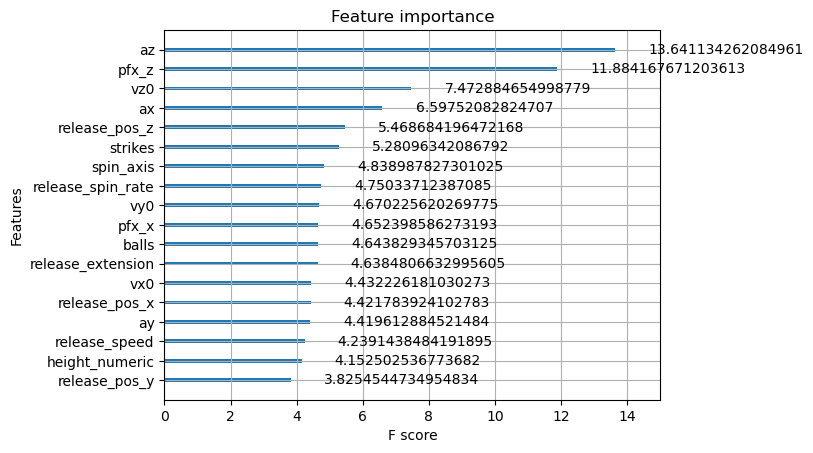

In [22]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [23]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [24]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [25]:
y_pred = final_model.predict(predictions)

In [26]:
testing_identifiers['xgb'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_34380\1805931578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xgb'] = y_pred


In [27]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/gb_2022&3_xgb.csv")

# Offspeed Model 

In [28]:
off = offspeed_data.drop(['description', 'events', 'game_pk', 'game_date', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp',
                      'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'pitch_number',  
                      'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
                      #removed these columns because of collinearity
                      'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov', 'pfx_x', 'Unnamed: 0', 'release_pos_x', 'balls', 
                        'total_movement', 'vmov_diff', 'hmov_diff', 'velo_diff', 'vz0', 'release_speed'
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      ], axis=1).copy()

NameError: name 'offspeed_data' is not defined

In [ ]:
x2 = off.drop(['is_strike'], axis=1).copy()
y2 = off['is_strike'].copy()

In [ ]:

len(x2)

152322

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [ ]:
dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
dtest1 = xgb.DMatrix(x_test1, label=y_test1)

params1 = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1
}

# Initial Model
model2 = xgb.train(params1, dtrain1)

In [ ]:
print(f"Unique labels in y_test1: {np.unique(y_test1)}")
print(f"Unique labels in y_train1: {np.unique(y_train1)}")


Unique labels in y_test1: [0 1]
Unique labels in y_train1: [0 1]


In [ ]:
# Generate predictions
y_pred1 = model2.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9336287543082226
Log Loss: 0.1557187611740709


In [ ]:
#Use an objective function to find the best parameters
def objectives(trial):
    dtrain1 = xgb.DMatrix(x_train1, label=y_train1)
    dtest1 = xgb.DMatrix(x_test1, label=y_test1)
    
    param1 = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model2 = xgb.train(param1, dtrain1)
    y_pred1= model2.predict(dtest1)
    y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]
    accuracy = accuracy_score(y_test1, y_pred_binary1)
    return accuracy

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objectives, n_trials=100)

[I 2023-10-28 15:09:36,123] A new study created in memory with name: no-name-d34c4ef7-2ce4-4779-a65c-e2be8cfab39c
[I 2023-10-28 15:09:36,414] Trial 0 finished with value: 0.9337928770720499 and parameters: {'max_depth': 5, 'eta': 0.24345509256003714, 'subsample': 0.6802305315736025, 'colsample_bytree': 0.9044944080938069}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,685] Trial 1 finished with value: 0.9235844411619891 and parameters: {'max_depth': 6, 'eta': 0.04993409492472433, 'subsample': 0.7491510300973008, 'colsample_bytree': 0.7023858021577918}. Best is trial 0 with value: 0.9337928770720499.
[I 2023-10-28 15:09:36,984] Trial 2 finished with value: 0.9369440341375349 and parameters: {'max_depth': 9, 'eta': 0.17788292482168488, 'subsample': 0.7205857498903679, 'colsample_bytree': 0.706986723560932}. Best is trial 2 with value: 0.9369440341375349.
[I 2023-10-28 15:09:37,230] Trial 3 finished with value: 0.931068439192516 and parameters: {'max_depth': 3, 'e

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.9411784014442803
Best hyperparameters: {'max_depth': 9, 'eta': 0.29086504518827216, 'subsample': 0.609950626814756, 'colsample_bytree': 0.8105463899683927}


In [ ]:
# Ensure trial is the best trial from the study
best_trial1 = study.best_trial

# Set parameters
final_parameters1 = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
}

# Prepare the data
dtrain = xgb.DMatrix(x_train1, label=y_train1)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model1 = xgb.train(final_parameters1, dtrain1)

In [ ]:
# Generate predictions
y_pred1 = final_model1.predict(dtest1)
y_pred_binary1 = [1 if p >= 0.5 else 0 for p in y_pred1]

# Calculate Accuracy
accuracy = accuracy_score(y_test1, y_pred_binary1)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test1, y_pred1)
print(f"Log Loss: {logloss}")

Accuracy: 0.9393730510421795
Log Loss: 0.15511361543363011


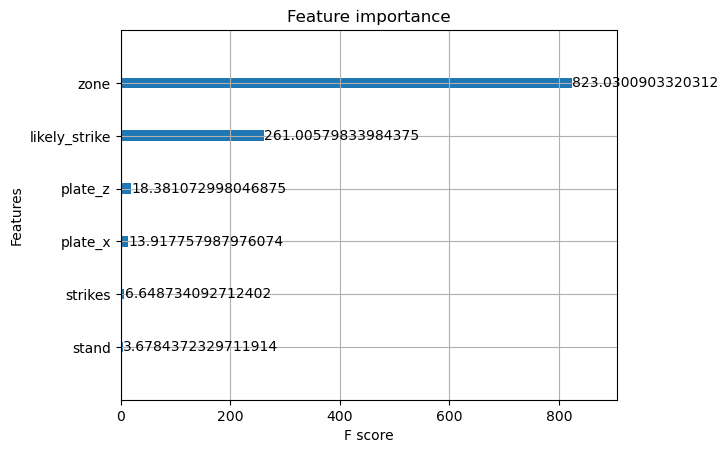

In [ ]:
importance1 = final_model1.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance1)
plt.show()

# Predict 2023 data

In [ ]:
heaters_2023 = df[df['pitch_type_dict'] == 1].copy()
offspeed_2023 = df[df['pitch_type_dict'] == 2].copy()

In [ ]:
# Select only the features you used for training the models
features = ['zone', 'stand', 'strikes', 'plate_x', 'plate_z',  'likely_strike']  # Replace these with your actual features

# Convert DataFrame to DMatrix
dmatrix_heaters_2023 = xgb.DMatrix(heaters_2023[features])
dmatrix_offspeed_2023 = xgb.DMatrix(offspeed_2023[features])

# Make predictions
heaters_2023['prediction'] = final_model.predict(dmatrix_heaters_2023)
offspeed_2023['prediction'] = final_model1.predict(dmatrix_offspeed_2023)

In [ ]:
complete = pd.concat([heaters_2023, offspeed_2023], axis=0)
complete['probability_added'] = 0

In [ ]:
# Correct the conditions and assignment for 'probability_added'
condition1 = (complete['likely_strike'] == 0) & (complete['is_strike'] == 1)
complete.loc[condition1, 'probability_added'] = 1 - complete.loc[condition1, 'prediction']

condition2 = (complete['likely_strike'] == 1) & (complete['is_strike'] == 0)
complete.loc[condition2, 'probability_added'] = -0 + complete.loc[condition2, 'prediction']


In [ ]:
len(condition2)

362561

In [ ]:
players = pd.read_csv('players_query.csv')

In [ ]:
completed = complete.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [ ]:
strike_probs = completed.loc[completed['probability_added'] != 0].copy()

In [ ]:
strike_probs.head()

,half_inning,Unnamed: 1,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,deltaRE,is_strike,pitch_type_dict,likely_strike,prediction,probability_added,Unnamed: 0,mlb_id,mlb_name,team_name
1,716352_1_Bot,8,SI,2023-10-01,93.5,-2.60,5.68,"King, Michael",677951,650633,...,-0.028510,1,1.0,0,0.781290,0.218710,4412,669224,Austin Wells,yankees
11,716352_2_Bot,46,FF,2023-10-01,93.5,-2.82,5.71,"King, Michael",669004,650633,...,-0.038179,1,1.0,0,0.495411,0.504589,4412,669224,Austin Wells,yankees
28,716352_4_Bot,111,FF,2023-10-01,92.9,-2.66,5.89,"King, Michael",669004,650633,...,-0.038179,1,1.0,0,0.782323,0.217677,4412,669224,Austin Wells,yankees
37,716352_4_Bot,87,SI,2023-10-01,92.2,-2.76,5.67,"King, Michael",672580,650633,...,-0.111258,1,1.0,0,0.813712,0.186288,4412,669224,Austin Wells,yankees
39,716352_4_Top,115,SI,2023-10-01,90.1,-1.27,6.14,"Greinke, Zack",643396,425844,...,-0.043952,1,1.0,0,0.584764,0.415236,1898,521692,Salvador Perez,royals


### Catcher Evaluation

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'probability_added': 'sum'}).sort_values(by='probability_added', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       probability_added
mlb_name                                
Jonah Heim                    369.409200
William Contreras             357.175406
Francisco Alvarez             343.816237
Cal Raleigh                   325.117514
Patrick Bailey                322.223661
J.T. Realmuto                 306.765881
Adley Rutschman               304.310884
Keibert Ruiz                  300.757002
Elias Diaz                    291.464170
Will Smith                    289.637044
Shea Langeliers               285.841658
Sean Murphy                   285.280986
Alejandro Kirk                274.881437
Jake Rogers                   270.437452
Connor Wong                   263.304882
Nick Fortes                   261.444752
Austin Hedges                 252.923828
Yasmani Grandal               249.119006
Christian Vazquez             245.539206
Willson Contreras             243.042565
Gabriel Moreno                240.534485
Kyle Higashioka               236.375578
Martin Maldonado

In [ ]:
strike_probs['framing_runs'] = (strike_probs['deltaRE'] * -1) * strike_probs['probability_added'].abs()

## Initial Situational Framing Runs Leaderboard

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = strike_probs.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

# Reset the display options to default
pd.reset_option('display.max_rows')

                       framing_runs
mlb_name                           
Jonah Heim                28.298897
William Contreras         27.314465
Francisco Alvarez         26.280338
Cal Raleigh               24.428360
J.T. Realmuto             23.217440
Will Smith                23.151280
Adley Rutschman           22.850475
Austin Hedges             22.659703
Shea Langeliers           22.651095
Elias Diaz                22.566548
Patrick Bailey            22.507789
Keibert Ruiz              22.178750
Alejandro Kirk            21.671238
Kyle Higashioka           20.388670
Nick Fortes               20.349055
Willson Contreras         20.085103
Sean Murphy               20.071047
Connor Wong               20.061680
Jake Rogers               19.988771
Christian Vazquez         19.943172
Martin Maldonado          19.101232
Yasmani Grandal           18.546439
Gabriel Moreno            18.169561
Yan Gomes                 16.646696
Gary Sanchez              15.508716
Salvador Perez            15

In [ ]:
strike_probs.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)

In [ ]:
strike_probs.to_csv('strike_probs.csv')

### Get out meaningless strikes that have nothing to do with framing

In [ ]:
likely = strike_probs.query('(prediction < .85)')

In [ ]:
# Set the display options to show all rows
pd.set_option('display.max_rows', None)

result = likely.groupby('mlb_name').agg({'framing_runs': 'sum'}).sort_values(by='framing_runs', ascending=False)
print(result)

                       framing_runs
mlb_name                           
Jonah Heim                27.265644
William Contreras         26.675339
Francisco Alvarez         25.509967
Cal Raleigh               23.705518
Will Smith                22.504385
J.T. Realmuto             22.293919
Adley Rutschman           22.158913
Austin Hedges             22.132027
Patrick Bailey            22.033697
Shea Langeliers           21.670207
Elias Diaz                21.585984
Keibert Ruiz              21.388849
Alejandro Kirk            20.937702
Kyle Higashioka           19.911051
Nick Fortes               19.775314
Sean Murphy               19.402830
Willson Contreras         19.372176
Christian Vazquez         19.285147
Connor Wong               19.231894
Jake Rogers               19.224211
Martin Maldonado          18.579309
Yasmani Grandal           17.983997
Gabriel Moreno            17.519849
Yan Gomes                 16.075565
Gary Sanchez              14.937981
Salvador Perez            14

###  I think that this is the best leaderboard. Filters out the gimme pitches